In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [ ]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet

from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

for r in range(5):
    for i in range(len(participants)):

        train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                          raw_user_fold,
                                                                                          participants,
                                                                                          batch_size=batch_size,
                                                                                          transpose_channels=transpose_channels)

        eegnet= EEGNet(
            chunk_size=input_dim[1],
            num_electrodes=input_dim[0],
            num_classes=classes,
            kernel_1= 32,
            kernel_2=32,
            F1=8,
            F2=16,
            dropout=0.5
        ).to(DEVICE)

    #     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)

        criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    #     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))

        saved_dir= f"./EEG/saved_models/Userfold/run{r}"
        classifier= LSTM_EEGNet_Wrapper(DEVICE, eegnet, input_dim).to(DEVICE)

        model = EEGNet_DF_TS_Wrapper(DEVICE, classifier, input_dim[1]).to(DEVICE)
    #     model= EEGNet_Wrapper(DEVICE, df)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)


        train_func= eeg_DF_train
        model.training_procedure(iteration=n_epochs,
                                        train_dataloader=train_dataloader,
                                         val_dataloader=val_dataloader,
                                         print_cycle=2,
                                         path=f"./dictionary/intermdiate_dicts",
                                         loss_func=criterion,
                                         optimiser=optimizer, #scheduler=scheduler,
                                         train_func=train_func
                                        )
        if model.epoch == n_epochs+1:
            EPOCH= n_epochs
        else:
            EPOCH= model.epoch

        torch.save(model.state_dict(), 
               os.path.join(
                   saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-DF_TS-e{EPOCH}.pt"
               )
        )

        pickle.dump( model.return_DF_weights(), 
                    open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-DF_TS-w-e{EPOCH}.pkl", "wb") 
                   )    

    # OR
    #     model.load_state_dict(
    #     torch.load(
    #         open(
    #             os.path.join(
    #                 saved_dir, f"Userfold-{participants[i]}-EEGNet-DF_Multivariate-e{n_epochs}.pt"
    #             ), "rb"
    #         )
    #               )
    #     )


        prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)

        ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])

        c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
        print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
        b_acc_list.append(b_acc)
        c0_acc_list.append(c0_acc)
        c1_acc_list.append(c1_acc)
        participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 100.74706986371208


Iterations:   0%|                                   | 1/300 [00:02<14:52,  2.98s/it]

Epoch:  0
t_loss:  100.74706986371208 , v_loss:  0.6926881670951843
t_acc:  0.47650171179582945 , v_acc:  0.6894409937888198
t_recall:  0.4825345520923402 , v_recall:  0.5
t_prec:  0.4851783766155614 , v_prec:  0.3447204968944099
t_f:  0.4602815106580167 , v_f:  0.4080882352941176
////////


Iterations:   1%|▏                                  | 2/300 [00:03<08:55,  1.80s/it]

Epoch  1 , loss 100.156509698606
Epoch  2 , loss 99.58204067454619


Iterations:   1%|▎                                  | 3/300 [00:05<08:24,  1.70s/it]

Epoch:  2
t_loss:  99.58204067454619 , v_loss:  0.6825090050697327
t_acc:  0.6392779333955805 , v_acc:  0.6894409937888198
t_recall:  0.5046506361427925 , v_recall:  0.5
t_prec:  0.5075556893437688 , v_prec:  0.3447204968944099
t_f:  0.4895854021693943 , v_f:  0.4080882352941176
////////


Iterations:   1%|▍                                  | 4/300 [00:06<06:55,  1.40s/it]

Epoch  3 , loss 99.00896169625076
Epoch  4 , loss 98.46616707596124


Iterations:   2%|▌                                  | 5/300 [00:08<07:08,  1.45s/it]

Epoch:  4
t_loss:  98.46616707596124 , v_loss:  0.6667518417040507
t_acc:  0.680672268907563 , v_acc:  0.6894409937888198
t_recall:  0.4955874885055105 , v_recall:  0.5
t_prec:  0.46640917766044887 , v_prec:  0.3447204968944099
t_f:  0.4247803145044775 , v_f:  0.4080882352941176
////////


Iterations:   2%|▋                                  | 6/300 [00:09<06:19,  1.29s/it]

Epoch  5 , loss 97.91344421985103
Epoch  6 , loss 97.38161034677543


Iterations:   2%|▊                                  | 7/300 [00:10<06:43,  1.38s/it]

Epoch:  6
t_loss:  97.38161034677543 , v_loss:  0.665886123975118
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5012777754903172 , v_recall:  0.5
t_prec:  0.562363238512035 , v_prec:  0.3447204968944099
t_f:  0.4158754021869472 , v_f:  0.4080882352941176
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:01,  1.24s/it]

Epoch  7 , loss 96.84495559393191
Epoch  8 , loss 96.31579260732613


Iterations:   3%|█                                  | 9/300 [00:13<06:29,  1.34s/it]

Epoch:  8
t_loss:  96.31579260732613 , v_loss:  0.6917716364065806
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:14<05:54,  1.22s/it]

Epoch  9 , loss 95.7948241888308
Epoch  10 , loss 95.27321325563916


Iterations:   4%|█▏                                | 11/300 [00:15<06:23,  1.33s/it]

Epoch:  10
t_loss:  95.27321325563916 , v_loss:  0.7248631765445074
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8480224229212083 , v_prec:  0.3447204968944099
t_f:  0.4124337652798909 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:16<05:49,  1.21s/it]

Epoch  11 , loss 94.75082307703354
Epoch  12 , loss 94.2327210669424


Iterations:   4%|█▍                                | 13/300 [00:18<06:19,  1.32s/it]

Epoch:  12
t_loss:  94.2327210669424 , v_loss:  0.7287000964085261
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.49955257270693515 , v_recall:  0.5
t_prec:  0.3477109934599813 , v_prec:  0.3447204968944099
t_f:  0.41002570694087404 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:19<05:49,  1.22s/it]

Epoch  13 , loss 93.7136614930396
Epoch  14 , loss 93.20377634085861


Iterations:   5%|█▋                                | 15/300 [00:20<06:16,  1.32s/it]

Epoch:  14
t_loss:  93.20377634085861 , v_loss:  0.7317892710367838
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:21<05:43,  1.21s/it]

Epoch  15 , loss 92.69078318277995
Epoch  16 , loss 92.17484014174518


Iterations:   6%|█▉                                | 17/300 [00:23<06:11,  1.31s/it]

Epoch:  16
t_loss:  92.17484014174518 , v_loss:  0.7187987913688024
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:24<05:42,  1.21s/it]

Epoch  17 , loss 91.66652440089806
Epoch  18 , loss 91.16371663411458


Iterations:   6%|██▏                               | 19/300 [00:25<06:09,  1.32s/it]

Epoch:  18
t_loss:  91.16371663411458 , v_loss:  0.7154816935459772
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:26<05:38,  1.21s/it]

Epoch  19 , loss 90.66593140246822
Epoch  20 , loss 90.17280174704159


Iterations:   7%|██▍                               | 21/300 [00:28<06:05,  1.31s/it]

Epoch:  20
t_loss:  90.17280174704159 , v_loss:  0.7167224735021591
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:29<05:35,  1.21s/it]

Epoch  21 , loss 89.67304289574717
Epoch  22 , loss 89.16804863424862


Iterations:   8%|██▌                               | 23/300 [00:30<06:02,  1.31s/it]

Epoch:  22
t_loss:  89.16804863424862 , v_loss:  0.7172163973251978
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:31<05:32,  1.21s/it]

Epoch  23 , loss 88.67572380514706
Epoch  24 , loss 88.188081778732


Iterations:   8%|██▊                               | 25/300 [00:33<06:00,  1.31s/it]

Epoch:  24
t_loss:  88.188081778732 , v_loss:  0.7092886467774709
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:34<05:29,  1.20s/it]

Epoch  25 , loss 87.69811577890434
Epoch  26 , loss 87.20981687657974


Iterations:   9%|███                               | 27/300 [00:35<05:56,  1.31s/it]

Epoch:  26
t_loss:  87.20981687657974 , v_loss:  0.6990104566017786
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:36<05:29,  1.21s/it]

Epoch  27 , loss 86.72474954642502
Epoch  28 , loss 86.23025662291283


Iterations:  10%|███▎                              | 29/300 [00:38<05:55,  1.31s/it]

Epoch:  28
t_loss:  86.23025662291283 , v_loss:  0.6928584476312002
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:39<05:32,  1.23s/it]

Epoch  29 , loss 85.74326892927581
Epoch  30 , loss 85.25523944929535


Iterations:  10%|███▌                              | 31/300 [00:40<05:57,  1.33s/it]

Epoch:  30
t_loss:  85.25523944929535 , v_loss:  0.692530612150828
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5005750675944607 , v_recall:  0.5
t_prec:  0.5979277033343721 , v_prec:  0.3447204968944099
t_f:  0.4122130008035903 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:41<05:35,  1.25s/it]

Epoch  31 , loss 84.78121499454274
Epoch  32 , loss 84.29763075884651


Iterations:  11%|███▋                              | 33/300 [00:43<06:00,  1.35s/it]

Epoch:  32
t_loss:  84.29763075884651 , v_loss:  0.7031393150488535
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:44<05:29,  1.24s/it]

Epoch  33 , loss 83.81823012408088
Epoch  34 , loss 83.34596611471737


Iterations:  12%|███▉                              | 35/300 [00:46<05:52,  1.33s/it]

Epoch:  34
t_loss:  83.34596611471737 , v_loss:  0.689241866270701
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:47<05:23,  1.22s/it]

Epoch  35 , loss 82.87382971071729
Epoch  36 , loss 82.39442413928462


Iterations:  12%|████▏                             | 37/300 [00:48<05:47,  1.32s/it]

Epoch:  36
t_loss:  82.39442413928462 , v_loss:  0.6859263330698013
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:49<05:19,  1.22s/it]

Epoch  37 , loss 81.93083041321998
Epoch  38 , loss 81.45587816425399


Iterations:  13%|████▍                             | 39/300 [00:51<05:43,  1.32s/it]

Epoch:  38
t_loss:  81.45587816425399 , v_loss:  0.6732714076836904
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:52<05:12,  1.20s/it]

Epoch  39 , loss 80.98418261958103
Epoch  40 , loss 80.51633573045918


Iterations:  14%|████▋                             | 41/300 [00:53<05:39,  1.31s/it]

Epoch:  40
t_loss:  80.51633573045918 , v_loss:  0.6717269867658615
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:54<05:10,  1.20s/it]

Epoch  41 , loss 80.0484167360792
Epoch  42 , loss 79.58761207730163


Iterations:  14%|████▊                             | 43/300 [00:56<05:36,  1.31s/it]

Epoch:  42
t_loss:  79.58761207730163 , v_loss:  0.66700712343057
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5007987812409931 , v_recall:  0.5
t_prec:  0.6813084112149532 , v_prec:  0.3447204968944099
t_f:  0.41232340081380947 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:57<05:08,  1.20s/it]

Epoch  43 , loss 79.11770031498928
Epoch  44 , loss 78.65579388188381


Iterations:  15%|█████                             | 45/300 [00:58<05:32,  1.30s/it]

Epoch:  44
t_loss:  78.65579388188381 , v_loss:  0.660513718922933
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:59<05:03,  1.20s/it]

Epoch  45 , loss 78.20084440941905
Epoch  46 , loss 77.73310567818436


Iterations:  16%|█████▎                            | 47/300 [01:01<05:30,  1.31s/it]

Epoch:  46
t_loss:  77.73310567818436 , v_loss:  0.6528910001118978
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5007987812409931 , v_recall:  0.5
t_prec:  0.6813084112149532 , v_prec:  0.3447204968944099
t_f:  0.41232340081380947 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [01:02<05:03,  1.20s/it]

Epoch  47 , loss 77.2758898267559
Epoch  48 , loss 76.8213264614928


Iterations:  16%|█████▌                            | 49/300 [01:03<05:31,  1.32s/it]

Epoch:  48
t_loss:  76.8213264614928 , v_loss:  0.6405631651480993
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5005750675944607 , v_recall:  0.5
t_prec:  0.5979277033343721 , v_prec:  0.3447204968944099
t_f:  0.4122130008035903 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [01:04<05:01,  1.21s/it]

Epoch  49 , loss 76.36385240741805
Epoch  50 , loss 75.90610474231197


Iterations:  17%|█████▊                            | 51/300 [01:06<05:26,  1.31s/it]

Epoch:  50
t_loss:  75.90610474231197 , v_loss:  0.632579987247785
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5015975624819863 , v_recall:  0.5
t_prec:  0.6814780168381664 , v_prec:  0.3447204968944099
t_f:  0.4143921262806895 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [01:07<05:01,  1.22s/it]

Epoch  51 , loss 75.4535218781116
Epoch  52 , loss 74.99190356684666


Iterations:  18%|██████                            | 53/300 [01:08<05:23,  1.31s/it]

Epoch:  52
t_loss:  74.99190356684666 , v_loss:  0.6293355276187261
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5006388877451586 , v_recall:  0.5
t_prec:  0.5622270742358079 , v_prec:  0.3447204968944099
t_f:  0.41308060533064894 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [01:09<04:56,  1.21s/it]

Epoch  53 , loss 74.5403382544424
Epoch  54 , loss 74.08314259847005


Iterations:  18%|██████▏                           | 55/300 [01:11<05:21,  1.31s/it]

Epoch:  54
t_loss:  74.08314259847005 , v_loss:  0.6234947890043259
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.502172630076447 , v_recall:  0.5
t_prec:  0.6482672494536372 , v_prec:  0.3447204968944099
t_f:  0.4163339999076822 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▎                           | 56/300 [01:12<04:53,  1.20s/it]

Epoch  55 , loss 73.62672184962852
Epoch  56 , loss 73.16658483767041


Iterations:  19%|██████▍                           | 57/300 [01:13<05:18,  1.31s/it]

Epoch:  56
t_loss:  73.16658483767041 , v_loss:  0.6218763341506323
t_acc:  0.6977902272019919 , v_acc:  0.6894409937888198
t_recall:  0.5044413334980306 , v_recall:  0.5
t_prec:  0.7333653846153847 , v_prec:  0.3447204968944099
t_f:  0.4207623904932804 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▌                           | 58/300 [01:14<04:51,  1.20s/it]

Epoch  57 , loss 72.71130266376571
Epoch  58 , loss 72.26902860753677


Iterations:  20%|██████▋                           | 59/300 [01:16<05:15,  1.31s/it]

Epoch:  58
t_loss:  72.26902860753677 , v_loss:  0.6034741302331289
t_acc:  0.699035169623405 , v_acc:  0.6956521739130435
t_recall:  0.5079239922592333 , v_recall:  0.51
t_prec:  0.7013496547394853 , v_prec:  0.846875
t_f:  0.4297152863243275 , v_f:  0.42920193907821425
////////


Iterations:  20%|██████▊                           | 60/300 [01:17<04:49,  1.20s/it]

Epoch  59 , loss 71.81808890548407
Epoch  60 , loss 71.36541628370098


Iterations:  20%|██████▉                           | 61/300 [01:18<05:13,  1.31s/it]

Epoch:  60
t_loss:  71.36541628370098 , v_loss:  0.6105251908302307
t_acc:  0.6953003423591659 , v_acc:  0.6956521739130435
t_recall:  0.50178902293408 , v_recall:  0.51
t_prec:  0.5815196998123827 , v_prec:  0.846875
t_f:  0.4169517934208704 , v_f:  0.42920193907821425
////////


Iterations:  21%|███████                           | 62/300 [01:19<04:46,  1.20s/it]

Epoch  61 , loss 70.91644481584137
Epoch  62 , loss 70.47119768928079


Iterations:  21%|███████▏                          | 63/300 [01:21<05:10,  1.31s/it]

Epoch:  62
t_loss:  70.47119768928079 , v_loss:  0.6001874804496765
t_acc:  0.6987239340180517 , v_acc:  0.6956521739130435
t_recall:  0.5068376772210099 , v_recall:  0.51
t_prec:  0.7128999173812711 , v_prec:  0.846875
t_f:  0.42679985256173975 , v_f:  0.42920193907821425
////////


Iterations:  21%|███████▎                          | 64/300 [01:22<04:44,  1.20s/it]

Epoch  63 , loss 70.02020891974954
Epoch  64 , loss 69.56697935216567


Iterations:  22%|███████▎                          | 65/300 [01:23<05:06,  1.31s/it]

Epoch:  64
t_loss:  69.56697935216567 , v_loss:  0.599919781088829
t_acc:  0.6974789915966386 , v_acc:  0.6956521739130435
t_recall:  0.5062303564321105 , v_recall:  0.51
t_prec:  0.6527080062794348 , v_prec:  0.846875
t_f:  0.42723071167093385 , v_f:  0.42920193907821425
////////


Iterations:  22%|███████▍                          | 66/300 [01:24<04:44,  1.22s/it]

Epoch  65 , loss 69.12465637805415
Epoch  66 , loss 68.69227959127987


Iterations:  22%|███████▌                          | 67/300 [01:26<05:08,  1.32s/it]

Epoch:  66
t_loss:  68.69227959127987 , v_loss:  0.5974845041831335
t_acc:  0.6968565203859322 , v_acc:  0.6956521739130435
t_recall:  0.5040577263556635 , v_recall:  0.51
t_prec:  0.6542253521126761 , v_prec:  0.846875
t_f:  0.421357252213273 , v_f:  0.42920193907821425
////////


Iterations:  23%|███████▋                          | 68/300 [01:27<04:42,  1.22s/it]

Epoch  67 , loss 68.24554652793735
Epoch  68 , loss 67.81274010153378


Iterations:  23%|███████▊                          | 69/300 [01:28<05:05,  1.32s/it]

Epoch:  68
t_loss:  67.81274010153378 , v_loss:  0.5903578946987788
t_acc:  0.6999688764394647 , v_acc:  0.6956521739130435
t_recall:  0.5103203359822127 , v_recall:  0.51
t_prec:  0.6972379603399433 , v_prec:  0.846875
t_f:  0.43559348718823393 , v_f:  0.42920193907821425
////////


Iterations:  23%|███████▉                          | 70/300 [01:29<04:39,  1.22s/it]

Epoch  69 , loss 67.37704378015854
Epoch  70 , loss 66.9474391563266


Iterations:  24%|████████                          | 71/300 [01:31<05:04,  1.33s/it]

Epoch:  70
t_loss:  66.9474391563266 , v_loss:  0.5872106850147247
t_acc:  0.6962340491752257 , v_acc:  0.6956521739130435
t_recall:  0.5044729004542897 , v_recall:  0.51
t_prec:  0.6179913591272236 , v_prec:  0.846875
t_f:  0.42394053443180435 , v_f:  0.42920193907821425
////////


Iterations:  24%|████████▏                         | 72/300 [01:32<04:39,  1.23s/it]

Epoch  71 , loss 66.51505803126915
Epoch  72 , loss 66.07890813490924


Iterations:  24%|████████▎                         | 73/300 [01:33<05:02,  1.33s/it]

Epoch:  72
t_loss:  66.07890813490924 , v_loss:  0.5804947366317114
t_acc:  0.6993464052287581 , v_acc:  0.6956521739130435
t_recall:  0.5090103072974568 , v_recall:  0.51
t_prec:  0.6934827884313108 , v_prec:  0.846875
t_f:  0.4326019714231394 , v_f:  0.42920193907821425
////////


Iterations:  25%|████████▍                         | 74/300 [01:34<04:36,  1.22s/it]

Epoch  73 , loss 65.64823704139859
Epoch  74 , loss 65.22298147164139


Iterations:  25%|████████▌                         | 75/300 [01:36<04:57,  1.32s/it]

Epoch:  74
t_loss:  65.22298147164139 , v_loss:  0.583833321928978
t_acc:  0.6965452847805789 , v_acc:  0.6956521739130435
t_recall:  0.5058467492897435 , v_recall:  0.51
t_prec:  0.6217838765008576 , v_prec:  0.846875
t_f:  0.42777645347164567 , v_f:  0.42920193907821425
////////


Iterations:  25%|████████▌                         | 76/300 [01:37<04:32,  1.22s/it]

Epoch  75 , loss 64.79955650778378
Epoch  76 , loss 64.37268754547718


Iterations:  26%|████████▋                         | 77/300 [01:38<04:50,  1.30s/it]

Epoch:  76
t_loss:  64.37268754547718 , v_loss:  0.5741724173227946
t_acc:  0.7002801120448179 , v_acc:  0.7018633540372671
t_recall:  0.5099689820342844 , v_recall:  0.52
t_prec:  0.7209048883842583 , v_prec:  0.8490566037735849
t_f:  0.4339080086494944 , v_f:  0.44957264957264953
////////


Iterations:  26%|████████▊                         | 78/300 [01:39<04:27,  1.21s/it]

Epoch  77 , loss 63.943773980234184
Epoch  78 , loss 63.51799542296167


Iterations:  26%|████████▉                         | 79/300 [01:41<04:47,  1.30s/it]

Epoch:  78
t_loss:  63.51799542296167 , v_loss:  0.577066645026207
t_acc:  0.6993464052287581 , v_acc:  0.6956521739130435
t_recall:  0.5081477059057657 , v_recall:  0.51
t_prec:  0.7149296420554657 , v_prec:  0.846875
t_f:  0.42984278305442924 , v_f:  0.42920193907821425
////////


Iterations:  27%|█████████                         | 80/300 [01:42<04:24,  1.20s/it]

Epoch  79 , loss 63.09627009373085
Epoch  80 , loss 62.67551287482767


Iterations:  27%|█████████▏                        | 81/300 [01:44<04:46,  1.31s/it]

Epoch:  80
t_loss:  62.67551287482767 , v_loss:  0.5712769577900568
t_acc:  0.6981014628073452 , v_acc:  0.7080745341614907
t_recall:  0.5075403851168664 , v_recall:  0.53
t_prec:  0.6619184218799119 , v_prec:  0.8512658227848101
t_f:  0.43025249718472586 , v_f:  0.4692431787893666
////////


Iterations:  27%|█████████▎                        | 82/300 [01:45<04:23,  1.21s/it]

Epoch  81 , loss 62.25834334130381
Epoch  82 , loss 61.841573378619024


Iterations:  28%|█████████▍                        | 83/300 [01:46<04:43,  1.31s/it]

Epoch:  82
t_loss:  61.841573378619024 , v_loss:  0.5717245588699976
t_acc:  0.6984126984126984 , v_acc:  0.7204968944099379
t_recall:  0.5097768353440112 , v_recall:  0.55
t_prec:  0.649905303030303 , v_prec:  0.8557692307692308
t_f:  0.43672055765695494 , v_f:  0.5066394279877425
////////


Iterations:  28%|█████████▌                        | 84/300 [01:47<04:20,  1.21s/it]

Epoch  83 , loss 61.42098535275927
Epoch  84 , loss 61.00813645007563


Iterations:  28%|█████████▋                        | 85/300 [01:49<04:42,  1.31s/it]

Epoch:  84
t_loss:  61.00813645007563 , v_loss:  0.5700109402338663
t_acc:  0.7009025832555245 , v_acc:  0.7142857142857143
t_recall:  0.5127166797051921 , v_recall:  0.54
t_prec:  0.6949810606060607 , v_prec:  0.8535031847133758
t_f:  0.44137095552975625 , v_f:  0.488253178551686
////////


Iterations:  29%|█████████▋                        | 86/300 [01:50<04:19,  1.21s/it]

Epoch  85 , loss 60.58815668143478
Epoch  86 , loss 60.16935131596584


Iterations:  29%|█████████▊                        | 87/300 [01:51<04:40,  1.31s/it]

Epoch:  86
t_loss:  60.16935131596584 , v_loss:  0.5663772920767466
t_acc:  0.6993464052287581 , v_acc:  0.7267080745341615
t_recall:  0.5101604424863782 , v_recall:  0.5654954954954955
t_prec:  0.6749842420422314 , v_prec:  0.7969771241830066
t_f:  0.43622814487160116 , v_f:  0.5373563218390804
////////


Iterations:  29%|█████████▉                        | 88/300 [01:52<04:17,  1.22s/it]

Epoch  87 , loss 59.766415689505784
Epoch  88 , loss 59.36088771446079


Iterations:  30%|██████████                        | 89/300 [01:54<04:39,  1.33s/it]

Epoch:  88
t_loss:  59.36088771446079 , v_loss:  0.5672604391972224
t_acc:  0.7015250544662309 , v_acc:  0.7267080745341615
t_recall:  0.5125890394037963 , v_recall:  0.56
t_prec:  0.7222989675730697 , v_prec:  0.8580645161290323
t_f:  0.43986669218951696 , v_f:  0.5244360902255639
////////


Iterations:  30%|██████████▏                       | 90/300 [01:55<04:16,  1.22s/it]

Epoch  89 , loss 58.95107583438649
Epoch  90 , loss 58.55139279833027


Iterations:  30%|██████████▎                       | 91/300 [01:56<04:38,  1.33s/it]

Epoch:  90
t_loss:  58.55139279833027 , v_loss:  0.5694600641727448
t_acc:  0.702769996887644 , v_acc:  0.7267080745341615
t_recall:  0.5146340291788474 , v_recall:  0.56
t_prec:  0.7346673024723058 , v_prec:  0.8580645161290323
t_f:  0.443977127863434 , v_f:  0.5244360902255639
////////


Iterations:  31%|██████████▍                       | 92/300 [01:57<04:16,  1.23s/it]

Epoch  91 , loss 58.147632449280984
Epoch  92 , loss 57.7376989476821


Iterations:  31%|██████████▌                       | 93/300 [01:59<04:37,  1.34s/it]

Epoch:  92
t_loss:  57.7376989476821 , v_loss:  0.5543310542901357
t_acc:  0.6977902272019919 , v_acc:  0.7391304347826086
t_recall:  0.5090418742537159 , v_recall:  0.5854954954954955
t_prec:  0.6386363636363637 , v_prec:  0.8142384105960265
t_f:  0.43555795818875465 , v_f:  0.5698473282442748
////////


Iterations:  31%|██████████▋                       | 94/300 [02:00<04:15,  1.24s/it]

Epoch  93 , loss 57.34045268040077
Epoch  94 , loss 56.93613815307617


Iterations:  32%|██████████▊                       | 95/300 [02:01<04:36,  1.35s/it]

Epoch:  94
t_loss:  56.93613815307617 , v_loss:  0.564521407087644
t_acc:  0.7058823529411765 , v_acc:  0.7267080745341615
t_recall:  0.5208966388053966 , v_recall:  0.56
t_prec:  0.73756189148706 , v_prec:  0.8580645161290323
t_f:  0.45752464716952174 , v_f:  0.5244360902255639
////////


Iterations:  32%|██████████▉                       | 96/300 [02:02<04:13,  1.24s/it]

Epoch  95 , loss 56.533621993719365
Epoch  96 , loss 56.13545212091184


Iterations:  32%|██████████▉                       | 97/300 [02:04<04:30,  1.33s/it]

Epoch:  96
t_loss:  56.13545212091184 , v_loss:  0.5651952673991522
t_acc:  0.7009025832555245 , v_acc:  0.7391304347826086
t_recall:  0.5147294162858045 , v_recall:  0.58
t_prec:  0.6730167771890416 , v_prec:  0.8627450980392157
t_f:  0.44748105582409825 , v_f:  0.5583855799373041
////////


Iterations:  33%|███████████                       | 98/300 [02:05<04:08,  1.23s/it]

Epoch  97 , loss 55.732442519244024
Epoch  98 , loss 55.333768657609525


Iterations:  33%|███████████▏                      | 99/300 [02:07<04:27,  1.33s/it]

Epoch:  98
t_loss:  55.333768657609525 , v_loss:  0.557207465171814
t_acc:  0.7033924680983504 , v_acc:  0.7453416149068323
t_recall:  0.5159440578636033 , v_recall:  0.59
t_prec:  0.7342105616859989 , v_prec:  0.8651315789473684
t_f:  0.44689754833115813 , v_f:  0.5745956048205194
////////


Iterations:  33%|███████████                      | 100/300 [02:08<04:05,  1.23s/it]

Epoch  99 , loss 54.93767435410444
Epoch  100 , loss 54.5337178847369


Iterations:  34%|███████████                      | 101/300 [02:09<04:24,  1.33s/it]

Epoch:  100
t_loss:  54.5337178847369 , v_loss:  0.5645722647507986
t_acc:  0.7037037037037037 , v_acc:  0.7391304347826086
t_recall:  0.5158802377129054 , v_recall:  0.58
t_prec:  0.7489421670156917 , v_prec:  0.8627450980392157
t_f:  0.44616367378806154 , v_f:  0.5583855799373041
////////


Iterations:  34%|███████████▏                     | 102/300 [02:10<04:05,  1.24s/it]

Epoch  101 , loss 54.141338273590684
Epoch  102 , loss 53.75753170836206


Iterations:  34%|███████████▎                     | 103/300 [02:12<04:22,  1.33s/it]

Epoch:  102
t_loss:  53.75753170836206 , v_loss:  0.5537281731764475
t_acc:  0.7012138188608776 , v_acc:  0.7453416149068323
t_recall:  0.5143780623378762 , v_recall:  0.59
t_prec:  0.6842355175688508 , v_prec:  0.8651315789473684
t_f:  0.44589595674780763 , v_f:  0.5745956048205194
////////


Iterations:  35%|███████████▍                     | 104/300 [02:13<04:01,  1.23s/it]

Epoch  103 , loss 53.368117313759
Epoch  104 , loss 52.98429504095339


Iterations:  35%|███████████▌                     | 105/300 [02:14<04:21,  1.34s/it]

Epoch:  104
t_loss:  52.98429504095339 , v_loss:  0.558363676071167
t_acc:  0.7015250544662309 , v_acc:  0.7329192546583851
t_recall:  0.5163269787677908 , v_recall:  0.5700000000000001
t_prec:  0.6744111035089434 , v_prec:  0.8603896103896104
t_f:  0.4511917333589338 , v_f:  0.5416749420721615
////////


Iterations:  35%|███████████▋                     | 106/300 [02:15<03:57,  1.23s/it]

Epoch  105 , loss 52.595499225691256
Epoch  106 , loss 52.22354941274605


Iterations:  36%|███████████▊                     | 107/300 [02:17<04:16,  1.33s/it]

Epoch:  106
t_loss:  52.22354941274605 , v_loss:  0.552761639157931
t_acc:  0.7021475256769374 , v_acc:  0.7391304347826086
t_recall:  0.5133240004940914 , v_recall:  0.58
t_prec:  0.7352770103242694 , v_prec:  0.8627450980392157
t_f:  0.44103485341539905 , v_f:  0.5583855799373041
////////


Iterations:  36%|███████████▉                     | 108/300 [02:18<03:53,  1.22s/it]

Epoch  107 , loss 51.837222080604704
Epoch  108 , loss 51.45595924527037


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:12,  1.32s/it]

Epoch:  108
t_loss:  51.45595924527037 , v_loss:  0.5532929052909216
t_acc:  0.7009025832555245 , v_acc:  0.7391304347826086
t_recall:  0.511854078313501 , v_recall:  0.58
t_prec:  0.7093209248218699 , v_prec:  0.8627450980392157
t_f:  0.43869853096363487 , v_f:  0.5583855799373041
////////


Iterations:  37%|████████████                     | 110/300 [02:20<03:54,  1.23s/it]

Epoch  109 , loss 51.069663777070886
Epoch  110 , loss 50.691969404033586


Iterations:  37%|████████████▏                    | 111/300 [02:22<04:12,  1.33s/it]

Epoch:  110
t_loss:  50.691969404033586 , v_loss:  0.5591729333003362
t_acc:  0.7043261749144102 , v_acc:  0.7453416149068323
t_recall:  0.518627935383813 , v_recall:  0.59
t_prec:  0.7225121591343789 , v_prec:  0.8651315789473684
t_f:  0.45337963195106057 , v_f:  0.5745956048205194
////////


Iterations:  37%|████████████▎                    | 112/300 [02:23<03:51,  1.23s/it]

Epoch  111 , loss 50.30790889964384
Epoch  112 , loss 49.929025687423405


Iterations:  38%|████████████▍                    | 113/300 [02:25<04:12,  1.35s/it]

Epoch:  112
t_loss:  49.929025687423405 , v_loss:  0.5611023902893066
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5141866018857825 , v_recall:  0.5700000000000001
t_prec:  0.7175189393939394 , v_prec:  0.8603896103896104
t_f:  0.44369615446615673 , v_f:  0.5416749420721615
////////


Iterations:  38%|████████████▌                    | 114/300 [02:26<03:51,  1.24s/it]

Epoch  113 , loss 49.554734547932945
Epoch  114 , loss 49.17643221686868


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:09,  1.35s/it]

Epoch:  114
t_loss:  49.17643221686868 , v_loss:  0.5582941919565201
t_acc:  0.7021475256769374 , v_acc:  0.7453416149068323
t_recall:  0.5159118046691646 , v_recall:  0.59
t_prec:  0.6933410046027617 , v_prec:  0.8651315789473684
t_f:  0.44892211657109676 , v_f:  0.5745956048205194
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:46,  1.23s/it]

Epoch  115 , loss 48.79790354709999
Epoch  116 , loss 48.42120361328125


Iterations:  39%|████████████▊                    | 117/300 [02:30<04:05,  1.34s/it]

Epoch:  116
t_loss:  48.42120361328125 , v_loss:  0.5503190408150355
t_acc:  0.704014939309057 , v_acc:  0.7515527950310559
t_recall:  0.5175416203455895 , v_recall:  0.6
t_prec:  0.7289407690470504 , v_prec:  0.8675496688741722
t_f:  0.45066012014932816 , v_f:  0.5903307888040712
////////


Iterations:  39%|████████████▉                    | 118/300 [02:31<03:42,  1.22s/it]

Epoch  117 , loss 48.04815239999809
Epoch  118 , loss 47.675433140175016


Iterations:  40%|█████████████                    | 119/300 [02:32<03:59,  1.32s/it]

Epoch:  118
t_loss:  47.675433140175016 , v_loss:  0.5500828872124354
t_acc:  0.7024587612822907 , v_acc:  0.7515527950310559
t_recall:  0.5167105859101577 , v_recall:  0.6
t_prec:  0.6930780209324453 , v_prec:  0.8675496688741722
t_f:  0.450783372169368 , v_f:  0.5903307888040712
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:38,  1.21s/it]

Epoch  119 , loss 47.307435877182904
Epoch  120 , loss 46.94965010998296


Iterations:  40%|█████████████▎                   | 121/300 [02:35<03:58,  1.33s/it]

Epoch:  120
t_loss:  46.94965010998296 , v_loss:  0.5515678326288859
t_acc:  0.6981014628073452 , v_acc:  0.7515527950310559
t_recall:  0.5095531216974788 , v_recall:  0.6
t_prec:  0.6433361705632816 , v_prec:  0.8675496688741722
t_f:  0.4365856251156979 , v_f:  0.5903307888040712
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:36<03:37,  1.22s/it]

Epoch  121 , loss 46.5865732828776
Epoch  122 , loss 46.222901886584715


Iterations:  41%|█████████████▌                   | 123/300 [02:37<03:53,  1.32s/it]

Epoch:  122
t_loss:  46.222901886584715 , v_loss:  0.5515777717034022
t_acc:  0.7049486461251168 , v_acc:  0.7453416149068323
t_recall:  0.52080056546026 , v_recall:  0.59
t_prec:  0.7125993640699523 , v_prec:  0.8651315789473684
t_f:  0.45874103506365194 , v_f:  0.5745956048205194
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:33,  1.21s/it]

Epoch  123 , loss 45.871715770048255
Epoch  124 , loss 45.522042966356466


Iterations:  42%|█████████████▊                   | 125/300 [02:40<03:49,  1.31s/it]

Epoch:  124
t_loss:  45.522042966356466 , v_loss:  0.5516170710325241
t_acc:  0.7009025832555245 , v_acc:  0.7515527950310559
t_recall:  0.5127166797051921 , v_recall:  0.6
t_prec:  0.6949810606060607 , v_prec:  0.8675496688741722
t_f:  0.44137095552975625 , v_f:  0.5903307888040712
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:41<03:29,  1.21s/it]

Epoch  125 , loss 45.16481040505802
Epoch  126 , loss 44.80649506812002


Iterations:  42%|█████████████▉                   | 127/300 [02:42<03:47,  1.31s/it]

Epoch:  126
t_loss:  44.80649506812002 , v_loss:  0.5480063905318578
t_acc:  0.6999688764394647 , v_acc:  0.7453416149068323
t_recall:  0.5123330725628251 , v_recall:  0.59
t_prec:  0.6704584255453683 , v_prec:  0.8651315789473684
t_f:  0.4418360741764856 , v_f:  0.5745956048205194
////////


Iterations:  43%|██████████████                   | 128/300 [02:43<03:28,  1.21s/it]

Epoch  127 , loss 44.45478282255285
Epoch  128 , loss 44.1049046235926


Iterations:  43%|██████████████▏                  | 129/300 [02:45<03:45,  1.32s/it]

Epoch:  128
t_loss:  44.1049046235926 , v_loss:  0.5477402160565058
t_acc:  0.7052598817304699 , v_acc:  0.7515527950310559
t_recall:  0.519874143917871 , v_recall:  0.6
t_prec:  0.7334485130531044 , v_prec:  0.8675496688741722
t_f:  0.4555302391939865 , v_f:  0.5903307888040712
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:46<03:25,  1.21s/it]

Epoch  129 , loss 43.753120048373354
Epoch  130 , loss 43.40836214551739


Iterations:  44%|██████████████▍                  | 131/300 [02:47<03:43,  1.32s/it]

Epoch:  130
t_loss:  43.40836214551739 , v_loss:  0.5381706655025482
t_acc:  0.7015250544662309 , v_acc:  0.7515527950310559
t_recall:  0.5137391745927177 , v_recall:  0.6054954954954955
t_prec:  0.7018218841144608 , v_prec:  0.8274608501118568
t_f:  0.44341526636892 , v_f:  0.6004962779156328
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:48<03:24,  1.21s/it]

Epoch  131 , loss 43.06055697272806
Epoch  132 , loss 42.71748726040709


Iterations:  44%|██████████████▋                  | 133/300 [02:50<03:39,  1.31s/it]

Epoch:  132
t_loss:  42.71748726040709 , v_loss:  0.5382230977217356
t_acc:  0.6996576408341114 , v_acc:  0.7577639751552795
t_recall:  0.5129719603079838 , v_recall:  0.6154954954954954
t_prec:  0.6576195717430459 , v_prec:  0.8331600831600832
t_f:  0.44431540490188964 , v_f:  0.6151866151866152
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:51<03:20,  1.21s/it]

Epoch  133 , loss 42.371741276161345
Epoch  134 , loss 42.02372517305262


Iterations:  45%|██████████████▊                  | 135/300 [02:52<03:35,  1.30s/it]

Epoch:  134
t_loss:  42.02372517305262 , v_loss:  0.5307297458251318
t_acc:  0.7015250544662309 , v_acc:  0.7763975155279503
t_recall:  0.5143142421871784 , v_recall:  0.6454954954954955
t_prec:  0.694022770398482 , v_prec:  0.8480603448275862
t_f:  0.445167950448662 , v_f:  0.6569602272727273
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:53<03:16,  1.20s/it]

Epoch  135 , loss 41.67861250335095
Epoch  136 , loss 41.33884714163986


Iterations:  46%|███████████████                  | 137/300 [02:55<03:32,  1.30s/it]

Epoch:  136
t_loss:  41.33884714163986 , v_loss:  0.533860926826795
t_acc:  0.7021475256769374 , v_acc:  0.7639751552795031
t_recall:  0.5161993384663949 , v_recall:  0.6254954954954954
t_prec:  0.6902829874359167 , v_prec:  0.83843537414966
t_f:  0.44978082250120915 , v_f:  0.6294815891472869
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:56<03:14,  1.20s/it]

Epoch  137 , loss 41.0054256214815
Epoch  138 , loss 40.66582743326823


Iterations:  46%|███████████████▎                 | 139/300 [02:57<03:30,  1.30s/it]

Epoch:  138
t_loss:  40.66582743326823 , v_loss:  0.5441019535064697
t_acc:  0.7037037037037037 , v_acc:  0.7515527950310559
t_recall:  0.5181805080907481 , v_recall:  0.6054954954954955
t_prec:  0.7100618458610847 , v_prec:  0.8274608501118568
t_f:  0.4530813496916719 , v_f:  0.6004962779156328
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:58<03:11,  1.19s/it]

Epoch  139 , loss 40.335650425331266
Epoch  140 , loss 40.00495484296013


Iterations:  47%|███████████████▌                 | 141/300 [03:00<03:26,  1.30s/it]

Epoch:  140
t_loss:  40.00495484296013 , v_loss:  0.5442728151877722
t_acc:  0.7018362900715842 , v_acc:  0.7515527950310559
t_recall:  0.5159756248198625 , v_recall:  0.6
t_prec:  0.6845861084681255 , v_prec:  0.8675496688741722
t_f:  0.4496343834082161 , v_f:  0.5903307888040712
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:01<03:09,  1.20s/it]

Epoch  141 , loss 39.66942708632525
Epoch  142 , loss 39.35779489255419


Iterations:  48%|███████████████▋                 | 143/300 [03:02<03:24,  1.31s/it]

Epoch:  142
t_loss:  39.35779489255419 , v_loss:  0.5462988217671713
t_acc:  0.7037037037037037 , v_acc:  0.7515527950310559
t_recall:  0.5181805080907481 , v_recall:  0.6
t_prec:  0.7100618458610847 , v_prec:  0.8675496688741722
t_f:  0.4530813496916719 , v_f:  0.5903307888040712
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:03<03:06,  1.19s/it]

Epoch  143 , loss 39.02012282726812
Epoch  144 , loss 38.699425641228174


Iterations:  48%|███████████████▉                 | 145/300 [03:05<03:25,  1.32s/it]

Epoch:  144
t_loss:  38.699425641228174 , v_loss:  0.5364733338356018
t_acc:  0.7021475256769374 , v_acc:  0.7639751552795031
t_recall:  0.5161993384663949 , v_recall:  0.6254954954954954
t_prec:  0.6902829874359167 , v_prec:  0.83843537414966
t_f:  0.44978082250120915 , v_f:  0.6294815891472869
////////


Iterations:  49%|████████████████                 | 146/300 [03:06<03:05,  1.21s/it]

Epoch  145 , loss 38.377867904363896
Epoch  146 , loss 38.06313585767559


Iterations:  49%|████████████████▏                | 147/300 [03:07<03:22,  1.32s/it]

Epoch:  146
t_loss:  38.06313585767559 , v_loss:  0.5420506497224172
t_acc:  0.7033924680983504 , v_acc:  0.7515527950310559
t_recall:  0.5196819972275978 , v_recall:  0.6
t_prec:  0.6876865020504319 , v_prec:  0.8675496688741722
t_f:  0.4579711017192928 , v_f:  0.5903307888040712
////////


Iterations:  49%|████████████████▎                | 148/300 [03:08<03:04,  1.21s/it]

Epoch  147 , loss 37.737249860576554
Epoch  148 , loss 37.425997266582414


Iterations:  50%|████████████████▍                | 149/300 [03:10<03:20,  1.33s/it]

Epoch:  148
t_loss:  37.425997266582414 , v_loss:  0.5439325024684271
t_acc:  0.704014939309057 , v_acc:  0.7515527950310559
t_recall:  0.5181166879400503 , v_recall:  0.6054954954954955
t_prec:  0.7201320792475485 , v_prec:  0.8274608501118568
t_f:  0.45237715032300213 , v_f:  0.6004962779156328
////////


Iterations:  50%|████████████████▌                | 150/300 [03:11<03:01,  1.21s/it]

Epoch  149 , loss 37.10490477318857
Epoch  150 , loss 36.79425901525161


Iterations:  50%|████████████████▌                | 151/300 [03:13<03:17,  1.33s/it]

Epoch:  150
t_loss:  36.79425901525161 , v_loss:  0.5431068191925684
t_acc:  0.7061935885465297 , v_acc:  0.7577639751552795
t_recall:  0.5208328186546987 , v_recall:  0.6154954954954954
t_prec:  0.748849663916061 , v_prec:  0.8331600831600832
t_f:  0.4568319711176855 , v_f:  0.6151866151866152
////////


Iterations:  51%|████████████████▋                | 152/300 [03:14<03:00,  1.22s/it]

Epoch  151 , loss 36.49090000227386
Epoch  152 , loss 36.19079260732613


Iterations:  51%|████████████████▊                | 153/300 [03:15<03:16,  1.33s/it]

Epoch:  152
t_loss:  36.19079260732613 , v_loss:  0.5571854015191396
t_acc:  0.7037037037037037 , v_acc:  0.7391304347826086
t_recall:  0.5193306432796695 , v_recall:  0.58
t_prec:  0.6975755166931638 , v_prec:  0.8627450980392157
t_f:  0.45645724196265464 , v_f:  0.5583855799373041
////////


Iterations:  51%|████████████████▉                | 154/300 [03:16<02:58,  1.22s/it]

Epoch  153 , loss 35.88067252963197
Epoch  154 , loss 35.574154947318284


Iterations:  52%|█████████████████                | 155/300 [03:18<03:11,  1.32s/it]

Epoch:  154
t_loss:  35.574154947318284 , v_loss:  0.5285742531220118
t_acc:  0.704014939309057 , v_acc:  0.782608695652174
t_recall:  0.5178291541428199 , v_recall:  0.6554954954954955
t_prec:  0.7243738845068801 , v_prec:  0.8525326797385621
t_f:  0.45152037284716534 , v_f:  0.6701785191688616
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:19<02:54,  1.21s/it]

Epoch  155 , loss 35.26930558447744
Epoch  156 , loss 34.97260935166303


Iterations:  52%|█████████████████▎               | 157/300 [03:20<03:11,  1.34s/it]

Epoch:  156
t_loss:  34.97260935166303 , v_loss:  0.5467072526613871
t_acc:  0.7068160597572363 , v_acc:  0.7577639751552795
t_recall:  0.5218553135422243 , v_recall:  0.61
t_prec:  0.7525214081826832 , v_prec:  0.87
t_f:  0.4588262934974317 , v_f:  0.6056152251742981
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:21<02:53,  1.23s/it]

Epoch  157 , loss 34.67493670594458
Epoch  158 , loss 34.37014231962316


Iterations:  53%|█████████████████▍               | 159/300 [03:23<03:08,  1.34s/it]

Epoch:  158
t_loss:  34.37014231962316 , v_loss:  0.5343254059553146
t_acc:  0.7033924680983504 , v_acc:  0.7639751552795031
t_recall:  0.516519125458064 , v_recall:  0.6254954954954954
t_prec:  0.7239089184060721 , v_prec:  0.83843537414966
t_f:  0.44863926671279963 , v_f:  0.6294815891472869
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:24<02:51,  1.23s/it]

Epoch  159 , loss 34.08221091476141
Epoch  160 , loss 33.78574865004595


Iterations:  54%|█████████████████▋               | 161/300 [03:25<03:06,  1.34s/it]

Epoch:  160
t_loss:  33.78574865004595 , v_loss:  0.5375203589598337
t_acc:  0.702769996887644 , v_acc:  0.7639751552795031
t_recall:  0.5157841643677687 , v_recall:  0.6254954954954954
t_prec:  0.7139468690702087 , v_prec:  0.83843537414966
t_f:  0.4474821612914204 , v_f:  0.6294815891472869
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:26<02:48,  1.22s/it]

Epoch  161 , loss 33.49016907635857
Epoch  162 , loss 33.18461391972561


Iterations:  54%|█████████████████▉               | 163/300 [03:28<03:03,  1.34s/it]

Epoch:  162
t_loss:  33.18461391972561 , v_loss:  0.543263703584671
t_acc:  0.7080610021786492 , v_acc:  0.7639751552795031
t_recall:  0.5239003033172753 , v_recall:  0.6254954954954954
t_prec:  0.7592191965703399 , v_prec:  0.83843537414966
t_f:  0.4627940752866958 , v_f:  0.6294815891472869
////////


Iterations:  55%|██████████████████               | 164/300 [03:29<02:46,  1.22s/it]

Epoch  163 , loss 32.90352787691004
Epoch  164 , loss 32.60485361136642


Iterations:  55%|██████████████████▏              | 165/300 [03:30<02:59,  1.33s/it]

Epoch:  164
t_loss:  32.60485361136642 , v_loss:  0.5327271074056625
t_acc:  0.7018362900715842 , v_acc:  0.7701863354037267
t_recall:  0.5165506924143232 , v_recall:  0.6354954954954954
t_prec:  0.6795063909177517 , v_prec:  0.84337899543379
t_f:  0.45133979117767015 , v_f:  0.64340017958695
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:31<02:43,  1.22s/it]

Epoch  165 , loss 32.31435678519455
Epoch  166 , loss 32.025479746799846


Iterations:  56%|██████████████████▎              | 167/300 [03:33<02:57,  1.34s/it]

Epoch:  166
t_loss:  32.025479746799846 , v_loss:  0.5441984037558237
t_acc:  0.7052598817304699 , v_acc:  0.7515527950310559
t_recall:  0.519874143917871 , v_recall:  0.6054954954954955
t_prec:  0.7334485130531044 , v_prec:  0.8274608501118568
t_f:  0.4555302391939865 , v_f:  0.6004962779156328
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:34<02:41,  1.22s/it]

Epoch  167 , loss 31.740590488209445
Epoch  168 , loss 31.45644371182311


Iterations:  56%|██████████████████▌              | 169/300 [03:36<02:55,  1.34s/it]

Epoch:  168
t_loss:  31.45644371182311 , v_loss:  0.5364037801822027
t_acc:  0.7012138188608776 , v_acc:  0.7639751552795031
t_recall:  0.5132279271489549 , v_recall:  0.6254954954954954
t_prec:  0.6984733872407023 , v_prec:  0.83843537414966
t_f:  0.4423940207330618 , v_f:  0.6294815891472869
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:37<02:38,  1.22s/it]

Epoch  169 , loss 31.186651977838256
Epoch  170 , loss 30.89632901958391


Iterations:  57%|██████████████████▊              | 171/300 [03:38<02:52,  1.33s/it]

Epoch:  170
t_loss:  30.89632901958391 , v_loss:  0.538497269153595
t_acc:  0.7021475256769374 , v_acc:  0.7577639751552795
t_recall:  0.5167744060608556 , v_recall:  0.6154954954954954
t_prec:  0.6847619047619047 , v_prec:  0.8331600831600832
t_f:  0.4514878826069854 , v_f:  0.6151866151866152
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:39<02:36,  1.22s/it]

Epoch  171 , loss 30.618279139200848
Epoch  172 , loss 30.340320175769282


Iterations:  58%|███████████████████              | 173/300 [03:41<02:50,  1.35s/it]

Epoch:  172
t_loss:  30.340320175769282 , v_loss:  0.5404874434073766
t_acc:  0.7037037037037037 , v_acc:  0.7639751552795031
t_recall:  0.5190431094824391 , v_recall:  0.6254954954954954
t_prec:  0.7004073143253315 , v_prec:  0.83843537414966
t_f:  0.4556183446738169 , v_f:  0.6294815891472869
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:42<02:34,  1.23s/it]

Epoch  173 , loss 30.063373790067786
Epoch  174 , loss 29.785966087790097


Iterations:  58%|███████████████████▎             | 175/300 [03:43<02:46,  1.33s/it]

Epoch:  174
t_loss:  29.785966087790097 , v_loss:  0.5409255425135294
t_acc:  0.7074385309679427 , v_acc:  0.7639751552795031
t_recall:  0.5217276732408285 , v_recall:  0.6254954954954954
t_prec:  0.7784108895220007 , v_prec:  0.83843537414966
t_f:  0.45743979098222837 , v_f:  0.6294815891472869
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:44<02:31,  1.22s/it]

Epoch  175 , loss 29.51654430464202
Epoch  176 , loss 29.24971700182148


Iterations:  59%|███████████████████▍             | 177/300 [03:46<02:44,  1.33s/it]

Epoch:  176
t_loss:  29.24971700182148 , v_loss:  0.5275679677724838
t_acc:  0.706504824151883 , v_acc:  0.7763975155279503
t_recall:  0.5227817350846131 , v_recall:  0.650990990990991
t_prec:  0.7295469631596416 , v_prec:  0.8255633255633255
t_f:  0.4620100134716831 , v_f:  0.6644279759147753
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:47<02:28,  1.22s/it]

Epoch  177 , loss 28.971522910922182
Epoch  178 , loss 28.70088233199774


Iterations:  60%|███████████████████▋             | 179/300 [03:48<02:40,  1.33s/it]

Epoch:  178
t_loss:  28.70088233199774 , v_loss:  0.5358960578838984
t_acc:  0.7049486461251168 , v_acc:  0.7701863354037267
t_recall:  0.5190753626768778 , v_recall:  0.6354954954954954
t_prec:  0.7358449477351916 , v_prec:  0.84337899543379
t_f:  0.4536780616315309 , v_f:  0.64340017958695
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:49<02:25,  1.22s/it]

Epoch  179 , loss 28.428864946552352
Epoch  180 , loss 28.167641621009977


Iterations:  60%|███████████████████▉             | 181/300 [03:51<02:36,  1.31s/it]

Epoch:  180
t_loss:  28.167641621009977 , v_loss:  0.5376013616720835
t_acc:  0.7046374105197635 , v_acc:  0.7639751552795031
t_recall:  0.5174139800441937 , v_recall:  0.6254954954954954
t_prec:  0.7558030134003575 , v_prec:  0.83843537414966
t_f:  0.449219069639317 , v_f:  0.6294815891472869
////////


Iterations:  61%|████████████████████             | 182/300 [03:52<02:21,  1.20s/it]

Epoch  181 , loss 27.901312547571518
Epoch  182 , loss 27.632480471741918


Iterations:  61%|████████████████████▏            | 183/300 [03:53<02:33,  1.31s/it]

Epoch:  182
t_loss:  27.632480471741918 , v_loss:  0.5387755284706751
t_acc:  0.7018362900715842 , v_acc:  0.7577639751552795
t_recall:  0.5142504220364804 , v_recall:  0.6154954954954954
t_prec:  0.7050355450236967 , v_prec:  0.8331600831600832
t_f:  0.44443469785575046 , v_f:  0.6151866151866152
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:54<02:18,  1.20s/it]

Epoch  183 , loss 27.361078449324065
Epoch  184 , loss 27.098553190044328


Iterations:  62%|████████████████████▎            | 185/300 [03:56<02:30,  1.31s/it]

Epoch:  184
t_loss:  27.098553190044328 , v_loss:  0.5363589028517405
t_acc:  0.7018362900715842 , v_acc:  0.7639751552795031
t_recall:  0.5148254896309411 , v_recall:  0.6254954954954954
t_prec:  0.6971503662424257 , v_prec:  0.83843537414966
t_f:  0.44618199745226594 , v_f:  0.6294815891472869
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:57<02:16,  1.19s/it]

Epoch  185 , loss 26.830404730404126
Epoch  186 , loss 26.570110208847943


Iterations:  62%|████████████████████▌            | 187/300 [03:58<02:28,  1.31s/it]

Epoch:  186
t_loss:  26.570110208847943 , v_loss:  0.5261563062667847
t_acc:  0.7043261749144102 , v_acc:  0.782608695652174
t_recall:  0.519490536775504 , v_recall:  0.660990990990991
t_prec:  0.7113915131787869 , v_prec:  0.83117123795404
t_f:  0.4559215048212803 , v_f:  0.6772068511198946
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:59<02:14,  1.20s/it]

Epoch  187 , loss 26.31113706850538
Epoch  188 , loss 26.042563344918044


Iterations:  63%|████████████████████▊            | 189/300 [04:01<02:27,  1.33s/it]

Epoch:  188
t_loss:  26.042563344918044 , v_loss:  0.532744844754537
t_acc:  0.7046374105197635 , v_acc:  0.7639751552795031
t_recall:  0.5185641152331151 , v_recall:  0.6254954954954954
t_prec:  0.7336231216535207 , v_prec:  0.83843537414966
t_f:  0.4526738526098423 , v_f:  0.6294815891472869
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:02<02:12,  1.21s/it]

Epoch  189 , loss 25.777224709005917
Epoch  190 , loss 25.515720030840704


Iterations:  64%|█████████████████████            | 191/300 [04:03<02:22,  1.31s/it]

Epoch:  190
t_loss:  25.515720030840704 , v_loss:  0.5394882361094157
t_acc:  0.704014939309057 , v_acc:  0.7515527950310559
t_recall:  0.5161039513594379 , v_recall:  0.6054954954954955
t_prec:  0.7582385738390434 , v_prec:  0.8274608501118568
t_f:  0.4463060194744772 , v_f:  0.6004962779156328
////////


Iterations:  64%|█████████████████████            | 192/300 [04:04<02:09,  1.20s/it]

Epoch  191 , loss 25.265359467151118
Epoch  192 , loss 25.001476624432733


Iterations:  64%|█████████████████████▏           | 193/300 [04:06<02:18,  1.30s/it]

Epoch:  192
t_loss:  25.001476624432733 , v_loss:  0.5478030095497767
t_acc:  0.7043261749144102 , v_acc:  0.7515527950310559
t_recall:  0.5197780705727344 , v_recall:  0.6
t_prec:  0.7081419533755091 , v_prec:  0.8675496688741722
t_f:  0.4567620036135779 , v_f:  0.5903307888040712
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:07<02:06,  1.19s/it]

Epoch  193 , loss 24.744999979056566
Epoch  194 , loss 24.485523373472926


Iterations:  65%|█████████████████████▍           | 195/300 [04:08<02:16,  1.30s/it]

Epoch:  194
t_loss:  24.485523373472926 , v_loss:  0.542086586356163
t_acc:  0.704014939309057 , v_acc:  0.7577639751552795
t_recall:  0.5189792893317413 , v_recall:  0.6154954954954954
t_prec:  0.709047619047619 , v_prec:  0.8331600831600832
t_f:  0.45492683005145573 , v_f:  0.6151866151866152
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:09<02:04,  1.20s/it]

Epoch  195 , loss 24.231673259361116
Epoch  196 , loss 23.97515203438553


Iterations:  66%|█████████████████████▋           | 197/300 [04:11<02:14,  1.30s/it]

Epoch:  196
t_loss:  23.97515203438553 , v_loss:  0.5379427373409271
t_acc:  0.7030812324929971 , v_acc:  0.7577639751552795
t_recall:  0.5168704794059922 , v_recall:  0.6154954954954954
t_prec:  0.7085840988280012 , v_prec:  0.8331600831600832
t_f:  0.4502203278443887 , v_f:  0.6151866151866152
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:12<02:01,  1.20s/it]

Epoch  197 , loss 23.72943982891008
Epoch  198 , loss 23.470359989241057


Iterations:  66%|█████████████████████▉           | 199/300 [04:13<02:11,  1.30s/it]

Epoch:  198
t_loss:  23.470359989241057 , v_loss:  0.53260604540507
t_acc:  0.7018362900715842 , v_acc:  0.7577639751552795
t_recall:  0.5171257600087839 , v_recall:  0.620990990990991
t_prec:  0.6750397456279809 , v_prec:  0.8066210045662101
t_f:  0.4530315523111588 , v_f:  0.624124513618677
////////


Iterations:  67%|██████████████████████           | 200/300 [04:14<02:00,  1.21s/it]

Epoch  199 , loss 23.21682784136604
Epoch  200 , loss 22.96665356205959


Iterations:  67%|██████████████████████           | 201/300 [04:16<02:10,  1.32s/it]

Epoch:  200
t_loss:  22.96665356205959 , v_loss:  0.543196459611257
t_acc:  0.6993464052287581 , v_acc:  0.7577639751552795
t_recall:  0.5098729086891478 , v_recall:  0.6154954954954954
t_prec:  0.6788686282635723 , v_prec:  0.8331600831600832
t_f:  0.4353271864584395 , v_f:  0.6151866151866152
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:17<01:59,  1.22s/it]

Epoch  201 , loss 22.71535607880237
Epoch  202 , loss 22.478935466093176


Iterations:  68%|██████████████████████▎          | 203/300 [04:18<02:08,  1.33s/it]

Epoch:  202
t_loss:  22.478935466093176 , v_loss:  0.5307664126157761
t_acc:  0.7049486461251168 , v_acc:  0.7639751552795031
t_recall:  0.5187878288796476 , v_recall:  0.630990990990991
t_prec:  0.7407407407407407 , v_prec:  0.8133620689655172
t_f:  0.45282225728846004 , v_f:  0.637902462121212
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:19<01:56,  1.22s/it]

Epoch  203 , loss 22.225543040855257
Epoch  204 , loss 21.98180161270441


Iterations:  68%|██████████████████████▌          | 205/300 [04:21<02:05,  1.32s/it]

Epoch:  204
t_loss:  21.98180161270441 , v_loss:  0.5403636197249094
t_acc:  0.7018362900715842 , v_acc:  0.7577639751552795
t_recall:  0.5156880910226321 , v_recall:  0.6154954954954954
t_prec:  0.6873954860921362 , v_prec:  0.8331600831600832
t_f:  0.4487765130622274 , v_f:  0.6151866151866152
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:22<01:54,  1.22s/it]

Epoch  205 , loss 21.744497261795342
Epoch  206 , loss 21.49085594626034


Iterations:  69%|██████████████████████▊          | 207/300 [04:24<02:03,  1.33s/it]

Epoch:  206
t_loss:  21.49085594626034 , v_loss:  0.5333142330249151
t_acc:  0.7049486461251168 , v_acc:  0.7888198757763976
t_recall:  0.5205130316630296 , v_recall:  0.670990990990991
t_prec:  0.7158765924256868 , v_prec:  0.8365248226950355
t_f:  0.45790566255333864 , v_f:  0.6896825396825397
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:25<01:52,  1.22s/it]

Epoch  207 , loss 21.25367037455241
Epoch  208 , loss 21.011816997154085


Iterations:  70%|██████████████████████▉          | 209/300 [04:26<02:01,  1.33s/it]

Epoch:  208
t_loss:  21.011816997154085 , v_loss:  0.5338838150103887
t_acc:  0.7049486461251168 , v_acc:  0.7639751552795031
t_recall:  0.519937964068569 , v_recall:  0.6254954954954954
t_prec:  0.7230781830652839 , v_prec:  0.83843537414966
t_f:  0.4562248279013968 , v_f:  0.6294815891472869
////////


Iterations:  70%|███████████████████████          | 210/300 [04:27<01:50,  1.22s/it]

Epoch  209 , loss 20.774734684065276
Epoch  210 , loss 20.534895616419174


Iterations:  70%|███████████████████████▏         | 211/300 [04:29<01:59,  1.34s/it]

Epoch:  210
t_loss:  20.534895616419174 , v_loss:  0.5406919866800308
t_acc:  0.702769996887644 , v_acc:  0.8074534161490683
t_recall:  0.5169342995566901 , v_recall:  0.7009909909909909
t_prec:  0.6989160925593543 , v_prec:  0.8514492753623188
t_f:  0.45093070583976463 , v_f:  0.7254222368927765
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:30<01:48,  1.23s/it]

Epoch  211 , loss 20.301293279610427
Epoch  212 , loss 20.06096824945188


Iterations:  71%|███████████████████████▍         | 213/300 [04:31<01:56,  1.34s/it]

Epoch:  212
t_loss:  20.06096824945188 , v_loss:  0.5533745288848877
t_acc:  0.7058823529411765 , v_acc:  0.7391304347826086
t_recall:  0.5208966388053966 , v_recall:  0.58
t_prec:  0.73756189148706 , v_prec:  0.8627450980392157
t_f:  0.45752464716952174 , v_f:  0.5583855799373041
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:32<01:45,  1.23s/it]

Epoch  213 , loss 19.82807690489526
Epoch  214 , loss 19.5977362464456


Iterations:  72%|███████████████████████▋         | 215/300 [04:34<01:53,  1.34s/it]

Epoch:  214
t_loss:  19.5977362464456 , v_loss:  0.5381392389535904
t_acc:  0.7024587612822907 , v_acc:  0.7577639751552795
t_recall:  0.516135518315697 , v_recall:  0.620990990990991
t_prec:  0.6994971491922711 , v_prec:  0.8066210045662101
t_f:  0.44906774991534126 , v_f:  0.624124513618677
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:35<01:43,  1.23s/it]

Epoch  215 , loss 19.372005350449506
Epoch  216 , loss 19.146115396537034


Iterations:  72%|███████████████████████▊         | 217/300 [04:36<01:50,  1.33s/it]

Epoch:  216
t_loss:  19.146115396537034 , v_loss:  0.5455051263173422
t_acc:  0.7012138188608776 , v_acc:  0.7639751552795031
t_recall:  0.5138029947434155 , v_recall:  0.62
t_prec:  0.6907745810938982 , v_prec:  0.8724832214765101
t_f:  0.44415210706372005 , v_f:  0.6204714640198511
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:37<01:39,  1.22s/it]

Epoch  217 , loss 18.918130687638826
Epoch  218 , loss 18.693967146031998


Iterations:  73%|████████████████████████         | 219/300 [04:39<01:47,  1.33s/it]

Epoch:  218
t_loss:  18.693967146031998 , v_loss:  0.5392103989919027
t_acc:  0.7021475256769374 , v_acc:  0.7639751552795031
t_recall:  0.5173494736553162 , v_recall:  0.6254954954954954
t_prec:  0.6799157423309391 , v_prec:  0.83843537414966
t_f:  0.45318127133481356 , v_f:  0.6294815891472869
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:40<01:37,  1.22s/it]

Epoch  219 , loss 18.464575374827664
Epoch  220 , loss 18.248789506800033


Iterations:  74%|████████████████████████▎        | 221/300 [04:41<01:44,  1.33s/it]

Epoch:  220
t_loss:  18.248789506800033 , v_loss:  0.5553295115629832
t_acc:  0.7043261749144102 , v_acc:  0.7515527950310559
t_recall:  0.518627935383813 , v_recall:  0.6
t_prec:  0.7225121591343789 , v_prec:  0.8675496688741722
t_f:  0.45337963195106057 , v_f:  0.5903307888040712
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:43<01:36,  1.23s/it]

Epoch  221 , loss 18.024037604238472
Epoch  222 , loss 17.813840305103977


Iterations:  74%|████████████████████████▌        | 223/300 [04:44<01:43,  1.34s/it]

Epoch:  222
t_loss:  17.813840305103977 , v_loss:  0.5449863423903784
t_acc:  0.7052598817304699 , v_acc:  0.7577639751552795
t_recall:  0.5227494818901744 , v_recall:  0.6154954954954954
t_prec:  0.700845362823423 , v_prec:  0.8331600831600832
t_f:  0.4638425891091734 , v_f:  0.6151866151866152
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:45<01:33,  1.23s/it]

Epoch  223 , loss 17.598115995818493
Epoch  224 , loss 17.38906983768239


Iterations:  75%|████████████████████████▊        | 225/300 [04:47<01:39,  1.33s/it]

Epoch:  224
t_loss:  17.38906983768239 , v_loss:  0.5425993502140045
t_acc:  0.7043261749144102 , v_acc:  0.7639751552795031
t_recall:  0.5189154691810434 , v_recall:  0.630990990990991
t_prec:  0.7185537583254044 , v_prec:  0.8133620689655172
t_f:  0.45423033845282385 , v_f:  0.637902462121212
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:48<01:30,  1.22s/it]

Epoch  225 , loss 17.17892878663306
Epoch  226 , loss 16.979486540252086


Iterations:  76%|████████████████████████▉        | 227/300 [04:49<01:37,  1.34s/it]

Epoch:  226
t_loss:  16.979486540252086 , v_loss:  0.5469866991043091
t_acc:  0.7046374105197635 , v_acc:  0.7639751552795031
t_recall:  0.5197142504220365 , v_recall:  0.62
t_prec:  0.7171428571428571 , v_prec:  0.8724832214765101
t_f:  0.4560731458662792 , v_f:  0.6204714640198511
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:50<01:28,  1.23s/it]

Epoch  227 , loss 16.77024033490349
Epoch  228 , loss 16.565947439156325


Iterations:  76%|█████████████████████████▏       | 229/300 [04:52<01:35,  1.35s/it]

Epoch:  228
t_loss:  16.565947439156325 , v_loss:  0.5458943148454031
t_acc:  0.7058823529411765 , v_acc:  0.7950310559006211
t_recall:  0.5214717063998573 , v_recall:  0.680990990990991
t_prec:  0.7293690743817809 , v_prec:  0.8416666666666667
t_f:  0.45920353287194204 , v_f:  0.7018685820099881
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:53<01:26,  1.24s/it]

Epoch  229 , loss 16.366110670800303
Epoch  230 , loss 16.164493785184973


Iterations:  77%|█████████████████████████▍       | 231/300 [04:54<01:32,  1.34s/it]

Epoch:  230
t_loss:  16.164493785184973 , v_loss:  0.5493470033009847
t_acc:  0.7002801120448179 , v_acc:  0.7639751552795031
t_recall:  0.515432124181661 , v_recall:  0.62
t_prec:  0.6554928642548954 , v_prec:  0.8724832214765101
t_f:  0.450599833481687 , v_f:  0.6204714640198511
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:55<01:23,  1.23s/it]

Epoch  231 , loss 15.966456581564511
Epoch  232 , loss 15.760784897149778


Iterations:  78%|█████████████████████████▋       | 233/300 [04:57<01:29,  1.34s/it]

Epoch:  232
t_loss:  15.760784897149778 , v_loss:  0.5588122556606928
t_acc:  0.7043261749144102 , v_acc:  0.7453416149068323
t_recall:  0.5192030029782737 , v_recall:  0.59
t_prec:  0.7148549871520562 , v_prec:  0.8651315789473684
t_f:  0.4550776228969694 , v_f:  0.5745956048205194
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:58<01:21,  1.23s/it]

Epoch  233 , loss 15.563612264745375
Epoch  234 , loss 15.366501490275065


Iterations:  78%|█████████████████████████▊       | 235/300 [05:00<01:27,  1.35s/it]

Epoch:  234
t_loss:  15.366501490275065 , v_loss:  0.5409118334452311
t_acc:  0.7058823529411765 , v_acc:  0.782608695652174
t_recall:  0.5223343077915483 , v_recall:  0.6554954954954955
t_prec:  0.7188388126339194 , v_prec:  0.8525326797385621
t_f:  0.46169674068114497 , v_f:  0.6701785191688616
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:01<01:18,  1.23s/it]

Epoch  235 , loss 15.172248017554189
Epoch  236 , loss 14.975524060866412


Iterations:  79%|██████████████████████████       | 237/300 [05:02<01:24,  1.34s/it]

Epoch:  236
t_loss:  14.975524060866412 , v_loss:  0.5538881570100784
t_acc:  0.7043261749144102 , v_acc:  0.7453416149068323
t_recall:  0.5192030029782737 , v_recall:  0.59
t_prec:  0.7148549871520562 , v_prec:  0.8651315789473684
t_f:  0.4550776228969694 , v_f:  0.5745956048205194
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:03<01:16,  1.23s/it]

Epoch  237 , loss 14.773399184731876
Epoch  238 , loss 14.567754951177859


Iterations:  80%|██████████████████████████▎      | 239/300 [05:05<01:22,  1.35s/it]

Epoch:  238
t_loss:  14.567754951177859 , v_loss:  0.5584990829229355
t_acc:  0.7002801120448179 , v_acc:  0.7453416149068323
t_recall:  0.5134193876010485 , v_recall:  0.59
t_prec:  0.6688784616270367 , v_prec:  0.8651315789473684
t_f:  0.44459949427110435 , v_f:  0.5745956048205194
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:06<01:14,  1.24s/it]

Epoch  239 , loss 14.37347999273562
Epoch  240 , loss 14.18051642997592


Iterations:  80%|██████████████████████████▌      | 241/300 [05:07<01:19,  1.34s/it]

Epoch:  240
t_loss:  14.18051642997592 , v_loss:  0.5509972969690958
t_acc:  0.7024587612822907 , v_acc:  0.7763975155279503
t_recall:  0.5164230521129274 , v_recall:  0.64
t_prec:  0.6961746543526969 , v_prec:  0.8775510204081632
t_f:  0.44992729278443566 , v_f:  0.6489825581395349
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:08<01:11,  1.23s/it]

Epoch  241 , loss 13.98392479092467
Epoch  242 , loss 13.79531084322462


Iterations:  81%|██████████████████████████▋      | 243/300 [05:10<01:16,  1.34s/it]

Epoch:  242
t_loss:  13.79531084322462 , v_loss:  0.5618183215459188
t_acc:  0.7049486461251168 , v_acc:  0.782608695652174
t_recall:  0.5193628964741083 , v_recall:  0.6664864864864866
t_prec:  0.7312913273949395 , v_prec:  0.8142857142857143
t_f:  0.4545304116732688 , v_f:  0.6838000112227147
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:11<01:08,  1.23s/it]

Epoch  243 , loss 13.609744801240808
Epoch  244 , loss 13.424335928524242


Iterations:  82%|██████████████████████████▉      | 245/300 [05:12<01:13,  1.34s/it]

Epoch:  244
t_loss:  13.424335928524242 , v_loss:  0.5779876559972763
t_acc:  0.7015250544662309 , v_acc:  0.7329192546583851
t_recall:  0.5146017759844086 , v_recall:  0.5700000000000001
t_prec:  0.6905720085980416 , v_prec:  0.8603896103896104
t_f:  0.44603896448286623 , v_f:  0.5416749420721615
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:13<01:06,  1.23s/it]

Epoch  245 , loss 13.234065373738607
Epoch  246 , loss 13.044403524959788


Iterations:  82%|███████████████████████████▏     | 247/300 [05:15<01:10,  1.33s/it]

Epoch:  246
t_loss:  13.044403524959788 , v_loss:  0.5675225059191386
t_acc:  0.7043261749144102 , v_acc:  0.7453416149068323
t_recall:  0.5189154691810434 , v_recall:  0.59
t_prec:  0.7185537583254044 , v_prec:  0.8651315789473684
t_f:  0.45423033845282385 , v_f:  0.5745956048205194
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:16<01:03,  1.22s/it]

Epoch  247 , loss 12.867820178761201
Epoch  248 , loss 12.677598971946567


Iterations:  83%|███████████████████████████▍     | 249/300 [05:17<01:07,  1.33s/it]

Epoch:  248
t_loss:  12.677598971946567 , v_loss:  0.5680650472640991
t_acc:  0.7002801120448179 , v_acc:  0.7391304347826086
t_recall:  0.5134193876010485 , v_recall:  0.58
t_prec:  0.6688784616270367 , v_prec:  0.8627450980392157
t_f:  0.44459949427110435 , v_f:  0.5583855799373041
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:18<01:01,  1.22s/it]

Epoch  249 , loss 12.493038177490234
Epoch  250 , loss 12.306595970602597


Iterations:  84%|███████████████████████████▌     | 251/300 [05:20<01:05,  1.33s/it]

Epoch:  250
t_loss:  12.306595970602597 , v_loss:  0.5734562128782272
t_acc:  0.6981014628073452 , v_acc:  0.7391304347826086
t_recall:  0.5092655879002485 , v_recall:  0.58
t_prec:  0.6452494334318254 , v_prec:  0.8627450980392157
t_f:  0.4356919785445586 , v_f:  0.5583855799373041
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:21<00:58,  1.22s/it]

Epoch  251 , loss 12.126567447886748
Epoch  252 , loss 11.943905979979272


Iterations:  84%|███████████████████████████▊     | 253/300 [05:23<01:02,  1.33s/it]

Epoch:  252
t_loss:  11.943905979979272 , v_loss:  0.5593752960364023
t_acc:  0.702769996887644 , v_acc:  0.7701863354037267
t_recall:  0.5152090967733081 , v_recall:  0.6354954954954954
t_prec:  0.7234143358288194 , v_prec:  0.84337899543379
t_f:  0.4457367876770788 , v_f:  0.64340017958695
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:24<00:56,  1.22s/it]

Epoch  253 , loss 11.760939130596086
Epoch  254 , loss 11.580012302772671


Iterations:  85%|████████████████████████████     | 255/300 [05:25<00:59,  1.33s/it]

Epoch:  254
t_loss:  11.580012302772671 , v_loss:  0.5623900045951208
t_acc:  0.7052598817304699 , v_acc:  0.7577639751552795
t_recall:  0.519874143917871 , v_recall:  0.61
t_prec:  0.7334485130531044 , v_prec:  0.87
t_f:  0.4555302391939865 , v_f:  0.6056152251742981
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:26<00:53,  1.22s/it]

Epoch  255 , loss 11.398161420635148
Epoch  256 , loss 11.221291841245165


Iterations:  86%|████████████████████████████▎    | 257/300 [05:28<00:57,  1.34s/it]

Epoch:  256
t_loss:  11.221291841245165 , v_loss:  0.5690816640853882
t_acc:  0.7052598817304699 , v_acc:  0.7515527950310559
t_recall:  0.5175738735400283 , v_recall:  0.6
t_prec:  0.7818098452057809 , v_prec:  0.8675496688741722
t_f:  0.44863491108552045 , v_f:  0.5903307888040712
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:29<00:52,  1.24s/it]

Epoch  257 , loss 11.051141271404191
Epoch  258 , loss 10.875970466464173


Iterations:  86%|████████████████████████████▍    | 259/300 [05:30<00:55,  1.34s/it]

Epoch:  258
t_loss:  10.875970466464173 , v_loss:  0.5695839871962866
t_acc:  0.7030812324929971 , v_acc:  0.7515527950310559
t_recall:  0.5177330807976832 , v_recall:  0.6054954954954955
t_prec:  0.6984085953256007 , v_prec:  0.8274608501118568
t_f:  0.45278321288811446 , v_f:  0.6004962779156328
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:31<00:49,  1.24s/it]

Epoch  259 , loss 10.695456560920267
Epoch  260 , loss 10.518773078918457


Iterations:  87%|████████████████████████████▋    | 261/300 [05:33<00:52,  1.35s/it]

Epoch:  260
t_loss:  10.518773078918457 , v_loss:  0.5774745891491572
t_acc:  0.7030812324929971 , v_acc:  0.7391304347826086
t_recall:  0.5171580132032225 , v_recall:  0.58
t_prec:  0.7049538226132576 , v_prec:  0.8627450980392157
t_f:  0.45107807250664395 , v_f:  0.5583855799373041
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:34<00:47,  1.24s/it]

Epoch  261 , loss 10.34349510716457
Epoch  262 , loss 10.167110293519263


Iterations:  88%|████████████████████████████▉    | 263/300 [05:36<00:49,  1.35s/it]

Epoch:  262
t_loss:  10.167110293519263 , v_loss:  0.5784535656372706
t_acc:  0.6999688764394647 , v_acc:  0.7515527950310559
t_recall:  0.509745268387752 , v_recall:  0.6
t_prec:  0.7092649717070103 , v_prec:  0.8675496688741722
t_f:  0.4337767085423461 , v_f:  0.5903307888040712
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:36<00:44,  1.24s/it]

Epoch  263 , loss 9.991548482109518
Epoch  264 , loss 9.82766450620165


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:38<00:47,  1.35s/it]

Epoch:  264
t_loss:  9.82766450620165 , v_loss:  0.5888263632853826
t_acc:  0.7005913476501712 , v_acc:  0.7329192546583851
t_recall:  0.5119178984641989 , v_recall:  0.5700000000000001
t_prec:  0.695600756859035 , v_prec:  0.8603896103896104
t_f:  0.43945615982241953 , v_f:  0.5416749420721615
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:39<00:42,  1.24s/it]

Epoch  265 , loss 9.665523285959281
Epoch  266 , loss 9.498969003265978


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:41<00:44,  1.35s/it]

Epoch:  266
t_loss:  9.498969003265978 , v_loss:  0.572946310043335
t_acc:  0.7043261749144102 , v_acc:  0.7515527950310559
t_recall:  0.517765333992122 , v_recall:  0.6
t_prec:  0.7362446158713163 , v_prec:  0.8675496688741722
t_f:  0.45080678244222616 , v_f:  0.5903307888040712
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:42<00:39,  1.24s/it]

Epoch  267 , loss 9.334386133680157
Epoch  268 , loss 9.17820074044022


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:43<00:41,  1.34s/it]

Epoch:  268
t_loss:  9.17820074044022 , v_loss:  0.6019709159930547
t_acc:  0.7024587612822907 , v_acc:  0.7142857142857143
t_recall:  0.5172856535046183 , v_recall:  0.54
t_prec:  0.6874776714830104 , v_prec:  0.8535031847133758
t_f:  0.4524852195885727 , v_f:  0.488253178551686
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:44<00:36,  1.23s/it]

Epoch  269 , loss 9.017256418863932
Epoch  270 , loss 8.860023031047746


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:46<00:38,  1.34s/it]

Epoch:  270
t_loss:  8.860023031047746 , v_loss:  0.5909328609704971
t_acc:  0.6996576408341114 , v_acc:  0.7142857142857143
t_recall:  0.50980908853845 , v_recall:  0.54
t_prec:  0.6927627438640654 , v_prec:  0.8535031847133758
t_f:  0.4345547418019834 , v_f:  0.488253178551686
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:47<00:34,  1.23s/it]

Epoch  271 , loss 8.69001366110409
Epoch  272 , loss 8.532898566302132


Iterations:  91%|██████████████████████████████   | 273/300 [05:48<00:36,  1.35s/it]

Epoch:  272
t_loss:  8.532898566302132 , v_loss:  0.5779694070418676
t_acc:  0.7033924680983504 , v_acc:  0.7515527950310559
t_recall:  0.5153689902691426 , v_recall:  0.6
t_prec:  0.7464529381556746 , v_prec:  0.8675496688741722
t_f:  0.4451415736689557 , v_f:  0.5903307888040712
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:49<00:32,  1.23s/it]

Epoch  273 , loss 8.377385887445188
Epoch  274 , loss 8.225576961741728


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:51<00:33,  1.33s/it]

Epoch:  274
t_loss:  8.225576961741728 , v_loss:  0.6005498021841049
t_acc:  0.6965452847805789 , v_acc:  0.7080745341614907
t_recall:  0.5055592154925131 , v_recall:  0.53
t_prec:  0.6231878915674864 , v_prec:  0.8512658227848101
t_f:  0.4268539028382732 , v_f:  0.4692431787893666
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:52<00:29,  1.24s/it]

Epoch  275 , loss 8.062327515845205
Epoch  276 , loss 7.91021811728384


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:54<00:30,  1.35s/it]

Epoch:  276
t_loss:  7.91021811728384 , v_loss:  0.586394652724266
t_acc:  0.7021475256769374 , v_acc:  0.7204968944099379
t_recall:  0.5138990680885522 , v_recall:  0.55
t_prec:  0.722881666788937 , v_prec:  0.8557692307692308
t_f:  0.4428126820579124 , v_f:  0.5066394279877425
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:55<00:27,  1.24s/it]

Epoch  277 , loss 7.748538391262877
Epoch  278 , loss 7.599151246687946


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:56<00:28,  1.34s/it]

Epoch:  278
t_loss:  7.599151246687946 , v_loss:  0.5752096325159073
t_acc:  0.6999688764394647 , v_acc:  0.782608695652174
t_recall:  0.5103203359822127 , v_recall:  0.65
t_prec:  0.6972379603399433 , v_prec:  0.8801369863013699
t_f:  0.43559348718823393 , v_f:  0.662675845555223
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:57<00:24,  1.23s/it]

Epoch  279 , loss 7.449045976003011
Epoch  280 , loss 7.296515483482211


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:59<00:25,  1.33s/it]

Epoch:  280
t_loss:  7.296515483482211 , v_loss:  0.5853693038225174
t_acc:  0.7005913476501712 , v_acc:  0.7391304347826086
t_recall:  0.5107677632752776 , v_recall:  0.58
t_prec:  0.7177571563384713 , v_prec:  0.8627450980392157
t_f:  0.4358598188563978 , v_f:  0.5583855799373041
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:00<00:22,  1.23s/it]

Epoch  281 , loss 7.142999592949362
Epoch  282 , loss 6.995449290556066


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:01<00:22,  1.33s/it]

Epoch:  282
t_loss:  6.995449290556066 , v_loss:  0.605336124698321
t_acc:  0.6984126984126984 , v_acc:  0.7080745341614907
t_recall:  0.5080516325606291 , v_recall:  0.53
t_prec:  0.6677101200686106 , v_prec:  0.8512658227848101
t_f:  0.4312978291425894 , v_f:  0.4692431787893666
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:02<00:19,  1.22s/it]

Epoch  283 , loss 6.847487599241967
Epoch  284 , loss 6.712797604355157


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:04<00:19,  1.33s/it]

Epoch:  284
t_loss:  6.712797604355157 , v_loss:  0.5940351635217667
t_acc:  0.699035169623405 , v_acc:  0.7267080745341615
t_recall:  0.508499059853694 , v_recall:  0.56
t_prec:  0.688332556112001 , v_prec:  0.8580645161290323
t_f:  0.431556640045754 , v_f:  0.5244360902255639
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:05<00:17,  1.22s/it]

Epoch  285 , loss 6.565735807605818
Epoch  286 , loss 6.419798477023256


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:06<00:17,  1.32s/it]

Epoch:  286
t_loss:  6.419798477023256 , v_loss:  0.6061430523792902
t_acc:  0.699035169623405 , v_acc:  0.7080745341614907
t_recall:  0.5079239922592333 , v_recall:  0.53
t_prec:  0.7013496547394853 , v_prec:  0.8512658227848101
t_f:  0.4297152863243275 , v_f:  0.4692431787893666
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:07<00:14,  1.22s/it]

Epoch  287 , loss 6.279758322472666
Epoch  288 , loss 6.148076337926528


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:09<00:14,  1.33s/it]

Epoch:  288
t_loss:  6.148076337926528 , v_loss:  0.6123235176006953
t_acc:  0.6977902272019919 , v_acc:  0.6956521739130435
t_recall:  0.5058790024841822 , v_recall:  0.51
t_prec:  0.6751465176502658 , v_prec:  0.846875
t_f:  0.4254919274274113 , v_f:  0.42920193907821425
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:10<00:12,  1.23s/it]

Epoch  289 , loss 6.008760835610184
Epoch  290 , loss 5.868785072775448


Iterations:  97%|████████████████████████████████ | 291/300 [06:11<00:12,  1.34s/it]

Epoch:  290
t_loss:  5.868785072775448 , v_loss:  0.6193258613348007
t_acc:  0.7009025832555245 , v_acc:  0.6956521739130435
t_recall:  0.5107039431245797 , v_recall:  0.51
t_prec:  0.7371910545203868 , v_prec:  0.846875
t_f:  0.4350836929513646 , v_f:  0.42920193907821425
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:12<00:09,  1.23s/it]

Epoch  291 , loss 5.741406029345942
Epoch  292 , loss 5.616045708749809


Iterations:  98%|████████████████████████████████▏| 293/300 [06:14<00:09,  1.33s/it]

Epoch:  292
t_loss:  5.616045708749809 , v_loss:  0.6280467559893926
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5029391581230013 , v_recall:  0.5
t_prec:  0.5875630366634865 , v_prec:  0.3447204968944099
t_f:  0.42075859624246725 , v_f:  0.4080882352941176
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:15<00:07,  1.22s/it]

Epoch  293 , loss 5.484782200233609
Epoch  294 , loss 5.362397941888547


Iterations:  98%|████████████████████████████████▍| 295/300 [06:16<00:06,  1.33s/it]

Epoch:  294
t_loss:  5.362397941888547 , v_loss:  0.6345321585734686
t_acc:  0.6977902272019919 , v_acc:  0.6894409937888198
t_recall:  0.5047288672952608 , v_recall:  0.5
t_prec:  0.7154784240150094 , v_prec:  0.3447204968944099
t_f:  0.4217162322897499 , v_f:  0.4080882352941176
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:17<00:04,  1.22s/it]

Epoch  295 , loss 5.232156482397341
Epoch  296 , loss 5.109304568346809


Iterations:  99%|████████████████████████████████▋| 297/300 [06:19<00:04,  1.34s/it]

Epoch:  296
t_loss:  5.109304568346809 , v_loss:  0.6288740982611974
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5049203277473546 , v_recall:  0.5
t_prec:  0.64052210724365 , v_prec:  0.3447204968944099
t_f:  0.42418592019500817 , v_f:  0.4080882352941176
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:20<00:02,  1.23s/it]

Epoch  297 , loss 4.990632515327603
Epoch  298 , loss 4.868354629067814


Iterations: 100%|████████████████████████████████▉| 299/300 [06:22<00:01,  1.34s/it]

Epoch:  298
t_loss:  4.868354629067814 , v_loss:  0.6150948206583658
t_acc:  0.6996576408341114 , v_acc:  0.7018633540372671
t_recall:  0.5095215547412196 , v_recall:  0.52
t_prec:  0.698327615780446 , v_prec:  0.8490566037735849
t_f:  0.43364541292321857 , v_f:  0.44957264957264953
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:23<00:00,  1.28s/it]

Epoch  299 , loss 4.75543944975909


111 0

c0_acc 1.0 , c1_acc 0.0 , b_acc 0.5


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 96.69166834214154


Iterations:   0%|                                   | 1/300 [00:01<07:44,  1.55s/it]

Epoch:  0
t_loss:  96.69166834214154 , v_loss:  0.6861666440963745
t_acc:  0.5913911416094823 , v_acc:  0.6845238095238095
t_recall:  0.501139882081164 , v_recall:  0.5
t_prec:  0.5012262556694851 , v_prec:  0.34226190476190477
t_f:  0.5004336855948344 , v_f:  0.40636042402826855
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:59,  1.21s/it]

Epoch  1 , loss 96.11696265725529
Epoch  2 , loss 95.56697905297374


Iterations:   1%|▎                                  | 3/300 [00:04<06:54,  1.40s/it]

Epoch:  2
t_loss:  95.56697905297374 , v_loss:  0.6746114095052084
t_acc:  0.6765439800374298 , v_acc:  0.6845238095238095
t_recall:  0.49909664517463714 , v_recall:  0.5
t_prec:  0.49576698376589806 , v_prec:  0.34226190476190477
t_f:  0.44182116267180643 , v_f:  0.40636042402826855
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:01,  1.22s/it]

Epoch  3 , loss 95.02186689189836
Epoch  4 , loss 94.47857576258042


Iterations:   2%|▌                                  | 5/300 [00:06<06:39,  1.36s/it]

Epoch:  4
t_loss:  94.47857576258042 , v_loss:  0.6571033994356791
t_acc:  0.6933873986275733 , v_acc:  0.6845238095238095
t_recall:  0.5005167281545587 , v_recall:  0.5
t_prec:  0.5147182065786717 , v_prec:  0.34226190476190477
t_f:  0.4172080819041839 , v_f:  0.40636042402826855
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:59,  1.22s/it]

Epoch  5 , loss 93.94426981608073
Epoch  6 , loss 93.42939743341184


Iterations:   2%|▊                                  | 7/300 [00:09<06:29,  1.33s/it]

Epoch:  6
t_loss:  93.42939743341184 , v_loss:  0.6792591710885366
t_acc:  0.6940112289457268 , v_acc:  0.6845238095238095
t_recall:  0.498655311519498 , v_recall:  0.5
t_prec:  0.34765625 , v_prec:  0.34226190476190477
t_f:  0.4096851408580372 , v_f:  0.40636042402826855
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:53,  1.21s/it]

Epoch  7 , loss 92.90497828464882
Epoch  8 , loss 92.39583677404067


Iterations:   3%|█                                  | 9/300 [00:11<06:24,  1.32s/it]

Epoch:  8
t_loss:  92.39583677404067 , v_loss:  0.7313295751810074
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:49,  1.20s/it]

Epoch  9 , loss 91.88429634243835
Epoch  10 , loss 91.37053515864353


Iterations:   4%|█▏                                | 11/300 [00:14<06:20,  1.32s/it]

Epoch:  10
t_loss:  91.37053515864353 , v_loss:  0.7783002356688181
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:46,  1.20s/it]

Epoch  11 , loss 90.86992989334405
Epoch  12 , loss 90.35500470329734


Iterations:   4%|█▍                                | 13/300 [00:16<06:20,  1.33s/it]

Epoch:  12
t_loss:  90.35500470329734 , v_loss:  0.7889530410369238
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:47,  1.21s/it]

Epoch  13 , loss 89.85134947533702
Epoch  14 , loss 89.34859810623468


Iterations:   5%|█▋                                | 15/300 [00:19<06:18,  1.33s/it]

Epoch:  14
t_loss:  89.34859810623468 , v_loss:  0.7953163584073385
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:44,  1.21s/it]

Epoch  15 , loss 88.8409667669558
Epoch  16 , loss 88.3495959113626


Iterations:   6%|█▉                                | 17/300 [00:21<06:14,  1.32s/it]

Epoch:  16
t_loss:  88.3495959113626 , v_loss:  0.7917662312587103
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:22<05:42,  1.22s/it]

Epoch  17 , loss 87.85472241569968
Epoch  18 , loss 87.36071089202282


Iterations:   6%|██▏                               | 19/300 [00:24<06:14,  1.33s/it]

Epoch:  18
t_loss:  87.36071089202282 , v_loss:  0.7741960833470026
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:40,  1.21s/it]

Epoch  19 , loss 86.87332676906212
Epoch  20 , loss 86.371426152248


Iterations:   7%|██▍                               | 21/300 [00:26<06:08,  1.32s/it]

Epoch:  20
t_loss:  86.371426152248 , v_loss:  0.7798662483692169
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8480499219968799 , v_prec:  0.34226190476190477
t_f:  0.4114366578607703 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:37,  1.21s/it]

Epoch  21 , loss 85.89504645852482
Epoch  22 , loss 85.40292268640854


Iterations:   8%|██▌                               | 23/300 [00:29<06:09,  1.33s/it]

Epoch:  22
t_loss:  85.40292268640854 , v_loss:  0.769717072447141
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:37,  1.22s/it]

Epoch  23 , loss 84.92432164210899
Epoch  24 , loss 84.43850693048215


Iterations:   8%|██▊                               | 25/300 [00:32<06:10,  1.35s/it]

Epoch:  24
t_loss:  84.43850693048215 , v_loss:  0.7838695148626963
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:33<05:37,  1.23s/it]

Epoch  25 , loss 83.95946188534008
Epoch  26 , loss 83.48110228893803


Iterations:   9%|███                               | 27/300 [00:34<06:06,  1.34s/it]

Epoch:  26
t_loss:  83.48110228893803 , v_loss:  0.7789960652589798
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:33,  1.23s/it]

Epoch  27 , loss 83.0055856143727
Epoch  28 , loss 82.5253723742915


Iterations:  10%|███▎                              | 29/300 [00:37<06:02,  1.34s/it]

Epoch:  28
t_loss:  82.5253723742915 , v_loss:  0.7858276615540186
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:38<05:32,  1.23s/it]

Epoch  29 , loss 82.06299635943245
Epoch  30 , loss 81.57892967672909


Iterations:  10%|███▌                              | 31/300 [00:39<06:03,  1.35s/it]

Epoch:  30
t_loss:  81.57892967672909 , v_loss:  0.7516772796710333
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:33,  1.24s/it]

Epoch  31 , loss 81.11245024437999
Epoch  32 , loss 80.64218917547488


Iterations:  11%|███▋                              | 33/300 [00:42<06:08,  1.38s/it]

Epoch:  32
t_loss:  80.64218917547488 , v_loss:  0.7736126383145651
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8480499219968799 , v_prec:  0.34226190476190477
t_f:  0.4114366578607703 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:43<05:37,  1.27s/it]

Epoch  33 , loss 80.17584946576287
Epoch  34 , loss 79.72022112678079


Iterations:  12%|███▉                              | 35/300 [00:45<06:05,  1.38s/it]

Epoch:  34
t_loss:  79.72022112678079 , v_loss:  0.7717459201812744
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:46<05:32,  1.26s/it]

Epoch  35 , loss 79.2489616543639
Epoch  36 , loss 78.78728111117493


Iterations:  12%|████▏                             | 37/300 [00:47<06:07,  1.40s/it]

Epoch:  36
t_loss:  78.78728111117493 , v_loss:  0.7642670025428137
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:48<05:32,  1.27s/it]

Epoch  37 , loss 78.33185861624924
Epoch  38 , loss 77.8767427930645


Iterations:  13%|████▍                             | 39/300 [00:50<06:06,  1.40s/it]

Epoch:  38
t_loss:  77.8767427930645 , v_loss:  0.7692354619503021
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:51<05:32,  1.28s/it]

Epoch  39 , loss 77.43318640017041
Epoch  40 , loss 76.99111549527038


Iterations:  14%|████▋                             | 41/300 [00:53<06:02,  1.40s/it]

Epoch:  40
t_loss:  76.99111549527038 , v_loss:  0.7641720225413641
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8480499219968799 , v_prec:  0.34226190476190477
t_f:  0.4114366578607703 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:54<05:31,  1.29s/it]

Epoch  41 , loss 76.53818601720474
Epoch  42 , loss 76.08994188495711


Iterations:  14%|████▊                             | 43/300 [00:55<05:55,  1.38s/it]

Epoch:  42
t_loss:  76.08994188495711 , v_loss:  0.7637557735045751
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8480499219968799 , v_prec:  0.34226190476190477
t_f:  0.4114366578607703 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:56<05:21,  1.26s/it]

Epoch  43 , loss 75.66314248477711
Epoch  44 , loss 75.20677200018191


Iterations:  15%|█████                             | 45/300 [00:58<05:53,  1.39s/it]

Epoch:  44
t_loss:  75.20677200018191 , v_loss:  0.7668725450833639
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:59<05:22,  1.27s/it]

Epoch  45 , loss 74.78229866775811
Epoch  46 , loss 74.34288024902344


Iterations:  16%|█████▎                            | 47/300 [01:01<05:50,  1.39s/it]

Epoch:  46
t_loss:  74.34288024902344 , v_loss:  0.7583588262399038
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8480499219968799 , v_prec:  0.34226190476190477
t_f:  0.4114366578607703 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [01:02<05:19,  1.27s/it]

Epoch  47 , loss 73.89837122898476
Epoch  48 , loss 73.47182778751149


Iterations:  16%|█████▌                            | 49/300 [01:03<05:47,  1.39s/it]

Epoch:  48
t_loss:  73.47182778751149 , v_loss:  0.7569590310255686
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8480499219968799 , v_prec:  0.34226190476190477
t_f:  0.4114366578607703 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [01:04<05:15,  1.26s/it]

Epoch  49 , loss 73.04028185676125
Epoch  50 , loss 72.61951162300858


Iterations:  17%|█████▊                            | 51/300 [01:06<05:44,  1.38s/it]

Epoch:  50
t_loss:  72.61951162300858 , v_loss:  0.7624340305725733
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [01:07<05:13,  1.27s/it]

Epoch  51 , loss 72.19191921458525
Epoch  52 , loss 71.76338465073529


Iterations:  18%|██████                            | 53/300 [01:09<05:44,  1.40s/it]

Epoch:  52
t_loss:  71.76338465073529 , v_loss:  0.7503526161114374
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5013143467917112 , v_recall:  0.5
t_prec:  0.7232198625858839 , v_prec:  0.34226190476190477
t_f:  0.4135189804973089 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [01:10<05:12,  1.27s/it]

Epoch  53 , loss 71.33778949812347
Epoch  54 , loss 70.92787888470818


Iterations:  18%|██████▏                           | 55/300 [01:11<05:39,  1.39s/it]

Epoch:  54
t_loss:  70.92787888470818 , v_loss:  0.7472948382298151
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5015384615384615 , v_recall:  0.5
t_prec:  0.8482672494536372 , v_prec:  0.34226190476190477
t_f:  0.4136306057520136 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [01:12<05:12,  1.28s/it]

Epoch  55 , loss 70.49178867714078
Epoch  56 , loss 70.06964275883693


Iterations:  19%|██████▍                           | 57/300 [01:14<05:45,  1.42s/it]

Epoch:  56
t_loss:  70.06964275883693 , v_loss:  0.7479774703582128
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5002887057660702 , v_recall:  0.5
t_prec:  0.5980024968789014 , v_prec:  0.34226190476190477
t_f:  0.41132712930991466 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [01:15<05:12,  1.29s/it]

Epoch  57 , loss 69.649206273696
Epoch  58 , loss 69.241382374483


Iterations:  20%|██████▋                           | 59/300 [01:17<05:35,  1.39s/it]

Epoch:  58
t_loss:  69.241382374483 , v_loss:  0.7470070173343023
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5016030525577814 , v_recall:  0.5
t_prec:  0.6816145833333334 , v_prec:  0.34226190476190477
t_f:  0.41449912543819595 , v_f:  0.40636042402826855
////////


Iterations:  20%|██████▊                           | 60/300 [01:18<05:06,  1.28s/it]

Epoch  59 , loss 68.81724922329772
Epoch  60 , loss 68.40275424134498


Iterations:  20%|██████▉                           | 61/300 [01:19<05:35,  1.40s/it]

Epoch:  60
t_loss:  68.40275424134498 , v_loss:  0.7474722266197205
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5018271673045317 , v_recall:  0.5
t_prec:  0.7483286472977195 , v_prec:  0.34226190476190477
t_f:  0.41461182411108777 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████                           | 62/300 [01:20<05:01,  1.27s/it]

Epoch  61 , loss 67.99114317052505
Epoch  62 , loss 67.57198588053386


Iterations:  21%|███████▏                          | 63/300 [01:22<05:28,  1.39s/it]

Epoch:  62
t_loss:  67.57198588053386 , v_loss:  0.7333064327637354
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.4998404762725695 , v_recall:  0.5
t_prec:  0.47290755777638976 , v_prec:  0.34226190476190477
t_f:  0.41110795883439955 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████▎                          | 64/300 [01:23<04:59,  1.27s/it]

Epoch  63 , loss 67.17005037793926
Epoch  64 , loss 66.76288963766659


Iterations:  22%|███████▎                          | 65/300 [01:25<05:33,  1.42s/it]

Epoch:  64
t_loss:  66.76288963766659 , v_loss:  0.7372341652711233
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5045204519072739 , v_recall:  0.5
t_prec:  0.6926528213166144 , v_prec:  0.34226190476190477
t_f:  0.4217252449689709 , v_f:  0.40636042402826855
////////


Iterations:  22%|███████▍                          | 66/300 [01:26<05:02,  1.29s/it]

Epoch  65 , loss 66.33446652281518
Epoch  66 , loss 65.92599128274357


Iterations:  22%|███████▌                          | 67/300 [01:28<05:31,  1.42s/it]

Epoch:  66
t_loss:  65.92599128274357 , v_loss:  0.745463008681933
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5018917583238516 , v_recall:  0.5
t_prec:  0.6608427141963727 , v_prec:  0.34226190476190477
t_f:  0.41547512351718013 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▋                          | 68/300 [01:29<05:00,  1.30s/it]

Epoch  67 , loss 65.5308417525946
Epoch  68 , loss 65.11734233183019


Iterations:  23%|███████▊                          | 69/300 [01:30<05:23,  1.40s/it]

Epoch:  68
t_loss:  65.11734233183019 , v_loss:  0.7371745953957239
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.503494810881633 , v_recall:  0.5
t_prec:  0.6701127819548872 , v_prec:  0.34226190476190477
t_f:  0.41957400854354565 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▉                          | 70/300 [01:31<04:53,  1.27s/it]

Epoch  69 , loss 64.70970737232881
Epoch  70 , loss 64.29439260445389


Iterations:  24%|████████                          | 71/300 [01:33<05:18,  1.39s/it]

Epoch:  70
t_loss:  64.29439260445389 , v_loss:  0.7416706631580988
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.503175763426772 , v_recall:  0.5
t_prec:  0.5986180904522613 , v_prec:  0.34226190476190477
t_f:  0.4210053984668688 , v_f:  0.40636042402826855
////////


Iterations:  24%|████████▏                         | 72/300 [01:34<04:48,  1.27s/it]

Epoch  71 , loss 63.89395971859203
Epoch  72 , loss 63.49842303406958


Iterations:  24%|████████▎                         | 73/300 [01:35<05:15,  1.39s/it]

Epoch:  72
t_loss:  63.49842303406958 , v_loss:  0.7520916561285654
t_acc:  0.7005614472863381 , v_acc:  0.6845238095238095
t_recall:  0.5097132480547989 , v_recall:  0.5
t_prec:  0.7293260829453073 , v_prec:  0.34226190476190477
t_f:  0.43315495414790534 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▍                         | 74/300 [01:36<04:45,  1.26s/it]

Epoch  73 , loss 63.077325484331915
Epoch  74 , loss 62.681884466433054


Iterations:  25%|████████▌                         | 75/300 [01:38<05:11,  1.38s/it]

Epoch:  74
t_loss:  62.681884466433054 , v_loss:  0.7528843482335409
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5060589134457355 , v_recall:  0.5
t_prec:  0.7176523045926708 , v_prec:  0.34226190476190477
t_f:  0.4249372202205481 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▌                         | 76/300 [01:39<04:43,  1.27s/it]

Epoch  75 , loss 62.27966375911937
Epoch  76 , loss 61.8848217234892


Iterations:  26%|████████▋                         | 77/300 [01:41<05:07,  1.38s/it]

Epoch:  76
t_loss:  61.8848217234892 , v_loss:  0.7503944983084997
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.5073086692181269 , v_recall:  0.5
t_prec:  0.7494978028876333 , v_prec:  0.34226190476190477
t_f:  0.4271935642769877 , v_f:  0.40636042402826855
////////


Iterations:  26%|████████▊                         | 78/300 [01:42<04:38,  1.26s/it]

Epoch  77 , loss 61.485247892491955
Epoch  78 , loss 61.08369685154335


Iterations:  26%|████████▉                         | 79/300 [01:43<05:06,  1.39s/it]

Epoch:  78
t_loss:  61.08369685154335 , v_loss:  0.7556355794270834
t_acc:  0.7027448533998752 , v_acc:  0.6845238095238095
t_recall:  0.5138804031766828 , v_recall:  0.5
t_prec:  0.7384159823120657 , v_prec:  0.34226190476190477
t_f:  0.4422520812967613 , v_f:  0.40636042402826855
////////


Iterations:  27%|█████████                         | 80/300 [01:44<04:37,  1.26s/it]

Epoch  79 , loss 60.689384684843176
Epoch  80 , loss 60.30478511137121


Iterations:  27%|█████████▏                        | 81/300 [01:46<05:02,  1.38s/it]

Epoch:  80
t_loss:  60.30478511137121 , v_loss:  0.7455380409955978
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.508976312795228 , v_recall:  0.5
t_prec:  0.7119273224577514 , v_prec:  0.34226190476190477
t_f:  0.4319740269690469 , v_f:  0.40636042402826855
////////


Iterations:  27%|█████████▎                        | 82/300 [01:47<04:36,  1.27s/it]

Epoch  81 , loss 59.90120480107326
Epoch  82 , loss 59.49439456416111


Iterations:  28%|█████████▍                        | 83/300 [01:49<04:59,  1.38s/it]

Epoch:  82
t_loss:  59.49439456416111 , v_loss:  0.7521966298421224
t_acc:  0.7005614472863381 , v_acc:  0.6845238095238095
t_recall:  0.5100019538208691 , v_recall:  0.5
t_prec:  0.7210464820929642 , v_prec:  0.34226190476190477
t_f:  0.4340725899872684 , v_f:  0.40636042402826855
////////


Iterations:  28%|█████████▌                        | 84/300 [01:50<04:32,  1.26s/it]

Epoch  83 , loss 59.113785463220935
Epoch  84 , loss 58.72127562878179


Iterations:  28%|█████████▋                        | 85/300 [01:51<04:55,  1.38s/it]

Epoch:  84
t_loss:  58.72127562878179 , v_loss:  0.7591861039400101
t_acc:  0.7005614472863381 , v_acc:  0.6845238095238095
t_recall:  0.51144548265122 , v_recall:  0.5
t_prec:  0.6918583593418872 , v_prec:  0.34226190476190477
t_f:  0.43860427379861433 , v_f:  0.40636042402826855
////////


Iterations:  29%|█████████▋                        | 86/300 [01:52<04:28,  1.25s/it]

Epoch  85 , loss 58.31835593429266
Epoch  86 , loss 57.926000408097806


Iterations:  29%|█████████▊                        | 87/300 [01:54<04:54,  1.38s/it]

Epoch:  86
t_loss:  57.926000408097806 , v_loss:  0.7694980055093765
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.5112859589237895 , v_recall:  0.5
t_prec:  0.6725860311434497 , v_prec:  0.34226190476190477
t_f:  0.4392251410950137 , v_f:  0.40636042402826855
////////


Iterations:  29%|█████████▉                        | 88/300 [01:55<04:25,  1.25s/it]

Epoch  87 , loss 57.54231935388901
Epoch  88 , loss 57.14859285541609


Iterations:  30%|██████████                        | 89/300 [01:57<04:47,  1.36s/it]

Epoch:  88
t_loss:  57.14859285541609 , v_loss:  0.7690751304229101
t_acc:  0.7021210230817218 , v_acc:  0.6845238095238095
t_recall:  0.5134321736831822 , v_recall:  0.5
t_prec:  0.7198693636746734 , v_prec:  0.34226190476190477
t_f:  0.441973931578367 , v_f:  0.40636042402826855
////////


Iterations:  30%|██████████▏                       | 90/300 [01:58<04:23,  1.26s/it]

Epoch  89 , loss 56.752587187523936
Epoch  90 , loss 56.37077092189415


Iterations:  30%|██████████▎                       | 91/300 [01:59<04:46,  1.37s/it]

Epoch:  90
t_loss:  56.37077092189415 , v_loss:  0.7648657262325287
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.5092650185612982 , v_recall:  0.5
t_prec:  0.7047599695199391 , v_prec:  0.34226190476190477
t_f:  0.43289357454974187 , v_f:  0.40636042402826855
////////


Iterations:  31%|██████████▍                       | 92/300 [02:00<04:18,  1.25s/it]

Epoch  91 , loss 55.98163933847465
Epoch  92 , loss 55.589979732737824


Iterations:  31%|██████████▌                       | 93/300 [02:02<04:40,  1.35s/it]

Epoch:  92
t_loss:  55.589979732737824 , v_loss:  0.7626674771308899
t_acc:  0.7043044291952589 , v_acc:  0.6845238095238095
t_recall:  0.5164445057407854 , v_recall:  0.5
t_prec:  0.7514710534640936 , v_prec:  0.34226190476190477
t_f:  0.44738610577762267 , v_f:  0.40636042402826855
////////


Iterations:  31%|██████████▋                       | 94/300 [02:03<04:16,  1.24s/it]

Epoch  93 , loss 55.20680954877068
Epoch  94 , loss 54.83134864358341


Iterations:  32%|██████████▊                       | 95/300 [02:04<04:41,  1.38s/it]

Epoch:  94
t_loss:  54.83134864358341 , v_loss:  0.7553668022155762
t_acc:  0.7018091079226451 , v_acc:  0.6845238095238095
t_recall:  0.5143628820007126 , v_recall:  0.5
t_prec:  0.6941673658369846 , v_prec:  0.34226190476190477
t_f:  0.4453644529279216 , v_f:  0.40636042402826855
////////


Iterations:  32%|██████████▉                       | 96/300 [02:05<04:16,  1.26s/it]

Epoch  95 , loss 54.45098084094477
Epoch  96 , loss 54.06573007621017


Iterations:  32%|██████████▉                       | 97/300 [02:07<04:40,  1.38s/it]

Epoch:  96
t_loss:  54.06573007621017 , v_loss:  0.7627873718738556
t_acc:  0.7049282595134123 , v_acc:  0.6845238095238095
t_recall:  0.5180475582985669 , v_recall:  0.5
t_prec:  0.7439793667070631 , v_prec:  0.34226190476190477
t_f:  0.451166079989345 , v_f:  0.40636042402826855
////////


Iterations:  33%|███████████                       | 98/300 [02:08<04:19,  1.28s/it]

Epoch  97 , loss 53.694310954972806
Epoch  98 , loss 53.32068873386757


Iterations:  33%|███████████▏                      | 99/300 [02:10<04:40,  1.40s/it]

Epoch:  98
t_loss:  53.32068873386757 , v_loss:  0.7598306039969126
t_acc:  0.7027448533998752 , v_acc:  0.6845238095238095
t_recall:  0.515612637773104 , v_recall:  0.5
t_prec:  0.7070691673576899 , v_prec:  0.34226190476190477
t_f:  0.4475407271994134 , v_f:  0.40636042402826855
////////


Iterations:  33%|███████████                      | 100/300 [02:11<04:13,  1.27s/it]

Epoch  99 , loss 52.92926945405848
Epoch  100 , loss 52.558955996644265


Iterations:  34%|███████████                      | 101/300 [02:12<04:33,  1.37s/it]

Epoch:  100
t_loss:  52.558955996644265 , v_loss:  0.7588691264390945
t_acc:  0.7036805988771054 , v_acc:  0.6845238095238095
t_recall:  0.5185946281419164 , v_recall:  0.5
t_prec:  0.6981118213209904 , v_prec:  0.34226190476190477
t_f:  0.45484778624205285 , v_f:  0.40636042402826855
////////


Iterations:  34%|███████████▏                     | 102/300 [02:13<04:08,  1.25s/it]

Epoch  101 , loss 52.18090064852846
Epoch  102 , loss 51.81149217194202


Iterations:  34%|███████████▎                     | 103/300 [02:15<04:33,  1.39s/it]

Epoch:  102
t_loss:  51.81149217194202 , v_loss:  0.7561510354280472
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.5115100736705398 , v_recall:  0.5050861361771944
t_prec:  0.6799565867402679 , v_prec:  0.5933734939759037
t_f:  0.43936229623433276 , v_f:  0.4238757683597541
////////


Iterations:  35%|███████████▍                     | 104/300 [02:16<04:07,  1.26s/it]

Epoch  103 , loss 51.43667849372415
Epoch  104 , loss 51.0731892305262


Iterations:  35%|███████████▌                     | 105/300 [02:18<04:27,  1.37s/it]

Epoch:  104
t_loss:  51.0731892305262 , v_loss:  0.7608986645936966
t_acc:  0.7061759201497193 , v_acc:  0.6845238095238095
t_recall:  0.5224084864784102 , v_recall:  0.5050861361771944
t_prec:  0.7189882516791338 , v_prec:  0.5933734939759037
t_f:  0.46193831424969484 , v_f:  0.4238757683597541
////////


Iterations:  35%|███████████▋                     | 106/300 [02:19<04:05,  1.27s/it]

Epoch  105 , loss 50.700233683866614
Epoch  106 , loss 50.33631627699908


Iterations:  36%|███████████▊                     | 107/300 [02:20<04:29,  1.39s/it]

Epoch:  106
t_loss:  50.33631627699908 , v_loss:  0.7657655278841654
t_acc:  0.7052401746724891 , v_acc:  0.6904761904761905
t_recall:  0.5211587307060189 , v_recall:  0.5094339622641509
t_prec:  0.7096619897959184 , v_prec:  0.844311377245509
t_f:  0.4598088798906662 , v_f:  0.4263199369582348
////////


Iterations:  36%|███████████▉                     | 108/300 [02:21<04:04,  1.27s/it]

Epoch  107 , loss 49.973107356651155
Epoch  108 , loss 49.60895897360409


Iterations:  36%|███████████▉                     | 109/300 [02:23<04:22,  1.38s/it]

Epoch:  108
t_loss:  49.60895897360409 , v_loss:  0.7585930128892263
t_acc:  0.7086712414223332 , v_acc:  0.6785714285714286
t_recall:  0.5267997563470446 , v_recall:  0.500738310090238
t_prec:  0.7303032098765432 , v_prec:  0.509090909090909
t_f:  0.4705732172358385 , v_f:  0.4214285714285715
////////


Iterations:  37%|████████████                     | 110/300 [02:24<04:00,  1.27s/it]

Epoch  109 , loss 49.25503622316847
Epoch  110 , loss 48.906098608877144


Iterations:  37%|████████████▏                    | 111/300 [02:26<04:20,  1.38s/it]

Epoch:  110
t_loss:  48.906098608877144 , v_loss:  0.7612003187338511
t_acc:  0.7046163443543356 , v_acc:  0.6845238095238095
t_recall:  0.5189782666160971 , v_recall:  0.5050861361771944
t_prec:  0.7187009959737232 , v_prec:  0.5933734939759037
t_f:  0.45445182064599704 , v_f:  0.4238757683597541
////////


Iterations:  37%|████████████▎                    | 112/300 [02:27<03:56,  1.26s/it]

Epoch  111 , loss 48.55741852405024
Epoch  112 , loss 48.202054790422025


Iterations:  38%|████████████▍                    | 113/300 [02:28<04:16,  1.37s/it]

Epoch:  112
t_loss:  48.202054790422025 , v_loss:  0.7587739278872808
t_acc:  0.7043044291952589 , v_acc:  0.6845238095238095
t_recall:  0.5210637979979083 , v_recall:  0.5050861361771944
t_prec:  0.6901711264127371 , v_prec:  0.5933734939759037
t_f:  0.4609968219737812 , v_f:  0.4238757683597541
////////


Iterations:  38%|████████████▌                    | 114/300 [02:29<03:54,  1.26s/it]

Epoch  113 , loss 47.84676181568819
Epoch  114 , loss 47.49665869918524


Iterations:  38%|████████████▋                    | 115/300 [02:31<04:17,  1.39s/it]

Epoch:  114
t_loss:  47.49665869918524 , v_loss:  0.7704460422197977
t_acc:  0.7049282595134123 , v_acc:  0.6845238095238095
t_recall:  0.5203572044271282 , v_recall:  0.5050861361771944
t_prec:  0.7105504652589236 , v_prec:  0.5933734939759037
t_f:  0.45798332243179385 , v_f:  0.4238757683597541
////////


Iterations:  39%|████████████▊                    | 116/300 [02:32<03:53,  1.27s/it]

Epoch  115 , loss 47.157909468108535
Epoch  116 , loss 46.80122405407476


Iterations:  39%|████████████▊                    | 117/300 [02:34<04:14,  1.39s/it]

Epoch:  116
t_loss:  46.80122405407476 , v_loss:  0.7666462063789368
t_acc:  0.7055520898315658 , v_acc:  0.6785714285714286
t_recall:  0.52253766851705 , v_recall:  0.500738310090238
t_prec:  0.7034777303233679 , v_prec:  0.509090909090909
t_f:  0.4632710969865501 , v_f:  0.4214285714285715
////////


Iterations:  39%|████████████▉                    | 118/300 [02:35<03:52,  1.28s/it]

Epoch  117 , loss 46.457665536917894
Epoch  118 , loss 46.10565043430702


Iterations:  40%|█████████████                    | 119/300 [02:36<04:11,  1.39s/it]

Epoch:  118
t_loss:  46.10565043430702 , v_loss:  0.773517777522405
t_acc:  0.7083593262632564 , v_acc:  0.6845238095238095
t_recall:  0.526286935834224 , v_recall:  0.5050861361771944
t_prec:  0.7286468330134357 , v_prec:  0.5933734939759037
t_f:  0.4696030440748562 , v_f:  0.4238757683597541
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:37<03:47,  1.27s/it]

Epoch  119 , loss 45.77056795008042
Epoch  120 , loss 45.4104944116929


Iterations:  40%|█████████████▎                   | 121/300 [02:39<04:08,  1.39s/it]

Epoch:  120
t_loss:  45.4104944116929 , v_loss:  0.7713359246651331
t_acc:  0.7080474111041797 , v_acc:  0.6845238095238095
t_recall:  0.5263515268535439 , v_recall:  0.5050861361771944
t_prec:  0.7211362259798078 , v_prec:  0.5933734939759037
t_f:  0.4702446733463594 , v_f:  0.4238757683597541
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:40<03:46,  1.27s/it]

Epoch  121 , loss 45.06497581332338
Epoch  122 , loss 44.71465855018765


Iterations:  41%|█████████████▌                   | 123/300 [02:42<04:08,  1.41s/it]

Epoch:  122
t_loss:  44.71465855018765 , v_loss:  0.7639004985491434
t_acc:  0.7080474111041797 , v_acc:  0.6785714285714286
t_recall:  0.5260628210874737 , v_recall:  0.500738310090238
t_prec:  0.7239703703703704 , v_prec:  0.509090909090909
t_f:  0.4694395410414828 , v_f:  0.4214285714285715
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:43<03:45,  1.28s/it]

Epoch  123 , loss 44.368716296027685
Epoch  124 , loss 44.03613976871266


Iterations:  42%|█████████████▊                   | 125/300 [02:44<04:02,  1.39s/it]

Epoch:  124
t_loss:  44.03613976871266 , v_loss:  0.7718345175186793
t_acc:  0.7089831565814099 , v_acc:  0.6904761904761905
t_recall:  0.5261577537955844 , v_recall:  0.5094339622641509
t_prec:  0.7454998101549826 , v_prec:  0.844311377245509
t_f:  0.4683058565850432 , v_f:  0.4263199369582348
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:45<03:41,  1.27s/it]

Epoch  125 , loss 43.68568465288948
Epoch  126 , loss 43.34425570918064


Iterations:  42%|█████████████▉                   | 127/300 [02:47<04:00,  1.39s/it]

Epoch:  126
t_loss:  43.34425570918064 , v_loss:  0.7721723814805349
t_acc:  0.7067997504678727 , v_acc:  0.6845238095238095
t_recall:  0.5254550678665425 , v_recall:  0.5050861361771944
t_prec:  0.7040533917074807 , v_prec:  0.5933734939759037
t_f:  0.4695883274372107 , v_f:  0.4238757683597541
////////


Iterations:  43%|██████████████                   | 128/300 [02:48<03:37,  1.27s/it]

Epoch  127 , loss 43.01332256840725
Epoch  128 , loss 42.68050003051758


Iterations:  43%|██████████████▏                  | 129/300 [02:49<03:55,  1.38s/it]

Epoch:  128
t_loss:  42.68050003051758 , v_loss:  0.7695139596859614
t_acc:  0.7086712414223332 , v_acc:  0.6845238095238095
t_recall:  0.5250675217506234 , v_recall:  0.5050861361771944
t_prec:  0.7519138103883984 , v_prec:  0.5933734939759037
t_f:  0.4656849729630962 , v_f:  0.4238757683597541
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:50<03:34,  1.26s/it]

Epoch  129 , loss 42.35412739772423
Epoch  130 , loss 42.03457828596527


Iterations:  44%|██████████████▍                  | 131/300 [02:52<03:54,  1.39s/it]

Epoch:  130
t_loss:  42.03457828596527 , v_loss:  0.7674549470345179
t_acc:  0.7086712414223332 , v_acc:  0.6785714285714286
t_recall:  0.5288206967095358 , v_recall:  0.500738310090238
t_prec:  0.7121216735184152 , v_prec:  0.509090909090909
t_f:  0.4761309600870548 , v_f:  0.4214285714285715
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:53<03:33,  1.27s/it]

Epoch  131 , loss 41.70447188732671
Epoch  132 , loss 41.382016350241265


Iterations:  44%|██████████████▋                  | 133/300 [02:55<03:49,  1.37s/it]

Epoch:  132
t_loss:  41.382016350241265 , v_loss:  0.7707018007834753
t_acc:  0.7074235807860262 , v_acc:  0.6785714285714286
t_recall:  0.5244597685296923 , v_recall:  0.500738310090238
t_prec:  0.7265751091238156 , v_prec:  0.509090909090909
t_f:  0.46586597040905137 , v_f:  0.4214285714285715
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:56<03:28,  1.26s/it]

Epoch  133 , loss 41.06522481581744
Epoch  134 , loss 40.7543186860926


Iterations:  45%|██████████████▊                  | 135/300 [02:57<03:46,  1.37s/it]

Epoch:  134
t_loss:  40.7543186860926 , v_loss:  0.7751073936621348
t_acc:  0.7067997504678727 , v_acc:  0.6845238095238095
t_recall:  0.5231454217379812 , v_recall:  0.5050861361771944
t_prec:  0.7261899948334345 , v_prec:  0.5933734939759037
t_f:  0.4630806957481031 , v_f:  0.4238757683597541
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:58<03:25,  1.25s/it]

Epoch  135 , loss 40.436823452220246
Epoch  136 , loss 40.117507710176355


Iterations:  46%|███████████████                  | 137/300 [03:00<03:44,  1.38s/it]

Epoch:  136
t_loss:  40.117507710176355 , v_loss:  0.7679126411676407
t_acc:  0.7117903930131004 , v_acc:  0.6785714285714286
t_recall:  0.5336601960716707 , v_recall:  0.500738310090238
t_prec:  0.7290877290689561 , v_prec:  0.509090909090909
t_f:  0.484814398200225 , v_f:  0.4214285714285715
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:01<03:24,  1.26s/it]

Epoch  137 , loss 39.80512476902382
Epoch  138 , loss 39.49411018221986


Iterations:  46%|███████████████▎                 | 139/300 [03:03<03:43,  1.39s/it]

Epoch:  138
t_loss:  39.49411018221986 , v_loss:  0.7701519628365835
t_acc:  0.7067997504678727 , v_acc:  0.6785714285714286
t_recall:  0.5237228332701215 , v_recall:  0.500738310090238
t_prec:  0.7197487490684552 , v_prec:  0.509090909090909
t_f:  0.4647270918811388 , v_f:  0.4214285714285715
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:04<03:21,  1.26s/it]

Epoch  139 , loss 39.175667482263904
Epoch  140 , loss 38.8633835736443


Iterations:  47%|███████████████▌                 | 141/300 [03:05<03:37,  1.37s/it]

Epoch:  140
t_loss:  38.8633835736443 , v_loss:  0.778528501590093
t_acc:  0.7108546475358702 , v_acc:  0.6845238095238095
t_recall:  0.5315443230010688 , v_recall:  0.5050861361771944
t_prec:  0.7298231511254019 , v_prec:  0.5933734939759037
t_f:  0.48044538916484025 , v_f:  0.4238757683597541
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:06<03:19,  1.26s/it]

Epoch  141 , loss 38.55931487737917
Epoch  142 , loss 38.241296730789486


Iterations:  48%|███████████████▋                 | 143/300 [03:08<03:33,  1.36s/it]

Epoch:  142
t_loss:  38.241296730789486 , v_loss:  0.7762315223614374
t_acc:  0.7105427323767936 , v_acc:  0.6845238095238095
t_recall:  0.5307427967221782 , v_recall:  0.5050861361771944
t_prec:  0.7309859106279943 , v_prec:  0.5933734939759037
t_f:  0.4787167238556595 , v_f:  0.4238757683597541
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:09<03:15,  1.25s/it]

Epoch  143 , loss 37.93650713153914
Epoch  144 , loss 37.619871401319315


Iterations:  48%|███████████████▉                 | 145/300 [03:11<03:33,  1.38s/it]

Epoch:  144
t_loss:  37.619871401319315 , v_loss:  0.7664098640282949
t_acc:  0.7089831565814099 , v_acc:  0.6785714285714286
t_recall:  0.5264464595616546 , v_recall:  0.500738310090238
t_prec:  0.7418320161425929 , v_prec:  0.509090909090909
t_f:  0.4691196648593792 , v_f:  0.4214285714285715
////////


Iterations:  49%|████████████████                 | 146/300 [03:12<03:12,  1.25s/it]

Epoch  145 , loss 37.32421575808058
Epoch  146 , loss 37.005485385072


Iterations:  49%|████████████████▏                | 147/300 [03:13<03:31,  1.38s/it]

Epoch:  146
t_loss:  37.005485385072 , v_loss:  0.7684174130360285
t_acc:  0.7096069868995634 , v_acc:  0.6785714285714286
t_recall:  0.5303591582479973 , v_recall:  0.500738310090238
t_prec:  0.7168137525280383 , v_prec:  0.509090909090909
t_f:  0.4789810057941117 , v_f:  0.4214285714285715
////////


Iterations:  49%|████████████████▎                | 148/300 [03:14<03:11,  1.26s/it]

Epoch  147 , loss 36.68993145811792
Epoch  148 , loss 36.3845038320504


Iterations:  50%|████████████████▍                | 149/300 [03:16<03:26,  1.36s/it]

Epoch:  148
t_loss:  36.3845038320504 , v_loss:  0.7708815286556879
t_acc:  0.7074235807860262 , v_acc:  0.6845238095238095
t_recall:  0.5264807088921836 , v_recall:  0.5050861361771944
t_prec:  0.7076380703139362 , v_prec:  0.5933734939759037
t_f:  0.47151419123725546 , v_f:  0.4238757683597541
////////


Iterations:  50%|████████████████▌                | 150/300 [03:17<03:07,  1.25s/it]

Epoch  149 , loss 36.07590170467601
Epoch  150 , loss 35.77248644361309


Iterations:  50%|████████████████▌                | 151/300 [03:18<03:21,  1.35s/it]

Epoch:  150
t_loss:  35.77248644361309 , v_loss:  0.7651403695344925
t_acc:  0.7096069868995634 , v_acc:  0.6785714285714286
t_recall:  0.5303591582479973 , v_recall:  0.500738310090238
t_prec:  0.7168137525280383 , v_prec:  0.509090909090909
t_f:  0.4789810057941117 , v_f:  0.4214285714285715
////////


Iterations:  51%|████████████████▋                | 152/300 [03:19<03:03,  1.24s/it]

Epoch  151 , loss 35.477402107388365
Epoch  152 , loss 35.169049281699984


Iterations:  51%|████████████████▊                | 153/300 [03:21<03:21,  1.37s/it]

Epoch:  152
t_loss:  35.169049281699984 , v_loss:  0.7695635557174683
t_acc:  0.7071116656269495 , v_acc:  0.6785714285714286
t_recall:  0.5268340056775737 , v_recall:  0.500738310090238
t_prec:  0.6995364546299842 , v_prec:  0.509090909090909
t_f:  0.47293250814517024 , v_f:  0.4214285714285715
////////


Iterations:  51%|████████████████▉                | 154/300 [03:22<03:02,  1.25s/it]

Epoch  153 , loss 34.86639613731235
Epoch  154 , loss 34.574742859485106


Iterations:  52%|█████████████████                | 155/300 [03:24<03:16,  1.35s/it]

Epoch:  154
t_loss:  34.574742859485106 , v_loss:  0.7655750761429468
t_acc:  0.7105427323767936 , v_acc:  0.6726190476190477
t_recall:  0.5298766794239677 , v_recall:  0.4963904840032814
t_prec:  0.7394979970739222 , v_prec:  0.46646341463414637
t_f:  0.4763595402784378 , v_f:  0.4189775514053952
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:25<02:59,  1.25s/it]

Epoch  155 , loss 34.285126629997706
Epoch  156 , loss 33.99918702069451


Iterations:  52%|█████████████████▎               | 157/300 [03:26<03:15,  1.37s/it]

Epoch:  156
t_loss:  33.99918702069451 , v_loss:  0.7687175472577413
t_acc:  0.7105427323767936 , v_acc:  0.6726190476190477
t_recall:  0.5301653851900379 , v_recall:  0.4963904840032814
t_prec:  0.7365300112107219 , v_prec:  0.46646341463414637
t_f:  0.47714836830295637 , v_f:  0.4189775514053952
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:27<02:58,  1.25s/it]

Epoch  157 , loss 33.70013749365713
Epoch  158 , loss 33.414990668203316


Iterations:  53%|█████████████████▍               | 159/300 [03:29<03:12,  1.37s/it]

Epoch:  158
t_loss:  33.414990668203316 , v_loss:  0.768245334426562
t_acc:  0.7133499688084841 , v_acc:  0.6785714285714286
t_recall:  0.5362242986357733 , v_recall:  0.500738310090238
t_prec:  0.7355043875379577 , v_prec:  0.509090909090909
t_f:  0.48948929592551566 , v_f:  0.4214285714285715
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:30<02:54,  1.25s/it]

Epoch  159 , loss 33.12234968297622
Epoch  160 , loss 32.82964773739086


Iterations:  54%|█████████████████▋               | 161/300 [03:31<03:10,  1.37s/it]

Epoch:  160
t_loss:  32.82964773739086 , v_loss:  0.771982674797376
t_acc:  0.7121023081721771 , v_acc:  0.6785714285714286
t_recall:  0.5341730165844912 , v_recall:  0.500738310090238
t_prec:  0.7304158607350097 , v_prec:  0.509090909090909
t_f:  0.48575249808534726 , v_f:  0.4214285714285715
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:32<02:52,  1.25s/it]

Epoch  161 , loss 32.55085126091452
Epoch  162 , loss 32.26529962876264


Iterations:  54%|█████████████████▉               | 163/300 [03:34<03:05,  1.36s/it]

Epoch:  162
t_loss:  32.26529962876264 , v_loss:  0.7635811815659205
t_acc:  0.7127261384903306 , v_acc:  0.6785714285714286
t_recall:  0.5331777172476411 , v_recall:  0.500738310090238
t_prec:  0.7519093295356175 , v_prec:  0.509090909090909
t_f:  0.4822608346491347 , v_f:  0.4214285714285715
////////


Iterations:  55%|██████████████████               | 164/300 [03:35<02:48,  1.24s/it]

Epoch  163 , loss 31.960664300357593
Epoch  164 , loss 31.68527150621601


Iterations:  55%|██████████████████▏              | 165/300 [03:37<03:06,  1.38s/it]

Epoch:  164
t_loss:  31.68527150621601 , v_loss:  0.7661368648211161
t_acc:  0.7108546475358702 , v_acc:  0.6845238095238095
t_recall:  0.5315443230010688 , v_recall:  0.5101722723543889
t_prec:  0.7298231511254019 , v_prec:  0.5945121951219512
t_f:  0.48044538916484025 , v_f:  0.440105640445199
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:38<02:48,  1.26s/it]

Epoch  165 , loss 31.395334019380456
Epoch  166 , loss 31.11786232742609


Iterations:  56%|██████████████████▎              | 167/300 [03:39<03:02,  1.37s/it]

Epoch:  166
t_loss:  31.11786232742609 , v_loss:  0.7653031100829443
t_acc:  0.7102308172177167 , v_acc:  0.6845238095238095
t_recall:  0.5308073877414979 , v_recall:  0.5101722723543889
t_prec:  0.7244540460878885 , v_prec:  0.5945121951219512
t_f:  0.47932445149313546 , v_f:  0.440105640445199
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:40<02:45,  1.26s/it]

Epoch  167 , loss 30.83534341699937
Epoch  168 , loss 30.556519302667358


Iterations:  56%|██████████████████▌              | 169/300 [03:42<02:59,  1.37s/it]

Epoch:  168
t_loss:  30.556519302667358 , v_loss:  0.7610443433125814
t_acc:  0.7108546475358702 , v_acc:  0.6845238095238095
t_recall:  0.5329878518314197 , v_recall:  0.5101722723543889
t_prec:  0.718368837492392 , v_prec:  0.5945121951219512
t_f:  0.48428605414961556 , v_f:  0.440105640445199
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:43<02:43,  1.26s/it]

Epoch  169 , loss 30.26704765768612
Epoch  170 , loss 29.996404199039233


Iterations:  57%|██████████████████▊              | 171/300 [03:45<02:56,  1.37s/it]

Epoch:  170
t_loss:  29.996404199039233 , v_loss:  0.7623652120431265
t_acc:  0.7127261384903306 , v_acc:  0.6845238095238095
t_recall:  0.5351986576101323 , v_recall:  0.5101722723543889
t_prec:  0.7330036518563603 , v_prec:  0.5945121951219512
t_f:  0.4876240084916892 , v_f:  0.440105640445199
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:46<02:41,  1.26s/it]

Epoch  171 , loss 29.720121421065986
Epoch  172 , loss 29.45182646957098


Iterations:  58%|███████████████████              | 173/300 [03:47<02:56,  1.39s/it]

Epoch:  172
t_loss:  29.45182646957098 , v_loss:  0.7698246836662292
t_acc:  0.7105427323767936 , v_acc:  0.6845238095238095
t_recall:  0.5330524428507396 , v_recall:  0.5101722723543889
t_prec:  0.7129805997517574 , v_prec:  0.5945121951219512
t_f:  0.48486863247010853 , v_f:  0.440105640445199
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:48<02:39,  1.26s/it]

Epoch  173 , loss 29.181175942514457
Epoch  174 , loss 28.913059982599


Iterations:  58%|███████████████████▎             | 175/300 [03:50<02:51,  1.38s/it]

Epoch:  174
t_loss:  28.913059982599 , v_loss:  0.7762912611166636
t_acc:  0.7164691203992514 , v_acc:  0.6845238095238095
t_recall:  0.5413525037639785 , v_recall:  0.5101722723543889
t_prec:  0.7468577105471151 , v_prec:  0.5945121951219512
t_f:  0.4987236111046608 , v_f:  0.440105640445199
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:51<02:35,  1.25s/it]

Epoch  175 , loss 28.635455673816157
Epoch  176 , loss 28.373194264430627


Iterations:  59%|███████████████████▍             | 177/300 [03:53<02:49,  1.37s/it]

Epoch:  176
t_loss:  28.373194264430627 , v_loss:  0.7745538751284281
t_acc:  0.7152214597629445 , v_acc:  0.6845238095238095
t_recall:  0.5407447505430473 , v_recall:  0.5101722723543889
t_prec:  0.7319110966904607 , v_prec:  0.5945121951219512
t_f:  0.4987010589336815 , v_f:  0.440105640445199
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:54<02:33,  1.26s/it]

Epoch  177 , loss 28.10148609385771
Epoch  178 , loss 27.831448835485123


Iterations:  60%|███████████████████▋             | 179/300 [03:55<02:46,  1.38s/it]

Epoch:  178
t_loss:  27.831448835485123 , v_loss:  0.7865559955437978
t_acc:  0.7161572052401747 , v_acc:  0.6845238095238095
t_recall:  0.5402622717190175 , v_recall:  0.5101722723543889
t_prec:  0.7505786689327028 , v_prec:  0.5945121951219512
t_f:  0.49633941198568077 , v_f:  0.440105640445199
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:56<02:33,  1.28s/it]

Epoch  179 , loss 27.567710203282974
Epoch  180 , loss 27.301964666329177


Iterations:  60%|███████████████████▉             | 181/300 [03:58<02:47,  1.41s/it]

Epoch:  180
t_loss:  27.301964666329177 , v_loss:  0.7869733174641927
t_acc:  0.7117903930131004 , v_acc:  0.6845238095238095
t_recall:  0.5339489018377409 , v_recall:  0.5101722723543889
t_prec:  0.726797807158981 , v_prec:  0.5945121951219512
t_f:  0.4855755605568059 , v_f:  0.440105640445199
////////


Iterations:  61%|████████████████████             | 182/300 [03:59<02:32,  1.29s/it]

Epoch  181 , loss 27.037399104997224
Epoch  182 , loss 26.771210277781766


Iterations:  61%|████████████████████▏            | 183/300 [04:01<02:46,  1.42s/it]

Epoch:  182
t_loss:  26.771210277781766 , v_loss:  0.7727327942848206
t_acc:  0.7130380536494073 , v_acc:  0.6845238095238095
t_recall:  0.5365775954211633 , v_recall:  0.5101722723543889
t_prec:  0.7276464983734325 , v_prec:  0.5945121951219512
t_f:  0.4908046802492597 , v_f:  0.440105640445199
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:02<02:31,  1.31s/it]

Epoch  183 , loss 26.504285513185987
Epoch  184 , loss 26.241190143660003


Iterations:  62%|████████████████████▎            | 185/300 [04:03<02:44,  1.43s/it]

Epoch:  184
t_loss:  26.241190143660003 , v_loss:  0.7776437451442083
t_acc:  0.7167810355583282 , v_acc:  0.6845238095238095
t_recall:  0.5421540300428691 , v_recall:  0.5101722723543889
t_prec:  0.7456420697322421 , v_prec:  0.5945121951219512
t_f:  0.500363865043142 , v_f:  0.440105640445199
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:05<02:30,  1.32s/it]

Epoch  185 , loss 25.982988170548982
Epoch  186 , loss 25.722005619722253


Iterations:  62%|████████████████████▌            | 187/300 [04:06<02:46,  1.47s/it]

Epoch:  186
t_loss:  25.722005619722253 , v_loss:  0.7630890707174937
t_acc:  0.7111665626949469 , v_acc:  0.6845238095238095
t_recall:  0.5343667896424508 , v_recall:  0.5101722723543889
t_prec:  0.7138871960378703 , v_prec:  0.5945121951219512
t_f:  0.4874838412074071 , v_f:  0.440105640445199
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:07<02:30,  1.34s/it]

Epoch  187 , loss 25.4687328712613
Epoch  188 , loss 25.216131846110027


Iterations:  63%|████████████████████▊            | 189/300 [04:09<02:43,  1.48s/it]

Epoch:  188
t_loss:  25.216131846110027 , v_loss:  0.7700304587682089
t_acc:  0.7111665626949469 , v_acc:  0.6845238095238095
t_recall:  0.534655495408521 , v_recall:  0.5101722723543889
t_prec:  0.7120701053549576 , v_prec:  0.5945121951219512
t_f:  0.4882319883881689 , v_f:  0.440105640445199
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:10<02:29,  1.36s/it]

Epoch  189 , loss 24.95450943591548
Epoch  190 , loss 24.704821006924497


Iterations:  64%|█████████████████████            | 191/300 [04:12<02:39,  1.47s/it]

Epoch:  190
t_loss:  24.704821006924497 , v_loss:  0.7737852483987808
t_acc:  0.7102308172177167 , v_acc:  0.6845238095238095
t_recall:  0.5313847992736384 , v_recall:  0.5101722723543889
t_prec:  0.7197971667739858 , v_prec:  0.5945121951219512
t_f:  0.4808730625601875 , v_f:  0.440105640445199
////////


Iterations:  64%|█████████████████████            | 192/300 [04:13<02:25,  1.35s/it]

Epoch  191 , loss 24.451049729889515
Epoch  192 , loss 24.204103769040575


Iterations:  64%|█████████████████████▏           | 193/300 [04:15<02:34,  1.44s/it]

Epoch:  192
t_loss:  24.204103769040575 , v_loss:  0.780415857831637
t_acc:  0.7161572052401747 , v_acc:  0.6845238095238095
t_recall:  0.539396154420807 , v_recall:  0.5101722723543889
t_prec:  0.7584357932766976 , v_prec:  0.5945121951219512
t_f:  0.49411658626752625 , v_f:  0.440105640445199
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:16<02:21,  1.33s/it]

Epoch  193 , loss 23.95858600092869
Epoch  194 , loss 23.707497428445254


Iterations:  65%|█████████████████████▍           | 195/300 [04:18<02:34,  1.48s/it]

Epoch:  194
t_loss:  23.707497428445254 , v_loss:  0.7721921553214391
t_acc:  0.7127261384903306 , v_acc:  0.6904761904761905
t_recall:  0.5366421864404831 , v_recall:  0.5145200984413454
t_prec:  0.7223663653610088 , v_prec:  0.6787878787878787
t_f:  0.49136629142334365 , v_f:  0.44285714285714284
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:19<02:19,  1.34s/it]

Epoch  195 , loss 23.468051461612475
Epoch  196 , loss 23.235313415527344


Iterations:  66%|█████████████████████▋           | 197/300 [04:20<02:29,  1.45s/it]

Epoch:  196
t_loss:  23.235313415527344 , v_loss:  0.781809667746226
t_acc:  0.7164691203992514 , v_acc:  0.6904761904761905
t_recall:  0.5401976806996978 , v_recall:  0.5145200984413454
t_prec:  0.7567506459948321 , v_prec:  0.6787878787878787
t_f:  0.49578592320315856 , v_f:  0.44285714285714284
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:21<02:18,  1.36s/it]

Epoch  197 , loss 22.99810858333812
Epoch  198 , loss 22.76874579635321


Iterations:  66%|█████████████████████▉           | 199/300 [04:23<02:31,  1.50s/it]

Epoch:  198
t_loss:  22.76874579635321 , v_loss:  0.7812297493219376
t_acc:  0.7167810355583282 , v_acc:  0.6904761904761905
t_recall:  0.5433088531071498 , v_recall:  0.5145200984413454
t_prec:  0.737336023963742 , v_prec:  0.6787878787878787
t_f:  0.5032368423926695 , v_f:  0.44285714285714284
////////


Iterations:  67%|██████████████████████           | 200/300 [04:24<02:16,  1.37s/it]

Epoch  199 , loss 22.546142952114927
Epoch  200 , loss 22.318658978331325


Iterations:  67%|██████████████████████           | 201/300 [04:26<02:24,  1.46s/it]

Epoch:  200
t_loss:  22.318658978331325 , v_loss:  0.7617759704589844
t_acc:  0.7114784778540237 , v_acc:  0.6845238095238095
t_recall:  0.5314151409624291 , v_recall:  0.5152584085315833
t_prec:  0.7436706603908144 , v_prec:  0.595679012345679
t_f:  0.4792305983522857 , v_f:  0.4551795875910175
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:27<02:15,  1.38s/it]

Epoch  201 , loss 22.104560889449775
Epoch  202 , loss 21.856890659706266


Iterations:  68%|██████████████████████▎          | 203/300 [04:29<02:22,  1.47s/it]

Epoch:  202
t_loss:  21.856890659706266 , v_loss:  0.7770377695560455
t_acc:  0.715845290081098 , v_acc:  0.6845238095238095
t_recall:  0.5388833339079865 , v_recall:  0.5101722723543889
t_prec:  0.7573950091296409 , v_prec:  0.5945121951219512
t_f:  0.49318726572847865 , v_f:  0.440105640445199
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:30<02:08,  1.34s/it]

Epoch  203 , loss 21.64149097367829
Epoch  204 , loss 21.414744395835726


Iterations:  68%|██████████████████████▌          | 205/300 [04:32<02:22,  1.50s/it]

Epoch:  204
t_loss:  21.414744395835726 , v_loss:  0.7829656054576238
t_acc:  0.7127261384903306 , v_acc:  0.6904761904761905
t_recall:  0.5351986576101323 , v_recall:  0.5145200984413454
t_prec:  0.7330036518563603 , v_prec:  0.6787878787878787
t_f:  0.4876240084916892 , v_f:  0.44285714285714284
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:33<02:08,  1.36s/it]

Epoch  205 , loss 21.199627109602385
Epoch  206 , loss 20.981714697445142


Iterations:  69%|██████████████████████▊          | 207/300 [04:35<02:17,  1.47s/it]

Epoch:  206
t_loss:  20.981714697445142 , v_loss:  0.7820903460184733
t_acc:  0.7152214597629445 , v_acc:  0.6904761904761905
t_recall:  0.5404560447769771 , v_recall:  0.5145200984413454
t_prec:  0.7338909442708001 , v_prec:  0.6787878787878787
t_f:  0.4979760931849541 , v_f:  0.44285714285714284
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:36<02:05,  1.36s/it]

Epoch  207 , loss 20.765960394167433
Epoch  208 , loss 20.555883407592773


Iterations:  70%|██████████████████████▉          | 209/300 [04:37<02:14,  1.47s/it]

Epoch:  208
t_loss:  20.555883407592773 , v_loss:  0.7778072605530421
t_acc:  0.7124142233312539 , v_acc:  0.6904761904761905
t_recall:  0.5343971313312416 , v_recall:  0.5145200984413454
t_prec:  0.734103232387073 , v_prec:  0.6787878787878787
t_f:  0.485929518550441 , v_f:  0.44285714285714284
////////


Iterations:  70%|███████████████████████          | 210/300 [04:38<02:00,  1.34s/it]

Epoch  209 , loss 20.34000037698185
Epoch  210 , loss 20.13801728042902


Iterations:  70%|███████████████████████▏         | 211/300 [04:40<02:08,  1.44s/it]

Epoch:  210
t_loss:  20.13801728042902 , v_loss:  0.7635727177063624
t_acc:  0.7167810355583282 , v_acc:  0.6904761904761905
t_recall:  0.5398443839143077 , v_recall:  0.5145200984413454
t_prec:  0.7661829517359992 , v_prec:  0.6787878787878787
t_f:  0.4944833430579867 , v_f:  0.44285714285714284
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:41<01:57,  1.33s/it]

Epoch  211 , loss 19.92223694745232
Epoch  212 , loss 19.716651280721027


Iterations:  71%|███████████████████████▍         | 213/300 [04:43<02:05,  1.45s/it]

Epoch:  212
t_loss:  19.716651280721027 , v_loss:  0.7672394861777624
t_acc:  0.7127261384903306 , v_acc:  0.6904761904761905
t_recall:  0.5360647749083428 , v_recall:  0.5145200984413454
t_prec:  0.7263857466063348 , v_prec:  0.6787878787878787
t_f:  0.4898780724827345 , v_f:  0.44285714285714284
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:44<01:53,  1.32s/it]

Epoch  213 , loss 19.515629226086187
Epoch  214 , loss 19.323673584881952


Iterations:  72%|███████████████████████▋         | 215/300 [04:46<02:02,  1.44s/it]

Epoch:  214
t_loss:  19.323673584881952 , v_loss:  0.7883610526720682
t_acc:  0.714597629444791 , v_acc:  0.6904761904761905
t_recall:  0.5374094633888449 , v_recall:  0.5145200984413454
t_prec:  0.7476384662203287 , v_prec:  0.6787878787878787
t_f:  0.49096196283376287 , v_f:  0.44285714285714284
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:47<01:50,  1.31s/it]

Epoch  215 , loss 19.113012949625652
Epoch  216 , loss 18.916265300675935


Iterations:  72%|███████████████████████▊         | 217/300 [04:48<02:00,  1.46s/it]

Epoch:  216
t_loss:  18.916265300675935 , v_loss:  0.7828249831994375
t_acc:  0.7149095446038678 , v_acc:  0.6904761904761905
t_recall:  0.5382109896677355 , v_recall:  0.5145200984413454
t_prec:  0.7462208174231943 , v_prec:  0.6787878787878787
t_f:  0.49264001085956804 , v_f:  0.44285714285714284
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:49<01:48,  1.33s/it]

Epoch  217 , loss 18.710545745550416
Epoch  218 , loss 18.512340508255303


Iterations:  73%|████████████████████████         | 219/300 [04:51<01:56,  1.43s/it]

Epoch:  218
t_loss:  18.512340508255303 , v_loss:  0.775913879275322
t_acc:  0.7139737991266376 , v_acc:  0.6904761904761905
t_recall:  0.5398482915560459 , v_recall:  0.5145200984413454
t_prec:  0.7200063961988303 , v_prec:  0.6787878787878787
t_f:  0.4979527229885719 , v_f:  0.44285714285714284
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:52<01:45,  1.32s/it]

Epoch  219 , loss 18.320952022776883
Epoch  220 , loss 18.12412923925063


Iterations:  74%|████████████████████████▎        | 221/300 [04:54<01:53,  1.44s/it]

Epoch:  220
t_loss:  18.12412923925063 , v_loss:  0.7704532245794932
t_acc:  0.7167810355583282 , v_acc:  0.6845238095238095
t_recall:  0.5401330896803779 , v_recall:  0.5101722723543889
t_prec:  0.7632700328414652 , v_prec:  0.5945121951219512
t_f:  0.4952284179460592 , v_f:  0.440105640445199
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:55<01:42,  1.31s/it]

Epoch  221 , loss 17.945569393681545
Epoch  222 , loss 17.738864749085668


Iterations:  74%|████████████████████████▌        | 223/300 [04:57<01:51,  1.45s/it]

Epoch:  222
t_loss:  17.738864749085668 , v_loss:  0.7558933844168981
t_acc:  0.7149095446038678 , v_acc:  0.6904761904761905
t_recall:  0.5393658127320162 , v_recall:  0.5145200984413454
t_prec:  0.7369297728637321 , v_prec:  0.6787878787878787
t_f:  0.49559957586273373 , v_f:  0.44285714285714284
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:58<01:39,  1.31s/it]

Epoch  223 , loss 17.548818027271945
Epoch  224 , loss 17.356442245782592


Iterations:  75%|████████████████████████▊        | 225/300 [04:59<01:46,  1.42s/it]

Epoch:  224
t_loss:  17.356442245782592 , v_loss:  0.7600892782211304
t_acc:  0.7130380536494073 , v_acc:  0.6845238095238095
t_recall:  0.5354227723568826 , v_recall:  0.5101722723543889
t_prec:  0.7366440933032354 , v_prec:  0.5945121951219512
t_f:  0.4878025061821011 , v_f:  0.440105640445199
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:00<01:36,  1.31s/it]

Epoch  225 , loss 17.178318509868546
Epoch  226 , loss 16.98289732839547


Iterations:  76%|████████████████████████▉        | 227/300 [05:02<01:45,  1.45s/it]

Epoch:  226
t_loss:  16.98289732839547 , v_loss:  0.763018012046814
t_acc:  0.7124142233312539 , v_acc:  0.6904761904761905
t_recall:  0.5352632486294522 , v_recall:  0.5145200984413454
t_prec:  0.7272264073252304 , v_prec:  0.6787878787878787
t_f:  0.4881992232084483 , v_f:  0.44285714285714284
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:03<01:35,  1.33s/it]

Epoch  227 , loss 16.798812006034105
Epoch  228 , loss 16.625292048734778


Iterations:  76%|█████████████████████████▏       | 229/300 [05:05<01:41,  1.43s/it]

Epoch:  228
t_loss:  16.625292048734778 , v_loss:  0.7752216706673304
t_acc:  0.715845290081098 , v_acc:  0.6904761904761905
t_recall:  0.5377285108437059 , v_recall:  0.5145200984413454
t_prec:  0.7694429123000552 , v_prec:  0.6787878787878787
t_f:  0.4901736802131426 , v_f:  0.44285714285714284
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:06<01:32,  1.33s/it]

Epoch  229 , loss 16.43715660244811
Epoch  230 , loss 16.249904969159296


Iterations:  77%|█████████████████████████▍       | 231/300 [05:08<01:39,  1.44s/it]

Epoch:  230
t_loss:  16.249904969159296 , v_loss:  0.768058180809021
t_acc:  0.7133499688084841 , v_acc:  0.6904761904761905
t_recall:  0.5362242986357733 , v_recall:  0.5145200984413454
t_prec:  0.7355043875379577 , v_prec:  0.6787878787878787
t_f:  0.48948929592551566 , v_f:  0.44285714285714284
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:09<01:28,  1.31s/it]

Epoch  231 , loss 16.06874159270642
Epoch  232 , loss 15.88932850781609


Iterations:  78%|█████████████████████████▋       | 233/300 [05:10<01:37,  1.46s/it]

Epoch:  232
t_loss:  15.88932850781609 , v_loss:  0.7638033231099447
t_acc:  0.718028696194635 , v_acc:  0.6904761904761905
t_recall:  0.5433391947959406 , v_recall:  0.5145200984413454
t_prec:  0.7566264601078527 , v_prec:  0.6787878787878787
t_f:  0.5018429355512272 , v_f:  0.44285714285714284
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:11<01:27,  1.32s/it]

Epoch  233 , loss 15.701732803793515
Epoch  234 , loss 15.516650106392655


Iterations:  78%|█████████████████████████▊       | 235/300 [05:13<01:32,  1.43s/it]

Epoch:  234
t_loss:  15.516650106392655 , v_loss:  0.7765141874551773
t_acc:  0.7130380536494073 , v_acc:  0.6904761904761905
t_recall:  0.5348453608247423 , v_recall:  0.5145200984413454
t_prec:  0.7416941694169417 , v_prec:  0.6787878787878787
t_f:  0.48628380976797847 , v_f:  0.44285714285714284
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:14<01:25,  1.34s/it]

Epoch  235 , loss 15.34642546784644
Epoch  236 , loss 15.163702946083218


Iterations:  79%|██████████████████████████       | 237/300 [05:16<01:31,  1.45s/it]

Epoch:  236
t_loss:  15.163702946083218 , v_loss:  0.7746294885873795
t_acc:  0.7167810355583282 , v_acc:  0.6904761904761905
t_recall:  0.5430201473410796 , v_recall:  0.5145200984413454
t_prec:  0.7393110044420803 , v_prec:  0.6787878787878787
t_f:  0.5025227202039777 , v_f:  0.44285714285714284
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:17<01:22,  1.33s/it]

Epoch  237 , loss 14.986547395294787
Epoch  238 , loss 14.818001204845952


Iterations:  80%|██████████████████████████▎      | 239/300 [05:19<01:27,  1.44s/it]

Epoch:  238
t_loss:  14.818001204845952 , v_loss:  0.7822051048278809
t_acc:  0.7174048658764816 , v_acc:  0.6904761904761905
t_recall:  0.5417361422381592 , v_recall:  0.5145200984413454
t_prec:  0.7597515371564109 , v_prec:  0.6787878787878787
t_f:  0.4985533046802493 , v_f:  0.44285714285714284
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:20<01:20,  1.35s/it]

Epoch  239 , loss 14.647826811846565
Epoch  240 , loss 14.468453949572993


Iterations:  80%|██████████████████████████▌      | 241/300 [05:22<01:25,  1.45s/it]

Epoch:  240
t_loss:  14.468453949572993 , v_loss:  0.7784982919692993
t_acc:  0.714597629444791 , v_acc:  0.6904761904761905
t_recall:  0.5379868749209852 , v_recall:  0.5145200984413454
t_prec:  0.7426297862344373 , v_prec:  0.6787878787878787
t_f:  0.49245777748172725 , v_f:  0.44285714285714284
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:23<01:17,  1.34s/it]

Epoch  241 , loss 14.302552111008588
Epoch  242 , loss 14.108791463515338


Iterations:  81%|██████████████████████████▋      | 243/300 [05:24<01:22,  1.46s/it]

Epoch:  242
t_loss:  14.108791463515338 , v_loss:  0.7688330362240473
t_acc:  0.7161572052401747 , v_acc:  0.6845238095238095
t_recall:  0.5411283890172282 , v_recall:  0.5101722723543889
t_prec:  0.7435355094418721 , v_prec:  0.5945121951219512
t_f:  0.4985365833535583 , v_f:  0.440105640445199
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:26<01:16,  1.37s/it]

Epoch  243 , loss 13.93658695968927
Epoch  244 , loss 13.757952372233072


Iterations:  82%|██████████████████████████▉      | 245/300 [05:27<01:20,  1.47s/it]

Epoch:  244
t_loss:  13.757952372233072 , v_loss:  0.7734316984812418
t_acc:  0.7117903930131004 , v_acc:  0.6904761904761905
t_recall:  0.5336601960716707 , v_recall:  0.5145200984413454
t_prec:  0.7290877290689561 , v_prec:  0.6787878787878787
t_f:  0.484814398200225 , v_f:  0.44285714285714284
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:28<01:13,  1.36s/it]

Epoch  245 , loss 13.583870083678002
Epoch  246 , loss 13.41897502599978


Iterations:  82%|███████████████████████████▏     | 247/300 [05:30<01:17,  1.45s/it]

Epoch:  246
t_loss:  13.41897502599978 , v_loss:  0.7872252811988195
t_acc:  0.7114784778540237 , v_acc:  0.6904761904761905
t_recall:  0.5343021986231309 , v_recall:  0.5145200984413454
t_prec:  0.719095019967113 , v_prec:  0.6787878787878787
t_f:  0.48691086794600846 , v_f:  0.44285714285714284
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:31<01:11,  1.37s/it]

Epoch  247 , loss 13.239451819775152
Epoch  248 , loss 13.071983243904862


Iterations:  83%|███████████████████████████▍     | 249/300 [05:33<01:15,  1.48s/it]

Epoch:  248
t_loss:  13.071983243904862 , v_loss:  0.769297848145167
t_acc:  0.7139737991266376 , v_acc:  0.6904761904761905
t_recall:  0.5363838223632038 , v_recall:  0.5145200984413454
t_prec:  0.7453224966522839 , v_prec:  0.6787878787878787
t_f:  0.4890953854217372 , v_f:  0.44285714285714284
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:34<01:07,  1.35s/it]

Epoch  249 , loss 12.905720953847847
Epoch  250 , loss 12.72286459978889


Iterations:  84%|███████████████████████████▌     | 251/300 [05:36<01:10,  1.45s/it]

Epoch:  250
t_loss:  12.72286459978889 , v_loss:  0.7698395401239395
t_acc:  0.7121023081721771 , v_acc:  0.6845238095238095
t_recall:  0.5347504281166316 , v_recall:  0.5101722723543889
t_prec:  0.7259223393826364 , v_prec:  0.5945121951219512
t_f:  0.48726726892192707 , v_f:  0.440105640445199
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:37<01:06,  1.38s/it]

Epoch  251 , loss 12.545173514123057
Epoch  252 , loss 12.394311605715284


Iterations:  84%|███████████████████████████▊     | 253/300 [05:39<01:09,  1.48s/it]

Epoch:  252
t_loss:  12.394311605715284 , v_loss:  0.7823732197284698
t_acc:  0.7124142233312539 , v_acc:  0.6845238095238095
t_recall:  0.5352632486294522 , v_recall:  0.5101722723543889
t_prec:  0.7272264073252304 , v_prec:  0.5945121951219512
t_f:  0.4881992232084483 , v_f:  0.440105640445199
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:40<01:02,  1.35s/it]

Epoch  253 , loss 12.215011203990263
Epoch  254 , loss 12.047285061256558


Iterations:  85%|████████████████████████████     | 255/300 [05:41<01:04,  1.44s/it]

Epoch:  254
t_loss:  12.047285061256558 , v_loss:  0.7866238703330358
t_acc:  0.7161572052401747 , v_acc:  0.6845238095238095
t_recall:  0.5402622717190175 , v_recall:  0.5101722723543889
t_prec:  0.7505786689327028 , v_prec:  0.5945121951219512
t_f:  0.49633941198568077 , v_f:  0.440105640445199
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:42<00:59,  1.36s/it]

Epoch  255 , loss 11.88730099621941
Epoch  256 , loss 11.713973531536027


Iterations:  86%|████████████████████████████▎    | 257/300 [05:44<01:03,  1.47s/it]

Epoch:  256
t_loss:  11.713973531536027 , v_loss:  0.7714913785457611
t_acc:  0.7096069868995634 , v_acc:  0.6845238095238095
t_recall:  0.5292043351837167 , v_recall:  0.5101722723543889
t_prec:  0.7265226073313364 , v_prec:  0.5945121951219512
t_f:  0.47585263466592215 , v_f:  0.440105640445199
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:45<00:56,  1.34s/it]

Epoch  257 , loss 11.556107259264179
Epoch  258 , loss 11.40217508054247


Iterations:  86%|████████████████████████████▍    | 259/300 [05:47<00:59,  1.45s/it]

Epoch:  258
t_loss:  11.40217508054247 , v_loss:  0.7730349202950796
t_acc:  0.7099189020586401 , v_acc:  0.6845238095238095
t_recall:  0.5305832729947476 , v_recall:  0.5101722723543889
t_prec:  0.7205950134793233 , v_prec:  0.5945121951219512
t_f:  0.47915269159818885 , v_f:  0.440105640445199
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:48<00:54,  1.36s/it]

Epoch  259 , loss 11.24184544881185
Epoch  260 , loss 11.079016909879797


Iterations:  87%|████████████████████████████▋    | 261/300 [05:50<00:56,  1.46s/it]

Epoch:  260
t_loss:  11.079016909879797 , v_loss:  0.778244877854983
t_acc:  0.7092950717404866 , v_acc:  0.6845238095238095
t_recall:  0.530135043501247 , v_recall:  0.5101722723543889
t_prec:  0.7131079055765248 , v_prec:  0.5945121951219512
t_f:  0.47880939373578846 , v_f:  0.440105640445199
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:51<00:50,  1.34s/it]

Epoch  261 , loss 10.919962509005677
Epoch  262 , loss 10.766624712476544


Iterations:  88%|████████████████████████████▉    | 263/300 [05:53<00:53,  1.44s/it]

Epoch:  262
t_loss:  10.766624712476544 , v_loss:  0.7751116255919138
t_acc:  0.7149095446038678 , v_acc:  0.6845238095238095
t_recall:  0.5367674608373846 , v_recall:  0.5101722723543889
t_prec:  0.7600107934835969 , v_prec:  0.5945121951219512
t_f:  0.4888753067323076 , v_f:  0.440105640445199
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:54<00:48,  1.35s/it]

Epoch  263 , loss 10.60827823713714
Epoch  264 , loss 10.454309332604502


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:55<00:51,  1.46s/it]

Epoch:  264
t_loss:  10.454309332604502 , v_loss:  0.7821511030197144
t_acc:  0.7099189020586401 , v_acc:  0.6845238095238095
t_recall:  0.5302945672286775 , v_recall:  0.5101722723543889
t_prec:  0.7229694293593192 , v_prec:  0.5945121951219512
t_f:  0.47837451057918734 , v_f:  0.440105640445199
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:56<00:45,  1.33s/it]

Epoch  265 , loss 10.301830104753083
Epoch  266 , loss 10.139729649412866


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:58<00:47,  1.44s/it]

Epoch:  266
t_loss:  10.139729649412866 , v_loss:  0.7601148188114166
t_acc:  0.7139737991266376 , v_acc:  0.6904761904761905
t_recall:  0.5363838223632038 , v_recall:  0.5297785069729286
t_prec:  0.7453224966522839 , v_prec:  0.6268343815513626
t_f:  0.4890953854217372 , v_f:  0.4857546503414175
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:59<00:43,  1.35s/it]

Epoch  267 , loss 9.98371556225945
Epoch  268 , loss 9.83997718960631


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:01<00:45,  1.46s/it]

Epoch:  268
t_loss:  9.83997718960631 , v_loss:  0.7682108332713445
t_acc:  0.7108546475358702 , v_acc:  0.6845238095238095
t_recall:  0.5312556172349987 , v_recall:  0.5101722723543889
t_prec:  0.7324153585297818 , v_prec:  0.5945121951219512
t_f:  0.4796681949420371 , v_f:  0.440105640445199
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:02<00:39,  1.33s/it]

Epoch  269 , loss 9.687039655797621
Epoch  270 , loss 9.524734216577867


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:04<00:41,  1.44s/it]

Epoch:  270
t_loss:  9.524734216577867 , v_loss:  0.7799204140901566
t_acc:  0.7136618839675608 , v_acc:  0.6845238095238095
t_recall:  0.538758059511085 , v_recall:  0.5101722723543889
t_prec:  0.7223246283711621 , v_prec:  0.5945121951219512
t_f:  0.49559160152273307 , v_f:  0.440105640445199
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:05<00:37,  1.33s/it]

Epoch  271 , loss 9.371967820560231
Epoch  272 , loss 9.224225025550991


Iterations:  91%|██████████████████████████████   | 273/300 [06:06<00:38,  1.44s/it]

Epoch:  272
t_loss:  9.224225025550991 , v_loss:  0.7767329017321268
t_acc:  0.7142857142857143 , v_acc:  0.6845238095238095
t_recall:  0.5380514659403051 , v_recall:  0.5101722723543889
t_prec:  0.7368193665971405 , v_prec:  0.5945121951219512
t_f:  0.49301857294382817 , v_f:  0.440105640445199
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:07<00:33,  1.30s/it]

Epoch  273 , loss 9.08536927840289
Epoch  274 , loss 8.935516282623889


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:09<00:35,  1.41s/it]

Epoch:  274
t_loss:  8.935516282623889 , v_loss:  0.7689602176348368
t_acc:  0.7121023081721771 , v_acc:  0.6785714285714286
t_recall:  0.5335956050523509 , v_recall:  0.5109105824446267
t_prec:  0.7352801030264005 , v_prec:  0.5590062111801242
t_f:  0.48422587378154264 , v_f:  0.45217391304347826
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:10<00:31,  1.31s/it]

Epoch  275 , loss 8.80481190774955
Epoch  276 , loss 8.667550479664522


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:12<00:32,  1.41s/it]

Epoch:  276
t_loss:  8.667550479664522 , v_loss:  0.7642584790786108
t_acc:  0.7071116656269495 , v_acc:  0.6785714285714286
t_recall:  0.5297210633382754 , v_recall:  0.5058244462674324
t_prec:  0.6834104990808199 , v_prec:  0.5435582822085889
t_f:  0.48066838176653215 , v_f:  0.4373604564624163
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:13<00:28,  1.29s/it]

Epoch  277 , loss 8.525283794777065
Epoch  278 , loss 8.367415502959608


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:15<00:29,  1.42s/it]

Epoch:  278
t_loss:  8.367415502959608 , v_loss:  0.7675824513038
t_acc:  0.7111665626949469 , v_acc:  0.6845238095238095
t_recall:  0.5352329069406613 , v_recall:  0.5101722723543889
t_prec:  0.7086263076659236 , v_prec:  0.5945121951219512
t_f:  0.48971964415977476 , v_f:  0.440105640445199
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:16<00:26,  1.32s/it]

Epoch  279 , loss 8.230920520483279
Epoch  280 , loss 8.092879903082753


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:17<00:27,  1.44s/it]

Epoch:  280
t_loss:  8.092879903082753 , v_loss:  0.7834256341060003
t_acc:  0.7111665626949469 , v_acc:  0.6845238095238095
t_recall:  0.53321196657817 , v_recall:  0.5101722723543889
t_prec:  0.7218746640868536 , v_prec:  0.5945121951219512
t_f:  0.48446208774415833 , v_f:  0.440105640445199
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:18<00:23,  1.32s/it]

Epoch  281 , loss 7.95426383672976
Epoch  282 , loss 7.817230159161138


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:20<00:24,  1.42s/it]

Epoch:  282
t_loss:  7.817230159161138 , v_loss:  0.7986619422833124
t_acc:  0.7136618839675608 , v_acc:  0.6845238095238095
t_recall:  0.5358710018503833 , v_recall:  0.5101722723543889
t_prec:  0.7441342390233066 , v_prec:  0.5945121951219512
t_f:  0.4881597592508729 , v_f:  0.440105640445199
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:21<00:21,  1.33s/it]

Epoch  283 , loss 7.68719903160544
Epoch  284 , loss 7.541402713925231


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:23<00:21,  1.44s/it]

Epoch:  284
t_loss:  7.541402713925231 , v_loss:  0.7861058016618093
t_acc:  0.7121023081721771 , v_acc:  0.6845238095238095
t_recall:  0.5359052511809124 , v_recall:  0.5101722723543889
t_prec:  0.7178942082356881 , v_prec:  0.5945121951219512
t_f:  0.49026176654044107 , v_f:  0.440105640445199
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:24<00:18,  1.30s/it]

Epoch  285 , loss 7.398518394021427
Epoch  286 , loss 7.272324160033581


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:26<00:18,  1.43s/it]

Epoch:  286
t_loss:  7.272324160033581 , v_loss:  0.7797648956378301
t_acc:  0.7083593262632564 , v_acc:  0.6845238095238095
t_recall:  0.529462699260996 , v_recall:  0.5101722723543889
t_prec:  0.7024206589852435 , v_prec:  0.5945121951219512
t_f:  0.4782949966018628 , v_f:  0.440105640445199
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:27<00:15,  1.31s/it]

Epoch  287 , loss 7.126722158170214
Epoch  288 , loss 7.002500496658624


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:28<00:15,  1.43s/it]

Epoch:  288
t_loss:  7.002500496658624 , v_loss:  0.7701121618350347
t_acc:  0.7108546475358702 , v_acc:  0.6785714285714286
t_recall:  0.5315443230010688 , v_recall:  0.5058244462674324
t_prec:  0.7298231511254019 , v_prec:  0.5435582822085889
t_f:  0.48044538916484025 , v_f:  0.4373604564624163
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:29<00:13,  1.31s/it]

Epoch  289 , loss 6.867404517005472
Epoch  290 , loss 6.736917224584841


Iterations:  97%|████████████████████████████████ | 291/300 [06:31<00:12,  1.41s/it]

Epoch:  290
t_loss:  6.736917224584841 , v_loss:  0.7905961672465006
t_acc:  0.7133499688084841 , v_acc:  0.6845238095238095
t_recall:  0.5362242986357733 , v_recall:  0.5101722723543889
t_prec:  0.7355043875379577 , v_prec:  0.5945121951219512
t_f:  0.48948929592551566 , v_f:  0.440105640445199
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:32<00:10,  1.31s/it]

Epoch  291 , loss 6.615026380501542
Epoch  292 , loss 6.488501202826407


Iterations:  98%|████████████████████████████████▏| 293/300 [06:34<00:09,  1.43s/it]

Epoch:  292
t_loss:  6.488501202826407 , v_loss:  0.7595415363709132
t_acc:  0.7105427323767936 , v_acc:  0.6785714285714286
t_recall:  0.5298766794239677 , v_recall:  0.5109105824446267
t_prec:  0.7394979970739222 , v_prec:  0.5590062111801242
t_f:  0.4763595402784378 , v_f:  0.45217391304347826
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:35<00:07,  1.29s/it]

Epoch  293 , loss 6.374649599486706
Epoch  294 , loss 6.25900198431576


Iterations:  98%|████████████████████████████████▍| 295/300 [06:36<00:07,  1.41s/it]

Epoch:  294
t_loss:  6.25900198431576 , v_loss:  0.7688589096069336
t_acc:  0.7111665626949469 , v_acc:  0.6845238095238095
t_recall:  0.5320571435138893 , v_recall:  0.5101722723543889
t_prec:  0.7312259386616176 , v_prec:  0.5945121951219512
t_f:  0.4813928950751858 , v_f:  0.440105640445199
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:37<00:05,  1.29s/it]

Epoch  295 , loss 6.146313835592831
Epoch  296 , loss 6.0287525794085335


Iterations:  99%|████████████████████████████████▋| 297/300 [06:39<00:04,  1.40s/it]

Epoch:  296
t_loss:  6.0287525794085335 , v_loss:  0.79050379494826
t_acc:  0.7105427323767936 , v_acc:  0.6845238095238095
t_recall:  0.5339185601489501 , v_recall:  0.5101722723543889
t_prec:  0.7075605193197643 , v_prec:  0.5945121951219512
t_f:  0.4871266579095257 , v_f:  0.440105640445199
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:40<00:02,  1.30s/it]

Epoch  297 , loss 5.917407176073859
Epoch  298 , loss 5.808528993643966


Iterations: 100%|████████████████████████████████▉| 299/300 [06:42<00:01,  1.43s/it]

Epoch:  298
t_loss:  5.808528993643966 , v_loss:  0.7752566784620285
t_acc:  0.7080474111041797 , v_acc:  0.6845238095238095
t_recall:  0.5277950556838947 , v_recall:  0.5101722723543889
t_prec:  0.7088380672103458 , v_prec:  0.5945121951219512
t_f:  0.47422290250958754 , v_f:  0.440105640445199
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:43<00:00,  1.34s/it]

Epoch  299 , loss 5.685476985632205


113 2

c0_acc 0.9826086956521739 , c1_acc 0.03773584905660377 , b_acc 0.5101722723543889


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 98.82729644775391


Iterations:   0%|                                   | 1/300 [00:01<09:11,  1.84s/it]

Epoch:  0
t_loss:  98.82729644775391 , v_loss:  0.6931264599164327
t_acc:  0.4727954971857411 , v_acc:  0.5113636363636364
t_recall:  0.506774628879892 , v_recall:  0.6128240527688296
t_prec:  0.505911467486023 , v_prec:  0.6153725490196078
t_f:  0.46625541680921423 , v_f:  0.5113005295105255
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:48,  1.37s/it]

Epoch  1 , loss 98.2379377746582
Epoch  2 , loss 97.66074340820313


Iterations:   1%|▎                                  | 3/300 [00:04<07:37,  1.54s/it]

Epoch:  2
t_loss:  97.66074340820313 , v_loss:  0.6699143250783285
t_acc:  0.6357098186366479 , v_acc:  0.6988636363636364
t_recall:  0.5159964012595591 , v_recall:  0.5
t_prec:  0.522299331103679 , v_prec:  0.3494318181818182
t_f:  0.5089130423607268 , v_f:  0.411371237458194
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:45,  1.37s/it]

Epoch  3 , loss 97.1042433166504
Epoch  4 , loss 96.56109878540039


Iterations:   2%|▌                                  | 5/300 [00:07<07:17,  1.48s/it]

Epoch:  4
t_loss:  96.56109878540039 , v_loss:  0.6453356842199961
t_acc:  0.6794871794871795 , v_acc:  0.6988636363636364
t_recall:  0.4962393162393162 , v_recall:  0.5
t_prec:  0.47418870649034806 , v_prec:  0.3494318181818182
t_f:  0.42778843490068974 , v_f:  0.411371237458194
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:39,  1.36s/it]

Epoch  5 , loss 96.02533111572265
Epoch  6 , loss 95.50944442749024


Iterations:   2%|▊                                  | 7/300 [00:10<07:14,  1.48s/it]

Epoch:  6
t_loss:  95.50944442749024 , v_loss:  0.6464448173840841
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.503067926225821 , v_recall:  0.5
t_prec:  0.572355034221608 , v_prec:  0.3494318181818182
t_f:  0.42225829619208627 , v_f:  0.411371237458194
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:27,  1.33s/it]

Epoch  7 , loss 94.99758895874024
Epoch  8 , loss 94.49360305786132


Iterations:   3%|█                                  | 9/300 [00:13<07:03,  1.45s/it]

Epoch:  8
t_loss:  94.49360305786132 , v_loss:  0.6808716207742691
t_acc:  0.6932457786116323 , v_acc:  0.6988636363636364
t_recall:  0.49922627080521814 , v_recall:  0.5
t_prec:  0.44739648682559596 , v_prec:  0.3494318181818182
t_f:  0.4113817782351611 , v_f:  0.411371237458194
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:32,  1.35s/it]

Epoch  9 , loss 93.99310272216798
Epoch  10 , loss 93.49076766967774


Iterations:   4%|█▏                                | 11/300 [00:15<07:04,  1.47s/it]

Epoch:  10
t_loss:  93.49076766967774 , v_loss:  0.7114763110876083
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5005757984705353 , v_recall:  0.5
t_prec:  0.597683155917345 , v_prec:  0.3494318181818182
t_f:  0.41204843904003646 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:32,  1.36s/it]

Epoch  11 , loss 92.99764190673828
Epoch  12 , loss 92.50053848266602


Iterations:   4%|█▍                                | 13/300 [00:18<06:56,  1.45s/it]

Epoch:  12
t_loss:  92.50053848266602 , v_loss:  0.7251647859811783
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.4995501574448943 , v_recall:  0.5
t_prec:  0.34746558197747185 , v_prec:  0.3494318181818182
t_f:  0.40985421664513755 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:18,  1.32s/it]

Epoch  13 , loss 92.00368377685547
Epoch  14 , loss 91.5104280090332


Iterations:   5%|█▋                                | 15/300 [00:21<07:00,  1.48s/it]

Epoch:  14
t_loss:  91.5104280090332 , v_loss:  0.734635149439176
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8476696903346888 , v_prec:  0.3494318181818182
t_f:  0.41117219163994917 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:18,  1.33s/it]

Epoch  15 , loss 91.01830337524414
Epoch  16 , loss 90.53048889160156


Iterations:   6%|█▉                                | 17/300 [00:24<06:49,  1.45s/it]

Epoch:  16
t_loss:  90.53048889160156 , v_loss:  0.7383981247742971
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.3475132937128558 , v_prec:  0.3494318181818182
t_f:  0.4099630996309963 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:25<06:25,  1.37s/it]

Epoch  17 , loss 90.03930130004883
Epoch  18 , loss 89.55698455810547


Iterations:   6%|██▏                               | 19/300 [00:27<06:57,  1.49s/it]

Epoch:  18
t_loss:  89.55698455810547 , v_loss:  0.7399322092533112
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8476696903346888 , v_prec:  0.3494318181818182
t_f:  0.41117219163994917 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:18,  1.35s/it]

Epoch  19 , loss 89.07581939697266
Epoch  20 , loss 88.5879753112793


Iterations:   7%|██▍                               | 21/300 [00:29<06:43,  1.45s/it]

Epoch:  20
t_loss:  88.5879753112793 , v_loss:  0.74261141816775
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.3475132937128558 , v_prec:  0.3494318181818182
t_f:  0.4099630996309963 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:12,  1.34s/it]

Epoch  21 , loss 88.10009414672851
Epoch  22 , loss 87.61538223266602


Iterations:   8%|██▌                               | 23/300 [00:32<06:47,  1.47s/it]

Epoch:  22
t_loss:  87.61538223266602 , v_loss:  0.7367579291264216
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.3475132937128558 , v_prec:  0.3494318181818182
t_f:  0.4099630996309963 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:08,  1.33s/it]

Epoch  23 , loss 87.13580093383788
Epoch  24 , loss 86.65702362060547


Iterations:   8%|██▊                               | 25/300 [00:35<06:37,  1.44s/it]

Epoch:  24
t_loss:  86.65702362060547 , v_loss:  0.7356780221064886
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:04,  1.33s/it]

Epoch  25 , loss 86.19115341186523
Epoch  26 , loss 85.72011764526367


Iterations:   9%|███                               | 27/300 [00:38<06:45,  1.48s/it]

Epoch:  26
t_loss:  85.72011764526367 , v_loss:  0.733530600865682
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.4995501574448943 , v_recall:  0.5
t_prec:  0.34746558197747185 , v_prec:  0.3494318181818182
t_f:  0.40985421664513755 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:09,  1.36s/it]

Epoch  27 , loss 85.25027648925781
Epoch  28 , loss 84.78045318603516


Iterations:  10%|███▎                              | 29/300 [00:41<06:33,  1.45s/it]

Epoch:  28
t_loss:  84.78045318603516 , v_loss:  0.7401333103577296
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.4995501574448943 , v_recall:  0.5
t_prec:  0.34746558197747185 , v_prec:  0.3494318181818182
t_f:  0.40985421664513755 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:42<06:04,  1.35s/it]

Epoch  29 , loss 84.31376907348633
Epoch  30 , loss 83.84815231323242


Iterations:  10%|███▌                              | 31/300 [00:43<06:31,  1.46s/it]

Epoch:  30
t_loss:  83.84815231323242 , v_loss:  0.7374394883712133
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5013135402609087 , v_recall:  0.5
t_prec:  0.7228396994364433 , v_prec:  0.3494318181818182
t_f:  0.41325449352405685 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:53,  1.32s/it]

Epoch  31 , loss 83.38509307861328
Epoch  32 , loss 82.92079528808594


Iterations:  11%|███▋                              | 33/300 [00:46<06:30,  1.46s/it]

Epoch:  32
t_loss:  82.92079528808594 , v_loss:  0.7339325000842413
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5010256410256411 , v_recall:  0.5
t_prec:  0.8477784730913642 , v_prec:  0.3494318181818182
t_f:  0.41227037133645733 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:54,  1.33s/it]

Epoch  33 , loss 82.46582092285156
Epoch  34 , loss 82.00096115112305


Iterations:  12%|███▉                              | 35/300 [00:49<06:30,  1.47s/it]

Epoch:  34
t_loss:  82.00096115112305 , v_loss:  0.7311864942312241
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.4993252361673414 , v_recall:  0.5
t_prec:  0.3474178403755869 , v_prec:  0.3494318181818182
t_f:  0.40974529346622374 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:50<06:00,  1.36s/it]

Epoch  35 , loss 81.53809341430664
Epoch  36 , loss 81.08044784545899


Iterations:  12%|████▏                             | 37/300 [00:52<06:27,  1.47s/it]

Epoch:  36
t_loss:  81.08044784545899 , v_loss:  0.7327907135089239
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5010886189833558 , v_recall:  0.5
t_prec:  0.6477920450986533 , v_prec:  0.3494318181818182
t_f:  0.41314246525789045 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:59,  1.37s/it]

Epoch  37 , loss 80.63045455932617
Epoch  38 , loss 80.17357650756836


Iterations:  13%|████▍                             | 39/300 [00:55<06:21,  1.46s/it]

Epoch:  38
t_loss:  80.17357650756836 , v_loss:  0.733016903201739
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5013135402609087 , v_recall:  0.5
t_prec:  0.7228396994364433 , v_prec:  0.3494318181818182
t_f:  0.41325449352405685 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:56<05:45,  1.33s/it]

Epoch  39 , loss 79.72095809936523
Epoch  40 , loss 79.26841171264648


Iterations:  14%|████▋                             | 41/300 [00:58<06:22,  1.48s/it]

Epoch:  40
t_loss:  79.26841171264648 , v_loss:  0.7341861575841904
t_acc:  0.6932457786116323 , v_acc:  0.6988636363636364
t_recall:  0.4989383715699505 , v_recall:  0.5
t_prec:  0.40983542319749217 , v_prec:  0.3494318181818182
t_f:  0.4104021083338235 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:59<05:44,  1.33s/it]

Epoch  41 , loss 78.81869598388671
Epoch  42 , loss 78.36713150024414


Iterations:  14%|████▊                             | 43/300 [01:00<06:15,  1.46s/it]

Epoch:  42
t_loss:  78.36713150024414 , v_loss:  0.738976463675499
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.5034907782276203 , v_recall:  0.5
t_prec:  0.6697325915290739 , v_prec:  0.3494318181818182
t_f:  0.4193090894606718 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:41,  1.34s/it]

Epoch  43 , loss 77.92094284057617
Epoch  44 , loss 77.46548782348633


Iterations:  15%|█████                             | 45/300 [01:03<06:06,  1.44s/it]

Epoch:  44
t_loss:  77.46548782348633 , v_loss:  0.7422032505273819
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5052541610436347 , v_recall:  0.5
t_prec:  0.7236800754242615 , v_prec:  0.3494318181818182
t_f:  0.42265477176176713 , v_f:  0.411371237458194
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:39,  1.34s/it]

Epoch  45 , loss 77.02120910644531
Epoch  46 , loss 76.57183258056641


Iterations:  16%|█████▎                            | 47/300 [01:06<06:03,  1.44s/it]

Epoch:  46
t_loss:  76.57183258056641 , v_loss:  0.7413649807373682
t_acc:  0.6982489055659787 , v_acc:  0.6988636363636364
t_recall:  0.5062798020692757 , v_recall:  0.5
t_prec:  0.7377882599580713 , v_prec:  0.3494318181818182
t_f:  0.424796451339275 , v_f:  0.411371237458194
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:29,  1.31s/it]

Epoch  47 , loss 76.12730331420899
Epoch  48 , loss 75.67318908691406


Iterations:  16%|█████▌                            | 49/300 [01:09<06:01,  1.44s/it]

Epoch:  48
t_loss:  75.67318908691406 , v_loss:  0.7393925686677297
t_acc:  0.698874296435272 , v_acc:  0.6988636363636364
t_recall:  0.5078812415654521 , v_recall:  0.5
t_prec:  0.7242438563327032 , v_prec:  0.3494318181818182
t_f:  0.42880178677844044 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▋                            | 50/300 [01:10<05:29,  1.32s/it]

Epoch  49 , loss 75.22896392822265
Epoch  50 , loss 74.7838720703125


Iterations:  17%|█████▊                            | 51/300 [01:11<06:03,  1.46s/it]

Epoch:  50
t_loss:  74.7838720703125 , v_loss:  0.737347275018692
t_acc:  0.7001250781738587 , v_acc:  0.6988636363636364
t_recall:  0.5105083220872695 , v_recall:  0.5
t_prec:  0.7248104864181932 , v_prec:  0.3494318181818182
t_f:  0.43485562097051944 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:34,  1.35s/it]

Epoch  51 , loss 74.33773315429687
Epoch  52 , loss 73.8995556640625


Iterations:  18%|██████                            | 53/300 [01:14<05:58,  1.45s/it]

Epoch:  52
t_loss:  73.8995556640625 , v_loss:  0.7403046488761902
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.506369770580297 , v_recall:  0.5
t_prec:  0.6283371755781959 , v_prec:  0.3494318181818182
t_f:  0.42870615178080773 , v_f:  0.411371237458194
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:33,  1.36s/it]

Epoch  53 , loss 73.45925552368163
Epoch  54 , loss 73.02189025878906


Iterations:  18%|██████▏                           | 55/300 [01:17<05:59,  1.47s/it]

Epoch:  54
t_loss:  73.02189025878906 , v_loss:  0.7368424534797668
t_acc:  0.6985616010006254 , v_acc:  0.6988636363636364
t_recall:  0.5099595141700405 , v_recall:  0.5
t_prec:  0.6667722521381059 , v_prec:  0.3494318181818182
t_f:  0.4359994731141879 , v_f:  0.411371237458194
////////


Iterations:  19%|██████▎                           | 56/300 [01:18<05:25,  1.33s/it]

Epoch  55 , loss 72.58473098754882
Epoch  56 , loss 72.14949172973633


Iterations:  19%|██████▍                           | 57/300 [01:20<05:52,  1.45s/it]

Epoch:  56
t_loss:  72.14949172973633 , v_loss:  0.7433468401432037
t_acc:  0.7010631644777986 , v_acc:  0.6988636363636364
t_recall:  0.5143499775078723 , v_recall:  0.5
t_prec:  0.6937886689470831 , v_prec:  0.3494318181818182
t_f:  0.44510002504709945 , v_f:  0.411371237458194
////////


Iterations:  19%|██████▌                           | 58/300 [01:21<05:26,  1.35s/it]

Epoch  57 , loss 71.72738662719726
Epoch  58 , loss 71.30288284301758


Iterations:  20%|██████▋                           | 59/300 [01:23<06:03,  1.51s/it]

Epoch:  58
t_loss:  71.30288284301758 , v_loss:  0.7383280644814173
t_acc:  0.698874296435272 , v_acc:  0.6931818181818182
t_recall:  0.5101844354475934 , v_recall:  0.4959349593495935
t_prec:  0.6747466751108296 , v_prec:  0.3485714285714286
t_f:  0.43613425453360344 , v_f:  0.40939597315436244
////////


Iterations:  20%|██████▊                           | 60/300 [01:24<05:28,  1.37s/it]

Epoch  59 , loss 70.8736296081543
Epoch  60 , loss 70.44689483642578


Iterations:  20%|██████▉                           | 61/300 [01:25<05:51,  1.47s/it]

Epoch:  60
t_loss:  70.44689483642578 , v_loss:  0.7421887318293253
t_acc:  0.6994996873045654 , v_acc:  0.6931818181818182
t_recall:  0.5112100764732344 , v_recall:  0.4959349593495935
t_prec:  0.6833016476552598 , v_prec:  0.3485714285714286
t_f:  0.4382030851980361 , v_f:  0.40939597315436244
////////


Iterations:  21%|███████                           | 62/300 [01:27<05:24,  1.36s/it]

Epoch  61 , loss 70.02039352416992
Epoch  62 , loss 69.59718887329102


Iterations:  21%|███████▏                          | 63/300 [01:28<05:55,  1.50s/it]

Epoch:  62
t_loss:  69.59718887329102 , v_loss:  0.7363942563533783
t_acc:  0.698874296435272 , v_acc:  0.6931818181818182
t_recall:  0.5110481331533964 , v_recall:  0.4959349593495935
t_prec:  0.6651539395276981 , v_prec:  0.3485714285714286
t_f:  0.4388221306061089 , v_f:  0.40939597315436244
////////


Iterations:  21%|███████▎                          | 64/300 [01:29<05:18,  1.35s/it]

Epoch  63 , loss 69.17451507568359
Epoch  64 , loss 68.74774612426758


Iterations:  22%|███████▎                          | 65/300 [01:31<05:39,  1.44s/it]

Epoch:  64
t_loss:  68.74774612426758 , v_loss:  0.7362688730160395
t_acc:  0.700750469043152 , v_acc:  0.6931818181818182
t_recall:  0.5144129554655871 , v_recall:  0.4959349593495935
t_prec:  0.684001272264631 , v_prec:  0.3485714285714286
t_f:  0.4458294696941302 , v_f:  0.40939597315436244
////////


Iterations:  22%|███████▍                          | 66/300 [01:32<05:20,  1.37s/it]

Epoch  65 , loss 68.32452651977539
Epoch  66 , loss 67.90296951293945


Iterations:  22%|███████▌                          | 67/300 [01:34<05:51,  1.51s/it]

Epoch:  66
t_loss:  67.90296951293945 , v_loss:  0.733939935763677
t_acc:  0.6982489055659787 , v_acc:  0.6931818181818182
t_recall:  0.5111740890688259 , v_recall:  0.501303880963338
t_prec:  0.6480451366815003 , v_prec:  0.5163776493256262
t_f:  0.44031724550926443 , v_f:  0.4266409266409266
////////


Iterations:  23%|███████▋                          | 68/300 [01:35<05:19,  1.38s/it]

Epoch  67 , loss 67.48372650146484
Epoch  68 , loss 67.06299209594727


Iterations:  23%|███████▊                          | 69/300 [01:37<05:41,  1.48s/it]

Epoch:  68
t_loss:  67.06299209594727 , v_loss:  0.7339159846305847
t_acc:  0.7023139462163852 , v_acc:  0.6931818181818182
t_recall:  0.5161133603238867 , v_recall:  0.501303880963338
t_prec:  0.7095239523652398 , v_prec:  0.5163776493256262
t_f:  0.44829135908424034 , v_f:  0.4266409266409266
////////


Iterations:  23%|███████▉                          | 70/300 [01:38<05:11,  1.36s/it]

Epoch  69 , loss 66.64556930541993
Epoch  70 , loss 66.23348709106445


Iterations:  24%|████████                          | 71/300 [01:40<05:43,  1.50s/it]

Epoch:  70
t_loss:  66.23348709106445 , v_loss:  0.7350850154956182
t_acc:  0.6985616010006254 , v_acc:  0.6988636363636364
t_recall:  0.512838506522717 , v_recall:  0.5053689216137445
t_prec:  0.6454166819086837 , v_prec:  0.6005747126436782
t_f:  0.44482366161470643 , v_f:  0.4289562289562289
////////


Iterations:  24%|████████▏                         | 72/300 [01:41<05:07,  1.35s/it]

Epoch  71 , loss 65.82163970947266
Epoch  72 , loss 65.4095359802246


Iterations:  24%|████████▎                         | 73/300 [01:42<05:30,  1.46s/it]

Epoch:  72
t_loss:  65.4095359802246 , v_loss:  0.734655832250913
t_acc:  0.6976235146966854 , v_acc:  0.6931818181818182
t_recall:  0.5113000449842555 , v_recall:  0.501303880963338
t_prec:  0.6344827586206896 , v_prec:  0.5163776493256262
t_f:  0.4417910248396248 , v_f:  0.4266409266409266
////////


Iterations:  25%|████████▍                         | 74/300 [01:44<05:10,  1.37s/it]

Epoch  73 , loss 65.00052764892578
Epoch  74 , loss 64.59632446289062


Iterations:  25%|████████▌                         | 75/300 [01:45<05:34,  1.49s/it]

Epoch:  74
t_loss:  64.59632446289062 , v_loss:  0.734022299448649
t_acc:  0.702626641651032 , v_acc:  0.6875
t_recall:  0.5172019793072424 , v_recall:  0.491869918699187
t_prec:  0.7047221612123874 , v_prec:  0.34770114942528735
t_f:  0.4510271609332815 , v_f:  0.4074074074074074
////////


Iterations:  25%|████████▌                         | 76/300 [01:46<05:04,  1.36s/it]

Epoch  75 , loss 64.20136734008788
Epoch  76 , loss 63.8002848815918


Iterations:  26%|████████▋                         | 77/300 [01:48<05:25,  1.46s/it]

Epoch:  76
t_loss:  63.8002848815918 , v_loss:  0.7298293660084406
t_acc:  0.7001250781738587 , v_acc:  0.6931818181818182
t_recall:  0.5139631129104814 , v_recall:  0.501303880963338
t_prec:  0.672001454942257 , v_prec:  0.5163776493256262
t_f:  0.44554197329206524 , v_f:  0.4266409266409266
////////


Iterations:  26%|████████▊                         | 78/300 [01:49<04:58,  1.35s/it]

Epoch  77 , loss 63.399970321655275
Epoch  78 , loss 63.00618598937988


Iterations:  26%|████████▉                         | 79/300 [01:51<05:31,  1.50s/it]

Epoch:  78
t_loss:  63.00618598937988 , v_loss:  0.7283416638771693
t_acc:  0.7013758599124453 , v_acc:  0.6931818181818182
t_recall:  0.5177417903733693 , v_recall:  0.501303880963338
t_prec:  0.6708519940285775 , v_prec:  0.5163776493256262
t_f:  0.4546660302838921 , v_f:  0.4266409266409266
////////


Iterations:  27%|█████████                         | 80/300 [01:52<04:57,  1.35s/it]

Epoch  79 , loss 62.60971611022949
Epoch  80 , loss 62.216651916503906


Iterations:  27%|█████████▏                        | 81/300 [01:54<05:17,  1.45s/it]

Epoch:  80
t_loss:  62.216651916503906 , v_loss:  0.7322335888942083
t_acc:  0.6994996873045654 , v_acc:  0.6931818181818182
t_recall:  0.5129374718848403 , v_recall:  0.501303880963338
t_prec:  0.6651646875883517 , v_prec:  0.5163776493256262
t_f:  0.4435131874357984 , v_f:  0.4266409266409266
////////


Iterations:  27%|█████████▎                        | 82/300 [01:55<05:01,  1.38s/it]

Epoch  81 , loss 61.82339645385742
Epoch  82 , loss 61.42902442932129


Iterations:  28%|█████████▍                        | 83/300 [01:57<05:28,  1.51s/it]

Epoch:  82
t_loss:  61.42902442932129 , v_loss:  0.7263715118169785
t_acc:  0.702626641651032 , v_acc:  0.6931818181818182
t_recall:  0.5172019793072424 , v_recall:  0.501303880963338
t_prec:  0.7047221612123874 , v_prec:  0.5163776493256262
t_f:  0.4510271609332815 , v_f:  0.4266409266409266
////////


Iterations:  28%|█████████▌                        | 84/300 [01:58<04:57,  1.38s/it]

Epoch  83 , loss 61.037109375
Epoch  84 , loss 60.645244140625


Iterations:  28%|█████████▋                        | 85/300 [02:00<05:16,  1.47s/it]

Epoch:  84
t_loss:  60.645244140625 , v_loss:  0.7285270094871521
t_acc:  0.706066291432145 , v_acc:  0.6931818181818182
t_recall:  0.5222672064777328 , v_recall:  0.501303880963338
t_prec:  0.7369932971592723 , v_prec:  0.5163776493256262
t_f:  0.46032486930545186 , v_f:  0.4266409266409266
////////


Iterations:  29%|█████████▋                        | 86/300 [02:01<04:52,  1.37s/it]

Epoch  85 , loss 60.259701614379885
Epoch  86 , loss 59.87579574584961


Iterations:  29%|█████████▊                        | 87/300 [02:03<05:23,  1.52s/it]

Epoch:  86
t_loss:  59.87579574584961 , v_loss:  0.7240552604198456
t_acc:  0.7020012507817386 , v_acc:  0.6988636363636364
t_recall:  0.5184795321637427 , v_recall:  0.5107378432274889
t_prec:  0.6779563872894008 , v_prec:  0.6017441860465116
t_f:  0.4558080909534546 , v_f:  0.44525721082366937
////////


Iterations:  29%|█████████▉                        | 88/300 [02:04<04:50,  1.37s/it]

Epoch  87 , loss 59.48979843139649
Epoch  88 , loss 59.11205604553223


Iterations:  30%|██████████                        | 89/300 [02:05<05:08,  1.46s/it]

Epoch:  88
t_loss:  59.11205604553223 , v_loss:  0.7279791831970215
t_acc:  0.7035647279549718 , v_acc:  0.6988636363636364
t_recall:  0.5201799370220423 , v_recall:  0.5107378432274889
t_prec:  0.6970051842876896 , v_prec:  0.6017441860465116
t_f:  0.45824699344186126 , v_f:  0.44525721082366937
////////


Iterations:  30%|██████████▏                       | 90/300 [02:07<04:50,  1.39s/it]

Epoch  89 , loss 58.72994407653809
Epoch  90 , loss 58.3495255279541


Iterations:  30%|██████████▎                       | 91/300 [02:08<05:16,  1.52s/it]

Epoch:  90
t_loss:  58.3495255279541 , v_loss:  0.7276411453882853
t_acc:  0.7038774233896186 , v_acc:  0.6988636363636364
t_recall:  0.5204048582995952 , v_recall:  0.5107378432274889
t_prec:  0.7019820971867008 , v_prec:  0.6017441860465116
t_f:  0.4584018190938688 , v_f:  0.44525721082366937
////////


Iterations:  31%|██████████▍                       | 92/300 [02:09<04:47,  1.38s/it]

Epoch  91 , loss 57.971118392944334
Epoch  92 , loss 57.59487243652344


Iterations:  31%|██████████▌                       | 93/300 [02:11<05:05,  1.48s/it]

Epoch:  92
t_loss:  57.59487243652344 , v_loss:  0.7254437853892645
t_acc:  0.699812382739212 , v_acc:  0.6988636363636364
t_recall:  0.5137381916329284 , v_recall:  0.5107378432274889
t_prec:  0.6663147840949077 , v_prec:  0.6017441860465116
t_f:  0.4453982623172572 , v_f:  0.44525721082366937
////////


Iterations:  31%|██████████▋                       | 94/300 [02:12<04:40,  1.36s/it]

Epoch  93 , loss 57.210778121948245
Epoch  94 , loss 56.83978927612305


Iterations:  32%|██████████▊                       | 95/300 [02:14<05:08,  1.51s/it]

Epoch:  94
t_loss:  56.83978927612305 , v_loss:  0.7241237759590149
t_acc:  0.7029393370856786 , v_acc:  0.6988636363636364
t_recall:  0.5185784975258659 , v_recall:  0.5107378432274889
t_prec:  0.6977338014682413 , v_prec:  0.6017441860465116
t_f:  0.454583644510829 , v_f:  0.44525721082366937
////////


Iterations:  32%|██████████▉                       | 96/300 [02:15<04:35,  1.35s/it]

Epoch  95 , loss 56.462557067871096
Epoch  96 , loss 56.08894340515137


Iterations:  32%|██████████▉                       | 97/300 [02:17<04:55,  1.45s/it]

Epoch:  96
t_loss:  56.08894340515137 , v_loss:  0.7192268371582031
t_acc:  0.7035647279549718 , v_acc:  0.6988636363636364
t_recall:  0.5193162393162394 , v_recall:  0.5161067648412333
t_prec:  0.7055857006064475 , v_prec:  0.6029411764705883
t_f:  0.4557318894697535 , v_f:  0.46040377162029267
////////


Iterations:  33%|███████████                       | 98/300 [02:18<04:37,  1.37s/it]

Epoch  97 , loss 55.709479598999025
Epoch  98 , loss 55.33538627624512


Iterations:  33%|███████████▏                      | 99/300 [02:20<05:03,  1.51s/it]

Epoch:  98
t_loss:  55.33538627624512 , v_loss:  0.7239142308632532
t_acc:  0.7041901188242652 , v_acc:  0.6988636363636364
t_recall:  0.5214934772829509 , v_recall:  0.5107378432274889
t_prec:  0.6988920909382005 , v_prec:  0.6017441860465116
t_f:  0.4610464432686655 , v_f:  0.44525721082366937
////////


Iterations:  33%|███████████                      | 100/300 [02:21<04:32,  1.36s/it]

Epoch  99 , loss 54.966191329956054
Epoch  100 , loss 54.59799621582031


Iterations:  34%|███████████                      | 101/300 [02:22<04:53,  1.47s/it]

Epoch:  100
t_loss:  54.59799621582031 , v_loss:  0.7212539315223694
t_acc:  0.7057535959974984 , v_acc:  0.6931818181818182
t_recall:  0.5249212775528564 , v_recall:  0.5066728025770824
t_prec:  0.7018256411789323 , v_prec:  0.5508771929824561
t_f:  0.46835923387513506 , v_f:  0.44264602392681207
////////


Iterations:  34%|███████████▏                     | 102/300 [02:24<04:28,  1.36s/it]

Epoch  101 , loss 54.22221672058105
Epoch  102 , loss 53.85856712341309


Iterations:  34%|███████████▎                     | 103/300 [02:25<04:57,  1.51s/it]

Epoch:  102
t_loss:  53.85856712341309 , v_loss:  0.7183985958496729
t_acc:  0.707004377736085 , v_acc:  0.7045454545454546
t_recall:  0.5246693657219973 , v_recall:  0.5201718054916399
t_prec:  0.7312913105166626 , v_prec:  0.6538011695906433
t_f:  0.4657649496710913 , v_f:  0.46328876378137457
////////


Iterations:  35%|███████████▍                     | 104/300 [02:26<04:27,  1.37s/it]

Epoch  103 , loss 53.48936424255371
Epoch  104 , loss 53.12590141296387


Iterations:  35%|███████████▌                     | 105/300 [02:28<04:46,  1.47s/it]

Epoch:  104
t_loss:  53.12590141296387 , v_loss:  0.7156682759523392
t_acc:  0.7045028142589118 , v_acc:  0.6931818181818182
t_recall:  0.5225820962663068 , v_recall:  0.5120417241908268
t_prec:  0.6962195317511225 , v_prec:  0.5663567202028741
t_f:  0.46366612212953356 , v_f:  0.4575342465753425
////////


Iterations:  35%|███████████▋                     | 106/300 [02:29<04:27,  1.38s/it]

Epoch  105 , loss 52.75469635009765
Epoch  106 , loss 52.39153434753418


Iterations:  36%|███████████▊                     | 107/300 [02:31<04:45,  1.48s/it]

Epoch:  106
t_loss:  52.39153434753418 , v_loss:  0.7166922241449356
t_acc:  0.7051282051282052 , v_acc:  0.6931818181818182
t_recall:  0.5221682411156096 , v_recall:  0.5120417241908268
t_prec:  0.7134783535935167 , v_prec:  0.5663567202028741
t_f:  0.4615183943012673 , v_f:  0.4575342465753425
////////


Iterations:  36%|███████████▉                     | 108/300 [02:32<04:20,  1.36s/it]

Epoch  107 , loss 52.02530448913574
Epoch  108 , loss 51.666535186767575


Iterations:  36%|███████████▉                     | 109/300 [02:34<04:36,  1.45s/it]

Epoch:  108
t_loss:  51.666535186767575 , v_loss:  0.7129175414641699
t_acc:  0.706066291432145 , v_acc:  0.6931818181818182
t_recall:  0.5260098965362123 , v_recall:  0.5120417241908268
t_prec:  0.6993884776311554 , v_prec:  0.5663567202028741
t_f:  0.4709193245778612 , v_f:  0.4575342465753425
////////


Iterations:  37%|████████████                     | 110/300 [02:35<04:15,  1.34s/it]

Epoch  109 , loss 51.30565910339355
Epoch  110 , loss 50.94133415222168


Iterations:  37%|████████████▏                    | 111/300 [02:37<04:42,  1.50s/it]

Epoch:  110
t_loss:  50.94133415222168 , v_loss:  0.7139986753463745
t_acc:  0.7035647279549718 , v_acc:  0.6931818181818182
t_recall:  0.519604138551507 , v_recall:  0.5120417241908268
t_prec:  0.7025508039489554 , v_prec:  0.5663567202028741
t_f:  0.4565736274814174 , v_f:  0.4575342465753425
////////


Iterations:  37%|████████████▎                    | 112/300 [02:38<04:14,  1.36s/it]

Epoch  111 , loss 50.58505950927734
Epoch  112 , loss 50.224933013916015


Iterations:  38%|████████████▍                    | 113/300 [02:39<04:34,  1.47s/it]

Epoch:  112
t_loss:  50.224933013916015 , v_loss:  0.7124141653378805
t_acc:  0.7076297686053784 , v_acc:  0.6931818181818182
t_recall:  0.525982905982906 , v_recall:  0.5120417241908268
t_prec:  0.7314102564102565 , v_prec:  0.5663567202028741
t_f:  0.46853272887336145 , v_f:  0.4575342465753425
////////


Iterations:  38%|████████████▌                    | 114/300 [02:41<04:17,  1.38s/it]

Epoch  113 , loss 49.87504638671875
Epoch  114 , loss 49.52526779174805


Iterations:  38%|████████████▋                    | 115/300 [02:42<04:37,  1.50s/it]

Epoch:  114
t_loss:  49.52526779174805 , v_loss:  0.7133295089006424
t_acc:  0.7038774233896186 , v_acc:  0.6931818181818182
t_recall:  0.5201169590643275 , v_recall:  0.5120417241908268
t_prec:  0.7048581093779365 , v_prec:  0.5663567202028741
t_f:  0.45756602107867217 , v_f:  0.4575342465753425
////////


Iterations:  39%|████████████▊                    | 116/300 [02:44<04:12,  1.37s/it]

Epoch  115 , loss 49.16979423522949
Epoch  116 , loss 48.828337326049805


Iterations:  39%|████████████▊                    | 117/300 [02:45<04:28,  1.47s/it]

Epoch:  116
t_loss:  48.828337326049805 , v_loss:  0.7087831596533457
t_acc:  0.7085678549093183 , v_acc:  0.6988636363636364
t_recall:  0.5269455690508322 , v_recall:  0.5214756864549778
t_prec:  0.7430227574412132 , v_prec:  0.6041666666666667
t_f:  0.46983362172992416 , v_f:  0.4745084783955834
////////


Iterations:  39%|████████████▉                    | 118/300 [02:46<04:05,  1.35s/it]

Epoch  117 , loss 48.48620582580566
Epoch  118 , loss 48.13728790283203


Iterations:  40%|█████████████                    | 119/300 [02:48<04:29,  1.49s/it]

Epoch:  118
t_loss:  48.13728790283203 , v_loss:  0.7090526421864828
t_acc:  0.7032520325203252 , v_acc:  0.6988636363636364
t_recall:  0.5234098065677013 , v_recall:  0.5214756864549778
t_prec:  0.6703840264345584 , v_prec:  0.6041666666666667
t_f:  0.46784813455898794 , v_f:  0.4745084783955834
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:49<04:02,  1.35s/it]

Epoch  119 , loss 47.79013305664063
Epoch  120 , loss 47.44901214599609


Iterations:  40%|█████████████▎                   | 121/300 [02:51<04:20,  1.45s/it]

Epoch:  120
t_loss:  47.44901214599609 , v_loss:  0.7059899419546127
t_acc:  0.7082551594746717 , v_acc:  0.6988636363636364
t_recall:  0.52787224471435 , v_recall:  0.5214756864549778
t_prec:  0.7257241286542715 , v_prec:  0.6041666666666667
t_f:  0.4728790278485664 , v_f:  0.4745084783955834
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:52<04:00,  1.35s/it]

Epoch  121 , loss 47.10048599243164
Epoch  122 , loss 46.762004928588865


Iterations:  41%|█████████████▌                   | 123/300 [02:54<04:19,  1.46s/it]

Epoch:  122
t_loss:  46.762004928588865 , v_loss:  0.7059478759765625
t_acc:  0.7101313320825516 , v_acc:  0.6988636363636364
t_recall:  0.5297975708502024 , v_recall:  0.5214756864549778
t_prec:  0.7469033856317093 , v_prec:  0.6041666666666667
t_f:  0.475476403173951 , v_f:  0.4745084783955834
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:55<03:57,  1.35s/it]

Epoch  123 , loss 46.41979095458984
Epoch  124 , loss 46.07963600158691


Iterations:  42%|█████████████▊                   | 125/300 [02:56<04:14,  1.45s/it]

Epoch:  124
t_loss:  46.07963600158691 , v_loss:  0.70308751364549
t_acc:  0.7057535959974984 , v_acc:  0.6988636363636364
t_recall:  0.5252091767881242 , v_recall:  0.5214756864549778
t_prec:  0.6996455714703304 , v_prec:  0.6041666666666667
t_f:  0.46916049609638705 , v_f:  0.4745084783955834
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:58<03:52,  1.34s/it]

Epoch  125 , loss 45.73832443237305
Epoch  126 , loss 45.39573120117188


Iterations:  42%|█████████████▉                   | 127/300 [02:59<04:12,  1.46s/it]

Epoch:  126
t_loss:  45.39573120117188 , v_loss:  0.7021958629290262
t_acc:  0.7107567229518449 , v_acc:  0.6988636363636364
t_recall:  0.5316869095816464 , v_recall:  0.5214756864549778
t_prec:  0.7403447744897673 , v_prec:  0.6041666666666667
t_f:  0.47975243943811186 , v_f:  0.4745084783955834
////////


Iterations:  43%|██████████████                   | 128/300 [03:00<03:49,  1.33s/it]

Epoch  127 , loss 45.063725280761716
Epoch  128 , loss 44.7324577331543


Iterations:  43%|██████████████▏                  | 129/300 [03:02<04:05,  1.44s/it]

Epoch:  128
t_loss:  44.7324577331543 , v_loss:  0.7003588328758875
t_acc:  0.707004377736085 , v_acc:  0.6988636363636364
t_recall:  0.5235177687809267 , v_recall:  0.5214756864549778
t_prec:  0.7465894577963543 , v_prec:  0.6041666666666667
t_f:  0.46246364059552747 , v_f:  0.4745084783955834
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:03<03:49,  1.35s/it]

Epoch  129 , loss 44.408858184814456
Epoch  130 , loss 44.08180046081543


Iterations:  44%|██████████████▍                  | 131/300 [03:05<04:07,  1.46s/it]

Epoch:  130
t_loss:  44.08180046081543 , v_loss:  0.7008743832508723
t_acc:  0.708880550343965 , v_acc:  0.6988636363636364
t_recall:  0.5306252811515969 , v_recall:  0.5214756864549778
t_prec:  0.7142608134280181 , v_prec:  0.6041666666666667
t_f:  0.479493188463438 , v_f:  0.4745084783955834
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:06<03:49,  1.37s/it]

Epoch  131 , loss 43.75036262512207
Epoch  132 , loss 43.42585411071777


Iterations:  44%|██████████████▋                  | 133/300 [03:08<04:05,  1.47s/it]

Epoch:  132
t_loss:  43.42585411071777 , v_loss:  0.703398143251737
t_acc:  0.7085678549093183 , v_acc:  0.6988636363636364
t_recall:  0.5304003598740441 , v_recall:  0.5214756864549778
t_prec:  0.7106493988113697 , v_prec:  0.6041666666666667
t_f:  0.47932051317885793 , v_f:  0.4745084783955834
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:09<03:45,  1.36s/it]

Epoch  133 , loss 43.09750747680664
Epoch  134 , loss 42.77589141845703


Iterations:  45%|██████████████▊                  | 135/300 [03:11<04:07,  1.50s/it]

Epoch:  134
t_loss:  42.77589141845703 , v_loss:  0.7049105415741602
t_acc:  0.7048155096935584 , v_acc:  0.6988636363636364
t_recall:  0.5253981106612685 , v_recall:  0.5214756864549778
t_prec:  0.6830088066037893 , v_prec:  0.6041666666666667
t_f:  0.47104634603092727 , v_f:  0.4745084783955834
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:12<03:42,  1.36s/it]

Epoch  135 , loss 42.45039443969726
Epoch  136 , loss 42.13398323059082


Iterations:  46%|███████████████                  | 137/300 [03:13<04:00,  1.47s/it]

Epoch:  136
t_loss:  42.13398323059082 , v_loss:  0.6951531916856766
t_acc:  0.7076297686053784 , v_acc:  0.6988636363636364
t_recall:  0.5291497975708502 , v_recall:  0.5268446080687222
t_prec:  0.7039380245319561 , v_prec:  0.6054216867469879
t_f:  0.4772568541496396 , v_f:  0.4876695776349755
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:15<03:45,  1.39s/it]

Epoch  137 , loss 41.81193031311035
Epoch  138 , loss 41.49306983947754


Iterations:  46%|███████████████▎                 | 139/300 [03:16<04:04,  1.52s/it]

Epoch:  138
t_loss:  41.49306983947754 , v_loss:  0.6981944441795349
t_acc:  0.7110694183864915 , v_acc:  0.6988636363636364
t_recall:  0.5339271255060729 , v_recall:  0.5214756864549778
t_prec:  0.7264237217680477 , v_prec:  0.6041666666666667
t_f:  0.48531477301229 , v_f:  0.4745084783955834
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:17<03:40,  1.38s/it]

Epoch  139 , loss 41.17626739501953
Epoch  140 , loss 40.86459457397461


Iterations:  47%|███████████████▌                 | 141/300 [03:19<03:55,  1.48s/it]

Epoch:  140
t_loss:  40.86459457397461 , v_loss:  0.6982282648483912
t_acc:  0.707004377736085 , v_acc:  0.7045454545454546
t_recall:  0.5310031488978858 , v_recall:  0.5255407271053842
t_prec:  0.684891591459388 , v_prec:  0.6407438715131022
t_f:  0.48301700137280096 , v_f:  0.4776255707762556
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:20<03:35,  1.37s/it]

Epoch  141 , loss 40.54549240112305
Epoch  142 , loss 40.23260238647461


Iterations:  48%|███████████████▋                 | 143/300 [03:22<03:54,  1.49s/it]

Epoch:  142
t_loss:  40.23260238647461 , v_loss:  0.6906431466341019
t_acc:  0.7076297686053784 , v_acc:  0.7045454545454546
t_recall:  0.5288618983355825 , v_recall:  0.5309096487191287
t_prec:  0.7059117840684661 , v_prec:  0.6340652029274784
t_f:  0.47647927131884193 , v_f:  0.49098998887652945
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:23<03:30,  1.35s/it]

Epoch  143 , loss 39.91878112792969
Epoch  144 , loss 39.60249855041504


Iterations:  48%|███████████████▉                 | 145/300 [03:25<03:45,  1.46s/it]

Epoch:  144
t_loss:  39.60249855041504 , v_loss:  0.7007049322128296
t_acc:  0.7135709818636647 , v_acc:  0.7045454545454546
t_recall:  0.5357264957264958 , v_recall:  0.5255407271053842
t_prec:  0.7574310914005127 , v_prec:  0.6407438715131022
t_f:  0.4867356493266201 , v_f:  0.4776255707762556
////////


Iterations:  49%|████████████████                 | 146/300 [03:26<03:31,  1.38s/it]

Epoch  145 , loss 39.29173309326172
Epoch  146 , loss 38.98407943725586


Iterations:  49%|████████████████▏                | 147/300 [03:28<03:53,  1.52s/it]

Epoch:  146
t_loss:  38.98407943725586 , v_loss:  0.6989199767510096
t_acc:  0.7051282051282052 , v_acc:  0.7045454545454546
t_recall:  0.5256230319388214 , v_recall:  0.5255407271053842
t_prec:  0.6864925854287556 , v_prec:  0.6407438715131022
t_f:  0.4712126352888574 , v_f:  0.4776255707762556
////////


Iterations:  49%|████████████████▎                | 148/300 [03:29<03:29,  1.38s/it]

Epoch  147 , loss 38.6706485748291
Epoch  148 , loss 38.36513198852539


Iterations:  50%|████████████████▍                | 149/300 [03:31<03:41,  1.46s/it]

Epoch:  148
t_loss:  38.36513198852539 , v_loss:  0.6964776118596395
t_acc:  0.7101313320825516 , v_acc:  0.7045454545454546
t_recall:  0.5346918578497526 , v_recall:  0.5255407271053842
t_prec:  0.7068897204490425 , v_prec:  0.6407438715131022
t_f:  0.48853442931972935 , v_f:  0.4776255707762556
////////


Iterations:  50%|████████████████▌                | 150/300 [03:32<03:29,  1.40s/it]

Epoch  149 , loss 38.05843925476074
Epoch  150 , loss 37.74918609619141


Iterations:  50%|████████████████▌                | 151/300 [03:34<03:41,  1.49s/it]

Epoch:  150
t_loss:  37.74918609619141 , v_loss:  0.6941848148902258
t_acc:  0.7101313320825516 , v_acc:  0.7045454545454546
t_recall:  0.532676563202879 , v_recall:  0.5255407271053842
t_prec:  0.7201034259857789 , v_prec:  0.6407438715131022
t_f:  0.48326237052781373 , v_f:  0.4776255707762556
////////


Iterations:  51%|████████████████▋                | 152/300 [03:35<03:19,  1.35s/it]

Epoch  151 , loss 37.44158912658691
Epoch  152 , loss 37.12903823852539


Iterations:  51%|████████████████▊                | 153/300 [03:36<03:38,  1.49s/it]

Epoch:  152
t_loss:  37.12903823852539 , v_loss:  0.6948327273130417
t_acc:  0.7116948092557849 , v_acc:  0.7045454545454546
t_recall:  0.5335132703553757 , v_recall:  0.5255407271053842
t_prec:  0.741483458944072 , v_prec:  0.6407438715131022
t_f:  0.4833736557632574 , v_f:  0.4776255707762556
////////


Iterations:  51%|████████████████▉                | 154/300 [03:37<03:17,  1.36s/it]

Epoch  153 , loss 36.826942672729494
Epoch  154 , loss 36.52044486999512


Iterations:  52%|█████████████████                | 155/300 [03:39<03:36,  1.49s/it]

Epoch:  154
t_loss:  36.52044486999512 , v_loss:  0.7011558512846628
t_acc:  0.7116948092557849 , v_acc:  0.7045454545454546
t_recall:  0.5361043634727846 , v_recall:  0.5255407271053842
t_prec:  0.7207152829683114 , v_prec:  0.6407438715131022
t_f:  0.4901814459656197 , v_f:  0.4776255707762556
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:40<03:18,  1.38s/it]

Epoch  155 , loss 36.21764877319336
Epoch  156 , loss 35.91389678955078


Iterations:  52%|█████████████████▎               | 157/300 [03:42<03:30,  1.47s/it]

Epoch:  156
t_loss:  35.91389678955078 , v_loss:  0.6935503830512365
t_acc:  0.7054409005628518 , v_acc:  0.7045454545454546
t_recall:  0.5281511470985155 , v_recall:  0.5255407271053842
t_prec:  0.6780658209229637 , v_prec:  0.6407438715131022
t_f:  0.4775977775696851 , v_f:  0.4776255707762556
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:43<03:12,  1.36s/it]

Epoch  157 , loss 35.61712356567383
Epoch  158 , loss 35.3204541015625


Iterations:  53%|█████████████████▍               | 159/300 [03:45<03:24,  1.45s/it]

Epoch:  158
t_loss:  35.3204541015625 , v_loss:  0.6890412817398707
t_acc:  0.7095059412132583 , v_acc:  0.7045454545454546
t_recall:  0.531650922177238 , v_recall:  0.5255407271053842
t_prec:  0.7172347621219031 , v_prec:  0.6407438715131022
t_f:  0.48138093270511295 , v_f:  0.4776255707762556
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:46<03:05,  1.32s/it]

Epoch  159 , loss 35.02440399169922
Epoch  160 , loss 34.73625793457031


Iterations:  54%|█████████████████▋               | 161/300 [03:48<03:24,  1.47s/it]

Epoch:  160
t_loss:  34.73625793457031 , v_loss:  0.7036418269077936
t_acc:  0.7107567229518449 , v_acc:  0.7045454545454546
t_recall:  0.5354295996401259 , v_recall:  0.5255407271053842
t_prec:  0.7112893462469734 , v_prec:  0.6407438715131022
t_f:  0.4896379149091151 , v_f:  0.4776255707762556
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:49<03:02,  1.32s/it]

Epoch  161 , loss 34.452331161499025
Epoch  162 , loss 34.1632804107666


Iterations:  54%|█████████████████▉               | 163/300 [03:50<03:16,  1.43s/it]

Epoch:  162
t_loss:  34.1632804107666 , v_loss:  0.71174784998099
t_acc:  0.7141963727329581 , v_acc:  0.6988636363636364
t_recall:  0.5413585245164192 , v_recall:  0.5161067648412333
t_prec:  0.7231125723971258 , v_prec:  0.6029411764705883
t_f:  0.5004098626840365 , v_f:  0.46040377162029267
////////


Iterations:  55%|██████████████████               | 164/300 [03:51<03:03,  1.35s/it]

Epoch  163 , loss 33.8809188079834
Epoch  164 , loss 33.6036572265625


Iterations:  55%|██████████████████▏              | 165/300 [03:53<03:18,  1.47s/it]

Epoch:  164
t_loss:  33.6036572265625 , v_loss:  0.7098320027192434
t_acc:  0.7166979362101313 , v_acc:  0.7045454545454546
t_recall:  0.5443094916779128 , v_recall:  0.5255407271053842
t_prec:  0.739031851001924 , v_prec:  0.6407438715131022
t_f:  0.5047826428793623 , v_f:  0.4776255707762556
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:54<03:01,  1.35s/it]

Epoch  165 , loss 33.32459442138672
Epoch  166 , loss 33.0485018157959


Iterations:  56%|██████████████████▎              | 167/300 [03:56<03:12,  1.44s/it]

Epoch:  166
t_loss:  33.0485018157959 , v_loss:  0.6957400689522425
t_acc:  0.706066291432145 , v_acc:  0.7102272727272727
t_recall:  0.5323436797121007 , v_recall:  0.5349746893695352
t_prec:  0.6695324119418145 , v_prec:  0.6696428571428572
t_f:  0.4876624638259145 , v_f:  0.4943383471353726
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:57<02:56,  1.34s/it]

Epoch  167 , loss 32.76635223388672
Epoch  168 , loss 32.49116813659668


Iterations:  56%|██████████████████▌              | 169/300 [03:59<03:13,  1.48s/it]

Epoch:  168
t_loss:  32.49116813659668 , v_loss:  0.7070240924755732
t_acc:  0.7141963727329581 , v_acc:  0.7045454545454546
t_recall:  0.5402069275753486 , v_recall:  0.5255407271053842
t_prec:  0.7304065040650407 , v_prec:  0.6407438715131022
t_f:  0.49752974109211234 , v_f:  0.4776255707762556
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:00<02:53,  1.33s/it]

Epoch  169 , loss 32.21871307373047
Epoch  170 , loss 31.953056564331053


Iterations:  57%|██████████████████▊              | 171/300 [04:02<03:06,  1.45s/it]

Epoch:  170
t_loss:  31.953056564331053 , v_loss:  0.6899700860182444
t_acc:  0.7091932457786116 , v_acc:  0.7272727272727273
t_recall:  0.5351686909581647 , v_recall:  0.563276576161988
t_prec:  0.6925367705562755 , v_prec:  0.7272727272727273
t_f:  0.49093586710046344 , v_f:  0.5416666666666667
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:03<02:54,  1.36s/it]

Epoch  171 , loss 31.684062843322753
Epoch  172 , loss 31.414396362304686


Iterations:  58%|███████████████████              | 173/300 [04:04<03:05,  1.46s/it]

Epoch:  172
t_loss:  31.414396362304686 , v_loss:  0.6894972175359726
t_acc:  0.7141963727329581 , v_acc:  0.7159090909090909
t_recall:  0.5404948268106162 , v_recall:  0.5551464948611751
t_prec:  0.7284920273348519 , v_prec:  0.6696554978763568
t_f:  0.49825391375995604 , v_f:  0.5337995337995338
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:05<02:51,  1.36s/it]

Epoch  173 , loss 31.15936111450195
Epoch  174 , loss 30.893481674194337


Iterations:  58%|███████████████████▎             | 175/300 [04:07<03:01,  1.45s/it]

Epoch:  174
t_loss:  30.893481674194337 , v_loss:  0.707106371720632
t_acc:  0.7126328955597249 , v_acc:  0.7045454545454546
t_recall:  0.538506522717049 , v_recall:  0.5255407271053842
t_prec:  0.7189539740172519 , v_prec:  0.6407438715131022
t_f:  0.4951454142583841 , v_f:  0.4776255707762556
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:08<02:44,  1.33s/it]

Epoch  175 , loss 30.632901115417482
Epoch  176 , loss 30.378223648071287


Iterations:  59%|███████████████████▍             | 177/300 [04:10<03:02,  1.48s/it]

Epoch:  176
t_loss:  30.378223648071287 , v_loss:  0.706280842423439
t_acc:  0.7129455909943715 , v_acc:  0.7102272727272727
t_recall:  0.5390193432298696 , v_recall:  0.5349746893695352
t_prec:  0.7201666124308493 , v_prec:  0.6696428571428572
t_f:  0.49605808843724253 , v_f:  0.4943383471353726
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:11<02:43,  1.34s/it]

Epoch  177 , loss 30.115689315795898
Epoch  178 , loss 29.862373008728028


Iterations:  60%|███████████████████▋             | 179/300 [04:13<02:55,  1.45s/it]

Epoch:  178
t_loss:  29.862373008728028 , v_loss:  0.7104984323183695
t_acc:  0.7188868042526579 , v_acc:  0.7102272727272727
t_recall:  0.5464597390913181 , v_recall:  0.5349746893695352
t_prec:  0.7562550895765472 , v_prec:  0.6696428571428572
t_f:  0.5075515841497836 , v_f:  0.4943383471353726
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:14<02:42,  1.36s/it]

Epoch  179 , loss 29.60340690612793
Epoch  180 , loss 29.354580764770507


Iterations:  60%|███████████████████▉             | 181/300 [04:16<02:56,  1.48s/it]

Epoch:  180
t_loss:  29.354580764770507 , v_loss:  0.7027386178572973
t_acc:  0.7098186366479049 , v_acc:  0.7102272727272727
t_recall:  0.535906432748538 , v_recall:  0.5349746893695352
t_prec:  0.6965756590662817 , v_prec:  0.6696428571428572
t_f:  0.4920306286765915 , v_f:  0.4943383471353726
////////


Iterations:  61%|████████████████████             | 182/300 [04:17<02:39,  1.35s/it]

Epoch  181 , loss 29.09865608215332
Epoch  182 , loss 28.84515209197998


Iterations:  61%|████████████████████▏            | 183/300 [04:18<02:49,  1.45s/it]

Epoch:  182
t_loss:  28.84515209197998 , v_loss:  0.718528558810552
t_acc:  0.7148217636022514 , v_acc:  0.6988636363636364
t_recall:  0.5435357624831308 , v_recall:  0.5161067648412333
t_prec:  0.7189150815359239 , v_prec:  0.6029411764705883
t_f:  0.5050342130987292 , v_f:  0.46040377162029267
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:19<02:33,  1.33s/it]

Epoch  183 , loss 28.59267059326172
Epoch  184 , loss 28.349201316833497


Iterations:  62%|████████████████████▎            | 185/300 [04:21<02:49,  1.47s/it]

Epoch:  184
t_loss:  28.349201316833497 , v_loss:  0.6884261866410574
t_acc:  0.7148217636022514 , v_acc:  0.7215909090909091
t_recall:  0.5438236617183986 , v_recall:  0.5592115355115815
t_prec:  0.7174230025293855 , v_prec:  0.6961382113821137
t_f:  0.5057324391726958 , v_f:  0.5377110694183865
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:22<02:31,  1.33s/it]

Epoch  185 , loss 28.096899070739745
Epoch  186 , loss 27.85452835083008


Iterations:  62%|████████████████████▌            | 187/300 [04:24<02:40,  1.42s/it]

Epoch:  186
t_loss:  27.85452835083008 , v_loss:  0.7003373056650162
t_acc:  0.7138836772983115 , v_acc:  0.7102272727272727
t_recall:  0.5382546108861899 , v_recall:  0.5349746893695352
t_prec:  0.7398909823164522 , v_prec:  0.6696428571428572
t_f:  0.49294241453171034 , v_f:  0.4943383471353726
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:25<02:31,  1.36s/it]

Epoch  187 , loss 27.6101070022583
Epoch  188 , loss 27.36003173828125


Iterations:  63%|████████████████████▊            | 189/300 [04:27<02:41,  1.45s/it]

Epoch:  188
t_loss:  27.36003173828125 , v_loss:  0.7042456169923147
t_acc:  0.7104440275171983 , v_acc:  0.7102272727272727
t_recall:  0.5352046783625731 , v_recall:  0.5349746893695352
t_prec:  0.7082513421087825 , v_prec:  0.6696428571428572
t_f:  0.4894569121927705 , v_f:  0.4943383471353726
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:28<02:24,  1.31s/it]

Epoch  189 , loss 27.109905014038088
Epoch  190 , loss 26.868962059020998


Iterations:  64%|█████████████████████            | 191/300 [04:29<02:34,  1.42s/it]

Epoch:  190
t_loss:  26.868962059020998 , v_loss:  0.7021011759837469
t_acc:  0.7123202001250781 , v_acc:  0.7045454545454546
t_recall:  0.5359784075573549 , v_recall:  0.5309096487191287
t_prec:  0.7316016287447914 , v_prec:  0.6340652029274784
t_f:  0.4890493709153959 , v_f:  0.49098998887652945
////////


Iterations:  64%|█████████████████████            | 192/300 [04:31<02:22,  1.32s/it]

Epoch  191 , loss 26.626474876403808
Epoch  192 , loss 26.38479049682617


Iterations:  64%|█████████████████████▏           | 193/300 [04:32<02:32,  1.43s/it]

Epoch:  192
t_loss:  26.38479049682617 , v_loss:  0.7202112674713135
t_acc:  0.7104440275171983 , v_acc:  0.6931818181818182
t_recall:  0.5354925775978407 , v_recall:  0.5066728025770824
t_prec:  0.7066182849560992 , v_prec:  0.5508771929824561
t_f:  0.4901962539595097 , v_f:  0.44264602392681207
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:33<02:17,  1.30s/it]

Epoch  193 , loss 26.141535987854002
Epoch  194 , loss 25.90240909576416


Iterations:  65%|█████████████████████▍           | 195/300 [04:35<02:31,  1.44s/it]

Epoch:  194
t_loss:  25.90240909576416 , v_loss:  0.7215951383113861
t_acc:  0.7141963727329581 , v_acc:  0.6931818181818182
t_recall:  0.5410706252811516 , v_recall:  0.5066728025770824
t_prec:  0.7248478786363257 , v_prec:  0.5508771929824561
t_f:  0.4996939597094876 , v_f:  0.44264602392681207
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:36<02:16,  1.31s/it]

Epoch  195 , loss 25.663390312194824
Epoch  196 , loss 25.429427337646484


Iterations:  66%|█████████████████████▋           | 197/300 [04:38<02:26,  1.43s/it]

Epoch:  196
t_loss:  25.429427337646484 , v_loss:  0.7191184262434641
t_acc:  0.7135709818636647 , v_acc:  0.7045454545454546
t_recall:  0.5394691857849753 , v_recall:  0.5255407271053842
t_prec:  0.7261788617886179 , v_prec:  0.6407438715131022
t_f:  0.49643024380784995 , v_f:  0.4776255707762556
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:39<02:16,  1.34s/it]

Epoch  197 , loss 25.19176025390625
Epoch  198 , loss 24.95685283660889


Iterations:  66%|█████████████████████▉           | 199/300 [04:40<02:25,  1.44s/it]

Epoch:  198
t_loss:  24.95685283660889 , v_loss:  0.7024549543857574
t_acc:  0.7123202001250781 , v_acc:  0.7102272727272727
t_recall:  0.5377058029689609 , v_recall:  0.5403436109832797
t_prec:  0.71950246698378 , v_prec:  0.6584337349397591
t_f:  0.493499517972731 , v_f:  0.5070028011204483
////////


Iterations:  67%|██████████████████████           | 200/300 [04:41<02:11,  1.32s/it]

Epoch  199 , loss 24.720121955871583
Epoch  200 , loss 24.49081443786621


Iterations:  67%|██████████████████████           | 201/300 [04:43<02:20,  1.42s/it]

Epoch:  200
t_loss:  24.49081443786621 , v_loss:  0.722615584731102
t_acc:  0.7148217636022514 , v_acc:  0.6988636363636364
t_recall:  0.5420962663067926 , v_recall:  0.5161067648412333
t_prec:  0.7270923920483253 , v_prec:  0.6029411764705883
t_f:  0.501503057732868 , v_f:  0.46040377162029267
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:44<02:09,  1.33s/it]

Epoch  201 , loss 24.261008033752443
Epoch  202 , loss 24.024223175048828


Iterations:  68%|██████████████████████▎          | 203/300 [04:46<02:22,  1.47s/it]

Epoch:  202
t_loss:  24.024223175048828 , v_loss:  0.7092375804980596
t_acc:  0.7145090681676047 , v_acc:  0.7045454545454546
t_recall:  0.543310841205578 , v_recall:  0.5309096487191287
t_prec:  0.716321159943957 , v_prec:  0.6340652029274784
t_f:  0.5048413139476139 , v_f:  0.49098998887652945
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:47<02:07,  1.32s/it]

Epoch  203 , loss 23.798403396606446
Epoch  204 , loss 23.56503849029541


Iterations:  68%|██████████████████████▌          | 205/300 [04:49<02:16,  1.43s/it]

Epoch:  204
t_loss:  23.56503849029541 , v_loss:  0.7196831355492274
t_acc:  0.7166979362101313 , v_acc:  0.7045454545454546
t_recall:  0.5451731893837157 , v_recall:  0.5255407271053842
t_prec:  0.73347529670424 , v_prec:  0.6407438715131022
t_f:  0.506895392089054 , v_f:  0.4776255707762556
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:50<02:03,  1.32s/it]

Epoch  205 , loss 23.333295631408692
Epoch  206 , loss 23.116020698547363


Iterations:  69%|██████████████████████▊          | 207/300 [04:52<02:15,  1.46s/it]

Epoch:  206
t_loss:  23.116020698547363 , v_loss:  0.7158885598182678
t_acc:  0.7185741088180112 , v_acc:  0.6988636363636364
t_recall:  0.5447953216374269 , v_recall:  0.5214756864549778
t_prec:  0.7649842658726368 , v_prec:  0.6041666666666667
t_f:  0.5037918153061485 , v_f:  0.4745084783955834
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:53<02:02,  1.33s/it]

Epoch  207 , loss 22.89594009399414
Epoch  208 , loss 22.67918754577637


Iterations:  70%|██████████████████████▉          | 209/300 [04:54<02:10,  1.44s/it]

Epoch:  208
t_loss:  22.67918754577637 , v_loss:  0.7135351598262787
t_acc:  0.7120075046904315 , v_acc:  0.6988636363636364
t_recall:  0.540071974808817 , v_recall:  0.5214756864549778
t_prec:  0.7028706904606186 , v_prec:  0.6041666666666667
t_f:  0.49979612164091086 , v_f:  0.4745084783955834
////////


Iterations:  70%|███████████████████████          | 210/300 [04:55<01:59,  1.32s/it]

Epoch  209 , loss 22.46214027404785
Epoch  210 , loss 22.253839416503908


Iterations:  70%|███████████████████████▏         | 211/300 [04:57<02:07,  1.43s/it]

Epoch:  210
t_loss:  22.253839416503908 , v_loss:  0.7291474342346191
t_acc:  0.7132582864290181 , v_acc:  0.7045454545454546
t_recall:  0.5424111560953666 , v_recall:  0.5255407271053842
t_prec:  0.7062940986373185 , v_prec:  0.6407438715131022
t_f:  0.5040707560531178 , v_f:  0.4776255707762556
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:58<01:54,  1.30s/it]

Epoch  211 , loss 22.037213821411132
Epoch  212 , loss 21.822770805358886


Iterations:  71%|███████████████████████▍         | 213/300 [05:00<02:06,  1.45s/it]

Epoch:  212
t_loss:  21.822770805358886 , v_loss:  0.7270212968190511
t_acc:  0.7163852407754847 , v_acc:  0.7102272727272727
t_recall:  0.5420692757534863 , v_recall:  0.5296057677557908
t_prec:  0.7508859784283513 , v_prec:  0.6892156862745098
t_f:  0.4995692852135864 , v_f:  0.480765893445942
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:01<01:52,  1.31s/it]

Epoch  213 , loss 21.610796966552734
Epoch  214 , loss 21.399810752868653


Iterations:  72%|███████████████████████▋         | 215/300 [05:03<02:01,  1.43s/it]

Epoch:  214
t_loss:  21.399810752868653 , v_loss:  0.743347148100535
t_acc:  0.7176360225140713 , v_acc:  0.6931818181818182
t_recall:  0.5469995501574448 , v_recall:  0.501303880963338
t_prec:  0.7347448565739989 , v_prec:  0.5163776493256262
t_f:  0.5102647387674648 , v_f:  0.4266409266409266
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:04<01:52,  1.34s/it]

Epoch  215 , loss 21.188745269775392
Epoch  216 , loss 20.984438438415527


Iterations:  72%|███████████████████████▊         | 217/300 [05:05<02:01,  1.46s/it]

Epoch:  216
t_loss:  20.984438438415527 , v_loss:  0.7278627902269363
t_acc:  0.7135709818636647 , v_acc:  0.7045454545454546
t_recall:  0.5409086819613135 , v_recall:  0.5255407271053842
t_prec:  0.7175091071888531 , v_prec:  0.6407438715131022
t_f:  0.5000314041191282 , v_f:  0.4776255707762556
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:06<01:48,  1.32s/it]

Epoch  217 , loss 20.774786071777342
Epoch  218 , loss 20.562021102905273


Iterations:  73%|████████████████████████         | 219/300 [05:08<01:55,  1.43s/it]

Epoch:  218
t_loss:  20.562021102905273 , v_loss:  0.7096931586662928
t_acc:  0.7148217636022514 , v_acc:  0.6931818181818182
t_recall:  0.5423841655420603 , v_recall:  0.5174106458045713
t_prec:  0.7253541684553962 , v_prec:  0.5755156353958749
t_f:  0.5022146730967738 , v_f:  0.471412680756396
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:09<01:44,  1.31s/it]

Epoch  219 , loss 20.35982723236084
Epoch  220 , loss 20.147123603820802


Iterations:  74%|████████████████████████▎        | 221/300 [05:11<01:57,  1.48s/it]

Epoch:  220
t_loss:  20.147123603820802 , v_loss:  0.7253624200820923
t_acc:  0.7157598499061913 , v_acc:  0.7045454545454546
t_recall:  0.5436347278452541 , v_recall:  0.5255407271053842
t_prec:  0.7303471220918905 , v_prec:  0.6407438715131022
t_f:  0.5042057495774979 , v_f:  0.4776255707762556
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:12<01:44,  1.34s/it]

Epoch  221 , loss 19.950169258117675
Epoch  222 , loss 19.74377559661865


Iterations:  74%|████████████████████████▌        | 223/300 [05:14<01:51,  1.44s/it]

Epoch:  222
t_loss:  19.74377559661865 , v_loss:  0.7180210302273432
t_acc:  0.7163852407754847 , v_acc:  0.6988636363636364
t_recall:  0.5426450742240216 , v_recall:  0.5214756864549778
t_prec:  0.7463013494212198 , v_prec:  0.6041666666666667
t_f:  0.5010176323666098 , v_f:  0.4745084783955834
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:15<01:42,  1.34s/it]

Epoch  223 , loss 19.542994537353515
Epoch  224 , loss 19.344088630676268


Iterations:  75%|████████████████████████▊        | 225/300 [05:17<01:49,  1.46s/it]

Epoch:  224
t_loss:  19.344088630676268 , v_loss:  0.721695343653361
t_acc:  0.7138836772983115 , v_acc:  0.6988636363636364
t_recall:  0.5399820062977958 , v_recall:  0.5161067648412333
t_prec:  0.7273437991898756 , v_prec:  0.6029411764705883
t_f:  0.4973428226838101 , v_f:  0.46040377162029267
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:18<01:37,  1.32s/it]

Epoch  225 , loss 19.141578712463378
Epoch  226 , loss 18.94678020477295


Iterations:  76%|████████████████████████▉        | 227/300 [05:19<01:44,  1.43s/it]

Epoch:  226
t_loss:  18.94678020477295 , v_loss:  0.7057669560114542
t_acc:  0.7132582864290181 , v_acc:  0.6988636363636364
t_recall:  0.5395321637426901 , v_recall:  0.5268446080687222
t_prec:  0.7213619171626984 , v_prec:  0.6054216867469879
t_f:  0.4969692759350886 , v_f:  0.4876695776349755
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:20<01:33,  1.30s/it]

Epoch  227 , loss 18.75190376281738
Epoch  228 , loss 18.554389610290528


Iterations:  76%|█████████████████████████▏       | 229/300 [05:22<01:43,  1.45s/it]

Epoch:  228
t_loss:  18.554389610290528 , v_loss:  0.7060307015975317
t_acc:  0.7163852407754847 , v_acc:  0.6988636363636364
t_recall:  0.5423571749887539 , v_recall:  0.5322135296824666
t_prec:  0.7485542560103964 , v_prec:  0.6067073170731707
t_f:  0.5002948526124561 , v_f:  0.49997319753417313
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:23<01:32,  1.32s/it]

Epoch  229 , loss 18.360087547302246
Epoch  230 , loss 18.16166015625


Iterations:  77%|█████████████████████████▍       | 231/300 [05:25<01:37,  1.42s/it]

Epoch:  230
t_loss:  18.16166015625 , v_loss:  0.720130498210589
t_acc:  0.7157598499061913 , v_acc:  0.6988636363636364
t_recall:  0.54046783625731 , v_recall:  0.5161067648412333
t_prec:  0.7537699055642996 , v_prec:  0.6029411764705883
t_f:  0.4962673823052729 , v_f:  0.46040377162029267
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:26<01:29,  1.31s/it]

Epoch  231 , loss 17.9669873046875
Epoch  232 , loss 17.76597599029541


Iterations:  78%|█████████████████████████▋       | 233/300 [05:27<01:36,  1.44s/it]

Epoch:  232
t_loss:  17.76597599029541 , v_loss:  0.7142666826645533
t_acc:  0.7151344590368981 , v_acc:  0.6931818181818182
t_recall:  0.5414574898785425 , v_recall:  0.5174106458045713
t_prec:  0.7357336243624992 , v_prec:  0.5755156353958749
t_f:  0.49954023110923607 , v_f:  0.471412680756396
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:28<01:25,  1.30s/it]

Epoch  233 , loss 17.56942501068115
Epoch  234 , loss 17.377271881103514


Iterations:  78%|█████████████████████████▊       | 235/300 [05:30<01:32,  1.43s/it]

Epoch:  234
t_loss:  17.377271881103514 , v_loss:  0.7357197105884552
t_acc:  0.7141963727329581 , v_acc:  0.6931818181818182
t_recall:  0.5427980206927575 , v_recall:  0.501303880963338
t_prec:  0.7152054232003285 , v_prec:  0.5163776493256262
t_f:  0.503948761811665 , v_f:  0.4266409266409266
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:31<01:23,  1.31s/it]

Epoch  235 , loss 17.18082939147949
Epoch  236 , loss 16.984541053771974


Iterations:  79%|██████████████████████████       | 237/300 [05:33<01:29,  1.42s/it]

Epoch:  236
t_loss:  16.984541053771974 , v_loss:  0.7335251321395239
t_acc:  0.7123202001250781 , v_acc:  0.6988636363636364
t_recall:  0.5362663067926225 , v_recall:  0.5107378432274889
t_prec:  0.7293970355194845 , v_prec:  0.6017441860465116
t_f:  0.48979825410202793 , v_f:  0.44525721082366937
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:34<01:21,  1.31s/it]

Epoch  237 , loss 16.78735954284668
Epoch  238 , loss 16.592947731018068


Iterations:  80%|██████████████████████████▎      | 239/300 [05:36<01:27,  1.44s/it]

Epoch:  238
t_loss:  16.592947731018068 , v_loss:  0.7212283611297607
t_acc:  0.7110694183864915 , v_acc:  0.6931818181818182
t_recall:  0.5365182186234818 , v_recall:  0.5174106458045713
t_prec:  0.7092682926829268 , v_prec:  0.5755156353958749
t_f:  0.4920322546708006 , v_f:  0.471412680756396
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:37<01:18,  1.31s/it]

Epoch  239 , loss 16.39481616973877
Epoch  240 , loss 16.200842819213868


Iterations:  80%|██████████████████████████▌      | 241/300 [05:38<01:25,  1.45s/it]

Epoch:  240
t_loss:  16.200842819213868 , v_loss:  0.7253550539414088
t_acc:  0.7129455909943715 , v_acc:  0.6988636363636364
t_recall:  0.5378677462887989 , v_recall:  0.5214756864549778
t_prec:  0.7276858162934112 , v_prec:  0.6041666666666667
t_f:  0.4931318681318681 , v_f:  0.4745084783955834
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:39<01:16,  1.32s/it]

Epoch  241 , loss 16.005440292358397
Epoch  242 , loss 15.807754020690918


Iterations:  81%|██████████████████████████▋      | 243/300 [05:41<01:22,  1.45s/it]

Epoch:  242
t_loss:  15.807754020690918 , v_loss:  0.7533675084511439
t_acc:  0.7104440275171983 , v_acc:  0.6875
t_recall:  0.5337651821862348 , v_recall:  0.491869918699187
t_prec:  0.7173545668115033 , v_prec:  0.34770114942528735
t_f:  0.4857170842039746 , v_f:  0.4074074074074074
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:42<01:14,  1.34s/it]

Epoch  243 , loss 15.615886917114258
Epoch  244 , loss 15.416716232299805


Iterations:  82%|██████████████████████████▉      | 245/300 [05:44<01:19,  1.44s/it]

Epoch:  244
t_loss:  15.416716232299805 , v_loss:  0.7367074340581894
t_acc:  0.707942464040025 , v_acc:  0.6875
t_recall:  0.529374718848403 , v_recall:  0.491869918699187
t_prec:  0.707520510037451 , v_prec:  0.34770114942528735
t_f:  0.4774279421984007 , v_f:  0.4074074074074074
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:45<01:11,  1.33s/it]

Epoch  245 , loss 15.224488506317138
Epoch  246 , loss 15.033222827911377


Iterations:  82%|███████████████████████████▏     | 247/300 [05:47<01:17,  1.45s/it]

Epoch:  246
t_loss:  15.033222827911377 , v_loss:  0.7302234023809433
t_acc:  0.7163852407754847 , v_acc:  0.6931818181818182
t_recall:  0.5417813765182187 , v_recall:  0.501303880963338
t_prec:  0.7533005885117143 , v_prec:  0.5163776493256262
t_f:  0.4988409150007214 , v_f:  0.4266409266409266
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:48<01:08,  1.32s/it]

Epoch  247 , loss 14.836874732971191
Epoch  248 , loss 14.647835655212402


Iterations:  83%|███████████████████████████▍     | 249/300 [05:50<01:14,  1.45s/it]

Epoch:  248
t_loss:  14.647835655212402 , v_loss:  0.7068116962909698
t_acc:  0.7135709818636647 , v_acc:  0.6875
t_recall:  0.5383175888439047 , v_recall:  0.5294523699953981
t_prec:  0.7342453003144875 , v_prec:  0.575
t_f:  0.4934991372066243 , v_f:  0.5042761304859937
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:51<01:05,  1.32s/it]

Epoch  249 , loss 14.458141136169434
Epoch  250 , loss 14.276958122253419


Iterations:  84%|███████████████████████████▌     | 251/300 [05:52<01:10,  1.44s/it]

Epoch:  250
t_loss:  14.276958122253419 , v_loss:  0.7219512710968653
t_acc:  0.7113821138211383 , v_acc:  0.6988636363636364
t_recall:  0.5347278452541611 , v_recall:  0.5214756864549778
t_prec:  0.7255483638978785 , v_prec:  0.6041666666666667
t_f:  0.48700646978377926 , v_f:  0.4745084783955834
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:53<01:03,  1.32s/it]

Epoch  251 , loss 14.095646572113036
Epoch  252 , loss 13.913689918518067


Iterations:  84%|███████████████████████████▊     | 253/300 [05:55<01:07,  1.44s/it]

Epoch:  252
t_loss:  13.913689918518067 , v_loss:  0.7204561084508896
t_acc:  0.7107567229518449 , v_acc:  0.6931818181818182
t_recall:  0.5360053981106613 , v_recall:  0.5174106458045713
t_prec:  0.707953164637916 , v_prec:  0.5755156353958749
t_f:  0.4911150054455503 , v_f:  0.471412680756396
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:56<01:00,  1.33s/it]

Epoch  253 , loss 13.729064121246338
Epoch  254 , loss 13.549508647918701


Iterations:  85%|████████████████████████████     | 255/300 [05:58<01:05,  1.46s/it]

Epoch:  254
t_loss:  13.549508647918701 , v_loss:  0.7193601330121359
t_acc:  0.7129455909943715 , v_acc:  0.6931818181818182
t_recall:  0.5375798470535312 , v_recall:  0.5174106458045713
t_prec:  0.7297352945324289 , v_prec:  0.5755156353958749
t_f:  0.49239324012628943 , v_f:  0.471412680756396
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:59<00:58,  1.33s/it]

Epoch  255 , loss 13.364584560394286
Epoch  256 , loss 13.186317634582519


Iterations:  86%|████████████████████████████▎    | 257/300 [06:01<01:03,  1.47s/it]

Epoch:  256
t_loss:  13.186317634582519 , v_loss:  0.73548623919487
t_acc:  0.7110694183864915 , v_acc:  0.6875
t_recall:  0.5356545209176788 , v_recall:  0.491869918699187
t_prec:  0.7143784485556637 , v_prec:  0.34770114942528735
t_f:  0.48981900452488686 , v_f:  0.4074074074074074
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:02<00:55,  1.33s/it]

Epoch  257 , loss 13.00277437210083
Epoch  258 , loss 12.827519245147705


Iterations:  86%|████████████████████████████▍    | 259/300 [06:04<01:00,  1.48s/it]

Epoch:  258
t_loss:  12.827519245147705 , v_loss:  0.7301535258690516
t_acc:  0.7098186366479049 , v_acc:  0.6931818181818182
t_recall:  0.5313000449842555 , v_recall:  0.5120417241908268
t_prec:  0.7255358264876313 , v_prec:  0.5663567202028741
t_f:  0.48001166219989466 , v_f:  0.4575342465753425
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:05<00:53,  1.34s/it]

Epoch  259 , loss 12.650659656524658
Epoch  260 , loss 12.476620941162109


Iterations:  87%|████████████████████████████▋    | 261/300 [06:06<00:57,  1.47s/it]

Epoch:  260
t_loss:  12.476620941162109 , v_loss:  0.7125212947527567
t_acc:  0.7129455909943715 , v_acc:  0.6875
t_recall:  0.5352766531713901 , v_recall:  0.5133456051541647
t_prec:  0.7492152893895392 , v_prec:  0.5524096385542169
t_f:  0.4863799260579569 , v_f:  0.468336354149503
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:07<00:51,  1.35s/it]

Epoch  261 , loss 12.301963558197022
Epoch  262 , loss 12.131000862121581


Iterations:  88%|████████████████████████████▉    | 263/300 [06:09<00:53,  1.46s/it]

Epoch:  262
t_loss:  12.131000862121581 , v_loss:  0.7011359135309855
t_acc:  0.7085678549093183 , v_acc:  0.6818181818181818
t_recall:  0.5315519568151147 , v_recall:  0.5200184077312472
t_prec:  0.7031075048782154 , v_prec:  0.5540372670807454
t_f:  0.48238479749255325 , v_f:  0.4896437448218724
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:10<00:48,  1.34s/it]

Epoch  263 , loss 11.953905601501464
Epoch  264 , loss 11.788434295654296


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:12<00:50,  1.45s/it]

Epoch:  264
t_loss:  11.788434295654296 , v_loss:  0.7297314703464508
t_acc:  0.7104440275171983 , v_acc:  0.6931818181818182
t_recall:  0.5317498875393613 , v_recall:  0.501303880963338
t_prec:  0.7334430177926285 , v_prec:  0.5163776493256262
t_f:  0.4803576880827961 , v_f:  0.4266409266409266
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:13<00:44,  1.32s/it]

Epoch  265 , loss 11.613280601501465
Epoch  266 , loss 11.444489765167237


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:15<00:47,  1.45s/it]

Epoch:  266
t_loss:  11.444489765167237 , v_loss:  0.7450752407312393
t_acc:  0.708880550343965 , v_acc:  0.6931818181818182
t_recall:  0.5309131803868646 , v_recall:  0.4959349593495935
t_prec:  0.712171302629579 , v_prec:  0.3485714285714286
t_f:  0.4802644223341875 , v_f:  0.40939597315436244
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:16<00:41,  1.31s/it]

Epoch  267 , loss 11.285093154907226
Epoch  268 , loss 11.11957592010498


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:17<00:45,  1.45s/it]

Epoch:  268
t_loss:  11.11957592010498 , v_loss:  0.7213791956504186
t_acc:  0.7085678549093183 , v_acc:  0.6818181818181818
t_recall:  0.5289608636977058 , v_recall:  0.49317379966252495
t_prec:  0.7220102073658559 , v_prec:  0.447953216374269
t_f:  0.475422138836773 , v_f:  0.42200328407224963
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:18<00:39,  1.32s/it]

Epoch  269 , loss 10.953021221160888
Epoch  270 , loss 10.796380596160889


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:20<00:41,  1.43s/it]

Epoch:  270
t_loss:  10.796380596160889 , v_loss:  0.7418165902296702
t_acc:  0.7123202001250781 , v_acc:  0.6931818181818182
t_recall:  0.5362663067926225 , v_recall:  0.4959349593495935
t_prec:  0.7293970355194845 , v_prec:  0.3485714285714286
t_f:  0.48979825410202793 , v_f:  0.40939597315436244
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:21<00:36,  1.32s/it]

Epoch  271 , loss 10.631726131439208
Epoch  272 , loss 10.473214282989503


Iterations:  91%|██████████████████████████████   | 273/300 [06:23<00:38,  1.43s/it]

Epoch:  272
t_loss:  10.473214282989503 , v_loss:  0.7286547521750132
t_acc:  0.7107567229518449 , v_acc:  0.6875
t_recall:  0.5311111111111111 , v_recall:  0.4972388403129314
t_prec:  0.7463862905583163 , v_prec:  0.4738372093023256
t_f:  0.4781864600309862 , v_f:  0.424323520666072
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:24<00:33,  1.30s/it]

Epoch  273 , loss 10.314122581481934
Epoch  274 , loss 10.154258880615235


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:26<00:35,  1.43s/it]

Epoch:  274
t_loss:  10.154258880615235 , v_loss:  0.7210836162169775
t_acc:  0.7123202001250781 , v_acc:  0.6818181818181818
t_recall:  0.535114709851552 , v_recall:  0.49317379966252495
t_prec:  0.7387455495082893 , v_prec:  0.447953216374269
t_f:  0.4867851752824621 , v_f:  0.42200328407224963
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:27<00:31,  1.30s/it]

Epoch  275 , loss 9.99687530517578
Epoch  276 , loss 9.83939775466919


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:28<00:33,  1.45s/it]

Epoch:  276
t_loss:  9.83939775466919 , v_loss:  0.7360549618800482
t_acc:  0.7085678549093183 , v_acc:  0.6931818181818182
t_recall:  0.5304003598740441 , v_recall:  0.4959349593495935
t_prec:  0.7106493988113697 , v_prec:  0.3485714285714286
t_f:  0.47932051317885793 , v_f:  0.40939597315436244
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:29<00:28,  1.32s/it]

Epoch  277 , loss 9.678683013916016
Epoch  278 , loss 9.521698551177979


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:31<00:29,  1.42s/it]

Epoch:  278
t_loss:  9.521698551177979 , v_loss:  0.7360722919305166
t_acc:  0.7151344590368981 , v_acc:  0.6875
t_recall:  0.5391542959964013 , v_recall:  0.4972388403129314
t_prec:  0.7542970154620641 , v_prec:  0.4738372093023256
t_f:  0.49367594146589694 , v_f:  0.424323520666072
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:32<00:26,  1.31s/it]

Epoch  279 , loss 9.369812278747558
Epoch  280 , loss 9.214989566802979


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:34<00:26,  1.42s/it]

Epoch:  280
t_loss:  9.214989566802979 , v_loss:  0.7220813532670339
t_acc:  0.707942464040025 , v_acc:  0.6988636363636364
t_recall:  0.5273594242015295 , v_recall:  0.5053689216137445
t_prec:  0.7241057425218722 , v_prec:  0.6005747126436782
t_f:  0.4719152216344658 , v_f:  0.4289562289562289
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:35<00:23,  1.30s/it]

Epoch  281 , loss 9.061147041320801
Epoch  282 , loss 8.900763969421387


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:37<00:24,  1.44s/it]

Epoch:  282
t_loss:  8.900763969421387 , v_loss:  0.718421220779419
t_acc:  0.7095059412132583 , v_acc:  0.6931818181818182
t_recall:  0.530787224471435 , v_recall:  0.501303880963338
t_prec:  0.7240792230818827 , v_prec:  0.5163776493256262
t_f:  0.4790631369918859 , v_f:  0.4266409266409266
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:38<00:20,  1.30s/it]

Epoch  283 , loss 8.746258850097655
Epoch  284 , loss 8.5937446975708


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:39<00:21,  1.46s/it]

Epoch:  284
t_loss:  8.5937446975708 , v_loss:  0.7166317900021871
t_acc:  0.7141963727329581 , v_acc:  0.6875
t_recall:  0.5350247413405308 , v_recall:  0.5026077619266759
t_prec:  0.7804786131524402 , v_prec:  0.5166666666666666
t_f:  0.48400305893966644 , v_f:  0.4400416497946434
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:40<00:18,  1.32s/it]

Epoch  285 , loss 8.4500248336792
Epoch  286 , loss 8.308919162750245


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:42<00:18,  1.43s/it]

Epoch:  286
t_loss:  8.308919162750245 , v_loss:  0.7326391985019048
t_acc:  0.7057535959974984 , v_acc:  0.6988636363636364
t_recall:  0.5260728744939271 , v_recall:  0.5053689216137445
t_prec:  0.693679397894275 , v_prec:  0.6005747126436782
t_f:  0.4715454021669442 , v_f:  0.4289562289562289
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:43<00:15,  1.32s/it]

Epoch  287 , loss 8.165608673095702
Epoch  288 , loss 8.025646619796753


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:45<00:15,  1.43s/it]

Epoch:  288
t_loss:  8.025646619796753 , v_loss:  0.7258864939212799
t_acc:  0.7091932457786116 , v_acc:  0.6931818181818182
t_recall:  0.5302744039586145 , v_recall:  0.501303880963338
t_prec:  0.7225944332309988 , v_prec:  0.5163776493256262
t_f:  0.4781130128693309 , v_f:  0.4266409266409266
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:46<00:13,  1.30s/it]

Epoch  289 , loss 7.887830677032471
Epoch  290 , loss 7.7476121616363525


Iterations:  97%|████████████████████████████████ | 291/300 [06:48<00:12,  1.44s/it]

Epoch:  290
t_loss:  7.7476121616363525 , v_loss:  0.7291091531515121
t_acc:  0.7098186366479049 , v_acc:  0.6931818181818182
t_recall:  0.5289968511021143 , v_recall:  0.501303880963338
t_prec:  0.7489276250906023 , v_prec:  0.5163776493256262
t_f:  0.4737146748382704 , v_f:  0.4266409266409266
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:49<00:10,  1.30s/it]

Epoch  291 , loss 7.621548986434936
Epoch  292 , loss 7.477795505523682


Iterations:  98%|████████████████████████████████▏| 293/300 [06:50<00:10,  1.44s/it]

Epoch:  292
t_loss:  7.477795505523682 , v_loss:  0.7317250818014145
t_acc:  0.7057535959974984 , v_acc:  0.6988636363636364
t_recall:  0.5246333783175888 , v_recall:  0.5053689216137445
t_prec:  0.7041127626387742 , v_prec:  0.6005747126436782
t_f:  0.4675547954548952 , v_f:  0.4289562289562289
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:51<00:07,  1.32s/it]

Epoch  293 , loss 7.3489683151245115
Epoch  294 , loss 7.215746107101441


Iterations:  98%|████████████████████████████████▍| 295/300 [06:53<00:07,  1.46s/it]

Epoch:  294
t_loss:  7.215746107101441 , v_loss:  0.7356054683526357
t_acc:  0.708880550343965 , v_acc:  0.6931818181818182
t_recall:  0.528034188034188 , v_recall:  0.4959349593495935
t_prec:  0.7378048780487805 , v_prec:  0.3485714285714286
t_f:  0.47241403690697836 , v_f:  0.40939597315436244
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:54<00:05,  1.33s/it]

Epoch  295 , loss 7.080289249420166
Epoch  296 , loss 6.9562712669372555


Iterations:  99%|████████████████████████████████▋| 297/300 [06:56<00:04,  1.44s/it]

Epoch:  296
t_loss:  6.9562712669372555 , v_loss:  0.7266821463902792
t_acc:  0.7076297686053784 , v_acc:  0.6931818181818182
t_recall:  0.5265587044534413 , v_recall:  0.501303880963338
t_prec:  0.7252888318356867 , v_prec:  0.5163776493256262
t_f:  0.47014728733407607 , v_f:  0.4266409266409266
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:57<00:02,  1.32s/it]

Epoch  297 , loss 6.830504245758057
Epoch  298 , loss 6.701764535903931


Iterations: 100%|████████████████████████████████▉| 299/300 [06:59<00:01,  1.49s/it]

Epoch:  298
t_loss:  6.701764535903931 , v_loss:  0.7264788200457891
t_acc:  0.706066291432145 , v_acc:  0.6931818181818182
t_recall:  0.525434098065677 , v_recall:  0.501303880963338
t_prec:  0.7036766091399815 , v_prec:  0.5163776493256262
t_f:  0.4693248089751493 , v_f:  0.4266409266409266
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:00<00:00,  1.40s/it]

Epoch  299 , loss 6.575744972229004


121 1

c0_acc 0.983739837398374 , c1_acc 0.018867924528301886 , b_acc 0.501303880963338


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 106.77517120361328


Iterations:   0%|                                   | 1/300 [00:01<08:23,  1.68s/it]

Epoch:  0
t_loss:  106.77517120361328 , v_loss:  0.6813909212748209
t_acc:  0.6319422654534045 , v_acc:  0.7005347593582888
t_recall:  0.4909999163949503 , v_recall:  0.5
t_prec:  0.48435448630684486 , v_prec:  0.3502673796791444
t_f:  0.4699122629771033 , v_f:  0.41194968553459116
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:24,  1.29s/it]

Epoch  1 , loss 106.2194595336914
Epoch  2 , loss 105.67415069580078


Iterations:   1%|▎                                  | 3/300 [00:04<07:31,  1.52s/it]

Epoch:  2
t_loss:  105.67415069580078 , v_loss:  0.6605085531870524
t_acc:  0.6830875431440226 , v_acc:  0.7005347593582888
t_recall:  0.49748418471142325 , v_recall:  0.5
t_prec:  0.47820848084969425 , v_prec:  0.3502673796791444
t_f:  0.4250728377650415 , v_f:  0.41194968553459116
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:27,  1.31s/it]

Epoch  3 , loss 105.12935684204102
Epoch  4 , loss 104.5995263671875


Iterations:   2%|▌                                  | 5/300 [00:07<07:07,  1.45s/it]

Epoch:  4
t_loss:  104.5995263671875 , v_loss:  0.6259940167268118
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5007032113628552 , v_recall:  0.5
t_prec:  0.547655020459553 , v_prec:  0.3502673796791444
t_f:  0.413754328657678 , v_f:  0.41194968553459116
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:33,  1.34s/it]

Epoch  5 , loss 104.06936141967773
Epoch  6 , loss 103.55729614257812


Iterations:   2%|▊                                  | 7/300 [00:10<07:09,  1.47s/it]

Epoch:  6
t_loss:  103.55729614257812 , v_loss:  0.6087184151013693
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5005773393157391 , v_recall:  0.5
t_prec:  0.5976280238768457 , v_prec:  0.3502673796791444
t_f:  0.4120158346442823 , v_f:  0.41194968553459116
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:25,  1.32s/it]

Epoch  7 , loss 103.04221221923828
Epoch  8 , loss 102.5351937866211


Iterations:   3%|█                                  | 9/300 [00:12<06:55,  1.43s/it]

Epoch:  8
t_loss:  102.5351937866211 , v_loss:  0.6188491980234782
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:37,  1.37s/it]

Epoch  9 , loss 102.02016204833984
Epoch  10 , loss 101.51967102050781


Iterations:   4%|█▏                                | 11/300 [00:15<07:07,  1.48s/it]

Epoch:  10
t_loss:  101.51967102050781 , v_loss:  0.6359961281220118
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.4997742663656885 , v_recall:  0.5
t_prec:  0.3474576271186441 , v_prec:  0.3502673796791444
t_f:  0.40992408813182746 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:26,  1.34s/it]

Epoch  11 , loss 101.01568771362305
Epoch  12 , loss 100.51240585327149


Iterations:   4%|█▍                                | 13/300 [00:18<07:03,  1.47s/it]

Epoch:  12
t_loss:  100.51240585327149 , v_loss:  0.6405479659636816
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:20,  1.33s/it]

Epoch  13 , loss 100.0134895324707
Epoch  14 , loss 99.52292922973633


Iterations:   5%|█▋                                | 15/300 [00:21<06:49,  1.44s/it]

Epoch:  14
t_loss:  99.52292922973633 , v_loss:  0.6380875110626221
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:31,  1.38s/it]

Epoch  15 , loss 99.02115234375
Epoch  16 , loss 98.52477661132812


Iterations:   6%|█▉                                | 17/300 [00:24<07:11,  1.52s/it]

Epoch:  16
t_loss:  98.52477661132812 , v_loss:  0.6397734383742014
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:25<06:25,  1.37s/it]

Epoch  17 , loss 98.02586486816406
Epoch  18 , loss 97.53117858886719


Iterations:   6%|██▏                               | 19/300 [00:26<06:47,  1.45s/it]

Epoch:  18
t_loss:  97.53117858886719 , v_loss:  0.6400859852631887
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:14,  1.34s/it]

Epoch  19 , loss 97.03285522460938
Epoch  20 , loss 96.5396435546875


Iterations:   7%|██▍                               | 21/300 [00:29<06:42,  1.44s/it]

Epoch:  20
t_loss:  96.5396435546875 , v_loss:  0.634723424911499
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8476145637162587 , v_prec:  0.3502673796791444
t_f:  0.41113698825899736 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:06,  1.32s/it]

Epoch  21 , loss 96.05043746948242
Epoch  22 , loss 95.56570938110352


Iterations:   8%|██▌                               | 23/300 [00:32<06:35,  1.43s/it]

Epoch:  22
t_loss:  95.56570938110352 , v_loss:  0.6379411220550537
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:04,  1.32s/it]

Epoch  23 , loss 95.07287734985351
Epoch  24 , loss 94.58825576782226


Iterations:   8%|██▊                               | 25/300 [00:35<06:38,  1.45s/it]

Epoch:  24
t_loss:  94.58825576782226 , v_loss:  0.6417880554993948
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:03,  1.33s/it]

Epoch  25 , loss 94.1085011291504
Epoch  26 , loss 93.61505889892578


Iterations:   9%|███                               | 27/300 [00:37<06:30,  1.43s/it]

Epoch:  26
t_loss:  93.61505889892578 , v_loss:  0.6388624509175619
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:12,  1.37s/it]

Epoch  27 , loss 93.13619781494141
Epoch  28 , loss 92.65068496704102


Iterations:  10%|███▎                              | 29/300 [00:40<06:38,  1.47s/it]

Epoch:  28
t_loss:  92.65068496704102 , v_loss:  0.6298021872838339
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:58,  1.33s/it]

Epoch  29 , loss 92.16458801269532
Epoch  30 , loss 91.68164489746094


Iterations:  10%|███▌                              | 31/300 [00:43<06:21,  1.42s/it]

Epoch:  30
t_loss:  91.68164489746094 , v_loss:  0.6420117169618607
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:53,  1.32s/it]

Epoch  31 , loss 91.20446762084961
Epoch  32 , loss 90.72429107666015


Iterations:  11%|███▋                              | 33/300 [00:46<06:27,  1.45s/it]

Epoch:  32
t_loss:  90.72429107666015 , v_loss:  0.631589318315188
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:51,  1.32s/it]

Epoch  33 , loss 90.2485725402832
Epoch  34 , loss 89.76801223754883


Iterations:  12%|███▉                              | 35/300 [00:49<06:26,  1.46s/it]

Epoch:  34
t_loss:  89.76801223754883 , v_loss:  0.6346534838279089
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:50<05:59,  1.36s/it]

Epoch  35 , loss 89.29227325439453
Epoch  36 , loss 88.81653045654296


Iterations:  12%|████▏                             | 37/300 [00:51<06:29,  1.48s/it]

Epoch:  36
t_loss:  88.81653045654296 , v_loss:  0.6248664905627569
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:53,  1.35s/it]

Epoch  37 , loss 88.33947875976563
Epoch  38 , loss 87.86804168701173


Iterations:  13%|████▍                             | 39/300 [00:54<06:26,  1.48s/it]

Epoch:  38
t_loss:  87.86804168701173 , v_loss:  0.6241213629643122
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:52,  1.36s/it]

Epoch  39 , loss 87.39565338134766
Epoch  40 , loss 86.91795043945312


Iterations:  14%|████▋                             | 41/300 [00:57<06:27,  1.49s/it]

Epoch:  40
t_loss:  86.91795043945312 , v_loss:  0.6316632429758707
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.4997742663656885 , v_recall:  0.5
t_prec:  0.3474576271186441 , v_prec:  0.3502673796791444
t_f:  0.40992408813182746 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:54,  1.37s/it]

Epoch  41 , loss 86.44076004028321
Epoch  42 , loss 85.97133377075195


Iterations:  14%|████▊                             | 43/300 [01:00<06:19,  1.48s/it]

Epoch:  42
t_loss:  85.97133377075195 , v_loss:  0.6268638918797175
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8476145637162587 , v_prec:  0.3502673796791444
t_f:  0.41113698825899736 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:58,  1.40s/it]

Epoch  43 , loss 85.50470291137695
Epoch  44 , loss 85.03641342163085


Iterations:  15%|█████                             | 45/300 [01:03<06:22,  1.50s/it]

Epoch:  44
t_loss:  85.03641342163085 , v_loss:  0.6278783331314722
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:48,  1.37s/it]

Epoch  45 , loss 84.56726623535157
Epoch  46 , loss 84.09518112182617


Iterations:  16%|█████▎                            | 47/300 [01:06<06:16,  1.49s/it]

Epoch:  46
t_loss:  84.09518112182617 , v_loss:  0.6192378948132197
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:44,  1.37s/it]

Epoch  47 , loss 83.63261886596679
Epoch  48 , loss 83.16799545288086


Iterations:  16%|█████▌                            | 49/300 [01:09<06:22,  1.52s/it]

Epoch:  48
t_loss:  83.16799545288086 , v_loss:  0.6209762245416641
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.4997742663656885 , v_recall:  0.5
t_prec:  0.3474576271186441 , v_prec:  0.3502673796791444
t_f:  0.40992408813182746 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▋                            | 50/300 [01:10<05:51,  1.41s/it]

Epoch  49 , loss 82.7119239807129
Epoch  50 , loss 82.25299102783202


Iterations:  17%|█████▊                            | 51/300 [01:12<06:19,  1.52s/it]

Epoch:  50
t_loss:  82.25299102783202 , v_loss:  0.6299523313840231
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▉                            | 52/300 [01:13<05:46,  1.40s/it]

Epoch  51 , loss 81.79322021484376
Epoch  52 , loss 81.340458984375


Iterations:  18%|██████                            | 53/300 [01:15<06:13,  1.51s/it]

Epoch:  52
t_loss:  81.340458984375 , v_loss:  0.6250998030106226
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475054910574208 , v_prec:  0.3502673796791444
t_f:  0.4100333209922251 , v_f:  0.41194968553459116
////////


Iterations:  18%|██████                            | 54/300 [01:16<05:43,  1.39s/it]

Epoch  53 , loss 80.8830436706543
Epoch  54 , loss 80.43259597778321


Iterations:  18%|██████▏                           | 55/300 [01:17<06:07,  1.50s/it]

Epoch:  54
t_loss:  80.43259597778321 , v_loss:  0.6258457998434702
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.847723704866562 , v_prec:  0.3502673796791444
t_f:  0.41223857327553426 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▎                           | 56/300 [01:19<05:40,  1.39s/it]

Epoch  55 , loss 79.98496276855468
Epoch  56 , loss 79.53712966918945


Iterations:  19%|██████▍                           | 57/300 [01:20<06:04,  1.50s/it]

Epoch:  56
t_loss:  79.53712966918945 , v_loss:  0.6173844287792841
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5008030729500507 , v_recall:  0.5
t_prec:  0.6810092127303182 , v_prec:  0.3502673796791444
t_f:  0.4121272220401689 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▌                           | 58/300 [01:22<05:42,  1.41s/it]

Epoch  57 , loss 79.0901708984375
Epoch  58 , loss 78.64087600708008


Iterations:  20%|██████▋                           | 59/300 [01:23<06:06,  1.52s/it]

Epoch:  58
t_loss:  78.64087600708008 , v_loss:  0.620345820983251
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8476145637162587 , v_prec:  0.3502673796791444
t_f:  0.41113698825899736 , v_f:  0.41194968553459116
////////


Iterations:  20%|██████▊                           | 60/300 [01:24<05:32,  1.38s/it]

Epoch  59 , loss 78.20045928955078
Epoch  60 , loss 77.7636798095703


Iterations:  20%|██████▉                           | 61/300 [01:26<06:00,  1.51s/it]

Epoch:  60
t_loss:  77.7636798095703 , v_loss:  0.6139856825272242
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5002886696578696 , v_recall:  0.5
t_prec:  0.5975667189952905 , v_prec:  0.3502673796791444
t_f:  0.41102669404517456 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████                           | 62/300 [01:27<05:28,  1.38s/it]

Epoch  61 , loss 77.32373886108398
Epoch  62 , loss 76.88537490844726


Iterations:  21%|███████▏                          | 63/300 [01:29<06:01,  1.52s/it]

Epoch:  62
t_loss:  76.88537490844726 , v_loss:  0.6129477123419443
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5010917426079201 , v_recall:  0.5
t_prec:  0.6477372721558767 , v_prec:  0.3502673796791444
t_f:  0.4131132406285838 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████▎                          | 64/300 [01:30<05:31,  1.41s/it]

Epoch  63 , loss 76.45421752929687
Epoch  64 , loss 76.00995071411133


Iterations:  22%|███████▎                          | 65/300 [01:32<05:52,  1.50s/it]

Epoch:  64
t_loss:  76.00995071411133 , v_loss:  0.6073356568813324
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.500062936023558 , v_recall:  0.5
t_prec:  0.5141855108877722 , v_prec:  0.3502673796791444
t_f:  0.410916361529438 , v_f:  0.41194968553459116
////////


Iterations:  22%|███████▍                          | 66/300 [01:33<05:34,  1.43s/it]

Epoch  65 , loss 75.57922988891602
Epoch  66 , loss 75.14584381103515


Iterations:  22%|███████▌                          | 67/300 [01:35<05:54,  1.52s/it]

Epoch:  66
t_loss:  75.14584381103515 , v_loss:  0.6111966272195181
t_acc:  0.6975211797929087 , v_acc:  0.7005347593582888
t_recall:  0.5041152263374485 , v_recall:  0.5
t_prec:  0.8483799937087134 , v_prec:  0.3502673796791444
t_f:  0.4188047187729374 , v_f:  0.41194968553459116
////////


Iterations:  23%|███████▋                          | 68/300 [01:36<05:20,  1.38s/it]

Epoch  67 , loss 74.71180999755859
Epoch  68 , loss 74.28391754150391


Iterations:  23%|███████▊                          | 69/300 [01:38<05:43,  1.49s/it]

Epoch:  68
t_loss:  74.28391754150391 , v_loss:  0.6084604809681574
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5028606861187749 , v_recall:  0.5
t_prec:  0.7766846361185984 , v_prec:  0.3502673796791444
t_f:  0.416508684222235 , v_f:  0.41194968553459116
////////


Iterations:  23%|███████▉                          | 70/300 [01:39<05:13,  1.36s/it]

Epoch  69 , loss 73.85394760131835
Epoch  70 , loss 73.42746551513672


Iterations:  24%|████████                          | 71/300 [01:41<05:46,  1.52s/it]

Epoch:  70
t_loss:  73.42746551513672 , v_loss:  0.6072521259387335
t_acc:  0.6940696579855664 , v_acc:  0.7005347593582888
t_recall:  0.49932279909706545 , v_recall:  0.5
t_prec:  0.3473618090452261 , v_prec:  0.3502673796791444
t_f:  0.4097055010187072 , v_f:  0.41194968553459116
////////


Iterations:  24%|████████▏                         | 72/300 [01:42<05:15,  1.38s/it]

Epoch  71 , loss 72.9985137939453
Epoch  72 , loss 72.56954360961915


Iterations:  24%|████████▎                         | 73/300 [01:44<05:39,  1.49s/it]

Epoch:  72
t_loss:  72.56954360961915 , v_loss:  0.6115352064371109
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5026978885080214 , v_recall:  0.5
t_prec:  0.6662611632699793 , v_prec:  0.3502673796791444
t_f:  0.4172490490820295 , v_f:  0.41194968553459116
////////


Iterations:  25%|████████▍                         | 74/300 [01:45<05:20,  1.42s/it]

Epoch  73 , loss 72.13656829833984
Epoch  74 , loss 71.7124038696289


Iterations:  25%|████████▌                         | 75/300 [01:46<05:37,  1.50s/it]

Epoch:  74
t_loss:  71.7124038696289 , v_loss:  0.6185881545146307
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5009918810207248 , v_recall:  0.5
t_prec:  0.5560498687664042 , v_prec:  0.3502673796791444
t_f:  0.4147287961747892 , v_f:  0.41194968553459116
////////


Iterations:  25%|████████▌                         | 76/300 [01:48<05:08,  1.38s/it]

Epoch  75 , loss 71.29015090942383
Epoch  76 , loss 70.86515380859375


Iterations:  26%|████████▋                         | 77/300 [01:49<05:28,  1.47s/it]

Epoch:  76
t_loss:  70.86515380859375 , v_loss:  0.621853748957316
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.503438025434514 , v_recall:  0.5
t_prec:  0.7118731394550035 , v_prec:  0.3502673796791444
t_f:  0.4184518374224174 , v_f:  0.41194968553459116
////////


Iterations:  26%|████████▊                         | 78/300 [01:50<04:58,  1.35s/it]

Epoch  77 , loss 70.43881896972657
Epoch  78 , loss 70.01141769409179


Iterations:  26%|████████▉                         | 79/300 [01:52<05:33,  1.51s/it]

Epoch:  78
t_loss:  70.01141769409179 , v_loss:  0.6178959012031555
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5053328409924848 , v_recall:  0.5
t_prec:  0.6907479399255715 , v_prec:  0.3502673796791444
t_f:  0.42348402949600467 , v_f:  0.41194968553459116
////////


Iterations:  27%|█████████                         | 80/300 [01:53<05:03,  1.38s/it]

Epoch  79 , loss 69.59152114868164
Epoch  80 , loss 69.1701596069336


Iterations:  27%|█████████▏                        | 81/300 [01:55<05:28,  1.50s/it]

Epoch:  80
t_loss:  69.1701596069336 , v_loss:  0.6147223164637884
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5019577515815289 , v_recall:  0.5
t_prec:  0.6206491870849553 , v_prec:  0.3502673796791444
t_f:  0.4160462607416415 , v_f:  0.41194968553459116
////////


Iterations:  27%|█████████▎                        | 82/300 [01:56<05:00,  1.38s/it]

Epoch  81 , loss 68.74789016723633
Epoch  82 , loss 68.32844253540038


Iterations:  28%|█████████▍                        | 83/300 [01:58<05:25,  1.50s/it]

Epoch:  82
t_loss:  68.32844253540038 , v_loss:  0.6185296475887299
t_acc:  0.6975211797929087 , v_acc:  0.7005347593582888
t_recall:  0.5052699049689268 , v_recall:  0.5
t_prec:  0.7236281929990539 , v_prec:  0.3502673796791444
t_f:  0.4226544753153701 , v_f:  0.41194968553459116
////////


Iterations:  28%|█████████▌                        | 84/300 [01:59<04:58,  1.38s/it]

Epoch  83 , loss 67.9053091430664
Epoch  84 , loss 67.49032012939453


Iterations:  28%|█████████▋                        | 85/300 [02:01<05:24,  1.51s/it]

Epoch:  84
t_loss:  67.49032012939453 , v_loss:  0.6183522095282873
t_acc:  0.6987762786319422 , v_acc:  0.7005347593582888
t_recall:  0.5081935271112598 , v_recall:  0.5
t_prec:  0.7146411797629766 , v_prec:  0.3502673796791444
t_f:  0.4297523618665904 , v_f:  0.41194968553459116
////////


Iterations:  29%|█████████▋                        | 86/300 [02:02<04:59,  1.40s/it]

Epoch  85 , loss 67.06907623291016
Epoch  86 , loss 66.64947921752929


Iterations:  29%|█████████▊                        | 87/300 [02:04<05:27,  1.54s/it]

Epoch:  86
t_loss:  66.64947921752929 , v_loss:  0.6131948828697205
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5044299064552388 , v_recall:  0.5
t_prec:  0.6310600230858022 , v_prec:  0.3502673796791444
t_f:  0.4229928224502322 , v_f:  0.41194968553459116
////////


Iterations:  29%|█████████▉                        | 88/300 [02:05<05:00,  1.42s/it]

Epoch  87 , loss 66.23335845947265
Epoch  88 , loss 65.81967193603515


Iterations:  30%|██████████                        | 89/300 [02:07<05:18,  1.51s/it]

Epoch:  88
t_loss:  65.81967193603515 , v_loss:  0.6225626667340597
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5049443097474199 , v_recall:  0.5
t_prec:  0.6402281589208558 , v_prec:  0.3502673796791444
t_f:  0.42405994375419115 , v_f:  0.41194968553459116
////////


Iterations:  30%|██████████▏                       | 90/300 [02:08<04:51,  1.39s/it]

Epoch  89 , loss 65.39915222167969
Epoch  90 , loss 64.98755584716797


Iterations:  30%|██████████▎                       | 91/300 [02:10<05:17,  1.52s/it]

Epoch:  90
t_loss:  64.98755584716797 , v_loss:  0.6131175061066946
t_acc:  0.6975211797929087 , v_acc:  0.7005347593582888
t_recall:  0.5055585746267963 , v_recall:  0.5
t_prec:  0.7098015497352828 , v_prec:  0.3502673796791444
t_f:  0.4236067960436459 , v_f:  0.41194968553459116
////////


Iterations:  31%|██████████▍                       | 92/300 [02:11<04:46,  1.38s/it]

Epoch  91 , loss 64.576220703125
Epoch  92 , loss 64.16726997375488


Iterations:  31%|██████████▌                       | 93/300 [02:13<05:10,  1.50s/it]

Epoch:  92
t_loss:  64.16726997375488 , v_loss:  0.6213244448105494
t_acc:  0.6981487292124254 , v_acc:  0.7005347593582888
t_recall:  0.5074533901847672 , v_recall:  0.5
t_prec:  0.6952522327403694 , v_prec:  0.3502673796791444
t_f:  0.4285643459538124 , v_f:  0.41194968553459116
////////


Iterations:  31%|██████████▋                       | 94/300 [02:14<04:48,  1.40s/it]

Epoch  93 , loss 63.75771171569824
Epoch  94 , loss 63.35107536315918


Iterations:  32%|██████████▊                       | 95/300 [02:15<05:07,  1.50s/it]

Epoch:  94
t_loss:  63.35107536315918 , v_loss:  0.6145741691191992
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5036897695287462 , v_recall:  0.5
t_prec:  0.6091628648381245 , v_prec:  0.3502673796791444
t_f:  0.42180188916323574 , v_f:  0.41194968553459116
////////


Iterations:  32%|██████████▉                       | 96/300 [02:17<04:42,  1.39s/it]

Epoch  95 , loss 62.94279434204102
Epoch  96 , loss 62.53725257873535


Iterations:  32%|██████████▉                       | 97/300 [02:18<04:58,  1.47s/it]

Epoch:  96
t_loss:  62.53725257873535 , v_loss:  0.6167916506528854
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5044668320188761 , v_recall:  0.5
t_prec:  0.7330715912946537 , v_prec:  0.3502673796791444
t_f:  0.42061804785646256 , v_f:  0.41194968553459116
////////


Iterations:  33%|███████████                       | 98/300 [02:19<04:32,  1.35s/it]

Epoch  97 , loss 62.1412385559082
Epoch  98 , loss 61.74116943359375


Iterations:  33%|███████████▏                      | 99/300 [02:21<05:05,  1.52s/it]

Epoch:  98
t_loss:  61.74116943359375 , v_loss:  0.618626003464063
t_acc:  0.6984625039221839 , v_acc:  0.7005347593582888
t_recall:  0.5088338024505569 , v_recall:  0.5
t_prec:  0.6827309236947792 , v_prec:  0.3502673796791444
t_f:  0.4323952967514819 , v_f:  0.41194968553459116
////////


Iterations:  33%|███████████                      | 100/300 [02:22<04:35,  1.38s/it]

Epoch  99 , loss 61.34629516601562
Epoch  100 , loss 60.94912445068359


Iterations:  34%|███████████                      | 101/300 [02:24<04:58,  1.50s/it]

Epoch:  100
t_loss:  60.94912445068359 , v_loss:  0.627611776192983
t_acc:  0.6997176027612174 , v_acc:  0.7005347593582888
t_recall:  0.509736736987803 , v_recall:  0.5
t_prec:  0.7288986918826843 , v_prec:  0.3502673796791444
t_f:  0.4329216289015284 , v_f:  0.41194968553459116
////////


Iterations:  34%|███████████▏                     | 102/300 [02:25<04:41,  1.42s/it]

Epoch  101 , loss 60.567384033203126
Epoch  102 , loss 60.17396926879883


Iterations:  34%|███████████▎                     | 103/300 [02:27<05:01,  1.53s/it]

Epoch:  102
t_loss:  60.17396926879883 , v_loss:  0.6245676527420679
t_acc:  0.7012864763100094 , v_acc:  0.7005347593582888
t_recall:  0.5120200837908387 , v_recall:  0.5
t_prec:  0.7563292393026941 , v_prec:  0.3502673796791444
t_f:  0.4372558184394637 , v_f:  0.41194968553459116
////////


Iterations:  35%|███████████▍                     | 104/300 [02:28<04:32,  1.39s/it]

Epoch  103 , loss 59.783695220947266
Epoch  104 , loss 59.39765876770019


Iterations:  35%|███████████▌                     | 105/300 [02:30<04:49,  1.49s/it]

Epoch:  104
t_loss:  59.39765876770019 , v_loss:  0.621599276860555
t_acc:  0.6984625039221839 , v_acc:  0.7005347593582888
t_recall:  0.5096998114241655 , v_recall:  0.5
t_prec:  0.6700998599029095 , v_prec:  0.3502673796791444
t_f:  0.4351326163644991 , v_f:  0.41194968553459116
////////


Iterations:  35%|███████████▋                     | 106/300 [02:31<04:33,  1.41s/it]

Epoch  105 , loss 59.01505241394043
Epoch  106 , loss 58.63356452941895


Iterations:  36%|███████████▊                     | 107/300 [02:33<04:55,  1.53s/it]

Epoch:  106
t_loss:  58.63356452941895 , v_loss:  0.6173130025466284
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.510188204256426 , v_recall:  0.5
t_prec:  0.7570909517112048 , v_prec:  0.3502673796791444
t_f:  0.4331848127196964 , v_f:  0.41194968553459116
////////


Iterations:  36%|███████████▉                     | 108/300 [02:34<04:27,  1.39s/it]

Epoch  107 , loss 58.25160743713379
Epoch  108 , loss 57.87288558959961


Iterations:  36%|███████████▉                     | 109/300 [02:36<04:44,  1.49s/it]

Epoch:  108
t_loss:  57.87288558959961 , v_loss:  0.6211230307817459
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.505584585086717 , v_recall:  0.5
t_prec:  0.6228944355860828 , v_prec:  0.3502673796791444
t_f:  0.42674248711694 , v_f:  0.41194968553459116
////////


Iterations:  37%|████████████                     | 110/300 [02:37<04:25,  1.40s/it]

Epoch  109 , loss 57.49608695983887
Epoch  110 , loss 57.121112976074215


Iterations:  37%|████████████▏                    | 111/300 [02:39<04:51,  1.54s/it]

Epoch:  110
t_loss:  57.121112976074215 , v_loss:  0.62086454530557
t_acc:  0.6975211797929087 , v_acc:  0.7005347593582888
t_recall:  0.5095999498369701 , v_recall:  0.5
t_prec:  0.6430484614426312 , v_prec:  0.3502673796791444
t_f:  0.43653006158013125 , v_f:  0.41194968553459116
////////


Iterations:  37%|████████████▎                    | 112/300 [02:40<04:20,  1.38s/it]

Epoch  111 , loss 56.74038459777832
Epoch  112 , loss 56.36856437683105


Iterations:  38%|████████████▍                    | 113/300 [02:41<04:35,  1.47s/it]

Epoch:  112
t_loss:  56.36856437683105 , v_loss:  0.6252145965894064
t_acc:  0.6990900533417007 , v_acc:  0.7005347593582888
t_recall:  0.5107286180085276 , v_recall:  0.5
t_prec:  0.6790775743103903 , v_prec:  0.3502673796791444
t_f:  0.43721123620871216 , v_f:  0.41194968553459116
////////


Iterations:  38%|████████████▌                    | 114/300 [02:43<04:19,  1.40s/it]

Epoch  113 , loss 55.99152893066406
Epoch  114 , loss 55.622960052490235


Iterations:  38%|████████████▋                    | 115/300 [02:44<04:40,  1.52s/it]

Epoch:  114
t_loss:  55.622960052490235 , v_loss:  0.6191062331199646
t_acc:  0.6981487292124254 , v_acc:  0.7005347593582888
t_recall:  0.5080307295005062 , v_recall:  0.5
t_prec:  0.6825572801182558 , v_prec:  0.3502673796791444
t_f:  0.4304217328559561 , v_f:  0.41194968553459116
////////


Iterations:  39%|████████████▊                    | 116/300 [02:45<04:11,  1.36s/it]

Epoch  115 , loss 55.243776626586914
Epoch  116 , loss 54.870855255126955


Iterations:  39%|████████████▊                    | 117/300 [02:47<04:29,  1.47s/it]

Epoch:  116
t_loss:  54.870855255126955 , v_loss:  0.6295345475276312
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.505973116331782 , v_recall:  0.5
t_prec:  0.6564743386951549 , v_prec:  0.3502673796791444
t_f:  0.4261883141282566 , v_f:  0.41194968553459116
////////


Iterations:  39%|████████████▉                    | 118/300 [02:48<04:07,  1.36s/it]

Epoch  117 , loss 54.503428344726565
Epoch  118 , loss 54.129196319580075


Iterations:  40%|█████████████                    | 119/300 [02:50<04:36,  1.53s/it]

Epoch:  118
t_loss:  54.129196319580075 , v_loss:  0.6230751425027847
t_acc:  0.6981487292124254 , v_acc:  0.7058823529411765
t_recall:  0.5086080688162454 , v_recall:  0.5089285714285714
t_prec:  0.6728792373276618 , v_prec:  0.8521505376344086
t_f:  0.4322637202122585 , v_f:  0.4307930710055897
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:51<04:10,  1.39s/it]

Epoch  119 , loss 53.75941955566406
Epoch  120 , loss 53.38235488891601


Iterations:  40%|█████████████▎                   | 121/300 [02:53<04:25,  1.48s/it]

Epoch:  120
t_loss:  53.38235488891601 , v_loss:  0.616056352853775
t_acc:  0.700972701600251 , v_acc:  0.7005347593582888
t_recall:  0.5126603591301359 , v_recall:  0.5051117775354417
t_prec:  0.7220172352002086 , v_prec:  0.6013513513513513
t_f:  0.439834946301111 , v_f:  0.428633784373636
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:54<04:08,  1.40s/it]

Epoch  121 , loss 53.01628402709961
Epoch  122 , loss 52.64403022766113


Iterations:  41%|█████████████▌                   | 123/300 [02:56<04:25,  1.50s/it]

Epoch:  122
t_loss:  52.64403022766113 , v_loss:  0.6172551810741425
t_acc:  0.7006589268904926 , v_acc:  0.7005347593582888
t_recall:  0.5141666434430417 , v_recall:  0.5051117775354417
t_prec:  0.68709667525457 , v_prec:  0.6013513513513513
t_f:  0.44502080899532714 , v_f:  0.428633784373636
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:57<03:59,  1.36s/it]

Epoch  123 , loss 52.278519287109376
Epoch  124 , loss 51.90869857788086


Iterations:  42%|█████████████▊                   | 125/300 [02:59<04:18,  1.48s/it]

Epoch:  124
t_loss:  51.90869857788086 , v_loss:  0.6233722567558289
t_acc:  0.6997176027612174 , v_acc:  0.7058823529411765
t_recall:  0.512334763908629 , v_recall:  0.5089285714285714
t_prec:  0.679946469711343 , v_prec:  0.8521505376344086
t_f:  0.44106624003870437 , v_f:  0.4307930710055897
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:00<04:00,  1.38s/it]

Epoch  125 , loss 51.53782165527344
Epoch  126 , loss 51.17045120239258


Iterations:  42%|█████████████▉                   | 127/300 [03:02<04:25,  1.54s/it]

Epoch:  126
t_loss:  51.17045120239258 , v_loss:  0.6209393392006556
t_acc:  0.6968936303733919 , v_acc:  0.7058823529411765
t_recall:  0.5088598129104775 , v_recall:  0.5089285714285714
t_prec:  0.6320197112523012 , v_prec:  0.8521505376344086
t_f:  0.43536103681162525 , v_f:  0.4307930710055897
////////


Iterations:  43%|██████████████                   | 128/300 [03:03<03:58,  1.38s/it]

Epoch  127 , loss 50.80108543395996
Epoch  128 , loss 50.43787155151367


Iterations:  43%|██████████████▏                  | 129/300 [03:04<04:13,  1.48s/it]

Epoch:  128
t_loss:  50.43787155151367 , v_loss:  0.6188374012708664
t_acc:  0.7016002510197679 , v_acc:  0.7058823529411765
t_recall:  0.5145551746881067 , v_recall:  0.5140403489640131
t_prec:  0.7123390703347336 , v_prec:  0.6865942028985508
t_f:  0.4445705269350134 , v_f:  0.4465967177831585
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:06<03:58,  1.40s/it]

Epoch  129 , loss 50.06838050842285
Epoch  130 , loss 49.70839889526367


Iterations:  44%|██████████████▍                  | 131/300 [03:07<04:14,  1.51s/it]

Epoch:  130
t_loss:  49.70839889526367 , v_loss:  0.6247511208057404
t_acc:  0.7022278004392846 , v_acc:  0.7058823529411765
t_recall:  0.516161320588208 , v_recall:  0.5089285714285714
t_prec:  0.7094797172821519 , v_prec:  0.8521505376344086
t_f:  0.4483650009803519 , v_f:  0.4307930710055897
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:08<03:50,  1.37s/it]

Epoch  131 , loss 49.345937728881836
Epoch  132 , loss 48.98982360839844


Iterations:  44%|██████████████▋                  | 133/300 [03:10<04:12,  1.51s/it]

Epoch:  132
t_loss:  48.98982360839844 , v_loss:  0.6232412606477737
t_acc:  0.7000313774709759 , v_acc:  0.7058823529411765
t_recall:  0.5142925154901579 , v_recall:  0.5089285714285714
t_prec:  0.6695567604500723 , v_prec:  0.8521505376344086
t_f:  0.4464762223126562 , v_f:  0.4307930710055897
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:12<03:55,  1.42s/it]

Epoch  133 , loss 48.62640190124512
Epoch  134 , loss 48.269010314941404


Iterations:  45%|██████████████▊                  | 135/300 [03:13<04:18,  1.56s/it]

Epoch:  134
t_loss:  48.269010314941404 , v_loss:  0.6263521015644073
t_acc:  0.6994038280514591 , v_acc:  0.7058823529411765
t_recall:  0.514995726853013 , v_recall:  0.5089285714285714
t_prec:  0.6522240348527997 , v_prec:  0.8521505376344086
t_f:  0.4496218020824321 , v_f:  0.4307930710055897
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:14<03:52,  1.42s/it]

Epoch  135 , loss 47.92071449279785
Epoch  136 , loss 47.567370834350584


Iterations:  46%|███████████████                  | 137/300 [03:16<04:03,  1.49s/it]

Epoch:  136
t_loss:  47.567370834350584 , v_loss:  0.6200753202040991
t_acc:  0.6990900533417007 , v_acc:  0.7058823529411765
t_recall:  0.5113059573242669 , v_recall:  0.5089285714285714
t_prec:  0.6721585684984794 , v_prec:  0.8521505376344086
t_f:  0.43900618732985947 , v_f:  0.4307930710055897
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:17<03:49,  1.42s/it]

Epoch  137 , loss 47.217687377929686
Epoch  138 , loss 46.86776641845703


Iterations:  46%|███████████████▎                 | 139/300 [03:19<04:06,  1.53s/it]

Epoch:  138
t_loss:  46.86776641845703 , v_loss:  0.6246117303768793
t_acc:  0.7019140257295262 , v_acc:  0.7058823529411765
t_recall:  0.5162242566117661 , v_recall:  0.5089285714285714
t_prec:  0.699220354063056 , v_prec:  0.8521505376344086
t_f:  0.4490862654502948 , v_f:  0.4307930710055897
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:20<03:40,  1.38s/it]

Epoch  139 , loss 46.51721351623535
Epoch  140 , loss 46.173928298950194


Iterations:  47%|███████████████▌                 | 141/300 [03:22<03:57,  1.50s/it]

Epoch:  140
t_loss:  46.173928298950194 , v_loss:  0.6248819281657537
t_acc:  0.7022278004392846 , v_acc:  0.7058823529411765
t_recall:  0.516161320588208 , v_recall:  0.5089285714285714
t_prec:  0.7094797172821519 , v_prec:  0.8521505376344086
t_f:  0.4483650009803519 , v_f:  0.4307930710055897
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:23<03:43,  1.41s/it]

Epoch  141 , loss 45.826844177246095
Epoch  142 , loss 45.48411819458008


Iterations:  48%|███████████████▋                 | 143/300 [03:25<04:03,  1.55s/it]

Epoch:  142
t_loss:  45.48411819458008 , v_loss:  0.6311969508727392
t_acc:  0.6984625039221839 , v_acc:  0.7058823529411765
t_recall:  0.5099884810820351 , v_recall:  0.5089285714285714
t_prec:  0.666723520382057 , v_prec:  0.8521505376344086
t_f:  0.43603753701415265 , v_f:  0.4307930710055897
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:26<03:39,  1.40s/it]

Epoch  143 , loss 45.138808517456056
Epoch  144 , loss 44.80432151794434


Iterations:  48%|███████████████▉                 | 145/300 [03:28<03:53,  1.51s/it]

Epoch:  144
t_loss:  44.80432151794434 , v_loss:  0.62351227303346
t_acc:  0.7012864763100094 , v_acc:  0.7058823529411765
t_recall:  0.5160614590010125 , v_recall:  0.5140403489640131
t_prec:  0.6843087090928472 , v_prec:  0.6865942028985508
t_f:  0.4496544858790512 , v_f:  0.4465967177831585
////////


Iterations:  49%|████████████████                 | 146/300 [03:29<03:37,  1.41s/it]

Epoch  145 , loss 44.464790725708006
Epoch  146 , loss 44.137045822143556


Iterations:  49%|████████████████▏                | 147/300 [03:31<03:54,  1.54s/it]

Epoch:  146
t_loss:  44.137045822143556 , v_loss:  0.6222909390926361
t_acc:  0.7000313774709759 , v_acc:  0.7058823529411765
t_recall:  0.514869854805897 , v_recall:  0.5140403489640131
t_prec:  0.665236129032258 , v_prec:  0.6865942028985508
t_f:  0.44820449293315656 , v_f:  0.4465967177831585
////////


Iterations:  49%|████████████████▎                | 148/300 [03:32<03:30,  1.38s/it]

Epoch  147 , loss 43.8032470703125
Epoch  148 , loss 43.474672164916996


Iterations:  50%|████████████████▍                | 149/300 [03:34<03:46,  1.50s/it]

Epoch:  148
t_loss:  43.474672164916996 , v_loss:  0.6247910708189011
t_acc:  0.700972701600251 , v_acc:  0.7058823529411765
t_recall:  0.5158357253667011 , v_recall:  0.5140403489640131
t_prec:  0.6787965555940132 , v_prec:  0.6865942028985508
t_f:  0.4495066657265854 , v_f:  0.4465967177831585
////////


Iterations:  50%|████████████████▌                | 150/300 [03:35<03:31,  1.41s/it]

Epoch  149 , loss 43.136351623535155
Epoch  150 , loss 42.810265655517576


Iterations:  50%|████████████████▌                | 151/300 [03:37<03:51,  1.56s/it]

Epoch:  150
t_loss:  42.810265655517576 , v_loss:  0.6287021736303965
t_acc:  0.6978349545026671 , v_acc:  0.7058823529411765
t_recall:  0.5106916924448903 , v_recall:  0.5089285714285714
t_prec:  0.6439263205282113 , v_prec:  0.8521505376344086
t_f:  0.43934233248259563 , v_f:  0.4307930710055897
////////


Iterations:  51%|████████████████▋                | 152/300 [03:38<03:27,  1.40s/it]

Epoch  151 , loss 42.48078758239746
Epoch  152 , loss 42.15110076904297


Iterations:  51%|████████████████▊                | 153/300 [03:40<03:41,  1.51s/it]

Epoch:  152
t_loss:  42.15110076904297 , v_loss:  0.6246974815924963
t_acc:  0.7034828992783182 , v_acc:  0.7058823529411765
t_recall:  0.5182189337569323 , v_recall:  0.5140403489640131
t_prec:  0.7198587523120901 , v_prec:  0.6865942028985508
t_f:  0.4524159523491342 , v_f:  0.4465967177831585
////////


Iterations:  51%|████████████████▉                | 154/300 [03:41<03:23,  1.39s/it]

Epoch  153 , loss 41.82498489379883
Epoch  154 , loss 41.496268615722656


Iterations:  52%|█████████████████                | 155/300 [03:43<03:42,  1.53s/it]

Epoch:  154
t_loss:  41.496268615722656 , v_loss:  0.6252924203872681
t_acc:  0.7028553498588014 , v_acc:  0.7058823529411765
t_recall:  0.5183448058040483 , v_recall:  0.5140403489640131
t_prec:  0.7006788203971303 , v_prec:  0.6865942028985508
t_f:  0.45382505725347977 , v_f:  0.4465967177831585
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:44<03:18,  1.38s/it]

Epoch  155 , loss 41.17176895141601
Epoch  156 , loss 40.84222328186035


Iterations:  52%|█████████████████▎               | 157/300 [03:45<03:33,  1.49s/it]

Epoch:  156
t_loss:  40.84222328186035 , v_loss:  0.6299374103546143
t_acc:  0.7075619705051773 , v_acc:  0.7058823529411765
t_recall:  0.5246175068974166 , v_recall:  0.5140403489640131
t_prec:  0.7498962714293798 , v_prec:  0.6865942028985508
t_f:  0.46455899743301315 , v_f:  0.4465967177831585
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:47<03:18,  1.40s/it]

Epoch  157 , loss 40.51788101196289
Epoch  158 , loss 40.19244361877441


Iterations:  53%|█████████████████▍               | 159/300 [03:48<03:34,  1.52s/it]

Epoch:  158
t_loss:  40.19244361877441 , v_loss:  0.6308888594309489
t_acc:  0.7031691245685597 , v_acc:  0.7058823529411765
t_recall:  0.5208798967013163 , v_recall:  0.5089285714285714
t_prec:  0.6853757907151281 , v_prec:  0.8521505376344086
t_f:  0.4606808343171979 , v_f:  0.4307930710055897
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:49<03:17,  1.41s/it]

Epoch  159 , loss 39.864535598754884
Epoch  160 , loss 39.53573234558105


Iterations:  54%|█████████████████▋               | 161/300 [03:51<03:26,  1.48s/it]

Epoch:  160
t_loss:  39.53573234558105 , v_loss:  0.627884199221929
t_acc:  0.7044242234075934 , v_acc:  0.7112299465240641
t_recall:  0.5209168222649537 , v_recall:  0.5178571428571429
t_prec:  0.7123300265922335 , v_prec:  0.854054054054054
t_f:  0.45881392229817425 , v_f:  0.44903972064600617
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:52<03:08,  1.36s/it]

Epoch  161 , loss 39.215634155273435
Epoch  162 , loss 38.88703353881836


Iterations:  54%|█████████████████▉               | 163/300 [03:54<03:24,  1.49s/it]

Epoch:  162
t_loss:  38.88703353881836 , v_loss:  0.6285749971866608
t_acc:  0.7047379981173517 , v_acc:  0.7112299465240641
t_recall:  0.5205652165835261 , v_recall:  0.5178571428571429
t_prec:  0.7249684978558217 , v_prec:  0.854054054054054
t_f:  0.4572855109562033 , v_f:  0.44903972064600617
////////


Iterations:  55%|██████████████████               | 164/300 [03:55<03:05,  1.37s/it]

Epoch  163 , loss 38.56563735961914
Epoch  164 , loss 38.24351402282715


Iterations:  55%|██████████████████▏              | 165/300 [03:57<03:24,  1.52s/it]

Epoch:  164
t_loss:  38.24351402282715 , v_loss:  0.627731571594874
t_acc:  0.7016002510197679 , v_acc:  0.7112299465240641
t_recall:  0.5171532016089327 , v_recall:  0.5178571428571429
t_prec:  0.6819863992509732 , v_prec:  0.854054054054054
t_f:  0.4523707694450904 , v_f:  0.44903972064600617
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:58<03:07,  1.40s/it]

Epoch  165 , loss 37.92051391601562
Epoch  166 , loss 37.59945449829102


Iterations:  56%|██████████████████▎              | 167/300 [04:00<03:20,  1.51s/it]

Epoch:  166
t_loss:  37.59945449829102 , v_loss:  0.6218277961015701
t_acc:  0.7034828992783182 , v_acc:  0.7112299465240641
t_recall:  0.5196622820462801 , v_recall:  0.5229689203925845
t_prec:  0.7025090891695369 , v_prec:  0.730191256830601
t_f:  0.45666973055520726 , v_f:  0.4640127388535032
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:01<03:03,  1.39s/it]

Epoch  167 , loss 37.274717483520504
Epoch  168 , loss 36.95056396484375


Iterations:  56%|██████████████████▌              | 169/300 [04:03<03:19,  1.52s/it]

Epoch:  168
t_loss:  36.95056396484375 , v_loss:  0.6205095599095026
t_acc:  0.7041104486978349 , v_acc:  0.7112299465240641
t_recall:  0.5201137493149031 , v_recall:  0.5280806979280261
t_prec:  0.7133962450105948 , v_prec:  0.6896869244935543
t_f:  0.456977534791504 , v_f:  0.47797766749379644
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:04<02:58,  1.38s/it]

Epoch  169 , loss 36.63442459106445
Epoch  170 , loss 36.30808898925781


Iterations:  57%|██████████████████▊              | 171/300 [04:06<03:14,  1.51s/it]

Epoch:  170
t_loss:  36.30808898925781 , v_loss:  0.6210046708583832
t_acc:  0.7044242234075934 , v_acc:  0.7058823529411765
t_recall:  0.5203394829492146 , v_recall:  0.5191521264994547
t_prec:  0.7190927193403778 , v_prec:  0.6543956043956044
t_f:  0.4571315012491483 , v_f:  0.46132090294872474
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:07<02:55,  1.37s/it]

Epoch  171 , loss 35.98677185058594
Epoch  172 , loss 35.668809967041014


Iterations:  58%|███████████████████              | 173/300 [04:08<03:07,  1.48s/it]

Epoch:  172
t_loss:  35.668809967041014 , v_loss:  0.6198176443576813
t_acc:  0.7012864763100094 , v_acc:  0.7058823529411765
t_recall:  0.5160614590010125 , v_recall:  0.5242639040348964
t_prec:  0.6843087090928472 , v_prec:  0.6412698412698412
t_f:  0.4496544858790512 , v_f:  0.4750676261930281
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:10<02:56,  1.40s/it]

Epoch  173 , loss 35.3430778503418
Epoch  174 , loss 35.02724029541016


Iterations:  58%|███████████████████▎             | 175/300 [04:11<03:07,  1.50s/it]

Epoch:  174
t_loss:  35.02724029541016 , v_loss:  0.6314568767944971
t_acc:  0.7034828992783182 , v_acc:  0.7112299465240641
t_recall:  0.5202396213620192 , v_recall:  0.5229689203925845
t_prec:  0.696963875680269 , v_prec:  0.730191256830601
t_f:  0.45834733904136754 , v_f:  0.4640127388535032
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:12<02:51,  1.38s/it]

Epoch  175 , loss 34.70730438232422
Epoch  176 , loss 34.39107055664063


Iterations:  59%|███████████████████▍             | 177/300 [04:14<03:00,  1.47s/it]

Epoch:  176
t_loss:  34.39107055664063 , v_loss:  0.6303997188806534
t_acc:  0.7075619705051773 , v_acc:  0.7112299465240641
t_recall:  0.5272155338182426 , v_recall:  0.5229689203925845
t_prec:  0.7197134457751813 , v_prec:  0.730191256830601
t_f:  0.47188641914198454 , v_f:  0.4640127388535032
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:15<02:46,  1.37s/it]

Epoch  177 , loss 34.07436050415039
Epoch  178 , loss 33.769136581420895


Iterations:  60%|███████████████████▋             | 179/300 [04:17<03:01,  1.50s/it]

Epoch:  178
t_loss:  33.769136581420895 , v_loss:  0.6284266908963522
t_acc:  0.7037966739880765 , v_acc:  0.7058823529411765
t_recall:  0.5224860426014176 , v_recall:  0.5140403489640131
t_prec:  0.6857342356858953 , v_prec:  0.6865942028985508
t_f:  0.4642751319133418 , v_f:  0.4465967177831585
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:18<02:44,  1.37s/it]

Epoch  179 , loss 33.4603694152832
Epoch  180 , loss 33.158511352539065


Iterations:  60%|███████████████████▉             | 181/300 [04:20<02:58,  1.50s/it]

Epoch:  180
t_loss:  33.158511352539065 , v_loss:  0.6302755773067474
t_acc:  0.7078757452149357 , v_acc:  0.7058823529411765
t_recall:  0.526863928136815 , v_recall:  0.5140403489640131
t_prec:  0.729891567893285 , v_prec:  0.6865942028985508
t_f:  0.47044616887378277 , v_f:  0.4465967177831585
////////


Iterations:  61%|████████████████████             | 182/300 [04:21<02:44,  1.39s/it]

Epoch  181 , loss 32.8524324798584
Epoch  182 , loss 32.54669792175293


Iterations:  61%|████████████████████▏            | 183/300 [04:23<02:56,  1.51s/it]

Epoch:  182
t_loss:  32.54669792175293 , v_loss:  0.628134603301684
t_acc:  0.7044242234075934 , v_acc:  0.7112299465240641
t_recall:  0.5217828312385624 , v_recall:  0.5229689203925845
t_prec:  0.703583924431981 , v_prec:  0.730191256830601
t_f:  0.4613122922157339 , v_f:  0.4640127388535032
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:24<02:43,  1.41s/it]

Epoch  183 , loss 32.23778015136719
Epoch  184 , loss 31.936611976623535


Iterations:  62%|████████████████████▎            | 185/300 [04:26<02:57,  1.54s/it]

Epoch:  184
t_loss:  31.936611976623535 , v_loss:  0.6301621496677399
t_acc:  0.6997176027612174 , v_acc:  0.7112299465240641
t_recall:  0.5157987998030636 , v_recall:  0.5229689203925845
t_prec:  0.6537475817678859 , v_prec:  0.730191256830601
t_f:  0.45146921001332146 , v_f:  0.4640127388535032
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:27<02:38,  1.39s/it]

Epoch  185 , loss 31.635125198364257
Epoch  186 , loss 31.33206813812256


Iterations:  62%|████████████████████▌            | 187/300 [04:29<02:48,  1.49s/it]

Epoch:  186
t_loss:  31.33206813812256 , v_loss:  0.6316816608111063
t_acc:  0.7034828992783182 , v_acc:  0.7112299465240641
t_recall:  0.5205282910198887 , v_recall:  0.5229689203925845
t_prec:  0.6944246487361541 , v_prec:  0.730191256830601
t_f:  0.459181098997002 , v_f:  0.4640127388535032
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:30<02:35,  1.39s/it]

Epoch  187 , loss 31.03265365600586
Epoch  188 , loss 30.738137741088867


Iterations:  63%|████████████████████▊            | 189/300 [04:32<02:44,  1.48s/it]

Epoch:  188
t_loss:  30.738137741088867 , v_loss:  0.6390087207158407
t_acc:  0.7069344210856605 , v_acc:  0.7058823529411765
t_recall:  0.5258980575760109 , v_recall:  0.5089285714285714
t_prec:  0.7189937551549428 , v_prec:  0.8521505376344086
t_f:  0.4691440413177155 , v_f:  0.4307930710055897
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:33<02:27,  1.34s/it]

Epoch  189 , loss 30.448105888366698
Epoch  190 , loss 30.15971393585205


Iterations:  64%|█████████████████████            | 191/300 [04:34<02:39,  1.47s/it]

Epoch:  190
t_loss:  30.15971393585205 , v_loss:  0.6271408597628275
t_acc:  0.7050517728271102 , v_acc:  0.7165775401069518
t_recall:  0.5231003074807941 , v_recall:  0.531897491821156
t_prec:  0.7050890301935655 , v_prec:  0.7571428571428571
t_f:  0.46410146327501695 , v_f:  0.48090923375058925
////////


Iterations:  64%|█████████████████████            | 192/300 [04:35<02:26,  1.35s/it]

Epoch  191 , loss 29.876171035766603
Epoch  192 , loss 29.581222038269043


Iterations:  64%|█████████████████████▏           | 193/300 [04:37<02:38,  1.48s/it]

Epoch:  192
t_loss:  29.581222038269043 , v_loss:  0.6242188662290573
t_acc:  0.7041104486978349 , v_acc:  0.7112299465240641
t_recall:  0.5232891155514682 , v_recall:  0.5280806979280261
t_prec:  0.6859139784946237 , v_prec:  0.6896869244935543
t_f:  0.4660574549376087 , v_f:  0.47797766749379644
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:38<02:22,  1.34s/it]

Epoch  193 , loss 29.30061305999756
Epoch  194 , loss 29.014649505615235


Iterations:  65%|█████████████████████▍           | 195/300 [04:40<02:32,  1.45s/it]

Epoch:  194
t_loss:  29.014649505615235 , v_loss:  0.6307763208945593
t_acc:  0.7050517728271102 , v_acc:  0.7165775401069518
t_recall:  0.5228116378229245 , v_recall:  0.531897491821156
t_prec:  0.7077221742881794 , v_prec:  0.7571428571428571
t_f:  0.46328037884151774 , v_f:  0.48090923375058925
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:41<02:17,  1.32s/it]

Epoch  195 , loss 28.725186157226563
Epoch  196 , loss 28.44337692260742


Iterations:  66%|█████████████████████▋           | 197/300 [04:43<02:28,  1.44s/it]

Epoch:  196
t_loss:  28.44337692260742 , v_loss:  0.6311897685130438
t_acc:  0.7034828992783182 , v_acc:  0.7165775401069518
t_recall:  0.5208169606777583 , v_recall:  0.531897491821156
t_prec:  0.6920244215938304 , v_prec:  0.7571428571428571
t_f:  0.46001152156151054 , v_f:  0.48090923375058925
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:44<02:14,  1.32s/it]

Epoch  197 , loss 28.166209526062012
Epoch  198 , loss 27.88968906402588


Iterations:  66%|█████████████████████▉           | 199/300 [04:45<02:26,  1.45s/it]

Epoch:  198
t_loss:  27.88968906402588 , v_loss:  0.625441794594129
t_acc:  0.7103859428930028 , v_acc:  0.7112299465240641
t_recall:  0.5318451634478722 , v_recall:  0.5280806979280261
t_prec:  0.7334104990808198 , v_prec:  0.6896869244935543
t_f:  0.4805182947881077 , v_f:  0.47797766749379644
////////


Iterations:  67%|██████████████████████           | 200/300 [04:46<02:12,  1.32s/it]

Epoch  199 , loss 27.609348983764647
Epoch  200 , loss 27.337161178588868


Iterations:  67%|██████████████████████           | 201/300 [04:48<02:23,  1.45s/it]

Epoch:  200
t_loss:  27.337161178588868 , v_loss:  0.619597464799881
t_acc:  0.7028553498588014 , v_acc:  0.7165775401069518
t_recall:  0.5220975113563526 , v_recall:  0.5421210468920392
t_prec:  0.6725487991527699 , v_prec:  0.6928838951310861
t_f:  0.4646018790181393 , v_f:  0.5065471745083395
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:49<02:10,  1.33s/it]

Epoch  201 , loss 27.06527660369873
Epoch  202 , loss 26.79123104095459


Iterations:  68%|██████████████████████▎          | 203/300 [04:51<02:21,  1.46s/it]

Epoch:  202
t_loss:  26.79123104095459 , v_loss:  0.6197557250658671
t_acc:  0.7072481957954189 , v_acc:  0.7165775401069518
t_recall:  0.5241031036052355 , v_recall:  0.5421210468920392
t_prec:  0.7482467470340605 , v_prec:  0.6928838951310861
t_f:  0.463569162548157 , v_f:  0.5065471745083395
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:52<02:07,  1.33s/it]

Epoch  203 , loss 26.521373176574706
Epoch  204 , loss 26.25737350463867


Iterations:  68%|██████████████████████▌          | 205/300 [04:54<02:16,  1.44s/it]

Epoch:  204
t_loss:  26.25737350463867 , v_loss:  0.6319287021954855
t_acc:  0.7085032946344525 , v_acc:  0.7112299465240641
t_recall:  0.5302020919841336 , v_recall:  0.5280806979280261
t_prec:  0.7126985528863767 , v_prec:  0.6896869244935543
t_f:  0.47870125484350506 , v_f:  0.47797766749379644
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:55<02:04,  1.32s/it]

Epoch  205 , loss 25.98623580932617
Epoch  206 , loss 25.726326293945313


Iterations:  69%|██████████████████████▊          | 207/300 [04:57<02:17,  1.48s/it]

Epoch:  206
t_loss:  25.726326293945313 , v_loss:  0.6243643512328466
t_acc:  0.706620646375902 , v_acc:  0.7112299465240641
t_recall:  0.5259609935995689 , v_recall:  0.5331924754634678
t_prec:  0.7119827815071871 , v_prec:  0.6700418994413408
t_f:  0.4697849795082587 , v_f:  0.4910282258064516
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:58<02:03,  1.34s/it]

Epoch  207 , loss 25.458871154785157
Epoch  208 , loss 25.202171630859375


Iterations:  70%|██████████████████████▉          | 209/300 [04:59<02:12,  1.45s/it]

Epoch:  208
t_loss:  25.202171630859375 , v_loss:  0.6339126080274582
t_acc:  0.7063068716661437 , v_acc:  0.7058823529411765
t_recall:  0.5248692509916487 , v_recall:  0.5191521264994547
t_prec:  0.71541277759897 , v_prec:  0.6543956043956044
t_f:  0.4671962140079989 , v_f:  0.46132090294872474
////////


Iterations:  70%|███████████████████████          | 210/300 [05:00<02:01,  1.35s/it]

Epoch  209 , loss 24.94640983581543
Epoch  210 , loss 24.685906982421876


Iterations:  70%|███████████████████████▏         | 211/300 [05:02<02:11,  1.47s/it]

Epoch:  210
t_loss:  24.685906982421876 , v_loss:  0.6237924695014954
t_acc:  0.7053655475368685 , v_acc:  0.7112299465240641
t_recall:  0.523037371457236 , v_recall:  0.5331924754634678
t_prec:  0.7125064267352186 , v_prec:  0.6700418994413408
t_f:  0.46344001983731037 , v_f:  0.4910282258064516
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:03<01:57,  1.34s/it]

Epoch  211 , loss 24.434399070739747
Epoch  212 , loss 24.173362770080566


Iterations:  71%|███████████████████████▍         | 213/300 [05:05<02:05,  1.44s/it]

Epoch:  212
t_loss:  24.173362770080566 , v_loss:  0.6330203910668691
t_acc:  0.7078757452149357 , v_acc:  0.7112299465240641
t_recall:  0.5283072764261628 , v_recall:  0.5280806979280261
t_prec:  0.7163195331799983 , v_prec:  0.6896869244935543
t_f:  0.4744401518139902 , v_f:  0.47797766749379644
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:06<01:52,  1.31s/it]

Epoch  213 , loss 23.917780380249024
Epoch  214 , loss 23.665649070739747


Iterations:  72%|███████████████████████▋         | 215/300 [05:08<02:02,  1.44s/it]

Epoch:  214
t_loss:  23.665649070739747 , v_loss:  0.6354021430015564
t_acc:  0.7069344210856605 , v_acc:  0.7112299465240641
t_recall:  0.5267640665496196 , v_recall:  0.5280806979280261
t_prec:  0.7112943324826191 , v_prec:  0.6896869244935543
t_f:  0.47155289338948025 , v_f:  0.47797766749379644
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:09<01:51,  1.32s/it]

Epoch  215 , loss 23.407362213134764
Epoch  216 , loss 23.156104736328125


Iterations:  72%|███████████████████████▊         | 217/300 [05:10<01:59,  1.44s/it]

Epoch:  216
t_loss:  23.156104736328125 , v_loss:  0.628919263680776
t_acc:  0.706620646375902 , v_acc:  0.7165775401069518
t_recall:  0.5259609935995689 , v_recall:  0.5370092693565975
t_prec:  0.7119827815071871 , v_prec:  0.7154761904761905
t_f:  0.4697849795082587 , v_f:  0.4941560761496453
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:11<01:47,  1.31s/it]

Epoch  217 , loss 22.912248420715333
Epoch  218 , loss 22.669509658813478


Iterations:  73%|████████████████████████         | 219/300 [05:13<01:55,  1.43s/it]

Epoch:  218
t_loss:  22.669509658813478 , v_loss:  0.6236517429351807
t_acc:  0.7006589268904926 , v_acc:  0.7112299465240641
t_recall:  0.5182080186532155 , v_recall:  0.5331924754634678
t_prec:  0.6577144351464435 , v_prec:  0.6700418994413408
t_f:  0.4569499873543066 , v_f:  0.4910282258064516
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:14<01:47,  1.34s/it]

Epoch  219 , loss 22.426673011779783
Epoch  220 , loss 22.18517433166504


Iterations:  74%|████████████████████████▎        | 221/300 [05:16<01:54,  1.45s/it]

Epoch:  220
t_loss:  22.18517433166504 , v_loss:  0.6316928466161092
t_acc:  0.708189519924694 , v_acc:  0.7112299465240641
t_recall:  0.5279556707447352 , v_recall:  0.5280806979280261
t_prec:  0.7256886375737759 , v_prec:  0.6896869244935543
t_f:  0.47301971008803184 , v_f:  0.47797766749379644
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:17<01:42,  1.32s/it]

Epoch  221 , loss 21.952129821777344
Epoch  222 , loss 21.715582275390624


Iterations:  74%|████████████████████████▌        | 223/300 [05:19<01:50,  1.43s/it]

Epoch:  222
t_loss:  21.715582275390624 , v_loss:  0.6292200237512589
t_acc:  0.7078757452149357 , v_acc:  0.7165775401069518
t_recall:  0.5271525977946846 , v_recall:  0.5370092693565975
t_prec:  0.7269089243572227 , v_prec:  0.7154761904761905
t_f:  0.47125132205123543 , v_f:  0.4941560761496453
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:20<01:39,  1.31s/it]

Epoch  223 , loss 21.478095054626465
Epoch  224 , loss 21.2449568939209


Iterations:  75%|████████████████████████▊        | 225/300 [05:21<01:48,  1.44s/it]

Epoch:  224
t_loss:  21.2449568939209 , v_loss:  0.6305978149175644
t_acc:  0.7094446187637277 , v_acc:  0.7165775401069518
t_recall:  0.5311679625449377 , v_recall:  0.5370092693565975
t_prec:  0.7216687257615899 , v_prec:  0.7154761904761905
t_f:  0.47999711027473535 , v_f:  0.4941560761496453
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:22<01:37,  1.32s/it]

Epoch  225 , loss 21.017266731262207
Epoch  226 , loss 20.781337966918944


Iterations:  76%|████████████████████████▉        | 227/300 [05:24<01:43,  1.42s/it]

Epoch:  226
t_loss:  20.781337966918944 , v_loss:  0.631515771150589
t_acc:  0.7078757452149357 , v_acc:  0.7165775401069518
t_recall:  0.5288846157419019 , v_recall:  0.5370092693565975
t_prec:  0.7117110369714714 , v_prec:  0.7154761904761905
t_f:  0.4760157447971054 , v_f:  0.4941560761496453
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:25<01:34,  1.32s/it]

Epoch  227 , loss 20.5433256149292
Epoch  228 , loss 20.319899864196778


Iterations:  76%|█████████████████████████▏       | 229/300 [05:27<01:42,  1.44s/it]

Epoch:  228
t_loss:  20.319899864196778 , v_loss:  0.6349410067001978
t_acc:  0.7063068716661437 , v_acc:  0.7165775401069518
t_recall:  0.5280446172282139 , v_recall:  0.5370092693565975
t_prec:  0.6918819715892841 , v_prec:  0.7154761904761905
t_f:  0.4759439232634131 , v_f:  0.4941560761496453
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:28<01:32,  1.32s/it]

Epoch  229 , loss 20.084751167297362
Epoch  230 , loss 19.85136276245117


Iterations:  77%|█████████████████████████▍       | 231/300 [05:30<01:39,  1.44s/it]

Epoch:  230
t_loss:  19.85136276245117 , v_loss:  0.635218878587087
t_acc:  0.7085032946344525 , v_acc:  0.7165775401069518
t_recall:  0.5287587436947858 , v_recall:  0.531897491821156
t_prec:  0.7245631469378577 , v_prec:  0.7571428571428571
t_f:  0.47477840085306383 , v_f:  0.48090923375058925
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:31<01:30,  1.33s/it]

Epoch  231 , loss 19.61770896911621
Epoch  232 , loss 19.385792922973632


Iterations:  78%|█████████████████████████▋       | 233/300 [05:33<01:36,  1.45s/it]

Epoch:  232
t_loss:  19.385792922973632 , v_loss:  0.6249730785687765
t_acc:  0.7031691245685597 , v_acc:  0.7165775401069518
t_recall:  0.5229005843064032 , v_recall:  0.5370092693565975
t_prec:  0.6731562126852567 , v_prec:  0.7154761904761905
t_f:  0.4663739150135225 , v_f:  0.4941560761496453
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:34<01:28,  1.34s/it]

Epoch  233 , loss 19.157118949890137
Epoch  234 , loss 18.927632331848145


Iterations:  78%|█████████████████████████▊       | 235/300 [05:35<01:33,  1.44s/it]

Epoch:  234
t_loss:  18.927632331848145 , v_loss:  0.6281345635652542
t_acc:  0.706620646375902 , v_acc:  0.7165775401069518
t_recall:  0.526538332915308 , v_recall:  0.5370092693565975
t_prec:  0.707225031009495 , v_prec:  0.7154761904761905
t_f:  0.47138622690808896 , v_f:  0.4941560761496453
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:36<01:26,  1.36s/it]

Epoch  235 , loss 18.695463523864746
Epoch  236 , loss 18.473301658630373


Iterations:  79%|██████████████████████████       | 237/300 [05:38<01:32,  1.46s/it]

Epoch:  236
t_loss:  18.473301658630373 , v_loss:  0.6280729373296102
t_acc:  0.7053655475368685 , v_acc:  0.7165775401069518
t_recall:  0.5262127376938012 , v_recall:  0.5370092693565975
t_prec:  0.6882877923464451 , v_prec:  0.7154761904761905
t_f:  0.47230307641713304 , v_f:  0.4941560761496453
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:39<01:22,  1.33s/it]

Epoch  237 , loss 18.249095001220702
Epoch  238 , loss 18.02012233734131


Iterations:  80%|██████████████████████████▎      | 239/300 [05:41<01:28,  1.45s/it]

Epoch:  238
t_loss:  18.02012233734131 , v_loss:  0.622915580868721
t_acc:  0.7122685911515532 , v_acc:  0.7058823529411765
t_recall:  0.5360862618324369 , v_recall:  0.529375681570338
t_prec:  0.7315723900304618 , v_prec:  0.6345193508114857
t_f:  0.48923184636542805 , v_f:  0.4879263131690316
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:42<01:20,  1.34s/it]

Epoch  239 , loss 17.80685043334961
Epoch  240 , loss 17.59583225250244


Iterations:  80%|██████████████████████████▌      | 241/300 [05:44<01:26,  1.46s/it]

Epoch:  240
t_loss:  17.59583225250244 , v_loss:  0.6299838572740555
t_acc:  0.7047379981173517 , v_acc:  0.7112299465240641
t_recall:  0.5231632435043521 , v_recall:  0.5280806979280261
t_prec:  0.6982224766083963 , v_prec:  0.6896869244935543
t_f:  0.46475815779831314 , v_f:  0.47797766749379644
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:45<01:18,  1.35s/it]

Epoch  241 , loss 17.38067668914795
Epoch  242 , loss 17.166635398864745


Iterations:  81%|██████████████████████████▋      | 243/300 [05:46<01:22,  1.45s/it]

Epoch:  242
t_loss:  17.166635398864745 , v_loss:  0.6382345457871755
t_acc:  0.7078757452149357 , v_acc:  0.7112299465240641
t_recall:  0.5291732853997715 , v_recall:  0.5280806979280261
t_prec:  0.7095535982384146 , v_prec:  0.6896869244935543
t_f:  0.4767988968523438 , v_f:  0.47797766749379644
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:48<01:15,  1.35s/it]

Epoch  243 , loss 16.952980155944825
Epoch  244 , loss 16.738052635192872


Iterations:  82%|██████████████████████████▉      | 245/300 [05:49<01:19,  1.45s/it]

Epoch:  244
t_loss:  16.738052635192872 , v_loss:  0.6264085421959559
t_acc:  0.7103859428930028 , v_acc:  0.7165775401069518
t_recall:  0.5315564937900027 , v_recall:  0.5370092693565975
t_prec:  0.7361160345031312 , v_prec:  0.7154761904761905
t_f:  0.4797388083129277 , v_f:  0.4941560761496453
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:50<01:12,  1.33s/it]

Epoch  245 , loss 16.52605327606201
Epoch  246 , loss 16.3229833984375


Iterations:  82%|███████████████████████████▏     | 247/300 [05:52<01:16,  1.45s/it]

Epoch:  246
t_loss:  16.3229833984375 , v_loss:  0.6338267972071966
t_acc:  0.7050517728271102 , v_acc:  0.7112299465240641
t_recall:  0.5280076916645766 , v_recall:  0.5280806979280261
t_prec:  0.6750871080139373 , v_prec:  0.6896869244935543
t_f:  0.47757378329926964 , v_f:  0.47797766749379644
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:53<01:09,  1.33s/it]

Epoch  247 , loss 16.104591102600097
Epoch  248 , loss 15.896213359832764


Iterations:  83%|███████████████████████████▍     | 249/300 [05:55<01:13,  1.45s/it]

Epoch:  248
t_loss:  15.896213359832764 , v_loss:  0.6275171538194021
t_acc:  0.706620646375902 , v_acc:  0.7112299465240641
t_recall:  0.5274043418889167 , v_recall:  0.5280806979280261
t_prec:  0.7008613059167972 , v_prec:  0.6896869244935543
t_f:  0.4737644698016042 , v_f:  0.47797766749379644
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:56<01:07,  1.34s/it]

Epoch  249 , loss 15.68792064666748
Epoch  250 , loss 15.479704494476318


Iterations:  84%|███████████████████████████▌     | 251/300 [05:58<01:11,  1.45s/it]

Epoch:  250
t_loss:  15.479704494476318 , v_loss:  0.6258638848861059
t_acc:  0.708189519924694 , v_acc:  0.7112299465240641
t_recall:  0.529399019034083 , v_recall:  0.5280806979280261
t_prec:  0.7133057667421546 , v_prec:  0.6896869244935543
t_f:  0.4769701038044698 , v_f:  0.47797766749379644
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:59<01:04,  1.35s/it]

Epoch  251 , loss 15.274107799530029
Epoch  252 , loss 15.063813133239746


Iterations:  84%|███████████████████████████▊     | 253/300 [06:00<01:08,  1.45s/it]

Epoch:  252
t_loss:  15.063813133239746 , v_loss:  0.6275989413261414
t_acc:  0.7094446187637277 , v_acc:  0.7219251336898396
t_recall:  0.530301953571329 , v_recall:  0.545937840785169
t_prec:  0.7291195476575121 , v_prec:  0.7353351955307262
t_f:  0.4776556504254988 , v_f:  0.5098790322580644
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:02<01:01,  1.34s/it]

Epoch  253 , loss 14.854954452514649
Epoch  254 , loss 14.653760986328125


Iterations:  85%|████████████████████████████     | 255/300 [06:03<01:05,  1.45s/it]

Epoch:  254
t_loss:  14.653760986328125 , v_loss:  0.6286665797233582
t_acc:  0.7075619705051773 , v_acc:  0.7165775401069518
t_recall:  0.5272155338182426 , v_recall:  0.5370092693565975
t_prec:  0.7197134457751813 , v_prec:  0.7154761904761905
t_f:  0.47188641914198454 , v_f:  0.4941560761496453
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:04<00:58,  1.33s/it]

Epoch  255 , loss 14.455749111175537
Epoch  256 , loss 14.255114078521729


Iterations:  86%|████████████████████████████▎    | 257/300 [06:06<01:02,  1.45s/it]

Epoch:  256
t_loss:  14.255114078521729 , v_loss:  0.6218523134787878
t_acc:  0.7041104486978349 , v_acc:  0.7112299465240641
t_recall:  0.5230004458935986 , v_recall:  0.5280806979280261
t_prec:  0.6878086244168847 , v_prec:  0.6896869244935543
t_f:  0.465248380402447 , v_f:  0.47797766749379644
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:07<00:56,  1.34s/it]

Epoch  257 , loss 14.055160999298096
Epoch  258 , loss 13.862979545593262


Iterations:  86%|████████████████████████████▍    | 259/300 [06:09<00:59,  1.45s/it]

Epoch:  258
t_loss:  13.862979545593262 , v_loss:  0.6256648202737173
t_acc:  0.7069344210856605 , v_acc:  0.7165775401069518
t_recall:  0.52647539689175 , v_recall:  0.5370092693565975
t_prec:  0.7137382539765866 , v_prec:  0.7154761904761905
t_f:  0.4707531281959374 , v_f:  0.4941560761496453
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:10<00:54,  1.36s/it]

Epoch  259 , loss 13.665182552337647
Epoch  260 , loss 13.474729671478272


Iterations:  87%|████████████████████████████▋    | 261/300 [06:12<00:56,  1.46s/it]

Epoch:  260
t_loss:  13.474729671478272 , v_loss:  0.6336454848448435
t_acc:  0.7085032946344525 , v_acc:  0.7112299465240641
t_recall:  0.5287587436947858 , v_recall:  0.5280806979280261
t_prec:  0.7245631469378577 , v_prec:  0.6896869244935543
t_f:  0.47477840085306383 , v_f:  0.47797766749379644
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:13<00:50,  1.34s/it]

Epoch  261 , loss 13.282554836273194
Epoch  262 , loss 13.088165798187255


Iterations:  88%|████████████████████████████▉    | 263/300 [06:14<00:54,  1.46s/it]

Epoch:  262
t_loss:  13.088165798187255 , v_loss:  0.6370972841978073
t_acc:  0.7125823658613116 , v_acc:  0.7112299465240641
t_recall:  0.5368893347824876 , v_recall:  0.5280806979280261
t_prec:  0.730609756097561 , v_prec:  0.6896869244935543
t_f:  0.490912325002267 , v_f:  0.47797766749379644
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:16<00:48,  1.35s/it]

Epoch  263 , loss 12.906547832489014
Epoch  264 , loss 12.722670650482177


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:17<00:50,  1.45s/it]

Epoch:  264
t_loss:  12.722670650482177 , v_loss:  0.6291963259379069
t_acc:  0.7059930969563853 , v_acc:  0.7112299465240641
t_recall:  0.5252208566730764 , v_recall:  0.5280806979280261
t_prec:  0.7059392422346115 , v_prec:  0.6896869244935543
t_f:  0.4686508297318058 , v_f:  0.47797766749379644
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:18<00:46,  1.37s/it]

Epoch  265 , loss 12.537533111572266
Epoch  266 , loss 12.367837963104249


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:20<00:48,  1.47s/it]

Epoch:  266
t_loss:  12.367837963104249 , v_loss:  0.6363935520251592
t_acc:  0.7041104486978349 , v_acc:  0.7165775401069518
t_recall:  0.5218457672621204 , v_recall:  0.531897491821156
t_prec:  0.6964066480143651 , v_prec:  0.7571428571428571
t_f:  0.4619797079266192 , v_f:  0.48090923375058925
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:21<00:43,  1.34s/it]

Epoch  267 , loss 12.191233730316162
Epoch  268 , loss 12.019994297027587


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:23<00:44,  1.43s/it]

Epoch:  268
t_loss:  12.019994297027587 , v_loss:  0.6249880840380987
t_acc:  0.711327267022278 , v_acc:  0.7165775401069518
t_recall:  0.533677042982285 , v_recall:  0.5370092693565975
t_prec:  0.734875283446712 , v_prec:  0.7154761904761905
t_f:  0.4841358090723298 , v_f:  0.4941560761496453
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:24<00:40,  1.33s/it]

Epoch  269 , loss 11.844940032958984
Epoch  270 , loss 11.67280174255371


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:26<00:41,  1.44s/it]

Epoch:  270
t_loss:  11.67280174255371 , v_loss:  0.62978528936704
t_acc:  0.7075619705051773 , v_acc:  0.7112299465240641
t_recall:  0.5283702124497208 , v_recall:  0.5280806979280261
t_prec:  0.7100848862565436 , v_prec:  0.6896869244935543
t_f:  0.47505977030670543 , v_f:  0.47797766749379644
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:27<00:37,  1.33s/it]

Epoch  271 , loss 11.506476898193359
Epoch  272 , loss 11.337802257537842


Iterations:  91%|██████████████████████████████   | 273/300 [06:28<00:38,  1.44s/it]

Epoch:  272
t_loss:  11.337802257537842 , v_loss:  0.6306747645139694
t_acc:  0.7044242234075934 , v_acc:  0.7112299465240641
t_recall:  0.5223601705543015 , v_recall:  0.5280806979280261
t_prec:  0.6985179503674197 , v_prec:  0.6896869244935543
t_f:  0.46296125362241064 , v_f:  0.47797766749379644
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:29<00:34,  1.34s/it]

Epoch  273 , loss 11.17621898651123
Epoch  274 , loss 11.01220552444458


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:31<00:35,  1.44s/it]

Epoch:  274
t_loss:  11.01220552444458 , v_loss:  0.6215919156869253
t_acc:  0.7016002510197679 , v_acc:  0.7165775401069518
t_recall:  0.5168645319510632 , v_recall:  0.5421210468920392
t_prec:  0.6844857020913359 , v_prec:  0.6928838951310861
t_f:  0.4515180881183307 , v_f:  0.5065471745083395
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:32<00:31,  1.31s/it]

Epoch  275 , loss 10.848876342773437
Epoch  276 , loss 10.693349742889405


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:34<00:33,  1.45s/it]

Epoch:  276
t_loss:  10.693349742889405 , v_loss:  0.6268424292405447
t_acc:  0.7059930969563853 , v_acc:  0.7112299465240641
t_recall:  0.5243548476994677 , v_recall:  0.5280806979280261
t_prec:  0.7135587214701138 , v_prec:  0.6896869244935543
t_f:  0.4662197851343638 , v_f:  0.47797766749379644
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:35<00:29,  1.32s/it]

Epoch  277 , loss 10.536185703277589
Epoch  278 , loss 10.384517078399659


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:37<00:29,  1.42s/it]

Epoch:  278
t_loss:  10.384517078399659 , v_loss:  0.6327404230833054
t_acc:  0.7075619705051773 , v_acc:  0.7165775401069518
t_recall:  0.5280815427918513 , v_recall:  0.531897491821156
t_prec:  0.7123305471658354 , v_prec:  0.7571428571428571
t_f:  0.47427112980190594 , v_f:  0.48090923375058925
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:38<00:27,  1.35s/it]

Epoch  279 , loss 10.237282676696777
Epoch  280 , loss 10.088327922821044


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:40<00:27,  1.47s/it]

Epoch:  280
t_loss:  10.088327922821044 , v_loss:  0.6357167909542719
t_acc:  0.7100721681832445 , v_acc:  0.7165775401069518
t_recall:  0.5295987422084738 , v_recall:  0.531897491821156
t_prec:  0.7502867130120576 , v_prec:  0.7571428571428571
t_f:  0.4748277239588535 , v_f:  0.48090923375058925
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:41<00:24,  1.34s/it]

Epoch  281 , loss 9.947300357818603
Epoch  282 , loss 9.805815315246582


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:42<00:24,  1.45s/it]

Epoch:  282
t_loss:  9.805815315246582 , v_loss:  0.6373311827580134
t_acc:  0.7031691245685597 , v_acc:  0.7112299465240641
t_recall:  0.5229005843064032 , v_recall:  0.5280806979280261
t_prec:  0.6731562126852567 , v_prec:  0.6896869244935543
t_f:  0.4663739150135225 , v_f:  0.47797766749379644
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:43<00:21,  1.36s/it]

Epoch  283 , loss 9.666136550903321
Epoch  284 , loss 9.525783271789551


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:45<00:21,  1.46s/it]

Epoch:  284
t_loss:  9.525783271789551 , v_loss:  0.6345437467098236
t_acc:  0.7072481957954189 , v_acc:  0.7165775401069518
t_recall:  0.5284331484732788 , v_recall:  0.531897491821156
t_prec:  0.7042371467654223 , v_prec:  0.7571428571428571
t_f:  0.4756749417435411 , v_f:  0.48090923375058925
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:46<00:18,  1.34s/it]

Epoch  285 , loss 9.381383800506592
Epoch  286 , loss 9.245579853057862


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:48<00:18,  1.45s/it]

Epoch:  286
t_loss:  9.245579853057862 , v_loss:  0.6299293239911398
t_acc:  0.706620646375902 , v_acc:  0.7112299465240641
t_recall:  0.526538332915308 , v_recall:  0.5280806979280261
t_prec:  0.707225031009495 , v_prec:  0.6896869244935543
t_f:  0.47138622690808896 , v_f:  0.47797766749379644
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:49<00:15,  1.33s/it]

Epoch  287 , loss 9.10322904586792
Epoch  288 , loss 8.957961330413818


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:51<00:15,  1.44s/it]

Epoch:  288
t_loss:  8.957961330413818 , v_loss:  0.6279759854078293
t_acc:  0.7069344210856605 , v_acc:  0.7112299465240641
t_recall:  0.52647539689175 , v_recall:  0.5280806979280261
t_prec:  0.7137382539765866 , v_prec:  0.6896869244935543
t_f:  0.4707531281959374 , v_f:  0.47797766749379644
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:52<00:13,  1.36s/it]

Epoch  289 , loss 8.819537334442138
Epoch  290 , loss 8.684891185760499


Iterations:  97%|████████████████████████████████ | 291/300 [06:54<00:13,  1.47s/it]

Epoch:  290
t_loss:  8.684891185760499 , v_loss:  0.6302588780721029
t_acc:  0.708189519924694 , v_acc:  0.7112299465240641
t_recall:  0.5270896617711265 , v_recall:  0.5280806979280261
t_prec:  0.7346455584164788 , v_prec:  0.6896869244935543
t_f:  0.47061162289256303 , v_f:  0.47797766749379644
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:55<00:10,  1.35s/it]

Epoch  291 , loss 8.548106155395509
Epoch  292 , loss 8.407208652496339


Iterations:  98%|████████████████████████████████▏| 293/300 [06:56<00:10,  1.45s/it]

Epoch:  292
t_loss:  8.407208652496339 , v_loss:  0.6300813406705856
t_acc:  0.7044242234075934 , v_acc:  0.7219251336898396
t_recall:  0.5212054919228233 , v_recall:  0.5357142857142857
t_prec:  0.709244236674458 , v_prec:  0.8579234972677596
t_f:  0.4596500612677162 , v_f:  0.483864118895966
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:57<00:08,  1.36s/it]

Epoch  293 , loss 8.271173286437989
Epoch  294 , loss 8.133990125656128


Iterations:  98%|████████████████████████████████▍| 295/300 [06:59<00:07,  1.48s/it]

Epoch:  294
t_loss:  8.133990125656128 , v_loss:  0.636418287952741
t_acc:  0.706620646375902 , v_acc:  0.7165775401069518
t_recall:  0.5242289756523516 , v_recall:  0.531897491821156
t_prec:  0.7294740500259544 , v_prec:  0.7571428571428571
t_f:  0.4649040503303671 , v_f:  0.48090923375058925
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:00<00:05,  1.35s/it]

Epoch  295 , loss 7.9906039142608645
Epoch  296 , loss 7.853750066757202


Iterations:  99%|████████████████████████████████▋| 297/300 [07:02<00:04,  1.44s/it]

Epoch:  296
t_loss:  7.853750066757202 , v_loss:  0.6408827006816864
t_acc:  0.7072481957954189 , v_acc:  0.7219251336898396
t_recall:  0.5258351215524529 , v_recall:  0.5357142857142857
t_prec:  0.7265386996399654 , v_prec:  0.8579234972677596
t_f:  0.4684984626791478 , v_f:  0.483864118895966
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:03<00:02,  1.37s/it]

Epoch  297 , loss 7.721591396331787
Epoch  298 , loss 7.590404367446899


Iterations: 100%|████████████████████████████████▉| 299/300 [07:05<00:01,  1.49s/it]

Epoch:  298
t_loss:  7.590404367446899 , v_loss:  0.6333591689666113
t_acc:  0.7050517728271102 , v_acc:  0.7219251336898396
t_recall:  0.5222342985071854 , v_recall:  0.5357142857142857
t_prec:  0.713438558944177 , v_prec:  0.8579234972677596
t_f:  0.4616283165484174 , v_f:  0.483864118895966
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:06<00:00,  1.42s/it]

Epoch  299 , loss 7.461458559036255


129 4

c0_acc 0.9847328244274809 , c1_acc 0.07142857142857142 , b_acc 0.5280806979280261


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 101.49621013566559


Iterations:   0%|                                   | 1/300 [00:01<08:47,  1.77s/it]

Epoch:  0
t_loss:  101.49621013566559 , v_loss:  0.6928514838218689
t_acc:  0.49002493765586036 , v_acc:  0.6987951807228916
t_recall:  0.5101496615099228 , v_recall:  0.5075876504447933
t_prec:  0.5086877065921604 , v_prec:  0.5540372670807454
t_f:  0.47874078311721335 , v_f:  0.4471089794830802
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:53,  1.39s/it]

Epoch  1 , loss 100.92355825386795
Epoch  2 , loss 100.35487784591376


Iterations:   1%|▎                                  | 3/300 [00:04<07:31,  1.52s/it]

Epoch:  2
t_loss:  100.35487784591376 , v_loss:  0.6847765644391378
t_acc:  0.6203241895261845 , v_acc:  0.7048192771084337
t_recall:  0.5019519372960478 , v_recall:  0.5
t_prec:  0.5026321041941263 , v_prec:  0.35240963855421686
t_f:  0.4941857845967435 , v_f:  0.4134275618374559
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:38,  1.35s/it]

Epoch  3 , loss 99.80219268798828
Epoch  4 , loss 99.25817781336167


Iterations:   2%|▌                                  | 5/300 [00:07<07:15,  1.48s/it]

Epoch:  4
t_loss:  99.25817781336167 , v_loss:  0.669903020064036
t_acc:  0.6758104738154613 , v_acc:  0.7048192771084337
t_recall:  0.49720029090029244 , v_recall:  0.5
t_prec:  0.48547870709509966 , v_prec:  0.35240963855421686
t_f:  0.43593697166429973 , v_f:  0.4134275618374559
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:31,  1.33s/it]

Epoch  5 , loss 98.72976983762256
Epoch  6 , loss 98.21520098517922


Iterations:   2%|▊                                  | 7/300 [00:10<07:19,  1.50s/it]

Epoch:  6
t_loss:  98.21520098517922 , v_loss:  0.655917247136434
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5037854156670979 , v_recall:  0.5
t_prec:  0.5896020218893384 , v_prec:  0.35240963855421686
t_f:  0.4232823800131492 , v_f:  0.4134275618374559
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:33,  1.35s/it]

Epoch  7 , loss 97.70306695676318
Epoch  8 , loss 97.1986598594516


Iterations:   3%|█                                  | 9/300 [00:13<07:07,  1.47s/it]

Epoch:  8
t_loss:  97.1986598594516 , v_loss:  0.6651661992073059
t_acc:  0.6929551122194514 , v_acc:  0.7048192771084337
t_recall:  0.49951333315919644 , v_recall:  0.5
t_prec:  0.47230913642052563 , v_prec:  0.35240963855421686
t_f:  0.4122438350686129 , v_f:  0.4134275618374559
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:43,  1.39s/it]

Epoch  9 , loss 96.7020923390108
Epoch  10 , loss 96.20665441774854


Iterations:   4%|█▏                                | 11/300 [00:16<07:16,  1.51s/it]

Epoch:  10
t_loss:  96.20665441774854 , v_loss:  0.6852063635985056
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.49983777771973215 , v_recall:  0.5
t_prec:  0.47237827715355807 , v_prec:  0.35240963855421686
t_f:  0.41073568162910845 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:35,  1.37s/it]

Epoch  11 , loss 95.70822158514285
Epoch  12 , loss 95.20969959333831


Iterations:   4%|█▍                                | 13/300 [00:18<07:05,  1.48s/it]

Epoch:  12
t_loss:  95.20969959333831 , v_loss:  0.7019880215326945
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:34,  1.38s/it]

Epoch  13 , loss 94.71851214240579
Epoch  14 , loss 94.23166402180989


Iterations:   5%|█▋                                | 15/300 [00:21<07:15,  1.53s/it]

Epoch:  14
t_loss:  94.23166402180989 , v_loss:  0.7124195545911789
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5000620935564302 , v_recall:  0.5
t_prec:  0.5140925637025481 , v_prec:  0.35240963855421686
t_f:  0.4108453450290732 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:33,  1.38s/it]

Epoch  15 , loss 93.7448839673809
Epoch  16 , loss 93.24423666561351


Iterations:   6%|█▉                                | 17/300 [00:24<06:56,  1.47s/it]

Epoch:  16
t_loss:  93.24423666561351 , v_loss:  0.7185016771157583
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:25<06:35,  1.40s/it]

Epoch  17 , loss 92.76002143411075
Epoch  18 , loss 92.2759032903933


Iterations:   6%|██▏                               | 19/300 [00:27<07:20,  1.57s/it]

Epoch:  18
t_loss:  92.2759032903933 , v_loss:  0.7214898318052292
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:36,  1.42s/it]

Epoch  19 , loss 91.79792471492992
Epoch  20 , loss 91.3224385579427


Iterations:   7%|██▍                               | 21/300 [00:30<06:59,  1.50s/it]

Epoch:  20
t_loss:  91.3224385579427 , v_loss:  0.7249465634425482
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:27,  1.39s/it]

Epoch  21 , loss 90.84427223953546
Epoch  22 , loss 90.3628875134038


Iterations:   8%|██▌                               | 23/300 [00:33<07:07,  1.54s/it]

Epoch:  22
t_loss:  90.3628875134038 , v_loss:  0.7220019896825155
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:24,  1.39s/it]

Epoch  23 , loss 89.88443546669156
Epoch  24 , loss 89.42905186671837


Iterations:   8%|██▊                               | 25/300 [00:36<06:52,  1.50s/it]

Epoch:  24
t_loss:  89.42905186671837 , v_loss:  0.7216766675313314
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:26,  1.41s/it]

Epoch  25 , loss 88.96223060757507
Epoch  26 , loss 88.49071248372395


Iterations:   9%|███                               | 27/300 [00:39<07:03,  1.55s/it]

Epoch:  26
t_loss:  88.49071248372395 , v_loss:  0.7181226859490076
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:20,  1.40s/it]

Epoch  27 , loss 88.03289600447113
Epoch  28 , loss 87.57322573194317


Iterations:  10%|███▎                              | 29/300 [00:42<06:44,  1.49s/it]

Epoch:  28
t_loss:  87.57322573194317 , v_loss:  0.7170052876075109
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:10,  1.37s/it]

Epoch  29 , loss 87.10292202818627
Epoch  30 , loss 86.65524995093251


Iterations:  10%|███▌                              | 31/300 [00:45<06:47,  1.52s/it]

Epoch:  30
t_loss:  86.65524995093251 , v_loss:  0.7205684234698614
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:46<06:07,  1.37s/it]

Epoch  31 , loss 86.19871191884957
Epoch  32 , loss 85.74060791614009


Iterations:  11%|███▋                              | 33/300 [00:47<06:34,  1.48s/it]

Epoch:  32
t_loss:  85.74060791614009 , v_loss:  0.7193476607402166
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:49<06:09,  1.39s/it]

Epoch  33 , loss 85.289249494964
Epoch  34 , loss 84.8438455918256


Iterations:  12%|███▉                              | 35/300 [00:50<06:41,  1.52s/it]

Epoch:  34
t_loss:  84.8438455918256 , v_loss:  0.7212238609790802
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  12%|████                              | 36/300 [00:51<06:05,  1.39s/it]

Epoch  35 , loss 84.39432794907513
Epoch  36 , loss 83.94441148346546


Iterations:  12%|████▏                             | 37/300 [00:53<06:28,  1.48s/it]

Epoch:  36
t_loss:  83.94441148346546 , v_loss:  0.7257311443487803
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▎                             | 38/300 [00:54<05:57,  1.37s/it]

Epoch  37 , loss 83.51421386120366
Epoch  38 , loss 83.06950453215954


Iterations:  13%|████▍                             | 39/300 [00:56<06:36,  1.52s/it]

Epoch:  38
t_loss:  83.06950453215954 , v_loss:  0.7230923374493917
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▌                             | 40/300 [00:57<05:58,  1.38s/it]

Epoch  39 , loss 82.63025665283203
Epoch  40 , loss 82.1861935783835


Iterations:  14%|████▋                             | 41/300 [00:59<06:30,  1.51s/it]

Epoch:  40
t_loss:  82.1861935783835 , v_loss:  0.7239766269922256
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  14%|████▊                             | 42/300 [01:00<06:03,  1.41s/it]

Epoch  41 , loss 81.74708317775352
Epoch  42 , loss 81.31431085923138


Iterations:  14%|████▊                             | 43/300 [01:02<06:28,  1.51s/it]

Epoch:  42
t_loss:  81.31431085923138 , v_loss:  0.7203598568836848
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  15%|████▉                             | 44/300 [01:03<05:57,  1.39s/it]

Epoch  43 , loss 80.87349012786267
Epoch  44 , loss 80.42559979008693


Iterations:  15%|█████                             | 45/300 [01:05<06:19,  1.49s/it]

Epoch:  44
t_loss:  80.42559979008693 , v_loss:  0.724979355931282
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  15%|█████▏                            | 46/300 [01:06<05:43,  1.35s/it]

Epoch  45 , loss 79.99700748219209
Epoch  46 , loss 79.55266002580231


Iterations:  16%|█████▎                            | 47/300 [01:08<06:12,  1.47s/it]

Epoch:  46
t_loss:  79.55266002580231 , v_loss:  0.7294941693544388
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  16%|█████▍                            | 48/300 [01:09<05:45,  1.37s/it]

Epoch  47 , loss 79.12295277913411
Epoch  48 , loss 78.69018165737975


Iterations:  16%|█████▌                            | 49/300 [01:10<06:12,  1.48s/it]

Epoch:  48
t_loss:  78.69018165737975 , v_loss:  0.7291700641314188
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  17%|█████▋                            | 50/300 [01:12<05:45,  1.38s/it]

Epoch  49 , loss 78.24545811671837
Epoch  50 , loss 77.81633833342907


Iterations:  17%|█████▊                            | 51/300 [01:13<06:09,  1.48s/it]

Epoch:  50
t_loss:  77.81633833342907 , v_loss:  0.7290723323822021
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  17%|█████▉                            | 52/300 [01:14<05:35,  1.35s/it]

Epoch  51 , loss 77.38693252264285
Epoch  52 , loss 76.95689407049441


Iterations:  18%|██████                            | 53/300 [01:16<06:03,  1.47s/it]

Epoch:  52
t_loss:  76.95689407049441 , v_loss:  0.7272720336914062
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:  18%|██████                            | 54/300 [01:17<05:32,  1.35s/it]

Epoch  53 , loss 76.52036150764016
Epoch  54 , loss 76.10123443603516


Iterations:  18%|██████▏                           | 55/300 [01:19<06:12,  1.52s/it]

Epoch:  54
t_loss:  76.10123443603516 , v_loss:  0.7306490590174993
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  19%|██████▎                           | 56/300 [01:20<05:35,  1.38s/it]

Epoch  55 , loss 75.67072894526463
Epoch  56 , loss 75.24225616455078


Iterations:  19%|██████▍                           | 57/300 [01:22<06:07,  1.51s/it]

Epoch:  56
t_loss:  75.24225616455078 , v_loss:  0.7365486025810242
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:  19%|██████▌                           | 58/300 [01:23<05:37,  1.39s/it]

Epoch  57 , loss 74.81906546798407
Epoch  58 , loss 74.39662185369754


Iterations:  20%|██████▋                           | 59/300 [01:25<06:03,  1.51s/it]

Epoch:  58
t_loss:  74.39662185369754 , v_loss:  0.7411341766516367
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:  20%|██████▊                           | 60/300 [01:26<05:35,  1.40s/it]

Epoch  59 , loss 73.9722946765376
Epoch  60 , loss 73.55878029617608


Iterations:  20%|██████▉                           | 61/300 [01:28<05:59,  1.51s/it]

Epoch:  60
t_loss:  73.55878029617608 , v_loss:  0.7393592844406763
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  21%|███████                           | 62/300 [01:29<05:29,  1.38s/it]

Epoch  61 , loss 73.12483125574448
Epoch  62 , loss 72.70470937093098


Iterations:  21%|███████▏                          | 63/300 [01:31<05:59,  1.52s/it]

Epoch:  62
t_loss:  72.70470937093098 , v_loss:  0.7417994141578674
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:  21%|███████▎                          | 64/300 [01:32<05:31,  1.41s/it]

Epoch  63 , loss 72.2800007240445
Epoch  64 , loss 71.86500399720435


Iterations:  22%|███████▎                          | 65/300 [01:34<05:58,  1.52s/it]

Epoch:  64
t_loss:  71.86500399720435 , v_loss:  0.7486671557029089
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  22%|███████▍                          | 66/300 [01:35<05:23,  1.38s/it]

Epoch  65 , loss 71.45378875732422
Epoch  66 , loss 71.03075453814338


Iterations:  22%|███████▌                          | 67/300 [01:36<05:51,  1.51s/it]

Epoch:  66
t_loss:  71.03075453814338 , v_loss:  0.7537557731072108
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:  23%|███████▋                          | 68/300 [01:38<05:26,  1.41s/it]

Epoch  67 , loss 70.61805769976448
Epoch  68 , loss 70.20416798311122


Iterations:  23%|███████▊                          | 69/300 [01:39<05:55,  1.54s/it]

Epoch:  68
t_loss:  70.20416798311122 , v_loss:  0.7541928539673487
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:  23%|███████▉                          | 70/300 [01:41<05:21,  1.40s/it]

Epoch  69 , loss 69.79301273121553
Epoch  70 , loss 69.38091068641812


Iterations:  24%|████████                          | 71/300 [01:42<05:40,  1.49s/it]

Epoch:  70
t_loss:  69.38091068641812 , v_loss:  0.7554829716682434
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5007971346229546 , v_recall:  0.5
t_prec:  0.6809152366094644 , v_prec:  0.35240963855421686
t_f:  0.4120477014677893 , v_f:  0.4134275618374559
////////


Iterations:  24%|████████▏                         | 72/300 [01:43<05:20,  1.41s/it]

Epoch  71 , loss 68.96914598053577
Epoch  72 , loss 68.56301849963619


Iterations:  24%|████████▎                         | 73/300 [01:45<05:47,  1.53s/it]

Epoch:  72
t_loss:  68.56301849963619 , v_loss:  0.7561797748009363
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5010214504596527 , v_recall:  0.5
t_prec:  0.8476294447910169 , v_prec:  0.35240963855421686
t_f:  0.4121583311998814 , v_f:  0.4134275618374559
////////


Iterations:  25%|████████▍                         | 74/300 [01:46<05:15,  1.40s/it]

Epoch  73 , loss 68.15357372807522
Epoch  74 , loss 67.75246130251416


Iterations:  25%|████████▌                         | 75/300 [01:48<05:37,  1.50s/it]

Epoch:  74
t_loss:  67.75246130251416 , v_loss:  0.7527440438667933
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.501532175689479 , v_recall:  0.5
t_prec:  0.8477379095163806 , v_prec:  0.35240963855421686
t_f:  0.4132500579065056 , v_f:  0.4134275618374559
////////


Iterations:  25%|████████▌                         | 76/300 [01:49<05:20,  1.43s/it]

Epoch  75 , loss 67.34639425838695
Epoch  76 , loss 66.94832057578891


Iterations:  26%|████████▋                         | 77/300 [01:51<05:48,  1.56s/it]

Epoch:  76
t_loss:  66.94832057578891 , v_loss:  0.7541229377190272
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5003485029495585 , v_recall:  0.5
t_prec:  0.5474867311895099 , v_prec:  0.35240963855421686
t_f:  0.4118263347581929 , v_f:  0.4134275618374559
////////


Iterations:  26%|████████▊                         | 78/300 [01:52<05:17,  1.43s/it]

Epoch  77 , loss 66.54843887628293
Epoch  78 , loss 66.15501448687385


Iterations:  26%|████████▉                         | 79/300 [01:54<05:39,  1.54s/it]

Epoch:  78
t_loss:  66.15501448687385 , v_loss:  0.7504982600609461
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5021670880321658 , v_recall:  0.5
t_prec:  0.6478736710444027 , v_prec:  0.35240963855421686
t_f:  0.4160538356042131 , v_f:  0.4134275618374559
////////


Iterations:  27%|█████████                         | 80/300 [01:55<05:10,  1.41s/it]

Epoch  79 , loss 65.75825650084252
Epoch  80 , loss 65.36686197916667


Iterations:  27%|█████████▏                        | 81/300 [01:57<05:34,  1.53s/it]

Epoch:  80
t_loss:  65.36686197916667 , v_loss:  0.7426587591568629
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.502615719705562 , v_recall:  0.5
t_prec:  0.7229687499999999 , v_prec:  0.35240963855421686
t_f:  0.4162834848984487 , v_f:  0.4134275618374559
////////


Iterations:  27%|█████████▎                        | 82/300 [01:58<05:08,  1.41s/it]

Epoch  81 , loss 64.96906819063075
Epoch  82 , loss 64.57489836449717


Iterations:  28%|█████████▍                        | 83/300 [02:00<05:32,  1.53s/it]

Epoch:  82
t_loss:  64.57489836449717 , v_loss:  0.746229444940885
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5034749478849468 , v_recall:  0.5
t_prec:  0.6695813579032114 , v_prec:  0.35240963855421686
t_f:  0.4191685519826318 , v_f:  0.4134275618374559
////////


Iterations:  28%|█████████▌                        | 84/300 [02:01<05:01,  1.39s/it]

Epoch  83 , loss 64.18305931839288
Epoch  84 , loss 63.79053542193245


Iterations:  28%|█████████▋                        | 85/300 [02:03<05:24,  1.51s/it]

Epoch:  84
t_loss:  63.79053542193245 , v_loss:  0.7433753112951914
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.502229181588596 , v_recall:  0.5
t_prec:  0.6171180931744311 , v_prec:  0.35240963855421686
t_f:  0.416901584356266 , v_f:  0.4134275618374559
////////


Iterations:  29%|█████████▋                        | 86/300 [02:04<04:59,  1.40s/it]

Epoch  85 , loss 63.39071782430013
Epoch  86 , loss 63.01151208316578


Iterations:  29%|█████████▊                        | 87/300 [02:06<05:29,  1.55s/it]

Epoch:  86
t_loss:  63.01151208316578 , v_loss:  0.7390514959891638
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.502004865751898 , v_recall:  0.5
t_prec:  0.5978396994364433 , v_prec:  0.35240963855421686
t_f:  0.4167856537343555 , v_f:  0.4134275618374559
////////


Iterations:  29%|█████████▉                        | 88/300 [02:07<04:56,  1.40s/it]

Epoch  87 , loss 62.62012915517769
Epoch  88 , loss 62.23292010438208


Iterations:  30%|██████████                        | 89/300 [02:09<05:14,  1.49s/it]

Epoch:  88
t_loss:  62.23292010438208 , v_loss:  0.7410988608996073
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5039856731147732 , v_recall:  0.5
t_prec:  0.6815951560705711 , v_prec:  0.35240963855421686
t_f:  0.42024110728554287 , v_f:  0.4134275618374559
////////


Iterations:  30%|██████████▏                       | 90/300 [02:10<04:56,  1.41s/it]

Epoch  89 , loss 61.84822553746841
Epoch  90 , loss 61.46233263202742


Iterations:  30%|██████████▎                       | 91/300 [02:12<05:14,  1.50s/it]

Epoch:  90
t_loss:  61.46233263202742 , v_loss:  0.7492196212212244
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5025155909817243 , v_recall:  0.5
t_prec:  0.6146153043115148 , v_prec:  0.35240963855421686
t_f:  0.4178601672743952 , v_f:  0.4134275618374559
////////


Iterations:  31%|██████████▍                       | 92/300 [02:13<04:43,  1.36s/it]

Epoch  91 , loss 61.07882383757946
Epoch  92 , loss 60.6955379411286


Iterations:  31%|██████████▌                       | 93/300 [02:14<05:08,  1.49s/it]

Epoch:  92
t_loss:  60.6955379411286 , v_loss:  0.7444660464922587
t_acc:  0.699501246882793 , v_acc:  0.7048192771084337
t_recall:  0.5096657441992932 , v_recall:  0.5
t_prec:  0.7287913136857177 , v_prec:  0.35240963855421686
t_f:  0.43269817789048554 , v_f:  0.4134275618374559
////////


Iterations:  31%|██████████▋                       | 94/300 [02:15<04:41,  1.37s/it]

Epoch  93 , loss 60.3048376195571
Epoch  94 , loss 59.93979914048139


Iterations:  32%|██████████▊                       | 95/300 [02:17<05:10,  1.51s/it]

Epoch:  94
t_loss:  59.93979914048139 , v_loss:  0.7486035923163096
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5047828077377278 , v_recall:  0.5
t_prec:  0.6817659352142111 , v_prec:  0.35240963855421686
t_f:  0.42225939675457447 , v_f:  0.4134275618374559
////////


Iterations:  32%|██████████▉                       | 96/300 [02:18<04:42,  1.38s/it]

Epoch  95 , loss 59.54119730930702
Epoch  96 , loss 59.15689131792854


Iterations:  32%|██████████▉                       | 97/300 [02:20<05:02,  1.49s/it]

Epoch:  96
t_loss:  59.15689131792854 , v_loss:  0.7400891383488973
t_acc:  0.6988778054862843 , v_acc:  0.6927710843373494
t_recall:  0.5086442937396406 , v_recall:  0.49145299145299143
t_prec:  0.7196316089745829 , v_prec:  0.35060975609756095
t_f:  0.43060160295160643 , v_f:  0.40925266903914587
////////


Iterations:  33%|███████████                       | 98/300 [02:21<04:44,  1.41s/it]

Epoch  97 , loss 58.77928902121151
Epoch  98 , loss 58.402925678327975


Iterations:  33%|███████████▏                      | 99/300 [02:23<05:04,  1.52s/it]

Epoch:  98
t_loss:  58.402925678327975 , v_loss:  0.7415142605702082
t_acc:  0.6982543640897756 , v_acc:  0.6927710843373494
t_recall:  0.5070500244937313 , v_recall:  0.49145299145299143
t_prec:  0.7298698582037144 , v_prec:  0.35060975609756095
t_f:  0.42663515509601185 , v_f:  0.40925266903914587
////////


Iterations:  33%|███████████                      | 100/300 [02:24<04:37,  1.39s/it]

Epoch  99 , loss 58.02328857721067
Epoch  100 , loss 57.66478923722809


Iterations:  34%|███████████                      | 101/300 [02:26<04:54,  1.48s/it]

Epoch:  100
t_loss:  57.66478923722809 , v_loss:  0.7372611910104752
t_acc:  0.6970074812967582 , v_acc:  0.6927710843373494
t_recall:  0.5061527611469391 , v_recall:  0.49145299145299143
t_prec:  0.668727615457116 , v_prec:  0.35060975609756095
t_f:  0.42613581152109964 , v_f:  0.40925266903914587
////////


Iterations:  34%|███████████▏                     | 102/300 [02:27<04:29,  1.36s/it]

Epoch  101 , loss 57.2708459741929
Epoch  102 , loss 56.90105303596048


Iterations:  34%|███████████▎                     | 103/300 [02:29<04:58,  1.52s/it]

Epoch:  102
t_loss:  56.90105303596048 , v_loss:  0.7398436367511749
t_acc:  0.69856608478803 , v_acc:  0.6927710843373494
t_recall:  0.5084199779029426 , v_recall:  0.49145299145299143
t_prec:  0.7063566936208445 , v_prec:  0.35060975609756095
t_f:  0.43047291624555273 , v_f:  0.40925266903914587
////////


Iterations:  35%|███████████▍                     | 104/300 [02:30<04:31,  1.39s/it]

Epoch  103 , loss 56.529063056497016
Epoch  104 , loss 56.152600755878524


Iterations:  35%|███████████▌                     | 105/300 [02:32<04:55,  1.51s/it]

Epoch:  104
t_loss:  56.152600755878524 , v_loss:  0.7397602101167043
t_acc:  0.7001246882793017 , v_acc:  0.6927710843373494
t_recall:  0.5126920604108439 , v_recall:  0.49145299145299143
t_prec:  0.694586714441283 , v_prec:  0.35060975609756095
t_f:  0.44106720604599403 , v_f:  0.40925266903914587
////////


Iterations:  35%|███████████▋                     | 106/300 [02:33<04:27,  1.38s/it]

Epoch  105 , loss 55.78048713534486
Epoch  106 , loss 55.415782030890966


Iterations:  36%|███████████▊                     | 107/300 [02:35<04:46,  1.49s/it]

Epoch:  106
t_loss:  55.415782030890966 , v_loss:  0.73959248761336
t_acc:  0.7007481296758105 , v_acc:  0.6927710843373494
t_recall:  0.5128542826911119 , v_recall:  0.49145299145299143
t_prec:  0.7160273244664874 , v_prec:  0.35060975609756095
t_f:  0.4404569833863864 , v_f:  0.40925266903914587
////////


Iterations:  36%|███████████▉                     | 108/300 [02:36<04:23,  1.37s/it]

Epoch  107 , loss 55.05391311645508
Epoch  108 , loss 54.68363361732632


Iterations:  36%|███████████▉                     | 109/300 [02:38<04:48,  1.51s/it]

Epoch:  108
t_loss:  54.68363361732632 , v_loss:  0.7396952708562216
t_acc:  0.7013715710723192 , v_acc:  0.6927710843373494
t_recall:  0.5135893237576362 , v_recall:  0.49145299145299143
t_prec:  0.7283803245357998 , v_prec:  0.35060975609756095
t_f:  0.44162269800433146 , v_f:  0.40925266903914587
////////


Iterations:  37%|████████████                     | 110/300 [02:39<04:24,  1.39s/it]

Epoch  109 , loss 54.32282728307388
Epoch  110 , loss 53.956717771642346


Iterations:  37%|████████████▏                    | 111/300 [02:40<04:44,  1.50s/it]

Epoch:  110
t_loss:  53.956717771642346 , v_loss:  0.7421490301688513
t_acc:  0.6991895261845387 , v_acc:  0.6867469879518072
t_recall:  0.5088686095763386 , v_recall:  0.48717948717948717
t_prec:  0.7339239955519026 , v_prec:  0.3496932515337423
t_f:  0.43073028867858093 , v_f:  0.4071428571428571
////////


Iterations:  37%|████████████▎                    | 112/300 [02:42<04:25,  1.41s/it]

Epoch  111 , loss 53.60450901704676
Epoch  112 , loss 53.245011348350374


Iterations:  38%|████████████▍                    | 113/300 [02:43<04:42,  1.51s/it]

Epoch:  112
t_loss:  53.245011348350374 , v_loss:  0.7466237097978592
t_acc:  0.6973192019950125 , v_acc:  0.6867469879518072
t_recall:  0.5086683521286633 , v_recall:  0.48717948717948717
t_prec:  0.6492739898989899 , v_prec:  0.3496932515337423
t_f:  0.43359511872168294 , v_f:  0.4071428571428571
////////


Iterations:  38%|████████████▌                    | 114/300 [02:44<04:17,  1.38s/it]

Epoch  113 , loss 52.89168256871841
Epoch  114 , loss 52.544879240148205


Iterations:  38%|████████████▋                    | 115/300 [02:46<04:36,  1.49s/it]

Epoch:  114
t_loss:  52.544879240148205 , v_loss:  0.7497213184833527
t_acc:  0.7013715710723192 , v_acc:  0.6867469879518072
t_recall:  0.5144485519370211 , v_recall:  0.48717948717948717
t_prec:  0.71222411437264 , v_prec:  0.3496932515337423
t_f:  0.44427012697689394 , v_f:  0.4071428571428571
////////


Iterations:  39%|████████████▊                    | 116/300 [02:47<04:09,  1.36s/it]

Epoch  115 , loss 52.1851287542605
Epoch  116 , loss 51.83866403617111


Iterations:  39%|████████████▊                    | 117/300 [02:49<04:33,  1.49s/it]

Epoch:  116
t_loss:  51.83866403617111 , v_loss:  0.7412859251101812
t_acc:  0.6982543640897756 , v_acc:  0.6867469879518072
t_recall:  0.5081956620662444 , v_recall:  0.48717948717948717
t_prec:  0.6939939907366228 , v_prec:  0.3496932515337423
t_f:  0.43034422842115144 , v_f:  0.4071428571428571
////////


Iterations:  39%|████████████▉                    | 118/300 [02:50<04:14,  1.40s/it]

Epoch  117 , loss 51.495156531240426
Epoch  118 , loss 51.148775437298944


Iterations:  40%|█████████████                    | 119/300 [02:52<04:33,  1.51s/it]

Epoch:  118
t_loss:  51.148775437298944 , v_loss:  0.7457823405663172
t_acc:  0.7004364089775561 , v_acc:  0.6867469879518072
t_recall:  0.512916376247542 , v_recall:  0.48717948717948717
t_prec:  0.7024623606482014 , v_prec:  0.3496932515337423
t_f:  0.44120605273952207 , v_f:  0.4071428571428571
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:53<04:13,  1.41s/it]

Epoch  119 , loss 50.80194937014112
Epoch  120 , loss 50.45648642147289


Iterations:  40%|█████████████▎                   | 121/300 [02:55<04:32,  1.52s/it]

Epoch:  120
t_loss:  50.45648642147289 , v_loss:  0.7479612777630488
t_acc:  0.7004364089775561 , v_acc:  0.6867469879518072
t_recall:  0.5137756044269268 , v_recall:  0.48717948717948717
t_prec:  0.6903799873337555 , v_prec:  0.3496932515337423
t_f:  0.44384557503820427 , v_f:  0.4071428571428571
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:56<04:06,  1.38s/it]

Epoch  121 , loss 50.104671328675515
Epoch  122 , loss 49.76096291635551


Iterations:  41%|█████████████▌                   | 123/300 [02:58<04:27,  1.51s/it]

Epoch:  122
t_loss:  49.76096291635551 , v_loss:  0.7539989997943243
t_acc:  0.7019950124688279 , v_acc:  0.6867469879518072
t_recall:  0.5160428211829303 , v_recall:  0.48717948717948717
t_prec:  0.7093621983673712 , v_prec:  0.3496932515337423
t_f:  0.4480401303892095 , v_f:  0.4071428571428571
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:59<04:05,  1.40s/it]

Epoch  123 , loss 49.42051255469229
Epoch  124 , loss 49.0764285068886


Iterations:  42%|█████████████▊                   | 125/300 [03:01<04:33,  1.56s/it]

Epoch:  124
t_loss:  49.0764285068886 , v_loss:  0.7493816266457239
t_acc:  0.699501246882793 , v_acc:  0.6867469879518072
t_recall:  0.5119570193443196 , v_recall:  0.48717948717948717
t_prec:  0.6833175255559067 , v_prec:  0.3496932515337423
t_f:  0.4399051836053412 , v_f:  0.4071428571428571
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:02<04:04,  1.41s/it]

Epoch  125 , loss 48.739857692344515
Epoch  126 , loss 48.38792396994198


Iterations:  42%|█████████████▉                   | 127/300 [03:04<04:20,  1.50s/it]

Epoch:  126
t_loss:  48.38792396994198 , v_loss:  0.7455595284700394
t_acc:  0.6979426433915212 , v_acc:  0.6867469879518072
t_recall:  0.5102626213745726 , v_recall:  0.48717948717948717
t_prec:  0.6539683194455903 , v_prec:  0.3496932515337423
t_f:  0.43744506426700325 , v_f:  0.4071428571428571
////////


Iterations:  43%|██████████████                   | 128/300 [03:05<04:04,  1.42s/it]

Epoch  127 , loss 48.045345231598496
Epoch  128 , loss 47.7085438896628


Iterations:  43%|██████████████▏                  | 129/300 [03:07<04:18,  1.51s/it]

Epoch:  128
t_loss:  47.7085438896628 , v_loss:  0.7515477240085602
t_acc:  0.7001246882793017 , v_acc:  0.6867469879518072
t_recall:  0.5129784698039722 , v_recall:  0.48717948717948717
t_prec:  0.6906311630442831 , v_prec:  0.3496932515337423
t_f:  0.44194975172418777 , v_f:  0.4071428571428571
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:08<03:54,  1.38s/it]

Epoch  129 , loss 47.35838504866058
Epoch  130 , loss 47.035395678351904


Iterations:  44%|██████████████▍                  | 131/300 [03:09<04:14,  1.51s/it]

Epoch:  130
t_loss:  47.035395678351904 , v_loss:  0.7513972371816635
t_acc:  0.699501246882793 , v_acc:  0.6867469879518072
t_recall:  0.5122434287374478 , v_recall:  0.48717948717948717
t_prec:  0.6798346873801046 , v_prec:  0.3496932515337423
t_f:  0.44078956409783476 , v_f:  0.4071428571428571
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:11<03:50,  1.37s/it]

Epoch  131 , loss 46.67948943493413
Epoch  132 , loss 46.336084552839694


Iterations:  44%|██████████████▋                  | 133/300 [03:12<04:11,  1.50s/it]

Epoch:  132
t_loss:  46.336084552839694 , v_loss:  0.7491787473360697
t_acc:  0.7001246882793017 , v_acc:  0.6867469879518072
t_recall:  0.5121192416245874 , v_recall:  0.48717948717948717
t_prec:  0.7036743243971751 , v_prec:  0.3496932515337423
t_f:  0.43929126876844143 , v_f:  0.4071428571428571
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:14<03:54,  1.41s/it]

Epoch  133 , loss 46.00217707016889
Epoch  134 , loss 45.65986072315889


Iterations:  45%|██████████████▊                  | 135/300 [03:15<04:09,  1.51s/it]

Epoch:  134
t_loss:  45.65986072315889 , v_loss:  0.7460353225469589
t_acc:  0.699501246882793 , v_acc:  0.6867469879518072
t_recall:  0.5110977911649347 , v_recall:  0.48717948717948717
t_prec:  0.6959487341311261 , v_prec:  0.3496932515337423
t_f:  0.4372302628274607 , v_f:  0.4071428571428571
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:16<03:51,  1.41s/it]

Epoch  135 , loss 45.31684598735735
Epoch  136 , loss 44.98225859099743


Iterations:  46%|███████████████                  | 137/300 [03:18<04:05,  1.51s/it]

Epoch:  136
t_loss:  44.98225859099743 , v_loss:  0.754023070136706
t_acc:  0.6998129675810474 , v_acc:  0.6927710843373494
t_recall:  0.511608516394761 , v_recall:  0.49145299145299143
t_prec:  0.6999053030303031 , v_prec:  0.35060975609756095
t_f:  0.4382616882893724 , v_f:  0.40925266903914587
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:19<03:42,  1.37s/it]

Epoch  137 , loss 44.654808867211436
Epoch  138 , loss 44.31135663799211


Iterations:  46%|███████████████▎                 | 139/300 [03:21<04:05,  1.52s/it]

Epoch:  138
t_loss:  44.31135663799211 , v_loss:  0.7420044293006262
t_acc:  0.7007481296758105 , v_acc:  0.6867469879518072
t_recall:  0.5157183766223946 , v_recall:  0.48717948717948717
t_prec:  0.6786791479785588 , v_prec:  0.3496932515337423
t_f:  0.44917582417582413 , v_f:  0.4071428571428571
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:22<03:41,  1.38s/it]

Epoch  139 , loss 43.97742596794577
Epoch  140 , loss 43.64151434804879


Iterations:  47%|███████████████▌                 | 141/300 [03:24<03:57,  1.50s/it]

Epoch:  140
t_loss:  43.64151434804879 , v_loss:  0.7512581199407578
t_acc:  0.7013715710723192 , v_acc:  0.6867469879518072
t_recall:  0.5150213707232777 , v_recall:  0.48717948717948717
t_prec:  0.703590527119939 , v_prec:  0.3496932515337423
t_f:  0.44601718226686227 , v_f:  0.4071428571428571
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:25<03:46,  1.43s/it]

Epoch  141 , loss 43.30935945697859
Epoch  142 , loss 42.977928984398936


Iterations:  48%|███████████████▋                 | 143/300 [03:27<04:00,  1.53s/it]

Epoch:  142
t_loss:  42.977928984398936 , v_loss:  0.7454677273829778
t_acc:  0.7060473815461347 , v_acc:  0.6927710843373494
t_recall:  0.5232550679569296 , v_recall:  0.49738356881214024
t_prec:  0.7310252207957753 , v_prec:  0.47685185185185186
t_f:  0.4626726226349174 , v_f:  0.4274700750659363
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:28<03:42,  1.43s/it]

Epoch  143 , loss 42.65363072414024
Epoch  144 , loss 42.32146969963522


Iterations:  48%|███████████████▉                 | 145/300 [03:30<03:54,  1.51s/it]

Epoch:  144
t_loss:  42.32146969963522 , v_loss:  0.7496418307224909
t_acc:  0.7035536159600998 , v_acc:  0.6867469879518072
t_recall:  0.5203149036908318 , v_recall:  0.48717948717948717
t_prec:  0.7018164435946462 , v_prec:  0.3496932515337423
t_f:  0.4581141719255635 , v_f:  0.4071428571428571
////////


Iterations:  49%|████████████████                 | 146/300 [03:31<03:32,  1.38s/it]

Epoch  145 , loss 41.997163062002144
Epoch  146 , loss 41.66811767278933


Iterations:  49%|████████████████▏                | 147/300 [03:33<03:53,  1.53s/it]

Epoch:  146
t_loss:  41.66811767278933 , v_loss:  0.7540374795595804
t_acc:  0.7004364089775561 , v_acc:  0.6867469879518072
t_recall:  0.5160668795719532 , v_recall:  0.48717948717948717
t_prec:  0.669072970314218 , v_prec:  0.3496932515337423
t_f:  0.4507294624062059 , v_f:  0.4071428571428571
////////


Iterations:  49%|████████████████▎                | 148/300 [03:34<03:32,  1.40s/it]

Epoch  147 , loss 41.34500817691578
Epoch  148 , loss 41.022232728845935


Iterations:  50%|████████████████▍                | 149/300 [03:36<03:51,  1.53s/it]

Epoch:  148
t_loss:  41.022232728845935 , v_loss:  0.75441941122214
t_acc:  0.7044887780548629 , v_acc:  0.6867469879518072
t_recall:  0.5204150324146695 , v_recall:  0.48717948717948717
t_prec:  0.7248441719029954 , v_prec:  0.3496932515337423
t_f:  0.45690310994787586 , v_f:  0.4071428571428571
////////


Iterations:  50%|████████████████▌                | 150/300 [03:37<03:31,  1.41s/it]

Epoch  149 , loss 40.70434884464039
Epoch  150 , loss 40.37554265938553


Iterations:  50%|████████████████▌                | 151/300 [03:39<03:43,  1.50s/it]

Epoch:  150
t_loss:  40.37554265938553 , v_loss:  0.7491012364625931
t_acc:  0.702930174563591 , v_acc:  0.6867469879518072
t_recall:  0.5175749968724094 , v_recall:  0.493110064538636
t_prec:  0.7172770123277737 , v_prec:  0.45093167701863357
t_f:  0.45106121287370937 , v_f:  0.42499333866240335
////////


Iterations:  51%|████████████████▋                | 152/300 [03:40<03:30,  1.42s/it]

Epoch  151 , loss 40.058281169218176
Epoch  152 , loss 39.73955939797794


Iterations:  51%|████████████████▊                | 153/300 [03:42<03:45,  1.53s/it]

Epoch:  152
t_loss:  39.73955939797794 , v_loss:  0.7443379461765289
t_acc:  0.7019950124688279 , v_acc:  0.6987951807228916
t_recall:  0.5183340963279567 , v_recall:  0.5075876504447933
t_prec:  0.6847191249867262 , v_prec:  0.5540372670807454
t_f:  0.45484693006905497 , v_f:  0.4471089794830802
////////


Iterations:  51%|████████████████▉                | 154/300 [03:43<03:23,  1.39s/it]

Epoch  153 , loss 39.41421030081955
Epoch  154 , loss 39.102783801508885


Iterations:  52%|█████████████████                | 155/300 [03:44<03:38,  1.51s/it]

Epoch:  154
t_loss:  39.102783801508885 , v_loss:  0.7542156527439753
t_acc:  0.699501246882793 , v_acc:  0.6927710843373494
t_recall:  0.5153939320618589 , v_recall:  0.49145299145299143
t_prec:  0.6550964721525825 , v_prec:  0.35060975609756095
t_f:  0.4502849796930638 , v_f:  0.40925266903914587
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:46<03:23,  1.41s/it]

Epoch  155 , loss 38.78674503401214
Epoch  156 , loss 38.46845230401731


Iterations:  52%|█████████████████▎               | 157/300 [03:48<03:41,  1.55s/it]

Epoch:  156
t_loss:  38.46845230401731 , v_loss:  0.7450198779503504
t_acc:  0.7038653366583542 , v_acc:  0.6927710843373494
t_recall:  0.5205392195275299 , v_recall:  0.503314146171289
t_prec:  0.7069361146123339 , v_prec:  0.5197916666666667
t_f:  0.45826839285104837 , v_f:  0.4443058746307844
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:49<03:18,  1.40s/it]

Epoch  157 , loss 38.15199795891257
Epoch  158 , loss 37.85703861012178


Iterations:  53%|█████████████████▍               | 159/300 [03:50<03:30,  1.50s/it]

Epoch:  158
t_loss:  37.85703861012178 , v_loss:  0.7475701222817103
t_acc:  0.7010598503740648 , v_acc:  0.6927710843373494
t_recall:  0.5173747394247341 , v_recall:  0.49145299145299143
t_prec:  0.6726076663935172 , v_prec:  0.35060975609756095
t_f:  0.4535557212162097 , v_f:  0.40925266903914587
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:51<03:15,  1.40s/it]

Epoch  159 , loss 37.536585115918925
Epoch  160 , loss 37.23040532130821


Iterations:  54%|█████████████████▋               | 161/300 [03:53<03:32,  1.53s/it]

Epoch:  160
t_loss:  37.23040532130821 , v_loss:  0.7464611480633417
t_acc:  0.7044887780548629 , v_acc:  0.6927710843373494
t_recall:  0.5221334887734391 , v_recall:  0.503314146171289
t_prec:  0.7055516544313225 , v_prec:  0.5197916666666667
t_f:  0.4618847791790851 , v_f:  0.4443058746307844
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:54<03:10,  1.38s/it]

Epoch  161 , loss 36.928548326679305
Epoch  162 , loss 36.62578036738377


Iterations:  54%|█████████████████▉               | 163/300 [03:56<03:24,  1.49s/it]

Epoch:  162
t_loss:  36.62578036738377 , v_loss:  0.7402275005976359
t_acc:  0.7066708229426434 , v_acc:  0.7048192771084337
t_recall:  0.5237036996303257 , v_recall:  0.5118611547182975
t_prec:  0.7422536530535782 , v_prec:  0.6049382716049383
t_f:  0.4629881151176863 , v_f:  0.4499222289849191
////////


Iterations:  55%|██████████████████               | 164/300 [03:57<03:09,  1.40s/it]

Epoch  163 , loss 36.321968676997166
Epoch  164 , loss 36.018262376972274


Iterations:  55%|██████████████████▏              | 165/300 [03:59<03:26,  1.53s/it]

Epoch:  164
t_loss:  36.018262376972274 , v_loss:  0.7508179942766825
t_acc:  0.7035536159600998 , v_acc:  0.6867469879518072
t_recall:  0.5211741318702167 , v_recall:  0.48717948717948717
t_prec:  0.6941167574107683 , v_prec:  0.3496932515337423
t_f:  0.46059296074598804 , v_f:  0.4071428571428571
////////


Iterations:  55%|██████████████████▎              | 166/300 [04:00<03:06,  1.39s/it]

Epoch  165 , loss 35.71992006488875
Epoch  166 , loss 35.41413258571251


Iterations:  56%|██████████████████▎              | 167/300 [04:02<03:16,  1.48s/it]

Epoch:  166
t_loss:  35.41413258571251 , v_loss:  0.7564569711685181
t_acc:  0.7079177057356608 , v_acc:  0.6867469879518072
t_recall:  0.5254601911565028 , v_recall:  0.48717948717948717
t_prec:  0.752931803696622 , v_prec:  0.3496932515337423
t_f:  0.46609146066693274 , v_f:  0.4071428571428571
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:03<03:00,  1.37s/it]

Epoch  167 , loss 35.12153857362036
Epoch  168 , loss 34.81995376886106


Iterations:  56%|██████████████████▌              | 169/300 [04:05<03:18,  1.52s/it]

Epoch:  168
t_loss:  34.81995376886106 , v_loss:  0.7460276782512665
t_acc:  0.7019950124688279 , v_acc:  0.6867469879518072
t_recall:  0.5194797339004698 , v_recall:  0.48717948717948717
t_prec:  0.6763201665788698 , v_prec:  0.3496932515337423
t_f:  0.45816938037087296 , v_f:  0.4071428571428571
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:06<02:58,  1.38s/it]

Epoch  169 , loss 34.53108566882563
Epoch  170 , loss 34.23600858800552


Iterations:  57%|██████████████████▊              | 171/300 [04:08<03:11,  1.48s/it]

Epoch:  170
t_loss:  34.23600858800552 , v_loss:  0.7435363829135895
t_acc:  0.7035536159600998 , v_acc:  0.6867469879518072
t_recall:  0.5206013130839601 , v_recall:  0.493110064538636
t_prec:  0.6991035997732427 , v_prec:  0.45093167701863357
t_f:  0.45894372997624416 , v_f:  0.42499333866240335
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:09<02:59,  1.40s/it]

Epoch  171 , loss 33.95096528296377
Epoch  172 , loss 33.66679943309111


Iterations:  58%|███████████████████              | 173/300 [04:11<03:16,  1.55s/it]

Epoch:  172
t_loss:  33.66679943309111 , v_loss:  0.7378586928049723
t_acc:  0.7044887780548629 , v_acc:  0.6927710843373494
t_recall:  0.5232791263459523 , v_recall:  0.503314146171289
t_prec:  0.6958534939759036 , v_prec:  0.5197916666666667
t_f:  0.46514037764678823 , v_f:  0.4443058746307844
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:12<02:59,  1.42s/it]

Epoch  173 , loss 33.37144260780484
Epoch  174 , loss 33.085591634114586


Iterations:  58%|███████████████████▎             | 175/300 [04:14<03:09,  1.52s/it]

Epoch:  174
t_loss:  33.085591634114586 , v_loss:  0.7508512983719507
t_acc:  0.7007481296758105 , v_acc:  0.6807228915662651
t_recall:  0.5157183766223946 , v_recall:  0.4829059829059829
t_prec:  0.6786791479785588 , v_prec:  0.3487654320987654
t_f:  0.44917582417582413 , v_f:  0.40501792114695334
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:15<02:52,  1.39s/it]

Epoch  175 , loss 32.799225975485406
Epoch  176 , loss 32.5102315416523


Iterations:  59%|███████████████████▍             | 177/300 [04:17<03:09,  1.54s/it]

Epoch:  176
t_loss:  32.5102315416523 , v_loss:  0.7591938128074011
t_acc:  0.69856608478803 , v_acc:  0.6927710843373494
t_recall:  0.5130025281929951 , v_recall:  0.49145299145299143
t_prec:  0.6502223634053368 , v_prec:  0.35060975609756095
t_f:  0.444728670917355 , v_f:  0.40925266903914587
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:18<02:50,  1.40s/it]

Epoch  177 , loss 32.22016226076612
Epoch  178 , loss 31.94082364849016


Iterations:  60%|███████████████████▋             | 179/300 [04:20<03:05,  1.54s/it]

Epoch:  178
t_loss:  31.94082364849016 , v_loss:  0.7545348306496938
t_acc:  0.706359102244389 , v_acc:  0.6867469879518072
t_recall:  0.5234793837936276 , v_recall:  0.48717948717948717
t_prec:  0.7365587674464775 , v_prec:  0.3496932515337423
t_f:  0.46283034322703953 , v_f:  0.4071428571428571
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:21<02:48,  1.40s/it]

Epoch  179 , loss 31.652023764217603
Epoch  180 , loss 31.369326759787167


Iterations:  60%|███████████████████▉             | 181/300 [04:22<02:59,  1.51s/it]

Epoch:  180
t_loss:  31.369326759787167 , v_loss:  0.7467024028301239
t_acc:  0.7051122194513716 , v_acc:  0.6927710843373494
t_recall:  0.5234413486262202 , v_recall:  0.49738356881214024
t_prec:  0.7069391684972349 , v_prec:  0.47685185185185186
t_f:  0.46465084805082735 , v_f:  0.4274700750659363
////////


Iterations:  61%|████████████████████             | 182/300 [04:24<02:47,  1.42s/it]

Epoch  181 , loss 31.0816333621156
Epoch  182 , loss 30.80053722157198


Iterations:  61%|████████████████████▏            | 183/300 [04:25<02:56,  1.51s/it]

Epoch:  182
t_loss:  30.80053722157198 , v_loss:  0.7440638641516367
t_acc:  0.7048004987531172 , v_acc:  0.6867469879518072
t_recall:  0.5229306233963938 , v_recall:  0.493110064538636
t_prec:  0.7049602686982879 , v_prec:  0.45093167701863357
t_f:  0.46367802208258757 , v_f:  0.42499333866240335
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:26<02:39,  1.37s/it]

Epoch  183 , loss 30.519144656611424
Epoch  184 , loss 30.230081820020487


Iterations:  62%|████████████████████▎            | 185/300 [04:28<02:54,  1.51s/it]

Epoch:  184
t_loss:  30.230081820020487 , v_loss:  0.7512083450953165
t_acc:  0.7041770573566085 , v_acc:  0.6807228915662651
t_recall:  0.5210499447573562 , v_recall:  0.4829059829059829
t_prec:  0.7091186378949286 , v_prec:  0.3487654320987654
t_f:  0.459253784602902 , v_f:  0.40501792114695334
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:29<02:37,  1.38s/it]

Epoch  185 , loss 29.955817727481616
Epoch  186 , loss 29.672986834656957


Iterations:  62%|████████████████████▌            | 187/300 [04:31<02:52,  1.52s/it]

Epoch:  186
t_loss:  29.672986834656957 , v_loss:  0.7386847188075384
t_acc:  0.7048004987531172 , v_acc:  0.6987951807228916
t_recall:  0.5240762609689069 , v_recall:  0.5016570730856444
t_prec:  0.6956818080240752 , v_prec:  0.5194274028629857
t_f:  0.4669109279736226 , v_f:  0.4299450549450549
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:32<02:37,  1.40s/it]

Epoch  187 , loss 29.388036914900237
Epoch  188 , loss 29.113715788897345


Iterations:  63%|████████████████████▊            | 189/300 [04:34<02:45,  1.49s/it]

Epoch:  188
t_loss:  29.113715788897345 , v_loss:  0.7550706118345261
t_acc:  0.7032418952618454 , v_acc:  0.6927710843373494
t_recall:  0.5209498160335186 , v_recall:  0.49145299145299143
t_prec:  0.6896265663432704 , v_prec:  0.35060975609756095
t_f:  0.4604364540931706 , v_f:  0.40925266903914587
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:35<02:30,  1.37s/it]

Epoch  189 , loss 28.84800806232527
Epoch  190 , loss 28.570703095080805


Iterations:  64%|█████████████████████            | 191/300 [04:37<02:39,  1.47s/it]

Epoch:  190
t_loss:  28.570703095080805 , v_loss:  0.7330916424592336
t_acc:  0.6998129675810474 , v_acc:  0.6927710843373494
t_recall:  0.5170502948641984 , v_recall:  0.49738356881214024
t_prec:  0.6524002621446711 , v_prec:  0.47685185185185186
t_f:  0.45461661590869246 , v_f:  0.4274700750659363
////////


Iterations:  64%|█████████████████████            | 192/300 [04:38<02:23,  1.33s/it]

Epoch  191 , loss 28.294426861931296
Epoch  192 , loss 28.018014272054035


Iterations:  64%|█████████████████████▏           | 193/300 [04:39<02:36,  1.47s/it]

Epoch:  192
t_loss:  28.018014272054035 , v_loss:  0.7439719289541245
t_acc:  0.7060473815461347 , v_acc:  0.6867469879518072
t_recall:  0.5232550679569296 , v_recall:  0.48717948717948717
t_prec:  0.7310252207957753 , v_prec:  0.3496932515337423
t_f:  0.4626726226349174 , v_f:  0.4071428571428571
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:40<02:21,  1.33s/it]

Epoch  193 , loss 27.74439920163622
Epoch  194 , loss 27.47241222157198


Iterations:  65%|█████████████████████▍           | 195/300 [04:42<02:32,  1.45s/it]

Epoch:  194
t_loss:  27.47241222157198 , v_loss:  0.7570334374904633
t_acc:  0.7035536159600998 , v_acc:  0.6927710843373494
t_recall:  0.5206013130839601 , v_recall:  0.49145299145299143
t_prec:  0.6991035997732427 , v_prec:  0.35060975609756095
t_f:  0.45894372997624416 , v_f:  0.40925266903914587
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:43<02:20,  1.36s/it]

Epoch  195 , loss 27.203040553074256
Epoch  196 , loss 26.94165132559982


Iterations:  66%|█████████████████████▋           | 197/300 [04:45<02:32,  1.48s/it]

Epoch:  196
t_loss:  26.94165132559982 , v_loss:  0.7286553233861923
t_acc:  0.7044887780548629 , v_acc:  0.6927710843373494
t_recall:  0.520987851200926 , v_recall:  0.503314146171289
t_prec:  0.717629616958189 , v_prec:  0.5197916666666667
t_f:  0.45857696785840174 , v_f:  0.4443058746307844
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:46<02:17,  1.35s/it]

Epoch  197 , loss 26.671905143588198
Epoch  198 , loss 26.41889190673828


Iterations:  66%|█████████████████████▉           | 199/300 [04:48<02:26,  1.45s/it]

Epoch:  198
t_loss:  26.41889190673828 , v_loss:  0.7529002775748571
t_acc:  0.7010598503740648 , v_acc:  0.6927710843373494
t_recall:  0.518233967604119 , v_recall:  0.49145299145299143
t_prec:  0.6671623983329973 , v_prec:  0.35060975609756095
t_f:  0.45605536209821507 , v_f:  0.40925266903914587
////////


Iterations:  67%|██████████████████████           | 200/300 [04:49<02:14,  1.34s/it]

Epoch  199 , loss 26.15554974125881
Epoch  200 , loss 25.897724787394207


Iterations:  67%|██████████████████████           | 201/300 [04:51<02:25,  1.47s/it]

Epoch:  200
t_loss:  25.897724787394207 , v_loss:  0.7380340943733851
t_acc:  0.7023067331670823 , v_acc:  0.6927710843373494
t_recall:  0.5199904591302961 , v_recall:  0.49738356881214024
t_prec:  0.6786802654214794 , v_prec:  0.47685185185185186
t_f:  0.45914731899564004 , v_f:  0.4274700750659363
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:52<02:09,  1.33s/it]

Epoch  201 , loss 25.64493418674843
Epoch  202 , loss 25.395494311463597


Iterations:  68%|██████████████████████▎          | 203/300 [04:53<02:21,  1.46s/it]

Epoch:  202
t_loss:  25.395494311463597 , v_loss:  0.74150383969148
t_acc:  0.7019950124688279 , v_acc:  0.6987951807228916
t_recall:  0.5174748681485718 , v_recall:  0.5016570730856444
t_prec:  0.692462210109269 , v_prec:  0.5194274028629857
t_f:  0.4523200138292925 , v_f:  0.4299450549450549
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:55<02:08,  1.33s/it]

Epoch  203 , loss 25.141293619193284
Epoch  204 , loss 24.88392089394962


Iterations:  68%|██████████████████████▌          | 205/300 [04:56<02:20,  1.48s/it]

Epoch:  204
t_loss:  24.88392089394962 , v_loss:  0.7233845194180807
t_acc:  0.7044887780548629 , v_acc:  0.6927710843373494
t_recall:  0.5218470793803108 , v_recall:  0.49738356881214024
t_prec:  0.7083174936094907 , v_prec:  0.47685185185185186
t_f:  0.4610627674143636 , v_f:  0.4274700750659363
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:57<02:06,  1.35s/it]

Epoch  205 , loss 24.642471201279584
Epoch  206 , loss 24.373727574067956


Iterations:  69%|██████████████████████▊          | 207/300 [04:59<02:16,  1.47s/it]

Epoch:  206
t_loss:  24.373727574067956 , v_loss:  0.7320136527220408
t_acc:  0.7023067331670823 , v_acc:  0.6987951807228916
t_recall:  0.5174127745921415 , v_recall:  0.5016570730856444
t_prec:  0.7011753494282084 , v_prec:  0.5194274028629857
t_f:  0.45161931822758433 , v_f:  0.4299450549450549
////////


Iterations:  69%|██████████████████████▉          | 208/300 [05:00<02:03,  1.34s/it]

Epoch  207 , loss 24.131108153100108
Epoch  208 , loss 23.884462431365368


Iterations:  70%|██████████████████████▉          | 209/300 [05:02<02:12,  1.46s/it]

Epoch:  208
t_loss:  23.884462431365368 , v_loss:  0.7495566010475159
t_acc:  0.7038653366583542 , v_acc:  0.6987951807228916
t_recall:  0.5216848571000431 , v_recall:  0.5016570730856444
t_prec:  0.6962797662254705 , v_prec:  0.5194274028629857
t_f:  0.46156999095431933 , v_f:  0.4299450549450549
////////


Iterations:  70%|███████████████████████          | 210/300 [05:03<01:59,  1.33s/it]

Epoch  209 , loss 23.643414029888078
Epoch  210 , loss 23.40565086813534


Iterations:  70%|███████████████████████▏         | 211/300 [05:05<02:11,  1.47s/it]

Epoch:  210
t_loss:  23.40565086813534 , v_loss:  0.7488456120093664
t_acc:  0.7026184538653366 , v_acc:  0.6987951807228916
t_recall:  0.519069137394481 , v_recall:  0.5016570730856444
t_prec:  0.6921247881952621 , v_prec:  0.5194274028629857
t_f:  0.45598741766305284 , v_f:  0.4299450549450549
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:06<01:57,  1.33s/it]

Epoch  211 , loss 23.16913391562069
Epoch  212 , loss 22.92798921173694


Iterations:  71%|███████████████████████▍         | 213/300 [05:08<02:07,  1.47s/it]

Epoch:  212
t_loss:  22.92798921173694 , v_loss:  0.7576187898715337
t_acc:  0.7007481296758105 , v_acc:  0.6927710843373494
t_recall:  0.5180096517674209 , v_recall:  0.49145299145299143
t_prec:  0.6630137668144694 , v_prec:  0.35060975609756095
t_f:  0.4559023066485753 , v_f:  0.40925266903914587
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:09<01:55,  1.34s/it]

Epoch  213 , loss 22.698895061717312
Epoch  214 , loss 22.45923827676212


Iterations:  72%|███████████████████████▋         | 215/300 [05:10<02:06,  1.48s/it]

Epoch:  214
t_loss:  22.45923827676212 , v_loss:  0.7190173168977102
t_acc:  0.7026184538653366 , v_acc:  0.6927710843373494
t_recall:  0.517923499821968 , v_recall:  0.49738356881214024
t_prec:  0.7037459563362454 , v_prec:  0.47685185185185186
t_f:  0.4526184752747253 , v_f:  0.4274700750659363
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:11<01:52,  1.34s/it]

Epoch  215 , loss 22.21989740109911
Epoch  216 , loss 21.990100860595703


Iterations:  72%|███████████████████████▊         | 217/300 [05:13<02:01,  1.46s/it]

Epoch:  216
t_loss:  21.990100860595703 , v_loss:  0.7579646954933802
t_acc:  0.702930174563591 , v_acc:  0.6927710843373494
t_recall:  0.518147815658666 , v_recall:  0.49145299145299143
t_prec:  0.7096675137653536 , v_prec:  0.35060975609756095
t_f:  0.4527677594459558 , v_f:  0.40925266903914587
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:14<01:50,  1.35s/it]

Epoch  217 , loss 21.760390711765663
Epoch  218 , loss 21.519973231296913


Iterations:  73%|████████████████████████         | 219/300 [05:16<01:59,  1.47s/it]

Epoch:  218
t_loss:  21.519973231296913 , v_loss:  0.7590821733077368
t_acc:  0.7010598503740648 , v_acc:  0.6927710843373494
t_recall:  0.5168019206384776 , v_recall:  0.49145299145299143
t_prec:  0.6768078621993325 , v_prec:  0.35060975609756095
t_f:  0.45187258527320656 , v_f:  0.40925266903914587
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:17<01:47,  1.34s/it]

Epoch  219 , loss 21.2944673650405
Epoch  220 , loss 21.061855241364125


Iterations:  74%|████████████████████████▎        | 221/300 [05:19<01:55,  1.47s/it]

Epoch:  220
t_loss:  21.061855241364125 , v_loss:  0.7322942664225897
t_acc:  0.6988778054862843 , v_acc:  0.6927710843373494
t_recall:  0.5158045285678476 , v_recall:  0.49738356881214024
t_prec:  0.6430541671678689 , v_prec:  0.47685185185185186
t_f:  0.45250169606512886 , v_f:  0.4274700750659363
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:20<01:44,  1.34s/it]

Epoch  221 , loss 20.84209202785118
Epoch  222 , loss 20.621507607254326


Iterations:  74%|████████████████████████▌        | 223/300 [05:22<01:54,  1.48s/it]

Epoch:  222
t_loss:  20.621507607254326 , v_loss:  0.7416628549496332
t_acc:  0.7001246882793017 , v_acc:  0.6927710843373494
t_recall:  0.5141241073764854 , v_recall:  0.49738356881214024
t_prec:  0.6777326067525877 , v_prec:  0.47685185185185186
t_f:  0.4454442669058765 , v_f:  0.4274700750659363
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:23<01:42,  1.35s/it]

Epoch  223 , loss 20.388864405014935
Epoch  224 , loss 20.165503258798637


Iterations:  75%|████████████████████████▊        | 225/300 [05:24<01:47,  1.44s/it]

Epoch:  224
t_loss:  20.165503258798637 , v_loss:  0.7164188971122106
t_acc:  0.7044887780548629 , v_acc:  0.6927710843373494
t_recall:  0.522992716952824 , v_recall:  0.49738356881214024
t_prec:  0.6980934670946397 , v_prec:  0.47685185185185186
t_f:  0.4643313089182296 , v_f:  0.4274700750659363
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:25<01:39,  1.35s/it]

Epoch  225 , loss 19.9543389339073
Epoch  226 , loss 19.728086471557617


Iterations:  76%|████████████████████████▉        | 227/300 [05:27<01:46,  1.45s/it]

Epoch:  226
t_loss:  19.728086471557617 , v_loss:  0.7407351384560267
t_acc:  0.7004364089775561 , v_acc:  0.6927710843373494
t_recall:  0.5166396983582098 , v_recall:  0.49738356881214024
t_prec:  0.665305472093235 , v_prec:  0.47685185185185186
t_f:  0.45241610853887126 , v_f:  0.4274700750659363
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:28<01:34,  1.32s/it]

Epoch  227 , loss 19.504398158952302
Epoch  228 , loss 19.289173425412645


Iterations:  76%|█████████████████████████▏       | 229/300 [05:30<01:42,  1.44s/it]

Epoch:  228
t_loss:  19.289173425412645 , v_loss:  0.7454119324684143
t_acc:  0.6998129675810474 , v_acc:  0.6927710843373494
t_recall:  0.5138997915397873 , v_recall:  0.49738356881214024
t_prec:  0.6718410079767948 , v_prec:  0.47685185185185186
t_f:  0.44530109968245757 , v_f:  0.4274700750659363
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:31<01:32,  1.32s/it]

Epoch  229 , loss 19.075388927085726
Epoch  230 , loss 18.87047191694671


Iterations:  77%|█████████████████████████▍       | 231/300 [05:33<01:39,  1.45s/it]

Epoch:  230
t_loss:  18.87047191694671 , v_loss:  0.7446625679731369
t_acc:  0.7044887780548629 , v_acc:  0.6987951807228916
t_recall:  0.520987851200926 , v_recall:  0.5016570730856444
t_prec:  0.717629616958189 , v_prec:  0.5194274028629857
t_f:  0.45857696785840174 , v_f:  0.4299450549450549
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:34<01:29,  1.32s/it]

Epoch  231 , loss 18.658273584702435
Epoch  232 , loss 18.444259980145624


Iterations:  78%|█████████████████████████▋       | 233/300 [05:35<01:36,  1.44s/it]

Epoch:  232
t_loss:  18.444259980145624 , v_loss:  0.7411390145619711
t_acc:  0.7013715710723192 , v_acc:  0.6927710843373494
t_recall:  0.5175990552614322 , v_recall:  0.503314146171289
t_prec:  0.6773134617781902 , v_prec:  0.5197916666666667
t_f:  0.4537064424750572 , v_f:  0.4443058746307844
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:36<01:26,  1.32s/it]

Epoch  233 , loss 18.241736655141793
Epoch  234 , loss 18.025496501548616


Iterations:  78%|█████████████████████████▊       | 235/300 [05:38<01:34,  1.45s/it]

Epoch:  234
t_loss:  18.025496501548616 , v_loss:  0.7490306744972864
t_acc:  0.7041770573566085 , v_acc:  0.6927710843373494
t_recall:  0.5221955823298694 , v_recall:  0.503314146171289
t_prec:  0.6983902678790858 , v_prec:  0.5197916666666667
t_f:  0.46254534631085065 , v_f:  0.4443058746307844
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:39<01:24,  1.32s/it]

Epoch  235 , loss 17.82544162226658
Epoch  236 , loss 17.607702255249023


Iterations:  79%|██████████████████████████       | 237/300 [05:41<01:31,  1.46s/it]

Epoch:  236
t_loss:  17.607702255249023 , v_loss:  0.7360749741395315
t_acc:  0.7010598503740648 , v_acc:  0.6927710843373494
t_recall:  0.5168019206384776 , v_recall:  0.503314146171289
t_prec:  0.6768078621993325 , v_prec:  0.5197916666666667
t_f:  0.45187258527320656 , v_f:  0.4443058746307844
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:42<01:22,  1.34s/it]

Epoch  237 , loss 17.40725767846201
Epoch  238 , loss 17.20094893960392


Iterations:  80%|██████████████████████████▎      | 239/300 [05:44<01:29,  1.47s/it]

Epoch:  238
t_loss:  17.20094893960392 , v_loss:  0.7429217596848806
t_acc:  0.7010598503740648 , v_acc:  0.6927710843373494
t_recall:  0.5150834642797079 , v_recall:  0.49738356881214024
t_prec:  0.6932584137720472 , v_prec:  0.47685185185185186
t_f:  0.4467412827914202 , v_f:  0.4274700750659363
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:45<01:19,  1.33s/it]

Epoch  239 , loss 16.995179606418983
Epoch  240 , loss 16.807805416630764


Iterations:  80%|██████████████████████████▌      | 241/300 [05:47<01:25,  1.46s/it]

Epoch:  240
t_loss:  16.807805416630764 , v_loss:  0.7495013723770777
t_acc:  0.7048004987531172 , v_acc:  0.6746987951807228
t_recall:  0.5212121670376241 , v_recall:  0.4845630559916274
t_prec:  0.7232172135100207 , v_prec:  0.42048517520215634
t_f:  0.4587313224752102 , v_f:  0.4200310559006211
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:48<01:17,  1.33s/it]

Epoch  241 , loss 16.605737386965284
Epoch  242 , loss 16.418078964831782


Iterations:  81%|██████████████████████████▋      | 243/300 [05:49<01:23,  1.46s/it]

Epoch:  242
t_loss:  16.418078964831782 , v_loss:  0.7559649646282196
t_acc:  0.6976309226932669 , v_acc:  0.6867469879518072
t_recall:  0.5097518961447463 , v_recall:  0.48717948717948717
t_prec:  0.6495099588997787 , v_prec:  0.3496932515337423
t_f:  0.43641911628338276 , v_f:  0.4071428571428571
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:50<01:14,  1.33s/it]

Epoch  243 , loss 16.222941043330174
Epoch  244 , loss 16.039852722018374


Iterations:  82%|██████████████████████████▉      | 245/300 [05:52<01:19,  1.44s/it]

Epoch:  244
t_loss:  16.039852722018374 , v_loss:  0.7803208182255427
t_acc:  0.6998129675810474 , v_acc:  0.6927710843373494
t_recall:  0.5133269727535307 , v_recall:  0.49145299145299143
t_prec:  0.6772082480257385 , v_prec:  0.35060975609756095
t_f:  0.4435626497788609 , v_f:  0.40925266903914587
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:53<01:12,  1.34s/it]

Epoch  245 , loss 15.842467719433355
Epoch  246 , loss 15.667898159401089


Iterations:  82%|███████████████████████████▏     | 247/300 [05:55<01:18,  1.48s/it]

Epoch:  246
t_loss:  15.667898159401089 , v_loss:  0.7303461382786433
t_acc:  0.7010598503740648 , v_acc:  0.6927710843373494
t_recall:  0.5145106454934513 , v_recall:  0.49738356881214024
t_prec:  0.7005383153894871 , v_prec:  0.47685185185185186
t_f:  0.44500302441377515 , v_f:  0.4274700750659363
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:56<01:09,  1.34s/it]

Epoch  247 , loss 15.472944970224418
Epoch  248 , loss 15.283980032976936


Iterations:  83%|███████████████████████████▍     | 249/300 [05:58<01:14,  1.46s/it]

Epoch:  248
t_loss:  15.283980032976936 , v_loss:  0.7258830318848292
t_acc:  0.6954488778054863 , v_acc:  0.6927710843373494
t_recall:  0.5081816852878598 , v_recall:  0.49738356881214024
t_prec:  0.6087915569854734 , v_prec:  0.47685185185185186
t_f:  0.43547321789610294 , v_f:  0.4274700750659363
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:59<01:07,  1.35s/it]

Epoch  249 , loss 15.095826466878256
Epoch  250 , loss 14.913189027823654


Iterations:  84%|███████████████████████████▌     | 251/300 [06:01<01:13,  1.50s/it]

Epoch:  250
t_loss:  14.913189027823654 , v_loss:  0.7460682938496271
t_acc:  0.7016832917705735 , v_acc:  0.6867469879518072
t_recall:  0.5158185053462323 , v_recall:  0.48717948717948717
t_prec:  0.7026762018835576 , v_prec:  0.3496932515337423
t_f:  0.44789510701917523 , v_f:  0.4071428571428571
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:02<01:05,  1.36s/it]

Epoch  251 , loss 14.731426912195543
Epoch  252 , loss 14.540001439113244


Iterations:  84%|███████████████████████████▊     | 253/300 [06:03<01:08,  1.46s/it]

Epoch:  252
t_loss:  14.540001439113244 , v_loss:  0.727246011296908
t_acc:  0.7035536159600998 , v_acc:  0.6987951807228916
t_recall:  0.5183100379389338 , v_recall:  0.5075876504447933
t_prec:  0.7263642131979695 , v_prec:  0.5540372670807454
t_f:  0.4522132355119597 , v_f:  0.4471089794830802
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:05<01:02,  1.36s/it]

Epoch  253 , loss 14.361322533850576
Epoch  254 , loss 14.172916898540421


Iterations:  85%|████████████████████████████     | 255/300 [06:06<01:06,  1.47s/it]

Epoch:  254
t_loss:  14.172916898540421 , v_loss:  0.7404676427443823
t_acc:  0.699501246882793 , v_acc:  0.6987951807228916
t_recall:  0.513389066309961 , v_recall:  0.5075876504447933
t_prec:  0.6684831185306923 , v_prec:  0.5540372670807454
t_f:  0.44429134438385126 , v_f:  0.4471089794830802
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:07<00:59,  1.34s/it]

Epoch  255 , loss 13.994256281385235
Epoch  256 , loss 13.809370171790029


Iterations:  86%|████████████████████████████▎    | 257/300 [06:09<01:02,  1.46s/it]

Epoch:  256
t_loss:  13.809370171790029 , v_loss:  0.7269548426071802
t_acc:  0.7007481296758105 , v_acc:  0.6987951807228916
t_recall:  0.5142863296567532 , v_recall:  0.5075876504447933
t_prec:  0.6936282273441527 , v_prec:  0.5540372670807454
t_f:  0.4448606419375655 , v_f:  0.4471089794830802
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:10<00:55,  1.33s/it]

Epoch  257 , loss 13.629414857602587
Epoch  258 , loss 13.445814581478343


Iterations:  86%|████████████████████████████▍    | 259/300 [06:12<01:00,  1.48s/it]

Epoch:  258
t_loss:  13.445814581478343 , v_loss:  0.7521165659030279
t_acc:  0.6982543640897756 , v_acc:  0.6867469879518072
t_recall:  0.5099141184250141 , v_recall:  0.493110064538636
t_prec:  0.6666153241892381 , v_prec:  0.45093167701863357
t_f:  0.43579412491460634 , v_f:  0.42499333866240335
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:13<00:53,  1.34s/it]

Epoch  259 , loss 13.263327336778827
Epoch  260 , loss 13.08644219940784


Iterations:  87%|████████████████████████████▋    | 261/300 [06:15<00:56,  1.46s/it]

Epoch:  260
t_loss:  13.08644219940784 , v_loss:  0.7534670333067576
t_acc:  0.6976309226932669 , v_acc:  0.6867469879518072
t_recall:  0.5091790773584897 , v_recall:  0.48717948717948717
t_prec:  0.6542623241199257 , v_prec:  0.3496932515337423
t_f:  0.43462841029666127 , v_f:  0.4071428571428571
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:16<00:51,  1.35s/it]

Epoch  261 , loss 12.911059641370587
Epoch  262 , loss 12.7367997823977


Iterations:  88%|████████████████████████████▉    | 263/300 [06:17<00:53,  1.45s/it]

Epoch:  262
t_loss:  12.7367997823977 , v_loss:  0.7334451625744501
t_acc:  0.7001246882793017 , v_acc:  0.6807228915662651
t_recall:  0.5135512885902288 , v_recall:  0.4888365602651317
t_prec:  0.6836659275683665 , v_prec:  0.4333333333333333
t_f:  0.4437041016082688 , v_f:  0.4225139481457171
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:18<00:47,  1.33s/it]

Epoch  263 , loss 12.582521550795612
Epoch  264 , loss 12.40846201952766


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:20<00:50,  1.44s/it]

Epoch:  264
t_loss:  12.40846201952766 , v_loss:  0.737870454788208
t_acc:  0.7013715710723192 , v_acc:  0.6867469879518072
t_recall:  0.515307780116406 , v_recall:  0.493110064538636
t_prec:  0.6997697574978321 , v_prec:  0.45093167701863357
t_f:  0.44688540262851745 , v_f:  0.42499333866240335
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:21<00:44,  1.31s/it]

Epoch  265 , loss 12.249524490506042
Epoch  266 , loss 12.086252810908299


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:23<00:47,  1.44s/it]

Epoch:  266
t_loss:  12.086252810908299 , v_loss:  0.7593086411555608
t_acc:  0.6976309226932669 , v_acc:  0.6867469879518072
t_recall:  0.5088926679653614 , v_recall:  0.48717948717948717
t_prec:  0.6570138602325413 , v_prec:  0.3496932515337423
t_f:  0.43372754662099255 , v_f:  0.4071428571428571
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:24<00:42,  1.32s/it]

Epoch  267 , loss 11.921403959685682
Epoch  268 , loss 11.760652411217784


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:26<00:44,  1.42s/it]

Epoch:  268
t_loss:  11.760652411217784 , v_loss:  0.7579679836829504
t_acc:  0.7019950124688279 , v_acc:  0.6927710843373494
t_recall:  0.5154700023966738 , v_recall:  0.49738356881214024
t_prec:  0.7180908450749721 , v_prec:  0.47685185185185186
t_f:  0.44630379081342314 , v_f:  0.4274700750659363
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:27<00:39,  1.31s/it]

Epoch  269 , loss 11.604276657104492
Epoch  270 , loss 11.433579089594822


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:28<00:41,  1.44s/it]

Epoch:  270
t_loss:  11.433579089594822 , v_loss:  0.7647380630175272
t_acc:  0.7001246882793017 , v_acc:  0.6927710843373494
t_recall:  0.5132648791971005 , v_recall:  0.49738356881214024
t_prec:  0.6870037663688457 , v_prec:  0.47685185185185186
t_f:  0.4428287100026287 , v_f:  0.4274700750659363
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:29<00:36,  1.31s/it]

Epoch  271 , loss 11.280254962397557
Epoch  272 , loss 11.111252616433536


Iterations:  91%|██████████████████████████████   | 273/300 [06:31<00:38,  1.44s/it]

Epoch:  272
t_loss:  11.111252616433536 , v_loss:  0.7237201631069183
t_acc:  0.6988778054862843 , v_acc:  0.6867469879518072
t_recall:  0.5103627500984103 , v_recall:  0.48717948717948717
t_prec:  0.6829704428315977 , v_prec:  0.3496932515337423
t_f:  0.43606269075863796 , v_f:  0.4071428571428571
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:32<00:34,  1.31s/it]

Epoch  273 , loss 10.956899418550378
Epoch  274 , loss 10.80033618328618


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:34<00:35,  1.43s/it]

Epoch:  274
t_loss:  10.80033618328618 , v_loss:  0.7667838881413142
t_acc:  0.69856608478803 , v_acc:  0.6927710843373494
t_recall:  0.5095656154754556 , v_recall:  0.49738356881214024
t_prec:  0.6827973938629677 , v_prec:  0.47685185185185186
t_f:  0.43412486102281733 , v_f:  0.4274700750659363
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:35<00:31,  1.32s/it]

Epoch  275 , loss 10.649580936805874
Epoch  276 , loss 10.496242691488828


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:37<00:33,  1.44s/it]

Epoch:  276
t_loss:  10.496242691488828 , v_loss:  0.7347988982995352
t_acc:  0.6976309226932669 , v_acc:  0.6927710843373494
t_recall:  0.5097518961447463 , v_recall:  0.49738356881214024
t_prec:  0.6495099588997787 , v_prec:  0.47685185185185186
t_f:  0.43641911628338276 , v_f:  0.4274700750659363
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:38<00:29,  1.34s/it]

Epoch  277 , loss 10.34385742860682
Epoch  278 , loss 10.192574463638605


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:40<00:30,  1.45s/it]

Epoch:  278
t_loss:  10.192574463638605 , v_loss:  0.7556593318780264
t_acc:  0.6963840399002493 , v_acc:  0.6927710843373494
t_recall:  0.508854632797954 , v_recall:  0.49738356881214024
t_prec:  0.624829608956593 , v_prec:  0.47685185185185186
t_f:  0.43587854838103984 , v_f:  0.4274700750659363
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:41<00:26,  1.33s/it]

Epoch  279 , loss 10.04003479901482
Epoch  280 , loss 9.891483549978219


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:42<00:27,  1.44s/it]

Epoch:  280
t_loss:  9.891483549978219 , v_loss:  0.7273290852705637
t_acc:  0.6970074812967582 , v_acc:  0.6867469879518072
t_recall:  0.5078712175057087 , v_recall:  0.493110064538636
t_prec:  0.6463985271932292 , v_prec:  0.45093167701863357
t_f:  0.4316535433070866 , v_f:  0.42499333866240335
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:43<00:23,  1.32s/it]

Epoch  281 , loss 9.736489389456954
Epoch  282 , loss 9.588313738505045


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:45<00:24,  1.43s/it]

Epoch:  282
t_loss:  9.588313738505045 , v_loss:  0.7511773506800333
t_acc:  0.699501246882793 , v_acc:  0.6867469879518072
t_recall:  0.5110977911649347 , v_recall:  0.48717948717948717
t_prec:  0.6959487341311261 , v_prec:  0.3496932515337423
t_f:  0.4372302628274607 , v_f:  0.4071428571428571
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:46<00:21,  1.32s/it]

Epoch  283 , loss 9.436256838779823
Epoch  284 , loss 9.288990076850443


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:48<00:21,  1.43s/it]

Epoch:  284
t_loss:  9.288990076850443 , v_loss:  0.7631856600443522
t_acc:  0.6991895261845387 , v_acc:  0.6927710843373494
t_recall:  0.512305522293878 , v_recall:  0.49738356881214024
t_prec:  0.6700633312222926 , v_prec:  0.47685185185185186
t_f:  0.4415306762870626 , v_f:  0.4274700750659363
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:49<00:18,  1.32s/it]

Epoch  285 , loss 9.143349161335067
Epoch  286 , loss 8.998804298101687


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:51<00:18,  1.44s/it]

Epoch:  286
t_loss:  8.998804298101687 , v_loss:  0.7313900788625082
t_acc:  0.6982543640897756 , v_acc:  0.6867469879518072
t_recall:  0.5104869372112707 , v_recall:  0.48717948717948717
t_prec:  0.6607791477851548 , v_prec:  0.3496932515337423
t_f:  0.43758113872403565 , v_f:  0.4071428571428571
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:52<00:15,  1.31s/it]

Epoch  287 , loss 8.851709197549258
Epoch  288 , loss 8.710412455540077


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:53<00:15,  1.42s/it]

Epoch:  288
t_loss:  8.710412455540077 , v_loss:  0.7539883355299631
t_acc:  0.6982543640897756 , v_acc:  0.6867469879518072
t_recall:  0.5084820714593727 , v_recall:  0.48717948717948717
t_prec:  0.68793850965102 , v_prec:  0.3496932515337423
t_f:  0.431261927524606 , v_f:  0.4071428571428571
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:54<00:13,  1.31s/it]

Epoch  289 , loss 8.55894935832304
Epoch  290 , loss 8.417410065146054


Iterations:  97%|████████████████████████████████ | 291/300 [06:56<00:12,  1.42s/it]

Epoch:  290
t_loss:  8.417410065146054 , v_loss:  0.7433478236198425
t_acc:  0.69856608478803 , v_acc:  0.6927710843373494
t_recall:  0.5098520248685839 , v_recall:  0.49738356881214024
t_prec:  0.6784741823011788 , v_prec:  0.47685185185185186
t_f:  0.4350284831871884 , v_f:  0.4274700750659363
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:57<00:10,  1.31s/it]

Epoch  291 , loss 8.272143700543571
Epoch  292 , loss 8.121486682517856


Iterations:  98%|████████████████████████████████▏| 293/300 [06:59<00:10,  1.44s/it]

Epoch:  292
t_loss:  8.121486682517856 , v_loss:  0.7462064623832703
t_acc:  0.7010598503740648 , v_acc:  0.6927710843373494
t_recall:  0.5127921891346816 , v_recall:  0.49738356881214024
t_prec:  0.7317366760750457 , v_prec:  0.47685185185185186
t_f:  0.4397024978040473 , v_f:  0.4274700750659363
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:00<00:07,  1.33s/it]

Epoch  293 , loss 7.982625802357991
Epoch  294 , loss 7.841206382302677


Iterations:  98%|████████████████████████████████▍| 295/300 [07:02<00:07,  1.48s/it]

Epoch:  294
t_loss:  7.841206382302677 , v_loss:  0.7535153776407242
t_acc:  0.6982543640897756 , v_acc:  0.6927710843373494
t_recall:  0.508768480852501 , v_recall:  0.49738356881214024
t_prec:  0.6826246719160105 , v_prec:  0.47685185185185186
t_f:  0.43217584398030445 , v_f:  0.4274700750659363
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:03<00:05,  1.35s/it]

Epoch  295 , loss 7.6964873613095754
Epoch  296 , loss 7.550562017104205


Iterations:  99%|████████████████████████████████▋| 297/300 [07:04<00:04,  1.48s/it]

Epoch:  296
t_loss:  7.550562017104205 , v_loss:  0.754681388537089
t_acc:  0.6976309226932669 , v_acc:  0.6867469879518072
t_recall:  0.5071742116065917 , v_recall:  0.48717948717948717
t_prec:  0.682280205386147 , v_prec:  0.3496932515337423
t_f:  0.428243845613932 , v_f:  0.4071428571428571
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:06<00:02,  1.35s/it]

Epoch  297 , loss 7.411267215130376
Epoch  298 , loss 7.281270644244025


Iterations: 100%|████████████████████████████████▉| 299/300 [07:07<00:01,  1.49s/it]

Epoch:  298
t_loss:  7.281270644244025 , v_loss:  0.7454830855131149
t_acc:  0.7001246882793017 , v_acc:  0.6927710843373494
t_recall:  0.510687194658946 , v_recall:  0.49738356881214024
t_prec:  0.7367977499568471 , v_prec:  0.47685185185185186
t_f:  0.4347871635110237 , v_f:  0.4274700750659363
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:08<00:00,  1.43s/it]

Epoch  299 , loss 7.157725109773524


114 1

c0_acc 0.9743589743589743 , c1_acc 0.02040816326530612 , b_acc 0.49738356881214024


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 96.99914215087891


Iterations:   0%|                                   | 1/300 [00:01<08:35,  1.72s/it]

Epoch:  0
t_loss:  96.99914215087891 , v_loss:  0.6908618807792664
t_acc:  0.5407939981244139 , v_acc:  0.7142857142857143
t_recall:  0.51478635335324 , v_recall:  0.5
t_prec:  0.5128249154269542 , v_prec:  0.35714285714285715
t_f:  0.5055565989445813 , v_f:  0.41666666666666663
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:36,  1.33s/it]

Epoch  1 , loss 96.43585311889649
Epoch  2 , loss 95.89453750610352


Iterations:   1%|▎                                  | 3/300 [00:04<07:34,  1.53s/it]

Epoch:  2
t_loss:  95.89453750610352 , v_loss:  0.6808646321296692
t_acc:  0.6258205689277899 , v_acc:  0.7142857142857143
t_recall:  0.49619154031649926 , v_recall:  0.5
t_prec:  0.49421298725283214 , v_prec:  0.35714285714285715
t_f:  0.4823824016642909 , v_f:  0.41666666666666663
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:35,  1.34s/it]

Epoch  3 , loss 95.3442758178711
Epoch  4 , loss 94.80965118408203


Iterations:   2%|▌                                  | 5/300 [00:07<07:19,  1.49s/it]

Epoch:  4
t_loss:  94.80965118408203 , v_loss:  0.6605789065361023
t_acc:  0.6739606126914661 , v_acc:  0.7142857142857143
t_recall:  0.49852863860399294 , v_recall:  0.5
t_prec:  0.4933081236363941 , v_prec:  0.35714285714285715
t_f:  0.4414406617220543 , v_f:  0.41666666666666663
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:35,  1.35s/it]

Epoch  5 , loss 94.28307861328125
Epoch  6 , loss 93.76363235473633


Iterations:   2%|▊                                  | 7/300 [00:10<07:07,  1.46s/it]

Epoch:  6
t_loss:  93.76363235473633 , v_loss:  0.6419181823730469
t_acc:  0.6917786808377618 , v_acc:  0.7142857142857143
t_recall:  0.503635358342794 , v_recall:  0.5
t_prec:  0.5544443525145134 , v_prec:  0.35714285714285715
t_f:  0.4268166897329736 , v_f:  0.41666666666666663
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:31,  1.34s/it]

Epoch  7 , loss 93.24483459472657
Epoch  8 , loss 92.73929763793946


Iterations:   3%|█                                  | 9/300 [00:12<07:03,  1.46s/it]

Epoch:  8
t_loss:  92.73929763793946 , v_loss:  0.6522543927033743
t_acc:  0.6920912785245389 , v_acc:  0.7142857142857143
t_recall:  0.4992825041502888 , v_recall:  0.5
t_prec:  0.4623714327104158 , v_prec:  0.35714285714285715
t_f:  0.41194161546763486 , v_f:  0.41666666666666663
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:28,  1.34s/it]

Epoch  9 , loss 92.23106063842773
Epoch  10 , loss 91.7312924194336


Iterations:   4%|█▏                                | 11/300 [00:15<06:57,  1.44s/it]

Epoch:  10
t_loss:  91.7312924194336 , v_loss:  0.6768079698085785
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5023311134007139 , v_recall:  0.5
t_prec:  0.7643021192191252 , v_prec:  0.35714285714285715
t_f:  0.41512932445541667 , v_f:  0.41666666666666663
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:27,  1.34s/it]

Epoch  11 , loss 91.2316943359375
Epoch  12 , loss 90.73320022583007


Iterations:   4%|█▍                                | 13/300 [00:18<06:56,  1.45s/it]

Epoch:  12
t_loss:  90.73320022583007 , v_loss:  0.6915026853481928
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5003471234332257 , v_recall:  0.5
t_prec:  0.5472135253600501 , v_prec:  0.35714285714285715
t_f:  0.41163754275124015 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:26,  1.35s/it]

Epoch  13 , loss 90.23274047851562
Epoch  14 , loss 89.73243865966796


Iterations:   5%|█▋                                | 15/300 [00:21<06:55,  1.46s/it]

Epoch:  14
t_loss:  89.73243865966796 , v_loss:  0.6999072035153707
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5000609998075629 , v_recall:  0.5
t_prec:  0.5138193575302461 , v_prec:  0.35714285714285715
t_f:  0.41065569806384067 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:17,  1.33s/it]

Epoch  15 , loss 89.2458999633789
Epoch  16 , loss 88.75563049316406


Iterations:   6%|█▉                                | 17/300 [00:24<06:52,  1.46s/it]

Epoch:  16
t_loss:  88.75563049316406 , v_loss:  0.7023976941903433
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:25<06:21,  1.35s/it]

Epoch  17 , loss 88.25968978881836
Epoch  18 , loss 87.77116638183594


Iterations:   6%|██▏                               | 19/300 [00:27<07:00,  1.50s/it]

Epoch:  18
t_loss:  87.77116638183594 , v_loss:  0.6985831558704376
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8473568970910228 , v_prec:  0.35714285714285715
t_f:  0.4119706797447662 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:24,  1.37s/it]

Epoch  19 , loss 87.2829931640625
Epoch  20 , loss 86.79834701538086


Iterations:   7%|██▍                               | 21/300 [00:29<06:47,  1.46s/it]

Epoch:  20
t_loss:  86.79834701538086 , v_loss:  0.6979815016190211
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34709193245778613 , v_prec:  0.35714285714285715
t_f:  0.40966968075290644 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:25,  1.39s/it]

Epoch  21 , loss 86.3168962097168
Epoch  22 , loss 85.83630569458008


Iterations:   8%|██▌                               | 23/300 [00:32<06:51,  1.48s/it]

Epoch:  22
t_loss:  85.83630569458008 , v_loss:  0.6964705586433411
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3470441038473569 , v_prec:  0.35714285714285715
t_f:  0.4095607235142119 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:11,  1.35s/it]

Epoch  23 , loss 85.35508590698242
Epoch  24 , loss 84.88236480712891


Iterations:   8%|██▊                               | 25/300 [00:35<06:43,  1.47s/it]

Epoch:  24
t_loss:  84.88236480712891 , v_loss:  0.7005825688441595
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:06,  1.34s/it]

Epoch  25 , loss 84.41123977661132
Epoch  26 , loss 83.94124877929687


Iterations:   9%|███                               | 27/300 [00:38<06:35,  1.45s/it]

Epoch:  26
t_loss:  83.94124877929687 , v_loss:  0.7016428112983704
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:17,  1.39s/it]

Epoch  27 , loss 83.46549957275391
Epoch  28 , loss 82.99844131469726


Iterations:  10%|███▎                              | 29/300 [00:41<06:47,  1.50s/it]

Epoch:  28
t_loss:  82.99844131469726 , v_loss:  0.7008702903985977
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:42<06:09,  1.37s/it]

Epoch  29 , loss 82.53376113891602
Epoch  30 , loss 82.0709652709961


Iterations:  10%|███▌                              | 31/300 [00:44<06:37,  1.48s/it]

Epoch:  30
t_loss:  82.0709652709961 , v_loss:  0.7041155149539312
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3470441038473569 , v_prec:  0.35714285714285715
t_f:  0.4095607235142119 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:45<06:10,  1.38s/it]

Epoch  31 , loss 81.59775833129883
Epoch  32 , loss 81.13314407348633


Iterations:  11%|███▋                              | 33/300 [00:46<06:38,  1.49s/it]

Epoch:  32
t_loss:  81.13314407348633 , v_loss:  0.7029198358456293
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:58,  1.35s/it]

Epoch  33 , loss 80.67635696411133
Epoch  34 , loss 80.2170571899414


Iterations:  12%|███▉                              | 35/300 [00:49<06:26,  1.46s/it]

Epoch:  34
t_loss:  80.2170571899414 , v_loss:  0.7054059356451035
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5002861236256628 , v_recall:  0.5
t_prec:  0.5972005004691898 , v_prec:  0.35714285714285715
t_f:  0.410765701629489 , v_f:  0.41666666666666663
////////


Iterations:  12%|████                              | 36/300 [00:50<05:49,  1.32s/it]

Epoch  35 , loss 79.75888290405274
Epoch  36 , loss 79.30945739746093


Iterations:  12%|████▏                             | 37/300 [00:52<06:25,  1.47s/it]

Epoch:  36
t_loss:  79.30945739746093 , v_loss:  0.7053585449854533
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:57,  1.37s/it]

Epoch  37 , loss 78.86225982666015
Epoch  38 , loss 78.40643829345703


Iterations:  13%|████▍                             | 39/300 [00:55<06:19,  1.45s/it]

Epoch:  38
t_loss:  78.40643829345703 , v_loss:  0.705945094426473
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5007973710694256 , v_recall:  0.5
t_prec:  0.6806424697538589 , v_prec:  0.35714285714285715
t_f:  0.4118596700800533 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▌                             | 40/300 [00:56<05:48,  1.34s/it]

Epoch  39 , loss 77.95748260498047
Epoch  40 , loss 77.51055938720702


Iterations:  14%|████▋                             | 41/300 [00:57<06:11,  1.43s/it]

Epoch:  40
t_loss:  77.51055938720702 , v_loss:  0.7076534926891327
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.49983587598946294 , v_recall:  0.5
t_prec:  0.47210485133020347 , v_prec:  0.35714285714285715
t_f:  0.4105456563790775 , v_f:  0.41666666666666663
////////


Iterations:  14%|████▊                             | 42/300 [00:59<05:46,  1.34s/it]

Epoch  41 , loss 77.06598190307618
Epoch  42 , loss 76.60993591308593


Iterations:  14%|████▊                             | 43/300 [01:00<06:20,  1.48s/it]

Epoch:  42
t_loss:  76.60993591308593 , v_loss:  0.7166488766670227
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5013696183207512 , v_recall:  0.5
t_prec:  0.6331453634085213 , v_prec:  0.35714285714285715
t_f:  0.41381520892080637 , v_f:  0.41666666666666663
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:43,  1.34s/it]

Epoch  43 , loss 76.16522064208985
Epoch  44 , loss 75.71460311889649


Iterations:  15%|█████                             | 45/300 [01:03<06:09,  1.45s/it]

Epoch:  44
t_loss:  75.71460311889649 , v_loss:  0.7096133083105087
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5023921132082768 , v_recall:  0.5
t_prec:  0.6809822361546499 , v_prec:  0.35714285714285715
t_f:  0.4159847749069075 , v_f:  0.41666666666666663
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:40,  1.34s/it]

Epoch  45 , loss 75.26643646240234
Epoch  46 , loss 74.81759811401368


Iterations:  16%|█████▎                            | 47/300 [01:06<06:14,  1.48s/it]

Epoch:  46
t_loss:  74.81759811401368 , v_loss:  0.7137446105480194
t_acc:  0.6964676461394186 , v_acc:  0.7142857142857143
t_recall:  0.5038648557320022 , v_recall:  0.5
t_prec:  0.7924068268895854 , v_prec:  0.35714285714285715
t_f:  0.4183807348047253 , v_f:  0.41666666666666663
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:41,  1.35s/it]

Epoch  47 , loss 74.38187149047852
Epoch  48 , loss 73.92955947875977


Iterations:  16%|█████▌                            | 49/300 [01:09<06:03,  1.45s/it]

Epoch:  48
t_loss:  73.92955947875977 , v_loss:  0.7150735308726629
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.5005301228559144 , v_recall:  0.5
t_prec:  0.5258241758241758 , v_prec:  0.35714285714285715
t_f:  0.41421531333166256 , v_f:  0.41666666666666663
////////


Iterations:  17%|█████▋                            | 50/300 [01:10<05:40,  1.36s/it]

Epoch  49 , loss 73.48447982788086
Epoch  50 , loss 73.03919387817383


Iterations:  17%|█████▊                            | 51/300 [01:12<06:04,  1.46s/it]

Epoch:  50
t_loss:  73.03919387817383 , v_loss:  0.7170242220163345
t_acc:  0.6961550484526414 , v_acc:  0.7142857142857143
t_recall:  0.504211979165228 , v_recall:  0.5
t_prec:  0.7051805337519623 , v_prec:  0.35714285714285715
t_f:  0.420180534173499 , v_f:  0.41666666666666663
////////


Iterations:  17%|█████▉                            | 52/300 [01:13<05:33,  1.34s/it]

Epoch  51 , loss 72.60305892944336
Epoch  52 , loss 72.162724609375


Iterations:  18%|██████                            | 53/300 [01:14<06:01,  1.46s/it]

Epoch:  52
t_loss:  72.162724609375 , v_loss:  0.7118710080782572
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5029222360641911 , v_recall:  0.5
t_prec:  0.5868949184098127 , v_prec:  0.35714285714285715
t_f:  0.42029047476518294 , v_f:  0.41666666666666663
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:28,  1.33s/it]

Epoch  53 , loss 71.72047882080078
Epoch  54 , loss 71.2837516784668


Iterations:  18%|██████▏                           | 55/300 [01:17<05:53,  1.44s/it]

Epoch:  54
t_loss:  71.2837516784668 , v_loss:  0.7098414798577627
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5047421020211423 , v_recall:  0.5
t_prec:  0.6160122989593189 , v_prec:  0.35714285714285715
t_f:  0.42440608574074845 , v_f:  0.41666666666666663
////////


Iterations:  19%|██████▎                           | 56/300 [01:18<05:32,  1.36s/it]

Epoch  55 , loss 70.83811996459961
Epoch  56 , loss 70.39921646118164


Iterations:  19%|██████▍                           | 57/300 [01:20<05:59,  1.48s/it]

Epoch:  56
t_loss:  70.39921646118164 , v_loss:  0.7082998504241308
t_acc:  0.6967802438261956 , v_acc:  0.7142857142857143
t_recall:  0.5063789685554049 , v_recall:  0.506
t_prec:  0.6818372703412073 , v_prec:  0.6083815028901733
t_f:  0.4260866702473481 , v_f:  0.4353381517811048
////////


Iterations:  19%|██████▌                           | 58/300 [01:21<05:24,  1.34s/it]

Epoch  57 , loss 69.95437225341797
Epoch  58 , loss 69.52176193237305


Iterations:  20%|██████▋                           | 59/300 [01:23<05:47,  1.44s/it]

Epoch:  58
t_loss:  69.52176193237305 , v_loss:  0.709546277920405
t_acc:  0.6980306345733042 , v_acc:  0.7142857142857143
t_recall:  0.5078517110791303 , v_recall:  0.506
t_prec:  0.7238188976377953 , v_prec:  0.6083815028901733
t_f:  0.4284533231535446 , v_f:  0.4353381517811048
////////


Iterations:  20%|██████▊                           | 60/300 [01:24<05:26,  1.36s/it]

Epoch  59 , loss 69.0827555847168
Epoch  60 , loss 68.64924682617188


Iterations:  20%|██████▉                           | 61/300 [01:26<05:47,  1.46s/it]

Epoch:  60
t_loss:  68.64924682617188 , v_loss:  0.7060950895150503
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5068059672083449 , v_recall:  0.506
t_prec:  0.6041605016557458 , v_prec:  0.6083815028901733
t_f:  0.43159917252040275 , v_f:  0.4353381517811048
////////


Iterations:  21%|███████                           | 62/300 [01:27<05:15,  1.32s/it]

Epoch  61 , loss 68.21630432128906
Epoch  62 , loss 67.78641174316407


Iterations:  21%|███████▏                          | 63/300 [01:28<05:45,  1.46s/it]

Epoch:  62
t_loss:  67.78641174316407 , v_loss:  0.7058329532543818
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5078284620958705 , v_recall:  0.506
t_prec:  0.6147835889404903 , v_prec:  0.6083815028901733
t_f:  0.4336588089498986 , v_f:  0.4353381517811048
////////


Iterations:  21%|███████▎                          | 64/300 [01:29<05:13,  1.33s/it]

Epoch  63 , loss 67.35745468139649
Epoch  64 , loss 66.93357131958008


Iterations:  22%|███████▎                          | 65/300 [01:31<05:40,  1.45s/it]

Epoch:  64
t_loss:  66.93357131958008 , v_loss:  0.7046330670515696
t_acc:  0.6967802438261956 , v_acc:  0.7142857142857143
t_recall:  0.5089540811863703 , v_recall:  0.506
t_prec:  0.6466846161968114 , v_prec:  0.6083815028901733
t_f:  0.4343275800465222 , v_f:  0.4353381517811048
////////


Iterations:  22%|███████▍                          | 66/300 [01:32<05:14,  1.34s/it]

Epoch  65 , loss 66.50339645385742
Epoch  66 , loss 66.07973037719727


Iterations:  22%|███████▌                          | 67/300 [01:34<05:36,  1.44s/it]

Epoch:  66
t_loss:  66.07973037719727 , v_loss:  0.7056148747603098
t_acc:  0.7014692091278525 , v_acc:  0.7028571428571428
t_recall:  0.516622792842812 , v_recall:  0.498
t_prec:  0.7016092108054988 , v_prec:  0.4817251461988304
t_f:  0.4496113556746395 , v_f:  0.43068068068068066
////////


Iterations:  23%|███████▋                          | 68/300 [01:35<05:10,  1.34s/it]

Epoch  67 , loss 65.65346145629883
Epoch  68 , loss 65.22711044311524


Iterations:  23%|███████▊                          | 69/300 [01:37<05:31,  1.44s/it]

Epoch:  68
t_loss:  65.22711044311524 , v_loss:  0.7036943882703781
t_acc:  0.7024070021881839 , v_acc:  0.7028571428571428
t_recall:  0.5184426587997631 , v_recall:  0.498
t_prec:  0.7059703641243431 , v_prec:  0.4817251461988304
t_f:  0.4534685732334109 , v_f:  0.43068068068068066
////////


Iterations:  23%|███████▉                          | 70/300 [01:38<05:05,  1.33s/it]

Epoch  69 , loss 64.80901931762695
Epoch  70 , loss 64.38713745117188


Iterations:  24%|████████                          | 71/300 [01:40<05:36,  1.47s/it]

Epoch:  70
t_loss:  64.38713745117188 , v_loss:  0.7051201810439428
t_acc:  0.6980306345733042 , v_acc:  0.7085714285714285
t_recall:  0.5109990709614214 , v_recall:  0.508
t_prec:  0.6647257959982902 , v_prec:  0.5588235294117647
t_f:  0.4384431260467064 , v_f:  0.44992295839753466
////////


Iterations:  24%|████████▏                         | 72/300 [01:41<05:04,  1.33s/it]

Epoch  71 , loss 63.97600028991699
Epoch  72 , loss 63.55352317810058


Iterations:  24%|████████▎                         | 73/300 [01:42<05:27,  1.44s/it]

Epoch:  72
t_loss:  63.55352317810058 , v_loss:  0.7041288018226624
t_acc:  0.6999062206939669 , v_acc:  0.7085714285714285
t_recall:  0.5134943083726724 , v_recall:  0.508
t_prec:  0.6937976039352587 , v_prec:  0.5588235294117647
t_f:  0.442811546115226 , v_f:  0.44992295839753466
////////


Iterations:  25%|████████▍                         | 74/300 [01:43<05:06,  1.36s/it]

Epoch  73 , loss 63.1367066192627
Epoch  74 , loss 62.726327667236326


Iterations:  25%|████████▌                         | 75/300 [01:45<05:29,  1.46s/it]

Epoch:  74
t_loss:  62.726327667236326 , v_loss:  0.7059813936551412
t_acc:  0.7024070021881839 , v_acc:  0.7085714285714285
t_recall:  0.5190149060510889 , v_recall:  0.508
t_prec:  0.6997456209074466 , v_prec:  0.5588235294117647
t_f:  0.4551558114604757 , v_f:  0.44992295839753466
////////


Iterations:  25%|████████▌                         | 76/300 [01:46<04:57,  1.33s/it]

Epoch  75 , loss 62.30915008544922
Epoch  76 , loss 61.898017501831056


Iterations:  26%|████████▋                         | 77/300 [01:48<05:20,  1.44s/it]

Epoch:  76
t_loss:  61.898017501831056 , v_loss:  0.7056639492511749
t_acc:  0.7005314160675211 , v_acc:  0.7028571428571428
t_recall:  0.5168057922655006 , v_recall:  0.498
t_prec:  0.6765395738424784 , v_prec:  0.4817251461988304
t_f:  0.45172191951589885 , v_f:  0.43068068068068066
////////


Iterations:  26%|████████▊                         | 78/300 [01:49<05:00,  1.35s/it]

Epoch  77 , loss 61.486360778808596
Epoch  78 , loss 61.079623794555665


Iterations:  26%|████████▉                         | 79/300 [01:51<05:25,  1.47s/it]

Epoch:  78
t_loss:  61.079623794555665 , v_loss:  0.7075038055578867
t_acc:  0.7008440137542982 , v_acc:  0.7085714285714285
t_recall:  0.5153141743296236 , v_recall:  0.508
t_prec:  0.6995016133095036 , v_prec:  0.5588235294117647
t_f:  0.44673153482945405 , v_f:  0.44992295839753466
////////


Iterations:  27%|█████████                         | 80/300 [01:52<04:52,  1.33s/it]

Epoch  79 , loss 60.67408378601074
Epoch  80 , loss 60.27470565795898


Iterations:  27%|█████████▏                        | 81/300 [01:53<05:13,  1.43s/it]

Epoch:  80
t_loss:  60.27470565795898 , v_loss:  0.7072127958138784
t_acc:  0.6983432322600813 , v_acc:  0.7085714285714285
t_recall:  0.5106519475281958 , v_recall:  0.508
t_prec:  0.6786983116822936 , v_prec:  0.5588235294117647
t_f:  0.4367958773998618 , v_f:  0.44992295839753466
////////


Iterations:  27%|█████████▎                        | 82/300 [01:54<04:45,  1.31s/it]

Epoch  81 , loss 59.8770930480957
Epoch  82 , loss 59.471149597167965


Iterations:  28%|█████████▍                        | 83/300 [01:56<05:14,  1.45s/it]

Epoch:  82
t_loss:  59.471149597167965 , v_loss:  0.7063583383957545
t_acc:  0.7017818068146295 , v_acc:  0.7085714285714285
t_recall:  0.5182785347892261 , v_recall:  0.508
t_prec:  0.6920102718857906 , v_prec:  0.5588235294117647
t_f:  0.4540111808122834 , v_f:  0.44992295839753466
////////


Iterations:  28%|█████████▌                        | 84/300 [01:57<04:47,  1.33s/it]

Epoch  83 , loss 59.075740356445316
Epoch  84 , loss 58.67856719970703


Iterations:  28%|█████████▋                        | 85/300 [01:59<05:09,  1.44s/it]

Epoch:  84
t_loss:  58.67856719970703 , v_loss:  0.7059365411599478
t_acc:  0.7042825883088465 , v_acc:  0.7028571428571428
t_recall:  0.5223685143393284 , v_recall:  0.504
t_prec:  0.7101081081081081 , v_prec:  0.52465483234714
t_f:  0.46190286188173807 , v_f:  0.4472789115646259
////////


Iterations:  29%|█████████▋                        | 86/300 [02:00<04:43,  1.33s/it]

Epoch  85 , loss 58.27993103027344
Epoch  86 , loss 57.88382293701172


Iterations:  29%|█████████▊                        | 87/300 [02:02<05:08,  1.45s/it]

Epoch:  86
t_loss:  57.88382293701172 , v_loss:  0.7046924581130346
t_acc:  0.7030321975617381 , v_acc:  0.7085714285714285
t_recall:  0.5203235245642772 , v_recall:  0.508
t_prec:  0.7015500159795461 , v_prec:  0.5588235294117647
t_f:  0.4579706784618678 , v_f:  0.44992295839753466
////////


Iterations:  29%|█████████▉                        | 88/300 [02:03<04:40,  1.32s/it]

Epoch  87 , loss 57.49411071777344
Epoch  88 , loss 57.101291732788084


Iterations:  30%|██████████                        | 89/300 [02:05<05:04,  1.44s/it]

Epoch:  88
t_loss:  57.101291732788084 , v_loss:  0.7024989525477091
t_acc:  0.6983432322600813 , v_acc:  0.7085714285714285
t_recall:  0.5132270601591611 , v_recall:  0.508
t_prec:  0.6550847457627118 , v_prec:  0.5588235294117647
t_f:  0.4447136602308504 , v_f:  0.44992295839753466
////////


Iterations:  30%|██████████▏                       | 90/300 [02:06<04:35,  1.31s/it]

Epoch  89 , loss 56.70780647277832
Epoch  90 , loss 56.32323699951172


Iterations:  30%|██████████▎                       | 91/300 [02:07<05:00,  1.44s/it]

Epoch:  90
t_loss:  56.32323699951172 , v_loss:  0.7042349378267924
t_acc:  0.7027195998749609 , v_acc:  0.7028571428571428
t_recall:  0.5195261534948517 , v_recall:  0.504
t_prec:  0.7021191933055031 , v_prec:  0.52465483234714
t_f:  0.4561473823648502 , v_f:  0.4472789115646259
////////


Iterations:  31%|██████████▍                       | 92/300 [02:08<04:38,  1.34s/it]

Epoch  91 , loss 55.93827827453613
Epoch  92 , loss 55.55559173583984


Iterations:  31%|██████████▌                       | 93/300 [02:10<04:58,  1.44s/it]

Epoch:  92
t_loss:  55.55559173583984 , v_loss:  0.7049763202667236
t_acc:  0.7030321975617381 , v_acc:  0.7028571428571428
t_recall:  0.5191790300616259 , v_recall:  0.504
t_prec:  0.7141942682036464 , v_prec:  0.52465483234714
t_f:  0.4546167484997273 , v_f:  0.4472789115646259
////////


Iterations:  31%|██████████▋                       | 94/300 [02:11<04:31,  1.32s/it]

Epoch  93 , loss 55.169737548828124
Epoch  94 , loss 54.78658561706543


Iterations:  32%|██████████▊                       | 95/300 [02:13<04:52,  1.43s/it]

Epoch:  94
t_loss:  54.78658561706543 , v_loss:  0.7049103180567423
t_acc:  0.7020944045014067 , v_acc:  0.7028571428571428
t_recall:  0.5182175349816632 , v_recall:  0.504
t_prec:  0.7002905328798186 , v_prec:  0.52465483234714
t_f:  0.4533180122715536 , v_f:  0.4472789115646259
////////


Iterations:  32%|██████████▉                       | 96/300 [02:14<04:31,  1.33s/it]

Epoch  95 , loss 54.41397338867188
Epoch  96 , loss 54.034015579223635


Iterations:  32%|██████████▉                       | 97/300 [02:16<04:55,  1.45s/it]

Epoch:  96
t_loss:  54.034015579223635 , v_loss:  0.7056768437226614
t_acc:  0.7024070021881839 , v_acc:  0.7028571428571428
t_recall:  0.518728782425426 , v_recall:  0.51
t_prec:  0.7027586722488038 , v_prec:  0.5467814371257484
t_f:  0.45431388766647696 , v_f:  0.46268304204062355
////////


Iterations:  33%|███████████                       | 98/300 [02:17<04:26,  1.32s/it]

Epoch  97 , loss 53.661383361816405
Epoch  98 , loss 53.29404640197754


Iterations:  33%|███████████▏                      | 99/300 [02:18<04:47,  1.43s/it]

Epoch:  98
t_loss:  53.29404640197754 , v_loss:  0.705020954211553
t_acc:  0.7008440137542982 , v_acc:  0.7085714285714285
t_recall:  0.5181754105862518 , v_recall:  0.508
t_prec:  0.6730054601705536 , v_prec:  0.5588235294117647
t_f:  0.4552298816110548 , v_f:  0.44992295839753466
////////


Iterations:  33%|███████████                      | 100/300 [02:19<04:29,  1.35s/it]

Epoch  99 , loss 52.92906013488769
Epoch  100 , loss 52.55790107727051


Iterations:  34%|███████████                      | 101/300 [02:21<04:53,  1.48s/it]

Epoch:  100
t_loss:  52.55790107727051 , v_loss:  0.7010782758394877
t_acc:  0.7017818068146295 , v_acc:  0.7085714285714285
t_recall:  0.5179924111635633 , v_recall:  0.508
t_prec:  0.6947866826156299 , v_prec:  0.5588235294117647
t_f:  0.4531674882708183 , v_f:  0.44992295839753466
////////


Iterations:  34%|███████████▏                     | 102/300 [02:22<04:26,  1.34s/it]

Epoch  101 , loss 52.191609649658204
Epoch  102 , loss 51.8236669921875


Iterations:  34%|███████████▎                     | 103/300 [02:24<04:45,  1.45s/it]

Epoch:  102
t_loss:  51.8236669921875 , v_loss:  0.7046654423077902
t_acc:  0.7039699906220694 , v_acc:  0.7085714285714285
t_recall:  0.5215711432699027 , v_recall:  0.508
t_prec:  0.710977180216851 , v_prec:  0.5588235294117647
t_f:  0.4600965122531211 , v_f:  0.44992295839753466
////////


Iterations:  35%|███████████▍                     | 104/300 [02:25<04:29,  1.37s/it]

Epoch  103 , loss 51.46247886657715
Epoch  104 , loss 51.09371711730957


Iterations:  35%|███████████▌                     | 105/300 [02:27<04:48,  1.48s/it]

Epoch:  104
t_loss:  51.09371711730957 , v_loss:  0.7036024828751882
t_acc:  0.6992810253204126 , v_acc:  0.7085714285714285
t_recall:  0.5136163079877982 , v_recall:  0.508
t_prec:  0.6741535653300359 , v_prec:  0.5588235294117647
t_f:  0.44427626427665434 , v_f:  0.44992295839753466
////////


Iterations:  35%|███████████▋                     | 106/300 [02:28<04:20,  1.34s/it]

Epoch  105 , loss 50.72747802734375
Epoch  106 , loss 50.36486587524414


Iterations:  36%|███████████▊                     | 107/300 [02:30<04:38,  1.44s/it]

Epoch:  106
t_loss:  50.36486587524414 , v_loss:  0.7008249113957087
t_acc:  0.7014692091278525 , v_acc:  0.7142857142857143
t_recall:  0.5174811637198005 , v_recall:  0.512
t_prec:  0.6921945861678005 , v_prec:  0.6096491228070176
t_f:  0.45217072583350854 , v_f:  0.45257757757757755
////////


Iterations:  36%|███████████▉                     | 108/300 [02:31<04:19,  1.35s/it]

Epoch  107 , loss 50.01157653808594
Epoch  108 , loss 49.64693412780762


Iterations:  36%|███████████▉                     | 109/300 [02:33<04:43,  1.49s/it]

Epoch:  108
t_loss:  49.64693412780762 , v_loss:  0.7037086685498556
t_acc:  0.7036573929352923 , v_acc:  0.7085714285714285
t_recall:  0.5199154013234887 , v_recall:  0.508
t_prec:  0.7224181722829497 , v_prec:  0.5588235294117647
t_f:  0.4557649237660436 , v_f:  0.44992295839753466
////////


Iterations:  37%|████████████                     | 110/300 [02:34<04:19,  1.37s/it]

Epoch  109 , loss 49.28978820800781
Epoch  110 , loss 48.926026306152345


Iterations:  37%|████████████▏                    | 111/300 [02:35<04:37,  1.47s/it]

Epoch:  110
t_loss:  48.926026306152345 , v_loss:  0.7064984341462454
t_acc:  0.7042825883088465 , v_acc:  0.7085714285714285
t_recall:  0.5215101434623399 , v_recall:  0.508
t_prec:  0.7194515941157684 , v_prec:  0.5588235294117647
t_f:  0.45942297084487277 , v_f:  0.44992295839753466
////////


Iterations:  37%|████████████▎                    | 112/300 [02:37<04:22,  1.40s/it]

Epoch  111 , loss 48.56383094787598
Epoch  112 , loss 48.20986740112305


Iterations:  38%|████████████▍                    | 113/300 [02:38<04:39,  1.49s/it]

Epoch:  112
t_loss:  48.20986740112305 , v_loss:  0.703751320640246
t_acc:  0.7017818068146295 , v_acc:  0.72
t_recall:  0.5159895457839235 , v_recall:  0.516
t_prec:  0.7205874880914576 , v_prec:  0.693798449612403
t_f:  0.4471654022563746 , v_f:  0.45524426656502126
////////


Iterations:  38%|████████████▌                    | 114/300 [02:39<04:12,  1.36s/it]

Epoch  113 , loss 47.84900505065918
Epoch  114 , loss 47.49140274047851


Iterations:  38%|████████████▋                    | 115/300 [02:41<04:31,  1.47s/it]

Epoch:  114
t_loss:  47.49140274047851 , v_loss:  0.7061175604661306
t_acc:  0.7033447952485151 , v_acc:  0.7085714285714285
t_recall:  0.5185457830027375 , v_recall:  0.508
t_prec:  0.7329632199861207 , v_prec:  0.5588235294117647
t_f:  0.4522146608336814 , v_f:  0.44992295839753466
////////


Iterations:  39%|████████████▊                    | 116/300 [02:42<04:06,  1.34s/it]

Epoch  115 , loss 47.1417830657959
Epoch  116 , loss 46.782344818115234


Iterations:  39%|████████████▊                    | 117/300 [02:44<04:25,  1.45s/it]

Epoch:  116
t_loss:  46.782344818115234 , v_loss:  0.7053653498490652
t_acc:  0.7033447952485151 , v_acc:  0.7142857142857143
t_recall:  0.5199764011310515 , v_recall:  0.518
t_prec:  0.7130062343527563 , v_prec:  0.6109467455621302
t_f:  0.4564535433860345 , v_f:  0.46853741496598633
////////


Iterations:  39%|████████████▉                    | 118/300 [02:45<04:12,  1.38s/it]

Epoch  117 , loss 46.430262069702145
Epoch  118 , loss 46.07527976989746


Iterations:  40%|█████████████                    | 119/300 [02:47<04:26,  1.47s/it]

Epoch:  118
t_loss:  46.07527976989746 , v_loss:  0.7032582958539327
t_acc:  0.7008440137542982 , v_acc:  0.7142857142857143
t_recall:  0.5153141743296236 , v_recall:  0.518
t_prec:  0.6995016133095036 , v_prec:  0.6109467455621302
t_f:  0.44673153482945405 , v_f:  0.46853741496598633
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:48<04:05,  1.36s/it]

Epoch  119 , loss 45.72511260986328
Epoch  120 , loss 45.37640953063965


Iterations:  40%|█████████████▎                   | 121/300 [02:49<04:19,  1.45s/it]

Epoch:  120
t_loss:  45.37640953063965 , v_loss:  0.7041548192501068
t_acc:  0.7033447952485151 , v_acc:  0.7142857142857143
t_recall:  0.5214070192593656 , v_recall:  0.518
t_prec:  0.6984592402902262 , v_prec:  0.6109467455621302
t_f:  0.4606081603898879 , v_f:  0.46853741496598633
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:51<03:58,  1.34s/it]

Epoch  121 , loss 45.02421241760254
Epoch  122 , loss 44.675516052246095


Iterations:  41%|█████████████▌                   | 123/300 [02:52<04:18,  1.46s/it]

Epoch:  122
t_loss:  44.675516052246095 , v_loss:  0.7079615791638693
t_acc:  0.7067833698030634 , v_acc:  0.7085714285714285
t_recall:  0.5264584938894306 , v_recall:  0.52
t_prec:  0.7248546523001322 , v_prec:  0.5836680053547523
t_f:  0.46968654785553204 , v_f:  0.4801677441901101
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:53<03:53,  1.32s/it]

Epoch  123 , loss 44.32864234924316
Epoch  124 , loss 43.979840774536136


Iterations:  42%|█████████████▊                   | 125/300 [02:55<04:08,  1.42s/it]

Epoch:  124
t_loss:  43.979840774536136 , v_loss:  0.7101618448893229
t_acc:  0.700218818380744 , v_acc:  0.7085714285714285
t_recall:  0.516008421196075 , v_recall:  0.52
t_prec:  0.6760026927437641 , v_prec:  0.5836680053547523
t_f:  0.44987615295741856 , v_f:  0.4801677441901101
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:56<03:51,  1.33s/it]

Epoch  125 , loss 43.63878120422363
Epoch  126 , loss 43.287229766845705


Iterations:  42%|█████████████▉                   | 127/300 [02:58<04:14,  1.47s/it]

Epoch:  126
t_loss:  43.287229766845705 , v_loss:  0.7048365374406179
t_acc:  0.7049077836824007 , v_acc:  0.72
t_recall:  0.5225326383498654 , v_recall:  0.516
t_prec:  0.7234579737935443 , v_prec:  0.693798449612403
t_f:  0.46139402154526643 , v_f:  0.45524426656502126
////////


Iterations:  43%|██████████████                   | 128/300 [02:59<03:53,  1.36s/it]

Epoch  127 , loss 42.94062515258789
Epoch  128 , loss 42.59992004394531


Iterations:  43%|██████████████▏                  | 129/300 [03:01<04:08,  1.45s/it]

Epoch:  128
t_loss:  42.59992004394531 , v_loss:  0.7033157646656036
t_acc:  0.7045951859956237 , v_acc:  0.7257142857142858
t_recall:  0.5223075145317655 , v_recall:  0.526
t_prec:  0.7181792802852923 , v_prec:  0.7375730994152047
t_f:  0.46123675193157276 , v_f:  0.47447447447447444
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:02<03:53,  1.37s/it]

Epoch  129 , loss 42.26569854736328
Epoch  130 , loss 41.924743270874025


Iterations:  44%|██████████████▍                  | 131/300 [03:04<04:10,  1.48s/it]

Epoch:  130
t_loss:  41.924743270874025 , v_loss:  0.707072913646698
t_acc:  0.7067833698030634 , v_acc:  0.7257142857142858
t_recall:  0.5241695048841281 , v_recall:  0.532
t_prec:  0.7538930640590391 , v_prec:  0.6972386587771203
t_f:  0.4631682259978217 , v_f:  0.4897959183673469
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:05<03:45,  1.34s/it]

Epoch  131 , loss 41.59843238830567
Epoch  132 , loss 41.26573989868164


Iterations:  44%|██████████████▋                  | 133/300 [03:06<04:00,  1.44s/it]

Epoch:  132
t_loss:  41.26573989868164 , v_loss:  0.706232746442159
t_acc:  0.700218818380744 , v_acc:  0.72
t_recall:  0.5182974102013777 , v_recall:  0.516
t_prec:  0.6612483771502758 , v_prec:  0.693798449612403
t_f:  0.4565804206122573 , v_f:  0.45524426656502126
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:07<03:43,  1.34s/it]

Epoch  133 , loss 40.93336196899414
Epoch  134 , loss 40.608254013061526


Iterations:  45%|██████████████▊                  | 135/300 [03:09<04:00,  1.46s/it]

Epoch:  134
t_loss:  40.608254013061526 , v_loss:  0.7078378101189932
t_acc:  0.7045951859956237 , v_acc:  0.72
t_recall:  0.5243103799114053 , v_recall:  0.516
t_prec:  0.699499414409309 , v_prec:  0.693798449612403
t_f:  0.4669372194660476 , v_f:  0.45524426656502126
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:10<03:39,  1.34s/it]

Epoch  135 , loss 40.29021476745606
Epoch  136 , loss 39.96177017211914


Iterations:  46%|███████████████                  | 137/300 [03:12<03:53,  1.43s/it]

Epoch:  136
t_loss:  39.96177017211914 , v_loss:  0.7082138359546661
t_acc:  0.7036573929352923 , v_acc:  0.72
t_recall:  0.5204876485748143 , v_recall:  0.516
t_prec:  0.7152163189507588 , v_prec:  0.693798449612403
t_f:  0.4574450727568603 , v_f:  0.45524426656502126
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:13<03:39,  1.35s/it]

Epoch  137 , loss 39.63912826538086
Epoch  138 , loss 39.31671592712402


Iterations:  46%|███████████████▎                 | 139/300 [03:15<03:53,  1.45s/it]

Epoch:  138
t_loss:  39.31671592712402 , v_loss:  0.7059670388698578
t_acc:  0.7020944045014067 , v_acc:  0.72
t_recall:  0.5199342767356402 , v_recall:  0.522
t_prec:  0.6848058045241143 , v_prec:  0.6617647058823529
t_f:  0.4583346436792025 , v_f:  0.4714946070878274
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:16<03:30,  1.32s/it]

Epoch  139 , loss 38.99346221923828
Epoch  140 , loss 38.67307525634766


Iterations:  47%|███████████████▌                 | 141/300 [03:17<03:48,  1.44s/it]

Epoch:  140
t_loss:  38.67307525634766 , v_loss:  0.7087859213352203
t_acc:  0.7064707721162864 , v_acc:  0.72
t_recall:  0.5245166283173537 , v_recall:  0.54
t_prec:  0.7397855804906164 , v_prec:  0.6385809312638581
t_f:  0.4646574709669279 , v_f:  0.5135855692325146
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:18<03:29,  1.33s/it]

Epoch  141 , loss 38.351336288452146
Epoch  142 , loss 38.03308494567871


Iterations:  48%|███████████████▋                 | 143/300 [03:20<03:45,  1.44s/it]

Epoch:  142
t_loss:  38.03308494567871 , v_loss:  0.7073836624622345
t_acc:  0.7077211628633948 , v_acc:  0.7257142857142858
t_recall:  0.5262754944667419 , v_recall:  0.526
t_prec:  0.7501073629041446 , v_prec:  0.7375730994152047
t_f:  0.4677533326085018 , v_f:  0.47447447447447444
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:21<03:29,  1.34s/it]

Epoch  143 , loss 37.72111045837402
Epoch  144 , loss 37.40938789367676


Iterations:  48%|███████████████▉                 | 145/300 [03:23<03:41,  1.43s/it]

Epoch:  144
t_loss:  37.40938789367676 , v_loss:  0.7094559222459793
t_acc:  0.7027195998749609 , v_acc:  0.72
t_recall:  0.5180955353665375 , v_recall:  0.516
t_prec:  0.7194713390733358 , v_prec:  0.693798449612403
t_f:  0.4519166484257406 , v_f:  0.45524426656502126
////////


Iterations:  49%|████████████████                 | 146/300 [03:24<03:25,  1.33s/it]

Epoch  145 , loss 37.09619766235352
Epoch  146 , loss 36.782425003051756


Iterations:  49%|████████████████▏                | 147/300 [03:26<03:40,  1.44s/it]

Epoch:  146
t_loss:  36.782425003051756 , v_loss:  0.7104242543379465
t_acc:  0.7030321975617381 , v_acc:  0.7085714285714285
t_recall:  0.52060964818994 , v_recall:  0.526
t_prec:  0.6988371886437125 , v_prec:  0.5900776053215078
t_f:  0.4588007978060334 , v_f:  0.493731918997107
////////


Iterations:  49%|████████████████▎                | 148/300 [03:27<03:21,  1.32s/it]

Epoch  147 , loss 36.47671836853027
Epoch  148 , loss 36.16933540344238


Iterations:  50%|████████████████▍                | 149/300 [03:28<03:37,  1.44s/it]

Epoch:  148
t_loss:  36.16933540344238 , v_loss:  0.7146744132041931
t_acc:  0.708033760550172 , v_acc:  0.72
t_recall:  0.5290757309158074 , v_recall:  0.516
t_prec:  0.7257120903470212 , v_prec:  0.693798449612403
t_f:  0.4751168216090113 , v_f:  0.45524426656502126
////////


Iterations:  50%|████████████████▌                | 150/300 [03:30<03:19,  1.33s/it]

Epoch  149 , loss 35.863659133911135
Epoch  150 , loss 35.56353660583496


Iterations:  50%|████████████████▌                | 151/300 [03:31<03:33,  1.43s/it]

Epoch:  150
t_loss:  35.56353660583496 , v_loss:  0.7146203021208445
t_acc:  0.7074085651766177 , v_acc:  0.7142857142857143
t_recall:  0.5274809887769562 , v_recall:  0.512
t_prec:  0.7281300160513644 , v_prec:  0.6096491228070176
t_f:  0.4716158869717683 , v_f:  0.45257757757757755
////////


Iterations:  51%|████████████████▋                | 152/300 [03:32<03:16,  1.33s/it]

Epoch  151 , loss 35.260899200439454
Epoch  152 , loss 34.961851272583004


Iterations:  51%|████████████████▊                | 153/300 [03:34<03:33,  1.46s/it]

Epoch:  152
t_loss:  34.961851272583004 , v_loss:  0.7162958731253942
t_acc:  0.7064707721162864 , v_acc:  0.7085714285714285
t_recall:  0.5259472464456678 , v_recall:  0.508
t_prec:  0.7231606205307295 , v_prec:  0.5588235294117647
t_f:  0.4687194077256088 , v_f:  0.44992295839753466
////////


Iterations:  51%|████████████████▉                | 154/300 [03:35<03:14,  1.34s/it]

Epoch  153 , loss 34.67299072265625
Epoch  154 , loss 34.37815895080566


Iterations:  52%|█████████████████                | 155/300 [03:37<03:29,  1.44s/it]

Epoch:  154
t_loss:  34.37815895080566 , v_loss:  0.7137991289297739
t_acc:  0.708033760550172 , v_acc:  0.7028571428571428
t_recall:  0.5290757309158074 , v_recall:  0.504
t_prec:  0.7257120903470212 , v_prec:  0.52465483234714
t_f:  0.4751168216090113 , v_f:  0.4472789115646259
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:38<03:14,  1.35s/it]

Epoch  155 , loss 34.08169891357422
Epoch  156 , loss 33.79343429565429


Iterations:  52%|█████████████████▎               | 157/300 [03:40<03:27,  1.45s/it]

Epoch:  156
t_loss:  33.79343429565429 , v_loss:  0.7121872107187907
t_acc:  0.7092841512972804 , v_acc:  0.6914285714285714
t_recall:  0.531979091567847 , v_recall:  0.508
t_prec:  0.7241464988706035 , v_prec:  0.5255623721881391
t_f:  0.48123962503661755 , v_f:  0.4707661290322581
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:41<03:11,  1.35s/it]

Epoch  157 , loss 33.50242744445801
Epoch  158 , loss 33.214068222045896


Iterations:  53%|█████████████████▍               | 159/300 [03:42<03:23,  1.44s/it]

Epoch:  158
t_loss:  33.214068222045896 , v_loss:  0.7145528495311737
t_acc:  0.7067833698030634 , v_acc:  0.7085714285714285
t_recall:  0.5276029883920819 , v_recall:  0.514
t_prec:  0.7142793324041314 , v_prec:  0.5744047619047619
t_f:  0.47286892791140533 , v_f:  0.46560086222381886
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:43<03:05,  1.33s/it]

Epoch  159 , loss 32.92682601928711
Epoch  160 , loss 32.64463813781738


Iterations:  54%|█████████████████▋               | 161/300 [03:45<03:19,  1.43s/it]

Epoch:  160
t_loss:  32.64463813781738 , v_loss:  0.714320957660675
t_acc:  0.7070959674898406 , v_acc:  0.7085714285714285
t_recall:  0.5281142358358447 , v_recall:  0.514
t_prec:  0.7159192159192159 , v_prec:  0.5744047619047619
t_f:  0.4738247627881471 , v_f:  0.46560086222381886
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:46<03:00,  1.31s/it]

Epoch  161 , loss 32.363854293823245
Epoch  162 , loss 32.08285034179688


Iterations:  54%|█████████████████▉               | 163/300 [03:48<03:15,  1.42s/it]

Epoch:  162
t_loss:  32.08285034179688 , v_loss:  0.7113289733727773
t_acc:  0.7052203813691779 , v_acc:  0.6914285714285714
t_recall:  0.526763492927245 , v_recall:  0.502
t_prec:  0.6932042513310335 , v_prec:  0.5075757575757576
t_f:  0.472817479214816 , v_f:  0.4568965517241379
////////


Iterations:  55%|██████████████████               | 164/300 [03:49<02:59,  1.32s/it]

Epoch  163 , loss 31.809535369873046
Epoch  164 , loss 31.527577781677245


Iterations:  55%|██████████████████▏              | 165/300 [03:51<03:15,  1.45s/it]

Epoch:  164
t_loss:  31.527577781677245 , v_loss:  0.7125717302163442
t_acc:  0.7070959674898406 , v_acc:  0.6914285714285714
t_recall:  0.5286864830871704 , v_recall:  0.502
t_prec:  0.7113096852957135 , v_prec:  0.5075757575757576
t_f:  0.4753924978888554 , v_f:  0.4568965517241379
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:52<03:00,  1.35s/it]

Epoch  165 , loss 31.25334331512451
Epoch  166 , loss 30.974767379760742


Iterations:  56%|██████████████████▎              | 167/300 [03:53<03:12,  1.45s/it]

Epoch:  166
t_loss:  30.974767379760742 , v_loss:  0.7161940336227417
t_acc:  0.7099093466708346 , v_acc:  0.7028571428571428
t_recall:  0.5315709683270584 , v_recall:  0.504
t_prec:  0.7399088313905486 , v_prec:  0.52465483234714
t_f:  0.4792680530998288 , v_f:  0.4472789115646259
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:55<02:56,  1.34s/it]

Epoch  167 , loss 30.70279151916504
Epoch  168 , loss 30.427160987854005


Iterations:  56%|██████████████████▌              | 169/300 [03:56<03:07,  1.43s/it]

Epoch:  168
t_loss:  30.427160987854005 , v_loss:  0.7100129127502441
t_acc:  0.7064707721162864 , v_acc:  0.6971428571428572
t_recall:  0.5259472464456678 , v_recall:  0.518
t_prec:  0.7231606205307295 , v_prec:  0.5534188034188035
t_f:  0.4687194077256088 , v_f:  0.48703058459156023
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:57<02:51,  1.32s/it]

Epoch  169 , loss 30.153130950927736
Epoch  170 , loss 29.883545722961426


Iterations:  57%|██████████████████▊              | 171/300 [03:59<03:06,  1.45s/it]

Epoch:  170
t_loss:  29.883545722961426 , v_loss:  0.7207842816909155
t_acc:  0.7111597374179431 , v_acc:  0.7085714285714285
t_recall:  0.5347604526047608 , v_recall:  0.502
t_prec:  0.734573443519324 , v_prec:  0.5242248062015504
t_f:  0.4861054897919161 , v_f:  0.4330093386697161
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:00<02:49,  1.32s/it]

Epoch  171 , loss 29.610246086120604
Epoch  172 , loss 29.341818428039552


Iterations:  58%|███████████████████              | 173/300 [04:02<03:02,  1.44s/it]

Epoch:  172
t_loss:  29.341818428039552 , v_loss:  0.7152716517448425
t_acc:  0.7049077836824007 , v_acc:  0.7028571428571428
t_recall:  0.5256799982321565 , v_recall:  0.504
t_prec:  0.6951431550076266 , v_prec:  0.52465483234714
t_f:  0.4702899160843086 , v_f:  0.4472789115646259
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:03<02:52,  1.37s/it]

Epoch  173 , loss 29.066088829040527
Epoch  174 , loss 28.801764793395996


Iterations:  58%|███████████████████▎             | 175/300 [04:05<03:04,  1.47s/it]

Epoch:  174
t_loss:  28.801764793395996 , v_loss:  0.7146283686161041
t_acc:  0.7070959674898406 , v_acc:  0.6971428571428572
t_recall:  0.5278281122101819 , v_recall:  0.506
t_prec:  0.7183839734094439 , v_prec:  0.5251004016064257
t_f:  0.4730362645184916 , v_f:  0.45978216553089873
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:06<02:49,  1.36s/it]

Epoch  175 , loss 28.529894828796387
Epoch  176 , loss 28.26544506072998


Iterations:  59%|███████████████████▍             | 177/300 [04:07<02:59,  1.46s/it]

Epoch:  176
t_loss:  28.26544506072998 , v_loss:  0.7167280912399292
t_acc:  0.7149109096592685 , v_acc:  0.7028571428571428
t_recall:  0.5386064329246116 , v_recall:  0.504
t_prec:  0.7705985801871571 , v_prec:  0.52465483234714
t_f:  0.49128014842300555 , v_f:  0.4472789115646259
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:09<02:45,  1.36s/it]

Epoch  177 , loss 28.002088165283205
Epoch  178 , loss 27.73796245574951


Iterations:  60%|███████████████████▋             | 179/300 [04:10<02:58,  1.48s/it]

Epoch:  178
t_loss:  27.73796245574951 , v_loss:  0.7154926359653473
t_acc:  0.7086589559237262 , v_acc:  0.6971428571428572
t_recall:  0.5295259785520073 , v_recall:  0.494
t_prec:  0.7342658747552673 , v_prec:  0.4558823529411765
t_f:  0.47545493315167436 , v_f:  0.4283513097072419
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:11<02:41,  1.35s/it]

Epoch  179 , loss 27.475081214904787
Epoch  180 , loss 27.21980251312256


Iterations:  60%|███████████████████▉             | 181/300 [04:13<02:52,  1.45s/it]

Epoch:  180
t_loss:  27.21980251312256 , v_loss:  0.716720183690389
t_acc:  0.7039699906220694 , v_acc:  0.6914285714285714
t_recall:  0.5250046267778566 , v_recall:  0.49
t_prec:  0.6841884834508953 , v_prec:  0.43836291913214986
t_f:  0.469793698506666 , v_f:  0.4260204081632652
////////


Iterations:  61%|████████████████████             | 182/300 [04:14<02:42,  1.38s/it]

Epoch  181 , loss 26.953807182312012
Epoch  182 , loss 26.69900131225586


Iterations:  61%|████████████████████▏            | 183/300 [04:16<02:53,  1.48s/it]

Epoch:  182
t_loss:  26.69900131225586 , v_loss:  0.7147979487975439
t_acc:  0.7089715536105032 , v_acc:  0.6914285714285714
t_recall:  0.5297511023701073 , v_recall:  0.49
t_prec:  0.7386885766628254 , v_prec:  0.43836291913214986
t_f:  0.475624092702977 , v_f:  0.4260204081632652
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:17<02:37,  1.36s/it]

Epoch  183 , loss 26.439555892944338
Epoch  184 , loss 26.176576881408693


Iterations:  62%|████████████████████▎            | 185/300 [04:19<02:46,  1.45s/it]

Epoch:  184
t_loss:  26.176576881408693 , v_loss:  0.7185323933760325
t_acc:  0.708346358236949 , v_acc:  0.6971428571428572
t_recall:  0.5278702366055932 , v_recall:  0.494
t_prec:  0.7456101914962674 , v_prec:  0.4558823529411765
t_f:  0.4713133810544693 , v_f:  0.4283513097072419
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:20<02:35,  1.36s/it]

Epoch  185 , loss 25.911796035766603
Epoch  186 , loss 25.654523658752442


Iterations:  62%|████████████████████▌            | 187/300 [04:22<02:48,  1.49s/it]

Epoch:  186
t_loss:  25.654523658752442 , v_loss:  0.7185429881016413
t_acc:  0.7089715536105032 , v_acc:  0.6914285714285714
t_recall:  0.5311817204984214 , v_recall:  0.49
t_prec:  0.7250992043709745 , v_prec:  0.43836291913214986
t_f:  0.47952605848249585 , v_f:  0.4260204081632652
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:23<02:32,  1.36s/it]

Epoch  187 , loss 25.394524574279785
Epoch  188 , loss 25.14253204345703


Iterations:  63%|████████████████████▊            | 189/300 [04:24<02:43,  1.47s/it]

Epoch:  188
t_loss:  25.14253204345703 , v_loss:  0.7263879726330439
t_acc:  0.7045951859956237 , v_acc:  0.7142857142857143
t_recall:  0.5234520090344168 , v_recall:  0.506
t_prec:  0.7066739694904252 , v_prec:  0.6083815028901733
t_f:  0.46451355315806375 , v_f:  0.4353381517811048
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:26<02:29,  1.36s/it]

Epoch  189 , loss 24.888263244628906
Epoch  190 , loss 24.633349380493165


Iterations:  64%|█████████████████████            | 191/300 [04:27<02:41,  1.48s/it]

Epoch:  190
t_loss:  24.633349380493165 , v_loss:  0.7208166867494583
t_acc:  0.708033760550172 , v_acc:  0.7085714285714285
t_recall:  0.5282173600388189 , v_recall:  0.502
t_prec:  0.734242910647405 , v_prec:  0.5242248062015504
t_f:  0.4727449128543073 , v_f:  0.4330093386697161
////////


Iterations:  64%|█████████████████████            | 192/300 [04:28<02:26,  1.36s/it]

Epoch  191 , loss 24.37400379180908
Epoch  192 , loss 24.12761386871338


Iterations:  64%|█████████████████████▏           | 193/300 [04:30<02:36,  1.46s/it]

Epoch:  192
t_loss:  24.12761386871338 , v_loss:  0.7222271064917246
t_acc:  0.7099093466708346 , v_acc:  0.7028571428571428
t_recall:  0.5324293392040469 , v_recall:  0.498
t_prec:  0.7317915879670152 , v_prec:  0.4817251461988304
t_f:  0.4815879655047645 , v_f:  0.43068068068068066
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:31<02:23,  1.36s/it]

Epoch  193 , loss 23.87794589996338
Epoch  194 , loss 23.629870796203612


Iterations:  65%|█████████████████████▍           | 195/300 [04:33<02:37,  1.50s/it]

Epoch:  194
t_loss:  23.629870796203612 , v_loss:  0.7294452836116155
t_acc:  0.7117849327914973 , v_acc:  0.7085714285714285
t_recall:  0.5343523293639723 , v_recall:  0.502
t_prec:  0.7504901170909872 , v_prec:  0.5242248062015504
t_f:  0.48417447012719184 , v_f:  0.4330093386697161
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:34<02:22,  1.37s/it]

Epoch  195 , loss 23.38119171142578
Epoch  196 , loss 23.1361100769043


Iterations:  66%|█████████████████████▋           | 197/300 [04:36<02:33,  1.49s/it]

Epoch:  196
t_loss:  23.1361100769043 , v_loss:  0.724139412244161
t_acc:  0.7105345420443888 , v_acc:  0.6914285714285714
t_recall:  0.5331657104659095 , v_recall:  0.49
t_prec:  0.7370548670935643 , v_prec:  0.43836291913214986
t_f:  0.48270523282048705 , v_f:  0.4260204081632652
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:37<02:20,  1.37s/it]

Epoch  197 , loss 22.88971134185791
Epoch  198 , loss 22.649688987731935


Iterations:  66%|█████████████████████▉           | 199/300 [04:39<02:32,  1.51s/it]

Epoch:  198
t_loss:  22.649688987731935 , v_loss:  0.7249530851840973
t_acc:  0.708033760550172 , v_acc:  0.7085714285714285
t_recall:  0.5299341017927959 , v_recall:  0.502
t_prec:  0.7182733107745193 , v_prec:  0.5242248062015504
t_f:  0.4774609057470685 , v_f:  0.4330093386697161
////////


Iterations:  67%|██████████████████████           | 200/300 [04:40<02:18,  1.39s/it]

Epoch  199 , loss 22.404909019470214
Epoch  200 , loss 22.169890632629393


Iterations:  67%|██████████████████████           | 201/300 [04:42<02:28,  1.50s/it]

Epoch:  200
t_loss:  22.169890632629393 , v_loss:  0.7214983999729156
t_acc:  0.7030321975617381 , v_acc:  0.7028571428571428
t_recall:  0.5226125135695798 , v_recall:  0.498
t_prec:  0.6834673051494482 , v_prec:  0.4817251461988304
t_f:  0.4645200599925009 , v_f:  0.43068068068068066
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:43<02:14,  1.37s/it]

Epoch  201 , loss 21.924018211364746
Epoch  202 , loss 21.686985092163084


Iterations:  68%|██████████████████████▎          | 203/300 [04:45<02:25,  1.50s/it]

Epoch:  202
t_loss:  21.686985092163084 , v_loss:  0.7244748572508494
t_acc:  0.708346358236949 , v_acc:  0.6971428571428572
t_recall:  0.5313037201135471 , v_recall:  0.494
t_prec:  0.7132284689295301 , v_prec:  0.4558823529411765
t_f:  0.4807176882069052 , v_f:  0.4283513097072419
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:46<02:13,  1.39s/it]

Epoch  203 , loss 21.44459903717041
Epoch  204 , loss 21.20538600921631


Iterations:  68%|██████████████████████▌          | 205/300 [04:47<02:21,  1.49s/it]

Epoch:  204
t_loss:  21.20538600921631 , v_loss:  0.7241981774568558
t_acc:  0.7045951859956237 , v_acc:  0.7028571428571428
t_recall:  0.5260271216653822 , v_recall:  0.498
t_prec:  0.6878884258243767 , v_prec:  0.4817251461988304
t_f:  0.4716993826702025 , v_f:  0.43068068068068066
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:48<02:08,  1.37s/it]

Epoch  205 , loss 20.966162071228027
Epoch  206 , loss 20.73574821472168


Iterations:  69%|██████████████████████▊          | 207/300 [04:50<02:19,  1.50s/it]

Epoch:  206
t_loss:  20.73574821472168 , v_loss:  0.7287106116612753
t_acc:  0.7142857142857143 , v_acc:  0.7142857142857143
t_recall:  0.5390145561654002 , v_recall:  0.506
t_prec:  0.7538582743209077 , v_prec:  0.6083815028901733
t_f:  0.49315806041846943 , v_f:  0.4353381517811048
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:51<02:08,  1.40s/it]

Epoch  207 , loss 20.500804405212403
Epoch  208 , loss 20.27133098602295


Iterations:  70%|██████████████████████▉          | 209/300 [04:53<02:17,  1.52s/it]

Epoch:  208
t_loss:  20.27133098602295 , v_loss:  0.7229005048672358
t_acc:  0.7095967489840576 , v_acc:  0.6914285714285714
t_recall:  0.5313458445089585 , v_recall:  0.49
t_prec:  0.7357127031274883 , v_prec:  0.43836291913214986
t_f:  0.4790958871503047 , v_f:  0.4260204081632652
////////


Iterations:  70%|███████████████████████          | 210/300 [04:54<02:03,  1.37s/it]

Epoch  209 , loss 20.037952880859375
Epoch  210 , loss 19.811291961669923


Iterations:  70%|███████████████████████▏         | 211/300 [04:56<02:14,  1.51s/it]

Epoch:  210
t_loss:  19.811291961669923 , v_loss:  0.7236614475647608
t_acc:  0.708346358236949 , v_acc:  0.6742857142857143
t_recall:  0.5290147311082445 , v_recall:  0.47800000000000004
t_prec:  0.732780781845581 , v_prec:  0.4079651941097724
t_f:  0.47449761384734435 , v_f:  0.419011008212476
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:57<02:01,  1.38s/it]

Epoch  211 , loss 19.575470809936522
Epoch  212 , loss 19.352186813354493


Iterations:  71%|███████████████████████▍         | 213/300 [04:59<02:11,  1.51s/it]

Epoch:  212
t_loss:  19.352186813354493 , v_loss:  0.7244614362716675
t_acc:  0.7105345420443888 , v_acc:  0.6971428571428572
t_recall:  0.5334518340915725 , v_recall:  0.494
t_prec:  0.7344691836076154 , v_prec:  0.4558823529411765
t_f:  0.4834708524558149 , v_f:  0.4283513097072419
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:00<01:59,  1.39s/it]

Epoch  213 , loss 19.1200394821167
Epoch  214 , loss 18.891118125915526


Iterations:  72%|███████████████████████▋         | 215/300 [05:02<02:06,  1.49s/it]

Epoch:  214
t_loss:  18.891118125915526 , v_loss:  0.7226802557706833
t_acc:  0.7102219443576118 , v_acc:  0.68
t_recall:  0.5332267102734725 , v_recall:  0.482
t_prec:  0.7306598316384253 , v_prec:  0.4157934131736527
t_f:  0.4832951485755596 , v_f:  0.4213509683514407
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:03<01:58,  1.41s/it]

Epoch  215 , loss 18.663763275146483
Epoch  216 , loss 18.4390584564209


Iterations:  72%|███████████████████████▊         | 217/300 [05:05<02:04,  1.50s/it]

Epoch:  216
t_loss:  18.4390584564209 , v_loss:  0.7326702773571014
t_acc:  0.7114723351047202 , v_acc:  0.7142857142857143
t_recall:  0.534699452797198 , v_recall:  0.506
t_prec:  0.7408836106334972 , v_prec:  0.6083815028901733
t_f:  0.4855247272224827 , v_f:  0.4353381517811048
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:06<01:52,  1.37s/it]

Epoch  217 , loss 18.213347396850587
Epoch  218 , loss 17.98567443847656


Iterations:  73%|████████████████████████         | 219/300 [05:08<02:00,  1.49s/it]

Epoch:  218
t_loss:  17.98567443847656 , v_loss:  0.7355084071556727
t_acc:  0.710847139731166 , v_acc:  0.7142857142857143
t_recall:  0.5336769579096724 , v_recall:  0.506
t_prec:  0.7383545128706419 , v_prec:  0.6083815028901733
t_f:  0.483646636188805 , v_f:  0.4353381517811048
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:09<01:49,  1.37s/it]

Epoch  219 , loss 17.7688720703125
Epoch  220 , loss 17.54674385070801


Iterations:  74%|████████████████████████▎        | 221/300 [05:11<02:01,  1.53s/it]

Epoch:  220
t_loss:  17.54674385070801 , v_loss:  0.7320670634508133
t_acc:  0.7111597374179431 , v_acc:  0.6971428571428572
t_recall:  0.5324714635994583 , v_recall:  0.494
t_prec:  0.7576360275854008 , v_prec:  0.4558823529411765
t_f:  0.47995746591432104 , v_f:  0.4283513097072419
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:12<01:48,  1.39s/it]

Epoch  221 , loss 17.335241661071777
Epoch  222 , loss 17.124548263549805


Iterations:  74%|████████████████████████▌        | 223/300 [05:13<01:55,  1.50s/it]

Epoch:  222
t_loss:  17.124548263549805 , v_loss:  0.7253711223602295
t_acc:  0.708346358236949 , v_acc:  0.6971428571428572
t_recall:  0.5301592256108958 , v_recall:  0.494
t_prec:  0.7221581660336408 , v_prec:  0.4558823529411765
t_f:  0.4776320176417312 , v_f:  0.4283513097072419
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:15<01:47,  1.42s/it]

Epoch  223 , loss 16.910633239746094
Epoch  224 , loss 16.696645317077635


Iterations:  75%|████████████████████████▊        | 225/300 [05:16<01:53,  1.51s/it]

Epoch:  224
t_loss:  16.696645317077635 , v_loss:  0.7305822372436523
t_acc:  0.7095967489840576 , v_acc:  0.7085714285714285
t_recall:  0.5310597208832957 , v_recall:  0.502
t_prec:  0.7385407385407385 , v_prec:  0.5242248062015504
t_f:  0.4783171874388352 , v_f:  0.4330093386697161
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:17<01:41,  1.38s/it]

Epoch  225 , loss 16.479546852111817
Epoch  226 , loss 16.26917942047119


Iterations:  76%|████████████████████████▉        | 227/300 [05:19<01:48,  1.49s/it]

Epoch:  226
t_loss:  16.26917942047119 , v_loss:  0.731944407025973
t_acc:  0.7130353235386058 , v_acc:  0.6971428571428572
t_recall:  0.5363973191390234 , v_recall:  0.494
t_prec:  0.7551145530816392 , v_prec:  0.4558823529411765
t_f:  0.48793330729420964 , v_f:  0.4283513097072419
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:20<01:38,  1.36s/it]

Epoch  227 , loss 16.05982301712036
Epoch  228 , loss 15.86215051651001


Iterations:  76%|█████████████████████████▏       | 229/300 [05:22<01:48,  1.52s/it]

Epoch:  228
t_loss:  15.86215051651001 , v_loss:  0.7264943718910217
t_acc:  0.7095967489840576 , v_acc:  0.6857142857142857
t_recall:  0.5313458445089585 , v_recall:  0.492
t_prec:  0.7357127031274883 , v_prec:  0.46653279785809904
t_f:  0.4790958871503047 , v_f:  0.43939658687168737
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:23<01:37,  1.39s/it]

Epoch  229 , loss 15.65821870803833
Epoch  230 , loss 15.46426321029663


Iterations:  77%|█████████████████████████▍       | 231/300 [05:25<01:45,  1.52s/it]

Epoch:  230
t_loss:  15.46426321029663 , v_loss:  0.7373427053292593
t_acc:  0.7077211628633948 , v_acc:  0.72
t_recall:  0.529708977974696 , v_recall:  0.51
t_prec:  0.7144675533576608 , v_prec:  0.8591954022988506
t_f:  0.47728986539326923 , v_f:  0.43766804380615115
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:26<01:34,  1.38s/it]

Epoch  231 , loss 15.268654384613036
Epoch  232 , loss 15.07356243133545


Iterations:  78%|█████████████████████████▋       | 233/300 [05:28<01:41,  1.51s/it]

Epoch:  232
t_loss:  15.07356243133545 , v_loss:  0.7346071153879166
t_acc:  0.7111597374179431 , v_acc:  0.72
t_recall:  0.5336159581021096 , v_recall:  0.51
t_prec:  0.7451206493715758 , v_prec:  0.8591954022988506
t_f:  0.48305554273050466 , v_f:  0.43766804380615115
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:29<01:30,  1.38s/it]

Epoch  233 , loss 14.882499752044678
Epoch  234 , loss 14.697505741119384


Iterations:  78%|█████████████████████████▊       | 235/300 [05:31<01:38,  1.52s/it]

Epoch:  234
t_loss:  14.697505741119384 , v_loss:  0.7442726244529089
t_acc:  0.7045951859956237 , v_acc:  0.72
t_recall:  0.5237381326600796 , v_recall:  0.51
t_prec:  0.704161024398356 , v_prec:  0.8591954022988506
t_f:  0.46532464355772135 , v_f:  0.43766804380615115
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:32<01:29,  1.39s/it]

Epoch  235 , loss 14.510561504364013
Epoch  236 , loss 14.321135444641113


Iterations:  79%|██████████████████████████       | 237/300 [05:34<01:34,  1.50s/it]

Epoch:  236
t_loss:  14.321135444641113 , v_loss:  0.7273388206958771
t_acc:  0.7070959674898406 , v_acc:  0.72
t_recall:  0.5263974940818678 , v_recall:  0.516
t_prec:  0.7326314508276535 , v_prec:  0.693798449612403
t_f:  0.4690467717556675 , v_f:  0.45524426656502126
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:35<01:26,  1.40s/it]

Epoch  237 , loss 14.14339162826538
Epoch  238 , loss 13.960129604339599


Iterations:  80%|██████████████████████████▎      | 239/300 [05:37<01:30,  1.48s/it]

Epoch:  238
t_loss:  13.960129604339599 , v_loss:  0.7307405471801758
t_acc:  0.7099093466708346 , v_acc:  0.72
t_recall:  0.5324293392040469 , v_recall:  0.51
t_prec:  0.7317915879670152 , v_prec:  0.8591954022988506
t_f:  0.4815879655047645 , v_f:  0.43766804380615115
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:38<01:22,  1.37s/it]

Epoch  239 , loss 13.773426017761231
Epoch  240 , loss 13.601170845031739


Iterations:  80%|██████████████████████████▌      | 241/300 [05:39<01:27,  1.49s/it]

Epoch:  240
t_loss:  13.601170845031739 , v_loss:  0.7324596693118414
t_acc:  0.7092841512972804 , v_acc:  0.72
t_recall:  0.5299762261882072 , v_recall:  0.51
t_prec:  0.7432130077170754 , v_prec:  0.8591954022988506
t_f:  0.4757933218873956 , v_f:  0.43766804380615115
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:40<01:18,  1.36s/it]

Epoch  241 , loss 13.426143302917481
Epoch  242 , loss 13.253785190582276


Iterations:  81%|██████████████████████████▋      | 243/300 [05:42<01:24,  1.49s/it]

Epoch:  242
t_loss:  13.253785190582276 , v_loss:  0.7292844901482264
t_acc:  0.7077211628633948 , v_acc:  0.7257142857142858
t_recall:  0.5265616180924048 , v_recall:  0.52
t_prec:  0.7462462654716175 , v_prec:  0.8612716763005781
t_f:  0.4685654688772868 , v_f:  0.4579246257098606
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:43<01:16,  1.36s/it]

Epoch  243 , loss 13.07432279586792
Epoch  244 , loss 12.900340957641601


Iterations:  82%|██████████████████████████▉      | 245/300 [05:45<01:20,  1.47s/it]

Epoch:  244
t_loss:  12.900340957641601 , v_loss:  0.726482038696607
t_acc:  0.7074085651766177 , v_acc:  0.6914285714285714
t_recall:  0.5271948651512933 , v_recall:  0.496
t_prec:  0.7311126239270093 , v_prec:  0.4812874251497006
t_f:  0.4708172801628764 , v_f:  0.44201700519603215
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:46<01:12,  1.35s/it]

Epoch  245 , loss 12.730126152038574
Epoch  246 , loss 12.55677173614502


Iterations:  82%|███████████████████████████▏     | 247/300 [05:48<01:17,  1.47s/it]

Epoch:  246
t_loss:  12.55677173614502 , v_loss:  0.7429091980059942
t_acc:  0.7042825883088465 , v_acc:  0.72
t_recall:  0.5249436269702937 , v_recall:  0.51
t_prec:  0.6895474454597612 , v_prec:  0.8591954022988506
t_f:  0.4691676489573686 , v_f:  0.43766804380615115
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:49<01:10,  1.35s/it]

Epoch  247 , loss 12.38431625366211
Epoch  248 , loss 12.227030448913574


Iterations:  83%|███████████████████████████▍     | 249/300 [05:51<01:15,  1.48s/it]

Epoch:  248
t_loss:  12.227030448913574 , v_loss:  0.7494017332792282
t_acc:  0.7039699906220694 , v_acc:  0.7257142857142858
t_recall:  0.5230017613982169 , v_recall:  0.52
t_prec:  0.6978278256875647 , v_prec:  0.8612716763005781
t_f:  0.4641930555017588 , v_f:  0.4579246257098606
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:52<01:08,  1.36s/it]

Epoch  249 , loss 12.056430263519287
Epoch  250 , loss 11.888737297058105


Iterations:  84%|███████████████████████████▌     | 251/300 [05:54<01:14,  1.51s/it]

Epoch:  250
t_loss:  11.888737297058105 , v_loss:  0.7298388928174973
t_acc:  0.7049077836824007 , v_acc:  0.72
t_recall:  0.5233910092268539 , v_recall:  0.516
t_prec:  0.7140675295346917 , v_prec:  0.693798449612403
t_f:  0.4638588098944426 , v_f:  0.45524426656502126
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:55<01:06,  1.38s/it]

Epoch  251 , loss 11.73189603805542
Epoch  252 , loss 11.56610689163208


Iterations:  84%|███████████████████████████▊     | 253/300 [05:56<01:09,  1.48s/it]

Epoch:  252
t_loss:  11.56610689163208 , v_loss:  0.7368672688802084
t_acc:  0.7011566114410753 , v_acc:  0.7257142857142858
t_recall:  0.5189727816556775 , v_recall:  0.52
t_prec:  0.6736332305306976 , v_prec:  0.8612716763005781
t_f:  0.4570434557829313 , v_f:  0.4579246257098606
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:58<01:03,  1.39s/it]

Epoch  253 , loss 11.40686403274536
Epoch  254 , loss 11.243902015686036


Iterations:  85%|████████████████████████████     | 255/300 [05:59<01:07,  1.50s/it]

Epoch:  254
t_loss:  11.243902015686036 , v_loss:  0.7302457789580027
t_acc:  0.7052203813691779 , v_acc:  0.7257142857142858
t_recall:  0.5253328747989308 , v_recall:  0.52
t_prec:  0.7032418077593594 , v_prec:  0.8612716763005781
t_f:  0.4688652195691808 , v_f:  0.4579246257098606
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:00<00:59,  1.35s/it]

Epoch  255 , loss 11.084644145965576
Epoch  256 , loss 10.93266330718994


Iterations:  86%|████████████████████████████▎    | 257/300 [06:02<01:04,  1.49s/it]

Epoch:  256
t_loss:  10.93266330718994 , v_loss:  0.7244052886962891
t_acc:  0.7036573929352923 , v_acc:  0.7142857142857143
t_recall:  0.5199154013234887 , v_recall:  0.518
t_prec:  0.7224181722829497 , v_prec:  0.6109467455621302
t_f:  0.4557649237660436 , v_f:  0.46853741496598633
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:03<00:57,  1.37s/it]

Epoch  257 , loss 10.77591157913208
Epoch  258 , loss 10.61791446685791


Iterations:  86%|████████████████████████████▍    | 259/300 [06:05<01:02,  1.52s/it]

Epoch:  258
t_loss:  10.61791446685791 , v_loss:  0.7354544401168823
t_acc:  0.7049077836824007 , v_acc:  0.7257142857142858
t_recall:  0.5242493801038424 , v_recall:  0.52
t_prec:  0.7060807374195013 , v_prec:  0.8612716763005781
t_f:  0.4662943509334992 , v_f:  0.4579246257098606
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:06<00:55,  1.39s/it]

Epoch  259 , loss 10.460329074859619
Epoch  260 , loss 10.307153053283692


Iterations:  87%|████████████████████████████▋    | 261/300 [06:08<00:58,  1.49s/it]

Epoch:  260
t_loss:  10.307153053283692 , v_loss:  0.7315650780995687
t_acc:  0.7064707721162864 , v_acc:  0.72
t_recall:  0.523944381066028 , v_recall:  0.516
t_prec:  0.7478531671146185 , v_prec:  0.693798449612403
t_f:  0.4630098759627701 , v_f:  0.45524426656502126
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:09<00:54,  1.42s/it]

Epoch  261 , loss 10.15746416091919
Epoch  262 , loss 10.003914489746094


Iterations:  88%|████████████████████████████▉    | 263/300 [06:11<00:55,  1.51s/it]

Epoch:  262
t_loss:  10.003914489746094 , v_loss:  0.7323955098787943
t_acc:  0.7102219443576118 , v_acc:  0.72
t_recall:  0.5309377212681698 , v_recall:  0.516
t_prec:  0.7538856775850995 , v_prec:  0.693798449612403
t_f:  0.47709079623812284 , v_f:  0.45524426656502126
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:12<00:49,  1.37s/it]

Epoch  263 , loss 9.854984512329102
Epoch  264 , loss 9.704549198150636


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:14<00:53,  1.53s/it]

Epoch:  264
t_loss:  9.704549198150636 , v_loss:  0.7507107754548391
t_acc:  0.708346358236949 , v_acc:  0.7257142857142858
t_recall:  0.5261534948516162 , v_recall:  0.52
t_prec:  0.7707201540191762 , v_prec:  0.8612716763005781
t_f:  0.46644112276173 , v_f:  0.4579246257098606
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:15<00:47,  1.39s/it]

Epoch  265 , loss 9.557949485778808
Epoch  266 , loss 9.40760679244995


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:17<00:50,  1.52s/it]

Epoch:  266
t_loss:  9.40760679244995 , v_loss:  0.738899384935697
t_acc:  0.7058455767427321 , v_acc:  0.7257142857142858
t_recall:  0.5234941334298281 , v_recall:  0.52
t_prec:  0.7362943927397323 , v_prec:  0.8612716763005781
t_f:  0.46269333120571055 , v_f:  0.4579246257098606
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:18<00:44,  1.38s/it]

Epoch  267 , loss 9.261191749572754
Epoch  268 , loss 9.116993522644043


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:20<00:45,  1.48s/it]

Epoch:  268
t_loss:  9.116993522644043 , v_loss:  0.7380001842975616
t_acc:  0.7070959674898406 , v_acc:  0.7257142857142858
t_recall:  0.5249668759535536 , v_recall:  0.52
t_prec:  0.7511066351808122 , v_prec:  0.8612716763005781
t_f:  0.46497731279463433 , v_f:  0.4579246257098606
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:21<00:40,  1.35s/it]

Epoch  269 , loss 8.973103675842285
Epoch  270 , loss 8.833534755706786


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:22<00:42,  1.46s/it]

Epoch:  270
t_loss:  8.833534755706786 , v_loss:  0.7381237695614496
t_acc:  0.7039699906220694 , v_acc:  0.7314285714285714
t_recall:  0.5209988960185771 , v_recall:  0.53
t_prec:  0.717363851241875 , v_prec:  0.8633720930232558
t_f:  0.45843488023082346 , v_f:  0.4774791944603265
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:23<00:38,  1.37s/it]

Epoch  271 , loss 8.690032501220703
Epoch  272 , loss 8.54862949371338


Iterations:  91%|██████████████████████████████   | 273/300 [06:25<00:40,  1.51s/it]

Epoch:  272
t_loss:  8.54862949371338 , v_loss:  0.733189602692922
t_acc:  0.7036573929352923 , v_acc:  0.7142857142857143
t_recall:  0.5230627612057798 , v_recall:  0.512
t_prec:  0.6914526484751204 , v_prec:  0.6096491228070176
t_f:  0.4648417316765346 , v_f:  0.45257757757757755
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:26<00:35,  1.35s/it]

Epoch  273 , loss 8.409368495941163
Epoch  274 , loss 8.27286500930786


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:28<00:36,  1.46s/it]

Epoch:  274
t_loss:  8.27286500930786 , v_loss:  0.7458233038584391
t_acc:  0.7039699906220694 , v_acc:  0.7257142857142858
t_recall:  0.5209988960185771 , v_recall:  0.52
t_prec:  0.717363851241875 , v_prec:  0.8612716763005781
t_f:  0.45843488023082346 , v_f:  0.4579246257098606
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:29<00:32,  1.37s/it]

Epoch  275 , loss 8.13272933959961
Epoch  276 , loss 7.997610597610474


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:31<00:34,  1.52s/it]

Epoch:  276
t_loss:  7.997610597610474 , v_loss:  0.7367709080378214
t_acc:  0.7039699906220694 , v_acc:  0.72
t_recall:  0.5201405251415886 , v_recall:  0.516
t_prec:  0.7285469496076649 , v_prec:  0.693798449612403
t_f:  0.4559173031757717 , v_f:  0.45524426656502126
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:32<00:30,  1.37s/it]

Epoch  277 , loss 7.862196350097657
Epoch  278 , loss 7.721403284072876


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:34<00:30,  1.47s/it]

Epoch:  278
t_loss:  7.721403284072876 , v_loss:  0.7442170729239782
t_acc:  0.7067833698030634 , v_acc:  0.72
t_recall:  0.5253139993867793 , v_recall:  0.51
t_prec:  0.7377751351351352 , v_prec:  0.8591954022988506
t_f:  0.46645336622100453 , v_f:  0.43766804380615115
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:35<00:28,  1.41s/it]

Epoch  279 , loss 7.595002679824829
Epoch  280 , loss 7.467316188812256


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:37<00:28,  1.49s/it]

Epoch:  280
t_loss:  7.467316188812256 , v_loss:  0.7384248425563177
t_acc:  0.705532979055955 , v_acc:  0.72
t_recall:  0.5241273804887167 , v_recall:  0.516
t_prec:  0.7208065793686906 , v_prec:  0.693798449612403
t_f:  0.4649947022463612 , v_f:  0.45524426656502126
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:38<00:24,  1.36s/it]

Epoch  281 , loss 7.340080127716065
Epoch  282 , loss 7.213241271972656


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:40<00:25,  1.49s/it]

Epoch:  282
t_loss:  7.213241271972656 , v_loss:  0.7469322880109152
t_acc:  0.7033447952485151 , v_acc:  0.7257142857142858
t_recall:  0.5219792665106913 , v_recall:  0.52
t_prec:  0.6936952288218111 , v_prec:  0.8612716763005781
t_f:  0.46224694385926196 , v_f:  0.4579246257098606
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:41<00:21,  1.37s/it]

Epoch  283 , loss 7.090732412338257
Epoch  284 , loss 6.974439678192138


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:42<00:22,  1.50s/it]

Epoch:  284
t_loss:  6.974439678192138 , v_loss:  0.7492361267407736
t_acc:  0.7039699906220694 , v_acc:  0.7142857142857143
t_recall:  0.5207127723929142 , v_recall:  0.5
t_prec:  0.720858082568357 , v_prec:  0.35714285714285715
t_f:  0.4575990575200998 , v_f:  0.41666666666666663
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:44<00:19,  1.40s/it]

Epoch  285 , loss 6.865063781738281
Epoch  286 , loss 6.752322893142701


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:45<00:19,  1.49s/it]

Epoch:  286
t_loss:  6.752322893142701 , v_loss:  0.7391284207503
t_acc:  0.7011566114410753 , v_acc:  0.72
t_recall:  0.5163976690247121 , v_recall:  0.516
t_prec:  0.6955120815905323 , v_prec:  0.693798449612403
t_f:  0.44946419750597294 , v_f:  0.45524426656502126
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:47<00:16,  1.40s/it]

Epoch  287 , loss 6.646931943893432
Epoch  288 , loss 6.545088691711426


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:48<00:16,  1.50s/it]

Epoch:  288
t_loss:  6.545088691711426 , v_loss:  0.7558220326900482
t_acc:  0.6983432322600813 , v_acc:  0.7142857142857143
t_recall:  0.5129409365334984 , v_recall:  0.5
t_prec:  0.6569538901359062 , v_prec:  0.35714285714285715
t_f:  0.44384812379688704 , v_f:  0.41666666666666663
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:49<00:13,  1.36s/it]

Epoch  289 , loss 6.4365081787109375
Epoch  290 , loss 6.331454038619995


Iterations:  97%|████████████████████████████████ | 291/300 [06:51<00:13,  1.52s/it]

Epoch:  290
t_loss:  6.331454038619995 , v_loss:  0.7455042600631714
t_acc:  0.6999062206939669 , v_acc:  0.72
t_recall:  0.5163555446293007 , v_recall:  0.51
t_prec:  0.6668631521596182 , v_prec:  0.8591954022988506
t_f:  0.4514228879609703 , v_f:  0.43766804380615115
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:52<00:11,  1.38s/it]

Epoch  291 , loss 6.2296031475067135
Epoch  292 , loss 6.1279234695434575


Iterations:  98%|████████████████████████████████▏| 293/300 [06:54<00:10,  1.50s/it]

Epoch:  292
t_loss:  6.1279234695434575 , v_loss:  0.7353161126375198
t_acc:  0.7039699906220694 , v_acc:  0.72
t_recall:  0.5204266487672514 , v_recall:  0.534
t_prec:  0.724578373015873 , v_prec:  0.642235609103079
t_f:  0.45675987158568865 , v_f:  0.5005533228493214
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:55<00:08,  1.40s/it]

Epoch  293 , loss 6.03126633644104
Epoch  294 , loss 5.93033616065979


Iterations:  98%|████████████████████████████████▍| 295/300 [06:57<00:07,  1.50s/it]

Epoch:  294
t_loss:  5.93033616065979 , v_loss:  0.7415999074776968
t_acc:  0.7005314160675211 , v_acc:  0.7085714285714285
t_recall:  0.516233545014175 , v_recall:  0.508
t_prec:  0.6812986518864335 , v_prec:  0.5588235294117647
t_f:  0.4500240474344618 , v_f:  0.44992295839753466
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:58<00:05,  1.40s/it]

Epoch  295 , loss 5.839122676849366
Epoch  296 , loss 5.742630872726441


Iterations:  99%|████████████████████████████████▋| 297/300 [07:00<00:04,  1.51s/it]

Epoch:  296
t_loss:  5.742630872726441 , v_loss:  0.7286658982435862
t_acc:  0.7008440137542982 , v_acc:  0.72
t_recall:  0.5150280507039607 , v_recall:  0.534
t_prec:  0.7033223708797369 , v_prec:  0.642235609103079
t_f:  0.4458626810754102 , v_f:  0.5005533228493214
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:01<00:02,  1.37s/it]

Epoch  297 , loss 5.653171339035034
Epoch  298 , loss 5.560936603546143


Iterations: 100%|████████████████████████████████▉| 299/300 [07:03<00:01,  1.53s/it]

Epoch:  298
t_loss:  5.560936603546143 , v_loss:  0.7382266124089559
t_acc:  0.7020944045014067 , v_acc:  0.7142857142857143
t_recall:  0.5173591641046748 , v_recall:  0.506
t_prec:  0.7105402749394173 , v_prec:  0.6083815028901733
t_f:  0.45076400205019 , v_f:  0.4353381517811048
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:04<00:00,  1.41s/it]

Epoch  299 , loss 5.4752999114990235


125 0

c0_acc 1.0 , c1_acc 0.0 , b_acc 0.5


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 105.00788436889648


Iterations:   0%|                                   | 1/300 [00:01<08:42,  1.75s/it]

Epoch:  0
t_loss:  105.00788436889648 , v_loss:  0.6852750579516093
t_acc:  0.4744754149702474 , v_acc:  0.6906077348066298
t_recall:  0.49756277989931497 , v_recall:  0.5
t_prec:  0.4979055705494121 , v_prec:  0.3453038674033149
t_f:  0.4646300470834632 , v_f:  0.40849673202614384
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:29,  1.31s/it]

Epoch  1 , loss 104.42604858398437
Epoch  2 , loss 103.86017486572266


Iterations:   1%|▎                                  | 3/300 [00:04<07:20,  1.48s/it]

Epoch:  2
t_loss:  103.86017486572266 , v_loss:  0.6699298421541849
t_acc:  0.6298152207954901 , v_acc:  0.6906077348066298
t_recall:  0.5149190851264491 , v_recall:  0.5
t_prec:  0.5197117973952213 , v_prec:  0.3453038674033149
t_f:  0.5095791305468724 , v_f:  0.40849673202614384
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:24,  1.30s/it]

Epoch  3 , loss 103.29944900512696
Epoch  4 , loss 102.75166351318359


Iterations:   2%|▌                                  | 5/300 [00:07<07:15,  1.48s/it]

Epoch:  4
t_loss:  102.75166351318359 , v_loss:  0.6478333274523417
t_acc:  0.6883808330723458 , v_acc:  0.6906077348066298
t_recall:  0.5142038769471358 , v_recall:  0.5
t_prec:  0.5643310003944177 , v_prec:  0.3453038674033149
t_f:  0.4647088289046634 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:32,  1.33s/it]

Epoch  5 , loss 102.22078872680665
Epoch  6 , loss 101.69668914794921


Iterations:   2%|▊                                  | 7/300 [00:09<07:04,  1.45s/it]

Epoch:  6
t_loss:  101.69668914794921 , v_loss:  0.6415549914042155
t_acc:  0.6877544628875666 , v_acc:  0.6906077348066298
t_recall:  0.49668614034015 , v_recall:  0.5
t_prec:  0.44464219388386783 , v_prec:  0.3453038674033149
t_f:  0.41511862629295804 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:30,  1.34s/it]

Epoch  7 , loss 101.17061965942383
Epoch  8 , loss 100.65580703735351


Iterations:   3%|█                                  | 9/300 [00:12<06:57,  1.43s/it]

Epoch:  8
t_loss:  100.65580703735351 , v_loss:  0.6666851341724396
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5008678384222434 , v_recall:  0.5
t_prec:  0.5979761531220584 , v_prec:  0.3453038674033149
t_f:  0.4132006207572513 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:25,  1.33s/it]

Epoch  9 , loss 100.13627136230468
Epoch  10 , loss 99.62482940673829


Iterations:   4%|█▏                                | 11/300 [00:15<07:03,  1.47s/it]

Epoch:  10
t_loss:  99.62482940673829 , v_loss:  0.6983474840720495
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:19,  1.32s/it]

Epoch  11 , loss 99.11191146850587
Epoch  12 , loss 98.60455535888671


Iterations:   4%|█▍                                | 13/300 [00:18<06:48,  1.42s/it]

Epoch:  12
t_loss:  98.60455535888671 , v_loss:  0.7155831704537073
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:23,  1.34s/it]

Epoch  13 , loss 98.09923721313477
Epoch  14 , loss 97.58831588745117


Iterations:   5%|█▋                                | 15/300 [00:21<06:58,  1.47s/it]

Epoch:  14
t_loss:  97.58831588745117 , v_loss:  0.7207763542731603
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:19,  1.34s/it]

Epoch  15 , loss 97.08352432250976
Epoch  16 , loss 96.57865692138672


Iterations:   6%|█▉                                | 17/300 [00:23<06:46,  1.44s/it]

Epoch:  16
t_loss:  96.57865692138672 , v_loss:  0.7218418220678965
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4998390318378812 , v_recall:  0.5
t_prec:  0.47275791784258386 , v_prec:  0.3453038674033149
t_f:  0.4110061058755795 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:25<06:25,  1.37s/it]

Epoch  17 , loss 96.07869888305665
Epoch  18 , loss 95.5762451171875


Iterations:   6%|██▏                               | 19/300 [00:26<06:53,  1.47s/it]

Epoch:  18
t_loss:  95.5762451171875 , v_loss:  0.720978394150734
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:13,  1.33s/it]

Epoch  19 , loss 95.08149246215821
Epoch  20 , loss 94.59078689575195


Iterations:   7%|██▍                               | 21/300 [00:29<06:49,  1.47s/it]

Epoch:  20
t_loss:  94.59078689575195 , v_loss:  0.7204533914724985
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:13,  1.34s/it]

Epoch  21 , loss 94.10026748657226
Epoch  22 , loss 93.61042755126954


Iterations:   8%|██▌                               | 23/300 [00:32<06:47,  1.47s/it]

Epoch:  22
t_loss:  93.61042755126954 , v_loss:  0.7199142227570215
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:16,  1.36s/it]

Epoch  23 , loss 93.1203434753418
Epoch  24 , loss 92.63796920776367


Iterations:   8%|██▊                               | 25/300 [00:35<06:39,  1.45s/it]

Epoch:  24
t_loss:  92.63796920776367 , v_loss:  0.7159054279327393
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:06,  1.34s/it]

Epoch  25 , loss 92.15766693115235
Epoch  26 , loss 91.68033065795899


Iterations:   9%|███                               | 27/300 [00:37<06:33,  1.44s/it]

Epoch:  26
t_loss:  91.68033065795899 , v_loss:  0.7132999549309412
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.49932462854570014 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3453038674033149
t_f:  0.4099057475512844 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:04,  1.34s/it]

Epoch  27 , loss 91.19816696166993
Epoch  28 , loss 90.71610000610352


Iterations:  10%|███▎                              | 29/300 [00:40<06:40,  1.48s/it]

Epoch:  28
t_loss:  90.71610000610352 , v_loss:  0.7139915575583776
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:59,  1.33s/it]

Epoch  29 , loss 90.24092315673828
Epoch  30 , loss 89.75781600952149


Iterations:  10%|███▌                              | 31/300 [00:43<06:27,  1.44s/it]

Epoch:  30
t_loss:  89.75781600952149 , v_loss:  0.7096517284711202
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:44<06:00,  1.35s/it]

Epoch  31 , loss 89.28844558715821
Epoch  32 , loss 88.80657516479492


Iterations:  11%|███▋                              | 33/300 [00:46<06:38,  1.49s/it]

Epoch:  32
t_loss:  88.80657516479492 , v_loss:  0.7103532900412878
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:59,  1.35s/it]

Epoch  33 , loss 88.32872192382813
Epoch  34 , loss 87.85594833374023


Iterations:  12%|███▉                              | 35/300 [00:49<06:23,  1.45s/it]

Epoch:  34
t_loss:  87.85594833374023 , v_loss:  0.7084757188955942
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:50<05:57,  1.35s/it]

Epoch  35 , loss 87.37514862060547
Epoch  36 , loss 86.90879440307617


Iterations:  12%|████▏                             | 37/300 [00:52<06:22,  1.46s/it]

Epoch:  36
t_loss:  86.90879440307617 , v_loss:  0.7039618144432703
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:50,  1.34s/it]

Epoch  37 , loss 86.4357830810547
Epoch  38 , loss 85.97350784301757


Iterations:  13%|████▍                             | 39/300 [00:54<06:22,  1.46s/it]

Epoch:  38
t_loss:  85.97350784301757 , v_loss:  0.7027098834514618
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:47,  1.34s/it]

Epoch  39 , loss 85.50185546875
Epoch  40 , loss 85.03939086914062


Iterations:  14%|████▋                             | 41/300 [00:57<06:14,  1.45s/it]

Epoch:  40
t_loss:  85.03939086914062 , v_loss:  0.7032938996950785
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:53,  1.37s/it]

Epoch  41 , loss 84.57147415161133
Epoch  42 , loss 84.113486328125


Iterations:  14%|████▊                             | 43/300 [01:00<06:17,  1.47s/it]

Epoch:  42
t_loss:  84.113486328125 , v_loss:  0.6977698355913162
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5018324893506243 , v_recall:  0.5
t_prec:  0.748180677540778 , v_prec:  0.3453038674033149
t_f:  0.4145212318148247 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:44,  1.34s/it]

Epoch  43 , loss 83.65140823364258
Epoch  44 , loss 83.1976806640625


Iterations:  15%|█████                             | 45/300 [01:03<06:09,  1.45s/it]

Epoch:  44
t_loss:  83.1976806640625 , v_loss:  0.6938382387161255
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5017356768444867 , v_recall:  0.5
t_prec:  0.5981609556743163 , v_prec:  0.3453038674033149
t_f:  0.4161308819678349 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:45,  1.36s/it]

Epoch  45 , loss 82.73673080444335
Epoch  46 , loss 82.27632781982422


Iterations:  16%|█████▎                            | 47/300 [01:06<06:13,  1.48s/it]

Epoch:  46
t_loss:  82.27632781982422 , v_loss:  0.6923239926497141
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5021859244806866 , v_recall:  0.5
t_prec:  0.6482563619227144 , v_prec:  0.3453038674033149
t_f:  0.41636164506641377 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:37,  1.34s/it]

Epoch  47 , loss 81.82519454956055
Epoch  48 , loss 81.36168716430664


Iterations:  16%|█████▌                            | 49/300 [01:08<06:06,  1.46s/it]

Epoch:  48
t_loss:  81.36168716430664 , v_loss:  0.6910311381022135
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5006427146041433 , v_recall:  0.5
t_prec:  0.5622141511972021 , v_prec:  0.3453038674033149
t_f:  0.41308839428630045 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:40,  1.36s/it]

Epoch  49 , loss 80.91055236816406
Epoch  50 , loss 80.4597006225586


Iterations:  17%|█████▊                            | 51/300 [01:11<06:06,  1.47s/it]

Epoch:  50
t_loss:  80.4597006225586 , v_loss:  0.6879453460375468
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5033756992271675 , v_recall:  0.5
t_prec:  0.78600863422292 , v_prec:  0.3453038674033149
t_f:  0.4177976851117805 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:33,  1.34s/it]

Epoch  51 , loss 80.00910583496093
Epoch  52 , loss 79.5621533203125


Iterations:  18%|██████                            | 53/300 [01:14<05:55,  1.44s/it]

Epoch:  52
t_loss:  79.5621533203125 , v_loss:  0.683715691169103
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5009319940782245 , v_recall:  0.5
t_prec:  0.5702121719709659 , v_prec:  0.3453038674033149
t_f:  0.4140682212735782 , v_f:  0.40849673202614384
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:34,  1.36s/it]

Epoch  53 , loss 79.11565994262695
Epoch  54 , loss 78.67563598632813


Iterations:  18%|██████▏                           | 55/300 [01:17<05:57,  1.46s/it]

Epoch:  54
t_loss:  78.67563598632813 , v_loss:  0.6824228018522263
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.501349584864268 , v_recall:  0.5
t_prec:  0.5539616980293376 , v_prec:  0.3453038674033149
t_f:  0.41674989644286153 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▎                           | 56/300 [01:18<05:23,  1.33s/it]

Epoch  55 , loss 78.24013580322266
Epoch  56 , loss 77.78917266845703


Iterations:  19%|██████▍                           | 57/300 [01:20<05:49,  1.44s/it]

Epoch:  56
t_loss:  77.78917266845703 , v_loss:  0.6777195036411285
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5024752039547677 , v_recall:  0.5
t_prec:  0.6399848056166824 , v_prec:  0.3453038674033149
t_f:  0.4173322587539093 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▌                           | 58/300 [01:21<05:27,  1.35s/it]

Epoch  57 , loss 77.35080688476563
Epoch  58 , loss 76.92131652832032


Iterations:  20%|██████▋                           | 59/300 [01:22<05:54,  1.47s/it]

Epoch:  58
t_loss:  76.92131652832032 , v_loss:  0.6761277765035629
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.503343042377011 , v_recall:  0.5
t_prec:  0.6262817147856519 , v_prec:  0.3453038674033149
t_f:  0.42021961647610273 , v_f:  0.40849673202614384
////////


Iterations:  20%|██████▊                           | 60/300 [01:23<05:23,  1.35s/it]

Epoch  59 , loss 76.4904313659668
Epoch  60 , loss 76.06118896484375


Iterations:  20%|██████▉                           | 61/300 [01:25<05:45,  1.44s/it]

Epoch:  60
t_loss:  76.06118896484375 , v_loss:  0.6723517378171285
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.503568166195111 , v_recall:  0.5
t_prec:  0.6426692843384205 , v_prec:  0.3453038674033149
t_f:  0.420339127849367 , v_f:  0.40849673202614384
////////


Iterations:  21%|███████                           | 62/300 [01:26<05:27,  1.38s/it]

Epoch  61 , loss 75.6324462890625
Epoch  62 , loss 75.19933151245117


Iterations:  21%|███████▏                          | 63/300 [01:28<05:49,  1.47s/it]

Epoch:  62
t_loss:  75.19933151245117 , v_loss:  0.6696849962075552
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5019608006625866 , v_recall:  0.5
t_prec:  0.6209359465173419 , v_prec:  0.3453038674033149
t_f:  0.41624627740626363 , v_f:  0.40849673202614384
////////


Iterations:  21%|███████▎                          | 64/300 [01:29<05:17,  1.34s/it]

Epoch  63 , loss 74.77828979492188
Epoch  64 , loss 74.34995483398437


Iterations:  22%|███████▎                          | 65/300 [01:31<05:41,  1.46s/it]

Epoch:  64
t_loss:  74.34995483398437 , v_loss:  0.6690090845028559
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5039216013251733 , v_recall:  0.5
t_prec:  0.6213554657263266 , v_prec:  0.3453038674033149
t_f:  0.4221243633910286 , v_f:  0.40849673202614384
////////


Iterations:  22%|███████▍                          | 66/300 [01:32<05:13,  1.34s/it]

Epoch  65 , loss 73.92646545410156
Epoch  66 , loss 73.50198059082031


Iterations:  22%|███████▌                          | 67/300 [01:34<05:38,  1.45s/it]

Epoch:  66
t_loss:  73.50198059082031 , v_loss:  0.6654320259888967
t_acc:  0.6930786094581898 , v_acc:  0.6906077348066298
t_recall:  0.4993561273515248 , v_recall:  0.5
t_prec:  0.47265502045955304 , v_prec:  0.3453038674033149
t_f:  0.41327422212155346 , v_f:  0.40849673202614384
////////


Iterations:  23%|███████▋                          | 68/300 [01:35<05:17,  1.37s/it]

Epoch  67 , loss 73.08523651123046
Epoch  68 , loss 72.66836013793946


Iterations:  23%|███████▊                          | 69/300 [01:36<05:39,  1.47s/it]

Epoch:  68
t_loss:  72.66836013793946 , v_loss:  0.6645950476328532
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5036964775070734 , v_recall:  0.5
t_prec:  0.6094500068577698 , v_prec:  0.3453038674033149
t_f:  0.42200279826138665 , v_f:  0.40849673202614384
////////


Iterations:  23%|███████▉                          | 70/300 [01:38<05:19,  1.39s/it]

Epoch  69 , loss 72.25873123168945
Epoch  70 , loss 71.83602661132812


Iterations:  24%|████████                          | 71/300 [01:39<05:38,  1.48s/it]

Epoch:  70
t_loss:  71.83602661132812 , v_loss:  0.6599846134583155
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.5089373229350217 , v_recall:  0.5
t_prec:  0.7343154161910083 , v_prec:  0.3453038674033149
t_f:  0.4311388180964751 , v_f:  0.40849673202614384
////////


Iterations:  24%|████████▏                         | 72/300 [01:40<05:09,  1.36s/it]

Epoch  71 , loss 71.42439270019531
Epoch  72 , loss 71.00939376831055


Iterations:  24%|████████▎                         | 73/300 [01:42<05:33,  1.47s/it]

Epoch:  72
t_loss:  71.00939376831055 , v_loss:  0.6595005144675573
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5036323218510922 , v_recall:  0.5
t_prec:  0.6235660258430508 , v_prec:  0.3453038674033149
t_f:  0.4211739896180942 , v_f:  0.40849673202614384
////////


Iterations:  25%|████████▍                         | 74/300 [01:43<05:10,  1.38s/it]

Epoch  73 , loss 70.5928515625
Epoch  74 , loss 70.17628952026367


Iterations:  25%|████████▌                         | 75/300 [01:45<05:32,  1.48s/it]

Epoch:  74
t_loss:  70.17628952026367 , v_loss:  0.6575606167316437
t_acc:  0.6990291262135923 , v_acc:  0.6906077348066298
t_recall:  0.5073941130584785 , v_recall:  0.5
t_prec:  0.7189343025648058 , v_prec:  0.3453038674033149
t_f:  0.42795539560164014 , v_f:  0.40849673202614384
////////


Iterations:  25%|████████▌                         | 76/300 [01:46<05:03,  1.36s/it]

Epoch  75 , loss 69.76877853393555
Epoch  76 , loss 69.36301223754883


Iterations:  26%|████████▋                         | 77/300 [01:48<05:22,  1.44s/it]

Epoch:  76
t_loss:  69.36301223754883 , v_loss:  0.6487875779469808
t_acc:  0.6990291262135923 , v_acc:  0.6906077348066298
t_recall:  0.5076833925325596 , v_recall:  0.5
t_prec:  0.7094318181818182 , v_prec:  0.3453038674033149
t_f:  0.4288910524484941 , v_f:  0.40849673202614384
////////


Iterations:  26%|████████▊                         | 78/300 [01:49<05:03,  1.37s/it]

Epoch  77 , loss 68.95917129516602
Epoch  78 , loss 68.55597579956054


Iterations:  26%|████████▉                         | 79/300 [01:51<05:24,  1.47s/it]

Epoch:  78
t_loss:  68.55597579956054 , v_loss:  0.6492490470409393
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5066545859481975 , v_recall:  0.5
t_prec:  0.6970374434233987 , v_prec:  0.3453038674033149
t_f:  0.4267648761335895 , v_f:  0.40849673202614384
////////


Iterations:  27%|█████████                         | 80/300 [01:52<04:54,  1.34s/it]

Epoch  79 , loss 68.15625076293945
Epoch  80 , loss 67.75814102172852


Iterations:  27%|█████████▏                        | 81/300 [01:53<05:13,  1.43s/it]

Epoch:  80
t_loss:  67.75814102172852 , v_loss:  0.6471441636482874
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.5098051613572651 , v_recall:  0.5
t_prec:  0.7092642755457134 , v_prec:  0.3453038674033149
t_f:  0.43390799492479726 , v_f:  0.40849673202614384
////////


Iterations:  27%|█████████▎                        | 82/300 [01:54<04:49,  1.33s/it]

Epoch  81 , loss 67.36522003173827
Epoch  82 , loss 66.97182327270508


Iterations:  28%|█████████▍                        | 83/300 [01:56<05:10,  1.43s/it]

Epoch:  82
t_loss:  66.97182327270508 , v_loss:  0.644989550113678
t_acc:  0.6993423113059818 , v_acc:  0.6961325966850829
t_recall:  0.508776354772903 , v_recall:  0.5089285714285714
t_prec:  0.6996680366740435 , v_prec:  0.8472222222222222
t_f:  0.43180503776992823 , v_f:  0.4273799252228933
////////


Iterations:  28%|█████████▌                        | 84/300 [01:57<04:44,  1.32s/it]

Epoch  83 , loss 66.58341873168945
Epoch  84 , loss 66.19019622802735


Iterations:  28%|█████████▋                        | 85/300 [01:59<05:05,  1.42s/it]

Epoch:  84
t_loss:  66.19019622802735 , v_loss:  0.6415537099043528
t_acc:  0.7005950516755403 , v_acc:  0.6961325966850829
t_recall:  0.5096768500453027 , v_recall:  0.5089285714285714
t_prec:  0.7537040635398703 , v_prec:  0.8472222222222222
t_f:  0.43232641972884156 , v_f:  0.4273799252228933
////////


Iterations:  29%|█████████▋                        | 86/300 [02:00<04:46,  1.34s/it]

Epoch  85 , loss 65.80040283203125
Epoch  86 , loss 65.41453674316406


Iterations:  29%|█████████▊                        | 87/300 [02:02<05:12,  1.47s/it]

Epoch:  86
t_loss:  65.41453674316406 , v_loss:  0.6427826037009557
t_acc:  0.6971500156592546 , v_acc:  0.6961325966850829
t_recall:  0.5066219290980409 , v_recall:  0.5089285714285714
t_prec:  0.6370876486382815 , v_prec:  0.8472222222222222
t_f:  0.42905228549687907 , v_f:  0.4273799252228933
////////


Iterations:  29%|█████████▉                        | 88/300 [02:03<04:43,  1.34s/it]

Epoch  87 , loss 65.02633987426758
Epoch  88 , loss 64.6445327758789


Iterations:  30%|██████████                        | 89/300 [02:04<05:05,  1.45s/it]

Epoch:  88
t_loss:  64.6445327758789 , v_loss:  0.6356022159258524
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5043718489613732 , v_recall:  0.5049285714285714
t_prec:  0.6487236054207375 , v_prec:  0.5963687150837989
t_f:  0.42236744530960324 , v_f:  0.4251361161524501
////////


Iterations:  30%|██████████▏                       | 90/300 [02:06<04:42,  1.34s/it]

Epoch  89 , loss 64.25138290405273
Epoch  90 , loss 63.87114799499512


Iterations:  30%|██████████▎                       | 91/300 [02:07<05:00,  1.44s/it]

Epoch:  90
t_loss:  63.87114799499512 , v_loss:  0.6316094348827997
t_acc:  0.7015346069527091 , v_acc:  0.6961325966850829
t_recall:  0.5117986188700081 , v_recall:  0.5187857142857143
t_prec:  0.7442558496355964 , v_prec:  0.6494318181818182
t_f:  0.43731833306983026 , v_f:  0.4578182016230053
////////


Iterations:  31%|██████████▍                       | 92/300 [02:08<04:38,  1.34s/it]

Epoch  91 , loss 63.49481964111328
Epoch  92 , loss 63.113773803710934


Iterations:  31%|██████████▌                       | 93/300 [02:10<04:59,  1.45s/it]

Epoch:  92
t_loss:  63.113773803710934 , v_loss:  0.6291308005650839
t_acc:  0.6990291262135923 , v_acc:  0.6906077348066298
t_recall:  0.508840510428884 , v_recall:  0.5098571428571429
t_prec:  0.6830168776371308 , v_prec:  0.597457627118644
t_f:  0.43259487731385815 , v_f:  0.4406181015452539
////////


Iterations:  31%|██████████▋                       | 94/300 [02:11<04:36,  1.34s/it]

Epoch  93 , loss 62.73592834472656
Epoch  94 , loss 62.35667068481445


Iterations:  32%|██████████▊                       | 95/300 [02:13<05:00,  1.46s/it]

Epoch:  94
t_loss:  62.35667068481445 , v_loss:  0.6261600206295649
t_acc:  0.7005950516755403 , v_acc:  0.6850828729281768
t_recall:  0.5122803653120327 , v_recall:  0.5058571428571429
t_prec:  0.6913377984352898 , v_prec:  0.5465909090909091
t_f:  0.4405145236733677 , v_f:  0.4381024998638418
////////


Iterations:  32%|██████████▉                       | 96/300 [02:14<04:34,  1.35s/it]

Epoch  95 , loss 61.98427734375
Epoch  96 , loss 61.606752166748045


Iterations:  32%|██████████▉                       | 97/300 [02:16<04:57,  1.46s/it]

Epoch:  96
t_loss:  61.606752166748045 , v_loss:  0.6277860452731451
t_acc:  0.6987159411212026 , v_acc:  0.6906077348066298
t_recall:  0.5103510634552708 , v_recall:  0.5147857142857143
t_prec:  0.6543637142343985 , v_prec:  0.5985714285714285
t_f:  0.4378998445272721 , v_f:  0.45505376344086024
////////


Iterations:  33%|███████████                       | 98/300 [02:17<04:36,  1.37s/it]

Epoch  97 , loss 61.23459213256836
Epoch  98 , loss 60.862381286621094


Iterations:  33%|███████████▏                      | 99/300 [02:19<04:55,  1.47s/it]

Epoch:  98
t_loss:  60.862381286621094 , v_loss:  0.6257059574127197
t_acc:  0.7009082367679298 , v_acc:  0.6961325966850829
t_recall:  0.5113483712338083 , v_recall:  0.5237142857142857
t_prec:  0.7216502307065955 , v_prec:  0.6362889983579638
t_f:  0.4370481180906365 , v_f:  0.47151881934490625
////////


Iterations:  33%|███████████                      | 100/300 [02:20<04:28,  1.34s/it]

Epoch  99 , loss 60.48754203796387
Epoch  100 , loss 60.12730178833008


Iterations:  34%|███████████                      | 101/300 [02:21<04:49,  1.46s/it]

Epoch:  100
t_loss:  60.12730178833008 , v_loss:  0.6222403794527054
t_acc:  0.6999686814907611 , v_acc:  0.7016574585635359
t_recall:  0.5115408382017517 , v_recall:  0.5326428571428571
t_prec:  0.6798153815063945 , v_prec:  0.6651011560693642
t_f:  0.43934405196557136 , v_f:  0.4875209731543624
////////


Iterations:  34%|███████████▏                     | 102/300 [02:22<04:29,  1.36s/it]

Epoch  101 , loss 59.75716361999512
Epoch  102 , loss 59.382776489257814


Iterations:  34%|███████████▎                     | 103/300 [02:24<04:52,  1.48s/it]

Epoch:  102
t_loss:  59.382776489257814 , v_loss:  0.6213171382745107
t_acc:  0.7043532727842154 , v_acc:  0.7071823204419889
t_recall:  0.5172960869218811 , v_recall:  0.5415714285714286
t_prec:  0.7473436671966083 , v_prec:  0.687984496124031
t_f:  0.4492936645399867 , v_f:  0.5030821030821031
////////


Iterations:  35%|███████████▍                     | 104/300 [02:25<04:26,  1.36s/it]

Epoch  103 , loss 59.02513519287109
Epoch  104 , loss 58.65442413330078


Iterations:  35%|███████████▌                     | 105/300 [02:27<04:42,  1.45s/it]

Epoch:  104
t_loss:  58.65442413330078 , v_loss:  0.6211942086617152
t_acc:  0.6993423113059818 , v_acc:  0.7071823204419889
t_recall:  0.5102227521433085 , v_recall:  0.5415714285714286
t_prec:  0.6749841420869014 , v_prec:  0.687984496124031
t_f:  0.43637275654556934 , v_f:  0.5030821030821031
////////


Iterations:  35%|███████████▋                     | 106/300 [02:28<04:26,  1.37s/it]

Epoch  105 , loss 58.29515815734863
Epoch  106 , loss 57.933009490966796


Iterations:  36%|███████████▊                     | 107/300 [02:30<04:43,  1.47s/it]

Epoch:  106
t_loss:  57.933009490966796 , v_loss:  0.6163415958484014
t_acc:  0.7005950516755403 , v_acc:  0.7071823204419889
t_recall:  0.5122803653120327 , v_recall:  0.5415714285714286
t_prec:  0.6913377984352898 , v_prec:  0.687984496124031
t_f:  0.4405145236733677 , v_f:  0.5030821030821031
////////


Iterations:  36%|███████████▉                     | 108/300 [02:31<04:16,  1.34s/it]

Epoch  107 , loss 57.564082565307615
Epoch  108 , loss 57.211397857666014


Iterations:  36%|███████████▉                     | 109/300 [02:33<04:37,  1.45s/it]

Epoch:  108
t_loss:  57.211397857666014 , v_loss:  0.6149009217818578
t_acc:  0.7002818665831506 , v_acc:  0.7071823204419889
t_recall:  0.5123445209680139 , v_recall:  0.5415714285714286
t_prec:  0.6802322435784718 , v_prec:  0.687984496124031
t_f:  0.44126602928922853 , v_f:  0.5030821030821031
////////


Iterations:  37%|████████████                     | 110/300 [02:34<04:14,  1.34s/it]

Epoch  109 , loss 56.84475479125977
Epoch  110 , loss 56.48530883789063


Iterations:  37%|████████████▏                    | 111/300 [02:35<04:33,  1.45s/it]

Epoch:  110
t_loss:  56.48530883789063 , v_loss:  0.6103193859259287
t_acc:  0.7009082367679298 , v_acc:  0.7182320441988951
t_recall:  0.5113483712338083 , v_recall:  0.5594285714285714
t_prec:  0.7216502307065955 , v_prec:  0.7224598930481283
t_f:  0.4370481180906365 , v_f:  0.5329623071085251
////////


Iterations:  37%|████████████▎                    | 112/300 [02:37<04:18,  1.38s/it]

Epoch  111 , loss 56.117821807861326
Epoch  112 , loss 55.76441062927246


Iterations:  38%|████████████▍                    | 113/300 [02:38<04:35,  1.47s/it]

Epoch:  112
t_loss:  55.76441062927246 , v_loss:  0.6144882837931315
t_acc:  0.7018477920450986 , v_acc:  0.7182320441988951
t_recall:  0.5160736553252437 , v_recall:  0.5594285714285714
t_prec:  0.6845941057559315 , v_prec:  0.7224598930481283
t_f:  0.449854198700964 , v_f:  0.5329623071085251
////////


Iterations:  38%|████████████▌                    | 114/300 [02:39<04:19,  1.39s/it]

Epoch  113 , loss 55.40178939819336
Epoch  114 , loss 55.04191284179687


Iterations:  38%|████████████▋                    | 115/300 [02:41<04:32,  1.47s/it]

Epoch:  114
t_loss:  55.04191284179687 , v_loss:  0.6106183677911758
t_acc:  0.7034137175070466 , v_acc:  0.7182320441988951
t_recall:  0.5169099949416623 , v_recall:  0.5594285714285714
t_prec:  0.719357649320995 , v_prec:  0.7224598930481283
t_f:  0.4497257064344566 , v_f:  0.5329623071085251
////////


Iterations:  39%|████████████▊                    | 116/300 [02:42<04:09,  1.36s/it]

Epoch  115 , loss 54.686951904296876
Epoch  116 , loss 54.32505493164062


Iterations:  39%|████████████▊                    | 117/300 [02:44<04:28,  1.47s/it]

Epoch:  116
t_loss:  54.32505493164062 , v_loss:  0.6091497093439102
t_acc:  0.7021609771374883 , v_acc:  0.7237569060773481
t_recall:  0.5162987791433437 , v_recall:  0.5683571428571429
t_prec:  0.6902912831384596 , v_prec:  0.7359467455621302
t_f:  0.45000176598282376 , v_f:  0.5473189275710284
////////


Iterations:  39%|████████████▉                    | 118/300 [02:45<04:04,  1.34s/it]

Epoch  117 , loss 53.96873985290527
Epoch  118 , loss 53.61199317932129


Iterations:  40%|█████████████                    | 119/300 [02:47<04:22,  1.45s/it]

Epoch:  118
t_loss:  53.61199317932129 , v_loss:  0.6108030925194422
t_acc:  0.7015346069527091 , v_acc:  0.7237569060773481
t_recall:  0.5149806930849004 , v_recall:  0.5683571428571429
t_prec:  0.6873833941711571 , v_prec:  0.7359467455621302
t_f:  0.44711142136743454 , v_f:  0.5473189275710284
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:48<04:06,  1.37s/it]

Epoch  119 , loss 53.252286987304686
Epoch  120 , loss 52.89457611083984


Iterations:  40%|█████████████▎                   | 121/300 [02:50<04:23,  1.47s/it]

Epoch:  120
t_loss:  52.89457611083984 , v_loss:  0.6085343460241953
t_acc:  0.7043532727842154 , v_acc:  0.712707182320442
t_recall:  0.5178746458700433 , v_recall:  0.5554285714285714
t_prec:  0.7362549898366517 , v_prec:  0.6913214990138067
t_f:  0.4510356443491234 , v_f:  0.5292116846738696
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:51<04:02,  1.36s/it]

Epoch  121 , loss 52.54455673217773
Epoch  122 , loss 52.184060134887694


Iterations:  41%|█████████████▌                   | 123/300 [02:52<04:17,  1.46s/it]

Epoch:  122
t_loss:  52.184060134887694 , v_loss:  0.6113910575707754
t_acc:  0.7056060131537739 , v_acc:  0.7182320441988951
t_recall:  0.5213786564091732 , v_recall:  0.5594285714285714
t_prec:  0.7236265759610818 , v_prec:  0.7224598930481283
t_f:  0.45932284483566144 , v_f:  0.5329623071085251
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:54<03:58,  1.36s/it]

Epoch  123 , loss 51.82638374328613
Epoch  124 , loss 51.47083404541016


Iterations:  42%|█████████████▊                   | 125/300 [02:55<04:20,  1.49s/it]

Epoch:  124
t_loss:  51.47083404541016 , v_loss:  0.6120335906744003
t_acc:  0.7052928280613843 , v_acc:  0.7182320441988951
t_recall:  0.5205749736429109 , v_recall:  0.5594285714285714
t_prec:  0.7252522947411126 , v_prec:  0.7224598930481283
t_f:  0.45748313783057387 , v_f:  0.5329623071085251
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:56<03:55,  1.35s/it]

Epoch  125 , loss 51.12515411376953
Epoch  126 , loss 50.77494155883789


Iterations:  42%|█████████████▉                   | 127/300 [02:58<04:13,  1.47s/it]

Epoch:  126
t_loss:  50.77494155883789 , v_loss:  0.605461855729421
t_acc:  0.7015346069527091 , v_acc:  0.7182320441988951
t_recall:  0.5167163699293871 , v_recall:  0.5594285714285714
t_prec:  0.6723030719721927 , v_prec:  0.7224598930481283
t_f:  0.4522705562184583 , v_f:  0.5329623071085251
////////


Iterations:  43%|██████████████                   | 128/300 [02:59<03:56,  1.38s/it]

Epoch  127 , loss 50.429431457519534
Epoch  128 , loss 50.08091407775879


Iterations:  43%|██████████████▏                  | 129/300 [03:01<04:12,  1.48s/it]

Epoch:  128
t_loss:  50.08091407775879 , v_loss:  0.6089039246241251
t_acc:  0.7056060131537739 , v_acc:  0.712707182320442
t_recall:  0.521089376935092 , v_recall:  0.5554285714285714
t_prec:  0.7273489932885906 , v_prec:  0.6913214990138067
t_f:  0.45848157904232667 , v_f:  0.5292116846738696
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:02<03:51,  1.36s/it]

Epoch  129 , loss 49.73912948608398
Epoch  130 , loss 49.4029182434082


Iterations:  44%|██████████████▍                  | 131/300 [03:04<04:04,  1.44s/it]

Epoch:  130
t_loss:  49.4029182434082 , v_loss:  0.607521211107572
t_acc:  0.7065455684309427 , v_acc:  0.7182320441988951
t_recall:  0.5232111457597975 , v_recall:  0.5594285714285714
t_prec:  0.7260581425774377 , v_prec:  0.7224598930481283
t_f:  0.4631301355937617 , v_f:  0.5329623071085251
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:05<03:49,  1.37s/it]

Epoch  131 , loss 49.068269424438476
Epoch  132 , loss 48.72788223266602


Iterations:  44%|██████████████▋                  | 133/300 [03:07<04:05,  1.47s/it]

Epoch:  132
t_loss:  48.72788223266602 , v_loss:  0.6068969070911407
t_acc:  0.7037269025994363 , v_acc:  0.7237569060773481
t_recall:  0.5185815161301679 , v_recall:  0.5683571428571429
t_prec:  0.7066432449696582 , v_prec:  0.7359467455621302
t_f:  0.454175015106701 , v_f:  0.5473189275710284
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:08<03:43,  1.34s/it]

Epoch  133 , loss 48.388756103515625
Epoch  134 , loss 48.05508155822754


Iterations:  45%|██████████████▊                  | 135/300 [03:09<04:00,  1.46s/it]

Epoch:  134
t_loss:  48.05508155822754 , v_loss:  0.6072526077429453
t_acc:  0.7043532727842154 , v_acc:  0.7182320441988951
t_recall:  0.5193210432404489 , v_recall:  0.5643571428571429
t_prec:  0.7148674544873843 , v_prec:  0.7062728937728937
t_f:  0.45532897913395964 , v_f:  0.5434040658851461
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:11<03:47,  1.39s/it]

Epoch  135 , loss 47.72164009094238
Epoch  136 , loss 47.38347702026367


Iterations:  46%|███████████████                  | 137/300 [03:12<04:05,  1.50s/it]

Epoch:  136
t_loss:  47.38347702026367 , v_loss:  0.6043848445018133
t_acc:  0.7046664578766051 , v_acc:  0.7182320441988951
t_recall:  0.5192568875844678 , v_recall:  0.5643571428571429
t_prec:  0.7248277503163769 , v_prec:  0.7062728937728937
t_f:  0.4546284598546823 , v_f:  0.5434040658851461
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:13<03:40,  1.36s/it]

Epoch  137 , loss 47.05516868591309
Epoch  138 , loss 46.72109504699707


Iterations:  46%|███████████████▎                 | 139/300 [03:15<03:55,  1.46s/it]

Epoch:  138
t_loss:  46.72109504699707 , v_loss:  0.600502664844195
t_acc:  0.7027873473222674 , v_acc:  0.712707182320442
t_recall:  0.517906144675868 , v_recall:  0.5652857142857143
t_prec:  0.6901239425536101 , v_prec:  0.6731060606060606
t_f:  0.45372191703745846 , v_f:  0.5492337164750958
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:16<03:41,  1.38s/it]

Epoch  139 , loss 46.39014213562012
Epoch  140 , loss 46.05446014404297


Iterations:  47%|███████████████▌                 | 141/300 [03:18<03:57,  1.49s/it]

Epoch:  140
t_loss:  46.05446014404297 , v_loss:  0.6032599061727524
t_acc:  0.7056060131537739 , v_acc:  0.7292817679558011
t_recall:  0.5222464948314166 , v_recall:  0.5772857142857143
t_prec:  0.7137224536295347 , v_prec:  0.7477106227106227
t_f:  0.4618263999162281 , v_f:  0.561309788791611
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:19<03:33,  1.35s/it]

Epoch  141 , loss 45.72352416992187
Epoch  142 , loss 45.39348609924316


Iterations:  48%|███████████████▋                 | 143/300 [03:21<03:49,  1.46s/it]

Epoch:  142
t_loss:  45.39348609924316 , v_loss:  0.6050682663917542
t_acc:  0.7037269025994363 , v_acc:  0.7292817679558011
t_recall:  0.5194493545524113 , v_recall:  0.5772857142857143
t_prec:  0.6975882352941176 , v_prec:  0.7477106227106227
t_f:  0.4567149414371636 , v_f:  0.561309788791611
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:22<03:35,  1.38s/it]

Epoch  143 , loss 45.06393676757813
Epoch  144 , loss 44.731963272094724


Iterations:  48%|███████████████▉                 | 145/300 [03:24<03:54,  1.51s/it]

Epoch:  144
t_loss:  44.731963272094724 , v_loss:  0.6046805183092753
t_acc:  0.7046664578766051 , v_acc:  0.7071823204419889
t_recall:  0.5218604028511978 , v_recall:  0.5612857142857143
t_prec:  0.6966911458246503 , v_prec:  0.6538737446197991
t_f:  0.46217879640540266 , v_f:  0.5452907996397591
////////


Iterations:  49%|████████████████                 | 146/300 [03:25<03:29,  1.36s/it]

Epoch  145 , loss 44.40800453186035
Epoch  146 , loss 44.074886322021484


Iterations:  49%|████████████████▏                | 147/300 [03:26<03:41,  1.45s/it]

Epoch:  146
t_loss:  44.074886322021484 , v_loss:  0.605675051609675
t_acc:  0.7093642342624491 , v_acc:  0.7182320441988951
t_recall:  0.5278407753894272 , v_recall:  0.5643571428571429
t_prec:  0.7413387407645358 , v_prec:  0.7062728937728937
t_f:  0.4719462348575249 , v_f:  0.5434040658851461
////////


Iterations:  49%|████████████████▎                | 148/300 [03:28<03:30,  1.38s/it]

Epoch  147 , loss 43.74519515991211
Epoch  148 , loss 43.4147444152832


Iterations:  50%|████████████████▍                | 149/300 [03:29<03:44,  1.49s/it]

Epoch:  148
t_loss:  43.4147444152832 , v_loss:  0.6060119420289993
t_acc:  0.7043532727842154 , v_acc:  0.7071823204419889
t_recall:  0.5172960869218811 , v_recall:  0.5514285714285714
t_prec:  0.7473436671966083 , v_prec:  0.6648351648351649
t_f:  0.4492936645399867 , v_f:  0.5254983429786813
////////


Iterations:  50%|████████████████▌                | 150/300 [03:30<03:21,  1.35s/it]

Epoch  149 , loss 43.09084831237793
Epoch  150 , loss 42.768575744628905


Iterations:  50%|████████████████▌                | 151/300 [03:32<03:35,  1.45s/it]

Epoch:  150
t_loss:  42.768575744628905 , v_loss:  0.6042148669560751
t_acc:  0.7024741622298779 , v_acc:  0.7237569060773481
t_recall:  0.5153667850651191 , v_recall:  0.5732857142857143
t_prec:  0.711097677378301 , v_prec:  0.7194183062446535
t_f:  0.44667173050458886 , v_f:  0.5572407045009785
////////


Iterations:  51%|████████████████▋                | 152/300 [03:33<03:17,  1.34s/it]

Epoch  151 , loss 42.43771644592285
Epoch  152 , loss 42.11594039916992


Iterations:  51%|████████████████▊                | 153/300 [03:35<03:33,  1.45s/it]

Epoch:  152
t_loss:  42.11594039916992 , v_loss:  0.6068822791179022
t_acc:  0.7040400876918259 , v_acc:  0.7182320441988951
t_recall:  0.5199637578445924 , v_recall:  0.5643571428571429
t_prec:  0.6999387630128597 , v_prec:  0.7062728937728937
t_f:  0.4577091359049773 , v_f:  0.5434040658851461
////////


Iterations:  51%|████████████████▉                | 154/300 [03:36<03:22,  1.39s/it]

Epoch  153 , loss 41.78936080932617
Epoch  154 , loss 41.46808364868164


Iterations:  52%|█████████████████                | 155/300 [03:38<03:35,  1.49s/it]

Epoch:  154
t_loss:  41.46808364868164 , v_loss:  0.6078902930021286
t_acc:  0.7081114938928907 , v_acc:  0.7182320441988951
t_recall:  0.5246260443243784 , v_recall:  0.5643571428571429
t_prec:  0.7501788235294118 , v_prec:  0.7062728937728937
t_f:  0.4647551008662119 , v_f:  0.5434040658851461
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:39<03:15,  1.36s/it]

Epoch  155 , loss 41.15048484802246
Epoch  156 , loss 40.83232208251953


Iterations:  52%|█████████████████▎               | 157/300 [03:41<03:29,  1.47s/it]

Epoch:  156
t_loss:  40.83232208251953 , v_loss:  0.6040087888638178
t_acc:  0.7071719386157219 , v_acc:  0.7071823204419889
t_recall:  0.5219257165515108 , v_recall:  0.5563571428571429
t_prec:  0.7647998344074471 , v_prec:  0.6584337349397591
t_f:  0.45840641918251607 , v_f:  0.5356952712840618
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:42<03:13,  1.36s/it]

Epoch  157 , loss 40.517510986328126
Epoch  158 , loss 40.20284919738769


Iterations:  53%|█████████████████▍               | 159/300 [03:44<03:28,  1.48s/it]

Epoch:  158
t_loss:  40.20284919738769 , v_loss:  0.6038641929626465
t_acc:  0.7027873473222674 , v_acc:  0.7292817679558011
t_recall:  0.5150133499350569 , v_recall:  0.5822142857142857
t_prec:  0.7287942962021743 , v_prec:  0.7311244979919678
t_f:  0.44505393777930147 , v_f:  0.5707371376022458
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:45<03:07,  1.34s/it]

Epoch  159 , loss 39.88784248352051
Epoch  160 , loss 39.56764915466309


Iterations:  54%|█████████████████▋               | 161/300 [03:46<03:19,  1.43s/it]

Epoch:  160
t_loss:  39.56764915466309 , v_loss:  0.6033344020446142
t_acc:  0.7065455684309427 , v_acc:  0.7292817679558011
t_recall:  0.5226325868116353 , v_recall:  0.5871428571428571
t_prec:  0.7332841550405362 , v_prec:  0.7187948350071736
t_f:  0.4614664335537202 , v_f:  0.5796084751386452
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:47<03:08,  1.37s/it]

Epoch  161 , loss 39.25877456665039
Epoch  162 , loss 38.9452619934082


Iterations:  54%|█████████████████▉               | 163/300 [03:49<03:25,  1.50s/it]

Epoch:  162
t_loss:  38.9452619934082 , v_loss:  0.6064737836519877
t_acc:  0.7034137175070466 , v_acc:  0.712707182320442
t_recall:  0.5195135102083923 , v_recall:  0.5652857142857143
t_prec:  0.6900461062338155 , v_prec:  0.6731060606060606
t_f:  0.45740046788398325 , v_f:  0.5492337164750958
////////


Iterations:  55%|██████████████████               | 164/300 [03:50<03:04,  1.36s/it]

Epoch  163 , loss 38.64015510559082
Epoch  164 , loss 38.32829704284668


Iterations:  55%|██████████████████▏              | 165/300 [03:52<03:15,  1.45s/it]

Epoch:  164
t_loss:  38.32829704284668 , v_loss:  0.6057646125555038
t_acc:  0.7024741622298779 , v_acc:  0.7182320441988951
t_recall:  0.5156560645392002 , v_recall:  0.5692857142857143
t_prec:  0.7069312810716822 , v_prec:  0.6947791164658634
t_f:  0.4475464641225289 , v_f:  0.5532162044431538
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:53<03:06,  1.39s/it]

Epoch  165 , loss 38.017511215209964
Epoch  166 , loss 37.70381843566894


Iterations:  56%|██████████████████▎              | 167/300 [03:55<03:17,  1.48s/it]

Epoch:  166
t_loss:  37.70381843566894 , v_loss:  0.6051002889871597
t_acc:  0.7040400876918259 , v_acc:  0.7182320441988951
t_recall:  0.5185173604741867 , v_recall:  0.5692857142857143
t_prec:  0.7161936335218976 , v_prec:  0.6947791164658634
t_f:  0.45347178638671765 , v_f:  0.5532162044431538
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:56<02:58,  1.35s/it]

Epoch  167 , loss 37.39425857543945
Epoch  168 , loss 37.08663841247559


Iterations:  56%|██████████████████▌              | 169/300 [03:58<03:09,  1.45s/it]

Epoch:  168
t_loss:  37.08663841247559 , v_loss:  0.6057357490062714
t_acc:  0.7043532727842154 , v_acc:  0.712707182320442
t_recall:  0.5178746458700433 , v_recall:  0.5603571428571429
t_prec:  0.7362549898366517 , v_prec:  0.68071000855432
t_f:  0.4510356443491234 , v_f:  0.5395303326810177
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:59<02:52,  1.33s/it]

Epoch  169 , loss 36.77376602172851
Epoch  170 , loss 36.46981224060059


Iterations:  57%|██████████████████▊              | 171/300 [04:00<03:05,  1.44s/it]

Epoch:  170
t_loss:  36.46981224060059 , v_loss:  0.6034968048334122
t_acc:  0.7027873473222674 , v_acc:  0.7182320441988951
t_recall:  0.5150133499350569 , v_recall:  0.5692857142857143
t_prec:  0.7287942962021743 , v_prec:  0.6947791164658634
t_f:  0.44505393777930147 , v_f:  0.5532162044431538
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:01<02:54,  1.37s/it]

Epoch  171 , loss 36.16476142883301
Epoch  172 , loss 35.8618106842041


Iterations:  58%|███████████████████              | 173/300 [04:03<03:07,  1.48s/it]

Epoch:  172
t_loss:  35.8618106842041 , v_loss:  0.6078120370705923
t_acc:  0.7046664578766051 , v_acc:  0.7237569060773481
t_recall:  0.5204140054807922 , v_recall:  0.5732857142857143
t_prec:  0.7104162488899075 , v_prec:  0.7194183062446535
t_f:  0.458017979552997 , v_f:  0.5572407045009785
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:04<02:55,  1.39s/it]

Epoch  173 , loss 35.55642509460449
Epoch  174 , loss 35.254365310668945


Iterations:  58%|███████████████████▎             | 175/300 [04:06<03:05,  1.48s/it]

Epoch:  174
t_loss:  35.254365310668945 , v_loss:  0.6086107492446899
t_acc:  0.7052928280613843 , v_acc:  0.712707182320442
t_recall:  0.5211535325910732 , v_recall:  0.5554285714285714
t_prec:  0.7180388842734504 , v_prec:  0.6913214990138067
t_f:  0.45916746421990473 , v_f:  0.5292116846738696
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:07<02:48,  1.36s/it]

Epoch  175 , loss 34.9498560333252
Epoch  176 , loss 34.644375


Iterations:  59%|███████████████████▍             | 177/300 [04:09<03:01,  1.47s/it]

Epoch:  176
t_loss:  34.644375 , v_loss:  0.6029322743415833
t_acc:  0.7059191982461634 , v_acc:  0.7182320441988951
t_recall:  0.5204466623309487 , v_recall:  0.5643571428571429
t_prec:  0.746937097207304 , v_prec:  0.7062728937728937
t_f:  0.45608944129666584 , v_f:  0.5434040658851461
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:10<02:44,  1.35s/it]

Epoch  177 , loss 34.34398132324219
Epoch  178 , loss 34.04497138977051


Iterations:  60%|███████████████████▋             | 179/300 [04:12<02:56,  1.46s/it]

Epoch:  178
t_loss:  34.04497138977051 , v_loss:  0.6088601301113764
t_acc:  0.7018477920450986 , v_acc:  0.7182320441988951
t_recall:  0.5137594195325947 , v_recall:  0.5643571428571429
t_prec:  0.7143826322930801 , v_prec:  0.7062728937728937
t_f:  0.44285546708896023 , v_f:  0.5434040658851461
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:13<02:44,  1.37s/it]

Epoch  179 , loss 33.743026657104494
Epoch  180 , loss 33.44732513427734


Iterations:  60%|███████████████████▉             | 181/300 [04:15<02:55,  1.48s/it]

Epoch:  180
t_loss:  33.44732513427734 , v_loss:  0.6057691325743993
t_acc:  0.7062323833385531 , v_acc:  0.7182320441988951
t_recall:  0.5218289040453731 , v_recall:  0.5643571428571429
t_prec:  0.7353212887503995 , v_prec:  0.7062728937728937
t_f:  0.45963374589542816 , v_f:  0.5434040658851461
////////


Iterations:  61%|████████████████████             | 182/300 [04:16<02:38,  1.35s/it]

Epoch  181 , loss 33.1529963684082
Epoch  182 , loss 32.85359344482422


Iterations:  61%|████████████████████▏            | 183/300 [04:17<02:50,  1.45s/it]

Epoch:  182
t_loss:  32.85359344482422 , v_loss:  0.6034472932418188
t_acc:  0.7024741622298779 , v_acc:  0.7182320441988951
t_recall:  0.5156560645392002 , v_recall:  0.5692857142857143
t_prec:  0.7069312810716822 , v_prec:  0.6947791164658634
t_f:  0.4475464641225289 , v_f:  0.5532162044431538
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:19<02:39,  1.37s/it]

Epoch  183 , loss 32.56100357055664
Epoch  184 , loss 32.26815643310547


Iterations:  62%|████████████████████▎            | 185/300 [04:20<02:49,  1.48s/it]

Epoch:  184
t_loss:  32.26815643310547 , v_loss:  0.6088292648394903
t_acc:  0.7021609771374883 , v_acc:  0.7182320441988951
t_recall:  0.5139845433506948 , v_recall:  0.5643571428571429
t_prec:  0.7228866740494647 , v_prec:  0.7062728937728937
t_f:  0.44299609378224414 , v_f:  0.5434040658851461
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:21<02:33,  1.35s/it]

Epoch  185 , loss 31.974813957214355
Epoch  186 , loss 31.680868835449218


Iterations:  62%|████████████████████▌            | 187/300 [04:23<02:44,  1.45s/it]

Epoch:  186
t_loss:  31.680868835449218 , v_loss:  0.6055456499258677
t_acc:  0.7065455684309427 , v_acc:  0.7071823204419889
t_recall:  0.5229218662857165 , v_recall:  0.5514285714285714
t_prec:  0.7295644751247936 , v_prec:  0.6648351648351649
t_f:  0.46229995803488233 , v_f:  0.5254983429786813
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:24<02:29,  1.34s/it]

Epoch  187 , loss 31.39090072631836
Epoch  188 , loss 31.096835098266602


Iterations:  63%|████████████████████▊            | 189/300 [04:26<02:44,  1.48s/it]

Epoch:  188
t_loss:  31.096835098266602 , v_loss:  0.6043467770020167
t_acc:  0.7074851237081115 , v_acc:  0.712707182320442
t_recall:  0.5241757966881785 , v_recall:  0.5603571428571429
t_prec:  0.7387402223137094 , v_prec:  0.68071000855432
t_f:  0.46443569195581963 , v_f:  0.5395303326810177
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:27<02:28,  1.35s/it]

Epoch  189 , loss 30.81189727783203
Epoch  190 , loss 30.516972732543945


Iterations:  64%|█████████████████████            | 191/300 [04:29<02:38,  1.45s/it]

Epoch:  190
t_loss:  30.516972732543945 , v_loss:  0.6020609041055044
t_acc:  0.7027873473222674 , v_acc:  0.712707182320442
t_recall:  0.5181954241499491 , v_recall:  0.5603571428571429
t_prec:  0.6875483427392787 , v_prec:  0.68071000855432
t_f:  0.45456952555227376 , v_f:  0.5395303326810177
////////


Iterations:  64%|█████████████████████            | 192/300 [04:30<02:26,  1.36s/it]

Epoch  191 , loss 30.233432121276856
Epoch  192 , loss 29.94801727294922


Iterations:  64%|█████████████████████▏           | 193/300 [04:31<02:37,  1.47s/it]

Epoch:  192
t_loss:  29.94801727294922 , v_loss:  0.6004388233025869
t_acc:  0.7009082367679298 , v_acc:  0.7182320441988951
t_recall:  0.5139518865005382 , v_recall:  0.5692857142857143
t_prec:  0.6809848575892321 , v_prec:  0.6947791164658634
t_f:  0.4450771379566062 , v_f:  0.5532162044431538
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:32<02:21,  1.34s/it]

Epoch  193 , loss 29.66222255706787
Epoch  194 , loss 29.376012382507323


Iterations:  65%|█████████████████████▍           | 195/300 [04:34<02:33,  1.46s/it]

Epoch:  194
t_loss:  29.376012382507323 , v_loss:  0.602051243185997
t_acc:  0.7077983088005011 , v_acc:  0.712707182320442
t_recall:  0.523243802609954 , v_recall:  0.5603571428571429
t_prec:  0.7626457718317526 , v_prec:  0.68071000855432
t_f:  0.46125531656710944 , v_f:  0.5395303326810177
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:35<02:19,  1.34s/it]

Epoch  195 , loss 29.09228202819824
Epoch  196 , loss 28.81369846343994


Iterations:  66%|█████████████████████▋           | 197/300 [04:37<02:31,  1.47s/it]

Epoch:  196
t_loss:  28.81369846343994 , v_loss:  0.603851854801178
t_acc:  0.7052928280613843 , v_acc:  0.7071823204419889
t_recall:  0.5228892094355599 , v_recall:  0.5514285714285714
t_prec:  0.7008629870816159 , v_prec:  0.6648351648351649
t_f:  0.4641399229724537 , v_f:  0.5254983429786813
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:38<02:17,  1.34s/it]

Epoch  197 , loss 28.542048225402834
Epoch  198 , loss 28.269637718200684


Iterations:  66%|█████████████████████▉           | 199/300 [04:40<02:26,  1.45s/it]

Epoch:  198
t_loss:  28.269637718200684 , v_loss:  0.5994999408721924
t_acc:  0.7059191982461634 , v_acc:  0.7292817679558011
t_recall:  0.5195788239087054 , v_recall:  0.5871428571428571
t_prec:  0.7637697981802524 , v_prec:  0.7187948350071736
t_f:  0.45351143355991397 , v_f:  0.5796084751386452
////////


Iterations:  67%|██████████████████████           | 200/300 [04:41<02:15,  1.35s/it]

Epoch  199 , loss 28.00050724029541
Epoch  200 , loss 27.731326942443847


Iterations:  67%|██████████████████████           | 201/300 [04:43<02:23,  1.45s/it]

Epoch:  200
t_loss:  27.731326942443847 , v_loss:  0.5958278377850851
t_acc:  0.7034137175070466 , v_acc:  0.7182320441988951
t_recall:  0.5171992744157434 , v_recall:  0.5692857142857143
t_prec:  0.7151341329161597 , v_prec:  0.6947791164658634
t_f:  0.4505923568047855 , v_f:  0.5532162044431538
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:44<02:09,  1.32s/it]

Epoch  201 , loss 27.45933277130127
Epoch  202 , loss 27.193654670715333


Iterations:  68%|██████████████████████▎          | 203/300 [04:45<02:21,  1.46s/it]

Epoch:  202
t_loss:  27.193654670715333 , v_loss:  0.6024602899948756
t_acc:  0.7090510491700595 , v_acc:  0.7071823204419889
t_recall:  0.5255906952527594 , v_recall:  0.5514285714285714
t_prec:  0.7637746965747081 , v_prec:  0.6648351648351649
t_f:  0.4660643722213512 , v_f:  0.5254983429786813
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:46<02:06,  1.32s/it]

Epoch  203 , loss 26.932057991027833
Epoch  204 , loss 26.669500885009764


Iterations:  68%|██████████████████████▌          | 205/300 [04:48<02:15,  1.43s/it]

Epoch:  204
t_loss:  26.669500885009764 , v_loss:  0.6073389699061712
t_acc:  0.7056060131537739 , v_acc:  0.7182320441988951
t_recall:  0.520800097461011 , v_recall:  0.5594285714285714
t_prec:  0.7313158735228362 , v_prec:  0.7224598930481283
t_f:  0.4576369071884767 , v_f:  0.5329623071085251
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:49<02:04,  1.33s/it]

Epoch  205 , loss 26.406823997497558
Epoch  206 , loss 26.144996032714843


Iterations:  69%|██████████████████████▊          | 207/300 [04:51<02:15,  1.46s/it]

Epoch:  206
t_loss:  26.144996032714843 , v_loss:  0.5989274034897486
t_acc:  0.7031005324146571 , v_acc:  0.712707182320442
t_recall:  0.5163955916494813 , v_recall:  0.5652857142857143
t_prec:  0.7167058506600054 , v_prec:  0.6731060606060606
t_f:  0.4487095241980604 , v_f:  0.5492337164750958
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:52<02:02,  1.33s/it]

Epoch  207 , loss 25.874071960449218
Epoch  208 , loss 25.62052364349365


Iterations:  70%|██████████████████████▉          | 209/300 [04:54<02:09,  1.42s/it]

Epoch:  208
t_loss:  25.62052364349365 , v_loss:  0.6066450923681259
t_acc:  0.7071719386157219 , v_acc:  0.7016574585635359
t_recall:  0.525107790766403 , v_recall:  0.5425
t_prec:  0.7203320244221686 , v_prec:  0.6466962524654832
t_f:  0.46755667160387265 , v_f:  0.5111044417767105
////////


Iterations:  70%|███████████████████████          | 210/300 [04:55<01:59,  1.32s/it]

Epoch  209 , loss 25.356537742614748
Epoch  210 , loss 25.10620693206787


Iterations:  70%|███████████████████████▏         | 211/300 [04:56<02:08,  1.44s/it]

Epoch:  210
t_loss:  25.10620693206787 , v_loss:  0.6077929933865865
t_acc:  0.7068587535233323 , v_acc:  0.712707182320442
t_recall:  0.5237255490519785 , v_recall:  0.5603571428571429
t_prec:  0.7279317526433835 , v_prec:  0.68071000855432
t_f:  0.4641165003421165 , v_f:  0.5395303326810177
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:57<01:55,  1.32s/it]

Epoch  211 , loss 24.84839813232422
Epoch  212 , loss 24.597884635925293


Iterations:  71%|███████████████████████▍         | 213/300 [04:59<02:06,  1.45s/it]

Epoch:  212
t_loss:  24.597884635925293 , v_loss:  0.6045865118503571
t_acc:  0.7040400876918259 , v_acc:  0.7071823204419889
t_recall:  0.5193851988964301 , v_recall:  0.5612857142857143
t_prec:  0.7058282510328546 , v_prec:  0.6538737446197991
t_f:  0.45602445900990335 , v_f:  0.5452907996397591
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:00<01:55,  1.34s/it]

Epoch  213 , loss 24.34682258605957
Epoch  214 , loss 24.098432388305664


Iterations:  72%|███████████████████████▋         | 215/300 [05:02<02:05,  1.48s/it]

Epoch:  214
t_loss:  24.098432388305664 , v_loss:  0.6029057751099268
t_acc:  0.7043532727842154 , v_acc:  0.712707182320442
t_recall:  0.5198996021886111 , v_recall:  0.5603571428571429
t_prec:  0.7081552654785785 , v_prec:  0.68071000855432
t_f:  0.45702209098389834 , v_f:  0.5395303326810177
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:03<01:53,  1.36s/it]

Epoch  215 , loss 23.849649810791014
Epoch  216 , loss 23.598671531677248


Iterations:  72%|███████████████████████▊         | 217/300 [05:05<02:01,  1.46s/it]

Epoch:  216
t_loss:  23.598671531677248 , v_loss:  0.6066228896379471
t_acc:  0.7059191982461634 , v_acc:  0.712707182320442
t_recall:  0.5207359418050298 , v_recall:  0.5603571428571429
t_prec:  0.7420959839053357 , v_prec:  0.68071000855432
t_f:  0.4569418067906115 , v_f:  0.5395303326810177
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:06<01:51,  1.36s/it]

Epoch  217 , loss 23.352344398498534
Epoch  218 , loss 23.103737564086913


Iterations:  73%|████████████████████████         | 219/300 [05:08<02:00,  1.48s/it]

Epoch:  218
t_loss:  23.103737564086913 , v_loss:  0.6033578117688497
t_acc:  0.7081114938928907 , v_acc:  0.712707182320442
t_recall:  0.5240474853762161 , v_recall:  0.5652857142857143
t_prec:  0.7592381751358261 , v_prec:  0.6731060606060606
t_f:  0.4630902464547324 , v_f:  0.5492337164750958
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:09<01:47,  1.34s/it]

Epoch  219 , loss 22.856598739624022
Epoch  220 , loss 22.615993194580078


Iterations:  74%|████████████████████████▎        | 221/300 [05:11<01:55,  1.46s/it]

Epoch:  220
t_loss:  22.615993194580078 , v_loss:  0.6067318518956503
t_acc:  0.7074851237081115 , v_acc:  0.7182320441988951
t_recall:  0.523018678791854 , v_recall:  0.5742142857142857
t_prec:  0.755988502076014 , v_prec:  0.6863342898134863
t_f:  0.4610987992702524 , v_f:  0.5624496373892023
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:12<01:45,  1.35s/it]

Epoch  221 , loss 22.376786041259766
Epoch  222 , loss 22.12966827392578


Iterations:  74%|████████████████████████▌        | 223/300 [05:13<01:54,  1.49s/it]

Epoch:  222
t_loss:  22.12966827392578 , v_loss:  0.6087121913830439
t_acc:  0.7087378640776699 , v_acc:  0.7237569060773481
t_recall:  0.5259441303828216 , v_recall:  0.5732857142857143
t_prec:  0.7492457011641568 , v_prec:  0.7194183062446535
t_f:  0.4675516509809491 , v_f:  0.5572407045009785
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:15<01:43,  1.36s/it]

Epoch  223 , loss 21.889585227966307
Epoch  224 , loss 21.653259315490722


Iterations:  75%|████████████████████████▊        | 225/300 [05:16<01:49,  1.47s/it]

Epoch:  224
t_loss:  21.653259315490722 , v_loss:  0.6135064760843912
t_acc:  0.7021609771374883 , v_acc:  0.7182320441988951
t_recall:  0.5160094996692626 , v_recall:  0.5594285714285714
t_prec:  0.6933488856068744 , v_prec:  0.7224598930481283
t_f:  0.4491385076391153 , v_f:  0.5329623071085251
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:17<01:40,  1.36s/it]

Epoch  225 , loss 21.41345184326172
Epoch  226 , loss 21.182436714172365


Iterations:  76%|████████████████████████▉        | 227/300 [05:19<01:47,  1.48s/it]

Epoch:  226
t_loss:  21.182436714172365 , v_loss:  0.6141170163949331
t_acc:  0.7084246789852803 , v_acc:  0.7182320441988951
t_recall:  0.5254297270906406 , v_recall:  0.5594285714285714
t_prec:  0.7476653643836111 , v_prec:  0.7224598930481283
t_f:  0.46656793621962867 , v_f:  0.5329623071085251
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:20<01:36,  1.34s/it]

Epoch  227 , loss 20.9508443069458
Epoch  228 , loss 20.708140411376952


Iterations:  76%|█████████████████████████▏       | 229/300 [05:22<01:44,  1.47s/it]

Epoch:  228
t_loss:  20.708140411376952 , v_loss:  0.6149880190690359
t_acc:  0.7103037895396179 , v_acc:  0.7182320441988951
t_recall:  0.5267804699992403 , v_recall:  0.5594285714285714
t_prec:  0.7843497934290773 , v_prec:  0.7224598930481283
t_f:  0.4675371688721276 , v_f:  0.5329623071085251
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:23<01:35,  1.36s/it]

Epoch  229 , loss 20.48786678314209
Epoch  230 , loss 20.26018241882324


Iterations:  77%|█████████████████████████▍       | 231/300 [05:25<01:42,  1.48s/it]

Epoch:  230
t_loss:  20.26018241882324 , v_loss:  0.6107207238674164
t_acc:  0.7062323833385531 , v_acc:  0.7237569060773481
t_recall:  0.5209610656231297 , v_recall:  0.5732857142857143
t_prec:  0.7488643238189518 , v_prec:  0.7194183062446535
t_f:  0.45709484690067215 , v_f:  0.5572407045009785
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:26<01:32,  1.36s/it]

Epoch  231 , loss 20.033973617553713
Epoch  232 , loss 19.815253295898437


Iterations:  78%|█████████████████████████▋       | 233/300 [05:28<01:39,  1.48s/it]

Epoch:  232
t_loss:  19.815253295898437 , v_loss:  0.6080518762270609
t_acc:  0.7074851237081115 , v_acc:  0.7071823204419889
t_recall:  0.522729399317773 , v_recall:  0.5612857142857143
t_prec:  0.7610304287690179 , v_prec:  0.6538737446197991
t_f:  0.4602561151120802 , v_f:  0.5452907996397591
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:29<01:29,  1.36s/it]

Epoch  233 , loss 19.588572578430174
Epoch  234 , loss 19.370263710021973


Iterations:  78%|█████████████████████████▊       | 235/300 [05:30<01:36,  1.49s/it]

Epoch:  234
t_loss:  19.370263710021973 , v_loss:  0.6069357792536417
t_acc:  0.7081114938928907 , v_acc:  0.6850828729281768
t_recall:  0.5257831622207029 , v_recall:  0.5502142857142858
t_prec:  0.7349636121101599 , v_prec:  0.5967253714914695
t_f:  0.46804489773738056 , v_f:  0.5385337925481951
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:32<01:28,  1.38s/it]

Epoch  235 , loss 19.154460678100588
Epoch  236 , loss 18.94190647125244


Iterations:  79%|██████████████████████████       | 237/300 [05:33<01:33,  1.49s/it]

Epoch:  236
t_loss:  18.94190647125244 , v_loss:  0.6106011271476746
t_acc:  0.7043532727842154 , v_acc:  0.7182320441988951
t_recall:  0.5187424842922866 , v_recall:  0.5643571428571429
t_prec:  0.7225237859539131 , v_prec:  0.7062728937728937
t_f:  0.45362210604929054 , v_f:  0.5434040658851461
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:35<01:27,  1.41s/it]

Epoch  237 , loss 18.727371635437013
Epoch  238 , loss 18.508703498840333


Iterations:  80%|██████████████████████████▎      | 239/300 [05:36<01:32,  1.52s/it]

Epoch:  238
t_loss:  18.508703498840333 , v_loss:  0.6170303026835123
t_acc:  0.7056060131537739 , v_acc:  0.7237569060773481
t_recall:  0.521089376935092 , v_recall:  0.5683571428571429
t_prec:  0.7273489932885906 , v_prec:  0.7359467455621302
t_f:  0.45848157904232667 , v_f:  0.5473189275710284
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:37<01:22,  1.37s/it]

Epoch  239 , loss 18.298126335144044
Epoch  240 , loss 18.095347900390625


Iterations:  80%|██████████████████████████▌      | 241/300 [05:39<01:27,  1.49s/it]

Epoch:  240
t_loss:  18.095347900390625 , v_loss:  0.6145431598027548
t_acc:  0.7034137175070466 , v_acc:  0.7237569060773481
t_recall:  0.5183563923120679 , v_recall:  0.5683571428571429
t_prec:  0.7009635377047517 , v_prec:  0.7359467455621302
t_f:  0.4540239442354447 , v_f:  0.5473189275710284
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:40<01:18,  1.36s/it]

Epoch  241 , loss 17.88483413696289
Epoch  242 , loss 17.66973709106445


Iterations:  81%|██████████████████████████▋      | 243/300 [05:42<01:27,  1.53s/it]

Epoch:  242
t_loss:  17.66973709106445 , v_loss:  0.6151065528392792
t_acc:  0.7062323833385531 , v_acc:  0.7182320441988951
t_recall:  0.5218289040453731 , v_recall:  0.5742142857142857
t_prec:  0.7353212887503995 , v_prec:  0.6863342898134863
t_f:  0.45963374589542816 , v_f:  0.5624496373892023
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:43<01:17,  1.38s/it]

Epoch  243 , loss 17.46450897216797
Epoch  244 , loss 17.262463798522948


Iterations:  82%|██████████████████████████▉      | 245/300 [05:45<01:21,  1.48s/it]

Epoch:  244
t_loss:  17.262463798522948 , v_loss:  0.6152143577734629
t_acc:  0.7087378640776699 , v_acc:  0.7071823204419889
t_recall:  0.5276798072273083 , v_recall:  0.5662142857142858
t_prec:  0.7288115149565777 , v_prec:  0.6505847953216375
t_f:  0.4724170646426744 , v_f:  0.5543321718931475
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:46<01:16,  1.42s/it]

Epoch  245 , loss 17.05624588012695
Epoch  246 , loss 16.85619930267334


Iterations:  82%|███████████████████████████▏     | 247/300 [05:48<01:20,  1.53s/it]

Epoch:  246
t_loss:  16.85619930267334 , v_loss:  0.6192031651735306
t_acc:  0.7087378640776699 , v_acc:  0.7182320441988951
t_recall:  0.5253655714346595 , v_recall:  0.5643571428571429
t_prec:  0.7576917647058823 , v_prec:  0.7062728937728937
t_f:  0.4659036950703617 , v_f:  0.5434040658851461
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:49<01:11,  1.38s/it]

Epoch  247 , loss 16.651530685424806
Epoch  248 , loss 16.456121826171874


Iterations:  83%|███████████████████████████▍     | 249/300 [05:51<01:16,  1.50s/it]

Epoch:  248
t_loss:  16.456121826171874 , v_loss:  0.617572213212649
t_acc:  0.7065455684309427 , v_acc:  0.7016574585635359
t_recall:  0.5223433073375542 , v_recall:  0.5572857142857143
t_prec:  0.7372368679913437 , v_prec:  0.6366734832992502
t_f:  0.4606295429547931 , v_f:  0.5413851351351352
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:52<01:09,  1.39s/it]

Epoch  249 , loss 16.265434646606444
Epoch  250 , loss 16.075347328186034


Iterations:  84%|███████████████████████████▌     | 251/300 [05:54<01:15,  1.55s/it]

Epoch:  250
t_loss:  16.075347328186034 , v_loss:  0.629064217209816
t_acc:  0.7065455684309427 , v_acc:  0.7182320441988951
t_recall:  0.5232111457597975 , v_recall:  0.5594285714285714
t_prec:  0.7260581425774377 , v_prec:  0.7224598930481283
t_f:  0.4631301355937617 , v_f:  0.5329623071085251
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:55<01:06,  1.39s/it]

Epoch  251 , loss 15.88135498046875
Epoch  252 , loss 15.691519203186035


Iterations:  84%|███████████████████████████▊     | 253/300 [05:57<01:10,  1.50s/it]

Epoch:  252
t_loss:  15.691519203186035 , v_loss:  0.6150142798821131
t_acc:  0.7068587535233323 , v_acc:  0.7071823204419889
t_recall:  0.522279151681573 , v_recall:  0.5662142857142858
t_prec:  0.7477642925582881 , v_prec:  0.6505847953216375
t_f:  0.45994483524299384 , v_f:  0.5543321718931475
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:58<01:04,  1.41s/it]

Epoch  253 , loss 15.498930187225342
Epoch  254 , loss 15.314513530731201


Iterations:  85%|████████████████████████████     | 255/300 [06:00<01:09,  1.54s/it]

Epoch:  254
t_loss:  15.314513530731201 , v_loss:  0.6168860296408335
t_acc:  0.7062323833385531 , v_acc:  0.6850828729281768
t_recall:  0.5226967424676164 , v_recall:  0.5452857142857143
t_prec:  0.7241343030968391 , v_prec:  0.5943452380952381
t_f:  0.4621420546622686 , v_f:  0.5298701298701298
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:01<01:00,  1.38s/it]

Epoch  255 , loss 15.122864761352538
Epoch  256 , loss 14.944501266479492


Iterations:  86%|████████████████████████████▎    | 257/300 [06:02<01:03,  1.49s/it]

Epoch:  256
t_loss:  14.944501266479492 , v_loss:  0.6320713410774866
t_acc:  0.7049796429689946 , v_acc:  0.7237569060773481
t_recall:  0.5194820114025677 , v_recall:  0.5585
t_prec:  0.7313039652422593 , v_prec:  0.7958815028901733
t_f:  0.45477968633308435 , v_f:  0.5254823825503356
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:03<00:57,  1.38s/it]

Epoch  257 , loss 14.756063404083251
Epoch  258 , loss 14.573562393188476


Iterations:  86%|████████████████████████████▍    | 259/300 [06:05<01:02,  1.53s/it]

Epoch:  258
t_loss:  14.573562393188476 , v_loss:  0.6263866225878397
t_acc:  0.7046664578766051 , v_acc:  0.7182320441988951
t_recall:  0.5207032849548734 , v_recall:  0.5643571428571429
t_prec:  0.7073451910408433 , v_prec:  0.7062728937728937
t_f:  0.45885684143745353 , v_f:  0.5434040658851461
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:06<00:55,  1.38s/it]

Epoch  259 , loss 14.38981761932373
Epoch  260 , loss 14.203527660369874


Iterations:  87%|████████████████████████████▋    | 261/300 [06:08<00:57,  1.48s/it]

Epoch:  260
t_loss:  14.203527660369874 , v_loss:  0.6270632892847061
t_acc:  0.7068587535233323 , v_acc:  0.7182320441988951
t_recall:  0.5202541953630052 , v_recall:  0.5643571428571429
t_prec:  0.7896462639109698 , v_prec:  0.7062728937728937
t_f:  0.4539606673828682 , v_f:  0.5434040658851461
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:09<00:52,  1.38s/it]

Epoch  261 , loss 14.029398975372315
Epoch  262 , loss 13.850150928497314


Iterations:  88%|████████████████████████████▉    | 263/300 [06:11<00:55,  1.50s/it]

Epoch:  262
t_loss:  13.850150928497314 , v_loss:  0.6254196465015411
t_acc:  0.7065455684309427 , v_acc:  0.7016574585635359
t_recall:  0.5220540278634731 , v_recall:  0.5622142857142858
t_prec:  0.7414447994320199 , v_prec:  0.635248447204969
t_f:  0.45978926689399346 , v_f:  0.5503312476996688
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:12<00:49,  1.36s/it]

Epoch  263 , loss 13.673471145629883
Epoch  264 , loss 13.497685813903809


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:14<00:51,  1.46s/it]

Epoch:  264
t_loss:  13.497685813903809 , v_loss:  0.628446027636528
t_acc:  0.7118697150015659 , v_acc:  0.712707182320442
t_recall:  0.5307988838305513 , v_recall:  0.5603571428571429
t_prec:  0.7669812078380982 , v_prec:  0.68071000855432
t_f:  0.4764984224880635 , v_f:  0.5395303326810177
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:15<00:46,  1.38s/it]

Epoch  265 , loss 13.324407958984375
Epoch  266 , loss 13.146269721984863


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:17<00:50,  1.53s/it]

Epoch:  266
t_loss:  13.146269721984863 , v_loss:  0.6307651152213415
t_acc:  0.7062323833385531 , v_acc:  0.7182320441988951
t_recall:  0.5218289040453731 , v_recall:  0.5643571428571429
t_prec:  0.7353212887503995 , v_prec:  0.7062728937728937
t_f:  0.45963374589542816 , v_f:  0.5434040658851461
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:18<00:44,  1.39s/it]

Epoch  267 , loss 12.977650508880615
Epoch  268 , loss 12.803706817626953


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:20<00:46,  1.49s/it]

Epoch:  268
t_loss:  12.803706817626953 , v_loss:  0.6317953815062841
t_acc:  0.7040400876918259 , v_acc:  0.7182320441988951
t_recall:  0.5188066399482678 , v_recall:  0.5643571428571429
t_prec:  0.7125075895567698 , v_prec:  0.7062728937728937
t_f:  0.454326124497233 , v_f:  0.5434040658851461
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:21<00:41,  1.37s/it]

Epoch  269 , loss 12.624087066650391
Epoch  270 , loss 12.455035781860351


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:23<00:43,  1.52s/it]

Epoch:  270
t_loss:  12.455035781860351 , v_loss:  0.6350362698237101
t_acc:  0.7043532727842154 , v_acc:  0.7182320441988951
t_recall:  0.5190317637663677 , v_recall:  0.5643571428571429
t_prec:  0.7185658048728588 , v_prec:  0.7062728937728937
t_f:  0.4544772726614601 , v_f:  0.5434040658851461
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:24<00:38,  1.37s/it]

Epoch  271 , loss 12.283870410919189
Epoch  272 , loss 12.107492065429687


Iterations:  91%|██████████████████████████████   | 273/300 [06:25<00:39,  1.47s/it]

Epoch:  272
t_loss:  12.107492065429687 , v_loss:  0.633481577038765
t_acc:  0.7049796429689946 , v_acc:  0.7237569060773481
t_recall:  0.5197712908766489 , v_recall:  0.5634285714285714
t_prec:  0.7270587296520907 , v_prec:  0.7596491228070176
t_f:  0.45563304115158415 , v_f:  0.5367526617526617
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:27<00:36,  1.41s/it]

Epoch  273 , loss 11.93320318222046
Epoch  274 , loss 11.763751487731934


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:28<00:37,  1.52s/it]

Epoch:  274
t_loss:  11.763751487731934 , v_loss:  0.6352937171856562
t_acc:  0.7052928280613843 , v_acc:  0.712707182320442
t_recall:  0.5199964146947488 , v_recall:  0.5554285714285714
t_prec:  0.7334618671108564 , v_prec:  0.6913214990138067
t_f:  0.45578513332264686 , v_f:  0.5292116846738696
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:29<00:33,  1.38s/it]

Epoch  275 , loss 11.594223556518555
Epoch  276 , loss 11.42333324432373


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:31<00:34,  1.50s/it]

Epoch:  276
t_loss:  11.42333324432373 , v_loss:  0.6383209228515625
t_acc:  0.7087378640776699 , v_acc:  0.712707182320442
t_recall:  0.5250762919605783 , v_recall:  0.5554285714285714
t_prec:  0.7623048521673401 , v_prec:  0.6913214990138067
t_f:  0.4650747294650693 , v_f:  0.5292116846738696
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:32<00:30,  1.38s/it]

Epoch  277 , loss 11.261309242248535
Epoch  278 , loss 11.101151523590088


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:34<00:32,  1.56s/it]

Epoch:  278
t_loss:  11.101151523590088 , v_loss:  0.6358181138833364
t_acc:  0.7084246789852803 , v_acc:  0.7182320441988951
t_recall:  0.5248511681424783 , v_recall:  0.5692857142857143
t_prec:  0.7561520611911651 , v_prec:  0.6947791164658634
t_f:  0.46491488755444343 , v_f:  0.5532162044431538
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:35<00:28,  1.41s/it]

Epoch  279 , loss 10.939337425231933
Epoch  280 , loss 10.767540645599365


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:37<00:28,  1.52s/it]

Epoch:  280
t_loss:  10.767540645599365 , v_loss:  0.635244220495224
t_acc:  0.7031005324146571 , v_acc:  0.7016574585635359
t_recall:  0.5158170327013191 , v_recall:  0.5572857142857143
t_prec:  0.7261923688394276 , v_prec:  0.6366734832992502
t_f:  0.446960163118546 , v_f:  0.5413851351351352
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:38<00:25,  1.41s/it]

Epoch  281 , loss 10.60775592803955
Epoch  282 , loss 10.444450054168701


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:40<00:25,  1.51s/it]

Epoch:  282
t_loss:  10.444450054168701 , v_loss:  0.6411277254422506
t_acc:  0.7046664578766051 , v_acc:  0.7071823204419889
t_recall:  0.5186783286363056 , v_recall:  0.5465
t_prec:  0.7336346254128281 , v_prec:  0.6740641711229947
t_f:  0.452912980429686 , v_f:  0.5146471034657222
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:41<00:22,  1.39s/it]

Epoch  283 , loss 10.281763896942138
Epoch  284 , loss 10.114946632385253


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:43<00:22,  1.50s/it]

Epoch:  284
t_loss:  10.114946632385253 , v_loss:  0.6452905287345251
t_acc:  0.7049796429689946 , v_acc:  0.7016574585635359
t_recall:  0.5194820114025677 , v_recall:  0.5474285714285714
t_prec:  0.7313039652422593 , v_prec:  0.6420017108639863
t_f:  0.45477968633308435 , v_f:  0.5218199608610568
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:44<00:19,  1.39s/it]

Epoch  285 , loss 9.953754119873047
Epoch  286 , loss 9.79082727432251


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:46<00:19,  1.51s/it]

Epoch:  286
t_loss:  9.79082727432251 , v_loss:  0.6388915876547495
t_acc:  0.7012214218603194 , v_acc:  0.7016574585635359
t_recall:  0.513598451370476 , v_recall:  0.5523571428571429
t_prec:  0.6944654213036565 , v_prec:  0.6388257575757577
t_f:  0.4434599109863848 , v_f:  0.531896551724138
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:47<00:16,  1.40s/it]

Epoch  287 , loss 9.628285961151123
Epoch  288 , loss 9.467223033905029


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:49<00:16,  1.51s/it]

Epoch:  288
t_loss:  9.467223033905029 , v_loss:  0.6426305671532949
t_acc:  0.7024741622298779 , v_acc:  0.6850828729281768
t_recall:  0.5153667850651191 , v_recall:  0.5502142857142858
t_prec:  0.711097677378301 , v_prec:  0.5967253714914695
t_f:  0.44667173050458886 , v_f:  0.5385337925481951
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:50<00:13,  1.37s/it]

Epoch  289 , loss 9.31226194381714
Epoch  290 , loss 9.150512924194336


Iterations:  97%|████████████████████████████████ | 291/300 [06:52<00:13,  1.50s/it]

Epoch:  290
t_loss:  9.150512924194336 , v_loss:  0.6457335154215494
t_acc:  0.6999686814907611 , v_acc:  0.7071823204419889
t_recall:  0.5115408382017517 , v_recall:  0.5514285714285714
t_prec:  0.6798153815063945 , v_prec:  0.6648351648351649
t_f:  0.43934405196557136 , v_f:  0.5254983429786813
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:53<00:10,  1.36s/it]

Epoch  291 , loss 8.994330043792724
Epoch  292 , loss 8.836408290863037


Iterations:  98%|████████████████████████████████▏| 293/300 [06:54<00:10,  1.50s/it]

Epoch:  292
t_loss:  8.836408290863037 , v_loss:  0.6443279683589935
t_acc:  0.7024741622298779 , v_acc:  0.7071823204419889
t_recall:  0.5142096671687947 , v_recall:  0.5465
t_prec:  0.731793383808617 , v_prec:  0.6740641711229947
t_f:  0.4431367408771613 , v_f:  0.5146471034657222
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:55<00:08,  1.37s/it]

Epoch  293 , loss 8.678293228149414
Epoch  294 , loss 8.530668392181397


Iterations:  98%|████████████████████████████████▍| 295/300 [06:57<00:07,  1.49s/it]

Epoch:  294
t_loss:  8.530668392181397 , v_loss:  0.6478720506032308
t_acc:  0.7018477920450986 , v_acc:  0.6961325966850829
t_recall:  0.5126023016362703 , v_recall:  0.5335714285714286
t_prec:  0.7393798613310809 , v_prec:  0.625668449197861
t_f:  0.43926903846948473 , v_f:  0.49633189982291925
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:58<00:05,  1.40s/it]

Epoch  295 , loss 8.374767246246337
Epoch  296 , loss 8.222961292266845


Iterations:  99%|████████████████████████████████▋| 297/300 [07:00<00:04,  1.51s/it]

Epoch:  296
t_loss:  8.222961292266845 , v_loss:  0.6556757291158041
t_acc:  0.7027873473222674 , v_acc:  0.6961325966850829
t_recall:  0.5141455115128135 , v_recall:  0.5089285714285714
t_prec:  0.7482602474676032 , v_prec:  0.8472222222222222
t_f:  0.4423836404204909 , v_f:  0.4273799252228933
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:01<00:02,  1.38s/it]

Epoch  297 , loss 8.072557306289672
Epoch  298 , loss 7.921648941040039


Iterations: 100%|████████████████████████████████▉| 299/300 [07:03<00:01,  1.50s/it]

Epoch:  298
t_loss:  7.921648941040039 , v_loss:  0.6545694768428802
t_acc:  0.7015346069527091 , v_acc:  0.6906077348066298
t_recall:  0.5129557367663325 , v_recall:  0.5049285714285714
t_prec:  0.716424724526433 , v_prec:  0.5963687150837989
t_f:  0.44093084338735095 , v_f:  0.4251361161524501
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:04<00:00,  1.42s/it]

Epoch  299 , loss 7.775736865997314


125 1

c0_acc 1.0 , c1_acc 0.017857142857142856 , b_acc 0.5089285714285714


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 104.52661865234376


Iterations:   0%|                                   | 1/300 [00:01<08:31,  1.71s/it]

Epoch:  0
t_loss:  104.52661865234376 , v_loss:  0.6894830067952474
t_acc:  0.6124176857949201 , v_acc:  0.6810810810810811
t_recall:  0.501799012634926 , v_recall:  0.5
t_prec:  0.5022373459873459 , v_prec:  0.34054054054054056
t_f:  0.4971155877678875 , v_f:  0.40514469453376206
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:31,  1.31s/it]

Epoch  1 , loss 103.96438720703125
Epoch  2 , loss 103.4130744934082


Iterations:   1%|▎                                  | 3/300 [00:04<07:22,  1.49s/it]

Epoch:  2
t_loss:  103.4130744934082 , v_loss:  0.6785280307133993
t_acc:  0.6857949200376293 , v_acc:  0.6810810810810811
t_recall:  0.5027445402058405 , v_recall:  0.5
t_prec:  0.5185743319343858 , v_prec:  0.34054054054054056
t_f:  0.4382278440065035 , v_f:  0.40514469453376206
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:29,  1.32s/it]

Epoch  3 , loss 102.8709440612793
Epoch  4 , loss 102.3366307067871


Iterations:   2%|▌                                  | 5/300 [00:07<07:18,  1.49s/it]

Epoch:  4
t_loss:  102.3366307067871 , v_loss:  0.6582253177960714
t_acc:  0.6952022577610536 , v_acc:  0.6810810810810811
t_recall:  0.4999058656179399 , v_recall:  0.5
t_prec:  0.4909086827691479 , v_prec:  0.34054054054054056
t_f:  0.412082501320094 , v_f:  0.40514469453376206
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:33,  1.34s/it]

Epoch  5 , loss 101.8065315246582
Epoch  6 , loss 101.29011825561524


Iterations:   2%|▊                                  | 7/300 [00:10<07:10,  1.47s/it]

Epoch:  6
t_loss:  101.29011825561524 , v_loss:  0.6393653452396393
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:27,  1.33s/it]

Epoch  7 , loss 100.77418106079102
Epoch  8 , loss 100.26126647949219


Iterations:   3%|█                                  | 9/300 [00:12<07:04,  1.46s/it]

Epoch:  8
t_loss:  100.26126647949219 , v_loss:  0.6448243260383606
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:28,  1.34s/it]

Epoch  9 , loss 99.75656463623046
Epoch  10 , loss 99.25167388916016


Iterations:   4%|█▏                                | 11/300 [00:15<06:59,  1.45s/it]

Epoch:  10
t_loss:  99.25167388916016 , v_loss:  0.6643757422765096
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3480238393977415 , v_prec:  0.34054054054054056
t_f:  0.4103180473372781 , v_f:  0.40514469453376206
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:22,  1.33s/it]

Epoch  11 , loss 98.7447038269043
Epoch  12 , loss 98.25118087768554


Iterations:   4%|█▍                                | 13/300 [00:18<07:06,  1.49s/it]

Epoch:  12
t_loss:  98.25118087768554 , v_loss:  0.6759842236836752
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:26,  1.35s/it]

Epoch  13 , loss 97.74906967163086
Epoch  14 , loss 97.24660324096679


Iterations:   5%|█▋                                | 15/300 [00:21<07:07,  1.50s/it]

Epoch:  14
t_loss:  97.24660324096679 , v_loss:  0.6847155094146729
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:23,  1.35s/it]

Epoch  15 , loss 96.75133316040039
Epoch  16 , loss 96.25564361572266


Iterations:   6%|█▉                                | 17/300 [00:24<06:59,  1.48s/it]

Epoch:  16
t_loss:  96.25564361572266 , v_loss:  0.688972274462382
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:25<06:20,  1.35s/it]

Epoch  17 , loss 95.7657209777832
Epoch  18 , loss 95.26517257690429


Iterations:   6%|██▏                               | 19/300 [00:27<06:54,  1.47s/it]

Epoch:  18
t_loss:  95.26517257690429 , v_loss:  0.6862419893344244
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:16,  1.35s/it]

Epoch  19 , loss 94.77564727783204
Epoch  20 , loss 94.276396484375


Iterations:   7%|██▍                               | 21/300 [00:29<06:48,  1.46s/it]

Epoch:  20
t_loss:  94.276396484375 , v_loss:  0.6869973639647166
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:13,  1.34s/it]

Epoch  21 , loss 93.78862686157227
Epoch  22 , loss 93.30002182006837


Iterations:   8%|██▌                               | 23/300 [00:32<06:45,  1.46s/it]

Epoch:  22
t_loss:  93.30002182006837 , v_loss:  0.6856885651747385
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:08,  1.33s/it]

Epoch  23 , loss 92.80559997558593
Epoch  24 , loss 92.31166534423828


Iterations:   8%|██▊                               | 25/300 [00:35<06:46,  1.48s/it]

Epoch:  24
t_loss:  92.31166534423828 , v_loss:  0.6866414646307627
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:05,  1.34s/it]

Epoch  25 , loss 91.8219125366211
Epoch  26 , loss 91.33200942993165


Iterations:   9%|███                               | 27/300 [00:38<06:38,  1.46s/it]

Epoch:  26
t_loss:  91.33200942993165 , v_loss:  0.6839572538932165
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:04,  1.34s/it]

Epoch  27 , loss 90.84649627685548
Epoch  28 , loss 90.35944213867188


Iterations:  10%|███▎                              | 29/300 [00:41<06:37,  1.47s/it]

Epoch:  28
t_loss:  90.35944213867188 , v_loss:  0.6787686298290888
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:42<05:58,  1.33s/it]

Epoch  29 , loss 89.87423217773437
Epoch  30 , loss 89.38761688232422


Iterations:  10%|███▌                              | 31/300 [00:43<06:30,  1.45s/it]

Epoch:  30
t_loss:  89.38761688232422 , v_loss:  0.6735319197177887
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:57,  1.33s/it]

Epoch  31 , loss 88.90933242797851
Epoch  32 , loss 88.42185287475586


Iterations:  11%|███▋                              | 33/300 [00:46<06:25,  1.44s/it]

Epoch:  32
t_loss:  88.42185287475586 , v_loss:  0.6731443703174591
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:54,  1.33s/it]

Epoch  33 , loss 87.93934234619141
Epoch  34 , loss 87.45844451904297


Iterations:  12%|███▉                              | 35/300 [00:49<06:31,  1.48s/it]

Epoch:  34
t_loss:  87.45844451904297 , v_loss:  0.6709634910027186
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:50<05:52,  1.34s/it]

Epoch  35 , loss 86.97795181274414
Epoch  36 , loss 86.50178955078125


Iterations:  12%|████▏                             | 37/300 [00:52<06:22,  1.45s/it]

Epoch:  36
t_loss:  86.50178955078125 , v_loss:  0.6673958897590637
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34807149576669805 , v_prec:  0.34054054054054056
t_f:  0.4104270660011093 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:48,  1.33s/it]

Epoch  37 , loss 86.02167221069335
Epoch  38 , loss 85.55107269287109


Iterations:  13%|████▍                             | 39/300 [00:54<06:25,  1.48s/it]

Epoch:  38
t_loss:  85.55107269287109 , v_loss:  0.6640105843544006
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.49954954954954955 , v_recall:  0.5
t_prec:  0.3479761531220584 , v_prec:  0.34054054054054056
t_f:  0.4102089883484372 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:46,  1.33s/it]

Epoch  39 , loss 85.07950317382813
Epoch  40 , loss 84.60880859375


Iterations:  14%|████▋                             | 41/300 [00:57<06:11,  1.43s/it]

Epoch:  40
t_loss:  84.60880859375 , v_loss:  0.6639035244782766
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5010319917440661 , v_recall:  0.5
t_prec:  0.8482899278318168 , v_prec:  0.34054054054054056
t_f:  0.41263861146543646 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:47,  1.35s/it]

Epoch  41 , loss 84.14893630981446
Epoch  42 , loss 83.6736735534668


Iterations:  14%|████▊                             | 43/300 [01:00<06:22,  1.49s/it]

Epoch:  42
t_loss:  83.6736735534668 , v_loss:  0.6632531632979711
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5005815412936157 , v_recall:  0.5
t_prec:  0.5981946624803768 , v_prec:  0.34054054054054056
t_f:  0.41241627551665555 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:42,  1.34s/it]

Epoch  43 , loss 83.21069091796875
Epoch  44 , loss 82.74544494628907


Iterations:  15%|█████                             | 45/300 [01:03<06:09,  1.45s/it]

Epoch:  44
t_loss:  82.74544494628907 , v_loss:  0.6582091401020685
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5036775165258137 , v_recall:  0.5
t_prec:  0.7488518402013211 , v_prec:  0.34054054054054056
t_f:  0.41898842160646776 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:39,  1.34s/it]

Epoch  45 , loss 82.28280960083008
Epoch  46 , loss 81.81939849853515


Iterations:  16%|█████▎                            | 47/300 [01:06<06:07,  1.45s/it]

Epoch:  46
t_loss:  81.81939849853515 , v_loss:  0.6578559974829356
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.5001310908431652 , v_recall:  0.5
t_prec:  0.5147659440779139 , v_prec:  0.34054054054054056
t_f:  0.41219379546975327 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:30,  1.31s/it]

Epoch  47 , loss 81.35744934082031
Epoch  48 , loss 80.90006561279297


Iterations:  16%|█████▌                            | 49/300 [01:09<06:13,  1.49s/it]

Epoch:  48
t_loss:  80.90006561279297 , v_loss:  0.6540331641832987
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5027110702033303 , v_recall:  0.5
t_prec:  0.6668287659477087 , v_prec:  0.34054054054054056
t_f:  0.4176652728523792 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:34,  1.34s/it]

Epoch  49 , loss 80.43282669067383
Epoch  50 , loss 79.97505004882812


Iterations:  17%|█████▊                            | 51/300 [01:11<06:00,  1.45s/it]

Epoch:  50
t_loss:  79.97505004882812 , v_loss:  0.6524228701988856
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5037800184085014 , v_recall:  0.5
t_prec:  0.5988776478027189 , v_prec:  0.34054054054054056
t_f:  0.4230597535326643 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:30,  1.33s/it]

Epoch  51 , loss 79.52175323486328
Epoch  52 , loss 79.0616697692871


Iterations:  18%|██████                            | 53/300 [01:14<06:11,  1.50s/it]

Epoch:  52
t_loss:  79.0616697692871 , v_loss:  0.653977170586586
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5042590578194294 , v_recall:  0.5
t_prec:  0.706119235095613 , v_prec:  0.34054054054054056
t_f:  0.4209236350676986 , v_f:  0.40514469453376206
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:32,  1.35s/it]

Epoch  53 , loss 78.60331344604492
Epoch  54 , loss 78.15120254516602


Iterations:  18%|██████▏                           | 55/300 [01:17<05:56,  1.45s/it]

Epoch:  54
t_loss:  78.15120254516602 , v_loss:  0.6532394190629324
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5024202995565225 , v_recall:  0.5
t_prec:  0.6819182389937106 , v_prec:  0.34054054054054056
t_f:  0.41669052488070896 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▎                           | 56/300 [01:18<05:27,  1.34s/it]

Epoch  55 , loss 77.69501434326172
Epoch  56 , loss 77.23737579345703


Iterations:  19%|██████▍                           | 57/300 [01:20<05:52,  1.45s/it]

Epoch:  56
t_loss:  77.23737579345703 , v_loss:  0.6546636273463567
t_acc:  0.6995923486986516 , v_acc:  0.6810810810810811
t_recall:  0.5071298078264023 , v_recall:  0.5
t_prec:  0.7305420274170273 , v_prec:  0.34054054054054056
t_f:  0.4272603540977706 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▌                           | 58/300 [01:21<05:20,  1.33s/it]

Epoch  57 , loss 76.79118270874024
Epoch  58 , loss 76.33292785644531


Iterations:  20%|██████▋                           | 59/300 [01:23<05:58,  1.49s/it]

Epoch:  58
t_loss:  76.33292785644531 , v_loss:  0.6451121419668198
t_acc:  0.6970837253057385 , v_acc:  0.6756756756756757
t_recall:  0.5056187766714082 , v_recall:  0.49603174603174605
t_prec:  0.623465239330732 , v_prec:  0.33967391304347827
t_f:  0.427189661584232 , v_f:  0.4032258064516129
////////


Iterations:  20%|██████▊                           | 60/300 [01:24<05:20,  1.34s/it]

Epoch  59 , loss 75.887119140625
Epoch  60 , loss 75.43494781494141


Iterations:  20%|██████▉                           | 61/300 [01:25<05:47,  1.45s/it]

Epoch:  60
t_loss:  75.43494781494141 , v_loss:  0.653092602888743
t_acc:  0.7008466603951082 , v_acc:  0.6810810810810811
t_recall:  0.5118107271358046 , v_recall:  0.5
t_prec:  0.6878132438386138 , v_prec:  0.34054054054054056
t_f:  0.43976309629212773 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████                           | 62/300 [01:26<05:22,  1.36s/it]

Epoch  61 , loss 74.99461456298827
Epoch  62 , loss 74.55451477050781


Iterations:  21%|███████▏                          | 63/300 [01:28<05:54,  1.50s/it]

Epoch:  62
t_loss:  74.55451477050781 , v_loss:  0.6513250768184662
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5067163138370568 , v_recall:  0.5
t_prec:  0.6272861824717201 , v_prec:  0.34054054054054056
t_f:  0.4300996413799234 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████▎                          | 64/300 [01:29<05:20,  1.36s/it]

Epoch  63 , loss 74.10990493774415
Epoch  64 , loss 73.67023498535156


Iterations:  22%|███████▎                          | 65/300 [01:31<05:43,  1.46s/it]

Epoch:  64
t_loss:  73.67023498535156 , v_loss:  0.6520225057999293
t_acc:  0.7021009720915647 , v_acc:  0.6756756756756757
t_recall:  0.5121300867430899 , v_recall:  0.49603174603174605
t_prec:  0.7363801068937403 , v_prec:  0.33967391304347827
t_f:  0.43850389287657704 , v_f:  0.4032258064516129
////////


Iterations:  22%|███████▍                          | 66/300 [01:32<05:13,  1.34s/it]

Epoch  65 , loss 73.24102661132812
Epoch  66 , loss 72.79970596313477


Iterations:  22%|███████▌                          | 67/300 [01:34<05:50,  1.50s/it]

Epoch:  66
t_loss:  72.79970596313477 , v_loss:  0.6487374653418859
t_acc:  0.6999059266227657 , v_acc:  0.6756756756756757
t_recall:  0.5096811982260899 , v_recall:  0.49603174603174605
t_prec:  0.6834760545512211 , v_prec:  0.33967391304347827
t_f:  0.4348242039384318 , v_f:  0.4032258064516129
////////


Iterations:  23%|███████▋                          | 68/300 [01:35<05:15,  1.36s/it]

Epoch  67 , loss 72.36097625732423
Epoch  68 , loss 71.91950927734375


Iterations:  23%|███████▊                          | 69/300 [01:37<05:37,  1.46s/it]

Epoch:  68
t_loss:  71.91950927734375 , v_loss:  0.6558162420988083
t_acc:  0.7011602383192224 , v_acc:  0.6810810810810811
t_recall:  0.5120359523610297 , v_recall:  0.5
t_prec:  0.6958895092832176 , v_prec:  0.34054054054054056
t_f:  0.4399011654362106 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▉                          | 70/300 [01:38<05:13,  1.36s/it]

Epoch  69 , loss 71.49179473876953
Epoch  70 , loss 71.06258361816407


Iterations:  24%|████████                          | 71/300 [01:40<05:44,  1.50s/it]

Epoch:  70
t_loss:  71.06258361816407 , v_loss:  0.6516666760047277
t_acc:  0.7008466603951082 , v_acc:  0.6756756756756757
t_recall:  0.511229185842189 , v_recall:  0.49603174603174605
t_prec:  0.6966300366300366 , v_prec:  0.33967391304347827
t_f:  0.4379588986432562 , v_f:  0.4032258064516129
////////


Iterations:  24%|████████▏                         | 72/300 [01:41<05:10,  1.36s/it]

Epoch  71 , loss 70.64076080322266
Epoch  72 , loss 70.21610778808594


Iterations:  24%|████████▎                         | 73/300 [01:42<05:33,  1.47s/it]

Epoch:  72
t_loss:  70.21610778808594 , v_loss:  0.653888538479805
t_acc:  0.6983380370021951 , v_acc:  0.6756756756756757
t_recall:  0.5085550720999638 , v_recall:  0.49603174603174605
t_prec:  0.6425876282269811 , v_prec:  0.33967391304347827
t_f:  0.43415730917354034 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▍                         | 74/300 [01:43<05:06,  1.36s/it]

Epoch  73 , loss 69.79308776855468
Epoch  74 , loss 69.36723892211914


Iterations:  25%|████████▌                         | 75/300 [01:45<05:37,  1.50s/it]

Epoch:  74
t_loss:  69.36723892211914 , v_loss:  0.6537021100521088
t_acc:  0.6999059266227657 , v_acc:  0.6756756756756757
t_recall:  0.510844280813321 , v_recall:  0.49603174603174605
t_prec:  0.6685792744616275 , v_prec:  0.33967391304347827
t_f:  0.43845148208425605 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▌                         | 76/300 [01:46<05:03,  1.36s/it]

Epoch  75 , loss 68.94072784423828
Epoch  76 , loss 68.51756011962891


Iterations:  26%|████████▋                         | 77/300 [01:48<05:25,  1.46s/it]

Epoch:  76
t_loss:  68.51756011962891 , v_loss:  0.6521594226360321
t_acc:  0.6986516149263092 , v_acc:  0.6756756756756757
t_recall:  0.5090710679719967 , v_recall:  0.49603174603174605
t_prec:  0.6476349357664897 , v_prec:  0.33967391304347827
t_f:  0.4351993913790119 , v_f:  0.4032258064516129
////////


Iterations:  26%|████████▊                         | 78/300 [01:49<04:58,  1.35s/it]

Epoch  77 , loss 68.09759704589844
Epoch  78 , loss 67.67987197875976


Iterations:  26%|████████▉                         | 79/300 [01:51<05:29,  1.49s/it]

Epoch:  78
t_loss:  67.67987197875976 , v_loss:  0.6562231381734213
t_acc:  0.6980244590780809 , v_acc:  0.6756756756756757
t_recall:  0.5083298468747385 , v_recall:  0.49603174603174605
t_prec:  0.6355712923873076 , v_prec:  0.33967391304347827
t_f:  0.4340239478647123 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████                         | 80/300 [01:52<04:56,  1.35s/it]

Epoch  79 , loss 67.25580215454102
Epoch  80 , loss 66.8377294921875


Iterations:  27%|█████████▏                        | 81/300 [01:54<05:19,  1.46s/it]

Epoch:  80
t_loss:  66.8377294921875 , v_loss:  0.6514014552036921
t_acc:  0.7002195045468799 , v_acc:  0.6756756756756757
t_recall:  0.5104879647449306 , v_recall:  0.49603174603174605
t_prec:  0.6836507936507936 , v_prec:  0.33967391304347827
t_f:  0.43678061541190033 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████▎                        | 82/300 [01:55<04:51,  1.34s/it]

Epoch  81 , loss 66.41758560180664
Epoch  82 , loss 65.99686492919922


Iterations:  28%|█████████▍                        | 83/300 [01:57<05:24,  1.50s/it]

Epoch:  82
t_loss:  65.99686492919922 , v_loss:  0.6481291850407919
t_acc:  0.7021009720915647 , v_acc:  0.6810810810810811
t_recall:  0.51474702256436 , v_recall:  0.5045063223029325
t_prec:  0.6908662639584136 , v_prec:  0.5915300546448088
t_f:  0.4465394626652773 , v_f:  0.4209241869595204
////////


Iterations:  28%|█████████▌                        | 84/300 [01:58<04:51,  1.35s/it]

Epoch  83 , loss 65.57818069458008
Epoch  84 , loss 65.16726547241211


Iterations:  28%|█████████▋                        | 85/300 [01:59<05:13,  1.46s/it]

Epoch:  84
t_loss:  65.16726547241211 , v_loss:  0.6530878245830536
t_acc:  0.7011602383192224 , v_acc:  0.6756756756756757
t_recall:  0.5137805762418766 , v_recall:  0.49603174603174605
t_prec:  0.6751107566897041 , v_prec:  0.33967391304347827
t_f:  0.44523083915873285 , v_f:  0.4032258064516129
////////


Iterations:  29%|█████████▋                        | 86/300 [02:00<04:47,  1.34s/it]

Epoch  85 , loss 64.75846786499024
Epoch  86 , loss 64.33897750854493


Iterations:  29%|█████████▊                        | 87/300 [02:02<05:20,  1.51s/it]

Epoch:  86
t_loss:  64.33897750854493 , v_loss:  0.6509457180897394
t_acc:  0.702728127939793 , v_acc:  0.6756756756756757
t_recall:  0.5149067023680026 , v_recall:  0.49603174603174605
t_prec:  0.7084167424931755 , v_prec:  0.33967391304347827
t_f:  0.44594830366829896 , v_f:  0.4032258064516129
////////


Iterations:  29%|█████████▉                        | 88/300 [02:03<04:49,  1.36s/it]

Epoch  87 , loss 63.933847198486326
Epoch  88 , loss 63.535590972900394


Iterations:  30%|██████████                        | 89/300 [02:05<05:09,  1.47s/it]

Epoch:  88
t_loss:  63.535590972900394 , v_loss:  0.6502334326505661
t_acc:  0.7039824396362496 , v_acc:  0.6756756756756757
t_recall:  0.5187153097369815 , v_recall:  0.49603174603174605
t_prec:  0.6982665222101841 , v_prec:  0.33967391304347827
t_f:  0.4551969561843431 , v_f:  0.4032258064516129
////////


Iterations:  30%|██████████▏                       | 90/300 [02:06<04:42,  1.34s/it]

Epoch  89 , loss 63.126504821777345
Epoch  90 , loss 62.73302703857422


Iterations:  30%|██████████▎                       | 91/300 [02:08<05:13,  1.50s/it]

Epoch:  90
t_loss:  62.73302703857422 , v_loss:  0.649753804008166
t_acc:  0.7014738162433365 , v_acc:  0.6756756756756757
t_recall:  0.513715030820294 , v_recall:  0.49603174603174605
t_prec:  0.684353091140854 , v_prec:  0.33967391304347827
t_f:  0.44449421425905183 , v_f:  0.4032258064516129
////////


Iterations:  31%|██████████▍                       | 92/300 [02:09<04:41,  1.35s/it]

Epoch  91 , loss 62.329624557495116
Epoch  92 , loss 61.935042724609374


Iterations:  31%|██████████▌                       | 93/300 [02:11<05:06,  1.48s/it]

Epoch:  92
t_loss:  61.935042724609374 , v_loss:  0.6526290824015936
t_acc:  0.6983380370021951 , v_acc:  0.6756756756756757
t_recall:  0.5102996959808105 , v_recall:  0.49603174603174605
t_prec:  0.6333058577204467 , v_prec:  0.33967391304347827
t_f:  0.4395483821936808 , v_f:  0.4032258064516129
////////


Iterations:  31%|██████████▋                       | 94/300 [02:12<04:38,  1.35s/it]

Epoch  93 , loss 61.53318084716797
Epoch  94 , loss 61.14455078125


Iterations:  32%|██████████▊                       | 95/300 [02:14<05:04,  1.49s/it]

Epoch:  94
t_loss:  61.14455078125 , v_loss:  0.6544089814027151
t_acc:  0.7008466603951082 , v_acc:  0.6810810810810811
t_recall:  0.5150092042506903 , v_recall:  0.5045063223029325
t_prec:  0.6590047276666995 , v_prec:  0.5915300546448088
t_f:  0.44942573749985526 , v_f:  0.4209241869595204
////////


Iterations:  32%|██████████▉                       | 96/300 [02:15<04:36,  1.36s/it]

Epoch  95 , loss 60.752087631225585
Epoch  96 , loss 60.35919456481933


Iterations:  32%|██████████▉                       | 97/300 [02:16<04:56,  1.46s/it]

Epoch:  96
t_loss:  60.35919456481933 , v_loss:  0.6545830716689428
t_acc:  0.7017873941674506 , v_acc:  0.6810810810810811
t_recall:  0.5148125679859425 , v_recall:  0.5
t_prec:  0.681617915279741 , v_prec:  0.34054054054054056
t_f:  0.447268866785436 , v_f:  0.40514469453376206
////////


Iterations:  33%|███████████                       | 98/300 [02:17<04:30,  1.34s/it]

Epoch  97 , loss 59.96698402404785
Epoch  98 , loss 59.57286712646484


Iterations:  33%|███████████▏                      | 99/300 [02:19<04:57,  1.48s/it]

Epoch:  98
t_loss:  59.57286712646484 , v_loss:  0.6544604251782099
t_acc:  0.7030417058639071 , v_acc:  0.6810810810810811
t_recall:  0.5151319275932279 , v_recall:  0.5045063223029325
t_prec:  0.7159045686087233 , v_prec:  0.5915300546448088
t_f:  0.4460918718660224 , v_f:  0.4209241869595204
////////


Iterations:  33%|███████████                      | 100/300 [02:20<04:28,  1.34s/it]

Epoch  99 , loss 59.18104843139648
Epoch  100 , loss 58.78694534301758


Iterations:  34%|███████████                      | 101/300 [02:22<04:53,  1.47s/it]

Epoch:  100
t_loss:  58.78694534301758 , v_loss:  0.6553236792484919
t_acc:  0.7074317968015051 , v_acc:  0.6810810810810811
t_recall:  0.5232281817421136 , v_recall:  0.5045063223029325
t_prec:  0.7354448988823341 , v_prec:  0.5915300546448088
t_f:  0.46280145386474636 , v_f:  0.4209241869595204
////////


Iterations:  34%|███████████▏                     | 102/300 [02:23<04:26,  1.35s/it]

Epoch  101 , loss 58.40494735717773
Epoch  102 , loss 58.01469795227051


Iterations:  34%|███████████▎                     | 103/300 [02:25<04:52,  1.48s/it]

Epoch:  102
t_loss:  58.01469795227051 , v_loss:  0.6599171658356985
t_acc:  0.7033552837880214 , v_acc:  0.6810810810810811
t_recall:  0.5171017766992999 , v_recall:  0.5
t_prec:  0.6992148156170466 , v_prec:  0.34054054054054056
t_f:  0.4514720535292193 , v_f:  0.40514469453376206
////////


Iterations:  35%|███████████▍                     | 104/300 [02:26<04:26,  1.36s/it]

Epoch  103 , loss 57.63136329650879
Epoch  104 , loss 57.244575347900394


Iterations:  35%|███████████▌                     | 105/300 [02:28<04:48,  1.48s/it]

Epoch:  104
t_loss:  57.244575347900394 , v_loss:  0.6556151409943899
t_acc:  0.7030417058639071 , v_acc:  0.6810810810810811
t_recall:  0.5162950101804591 , v_recall:  0.5045063223029325
t_prec:  0.6997942410286808 , v_prec:  0.5915300546448088
t_f:  0.4495937085655183 , v_f:  0.4209241869595204
////////


Iterations:  35%|███████████▋                     | 106/300 [02:29<04:18,  1.33s/it]

Epoch  105 , loss 56.861694717407225
Epoch  106 , loss 56.4799388885498


Iterations:  36%|███████████▊                     | 107/300 [02:30<04:45,  1.48s/it]

Epoch:  106
t_loss:  56.4799388885498 , v_loss:  0.6589062362909317
t_acc:  0.7058639071809345 , v_acc:  0.6810810810810811
t_recall:  0.5209389730287562 , v_recall:  0.5045063223029325
t_prec:  0.721823598936275 , v_prec:  0.5915300546448088
t_f:  0.4586596873950358 , v_f:  0.4209241869595204
////////


Iterations:  36%|███████████▉                     | 108/300 [02:31<04:20,  1.36s/it]

Epoch  107 , loss 56.09856048583984
Epoch  108 , loss 55.72842872619629


Iterations:  36%|███████████▉                     | 109/300 [02:33<04:41,  1.48s/it]

Epoch:  108
t_loss:  55.72842872619629 , v_loss:  0.6593818018833796
t_acc:  0.7064910630291628 , v_acc:  0.6810810810810811
t_recall:  0.522552506066438 , v_recall:  0.5045063223029325
t_prec:  0.7191477924635692 , v_prec:  0.5915300546448088
t_f:  0.4623267141251405 , v_f:  0.4209241869595204
////////


Iterations:  37%|████████████                     | 110/300 [02:34<04:16,  1.35s/it]

Epoch  109 , loss 55.34792556762695
Epoch  110 , loss 54.97999336242676


Iterations:  37%|████████████▏                    | 111/300 [02:36<04:34,  1.45s/it]

Epoch:  110
t_loss:  54.97999336242676 , v_loss:  0.6604876965284348
t_acc:  0.7036688617121355 , v_acc:  0.6810810810810811
t_recall:  0.5179085432181407 , v_recall:  0.5045063223029325
t_prec:  0.6987089553008655 , v_prec:  0.5915300546448088
t_f:  0.45333977173309115 , v_f:  0.4209241869595204
////////


Iterations:  37%|████████████▎                    | 112/300 [02:37<04:08,  1.32s/it]

Epoch  111 , loss 54.60183181762695
Epoch  112 , loss 54.23329162597656


Iterations:  38%|████████████▍                    | 113/300 [02:39<04:34,  1.47s/it]

Epoch:  112
t_loss:  54.23329162597656 , v_loss:  0.663364494840304
t_acc:  0.7086861084979618 , v_acc:  0.6864864864864865
t_recall:  0.5270367891110925 , v_recall:  0.5084745762711864
t_prec:  0.7229928686450426 , v_prec:  0.8423913043478262
t_f:  0.4716493452643687 , v_f:  0.42311827956989245
////////


Iterations:  38%|████████████▌                    | 114/300 [02:40<04:07,  1.33s/it]

Epoch  113 , loss 53.866522216796874
Epoch  114 , loss 53.4966951751709


Iterations:  38%|████████████▋                    | 115/300 [02:42<04:31,  1.47s/it]

Epoch:  114
t_loss:  53.4966951751709 , v_loss:  0.6581667910019556
t_acc:  0.7080589526497335 , v_acc:  0.6810810810810811
t_recall:  0.523678632192564 , v_recall:  0.5045063223029325
t_prec:  0.7471254330043955 , v_prec:  0.5915300546448088
t_f:  0.4631182069455634 , v_f:  0.4209241869595204
////////


Iterations:  39%|████████████▊                    | 116/300 [02:43<04:04,  1.33s/it]

Epoch  115 , loss 53.12841239929199
Epoch  116 , loss 52.75913475036621


Iterations:  39%|████████████▊                    | 117/300 [02:44<04:25,  1.45s/it]

Epoch:  116
t_loss:  52.75913475036621 , v_loss:  0.6532480070988337
t_acc:  0.7042960175603638 , v_acc:  0.6864864864864865
t_recall:  0.5212667001366692 , v_recall:  0.5174872208770513
t_prec:  0.6839357510453522 , v_prec:  0.6444444444444444
t_f:  0.4620461703780652 , v_f:  0.4521037581699347
////////


Iterations:  39%|████████████▉                    | 118/300 [02:45<04:04,  1.34s/it]

Epoch  117 , loss 52.387109909057614
Epoch  118 , loss 52.017994766235354


Iterations:  40%|█████████████                    | 119/300 [02:47<04:24,  1.46s/it]

Epoch:  118
t_loss:  52.017994766235354 , v_loss:  0.660351350903511
t_acc:  0.7033552837880214 , v_acc:  0.6810810810810811
t_recall:  0.5211725657546091 , v_recall:  0.5045063223029325
t_prec:  0.6687676471242135 , v_prec:  0.5915300546448088
t_f:  0.46320697106351 , v_f:  0.4209241869595204
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:48<03:58,  1.33s/it]

Epoch  119 , loss 51.645679779052735
Epoch  120 , loss 51.2806201171875


Iterations:  40%|█████████████▎                   | 121/300 [02:50<04:23,  1.47s/it]

Epoch:  120
t_loss:  51.2806201171875 , v_loss:  0.6616805692513784
t_acc:  0.7055503292568204 , v_acc:  0.6864864864864865
t_recall:  0.5247845368588403 , v_recall:  0.5084745762711864
t_prec:  0.6832605781459458 , v_prec:  0.8423913043478262
t_f:  0.46999059266227655 , v_f:  0.42311827956989245
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:51<03:57,  1.34s/it]

Epoch  121 , loss 50.91610343933105
Epoch  122 , loss 50.55161399841309


Iterations:  41%|█████████████▌                   | 123/300 [02:53<04:21,  1.47s/it]

Epoch:  122
t_loss:  50.55161399841309 , v_loss:  0.6574459622303644
t_acc:  0.704923173408592 , v_acc:  0.6756756756756757
t_recall:  0.5231710038211587 , v_recall:  0.5005380683346785
t_prec:  0.682657353932749 , v_prec:  0.5073260073260073
t_f:  0.46644905132143627 , v_f:  0.4187264348554671
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:54<03:55,  1.34s/it]

Epoch  123 , loss 50.18213989257813
Epoch  124 , loss 49.82461166381836


Iterations:  42%|█████████████▊                   | 125/300 [02:56<04:19,  1.48s/it]

Epoch:  124
t_loss:  49.82461166381836 , v_loss:  0.6559099753697714
t_acc:  0.7089996864220759 , v_acc:  0.6756756756756757
t_recall:  0.5292974088639724 , v_recall:  0.5005380683346785
t_prec:  0.7101332337525507 , v_prec:  0.5073260073260073
t_f:  0.477378557381496 , v_f:  0.4187264348554671
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:57<03:54,  1.35s/it]

Epoch  125 , loss 49.461598052978516
Epoch  126 , loss 49.09756164550781


Iterations:  42%|█████████████▉                   | 127/300 [02:59<04:17,  1.49s/it]

Epoch:  126
t_loss:  49.09756164550781 , v_loss:  0.65666763484478
t_acc:  0.711508309814989 , v_acc:  0.6756756756756757
t_recall:  0.5316807519593897 , v_recall:  0.5005380683346785
t_prec:  0.7366945903142452 , v_prec:  0.5073260073260073
t_f:  0.48032376409772437 , v_f:  0.4187264348554671
////////


Iterations:  43%|██████████████                   | 128/300 [03:00<03:50,  1.34s/it]

Epoch  127 , loss 48.739431915283205
Epoch  128 , loss 48.37964309692383


Iterations:  43%|██████████████▏                  | 129/300 [03:01<04:13,  1.48s/it]

Epoch:  128
t_loss:  48.37964309692383 , v_loss:  0.6571911126375198
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.5251038964661255 , v_recall:  0.5005380683346785
t_prec:  0.7023660523574335 , v_prec:  0.5073260073260073
t_f:  0.46904562423819374 , v_f:  0.4187264348554671
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:02<03:51,  1.36s/it]

Epoch  129 , loss 48.02582405090332
Epoch  130 , loss 47.66594932556152


Iterations:  44%|██████████████▍                  | 131/300 [03:04<04:07,  1.46s/it]

Epoch:  130
t_loss:  47.66594932556152 , v_loss:  0.668100987871488
t_acc:  0.7061774851050486 , v_acc:  0.6810810810810811
t_recall:  0.5255257579560986 , v_recall:  0.5045063223029325
t_prec:  0.6887412779706459 , v_prec:  0.5915300546448088
t_f:  0.4711194731890875 , v_f:  0.4209241869595204
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:05<03:43,  1.33s/it]

Epoch  131 , loss 47.30989036560059
Epoch  132 , loss 46.95480911254883


Iterations:  44%|██████████████▋                  | 133/300 [03:07<04:06,  1.47s/it]

Epoch:  132
t_loss:  46.95480911254883 , v_loss:  0.65839983522892
t_acc:  0.7099404201944183 , v_acc:  0.6810810810810811
t_recall:  0.5291007725992246 , v_recall:  0.5090126446058649
t_prec:  0.7294018058690745 , v_prec:  0.5925414364640884
t_f:  0.47552111846156064 , v_f:  0.4356548265343053
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:08<03:43,  1.35s/it]

Epoch  133 , loss 46.60201400756836
Epoch  134 , loss 46.248080291748046


Iterations:  45%|██████████████▊                  | 135/300 [03:10<04:02,  1.47s/it]

Epoch:  134
t_loss:  46.248080291748046 , v_loss:  0.6579255759716034
t_acc:  0.7111947318908749 , v_acc:  0.6810810810810811
t_recall:  0.5314555267341645 , v_recall:  0.5090126446058649
t_prec:  0.7325868765682466 , v_prec:  0.5925414364640884
t_f:  0.48015051740357484 , v_f:  0.4356548265343053
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:11<03:41,  1.35s/it]

Epoch  135 , loss 45.90018005371094
Epoch  136 , loss 45.55133529663086


Iterations:  46%|███████████████                  | 137/300 [03:13<04:01,  1.48s/it]

Epoch:  136
t_loss:  45.55133529663086 , v_loss:  0.6558198581139246
t_acc:  0.7105675760426466 , v_acc:  0.6810810810810811
t_recall:  0.5318773882241374 , v_recall:  0.5045063223029325
t_prec:  0.7177823510356524 , v_prec:  0.5915300546448088
t_f:  0.4821336863367922 , v_f:  0.4209241869595204
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:14<03:39,  1.36s/it]

Epoch  137 , loss 45.201441802978515
Epoch  138 , loss 44.84679000854492


Iterations:  46%|███████████████▎                 | 139/300 [03:15<03:57,  1.47s/it]

Epoch:  138
t_loss:  44.84679000854492 , v_loss:  0.6631159285704294
t_acc:  0.7083725305738476 , v_acc:  0.6810810810810811
t_recall:  0.5279746464730984 , v_recall:  0.5045063223029325
t_prec:  0.709005376344086 , v_prec:  0.5915300546448088
t_f:  0.4746751093596562 , v_f:  0.4209241869595204
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:16<03:34,  1.34s/it]

Epoch  139 , loss 44.49571792602539
Epoch  140 , loss 44.1516731262207


Iterations:  47%|███████████████▌                 | 141/300 [03:18<03:54,  1.47s/it]

Epoch:  140
t_loss:  44.1516731262207 , v_loss:  0.6694711546103159
t_acc:  0.7096268422703041 , v_acc:  0.6810810810810811
t_recall:  0.528003235433576 , v_recall:  0.5045063223029325
t_prec:  0.7336713240599229 , v_prec:  0.5915300546448088
t_f:  0.47295390001556326 , v_f:  0.4209241869595204
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:19<03:31,  1.34s/it]

Epoch  141 , loss 43.807013778686525
Epoch  142 , loss 43.461340713500974


Iterations:  48%|███████████████▋                 | 143/300 [03:21<03:50,  1.47s/it]

Epoch:  142
t_loss:  43.461340713500974 , v_loss:  0.6658581991990408
t_acc:  0.7111947318908749 , v_acc:  0.6810810810810811
t_recall:  0.5323278386745879 , v_recall:  0.5045063223029325
t_prec:  0.7251311103917125 , v_prec:  0.5915300546448088
t_f:  0.48248407446909175 , v_f:  0.4209241869595204
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:22<03:28,  1.34s/it]

Epoch  143 , loss 43.12053733825684
Epoch  144 , loss 42.773439712524414


Iterations:  48%|███████████████▉                 | 145/300 [03:24<03:51,  1.49s/it]

Epoch:  144
t_loss:  42.773439712524414 , v_loss:  0.6572048217058182
t_acc:  0.7108811539667608 , v_acc:  0.6810810810810811
t_recall:  0.5321026134493627 , v_recall:  0.5090126446058649
t_prec:  0.721420830554558 , v_prec:  0.5925414364640884
t_f:  0.4823088408256978 , v_f:  0.4356548265343053
////////


Iterations:  49%|████████████████                 | 146/300 [03:25<03:28,  1.36s/it]

Epoch  145 , loss 42.432110443115235
Epoch  146 , loss 42.100321197509764


Iterations:  49%|████████████████▏                | 147/300 [03:27<03:46,  1.48s/it]

Epoch:  146
t_loss:  42.100321197509764 , v_loss:  0.6661862383286158
t_acc:  0.7108811539667608 , v_acc:  0.6810810810810811
t_recall:  0.5321026134493627 , v_recall:  0.5045063223029325
t_prec:  0.721420830554558 , v_prec:  0.5915300546448088
t_f:  0.4823088408256978 , v_f:  0.4209241869595204
////////


Iterations:  49%|████████████████▎                | 148/300 [03:28<03:23,  1.34s/it]

Epoch  147 , loss 41.764486694335936
Epoch  148 , loss 41.42859962463379


Iterations:  50%|████████████████▍                | 149/300 [03:30<03:41,  1.47s/it]

Epoch:  148
t_loss:  41.42859962463379 , v_loss:  0.6742752542098364
t_acc:  0.7121354656632173 , v_acc:  0.6810810810810811
t_recall:  0.5341665969374948 , v_recall:  0.5045063223029325
t_prec:  0.7269733185102836 , v_prec:  0.5915300546448088
t_f:  0.4860872367855608 , v_f:  0.4209241869595204
////////


Iterations:  50%|████████████████▌                | 150/300 [03:31<03:20,  1.34s/it]

Epoch  149 , loss 41.100636367797854
Epoch  150 , loss 40.76674667358398


Iterations:  50%|████████████████▌                | 151/300 [03:32<03:35,  1.44s/it]

Epoch:  150
t_loss:  40.76674667358398 , v_loss:  0.6500250001748403
t_acc:  0.7064910630291628 , v_acc:  0.6918918918918919
t_recall:  0.5274956070621706 , v_recall:  0.5259617971482378
t_prec:  0.6826570316842691 , v_prec:  0.6797020484171322
t_f:  0.4760105159382189 , v_f:  0.46809583858764187
////////


Iterations:  51%|████████████████▋                | 152/300 [03:33<03:16,  1.33s/it]

Epoch  151 , loss 40.44033851623535
Epoch  152 , loss 40.1127579498291


Iterations:  51%|████████████████▊                | 153/300 [03:35<03:39,  1.49s/it]

Epoch:  152
t_loss:  40.1127579498291 , v_loss:  0.6810176322857538
t_acc:  0.7105675760426466 , v_acc:  0.6810810810810811
t_recall:  0.5347850946922155 , v_recall:  0.5045063223029325
t_prec:  0.6999844991902163 , v_prec:  0.5915300546448088
t_f:  0.48970400565730554 , v_f:  0.4209241869595204
////////


Iterations:  51%|████████████████▉                | 154/300 [03:36<03:16,  1.34s/it]

Epoch  153 , loss 39.78305755615234
Epoch  154 , loss 39.461302795410155


Iterations:  52%|█████████████████                | 155/300 [03:38<03:32,  1.47s/it]

Epoch:  154
t_loss:  39.461302795410155 , v_loss:  0.6697151164213816
t_acc:  0.7146440890561304 , v_acc:  0.6810810810810811
t_recall:  0.539748417147798 , v_recall:  0.5045063223029325
t_prec:  0.7267353984694446 , v_prec:  0.5915300546448088
t_f:  0.4972569050321604 , v_f:  0.4209241869595204
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:39<03:13,  1.34s/it]

Epoch  155 , loss 39.14131759643555
Epoch  156 , loss 38.81872215270996


Iterations:  52%|█████████████████▎               | 157/300 [03:41<03:30,  1.47s/it]

Epoch:  156
t_loss:  38.81872215270996 , v_loss:  0.6682914892832438
t_acc:  0.7096268422703041 , v_acc:  0.6810810810810811
t_recall:  0.5297478593144228 , v_recall:  0.5045063223029325
t_prec:  0.7177151022352262 , v_prec:  0.5915300546448088
t_f:  0.47772128382680457 , v_f:  0.4209241869595204
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:42<03:09,  1.34s/it]

Epoch  157 , loss 38.49672088623047
Epoch  158 , loss 38.174894943237305


Iterations:  53%|█████████████████▍               | 159/300 [03:43<03:24,  1.45s/it]

Epoch:  158
t_loss:  38.174894943237305 , v_loss:  0.6793703983227412
t_acc:  0.7130761994355598 , v_acc:  0.6810810810810811
t_recall:  0.5377499790812484 , v_recall:  0.5045063223029325
t_prec:  0.7170300448454463 , v_prec:  0.5915300546448088
t_f:  0.4941269395194307 , v_f:  0.4209241869595204
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:45<03:05,  1.32s/it]

Epoch  159 , loss 37.85606727600098
Epoch  160 , loss 37.54674789428711


Iterations:  54%|█████████████████▋               | 161/300 [03:46<03:28,  1.50s/it]

Epoch:  160
t_loss:  37.54674789428711 , v_loss:  0.6811872025330862
t_acc:  0.7102539981185324 , v_acc:  0.6810810810810811
t_recall:  0.5339783281733745 , v_recall:  0.5045063223029325
t_prec:  0.7000752744094381 , v_prec:  0.5915300546448088
t_f:  0.48803305348604475 , v_f:  0.4209241869595204
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:47<03:06,  1.35s/it]

Epoch  161 , loss 37.23686668395996
Epoch  162 , loss 36.91946014404297


Iterations:  54%|█████████████████▉               | 163/300 [03:49<03:22,  1.48s/it]

Epoch:  162
t_loss:  36.91946014404297 , v_loss:  0.6871588677167892
t_acc:  0.7121354656632173 , v_acc:  0.6810810810810811
t_recall:  0.536783532758765 , v_recall:  0.5045063223029325
t_prec:  0.7098229201470097 , v_prec:  0.5915300546448088
t_f:  0.4928371855159596 , v_f:  0.4209241869595204
////////


Iterations:  55%|██████████████████               | 164/300 [03:50<03:05,  1.37s/it]

Epoch  163 , loss 36.613067169189456
Epoch  164 , loss 36.30742576599121


Iterations:  55%|██████████████████▏              | 165/300 [03:52<03:21,  1.49s/it]

Epoch:  164
t_loss:  36.30742576599121 , v_loss:  0.6935198058684667
t_acc:  0.7143305111320163 , v_acc:  0.6810810810810811
t_recall:  0.539232421275765 , v_recall:  0.5045063223029325
t_prec:  0.7255528176730612 , v_prec:  0.5915300546448088
t_f:  0.49633840645049326 , v_f:  0.4209241869595204
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:53<03:00,  1.34s/it]

Epoch  165 , loss 36.00344757080078
Epoch  166 , loss 35.69285354614258


Iterations:  56%|██████████████████▎              | 167/300 [03:55<03:15,  1.47s/it]

Epoch:  166
t_loss:  35.69285354614258 , v_loss:  0.6713505884011587
t_acc:  0.7130761994355598 , v_acc:  0.6810810810810811
t_recall:  0.5368776671408251 , v_recall:  0.5045063223029325
t_prec:  0.722545922775677 , v_prec:  0.5915300546448088
t_f:  0.49190609978747696 , v_f:  0.4209241869595204
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:56<02:55,  1.33s/it]

Epoch  167 , loss 35.38067642211914
Epoch  168 , loss 35.082298583984375


Iterations:  56%|██████████████████▌              | 169/300 [03:58<03:15,  1.49s/it]

Epoch:  168
t_loss:  35.082298583984375 , v_loss:  0.6643230865399042
t_acc:  0.7111947318908749 , v_acc:  0.6864864864864865
t_recall:  0.5337816919086269 , v_recall:  0.5129808985741189
t_prec:  0.7145634651155924 , v_prec:  0.6767399267399268
t_f:  0.48631275140482383 , v_f:  0.4381022203602849
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:59<02:54,  1.34s/it]

Epoch  169 , loss 34.77066879272461
Epoch  170 , loss 34.46563163757324


Iterations:  57%|██████████████████▊              | 171/300 [04:00<03:07,  1.45s/it]

Epoch:  170
t_loss:  34.46563163757324 , v_loss:  0.6745128681262335
t_acc:  0.7146440890561304 , v_acc:  0.6810810810810811
t_recall:  0.538294563913759 , v_recall:  0.5045063223029325
t_prec:  0.7370004142835771 , v_prec:  0.5915300546448088
t_f:  0.49356854264509614 , v_f:  0.4209241869595204
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:02<02:52,  1.34s/it]

Epoch  171 , loss 34.16150405883789
Epoch  172 , loss 33.86108055114746


Iterations:  58%|███████████████████              | 173/300 [04:03<03:05,  1.46s/it]

Epoch:  172
t_loss:  33.86108055114746 , v_loss:  0.6774412343899409
t_acc:  0.7086861084979618 , v_acc:  0.6810810810810811
t_recall:  0.5313983488132095 , v_recall:  0.5045063223029325
t_prec:  0.69267864783911 , v_prec:  0.5915300546448088
t_f:  0.4833745314531296 , v_f:  0.4209241869595204
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:04<02:46,  1.32s/it]

Epoch  173 , loss 33.549560165405275
Epoch  174 , loss 33.25386253356933


Iterations:  58%|███████████████████▎             | 175/300 [04:06<03:02,  1.46s/it]

Epoch:  174
t_loss:  33.25386253356933 , v_loss:  0.6686205168565115
t_acc:  0.7130761994355598 , v_acc:  0.6756756756756757
t_recall:  0.5374592084344406 , v_recall:  0.505044390637611
t_prec:  0.7188049853372434 , v_prec:  0.5416666666666667
t_f:  0.4933895235550472 , v_f:  0.4332107843137255
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:07<02:44,  1.32s/it]

Epoch  175 , loss 32.95111801147461
Epoch  176 , loss 32.64208572387695


Iterations:  59%|███████████████████▍             | 177/300 [04:09<03:00,  1.47s/it]

Epoch:  176
t_loss:  32.64208572387695 , v_loss:  0.6679866363604864
t_acc:  0.7152712449043588 , v_acc:  0.6810810810810811
t_recall:  0.5375819317769782 , v_recall:  0.5135189669087974
t_prec:  0.7543447073850587 , v_prec:  0.5935754189944134
t_f:  0.49092902430928664 , v_f:  0.4494325346784363
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:10<02:43,  1.34s/it]

Epoch  177 , loss 32.34908866882324
Epoch  178 , loss 32.050962905883786


Iterations:  60%|███████████████████▋             | 179/300 [04:12<02:56,  1.46s/it]

Epoch:  178
t_loss:  32.050962905883786 , v_loss:  0.6743966986735662
t_acc:  0.7187206020696143 , v_acc:  0.6810810810810811
t_recall:  0.5432578863693415 , v_recall:  0.5135189669087974
t_prec:  0.7654557124518613 , v_prec:  0.5935754189944134
t_f:  0.5011700266022144 , v_f:  0.4494325346784363
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:13<02:39,  1.33s/it]

Epoch  179 , loss 31.758323936462403
Epoch  180 , loss 31.46244396209717


Iterations:  60%|███████████████████▉             | 181/300 [04:14<02:55,  1.47s/it]

Epoch:  180
t_loss:  31.46244396209717 , v_loss:  0.6921538015206655
t_acc:  0.7058639071809345 , v_acc:  0.6864864864864865
t_recall:  0.5282082391989512 , v_recall:  0.5084745762711864
t_prec:  0.6716528528188737 , v_prec:  0.8423913043478262
t_f:  0.4787523158571215 , v_f:  0.42311827956989245
////////


Iterations:  61%|████████████████████             | 182/300 [04:15<02:38,  1.34s/it]

Epoch  181 , loss 31.163995513916017
Epoch  182 , loss 30.871766624450682


Iterations:  61%|████████████████████▏            | 183/300 [04:17<02:52,  1.47s/it]

Epoch:  182
t_loss:  30.871766624450682 , v_loss:  0.6741852511962255
t_acc:  0.7111947318908749 , v_acc:  0.6918918918918919
t_recall:  0.5358170864362815 , v_recall:  0.5214554748453054
t_prec:  0.7027285165500184 , v_prec:  0.7203038674033149
t_f:  0.4915491287551902 , v_f:  0.45478517139754926
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:18<02:34,  1.33s/it]

Epoch  183 , loss 30.57875591278076
Epoch  184 , loss 30.2862105178833


Iterations:  62%|████████████████████▎            | 185/300 [04:20<02:48,  1.46s/it]

Epoch:  184
t_loss:  30.2862105178833 , v_loss:  0.6745089143514633
t_acc:  0.713703355283788 , v_acc:  0.6918918918918919
t_recall:  0.5399450534125456 , v_recall:  0.5214554748453054
t_prec:  0.712946441847325 , v_prec:  0.7203038674033149
t_f:  0.49886944474995343 , v_f:  0.45478517139754926
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:21<02:32,  1.34s/it]

Epoch  185 , loss 29.996471176147463
Epoch  186 , loss 29.71454864501953


Iterations:  62%|████████████████████▌            | 187/300 [04:23<02:46,  1.47s/it]

Epoch:  186
t_loss:  29.71454864501953 , v_loss:  0.6848738590876261
t_acc:  0.7149576669802445 , v_acc:  0.6810810810810811
t_recall:  0.5437536607815245 , v_recall:  0.5045063223029325
t_prec:  0.7091283983753567 , v_prec:  0.5915300546448088
t_f:  0.5067161152903487 , v_f:  0.4209241869595204
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:24<02:31,  1.35s/it]

Epoch  187 , loss 29.428715438842772
Epoch  188 , loss 29.1514213180542


Iterations:  63%|████████████████████▊            | 189/300 [04:26<02:43,  1.47s/it]

Epoch:  188
t_loss:  29.1514213180542 , v_loss:  0.6565377861261368
t_acc:  0.7102539981185324 , v_acc:  0.6864864864864865
t_recall:  0.5345598694669902 , v_recall:  0.5219935431799838
t_prec:  0.6971385614051835 , v_prec:  0.6312199036918138
t_f:  0.489522395878809 , v_f:  0.46521132376395535
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:27<02:27,  1.34s/it]

Epoch  189 , loss 28.869046096801757
Epoch  190 , loss 28.59798210144043


Iterations:  64%|█████████████████████            | 191/300 [04:28<02:40,  1.47s/it]

Epoch:  190
t_loss:  28.59798210144043 , v_loss:  0.6941727101802826
t_acc:  0.7121354656632173 , v_acc:  0.6810810810810811
t_recall:  0.5388189272864196 , v_recall:  0.5045063223029325
t_prec:  0.699717069577446 , v_prec:  0.5915300546448088
t_f:  0.49792722548000007 , v_f:  0.4209241869595204
////////


Iterations:  64%|█████████████████████            | 192/300 [04:30<02:26,  1.35s/it]

Epoch  191 , loss 28.315993194580077
Epoch  192 , loss 28.050671424865723


Iterations:  64%|█████████████████████▏           | 193/300 [04:31<02:35,  1.46s/it]

Epoch:  192
t_loss:  28.050671424865723 , v_loss:  0.6821287721395493
t_acc:  0.7146440890561304 , v_acc:  0.6918918918918919
t_recall:  0.5388761052073746 , v_recall:  0.5214554748453054
t_prec:  0.7326764489850428 , v_prec:  0.7203038674033149
t_f:  0.4950524715718086 , v_f:  0.45478517139754926
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:32<02:22,  1.34s/it]

Epoch  193 , loss 27.782379875183107
Epoch  194 , loss 27.51315040588379


Iterations:  65%|█████████████████████▍           | 195/300 [04:34<02:35,  1.48s/it]

Epoch:  194
t_loss:  27.51315040588379 , v_loss:  0.6772837390502294
t_acc:  0.713703355283788 , v_acc:  0.6864864864864865
t_recall:  0.5370373469444677 , v_recall:  0.5174872208770513
t_prec:  0.7311910952226195 , v_prec:  0.6444444444444444
t_f:  0.49152497084817703 , v_f:  0.4521037581699347
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:35<02:21,  1.36s/it]

Epoch  195 , loss 27.246850242614745
Epoch  196 , loss 26.989468383789063


Iterations:  66%|█████████████████████▋           | 197/300 [04:37<02:32,  1.48s/it]

Epoch:  196
t_loss:  26.989468383789063 , v_loss:  0.6695699145396551
t_acc:  0.7152712449043588 , v_acc:  0.6918918918918919
t_recall:  0.5399080969514406 , v_recall:  0.5214554748453054
t_prec:  0.7349916513836805 , v_prec:  0.7203038674033149
t_f:  0.4968982819971089 , v_f:  0.45478517139754926
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:38<02:18,  1.35s/it]

Epoch  197 , loss 26.729959564208983
Epoch  198 , loss 26.463217506408693


Iterations:  66%|█████████████████████▉           | 199/300 [04:40<02:30,  1.49s/it]

Epoch:  198
t_loss:  26.463217506408693 , v_loss:  0.6679375370343527
t_acc:  0.7149576669802445 , v_acc:  0.6810810810810811
t_recall:  0.5399736423730231 , v_recall:  0.5135189669087974
t_prec:  0.7298142040868687 , v_prec:  0.5935754189944134
t_f:  0.4974441399160246 , v_f:  0.4494325346784363
////////


Iterations:  67%|██████████████████████           | 200/300 [04:41<02:16,  1.37s/it]

Epoch  199 , loss 26.20764015197754
Epoch  200 , loss 25.945726776123045


Iterations:  67%|██████████████████████           | 201/300 [04:43<02:26,  1.48s/it]

Epoch:  200
t_loss:  25.945726776123045 , v_loss:  0.6793521642684937
t_acc:  0.7077453747256193 , v_acc:  0.6972972972972973
t_recall:  0.5307226731375339 , v_recall:  0.5254237288135594
t_prec:  0.6838775373931624 , v_prec:  0.8461538461538461
t_f:  0.4828449489065116 , v_f:  0.4574780058651026
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:44<02:13,  1.37s/it]

Epoch  201 , loss 25.67947566986084
Epoch  202 , loss 25.422408714294434


Iterations:  68%|██████████████████████▎          | 203/300 [04:46<02:24,  1.49s/it]

Epoch:  202
t_loss:  25.422408714294434 , v_loss:  0.682214081287384
t_acc:  0.7171527124490436 , v_acc:  0.6972972972972973
t_recall:  0.5447486960644856 , v_recall:  0.5254237288135594
t_prec:  0.7302247658589318 , v_prec:  0.8461538461538461
t_f:  0.5066779492189109 , v_f:  0.4574780058651026
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:47<02:12,  1.39s/it]

Epoch  203 , loss 25.16953899383545
Epoch  204 , loss 24.909731788635256


Iterations:  68%|██████████████████████▌          | 205/300 [04:48<02:22,  1.50s/it]

Epoch:  204
t_loss:  24.909731788635256 , v_loss:  0.6895543138186137
t_acc:  0.7146440890561304 , v_acc:  0.6972972972972973
t_recall:  0.5400391877946058 , v_recall:  0.5254237288135594
t_prec:  0.7248864229765013 , v_prec:  0.8461538461538461
t_f:  0.4979860556583498 , v_f:  0.4574780058651026
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:50<02:07,  1.36s/it]

Epoch  205 , loss 24.657283821105956
Epoch  206 , loss 24.406533737182617


Iterations:  69%|██████████████████████▊          | 207/300 [04:51<02:19,  1.50s/it]

Epoch:  206
t_loss:  24.406533737182617 , v_loss:  0.7023694614569346
t_acc:  0.7155848228284729 , v_acc:  0.6918918918918919
t_recall:  0.5430410286447438 , v_recall:  0.5169491525423728
t_prec:  0.7199065167514571 , v_prec:  0.8442622950819672
t_f:  0.504297431515389 , v_f:  0.4405538755371638
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:52<02:05,  1.37s/it]

Epoch  207 , loss 24.153974113464354
Epoch  208 , loss 23.91030632019043


Iterations:  70%|██████████████████████▉          | 209/300 [04:54<02:16,  1.50s/it]

Epoch:  208
t_loss:  23.91030632019043 , v_loss:  0.7059358110030493
t_acc:  0.718093446221386 , v_acc:  0.6864864864864865
t_recall:  0.5460059130337769 , v_recall:  0.5084745762711864
t_prec:  0.7350547931540621 , v_prec:  0.8423913043478262
t_f:  0.5086696702671827 , v_f:  0.42311827956989245
////////


Iterations:  70%|███████████████████████          | 210/300 [04:55<02:04,  1.38s/it]

Epoch  209 , loss 23.6661616897583
Epoch  210 , loss 23.415486793518067


Iterations:  70%|███████████████████████▏         | 211/300 [04:57<02:12,  1.49s/it]

Epoch:  210
t_loss:  23.415486793518067 , v_loss:  0.6734526952107748
t_acc:  0.7152712449043588 , v_acc:  0.6972972972972973
t_recall:  0.5381634730705938 , v_recall:  0.5254237288135594
t_prec:  0.7489477642264095 , v_prec:  0.8461538461538461
t_f:  0.4924388496169644 , v_f:  0.4574780058651026
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:58<02:02,  1.39s/it]

Epoch  211 , loss 23.174941635131837
Epoch  212 , loss 22.92556884765625


Iterations:  71%|███████████████████████▍         | 213/300 [05:00<02:10,  1.50s/it]

Epoch:  212
t_loss:  22.92556884765625 , v_loss:  0.6836547255516052
t_acc:  0.7146440890561304 , v_acc:  0.6972972972972973
t_recall:  0.5388761052073746 , v_recall:  0.5254237288135594
t_prec:  0.7326764489850428 , v_prec:  0.8461538461538461
t_f:  0.4950524715718086 , v_f:  0.4574780058651026
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:01<01:59,  1.39s/it]

Epoch  213 , loss 22.681543197631836
Epoch  214 , loss 22.43926265716553


Iterations:  72%|███████████████████████▋         | 215/300 [05:03<02:06,  1.49s/it]

Epoch:  214
t_loss:  22.43926265716553 , v_loss:  0.6783935676018397
t_acc:  0.715898400752587 , v_acc:  0.6972972972972973
t_recall:  0.5415216299891222 , v_recall:  0.5254237288135594
t_prec:  0.7332127937336814 , v_prec:  0.8461538461538461
t_f:  0.5001927103587527 , v_f:  0.4574780058651026
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:04<01:53,  1.35s/it]

Epoch  215 , loss 22.19299419403076
Epoch  216 , loss 21.95510440826416


Iterations:  72%|███████████████████████▊         | 217/300 [05:06<02:04,  1.50s/it]

Epoch:  216
t_loss:  21.95510440826416 , v_loss:  0.6698252409696579
t_acc:  0.7206020696142992 , v_acc:  0.6864864864864865
t_recall:  0.548680026776002 , v_recall:  0.5174872208770513
t_prec:  0.75220973584324 , v_prec:  0.6444444444444444
t_f:  0.5123455698928976 , v_f:  0.4521037581699347
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:07<01:52,  1.38s/it]

Epoch  217 , loss 21.7142679977417
Epoch  218 , loss 21.478747634887696


Iterations:  73%|████████████████████████         | 219/300 [05:09<02:02,  1.51s/it]

Epoch:  218
t_loss:  21.478747634887696 , v_loss:  0.6811976830164591
t_acc:  0.7121354656632173 , v_acc:  0.6972972972972973
t_recall:  0.5382373859928039 , v_recall:  0.5254237288135594
t_prec:  0.7023764417588474 , v_prec:  0.8461538461538461
t_f:  0.4964868479530634 , v_f:  0.4574780058651026
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:10<01:51,  1.39s/it]

Epoch  219 , loss 21.24172264099121
Epoch  220 , loss 21.014668045043944


Iterations:  74%|████████████████████████▎        | 221/300 [05:11<01:58,  1.49s/it]

Epoch:  220
t_loss:  21.014668045043944 , v_loss:  0.674447829524676
t_acc:  0.7096268422703041 , v_acc:  0.6972972972972973
t_recall:  0.5326555657825008 , v_recall:  0.5254237288135594
t_prec:  0.698715736471387 , v_prec:  0.8461538461538461
t_f:  0.48542072972675326 , v_f:  0.4574780058651026
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:13<01:46,  1.36s/it]

Epoch  221 , loss 20.77701641082764
Epoch  222 , loss 20.545997734069825


Iterations:  74%|████████████████████████▌        | 223/300 [05:14<01:54,  1.49s/it]

Epoch:  222
t_loss:  20.545997734069825 , v_loss:  0.6705984324216843
t_acc:  0.7143305111320163 , v_acc:  0.6810810810810811
t_recall:  0.5389416506289572 , v_recall:  0.5135189669087974
t_prec:  0.7274641577060932 , v_prec:  0.5935754189944134
t_f:  0.49560421416245687 , v_f:  0.4494325346784363
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:15<01:44,  1.37s/it]

Epoch  223 , loss 20.320514030456543
Epoch  224 , loss 20.082021369934083


Iterations:  75%|████████████████████████▊        | 225/300 [05:17<01:55,  1.54s/it]

Epoch:  224
t_loss:  20.082021369934083 , v_loss:  0.6728305369615555
t_acc:  0.7146440890561304 , v_acc:  0.6972972972972973
t_recall:  0.5377130226201434 , v_recall:  0.5254237288135594
t_prec:  0.7416522697486001 , v_prec:  0.8461538461538461
t_f:  0.4920730213183043 , v_f:  0.4574780058651026
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:18<01:42,  1.39s/it]

Epoch  225 , loss 19.856349487304687
Epoch  226 , loss 19.62965034484863


Iterations:  76%|████████████████████████▉        | 227/300 [05:20<01:48,  1.49s/it]

Epoch:  226
t_loss:  19.62965034484863 , v_loss:  0.7083480606476465
t_acc:  0.7124490435873314 , v_acc:  0.6864864864864865
t_recall:  0.5375902992776057 , v_recall:  0.5084745762711864
t_prec:  0.7095245868507377 , v_prec:  0.8423913043478262
t_f:  0.4944907288563213 , v_f:  0.42311827956989245
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:21<01:42,  1.42s/it]

Epoch  227 , loss 19.400164337158202
Epoch  228 , loss 19.17211006164551


Iterations:  76%|█████████████████████████▏       | 229/300 [05:23<01:48,  1.53s/it]

Epoch:  228
t_loss:  19.17211006164551 , v_loss:  0.7118997424840927
t_acc:  0.7155848228284729 , v_acc:  0.6918918918918919
t_recall:  0.5410056341170892 , v_recall:  0.5169491525423728
t_prec:  0.7320962479608483 , v_prec:  0.8442622950819672
t_f:  0.4992780236492481 , v_f:  0.4405538755371638
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:24<01:36,  1.37s/it]

Epoch  229 , loss 18.951381111145018
Epoch  230 , loss 18.727265243530272


Iterations:  77%|█████████████████████████▍       | 231/300 [05:26<01:43,  1.51s/it]

Epoch:  230
t_loss:  18.727265243530272 , v_loss:  0.6811980307102203
t_acc:  0.715898400752587 , v_acc:  0.6864864864864865
t_recall:  0.5394862354614677 , v_recall:  0.5174872208770513
t_prec:  0.7486170380907222 , v_prec:  0.6444444444444444
t_f:  0.4950515917956461 , v_f:  0.4521037581699347
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:27<01:34,  1.39s/it]

Epoch  231 , loss 18.512724342346193
Epoch  232 , loss 18.3021533203125


Iterations:  78%|█████████████████████████▋       | 233/300 [05:29<01:43,  1.55s/it]

Epoch:  232
t_loss:  18.3021533203125 , v_loss:  0.685785765449206
t_acc:  0.7111947318908749 , v_acc:  0.6972972972972973
t_recall:  0.5332001506150114 , v_recall:  0.5254237288135594
t_prec:  0.7185432591386728 , v_prec:  0.8461538461538461
t_f:  0.48479026790452096 , v_f:  0.4574780058651026
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:30<01:32,  1.40s/it]

Epoch  233 , loss 18.083973693847657
Epoch  234 , loss 17.876322402954102


Iterations:  78%|█████████████████████████▊       | 235/300 [05:32<01:36,  1.48s/it]

Epoch:  234
t_loss:  17.876322402954102 , v_loss:  0.6688563923041025
t_acc:  0.7168391345249294 , v_acc:  0.6918918918918919
t_recall:  0.5398711404903356 , v_recall:  0.5214554748453054
t_prec:  0.7624557065832717 , v_prec:  0.7203038674033149
t_f:  0.4948595134829343 , v_f:  0.45478517139754926
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:33<01:28,  1.39s/it]

Epoch  235 , loss 17.667652473449706
Epoch  236 , loss 17.457907791137696


Iterations:  79%|██████████████████████████       | 237/300 [05:35<01:33,  1.49s/it]

Epoch:  236
t_loss:  17.457907791137696 , v_loss:  0.6998049219449362
t_acc:  0.711508309814989 , v_acc:  0.6918918918918919
t_recall:  0.5351699997210834 , v_recall:  0.5169491525423728
t_prec:  0.710495125534188 , v_prec:  0.8442622950819672
t_f:  0.4895035976330373 , v_f:  0.4405538755371638
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:36<01:23,  1.34s/it]

Epoch  237 , loss 17.25236972808838
Epoch  238 , loss 17.04869846343994


Iterations:  80%|██████████████████████████▎      | 239/300 [05:37<01:30,  1.48s/it]

Epoch:  238
t_loss:  17.04869846343994 , v_loss:  0.7073592841625214
t_acc:  0.7130761994355598 , v_acc:  0.6864864864864865
t_recall:  0.533969960672747 , v_recall:  0.5084745762711864
t_prec:  0.7461051163918526 , v_prec:  0.8423913043478262
t_f:  0.48431299257998583 , v_f:  0.42311827956989245
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:39<01:21,  1.36s/it]

Epoch  239 , loss 16.851469345092774
Epoch  240 , loss 16.645491523742677


Iterations:  80%|██████████████████████████▌      | 241/300 [05:40<01:30,  1.53s/it]

Epoch:  240
t_loss:  16.645491523742677 , v_loss:  0.7189749032258987
t_acc:  0.7099404201944183 , v_acc:  0.6864864864864865
t_recall:  0.5325900203609182 , v_recall:  0.5084745762711864
t_prec:  0.7034304053112957 , v_prec:  0.8423913043478262
t_f:  0.48484183793490004 , v_f:  0.42311827956989245
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:41<01:20,  1.38s/it]

Epoch  241 , loss 16.442718238830565
Epoch  242 , loss 16.25020290374756


Iterations:  81%|██████████████████████████▋      | 243/300 [05:43<01:24,  1.48s/it]

Epoch:  242
t_loss:  16.25020290374756 , v_loss:  0.7314770768086115
t_acc:  0.711508309814989 , v_acc:  0.6864864864864865
t_recall:  0.5348792290742755 , v_recall:  0.5084745762711864
t_prec:  0.7122471782976436 , v_prec:  0.8423913043478262
t_f:  0.4887549366615691 , v_f:  0.42311827956989245
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:44<01:18,  1.40s/it]

Epoch  243 , loss 16.057572441101073
Epoch  244 , loss 15.861083030700684


Iterations:  82%|██████████████████████████▉      | 245/300 [05:46<01:22,  1.50s/it]

Epoch:  244
t_loss:  15.861083030700684 , v_loss:  0.7005410542090734
t_acc:  0.715898400752587 , v_acc:  0.6864864864864865
t_recall:  0.5406493180486989 , v_recall:  0.5084745762711864
t_prec:  0.7393561985054609 , v_prec:  0.8423913043478262
t_f:  0.4980064355609919 , v_f:  0.42311827956989245
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:47<01:14,  1.37s/it]

Epoch  245 , loss 15.674467487335205
Epoch  246 , loss 15.48049467086792


Iterations:  82%|███████████████████████████▏     | 247/300 [05:49<01:19,  1.51s/it]

Epoch:  246
t_loss:  15.48049467086792 , v_loss:  0.7005681693553925
t_acc:  0.7118218877391032 , v_acc:  0.6864864864864865
t_recall:  0.5365583075335397 , v_recall:  0.5084745762711864
t_prec:  0.7069239067515656 , v_prec:  0.8423913043478262
t_f:  0.4926532565971985 , v_f:  0.42311827956989245
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:50<01:12,  1.39s/it]

Epoch  247 , loss 15.294833221435546
Epoch  248 , loss 15.111197719573974


Iterations:  83%|███████████████████████████▍     | 249/300 [05:52<01:19,  1.55s/it]

Epoch:  248
t_loss:  15.111197719573974 , v_loss:  0.6933495998382568
t_acc:  0.7108811539667608 , v_acc:  0.6864864864864865
t_recall:  0.5318118428025549 , v_recall:  0.5084745762711864
t_prec:  0.7237030499166421 , v_prec:  0.8423913043478262
t_f:  0.481534734124717 , v_f:  0.42311827956989245
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:53<01:10,  1.40s/it]

Epoch  249 , loss 14.93123722076416
Epoch  250 , loss 14.749556713104248


Iterations:  84%|███████████████████████████▌     | 251/300 [05:55<01:13,  1.49s/it]

Epoch:  250
t_loss:  14.749556713104248 , v_loss:  0.7090297589699427
t_acc:  0.7118218877391032 , v_acc:  0.6864864864864865
t_recall:  0.531905977184615 , v_recall:  0.5084745762711864
t_prec:  0.7408905532703458 , v_prec:  0.8423913043478262
t_f:  0.48049708783573825 , v_f:  0.42311827956989245
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:56<01:07,  1.41s/it]

Epoch  251 , loss 14.572539958953858
Epoch  252 , loss 14.396472015380859


Iterations:  84%|███████████████████████████▊     | 253/300 [05:58<01:11,  1.52s/it]

Epoch:  252
t_loss:  14.396472015380859 , v_loss:  0.7112197081247965
t_acc:  0.7130761994355598 , v_acc:  0.6864864864864865
t_recall:  0.5360053552004016 , v_recall:  0.5084745762711864
t_prec:  0.7286869999114234 , v_prec:  0.8423913043478262
t_f:  0.4896592481383429 , v_f:  0.42311827956989245
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:59<01:03,  1.37s/it]

Epoch  253 , loss 14.223475303649902
Epoch  254 , loss 14.049835987091065


Iterations:  85%|████████████████████████████     | 255/300 [06:01<01:07,  1.50s/it]

Epoch:  254
t_loss:  14.049835987091065 , v_loss:  0.686451589067777
t_acc:  0.711508309814989 , v_acc:  0.6810810810810811
t_recall:  0.5331346051934287 , v_recall:  0.5045063223029325
t_prec:  0.7242463615828452 , v_prec:  0.5915300546448088
t_f:  0.4842012140578674 , v_f:  0.4209241869595204
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:02<01:01,  1.40s/it]

Epoch  255 , loss 13.87101936340332
Epoch  256 , loss 13.702453536987305


Iterations:  86%|████████████████████████████▎    | 257/300 [06:04<01:06,  1.55s/it]

Epoch:  256
t_loss:  13.702453536987305 , v_loss:  0.7186538328727087
t_acc:  0.7086861084979618 , v_acc:  0.6864864864864865
t_recall:  0.5287814129919393 , v_recall:  0.5084745762711864
t_prec:  0.7085151956029745 , v_prec:  0.8423913043478262
t_f:  0.4764226995702807 , v_f:  0.42311827956989245
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:05<00:59,  1.41s/it]

Epoch  257 , loss 13.524764556884765
Epoch  258 , loss 13.347567024230957


Iterations:  86%|████████████████████████████▍    | 259/300 [06:07<01:01,  1.51s/it]

Epoch:  258
t_loss:  13.347567024230957 , v_loss:  0.7014530201752981
t_acc:  0.7102539981185324 , v_acc:  0.6864864864864865
t_recall:  0.5290352271776421 , v_recall:  0.5084745762711864
t_prec:  0.7367343844754397 , v_prec:  0.8423913043478262
t_f:  0.4748929697178792 , v_f:  0.42311827956989245
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:08<00:56,  1.40s/it]

Epoch  259 , loss 13.177919483184814
Epoch  260 , loss 13.007009620666503


Iterations:  87%|████████████████████████████▋    | 261/300 [06:10<01:00,  1.55s/it]

Epoch:  260
t_loss:  13.007009620666503 , v_loss:  0.6811598042647043
t_acc:  0.7121354656632173 , v_acc:  0.6810810810810811
t_recall:  0.5330035143502636 , v_recall:  0.5045063223029325
t_prec:  0.7367149677918405 , v_prec:  0.5915300546448088
t_f:  0.48301025396143676 , v_f:  0.4209241869595204
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:11<00:53,  1.40s/it]

Epoch  261 , loss 12.836448249816895
Epoch  262 , loss 12.667712440490723


Iterations:  88%|████████████████████████████▉    | 263/300 [06:12<00:55,  1.49s/it]

Epoch:  262
t_loss:  12.667712440490723 , v_loss:  0.7198373874028524
t_acc:  0.7058639071809345 , v_acc:  0.6864864864864865
t_recall:  0.5267543859649122 , v_recall:  0.5084745762711864
t_prec:  0.6777329998147119 , v_prec:  0.8423913043478262
t_f:  0.47489088028851417 , v_f:  0.42311827956989245
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:13<00:49,  1.38s/it]

Epoch  263 , loss 12.49480770111084
Epoch  264 , loss 12.324275894165039


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:15<00:52,  1.50s/it]

Epoch:  264
t_loss:  12.324275894165039 , v_loss:  0.6623057276010513
t_acc:  0.70931326434619 , v_acc:  0.6864864864864865
t_recall:  0.5295226340891975 , v_recall:  0.5129808985741189
t_prec:  0.7138851842870999 , v_prec:  0.6767399267399268
t_f:  0.4775498842859528 , v_f:  0.4381022203602849
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:16<00:47,  1.39s/it]

Epoch  265 , loss 12.160937404632568
Epoch  266 , loss 11.987891464233398


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:18<00:50,  1.52s/it]

Epoch:  266
t_loss:  11.987891464233398 , v_loss:  0.6571476062138876
t_acc:  0.7074317968015051 , v_acc:  0.6756756756756757
t_recall:  0.5264266588569995 , v_recall:  0.505044390637611
t_prec:  0.7038238141335915 , v_prec:  0.5416666666666667
t_f:  0.47178562926107537 , v_f:  0.4332107843137255
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:19<00:43,  1.37s/it]

Epoch  267 , loss 11.822988529205322
Epoch  268 , loss 11.655280475616456


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:21<00:46,  1.51s/it]

Epoch:  268
t_loss:  11.655280475616456 , v_loss:  0.6744502087434133
t_acc:  0.7061774851050486 , v_acc:  0.6864864864864865
t_recall:  0.5258165286029063 , v_recall:  0.5084745762711864
t_prec:  0.6870352408664726 , v_prec:  0.8423913043478262
t_f:  0.471913960707592 , v_f:  0.42311827956989245
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:22<00:41,  1.37s/it]

Epoch  269 , loss 11.485592956542968
Epoch  270 , loss 11.316114330291748


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:24<00:43,  1.51s/it]

Epoch:  270
t_loss:  11.316114330291748 , v_loss:  0.7187236299117407
t_acc:  0.7108811539667608 , v_acc:  0.6864864864864865
t_recall:  0.5323933840961705 , v_recall:  0.5084745762711864
t_prec:  0.7192299706158096 , v_prec:  0.8423913043478262
t_f:  0.4830799123492976 , v_f:  0.42311827956989245
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:25<00:38,  1.39s/it]

Epoch  271 , loss 11.14966215133667
Epoch  272 , loss 10.981546020507812


Iterations:  91%|██████████████████████████████   | 273/300 [06:27<00:40,  1.51s/it]

Epoch:  272
t_loss:  10.981546020507812 , v_loss:  0.6709887584050497
t_acc:  0.711508309814989 , v_acc:  0.6810810810810811
t_recall:  0.5319715226061975 , v_recall:  0.5045063223029325
t_prec:  0.7339893852277753 , v_prec:  0.5915300546448088
t_f:  0.4811053791799786 , v_f:  0.4209241869595204
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:28<00:36,  1.41s/it]

Epoch  273 , loss 10.819427108764648
Epoch  274 , loss 10.651398429870605


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:30<00:37,  1.50s/it]

Epoch:  274
t_loss:  10.651398429870605 , v_loss:  0.6390456755956014
t_acc:  0.7124490435873314 , v_acc:  0.6702702702702703
t_recall:  0.5326471982818732 , v_recall:  0.5055824589722895
t_prec:  0.7464867824402297 , v_prec:  0.5293079096045198
t_f:  0.48162767088723824 , v_f:  0.4441160533963845
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:31<00:33,  1.39s/it]

Epoch  275 , loss 10.491894187927246
Epoch  276 , loss 10.340904865264893


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:33<00:34,  1.51s/it]

Epoch:  276
t_loss:  10.340904865264893 , v_loss:  0.6814048836628596
t_acc:  0.7099404201944183 , v_acc:  0.6810810810810811
t_recall:  0.5293915432460324 , v_recall:  0.5045063223029325
t_prec:  0.7266914058298376 , v_prec:  0.5915300546448088
t_f:  0.4763147985707339 , v_f:  0.4209241869595204
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:34<00:30,  1.39s/it]

Epoch  277 , loss 10.1787890625
Epoch  278 , loss 10.021460990905762


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:36<00:31,  1.50s/it]

Epoch:  278
t_loss:  10.021460990905762 , v_loss:  0.654966746767362
t_acc:  0.7061774851050486 , v_acc:  0.6756756756756757
t_recall:  0.5261072992497141 , v_recall:  0.5005380683346785
t_prec:  0.6854016598551422 , v_prec:  0.5073260073260073
t_f:  0.472705320445956 , v_f:  0.4187264348554671
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:37<00:27,  1.39s/it]

Epoch  279 , loss 9.872603778839112
Epoch  280 , loss 9.727144317626953


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:38<00:28,  1.51s/it]

Epoch:  280
t_loss:  9.727144317626953 , v_loss:  0.7083784987529119
t_acc:  0.7083725305738476 , v_acc:  0.6864864864864865
t_recall:  0.5276838758262907 , v_recall:  0.5084745762711864
t_prec:  0.7112422761228443 , v_prec:  0.8423913043478262
t_f:  0.4738818679174324 , v_f:  0.42311827956989245
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:40<00:24,  1.39s/it]

Epoch  281 , loss 9.581816959381104
Epoch  282 , loss 9.43413948059082


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:41<00:25,  1.49s/it]

Epoch:  282
t_loss:  9.43413948059082 , v_loss:  0.7168417423963547
t_acc:  0.7111947318908749 , v_acc:  0.6864864864864865
t_recall:  0.5308739854405489 , v_recall:  0.5084745762711864
t_prec:  0.7381252016779607 , v_prec:  0.8423913043478262
t_f:  0.47857938322556315 , v_f:  0.42311827956989245
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:42<00:21,  1.37s/it]

Epoch  283 , loss 9.284382972717285
Epoch  284 , loss 9.145429573059083


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:44<00:22,  1.49s/it]

Epoch:  284
t_loss:  9.145429573059083 , v_loss:  0.7364428639411926
t_acc:  0.7102539981185324 , v_acc:  0.6864864864864865
t_recall:  0.5281629152372186 , v_recall:  0.5084745762711864
t_prec:  0.7465851275998209 , v_prec:  0.8423913043478262
t_f:  0.4724811308594589 , v_f:  0.42311827956989245
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:45<00:19,  1.36s/it]

Epoch  285 , loss 8.997067337036134
Epoch  286 , loss 8.851530475616455


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:47<00:19,  1.52s/it]

Epoch:  286
t_loss:  8.851530475616455 , v_loss:  0.6757054080565771
t_acc:  0.707118218877391 , v_acc:  0.6864864864864865
t_recall:  0.525038351044543 , v_recall:  0.5084745762711864
t_prec:  0.7089310235145346 , v_prec:  0.8423913043478262
t_f:  0.4684005859768209 , v_f:  0.42311827956989245
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:48<00:16,  1.38s/it]

Epoch  287 , loss 8.708493671417237
Epoch  288 , loss 8.56508207321167


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:50<00:16,  1.50s/it]

Epoch:  288
t_loss:  8.56508207321167 , v_loss:  0.6331999003887177
t_acc:  0.7080589526497335 , v_acc:  0.6702702702702703
t_recall:  0.5254232560734109 , v_recall:  0.4965698143664245
t_prec:  0.7253789283683209 , v_prec:  0.4647790055248619
t_f:  0.4680769183222531 , v_f:  0.4165244816710615
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:51<00:14,  1.41s/it]

Epoch  289 , loss 8.416621799468993
Epoch  290 , loss 8.280257110595704


Iterations:  97%|████████████████████████████████ | 291/300 [06:53<00:13,  1.51s/it]

Epoch:  290
t_loss:  8.280257110595704 , v_loss:  0.6743079870939255
t_acc:  0.7124490435873314 , v_acc:  0.6864864864864865
t_recall:  0.53439182216272 , v_recall:  0.5084745762711864
t_prec:  0.7305915721231766 , v_prec:  0.8423913043478262
t_f:  0.486265484828974 , v_f:  0.42311827956989245
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:54<00:11,  1.40s/it]

Epoch  291 , loss 8.145792093276977
Epoch  292 , loss 8.014285955429077


Iterations:  98%|████████████████████████████████▏| 293/300 [06:56<00:10,  1.50s/it]

Epoch:  292
t_loss:  8.014285955429077 , v_loss:  0.6850164383649826
t_acc:  0.7074317968015051 , v_acc:  0.6864864864864865
t_recall:  0.5275897414442307 , v_recall:  0.5084745762711864
t_prec:  0.695929261384269 , v_prec:  0.8423913043478262
t_f:  0.4749563116073393 , v_f:  0.42311827956989245
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:57<00:08,  1.39s/it]

Epoch  293 , loss 7.875360956192017
Epoch  294 , loss 7.744944200515747


Iterations:  98%|████████████████████████████████▍| 295/300 [06:59<00:07,  1.51s/it]

Epoch:  294
t_loss:  7.744944200515747 , v_loss:  0.6981443464756012
t_acc:  0.7083725305738476 , v_acc:  0.6864864864864865
t_recall:  0.5273931051794829 , v_recall:  0.5084745762711864
t_prec:  0.7135828198622689 , v_prec:  0.8423913043478262
t_f:  0.4730854783461489 , v_f:  0.42311827956989245
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:00<00:05,  1.39s/it]

Epoch  295 , loss 7.604028034210205
Epoch  296 , loss 7.477006711959839


Iterations:  99%|████████████████████████████████▋| 297/300 [07:02<00:04,  1.50s/it]

Epoch:  296
t_loss:  7.477006711959839 , v_loss:  0.6934357831875483
t_acc:  0.7074317968015051 , v_acc:  0.6864864864864865
t_recall:  0.5296251359718852 , v_recall:  0.5084745762711864
t_prec:  0.6849232787037467 , v_prec:  0.8423913043478262
t_f:  0.48038641599271537 , v_f:  0.42311827956989245
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:03<00:02,  1.37s/it]

Epoch  297 , loss 7.351407651901245
Epoch  298 , loss 7.226899032592773


Iterations: 100%|████████████████████████████████▉| 299/300 [07:04<00:01,  1.51s/it]

Epoch:  298
t_loss:  7.226899032592773 , v_loss:  0.6194072067737579
t_acc:  0.7039824396362496 , v_acc:  0.6756756756756757
t_recall:  0.5210414749114439 , v_recall:  0.5140570352434759
t_prec:  0.6797988464655131 , v_prec:  0.5659722222222222
t_f:  0.4618876018876019 , v_f:  0.4594857810673938
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:06<00:00,  1.42s/it]

Epoch  299 , loss 7.098399267196656


126 0

c0_acc 1.0 , c1_acc 0.0 , b_acc 0.5


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 105.88347381591797


Iterations:   0%|                                   | 1/300 [00:01<08:35,  1.72s/it]

Epoch:  0
t_loss:  105.88347381591797 , v_loss:  0.684054454167684
t_acc:  0.45166352793471437 , v_acc:  0.7074468085106383
t_recall:  0.5036451892001343 , v_recall:  0.5
t_prec:  0.5033252725799946 , v_prec:  0.3537234042553192
t_f:  0.4495158982869638 , v_f:  0.4143302180685358
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:29,  1.31s/it]

Epoch  1 , loss 105.28778274536133
Epoch  2 , loss 104.71459609985351


Iterations:   1%|▎                                  | 3/300 [00:04<07:22,  1.49s/it]

Epoch:  2
t_loss:  104.71459609985351 , v_loss:  0.6569993098576864
t_acc:  0.5768989328311362 , v_acc:  0.7074468085106383
t_recall:  0.48149888842395844 , v_recall:  0.5
t_prec:  0.4797066861597944 , v_prec:  0.3537234042553192
t_f:  0.4795349134821962 , v_f:  0.4143302180685358
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:38,  1.35s/it]

Epoch  3 , loss 104.14330093383789
Epoch  4 , loss 103.59493667602538


Iterations:   2%|▌                                  | 5/300 [00:07<07:16,  1.48s/it]

Epoch:  4
t_loss:  103.59493667602538 , v_loss:  0.6159560879071554
t_acc:  0.6782799748901444 , v_acc:  0.7074468085106383
t_recall:  0.5081188938204546 , v_recall:  0.5
t_prec:  0.530711123603401 , v_prec:  0.3537234042553192
t_f:  0.4609419143102907 , v_f:  0.4143302180685358
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:29,  1.32s/it]

Epoch  5 , loss 103.04779998779297
Epoch  6 , loss 102.52020767211914


Iterations:   2%|▊                                  | 7/300 [00:09<07:01,  1.44s/it]

Epoch:  6
t_loss:  102.52020767211914 , v_loss:  0.5878705481688181
t_acc:  0.689579409918393 , v_acc:  0.7074468085106383
t_recall:  0.4995523044478367 , v_recall:  0.5
t_prec:  0.49194141643817296 , v_prec:  0.3537234042553192
t_f:  0.4186400628342845 , v_f:  0.4143302180685358
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:30,  1.34s/it]

Epoch  7 , loss 101.99500747680663
Epoch  8 , loss 101.47345413208008


Iterations:   3%|█                                  | 9/300 [00:12<07:05,  1.46s/it]

Epoch:  8
t_loss:  101.47345413208008 , v_loss:  0.6035990764697393
t_acc:  0.6917765222849969 , v_acc:  0.7074468085106383
t_recall:  0.49825449820248374 , v_recall:  0.5
t_prec:  0.3923836793128132 , v_prec:  0.3537234042553192
t_f:  0.4098878266065512 , v_f:  0.4143302180685358
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:24,  1.33s/it]

Epoch  9 , loss 100.95877395629883
Epoch  10 , loss 100.44138763427735


Iterations:   4%|█▏                                | 11/300 [00:15<06:55,  1.44s/it]

Epoch:  10
t_loss:  100.44138763427735 , v_loss:  0.6327767570813497
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.4995481247175779 , v_recall:  0.5
t_prec:  0.34720477386934673 , v_prec:  0.3537234042553192
t_f:  0.40967204002223456 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:19,  1.32s/it]

Epoch  11 , loss 99.93648788452148
Epoch  12 , loss 99.42620727539062


Iterations:   4%|█▍                                | 13/300 [00:18<06:52,  1.44s/it]

Epoch:  12
t_loss:  99.42620727539062 , v_loss:  0.6428262343009313
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:22,  1.34s/it]

Epoch  13 , loss 98.91375213623047
Epoch  14 , loss 98.406318359375


Iterations:   5%|█▋                                | 15/300 [00:21<06:50,  1.44s/it]

Epoch:  14
t_loss:  98.406318359375 , v_loss:  0.6529426177342733
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500287936973383 , v_recall:  0.5
t_prec:  0.5973618090452262 , v_prec:  0.3537234042553192
t_f:  0.4108829691709069 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:17,  1.33s/it]

Epoch  15 , loss 97.9012644958496
Epoch  16 , loss 97.39760696411133


Iterations:   6%|█▉                                | 17/300 [00:23<06:48,  1.44s/it]

Epoch:  16
t_loss:  97.39760696411133 , v_loss:  0.6545911928017935
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:25<06:23,  1.36s/it]

Epoch  17 , loss 96.8828385925293
Epoch  18 , loss 96.38366317749023


Iterations:   6%|██▏                               | 19/300 [00:26<06:53,  1.47s/it]

Epoch:  18
t_loss:  96.38366317749023 , v_loss:  0.6487893660863241
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:12,  1.33s/it]

Epoch  19 , loss 95.8838101196289
Epoch  20 , loss 95.39032791137696


Iterations:   7%|██▍                               | 21/300 [00:29<06:41,  1.44s/it]

Epoch:  20
t_loss:  95.39032791137696 , v_loss:  0.6573353260755539
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:24,  1.38s/it]

Epoch  21 , loss 94.90133499145507
Epoch  22 , loss 94.40685104370117


Iterations:   8%|██▌                               | 23/300 [00:32<06:50,  1.48s/it]

Epoch:  22
t_loss:  94.40685104370117 , v_loss:  0.6508039385080338
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:16,  1.36s/it]

Epoch  23 , loss 93.92304336547852
Epoch  24 , loss 93.44049270629883


Iterations:   8%|██▊                               | 25/300 [00:35<06:40,  1.46s/it]

Epoch:  24
t_loss:  93.44049270629883 , v_loss:  0.6486325164635977
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:11,  1.36s/it]

Epoch  25 , loss 92.95739044189453
Epoch  26 , loss 92.4772900390625


Iterations:   9%|███                               | 27/300 [00:38<06:49,  1.50s/it]

Epoch:  26
t_loss:  92.4772900390625 , v_loss:  0.6495769123236338
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:09,  1.36s/it]

Epoch  27 , loss 92.0008447265625
Epoch  28 , loss 91.53117126464844


Iterations:  10%|███▎                              | 29/300 [00:40<06:36,  1.46s/it]

Epoch:  28
t_loss:  91.53117126464844 , v_loss:  0.6381903638442358
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:42<06:12,  1.38s/it]

Epoch  29 , loss 91.05117950439453
Epoch  30 , loss 90.57950973510742


Iterations:  10%|███▌                              | 31/300 [00:43<06:33,  1.46s/it]

Epoch:  30
t_loss:  90.57950973510742 , v_loss:  0.6442003548145294
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:58,  1.34s/it]

Epoch  31 , loss 90.1002279663086
Epoch  32 , loss 89.63588623046876


Iterations:  11%|███▋                              | 33/300 [00:46<06:25,  1.44s/it]

Epoch:  32
t_loss:  89.63588623046876 , v_loss:  0.6479777097702026
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:53,  1.33s/it]

Epoch  33 , loss 89.16247024536133
Epoch  34 , loss 88.6977377319336


Iterations:  12%|███▉                              | 35/300 [00:49<06:28,  1.47s/it]

Epoch:  34
t_loss:  88.6977377319336 , v_loss:  0.6345851520697275
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:50<05:53,  1.34s/it]

Epoch  35 , loss 88.22841323852539
Epoch  36 , loss 87.76461624145507


Iterations:  12%|████▏                             | 37/300 [00:52<06:19,  1.44s/it]

Epoch:  36
t_loss:  87.76461624145507 , v_loss:  0.6429022451241811
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:53,  1.35s/it]

Epoch  37 , loss 87.29757217407227
Epoch  38 , loss 86.83684188842773


Iterations:  13%|████▍                             | 39/300 [00:54<06:20,  1.46s/it]

Epoch:  38
t_loss:  86.83684188842773 , v_loss:  0.6311836143334707
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:45,  1.33s/it]

Epoch  39 , loss 86.37386779785156
Epoch  40 , loss 85.91450439453125


Iterations:  14%|████▋                             | 41/300 [00:57<06:18,  1.46s/it]

Epoch:  40
t_loss:  85.91450439453125 , v_loss:  0.6287034004926682
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:48,  1.35s/it]

Epoch  41 , loss 85.44659088134766
Epoch  42 , loss 84.9938429260254


Iterations:  14%|████▊                             | 43/300 [01:00<06:21,  1.48s/it]

Epoch:  42
t_loss:  84.9938429260254 , v_loss:  0.6289752076069514
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:45,  1.35s/it]

Epoch  43 , loss 84.52781082153321
Epoch  44 , loss 84.06931106567383


Iterations:  15%|█████                             | 45/300 [01:03<06:10,  1.45s/it]

Epoch:  44
t_loss:  84.06931106567383 , v_loss:  0.6264198025067648
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:41,  1.34s/it]

Epoch  45 , loss 83.61787307739257
Epoch  46 , loss 83.15806411743164


Iterations:  16%|█████▎                            | 47/300 [01:06<06:05,  1.45s/it]

Epoch:  46
t_loss:  83.15806411743164 , v_loss:  0.6266804784536362
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:37,  1.34s/it]

Epoch  47 , loss 82.70057373046875
Epoch  48 , loss 82.2458595275879


Iterations:  16%|█████▌                            | 49/300 [01:08<06:08,  1.47s/it]

Epoch:  48
t_loss:  82.2458595275879 , v_loss:  0.6186437209447225
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:36,  1.35s/it]

Epoch  49 , loss 81.80032852172852
Epoch  50 , loss 81.35399887084961


Iterations:  17%|█████▊                            | 51/300 [01:11<06:03,  1.46s/it]

Epoch:  50
t_loss:  81.35399887084961 , v_loss:  0.6059568723042806
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:36,  1.36s/it]

Epoch  51 , loss 80.89815399169922
Epoch  52 , loss 80.45252853393555


Iterations:  18%|██████                            | 53/300 [01:14<05:58,  1.45s/it]

Epoch:  52
t_loss:  80.45252853393555 , v_loss:  0.6113120764493942
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:30,  1.34s/it]

Epoch  53 , loss 80.00553359985352
Epoch  54 , loss 79.56026748657227


Iterations:  18%|██████▏                           | 55/300 [01:17<05:54,  1.45s/it]

Epoch:  54
t_loss:  79.56026748657227 , v_loss:  0.6027813255786896
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  19%|██████▎                           | 56/300 [01:18<05:23,  1.33s/it]

Epoch  55 , loss 79.10968032836914
Epoch  56 , loss 78.66251815795898


Iterations:  19%|██████▍                           | 57/300 [01:20<05:49,  1.44s/it]

Epoch:  56
t_loss:  78.66251815795898 , v_loss:  0.588063379128774
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  19%|██████▌                           | 58/300 [01:21<05:23,  1.33s/it]

Epoch  57 , loss 78.21767532348633
Epoch  58 , loss 77.76910232543945


Iterations:  20%|██████▋                           | 59/300 [01:22<05:47,  1.44s/it]

Epoch:  58
t_loss:  77.76910232543945 , v_loss:  0.5851392249266306
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  20%|██████▊                           | 60/300 [01:23<05:25,  1.36s/it]

Epoch  59 , loss 77.32793777465821
Epoch  60 , loss 76.88156585693359


Iterations:  20%|██████▉                           | 61/300 [01:25<05:48,  1.46s/it]

Epoch:  60
t_loss:  76.88156585693359 , v_loss:  0.5876770267883936
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  21%|███████                           | 62/300 [01:26<05:28,  1.38s/it]

Epoch  61 , loss 76.43545639038086
Epoch  62 , loss 75.9868472290039


Iterations:  21%|███████▏                          | 63/300 [01:28<05:48,  1.47s/it]

Epoch:  62
t_loss:  75.9868472290039 , v_loss:  0.5773388395706812
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500287936973383 , v_recall:  0.5
t_prec:  0.5973618090452262 , v_prec:  0.3537234042553192
t_f:  0.4108829691709069 , v_f:  0.4143302180685358
////////


Iterations:  21%|███████▎                          | 64/300 [01:29<05:19,  1.35s/it]

Epoch  63 , loss 75.54385879516602
Epoch  64 , loss 75.10325729370118


Iterations:  22%|███████▎                          | 65/300 [01:31<05:45,  1.47s/it]

Epoch:  64
t_loss:  75.10325729370118 , v_loss:  0.5892033725976944
t_acc:  0.6936597614563716 , v_acc:  0.7074468085106383
t_recall:  0.49932218707636694 , v_recall:  0.5
t_prec:  0.34715677034244424 , v_prec:  0.3537234042553192
t_f:  0.40956263899184586 , v_f:  0.4143302180685358
////////


Iterations:  22%|███████▍                          | 66/300 [01:32<05:14,  1.34s/it]

Epoch  65 , loss 74.66178451538086
Epoch  66 , loss 74.2171255493164


Iterations:  22%|███████▌                          | 67/300 [01:34<05:44,  1.48s/it]

Epoch:  66
t_loss:  74.2171255493164 , v_loss:  0.5768820842107137
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:  23%|███████▋                          | 68/300 [01:35<05:14,  1.36s/it]

Epoch  67 , loss 73.77809326171875
Epoch  68 , loss 73.34188171386718


Iterations:  23%|███████▊                          | 69/300 [01:36<05:36,  1.46s/it]

Epoch:  68
t_loss:  73.34188171386718 , v_loss:  0.5791034797827402
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5018915601493371 , v_recall:  0.5
t_prec:  0.6602029578351164 , v_prec:  0.3537234042553192
t_f:  0.41503933671307425 , v_f:  0.4143302180685358
////////


Iterations:  23%|███████▉                          | 70/300 [01:38<05:12,  1.36s/it]

Epoch  69 , loss 72.9006477355957
Epoch  70 , loss 72.461923828125


Iterations:  24%|████████                          | 71/300 [01:39<05:36,  1.47s/it]

Epoch:  70
t_loss:  72.461923828125 , v_loss:  0.5717731068531672
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5021174977905482 , v_recall:  0.5
t_prec:  0.7048937221947602 , v_prec:  0.3537234042553192
t_f:  0.4151539695997093 , v_f:  0.4143302180685358
////////


Iterations:  24%|████████▏                         | 72/300 [01:40<05:06,  1.35s/it]

Epoch  71 , loss 72.02002883911133
Epoch  72 , loss 71.58807312011719


Iterations:  24%|████████▎                         | 73/300 [01:42<05:28,  1.45s/it]

Epoch:  72
t_loss:  71.58807312011719 , v_loss:  0.5702482412258784
t_acc:  0.6933458882611425 , v_acc:  0.7074468085106383
t_recall:  0.500247997328688 , v_recall:  0.5
t_prec:  0.5140201638311279 , v_prec:  0.3537234042553192
t_f:  0.4133796439821755 , v_f:  0.4143302180685358
////////


Iterations:  25%|████████▍                         | 74/300 [01:43<04:58,  1.32s/it]

Epoch  73 , loss 71.1498959350586
Epoch  74 , loss 70.71754470825195


Iterations:  25%|████████▌                         | 75/300 [01:45<05:27,  1.46s/it]

Epoch:  74
t_loss:  70.71754470825195 , v_loss:  0.5701913783947626
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5020155588136811 , v_recall:  0.5
t_prec:  0.5977301387137453 , v_prec:  0.3537234042553192
t_f:  0.4167486516920524 , v_f:  0.4143302180685358
////////


Iterations:  25%|████████▌                         | 76/300 [01:46<04:59,  1.34s/it]

Epoch  75 , loss 70.28521255493165
Epoch  76 , loss 69.86277786254882


Iterations:  26%|████████▋                         | 77/300 [01:48<05:23,  1.45s/it]

Epoch:  76
t_loss:  69.86277786254882 , v_loss:  0.5677877763907114
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5044609332223073 , v_recall:  0.5
t_prec:  0.7328662513030619 , v_prec:  0.3537234042553192
t_f:  0.4204650476142414 , v_f:  0.4143302180685358
////////


Iterations:  26%|████████▊                         | 78/300 [01:49<04:57,  1.34s/it]

Epoch  77 , loss 69.43099502563477
Epoch  78 , loss 68.99543411254882


Iterations:  26%|████████▉                         | 79/300 [01:50<05:21,  1.45s/it]

Epoch:  78
t_loss:  68.99543411254882 , v_loss:  0.5668935626745224
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5021794971227201 , v_recall:  0.5
t_prec:  0.6477644836272041 , v_prec:  0.3537234042553192
t_f:  0.41601283802750305 , v_f:  0.4143302180685358
////////


Iterations:  27%|█████████                         | 80/300 [01:52<04:58,  1.36s/it]

Epoch  79 , loss 68.56764495849609
Epoch  80 , loss 68.14016983032226


Iterations:  27%|█████████▏                        | 81/300 [01:53<05:23,  1.48s/it]

Epoch:  80
t_loss:  68.14016983032226 , v_loss:  0.5679244001706442
t_acc:  0.697112366603892 , v_acc:  0.7074468085106383
t_recall:  0.5064144927038164 , v_recall:  0.5
t_prec:  0.6820050600885516 , v_prec:  0.3537234042553192
t_f:  0.42628070257283474 , v_f:  0.4143302180685358
////////


Iterations:  27%|█████████▎                        | 82/300 [01:54<04:51,  1.33s/it]

Epoch  81 , loss 67.71723373413086
Epoch  82 , loss 67.28000289916992


Iterations:  28%|█████████▍                        | 83/300 [01:56<05:14,  1.45s/it]

Epoch:  82
t_loss:  67.28000289916992 , v_loss:  0.5628143052260081
t_acc:  0.6993094789704959 , v_acc:  0.7074468085106383
t_recall:  0.5085719301390597 , v_recall:  0.5
t_prec:  0.7777025502143986 , v_prec:  0.3537234042553192
t_f:  0.429042084414258 , v_f:  0.4143302180685358
////////


Iterations:  28%|█████████▌                        | 84/300 [01:57<04:52,  1.36s/it]

Epoch  83 , loss 66.85362731933594
Epoch  84 , loss 66.42926864624023


Iterations:  28%|█████████▋                        | 85/300 [01:59<05:13,  1.46s/it]

Epoch:  84
t_loss:  66.42926864624023 , v_loss:  0.5704280187686285
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5041950559364012 , v_recall:  0.5
t_prec:  0.6190306767868438 , v_prec:  0.3537234042553192
t_f:  0.42271353595670724 , v_f:  0.4143302180685358
////////


Iterations:  29%|█████████▋                        | 86/300 [02:00<04:47,  1.34s/it]

Epoch  85 , loss 65.99905548095703
Epoch  86 , loss 65.58182830810547


Iterations:  29%|█████████▊                        | 87/300 [02:02<05:06,  1.44s/it]

Epoch:  86
t_loss:  65.58182830810547 , v_loss:  0.5741454710563024
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5084920508496695 , v_recall:  0.5
t_prec:  0.6418085230136881 , v_prec:  0.3537234042553192
t_f:  0.4335230623455277 , v_f:  0.4143302180685358
////////


Iterations:  29%|█████████▉                        | 88/300 [02:03<04:46,  1.35s/it]

Epoch  87 , loss 65.16522079467774
Epoch  88 , loss 64.73661819458007


Iterations:  30%|██████████                        | 89/300 [02:05<05:10,  1.47s/it]

Epoch:  88
t_loss:  64.73661819458007 , v_loss:  0.5656416167815527
t_acc:  0.6974262397991211 , v_acc:  0.7074468085106383
t_recall:  0.5072163042917934 , v_recall:  0.5
t_prec:  0.6821779044001266 , v_prec:  0.3537234042553192
t_f:  0.4282755026061058 , v_f:  0.4143302180685358
////////


Iterations:  30%|██████████▏                       | 90/300 [02:06<04:40,  1.34s/it]

Epoch  89 , loss 64.31992111206054
Epoch  90 , loss 63.901477355957034


Iterations:  30%|██████████▎                       | 91/300 [02:07<05:03,  1.45s/it]

Epoch:  90
t_loss:  63.901477355957034 , v_loss:  0.5567491153875986
t_acc:  0.6989956057752668 , v_acc:  0.7074468085106383
t_recall:  0.5106494882849127 , v_recall:  0.5
t_prec:  0.6916923025479838 , v_prec:  0.3537234042553192
t_f:  0.43627484353698576 , v_f:  0.4143302180685358
////////


Iterations:  31%|██████████▍                       | 92/300 [02:08<04:40,  1.35s/it]

Epoch  91 , loss 63.48190284729004
Epoch  92 , loss 63.0664778137207


Iterations:  31%|██████████▌                       | 93/300 [02:10<05:07,  1.48s/it]

Epoch:  92
t_loss:  63.0664778137207 , v_loss:  0.5724344203869501
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5054088031621052 , v_recall:  0.5
t_prec:  0.6056036632361608 , v_prec:  0.3537234042553192
t_f:  0.4272531160115053 , v_f:  0.4143302180685358
////////


Iterations:  31%|██████████▋                       | 94/300 [02:11<04:42,  1.37s/it]

Epoch  93 , loss 62.642444152832034
Epoch  94 , loss 62.231565933227536


Iterations:  32%|██████████▊                       | 95/300 [02:13<04:59,  1.46s/it]

Epoch:  94
t_loss:  62.231565933227536 , v_loss:  0.5698297172784805
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5097057980753735 , v_recall:  0.5
t_prec:  0.6282398998576408 , v_prec:  0.3537234042553192
t_f:  0.43786814580320854 , v_f:  0.4143302180685358
////////


Iterations:  32%|██████████▉                       | 96/300 [02:14<04:35,  1.35s/it]

Epoch  95 , loss 61.816674880981445
Epoch  96 , loss 61.41304244995117


Iterations:  32%|██████████▉                       | 97/300 [02:16<04:52,  1.44s/it]

Epoch:  96
t_loss:  61.41304244995117 , v_loss:  0.5713797609011332
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5066004907003324 , v_recall:  0.5
t_prec:  0.6365942969177983 , v_prec:  0.3537234042553192
t_f:  0.428689139853388 , v_f:  0.4143302180685358
////////


Iterations:  33%|███████████                       | 98/300 [02:17<04:38,  1.38s/it]

Epoch  97 , loss 60.99780380249023
Epoch  98 , loss 60.598928451538086


Iterations:  33%|███████████▏                      | 99/300 [02:19<04:56,  1.47s/it]

Epoch:  98
t_loss:  60.598928451538086 , v_loss:  0.5625258237123489
t_acc:  0.6977401129943502 , v_acc:  0.7074468085106383
t_recall:  0.5091698637733025 , v_recall:  0.5
t_prec:  0.6650588510666755 , v_prec:  0.3537234042553192
t_f:  0.4339235394432922 , v_f:  0.4143302180685358
////////


Iterations:  33%|███████████                      | 100/300 [02:20<04:30,  1.35s/it]

Epoch  99 , loss 60.19200973510742
Epoch  100 , loss 59.79079666137695


Iterations:  34%|███████████                      | 101/300 [02:21<04:50,  1.46s/it]

Epoch:  100
t_loss:  59.79079666137695 , v_loss:  0.5662521372238795
t_acc:  0.6993094789704959 , v_acc:  0.7074468085106383
t_recall:  0.5117392368462728 , v_recall:  0.5
t_prec:  0.6870343102797654 , v_prec:  0.3537234042553192
t_f:  0.43911089483866794 , v_f:  0.4143302180685358
////////


Iterations:  34%|███████████▏                     | 102/300 [02:22<04:23,  1.33s/it]

Epoch  101 , loss 59.387128295898435
Epoch  102 , loss 58.987624130249024


Iterations:  34%|███████████▎                     | 103/300 [02:24<04:48,  1.46s/it]

Epoch:  102
t_loss:  58.987624130249024 , v_loss:  0.5769905547300974
t_acc:  0.699623352165725 , v_acc:  0.7074468085106383
t_recall:  0.5131169223810159 , v_recall:  0.5
t_prec:  0.6801275510204081 , v_prec:  0.3537234042553192
t_f:  0.44280209143704885 , v_f:  0.4143302180685358
////////


Iterations:  35%|███████████▍                     | 104/300 [02:25<04:28,  1.37s/it]

Epoch  103 , loss 58.593231658935544
Epoch  104 , loss 58.18486297607422


Iterations:  35%|███████████▌                     | 105/300 [02:27<04:44,  1.46s/it]

Epoch:  104
t_loss:  58.18486297607422 , v_loss:  0.5710249294837316
t_acc:  0.7027620841180163 , v_acc:  0.7074468085106383
t_recall:  0.5185436055003393 , v_recall:  0.5
t_prec:  0.7061511296518113 , v_prec:  0.3537234042553192
t_f:  0.4537918224698781 , v_f:  0.4143302180685358
////////


Iterations:  35%|███████████▋                     | 106/300 [02:28<04:21,  1.35s/it]

Epoch  105 , loss 57.78574783325195
Epoch  106 , loss 57.385706405639645


Iterations:  36%|███████████▊                     | 107/300 [02:30<04:37,  1.44s/it]

Epoch:  106
t_loss:  57.385706405639645 , v_loss:  0.5719872166713079
t_acc:  0.7018204645323289 , v_acc:  0.7074468085106383
t_recall:  0.5181537295500892 , v_recall:  0.5
t_prec:  0.6870552655127696 , v_prec:  0.3537234042553192
t_f:  0.4541844595764326 , v_f:  0.4143302180685358
////////


Iterations:  36%|███████████▉                     | 108/300 [02:31<04:19,  1.35s/it]

Epoch  107 , loss 56.99369316101074
Epoch  108 , loss 56.60217498779297


Iterations:  36%|███████████▉                     | 109/300 [02:33<04:38,  1.46s/it]

Epoch:  108
t_loss:  56.60217498779297 , v_loss:  0.578845664858818
t_acc:  0.6993094789704959 , v_acc:  0.7074468085106383
t_recall:  0.5134668586865708 , v_recall:  0.5
t_prec:  0.6683894195871201 , v_prec:  0.3537234042553192
t_f:  0.44441345907406976 , v_f:  0.4143302180685358
////////


Iterations:  37%|████████████                     | 110/300 [02:34<04:13,  1.34s/it]

Epoch  109 , loss 56.207386322021485
Epoch  110 , loss 55.80838554382324


Iterations:  37%|████████████▏                    | 111/300 [02:35<04:33,  1.45s/it]

Epoch:  110
t_loss:  55.80838554382324 , v_loss:  0.5769862681627274
t_acc:  0.7002510985561833 , v_acc:  0.7074468085106383
t_recall:  0.5138567346368209 , v_recall:  0.5
t_prec:  0.6902869897959184 , v_prec:  0.3537234042553192
t_f:  0.44396655937552937 , v_f:  0.4143302180685358
////////


Iterations:  37%|████████████▎                    | 112/300 [02:36<04:09,  1.33s/it]

Epoch  111 , loss 55.41859642028808
Epoch  112 , loss 55.0314022064209


Iterations:  38%|████████████▍                    | 113/300 [02:38<04:33,  1.46s/it]

Epoch:  112
t_loss:  55.0314022064209 , v_loss:  0.5685825645923615
t_acc:  0.7002510985561833 , v_acc:  0.7074468085106383
t_recall:  0.515296419503736 , v_recall:  0.5
t_prec:  0.6756078055022393 , v_prec:  0.3537234042553192
t_f:  0.4483178902184096 , v_f:  0.4143302180685358
////////


Iterations:  38%|████████████▌                    | 114/300 [02:39<04:14,  1.37s/it]

Epoch  113 , loss 54.646537399291994
Epoch  114 , loss 54.256175689697265


Iterations:  38%|████████████▋                    | 115/300 [02:41<04:30,  1.46s/it]

Epoch:  114
t_loss:  54.256175689697265 , v_loss:  0.5643583883841833
t_acc:  0.7024482109227872 , v_acc:  0.7074468085106383
t_recall:  0.5174538569389792 , v_recall:  0.5
t_prec:  0.710719752401137 , v_prec:  0.3537234042553192
t_f:  0.45107501281291695 , v_f:  0.4143302180685358
////////


Iterations:  39%|████████████▊                    | 116/300 [02:42<04:12,  1.37s/it]

Epoch  115 , loss 53.87580657958984
Epoch  116 , loss 53.4993074798584


Iterations:  39%|████████████▊                    | 117/300 [02:44<04:30,  1.48s/it]

Epoch:  116
t_loss:  53.4993074798584 , v_loss:  0.5677542835474014
t_acc:  0.697112366603892 , v_acc:  0.7074468085106383
t_recall:  0.5118852951980937 , v_recall:  0.5
t_prec:  0.6321300235430176 , v_prec:  0.3537234042553192
t_f:  0.4434098296551556 , v_f:  0.4143302180685358
////////


Iterations:  39%|████████████▉                    | 118/300 [02:45<04:05,  1.35s/it]

Epoch  117 , loss 53.11808830261231
Epoch  118 , loss 52.73608329772949


Iterations:  40%|█████████████                    | 119/300 [02:47<04:30,  1.49s/it]

Epoch:  118
t_loss:  52.73608329772949 , v_loss:  0.5684777597586314
t_acc:  0.6977401129943502 , v_acc:  0.7074468085106383
t_recall:  0.5111854225869837 , v_recall:  0.5
t_prec:  0.6477897501349958 , v_prec:  0.3537234042553192
t_f:  0.44019340683401226 , v_f:  0.4143302180685358
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:48<04:03,  1.35s/it]

Epoch  119 , loss 52.36065170288086
Epoch  120 , loss 51.984583358764645


Iterations:  40%|█████████████▎                   | 121/300 [02:50<04:22,  1.47s/it]

Epoch:  120
t_loss:  51.984583358764645 , v_loss:  0.5699693014224371
t_acc:  0.7049591964846202 , v_acc:  0.7074468085106383
t_recall:  0.5218527908291145 , v_recall:  0.5
t_prec:  0.7251702373033837 , v_prec:  0.3537234042553192
t_f:  0.45992988631773324 , v_f:  0.4143302180685358
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:51<04:06,  1.38s/it]

Epoch  121 , loss 51.614893951416015
Epoch  122 , loss 51.246590805053714


Iterations:  41%|█████████████▌                   | 123/300 [02:52<04:21,  1.48s/it]

Epoch:  122
t_loss:  51.246590805053714 , v_loss:  0.5678715854883194
t_acc:  0.7002510985561833 , v_acc:  0.7074468085106383
t_recall:  0.515296419503736 , v_recall:  0.5
t_prec:  0.6756078055022393 , v_prec:  0.3537234042553192
t_f:  0.4483178902184096 , v_f:  0.4143302180685358
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:54<04:01,  1.37s/it]

Epoch  123 , loss 50.87713066101074
Epoch  124 , loss 50.508190689086916


Iterations:  42%|█████████████▊                   | 125/300 [02:55<04:16,  1.47s/it]

Epoch:  124
t_loss:  50.508190689086916 , v_loss:  0.563315361738205
t_acc:  0.7030759573132455 , v_acc:  0.7074468085106383
t_recall:  0.5190574801149332 , v_recall:  0.5053315105946684
t_prec:  0.7085677690865011 , v_prec:  0.6048387096774194
t_f:  0.4547931150254989 , v_f:  0.43133696309739866
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:56<03:56,  1.36s/it]

Epoch  125 , loss 50.14921157836914
Epoch  126 , loss 49.788496322631836


Iterations:  42%|█████████████▉                   | 127/300 [02:58<04:11,  1.46s/it]

Epoch:  126
t_loss:  49.788496322631836 , v_loss:  0.5711739758650461
t_acc:  0.7052730696798494 , v_acc:  0.7074468085106383
t_recall:  0.5223666654437086 , v_recall:  0.5
t_prec:  0.7271488133418857 , v_prec:  0.3537234042553192
t_f:  0.46092157393787736 , v_f:  0.4143302180685358
////////


Iterations:  43%|██████████████                   | 128/300 [02:59<03:47,  1.32s/it]

Epoch  127 , loss 49.428661804199216
Epoch  128 , loss 49.06447494506836


Iterations:  43%|██████████████▏                  | 129/300 [03:01<04:06,  1.44s/it]

Epoch:  128
t_loss:  49.06447494506836 , v_loss:  0.5739314009745916
t_acc:  0.7015065913370998 , v_acc:  0.7074468085106383
t_recall:  0.5162001700685801 , v_recall:  0.5
t_prec:  0.6990130077590142 , v_prec:  0.3537234042553192
t_f:  0.44890592797638834 , v_f:  0.4143302180685358
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:02<03:54,  1.38s/it]

Epoch  129 , loss 48.70696182250977
Epoch  130 , loss 48.346264877319335


Iterations:  44%|██████████████▍                  | 131/300 [03:04<04:08,  1.47s/it]

Epoch:  130
t_loss:  48.346264877319335 , v_loss:  0.5689701189597448
t_acc:  0.699623352165725 , v_acc:  0.7074468085106383
t_recall:  0.515996292114846 , v_recall:  0.5053315105946684
t_prec:  0.6579130753713552 , v_prec:  0.6048387096774194
t_f:  0.45143552338576154 , v_f:  0.43133696309739866
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:05<03:47,  1.35s/it]

Epoch  131 , loss 47.98764320373535
Epoch  132 , loss 47.630185546875


Iterations:  44%|██████████████▋                  | 133/300 [03:06<04:03,  1.46s/it]

Epoch:  132
t_loss:  47.630185546875 , v_loss:  0.5695804357528687
t_acc:  0.7005649717514124 , v_acc:  0.7074468085106383
t_recall:  0.517249978985245 , v_recall:  0.5053315105946684
t_prec:  0.6679447471344924 , v_prec:  0.6048387096774194
t_f:  0.453576421248835 , v_f:  0.43133696309739866
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:08<03:46,  1.36s/it]

Epoch  133 , loss 47.27347526550293
Epoch  134 , loss 46.91661003112793


Iterations:  45%|██████████████▊                  | 135/300 [03:09<04:03,  1.47s/it]

Epoch:  134
t_loss:  46.91661003112793 , v_loss:  0.5616428703069687
t_acc:  0.6986817325800376 , v_acc:  0.7074468085106383
t_recall:  0.516470227084745 , v_recall:  0.5053315105946684
t_prec:  0.6410091250670962 , v_prec:  0.6048387096774194
t_f:  0.4543325343093843 , v_f:  0.43133696309739866
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:10<03:39,  1.34s/it]

Epoch  135 , loss 46.56879585266113
Epoch  136 , loss 46.216106185913084


Iterations:  46%|███████████████                  | 137/300 [03:12<03:54,  1.44s/it]

Epoch:  136
t_loss:  46.216106185913084 , v_loss:  0.569882720708847
t_acc:  0.7018204645323289 , v_acc:  0.7074468085106383
t_recall:  0.5198813513903873 , v_recall:  0.5053315105946684
t_prec:  0.6744101722121953 , v_prec:  0.6048387096774194
t_f:  0.4591933731667572 , v_f:  0.43133696309739866
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:13<03:40,  1.36s/it]

Epoch  137 , loss 45.86293243408203
Epoch  138 , loss 45.511085205078125


Iterations:  46%|███████████████▎                 | 139/300 [03:15<04:01,  1.50s/it]

Epoch:  138
t_loss:  45.511085205078125 , v_loss:  0.5700170497099558
t_acc:  0.7018204645323289 , v_acc:  0.7074468085106383
t_recall:  0.5198813513903873 , v_recall:  0.5053315105946684
t_prec:  0.6744101722121953 , v_prec:  0.6048387096774194
t_f:  0.4591933731667572 , v_f:  0.43133696309739866
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:16<03:39,  1.37s/it]

Epoch  139 , loss 45.15910820007324
Epoch  140 , loss 44.81901107788086


Iterations:  47%|███████████████▌                 | 141/300 [03:18<03:52,  1.46s/it]

Epoch:  140
t_loss:  44.81901107788086 , v_loss:  0.5692859292030334
t_acc:  0.7037037037037037 , v_acc:  0.7074468085106383
t_recall:  0.5203731663175044 , v_recall:  0.5053315105946684
t_prec:  0.709924248587138 , v_prec:  0.6048387096774194
t_f:  0.45763171562121296 , v_f:  0.43133696309739866
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:19<03:39,  1.39s/it]

Epoch  141 , loss 44.472348556518554
Epoch  142 , loss 44.129665756225585


Iterations:  48%|███████████████▋                 | 143/300 [03:21<03:54,  1.50s/it]

Epoch:  142
t_loss:  44.129665756225585 , v_loss:  0.583575040102005
t_acc:  0.6999372253609542 , v_acc:  0.7074468085106383
t_recall:  0.515934292782674 , v_recall:  0.5
t_prec:  0.6641862824384012 , v_prec:  0.3537234042553192
t_f:  0.4507372035316522 , v_f:  0.4143302180685358
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:22<03:31,  1.35s/it]

Epoch  143 , loss 43.7891854095459
Epoch  144 , loss 43.44806167602539


Iterations:  48%|███████████████▉                 | 145/300 [03:23<03:45,  1.45s/it]

Epoch:  144
t_loss:  43.44806167602539 , v_loss:  0.5712265024582545
t_acc:  0.7055869428750785 , v_acc:  0.7074468085106383
t_recall:  0.5234564140050686 , v_recall:  0.5053315105946684
t_prec:  0.7222562035476503 , v_prec:  0.6048387096774194
t_f:  0.46356665845748224 , v_f:  0.43133696309739866
////////


Iterations:  49%|████████████████                 | 146/300 [03:25<03:30,  1.37s/it]

Epoch  145 , loss 43.11845878601074
Epoch  146 , loss 42.78896141052246


Iterations:  49%|████████████████▏                | 147/300 [03:26<03:49,  1.50s/it]

Epoch:  146
t_loss:  42.78896141052246 , v_loss:  0.571702778339386
t_acc:  0.7046453232893911 , v_acc:  0.7074468085106383
t_recall:  0.5222027271346695 , v_recall:  0.5053315105946684
t_prec:  0.7132305716120745 , v_prec:  0.6048387096774194
t_f:  0.4614371312344892 , v_f:  0.43133696309739866
////////


Iterations:  49%|████████████████▎                | 148/300 [03:27<03:27,  1.36s/it]

Epoch  147 , loss 42.46580451965332
Epoch  148 , loss 42.14635513305664


Iterations:  50%|████████████████▍                | 149/300 [03:29<03:39,  1.45s/it]

Epoch:  148
t_loss:  42.14635513305664 , v_loss:  0.5676352878411611
t_acc:  0.7049591964846202 , v_acc:  0.7180851063829787
t_recall:  0.5235804126694126 , v_recall:  0.5235133287764866
t_prec:  0.7068603765282966 , v_prec:  0.7336956521739131
t_f:  0.464886074501844 , v_f:  0.46725124311607763
////////


Iterations:  50%|████████████████▌                | 150/300 [03:30<03:25,  1.37s/it]

Epoch  149 , loss 41.82199005126953
Epoch  150 , loss 41.502639312744144


Iterations:  50%|████████████████▌                | 151/300 [03:32<03:39,  1.47s/it]

Epoch:  150
t_loss:  41.502639312744144 , v_loss:  0.5747834940751394
t_acc:  0.7030759573132455 , v_acc:  0.7074468085106383
t_recall:  0.5216489128753804 , v_recall:  0.5053315105946684
t_prec:  0.6853462157809984 , v_prec:  0.6048387096774194
t_f:  0.4622901848507057 , v_f:  0.43133696309739866
////////


Iterations:  51%|████████████████▋                | 152/300 [03:33<03:17,  1.34s/it]

Epoch  151 , loss 41.176306076049805
Epoch  152 , loss 40.85897575378418


Iterations:  51%|████████████████▊                | 153/300 [03:35<03:33,  1.45s/it]

Epoch:  152
t_loss:  40.85897575378418 , v_loss:  0.5643709003925323
t_acc:  0.7046453232893911 , v_acc:  0.723404255319149
t_recall:  0.5236424120015846 , v_recall:  0.5326042378673957
t_prec:  0.7000094292180035 , v_prec:  0.7606557377049181
t_f:  0.46553868616001437 , v_f:  0.4843881856540084
////////


Iterations:  51%|████████████████▉                | 154/300 [03:36<03:15,  1.34s/it]

Epoch  153 , loss 40.54330474853516
Epoch  154 , loss 40.223920822143555


Iterations:  52%|█████████████████                | 155/300 [03:38<03:33,  1.47s/it]

Epoch:  154
t_loss:  40.223920822143555 , v_loss:  0.5590217063824335
t_acc:  0.7046453232893911 , v_acc:  0.7180851063829787
t_recall:  0.5247941598951166 , v_recall:  0.5235133287764866
t_prec:  0.6916020671834626 , v_prec:  0.7336956521739131
t_f:  0.4687616672517089 , v_f:  0.46725124311607763
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:39<03:15,  1.36s/it]

Epoch  155 , loss 39.90046058654785
Epoch  156 , loss 39.585377883911136


Iterations:  52%|█████████████████▎               | 157/300 [03:40<03:28,  1.46s/it]

Epoch:  156
t_loss:  39.585377883911136 , v_loss:  0.5748463372389475
t_acc:  0.7030759573132455 , v_acc:  0.7127659574468085
t_recall:  0.5219368498487634 , v_recall:  0.509090909090909
t_prec:  0.6834039347852254 , v_prec:  0.8556149732620321
t_f:  0.46310665914221216 , v_f:  0.4334821428571428
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:42<03:15,  1.37s/it]

Epoch  157 , loss 39.261144409179686
Epoch  158 , loss 38.94347145080567


Iterations:  53%|█████████████████▍               | 159/300 [03:43<03:26,  1.46s/it]

Epoch:  158
t_loss:  38.94347145080567 , v_loss:  0.5841294775406519
t_acc:  0.7046453232893911 , v_acc:  0.7180851063829787
t_recall:  0.5233544750282015 , v_recall:  0.5181818181818182
t_prec:  0.7023824855119124 , v_prec:  0.8575268817204301
t_f:  0.46472490973337 , v_f:  0.452015618984766
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:44<03:06,  1.33s/it]

Epoch  159 , loss 38.62723007202148
Epoch  160 , loss 38.316156234741214


Iterations:  54%|█████████████████▋               | 161/300 [03:46<03:22,  1.45s/it]

Epoch:  160
t_loss:  38.316156234741214 , v_loss:  0.5775651385386785
t_acc:  0.7115505335844319 , v_acc:  0.7074468085106383
t_recall:  0.5346597165492704 , v_recall:  0.5053315105946684
t_prec:  0.7372491798275731 , v_prec:  0.6048387096774194
t_f:  0.48581092412993754 , v_f:  0.43133696309739866
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:47<03:02,  1.32s/it]

Epoch  161 , loss 38.007718048095704
Epoch  162 , loss 37.68965721130371


Iterations:  54%|█████████████████▉               | 163/300 [03:49<03:16,  1.44s/it]

Epoch:  162
t_loss:  37.68965721130371 , v_loss:  0.5680485715468725
t_acc:  0.7074701820464532 , v_acc:  0.723404255319149
t_recall:  0.5274034726127819 , v_recall:  0.5326042378673957
t_prec:  0.7238613729916346 , v_prec:  0.7606557377049181
t_f:  0.4718534270852825 , v_f:  0.4843881856540084
////////


Iterations:  55%|██████████████████               | 164/300 [03:50<03:05,  1.37s/it]

Epoch  163 , loss 37.38441062927246
Epoch  164 , loss 37.07676017761231


Iterations:  55%|██████████████████▏              | 165/300 [03:52<03:17,  1.47s/it]

Epoch:  164
t_loss:  37.07676017761231 , v_loss:  0.5633323937654495
t_acc:  0.7059008160703076 , v_acc:  0.7287234042553191
t_recall:  0.5280014062470249 , v_recall:  0.5416951469583048
t_prec:  0.6916723887998779 , v_prec:  0.7793040293040293
t_f:  0.4757397561585979 , v_f:  0.5010148321623732
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:53<03:02,  1.36s/it]

Epoch  165 , loss 36.76480766296387
Epoch  166 , loss 36.465431213378906


Iterations:  56%|██████████████████▎              | 167/300 [03:54<03:12,  1.45s/it]

Epoch:  166
t_loss:  36.465431213378906 , v_loss:  0.5740129152933756
t_acc:  0.7040175768989329 , v_acc:  0.7127659574468085
t_recall:  0.5229025997457796 , v_recall:  0.509090909090909
t_prec:  0.6937507857681671 , v_prec:  0.8556149732620321
t_f:  0.46440274287873917 , v_f:  0.4334821428571428
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:56<02:59,  1.36s/it]

Epoch  167 , loss 36.15952377319336
Epoch  168 , loss 35.85550117492676


Iterations:  56%|██████████████████▌              | 169/300 [03:57<03:14,  1.48s/it]

Epoch:  168
t_loss:  35.85550117492676 , v_loss:  0.5755049039920171
t_acc:  0.7024482109227872 , v_acc:  0.7127659574468085
t_recall:  0.5229246594332565 , v_recall:  0.509090909090909
t_prec:  0.668102640943997 , v_prec:  0.8556149732620321
t_f:  0.4668132594437948 , v_f:  0.4334821428571428
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:58<02:55,  1.35s/it]

Epoch  169 , loss 35.55314109802246
Epoch  170 , loss 35.25447334289551


Iterations:  57%|██████████████████▊              | 171/300 [04:00<03:07,  1.45s/it]

Epoch:  170
t_loss:  35.25447334289551 , v_loss:  0.5731043269236883
t_acc:  0.704331450094162 , v_acc:  0.723404255319149
t_recall:  0.5248561592272887 , v_recall:  0.5272727272727272
t_prec:  0.68606530876172 , v_prec:  0.8594594594594595
t_f:  0.46939391774966777 , v_f:  0.4699631316417263
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:01<02:56,  1.38s/it]

Epoch  171 , loss 34.950398712158204
Epoch  172 , loss 34.65530296325684


Iterations:  58%|███████████████████              | 173/300 [04:03<03:09,  1.49s/it]

Epoch:  172
t_loss:  34.65530296325684 , v_loss:  0.5732818444569906
t_acc:  0.7062146892655368 , v_acc:  0.723404255319149
t_recall:  0.5247721002076396 , v_recall:  0.5272727272727272
t_prec:  0.7228156211752224 , v_prec:  0.8594594594594595
t_f:  0.46634884844580443 , v_f:  0.4699631316417263
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:04<02:50,  1.35s/it]

Epoch  173 , loss 34.35854850769043
Epoch  174 , loss 34.06324974060058


Iterations:  58%|███████████████████▎             | 175/300 [04:06<03:00,  1.44s/it]

Epoch:  174
t_loss:  34.06324974060058 , v_loss:  0.5705763151248296
t_acc:  0.7074701820464532 , v_acc:  0.7340425531914894
t_recall:  0.5308587162933781 , v_recall:  0.5454545454545454
t_prec:  0.6981153452815057 , v_prec:  0.8633879781420766
t_f:  0.48122534409079315 , v_f:  0.5042194092827004
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:07<02:50,  1.38s/it]

Epoch  175 , loss 33.77389533996582
Epoch  176 , loss 33.477728118896486


Iterations:  59%|███████████████████▍             | 177/300 [04:09<03:03,  1.49s/it]

Epoch:  176
t_loss:  33.477728118896486 , v_loss:  0.5658581356207529
t_acc:  0.706842435655995 , v_acc:  0.7340425531914894
t_recall:  0.5260877864102108 , v_recall:  0.5454545454545454
t_prec:  0.7233494363929147 , v_prec:  0.8633879781420766
t_f:  0.4691110281718385 , v_f:  0.5042194092827004
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:10<02:45,  1.36s/it]

Epoch  177 , loss 33.183741073608395
Epoch  178 , loss 32.8971297454834


Iterations:  60%|███████████████████▋             | 179/300 [04:11<02:54,  1.45s/it]

Epoch:  178
t_loss:  32.8971297454834 , v_loss:  0.5677909702062607
t_acc:  0.704331450094162 , v_acc:  0.7340425531914894
t_recall:  0.5248561592272887 , v_recall:  0.5454545454545454
t_prec:  0.68606530876172 , v_prec:  0.8633879781420766
t_f:  0.46939391774966777 , v_f:  0.5042194092827004
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:13<02:41,  1.35s/it]

Epoch  179 , loss 32.60681999206543
Epoch  180 , loss 32.31724090576172


Iterations:  60%|███████████████████▉             | 181/300 [04:14<02:54,  1.47s/it]

Epoch:  180
t_loss:  32.31724090576172 , v_loss:  0.558941995104154
t_acc:  0.7062146892655368 , v_acc:  0.7287234042553191
t_recall:  0.5273635329680868 , v_recall:  0.5416951469583048
t_prec:  0.7006521480018391 , v_prec:  0.7793040293040293
t_f:  0.4735624586913417 , v_f:  0.5010148321623732
////////


Iterations:  61%|████████████████████             | 182/300 [04:15<02:39,  1.35s/it]

Epoch  181 , loss 32.02483024597168
Epoch  182 , loss 31.743584747314454


Iterations:  61%|████████████████████▏            | 183/300 [04:17<02:48,  1.44s/it]

Epoch:  182
t_loss:  31.743584747314454 , v_loss:  0.5692590028047562
t_acc:  0.7084118016321406 , v_acc:  0.7340425531914894
t_recall:  0.5300968443500961 , v_recall:  0.5454545454545454
t_prec:  0.7184668284789644 , v_prec:  0.8633879781420766
t_f:  0.47788982955620907 , v_f:  0.5042194092827004
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:18<02:36,  1.35s/it]

Epoch  183 , loss 31.464381065368652
Epoch  184 , loss 31.183574981689453


Iterations:  62%|████████████████████▎            | 185/300 [04:20<02:45,  1.44s/it]

Epoch:  184
t_loss:  31.183574981689453 , v_loss:  0.571568543712298
t_acc:  0.7077840552416823 , v_acc:  0.7287234042553191
t_recall:  0.529932906041057 , v_recall:  0.5363636363636364
t_prec:  0.7088561244329228 , v_prec:  0.8614130434782609
t_f:  0.4783228543534651 , v_f:  0.4873549697909426
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:21<02:30,  1.32s/it]

Epoch  185 , loss 30.89893321990967
Epoch  186 , loss 30.61582057952881


Iterations:  62%|████████████████████▌            | 187/300 [04:23<02:42,  1.44s/it]

Epoch:  186
t_loss:  30.61582057952881 , v_loss:  0.5661446849505106
t_acc:  0.7090395480225988 , v_acc:  0.7340425531914894
t_recall:  0.5319884044994332 , v_recall:  0.5454545454545454
t_prec:  0.714892302700544 , v_prec:  0.8633879781420766
t_f:  0.482102472243484 , v_f:  0.5042194092827004
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:24<02:26,  1.31s/it]

Epoch  187 , loss 30.335664329528807
Epoch  188 , loss 30.055724906921387


Iterations:  63%|████████████████████▊            | 189/300 [04:25<02:38,  1.43s/it]

Epoch:  188
t_loss:  30.055724906921387 , v_loss:  0.5736066947380701
t_acc:  0.7084118016321406 , v_acc:  0.7287234042553191
t_recall:  0.529233033429947 , v_recall:  0.5363636363636364
t_prec:  0.7259043927648579 , v_prec:  0.8614130434782609
t_f:  0.475536226224057 , v_f:  0.4873549697909426
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:26<02:24,  1.31s/it]

Epoch  189 , loss 29.782042808532715
Epoch  190 , loss 29.501788902282716


Iterations:  64%|█████████████████████            | 191/300 [04:28<02:36,  1.43s/it]

Epoch:  190
t_loss:  29.501788902282716 , v_loss:  0.5616424828767776
t_acc:  0.7052730696798494 , v_acc:  0.7340425531914894
t_recall:  0.5261098460976877 , v_recall:  0.5454545454545454
t_prec:  0.6934332938812584 , v_prec:  0.8633879781420766
t_f:  0.47147984209694127 , v_f:  0.5042194092827004
////////


Iterations:  64%|█████████████████████            | 192/300 [04:29<02:22,  1.32s/it]

Epoch  191 , loss 29.224594955444335
Epoch  192 , loss 28.949075088500976


Iterations:  64%|█████████████████████▏           | 193/300 [04:31<02:33,  1.43s/it]

Epoch:  192
t_loss:  28.949075088500976 , v_loss:  0.5655008455117544
t_acc:  0.7018204645323289 , v_acc:  0.7287234042553191
t_recall:  0.5218969102040684 , v_recall:  0.5363636363636364
t_prec:  0.6639133110144655 , v_prec:  0.8614130434782609
t_f:  0.4648877089832106 , v_f:  0.4873549697909426
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:32<02:18,  1.30s/it]

Epoch  193 , loss 28.67215835571289
Epoch  194 , loss 28.407264366149903


Iterations:  65%|█████████████████████▍           | 195/300 [04:33<02:29,  1.43s/it]

Epoch:  194
t_loss:  28.407264366149903 , v_loss:  0.553624282280604
t_acc:  0.7074701820464532 , v_acc:  0.7393617021276596
t_recall:  0.529419031426463 , v_recall:  0.559876965140123
t_prec:  0.707276850133993 , v_prec:  0.8041666666666667
t_f:  0.4773739791607997 , v_f:  0.5328363507277245
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:34<02:14,  1.30s/it]

Epoch  195 , loss 28.131690940856934
Epoch  196 , loss 27.85954643249512


Iterations:  66%|█████████████████████▋           | 197/300 [04:36<02:25,  1.41s/it]

Epoch:  196
t_loss:  27.85954643249512 , v_loss:  0.5646479924519857
t_acc:  0.7102950408035154 , v_acc:  0.7287234042553191
t_recall:  0.5343318399311924 , v_recall:  0.5363636363636364
t_prec:  0.7184803168223195 , v_prec:  0.8614130434782609
t_f:  0.48661231249302767 , v_f:  0.4873549697909426
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:37<02:12,  1.30s/it]

Epoch  197 , loss 27.595303344726563
Epoch  198 , loss 27.331804122924805


Iterations:  66%|█████████████████████▉           | 199/300 [04:39<02:25,  1.44s/it]

Epoch:  198
t_loss:  27.331804122924805 , v_loss:  0.5646988848845164
t_acc:  0.7074701820464532 , v_acc:  0.7287234042553191
t_recall:  0.529994905373229 , v_recall:  0.5363636363636364
t_prec:  0.7033906578197381 , v_prec:  0.8614130434782609
t_f:  0.4789235615853727 , v_f:  0.4873549697909426
////////


Iterations:  67%|██████████████████████           | 200/300 [04:40<02:11,  1.32s/it]

Epoch  199 , loss 27.060164833068846
Epoch  200 , loss 26.794127502441405


Iterations:  67%|██████████████████████           | 201/300 [04:42<02:21,  1.43s/it]

Epoch:  200
t_loss:  26.794127502441405 , v_loss:  0.5684951742490133
t_acc:  0.7102950408035154 , v_acc:  0.7287234042553191
t_recall:  0.5340439029578093 , v_recall:  0.5363636363636364
t_prec:  0.7205165692007798 , v_prec:  0.8614130434782609
t_f:  0.4858568938124904 , v_f:  0.4873549697909426
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:43<02:09,  1.33s/it]

Epoch  201 , loss 26.53702392578125
Epoch  202 , loss 26.267655906677245


Iterations:  68%|██████████████████████▎          | 203/300 [04:44<02:20,  1.45s/it]

Epoch:  202
t_loss:  26.267655906677245 , v_loss:  0.5585950613021851
t_acc:  0.7096672944130571 , v_acc:  0.7393617021276596
t_recall:  0.5330161537286212 , v_recall:  0.5545454545454546
t_prec:  0.7177530017152658 , v_prec:  0.8653846153846154
t_f:  0.4839828146605227 , v_f:  0.5205828779599271
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:46<02:08,  1.34s/it]

Epoch  203 , loss 26.01186023712158
Epoch  204 , loss 25.750480194091796


Iterations:  68%|██████████████████████▌          | 205/300 [04:47<02:17,  1.44s/it]

Epoch:  204
t_loss:  25.750480194091796 , v_loss:  0.5604230264822642
t_acc:  0.7052730696798494 , v_acc:  0.7340425531914894
t_recall:  0.5255339721509217 , v_recall:  0.5454545454545454
t_prec:  0.6973191214470285 , v_prec:  0.8633879781420766
t_f:  0.4698907604137669 , v_f:  0.5042194092827004
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:48<02:03,  1.32s/it]

Epoch  205 , loss 25.487775840759276
Epoch  206 , loss 25.233964881896974


Iterations:  69%|██████████████████████▊          | 207/300 [04:50<02:15,  1.46s/it]

Epoch:  206
t_loss:  25.233964881896974 , v_loss:  0.5622114539146423
t_acc:  0.7062146892655368 , v_acc:  0.7287234042553191
t_recall:  0.529091154808385 , v_recall:  0.5363636363636364
t_prec:  0.6901348599041441 , v_prec:  0.8614130434782609
t_f:  0.47823129251700686 , v_f:  0.4873549697909426
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:51<02:02,  1.33s/it]

Epoch  207 , loss 24.980678253173828
Epoch  208 , loss 24.730698890686035


Iterations:  70%|██████████████████████▉          | 209/300 [04:53<02:11,  1.44s/it]

Epoch:  208
t_loss:  24.730698890686035 , v_loss:  0.5593796571095785
t_acc:  0.7033898305084746 , v_acc:  0.7340425531914894
t_recall:  0.5253300941971876 , v_recall:  0.5454545454545454
t_prec:  0.670162981081216 , v_prec:  0.8633879781420766
t_f:  0.4720462095686002 , v_f:  0.5042194092827004
////////


Iterations:  70%|███████████████████████          | 210/300 [04:54<02:00,  1.34s/it]

Epoch  209 , loss 24.478683128356934
Epoch  210 , loss 24.23168472290039


Iterations:  70%|███████████████████████▏         | 211/300 [04:56<02:08,  1.45s/it]

Epoch:  210
t_loss:  24.23168472290039 , v_loss:  0.5610591024160385
t_acc:  0.7055869428750785 , v_acc:  0.7287234042553191
t_recall:  0.5274875316324308 , v_recall:  0.5363636363636364
t_prec:  0.6899561917293837 , v_prec:  0.8614130434782609
t_f:  0.47479074004947575 , v_f:  0.4873549697909426
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:57<01:58,  1.34s/it]

Epoch  211 , loss 23.981697616577147
Epoch  212 , loss 23.73319305419922


Iterations:  71%|███████████████████████▍         | 213/300 [04:58<02:08,  1.48s/it]

Epoch:  212
t_loss:  23.73319305419922 , v_loss:  0.5605672101179758
t_acc:  0.706842435655995 , v_acc:  0.7340425531914894
t_recall:  0.530982714957722 , v_recall:  0.5454545454545454
t_prec:  0.6889017881160364 , v_prec:  0.8633879781420766
t_f:  0.482392043683484 , v_f:  0.5042194092827004
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:00<01:57,  1.37s/it]

Epoch  213 , loss 23.488042030334473
Epoch  214 , loss 23.24457675933838


Iterations:  72%|███████████████████████▋         | 215/300 [05:01<02:07,  1.50s/it]

Epoch:  214
t_loss:  23.24457675933838 , v_loss:  0.5568873633941015
t_acc:  0.7115505335844319 , v_acc:  0.7340425531914894
t_recall:  0.5378270232564836 , v_recall:  0.5454545454545454
t_prec:  0.7145208697667559 , v_prec:  0.8633879781420766
t_f:  0.4940213507757045 , v_f:  0.5042194092827004
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:02<01:55,  1.38s/it]

Epoch  215 , loss 23.001669654846193
Epoch  216 , loss 22.760291748046875


Iterations:  72%|███████████████████████▊         | 217/300 [05:04<02:02,  1.48s/it]

Epoch:  216
t_loss:  22.760291748046875 , v_loss:  0.5534541457891464
t_acc:  0.7087256748273697 , v_acc:  0.7393617021276596
t_recall:  0.5314745298848391 , v_recall:  0.5545454545454546
t_prec:  0.7134237550740201 , v_prec:  0.8653846153846154
t_f:  0.481159941149384 , v_f:  0.5205828779599271
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:05<01:51,  1.37s/it]

Epoch  217 , loss 22.519031944274904
Epoch  218 , loss 22.28231170654297


Iterations:  73%|████████████████████████         | 219/300 [05:07<02:00,  1.49s/it]

Epoch:  218
t_loss:  22.28231170654297 , v_loss:  0.5651301642258962
t_acc:  0.7106089139987445 , v_acc:  0.723404255319149
t_recall:  0.5357095254659354 , v_recall:  0.5272727272727272
t_prec:  0.7141389076872948 , v_prec:  0.8594594594594595
t_f:  0.4897866737995407 , v_f:  0.4699631316417263
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:08<01:47,  1.35s/it]

Epoch  219 , loss 22.043983116149903
Epoch  220 , loss 21.803233680725096


Iterations:  74%|████████████████████████▎        | 221/300 [05:10<01:55,  1.46s/it]

Epoch:  220
t_loss:  21.803233680725096 , v_loss:  0.5610306958357493
t_acc:  0.7074701820464532 , v_acc:  0.723404255319149
t_recall:  0.528843157479697 , v_recall:  0.5272727272727272
t_prec:  0.7115019836877863 , v_prec:  0.8594594594594595
t_f:  0.47581219177385736 , v_f:  0.4699631316417263
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:11<01:45,  1.36s/it]

Epoch  221 , loss 21.57146179199219
Epoch  222 , loss 21.328828544616698


Iterations:  74%|████████████████████████▌        | 223/300 [05:13<01:55,  1.51s/it]

Epoch:  222
t_loss:  21.328828544616698 , v_loss:  0.5529328137636185
t_acc:  0.709353421217828 , v_acc:  0.7340425531914894
t_recall:  0.5301987833269631 , v_recall:  0.5454545454545454
t_prec:  0.735913334034749 , v_prec:  0.8633879781420766
t_f:  0.47683615819209035 , v_f:  0.5042194092827004
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:14<01:43,  1.37s/it]

Epoch  223 , loss 21.090122528076172
Epoch  224 , loss 20.85196418762207


Iterations:  75%|████████████████████████▊        | 225/300 [05:16<01:51,  1.49s/it]

Epoch:  224
t_loss:  20.85196418762207 , v_loss:  0.5587277114391327
t_acc:  0.704331450094162 , v_acc:  0.7287234042553191
t_recall:  0.5265837810675866 , v_recall:  0.5363636363636364
t_prec:  0.6769416237770669 , v_prec:  0.8614130434782609
t_f:  0.4741111336178528 , v_f:  0.4873549697909426
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:17<01:44,  1.41s/it]

Epoch  225 , loss 20.615346603393554
Epoch  226 , loss 20.390918998718263


Iterations:  76%|████████████████████████▉        | 227/300 [05:19<01:51,  1.53s/it]

Epoch:  226
t_loss:  20.390918998718263 , v_loss:  0.5604720364014307
t_acc:  0.7121782799748901 , v_acc:  0.7287234042553191
t_recall:  0.5359754027518415 , v_recall:  0.5363636363636364
t_prec:  0.7372702768929185 , v_prec:  0.8614130434782609
t_f:  0.48844566599318845 , v_f:  0.4873549697909426
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:20<01:39,  1.38s/it]

Epoch  227 , loss 20.160840454101564
Epoch  228 , loss 19.92821632385254


Iterations:  76%|█████████████████████████▏       | 229/300 [05:21<01:44,  1.47s/it]

Epoch:  228
t_loss:  19.92821632385254 , v_loss:  0.5467832138140997
t_acc:  0.7140615191462649 , v_acc:  0.7393617021276596
t_recall:  0.5381948395192567 , v_recall:  0.5545454545454546
t_prec:  0.7519082332761577 , v_prec:  0.8653846153846154
t_f:  0.4917928044926877 , v_f:  0.5205828779599271
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:23<01:36,  1.37s/it]

Epoch  229 , loss 19.699467887878416
Epoch  230 , loss 19.472486267089845


Iterations:  77%|█████████████████████████▍       | 231/300 [05:24<01:44,  1.51s/it]

Epoch:  230
t_loss:  19.472486267089845 , v_loss:  0.5576574802398682
t_acc:  0.7112366603892027 , v_acc:  0.7393617021276596
t_recall:  0.5376010856152725 , v_recall:  0.5545454545454546
t_prec:  0.7116027442012414 , v_prec:  0.8653846153846154
t_f:  0.493836140174192 , v_f:  0.5205828779599271
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:25<01:32,  1.36s/it]

Epoch  231 , loss 19.240571327209473
Epoch  232 , loss 19.018873596191405


Iterations:  78%|█████████████████████████▋       | 233/300 [05:27<01:37,  1.46s/it]

Epoch:  232
t_loss:  19.018873596191405 , v_loss:  0.547597716252009
t_acc:  0.7046453232893911 , v_acc:  0.7393617021276596
t_recall:  0.5270976556821807 , v_recall:  0.5545454545454546
t_prec:  0.6787184513599608 , v_prec:  0.8653846153846154
t_f:  0.4750571119951912 , v_f:  0.5205828779599271
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:28<01:30,  1.36s/it]

Epoch  233 , loss 18.792164726257326
Epoch  234 , loss 18.57487781524658


Iterations:  78%|█████████████████████████▊       | 235/300 [05:30<01:37,  1.50s/it]

Epoch:  234
t_loss:  18.57487781524658 , v_loss:  0.5476937939723333
t_acc:  0.7015065913370998 , v_acc:  0.7340425531914894
t_recall:  0.5219589095362404 , v_recall:  0.5454545454545454
t_prec:  0.6593952265372168 , v_prec:  0.8633879781420766
t_f:  0.46552554134333124 , v_f:  0.5042194092827004
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:31<01:27,  1.36s/it]

Epoch  235 , loss 18.343730239868165
Epoch  236 , loss 18.12879135131836


Iterations:  79%|██████████████████████████       | 237/300 [05:33<01:32,  1.47s/it]

Epoch:  236
t_loss:  18.12879135131836 , v_loss:  0.5585331469774246
t_acc:  0.7071563088512242 , v_acc:  0.7340425531914894
t_recall:  0.5306327786521671 , v_recall:  0.5454545454545454
t_prec:  0.6949403002718997 , v_prec:  0.8633879781420766
t_f:  0.48105014903141363 , v_f:  0.5042194092827004
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:34<01:26,  1.39s/it]

Epoch  237 , loss 17.91190586090088
Epoch  238 , loss 17.695725173950194


Iterations:  80%|██████████████████████████▎      | 239/300 [05:36<01:32,  1.51s/it]

Epoch:  238
t_loss:  17.695725173950194 , v_loss:  0.5564693460861841
t_acc:  0.7040175768989329 , v_acc:  0.7340425531914894
t_recall:  0.5269337173731417 , v_recall:  0.5454545454545454
t_prec:  0.6714002837214801 , v_prec:  0.8633879781420766
t_f:  0.47548798556979965 , v_f:  0.5042194092827004
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:37<01:23,  1.39s/it]

Epoch  239 , loss 17.48493152618408
Epoch  240 , loss 17.271601791381837


Iterations:  80%|██████████████████████████▌      | 241/300 [05:39<01:27,  1.49s/it]

Epoch:  240
t_loss:  17.271601791381837 , v_loss:  0.5616050958633423
t_acc:  0.7046453232893911 , v_acc:  0.7287234042553191
t_recall:  0.5268097187087977 , v_recall:  0.5363636363636364
t_prec:  0.6801028303299556 , v_prec:  0.8614130434782609
t_f:  0.47428093460746334 , v_f:  0.4873549697909426
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:40<01:20,  1.39s/it]

Epoch  241 , loss 17.062698097229003
Epoch  242 , loss 16.850695381164552


Iterations:  81%|██████████████████████████▋      | 243/300 [05:42<01:25,  1.51s/it]

Epoch:  242
t_loss:  16.850695381164552 , v_loss:  0.5549461394548416
t_acc:  0.7077840552416823 , v_acc:  0.7340425531914894
t_recall:  0.531084653934589 , v_recall:  0.5454545454545454
t_prec:  0.7013482781026641 , v_prec:  0.8633879781420766
t_f:  0.48140061553567565 , v_f:  0.5042194092827004
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:43<01:18,  1.40s/it]

Epoch  243 , loss 16.63936420440674
Epoch  244 , loss 16.4377445602417


Iterations:  82%|██████████████████████████▉      | 245/300 [05:44<01:23,  1.51s/it]

Epoch:  244
t_loss:  16.4377445602417 , v_loss:  0.5475756575663885
t_acc:  0.7080979284369114 , v_acc:  0.7340425531914894
t_recall:  0.529007095788736 , v_recall:  0.5454545454545454
t_prec:  0.7217667631237906 , v_prec:  0.8633879781420766
t_f:  0.4753663076304174 , v_f:  0.5042194092827004
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:45<01:13,  1.37s/it]

Epoch  245 , loss 16.229936714172364
Epoch  246 , loss 16.02374216079712


Iterations:  82%|███████████████████████████▏     | 247/300 [05:47<01:19,  1.50s/it]

Epoch:  246
t_loss:  16.02374216079712 , v_loss:  0.5497130552927653
t_acc:  0.7099811676082862 , v_acc:  0.7340425531914894
t_recall:  0.5332420913698322 , v_recall:  0.5454545454545454
t_prec:  0.7212593313859137 , v_prec:  0.8633879781420766
t_f:  0.48415996545954987 , v_f:  0.5042194092827004
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:48<01:12,  1.39s/it]

Epoch  247 , loss 15.823046035766602
Epoch  248 , loss 15.621518745422364


Iterations:  83%|███████████████████████████▍     | 249/300 [05:50<01:17,  1.52s/it]

Epoch:  248
t_loss:  15.621518745422364 , v_loss:  0.5485867112874985
t_acc:  0.7084118016321406 , v_acc:  0.7340425531914894
t_recall:  0.5318244661903941 , v_recall:  0.5454545454545454
t_prec:  0.7061403508771931 , v_prec:  0.8633879781420766
t_f:  0.4825146851048794 , v_f:  0.5042194092827004
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:51<01:09,  1.38s/it]

Epoch  249 , loss 15.423059558868408
Epoch  250 , loss 15.22479600906372


Iterations:  84%|███████████████████████████▌     | 251/300 [05:53<01:13,  1.49s/it]

Epoch:  250
t_loss:  15.22479600906372 , v_loss:  0.5459092557430267
t_acc:  0.7096672944130571 , v_acc:  0.7340425531914894
t_recall:  0.5330161537286212 , v_recall:  0.5454545454545454
t_prec:  0.7177530017152658 , v_prec:  0.8633879781420766
t_f:  0.4839828146605227 , v_f:  0.5042194092827004
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:54<01:07,  1.41s/it]

Epoch  251 , loss 15.030601425170898
Epoch  252 , loss 14.841968212127686


Iterations:  84%|███████████████████████████▊     | 253/300 [05:56<01:11,  1.51s/it]

Epoch:  252
t_loss:  14.841968212127686 , v_loss:  0.5642481297254562
t_acc:  0.7084118016321406 , v_acc:  0.723404255319149
t_recall:  0.5338400250040752 , v_recall:  0.5272727272727272
t_prec:  0.6949289474810598 , v_prec:  0.8594594594594595
t_f:  0.4877755885582562 , v_f:  0.4699631316417263
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:57<01:03,  1.38s/it]

Epoch  253 , loss 14.646063117980956
Epoch  254 , loss 14.460155792236328


Iterations:  85%|████████████████████████████     | 255/300 [05:59<01:08,  1.52s/it]

Epoch:  254
t_loss:  14.460155792236328 , v_loss:  0.55174087981383
t_acc:  0.7040175768989329 , v_acc:  0.7340425531914894
t_recall:  0.5237664106659286 , v_recall:  0.5454545454545454
t_prec:  0.68771274722695 , v_prec:  0.8633879781420766
t_f:  0.4668299091512627 , v_f:  0.5042194092827004
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:00<01:00,  1.39s/it]

Epoch  255 , loss 14.27912706375122
Epoch  256 , loss 14.106183185577393


Iterations:  86%|████████████████████████████▎    | 257/300 [06:02<01:05,  1.53s/it]

Epoch:  256
t_loss:  14.106183185577393 , v_loss:  0.5454312811295191
t_acc:  0.709353421217828 , v_acc:  0.7340425531914894
t_recall:  0.5310625942471121 , v_recall:  0.5454545454545454
t_prec:  0.7277767372167072 , v_prec:  0.8633879781420766
t_f:  0.47918679139763076 , v_f:  0.5042194092827004
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:03<00:58,  1.39s/it]

Epoch  257 , loss 13.927504577636718
Epoch  258 , loss 13.762631130218505


Iterations:  86%|████████████████████████████▍    | 259/300 [06:05<01:01,  1.51s/it]

Epoch:  258
t_loss:  13.762631130218505 , v_loss:  0.5570884396632513
t_acc:  0.706842435655995 , v_acc:  0.7340425531914894
t_recall:  0.530118904037573 , v_recall:  0.5454545454545454
t_prec:  0.6933656933806013 , v_prec:  0.8633879781420766
t_f:  0.4801120937562241 , v_f:  0.5042194092827004
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:06<00:55,  1.39s/it]

Epoch  259 , loss 13.59119140625
Epoch  260 , loss 13.427110805511475


Iterations:  87%|████████████████████████████▋    | 261/300 [06:08<00:58,  1.51s/it]

Epoch:  260
t_loss:  13.427110805511475 , v_loss:  0.5615184903144836
t_acc:  0.7128060263653484 , v_acc:  0.7287234042553191
t_recall:  0.5381548998745617 , v_recall:  0.5363636363636364
t_prec:  0.730700325732899 , v_prec:  0.8614130434782609
t_f:  0.49329128359637886 , v_f:  0.4873549697909426
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:09<00:52,  1.38s/it]

Epoch  261 , loss 13.25731767654419
Epoch  262 , loss 13.08376413345337


Iterations:  88%|████████████████████████████▉    | 263/300 [06:11<00:55,  1.51s/it]

Epoch:  262
t_loss:  13.08376413345337 , v_loss:  0.5522126257419586
t_acc:  0.7046453232893911 , v_acc:  0.7287234042553191
t_recall:  0.5239303489749676 , v_recall:  0.5363636363636364
t_prec:  0.6977526020079212 , v_prec:  0.8614130434782609
t_f:  0.46634923206042056 , v_f:  0.4873549697909426
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:12<00:50,  1.40s/it]

Epoch  263 , loss 12.916845207214356
Epoch  264 , loss 12.759499378204346


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:13<00:53,  1.52s/it]

Epoch:  264
t_loss:  12.759499378204346 , v_loss:  0.5494568447271982
t_acc:  0.7115505335844319 , v_acc:  0.7340425531914894
t_recall:  0.5352355904960364 , v_recall:  0.5454545454545454
t_prec:  0.7323909580985053 , v_prec:  0.8633879781420766
t_f:  0.487329953160022 , v_f:  0.5042194092827004
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:15<00:48,  1.42s/it]

Epoch  265 , loss 12.592620906829834
Epoch  266 , loss 12.429019603729248


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:16<00:49,  1.50s/it]

Epoch:  266
t_loss:  12.429019603729248 , v_loss:  0.5501116762558619
t_acc:  0.7046453232893911 , v_acc:  0.7340425531914894
t_recall:  0.5236424120015846 , v_recall:  0.5454545454545454
t_prec:  0.7000094292180035 , v_prec:  0.8633879781420766
t_f:  0.46553868616001437 , v_f:  0.5042194092827004
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:17<00:44,  1.39s/it]

Epoch  267 , loss 12.273496990203858
Epoch  268 , loss 12.11533718109131


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:19<00:46,  1.51s/it]

Epoch:  268
t_loss:  12.11533718109131 , v_loss:  0.5654647201299667
t_acc:  0.7065285624607659 , v_acc:  0.723404255319149
t_recall:  0.529317092449596 , v_recall:  0.5272727272727272
t_prec:  0.6933564077432002 , v_prec:  0.8594594594594595
t_f:  0.4784042504946905 , v_f:  0.4699631316417263
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:20<00:41,  1.37s/it]

Epoch  269 , loss 11.95620454788208
Epoch  270 , loss 11.799624061584472


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:22<00:43,  1.49s/it]

Epoch:  270
t_loss:  11.799624061584472 , v_loss:  0.5565185248851776
t_acc:  0.7033898305084746 , v_acc:  0.723404255319149
t_recall:  0.5227386614367404 , v_recall:  0.5272727272727272
t_prec:  0.6836534133533383 , v_prec:  0.8594594594594595
t_f:  0.46489155628212164 , v_f:  0.4699631316417263
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:23<00:38,  1.39s/it]

Epoch  271 , loss 11.635196514129639
Epoch  272 , loss 11.479422702789307


Iterations:  91%|██████████████████████████████   | 273/300 [06:25<00:40,  1.50s/it]

Epoch:  272
t_loss:  11.479422702789307 , v_loss:  0.5352263102928797
t_acc:  0.7062146892655368 , v_acc:  0.7340425531914894
t_recall:  0.5259238481011718 , v_recall:  0.5454545454545454
t_prec:  0.7117741904888366 , v_prec:  0.8633879781420766
t_f:  0.46958670359637805 , v_f:  0.5042194092827004
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:26<00:36,  1.40s/it]

Epoch  273 , loss 11.321368236541748
Epoch  274 , loss 11.163396034240723


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:28<00:37,  1.51s/it]

Epoch:  274
t_loss:  11.163396034240723 , v_loss:  0.5438906302054723
t_acc:  0.7077840552416823 , v_acc:  0.7340425531914894
t_recall:  0.5276294102539929 , v_recall:  0.5454545454545454
t_prec:  0.7283204384268214 , v_prec:  0.8633879781420766
t_f:  0.4720203348015426 , v_f:  0.5042194092827004
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:29<00:32,  1.37s/it]

Epoch  275 , loss 11.009724884033202
Epoch  276 , loss 10.854135875701905


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:31<00:34,  1.52s/it]

Epoch:  276
t_loss:  10.854135875701905 , v_loss:  0.5666895558436712
t_acc:  0.7071563088512242 , v_acc:  0.723404255319149
t_recall:  0.528329282865103 , v_recall:  0.5272727272727272
t_prec:  0.7098758635875698 , v_prec:  0.8594594594594595
t_f:  0.47485696770654556 , v_f:  0.4699631316417263
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:32<00:31,  1.41s/it]

Epoch  277 , loss 10.691506481170654
Epoch  278 , loss 10.545802669525147


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:34<00:32,  1.56s/it]

Epoch:  278
t_loss:  10.545802669525147 , v_loss:  0.557220513621966
t_acc:  0.7055869428750785 , v_acc:  0.7287234042553191
t_recall:  0.5251840358453668 , v_recall:  0.5363636363636364
t_prec:  0.7057305992374376 , v_prec:  0.8614130434782609
t_f:  0.4684533418519259 , v_f:  0.4873549697909426
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:35<00:27,  1.40s/it]

Epoch  279 , loss 10.38764684677124
Epoch  280 , loss 10.228832149505616


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:37<00:28,  1.50s/it]

Epoch:  280
t_loss:  10.228832149505616 , v_loss:  0.5453824798266093
t_acc:  0.7153170119271814 , v_acc:  0.7340425531914894
t_recall:  0.5382347791639518 , v_recall:  0.5454545454545454
t_prec:  0.777538430420712 , v_prec:  0.8633879781420766
t_f:  0.49025411776908673 , v_f:  0.5042194092827004
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:38<00:25,  1.41s/it]

Epoch  281 , loss 10.079582557678222
Epoch  282 , loss 9.927884998321533


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:40<00:26,  1.54s/it]

Epoch:  282
t_loss:  9.927884998321533 , v_loss:  0.5611025790373484
t_acc:  0.7055869428750785 , v_acc:  0.723404255319149
t_recall:  0.5260478467655157 , v_recall:  0.5272727272727272
t_prec:  0.6991425375916491 , v_prec:  0.8594594594594595
t_f:  0.47085332963153925 , v_f:  0.4699631316417263
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:41<00:22,  1.40s/it]

Epoch  283 , loss 9.777962741851807
Epoch  284 , loss 9.626714591979981


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:42<00:22,  1.50s/it]

Epoch:  284
t_loss:  9.626714591979981 , v_loss:  0.5430918882290522
t_acc:  0.7109227871939736 , v_acc:  0.7340425531914894
t_recall:  0.5319043454797843 , v_recall:  0.5454545454545454
t_prec:  0.7519880861552908 , v_prec:  0.8633879781420766
t_f:  0.4792686599451887 , v_f:  0.5042194092827004
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:44<00:19,  1.41s/it]

Epoch  285 , loss 9.476960830688476
Epoch  286 , loss 9.330020027160645


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:46<00:20,  1.55s/it]

Epoch:  286
t_loss:  9.330020027160645 , v_loss:  0.562386174996694
t_acc:  0.7049591964846202 , v_acc:  0.723404255319149
t_recall:  0.5255959714830937 , v_recall:  0.5272727272727272
t_prec:  0.6916033081985336 , v_prec:  0.8594594594594595
t_f:  0.4705204699412821 , v_f:  0.4699631316417263
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:47<00:16,  1.39s/it]

Epoch  287 , loss 9.176595973968507
Epoch  288 , loss 9.026110935211182


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:48<00:16,  1.52s/it]

Epoch:  288
t_loss:  9.026110935211182 , v_loss:  0.5526819825172424
t_acc:  0.7062146892655368 , v_acc:  0.723404255319149
t_recall:  0.5276514699414698 , v_recall:  0.5272727272727272
t_prec:  0.6987114236415882 , v_prec:  0.8594594594594595
t_f:  0.47434824453477265 , v_f:  0.4699631316417263
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:50<00:14,  1.41s/it]

Epoch  289 , loss 8.878635482788086
Epoch  290 , loss 8.738322448730468


Iterations:  97%|████████████████████████████████ | 291/300 [06:51<00:13,  1.53s/it]

Epoch:  290
t_loss:  8.738322448730468 , v_loss:  0.555925726890564
t_acc:  0.7074701820464532 , v_acc:  0.723404255319149
t_recall:  0.530570779319995 , v_recall:  0.5272727272727272
t_prec:  0.6998054350696457 , v_prec:  0.8594594594594595
t_f:  0.48046107331821614 , v_f:  0.4699631316417263
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:52<00:11,  1.38s/it]

Epoch  291 , loss 8.59562837600708
Epoch  292 , loss 8.452043094635009


Iterations:  98%|████████████████████████████████▏| 293/300 [06:54<00:10,  1.49s/it]

Epoch:  292
t_loss:  8.452043094635009 , v_loss:  0.5252145230770111
t_acc:  0.7112366603892027 , v_acc:  0.7287234042553191
t_recall:  0.5335699679879103 , v_recall:  0.5363636363636364
t_prec:  0.7412434544926627 , v_prec:  0.8614130434782609
t_f:  0.48333374462819534 , v_f:  0.4873549697909426
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:55<00:08,  1.39s/it]

Epoch  293 , loss 8.30916624069214
Epoch  294 , loss 8.165905036926269


Iterations:  98%|████████████████████████████████▍| 295/300 [06:57<00:07,  1.54s/it]

Epoch:  294
t_loss:  8.165905036926269 , v_loss:  0.5347782174746195
t_acc:  0.7115505335844319 , v_acc:  0.7340425531914894
t_recall:  0.5329320947089724 , v_recall:  0.5454545454545454
t_prec:  0.7544896640826874 , v_prec:  0.8633879781420766
t_f:  0.48118169203434696 , v_f:  0.5042194092827004
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:58<00:05,  1.40s/it]

Epoch  295 , loss 8.023693513870239
Epoch  296 , loss 7.891086721420288


Iterations:  99%|████████████████████████████████▋| 297/300 [07:00<00:04,  1.49s/it]

Epoch:  296
t_loss:  7.891086721420288 , v_loss:  0.5211844096581141
t_acc:  0.7030759573132455 , v_acc:  0.75
t_recall:  0.5225127237955295 , v_recall:  0.5727272727272728
t_prec:  0.6797965973450835 , v_prec:  0.8694444444444445
t_f:  0.4647299102068652 , v_f:  0.5519042547796542
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:01<00:02,  1.41s/it]

Epoch  297 , loss 7.743564929962158
Epoch  298 , loss 7.612315473556518


Iterations: 100%|████████████████████████████████▉| 299/300 [07:03<00:01,  1.51s/it]

Epoch:  298
t_loss:  7.612315473556518 , v_loss:  0.5501763025919596
t_acc:  0.7065285624607659 , v_acc:  0.7340425531914894
t_recall:  0.5281653445560639 , v_recall:  0.5454545454545454
t_prec:  0.7004038014169398 , v_prec:  0.8633879781420766
t_f:  0.47530115611609663 , v_f:  0.5042194092827004
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:04<00:00,  1.42s/it]

Epoch  299 , loss 7.471456222534179


133 6

c0_acc 1.0 , c1_acc 0.10909090909090909 , b_acc 0.5545454545454546


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 102.40118942260742


Iterations:   0%|                                   | 1/300 [00:01<08:33,  1.72s/it]

Epoch:  0
t_loss:  102.40118942260742 , v_loss:  0.6889636715253195
t_acc:  0.6754551161330823 , v_acc:  0.6861702127659575
t_recall:  0.5091587521697661 , v_recall:  0.5
t_prec:  0.5290562103394654 , v_prec:  0.34308510638297873
t_f:  0.4685247219789715 , v_f:  0.4069400630914827
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:38,  1.34s/it]

Epoch  1 , loss 101.84575454711914
Epoch  2 , loss 101.30684539794922


Iterations:   1%|▎                                  | 3/300 [00:04<07:38,  1.55s/it]

Epoch:  2
t_loss:  101.30684539794922 , v_loss:  0.6744690736134847
t_acc:  0.6949152542372882 , v_acc:  0.6861702127659575
t_recall:  0.5004852735197063 , v_recall:  0.5
t_prec:  0.5298496778811739 , v_prec:  0.34308510638297873
t_f:  0.41394810149579114 , v_f:  0.4069400630914827
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:37,  1.34s/it]

Epoch  3 , loss 100.77562896728516
Epoch  4 , loss 100.2423031616211


Iterations:   2%|▌                                  | 5/300 [00:07<07:19,  1.49s/it]

Epoch:  4
t_loss:  100.2423031616211 , v_loss:  0.6485555569330851
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5003554017575979 , v_recall:  0.5
t_prec:  0.5480037723986169 , v_prec:  0.34308510638297873
t_f:  0.4122052962044654 , v_f:  0.4069400630914827
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:36,  1.35s/it]

Epoch  5 , loss 99.72614868164062
Epoch  6 , loss 99.20533248901367


Iterations:   2%|▊                                  | 7/300 [00:10<07:26,  1.52s/it]

Epoch:  6
t_loss:  99.20533248901367 , v_loss:  0.6277726888656616
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.4997744700045106 , v_recall:  0.5
t_prec:  0.3478806907378336 , v_prec:  0.34308510638297873
t_f:  0.410218437615698 , v_f:  0.4069400630914827
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:37,  1.36s/it]

Epoch  7 , loss 98.68766372680665
Epoch  8 , loss 98.17641906738281


Iterations:   3%|█                                  | 9/300 [00:13<07:09,  1.48s/it]

Epoch:  8
t_loss:  98.17641906738281 , v_loss:  0.6310256322224935
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:39,  1.38s/it]

Epoch  9 , loss 97.66779479980468
Epoch  10 , loss 97.1562548828125


Iterations:   4%|█▏                                | 11/300 [00:15<07:10,  1.49s/it]

Epoch:  10
t_loss:  97.1562548828125 , v_loss:  0.6449395517508189
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:27,  1.35s/it]

Epoch  11 , loss 96.64934616088867
Epoch  12 , loss 96.14520202636719


Iterations:   4%|█▍                                | 13/300 [00:18<07:06,  1.49s/it]

Epoch:  12
t_loss:  96.14520202636719 , v_loss:  0.649221291144689
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:28,  1.36s/it]

Epoch  13 , loss 95.64037979125976
Epoch  14 , loss 95.13500732421875


Iterations:   5%|█▋                                | 15/300 [00:21<07:15,  1.53s/it]

Epoch:  14
t_loss:  95.13500732421875 , v_loss:  0.649635245402654
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:29,  1.37s/it]

Epoch  15 , loss 94.63031845092773
Epoch  16 , loss 94.13063385009765


Iterations:   6%|█▉                                | 17/300 [00:24<06:56,  1.47s/it]

Epoch:  16
t_loss:  94.13063385009765 , v_loss:  0.6453269024689993
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:25<06:25,  1.37s/it]

Epoch  17 , loss 93.62655410766601
Epoch  18 , loss 93.13333374023438


Iterations:   6%|██▏                               | 19/300 [00:27<06:57,  1.49s/it]

Epoch:  18
t_loss:  93.13333374023438 , v_loss:  0.6461654007434845
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:17,  1.35s/it]

Epoch  19 , loss 92.63610641479492
Epoch  20 , loss 92.13536087036132


Iterations:   7%|██▍                               | 21/300 [00:30<07:00,  1.51s/it]

Epoch:  20
t_loss:  92.13536087036132 , v_loss:  0.6484419902165731
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:17,  1.36s/it]

Epoch  21 , loss 91.64511032104492
Epoch  22 , loss 91.15306030273437


Iterations:   8%|██▌                               | 23/300 [00:33<07:01,  1.52s/it]

Epoch:  22
t_loss:  91.15306030273437 , v_loss:  0.645997573932012
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:18,  1.37s/it]

Epoch  23 , loss 90.65963027954102
Epoch  24 , loss 90.16756973266601


Iterations:   8%|██▊                               | 25/300 [00:35<06:46,  1.48s/it]

Epoch:  24
t_loss:  90.16756973266601 , v_loss:  0.6443636814753214
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:13,  1.36s/it]

Epoch  25 , loss 89.68109375
Epoch  26 , loss 89.18800247192382


Iterations:   9%|███                               | 27/300 [00:38<06:41,  1.47s/it]

Epoch:  26
t_loss:  89.18800247192382 , v_loss:  0.6488644729057947
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:01,  1.33s/it]

Epoch  27 , loss 88.70003265380859
Epoch  28 , loss 88.21998168945312


Iterations:  10%|███▎                              | 29/300 [00:41<06:38,  1.47s/it]

Epoch:  28
t_loss:  88.21998168945312 , v_loss:  0.6480568001667658
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:42<05:59,  1.33s/it]

Epoch  29 , loss 87.73333465576172
Epoch  30 , loss 87.25394790649415


Iterations:  10%|███▌                              | 31/300 [00:44<06:33,  1.46s/it]

Epoch:  30
t_loss:  87.25394790649415 , v_loss:  0.6475600898265839
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:45<06:00,  1.35s/it]

Epoch  31 , loss 86.77606292724609
Epoch  32 , loss 86.30299102783204


Iterations:  11%|███▋                              | 33/300 [00:47<06:33,  1.47s/it]

Epoch:  32
t_loss:  86.30299102783204 , v_loss:  0.6434964835643768
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:48<05:57,  1.34s/it]

Epoch  33 , loss 85.82024169921876
Epoch  34 , loss 85.34906768798828


Iterations:  12%|███▉                              | 35/300 [00:49<06:21,  1.44s/it]

Epoch:  34
t_loss:  85.34906768798828 , v_loss:  0.6427077849706014
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:50<05:47,  1.32s/it]

Epoch  35 , loss 84.87731674194336
Epoch  36 , loss 84.41538513183593


Iterations:  12%|████▏                             | 37/300 [00:52<06:28,  1.48s/it]

Epoch:  36
t_loss:  84.41538513183593 , v_loss:  0.6417746444543203
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:51,  1.34s/it]

Epoch  37 , loss 83.95371765136719
Epoch  38 , loss 83.4891732788086


Iterations:  13%|████▍                             | 39/300 [00:55<06:18,  1.45s/it]

Epoch:  38
t_loss:  83.4891732788086 , v_loss:  0.6405264437198639
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:56<05:50,  1.35s/it]

Epoch  39 , loss 83.02768096923828
Epoch  40 , loss 82.56327728271485


Iterations:  14%|████▋                             | 41/300 [00:58<06:23,  1.48s/it]

Epoch:  40
t_loss:  82.56327728271485 , v_loss:  0.6416237155596415
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:59<05:44,  1.34s/it]

Epoch  41 , loss 82.09884735107421
Epoch  42 , loss 81.64389083862305


Iterations:  14%|████▊                             | 43/300 [01:01<06:12,  1.45s/it]

Epoch:  42
t_loss:  81.64389083862305 , v_loss:  0.638455202182134
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  15%|████▉                             | 44/300 [01:02<05:43,  1.34s/it]

Epoch  43 , loss 81.18003448486328
Epoch  44 , loss 80.71872329711914


Iterations:  15%|█████                             | 45/300 [01:03<06:13,  1.46s/it]

Epoch:  44
t_loss:  80.71872329711914 , v_loss:  0.6381751000881195
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:36,  1.33s/it]

Epoch  45 , loss 80.25914489746094
Epoch  46 , loss 79.79857437133789


Iterations:  16%|█████▎                            | 47/300 [01:06<06:11,  1.47s/it]

Epoch:  46
t_loss:  79.79857437133789 , v_loss:  0.6423744459946951
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:38,  1.34s/it]

Epoch  47 , loss 79.34748138427734
Epoch  48 , loss 78.88238662719726


Iterations:  16%|█████▌                            | 49/300 [01:09<06:16,  1.50s/it]

Epoch:  48
t_loss:  78.88238662719726 , v_loss:  0.6386332362890244
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▋                            | 50/300 [01:10<05:38,  1.35s/it]

Epoch  49 , loss 78.42995864868163
Epoch  50 , loss 77.97250900268554


Iterations:  17%|█████▊                            | 51/300 [01:12<06:03,  1.46s/it]

Epoch:  50
t_loss:  77.97250900268554 , v_loss:  0.6412835071484247
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▉                            | 52/300 [01:13<05:34,  1.35s/it]

Epoch  51 , loss 77.51380828857423
Epoch  52 , loss 77.06003860473633


Iterations:  18%|██████                            | 53/300 [01:15<06:02,  1.47s/it]

Epoch:  52
t_loss:  77.06003860473633 , v_loss:  0.6365170528491338
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5000649358810543 , v_recall:  0.5
t_prec:  0.5146088595664468 , v_prec:  0.34308510638297873
t_f:  0.41121399176954737 , v_f:  0.4069400630914827
////////


Iterations:  18%|██████                            | 54/300 [01:16<05:27,  1.33s/it]

Epoch  53 , loss 76.6117153930664
Epoch  54 , loss 76.15675491333008


Iterations:  18%|██████▏                           | 55/300 [01:18<06:02,  1.48s/it]

Epoch:  54
t_loss:  76.15675491333008 , v_loss:  0.6351006378730139
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8480376766091051 , v_prec:  0.34308510638297873
t_f:  0.41143448207422223 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▎                           | 56/300 [01:19<05:26,  1.34s/it]

Epoch  55 , loss 75.70087966918945
Epoch  56 , loss 75.24604598999024


Iterations:  19%|██████▍                           | 57/300 [01:20<06:03,  1.49s/it]

Epoch:  56
t_loss:  75.24604598999024 , v_loss:  0.6315129995346069
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8480376766091051 , v_prec:  0.34308510638297873
t_f:  0.41143448207422223 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▌                           | 58/300 [01:21<05:28,  1.36s/it]

Epoch  57 , loss 74.7960888671875
Epoch  58 , loss 74.34167663574219


Iterations:  20%|██████▋                           | 59/300 [01:23<05:52,  1.46s/it]

Epoch:  58
t_loss:  74.34167663574219 , v_loss:  0.6316912621259689
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5005809317530873 , v_recall:  0.5
t_prec:  0.598051539912005 , v_prec:  0.34308510638297873
t_f:  0.41231665793235284 , v_f:  0.4069400630914827
////////


Iterations:  20%|██████▊                           | 60/300 [01:24<05:24,  1.35s/it]

Epoch  59 , loss 73.89383605957032
Epoch  60 , loss 73.44900466918945


Iterations:  20%|██████▉                           | 61/300 [01:26<05:47,  1.46s/it]

Epoch:  60
t_loss:  73.44900466918945 , v_loss:  0.6230871925751368
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5003554017575979 , v_recall:  0.5
t_prec:  0.5480037723986169 , v_prec:  0.34308510638297873
t_f:  0.4122052962044654 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████                           | 62/300 [01:27<05:13,  1.32s/it]

Epoch  61 , loss 72.99139083862305
Epoch  62 , loss 72.54785095214844


Iterations:  21%|███████▏                          | 63/300 [01:29<05:52,  1.49s/it]

Epoch:  62
t_loss:  72.54785095214844 , v_loss:  0.62040347357591
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.49983940588556486 , v_recall:  0.5
t_prec:  0.4728944060339409 , v_prec:  0.34308510638297873
t_f:  0.4111036892180749 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████▎                          | 64/300 [01:30<05:17,  1.34s/it]

Epoch  63 , loss 72.10118133544921
Epoch  64 , loss 71.6540119934082


Iterations:  22%|███████▎                          | 65/300 [01:32<05:42,  1.46s/it]

Epoch:  64
t_loss:  71.6540119934082 , v_loss:  0.6172914604345957
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5033864411087418 , v_recall:  0.5
t_prec:  0.7861469477658904 , v_prec:  0.34308510638297873
t_f:  0.4179154852620466 , v_f:  0.4069400630914827
////////


Iterations:  22%|███████▍                          | 66/300 [01:33<05:21,  1.37s/it]

Epoch  65 , loss 71.21104415893555
Epoch  66 , loss 70.76278991699219


Iterations:  22%|███████▌                          | 67/300 [01:35<05:49,  1.50s/it]

Epoch:  66
t_loss:  70.76278991699219 , v_loss:  0.6105387012163798
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5015479876160991 , v_recall:  0.5
t_prec:  0.8482563619227144 , v_prec:  0.34308510638297873
t_f:  0.413641975308642 , v_f:  0.4069400630914827
////////


Iterations:  23%|███████▋                          | 68/300 [01:36<05:13,  1.35s/it]

Epoch  67 , loss 70.31854339599609
Epoch  68 , loss 69.88065872192382


Iterations:  23%|███████▊                          | 69/300 [01:37<05:34,  1.45s/it]

Epoch:  68
t_loss:  69.88065872192382 , v_loss:  0.6129243721564611
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5031609111132523 , v_recall:  0.5
t_prec:  0.7374881964117092 , v_prec:  0.34308510638297873
t_f:  0.4177989176794939 , v_f:  0.4069400630914827
////////


Iterations:  23%|███████▉                          | 70/300 [01:38<05:07,  1.34s/it]

Epoch  69 , loss 69.4410075378418
Epoch  70 , loss 69.00365188598633


Iterations:  24%|████████                          | 71/300 [01:40<05:39,  1.48s/it]

Epoch:  70
t_loss:  69.00365188598633 , v_loss:  0.6094682266314825
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5017427952592618 , v_recall:  0.5
t_prec:  0.5982986767485823 , v_prec:  0.34308510638297873
t_f:  0.41624419904734195 , v_f:  0.4069400630914827
////////


Iterations:  24%|████████▏                         | 72/300 [01:41<05:05,  1.34s/it]

Epoch  71 , loss 68.5678727722168
Epoch  72 , loss 68.1361328125


Iterations:  24%|████████▎                         | 73/300 [01:43<05:31,  1.46s/it]

Epoch:  72
t_loss:  68.1361328125 , v_loss:  0.6091077874104182
t_acc:  0.6989956057752668 , v_acc:  0.6861702127659575
t_recall:  0.506902753979592 , v_recall:  0.5
t_prec:  0.7130358579473624 , v_prec:  0.34308510638297873
t_f:  0.4270354768834771 , v_f:  0.4069400630914827
////////


Iterations:  25%|████████▍                         | 74/300 [01:44<05:05,  1.35s/it]

Epoch  73 , loss 67.7044741821289
Epoch  74 , loss 67.27285507202149


Iterations:  25%|████████▌                         | 75/300 [01:46<05:40,  1.51s/it]

Epoch:  74
t_loss:  67.27285507202149 , v_loss:  0.6086764534314474
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5042578387383726 , v_recall:  0.5
t_prec:  0.7059764006485318 , v_prec:  0.34308510638297873
t_f:  0.4208242667564216 , v_f:  0.4069400630914827
////////


Iterations:  25%|████████▌                         | 76/300 [01:47<05:05,  1.37s/it]

Epoch  75 , loss 66.84625701904297
Epoch  76 , loss 66.41946884155273


Iterations:  26%|████████▋                         | 77/300 [01:49<05:28,  1.47s/it]

Epoch:  76
t_loss:  66.41946884155273 , v_loss:  0.6090204815069834
t_acc:  0.6986817325800376 , v_acc:  0.6861702127659575
t_recall:  0.5066772239841025 , v_recall:  0.5
t_prec:  0.6971779680820355 , v_prec:  0.34308510638297873
t_f:  0.4269097014030459 , v_f:  0.4069400630914827
////////


Iterations:  26%|████████▊                         | 78/300 [01:50<05:04,  1.37s/it]

Epoch  77 , loss 65.99532409667968
Epoch  78 , loss 65.5739370727539


Iterations:  26%|████████▉                         | 79/300 [01:52<05:32,  1.51s/it]

Epoch:  78
t_loss:  65.5739370727539 , v_loss:  0.6037614643573761
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5046132404959704 , v_recall:  0.5
t_prec:  0.66470011466937 , v_prec:  0.34308510638297873
t_f:  0.4226212319001871 , v_f:  0.4069400630914827
////////


Iterations:  27%|█████████                         | 80/300 [01:53<04:57,  1.35s/it]

Epoch  79 , loss 65.15534072875977
Epoch  80 , loss 64.7399688720703


Iterations:  27%|█████████▏                        | 81/300 [01:54<05:25,  1.49s/it]

Epoch:  80
t_loss:  64.7399688720703 , v_loss:  0.5983055979013443
t_acc:  0.6983678593848085 , v_acc:  0.6808510638297872
t_recall:  0.5070326257417005 , v_recall:  0.49612403100775193
t_prec:  0.6708585904279382 , v_prec:  0.3422459893048128
t_f:  0.4286588136502531 , v_f:  0.40506329113924044
////////


Iterations:  27%|█████████▎                        | 82/300 [01:55<04:57,  1.37s/it]

Epoch  81 , loss 64.33182067871094
Epoch  82 , loss 63.92480621337891


Iterations:  28%|█████████▍                        | 83/300 [01:57<05:30,  1.52s/it]

Epoch:  82
t_loss:  63.92480621337891 , v_loss:  0.5995479623476664
t_acc:  0.6977401129943502 , v_acc:  0.6808510638297872
t_recall:  0.5057101681210907 , v_recall:  0.49612403100775193
t_prec:  0.661646110056926 , v_prec:  0.3422459893048128
t_f:  0.42559096048244005 , v_f:  0.40506329113924044
////////


Iterations:  28%|█████████▌                        | 84/300 [01:58<04:57,  1.38s/it]

Epoch  83 , loss 63.51868934631348
Epoch  84 , loss 63.10717323303223


Iterations:  28%|█████████▋                        | 85/300 [02:00<05:14,  1.46s/it]

Epoch:  84
t_loss:  63.10717323303223 , v_loss:  0.5957298278808594
t_acc:  0.7024482109227872 , v_acc:  0.6808510638297872
t_recall:  0.5125787085719553 , v_recall:  0.49612403100775193
t_prec:  0.7597093677017559 , v_prec:  0.3422459893048128
t_f:  0.43867795135985016 , v_f:  0.40506329113924044
////////


Iterations:  29%|█████████▋                        | 86/300 [02:01<04:51,  1.36s/it]

Epoch  85 , loss 62.70465408325195
Epoch  86 , loss 62.29449913024902


Iterations:  29%|█████████▊                        | 87/300 [02:03<05:14,  1.48s/it]

Epoch:  86
t_loss:  62.29449913024902 , v_loss:  0.601380780339241
t_acc:  0.699623352165725 , v_acc:  0.6808510638297872
t_recall:  0.5085156774767453 , v_recall:  0.49612403100775193
t_prec:  0.7068895322536868 , v_prec:  0.3422459893048128
t_f:  0.43103692472767136 , v_f:  0.40506329113924044
////////


Iterations:  29%|█████████▉                        | 88/300 [02:04<04:43,  1.34s/it]

Epoch  87 , loss 61.8916438293457
Epoch  88 , loss 61.495960083007816


Iterations:  30%|██████████                        | 89/300 [02:06<05:12,  1.48s/it]

Epoch:  88
t_loss:  61.495960083007816 , v_loss:  0.6068029403686523
t_acc:  0.6999372253609542 , v_acc:  0.6808510638297872
t_recall:  0.5072888780895166 , v_recall:  0.49612403100775193
t_prec:  0.7906558016074843 , v_prec:  0.3422459893048128
t_f:  0.42646437424349365 , v_f:  0.40506329113924044
////////


Iterations:  30%|██████████▏                       | 90/300 [02:07<04:43,  1.35s/it]

Epoch  89 , loss 61.09360679626465
Epoch  90 , loss 60.691860580444335


Iterations:  30%|██████████▎                       | 91/300 [02:09<05:09,  1.48s/it]

Epoch:  90
t_loss:  60.691860580444335 , v_loss:  0.5978828072547913
t_acc:  0.7024482109227872 , v_acc:  0.6808510638297872
t_recall:  0.5128691744484989 , v_recall:  0.49612403100775193
t_prec:  0.7506823230720406 , v_prec:  0.3422459893048128
t_f:  0.4395874029960634 , v_f:  0.40506329113924044
////////


Iterations:  31%|██████████▍                       | 92/300 [02:10<04:42,  1.36s/it]

Epoch  91 , loss 60.29183845520019
Epoch  92 , loss 59.90120552062988


Iterations:  31%|██████████▌                       | 93/300 [02:11<05:04,  1.47s/it]

Epoch:  92
t_loss:  59.90120552062988 , v_loss:  0.5979388207197189
t_acc:  0.6986817325800376 , v_acc:  0.6808510638297872
t_recall:  0.5098723486260824 , v_recall:  0.49612403100775193
t_prec:  0.6500477554918815 , v_prec:  0.3422459893048128
t_f:  0.43704155264151817 , v_f:  0.40506329113924044
////////


Iterations:  31%|██████████▋                       | 94/300 [02:12<04:36,  1.34s/it]

Epoch  93 , loss 59.506159973144534
Epoch  94 , loss 59.121263885498045


Iterations:  32%|██████████▊                       | 95/300 [02:14<04:58,  1.45s/it]

Epoch:  94
t_loss:  59.121263885498045 , v_loss:  0.6009169369935989
t_acc:  0.7021343377275581 , v_acc:  0.6808510638297872
t_recall:  0.5140959738357276 , v_recall:  0.49612403100775193
t_prec:  0.7096510661866519 , v_prec:  0.3422459893048128
t_f:  0.4439366199190599 , v_f:  0.40506329113924044
////////


Iterations:  32%|██████████▉                       | 96/300 [02:15<04:28,  1.32s/it]

Epoch  95 , loss 58.72334373474121
Epoch  96 , loss 58.33743034362793


Iterations:  32%|██████████▉                       | 97/300 [02:17<04:58,  1.47s/it]

Epoch:  96
t_loss:  58.33743034362793 , v_loss:  0.5981050332387289
t_acc:  0.7005649717514124 , v_acc:  0.6808510638297872
t_recall:  0.5094827333397571 , v_recall:  0.49612403100775193
t_prec:  0.7388414055080722 , v_prec:  0.3422459893048128
t_f:  0.432356658777969 , v_f:  0.40506329113924044
////////


Iterations:  33%|███████████                       | 98/300 [02:18<04:28,  1.33s/it]

Epoch  97 , loss 57.95116035461426
Epoch  98 , loss 57.55459342956543


Iterations:  33%|███████████▏                      | 99/300 [02:20<04:52,  1.45s/it]

Epoch:  98
t_loss:  57.55459342956543 , v_loss:  0.5960845748583475
t_acc:  0.7027620841180163 , v_acc:  0.6808510638297872
t_recall:  0.5139661020736191 , v_recall:  0.49612403100775193
t_prec:  0.73842180546726 , v_prec:  0.3422459893048128
t_f:  0.4424333524847323 , v_f:  0.40506329113924044
////////


Iterations:  33%|███████████                      | 100/300 [02:21<04:29,  1.35s/it]

Epoch  99 , loss 57.17032363891602
Epoch  100 , loss 56.78602928161621


Iterations:  34%|███████████                      | 101/300 [02:23<04:54,  1.48s/it]

Epoch:  100
t_loss:  56.78602928161621 , v_loss:  0.6002212266127268
t_acc:  0.7021343377275581 , v_acc:  0.6808510638297872
t_recall:  0.5132245762060967 , v_recall:  0.49612403100775193
t_prec:  0.7257628734901462 , v_prec:  0.3422459893048128
t_f:  0.44125580940655856 , v_f:  0.40506329113924044
////////


Iterations:  34%|███████████▏                     | 102/300 [02:24<04:26,  1.34s/it]

Epoch  101 , loss 56.3996849822998
Epoch  102 , loss 56.01334800720215


Iterations:  34%|███████████▎                     | 103/300 [02:25<04:48,  1.46s/it]

Epoch:  102
t_loss:  56.01334800720215 , v_loss:  0.6037284334500631
t_acc:  0.7015065913370998 , v_acc:  0.6808510638297872
t_recall:  0.5139353797212924 , v_recall:  0.49612403100775193
t_prec:  0.6909247448979592 , v_prec:  0.3422459893048128
t_f:  0.4445373509521226 , v_f:  0.40506329113924044
////////


Iterations:  35%|███████████▍                     | 104/300 [02:26<04:23,  1.34s/it]

Epoch  103 , loss 55.63382354736328
Epoch  104 , loss 55.253856887817385


Iterations:  35%|███████████▌                     | 105/300 [02:28<04:52,  1.50s/it]

Epoch:  104
t_loss:  55.253856887817385 , v_loss:  0.5963361660639445
t_acc:  0.7052730696798494 , v_acc:  0.6808510638297872
t_recall:  0.5186750008029706 , v_recall:  0.49612403100775193
t_prec:  0.7461771636149428 , v_prec:  0.3422459893048128
t_f:  0.45241609987679765 , v_f:  0.40506329113924044
////////


Iterations:  35%|███████████▋                     | 106/300 [02:29<04:23,  1.36s/it]

Epoch  105 , loss 54.876714096069335
Epoch  106 , loss 54.4944197845459


Iterations:  36%|███████████▊                     | 107/300 [02:31<04:43,  1.47s/it]

Epoch:  106
t_loss:  54.4944197845459 , v_loss:  0.5971547911564509
t_acc:  0.704331450094162 , v_acc:  0.6808510638297872
t_recall:  0.5179984108165023 , v_recall:  0.49612403100775193
t_prec:  0.7245318080195117 , v_prec:  0.3422459893048128
t_f:  0.45196875584330587 , v_f:  0.40506329113924044
////////


Iterations:  36%|███████████▉                     | 108/300 [02:32<04:22,  1.37s/it]

Epoch  107 , loss 54.123350830078124
Epoch  108 , loss 53.744131851196286


Iterations:  36%|███████████▉                     | 109/300 [02:34<04:45,  1.49s/it]

Epoch:  108
t_loss:  53.744131851196286 , v_loss:  0.6000407586495081
t_acc:  0.7037037037037037 , v_acc:  0.6808510638297872
t_recall:  0.5166759531958928 , v_recall:  0.49612403100775193
t_prec:  0.7240641711229947 , v_prec:  0.3422459893048128
t_f:  0.44906357161698757 , v_f:  0.40506329113924044
////////


Iterations:  37%|████████████                     | 110/300 [02:35<04:17,  1.36s/it]

Epoch  109 , loss 53.370959701538084
Epoch  110 , loss 52.999383239746095


Iterations:  37%|████████████▏                    | 111/300 [02:37<04:34,  1.45s/it]

Epoch:  110
t_loss:  52.999383239746095 , v_loss:  0.5985516409079233
t_acc:  0.7024482109227872 , v_acc:  0.6808510638297872
t_recall:  0.5146119697077607 , v_recall:  0.49612403100775193
t_prec:  0.7127693465190839 , v_prec:  0.3422459893048128
t_f:  0.4449656871681182 , v_f:  0.40506329113924044
////////


Iterations:  37%|████████████▎                    | 112/300 [02:38<04:16,  1.36s/it]

Epoch  111 , loss 52.618085021972654
Epoch  112 , loss 52.24645950317383


Iterations:  38%|████████████▍                    | 113/300 [02:40<04:38,  1.49s/it]

Epoch:  112
t_loss:  52.24645950317383 , v_loss:  0.5953058451414108
t_acc:  0.7077840552416823 , v_acc:  0.6968085106382979
t_recall:  0.5236743654088657 , v_recall:  0.5215477598213113
t_prec:  0.7469842657342658 , v_prec:  0.7228260869565217
t_f:  0.4630202605274092 , v_f:  0.45656473452000607
////////


Iterations:  38%|████████████▌                    | 114/300 [02:41<04:11,  1.35s/it]

Epoch  113 , loss 51.883420639038086
Epoch  114 , loss 51.50700180053711


Iterations:  38%|████████████▋                    | 115/300 [02:42<04:35,  1.49s/it]

Epoch:  114
t_loss:  51.50700180053711 , v_loss:  0.5998616764942805
t_acc:  0.7062146892655368 , v_acc:  0.6808510638297872
t_recall:  0.5210943860487005 , v_recall:  0.49612403100775193
t_prec:  0.7377259016393443 , v_prec:  0.3422459893048128
t_f:  0.458023430372247 , v_f:  0.40506329113924044
////////


Iterations:  39%|████████████▊                    | 116/300 [02:43<04:08,  1.35s/it]

Epoch  115 , loss 51.146387329101564
Epoch  116 , loss 50.77978446960449


Iterations:  39%|████████████▊                    | 117/300 [02:45<04:35,  1.51s/it]

Epoch:  116
t_loss:  50.77978446960449 , v_loss:  0.5971450507640839
t_acc:  0.706842435655995 , v_acc:  0.6808510638297872
t_recall:  0.5209645142865921 , v_recall:  0.49612403100775193
t_prec:  0.7615342179379229 , v_prec:  0.3422459893048128
t_f:  0.456622948999626 , v_f:  0.40506329113924044
////////


Iterations:  39%|████████████▉                    | 118/300 [02:46<04:09,  1.37s/it]

Epoch  117 , loss 50.411041259765625
Epoch  118 , loss 50.05051933288574


Iterations:  40%|█████████████                    | 119/300 [02:48<04:25,  1.47s/it]

Epoch:  118
t_loss:  50.05051933288574 , v_loss:  0.5927535643180212
t_acc:  0.7008788449466415 , v_acc:  0.6968085106382979
t_recall:  0.5129033879772263 , v_recall:  0.5215477598213113
t_prec:  0.6840344168260037 , v_prec:  0.7228260869565217
t_f:  0.44248283384150117 , v_f:  0.45656473452000607
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:49<03:57,  1.32s/it]

Epoch  119 , loss 49.68042465209961
Epoch  120 , loss 49.3233194732666


Iterations:  40%|█████████████▎                   | 121/300 [02:51<04:15,  1.43s/it]

Epoch:  120
t_loss:  49.3233194732666 , v_loss:  0.5927821397781372
t_acc:  0.7030759573132455 , v_acc:  0.6968085106382979
t_recall:  0.5162248932049139 , v_recall:  0.5215477598213113
t_prec:  0.7099109299062325 , v_prec:  0.7228260869565217
t_f:  0.44877078113283464 , v_f:  0.45656473452000607
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:52<03:55,  1.32s/it]

Epoch  121 , loss 48.95495529174805
Epoch  122 , loss 48.59075981140137


Iterations:  41%|█████████████▌                   | 123/300 [02:54<04:17,  1.45s/it]

Epoch:  122
t_loss:  48.59075981140137 , v_loss:  0.5981346269448599
t_acc:  0.7049591964846202 , v_acc:  0.6808510638297872
t_recall:  0.5199018001901993 , v_recall:  0.49612403100775193
t_prec:  0.7173047893508988 , v_prec:  0.3422459893048128
t_f:  0.4565586621374445 , v_f:  0.40506329113924044
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:55<03:50,  1.31s/it]

Epoch  123 , loss 48.23228378295899
Epoch  124 , loss 47.87592079162598


Iterations:  42%|█████████████▊                   | 125/300 [02:56<04:13,  1.45s/it]

Epoch:  124
t_loss:  47.87592079162598 , v_loss:  0.593074177702268
t_acc:  0.7040175768989329 , v_acc:  0.6914893617021277
t_recall:  0.5180633466975566 , v_recall:  0.5130731835501248
t_prec:  0.7138912161566275 , v_prec:  0.6792792792792792
t_f:  0.4526825296052422 , v_f:  0.43990137661803985
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:57<03:48,  1.32s/it]

Epoch  125 , loss 47.520484924316406
Epoch  126 , loss 47.17186553955078


Iterations:  42%|█████████████▉                   | 127/300 [02:59<04:08,  1.43s/it]

Epoch:  126
t_loss:  47.17186553955078 , v_loss:  0.5891864796479543
t_acc:  0.7033898305084746 , v_acc:  0.7074468085106383
t_recall:  0.5193550819658396 , v_recall:  0.5384969123636841
t_prec:  0.6854527938342967 , v_prec:  0.7683150183150184
t_f:  0.4574769833560107 , v_f:  0.48849863962404155
////////


Iterations:  43%|██████████████                   | 128/300 [03:00<03:52,  1.35s/it]

Epoch  127 , loss 46.81898391723633
Epoch  128 , loss 46.46508728027344


Iterations:  43%|██████████████▏                  | 129/300 [03:02<04:12,  1.48s/it]

Epoch:  128
t_loss:  46.46508728027344 , v_loss:  0.606226364771525
t_acc:  0.7065285624607659 , v_acc:  0.6861702127659575
t_recall:  0.5230627113034516 , v_recall:  0.5
t_prec:  0.7209778420038535 , v_prec:  0.34308510638297873
t_f:  0.4632179676591217 , v_f:  0.4069400630914827
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:03<03:47,  1.34s/it]

Epoch  129 , loss 46.11816093444824
Epoch  130 , loss 45.77443664550781


Iterations:  44%|██████████████▍                  | 131/300 [03:05<04:04,  1.45s/it]

Epoch:  130
t_loss:  45.77443664550781 , v_loss:  0.5992804119984309
t_acc:  0.7049591964846202 , v_acc:  0.6861702127659575
t_recall:  0.5190304025605684 , v_recall:  0.5045986072789383
t_prec:  0.7292223848211132 , v_prec:  0.5940860215053764
t_f:  0.4539941323567055 , v_f:  0.42274264897215724
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:06<03:47,  1.36s/it]

Epoch  131 , loss 45.42713531494141
Epoch  132 , loss 45.08206657409668


Iterations:  44%|██████████████▋                  | 133/300 [03:08<04:07,  1.48s/it]

Epoch:  132
t_loss:  45.08206657409668 , v_loss:  0.5971498290697733
t_acc:  0.7046453232893911 , v_acc:  0.6914893617021277
t_recall:  0.5196762701947099 , v_recall:  0.5130731835501248
t_prec:  0.7115530909673287 , v_prec:  0.6792792792792792
t_f:  0.45640537664452724 , v_f:  0.43990137661803985
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:09<03:44,  1.35s/it]

Epoch  133 , loss 44.74108200073242
Epoch  134 , loss 44.40270256042481


Iterations:  45%|██████████████▊                  | 135/300 [03:10<04:03,  1.48s/it]

Epoch:  134
t_loss:  44.40270256042481 , v_loss:  0.6060807804266611
t_acc:  0.7087256748273697 , v_acc:  0.6861702127659575
t_recall:  0.5255128189015084 , v_recall:  0.5
t_prec:  0.7478172405217823 , v_prec:  0.34308510638297873
t_f:  0.46682439840729417 , v_f:  0.4069400630914827
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:11<03:39,  1.34s/it]

Epoch  135 , loss 44.06840896606445
Epoch  136 , loss 43.7308650970459


Iterations:  46%|███████████████                  | 137/300 [03:13<04:03,  1.50s/it]

Epoch:  136
t_loss:  43.7308650970459 , v_loss:  0.594305137793223
t_acc:  0.7049591964846202 , v_acc:  0.6968085106382979
t_recall:  0.5196113343136557 , v_recall:  0.5215477598213113
t_prec:  0.7210124590163934 , v_prec:  0.7228260869565217
t_f:  0.4557072911858036 , v_f:  0.45656473452000607
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:14<03:45,  1.39s/it]

Epoch  137 , loss 43.393087997436524
Epoch  138 , loss 43.06352394104004


Iterations:  46%|███████████████▎                 | 139/300 [03:16<04:01,  1.50s/it]

Epoch:  138
t_loss:  43.06352394104004 , v_loss:  0.605045681198438
t_acc:  0.7121782799748901 , v_acc:  0.6914893617021277
t_recall:  0.5311887734938716 , v_recall:  0.5084745762711864
t_prec:  0.7632401936132763 , v_prec:  0.8449197860962567
t_f:  0.47758079712522655 , v_f:  0.42489451476793244
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:17<03:39,  1.37s/it]

Epoch  139 , loss 42.720318450927735
Epoch  140 , loss 42.39163429260254


Iterations:  47%|███████████████▌                 | 141/300 [03:19<03:55,  1.48s/it]

Epoch:  140
t_loss:  42.39163429260254 , v_loss:  0.5985552767912546
t_acc:  0.7062146892655368 , v_acc:  0.6968085106382979
t_recall:  0.5239990448141367 , v_recall:  0.5215477598213113
t_prec:  0.7049919484702094 , v_prec:  0.7228260869565217
t_f:  0.4663488484458045 , v_f:  0.45656473452000607
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:20<03:33,  1.35s/it]

Epoch  141 , loss 42.056088790893554
Epoch  142 , loss 41.7290731048584


Iterations:  48%|███████████████▋                 | 143/300 [03:22<03:55,  1.50s/it]

Epoch:  142
t_loss:  41.7290731048584 , v_loss:  0.6070528427759806
t_acc:  0.7077840552416823 , v_acc:  0.6914893617021277
t_recall:  0.5245457630384965 , v_recall:  0.5084745762711864
t_prec:  0.7351878612716762 , v_prec:  0.8449197860962567
t_f:  0.4655143613803662 , v_f:  0.42489451476793244
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:23<03:32,  1.36s/it]

Epoch  143 , loss 41.39862525939942
Epoch  144 , loss 41.063344192504886


Iterations:  48%|███████████████▉                 | 145/300 [03:25<03:47,  1.47s/it]

Epoch:  144
t_loss:  41.063344192504886 , v_loss:  0.6012821197509766
t_acc:  0.709353421217828 , v_acc:  0.6914893617021277
t_recall:  0.5265448106455743 , v_recall:  0.5130731835501248
t_prec:  0.7509383979687478 , v_prec:  0.6792792792792792
t_f:  0.46879539635496753 , v_f:  0.43990137661803985
////////


Iterations:  49%|████████████████                 | 146/300 [03:26<03:26,  1.34s/it]

Epoch  145 , loss 40.73445388793945
Epoch  146 , loss 40.40120346069336


Iterations:  49%|████████████████▏                | 147/300 [03:28<03:50,  1.51s/it]

Epoch:  146
t_loss:  40.40120346069336 , v_loss:  0.602154940366745
t_acc:  0.7099811676082862 , v_acc:  0.6914893617021277
t_recall:  0.5322242564143383 , v_recall:  0.5130731835501248
t_prec:  0.7101255717811038 , v_prec:  0.6792792792792792
t_f:  0.4833963207133952 , v_f:  0.43990137661803985
////////


Iterations:  49%|████████████████▎                | 148/300 [03:29<03:28,  1.37s/it]

Epoch  147 , loss 40.07208717346192
Epoch  148 , loss 39.746282730102536


Iterations:  50%|████████████████▍                | 149/300 [03:30<03:45,  1.49s/it]

Epoch:  148
t_loss:  39.746282730102536 , v_loss:  0.597899412115415
t_acc:  0.706842435655995 , v_acc:  0.6968085106382979
t_recall:  0.5224168436693102 , v_recall:  0.5215477598213113
t_prec:  0.7373869321962883 , v_prec:  0.7228260869565217
t_f:  0.46086994962579886 , v_f:  0.45656473452000607
////////


Iterations:  50%|████████████████▌                | 150/300 [03:32<03:25,  1.37s/it]

Epoch  149 , loss 39.41844230651856
Epoch  150 , loss 39.0850114440918


Iterations:  50%|████████████████▌                | 151/300 [03:33<03:43,  1.50s/it]

Epoch:  150
t_loss:  39.0850114440918 , v_loss:  0.6027975628773371
t_acc:  0.714375392341494 , v_acc:  0.6968085106382979
t_recall:  0.5345102787215591 , v_recall:  0.5169491525423728
t_prec:  0.7749774677037087 , v_prec:  0.8467741935483871
t_f:  0.4835381182023394 , v_f:  0.4423106947697112
////////


Iterations:  51%|████████████████▋                | 152/300 [03:34<03:22,  1.37s/it]

Epoch  151 , loss 38.76617820739746
Epoch  152 , loss 38.44178565979004


Iterations:  51%|████████████████▊                | 153/300 [03:36<03:37,  1.48s/it]

Epoch:  152
t_loss:  38.44178565979004 , v_loss:  0.6036078532536825
t_acc:  0.7131198995605775 , v_acc:  0.6968085106382979
t_recall:  0.5341890904926887 , v_recall:  0.5169491525423728
t_prec:  0.7501234483815491 , v_prec:  0.8467741935483871
t_f:  0.48439226362817367 , v_f:  0.4423106947697112
////////


Iterations:  51%|████████████████▉                | 154/300 [03:37<03:17,  1.35s/it]

Epoch  153 , loss 38.12775466918945
Epoch  154 , loss 37.80972320556641


Iterations:  52%|█████████████████                | 155/300 [03:39<03:36,  1.50s/it]

Epoch:  154
t_loss:  37.80972320556641 , v_loss:  0.5916922638813654
t_acc:  0.711864406779661 , v_acc:  0.7074468085106383
t_recall:  0.5303823117452949 , v_recall:  0.5384969123636841
t_prec:  0.7659144520539574 , v_prec:  0.7683150183150184
t_f:  0.4758095273599028 , v_f:  0.48849863962404155
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:40<03:15,  1.36s/it]

Epoch  155 , loss 37.50109420776367
Epoch  156 , loss 37.190331573486326


Iterations:  52%|█████████████████▎               | 157/300 [03:42<03:32,  1.49s/it]

Epoch:  156
t_loss:  37.190331573486326 , v_loss:  0.5980809579292933
t_acc:  0.7115505335844319 , v_acc:  0.7021276595744681
t_recall:  0.53131864525598 , v_recall:  0.5300223360924977
t_prec:  0.7467904513175656 , v_prec:  0.7497267759562842
t_f:  0.4788256580908889 , v_f:  0.47275641025641024
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:43<03:12,  1.35s/it]

Epoch  157 , loss 36.87312309265137
Epoch  158 , loss 36.566505661010744


Iterations:  53%|█████████████████▍               | 159/300 [03:45<03:28,  1.48s/it]

Epoch:  158
t_loss:  36.566505661010744 , v_loss:  0.5990375528732935
t_acc:  0.7121782799748901 , v_acc:  0.7021276595744681
t_recall:  0.5329315687531333 , v_recall:  0.5254237288135594
t_prec:  0.7434078335305937 , v_prec:  0.8486486486486486
t_f:  0.482310785196405 , v_f:  0.4592151222519006
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:46<03:09,  1.35s/it]

Epoch  159 , loss 36.255182876586915
Epoch  160 , loss 35.95256248474121


Iterations:  54%|█████████████████▋               | 161/300 [03:47<03:23,  1.46s/it]

Epoch:  160
t_loss:  35.95256248474121 , v_loss:  0.6028548777103424
t_acc:  0.7109227871939736 , v_acc:  0.7021276595744681
t_recall:  0.5334817781538939 , v_recall:  0.5254237288135594
t_prec:  0.7163742690058479 , v_prec:  0.8486486486486486
t_f:  0.48545455980177865 , v_f:  0.4592151222519006
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:48<03:05,  1.34s/it]

Epoch  161 , loss 35.65051025390625
Epoch  162 , loss 35.339130554199215


Iterations:  54%|█████████████████▉               | 163/300 [03:50<03:21,  1.47s/it]

Epoch:  162
t_loss:  35.339130554199215 , v_loss:  0.6090630541245142
t_acc:  0.7112366603892027 , v_acc:  0.6968085106382979
t_recall:  0.5313835811370343 , v_recall:  0.5169491525423728
t_prec:  0.7393811358270164 , v_prec:  0.8467741935483871
t_f:  0.47944135030688795 , v_f:  0.4423106947697112
////////


Iterations:  55%|██████████████████               | 164/300 [03:51<03:03,  1.35s/it]

Epoch  163 , loss 35.04365303039551
Epoch  164 , loss 34.74358604431152


Iterations:  55%|██████████████████▏              | 165/300 [03:53<03:21,  1.49s/it]

Epoch:  164
t_loss:  34.74358604431152 , v_loss:  0.6109443604946136
t_acc:  0.7090395480225988 , v_acc:  0.6968085106382979
t_recall:  0.5292239394155211 , v_recall:  0.5169491525423728
t_prec:  0.7160035506867414 , v_prec:  0.8467741935483871
t_f:  0.4766653193861149 , v_f:  0.4423106947697112
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:54<03:02,  1.36s/it]

Epoch  165 , loss 34.449783630371094
Epoch  166 , loss 34.15889053344726


Iterations:  56%|██████████████████▎              | 167/300 [03:56<03:15,  1.47s/it]

Epoch:  166
t_loss:  34.15889053344726 , v_loss:  0.605038046836853
t_acc:  0.7109227871939736 , v_acc:  0.7021276595744681
t_recall:  0.5308675852650012 , v_recall:  0.5254237288135594
t_prec:  0.737984496124031 , v_prec:  0.8486486486486486
t_f:  0.4784816119955915 , v_f:  0.4592151222519006
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:57<02:57,  1.34s/it]

Epoch  167 , loss 33.8660391998291
Epoch  168 , loss 33.574624938964845


Iterations:  56%|██████████████████▌              | 169/300 [03:59<03:14,  1.49s/it]

Epoch:  168
t_loss:  33.574624938964845 , v_loss:  0.5994635671377182
t_acc:  0.711864406779661 , v_acc:  0.7021276595744681
t_recall:  0.5338679022638184 , v_recall:  0.5254237288135594
t_prec:  0.7291221197358517 , v_prec:  0.8486486486486486
t_f:  0.4852245846240496 , v_f:  0.4592151222519006
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:00<02:54,  1.34s/it]

Epoch  169 , loss 33.28993225097656
Epoch  170 , loss 33.002231979370116


Iterations:  57%|██████████████████▊              | 171/300 [04:02<03:09,  1.47s/it]

Epoch:  170
t_loss:  33.002231979370116 , v_loss:  0.6110979417959849
t_acc:  0.7124921531701193 , v_acc:  0.6914893617021277
t_recall:  0.5343189622547972 , v_recall:  0.5084745762711864
t_prec:  0.736617616380763 , v_prec:  0.8449197860962567
t_f:  0.485580119651551 , v_f:  0.42489451476793244
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:03<02:51,  1.34s/it]

Epoch  171 , loss 32.717197494506834
Epoch  172 , loss 32.42526985168457


Iterations:  58%|███████████████████              | 173/300 [04:04<03:06,  1.47s/it]

Epoch:  172
t_loss:  32.42526985168457 , v_loss:  0.6191152632236481
t_acc:  0.7124921531701193 , v_acc:  0.6861702127659575
t_recall:  0.5325761669955354 , v_recall:  0.5
t_prec:  0.7538973925473365 , v_prec:  0.34308510638297873
t_f:  0.4809203210409 , v_f:  0.4069400630914827
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:05<02:49,  1.34s/it]

Epoch  173 , loss 32.1374287033081
Epoch  174 , loss 31.849732933044432


Iterations:  58%|███████████████████▎             | 175/300 [04:07<03:02,  1.46s/it]

Epoch:  174
t_loss:  31.849732933044432 , v_loss:  0.5929560561974844
t_acc:  0.716572504708098 , v_acc:  0.7021276595744681
t_recall:  0.5398650450850521 , v_recall:  0.5300223360924977
t_prec:  0.7623162215143348 , v_prec:  0.7497267759562842
t_f:  0.49476307343779496 , v_f:  0.47275641025641024
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:08<02:46,  1.34s/it]

Epoch  175 , loss 31.56673713684082
Epoch  176 , loss 31.284386863708495


Iterations:  59%|███████████████████▍             | 177/300 [04:10<03:01,  1.47s/it]

Epoch:  176
t_loss:  31.284386863708495 , v_loss:  0.5920591553052267
t_acc:  0.7140615191462649 , v_acc:  0.7074468085106383
t_recall:  0.5360275439853315 , v_recall:  0.5384969123636841
t_prec:  0.750800388852884 , v_prec:  0.7683150183150184
t_f:  0.4880060653667453 , v_f:  0.48849863962404155
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:11<02:44,  1.34s/it]

Epoch  177 , loss 31.003936157226562
Epoch  178 , loss 30.72139549255371


Iterations:  60%|███████████████████▋             | 179/300 [04:13<03:03,  1.51s/it]

Epoch:  178
t_loss:  30.72139549255371 , v_loss:  0.591690848271052
t_acc:  0.7124921531701193 , v_acc:  0.7074468085106383
t_recall:  0.5348998940078845 , v_recall:  0.5384969123636841
t_prec:  0.7317568507441925 , v_prec:  0.7683150183150184
t_f:  0.4871090809011938 , v_f:  0.48849863962404155
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:14<02:43,  1.37s/it]

Epoch  179 , loss 30.44900997161865
Epoch  180 , loss 30.169032974243166


Iterations:  60%|███████████████████▉             | 181/300 [04:16<02:54,  1.47s/it]

Epoch:  180
t_loss:  30.169032974243166 , v_loss:  0.5950882981220881
t_acc:  0.7115505335844319 , v_acc:  0.7074468085106383
t_recall:  0.5318995770090673 , v_recall:  0.5384969123636841
t_prec:  0.7407499789213344 , v_prec:  0.7683150183150184
t_f:  0.4803994554719093 , v_f:  0.48849863962404155
////////


Iterations:  61%|████████████████████             | 182/300 [04:17<02:41,  1.36s/it]

Epoch  181 , loss 29.892842140197754
Epoch  182 , loss 29.621846389770507


Iterations:  61%|████████████████████▏            | 183/300 [04:19<02:53,  1.48s/it]

Epoch:  182
t_loss:  29.621846389770507 , v_loss:  0.6060122201840082
t_acc:  0.7146892655367232 , v_acc:  0.6968085106382979
t_recall:  0.5373500016059412 , v_recall:  0.5169491525423728
t_prec:  0.7503307043378425 , v_prec:  0.8467741935483871
t_f:  0.4906503486651985 , v_f:  0.4423106947697112
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:20<02:35,  1.34s/it]

Epoch  183 , loss 29.354411811828612
Epoch  184 , loss 29.080101089477537


Iterations:  62%|████████████████████▎            | 185/300 [04:21<02:48,  1.46s/it]

Epoch:  184
t_loss:  29.080101089477537 , v_loss:  0.5948825478553772
t_acc:  0.7140615191462649 , v_acc:  0.7180851063829787
t_recall:  0.5363180098618751 , v_recall:  0.555446064906057
t_prec:  0.7480258640421149 , v_prec:  0.7930555555555556
t_f:  0.48876936173450714 , v_f:  0.5187170941409457
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:22<02:32,  1.34s/it]

Epoch  185 , loss 28.80891571044922
Epoch  186 , loss 28.540283203125


Iterations:  62%|████████████████████▌            | 187/300 [04:24<02:50,  1.50s/it]

Epoch:  186
t_loss:  28.540283203125 , v_loss:  0.6217068384091059
t_acc:  0.7159447583176397 , v_acc:  0.6968085106382979
t_recall:  0.5402853827237041 , v_recall:  0.5169491525423728
t_prec:  0.7471217105263157 , v_prec:  0.8467741935483871
t_f:  0.4966242067239328 , v_f:  0.4423106947697112
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:25<02:31,  1.36s/it]

Epoch  187 , loss 28.2682320022583
Epoch  188 , loss 27.995283241271974


Iterations:  63%|████████████████████▊            | 189/300 [04:27<02:41,  1.45s/it]

Epoch:  188
t_loss:  27.995283241271974 , v_loss:  0.6063415805498759
t_acc:  0.7150031387319523 , v_acc:  0.6914893617021277
t_recall:  0.5387373951076051 , v_recall:  0.5130731835501248
t_prec:  0.7438101516150297 , v_prec:  0.6792792792792792
t_f:  0.49383975812547243 , v_f:  0.43990137661803985
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:28<02:28,  1.35s/it]

Epoch  189 , loss 27.730050086975098
Epoch  190 , loss 27.457059593200682


Iterations:  64%|█████████████████████            | 191/300 [04:30<02:40,  1.47s/it]

Epoch:  190
t_loss:  27.457059593200682 , v_loss:  0.6232952823241552
t_acc:  0.7209667294413057 , v_acc:  0.6914893617021277
t_recall:  0.5465080555404271 , v_recall:  0.5084745762711864
t_prec:  0.7805571155790183 , v_prec:  0.8449197860962567
t_f:  0.506248436518057 , v_f:  0.42489451476793244
////////


Iterations:  64%|█████████████████████            | 192/300 [04:31<02:23,  1.33s/it]

Epoch  191 , loss 27.192169036865234
Epoch  192 , loss 26.926855545043946


Iterations:  64%|█████████████████████▏           | 193/300 [04:33<02:35,  1.45s/it]

Epoch:  192
t_loss:  26.926855545043946 , v_loss:  0.6023211975892385
t_acc:  0.7162586315128688 , v_acc:  0.7021276595744681
t_recall:  0.541672776225368 , v_recall:  0.5300223360924977
t_prec:  0.7413937686220053 , v_prec:  0.7497267759562842
t_f:  0.49974745457135017 , v_f:  0.47275641025641024
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:34<02:23,  1.36s/it]

Epoch  193 , loss 26.659386291503907
Epoch  194 , loss 26.402893295288084


Iterations:  65%|█████████████████████▍           | 195/300 [04:35<02:34,  1.47s/it]

Epoch:  194
t_loss:  26.402893295288084 , v_loss:  0.6042930136124293
t_acc:  0.7115505335844319 , v_acc:  0.7127659574468085
t_recall:  0.5339328381448727 , v_recall:  0.5423728813559322
t_prec:  0.7232816711590296 , v_prec:  0.8524590163934427
t_f:  0.4858109241299375 , v_f:  0.49158653846153844
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:36<02:19,  1.34s/it]

Epoch  195 , loss 26.137231063842773
Epoch  196 , loss 25.875731163024902


Iterations:  66%|█████████████████████▋           | 197/300 [04:38<02:30,  1.46s/it]

Epoch:  196
t_loss:  25.875731163024902 , v_loss:  0.632335307697455
t_acc:  0.7156308851224106 , v_acc:  0.6968085106382979
t_recall:  0.5397693868516711 , v_recall:  0.5169491525423728
t_prec:  0.7460352657603045 , v_prec:  0.8467741935483871
t_f:  0.49569759844019157 , v_f:  0.4423106947697112
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:39<02:17,  1.35s/it]

Epoch  197 , loss 25.614891281127928
Epoch  198 , loss 25.355395431518556


Iterations:  66%|█████████████████████▉           | 199/300 [04:41<02:26,  1.45s/it]

Epoch:  198
t_loss:  25.355395431518556 , v_loss:  0.6005589713652929
t_acc:  0.7181418706842435 , v_acc:  0.7180851063829787
t_recall:  0.5418640926921299 , v_recall:  0.555446064906057
t_prec:  0.7729843103568643 , v_prec:  0.7930555555555556
t_f:  0.4979327878794686 , v_f:  0.5187170941409457
////////


Iterations:  67%|██████████████████████           | 200/300 [04:42<02:13,  1.33s/it]

Epoch  199 , loss 25.104342041015624
Epoch  200 , loss 24.849121780395507


Iterations:  67%|██████████████████████           | 201/300 [04:44<02:24,  1.46s/it]

Epoch:  200
t_loss:  24.849121780395507 , v_loss:  0.6061692237854004
t_acc:  0.7203389830508474 , v_acc:  0.723404255319149
t_recall:  0.5457665296729047 , v_recall:  0.5639206411772435
t_prec:  0.7760839043019208 , v_prec:  0.8019863438857853
t_f:  0.5051376343504936 , v_f:  0.5332314744079449
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:45<02:11,  1.34s/it]

Epoch  201 , loss 24.605918998718263
Epoch  202 , loss 24.35398872375488


Iterations:  68%|██████████████████████▎          | 203/300 [04:47<02:21,  1.45s/it]

Epoch:  202
t_loss:  24.35398872375488 , v_loss:  0.6019491851329803
t_acc:  0.7150031387319523 , v_acc:  0.7180851063829787
t_recall:  0.5407706562434105 , v_recall:  0.5508474576271186
t_prec:  0.7289095066971578 , v_prec:  0.8543956043956045
t_f:  0.4989917099228075 , v_f:  0.5070986890922582
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:48<02:08,  1.34s/it]

Epoch  203 , loss 24.102355728149416
Epoch  204 , loss 23.854597969055177


Iterations:  68%|██████████████████████▌          | 205/300 [04:49<02:20,  1.48s/it]

Epoch:  204
t_loss:  23.854597969055177 , v_loss:  0.5998136252164841
t_acc:  0.7172002510985562 , v_acc:  0.7180851063829787
t_recall:  0.5420589003352926 , v_recall:  0.555446064906057
t_prec:  0.7537178479164327 , v_prec:  0.7930555555555556
t_f:  0.4995836235126766 , v_f:  0.5187170941409457
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:51<02:07,  1.36s/it]

Epoch  205 , loss 23.618577423095704
Epoch  206 , loss 23.374038925170897


Iterations:  69%|██████████████████████▊          | 207/300 [04:52<02:15,  1.46s/it]

Epoch:  206
t_loss:  23.374038925170897 , v_loss:  0.6080317050218582
t_acc:  0.7168863779033271 , v_acc:  0.7127659574468085
t_recall:  0.5432856997225213 , v_recall:  0.5423728813559322
t_prec:  0.7393595251394491 , v_prec:  0.8524590163934427
t_f:  0.5030222243128227 , v_f:  0.49158653846153844
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:53<02:04,  1.35s/it]

Epoch  207 , loss 23.13369239807129
Epoch  208 , loss 22.908177528381348


Iterations:  70%|██████████████████████▉          | 209/300 [04:55<02:17,  1.51s/it]

Epoch:  208
t_loss:  22.908177528381348 , v_loss:  0.5950144280989965
t_acc:  0.7134337727558067 , v_acc:  0.7287234042553191
t_recall:  0.5358669498708963 , v_recall:  0.5723952174484299
t_prec:  0.740390855089103 , v_prec:  0.8095505617977528
t_f:  0.48840898606306526 , v_f:  0.5473728933578813
////////


Iterations:  70%|███████████████████████          | 210/300 [04:56<02:04,  1.39s/it]

Epoch  209 , loss 22.668817710876464
Epoch  210 , loss 22.43441291809082


Iterations:  70%|███████████████████████▏         | 211/300 [04:58<02:14,  1.52s/it]

Epoch:  210
t_loss:  22.43441291809082 , v_loss:  0.5882896880308787
t_acc:  0.7212806026365348 , v_acc:  0.7287234042553191
t_recall:  0.5490573125482655 , v_recall:  0.5723952174484299
t_prec:  0.7633362901512974 , v_prec:  0.8095505617977528
t_f:  0.5121451234653056 , v_f:  0.5473728933578813
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:59<02:02,  1.39s/it]

Epoch  211 , loss 22.208846664428712
Epoch  212 , loss 21.972766189575196


Iterations:  71%|███████████████████████▍         | 213/300 [05:01<02:13,  1.53s/it]

Epoch:  212
t_loss:  21.972766189575196 , v_loss:  0.5956849207480749
t_acc:  0.7212806026365348 , v_acc:  0.7287234042553191
t_recall:  0.5470240514124601 , v_recall:  0.5723952174484299
t_prec:  0.7813369426272652 , v_prec:  0.8095505617977528
t_f:  0.5071647612895943 , v_f:  0.5473728933578813
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:02<02:00,  1.40s/it]

Epoch  213 , loss 21.74733070373535
Epoch  214 , loss 21.516678237915038


Iterations:  72%|███████████████████████▋         | 215/300 [05:04<02:09,  1.52s/it]

Epoch:  214
t_loss:  21.516678237915038 , v_loss:  0.5942268917957941
t_acc:  0.7172002510985562 , v_acc:  0.7287234042553191
t_recall:  0.5403161050760309 , v_recall:  0.5723952174484299
t_prec:  0.7702104028353217 , v_prec:  0.8095505617977528
t_f:  0.49513307386946526 , v_f:  0.5473728933578813
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:05<01:56,  1.39s/it]

Epoch  215 , loss 21.29306541442871
Epoch  216 , loss 21.065768280029296


Iterations:  72%|███████████████████████▊         | 217/300 [05:07<02:03,  1.49s/it]

Epoch:  216
t_loss:  21.065768280029296 , v_loss:  0.5925330420335134
t_acc:  0.7178279974890145 , v_acc:  0.7287234042553191
t_recall:  0.5436718238324458 , v_recall:  0.5723952174484299
t_prec:  0.7509817874416813 , v_prec:  0.8095505617977528
t_f:  0.5028762120609118 , v_f:  0.5473728933578813
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:08<01:55,  1.41s/it]

Epoch  217 , loss 20.850698432922364
Epoch  218 , loss 20.62964599609375


Iterations:  73%|████████████████████████         | 219/300 [05:10<02:02,  1.51s/it]

Epoch:  218
t_loss:  20.62964599609375 , v_loss:  0.5914850880702337
t_acc:  0.7168863779033271 , v_acc:  0.7287234042553191
t_recall:  0.5424143020928904 , v_recall:  0.5723952174484299
t_prec:  0.7456891321639949 , v_prec:  0.8095505617977528
t_f:  0.5008542079904401 , v_f:  0.5473728933578813
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:11<01:50,  1.38s/it]

Epoch  219 , loss 20.415740242004393
Epoch  220 , loss 20.18819034576416


Iterations:  74%|████████████████████████▎        | 221/300 [05:13<01:57,  1.49s/it]

Epoch:  220
t_loss:  20.18819034576416 , v_loss:  0.5923670629660288
t_acc:  0.7187696170747018 , v_acc:  0.7287234042553191
t_recall:  0.5463816749547195 , v_recall:  0.5723952174484299
t_prec:  0.745390334664043 , v_prec:  0.8095505617977528
t_f:  0.5084569370163614 , v_f:  0.5473728933578813
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:14<01:45,  1.35s/it]

Epoch  221 , loss 19.978179206848143
Epoch  222 , loss 19.761073226928712


Iterations:  74%|████████████████████████▌        | 223/300 [05:16<01:57,  1.52s/it]

Epoch:  222
t_loss:  19.761073226928712 , v_loss:  0.5965771973133087
t_acc:  0.7178279974890145 , v_acc:  0.7287234042553191
t_recall:  0.542800426202815 , v_recall:  0.5723952174484299
t_prec:  0.7581910591935302 , v_prec:  0.8095505617977528
t_f:  0.5006944256802399 , v_f:  0.5473728933578813
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:17<01:44,  1.38s/it]

Epoch  223 , loss 19.54322162628174
Epoch  224 , loss 19.331095695495605


Iterations:  75%|████████████████████████▊        | 225/300 [05:18<01:50,  1.48s/it]

Epoch:  224
t_loss:  19.331095695495605 , v_loss:  0.6131710559129715
t_acc:  0.7250470809792844 , v_acc:  0.7180851063829787
t_recall:  0.5549587971361182 , v_recall:  0.5508474576271186
t_prec:  0.7749921391887642 , v_prec:  0.8543956043956045
t_f:  0.5221670929766711 , v_f:  0.5070986890922582
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:19<01:40,  1.36s/it]

Epoch  225 , loss 19.11705307006836
Epoch  226 , loss 18.910081100463866


Iterations:  76%|████████████████████████▉        | 227/300 [05:21<01:46,  1.46s/it]

Epoch:  226
t_loss:  18.910081100463866 , v_loss:  0.5895417382319769
t_acc:  0.7190834902699309 , v_acc:  0.7340425531914894
t_recall:  0.5454453414440343 , v_recall:  0.5808697937196163
t_prec:  0.7571295379364109 , v_prec:  0.8161273754494094
t_f:  0.5058065524691994 , v_f:  0.5611577964519141
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:22<01:36,  1.35s/it]

Epoch  227 , loss 18.695447540283205
Epoch  228 , loss 18.493156967163085


Iterations:  76%|█████████████████████████▏       | 229/300 [05:24<01:44,  1.47s/it]

Epoch:  228
t_loss:  18.493156967163085 , v_loss:  0.5996199349562327
t_acc:  0.7175141242937854 , v_acc:  0.7287234042553191
t_recall:  0.5434462938369564 , v_recall:  0.5677966101694916
t_prec:  0.7477365566995533 , v_prec:  0.8583333333333334
t_f:  0.5026848151848152 , v_f:  0.5368787132299666
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:25<01:34,  1.35s/it]

Epoch  229 , loss 18.287902450561525
Epoch  230 , loss 18.084661712646483


Iterations:  77%|█████████████████████████▍       | 231/300 [05:27<01:41,  1.47s/it]

Epoch:  230
t_loss:  18.084661712646483 , v_loss:  0.5886341333389282
t_acc:  0.71939736346516 , v_acc:  0.7287234042553191
t_recall:  0.546251803192611 , v_recall:  0.5723952174484299
t_prec:  0.7557613650696409 , v_prec:  0.8095505617977528
t_f:  0.5074300094630415 , v_f:  0.5473728933578813
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:28<01:34,  1.38s/it]

Epoch  231 , loss 17.881829528808595
Epoch  232 , loss 17.67496696472168


Iterations:  78%|█████████████████████████▋       | 233/300 [05:30<01:40,  1.50s/it]

Epoch:  232
t_loss:  17.67496696472168 , v_loss:  0.5877109616994858
t_acc:  0.7203389830508474 , v_acc:  0.7340425531914894
t_recall:  0.5451855979198175 , v_recall:  0.5808697937196163
t_prec:  0.7819470908076959 , v_prec:  0.8161273754494094
t_f:  0.5036820069197497 , v_f:  0.5611577964519141
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:31<01:31,  1.39s/it]

Epoch  233 , loss 17.477553024291993
Epoch  234 , loss 17.276925048828126


Iterations:  78%|█████████████████████████▊       | 235/300 [05:33<01:36,  1.49s/it]

Epoch:  234
t_loss:  17.276925048828126 , v_loss:  0.5989299068848292
t_acc:  0.7178279974890145 , v_acc:  0.7287234042553191
t_recall:  0.5430908920793587 , v_recall:  0.5677966101694916
t_prec:  0.7557040417209908 , v_prec:  0.8583333333333334
t_f:  0.501424506879706 , v_f:  0.5368787132299666
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:34<01:26,  1.35s/it]

Epoch  235 , loss 17.08142147064209
Epoch  236 , loss 16.88945770263672


Iterations:  79%|██████████████████████████       | 237/300 [05:35<01:35,  1.51s/it]

Epoch:  236
t_loss:  16.88945770263672 , v_loss:  0.6740591749548912
t_acc:  0.7178279974890145 , v_acc:  0.6914893617021277
t_recall:  0.5419290285731841 , v_recall:  0.5084745762711864
t_prec:  0.7662105449816763 , v_prec:  0.8449197860962567
t_f:  0.4984870814916863 , v_f:  0.42489451476793244
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:36<01:24,  1.36s/it]

Epoch  237 , loss 16.68666347503662
Epoch  238 , loss 16.498306617736816


Iterations:  80%|██████████████████████████▎      | 239/300 [05:38<01:29,  1.47s/it]

Epoch:  238
t_loss:  16.498306617736816 , v_loss:  0.6177670607964197
t_acc:  0.7200251098556183 , v_acc:  0.7127659574468085
t_recall:  0.5467028631835898 , v_recall:  0.5423728813559322
t_prec:  0.7622162691930742 , v_prec:  0.8524590163934427
t_f:  0.5078200498360619 , v_f:  0.49158653846153844
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:39<01:22,  1.37s/it]

Epoch  239 , loss 16.297621231079102
Epoch  240 , loss 16.10958158493042


Iterations:  80%|██████████████████████████▌      | 241/300 [05:41<01:28,  1.51s/it]

Epoch:  240
t_loss:  16.10958158493042 , v_loss:  0.6026096194982529
t_acc:  0.7203389830508474 , v_acc:  0.7287234042553191
t_recall:  0.5477997908087101 , v_recall:  0.5677966101694916
t_prec:  0.7584751308900524 , v_prec:  0.8583333333333334
t_f:  0.5101444738738923 , v_f:  0.5368787132299666
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:42<01:19,  1.36s/it]

Epoch  241 , loss 15.910446949005127
Epoch  242 , loss 15.721141853332519


Iterations:  81%|██████████████████████████▋      | 243/300 [05:44<01:24,  1.47s/it]

Epoch:  242
t_loss:  15.721141853332519 , v_loss:  0.6018918404976527
t_acc:  0.7190834902699309 , v_acc:  0.7340425531914894
t_recall:  0.5454453414440343 , v_recall:  0.576271186440678
t_prec:  0.7571295379364109 , v_prec:  0.8603351955307262
t_f:  0.5058065524691994 , v_f:  0.5511841100076394
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:45<01:18,  1.39s/it]

Epoch  243 , loss 15.52685619354248
Epoch  244 , loss 15.346027355194092


Iterations:  82%|██████████████████████████▉      | 245/300 [05:47<01:22,  1.50s/it]

Epoch:  244
t_loss:  15.346027355194092 , v_loss:  0.5910807301600774
t_acc:  0.7178279974890145 , v_acc:  0.7287234042553191
t_recall:  0.5459955508447949 , v_recall:  0.5723952174484299
t_prec:  0.7349152687435809 , v_prec:  0.8095505617977528
t_f:  0.5085724874342761 , v_f:  0.5473728933578813
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:48<01:13,  1.36s/it]

Epoch  245 , loss 15.149633026123047
Epoch  246 , loss 14.968867301940918


Iterations:  82%|███████████████████████████▏     | 247/300 [05:50<01:18,  1.47s/it]

Epoch:  246
t_loss:  14.968867301940918 , v_loss:  0.5976298997799555
t_acc:  0.7168863779033271 , v_acc:  0.7287234042553191
t_recall:  0.5427047679694341 , v_recall:  0.5723952174484299
t_prec:  0.7435082773942333 , v_prec:  0.8095505617977528
t_f:  0.5015796703296703 , v_f:  0.5473728933578813
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:51<01:11,  1.38s/it]

Epoch  247 , loss 14.78129222869873
Epoch  248 , loss 14.591888618469238


Iterations:  83%|███████████████████████████▍     | 249/300 [05:53<01:17,  1.52s/it]

Epoch:  248
t_loss:  14.591888618469238 , v_loss:  0.6015603393316269
t_acc:  0.7156308851224106 , v_acc:  0.723404255319149
t_recall:  0.5403503186047584 , v_recall:  0.5639206411772435
t_prec:  0.7414091285059028 , v_prec:  0.8019863438857853
t_f:  0.49717485780222126 , v_f:  0.5332314744079449
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:54<01:08,  1.37s/it]

Epoch  249 , loss 14.408767127990723
Epoch  250 , loss 14.22324041366577


Iterations:  84%|███████████████████████████▌     | 251/300 [05:55<01:12,  1.48s/it]

Epoch:  250
t_loss:  14.22324041366577 , v_loss:  0.6010990639527639
t_acc:  0.7190834902699309 , v_acc:  0.723404255319149
t_recall:  0.5468976708267524 , v_recall:  0.5639206411772435
t_prec:  0.7463493476262202 , v_prec:  0.8019863438857853
t_f:  0.5093575777306047 , v_f:  0.5332314744079449
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:57<01:06,  1.39s/it]

Epoch  251 , loss 14.033955459594727
Epoch  252 , loss 13.849350776672363


Iterations:  84%|███████████████████████████▊     | 253/300 [05:58<01:10,  1.51s/it]

Epoch:  252
t_loss:  13.849350776672363 , v_loss:  0.5854111959536871
t_acc:  0.7134337727558067 , v_acc:  0.7340425531914894
t_recall:  0.5373192792536144 , v_recall:  0.5808697937196163
t_prec:  0.7289268092105263 , v_prec:  0.8161273754494094
t_f:  0.49217447595464164 , v_f:  0.5611577964519141
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:59<01:02,  1.37s/it]

Epoch  253 , loss 13.669926700592042
Epoch  254 , loss 13.48883731842041


Iterations:  85%|████████████████████████████     | 255/300 [06:01<01:06,  1.48s/it]

Epoch:  254
t_loss:  13.48883731842041 , v_loss:  0.6116606940825781
t_acc:  0.7209667294413057 , v_acc:  0.7180851063829787
t_recall:  0.5488317825527761 , v_recall:  0.5508474576271186
t_prec:  0.7602250401857474 , v_prec:  0.8543956043956045
t_f:  0.5119467633552982 , v_f:  0.5070986890922582
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:02<01:01,  1.39s/it]

Epoch  255 , loss 13.312819118499755
Epoch  256 , loss 13.134786205291748


Iterations:  86%|████████████████████████████▎    | 257/300 [06:04<01:05,  1.52s/it]

Epoch:  256
t_loss:  13.134786205291748 , v_loss:  0.5819755593935648
t_acc:  0.7140615191462649 , v_acc:  0.7393617021276596
t_recall:  0.5374798733680496 , v_recall:  0.5893443699908028
t_prec:  0.7379625251211728 , v_prec:  0.821969696969697
t_f:  0.4917928044926877 , v_f:  0.5746017086123297
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:05<00:59,  1.41s/it]

Epoch  257 , loss 12.952491092681885
Epoch  258 , loss 12.780276107788087


Iterations:  86%|████████████████████████████▍    | 259/300 [06:07<01:01,  1.51s/it]

Epoch:  258
t_loss:  12.780276107788087 , v_loss:  0.5789010673761368
t_acc:  0.7197112366603892 , v_acc:  0.7393617021276596
t_recall:  0.5456059355584695 , v_recall:  0.5939429772697411
t_prec:  0.7662915851272016 , v_prec:  0.7935139573070608
t_f:  0.5054744439907829 , v_f:  0.5835254758352548
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:08<00:54,  1.37s/it]

Epoch  259 , loss 12.605320415496827
Epoch  260 , loss 12.440235118865967


Iterations:  87%|████████████████████████████▋    | 261/300 [06:10<00:58,  1.51s/it]

Epoch:  260
t_loss:  12.440235118865967 , v_loss:  0.5879206111033758
t_acc:  0.7150031387319523 , v_acc:  0.7393617021276596
t_recall:  0.5401897244903231 , v_recall:  0.5893443699908028
t_prec:  0.732803041538026 , v_prec:  0.821969696969697
t_f:  0.4975339477331702 , v_f:  0.5746017086123297
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:11<00:52,  1.38s/it]

Epoch  261 , loss 12.266994972229003
Epoch  262 , loss 12.094248218536377


Iterations:  88%|████████████████████████████▉    | 263/300 [06:13<00:56,  1.54s/it]

Epoch:  262
t_loss:  12.094248218536377 , v_loss:  0.5865463515122732
t_acc:  0.7172002510985562 , v_acc:  0.7340425531914894
t_recall:  0.5423493662118362 , v_recall:  0.5808697937196163
t_prec:  0.751303780964798 , v_prec:  0.8161273754494094
t_f:  0.5003153289194828 , v_f:  0.5611577964519141
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:14<00:50,  1.41s/it]

Epoch  263 , loss 11.929940891265868
Epoch  264 , loss 11.756201438903808


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:16<00:52,  1.50s/it]

Epoch:  264
t_loss:  11.756201438903808 , v_loss:  0.6022947331269582
t_acc:  0.7209667294413057 , v_acc:  0.7287234042553191
t_recall:  0.5470889872935143 , v_recall:  0.5677966101694916
t_prec:  0.7749510763209393 , v_prec:  0.8583333333333334
t_f:  0.5076895640624927 , v_f:  0.5368787132299666
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:17<00:47,  1.40s/it]

Epoch  265 , loss 11.601000480651855
Epoch  266 , loss 11.431417465209961


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:19<00:50,  1.52s/it]

Epoch:  266
t_loss:  11.431417465209961 , v_loss:  0.5970975210269293
t_acc:  0.7099811676082862 , v_acc:  0.7074468085106383
t_recall:  0.5284482000192713 , v_recall:  0.5338983050847458
t_prec:  0.7429951690821256 , v_prec:  0.8505434782608696
t_f:  0.4731905298759864 , v_f:  0.47563263857193566
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:20<00:43,  1.37s/it]

Epoch  267 , loss 11.262226734161377
Epoch  268 , loss 11.106754932403565


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:22<00:46,  1.50s/it]

Epoch:  268
t_loss:  11.106754932403565 , v_loss:  0.5976861615975698
t_acc:  0.7175141242937854 , v_acc:  0.7180851063829787
t_recall:  0.5419939644542383 , v_recall:  0.5508474576271186
t_prec:  0.7597977243994943 , v_prec:  0.8543956043956045
t_f:  0.499037349443899 , v_f:  0.5070986890922582
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:23<00:42,  1.41s/it]

Epoch  269 , loss 10.944242839813233
Epoch  270 , loss 10.794011096954346


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:25<00:44,  1.55s/it]

Epoch:  270
t_loss:  10.794011096954346 , v_loss:  0.5914824853340784
t_acc:  0.7128060263653484 , v_acc:  0.7340425531914894
t_recall:  0.5339635604971994 , v_recall:  0.5808697937196163
t_prec:  0.7459648058252427 , v_prec:  0.8161273754494094
t_f:  0.4842156386595435 , v_f:  0.5611577964519141
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:26<00:39,  1.41s/it]

Epoch  271 , loss 10.63130802154541
Epoch  272 , loss 10.473542785644531


Iterations:  91%|██████████████████████████████   | 273/300 [06:27<00:41,  1.52s/it]

Epoch:  272
t_loss:  10.473542785644531 , v_loss:  0.5924492130676905
t_acc:  0.7200251098556183 , v_acc:  0.7287234042553191
t_recall:  0.5469933290601334 , v_recall:  0.5723952174484299
t_prec:  0.7598618250521889 , v_prec:  0.8095505617977528
t_f:  0.5085319557505963 , v_f:  0.5473728933578813
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:29<00:36,  1.39s/it]

Epoch  273 , loss 10.317446403503418
Epoch  274 , loss 10.157378902435303


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:30<00:38,  1.53s/it]

Epoch:  274
t_loss:  10.157378902435303 , v_loss:  0.6338214973608652
t_acc:  0.7187696170747018 , v_acc:  0.7021276595744681
t_recall:  0.5452198114485449 , v_recall:  0.5254237288135594
t_prec:  0.7538895785690951 , v_prec:  0.8486486486486486
t_f:  0.5056129648577483 , v_f:  0.4592151222519006
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:31<00:33,  1.38s/it]

Epoch  275 , loss 10.00105411529541
Epoch  276 , loss 9.845371551513672


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:33<00:35,  1.52s/it]

Epoch:  276
t_loss:  9.845371551513672 , v_loss:  0.5888832211494446
t_acc:  0.7172002510985562 , v_acc:  0.7287234042553191
t_recall:  0.5420589003352926 , v_recall:  0.5769938247273683
t_prec:  0.7537178479164327 , v_prec:  0.7774621212121212
t_f:  0.4995836235126766 , v_f:  0.557238513045486
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:34<00:30,  1.41s/it]

Epoch  277 , loss 9.6895623588562
Epoch  278 , loss 9.53449728012085


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:36<00:31,  1.50s/it]

Epoch:  278
t_loss:  9.53449728012085 , v_loss:  0.6004233459631602
t_acc:  0.7178279974890145 , v_acc:  0.723404255319149
t_recall:  0.5442527555855331 , v_recall:  0.559322033898305
t_prec:  0.7465686274509804 , v_prec:  0.8563535911602209
t_f:  0.5043167428566978 , v_f:  0.5221896383186706
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:37<00:27,  1.38s/it]

Epoch  279 , loss 9.383517646789551
Epoch  280 , loss 9.239783020019532


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:39<00:28,  1.50s/it]

Epoch:  280
t_loss:  9.239783020019532 , v_loss:  0.5864995221296946
t_acc:  0.7175141242937854 , v_acc:  0.723404255319149
t_recall:  0.5431558279604128 , v_recall:  0.5685192484561818
t_prec:  0.7499844957059847 , v_prec:  0.7678479712378018
t_f:  0.5019609614095301 , v_f:  0.5436041083099907
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:40<00:24,  1.37s/it]

Epoch  281 , loss 9.093921298980712
Epoch  282 , loss 8.948690719604492


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:42<00:25,  1.53s/it]

Epoch:  282
t_loss:  8.948690719604492 , v_loss:  0.6109196046988169
t_acc:  0.7184557438794726 , v_acc:  0.7127659574468085
t_recall:  0.5432514861937938 , v_recall:  0.5423728813559322
t_prec:  0.7653166118421053 , v_prec:  0.8524590163934427
t_f:  0.501073937493224 , v_f:  0.49158653846153844
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:43<00:22,  1.39s/it]

Epoch  283 , loss 8.811451969146729
Epoch  284 , loss 8.67132064819336


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:45<00:22,  1.51s/it]

Epoch:  284
t_loss:  8.67132064819336 , v_loss:  0.6033519556125005
t_acc:  0.7159447583176397 , v_acc:  0.7074468085106383
t_recall:  0.5391235192175297 , v_recall:  0.5338983050847458
t_prec:  0.7574369027199216 , v_prec:  0.8505434782608696
t_f:  0.4936440547743128 , v_f:  0.47563263857193566
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:46<00:19,  1.43s/it]

Epoch  285 , loss 8.53770793914795
Epoch  286 , loss 8.399424209594727


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:48<00:19,  1.51s/it]

Epoch:  286
t_loss:  8.399424209594727 , v_loss:  0.60195821026961
t_acc:  0.716572504708098 , v_acc:  0.7127659574468085
t_recall:  0.5407364427146829 , v_recall:  0.5423728813559322
t_prec:  0.7541854493912074 , v_prec:  0.8524590163934427
t_f:  0.49699758950452755 , v_f:  0.49158653846153844
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:49<00:16,  1.39s/it]

Epoch  287 , loss 8.267985305786134
Epoch  288 , loss 8.136254577636718


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:51<00:16,  1.50s/it]

Epoch:  288
t_loss:  8.136254577636718 , v_loss:  0.6322479719916979
t_acc:  0.7203389830508474 , v_acc:  0.7074468085106383
t_recall:  0.5472188590556228 , v_recall:  0.5338983050847458
t_prec:  0.763095238095238 , v_prec:  0.8505434782608696
t_f:  0.5087277173362823 , v_f:  0.47563263857193566
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:52<00:13,  1.40s/it]

Epoch  289 , loss 8.011022691726685
Epoch  290 , loss 7.8878171920776365


Iterations:  97%|████████████████████████████████ | 291/300 [06:54<00:13,  1.52s/it]

Epoch:  290
t_loss:  7.8878171920776365 , v_loss:  0.6123910695314407
t_acc:  0.7121782799748901 , v_acc:  0.7127659574468085
t_recall:  0.5349648298889387 , v_recall:  0.5423728813559322
t_prec:  0.7259584145549058 , v_prec:  0.8524590163934427
t_f:  0.4876892848406418 , v_f:  0.49158653846153844
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:55<00:11,  1.42s/it]

Epoch  291 , loss 7.762885055541992
Epoch  292 , loss 7.644256858825684


Iterations:  98%|████████████████████████████████▏| 293/300 [06:57<00:10,  1.54s/it]

Epoch:  292
t_loss:  7.644256858825684 , v_loss:  0.6019646773735682
t_acc:  0.7106089139987445 , v_acc:  0.7127659574468085
t_recall:  0.5318039187756863 , v_recall:  0.5423728813559322
t_prec:  0.7235621521335807 , v_prec:  0.8524590163934427
t_f:  0.48143652448014645 , v_f:  0.49158653846153844
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:58<00:08,  1.39s/it]

Epoch  293 , loss 7.521889524459839
Epoch  294 , loss 7.398844394683838


Iterations:  98%|████████████████████████████████▍| 295/300 [06:59<00:07,  1.50s/it]

Epoch:  294
t_loss:  7.398844394683838 , v_loss:  0.5948737114667892
t_acc:  0.7153170119271814 , v_acc:  0.7180851063829787
t_recall:  0.5395438568561817 , v_recall:  0.5508474576271186
t_prec:  0.7425729851973684 , v_prec:  0.8543956043956045
t_f:  0.4955117740316101 , v_f:  0.5070986890922582
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:01<00:05,  1.40s/it]

Epoch  295 , loss 7.286286487579345
Epoch  296 , loss 7.174185733795166


Iterations:  99%|████████████████████████████████▋| 297/300 [07:02<00:04,  1.53s/it]

Epoch:  296
t_loss:  7.174185733795166 , v_loss:  0.6028968940178553
t_acc:  0.709353421217828 , v_acc:  0.7287234042553191
t_recall:  0.5303208670406415 , v_recall:  0.5769938247273683
t_prec:  0.7131372029331213 , v_prec:  0.7774621212121212
t_f:  0.47918679139763076 , v_f:  0.557238513045486
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:03<00:02,  1.39s/it]

Epoch  297 , loss 7.053566179275513
Epoch  298 , loss 6.948287887573242


Iterations: 100%|████████████████████████████████▉| 299/300 [07:05<00:01,  1.48s/it]

Epoch:  298
t_loss:  6.948287887573242 , v_loss:  0.6390247941017151
t_acc:  0.7071563088512242 , v_acc:  0.6914893617021277
t_recall:  0.5275802935660412 , v_recall:  0.5084745762711864
t_prec:  0.69578751189595 , v_prec:  0.8449197860962567
t_f:  0.47485696770654556 , v_f:  0.42489451476793244
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:06<00:00,  1.42s/it]

Epoch  299 , loss 6.828754835128784


129 4

c0_acc 1.0 , c1_acc 0.06779661016949153 , b_acc 0.5338983050847458


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 100.9547570920458


Iterations:   0%|                                   | 1/300 [00:01<08:56,  1.79s/it]

Epoch:  0
t_loss:  100.9547570920458 , v_loss:  0.6931299964586893
t_acc:  0.571250389772373 , v_acc:  0.48502994011976047
t_recall:  0.513591543487624 , v_recall:  0.5267857142857143
t_prec:  0.5127382490157413 , v_prec:  0.5226264418811002
t_f:  0.5121768685131844 , v_f:  0.47675604779947534
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:38,  1.34s/it]

Epoch  1 , loss 100.37738919725605
Epoch  2 , loss 99.81971082500382


Iterations:   1%|▎                                  | 3/300 [00:04<07:25,  1.50s/it]

Epoch:  2
t_loss:  99.81971082500382 , v_loss:  0.6782949169476827
t_acc:  0.6666666666666666 , v_acc:  0.7125748502994012
t_recall:  0.5034442784747487 , v_recall:  0.5
t_prec:  0.510058044160661 , v_prec:  0.3562874251497006
t_f:  0.46333904858243513 , v_f:  0.4160839160839161
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:46,  1.37s/it]

Epoch  3 , loss 99.25916050929649
Epoch  4 , loss 98.71097415101295


Iterations:   2%|▌                                  | 5/300 [00:07<07:21,  1.50s/it]

Epoch:  4
t_loss:  98.71097415101295 , v_loss:  0.653623640537262
t_acc:  0.6872466479575927 , v_acc:  0.7125748502994012
t_recall:  0.49769297031789816 , v_recall:  0.5
t_prec:  0.4629920912592244 , v_prec:  0.3562874251497006
t_f:  0.41674975834058176 , v_f:  0.4160839160839161
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:32,  1.33s/it]

Epoch  5 , loss 98.16418651506012
Epoch  6 , loss 97.62878717160693


Iterations:   2%|▊                                  | 7/300 [00:10<07:05,  1.45s/it]

Epoch:  6
t_loss:  97.62878717160693 , v_loss:  0.6601041158040365
t_acc:  0.6925475522294979 , v_acc:  0.7125748502994012
t_recall:  0.499224269860616 , v_recall:  0.5
t_prec:  0.44704410384735693 , v_prec:  0.3562874251497006
t_f:  0.4111278716367212 , v_f:  0.4160839160839161
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:38,  1.36s/it]

Epoch  7 , loss 97.10173902324601
Epoch  8 , loss 96.56798568426395


Iterations:   3%|█                                  | 9/300 [00:13<07:12,  1.49s/it]

Epoch:  8
t_loss:  96.56798568426395 , v_loss:  0.7012085467576981
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5000611695059703 , v_recall:  0.5
t_prec:  0.5138888888888888 , v_prec:  0.3562874251497006
t_f:  0.4107024348560026 , v_f:  0.4160839160839161
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:28,  1.34s/it]

Epoch  9 , loss 96.05130438711129
Epoch  10 , loss 95.54387889188878


Iterations:   4%|█▏                                | 11/300 [00:15<06:59,  1.45s/it]

Epoch:  10
t_loss:  95.54387889188878 , v_loss:  0.7314889430999756
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.4995509654243377 , v_recall:  0.5
t_prec:  0.3471138845553822 , v_prec:  0.3562874251497006
t_f:  0.4096097201767305 , v_f:  0.4160839160839161
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:35,  1.37s/it]

Epoch  11 , loss 95.02065860523896
Epoch  12 , loss 94.5010150086646


Iterations:   4%|█▍                                | 13/300 [00:18<07:07,  1.49s/it]

Epoch:  12
t_loss:  94.5010150086646 , v_loss:  0.7334346026182175
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5002856867938015 , v_recall:  0.5
t_prec:  0.5972698907956318 , v_prec:  0.3562874251497006
t_f:  0.4108121443718899 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:24,  1.34s/it]

Epoch  13 , loss 93.98090033437691
Epoch  14 , loss 93.47266597373813


Iterations:   5%|█▋                                | 15/300 [00:21<06:49,  1.44s/it]

Epoch:  14
t_loss:  93.47266597373813 , v_loss:  0.7387575258811315
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:32,  1.38s/it]

Epoch  15 , loss 92.96815236409505
Epoch  16 , loss 92.46603932100184


Iterations:   6%|█▉                                | 17/300 [00:24<06:59,  1.48s/it]

Epoch:  16
t_loss:  92.46603932100184 , v_loss:  0.7335964888334274
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:25<06:20,  1.35s/it]

Epoch  17 , loss 91.9558775658701
Epoch  18 , loss 91.45477938184551


Iterations:   6%|██▏                               | 19/300 [00:27<06:48,  1.46s/it]

Epoch:  18
t_loss:  91.45477938184551 , v_loss:  0.7326742907365164
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:22,  1.37s/it]

Epoch  19 , loss 90.96603513231464
Epoch  20 , loss 90.46718612371707


Iterations:   7%|██▍                               | 21/300 [00:30<06:55,  1.49s/it]

Epoch:  20
t_loss:  90.46718612371707 , v_loss:  0.72144748767217
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:17,  1.36s/it]

Epoch  21 , loss 89.96864423564836
Epoch  22 , loss 89.47868541642731


Iterations:   8%|██▌                               | 23/300 [00:32<06:45,  1.46s/it]

Epoch:  22
t_loss:  89.47868541642731 , v_loss:  0.7216023157040278
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:29,  1.41s/it]

Epoch  23 , loss 88.98303177777458
Epoch  24 , loss 88.49715244068818


Iterations:   8%|██▊                               | 25/300 [00:35<06:51,  1.50s/it]

Epoch:  24
t_loss:  88.49715244068818 , v_loss:  0.71860903998216
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:17,  1.38s/it]

Epoch  25 , loss 88.00713453105851
Epoch  26 , loss 87.5369675580193


Iterations:   9%|███                               | 27/300 [00:38<06:42,  1.47s/it]

Epoch:  26
t_loss:  87.5369675580193 , v_loss:  0.7243579079707464
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5007958908754341 , v_recall:  0.5
t_prec:  0.6807116104868913 , v_prec:  0.3562874251497006
t_f:  0.41190385700716264 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:07,  1.35s/it]

Epoch  27 , loss 87.05495587517234
Epoch  28 , loss 86.58640633377374


Iterations:  10%|███▎                              | 29/300 [00:41<06:42,  1.49s/it]

Epoch:  28
t_loss:  86.58640633377374 , v_loss:  0.7128854940334955
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:42<06:09,  1.37s/it]

Epoch  29 , loss 86.08791545793122
Epoch  30 , loss 85.61070116828469


Iterations:  10%|███▌                              | 31/300 [00:44<06:33,  1.46s/it]

Epoch:  30
t_loss:  85.61070116828469 , v_loss:  0.7104606330394745
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:45<06:14,  1.40s/it]

Epoch  31 , loss 85.12932556750728
Epoch  32 , loss 84.6630636477003


Iterations:  11%|███▋                              | 33/300 [00:47<06:36,  1.49s/it]

Epoch:  32
t_loss:  84.6630636477003 , v_loss:  0.7098366916179657
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3472092298097911 , v_prec:  0.3562874251497006
t_f:  0.409827015090173 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:48<06:04,  1.37s/it]

Epoch  33 , loss 84.19073381610946
Epoch  34 , loss 83.7375675276214


Iterations:  12%|███▉                              | 35/300 [00:49<06:27,  1.46s/it]

Epoch:  34
t_loss:  83.7375675276214 , v_loss:  0.711154505610466
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.4997754827121688 , v_recall:  0.5
t_prec:  0.3471615720524017 , v_prec:  0.3562874251497006
t_f:  0.40971838763114304 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:50<05:56,  1.35s/it]

Epoch  35 , loss 83.25781983020259
Epoch  36 , loss 82.79210184134689


Iterations:  12%|████▏                             | 37/300 [00:52<06:32,  1.49s/it]

Epoch:  36
t_loss:  82.79210184134689 , v_loss:  0.7015362779299418
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5002856867938015 , v_recall:  0.5
t_prec:  0.5972698907956318 , v_prec:  0.3562874251497006
t_f:  0.4108121443718899 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:57,  1.36s/it]

Epoch  37 , loss 82.32119302188649
Epoch  38 , loss 81.85641314936619


Iterations:  13%|████▍                             | 39/300 [00:55<06:22,  1.46s/it]

Epoch:  38
t_loss:  81.85641314936619 , v_loss:  0.7065607110659281
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5015306122448979 , v_recall:  0.5
t_prec:  0.8475343320848938 , v_prec:  0.3562874251497006
t_f:  0.4131052791583227 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▌                             | 40/300 [00:56<05:58,  1.38s/it]

Epoch  39 , loss 81.3845729453891
Epoch  40 , loss 80.92842535879097


Iterations:  14%|████▋                             | 41/300 [00:58<06:19,  1.47s/it]

Epoch:  40
t_loss:  80.92842535879097 , v_loss:  0.7003103941679001
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5005102040816326 , v_recall:  0.5
t_prec:  0.8473175296319402 , v_prec:  0.3562874251497006
t_f:  0.41092181599479 , v_f:  0.4160839160839161
////////


Iterations:  14%|████▊                             | 42/300 [00:59<05:54,  1.38s/it]

Epoch  41 , loss 80.45767421348422
Epoch  42 , loss 79.99522818771064


Iterations:  14%|████▊                             | 43/300 [01:01<06:19,  1.47s/it]

Epoch:  42
t_loss:  79.99522818771064 , v_loss:  0.6984885980685552
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.4995509654243377 , v_recall:  0.5
t_prec:  0.3471138845553822 , v_prec:  0.3562874251497006
t_f:  0.4096097201767305 , v_f:  0.4160839160839161
////////


Iterations:  15%|████▉                             | 44/300 [01:02<05:50,  1.37s/it]

Epoch  43 , loss 79.53779362697227
Epoch  44 , loss 79.07573580274395


Iterations:  15%|█████                             | 45/300 [01:04<06:18,  1.48s/it]

Epoch:  44
t_loss:  79.07573580274395 , v_loss:  0.6999073326587677
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5007958908754341 , v_recall:  0.5
t_prec:  0.6807116104868913 , v_prec:  0.3562874251497006
t_f:  0.41190385700716264 , v_f:  0.4160839160839161
////////


Iterations:  15%|█████▏                            | 46/300 [01:05<05:50,  1.38s/it]

Epoch  45 , loss 78.63130232867073
Epoch  46 , loss 78.16620217117608


Iterations:  16%|█████▎                            | 47/300 [01:07<06:12,  1.47s/it]

Epoch:  46
t_loss:  78.16620217117608 , v_loss:  0.6888388991355896
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5000611695059703 , v_recall:  0.5
t_prec:  0.5138888888888888 , v_prec:  0.3562874251497006
t_f:  0.4107024348560026 , v_f:  0.4160839160839161
////////


Iterations:  16%|█████▍                            | 48/300 [01:08<05:44,  1.37s/it]

Epoch  47 , loss 77.70997559790517
Epoch  48 , loss 77.25838874368107


Iterations:  16%|█████▌                            | 49/300 [01:09<06:08,  1.47s/it]

Epoch:  48
t_loss:  77.25838874368107 , v_loss:  0.6985266854365667
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5002856867938015 , v_recall:  0.5
t_prec:  0.5972698907956318 , v_prec:  0.3562874251497006
t_f:  0.4108121443718899 , v_f:  0.4160839160839161
////////


Iterations:  17%|█████▋                            | 50/300 [01:10<05:36,  1.35s/it]

Epoch  49 , loss 76.81503041585286
Epoch  50 , loss 76.35223433550667


Iterations:  17%|█████▊                            | 51/300 [01:12<06:03,  1.46s/it]

Epoch:  50
t_loss:  76.35223433550667 , v_loss:  0.6916263252496719
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5007958908754341 , v_recall:  0.5
t_prec:  0.6807116104868913 , v_prec:  0.3562874251497006
t_f:  0.41190385700716264 , v_f:  0.4160839160839161
////////


Iterations:  17%|█████▉                            | 52/300 [01:13<05:37,  1.36s/it]

Epoch  51 , loss 75.90947454115924
Epoch  52 , loss 75.44872313854741


Iterations:  18%|██████                            | 53/300 [01:15<06:08,  1.49s/it]

Epoch:  52
t_loss:  75.44872313854741 , v_loss:  0.690697635213534
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5014284339690075 , v_recall:  0.5
t_prec:  0.5975132937128558 , v_prec:  0.3562874251497006
t_f:  0.4147112720121569 , v_f:  0.4160839160839161
////////


Iterations:  18%|██████                            | 54/300 [01:16<05:34,  1.36s/it]

Epoch  53 , loss 75.01352003508923
Epoch  54 , loss 74.56452986773323


Iterations:  18%|██████▏                           | 55/300 [01:18<05:56,  1.45s/it]

Epoch:  54
t_loss:  74.56452986773323 , v_loss:  0.693307156364123
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5015917817508683 , v_recall:  0.5
t_prec:  0.6808809746954076 , v_prec:  0.3562874251497006
t_f:  0.41396836477075516 , v_f:  0.4160839160839161
////////


Iterations:  19%|██████▎                           | 56/300 [01:19<05:38,  1.39s/it]

Epoch  55 , loss 74.13063782336665
Epoch  56 , loss 73.7006592096067


Iterations:  19%|██████▍                           | 57/300 [01:21<06:01,  1.49s/it]

Epoch:  56
t_loss:  73.7006592096067 , v_loss:  0.6951723694801331
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5031835635017365 , v_recall:  0.5
t_prec:  0.6812206572769952 , v_prec:  0.3562874251497006
t_f:  0.41806082745326684 , v_f:  0.4160839160839161
////////


Iterations:  19%|██████▌                           | 58/300 [01:22<05:28,  1.36s/it]

Epoch  57 , loss 73.25642858767041
Epoch  58 , loss 72.82156147676356


Iterations:  20%|██████▋                           | 59/300 [01:24<05:53,  1.47s/it]

Epoch:  58
t_loss:  72.82156147676356 , v_loss:  0.6927791684865952
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5013672644630371 , v_recall:  0.5
t_prec:  0.6332142857142857 , v_prec:  0.3562874251497006
t_f:  0.4138555225672829 , v_f:  0.4160839160839161
////////


Iterations:  20%|██████▊                           | 60/300 [01:25<05:22,  1.34s/it]

Epoch  59 , loss 72.37898224475337
Epoch  60 , loss 71.94976941277


Iterations:  20%|██████▉                           | 61/300 [01:26<05:53,  1.48s/it]

Epoch:  60
t_loss:  71.94976941277 , v_loss:  0.6963202853997549
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.5009793993933451 , v_recall:  0.5
t_prec:  0.5557511737089202 , v_prec:  0.3562874251497006
t_f:  0.41448333254006975 , v_f:  0.4160839160839161
////////


Iterations:  21%|███████                           | 62/300 [01:28<05:28,  1.38s/it]

Epoch  61 , loss 71.51128312653186
Epoch  62 , loss 71.07659792432598


Iterations:  21%|███████▏                          | 63/300 [01:29<05:47,  1.47s/it]

Epoch:  62
t_loss:  71.07659792432598 , v_loss:  0.6954241792360941
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5019386380506401 , v_recall:  0.5
t_prec:  0.6203493002616907 , v_prec:  0.3562874251497006
t_f:  0.41579079873015357 , v_f:  0.4160839160839161
////////


Iterations:  21%|███████▎                          | 64/300 [01:30<05:33,  1.42s/it]

Epoch  63 , loss 70.65440637925091
Epoch  64 , loss 70.21835267310048


Iterations:  22%|███████▎                          | 65/300 [01:32<05:51,  1.50s/it]

Epoch:  64
t_loss:  70.21835267310048 , v_loss:  0.6937532126903534
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5019386380506401 , v_recall:  0.5
t_prec:  0.6203493002616907 , v_prec:  0.3562874251497006
t_f:  0.41579079873015357 , v_f:  0.4160839160839161
////////


Iterations:  22%|███████▍                          | 66/300 [01:33<05:19,  1.37s/it]

Epoch  65 , loss 69.79105392156863
Epoch  66 , loss 69.35813440061084


Iterations:  22%|███████▌                          | 67/300 [01:35<05:46,  1.49s/it]

Epoch:  66
t_loss:  69.35813440061084 , v_loss:  0.6991260250409445
t_acc:  0.695977549111319 , v_acc:  0.7125748502994012
t_recall:  0.5048365147585752 , v_recall:  0.5
t_prec:  0.6577661196305264 , v_prec:  0.3562874251497006
t_f:  0.42292604864191785 , v_f:  0.4160839160839161
////////


Iterations:  23%|███████▋                          | 68/300 [01:36<05:17,  1.37s/it]

Epoch  67 , loss 68.94743481804343
Epoch  68 , loss 68.51724108527688


Iterations:  23%|███████▊                          | 69/300 [01:38<05:42,  1.48s/it]

Epoch:  68
t_loss:  68.51724108527688 , v_loss:  0.7001701394716898
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5041017933891113 , v_recall:  0.5
t_prec:  0.6337996592233881 , v_prec:  0.3562874251497006
t_f:  0.42174230720323463 , v_f:  0.4160839160839161
////////


Iterations:  23%|███████▉                          | 70/300 [01:39<05:22,  1.40s/it]

Epoch  69 , loss 68.08567630543428
Epoch  70 , loss 67.66037615607766


Iterations:  24%|████████                          | 71/300 [01:41<05:41,  1.49s/it]

Epoch:  70
t_loss:  67.66037615607766 , v_loss:  0.6964325408140818
t_acc:  0.6981602743997506 , v_acc:  0.7125748502994012
t_recall:  0.5072651961547978 , v_recall:  0.5
t_prec:  0.7487605898964544 , v_prec:  0.3562874251497006
t_f:  0.4266021425932767 , v_f:  0.4160839160839161
////////


Iterations:  24%|████████▏                         | 72/300 [01:42<05:15,  1.38s/it]

Epoch  71 , loss 67.24399895761528
Epoch  72 , loss 66.8171771180396


Iterations:  24%|████████▎                         | 73/300 [01:44<05:39,  1.50s/it]

Epoch:  72
t_loss:  66.8171771180396 , v_loss:  0.6953500558932623
t_acc:  0.696913002806361 , v_acc:  0.718562874251497
t_recall:  0.5072241873848776 , v_recall:  0.5104166666666666
t_prec:  0.6654233553666982 , v_prec:  0.858433734939759
t_f:  0.42887849850862214 , v_f:  0.437952022914429
////////


Iterations:  25%|████████▍                         | 74/300 [01:45<05:11,  1.38s/it]

Epoch  73 , loss 66.39917515773399
Epoch  74 , loss 65.9839978685566


Iterations:  25%|████████▌                         | 75/300 [01:47<05:37,  1.50s/it]

Epoch:  74
t_loss:  65.9839978685566 , v_loss:  0.7028057873249054
t_acc:  0.6966011849080137 , v_acc:  0.718562874251497
t_recall:  0.5058569229218405 , v_recall:  0.5104166666666666
t_prec:  0.6745480117981211 , v_prec:  0.858433734939759
t_f:  0.4250456908704675 , v_f:  0.437952022914429
////////


Iterations:  25%|████████▌                         | 76/300 [01:48<05:04,  1.36s/it]

Epoch  75 , loss 65.5657252891391
Epoch  76 , loss 65.1392048854454


Iterations:  26%|████████▋                         | 77/300 [01:49<05:25,  1.46s/it]

Epoch:  76
t_loss:  65.1392048854454 , v_loss:  0.6967862049738566
t_acc:  0.7003429996881821 , v_acc:  0.718562874251497
t_recall:  0.5131221190766383 , v_recall:  0.5104166666666666
t_prec:  0.7104967218416487 , v_prec:  0.858433734939759
t_f:  0.4411729987689921 , v_f:  0.437952022914429
////////


Iterations:  26%|████████▊                         | 78/300 [01:51<05:13,  1.41s/it]

Epoch  77 , loss 64.73031616210938
Epoch  78 , loss 64.32115876440908


Iterations:  26%|████████▉                         | 79/300 [01:52<05:36,  1.52s/it]

Epoch:  78
t_loss:  64.32115876440908 , v_loss:  0.7021758655707041
t_acc:  0.696913002806361 , v_acc:  0.718562874251497
t_recall:  0.5072241873848776 , v_recall:  0.5104166666666666
t_prec:  0.6654233553666982 , v_prec:  0.858433734939759
t_f:  0.42887849850862214 , v_f:  0.437952022914429
////////


Iterations:  27%|█████████                         | 80/300 [01:53<05:03,  1.38s/it]

Epoch  79 , loss 63.901023640352136
Epoch  80 , loss 63.49529602948357


Iterations:  27%|█████████▏                        | 81/300 [01:55<05:23,  1.48s/it]

Epoch:  80
t_loss:  63.49529602948357 , v_loss:  0.7066659679015478
t_acc:  0.6981602743997506 , v_acc:  0.718562874251497
t_recall:  0.5095506905052097 , v_recall:  0.5104166666666666
t_prec:  0.6825922421948911 , v_prec:  0.858433734939759
t_f:  0.4339592091559137 , v_f:  0.437952022914429
////////


Iterations:  27%|█████████▎                        | 82/300 [01:56<05:04,  1.40s/it]

Epoch  81 , loss 63.08626384361118
Epoch  82 , loss 62.680281919591565


Iterations:  28%|█████████▍                        | 83/300 [01:58<05:23,  1.49s/it]

Epoch:  82
t_loss:  62.680281919591565 , v_loss:  0.7054593116044998
t_acc:  0.6997193638914874 , v_acc:  0.718562874251497
t_recall:  0.513244458088579 , v_recall:  0.5104166666666666
t_prec:  0.6867980250998436 , v_prec:  0.858433734939759
t_f:  0.4426549290627513 , v_f:  0.437952022914429
////////


Iterations:  28%|█████████▌                        | 84/300 [01:59<04:54,  1.36s/it]

Epoch  83 , loss 62.27495387956208
Epoch  84 , loss 61.87094018973556


Iterations:  28%|█████████▋                        | 85/300 [02:01<05:13,  1.46s/it]

Epoch:  84
t_loss:  61.87094018973556 , v_loss:  0.7089024484157562
t_acc:  0.7000311817898347 , v_acc:  0.7245508982035929
t_recall:  0.5137546621702116 , v_recall:  0.5208333333333334
t_prec:  0.6901742160278745 , v_prec:  0.8606060606060606
t_f:  0.44367092716282697 , v_f:  0.45901408450704223
////////


Iterations:  29%|█████████▋                        | 86/300 [02:02<04:51,  1.36s/it]

Epoch  85 , loss 61.477955687279795
Epoch  86 , loss 61.07704409431009


Iterations:  29%|█████████▊                        | 87/300 [02:04<05:15,  1.48s/it]

Epoch:  86
t_loss:  61.07704409431009 , v_loss:  0.7025773525238037
t_acc:  0.7003429996881821 , v_acc:  0.7245508982035929
t_recall:  0.5142648662518443 , v_recall:  0.5208333333333334
t_prec:  0.6934224260046224 , v_prec:  0.8606060606060606
t_f:  0.4446851306327189 , v_f:  0.45901408450704223
////////


Iterations:  29%|█████████▉                        | 88/300 [02:05<04:46,  1.35s/it]

Epoch  87 , loss 60.677258734609566
Epoch  88 , loss 60.29197707830691


Iterations:  30%|██████████                        | 89/300 [02:06<05:06,  1.45s/it]

Epoch:  88
t_loss:  60.29197707830691 , v_loss:  0.7057285060485204
t_acc:  0.6990957280947926 , v_acc:  0.7305389221556886
t_recall:  0.5136524838943212 , v_recall:  0.53125
t_prec:  0.6659482038429407 , v_prec:  0.8628048780487805
t_f:  0.4449814731088825 , v_f:  0.4793182290584078
////////


Iterations:  30%|██████████▏                       | 90/300 [02:08<04:51,  1.39s/it]

Epoch  89 , loss 59.89775541716931
Epoch  90 , loss 59.50744965497185


Iterations:  30%|██████████▎                       | 91/300 [02:09<05:11,  1.49s/it]

Epoch:  90
t_loss:  59.50744965497185 , v_loss:  0.7016548266013464
t_acc:  0.6997193638914874 , v_acc:  0.7245508982035929
t_recall:  0.5143872052637849 , v_recall:  0.5270483193277311
t_prec:  0.6748788638262322 , v_prec:  0.7369631901840491
t_f:  0.4461317705739417 , v_f:  0.47613202400436444
////////


Iterations:  31%|██████████▍                       | 92/300 [02:10<04:43,  1.37s/it]

Epoch  91 , loss 59.116515664493335
Epoch  92 , loss 58.72972503362917


Iterations:  31%|██████████▌                       | 93/300 [02:12<05:02,  1.46s/it]

Epoch:  92
t_loss:  58.72972503362917 , v_loss:  0.7031132131814957
t_acc:  0.6984720922980979 , v_acc:  0.7245508982035929
t_recall:  0.5129177625248573 , v_recall:  0.5270483193277311
t_prec:  0.6570175438596491 , v_prec:  0.7369631901840491
t_f:  0.44383117564382313 , v_f:  0.47613202400436444
////////


Iterations:  31%|██████████▋                       | 94/300 [02:13<04:42,  1.37s/it]

Epoch  93 , loss 58.34110417085535
Epoch  94 , loss 57.96350322050207


Iterations:  32%|██████████▊                       | 95/300 [02:15<05:05,  1.49s/it]

Epoch:  94
t_loss:  57.96350322050207 , v_loss:  0.7113438099622726
t_acc:  0.6981602743997506 , v_acc:  0.7245508982035929
t_recall:  0.5118361848556217 , v_recall:  0.5208333333333334
t_prec:  0.6574545897842252 , v_prec:  0.8606060606060606
t_f:  0.4410783576607641 , v_f:  0.45901408450704223
////////


Iterations:  32%|██████████▉                       | 96/300 [02:16<04:37,  1.36s/it]

Epoch  95 , loss 57.57182962754194
Epoch  96 , loss 57.188903509401804


Iterations:  32%|██████████▉                       | 97/300 [02:18<05:00,  1.48s/it]

Epoch:  96
t_loss:  57.188903509401804 , v_loss:  0.713551883896192
t_acc:  0.7019020891799189 , v_acc:  0.7245508982035929
t_recall:  0.5179586338352135 , v_recall:  0.5208333333333334
t_prec:  0.694847677378301 , v_prec:  0.8606060606060606
t_f:  0.45313255848798134 , v_f:  0.45901408450704223
////////


Iterations:  33%|███████████                       | 98/300 [02:19<04:39,  1.38s/it]

Epoch  97 , loss 56.8074748469334
Epoch  98 , loss 56.42118065029967


Iterations:  33%|███████████▏                      | 99/300 [02:21<04:58,  1.48s/it]

Epoch:  98
t_loss:  56.42118065029967 , v_loss:  0.7090186675389608
t_acc:  0.7022139070782663 , v_acc:  0.7305389221556886
t_recall:  0.5184688379168462 , v_recall:  0.5374649859943977
t_prec:  0.6973632669049601 , v_prec:  0.7641975308641975
t_f:  0.4541257137153658 , v_f:  0.4954005237359833
////////


Iterations:  33%|███████████                      | 100/300 [02:22<04:30,  1.35s/it]

Epoch  99 , loss 56.04186039344937
Epoch  100 , loss 55.66902332679898


Iterations:  34%|███████████                      | 101/300 [02:23<04:50,  1.46s/it]

Epoch:  100
t_loss:  55.66902332679898 , v_loss:  0.7128350486358007
t_acc:  0.7025257249766137 , v_acc:  0.7305389221556886
t_recall:  0.5186933552046773 , v_recall:  0.5374649859943977
t_prec:  0.7028192610563156 , v_prec:  0.7641975308641975
t_f:  0.454276632633404 , v_f:  0.4954005237359833
////////


Iterations:  34%|███████████▏                     | 102/300 [02:25<04:29,  1.36s/it]

Epoch  101 , loss 55.28513515696806
Epoch  102 , loss 54.907538096110024


Iterations:  34%|███████████▎                     | 103/300 [02:26<04:57,  1.51s/it]

Epoch:  102
t_loss:  54.907538096110024 , v_loss:  0.7182290852069855
t_acc:  0.7050202681633926 , v_acc:  0.7305389221556886
t_recall:  0.5222036142701355 , v_recall:  0.53125
t_prec:  0.7270229372411596 , v_prec:  0.8628048780487805
t_f:  0.4605165261627493 , v_f:  0.4793182290584078
////////


Iterations:  35%|███████████▍                     | 104/300 [02:27<04:25,  1.36s/it]

Epoch  103 , loss 54.529362921621285
Epoch  104 , loss 54.15949937409046


Iterations:  35%|███████████▌                     | 105/300 [02:29<04:41,  1.45s/it]

Epoch:  104
t_loss:  54.15949937409046 , v_loss:  0.7190777510404587
t_acc:  0.702837542874961 , v_acc:  0.7305389221556886
t_recall:  0.5200606196677144 , v_recall:  0.53125
t_prec:  0.6966329225352113 , v_prec:  0.8628048780487805
t_f:  0.45777273999013224 , v_f:  0.4793182290584078
////////


Iterations:  35%|███████████▋                     | 106/300 [02:30<04:21,  1.35s/it]

Epoch  105 , loss 53.77809464697744
Epoch  106 , loss 53.401738260306566


Iterations:  36%|███████████▊                     | 107/300 [02:32<04:43,  1.47s/it]

Epoch:  106
t_loss:  53.401738260306566 , v_loss:  0.7136852492888769
t_acc:  0.7022139070782663 , v_acc:  0.7245508982035929
t_recall:  0.5198972718858536 , v_recall:  0.5270483193277311
t_prec:  0.6848659003831418 , v_prec:  0.7369631901840491
t_f:  0.4582909204429984 , v_f:  0.47613202400436444
////////


Iterations:  36%|███████████▉                     | 108/300 [02:33<04:19,  1.35s/it]

Epoch  107 , loss 53.036882437911686
Epoch  108 , loss 52.66626111198874


Iterations:  36%|███████████▉                     | 109/300 [02:35<04:36,  1.45s/it]

Epoch:  108
t_loss:  52.66626111198874 , v_loss:  0.7191850145657858
t_acc:  0.7043966323666978 , v_acc:  0.7305389221556886
t_recall:  0.5237543872510836 , v_recall:  0.53125
t_prec:  0.697623621975207 , v_prec:  0.8628048780487805
t_f:  0.46591314735436723 , v_f:  0.4793182290584078
////////


Iterations:  37%|████████████                     | 110/300 [02:36<04:24,  1.39s/it]

Epoch  109 , loss 52.30212335025563
Epoch  110 , loss 51.94342609480316


Iterations:  37%|████████████▏                    | 111/300 [02:38<04:42,  1.49s/it]

Epoch:  110
t_loss:  51.94342609480316 , v_loss:  0.7228532234827677
t_acc:  0.706267539756782 , v_acc:  0.7305389221556886
t_recall:  0.5253871777718722 , v_recall:  0.53125
t_prec:  0.7214842500799489 , v_prec:  0.8628048780487805
t_f:  0.46768876734728404 , v_f:  0.4793182290584078
////////


Iterations:  37%|████████████▎                    | 112/300 [02:39<04:14,  1.35s/it]

Epoch  111 , loss 51.57586669921875
Epoch  112 , loss 51.20676257563572


Iterations:  38%|████████████▍                    | 113/300 [02:40<04:29,  1.44s/it]

Epoch:  112
t_loss:  51.20676257563572 , v_loss:  0.7139721860488256
t_acc:  0.7040848144683505 , v_acc:  0.718562874251497
t_recall:  0.5235298699632525 , v_recall:  0.5228466386554622
t_prec:  0.6935147153031616 , v_prec:  0.6611111111111111
t_f:  0.46575192414535826 , v_f:  0.4729738803464715
////////


Iterations:  38%|████████████▌                    | 114/300 [02:42<04:10,  1.35s/it]

Epoch  113 , loss 50.85201196109547
Epoch  114 , loss 50.48744785084444


Iterations:  38%|████████████▋                    | 115/300 [02:43<04:36,  1.49s/it]

Epoch:  114
t_loss:  50.48744785084444 , v_loss:  0.7162244021892548
t_acc:  0.7050202681633926 , v_acc:  0.7245508982035929
t_recall:  0.523632048239143 , v_recall:  0.5332633053221288
t_prec:  0.7113233522629496 , v_prec:  0.6966873706004141
t_f:  0.4646178834471455 , v_f:  0.49193121693121694
////////


Iterations:  39%|████████████▊                    | 116/300 [02:44<04:12,  1.37s/it]

Epoch  115 , loss 50.12767679551069
Epoch  116 , loss 49.770206301820046


Iterations:  39%|████████████▊                    | 117/300 [02:46<04:31,  1.48s/it]

Epoch:  116
t_loss:  49.770206301820046 , v_loss:  0.7214169303576151
t_acc:  0.7075148113501715 , v_acc:  0.7245508982035929
t_recall:  0.5279993676860056 , v_recall:  0.5332633053221288
t_prec:  0.7226365530910257 , v_prec:  0.6966873706004141
t_f:  0.47313227993627494 , v_f:  0.49193121693121694
////////


Iterations:  39%|████████████▉                    | 118/300 [02:47<04:13,  1.39s/it]

Epoch  117 , loss 49.411070056990084
Epoch  118 , loss 49.05151247510723


Iterations:  40%|█████████████                    | 119/300 [02:49<04:32,  1.51s/it]

Epoch:  118
t_loss:  49.05151247510723 , v_loss:  0.7225122650464376
t_acc:  0.7037729965700031 , v_acc:  0.718562874251497
t_recall:  0.5247337866444288 , v_recall:  0.52906162464986
t_prec:  0.6807447364191579 , v_prec:  0.6482142857142856
t_f:  0.4695655474322421 , v_f:  0.4884978820462691
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:50<04:06,  1.37s/it]

Epoch  119 , loss 48.704550500009574
Epoch  120 , loss 48.346542881984334


Iterations:  40%|█████████████▎                   | 121/300 [02:52<04:24,  1.48s/it]

Epoch:  120
t_loss:  48.346542881984334 , v_loss:  0.7269253631432852
t_acc:  0.7056439039600874 , v_acc:  0.718562874251497
t_recall:  0.5280806979280261 , v_recall:  0.52906162464986
t_prec:  0.6899061702074916 , v_prec:  0.6482142857142856
t_f:  0.47602029866452505 , v_f:  0.4884978820462691
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:53<04:04,  1.37s/it]

Epoch  121 , loss 47.99040775673062
Epoch  122 , loss 47.64628249523687


Iterations:  41%|█████████████▌                   | 123/300 [02:55<04:22,  1.48s/it]

Epoch:  122
t_loss:  47.64628249523687 , v_loss:  0.7271665434042612
t_acc:  0.7118802619270346 , v_acc:  0.718562874251497
t_recall:  0.5371420323854733 , v_recall:  0.52906162464986
t_prec:  0.7260762614486997 , v_prec:  0.6482142857142856
t_f:  0.4915923883354425 , v_f:  0.4884978820462691
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:56<04:00,  1.36s/it]

Epoch  123 , loss 47.30151890773399
Epoch  124 , loss 46.9582909228755


Iterations:  42%|█████████████▊                   | 125/300 [02:58<04:17,  1.47s/it]

Epoch:  124
t_loss:  46.9582909228755 , v_loss:  0.7333067258199056
t_acc:  0.7087620829435609 , v_acc:  0.718562874251497
t_recall:  0.5323256783629482 , v_recall:  0.5228466386554622
t_prec:  0.7107893227205908 , v_prec:  0.6611111111111111
t_f:  0.48308899461023613 , v_f:  0.4729738803464715
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:59<03:55,  1.35s/it]

Epoch  125 , loss 46.60278522267061
Epoch  126 , loss 46.26004207835478


Iterations:  42%|█████████████▉                   | 127/300 [03:00<04:12,  1.46s/it]

Epoch:  126
t_loss:  46.26004207835478 , v_loss:  0.7301579465468725
t_acc:  0.7100093545369505 , v_acc:  0.7245508982035929
t_recall:  0.5326523739266699 , v_recall:  0.5332633053221288
t_prec:  0.7293611200514967 , v_prec:  0.6966873706004141
t_f:  0.48226784151981006 , v_f:  0.49193121693121694
////////


Iterations:  43%|██████████████                   | 128/300 [03:01<03:48,  1.33s/it]

Epoch  127 , loss 45.920483981861786
Epoch  128 , loss 45.57452272901348


Iterations:  43%|██████████████▏                  | 129/300 [03:03<04:07,  1.45s/it]

Epoch:  128
t_loss:  45.57452272901348 , v_loss:  0.7250380218029022
t_acc:  0.7068911755534768 , v_acc:  0.718562874251497
t_recall:  0.5309785746359612 , v_recall:  0.52906162464986
t_prec:  0.6917445164803375 , v_prec:  0.6482142857142856
t_f:  0.4820380475869747 , v_f:  0.4884978820462691
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:04<03:53,  1.37s/it]

Epoch  129 , loss 45.23692276898552
Epoch  130 , loss 44.885771807502294


Iterations:  44%|██████████████▍                  | 131/300 [03:06<04:09,  1.47s/it]

Epoch:  130
t_loss:  44.885771807502294 , v_loss:  0.7274573147296906
t_acc:  0.7162457125038977 , v_acc:  0.718562874251497
t_recall:  0.5454276367035363 , v_recall:  0.5352766106442577
t_prec:  0.7340940966466913 , v_prec:  0.6417018284106892
t_f:  0.5071093585329868 , v_f:  0.5028817531192603
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:07<03:46,  1.35s/it]

Epoch  131 , loss 44.55240937775257
Epoch  132 , loss 44.207103804046035


Iterations:  44%|██████████████▋                  | 133/300 [03:09<04:03,  1.46s/it]

Epoch:  132
t_loss:  44.207103804046035 , v_loss:  0.7256654649972916
t_acc:  0.7146866230121609 , v_acc:  0.7245508982035929
t_recall:  0.5405911219449612 , v_recall:  0.5456932773109244
t_prec:  0.7450377562028048 , v_prec:  0.6662420382165605
t_f:  0.4969087474876769 , v_f:  0.5201149425287357
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:10<03:43,  1.35s/it]

Epoch  133 , loss 43.865516737395644
Epoch  134 , loss 43.52404134413775


Iterations:  45%|██████████████▊                  | 135/300 [03:12<04:01,  1.47s/it]

Epoch:  134
t_loss:  43.52404134413775 , v_loss:  0.725848063826561
t_acc:  0.7084502650452136 , v_acc:  0.7305389221556886
t_recall:  0.5318154742813156 , v_recall:  0.5498949579831933
t_prec:  0.7093337353029846 , v_prec:  0.70042194092827
t_f:  0.4821567377590235 , v_f:  0.5240357210716322
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:13<03:41,  1.35s/it]

Epoch  135 , loss 43.20019112381281
Epoch  136 , loss 42.866073982388365


Iterations:  46%|███████████████                  | 137/300 [03:15<04:00,  1.47s/it]

Epoch:  136
t_loss:  42.866073982388365 , v_loss:  0.7239656696716944
t_acc:  0.7100093545369505 , v_acc:  0.7305389221556886
t_recall:  0.5335094343080744 , v_recall:  0.5498949579831933
t_prec:  0.7224875724811838 , v_prec:  0.70042194092827
t_f:  0.48454842964511474 , v_f:  0.5240357210716322
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:16<03:41,  1.36s/it]

Epoch  137 , loss 42.53308329862707
Epoch  138 , loss 42.20030070286171


Iterations:  46%|███████████████▎                 | 139/300 [03:17<03:56,  1.47s/it]

Epoch:  138
t_loss:  42.20030070286171 , v_loss:  0.7273351699113846
t_acc:  0.7087620829435609 , v_acc:  0.7305389221556886
t_recall:  0.5334684255381542 , v_recall:  0.5498949579831933
t_prec:  0.7037157375695846 , v_prec:  0.70042194092827
t_f:  0.4860901414559559 , v_f:  0.5240357210716322
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:18<03:38,  1.36s/it]

Epoch  139 , loss 41.881247202555336
Epoch  140 , loss 41.54694800283394


Iterations:  47%|███████████████▌                 | 141/300 [03:20<03:56,  1.49s/it]

Epoch:  140
t_loss:  41.54694800283394 , v_loss:  0.7302818695704142
t_acc:  0.713127533520424 , v_acc:  0.7245508982035929
t_recall:  0.5400399090934084 , v_recall:  0.5456932773109244
t_prec:  0.72510084851857 , v_prec:  0.6662420382165605
t_f:  0.49742515647335683 , v_f:  0.5201149425287357
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:21<03:33,  1.35s/it]

Epoch  141 , loss 41.227084515141506
Epoch  142 , loss 40.903935825123504


Iterations:  48%|███████████████▋                 | 143/300 [03:23<03:50,  1.47s/it]

Epoch:  142
t_loss:  40.903935825123504 , v_loss:  0.7284753024578094
t_acc:  0.7081384471468662 , v_acc:  0.7245508982035929
t_recall:  0.5318766437872859 , v_recall:  0.5456932773109244
t_prec:  0.7042137552470132 , v_prec:  0.6662420382165605
t_f:  0.4827383701293778 , v_f:  0.5201149425287357
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:24<03:32,  1.36s/it]

Epoch  143 , loss 40.5983445410635
Epoch  144 , loss 40.27843744614545


Iterations:  48%|███████████████▉                 | 145/300 [03:26<03:48,  1.47s/it]

Epoch:  144
t_loss:  40.27843744614545 , v_loss:  0.7277008891105652
t_acc:  0.7084502650452136 , v_acc:  0.7305389221556886
t_recall:  0.5321011610751171 , v_recall:  0.5498949579831933
t_prec:  0.70747182260233 , v_prec:  0.70042194092827
t_f:  0.4829136434770238 , v_f:  0.5240357210716322
////////


Iterations:  49%|████████████████                 | 146/300 [03:27<03:28,  1.35s/it]

Epoch  145 , loss 39.96549299651501
Epoch  146 , loss 39.647231831270105


Iterations:  49%|████████████████▏                | 147/300 [03:29<03:42,  1.45s/it]

Epoch:  146
t_loss:  39.647231831270105 , v_loss:  0.7266478290160497
t_acc:  0.7140629872154661 , v_acc:  0.7245508982035929
t_recall:  0.5404277741631003 , v_recall:  0.5456932773109244
t_prec:  0.7362897221790758 , v_prec:  0.6662420382165605
t_f:  0.4972626394258902 , v_f:  0.5201149425287357
////////


Iterations:  49%|████████████████▎                | 148/300 [03:30<03:25,  1.35s/it]

Epoch  147 , loss 39.32676479863186
Epoch  148 , loss 39.01935988781499


Iterations:  50%|████████████████▍                | 149/300 [03:31<03:39,  1.45s/it]

Epoch:  148
t_loss:  39.01935988781499 , v_loss:  0.732679471373558
t_acc:  0.7137511693171188 , v_acc:  0.718562874251497
t_recall:  0.5393461964938647 , v_recall:  0.5414915966386555
t_prec:  0.7394925757761689 , v_prec:  0.6381118881118881
t_f:  0.49489373646313445 , v_f:  0.5162403697996918
////////


Iterations:  50%|████████████████▌                | 150/300 [03:32<03:19,  1.33s/it]

Epoch  149 , loss 38.7024834576775
Epoch  150 , loss 38.39388103111118


Iterations:  50%|████████████████▌                | 151/300 [03:34<03:36,  1.45s/it]

Epoch:  150
t_loss:  38.39388103111118 , v_loss:  0.7328918278217316
t_acc:  0.7103211724352978 , v_acc:  0.7305389221556886
t_recall:  0.5365908195339204 , v_recall:  0.5498949579831933
t_prec:  0.7072887735236859 , v_prec:  0.70042194092827
t_f:  0.49214507252688805 , v_f:  0.5240357210716322
////////


Iterations:  51%|████████████████▋                | 152/300 [03:35<03:23,  1.37s/it]

Epoch  151 , loss 38.08413823445638
Epoch  152 , loss 37.7695785223269


Iterations:  51%|████████████████▊                | 153/300 [03:37<03:36,  1.47s/it]

Epoch:  152
t_loss:  37.7695785223269 , v_loss:  0.741748442252477
t_acc:  0.7174929840972872 , v_acc:  0.7365269461077845
t_recall:  0.5460400190610595 , v_recall:  0.5478816526610645
t_prec:  0.747549889135255 , v_prec:  0.7831262939958592
t_f:  0.5071864424718241 , v_f:  0.514021164021164
////////


Iterations:  51%|████████████████▉                | 154/300 [03:38<03:17,  1.35s/it]

Epoch  153 , loss 37.466175752527576
Epoch  154 , loss 37.1556329166188


Iterations:  52%|█████████████████                | 155/300 [03:40<03:30,  1.45s/it]

Epoch:  154
t_loss:  37.1556329166188 , v_loss:  0.7283692409594854
t_acc:  0.7149984409105082 , v_acc:  0.718562874251497
t_recall:  0.5433868203770058 , v_recall:  0.5414915966386555
t_prec:  0.7299517705970635 , v_prec:  0.6381118881118881
t_f:  0.5035401917279225 , v_f:  0.5162403697996918
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:41<03:14,  1.35s/it]

Epoch  155 , loss 36.858014050652
Epoch  156 , loss 36.55325167786841


Iterations:  52%|█████████████████▎               | 157/300 [03:43<03:31,  1.48s/it]

Epoch:  156
t_loss:  36.55325167786841 , v_loss:  0.7373836388190588
t_acc:  0.7149984409105082 , v_acc:  0.7245508982035929
t_recall:  0.5459580015212191 , v_recall:  0.5394782913165266
t_prec:  0.7159994400895857 , v_prec:  0.6772798742138364
t_f:  0.5097694951719487 , v_f:  0.506551901336074
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:44<03:10,  1.34s/it]

Epoch  157 , loss 36.24780632467831
Epoch  158 , loss 35.940429238712085


Iterations:  53%|█████████████████▍               | 159/300 [03:45<03:26,  1.46s/it]

Epoch:  158
t_loss:  35.940429238712085 , v_loss:  0.7274045745531718
t_acc:  0.7106329903336451 , v_acc:  0.7245508982035929
t_recall:  0.538243770790759 , v_recall:  0.5519082633053222
t_prec:  0.7026934154479798 , v_prec:  0.6594086021505376
t_f:  0.495935774533383 , v_f:  0.5327250608272506
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:47<03:08,  1.35s/it]

Epoch  159 , loss 35.63594085094976
Epoch  160 , loss 35.33514643650429


Iterations:  54%|█████████████████▋               | 161/300 [03:48<03:23,  1.46s/it]

Epoch:  160
t_loss:  35.33514643650429 , v_loss:  0.731088787317276
t_acc:  0.713127533520424 , v_acc:  0.7365269461077845
t_recall:  0.5400399090934084 , v_recall:  0.5478816526610645
t_prec:  0.72510084851857 , v_prec:  0.7831262939958592
t_f:  0.49742515647335683 , v_f:  0.514021164021164
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:49<03:05,  1.35s/it]

Epoch  161 , loss 35.03441275802313
Epoch  162 , loss 34.735257840624044


Iterations:  54%|█████████████████▉               | 163/300 [03:51<03:17,  1.45s/it]

Epoch:  162
t_loss:  34.735257840624044 , v_loss:  0.7415134410063425
t_acc:  0.7212347988774556 , v_acc:  0.7305389221556886
t_recall:  0.5521624680406514 , v_recall:  0.5436799719887955
t_prec:  0.7581041190553923 , v_prec:  0.7227678571428571
t_f:  0.5178141124393706 , v_f:  0.5102639296187683
////////


Iterations:  55%|██████████████████               | 164/300 [03:52<03:02,  1.34s/it]

Epoch  163 , loss 34.435561759799135
Epoch  164 , loss 34.134046891156366


Iterations:  55%|██████████████████▏              | 165/300 [03:54<03:16,  1.46s/it]

Epoch:  164
t_loss:  34.134046891156366 , v_loss:  0.7347366015116373
t_acc:  0.7100093545369505 , v_acc:  0.7305389221556886
t_recall:  0.5335094343080744 , v_recall:  0.5498949579831933
t_prec:  0.7224875724811838 , v_prec:  0.70042194092827
t_f:  0.48454842964511474 , v_f:  0.5240357210716322
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:55<02:58,  1.33s/it]

Epoch  165 , loss 33.83865401324104
Epoch  166 , loss 33.549747317445046


Iterations:  56%|██████████████████▎              | 167/300 [03:57<03:13,  1.45s/it]

Epoch:  166
t_loss:  33.549747317445046 , v_loss:  0.7350695580244064
t_acc:  0.7165575304022451 , v_acc:  0.7305389221556886
t_recall:  0.546509214372772 , v_recall:  0.5561099439775911
t_prec:  0.7316650386167357 , v_prec:  0.6867715617715617
t_f:  0.5093799127637062 , v_f:  0.5368258859784283
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:58<02:54,  1.32s/it]

Epoch  167 , loss 33.25333269904642
Epoch  168 , loss 32.959160075468176


Iterations:  56%|██████████████████▌              | 169/300 [03:59<03:10,  1.45s/it]

Epoch:  168
t_loss:  32.959160075468176 , v_loss:  0.7296021729707718
t_acc:  0.7112566261303399 , v_acc:  0.7305389221556886
t_recall:  0.5401212393354289 , v_recall:  0.5561099439775911
t_prec:  0.7011878776738736 , v_prec:  0.6867715617715617
t_f:  0.4998534767442331 , v_f:  0.5368258859784283
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:01<02:54,  1.34s/it]

Epoch  169 , loss 32.667976977778416
Epoch  170 , loss 32.37335392073089


Iterations:  57%|██████████████████▊              | 171/300 [04:02<03:07,  1.45s/it]

Epoch:  170
t_loss:  32.37335392073089 , v_loss:  0.7356161177158356
t_acc:  0.7146866230121609 , v_acc:  0.7365269461077845
t_recall:  0.543447989882976 , v_recall:  0.56031162464986
t_prec:  0.7254535295656102 , v_prec:  0.7194267515923567
t_f:  0.5040511267251662 , v_f:  0.5409795102448774
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:03<02:51,  1.34s/it]

Epoch  171 , loss 32.08566669389313
Epoch  172 , loss 31.802178027583103


Iterations:  58%|███████████████████              | 173/300 [04:05<03:03,  1.45s/it]

Epoch:  172
t_loss:  31.802178027583103 , v_loss:  0.7398764987786611
t_acc:  0.712192079825382 , v_acc:  0.7245508982035929
t_recall:  0.5410804779927239 , v_recall:  0.5519082633053222
t_prec:  0.7073912922790802 , v_prec:  0.6594086021505376
t_f:  0.5011233762195471 , v_f:  0.5327250608272506
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:06<02:47,  1.33s/it]

Epoch  173 , loss 31.508502548816157
Epoch  174 , loss 31.223631578333237


Iterations:  58%|███████████████████▎             | 175/300 [04:08<03:01,  1.45s/it]

Epoch:  174
t_loss:  31.223631578333237 , v_loss:  0.7391526897748312
t_acc:  0.7199875272840661 , v_acc:  0.7245508982035929
t_recall:  0.5504073385079222 , v_recall:  0.5519082633053222
t_prec:  0.7527675022401948 , v_prec:  0.6594086021505376
t_f:  0.514976697749807 , v_f:  0.5327250608272506
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:09<02:44,  1.33s/it]

Epoch  175 , loss 30.939452638813094
Epoch  176 , loss 30.667778725717582


Iterations:  59%|███████████████████▍             | 177/300 [04:11<02:59,  1.46s/it]

Epoch:  176
t_loss:  30.667778725717582 , v_loss:  0.7296320497989655
t_acc:  0.7140629872154661 , v_acc:  0.7245508982035929
t_recall:  0.5392850269878944 , v_recall:  0.5519082633053222
t_prec:  0.7452305632940719 , v_prec:  0.6594086021505376
t_f:  0.4943443377953328 , v_f:  0.5327250608272506
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:12<02:46,  1.36s/it]

Epoch  177 , loss 30.385841481825885
Epoch  178 , loss 30.10184389002183


Iterations:  60%|███████████████████▋             | 179/300 [04:13<02:57,  1.46s/it]

Epoch:  178
t_loss:  30.10184389002183 , v_loss:  0.7301888018846512
t_acc:  0.7100093545369505 , v_acc:  0.7245508982035929
t_recall:  0.5392231701841042 , v_recall:  0.5519082633053222
t_prec:  0.6915458731813848 , v_prec:  0.6594086021505376
t_f:  0.49909880072982693 , v_f:  0.5327250608272506
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:14<02:41,  1.34s/it]

Epoch  179 , loss 29.819650537827435
Epoch  180 , loss 29.547243118286133


Iterations:  60%|███████████████████▉             | 181/300 [04:16<02:52,  1.45s/it]

Epoch:  180
t_loss:  29.547243118286133 , v_loss:  0.7274609804153442
t_acc:  0.7143748051138136 , v_acc:  0.7305389221556886
t_recall:  0.5437948461827479 , v_recall:  0.5498949579831933
t_prec:  0.7196091721618455 , v_prec:  0.70042194092827
t_f:  0.5052546271033665 , v_f:  0.5240357210716322
////////


Iterations:  61%|████████████████████             | 182/300 [04:17<02:37,  1.33s/it]

Epoch  181 , loss 29.262019176109163
Epoch  182 , loss 28.992163228053673


Iterations:  61%|████████████████████▏            | 183/300 [04:19<02:52,  1.47s/it]

Epoch:  182
t_loss:  28.992163228053673 , v_loss:  0.7340104579925537
t_acc:  0.7181166198939819 , v_acc:  0.7305389221556886
t_recall:  0.5484888611933323 , v_recall:  0.5561099439775911
t_prec:  0.7399268146697138 , v_prec:  0.6867715617715617
t_f:  0.5124205342787371 , v_f:  0.5368258859784283
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:20<02:34,  1.33s/it]

Epoch  183 , loss 28.71583904939539
Epoch  184 , loss 28.437879113590014


Iterations:  62%|████████████████████▎            | 185/300 [04:22<02:45,  1.44s/it]

Epoch:  184
t_loss:  28.437879113590014 , v_loss:  0.7364599804083506
t_acc:  0.7171811661989398 , v_acc:  0.7305389221556886
t_recall:  0.5452441281856254 , v_recall:  0.5436799719887955
t_prec:  0.7486853438505825 , v_prec:  0.7227678571428571
t_f:  0.5055876476332364 , v_f:  0.5102639296187683
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:23<02:38,  1.39s/it]

Epoch  185 , loss 28.181366639978744
Epoch  186 , loss 27.89781035628973


Iterations:  62%|████████████████████▌            | 187/300 [04:25<02:47,  1.49s/it]

Epoch:  186
t_loss:  27.89781035628973 , v_loss:  0.7356986949841181
t_acc:  0.7209229809791082 , v_acc:  0.7245508982035929
t_recall:  0.5533663847218276 , v_recall:  0.5332633053221288
t_prec:  0.7462055553206781 , v_prec:  0.6966873706004141
t_f:  0.5209570294734436 , v_f:  0.49193121693121694
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:26<02:30,  1.34s/it]

Epoch  187 , loss 27.632114746991327
Epoch  188 , loss 27.364981632606657


Iterations:  63%|████████████████████▊            | 189/300 [04:27<02:41,  1.46s/it]

Epoch:  188
t_loss:  27.364981632606657 , v_loss:  0.7273160219192505
t_acc:  0.7149984409105082 , v_acc:  0.7305389221556886
t_recall:  0.5422440732017998 , v_recall:  0.5561099439775911
t_prec:  0.7374924653405666 , v_prec:  0.6867715617715617
t_f:  0.5007028184963568 , v_f:  0.5368258859784283
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:29<02:27,  1.34s/it]

Epoch  189 , loss 27.090732649260875
Epoch  190 , loss 26.82209201887542


Iterations:  64%|█████████████████████            | 191/300 [04:30<02:42,  1.49s/it]

Epoch:  190
t_loss:  26.82209201887542 , v_loss:  0.7393642067909241
t_acc:  0.7168693483005925 , v_acc:  0.7305389221556886
t_recall:  0.5470194184544047 , v_recall:  0.5561099439775911
t_prec:  0.7326558929154423 , v_prec:  0.6867715617715617
t_f:  0.5102631030144837 , v_f:  0.5368258859784283
////////


Iterations:  64%|█████████████████████            | 192/300 [04:31<02:26,  1.36s/it]

Epoch  191 , loss 26.564111522599763
Epoch  192 , loss 26.302367864870558


Iterations:  64%|█████████████████████▏           | 193/300 [04:33<02:38,  1.48s/it]

Epoch:  192
t_loss:  26.302367864870558 , v_loss:  0.7348939130703608
t_acc:  0.7162457125038977 , v_acc:  0.7305389221556886
t_recall:  0.5485701914353528 , v_recall:  0.5561099439775911
t_prec:  0.7174321053495241 , v_prec:  0.6867715617715617
t_f:  0.5146049138774125 , v_f:  0.5368258859784283
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:34<02:28,  1.41s/it]

Epoch  193 , loss 26.043218650069893
Epoch  194 , loss 25.78208085602405


Iterations:  65%|█████████████████████▍           | 195/300 [04:36<02:40,  1.53s/it]

Epoch:  194
t_loss:  25.78208085602405 , v_loss:  0.7271235138177872
t_acc:  0.7174929840972872 , v_acc:  0.7305389221556886
t_recall:  0.5477541398238686 , v_recall:  0.5561099439775911
t_prec:  0.7362913537925782 , v_prec:  0.6867715617715617
t_f:  0.5113418186466105 , v_f:  0.5368258859784283
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:37<02:26,  1.41s/it]

Epoch  195 , loss 25.526940738453586
Epoch  196 , loss 25.277376287123737


Iterations:  66%|█████████████████████▋           | 197/300 [04:39<02:37,  1.53s/it]

Epoch:  196
t_loss:  25.277376287123737 , v_loss:  0.7369706084330877
t_acc:  0.7171811661989398 , v_acc:  0.7245508982035929
t_recall:  0.5512435508554567 , v_recall:  0.5456932773109244
t_prec:  0.7154207983727434 , v_prec:  0.6662420382165605
t_f:  0.5198272021140651 , v_f:  0.5201149425287357
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:40<02:23,  1.41s/it]

Epoch  197 , loss 25.019810209087296
Epoch  198 , loss 24.77193286372166


Iterations:  66%|█████████████████████▉           | 199/300 [04:42<02:34,  1.53s/it]

Epoch:  198
t_loss:  24.77193286372166 , v_loss:  0.7334232181310654
t_acc:  0.7153102588088557 , v_acc:  0.7305389221556886
t_recall:  0.5470395791904548 , v_recall:  0.5498949579831933
t_prec:  0.7143928161219588 , v_prec:  0.70042194092827
t_f:  0.5119973519774919 , v_f:  0.5240357210716322
////////


Iterations:  67%|██████████████████████           | 200/300 [04:43<02:22,  1.42s/it]

Epoch  199 , loss 24.5127706340715
Epoch  200 , loss 24.251210867189894


Iterations:  67%|██████████████████████           | 201/300 [04:45<02:33,  1.55s/it]

Epoch:  200
t_loss:  24.251210867189894 , v_loss:  0.7365909069776535
t_acc:  0.7168693483005925 , v_acc:  0.7245508982035929
t_recall:  0.5475907920420077 , v_recall:  0.5332633053221288
t_prec:  0.7294182871986075 , v_prec:  0.6966873706004141
t_f:  0.5116304811585802 , v_f:  0.49193121693121694
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:46<02:16,  1.39s/it]

Epoch  201 , loss 23.99933328815535
Epoch  202 , loss 23.75047504200655


Iterations:  68%|██████████████████████▎          | 203/300 [04:48<02:25,  1.50s/it]

Epoch:  202
t_loss:  23.75047504200655 , v_loss:  0.750866636633873
t_acc:  0.7206111630807608 , v_acc:  0.7245508982035929
t_recall:  0.5537132410215995 , v_recall:  0.5332633053221288
t_prec:  0.7404557761732852 , v_prec:  0.6966873706004141
t_f:  0.5220725305869908 , v_f:  0.49193121693121694
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:49<02:14,  1.40s/it]

Epoch  203 , loss 23.51348929311715
Epoch  204 , loss 23.266027338364545


Iterations:  68%|██████████████████████▌          | 205/300 [04:51<02:26,  1.54s/it]

Epoch:  204
t_loss:  23.266027338364545 , v_loss:  0.7515918413798014
t_acc:  0.7165575304022451 , v_acc:  0.7245508982035929
t_recall:  0.5485090219293824 , v_recall:  0.5332633053221288
t_prec:  0.7210901117260102 , v_prec:  0.6966873706004141
t_f:  0.5141353701506464 , v_f:  0.49193121693121694
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:52<02:11,  1.40s/it]

Epoch  205 , loss 23.013959323658664
Epoch  206 , loss 22.77062827465581


Iterations:  69%|██████████████████████▊          | 207/300 [04:54<02:19,  1.50s/it]

Epoch:  206
t_loss:  22.77062827465581 , v_loss:  0.7376284450292587
t_acc:  0.7178048019956346 , v_acc:  0.7245508982035929
t_recall:  0.5454074759674863 , v_recall:  0.5456932773109244
t_prec:  0.7572355613238158 , v_prec:  0.6662420382165605
t_f:  0.5052651137102623 , v_f:  0.5201149425287357
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:55<02:07,  1.39s/it]

Epoch  207 , loss 22.540343452902402
Epoch  208 , loss 22.2921558080935


Iterations:  70%|██████████████████████▉          | 209/300 [04:57<02:18,  1.52s/it]

Epoch:  208
t_loss:  22.2921558080935 , v_loss:  0.7262961616118749
t_acc:  0.7143748051138136 , v_acc:  0.7305389221556886
t_recall:  0.5395095442757256 , v_recall:  0.5561099439775911
t_prec:  0.7487537502884838 , v_prec:  0.6867715617715617
t_f:  0.49452820760599786 , v_f:  0.5368258859784283
////////


Iterations:  70%|███████████████████████          | 210/300 [04:58<02:03,  1.37s/it]

Epoch  209 , loss 22.0545425789029
Epoch  210 , loss 21.82009610942766


Iterations:  70%|███████████████████████▏         | 211/300 [04:59<02:11,  1.47s/it]

Epoch:  210
t_loss:  21.82009610942766 , v_loss:  0.7271135201056799
t_acc:  0.719052073589024 , v_acc:  0.7305389221556886
t_recall:  0.5491624130568258 , v_recall:  0.5561099439775911
t_prec:  0.7481922527098861 , v_prec:  0.6867715617715617
t_f:  0.5130142599932956 , v_f:  0.5368258859784283
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:01<02:04,  1.41s/it]

Epoch  211 , loss 21.590212541468002
Epoch  212 , loss 21.354504192576687


Iterations:  71%|███████████████████████▍         | 213/300 [05:02<02:12,  1.52s/it]

Epoch:  212
t_loss:  21.354504192576687 , v_loss:  0.7457063545783361
t_acc:  0.7146866230121609 , v_acc:  0.7245508982035929
t_recall:  0.543447989882976 , v_recall:  0.5394782913165266
t_prec:  0.7254535295656102 , v_prec:  0.6772798742138364
t_f:  0.5040511267251662 , v_f:  0.506551901336074
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:04<01:59,  1.39s/it]

Epoch  213 , loss 21.130583931418027
Epoch  214 , loss 20.930103975183822


Iterations:  72%|███████████████████████▋         | 215/300 [05:05<02:06,  1.49s/it]

Epoch:  214
t_loss:  20.930103975183822 , v_loss:  0.7489647914965948
t_acc:  0.7181166198939819 , v_acc:  0.7245508982035929
t_recall:  0.5507743555437442 , v_recall:  0.5332633053221288
t_prec:  0.7272993928454217 , v_prec:  0.6966873706004141
t_f:  0.5178053210386604 , v_f:  0.49193121693121694
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:06<01:55,  1.37s/it]

Epoch  215 , loss 20.687849269193762
Epoch  216 , loss 20.45518018685135


Iterations:  72%|███████████████████████▊         | 217/300 [05:08<02:04,  1.51s/it]

Epoch:  216
t_loss:  20.45518018685135 , v_loss:  0.7498010545969009
t_acc:  0.7146866230121609 , v_acc:  0.7305389221556886
t_recall:  0.5414481823263656 , v_recall:  0.5374649859943977
t_prec:  0.7384692037581855 , v_prec:  0.7641975308641975
t_f:  0.4990801519895842 , v_f:  0.4954005237359833
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:09<01:51,  1.36s/it]

Epoch  217 , loss 20.2318026972752
Epoch  218 , loss 20.012316124111997


Iterations:  73%|████████████████████████         | 219/300 [05:11<02:00,  1.48s/it]

Epoch:  218
t_loss:  20.012316124111997 , v_loss:  0.7369457632303238
t_acc:  0.7146866230121609 , v_acc:  0.7245508982035929
t_recall:  0.543447989882976 , v_recall:  0.5332633053221288
t_prec:  0.7254535295656102 , v_prec:  0.6966873706004141
t_f:  0.5040511267251662 , v_f:  0.49193121693121694
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:12<01:50,  1.38s/it]

Epoch  219 , loss 19.78404041365081
Epoch  220 , loss 19.571582270603553


Iterations:  74%|████████████████████████▎        | 221/300 [05:14<01:57,  1.48s/it]

Epoch:  220
t_loss:  19.571582270603553 , v_loss:  0.7448895672957102
t_acc:  0.713127533520424 , v_acc:  0.718562874251497
t_recall:  0.5408969694748128 , v_recall:  0.5352766106442577
t_prec:  0.7198965262379897 , v_prec:  0.6417018284106892
t_f:  0.4995712219360687 , v_f:  0.5028817531192603
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:15<01:46,  1.37s/it]

Epoch  221 , loss 19.35540599449008
Epoch  222 , loss 19.127164167516373


Iterations:  74%|████████████████████████▌        | 223/300 [05:17<01:54,  1.48s/it]

Epoch:  222
t_loss:  19.127164167516373 , v_loss:  0.7375738223393759
t_acc:  0.7209229809791082 , v_acc:  0.7245508982035929
t_recall:  0.5519379507528203 , v_recall:  0.5332633053221288
t_prec:  0.7553041735174215 , v_prec:  0.6966873706004141
t_f:  0.5176126551963194 , v_f:  0.49193121693121694
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:18<01:43,  1.36s/it]

Epoch  223 , loss 18.918161130418966
Epoch  224 , loss 18.692702611287434


Iterations:  75%|████████████████████████▊        | 225/300 [05:20<01:50,  1.47s/it]

Epoch:  224
t_loss:  18.692702611287434 , v_loss:  0.7274537235498428
t_acc:  0.7134393514187715 , v_acc:  0.7125748502994012
t_recall:  0.5394073659998351 , v_recall:  0.5248599439775911
t_prec:  0.7340450428876213 , v_prec:  0.6116352201257862
t_f:  0.49543919598506125 , v_f:  0.4850976361767728
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:21<01:39,  1.35s/it]

Epoch  225 , loss 18.481805876189586
Epoch  226 , loss 18.258857502656824


Iterations:  76%|████████████████████████▉        | 227/300 [05:22<01:47,  1.48s/it]

Epoch:  226
t_loss:  18.258857502656824 , v_loss:  0.7249282896518707
t_acc:  0.7153102588088557 , v_acc:  0.7125748502994012
t_recall:  0.5433256508710355 , v_recall:  0.5248599439775911
t_prec:  0.7346571337813558 , v_prec:  0.6116352201257862
t_f:  0.5030255618433802 , v_f:  0.4850976361767728
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:23<01:37,  1.36s/it]

Epoch  227 , loss 18.04260986926509
Epoch  228 , loss 17.833734400132123


Iterations:  76%|█████████████████████████▏       | 229/300 [05:25<01:44,  1.47s/it]

Epoch:  228
t_loss:  17.833734400132123 , v_loss:  0.7197596877813339
t_acc:  0.7199875272840661 , v_acc:  0.7365269461077845
t_recall:  0.5521214592707312 , v_recall:  0.5665266106442577
t_prec:  0.7419442660189467 , v_prec:  0.7043010752688172
t_f:  0.5190185586018919 , v_f:  0.5530413625304137
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:26<01:34,  1.35s/it]

Epoch  229 , loss 17.61977423873602
Epoch  230 , loss 17.402755699905693


Iterations:  77%|█████████████████████████▍       | 231/300 [05:28<01:41,  1.47s/it]

Epoch:  230
t_loss:  17.402755699905693 , v_loss:  0.7409545481204987
t_acc:  0.7165575304022451 , v_acc:  0.7305389221556886
t_recall:  0.5467949011665735 , v_recall:  0.5374649859943977
t_prec:  0.730023198720692 , v_prec:  0.7641975308641975
t_f:  0.5100669313669881 , v_f:  0.4954005237359833
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:29<01:32,  1.36s/it]

Epoch  231 , loss 17.189349604587928
Epoch  232 , loss 16.979433508480298


Iterations:  78%|█████████████████████████▋       | 233/300 [05:31<01:39,  1.49s/it]

Epoch:  232
t_loss:  16.979433508480298 , v_loss:  0.7228167802095413
t_acc:  0.715622076707203 , v_acc:  0.7305389221556886
t_recall:  0.5452642889216756 , v_recall:  0.5561099439775911
t_prec:  0.7269776899570342 , v_prec:  0.6867715617715617
t_f:  0.50741508724702 , v_f:  0.5368258859784283
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:32<01:30,  1.36s/it]

Epoch  233 , loss 16.77214682335947
Epoch  234 , loss 16.56551222707711


Iterations:  78%|█████████████████████████▊       | 235/300 [05:34<01:35,  1.47s/it]

Epoch:  234
t_loss:  16.56551222707711 , v_loss:  0.7352146108945211
t_acc:  0.7103211724352978 , v_acc:  0.7245508982035929
t_recall:  0.533448264802104 , v_recall:  0.5394782913165266
t_prec:  0.7283289335401861 , v_prec:  0.6772798742138364
t_f:  0.48396692943744607 , v_f:  0.506551901336074
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:35<01:27,  1.37s/it]

Epoch  235 , loss 16.360243142819872
Epoch  236 , loss 16.166060690786324


Iterations:  79%|██████████████████████████       | 237/300 [05:37<01:33,  1.49s/it]

Epoch:  236
t_loss:  16.166060690786324 , v_loss:  0.7433065970738729
t_acc:  0.7137511693171188 , v_acc:  0.7245508982035929
t_recall:  0.5410603172566737 , v_recall:  0.5332633053221288
t_prec:  0.727378257957129 , v_prec:  0.6966873706004141
t_f:  0.49923422975964815 , v_f:  0.49193121693121694
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:38<01:23,  1.35s/it]

Epoch  237 , loss 15.955790875004787
Epoch  238 , loss 15.760114351908365


Iterations:  80%|██████████████████████████▎      | 239/300 [05:39<01:29,  1.47s/it]

Epoch:  238
t_loss:  15.760114351908365 , v_loss:  0.7187956670920054
t_acc:  0.7115684440286872 , v_acc:  0.7245508982035929
t_recall:  0.5366318283038406 , v_recall:  0.5519082633053222
t_prec:  0.7248368862140728 , v_prec:  0.6594086021505376
t_f:  0.490673136108085 , v_f:  0.5327250608272506
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:40<01:22,  1.38s/it]

Epoch  239 , loss 15.555774838316674
Epoch  240 , loss 15.348035681481456


Iterations:  80%|██████████████████████████▌      | 241/300 [05:42<01:29,  1.51s/it]

Epoch:  240
t_loss:  15.348035681481456 , v_loss:  0.7391586204369863
t_acc:  0.719052073589024 , v_acc:  0.7305389221556886
t_recall:  0.5483053526754214 , v_recall:  0.5374649859943977
t_prec:  0.7542064525462964 , v_prec:  0.7641975308641975
t_f:  0.5109480847981301 , v_f:  0.4954005237359833
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:43<01:19,  1.37s/it]

Epoch  241 , loss 15.151792170954685
Epoch  242 , loss 14.953590243470435


Iterations:  81%|██████████████████████████▋      | 243/300 [05:45<01:23,  1.46s/it]

Epoch:  242
t_loss:  14.953590243470435 , v_loss:  0.7360487331946691
t_acc:  0.719052073589024 , v_acc:  0.7305389221556886
t_recall:  0.5471626055002153 , v_recall:  0.5498949579831933
t_prec:  0.7631416811534921 , v_prec:  0.70042194092827
t_f:  0.5081563798490821 , v_f:  0.5240357210716322
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:46<01:18,  1.41s/it]

Epoch  243 , loss 14.764032644384047
Epoch  244 , loss 14.564632322274003


Iterations:  82%|██████████████████████████▉      | 245/300 [05:48<01:23,  1.52s/it]

Epoch:  244
t_loss:  14.564632322274003 , v_loss:  0.7345277617375056
t_acc:  0.7140629872154661 , v_acc:  0.718562874251497
t_recall:  0.5421418949259094 , v_recall:  0.52906162464986
t_prec:  0.7249597644077663 , v_prec:  0.6482142857142856
t_f:  0.501557199958712 , v_f:  0.4884978820462691
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:49<01:14,  1.37s/it]

Epoch  245 , loss 14.3810390958599
Epoch  246 , loss 14.190412820554247


Iterations:  82%|███████████████████████████▏     | 247/300 [05:51<01:20,  1.51s/it]

Epoch:  246
t_loss:  14.190412820554247 , v_loss:  0.7393994629383087
t_acc:  0.7125038977237294 , v_acc:  0.718562874251497
t_recall:  0.537876753754937 , v_recall:  0.52906162464986
t_prec:  0.7305483662245228 , v_prec:  0.6482142857142856
t_f:  0.49269283771133976 , v_f:  0.4884978820462691
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:52<01:11,  1.38s/it]

Epoch  247 , loss 14.015226495032216
Epoch  248 , loss 13.825376379723643


Iterations:  83%|███████████████████████████▍     | 249/300 [05:54<01:18,  1.53s/it]

Epoch:  248
t_loss:  13.825376379723643 , v_loss:  0.725278894106547
t_acc:  0.7193638914873713 , v_acc:  0.718562874251497
t_recall:  0.5491012435508554 , v_recall:  0.52906162464986
t_prec:  0.7530246362644679 , v_prec:  0.6482142857142856
t_f:  0.5125257392084483 , v_f:  0.4884978820462691
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:55<01:10,  1.41s/it]

Epoch  249 , loss 13.640096589630724
Epoch  250 , loss 13.462392788307339


Iterations:  84%|███████████████████████████▌     | 251/300 [05:57<01:13,  1.50s/it]

Epoch:  250
t_loss:  13.462392788307339 , v_loss:  0.7341853280862173
t_acc:  0.7125038977237294 , v_acc:  0.718562874251497
t_recall:  0.539590874517746 , v_recall:  0.52906162464986
t_prec:  0.7192409771841507 , v_prec:  0.6482142857142856
t_f:  0.497052243832675 , v_f:  0.4884978820462691
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:58<01:06,  1.40s/it]

Epoch  251 , loss 13.285291840048398
Epoch  252 , loss 13.113684691634832


Iterations:  84%|███████████████████████████▊     | 253/300 [06:00<01:10,  1.49s/it]

Epoch:  252
t_loss:  13.113684691634832 , v_loss:  0.7168586005767187
t_acc:  0.7112566261303399 , v_acc:  0.7245508982035929
t_recall:  0.537835744985017 , v_recall:  0.5456932773109244
t_prec:  0.7127092316965735 , v_prec:  0.6662420382165605
t_f:  0.4941474944503571 , v_f:  0.5201149425287357
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:01<01:02,  1.36s/it]

Epoch  253 , loss 12.93634141660204
Epoch  254 , loss 12.760007353389964


Iterations:  85%|████████████████████████████     | 255/300 [06:03<01:08,  1.53s/it]

Epoch:  254
t_loss:  12.760007353389964 , v_loss:  0.7038782288630804
t_acc:  0.7112566261303399 , v_acc:  0.7245508982035929
t_recall:  0.536692997809811 , v_recall:  0.5519082633053222
t_prec:  0.719699754733856 , v_prec:  0.6594086021505376
t_f:  0.49122866529335096 , v_f:  0.5327250608272506
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:04<01:00,  1.38s/it]

Epoch  255 , loss 12.58284559436873
Epoch  256 , loss 12.406050925161324


Iterations:  86%|████████████████████████████▎    | 257/300 [06:05<01:04,  1.50s/it]

Epoch:  256
t_loss:  12.406050925161324 , v_loss:  0.7188802659511566
t_acc:  0.7125038977237294 , v_acc:  0.7245508982035929
t_recall:  0.537876753754937 , v_recall:  0.5394782913165266
t_prec:  0.7305483662245228 , v_prec:  0.6772798742138364
t_f:  0.49269283771133976 , v_f:  0.506551901336074
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:07<00:58,  1.40s/it]

Epoch  257 , loss 12.23484136544022
Epoch  258 , loss 12.06430607216031


Iterations:  86%|████████████████████████████▍    | 259/300 [06:08<01:02,  1.53s/it]

Epoch:  258
t_loss:  12.06430607216031 , v_loss:  0.7167829821507136
t_acc:  0.7168693483005925 , v_acc:  0.718562874251497
t_recall:  0.5444482373101913 , v_recall:  0.5352766106442577
t_prec:  0.7498840821625632 , v_prec:  0.6417018284106892
t_f:  0.5039804805193567 , v_f:  0.5028817531192603
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:09<00:55,  1.39s/it]

Epoch  259 , loss 11.895472563949285
Epoch  260 , loss 11.727563315746831


Iterations:  87%|████████████████████████████▋    | 261/300 [06:11<00:57,  1.49s/it]

Epoch:  260
t_loss:  11.727563315746831 , v_loss:  0.7056424816449484
t_acc:  0.7109448082319925 , v_acc:  0.718562874251497
t_recall:  0.5373255409033842 , v_recall:  0.5352766106442577
t_prec:  0.7114510058403634 , v_prec:  0.6417018284106892
t_f:  0.4932384092921692 , v_f:  0.5028817531192603
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:12<00:52,  1.37s/it]

Epoch  261 , loss 11.554594507404403
Epoch  262 , loss 11.404704280928069


Iterations:  88%|████████████████████████████▉    | 263/300 [06:14<00:55,  1.51s/it]

Epoch:  262
t_loss:  11.404704280928069 , v_loss:  0.7390821327765783
t_acc:  0.7072029934518241 , v_acc:  0.7125748502994012
t_recall:  0.5294889711609835 , v_recall:  0.5186449579831933
t_prec:  0.7051554640332031 , v_prec:  0.610248447204969
t_f:  0.47764317369743103 , v_f:  0.46984126984126984
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:15<00:49,  1.36s/it]

Epoch  263 , loss 11.21591313680013
Epoch  264 , loss 11.047842904633166


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:17<00:51,  1.48s/it]

Epoch:  264
t_loss:  11.047842904633166 , v_loss:  0.7296353528896967
t_acc:  0.7106329903336451 , v_acc:  0.718562874251497
t_recall:  0.5356725896465456 , v_recall:  0.5228466386554622
t_prec:  0.7171320518970538 , v_prec:  0.6611111111111111
t_f:  0.48939148958364787 , v_f:  0.4729738803464715
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:18<00:46,  1.37s/it]

Epoch  265 , loss 10.892462730407715
Epoch  266 , loss 10.724267118117389


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:20<00:49,  1.50s/it]

Epoch:  266
t_loss:  10.724267118117389 , v_loss:  0.7320021539926529
t_acc:  0.7090739008419084 , v_acc:  0.718562874251497
t_recall:  0.5314074484755734 , v_recall:  0.5228466386554622
t_prec:  0.7227730977730977 , v_prec:  0.6611111111111111
t_f:  0.4802138117751086 , v_f:  0.4729738803464715
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:21<00:43,  1.36s/it]

Epoch  267 , loss 10.565449209774242
Epoch  268 , loss 10.394151463228113


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:23<00:45,  1.46s/it]

Epoch:  268
t_loss:  10.394151463228113 , v_loss:  0.7237997700770696
t_acc:  0.7075148113501715 , v_acc:  0.7065868263473054
t_recall:  0.5302848620364176 , v_recall:  0.5144432773109244
t_prec:  0.7048126502888024 , v_prec:  0.5736607142857143
t_f:  0.4793506781221658 , v_f:  0.4667318344737699
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:24<00:41,  1.38s/it]

Epoch  269 , loss 10.236465136210123
Epoch  270 , loss 10.07491672740263


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:25<00:42,  1.47s/it]

Epoch:  270
t_loss:  10.07491672740263 , v_loss:  0.7365748385588328
t_acc:  0.7112566261303399 , v_acc:  0.7065868263473054
t_recall:  0.535550250634605 , v_recall:  0.5144432773109244
t_prec:  0.7277482607802273 , v_prec:  0.5736607142857143
t_f:  0.4882646695938075 , v_f:  0.4667318344737699
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:26<00:37,  1.33s/it]

Epoch  271 , loss 9.914861641678156
Epoch  272 , loss 9.755687264835133


Iterations:  91%|██████████████████████████████   | 273/300 [06:28<00:39,  1.47s/it]

Epoch:  272
t_loss:  9.755687264835133 , v_loss:  0.7373681863149008
t_acc:  0.7078266292485189 , v_acc:  0.7065868263473054
t_recall:  0.5293666321490428 , v_recall:  0.5144432773109244
t_prec:  0.7167890001352997 , v_prec:  0.5736607142857143
t_f:  0.476435531433898 , v_f:  0.4667318344737699
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:29<00:34,  1.33s/it]

Epoch  273 , loss 9.60337059170592
Epoch  274 , loss 9.439665850471048


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:31<00:36,  1.46s/it]

Epoch:  274
t_loss:  9.439665850471048 , v_loss:  0.7400737106800079
t_acc:  0.7081384471468662 , v_acc:  0.7065868263473054
t_recall:  0.5281627154678665 , v_recall:  0.5144432773109244
t_prec:  0.7342985224829606 , v_prec:  0.5736607142857143
t_f:  0.47267374042583093 , v_f:  0.4667318344737699
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:32<00:32,  1.37s/it]

Epoch  275 , loss 9.279431754467534
Epoch  276 , loss 9.124612135045668


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:34<00:34,  1.50s/it]

Epoch:  276
t_loss:  9.124612135045668 , v_loss:  0.7329472502072653
t_acc:  0.713127533520424 , v_acc:  0.7245508982035929
t_recall:  0.536325980773989 , v_recall:  0.5270483193277311
t_prec:  0.7551657547473447 , v_prec:  0.7369631901840491
t_f:  0.48783485397658627 , v_f:  0.47613202400436444
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:35<00:29,  1.36s/it]

Epoch  277 , loss 8.976188117382573
Epoch  278 , loss 8.833536671657189


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:37<00:30,  1.47s/it]

Epoch:  278
t_loss:  8.833536671657189 , v_loss:  0.7226027200619379
t_acc:  0.709697536638603 , v_acc:  0.7065868263473054
t_recall:  0.5318564830512358 , v_recall:  0.5144432773109244
t_prec:  0.7304687241024961 , v_prec:  0.5736607142857143
t_f:  0.48055958742848975 , v_f:  0.4667318344737699
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:38<00:27,  1.37s/it]

Epoch  279 , loss 8.68800069771561
Epoch  280 , loss 8.539674216625738


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:40<00:28,  1.52s/it]

Epoch:  280
t_loss:  8.539674216625738 , v_loss:  0.7313961535692215
t_acc:  0.7068911755534768 , v_acc:  0.7125748502994012
t_recall:  0.5269789595227403 , v_recall:  0.5186449579831933
t_prec:  0.7193710274733054 , v_prec:  0.610248447204969
t_f:  0.47121611628060356 , v_f:  0.46984126984126984
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:41<00:24,  1.37s/it]

Epoch  281 , loss 8.401971573923149
Epoch  282 , loss 8.250342443877576


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:42<00:25,  1.48s/it]

Epoch:  282
t_loss:  8.250342443877576 , v_loss:  0.7178827623526255
t_acc:  0.709697536638603 , v_acc:  0.718562874251497
t_recall:  0.5332849170202432 , v_recall:  0.5228466386554622
t_prec:  0.7190021103406692 , v_prec:  0.6611111111111111
t_f:  0.4843721100039046 , v_f:  0.4729738803464715
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:44<00:22,  1.41s/it]

Epoch  283 , loss 8.10515270981134
Epoch  284 , loss 7.970131098055372


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:46<00:23,  1.55s/it]

Epoch:  284
t_loss:  7.970131098055372 , v_loss:  0.7223668545484543
t_acc:  0.7072029934518241 , v_acc:  0.7005988023952096
t_recall:  0.5266321032229686 , v_recall:  0.5102415966386555
t_prec:  0.7295502476244639 , v_prec:  0.5459905660377358
t_f:  0.46978510381047167 , v_f:  0.4636433710174717
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:47<00:19,  1.41s/it]

Epoch  285 , loss 7.82451270608341
Epoch  286 , loss 7.687882507548613


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:48<00:19,  1.50s/it]

Epoch:  286
t_loss:  7.687882507548613 , v_loss:  0.7209799587726593
t_acc:  0.7047084502650452 , v_acc:  0.7125748502994012
t_recall:  0.5234075309513118 , v_recall:  0.5186449579831933
t_prec:  0.7067321700281654 , v_prec:  0.610248447204969
t_f:  0.464458040062106 , v_f:  0.46984126984126984
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:49<00:16,  1.38s/it]

Epoch  287 , loss 7.556018819995955
Epoch  288 , loss 7.43032823824415


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:51<00:16,  1.53s/it]

Epoch:  288
t_loss:  7.43032823824415 , v_loss:  0.7231980512539545
t_acc:  0.7040848144683505 , v_acc:  0.7125748502994012
t_recall:  0.5206730020252376 , v_recall:  0.5186449579831933
t_prec:  0.7209175929099545 , v_prec:  0.610248447204969
t_f:  0.45755529038312265 , v_f:  0.46984126984126984
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:52<00:13,  1.39s/it]

Epoch  289 , loss 7.304179472081802
Epoch  290 , loss 7.182313891018138


Iterations:  97%|████████████████████████████████ | 291/300 [06:54<00:13,  1.49s/it]

Epoch:  290
t_loss:  7.182313891018138 , v_loss:  0.7125109881162643
t_acc:  0.7078266292485189 , v_acc:  0.7125748502994012
t_recall:  0.5270811377986309 , v_recall:  0.5186449579831933
t_prec:  0.7391769723849915 , v_prec:  0.610248447204969
t_f:  0.470113182194502 , v_f:  0.46984126984126984
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:55<00:11,  1.42s/it]

Epoch  291 , loss 7.049767830792596
Epoch  292 , loss 6.9327691957062365


Iterations:  98%|████████████████████████████████▏| 293/300 [06:57<00:10,  1.54s/it]

Epoch:  292
t_loss:  6.9327691957062365 , v_loss:  0.7137261430422465
t_acc:  0.7050202681633926 , v_acc:  0.7005988023952096
t_recall:  0.5233463614453415 , v_recall:  0.5102415966386555
t_prec:  0.714125720721478 , v_prec:  0.5459905660377358
t_f:  0.4638041246733856 , v_f:  0.4636433710174717
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:58<00:08,  1.39s/it]

Epoch  293 , loss 6.811170980042102
Epoch  294 , loss 6.679256009120567


Iterations:  98%|████████████████████████████████▍| 295/300 [07:00<00:07,  1.48s/it]

Epoch:  294
t_loss:  6.679256009120567 , v_loss:  0.7082757900158564
t_acc:  0.7050202681633926 , v_acc:  0.7125748502994012
t_recall:  0.5256318557957533 , v_recall:  0.5124299719887955
t_prec:  0.695200293111871 , v_prec:  0.6088957055214723
t_f:  0.47022504009343025 , v_f:  0.453355155482815
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:01<00:05,  1.40s/it]

Epoch  295 , loss 6.581973917344037
Epoch  296 , loss 6.450529668845382


Iterations:  99%|████████████████████████████████▋| 297/300 [07:03<00:04,  1.49s/it]

Epoch:  296
t_loss:  6.450529668845382 , v_loss:  0.7226897577444712
t_acc:  0.7006548175865295 , v_acc:  0.7245508982035929
t_recall:  0.5162035043024844 , v_recall:  0.5208333333333334
t_prec:  0.6813605825939791 , v_prec:  0.8606060606060606
t_f:  0.44999521225434214 , v_f:  0.45901408450704223
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:04<00:02,  1.35s/it]

Epoch  297 , loss 6.328755079531202
Epoch  298 , loss 6.204470494214227


Iterations: 100%|████████████████████████████████▉| 299/300 [07:06<00:01,  1.50s/it]

Epoch:  298
t_loss:  6.204470494214227 , v_loss:  0.7083759754896164
t_acc:  0.7022139070782663 , v_acc:  0.7125748502994012
t_recall:  0.5176117775354416 , v_recall:  0.5124299719887955
t_prec:  0.706948721814227 , v_prec:  0.6088957055214723
t_f:  0.45158627481702 , v_f:  0.453355155482815
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:07<00:00,  1.42s/it]

Epoch  299 , loss 6.0943742546380735


115 2

c0_acc 0.9663865546218487 , c1_acc 0.041666666666666664 , b_acc 0.5040266106442577


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 100.57410110473633


Iterations:   0%|                                   | 1/300 [00:01<09:11,  1.84s/it]

Epoch:  0
t_loss:  100.57410110473633 , v_loss:  0.6906838019688925
t_acc:  0.5168855534709194 , v_acc:  0.6931818181818182
t_recall:  0.48703844932267737 , v_recall:  0.5
t_prec:  0.48879079789062435 , v_prec:  0.3465909090909091
t_f:  0.4798820370763174 , v_f:  0.4093959731543624
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:41,  1.35s/it]

Epoch  1 , loss 99.99090957641602
Epoch  2 , loss 99.42308303833008


Iterations:   1%|▎                                  | 3/300 [00:04<07:26,  1.50s/it]

Epoch:  2
t_loss:  99.42308303833008 , v_loss:  0.6819950540860494
t_acc:  0.6622889305816135 , v_acc:  0.6931818181818182
t_recall:  0.5053102794971415 , v_recall:  0.5
t_prec:  0.512922976677302 , v_prec:  0.3465909090909091
t_f:  0.4731906601254273 , v_f:  0.4093959731543624
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:36,  1.34s/it]

Epoch  3 , loss 98.87249282836915
Epoch  4 , loss 98.33273406982421


Iterations:   2%|▌                                  | 5/300 [00:07<07:25,  1.51s/it]

Epoch:  4
t_loss:  98.33273406982421 , v_loss:  0.6605664690335592
t_acc:  0.691682301438399 , v_acc:  0.6931818181818182
t_recall:  0.501630061453917 , v_recall:  0.5
t_prec:  0.5266386022089444 , v_prec:  0.3465909090909091
t_f:  0.42312809179521693 , v_f:  0.4093959731543624
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:34,  1.34s/it]

Epoch  5 , loss 97.79853378295898
Epoch  6 , loss 97.27356842041016


Iterations:   2%|▊                                  | 7/300 [00:10<07:09,  1.47s/it]

Epoch:  6
t_loss:  97.27356842041016 , v_loss:  0.6413577000300089
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5005770537574048 , v_recall:  0.5
t_prec:  0.5978396994364433 , v_prec:  0.3465909090909091
t_f:  0.4121594231452984 , v_f:  0.4093959731543624
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:38,  1.37s/it]

Epoch  7 , loss 96.75427352905274
Epoch  8 , loss 96.23372833251953


Iterations:   3%|█                                  | 9/300 [00:13<07:09,  1.48s/it]

Epoch:  8
t_loss:  96.23372833251953 , v_loss:  0.6516511837641398
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5000637067348175 , v_recall:  0.5
t_prec:  0.514397496087637 , v_prec:  0.3465909090909091
t_f:  0.4110622939907974 , v_f:  0.4093959731543624
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:27,  1.34s/it]

Epoch  9 , loss 95.72452423095703
Epoch  10 , loss 95.21632919311523


Iterations:   4%|█▏                                | 11/300 [00:15<07:05,  1.47s/it]

Epoch:  10
t_loss:  95.21632919311523 , v_loss:  0.6738733847935995
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:23,  1.33s/it]

Epoch  11 , loss 94.71532516479492
Epoch  12 , loss 94.21647842407226


Iterations:   4%|█▍                                | 13/300 [00:18<06:58,  1.46s/it]

Epoch:  12
t_loss:  94.21647842407226 , v_loss:  0.6828308055798212
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:29,  1.36s/it]

Epoch  13 , loss 93.71166152954102
Epoch  14 , loss 93.2224040222168


Iterations:   5%|█▋                                | 15/300 [00:21<07:09,  1.51s/it]

Epoch:  14
t_loss:  93.2224040222168 , v_loss:  0.6929430464903513
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:25,  1.36s/it]

Epoch  15 , loss 92.72418090820312
Epoch  16 , loss 92.22993453979493


Iterations:   6%|█▉                                | 17/300 [00:24<06:55,  1.47s/it]

Epoch:  16
t_loss:  92.22993453979493 , v_loss:  0.6969635436932246
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:25<06:24,  1.36s/it]

Epoch  17 , loss 91.72965133666992
Epoch  18 , loss 91.239404296875


Iterations:   6%|██▏                               | 19/300 [00:27<07:00,  1.50s/it]

Epoch:  18
t_loss:  91.239404296875 , v_loss:  0.6942933450142542
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5005133470225873 , v_recall:  0.5
t_prec:  0.8478260869565217 , v_prec:  0.3465909090909091
t_f:  0.41128205128205125 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:15,  1.34s/it]

Epoch  19 , loss 90.75723114013672
Epoch  20 , loss 90.26328582763672


Iterations:   7%|██▍                               | 21/300 [00:29<06:44,  1.45s/it]

Epoch:  20
t_loss:  90.26328582763672 , v_loss:  0.6899614731470743
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:07,  1.32s/it]

Epoch  21 , loss 89.77852035522461
Epoch  22 , loss 89.28907928466796


Iterations:   8%|██▌                               | 23/300 [00:32<06:45,  1.46s/it]

Epoch:  22
t_loss:  89.28907928466796 , v_loss:  0.6872089604536692
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:08,  1.34s/it]

Epoch  23 , loss 88.80068115234376
Epoch  24 , loss 88.31326675415039


Iterations:   8%|██▊                               | 25/300 [00:35<06:42,  1.46s/it]

Epoch:  24
t_loss:  88.31326675415039 , v_loss:  0.6930279483397802
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:05,  1.33s/it]

Epoch  25 , loss 87.8270881652832
Epoch  26 , loss 87.34400482177735


Iterations:   9%|███                               | 27/300 [00:38<06:36,  1.45s/it]

Epoch:  26
t_loss:  87.34400482177735 , v_loss:  0.6877732227245966
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:05,  1.34s/it]

Epoch  27 , loss 86.86012771606445
Epoch  28 , loss 86.37888580322266


Iterations:  10%|███▎                              | 29/300 [00:41<06:38,  1.47s/it]

Epoch:  28
t_loss:  86.37888580322266 , v_loss:  0.6875428756078085
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:42<06:05,  1.35s/it]

Epoch  29 , loss 85.8951008605957
Epoch  30 , loss 85.41842208862305


Iterations:  10%|███▌                              | 31/300 [00:43<06:31,  1.46s/it]

Epoch:  30
t_loss:  85.41842208862305 , v_loss:  0.6797374387582144
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:56,  1.33s/it]

Epoch  31 , loss 84.93639907836913
Epoch  32 , loss 84.46576950073242


Iterations:  11%|███▋                              | 33/300 [00:46<06:38,  1.49s/it]

Epoch:  32
t_loss:  84.46576950073242 , v_loss:  0.6760384092728297
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:59,  1.35s/it]

Epoch  33 , loss 83.98960525512695
Epoch  34 , loss 83.52664260864258


Iterations:  12%|███▉                              | 35/300 [00:49<06:29,  1.47s/it]

Epoch:  34
t_loss:  83.52664260864258 , v_loss:  0.6765262335538864
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:  12%|████                              | 36/300 [00:50<05:58,  1.36s/it]

Epoch  35 , loss 83.05822463989257
Epoch  36 , loss 82.58946411132813


Iterations:  12%|████▏                             | 37/300 [00:52<06:28,  1.48s/it]

Epoch:  36
t_loss:  82.58946411132813 , v_loss:  0.6745820045471191
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:55,  1.36s/it]

Epoch  37 , loss 82.13004699707031
Epoch  38 , loss 81.66923263549805


Iterations:  13%|████▍                             | 39/300 [00:55<06:24,  1.47s/it]

Epoch:  38
t_loss:  81.66923263549805 , v_loss:  0.6725260963042577
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▌                             | 40/300 [00:56<05:47,  1.34s/it]

Epoch  39 , loss 81.21324264526368
Epoch  40 , loss 80.75950790405274


Iterations:  14%|████▋                             | 41/300 [00:58<06:27,  1.49s/it]

Epoch:  40
t_loss:  80.75950790405274 , v_loss:  0.6737354695796967
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  14%|████▊                             | 42/300 [00:59<05:48,  1.35s/it]

Epoch  41 , loss 80.31609436035156
Epoch  42 , loss 79.86912811279296


Iterations:  14%|████▊                             | 43/300 [01:00<06:16,  1.46s/it]

Epoch:  42
t_loss:  79.86912811279296 , v_loss:  0.6658637970685959
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:46,  1.35s/it]

Epoch  43 , loss 79.41855880737305
Epoch  44 , loss 78.97096893310547


Iterations:  15%|█████                             | 45/300 [01:03<06:12,  1.46s/it]

Epoch:  44
t_loss:  78.97096893310547 , v_loss:  0.6572956393162409
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34771732332707944 , v_prec:  0.3465909090909091
t_f:  0.41018074511250463 , v_f:  0.4093959731543624
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:33,  1.31s/it]

Epoch  45 , loss 78.52191284179688
Epoch  46 , loss 78.07481567382813


Iterations:  16%|█████▎                            | 47/300 [01:06<06:06,  1.45s/it]

Epoch:  46
t_loss:  78.07481567382813 , v_loss:  0.6561274528503418
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:34,  1.33s/it]

Epoch  47 , loss 77.630166015625
Epoch  48 , loss 77.18625717163086


Iterations:  16%|█████▌                            | 49/300 [01:09<06:02,  1.44s/it]

Epoch:  48
t_loss:  77.18625717163086 , v_loss:  0.6498753726482391
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5005133470225873 , v_recall:  0.5
t_prec:  0.8478260869565217 , v_prec:  0.3465909090909091
t_f:  0.41128205128205125 , v_f:  0.4093959731543624
////////


Iterations:  17%|█████▋                            | 50/300 [01:10<05:26,  1.31s/it]

Epoch  49 , loss 76.7467056274414
Epoch  50 , loss 76.29739501953125


Iterations:  17%|█████▊                            | 51/300 [01:11<05:56,  1.43s/it]

Epoch:  50
t_loss:  76.29739501953125 , v_loss:  0.6474862496058146
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.4997751798561151 , v_recall:  0.5
t_prec:  0.34766969033468875 , v_prec:  0.3465909090909091
t_f:  0.41007194244604317 , v_f:  0.4093959731543624
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:24,  1.31s/it]

Epoch  51 , loss 75.86896789550781
Epoch  52 , loss 75.42245330810547


Iterations:  18%|██████                            | 53/300 [01:14<06:00,  1.46s/it]

Epoch:  52
t_loss:  75.42245330810547 , v_loss:  0.6403115888436636
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5010266940451745 , v_recall:  0.5
t_prec:  0.8479349186483104 , v_prec:  0.3465909090909091
t_f:  0.41238128364890203 , v_f:  0.4093959731543624
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:28,  1.34s/it]

Epoch  53 , loss 74.98819717407227
Epoch  54 , loss 74.55037902832031


Iterations:  18%|██████▏                           | 55/300 [01:17<05:52,  1.44s/it]

Epoch:  54
t_loss:  74.55037902832031 , v_loss:  0.6308951030174891
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5010266940451745 , v_recall:  0.5
t_prec:  0.8479349186483104 , v_prec:  0.3465909090909091
t_f:  0.41238128364890203 , v_f:  0.4093959731543624
////////


Iterations:  19%|██████▎                           | 56/300 [01:18<05:22,  1.32s/it]

Epoch  55 , loss 74.11980361938477
Epoch  56 , loss 73.68824935913086


Iterations:  19%|██████▍                           | 57/300 [01:20<05:49,  1.44s/it]

Epoch:  56
t_loss:  73.68824935913086 , v_loss:  0.6275552560885748
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5008018739012896 , v_recall:  0.5
t_prec:  0.6812206572769952 , v_prec:  0.3465909090909091
t_f:  0.4122703713364573 , v_f:  0.4093959731543624
////////


Iterations:  19%|██████▌                           | 58/300 [01:21<05:19,  1.32s/it]

Epoch  57 , loss 73.25802688598633
Epoch  58 , loss 72.82895874023437


Iterations:  20%|██████▋                           | 59/300 [01:23<05:50,  1.45s/it]

Epoch:  58
t_loss:  72.82895874023437 , v_loss:  0.6213663667440414
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5025667351129364 , v_recall:  0.5
t_prec:  0.8482618227372377 , v_prec:  0.3465909090909091
t_f:  0.41566660249209775 , v_f:  0.4093959731543624
////////


Iterations:  20%|██████▊                           | 60/300 [01:24<05:19,  1.33s/it]

Epoch  59 , loss 72.4059309387207
Epoch  60 , loss 71.97582061767578


Iterations:  20%|██████▉                           | 61/300 [01:25<05:46,  1.45s/it]

Epoch:  60
t_loss:  71.97582061767578 , v_loss:  0.6132283061742783
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5008655806361071 , v_recall:  0.5
t_prec:  0.5979010025062657 , v_prec:  0.3465909090909091
t_f:  0.4131424652578904 , v_f:  0.4093959731543624
////////


Iterations:  21%|███████                           | 62/300 [01:26<05:18,  1.34s/it]

Epoch  61 , loss 71.55169616699219
Epoch  62 , loss 71.12292495727539


Iterations:  21%|███████▏                          | 63/300 [01:28<05:49,  1.48s/it]

Epoch:  62
t_loss:  71.12292495727539 , v_loss:  0.6041635274887085
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5008655806361071 , v_recall:  0.5
t_prec:  0.5979010025062657 , v_prec:  0.3465909090909091
t_f:  0.4131424652578904 , v_f:  0.4093959731543624
////////


Iterations:  21%|███████▎                          | 64/300 [01:29<05:13,  1.33s/it]

Epoch  63 , loss 70.70375579833984
Epoch  64 , loss 70.28201721191407


Iterations:  22%|███████▎                          | 65/300 [01:31<05:40,  1.45s/it]

Epoch:  64
t_loss:  70.28201721191407 , v_loss:  0.6029213766256968
t_acc:  0.6985616010006254 , v_acc:  0.6931818181818182
t_recall:  0.5065761046193845 , v_recall:  0.5
t_prec:  0.7241189427312775 , v_prec:  0.3465909090909091
t_f:  0.42586433074567354 , v_f:  0.4093959731543624
////////


Iterations:  22%|███████▍                          | 66/300 [01:32<05:14,  1.34s/it]

Epoch  65 , loss 69.86148056030274
Epoch  66 , loss 69.4405256652832


Iterations:  22%|███████▌                          | 67/300 [01:34<05:42,  1.47s/it]

Epoch:  66
t_loss:  69.4405256652832 , v_loss:  0.5922826677560806
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5009292873709246 , v_recall:  0.5
t_prec:  0.5701369290268632 , v_prec:  0.3465909090909091
t_f:  0.4140082116467665 , v_f:  0.4093959731543624
////////


Iterations:  23%|███████▋                          | 68/300 [01:35<05:11,  1.34s/it]

Epoch  67 , loss 69.0204360961914
Epoch  68 , loss 68.60218795776368


Iterations:  23%|███████▊                          | 69/300 [01:37<05:43,  1.49s/it]

Epoch:  68
t_loss:  68.60218795776368 , v_loss:  0.5849979172150294
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5054520038999601 , v_recall:  0.5092592592592593
t_prec:  0.6488811849984242 , v_prec:  0.8485714285714285
t_f:  0.4252429194063435 , v_f:  0.428956228956229
////////


Iterations:  23%|███████▉                          | 70/300 [01:38<05:08,  1.34s/it]

Epoch  69 , loss 68.1876513671875
Epoch  70 , loss 67.77418319702149


Iterations:  24%|████████                          | 71/300 [01:39<05:31,  1.45s/it]

Epoch:  70
t_loss:  67.77418319702149 , v_loss:  0.5804013063510259
t_acc:  0.6991869918699187 , v_acc:  0.6988636363636364
t_recall:  0.5070257449071544 , v_recall:  0.5092592592592593
t_prec:  0.7658805031446541 , v_prec:  0.8485714285714285
t_f:  0.42611282562498515 , v_f:  0.428956228956229
////////


Iterations:  24%|████████▏                         | 72/300 [01:40<05:09,  1.36s/it]

Epoch  71 , loss 67.36039581298829
Epoch  72 , loss 66.94448165893554


Iterations:  24%|████████▎                         | 73/300 [01:42<05:38,  1.49s/it]

Epoch:  72
t_loss:  66.94448165893554 , v_loss:  0.5734132925669352
t_acc:  0.6963727329580988 , v_acc:  0.7045454545454546
t_recall:  0.5044253098547856 , v_recall:  0.5185185185185185
t_prec:  0.6312701129750085 , v_prec:  0.8505747126436782
t_f:  0.423115057340943 , v_f:  0.44787644787644787
////////


Iterations:  25%|████████▍                         | 74/300 [01:43<05:05,  1.35s/it]

Epoch  73 , loss 66.53419967651367
Epoch  74 , loss 66.12511825561523


Iterations:  25%|████████▌                         | 75/300 [01:45<05:27,  1.45s/it]

Epoch:  74
t_loss:  66.12511825561523 , v_loss:  0.5664274046818415
t_acc:  0.6976235146966854 , v_acc:  0.7102272727272727
t_recall:  0.5059016441877299 , v_recall:  0.5277777777777778
t_prec:  0.675063334474495 , v_prec:  0.8526011560693642
t_f:  0.4254915143652851 , v_f:  0.4661909009812667
////////


Iterations:  25%|████████▌                         | 76/300 [01:46<05:01,  1.35s/it]

Epoch  75 , loss 65.71155136108399
Epoch  76 , loss 65.30259643554687


Iterations:  26%|████████▋                         | 77/300 [01:48<05:22,  1.45s/it]

Epoch:  76
t_loss:  65.30259643554687 , v_loss:  0.567538728316625
t_acc:  0.6957473420888055 , v_acc:  0.7102272727272727
t_recall:  0.5036871426883134 , v_recall:  0.5277777777777778
t_prec:  0.6093735022252653 , v_prec:  0.8526011560693642
t_f:  0.4219268288287719 , v_f:  0.4661909009812667
////////


Iterations:  26%|████████▊                         | 78/300 [01:49<04:51,  1.31s/it]

Epoch  77 , loss 64.89559463500977
Epoch  78 , loss 64.4927896118164


Iterations:  26%|████████▉                         | 79/300 [01:51<05:24,  1.47s/it]

Epoch:  78
t_loss:  64.4927896118164 , v_loss:  0.5631108085314432
t_acc:  0.6979362101313321 , v_acc:  0.7272727272727273
t_recall:  0.5067035180890195 , v_recall:  0.5555555555555556
t_prec:  0.6760718789407314 , v_prec:  0.8588235294117648
t_f:  0.4274892512972573 , v_f:  0.5178082191780822
////////


Iterations:  27%|█████████                         | 80/300 [01:52<04:53,  1.33s/it]

Epoch  79 , loss 64.08178482055663
Epoch  80 , loss 63.67381759643555


Iterations:  27%|█████████▏                        | 81/300 [01:53<05:14,  1.43s/it]

Epoch:  80
t_loss:  63.67381759643555 , v_loss:  0.5615182767311732
t_acc:  0.6979362101313321 , v_acc:  0.7329545454545454
t_recall:  0.5078576256038291 , v_recall:  0.5648148148148148
t_prec:  0.6582230237227635 , v_prec:  0.8609467455621302
t_f:  0.4311896807720861 , v_f:  0.5339980846149512
////////


Iterations:  27%|█████████▎                        | 82/300 [01:54<04:50,  1.33s/it]

Epoch  81 , loss 63.270699462890626
Epoch  82 , loss 62.864169158935546


Iterations:  28%|█████████▍                        | 83/300 [01:56<05:21,  1.48s/it]

Epoch:  82
t_loss:  62.864169158935546 , v_loss:  0.5615139355262121
t_acc:  0.6963727329580988 , v_acc:  0.7329545454545454
t_recall:  0.5055794173695951 , v_recall:  0.5648148148148148
t_prec:  0.6231041893722562 , v_prec:  0.8609467455621302
t_f:  0.4268579196394211 , v_f:  0.5339980846149512
////////


Iterations:  28%|█████████▌                        | 84/300 [01:57<04:51,  1.35s/it]

Epoch  83 , loss 62.461616363525394
Epoch  84 , loss 62.063833694458005


Iterations:  28%|█████████▋                        | 85/300 [01:59<05:11,  1.45s/it]

Epoch:  84
t_loss:  62.063833694458005 , v_loss:  0.5544765492280325
t_acc:  0.6969981238273921 , v_acc:  0.7329545454545454
t_recall:  0.5066061114147696 , v_recall:  0.5648148148148148
t_prec:  0.6370099095217578 , v_prec:  0.8609467455621302
t_f:  0.42896256175227665 , v_f:  0.5339980846149512
////////


Iterations:  29%|█████████▋                        | 86/300 [02:00<04:50,  1.36s/it]

Epoch  85 , loss 61.658711700439454
Epoch  86 , loss 61.257650451660155


Iterations:  29%|█████████▊                        | 87/300 [02:02<05:12,  1.47s/it]

Epoch:  86
t_loss:  61.257650451660155 , v_loss:  0.5461301157871882
t_acc:  0.6969981238273921 , v_acc:  0.7329545454545454
t_recall:  0.5074716920508767 , v_recall:  0.5648148148148148
t_prec:  0.6313706869262425 , v_prec:  0.8609467455621302
t_f:  0.43171209718577674 , v_f:  0.5339980846149512
////////


Iterations:  29%|█████████▉                        | 88/300 [02:03<04:41,  1.33s/it]

Epoch  87 , loss 60.85817398071289
Epoch  88 , loss 60.46029861450195


Iterations:  30%|██████████                        | 89/300 [02:05<05:12,  1.48s/it]

Epoch:  88
t_loss:  60.46029861450195 , v_loss:  0.5492893705765406
t_acc:  0.6976235146966854 , v_acc:  0.7329545454545454
t_recall:  0.5076328054599442 , v_recall:  0.5648148148148148
t_prec:  0.6493518811255137 , v_prec:  0.8609467455621302
t_f:  0.43105957649025856 , v_f:  0.5339980846149512
////////


Iterations:  30%|██████████▏                       | 90/300 [02:06<04:41,  1.34s/it]

Epoch  89 , loss 60.066961669921874
Epoch  90 , loss 59.67863578796387


Iterations:  30%|██████████▎                       | 91/300 [02:07<05:02,  1.45s/it]

Epoch:  90
t_loss:  59.67863578796387 , v_loss:  0.5478012462457021
t_acc:  0.698874296435272 , v_acc:  0.7329545454545454
t_recall:  0.5082435591567813 , v_recall:  0.5648148148148148
t_prec:  0.6943069172261456 , v_prec:  0.8609467455621302
t_f:  0.43065777634646585 , v_f:  0.5339980846149512
////////


Iterations:  31%|██████████▍                       | 92/300 [02:08<04:40,  1.35s/it]

Epoch  91 , loss 59.28504417419433
Epoch  92 , loss 58.89922859191895


Iterations:  31%|██████████▌                       | 93/300 [02:10<05:05,  1.47s/it]

Epoch:  92
t_loss:  58.89922859191895 , v_loss:  0.54360963900884
t_acc:  0.698874296435272 , v_acc:  0.7386363636363636
t_recall:  0.5108403010651028 , v_recall:  0.5740740740740741
t_prec:  0.658558242233131 , v_prec:  0.8630952380952381
t_f:  0.438822130606109 , v_f:  0.5497219132369299
////////


Iterations:  31%|██████████▋                       | 94/300 [02:11<04:33,  1.33s/it]

Epoch  93 , loss 58.50824760437012
Epoch  94 , loss 58.11923118591309


Iterations:  32%|██████████▊                       | 95/300 [02:13<04:54,  1.44s/it]

Epoch:  94
t_loss:  58.11923118591309 , v_loss:  0.5471464544534683
t_acc:  0.7041901188242652 , v_acc:  0.7443181818181818
t_recall:  0.5163934047833602 , v_recall:  0.5833333333333334
t_prec:  0.7679024081115335 , v_prec:  0.8652694610778443
t_f:  0.44653060328425487 , v_f:  0.565002471576866
////////


Iterations:  32%|██████████▉                       | 96/300 [02:14<04:35,  1.35s/it]

Epoch  95 , loss 57.7357691192627
Epoch  96 , loss 57.34488014221191


Iterations:  32%|██████████▉                       | 97/300 [02:16<04:55,  1.46s/it]

Epoch:  96
t_loss:  57.34488014221191 , v_loss:  0.546267514427503
t_acc:  0.7029393370856786 , v_acc:  0.7386363636363636
t_recall:  0.5160711779652254 , v_recall:  0.5740740740740741
t_prec:  0.7211753494282084 , v_prec:  0.8630952380952381
t_f:  0.447711367972822 , v_f:  0.5497219132369299
////////


Iterations:  33%|███████████                       | 98/300 [02:17<04:26,  1.32s/it]

Epoch  97 , loss 56.959978561401364
Epoch  98 , loss 56.57677574157715


Iterations:  33%|███████████▏                      | 99/300 [02:19<04:53,  1.46s/it]

Epoch:  98
t_loss:  56.57677574157715 , v_loss:  0.5348463207483292
t_acc:  0.7020012507817386 , v_acc:  0.75
t_recall:  0.5142426100187611 , v_recall:  0.5925925925925926
t_prec:  0.7174437044084998 , v_prec:  0.8674698795180723
t_f:  0.4437665022924121 , v_f:  0.5798611111111112
////////


Iterations:  33%|███████████                      | 100/300 [02:20<04:24,  1.32s/it]

Epoch  99 , loss 56.19836563110351
Epoch  100 , loss 55.82435989379883


Iterations:  34%|███████████                      | 101/300 [02:21<04:45,  1.43s/it]

Epoch:  100
t_loss:  55.82435989379883 , v_loss:  0.537737121184667
t_acc:  0.7013758599124453 , v_acc:  0.7443181818181818
t_recall:  0.5149470772458009 , v_recall:  0.5833333333333334
t_prec:  0.6873022300639227 , v_prec:  0.8652694610778443
t_f:  0.44698761082329597 , v_f:  0.565002471576866
////////


Iterations:  34%|███████████▏                     | 102/300 [02:22<04:23,  1.33s/it]

Epoch  101 , loss 55.45117805480957
Epoch  102 , loss 55.081934967041015


Iterations:  34%|███████████▎                     | 103/300 [02:24<04:50,  1.48s/it]

Epoch:  102
t_loss:  55.081934967041015 , v_loss:  0.5348985741535822
t_acc:  0.6966854283927455 , v_acc:  0.75
t_recall:  0.5084009794218013 , v_recall:  0.5925925925925926
t_prec:  0.6203571428571428 , v_prec:  0.8674698795180723
t_f:  0.4351909643955058 , v_f:  0.5798611111111112
////////


Iterations:  35%|███████████▍                     | 104/300 [02:25<04:26,  1.36s/it]

Epoch  103 , loss 54.708966674804685
Epoch  104 , loss 54.338352279663084


Iterations:  35%|███████████▌                     | 105/300 [02:27<04:45,  1.46s/it]

Epoch:  104
t_loss:  54.338352279663084 , v_loss:  0.5342791229486465
t_acc:  0.7013758599124453 , v_acc:  0.75
t_recall:  0.5140814966096937 , v_recall:  0.5925925925925926
t_prec:  0.6976850441669205 , v_prec:  0.8674698795180723
t_f:  0.44436530431019006 , v_f:  0.5798611111111112
////////


Iterations:  35%|███████████▋                     | 106/300 [02:28<04:17,  1.33s/it]

Epoch  105 , loss 53.971272201538085
Epoch  106 , loss 53.60119155883789


Iterations:  36%|███████████▊                     | 107/300 [02:30<04:38,  1.44s/it]

Epoch:  106
t_loss:  53.60119155883789 , v_loss:  0.5391082962354025
t_acc:  0.7038774233896186 , v_acc:  0.7443181818181818
t_recall:  0.5178997459116895 , v_recall:  0.5833333333333334
t_prec:  0.7243022011396176 , v_prec:  0.8652694610778443
t_f:  0.4516201753399596 , v_f:  0.565002471576866
////////


Iterations:  36%|███████████▉                     | 108/300 [02:31<04:17,  1.34s/it]

Epoch  107 , loss 53.23796897888184
Epoch  108 , loss 52.87125587463379


Iterations:  36%|███████████▉                     | 109/300 [02:33<04:44,  1.49s/it]

Epoch:  108
t_loss:  52.87125587463379 , v_loss:  0.5366838524738947
t_acc:  0.6982489055659787 , v_acc:  0.75
t_recall:  0.5101021338986306 , v_recall:  0.5925925925925926
t_prec:  0.6477612645765951 , v_prec:  0.8674698795180723
t_f:  0.43765665216500016 , v_f:  0.5798611111111112
////////


Iterations:  37%|████████████                     | 110/300 [02:34<04:15,  1.35s/it]

Epoch  109 , loss 52.50404304504394
Epoch  110 , loss 52.13718681335449


Iterations:  37%|████████████▏                    | 111/300 [02:35<04:37,  1.47s/it]

Epoch:  110
t_loss:  52.13718681335449 , v_loss:  0.5325520584980646
t_acc:  0.7010631644777986 , v_acc:  0.75
t_recall:  0.5121255151935946 , v_recall:  0.5925925925925926
t_prec:  0.7187375083277814 , v_prec:  0.8674698795180723
t_f:  0.4388864091525762 , v_f:  0.5798611111111112
////////


Iterations:  37%|████████████▎                    | 112/300 [02:36<04:13,  1.35s/it]

Epoch  111 , loss 51.778607025146485
Epoch  112 , loss 51.411646118164064


Iterations:  38%|████████████▍                    | 113/300 [02:38<04:46,  1.53s/it]

Epoch:  112
t_loss:  51.411646118164064 , v_loss:  0.528997614979744
t_acc:  0.699812382739212 , v_acc:  0.7613636363636364
t_recall:  0.5132459227689716 , v_recall:  0.6111111111111112
t_prec:  0.6630728835136855 , v_prec:  0.8719512195121951
t_f:  0.44452847667261325 , v_f:  0.6083916083916083
////////


Iterations:  38%|████████████▌                    | 114/300 [02:39<04:14,  1.37s/it]

Epoch  113 , loss 51.050928573608395
Epoch  114 , loss 50.691164321899414


Iterations:  38%|████████████▋                    | 115/300 [02:41<04:33,  1.48s/it]

Epoch:  114
t_loss:  50.691164321899414 , v_loss:  0.5349551737308502
t_acc:  0.7023139462163852 , v_acc:  0.75
t_recall:  0.5153330107987533 , v_recall:  0.5925925925925926
t_prec:  0.7110165184243964 , v_prec:  0.8674698795180723
t_f:  0.4465486550632911 , v_f:  0.5798611111111112
////////


Iterations:  39%|████████████▊                    | 116/300 [02:42<04:10,  1.36s/it]

Epoch  115 , loss 50.333987655639646
Epoch  116 , loss 49.9776318359375


Iterations:  39%|████████████▊                    | 117/300 [02:44<04:32,  1.49s/it]

Epoch:  116
t_loss:  49.9776318359375 , v_loss:  0.5270289480686188
t_acc:  0.7010631644777986 , v_acc:  0.7613636363636364
t_recall:  0.5144337302232137 , v_recall:  0.6111111111111112
t_prec:  0.6841603053435115 , v_prec:  0.8719512195121951
t_f:  0.44597325555098083 , v_f:  0.6083916083916083
////////


Iterations:  39%|████████████▉                    | 118/300 [02:45<04:03,  1.34s/it]

Epoch  117 , loss 49.61873558044434
Epoch  118 , loss 49.260216903686526


Iterations:  40%|█████████████                    | 119/300 [02:47<04:31,  1.50s/it]

Epoch:  118
t_loss:  49.260216903686526 , v_loss:  0.53013975918293
t_acc:  0.6994996873045654 , v_acc:  0.7556818181818182
t_recall:  0.5115784682315749 , v_recall:  0.6018518518518519
t_prec:  0.6693552198896668 , v_prec:  0.8696969696969696
t_f:  0.43998760904721773 , v_f:  0.5943178772447065
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:48<04:04,  1.36s/it]

Epoch  119 , loss 48.897830200195315
Epoch  120 , loss 48.551382598876955


Iterations:  40%|█████████████▎                   | 121/300 [02:50<04:26,  1.49s/it]

Epoch:  120
t_loss:  48.551382598876955 , v_loss:  0.524346058567365
t_acc:  0.6982489055659787 , v_acc:  0.7613636363636364
t_recall:  0.5121218220495471 , v_recall:  0.6111111111111112
t_prec:  0.6372199605972084 , v_prec:  0.8719512195121951
t_f:  0.4438145597971393 , v_f:  0.6083916083916083
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:51<04:04,  1.37s/it]

Epoch  121 , loss 48.191508560180665
Epoch  122 , loss 47.839518508911134


Iterations:  41%|█████████████▌                   | 123/300 [02:53<04:23,  1.49s/it]

Epoch:  122
t_loss:  47.839518508911134 , v_loss:  0.5278295377890269
t_acc:  0.7038774233896186 , v_acc:  0.7613636363636364
t_recall:  0.5178997459116895 , v_recall:  0.6111111111111112
t_prec:  0.7243022011396176 , v_prec:  0.8719512195121951
t_f:  0.4516201753399596 , v_f:  0.6083916083916083
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:54<03:57,  1.35s/it]

Epoch  123 , loss 47.49484008789062
Epoch  124 , loss 47.1415746307373


Iterations:  42%|█████████████▊                   | 125/300 [02:55<04:15,  1.46s/it]

Epoch:  124
t_loss:  47.1415746307373 , v_loss:  0.5372169961531957
t_acc:  0.7013758599124453 , v_acc:  0.7556818181818182
t_recall:  0.5152356041245033 , v_recall:  0.6018518518518519
t_prec:  0.6843361986628462 , v_prec:  0.8696969696969696
t_f:  0.44785462408125376 , v_f:  0.5943178772447065
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:56<03:53,  1.34s/it]

Epoch  125 , loss 46.79257225036621
Epoch  126 , loss 46.4406771850586


Iterations:  42%|█████████████▉                   | 127/300 [02:58<04:17,  1.49s/it]

Epoch:  126
t_loss:  46.4406771850586 , v_loss:  0.5372735808293024
t_acc:  0.7057535959974984 , v_acc:  0.7556818181818182
t_recall:  0.5218454086833203 , v_recall:  0.6018518518518519
t_prec:  0.7255776372052227 , v_prec:  0.8696969696969696
t_f:  0.46016892828216777 , v_f:  0.5943178772447065
////////


Iterations:  43%|██████████████                   | 128/300 [02:59<03:51,  1.35s/it]

Epoch  127 , loss 46.09610984802246
Epoch  128 , loss 45.75380897521973


Iterations:  43%|██████████████▏                  | 129/300 [03:01<04:11,  1.47s/it]

Epoch:  128
t_loss:  45.75380897521973 , v_loss:  0.5295597165822983
t_acc:  0.7032520325203252 , v_acc:  0.7613636363636364
t_recall:  0.5174501056239198 , v_recall:  0.6111111111111112
t_prec:  0.7111295430553461 , v_prec:  0.8719512195121951
t_f:  0.45132360026503643 , v_f:  0.6083916083916083
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:02<03:47,  1.34s/it]

Epoch  129 , loss 45.407923278808596
Epoch  130 , loss 45.060556640625


Iterations:  44%|██████████████▍                  | 131/300 [03:04<04:13,  1.50s/it]

Epoch:  130
t_loss:  45.060556640625 , v_loss:  0.5233216633399328
t_acc:  0.701688555347092 , v_acc:  0.7613636363636364
t_recall:  0.5171915855406024 , v_recall:  0.6111111111111112
t_prec:  0.6749671114452171 , v_prec:  0.8719512195121951
t_f:  0.45313422006041376 , v_f:  0.6083916083916083
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:05<03:48,  1.36s/it]

Epoch  131 , loss 44.718736267089845
Epoch  132 , loss 44.37968002319336


Iterations:  44%|██████████████▋                  | 133/300 [03:07<04:03,  1.46s/it]

Epoch:  132
t_loss:  44.37968002319336 , v_loss:  0.5259203116099039
t_acc:  0.7020012507817386 , v_acc:  0.7613636363636364
t_recall:  0.5177049325631897 , v_recall:  0.6111111111111112
t_prec:  0.6776369725012853 , v_prec:  0.8719512195121951
t_f:  0.4541292693642815 , v_f:  0.6083916083916083
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:08<03:44,  1.35s/it]

Epoch  133 , loss 44.03940071105957
Epoch  134 , loss 43.691619415283206


Iterations:  45%|██████████████▊                  | 135/300 [03:09<04:00,  1.46s/it]

Epoch:  134
t_loss:  43.691619415283206 , v_loss:  0.5211290369431177
t_acc:  0.702626641651032 , v_acc:  0.7670454545454546
t_recall:  0.517866045972257 , v_recall:  0.6203703703703703
t_prec:  0.6900414937759336 , v_prec:  0.8742331288343559
t_f:  0.4535860449380992 , v_f:  0.6221000261848652
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:10<03:38,  1.33s/it]

Epoch  135 , loss 43.35280746459961
Epoch  136 , loss 43.01295761108398


Iterations:  46%|███████████████                  | 137/300 [03:12<04:00,  1.47s/it]

Epoch:  136
t_loss:  43.01295761108398 , v_loss:  0.5257740914821625
t_acc:  0.7076297686053784 , v_acc:  0.7556818181818182
t_recall:  0.523482856425332 , v_recall:  0.6018518518518519
t_prec:  0.7575529733424471 , v_prec:  0.8696969696969696
t_f:  0.4619439031627505 , v_f:  0.5943178772447065
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:13<03:36,  1.33s/it]

Epoch  137 , loss 42.67224105834961
Epoch  138 , loss 42.335276412963864


Iterations:  46%|███████████████▎                 | 139/300 [03:15<03:53,  1.45s/it]

Epoch:  138
t_loss:  42.335276412963864 , v_loss:  0.5305239756902059
t_acc:  0.7048155096935584 , v_acc:  0.7613636363636364
t_recall:  0.519151260100749 , v_recall:  0.6111111111111112
t_prec:  0.7357745294171139 , v_prec:  0.8719512195121951
t_f:  0.4537863353947364 , v_f:  0.6083916083916083
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:16<03:33,  1.34s/it]

Epoch  139 , loss 42.00659278869629
Epoch  140 , loss 41.67431350708008


Iterations:  47%|███████████████▌                 | 141/300 [03:18<03:56,  1.49s/it]

Epoch:  140
t_loss:  41.67431350708008 , v_loss:  0.526366705695788
t_acc:  0.7010631644777986 , v_acc:  0.7613636363636364
t_recall:  0.5167419452528326 , v_recall:  0.6111111111111112
t_prec:  0.6656284252831568 , v_prec:  0.8719512195121951
t_f:  0.45283318729275124 , v_f:  0.6083916083916083
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:19<03:32,  1.35s/it]

Epoch  141 , loss 41.34452041625977
Epoch  142 , loss 41.01147308349609


Iterations:  48%|███████████████▋                 | 143/300 [03:21<03:46,  1.45s/it]

Epoch:  142
t_loss:  41.01147308349609 , v_loss:  0.5362179229656855
t_acc:  0.699812382739212 , v_acc:  0.7613636363636364
t_recall:  0.5129573958902692 , v_recall:  0.6111111111111112
t_prec:  0.6653237206672321 , v_prec:  0.8719512195121951
t_f:  0.4436551520177214 , v_f:  0.6083916083916083
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:22<03:27,  1.33s/it]

Epoch  143 , loss 40.681212463378905
Epoch  144 , loss 40.35086067199707


Iterations:  48%|███████████████▉                 | 145/300 [03:23<03:45,  1.46s/it]

Epoch:  144
t_loss:  40.35086067199707 , v_loss:  0.5284740229447683
t_acc:  0.7057535959974984 , v_acc:  0.7613636363636364
t_recall:  0.5235765699555346 , v_recall:  0.6111111111111112
t_prec:  0.7072678276468034 , v_prec:  0.8719512195121951
t_f:  0.4651222437110515 , v_f:  0.6083916083916083
////////


Iterations:  49%|████████████████                 | 146/300 [03:24<03:23,  1.32s/it]

Epoch  145 , loss 40.02252326965332
Epoch  146 , loss 39.69157676696777


Iterations:  49%|████████████████▏                | 147/300 [03:26<03:45,  1.48s/it]

Epoch:  146
t_loss:  39.69157676696777 , v_loss:  0.529300183057785
t_acc:  0.7051282051282052 , v_acc:  0.7613636363636364
t_recall:  0.5216842952742529 , v_recall:  0.6111111111111112
t_prec:  0.7115693843264255 , v_prec:  0.8719512195121951
t_f:  0.4606894566056159 , v_f:  0.6083916083916083
////////


Iterations:  49%|████████████████▎                | 148/300 [03:27<03:24,  1.34s/it]

Epoch  147 , loss 39.36706260681152
Epoch  148 , loss 39.041675338745115


Iterations:  50%|████████████████▍                | 149/300 [03:29<03:43,  1.48s/it]

Epoch:  148
t_loss:  39.041675338745115 , v_loss:  0.5276453644037247
t_acc:  0.7041901188242652 , v_acc:  0.7670454545454546
t_recall:  0.5195672004490863 , v_recall:  0.6203703703703703
t_prec:  0.7113213943841736 , v_prec:  0.8742331288343559
t_f:  0.45603678363292316 , v_f:  0.6221000261848652
////////


Iterations:  50%|████████████████▌                | 150/300 [03:30<03:21,  1.35s/it]

Epoch  149 , loss 38.71863334655762
Epoch  150 , loss 38.39908248901367


Iterations:  50%|████████████████▌                | 151/300 [03:32<03:35,  1.45s/it]

Epoch:  150
t_loss:  38.39908248901367 , v_loss:  0.5222025762001673
t_acc:  0.7023139462163852 , v_acc:  0.7784090909090909
t_recall:  0.5173526989496698 , v_recall:  0.6388888888888888
t_prec:  0.6874052728142948 , v_prec:  0.8788819875776397
t_f:  0.45258669980818483 , v_f:  0.6484867107082501
////////


Iterations:  51%|████████████████▋                | 152/300 [03:33<03:16,  1.33s/it]

Epoch  151 , loss 38.080197982788086
Epoch  152 , loss 37.76233139038086


Iterations:  51%|████████████████▊                | 153/300 [03:35<03:30,  1.43s/it]

Epoch:  152
t_loss:  37.76233139038086 , v_loss:  0.5186530649662018
t_acc:  0.7051282051282052 , v_acc:  0.7840909090909091
t_recall:  0.5222613490316577 , v_recall:  0.6481481481481481
t_prec:  0.7058789625360231 , v_prec:  0.88125
t_f:  0.4623440208536169 , v_f:  0.6611955420466058
////////


Iterations:  51%|████████████████▉                | 154/300 [03:36<03:10,  1.31s/it]

Epoch  153 , loss 37.437294006347656
Epoch  154 , loss 37.12716995239258


Iterations:  52%|█████████████████                | 155/300 [03:37<03:32,  1.47s/it]

Epoch:  154
t_loss:  37.12716995239258 , v_loss:  0.5246575772762299
t_acc:  0.7041901188242652 , v_acc:  0.7670454545454546
t_recall:  0.5198557273277887 , v_recall:  0.6203703703703703
t_prec:  0.7080721003134796 , v_prec:  0.8742331288343559
t_f:  0.4568801344286781 , v_f:  0.6221000261848652
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:38<03:11,  1.33s/it]

Epoch  155 , loss 36.81009002685547
Epoch  156 , loss 36.490437545776366


Iterations:  52%|█████████████████▎               | 157/300 [03:40<03:33,  1.49s/it]

Epoch:  156
t_loss:  36.490437545776366 , v_loss:  0.5236786156892776
t_acc:  0.7020012507817386 , v_acc:  0.7727272727272727
t_recall:  0.5185705131992968 , v_recall:  0.6296296296296297
t_prec:  0.6717451168747999 , v_prec:  0.8765432098765432
t_f:  0.45664247282449305 , v_f:  0.6354598177299089
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:41<03:12,  1.36s/it]

Epoch  157 , loss 36.17609741210938
Epoch  158 , loss 35.86759353637695


Iterations:  53%|█████████████████▍               | 159/300 [03:43<03:28,  1.48s/it]

Epoch:  158
t_loss:  35.86759353637695 , v_loss:  0.5238841772079468
t_acc:  0.706066291432145 , v_acc:  0.7840909090909091
t_recall:  0.5220702288272052 , v_recall:  0.6481481481481481
t_prec:  0.7312783002438175 , v_prec:  0.88125
t_f:  0.46032486930545186 , v_f:  0.6611955420466058
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:44<03:08,  1.35s/it]

Epoch  159 , loss 35.56146820068359
Epoch  160 , loss 35.25385047912598


Iterations:  54%|█████████████████▋               | 161/300 [03:46<03:22,  1.46s/it]

Epoch:  160
t_loss:  35.25385047912598 , v_loss:  0.5378750016291937
t_acc:  0.7045028142589118 , v_acc:  0.7613636363636364
t_recall:  0.5209461281077807 , v_recall:  0.6111111111111112
t_prec:  0.7043672331398045 , v_prec:  0.8719512195121951
t_f:  0.45954563784974234 , v_f:  0.6083916083916083
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:47<03:02,  1.32s/it]

Epoch  161 , loss 34.94392936706543
Epoch  162 , loss 34.64800498962402


Iterations:  54%|█████████████████▉               | 163/300 [03:49<03:23,  1.49s/it]

Epoch:  162
t_loss:  34.64800498962402 , v_loss:  0.5297897507747015
t_acc:  0.701688555347092 , v_acc:  0.7613636363636364
t_recall:  0.5163260049044953 , v_recall:  0.6111111111111112
t_prec:  0.6818887837393022 , v_prec:  0.8719512195121951
t_f:  0.4505827522618567 , v_f:  0.6083916083916083
////////


Iterations:  55%|██████████████████               | 164/300 [03:50<03:04,  1.35s/it]

Epoch  163 , loss 34.34045776367188
Epoch  164 , loss 34.039634246826175


Iterations:  55%|██████████████████▏              | 165/300 [03:52<03:24,  1.51s/it]

Epoch:  164
t_loss:  34.039634246826175 , v_loss:  0.5272275904814402
t_acc:  0.7029393370856786 , v_acc:  0.7613636363636364
t_recall:  0.5178023392374396 , v_recall:  0.6111111111111112
t_prec:  0.6983366935483871 , v_prec:  0.8719512195121951
t_f:  0.45288638852071683 , v_f:  0.6083916083916083
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:53<03:03,  1.37s/it]

Epoch  165 , loss 33.743092727661136
Epoch  166 , loss 33.4504532623291


Iterations:  56%|██████████████████▎              | 167/300 [03:54<03:18,  1.49s/it]

Epoch:  166
t_loss:  33.4504532623291 , v_loss:  0.523234024643898
t_acc:  0.7041901188242652 , v_acc:  0.7727272727272727
t_recall:  0.5189901466916815 , v_recall:  0.6296296296296297
t_prec:  0.718483110261313 , v_prec:  0.8765432098765432
t_f:  0.45433983826295365 , v_f:  0.6354598177299089
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:55<02:59,  1.36s/it]

Epoch  167 , loss 33.148044967651366
Epoch  168 , loss 32.85138877868653


Iterations:  56%|██████████████████▌              | 169/300 [03:57<03:13,  1.48s/it]

Epoch:  168
t_loss:  32.85138877868653 , v_loss:  0.5219472746054331
t_acc:  0.7032520325203252 , v_acc:  0.7670454545454546
t_recall:  0.5177386325026221 , v_recall:  0.6203703703703703
t_prec:  0.7074772814401651 , v_prec:  0.8742331288343559
t_f:  0.4521816779449886 , v_f:  0.6221000261848652
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:58<02:53,  1.34s/it]

Epoch  169 , loss 32.558093872070316
Epoch  170 , loss 32.2647029876709


Iterations:  57%|██████████████████▊              | 171/300 [04:00<03:07,  1.45s/it]

Epoch:  170
t_loss:  32.2647029876709 , v_loss:  0.5286877105633417
t_acc:  0.707004377736085 , v_acc:  0.7727272727272727
t_recall:  0.5250529042884788 , v_recall:  0.6296296296296297
t_prec:  0.7202466710768219 , v_prec:  0.8765432098765432
t_f:  0.4673959004859249 , v_f:  0.6354598177299089
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:01<02:50,  1.34s/it]

Epoch  171 , loss 31.976089096069337
Epoch  172 , loss 31.68422477722168


Iterations:  58%|███████████████████              | 173/300 [04:03<03:06,  1.47s/it]

Epoch:  172
t_loss:  31.68422477722168 , v_loss:  0.528387983640035
t_acc:  0.7013758599124453 , v_acc:  0.7613636363636364
t_recall:  0.5152356041245033 , v_recall:  0.6111111111111112
t_prec:  0.6843361986628462 , v_prec:  0.8719512195121951
t_f:  0.44785462408125376 , v_f:  0.6083916083916083
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:04<02:50,  1.35s/it]

Epoch  173 , loss 31.39231475830078
Epoch  174 , loss 31.103916015625


Iterations:  58%|███████████████████▎             | 175/300 [04:06<03:05,  1.49s/it]

Epoch:  174
t_loss:  31.103916015625 , v_loss:  0.5248977492252985
t_acc:  0.7032520325203252 , v_acc:  0.7727272727272727
t_recall:  0.5200468475322412 , v_recall:  0.6296296296296297
t_prec:  0.6853986551392891 , v_prec:  0.8765432098765432
t_f:  0.4589230920361426 , v_f:  0.6354598177299089
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:07<02:46,  1.34s/it]

Epoch  175 , loss 30.819234161376954
Epoch  176 , loss 30.536413650512696


Iterations:  59%|███████████████████▍             | 177/300 [04:08<03:01,  1.47s/it]

Epoch:  176
t_loss:  30.536413650512696 , v_loss:  0.5244701405366262
t_acc:  0.702626641651032 , v_acc:  0.7727272727272727
t_recall:  0.517866045972257 , v_recall:  0.6296296296296297
t_prec:  0.6900414937759336 , v_prec:  0.8765432098765432
t_f:  0.4535860449380992 , v_f:  0.6354598177299089
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:09<02:43,  1.34s/it]

Epoch  177 , loss 30.25426139831543
Epoch  178 , loss 29.969650917053222


Iterations:  60%|███████████████████▋             | 179/300 [04:11<02:58,  1.47s/it]

Epoch:  178
t_loss:  29.969650917053222 , v_loss:  0.5252220829327902
t_acc:  0.706066291432145 , v_acc:  0.7727272727272727
t_recall:  0.5240899169781218 , v_recall:  0.6296296296296297
t_prec:  0.7092006093649776 , v_prec:  0.8765432098765432
t_f:  0.466097667192141 , v_f:  0.6354598177299089
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:12<02:40,  1.34s/it]

Epoch  179 , loss 29.688669090270995
Epoch  180 , loss 29.415420532226562


Iterations:  60%|███████████████████▉             | 181/300 [04:14<02:54,  1.46s/it]

Epoch:  180
t_loss:  29.415420532226562 , v_loss:  0.5234464257955551
t_acc:  0.7041901188242652 , v_acc:  0.7727272727272727
t_recall:  0.5198557273277887 , v_recall:  0.6296296296296297
t_prec:  0.7080721003134796 , v_prec:  0.8765432098765432
t_f:  0.4568801344286781 , v_f:  0.6354598177299089
////////


Iterations:  61%|████████████████████             | 182/300 [04:15<02:38,  1.35s/it]

Epoch  181 , loss 29.1341788482666
Epoch  182 , loss 28.856957473754882


Iterations:  61%|████████████████████▏            | 183/300 [04:17<02:53,  1.48s/it]

Epoch:  182
t_loss:  28.856957473754882 , v_loss:  0.5211279690265656
t_acc:  0.7041901188242652 , v_acc:  0.7727272727272727
t_recall:  0.5198557273277887 , v_recall:  0.6296296296296297
t_prec:  0.7080721003134796 , v_prec:  0.8765432098765432
t_f:  0.4568801344286781 , v_f:  0.6354598177299089
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:18<02:35,  1.34s/it]

Epoch  183 , loss 28.58396057128906
Epoch  184 , loss 28.306610069274903


Iterations:  62%|████████████████████▎            | 185/300 [04:20<02:47,  1.46s/it]

Epoch:  184
t_loss:  28.306610069274903 , v_loss:  0.5165412326653799
t_acc:  0.700750469043152 , v_acc:  0.7727272727272727
t_recall:  0.5142089100793288 , v_recall:  0.6296296296296297
t_prec:  0.678052237294999 , v_prec:  0.8765432098765432
t_f:  0.4458294696941301 , v_f:  0.6354598177299089
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:21<02:32,  1.34s/it]

Epoch  185 , loss 28.028895797729493
Epoch  186 , loss 27.759260177612305


Iterations:  62%|████████████████████▌            | 187/300 [04:23<02:45,  1.47s/it]

Epoch:  186
t_loss:  27.759260177612305 , v_loss:  0.5239905665318171
t_acc:  0.702626641651032 , v_acc:  0.7727272727272727
t_recall:  0.5190201534870666 , v_recall:  0.6296296296296297
t_prec:  0.6806071232876711 , v_prec:  0.8765432098765432
t_f:  0.4569501516230171 , v_f:  0.6354598177299089
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:24<02:29,  1.34s/it]

Epoch  187 , loss 27.48556270599365
Epoch  188 , loss 27.212278060913086


Iterations:  63%|████████████████████▊            | 189/300 [04:25<02:41,  1.45s/it]

Epoch:  188
t_loss:  27.212278060913086 , v_loss:  0.52201347053051
t_acc:  0.7023139462163852 , v_acc:  0.7670454545454546
t_recall:  0.5176412258283722 , v_recall:  0.6203703703703703
t_prec:  0.6848659003831418 , v_prec:  0.8742331288343559
t_f:  0.45343539955190443 , v_f:  0.6221000261848652
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:26<02:26,  1.33s/it]

Epoch  189 , loss 26.944804878234862
Epoch  190 , loss 26.675086479187012


Iterations:  64%|█████████████████████            | 191/300 [04:28<02:38,  1.46s/it]

Epoch:  190
t_loss:  26.675086479187012 , v_loss:  0.5294898102680842
t_acc:  0.701688555347092 , v_acc:  0.7727272727272727
t_recall:  0.5160374780257929 , v_recall:  0.6296296296296297
t_prec:  0.6845124282982791 , v_prec:  0.8765432098765432
t_f:  0.44972537600724927 , v_f:  0.6354598177299089
////////


Iterations:  64%|█████████████████████            | 192/300 [04:29<02:25,  1.35s/it]

Epoch  191 , loss 26.41757022857666
Epoch  192 , loss 26.151686935424806


Iterations:  64%|█████████████████████▏           | 193/300 [04:31<02:36,  1.46s/it]

Epoch:  192
t_loss:  26.151686935424806 , v_loss:  0.5302277604738871
t_acc:  0.6994996873045654 , v_acc:  0.7670454545454546
t_recall:  0.5144637370185987 , v_recall:  0.6203703703703703
t_prec:  0.6493538376466438 , v_prec:  0.8742331288343559
t_f:  0.44869536671537014 , v_f:  0.6221000261848652
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:32<02:20,  1.33s/it]

Epoch  193 , loss 25.892088928222655
Epoch  194 , loss 25.642763442993164


Iterations:  65%|█████████████████████▍           | 195/300 [04:34<02:31,  1.44s/it]

Epoch:  194
t_loss:  25.642763442993164 , v_loss:  0.5243944128354391
t_acc:  0.6969981238273921 , v_acc:  0.7670454545454546
t_recall:  0.5103569608379005 , v_recall:  0.6203703703703703
t_prec:  0.6211386547588835 , v_prec:  0.8742331288343559
t_f:  0.44063650782791774 , v_f:  0.6221000261848652
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:35<02:18,  1.33s/it]

Epoch  195 , loss 25.38294361114502
Epoch  196 , loss 25.13802906036377


Iterations:  66%|█████████████████████▋           | 197/300 [04:36<02:28,  1.44s/it]

Epoch:  196
t_loss:  25.13802906036377 , v_loss:  0.521362379193306
t_acc:  0.7029393370856786 , v_acc:  0.7670454545454546
t_recall:  0.5189564467522492 , v_recall:  0.6203703703703703
t_prec:  0.6875365363536718 , v_prec:  0.8742331288343559
t_f:  0.456267288627734 , v_f:  0.6221000261848652
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:37<02:13,  1.31s/it]

Epoch  197 , loss 24.887931900024412
Epoch  198 , loss 24.635225296020508


Iterations:  66%|█████████████████████▉           | 199/300 [04:39<02:23,  1.42s/it]

Epoch:  198
t_loss:  24.635225296020508 , v_loss:  0.5190043995777766
t_acc:  0.700750469043152 , v_acc:  0.7670454545454546
t_recall:  0.5142089100793288 , v_recall:  0.6203703703703703
t_prec:  0.678052237294999 , v_prec:  0.8742331288343559
t_f:  0.4458294696941301 , v_f:  0.6221000261848652
////////


Iterations:  67%|██████████████████████           | 200/300 [04:40<02:10,  1.30s/it]

Epoch  199 , loss 24.393536186218263
Epoch  200 , loss 24.145493507385254


Iterations:  67%|██████████████████████           | 201/300 [04:42<02:20,  1.41s/it]

Epoch:  200
t_loss:  24.145493507385254 , v_loss:  0.5235419770081838
t_acc:  0.7066916823014384 , v_acc:  0.7670454545454546
t_recall:  0.5230969228723797 , v_recall:  0.6203703703703703
t_prec:  0.7350685961285472 , v_prec:  0.8742331288343559
t_f:  0.4623059731830902 , v_f:  0.6221000261848652
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:43<02:07,  1.31s/it]

Epoch  201 , loss 23.89732406616211
Epoch  202 , loss 23.649765014648438


Iterations:  68%|██████████████████████▎          | 203/300 [04:45<02:21,  1.46s/it]

Epoch:  202
t_loss:  23.649765014648438 , v_loss:  0.5303951948881149
t_acc:  0.7038774233896186 , v_acc:  0.7727272727272727
t_recall:  0.5193423803052014 , v_recall:  0.6296296296296297
t_prec:  0.705745292052346 , v_prec:  0.8765432098765432
t_f:  0.45588431604246055 , v_f:  0.6354598177299089
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:46<02:06,  1.32s/it]

Epoch  203 , loss 23.4047220993042
Epoch  204 , loss 23.16254550933838


Iterations:  68%|██████████████████████▌          | 205/300 [04:47<02:14,  1.42s/it]

Epoch:  204
t_loss:  23.16254550933838 , v_loss:  0.5212061156829199
t_acc:  0.7001250781738587 , v_acc:  0.7670454545454546
t_recall:  0.514624850427666 , v_recall:  0.6203703703703703
t_prec:  0.6604010025062657 , v_prec:  0.8742331288343559
t_f:  0.4481328375754842 , v_f:  0.6221000261848652
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:48<02:06,  1.35s/it]

Epoch  205 , loss 22.921328010559083
Epoch  206 , loss 22.678054809570312


Iterations:  69%|██████████████████████▊          | 207/300 [04:50<02:16,  1.47s/it]

Epoch:  206
t_loss:  22.678054809570312 , v_loss:  0.5174392859141032
t_acc:  0.7001250781738587 , v_acc:  0.7784090909090909
t_recall:  0.514624850427666 , v_recall:  0.6388888888888888
t_prec:  0.6604010025062657 , v_prec:  0.8788819875776397
t_f:  0.4481328375754842 , v_f:  0.6484867107082501
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:51<02:02,  1.33s/it]

Epoch  207 , loss 22.437712364196777
Epoch  208 , loss 22.19817481994629


Iterations:  70%|██████████████████████▉          | 209/300 [04:53<02:12,  1.45s/it]

Epoch:  208
t_loss:  22.19817481994629 , v_loss:  0.5284076035022736
t_acc:  0.7041901188242652 , v_acc:  0.7727272727272727
t_recall:  0.5192786735703839 , v_recall:  0.6296296296296297
t_prec:  0.7147846033574721 , v_prec:  0.8765432098765432
t_f:  0.45519002477957693 , v_f:  0.6354598177299089
////////


Iterations:  70%|███████████████████████          | 210/300 [04:54<02:00,  1.34s/it]

Epoch  209 , loss 21.955273361206054
Epoch  210 , loss 21.718564453125


Iterations:  70%|███████████████████████▏         | 211/300 [04:56<02:09,  1.46s/it]

Epoch:  210
t_loss:  21.718564453125 , v_loss:  0.5309833884239197
t_acc:  0.7054409005628518 , v_acc:  0.7784090909090909
t_recall:  0.521332061660733 , v_recall:  0.6388888888888888
t_prec:  0.7235429002670382 , v_prec:  0.8788819875776397
t_f:  0.4591766243465273 , v_f:  0.6484867107082501
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:57<01:57,  1.33s/it]

Epoch  211 , loss 21.48190818786621
Epoch  212 , loss 21.24284683227539


Iterations:  71%|███████████████████████▍         | 213/300 [04:59<02:07,  1.47s/it]

Epoch:  212
t_loss:  21.24284683227539 , v_loss:  0.5280543466409048
t_acc:  0.7029393370856786 , v_acc:  0.7727272727272727
t_recall:  0.5169367586013325 , v_recall:  0.6296296296296297
t_prec:  0.7085114122033283 , v_prec:  0.8765432098765432
t_f:  0.45031463837394015 , v_f:  0.6354598177299089
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:00<01:55,  1.35s/it]

Epoch  213 , loss 21.009379081726074
Epoch  214 , loss 20.7838037109375


Iterations:  72%|███████████████████████▋         | 215/300 [05:01<02:06,  1.48s/it]

Epoch:  214
t_loss:  20.7838037109375 , v_loss:  0.5247096916039785
t_acc:  0.707004377736085 , v_acc:  0.7670454545454546
t_recall:  0.5224561623801575 , v_recall:  0.6203703703703703
t_prec:  0.7542054902616575 , v_prec:  0.8742331288343559
t_f:  0.4599525829325591 , v_f:  0.6221000261848652
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:03<01:54,  1.37s/it]

Epoch  215 , loss 20.561617813110352
Epoch  216 , loss 20.331226615905763


Iterations:  72%|███████████████████████▊         | 217/300 [05:04<02:03,  1.48s/it]

Epoch:  216
t_loss:  20.331226615905763 , v_loss:  0.5398623396952947
t_acc:  0.7045028142589118 , v_acc:  0.7727272727272727
t_recall:  0.5195034937142688 , v_recall:  0.6296296296296297
t_prec:  0.7207810532146721 , v_prec:  0.8765432098765432
t_f:  0.455341719179582 , v_f:  0.6354598177299089
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:05<01:52,  1.37s/it]

Epoch  217 , loss 20.10720516204834
Epoch  218 , loss 19.894391288757323


Iterations:  73%|████████████████████████         | 219/300 [05:07<01:59,  1.48s/it]

Epoch:  218
t_loss:  19.894391288757323 , v_loss:  0.5267384499311447
t_acc:  0.702626641651032 , v_acc:  0.7727272727272727
t_recall:  0.5172889922148524 , v_recall:  0.6296296296296297
t_prec:  0.695712725429433 , v_prec:  0.8765432098765432
t_f:  0.45188357136484925 , v_f:  0.6354598177299089
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:08<01:49,  1.37s/it]

Epoch  219 , loss 19.67525577545166
Epoch  220 , loss 19.46038974761963


Iterations:  74%|████████████████████████▎        | 221/300 [05:10<01:59,  1.51s/it]

Epoch:  220
t_loss:  19.46038974761963 , v_loss:  0.5212701112031937
t_acc:  0.7041901188242652 , v_acc:  0.7670454545454546
t_recall:  0.5198557273277887 , v_recall:  0.6203703703703703
t_prec:  0.7080721003134796 , v_prec:  0.8742331288343559
t_f:  0.4568801344286781 , v_f:  0.6221000261848652
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:11<01:48,  1.39s/it]

Epoch  221 , loss 19.238653831481933
Epoch  222 , loss 19.02361927032471


Iterations:  74%|████████████████████████▌        | 223/300 [05:13<01:57,  1.52s/it]

Epoch:  222
t_loss:  19.02361927032471 , v_loss:  0.5342510690291723
t_acc:  0.7023139462163852 , v_acc:  0.7727272727272727
t_recall:  0.5164871183135628 , v_recall:  0.6296296296296297
t_prec:  0.696101471557215 , v_prec:  0.8765432098765432
t_f:  0.4500199434646133 , v_f:  0.6354598177299089
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:14<01:44,  1.38s/it]

Epoch  223 , loss 18.809869651794433
Epoch  224 , loss 18.589585876464845


Iterations:  75%|████████████████████████▊        | 225/300 [05:16<01:53,  1.52s/it]

Epoch:  224
t_loss:  18.589585876464845 , v_loss:  0.5337604482968649
t_acc:  0.7038774233896186 , v_acc:  0.7670454545454546
t_recall:  0.5193423803052014 , v_recall:  0.6203703703703703
t_prec:  0.705745292052346 , v_prec:  0.8742331288343559
t_f:  0.45588431604246055 , v_f:  0.6221000261848652
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:17<01:42,  1.39s/it]

Epoch  225 , loss 18.376658363342287
Epoch  226 , loss 18.156970443725587


Iterations:  76%|████████████████████████▉        | 227/300 [05:19<01:51,  1.53s/it]

Epoch:  226
t_loss:  18.156970443725587 , v_loss:  0.5242522805929184
t_acc:  0.702626641651032 , v_acc:  0.7670454545454546
t_recall:  0.5164234115787453 , v_recall:  0.6203703703703703
t_prec:  0.7058022156017703 , v_prec:  0.8742331288343559
t_f:  0.44930389308162777 , v_f:  0.6221000261848652
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:20<01:40,  1.39s/it]

Epoch  227 , loss 17.942329063415528
Epoch  228 , loss 17.72882339477539


Iterations:  76%|█████████████████████████▏       | 229/300 [05:22<01:46,  1.49s/it]

Epoch:  228
t_loss:  17.72882339477539 , v_loss:  0.5358189195394516
t_acc:  0.7029393370856786 , v_acc:  0.7727272727272727
t_recall:  0.5189564467522492 , v_recall:  0.6296296296296297
t_prec:  0.6875365363536718 , v_prec:  0.8765432098765432
t_f:  0.456267288627734 , v_f:  0.6354598177299089
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:23<01:38,  1.41s/it]

Epoch  229 , loss 17.51486862182617
Epoch  230 , loss 17.307600860595702


Iterations:  77%|█████████████████████████▍       | 231/300 [05:25<01:43,  1.50s/it]

Epoch:  230
t_loss:  17.307600860595702 , v_loss:  0.5211497843265533
t_acc:  0.7032520325203252 , v_acc:  0.7670454545454546
t_recall:  0.5162959981091103 , v_recall:  0.6203703703703703
t_prec:  0.728773630760656 , v_prec:  0.8742331288343559
t_f:  0.44785620292185385 , v_f:  0.6221000261848652
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:26<01:32,  1.36s/it]

Epoch  231 , loss 17.100123710632325
Epoch  232 , loss 16.891614608764648


Iterations:  78%|█████████████████████████▋       | 233/300 [05:27<01:39,  1.48s/it]

Epoch:  232
t_loss:  16.891614608764648 , v_loss:  0.527429461479187
t_acc:  0.7004377736085053 , v_acc:  0.7727272727272727
t_recall:  0.5131185092993367 , v_recall:  0.6296296296296297
t_prec:  0.6805400254129605 , v_prec:  0.8765432098765432
t_f:  0.44306051633469845 , v_f:  0.6354598177299089
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:28<01:28,  1.35s/it]

Epoch  233 , loss 16.687038345336916
Epoch  234 , loss 16.482420082092286


Iterations:  78%|█████████████████████████▊       | 235/300 [05:30<01:37,  1.50s/it]

Epoch:  234
t_loss:  16.482420082092286 , v_loss:  0.5347835371891657
t_acc:  0.707004377736085 , v_acc:  0.7727272727272727
t_recall:  0.5218791086227528 , v_recall:  0.6296296296296297
t_prec:  0.7647162318403459 , v_prec:  0.8765432098765432
t_f:  0.4582615526326019 , v_f:  0.6354598177299089
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:31<01:28,  1.38s/it]

Epoch  235 , loss 16.282826042175294
Epoch  236 , loss 16.08007104873657


Iterations:  79%|██████████████████████████       | 237/300 [05:33<01:33,  1.49s/it]

Epoch:  236
t_loss:  16.08007104873657 , v_loss:  0.5251512875159582
t_acc:  0.7032520325203252 , v_acc:  0.7840909090909091
t_recall:  0.5162959981091103 , v_recall:  0.6481481481481481
t_prec:  0.728773630760656 , v_prec:  0.88125
t_f:  0.44785620292185385 , v_f:  0.6611955420466058
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:34<01:26,  1.40s/it]

Epoch  237 , loss 15.877526416778565
Epoch  238 , loss 15.678448314666747


Iterations:  80%|██████████████████████████▎      | 239/300 [05:36<01:30,  1.48s/it]

Epoch:  238
t_loss:  15.678448314666747 , v_loss:  0.534603143731753
t_acc:  0.7048155096935584 , v_acc:  0.7784090909090909
t_recall:  0.5197283138581538 , v_recall:  0.6388888888888888
t_prec:  0.7269757807520714 , v_prec:  0.8788819875776397
t_f:  0.4554934538268798 , v_f:  0.6484867107082501
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:37<01:22,  1.38s/it]

Epoch  239 , loss 15.478478622436523
Epoch  240 , loss 15.27803970336914


Iterations:  80%|██████████████████████████▌      | 241/300 [05:39<01:27,  1.48s/it]

Epoch:  240
t_loss:  15.27803970336914 , v_loss:  0.5279652824004492
t_acc:  0.7073170731707317 , v_acc:  0.7840909090909091
t_recall:  0.5235465631601495 , v_recall:  0.6481481481481481
t_prec:  0.7467491001973761 , v_prec:  0.88125
t_f:  0.462621359223301 , v_f:  0.6611955420466058
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:40<01:19,  1.36s/it]

Epoch  241 , loss 15.07268404006958
Epoch  242 , loss 14.881466636657715


Iterations:  81%|██████████████████████████▋      | 243/300 [05:42<01:26,  1.51s/it]

Epoch:  242
t_loss:  14.881466636657715 , v_loss:  0.5279972851276398
t_acc:  0.699812382739212 , v_acc:  0.7840909090909091
t_recall:  0.5132459227689716 , v_recall:  0.6481481481481481
t_prec:  0.6630728835136855 , v_prec:  0.88125
t_f:  0.44452847667261325 , v_f:  0.6611955420466058
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:43<01:18,  1.40s/it]

Epoch  243 , loss 14.684807243347167
Epoch  244 , loss 14.49211540222168


Iterations:  82%|██████████████████████████▉      | 245/300 [05:45<01:24,  1.53s/it]

Epoch:  244
t_loss:  14.49211540222168 , v_loss:  0.5243968963623047
t_acc:  0.7029393370856786 , v_acc:  0.7840909090909091
t_recall:  0.5160711779652254 , v_recall:  0.6481481481481481
t_prec:  0.7211753494282084 , v_prec:  0.88125
t_f:  0.447711367972822 , v_f:  0.6611955420466058
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:46<01:15,  1.40s/it]

Epoch  245 , loss 14.299822101593017
Epoch  246 , loss 14.113629455566405


Iterations:  82%|███████████████████████████▏     | 247/300 [05:48<01:20,  1.52s/it]

Epoch:  246
t_loss:  14.113629455566405 , v_loss:  0.5385663112004598
t_acc:  0.7035647279549718 , v_acc:  0.7727272727272727
t_recall:  0.5182519795252094 , v_recall:  0.6296296296296297
t_prec:  0.7099904397705545 , v_prec:  0.8765432098765432
t_f:  0.4531862226990275 , v_f:  0.6354598177299089
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:49<01:11,  1.37s/it]

Epoch  247 , loss 13.926165637969971
Epoch  248 , loss 13.742377796173095


Iterations:  83%|███████████████████████████▍     | 249/300 [05:51<01:17,  1.52s/it]

Epoch:  248
t_loss:  13.742377796173095 , v_loss:  0.5329345365365347
t_acc:  0.7032520325203252 , v_acc:  0.7840909090909091
t_recall:  0.519181266896134 , v_recall:  0.6481481481481481
t_prec:  0.6924493170480914 , v_prec:  0.88125
t_f:  0.45642043717387526 , v_f:  0.6611955420466058
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:52<01:10,  1.41s/it]

Epoch  249 , loss 13.566916561126709
Epoch  250 , loss 13.389061393737792


Iterations:  84%|███████████████████████████▌     | 251/300 [05:54<01:15,  1.53s/it]

Epoch:  250
t_loss:  13.389061393737792 , v_loss:  0.5307633976141611
t_acc:  0.7020012507817386 , v_acc:  0.7840909090909091
t_recall:  0.5174164056844873 , v_recall:  0.6481481481481481
t_prec:  0.6798433574700753 , v_prec:  0.88125
t_f:  0.45328479134208916 , v_f:  0.6611955420466058
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:55<01:07,  1.41s/it]

Epoch  251 , loss 13.216162567138673
Epoch  252 , loss 13.046363639831544


Iterations:  84%|███████████████████████████▊     | 253/300 [05:56<01:10,  1.50s/it]

Epoch:  252
t_loss:  13.046363639831544 , v_loss:  0.5247936894496282
t_acc:  0.7045028142589118 , v_acc:  0.7840909090909091
t_recall:  0.5183493861994594 , v_recall:  0.6481481481481481
t_prec:  0.7384617692053874 , v_prec:  0.88125
t_f:  0.45191688808938324 , v_f:  0.6611955420466058
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:57<01:03,  1.39s/it]

Epoch  253 , loss 12.879691829681397
Epoch  254 , loss 12.710180644989014


Iterations:  85%|████████████████████████████     | 255/300 [05:59<01:08,  1.52s/it]

Epoch:  254
t_loss:  12.710180644989014 , v_loss:  0.532480001449585
t_acc:  0.7023139462163852 , v_acc:  0.7840909090909091
t_recall:  0.5161985914348604 , v_recall:  0.6481481481481481
t_prec:  0.6994237064653996 , v_prec:  0.88125
t_f:  0.4491574060336748 , v_f:  0.6611955420466058
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:00<01:00,  1.38s/it]

Epoch  255 , loss 12.545981693267823
Epoch  256 , loss 12.384820137023926


Iterations:  86%|████████████████████████████▎    | 257/300 [06:02<01:05,  1.52s/it]

Epoch:  256
t_loss:  12.384820137023926 , v_loss:  0.5366363078355789
t_acc:  0.698874296435272 , v_acc:  0.7727272727272727
t_recall:  0.5119944085799122 , v_recall:  0.6296296296296297
t_prec:  0.6503022589882278 , v_prec:  0.8765432098765432
t_f:  0.4423550463066326 , v_f:  0.6354598177299089
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:03<00:59,  1.41s/it]

Epoch  257 , loss 12.213217544555665
Epoch  258 , loss 12.046580390930176


Iterations:  86%|████████████████████████████▍    | 259/300 [06:05<01:02,  1.52s/it]

Epoch:  258
t_loss:  12.046580390930176 , v_loss:  0.5408511807521185
t_acc:  0.7010631644777986 , v_acc:  0.7613636363636364
t_recall:  0.5144337302232137 , v_recall:  0.6111111111111112
t_prec:  0.6841603053435115 , v_prec:  0.8719512195121951
t_f:  0.44597325555098083 , v_f:  0.6083916083916083
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:06<00:56,  1.41s/it]

Epoch  259 , loss 11.875891189575196
Epoch  260 , loss 11.714291248321533


Iterations:  87%|████████████████████████████▋    | 261/300 [06:08<00:59,  1.52s/it]

Epoch:  260
t_loss:  11.714291248321533 , v_loss:  0.5362565467754999
t_acc:  0.698874296435272 , v_acc:  0.7670454545454546
t_recall:  0.5105517741864004 , v_recall:  0.6203703703703703
t_prec:  0.6610952531980125 , v_prec:  0.8742331288343559
t_f:  0.4379298443941165 , v_f:  0.6221000261848652
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:09<00:52,  1.38s/it]

Epoch  261 , loss 11.550502738952638
Epoch  262 , loss 11.379351196289063


Iterations:  88%|████████████████████████████▉    | 263/300 [06:11<00:55,  1.49s/it]

Epoch:  262
t_loss:  11.379351196289063 , v_loss:  0.5443634390830994
t_acc:  0.7001250781738587 , v_acc:  0.7556818181818182
t_recall:  0.5117395816406424 , v_recall:  0.6018518518518519
t_prec:  0.6874470202336638 , v_prec:  0.8696969696969696
t_f:  0.4393722775285292 , v_f:  0.5943178772447065
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:12<00:51,  1.42s/it]

Epoch  263 , loss 11.211078033447265
Epoch  264 , loss 11.052553195953369


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:14<00:54,  1.55s/it]

Epoch:  264
t_loss:  11.052553195953369 , v_loss:  0.5440026670694351
t_acc:  0.702626641651032 , v_acc:  0.7556818181818182
t_recall:  0.514692250306531 , v_recall:  0.6018518518518519
t_prec:  0.7345925625621936 , v_prec:  0.8696969696969696
t_f:  0.4440490468505019 , v_f:  0.5943178772447065
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:15<00:47,  1.41s/it]

Epoch  265 , loss 10.894980010986329
Epoch  266 , loss 10.734267024993896


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:17<00:49,  1.50s/it]

Epoch:  266
t_loss:  10.734267024993896 , v_loss:  0.5432888567447662
t_acc:  0.7010631644777986 , v_acc:  0.7556818181818182
t_recall:  0.5135681495871065 , v_recall:  0.6018518518518519
t_prec:  0.6943849206349206 , v_prec:  0.8696969696969696
t_f:  0.44334284738361196 , v_f:  0.5943178772447065
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:18<00:45,  1.42s/it]

Epoch  267 , loss 10.58163366317749
Epoch  268 , loss 10.421702270507813


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:20<00:47,  1.55s/it]

Epoch:  268
t_loss:  10.421702270507813 , v_loss:  0.5330700129270554
t_acc:  0.7023139462163852 , v_acc:  0.7727272727272727
t_recall:  0.5161985914348604 , v_recall:  0.6296296296296297
t_prec:  0.6994237064653996 , v_prec:  0.8765432098765432
t_f:  0.4491574060336748 , v_f:  0.6354598177299089
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:21<00:42,  1.41s/it]

Epoch  269 , loss 10.273905353546143
Epoch  270 , loss 10.122678928375244


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:23<00:43,  1.51s/it]

Epoch:  270
t_loss:  10.122678928375244 , v_loss:  0.5415349652369817
t_acc:  0.7001250781738587 , v_acc:  0.7670454545454546
t_recall:  0.5140477966702613 , v_recall:  0.6203703703703703
t_prec:  0.6643079680995243 , v_prec:  0.8742331288343559
t_f:  0.4464090928864532 , v_f:  0.6221000261848652
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:24<00:39,  1.40s/it]

Epoch  271 , loss 9.974666538238525
Epoch  272 , loss 9.824507579803466


Iterations:  91%|██████████████████████████████   | 273/300 [06:26<00:41,  1.55s/it]

Epoch:  272
t_loss:  9.824507579803466 , v_loss:  0.517325758934021
t_acc:  0.7020012507817386 , v_acc:  0.7727272727272727
t_recall:  0.514819663776166 , v_recall:  0.6296296296296297
t_prec:  0.7080479063648324 , v_prec:  0.8765432098765432
t_f:  0.4455289371807446 , v_f:  0.6354598177299089
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:27<00:36,  1.41s/it]

Epoch  273 , loss 9.677679405212402
Epoch  274 , loss 9.536068344116211


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:29<00:38,  1.54s/it]

Epoch:  274
t_loss:  9.536068344116211 , v_loss:  0.5270747890075048
t_acc:  0.7051282051282052 , v_acc:  0.7727272727272727
t_recall:  0.5205301877594434 , v_recall:  0.6296296296296297
t_prec:  0.7251689830637199 , v_prec:  0.8765432098765432
t_f:  0.4573402146336618 , v_f:  0.6354598177299089
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:30<00:33,  1.40s/it]

Epoch  275 , loss 9.390204010009766
Epoch  276 , loss 9.244094352722168


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:32<00:35,  1.54s/it]

Epoch:  276
t_loss:  9.244094352722168 , v_loss:  0.5334919393062592
t_acc:  0.7057535959974984 , v_acc:  0.7727272727272727
t_recall:  0.5204027742898084 , v_recall:  0.6296296296296297
t_prec:  0.7468540022453459 , v_prec:  0.8765432098765432
t_f:  0.45594890184341336 , v_f:  0.6354598177299089
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:33<00:30,  1.41s/it]

Epoch  277 , loss 9.101107997894287
Epoch  278 , loss 8.9538450050354


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:35<00:32,  1.55s/it]

Epoch:  278
t_loss:  8.9538450050354 , v_loss:  0.518721933166186
t_acc:  0.7029393370856786 , v_acc:  0.7727272727272727
t_recall:  0.5166482317226301 , v_recall:  0.6296296296296297
t_prec:  0.7124151823579304 , v_prec:  0.8765432098765432
t_f:  0.44945041085087006 , v_f:  0.6354598177299089
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:36<00:28,  1.40s/it]

Epoch  279 , loss 8.815169067382813
Epoch  280 , loss 8.67339328765869


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:37<00:28,  1.49s/it]

Epoch:  280
t_loss:  8.67339328765869 , v_loss:  0.5323001245657603
t_acc:  0.6969981238273921 , v_acc:  0.7727272727272727
t_recall:  0.5080487458082815 , v_recall:  0.6296296296296297
t_prec:  0.6285150923230015 , v_prec:  0.8765432098765432
t_f:  0.43352631587606344 , v_f:  0.6354598177299089
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:38<00:25,  1.40s/it]

Epoch  281 , loss 8.538647346496582
Epoch  282 , loss 8.395070762634278


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:40<00:25,  1.50s/it]

Epoch:  282
t_loss:  8.395070762634278 , v_loss:  0.5567885239919027
t_acc:  0.7038774233896186 , v_acc:  0.7443181818181818
t_recall:  0.5181882727903919 , v_recall:  0.5833333333333334
t_prec:  0.7200606578528461 , v_prec:  0.8652694610778443
t_f:  0.4524799256596307 , v_f:  0.565002471576866
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:41<00:21,  1.36s/it]

Epoch  283 , loss 8.251985626220703
Epoch  284 , loss 8.11495873451233


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:43<00:22,  1.49s/it]

Epoch:  284
t_loss:  8.11495873451233 , v_loss:  0.5424549877643585
t_acc:  0.7029393370856786 , v_acc:  0.7613636363636364
t_recall:  0.5154941242078206 , v_recall:  0.6111111111111112
t_prec:  0.7314817369234166 , v_prec:  0.8719512195121951
t_f:  0.4459580707282913 , v_f:  0.6083916083916083
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:44<00:18,  1.35s/it]

Epoch  285 , loss 7.971820135116577
Epoch  286 , loss 7.837409496307373


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:46<00:19,  1.51s/it]

Epoch:  286
t_loss:  7.837409496307373 , v_loss:  0.5210357209046682
t_acc:  0.6994996873045654 , v_acc:  0.7784090909090909
t_recall:  0.5110014144741701 , v_recall:  0.6388888888888888
t_prec:  0.6756606346515314 , v_prec:  0.8788819875776397
t_f:  0.4382030851980361 , v_f:  0.6484867107082501
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:47<00:16,  1.39s/it]

Epoch  287 , loss 7.7069854736328125
Epoch  288 , loss 7.5737031555175784


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:49<00:16,  1.51s/it]

Epoch:  288
t_loss:  7.5737031555175784 , v_loss:  0.530905062953631
t_acc:  0.7045028142589118 , v_acc:  0.7727272727272727
t_recall:  0.5186379130781616 , v_recall:  0.6296296296296297
t_prec:  0.7335521939085414 , v_prec:  0.8765432098765432
t_f:  0.45277831646912536 , v_f:  0.6354598177299089
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:50<00:13,  1.39s/it]

Epoch  289 , loss 7.448596696853638
Epoch  290 , loss 7.322090158462524


Iterations:  97%|████████████████████████████████ | 291/300 [06:52<00:13,  1.49s/it]

Epoch:  290
t_loss:  7.322090158462524 , v_loss:  0.5442505379517873
t_acc:  0.7023139462163852 , v_acc:  0.7613636363636364
t_recall:  0.5156215376774556 , v_recall:  0.6111111111111112
t_prec:  0.7068499682136046 , v_prec:  0.8719512195121951
t_f:  0.4474217822644756 , v_f:  0.6083916083916083
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:53<00:11,  1.39s/it]

Epoch  291 , loss 7.2049689292907715
Epoch  292 , loss 7.079647693634033


Iterations:  98%|████████████████████████████████▏| 293/300 [06:55<00:10,  1.50s/it]

Epoch:  292
t_loss:  7.079647693634033 , v_loss:  0.549880638718605
t_acc:  0.7054409005628518 , v_acc:  0.7613636363636364
t_recall:  0.5201779541459235 , v_recall:  0.6111111111111112
t_prec:  0.7400010981770262 , v_prec:  0.8719512195121951
t_f:  0.45579704489880857 , v_f:  0.6083916083916083
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:56<00:08,  1.40s/it]

Epoch  293 , loss 6.959685783386231
Epoch  294 , loss 6.841242589950562


Iterations:  98%|████████████████████████████████▍| 295/300 [06:58<00:07,  1.51s/it]

Epoch:  294
t_loss:  6.841242589950562 , v_loss:  0.5189537952343622
t_acc:  0.7032520325203252 , v_acc:  0.7727272727272727
t_recall:  0.5162959981091103 , v_recall:  0.6399514268366727
t_prec:  0.728773630760656 , v_prec:  0.8241912798874824
t_f:  0.44785620292185385 , v_f:  0.6507936507936508
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:59<00:05,  1.40s/it]

Epoch  295 , loss 6.723545398712158
Epoch  296 , loss 6.607703485488892


Iterations:  99%|████████████████████████████████▋| 297/300 [07:00<00:04,  1.51s/it]

Epoch:  296
t_loss:  6.607703485488892 , v_loss:  0.5597161700328191
t_acc:  0.7048155096935584 , v_acc:  0.7386363636363636
t_recall:  0.5200168407368562 , v_recall:  0.5740740740740741
t_prec:  0.7230085582620145 , v_prec:  0.8630952380952381
t_f:  0.45634184290900714 , v_f:  0.5497219132369299
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:02<00:02,  1.40s/it]

Epoch  297 , loss 6.497080354690552
Epoch  298 , loss 6.38522554397583


Iterations: 100%|████████████████████████████████▉| 299/300 [07:03<00:01,  1.52s/it]

Epoch:  298
t_loss:  6.38522554397583 , v_loss:  0.5632953544457754
t_acc:  0.7045028142589118 , v_acc:  0.7443181818181818
t_recall:  0.5183493861994594 , v_recall:  0.5833333333333334
t_prec:  0.7384617692053874 , v_prec:  0.8652694610778443
t_f:  0.45191688808938324 , v_f:  0.565002471576866
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:04<00:00,  1.42s/it]

Epoch  299 , loss 6.279428195953369


121 16

c0_acc 0.9918032786885246 , c1_acc 0.2962962962962963 , b_acc 0.6440497874924105


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 100.51970550537109


Iterations:   0%|                                   | 1/300 [00:01<08:27,  1.70s/it]

Epoch:  0
t_loss:  100.51970550537109 , v_loss:  0.6899416645367941
t_acc:  0.5464788732394367 , v_acc:  0.6871508379888268
t_recall:  0.49866296796121357 , v_recall:  0.5
t_prec:  0.49879678843717434 , v_prec:  0.3435754189944134
t_f:  0.49568178230770965 , v_f:  0.40728476821192056
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:46,  1.36s/it]

Epoch  1 , loss 99.9568489074707
Epoch  2 , loss 99.39280960083008


Iterations:   1%|▎                                  | 3/300 [00:04<07:33,  1.53s/it]

Epoch:  2
t_loss:  99.39280960083008 , v_loss:  0.6812010407447815
t_acc:  0.6666666666666666 , v_acc:  0.6871508379888268
t_recall:  0.5068725945918928 , v_recall:  0.5
t_prec:  0.5179055887140531 , v_prec:  0.3435754189944134
t_f:  0.4726318124057585 , v_f:  0.40728476821192056
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:30,  1.32s/it]

Epoch  3 , loss 98.85172164916992
Epoch  4 , loss 98.30989486694335


Iterations:   2%|▌                                  | 5/300 [00:07<07:11,  1.46s/it]

Epoch:  4
t_loss:  98.30989486694335 , v_loss:  0.6604190866152445
t_acc:  0.6876369327073553 , v_acc:  0.6871508379888268
t_recall:  0.4964679029006514 , v_recall:  0.5
t_prec:  0.4423678129672421 , v_prec:  0.3435754189944134
t_f:  0.41506960587489433 , v_f:  0.40728476821192056
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:30,  1.33s/it]

Epoch  5 , loss 97.77914031982422
Epoch  6 , loss 97.25852020263672


Iterations:   2%|▊                                  | 7/300 [00:10<07:12,  1.47s/it]

Epoch:  6
t_loss:  97.25852020263672 , v_loss:  0.6434492866198221
t_acc:  0.6945226917057903 , v_acc:  0.6871508379888268
t_recall:  0.499679278919045 , v_recall:  0.5
t_prec:  0.47281926576717914 , v_prec:  0.3435754189944134
t_f:  0.4118374891546267 , v_f:  0.40728476821192056
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:30,  1.34s/it]

Epoch  7 , loss 96.73620223999023
Epoch  8 , loss 96.22824844360352


Iterations:   3%|█                                  | 9/300 [00:12<06:59,  1.44s/it]

Epoch:  8
t_loss:  96.22824844360352 , v_loss:  0.6546311875184377
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:29,  1.34s/it]

Epoch  9 , loss 95.72126647949219
Epoch  10 , loss 95.21363708496094


Iterations:   4%|█▏                                | 11/300 [00:15<07:01,  1.46s/it]

Epoch:  10
t_loss:  95.21363708496094 , v_loss:  0.6758241653442383
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:22,  1.33s/it]

Epoch  11 , loss 94.7066487121582
Epoch  12 , loss 94.20534957885742


Iterations:   4%|█▍                                | 13/300 [00:18<06:54,  1.44s/it]

Epoch:  12
t_loss:  94.20534957885742 , v_loss:  0.6940299570560455
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:21,  1.33s/it]

Epoch  13 , loss 93.70411666870118
Epoch  14 , loss 93.20691787719727


Iterations:   5%|█▋                                | 15/300 [00:21<06:53,  1.45s/it]

Epoch:  14
t_loss:  93.20691787719727 , v_loss:  0.6976304749647776
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:21,  1.34s/it]

Epoch  15 , loss 92.70751983642577
Epoch  16 , loss 92.20447006225587


Iterations:   6%|█▉                                | 17/300 [00:24<06:51,  1.45s/it]

Epoch:  16
t_loss:  92.20447006225587 , v_loss:  0.7007890691359838
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:25<06:15,  1.33s/it]

Epoch  17 , loss 91.70579879760743
Epoch  18 , loss 91.20774856567382


Iterations:   6%|██▏                               | 19/300 [00:26<06:46,  1.45s/it]

Epoch:  18
t_loss:  91.20774856567382 , v_loss:  0.7030029942591985
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:18,  1.35s/it]

Epoch  19 , loss 90.71223724365234
Epoch  20 , loss 90.2085610961914


Iterations:   7%|██▍                               | 21/300 [00:29<06:51,  1.48s/it]

Epoch:  20
t_loss:  90.2085610961914 , v_loss:  0.701690544684728
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:13,  1.34s/it]

Epoch  21 , loss 89.72114639282226
Epoch  22 , loss 89.2337403869629


Iterations:   8%|██▌                               | 23/300 [00:32<06:39,  1.44s/it]

Epoch:  22
t_loss:  89.2337403869629 , v_loss:  0.7016463230053583
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:17,  1.37s/it]

Epoch  23 , loss 88.74843505859376
Epoch  24 , loss 88.26616027832031


Iterations:   8%|██▊                               | 25/300 [00:35<06:44,  1.47s/it]

Epoch:  24
t_loss:  88.26616027832031 , v_loss:  0.7012752294540405
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:09,  1.35s/it]

Epoch  25 , loss 87.78110870361328
Epoch  26 , loss 87.29874603271485


Iterations:   9%|███                               | 27/300 [00:38<06:36,  1.45s/it]

Epoch:  26
t_loss:  87.29874603271485 , v_loss:  0.701289584239324
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:08,  1.36s/it]

Epoch  27 , loss 86.81956680297851
Epoch  28 , loss 86.34243728637695


Iterations:  10%|███▎                              | 29/300 [00:40<06:43,  1.49s/it]

Epoch:  28
t_loss:  86.34243728637695 , v_loss:  0.6985729684432348
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  10%|███▍                              | 30/300 [00:41<06:03,  1.35s/it]

Epoch  29 , loss 85.86672714233399
Epoch  30 , loss 85.39020919799805


Iterations:  10%|███▌                              | 31/300 [00:43<06:32,  1.46s/it]

Epoch:  30
t_loss:  85.39020919799805 , v_loss:  0.7001948952674866
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▋                              | 32/300 [00:44<06:15,  1.40s/it]

Epoch  31 , loss 84.91453353881836
Epoch  32 , loss 84.44848648071289


Iterations:  11%|███▋                              | 33/300 [00:46<06:36,  1.48s/it]

Epoch:  32
t_loss:  84.44848648071289 , v_loss:  0.7015312810738882
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:59,  1.35s/it]

Epoch  33 , loss 83.98164138793945
Epoch  34 , loss 83.52279449462891


Iterations:  12%|███▉                              | 35/300 [00:49<06:28,  1.46s/it]

Epoch:  34
t_loss:  83.52279449462891 , v_loss:  0.6949317355950674
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  12%|████                              | 36/300 [00:50<05:56,  1.35s/it]

Epoch  35 , loss 83.06504302978516
Epoch  36 , loss 82.59900482177734


Iterations:  12%|████▏                             | 37/300 [00:52<06:30,  1.48s/it]

Epoch:  36
t_loss:  82.59900482177734 , v_loss:  0.6908424297968546
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:55,  1.36s/it]

Epoch  37 , loss 82.14367248535156
Epoch  38 , loss 81.67936630249024


Iterations:  13%|████▍                             | 39/300 [00:55<06:21,  1.46s/it]

Epoch:  38
t_loss:  81.67936630249024 , v_loss:  0.6891584048668543
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▌                             | 40/300 [00:56<05:57,  1.38s/it]

Epoch  39 , loss 81.21848754882812
Epoch  40 , loss 80.76551254272461


Iterations:  14%|████▋                             | 41/300 [00:57<06:22,  1.48s/it]

Epoch:  40
t_loss:  80.76551254272461 , v_loss:  0.690112829208374
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  14%|████▊                             | 42/300 [00:59<05:51,  1.36s/it]

Epoch  41 , loss 80.30896133422851
Epoch  42 , loss 79.85635452270508


Iterations:  14%|████▊                             | 43/300 [01:00<06:14,  1.46s/it]

Epoch:  42
t_loss:  79.85635452270508 , v_loss:  0.691290020942688
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:44,  1.35s/it]

Epoch  43 , loss 79.40220687866211
Epoch  44 , loss 78.9594679260254


Iterations:  15%|█████                             | 45/300 [01:03<06:13,  1.46s/it]

Epoch:  44
t_loss:  78.9594679260254 , v_loss:  0.6881290276845297
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:43,  1.35s/it]

Epoch  45 , loss 78.50944305419922
Epoch  46 , loss 78.0620637512207


Iterations:  16%|█████▎                            | 47/300 [01:06<06:06,  1.45s/it]

Epoch:  46
t_loss:  78.0620637512207 , v_loss:  0.6843051066001257
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:37,  1.34s/it]

Epoch  47 , loss 77.6165382385254
Epoch  48 , loss 77.17771835327149


Iterations:  16%|█████▌                            | 49/300 [01:09<06:01,  1.44s/it]

Epoch:  48
t_loss:  77.17771835327149 , v_loss:  0.6803824057181677
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:  17%|█████▋                            | 50/300 [01:10<05:35,  1.34s/it]

Epoch  49 , loss 76.73423309326172
Epoch  50 , loss 76.29475708007813


Iterations:  17%|█████▊                            | 51/300 [01:11<06:00,  1.45s/it]

Epoch:  50
t_loss:  76.29475708007813 , v_loss:  0.6759638786315918
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:29,  1.33s/it]

Epoch  51 , loss 75.85223175048829
Epoch  52 , loss 75.4164665222168


Iterations:  18%|██████                            | 53/300 [01:14<05:55,  1.44s/it]

Epoch:  52
t_loss:  75.4164665222168 , v_loss:  0.6741083959738413
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:34,  1.36s/it]

Epoch  53 , loss 74.98101181030273
Epoch  54 , loss 74.54511093139648


Iterations:  18%|██████▏                           | 55/300 [01:17<06:05,  1.49s/it]

Epoch:  54
t_loss:  74.54511093139648 , v_loss:  0.672214021285375
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  19%|██████▎                           | 56/300 [01:18<05:31,  1.36s/it]

Epoch  55 , loss 74.11183700561523
Epoch  56 , loss 73.67772521972657


Iterations:  19%|██████▍                           | 57/300 [01:20<05:52,  1.45s/it]

Epoch:  56
t_loss:  73.67772521972657 , v_loss:  0.6646431038777033
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:  19%|██████▌                           | 58/300 [01:21<05:35,  1.39s/it]

Epoch  57 , loss 73.24302978515625
Epoch  58 , loss 72.81225997924804


Iterations:  20%|██████▋                           | 59/300 [01:23<05:55,  1.48s/it]

Epoch:  58
t_loss:  72.81225997924804 , v_loss:  0.665945440530777
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5002894820146282 , v_recall:  0.5
t_prec:  0.5979486376448482 , v_prec:  0.3435754189944134
t_f:  0.4112925729225749 , v_f:  0.40728476821192056
////////


Iterations:  20%|██████▊                           | 60/300 [01:24<05:24,  1.35s/it]

Epoch  59 , loss 72.38447006225586
Epoch  60 , loss 71.95347915649414


Iterations:  20%|██████▉                           | 61/300 [01:26<05:56,  1.49s/it]

Epoch:  60
t_loss:  71.95347915649414 , v_loss:  0.65634486079216
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5008038853068093 , v_recall:  0.5
t_prec:  0.681390977443609 , v_prec:  0.3435754189944134
t_f:  0.4123929256339229 , v_f:  0.40728476821192056
////////


Iterations:  21%|███████                           | 62/300 [01:27<05:23,  1.36s/it]

Epoch  61 , loss 71.51832015991211
Epoch  62 , loss 71.10084548950195


Iterations:  21%|███████▏                          | 63/300 [01:28<05:43,  1.45s/it]

Epoch:  62
t_loss:  71.10084548950195 , v_loss:  0.6516012648741404
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5005789640292564 , v_recall:  0.5
t_prec:  0.5980100282043246 , v_prec:  0.3435754189944134
t_f:  0.41228191028723343 , v_f:  0.40728476821192056
////////


Iterations:  21%|███████▎                          | 64/300 [01:30<05:31,  1.41s/it]

Epoch  63 , loss 70.67392959594727
Epoch  64 , loss 70.24781707763673


Iterations:  22%|███████▎                          | 65/300 [01:31<05:53,  1.51s/it]

Epoch:  64
t_loss:  70.24781707763673 , v_loss:  0.644486591219902
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:  22%|███████▍                          | 66/300 [01:32<05:21,  1.38s/it]

Epoch  65 , loss 69.82759796142578
Epoch  66 , loss 69.39365875244141


Iterations:  22%|███████▌                          | 67/300 [01:34<05:41,  1.46s/it]

Epoch:  66
t_loss:  69.39365875244141 , v_loss:  0.6414297471443812
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:  23%|███████▋                          | 68/300 [01:35<05:21,  1.38s/it]

Epoch  67 , loss 68.97127365112304
Epoch  68 , loss 68.54612808227539


Iterations:  23%|███████▊                          | 69/300 [01:37<05:42,  1.48s/it]

Epoch:  68
t_loss:  68.54612808227539 , v_loss:  0.6377487629652023
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5010933673214375 , v_recall:  0.5
t_prec:  0.6481191222570533 , v_prec:  0.3435754189944134
t_f:  0.4133791408945559 , v_f:  0.40728476821192056
////////


Iterations:  23%|███████▉                          | 70/300 [01:38<05:10,  1.35s/it]

Epoch  69 , loss 68.12133224487305
Epoch  70 , loss 67.70283538818359


Iterations:  24%|████████                          | 71/300 [01:40<05:35,  1.47s/it]

Epoch:  70
t_loss:  67.70283538818359 , v_loss:  0.6395926723877589
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5000645607370754 , v_recall:  0.5
t_prec:  0.5145676691729323 , v_prec:  0.3435754189944134
t_f:  0.41118261240144893 , v_f:  0.40728476821192056
////////


Iterations:  24%|████████▏                         | 72/300 [01:41<05:16,  1.39s/it]

Epoch  71 , loss 67.27796585083007
Epoch  72 , loss 66.86116027832031


Iterations:  24%|████████▎                         | 73/300 [01:43<05:40,  1.50s/it]

Epoch:  72
t_loss:  66.86116027832031 , v_loss:  0.6348434835672379
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5016077706136186 , v_recall:  0.5
t_prec:  0.6815616180620885 , v_prec:  0.3435754189944134
t_f:  0.4144743106661407 , v_f:  0.40728476821192056
////////


Iterations:  25%|████████▍                         | 74/300 [01:44<05:09,  1.37s/it]

Epoch  73 , loss 66.4363053894043
Epoch  74 , loss 66.0234913635254


Iterations:  25%|████████▌                         | 75/300 [01:46<05:33,  1.48s/it]

Epoch:  74
t_loss:  66.0234913635254 , v_loss:  0.6333982795476913
t_acc:  0.6951486697965571 , v_acc:  0.6871508379888268
t_recall:  0.5007080855034072 , v_recall:  0.5
t_prec:  0.5480376766091052 , v_prec:  0.3435754189944134
t_f:  0.41402154460767177 , v_f:  0.40728476821192056
////////


Iterations:  25%|████████▌                         | 76/300 [01:47<05:12,  1.40s/it]

Epoch  75 , loss 65.60780059814454
Epoch  76 , loss 65.18153976440429


Iterations:  26%|████████▋                         | 77/300 [01:48<05:33,  1.50s/it]

Epoch:  76
t_loss:  65.18153976440429 , v_loss:  0.628934899965922
t_acc:  0.6967136150234742 , v_acc:  0.6871508379888268
t_recall:  0.5029906199496843 , v_recall:  0.5
t_prec:  0.656215249238505 , v_prec:  0.3435754189944134
t_f:  0.41848260446944685 , v_f:  0.40728476821192056
////////


Iterations:  26%|████████▊                         | 78/300 [01:50<05:01,  1.36s/it]

Epoch  77 , loss 64.7672769165039
Epoch  78 , loss 64.35364852905273


Iterations:  26%|████████▉                         | 79/300 [01:51<05:22,  1.46s/it]

Epoch:  78
t_loss:  64.35364852905273 , v_loss:  0.6309591084718704
t_acc:  0.6976525821596244 , v_acc:  0.6871508379888268
t_recall:  0.5045338298262275 , v_recall:  0.5
t_prec:  0.6926018402013212 , v_prec:  0.3435754189944134
t_f:  0.42172227410150986 , v_f:  0.40728476821192056
////////


Iterations:  27%|█████████                         | 80/300 [01:52<05:01,  1.37s/it]

Epoch  79 , loss 63.9371484375
Epoch  80 , loss 63.52495971679687


Iterations:  27%|█████████▏                        | 81/300 [01:54<05:28,  1.50s/it]

Epoch:  80
t_loss:  63.52495971679687 , v_loss:  0.6299108614524206
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5042131087452725 , v_recall:  0.5
t_prec:  0.6196192052980132 , v_prec:  0.3435754189944134
t_f:  0.42313748877601615 , v_f:  0.40728476821192056
////////


Iterations:  27%|█████████▎                        | 82/300 [01:55<04:57,  1.36s/it]

Epoch  81 , loss 63.11049659729004
Epoch  82 , loss 62.696494827270506


Iterations:  28%|█████████▍                        | 83/300 [01:57<05:20,  1.48s/it]

Epoch:  82
t_loss:  62.696494827270506 , v_loss:  0.6344297577937444
t_acc:  0.6989045383411581 , v_acc:  0.6871508379888268
t_recall:  0.5065914429949517 , v_recall:  0.5
t_prec:  0.7242913385826772 , v_prec:  0.3435754189944134
t_f:  0.42601389104686327 , v_f:  0.40728476821192056
////////


Iterations:  28%|█████████▌                        | 84/300 [01:58<04:59,  1.39s/it]

Epoch  83 , loss 62.28305511474609
Epoch  84 , loss 61.87567192077637


Iterations:  28%|█████████▋                        | 85/300 [02:00<05:18,  1.48s/it]

Epoch:  84
t_loss:  61.87567192077637 , v_loss:  0.6317938069502512
t_acc:  0.6979655712050078 , v_acc:  0.7039106145251397
t_recall:  0.507074607220806 , v_recall:  0.5267857142857143
t_prec:  0.6558511072142246 , v_prec:  0.8494318181818181
t_f:  0.42937569322846386 , v_f:  0.4622186950853126
////////


Iterations:  29%|█████████▋                        | 86/300 [02:01<04:48,  1.35s/it]

Epoch  85 , loss 61.47267433166504
Epoch  86 , loss 61.07294441223144


Iterations:  29%|█████████▊                        | 87/300 [02:03<05:08,  1.45s/it]

Epoch:  86
t_loss:  61.07294441223144 , v_loss:  0.6249617685874304
t_acc:  0.6964006259780907 , v_acc:  0.7094972067039106
t_recall:  0.5045025907599007 , v_recall:  0.5357142857142857
t_prec:  0.6180789863339564 , v_prec:  0.8514285714285714
t_f:  0.4240799848956073 , v_f:  0.47941834451901566
////////


Iterations:  29%|█████████▉                        | 88/300 [02:04<04:46,  1.35s/it]

Epoch  87 , loss 60.6722599029541
Epoch  88 , loss 60.27716903686523


Iterations:  30%|██████████                        | 89/300 [02:05<05:11,  1.48s/it]

Epoch:  88
t_loss:  60.27716903686523 , v_loss:  0.6296333322922388
t_acc:  0.6985915492957746 , v_acc:  0.7094972067039106
t_recall:  0.5081034138051682 , v_recall:  0.5357142857142857
t_prec:  0.6678023115404519 , v_prec:  0.8514285714285714
t_f:  0.43148048060532984 , v_f:  0.47941834451901566
////////


Iterations:  30%|██████████▏                       | 90/300 [02:07<04:45,  1.36s/it]

Epoch  89 , loss 59.87262702941894
Epoch  90 , loss 59.47951606750488


Iterations:  30%|██████████▎                       | 91/300 [02:08<05:06,  1.47s/it]

Epoch:  90
t_loss:  59.47951606750488 , v_loss:  0.6274918913841248
t_acc:  0.6992175273865415 , v_acc:  0.7094972067039106
t_recall:  0.5094217024041585 , v_recall:  0.5357142857142857
t_prec:  0.6742293274908855 , v_prec:  0.8514285714285714
t_f:  0.434490256710236 , v_f:  0.47941834451901566
////////


Iterations:  31%|██████████▍                       | 92/300 [02:09<04:48,  1.39s/it]

Epoch  91 , loss 59.08596786499024
Epoch  92 , loss 58.68999885559082


Iterations:  31%|██████████▌                       | 93/300 [02:11<05:08,  1.49s/it]

Epoch:  92
t_loss:  58.68999885559082 , v_loss:  0.6272804836432139
t_acc:  0.7007824726134585 , v_acc:  0.7150837988826816
t_recall:  0.5108357908065511 , v_recall:  0.5446428571428571
t_prec:  0.717852689952919 , v_prec:  0.853448275862069
t_f:  0.4360693195950597 , v_f:  0.4961086272561682
////////


Iterations:  31%|██████████▋                       | 94/300 [02:12<04:41,  1.37s/it]

Epoch  93 , loss 58.29756996154785
Epoch  94 , loss 57.90752906799317


Iterations:  32%|██████████▊                       | 95/300 [02:14<05:01,  1.47s/it]

Epoch:  94
t_loss:  57.90752906799317 , v_loss:  0.6255278140306473
t_acc:  0.6989045383411581 , v_acc:  0.7150837988826816
t_recall:  0.5094862631412339 , v_recall:  0.5446428571428571
t_prec:  0.6624207606973058 , v_prec:  0.853448275862069
t_f:  0.43526510435576365 , v_f:  0.4961086272561682
////////


Iterations:  32%|██████████▉                       | 96/300 [02:15<04:40,  1.38s/it]

Epoch  95 , loss 57.50960723876953
Epoch  96 , loss 57.11584106445312


Iterations:  32%|██████████▉                       | 97/300 [02:17<05:01,  1.48s/it]

Epoch:  96
t_loss:  57.11584106445312 , v_loss:  0.6233567496140798
t_acc:  0.7039123630672927 , v_acc:  0.7094972067039106
t_recall:  0.5174272338015028 , v_recall:  0.5405778164924506
t_prec:  0.7220099755916375 , v_prec:  0.7692678227360308
t_f:  0.45080589243429225 , v_f:  0.4928073234524847
////////


Iterations:  33%|███████████                       | 98/300 [02:18<04:35,  1.36s/it]

Epoch  97 , loss 56.72315269470215
Epoch  98 , loss 56.32973052978516


Iterations:  33%|███████████▏                      | 99/300 [02:20<04:53,  1.46s/it]

Epoch:  98
t_loss:  56.32973052978516 , v_loss:  0.6186096767584482
t_acc:  0.7020344287949922 , v_acc:  0.7094972067039106
t_recall:  0.5149197780776729 , v_recall:  0.5454413472706156
t_prec:  0.6972515235321471 , v_prec:  0.7288011695906433
t_f:  0.4464495783637719 , v_f:  0.50531462585034
////////


Iterations:  33%|███████████                      | 100/300 [02:21<04:32,  1.36s/it]

Epoch  99 , loss 55.94668678283691
Epoch  100 , loss 55.5564525604248


Iterations:  34%|███████████                      | 101/300 [02:23<04:54,  1.48s/it]

Epoch:  100
t_loss:  55.5564525604248 , v_loss:  0.6248147785663605
t_acc:  0.7020344287949922 , v_acc:  0.7094972067039106
t_recall:  0.5160777061361856 , v_recall:  0.5405778164924506
t_prec:  0.684688995215311 , v_prec:  0.7692678227360308
t_f:  0.4499205708481992 , v_f:  0.4928073234524847
////////


Iterations:  34%|███████████▏                     | 102/300 [02:24<04:29,  1.36s/it]

Epoch  101 , loss 55.176662063598634
Epoch  102 , loss 54.7965210723877


Iterations:  34%|███████████▎                     | 103/300 [02:25<04:49,  1.47s/it]

Epoch:  102
t_loss:  54.7965210723877 , v_loss:  0.6223425169785818
t_acc:  0.701095461658842 , v_acc:  0.7206703910614525
t_recall:  0.513955532230386 , v_recall:  0.5584349593495934
t_prec:  0.6810798313776827 , v_prec:  0.7942251461988303
t_f:  0.445143545564067 , v_f:  0.5243409863945578
////////


Iterations:  35%|███████████▍                     | 104/300 [02:26<04:28,  1.37s/it]

Epoch  103 , loss 54.41344581604004
Epoch  104 , loss 54.02663177490234


Iterations:  35%|███████████▌                     | 105/300 [02:28<04:45,  1.46s/it]

Epoch:  104
t_loss:  54.02663177490234 , v_loss:  0.6202034056186676
t_acc:  0.7001564945226917 , v_acc:  0.7150837988826816
t_recall:  0.512701804368471 , v_recall:  0.5543699186991871
t_prec:  0.6679281186519493 , v_prec:  0.7447712418300654
t_f:  0.44296081520219904 , v_f:  0.5206615909687582
////////


Iterations:  35%|███████████▋                     | 106/300 [02:29<04:25,  1.37s/it]

Epoch  105 , loss 53.649559860229495
Epoch  106 , loss 53.265226211547855


Iterations:  36%|███████████▊                     | 107/300 [02:31<04:43,  1.47s/it]

Epoch:  106
t_loss:  53.265226211547855 , v_loss:  0.6240760833024979
t_acc:  0.702660406885759 , v_acc:  0.7206703910614525
t_recall:  0.5179749587644324 , v_recall:  0.5584349593495934
t_prec:  0.6826572170281608 , v_prec:  0.7942251461988303
t_f:  0.4544841840402588 , v_f:  0.5243409863945578
////////


Iterations:  36%|███████████▉                     | 108/300 [02:32<04:19,  1.35s/it]

Epoch  107 , loss 52.88553611755371
Epoch  108 , loss 52.50574142456055


Iterations:  36%|███████████▉                     | 109/300 [02:34<04:37,  1.46s/it]

Epoch:  108
t_loss:  52.50574142456055 , v_loss:  0.6298092355330785
t_acc:  0.7020344287949922 , v_acc:  0.7206703910614525
t_recall:  0.5152092600923011 , v_recall:  0.5535714285714286
t_prec:  0.6937546428950441 , v_prec:  0.8554913294797688
t_f:  0.44732263170977404 , v_f:  0.5123147340889277
////////


Iterations:  37%|████████████                     | 110/300 [02:35<04:15,  1.35s/it]

Epoch  109 , loss 52.136727523803714
Epoch  110 , loss 51.76166007995605


Iterations:  37%|████████████▏                    | 111/300 [02:37<04:35,  1.46s/it]

Epoch:  110
t_loss:  51.76166007995605 , v_loss:  0.6247978409131368
t_acc:  0.701095461658842 , v_acc:  0.7150837988826816
t_recall:  0.5148239782742707 , v_recall:  0.5543699186991871
t_prec:  0.673118081978554 , v_prec:  0.7447712418300654
t_f:  0.44775497549468984 , v_f:  0.5206615909687582
////////


Iterations:  37%|████████████▎                    | 112/300 [02:38<04:15,  1.36s/it]

Epoch  111 , loss 51.39590019226074
Epoch  112 , loss 51.027915496826175


Iterations:  38%|████████████▍                    | 113/300 [02:39<04:33,  1.46s/it]

Epoch:  112
t_loss:  51.027915496826175 , v_loss:  0.6247200022141138
t_acc:  0.7045383411580595 , v_acc:  0.7150837988826816
t_recall:  0.5201929324736343 , v_recall:  0.5543699186991871
t_prec:  0.7051957335540548 , v_prec:  0.7447712418300654
t_f:  0.4579295470884256 , v_f:  0.5206615909687582
////////


Iterations:  38%|████████████▌                    | 114/300 [02:41<04:10,  1.35s/it]

Epoch  113 , loss 50.65970512390137
Epoch  114 , loss 50.30120300292969


Iterations:  38%|████████████▋                    | 115/300 [02:42<04:30,  1.46s/it]

Epoch:  114
t_loss:  50.30120300292969 , v_loss:  0.6287819941838583
t_acc:  0.7023474178403756 , v_acc:  0.7150837988826816
t_recall:  0.5171710734576231 , v_recall:  0.5543699186991871
t_prec:  0.6823666748586876 , v_prec:  0.7447712418300654
t_f:  0.4526370724443489 , v_f:  0.5206615909687582
////////


Iterations:  39%|████████████▊                    | 116/300 [02:43<04:08,  1.35s/it]

Epoch  115 , loss 49.93719696044922
Epoch  116 , loss 49.57391090393067


Iterations:  39%|████████████▊                    | 117/300 [02:45<04:25,  1.45s/it]

Epoch:  116
t_loss:  49.57391090393067 , v_loss:  0.6236911763747534
t_acc:  0.7020344287949922 , v_acc:  0.7150837988826816
t_recall:  0.5163671881508138 , v_recall:  0.5543699186991871
t_prec:  0.6820655251588192 , v_prec:  0.7447712418300654
t_f:  0.45077954476839 , v_f:  0.5206615909687582
////////


Iterations:  39%|████████████▉                    | 118/300 [02:46<04:07,  1.36s/it]

Epoch  117 , loss 49.21223922729492
Epoch  118 , loss 48.85089691162109


Iterations:  40%|█████████████                    | 119/300 [02:48<04:23,  1.46s/it]

Epoch:  118
t_loss:  48.85089691162109 , v_loss:  0.6195753365755081
t_acc:  0.7051643192488263 , v_acc:  0.7206703910614525
t_recall:  0.5238270771896503 , v_recall:  0.5632984901277585
t_prec:  0.6883009772654124 , v_prec:  0.7579881656804734
t_f:  0.4672926475273461 , v_f:  0.5355956828559568
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:49<04:03,  1.36s/it]

Epoch  119 , loss 48.484644927978515
Epoch  120 , loss 48.12435287475586


Iterations:  40%|█████████████▎                   | 121/300 [02:51<04:22,  1.47s/it]

Epoch:  120
t_loss:  48.12435287475586 , v_loss:  0.6152586738268534
t_acc:  0.7051643192488263 , v_acc:  0.7262569832402235
t_recall:  0.5229586311457657 , v_recall:  0.5722270615563299
t_prec:  0.6943384547883384 , v_prec:  0.7692099567099567
t_f:  0.4648625639741799 , v_f:  0.5501359183464123
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:52<04:00,  1.35s/it]

Epoch  121 , loss 47.76191276550293
Epoch  122 , loss 47.402365112304686


Iterations:  41%|█████████████▌                   | 123/300 [02:54<04:19,  1.46s/it]

Epoch:  122
t_loss:  47.402365112304686 , v_loss:  0.6167460332314173
t_acc:  0.704225352112676 , v_acc:  0.7206703910614525
t_recall:  0.522283867313107 , v_recall:  0.5632984901277585
t_prec:  0.6821448836769435 , v_prec:  0.7579881656804734
t_f:  0.46438084499486515 , v_f:  0.5355956828559568
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:55<04:00,  1.37s/it]

Epoch  123 , loss 47.04001907348633
Epoch  124 , loss 46.68676551818848


Iterations:  42%|█████████████▊                   | 125/300 [02:56<04:17,  1.47s/it]

Epoch:  124
t_loss:  46.68676551818848 , v_loss:  0.62093552450339
t_acc:  0.7032863849765258 , v_acc:  0.7206703910614525
t_recall:  0.5198722113926793 , v_recall:  0.5632984901277585
t_prec:  0.6811435851571861 , v_prec:  0.7579881656804734
t_f:  0.4589791112343206 , v_f:  0.5355956828559568
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:57<03:57,  1.36s/it]

Epoch  125 , loss 46.33190849304199
Epoch  126 , loss 45.97084114074707


Iterations:  42%|█████████████▉                   | 127/300 [02:59<04:15,  1.48s/it]

Epoch:  126
t_loss:  45.97084114074707 , v_loss:  0.6188955356677374
t_acc:  0.7067292644757434 , v_acc:  0.7262569832402235
t_recall:  0.525530647606671 , v_recall:  0.5722270615563299
t_prec:  0.7040174410864066 , v_prec:  0.7692099567099567
t_f:  0.46971931239747416 , v_f:  0.5501359183464123
////////


Iterations:  43%|██████████████                   | 128/300 [03:00<03:54,  1.36s/it]

Epoch  127 , loss 45.61753463745117
Epoch  128 , loss 45.264560012817384


Iterations:  43%|██████████████▏                  | 129/300 [03:02<04:13,  1.48s/it]

Epoch:  128
t_loss:  45.264560012817384 , v_loss:  0.6240265965461731
t_acc:  0.701095461658842 , v_acc:  0.7150837988826816
t_recall:  0.5171398343912964 , v_recall:  0.5543699186991871
t_prec:  0.6582692307692308 , v_prec:  0.7447712418300654
t_f:  0.4545657843296561 , v_f:  0.5206615909687582
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:03<03:51,  1.36s/it]

Epoch  129 , loss 44.918308868408204
Epoch  130 , loss 44.57073913574219


Iterations:  44%|██████████████▍                  | 131/300 [03:05<04:06,  1.46s/it]

Epoch:  130
t_loss:  44.57073913574219 , v_loss:  0.6253365278244019
t_acc:  0.7104851330203443 , v_acc:  0.7150837988826816
t_recall:  0.5282297029373053 , v_recall:  0.5543699186991871
t_prec:  0.760673076923077 , v_prec:  0.7447712418300654
t_f:  0.47169984346066174 , v_f:  0.5206615909687582
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:06<03:47,  1.36s/it]

Epoch  131 , loss 44.22884147644043
Epoch  132 , loss 43.870684204101565


Iterations:  44%|██████████████▋                  | 133/300 [03:08<04:03,  1.46s/it]

Epoch:  132
t_loss:  43.870684204101565 , v_loss:  0.6363939493894577
t_acc:  0.7070422535211267 , v_acc:  0.7094972067039106
t_recall:  0.5248871228403392 , v_recall:  0.5454413472706156
t_prec:  0.715790529695024 , v_prec:  0.7288011695906433
t_f:  0.4674597939730492 , v_f:  0.50531462585034
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:09<03:46,  1.36s/it]

Epoch  133 , loss 43.52833633422851
Epoch  134 , loss 43.18339096069336


Iterations:  45%|██████████████▊                  | 135/300 [03:11<04:05,  1.49s/it]

Epoch:  134
t_loss:  43.18339096069336 , v_loss:  0.6279368549585342
t_acc:  0.7054773082942097 , v_acc:  0.7206703910614525
t_recall:  0.5240519984672032 , v_recall:  0.5632984901277585
t_prec:  0.692201437891093 , v_prec:  0.7579881656804734
t_f:  0.46745557413663097 , v_f:  0.5355956828559568
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:12<03:42,  1.36s/it]

Epoch  135 , loss 42.82682289123535
Epoch  136 , loss 42.48469589233398


Iterations:  46%|███████████████                  | 137/300 [03:13<03:58,  1.46s/it]

Epoch:  136
t_loss:  42.48469589233398 , v_loss:  0.6285074005524317
t_acc:  0.7136150234741784 , v_acc:  0.7262569832402235
t_recall:  0.5368475200346545 , v_recall:  0.5722270615563299
t_prec:  0.7366963558420092 , v_prec:  0.7692099567099567
t_f:  0.4906063377620152 , v_f:  0.5501359183464123
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:15<03:43,  1.38s/it]

Epoch  137 , loss 42.14912094116211
Epoch  138 , loss 41.808692092895505


Iterations:  46%|███████████████▎                 | 139/300 [03:16<03:59,  1.48s/it]

Epoch:  138
t_loss:  41.808692092895505 , v_loss:  0.6312390168507894
t_acc:  0.7120500782472613 , v_acc:  0.7262569832402235
t_recall:  0.5368808417054031 , v_recall:  0.5722270615563299
t_prec:  0.7125612820280284 , v_prec:  0.7692099567099567
t_f:  0.49266667403083003 , v_f:  0.5501359183464123
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:17<03:37,  1.36s/it]

Epoch  139 , loss 41.47711517333985
Epoch  140 , loss 41.146976928710934


Iterations:  47%|███████████████▌                 | 141/300 [03:19<03:51,  1.46s/it]

Epoch:  140
t_loss:  41.146976928710934 , v_loss:  0.6271806806325912
t_acc:  0.7064162754303599 , v_acc:  0.7262569832402235
t_recall:  0.5270426184168874 , v_recall:  0.5722270615563299
t_prec:  0.6887964458804523 , v_prec:  0.7692099567099567
t_f:  0.47430895073335844 , v_f:  0.5501359183464123
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:20<03:37,  1.38s/it]

Epoch  141 , loss 40.80770881652832
Epoch  142 , loss 40.47673011779785


Iterations:  48%|███████████████▋                 | 143/300 [03:22<03:54,  1.49s/it]

Epoch:  142
t_loss:  40.47673011779785 , v_loss:  0.6350693702697754
t_acc:  0.7092331768388106 , v_acc:  0.7206703910614525
t_recall:  0.5310932840172606 , v_recall:  0.5632984901277585
t_prec:  0.7070735090152567 , v_prec:  0.7579881656804734
t_f:  0.4812823122136432 , v_f:  0.5355956828559568
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:23<03:34,  1.37s/it]

Epoch  143 , loss 40.14258964538574
Epoch  144 , loss 39.813476638793944


Iterations:  48%|███████████████▉                 | 145/300 [03:25<03:47,  1.47s/it]

Epoch:  144
t_loss:  39.813476638793944 , v_loss:  0.637316698829333
t_acc:  0.7095461658841941 , v_acc:  0.7206703910614525
t_recall:  0.5316076873094416 , v_recall:  0.5632984901277585
t_prec:  0.7085809659351197 , v_prec:  0.7579881656804734
t_f:  0.4822238862686366 , v_f:  0.5355956828559568
////////


Iterations:  49%|████████████████                 | 146/300 [03:26<03:32,  1.38s/it]

Epoch  145 , loss 39.488186569213866
Epoch  146 , loss 39.15873809814453


Iterations:  49%|████████████████▏                | 147/300 [03:28<03:50,  1.50s/it]

Epoch:  146
t_loss:  39.15873809814453 , v_loss:  0.6287965079148611
t_acc:  0.7114241001564945 , v_acc:  0.7262569832402235
t_recall:  0.5326677329601306 , v_recall:  0.5770905923344948
t_prec:  0.7325720084611177 , v_prec:  0.7460611677479148
t_f:  0.4825047431663271 , v_f:  0.5601524497266938
////////


Iterations:  49%|████████████████▎                | 148/300 [03:29<03:27,  1.36s/it]

Epoch  147 , loss 38.83521263122559
Epoch  148 , loss 38.51995300292969


Iterations:  50%|████████████████▍                | 149/300 [03:30<03:42,  1.47s/it]

Epoch:  148
t_loss:  38.51995300292969 , v_loss:  0.6442037125428518
t_acc:  0.7111111111111111 , v_acc:  0.7206703910614525
t_recall:  0.5341797037703471 , v_recall:  0.5632984901277585
t_prec:  0.71574298033442 , v_prec:  0.7579881656804734
t_f:  0.4869082646815187 , v_f:  0.5355956828559568
////////


Iterations:  50%|████████████████▌                | 150/300 [03:32<03:28,  1.39s/it]

Epoch  149 , loss 38.19453010559082
Epoch  150 , loss 37.87803024291992


Iterations:  50%|████████████████▌                | 151/300 [03:33<03:42,  1.50s/it]

Epoch:  150
t_loss:  37.87803024291992 , v_loss:  0.6588322917620341
t_acc:  0.7082942097026604 , v_acc:  0.7039106145251397
t_recall:  0.5286816280968327 , v_recall:  0.5365127758420442
t_prec:  0.7083131655372701 , v_prec:  0.7088870431893688
t_f:  0.47610934471707433 , v_f:  0.4895345708905031
////////


Iterations:  51%|████████████████▋                | 152/300 [03:34<03:21,  1.36s/it]

Epoch  151 , loss 37.55916290283203
Epoch  152 , loss 37.24892120361328


Iterations:  51%|████████████████▊                | 153/300 [03:36<03:36,  1.47s/it]

Epoch:  152
t_loss:  37.24892120361328 , v_loss:  0.639268363515536
t_acc:  0.7086071987480438 , v_acc:  0.7206703910614525
t_recall:  0.5309329234767831 , v_recall:  0.5681620209059234
t_prec:  0.698702931855613 , v_prec:  0.7342814371257484
t_f:  0.48169890760266243 , v_f:  0.5461460446247466
////////


Iterations:  51%|████████████████▉                | 154/300 [03:37<03:20,  1.38s/it]

Epoch  153 , loss 36.9375505065918
Epoch  154 , loss 36.63243942260742


Iterations:  52%|█████████████████                | 155/300 [03:39<03:35,  1.48s/it]

Epoch:  154
t_loss:  36.63243942260742 , v_loss:  0.6290737936894099
t_acc:  0.7048513302034429 , v_acc:  0.7262569832402235
t_recall:  0.5250495659852384 , v_recall:  0.5770905923344948
t_prec:  0.6765914963589382 , v_prec:  0.7460611677479148
t_f:  0.4711127541823271 , v_f:  0.5601524497266938
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:40<03:15,  1.36s/it]

Epoch  155 , loss 36.32254257202148
Epoch  156 , loss 36.0184349822998


Iterations:  52%|█████████████████▎               | 157/300 [03:42<03:30,  1.47s/it]

Epoch:  156
t_loss:  36.0184349822998 , v_loss:  0.654960572719574
t_acc:  0.707981220657277 , v_acc:  0.7094972067039106
t_recall:  0.5316410089801903 , v_recall:  0.5454413472706156
t_prec:  0.6867767262951995 , v_prec:  0.7288011695906433
t_f:  0.4843751540551466 , v_f:  0.50531462585034
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:43<03:17,  1.39s/it]

Epoch  157 , loss 35.715402374267576
Epoch  158 , loss 35.410552139282224


Iterations:  53%|█████████████████▍               | 159/300 [03:45<03:29,  1.49s/it]

Epoch:  158
t_loss:  35.410552139282224 , v_loss:  0.6324087679386139
t_acc:  0.7086071987480438 , v_acc:  0.7262569832402235
t_recall:  0.5289065493743856 , v_recall:  0.5770905923344948
t_prec:  0.7120882852292021 , v_prec:  0.7460611677479148
t_f:  0.4762793986450904 , v_f:  0.5601524497266938
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:46<03:10,  1.36s/it]

Epoch  159 , loss 35.10706802368164
Epoch  160 , loss 34.808884887695314


Iterations:  54%|█████████████████▋               | 161/300 [03:48<03:22,  1.46s/it]

Epoch:  160
t_loss:  34.808884887695314 , v_loss:  0.6475524803002676
t_acc:  0.7061032863849765 , v_acc:  0.7150837988826816
t_recall:  0.5265282151247064 , v_recall:  0.5543699186991871
t_prec:  0.687015503875969 , v_prec:  0.7447712418300654
t_f:  0.47335617834274146 , v_f:  0.5206615909687582
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:49<03:05,  1.34s/it]

Epoch  161 , loss 34.50468063354492
Epoch  162 , loss 34.20513648986817


Iterations:  54%|█████████████████▉               | 163/300 [03:50<03:23,  1.48s/it]

Epoch:  162
t_loss:  34.20513648986817 , v_loss:  0.6231012046337128
t_acc:  0.7073552425665102 , v_acc:  0.7318435754189944
t_recall:  0.5265594541910331 , v_recall:  0.5860191637630662
t_prec:  0.7076028997880145 , v_prec:  0.7564935064935066
t_f:  0.47165041671758867 , v_f:  0.5738095238095238
////////


Iterations:  55%|██████████████████               | 164/300 [03:51<03:04,  1.36s/it]

Epoch  163 , loss 33.90690483093262
Epoch  164 , loss 33.61466941833496


Iterations:  55%|██████████████████▏              | 165/300 [03:53<03:15,  1.45s/it]

Epoch:  164
t_loss:  33.61466941833496 , v_loss:  0.6517693748076757
t_acc:  0.707981220657277 , v_acc:  0.7150837988826816
t_recall:  0.5307725629363056 , v_recall:  0.5543699186991871
t_prec:  0.690923030097684 , v_prec:  0.7447712418300654
t_f:  0.48211017342998735 , v_f:  0.5206615909687582
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:54<03:03,  1.37s/it]

Epoch  165 , loss 33.325470809936526
Epoch  166 , loss 33.030981903076174


Iterations:  56%|██████████████████▎              | 167/300 [03:56<03:14,  1.46s/it]

Epoch:  166
t_loss:  33.030981903076174 , v_loss:  0.6345603267351786
t_acc:  0.7086071987480438 , v_acc:  0.7262569832402235
t_recall:  0.529485513403642 , v_recall:  0.5770905923344948
t_prec:  0.7078635189100305 , v_prec:  0.7460611677479148
t_f:  0.4778430266635701 , v_f:  0.5601524497266938
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:57<02:56,  1.34s/it]

Epoch  167 , loss 32.73993896484375
Epoch  168 , loss 32.455366668701174


Iterations:  56%|██████████████████▌              | 169/300 [03:59<03:12,  1.47s/it]

Epoch:  168
t_loss:  32.455366668701174 , v_loss:  0.6419645051161448
t_acc:  0.7092331768388106 , v_acc:  0.7206703910614525
t_recall:  0.5302248379733759 , v_recall:  0.5681620209059234
t_prec:  0.7130755226685459 , v_prec:  0.7342814371257484
t_f:  0.47896473874377726 , v_f:  0.5461460446247466
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:00<02:55,  1.35s/it]

Epoch  169 , loss 32.16844207763672
Epoch  170 , loss 31.893112449645997


Iterations:  57%|██████████████████▊              | 171/300 [04:02<03:06,  1.45s/it]

Epoch:  170
t_loss:  31.893112449645997 , v_loss:  0.6398312995831171
t_acc:  0.7098591549295775 , v_acc:  0.7262569832402235
t_recall:  0.5321220906016227 , v_recall:  0.5770905923344948
t_prec:  0.7100624667086339 , v_prec:  0.7460611677479148
t_f:  0.4831638882631027 , v_f:  0.5601524497266938
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:03<02:52,  1.35s/it]

Epoch  171 , loss 31.610642929077148
Epoch  172 , loss 31.328875961303712


Iterations:  58%|███████████████████              | 173/300 [04:04<03:04,  1.45s/it]

Epoch:  172
t_loss:  31.328875961303712 , v_loss:  0.633652870853742
t_acc:  0.7070422535211267 , v_acc:  0.7262569832402235
t_recall:  0.5274924609719931 , v_recall:  0.5770905923344948
t_prec:  0.6957275968185143 , v_prec:  0.7460611677479148
t_f:  0.4746468976178765 , v_f:  0.5601524497266938
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:06<02:51,  1.36s/it]

Epoch  173 , loss 31.049384994506838
Epoch  174 , loss 30.77313076019287


Iterations:  58%|███████████████████▎             | 175/300 [04:07<03:02,  1.46s/it]

Epoch:  174
t_loss:  30.77313076019287 , v_loss:  0.6490204781293869
t_acc:  0.7104851330203443 , v_acc:  0.7262569832402235
t_recall:  0.5328614151713567 , v_recall:  0.5722270615563299
t_prec:  0.7148972810033412 , v_prec:  0.7692099567099567
t_f:  0.48427896078033433 , v_f:  0.5501359183464123
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:08<02:46,  1.34s/it]

Epoch  175 , loss 30.49521438598633
Epoch  176 , loss 30.218366470336914


Iterations:  59%|███████████████████▍             | 177/300 [04:10<02:56,  1.44s/it]

Epoch:  176
t_loss:  30.218366470336914 , v_loss:  0.653106485803922
t_acc:  0.7057902973395931 , v_acc:  0.7206703910614525
t_recall:  0.5263032938471535 , v_recall:  0.5681620209059234
t_prec:  0.6836348949919224 , v_prec:  0.7342814371257484
t_f:  0.47318807429568965 , v_f:  0.5461460446247466
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:11<02:42,  1.33s/it]

Epoch  177 , loss 29.94748001098633
Epoch  178 , loss 29.669789276123048


Iterations:  60%|███████████████████▋             | 179/300 [04:13<02:53,  1.44s/it]

Epoch:  178
t_loss:  29.669789276123048 , v_loss:  0.6426282475392023
t_acc:  0.7061032863849765 , v_acc:  0.7262569832402235
t_recall:  0.5242123590076806 , v_recall:  0.5770905923344948
t_prec:  0.7025466906185152 , v_prec:  0.7460611677479148
t_f:  0.4669725544890445 , v_f:  0.5601524497266938
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:14<02:40,  1.34s/it]

Epoch  179 , loss 29.39806583404541
Epoch  180 , loss 29.128649978637696


Iterations:  60%|███████████████████▉             | 181/300 [04:16<02:54,  1.47s/it]

Epoch:  180
t_loss:  29.128649978637696 , v_loss:  0.6428927779197693
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.5328926542376835 , v_recall:  0.5770905923344948
t_prec:  0.7365110846372451 , v_prec:  0.7460611677479148
t_f:  0.4826796907043047 , v_f:  0.5601524497266938
////////


Iterations:  61%|████████████████████             | 182/300 [04:17<02:40,  1.36s/it]

Epoch  181 , loss 28.85634998321533
Epoch  182 , loss 28.60147964477539


Iterations:  61%|████████████████████▏            | 183/300 [04:18<02:49,  1.45s/it]

Epoch:  182
t_loss:  28.60147964477539 , v_loss:  0.6362637529770533
t_acc:  0.7107981220657277 , v_acc:  0.7262569832402235
t_recall:  0.5362706386098199 , v_recall:  0.5770905923344948
t_prec:  0.6996352298663189 , v_prec:  0.7460611677479148
t_f:  0.4926654064272212 , v_f:  0.5601524497266938
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:19<02:37,  1.35s/it]

Epoch  183 , loss 28.332754707336427
Epoch  184 , loss 28.07747611999512


Iterations:  62%|████████████████████▎            | 185/300 [04:21<02:46,  1.45s/it]

Epoch:  184
t_loss:  28.07747611999512 , v_loss:  0.6623656352361044
t_acc:  0.7092331768388106 , v_acc:  0.7094972067039106
t_recall:  0.531672248046517 , v_recall:  0.5405778164924506
t_prec:  0.7034521098539126 , v_prec:  0.7692678227360308
t_f:  0.4828123363725816 , v_f:  0.4928073234524847
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:22<02:31,  1.33s/it]

Epoch  185 , loss 27.81984764099121
Epoch  186 , loss 27.563353691101074


Iterations:  62%|████████████████████▌            | 187/300 [04:24<02:44,  1.46s/it]

Epoch:  186
t_loss:  27.563353691101074 , v_loss:  0.660521591703097
t_acc:  0.7098591549295775 , v_acc:  0.7039106145251397
t_recall:  0.5315431265723664 , v_recall:  0.5365127758420442
t_prec:  0.7140098468958415 , v_prec:  0.7088870431893688
t_f:  0.48163118860618265 , v_f:  0.4895345708905031
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:25<02:27,  1.32s/it]

Epoch  187 , loss 27.301174964904785
Epoch  188 , loss 27.048354873657228


Iterations:  63%|████████████████████▊            | 189/300 [04:27<02:38,  1.42s/it]

Epoch:  188
t_loss:  27.048354873657228 , v_loss:  0.658101037144661
t_acc:  0.7045383411580595 , v_acc:  0.7094972067039106
t_recall:  0.5259825727661985 , v_recall:  0.5454413472706156
t_prec:  0.6683943418637297 , v_prec:  0.7288011695906433
t_f:  0.47407407407407404 , v_f:  0.50531462585034
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:28<02:24,  1.31s/it]

Epoch  189 , loss 26.797399520874023
Epoch  190 , loss 26.53673526763916


Iterations:  64%|█████████████████████            | 191/300 [04:30<02:41,  1.48s/it]

Epoch:  190
t_loss:  26.53673526763916 , v_loss:  0.6533791273832321
t_acc:  0.7123630672926448 , v_acc:  0.7039106145251397
t_recall:  0.5373952449975842 , v_recall:  0.5365127758420442
t_prec:  0.713843368902439 , v_prec:  0.7088870431893688
t_f:  0.4935853156893942 , v_f:  0.4895345708905031
////////


Iterations:  64%|█████████████████████            | 192/300 [04:31<02:24,  1.34s/it]

Epoch  191 , loss 26.285895767211915
Epoch  192 , loss 26.02671241760254


Iterations:  64%|█████████████████████▏           | 193/300 [04:32<02:34,  1.44s/it]

Epoch:  192
t_loss:  26.02671241760254 , v_loss:  0.6477548231681188
t_acc:  0.7089201877934272 , v_acc:  0.7150837988826816
t_recall:  0.5299999166958231 , v_recall:  0.5592334494773519
t_prec:  0.7094426494345718 , v_prec:  0.7207792207792207
t_f:  0.4787924564840334 , v_f:  0.5317741190952454
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:33<02:22,  1.34s/it]

Epoch  193 , loss 25.7775728225708
Epoch  194 , loss 25.529093551635743


Iterations:  65%|█████████████████████▍           | 195/300 [04:35<02:32,  1.45s/it]

Epoch:  194
t_loss:  25.529093551635743 , v_loss:  0.6318526466687521
t_acc:  0.707981220657277 , v_acc:  0.7262569832402235
t_recall:  0.5287461888339081 , v_recall:  0.5770905923344948
t_prec:  0.7026515151515151 , v_prec:  0.7460611677479148
t_f:  0.476721314583363 , v_f:  0.5601524497266938
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:36<02:17,  1.33s/it]

Epoch  195 , loss 25.276571998596193
Epoch  196 , loss 25.02725326538086


Iterations:  66%|█████████████████████▋           | 197/300 [04:38<02:30,  1.46s/it]

Epoch:  196
t_loss:  25.02725326538086 , v_loss:  0.6489702214797338
t_acc:  0.7154929577464789 , v_acc:  0.7206703910614525
t_recall:  0.5419603138901384 , v_recall:  0.5681620209059234
t_prec:  0.7292358803986712 , v_prec:  0.7342814371257484
t_f:  0.5012603918574513 , v_f:  0.5461460446247466
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:39<02:15,  1.33s/it]

Epoch  197 , loss 24.788566703796388
Epoch  198 , loss 24.541171379089356


Iterations:  66%|█████████████████████▉           | 199/300 [04:41<02:25,  1.44s/it]

Epoch:  198
t_loss:  24.541171379089356 , v_loss:  0.6607118348280588
t_acc:  0.7095461658841941 , v_acc:  0.7039106145251397
t_recall:  0.5316076873094416 , v_recall:  0.5365127758420442
t_prec:  0.7085809659351197 , v_prec:  0.7088870431893688
t_f:  0.4822238862686366 , v_f:  0.4895345708905031
////////


Iterations:  67%|██████████████████████           | 200/300 [04:42<02:11,  1.32s/it]

Epoch  199 , loss 24.300903129577637
Epoch  200 , loss 24.056941833496094


Iterations:  67%|██████████████████████           | 201/300 [04:43<02:24,  1.46s/it]

Epoch:  200
t_loss:  24.056941833496094 , v_loss:  0.6427615433931351
t_acc:  0.7086071987480438 , v_acc:  0.7262569832402235
t_recall:  0.5283275853451292 , v_recall:  0.5770905923344948
t_prec:  0.7166966409878781 , v_prec:  0.7460611677479148
t_f:  0.4747034092636935 , v_f:  0.5601524497266938
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:45<02:12,  1.35s/it]

Epoch  201 , loss 23.813017654418946
Epoch  202 , loss 23.576888771057128


Iterations:  68%|██████████████████████▎          | 203/300 [04:46<02:21,  1.46s/it]

Epoch:  202
t_loss:  23.576888771057128 , v_loss:  0.6450828413168589
t_acc:  0.7114241001564945 , v_acc:  0.7262569832402235
t_recall:  0.5323782509455024 , v_recall:  0.5770905923344948
t_prec:  0.7351615440464666 , v_prec:  0.7460611677479148
t_f:  0.48173048908706284 , v_f:  0.5601524497266938
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:47<02:08,  1.33s/it]

Epoch  203 , loss 23.341715354919433
Epoch  204 , loss 23.106407890319826


Iterations:  68%|██████████████████████▌          | 205/300 [04:49<02:18,  1.46s/it]

Epoch:  204
t_loss:  23.106407890319826 , v_loss:  0.6532648553450903
t_acc:  0.7114241001564945 , v_acc:  0.7094972067039106
t_recall:  0.5338256610186435 , v_recall:  0.5503048780487805
t_prec:  0.7232175033747259 , v_prec:  0.7050295857988165
t_f:  0.4855715766591412 , v_f:  0.517019510170195
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:50<02:04,  1.33s/it]

Epoch  205 , loss 22.867271728515625
Epoch  206 , loss 22.63258445739746


Iterations:  69%|██████████████████████▊          | 207/300 [04:52<02:14,  1.44s/it]

Epoch:  206
t_loss:  22.63258445739746 , v_loss:  0.6471932629744211
t_acc:  0.7073552425665102 , v_acc:  0.7206703910614525
t_recall:  0.5280068642641742 , v_recall:  0.5681620209059234
t_prec:  0.6974395113929998 , v_prec:  0.7342814371257484
t_f:  0.47559960250315575 , v_f:  0.5461460446247466
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:53<02:01,  1.32s/it]

Epoch  207 , loss 22.400223388671876
Epoch  208 , loss 22.16937068939209


Iterations:  70%|██████████████████████▉          | 209/300 [04:54<02:10,  1.43s/it]

Epoch:  208
t_loss:  22.16937068939209 , v_loss:  0.6334639588991801
t_acc:  0.7086071987480438 , v_acc:  0.7262569832402235
t_recall:  0.5297749954182702 , v_recall:  0.5770905923344948
t_prec:  0.7058807529104558 , v_prec:  0.7460611677479148
t_f:  0.47862024794829783 , v_f:  0.5601524497266938
////////


Iterations:  70%|███████████████████████          | 210/300 [04:56<01:57,  1.31s/it]

Epoch  209 , loss 21.94041042327881
Epoch  210 , loss 21.708819313049318


Iterations:  70%|███████████████████████▏         | 211/300 [04:57<02:10,  1.47s/it]

Epoch:  210
t_loss:  21.708819313049318 , v_loss:  0.6435470829407374
t_acc:  0.7086071987480438 , v_acc:  0.7262569832402235
t_recall:  0.5286170673597574 , v_recall:  0.5770905923344948
t_prec:  0.7143414238472577 , v_prec:  0.7460611677479148
t_f:  0.4754929577464789 , v_f:  0.5601524497266938
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:58<01:57,  1.33s/it]

Epoch  211 , loss 21.48637924194336
Epoch  212 , loss 21.25508502960205


Iterations:  71%|███████████████████████▍         | 213/300 [05:00<02:05,  1.44s/it]

Epoch:  212
t_loss:  21.25508502960205 , v_loss:  0.6611852298180262
t_acc:  0.7098591549295775 , v_acc:  0.7094972067039106
t_recall:  0.5303851985138535 , v_recall:  0.5405778164924506
t_prec:  0.722937181663837 , v_prec:  0.7692678227360308
t_f:  0.47852954086358623 , v_f:  0.4928073234524847
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:01<01:54,  1.33s/it]

Epoch  213 , loss 21.038244400024414
Epoch  214 , loss 20.81930278778076


Iterations:  72%|███████████████████████▋         | 215/300 [05:03<02:03,  1.46s/it]

Epoch:  214
t_loss:  20.81930278778076 , v_loss:  0.6482273191213608
t_acc:  0.7142410015649452 , v_acc:  0.7150837988826816
t_recall:  0.5375868446043884 , v_recall:  0.5592334494773519
t_prec:  0.7414455338403088 , v_prec:  0.7207792207792207
t_f:  0.4917197665319342 , v_f:  0.5317741190952454
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:04<01:50,  1.32s/it]

Epoch  215 , loss 20.603727989196777
Epoch  216 , loss 20.38991065979004


Iterations:  72%|███████████████████████▊         | 217/300 [05:06<01:59,  1.43s/it]

Epoch:  216
t_loss:  20.38991065979004 , v_loss:  0.626608764131864
t_acc:  0.713302034428795 , v_acc:  0.7206703910614525
t_recall:  0.5354646706985888 , v_recall:  0.5730255516840883
t_prec:  0.742896673703429 , v_prec:  0.7177489177489178
t_f:  0.48740179325825694 , v_f:  0.5560515873015873
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:07<01:47,  1.31s/it]

Epoch  217 , loss 20.170701446533204
Epoch  218 , loss 19.961942977905274


Iterations:  73%|████████████████████████         | 219/300 [05:08<01:55,  1.43s/it]

Epoch:  218
t_loss:  19.961942977905274 , v_loss:  0.6344159245491028
t_acc:  0.7076682316118936 , v_acc:  0.7206703910614525
t_recall:  0.5273633394978424 , v_recall:  0.5730255516840883
t_prec:  0.7071119813924813 , v_prec:  0.7177489177489178
t_f:  0.47340716135061645 , v_f:  0.5560515873015873
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:09<01:45,  1.32s/it]

Epoch  219 , loss 19.74924346923828
Epoch  220 , loss 19.538231353759766


Iterations:  74%|████████████████████████▎        | 221/300 [05:11<01:54,  1.45s/it]

Epoch:  220
t_loss:  19.538231353759766 , v_loss:  0.6495209981997808
t_acc:  0.7082942097026604 , v_acc:  0.7150837988826816
t_recall:  0.5298395561553456 , v_recall:  0.5592334494773519
t_prec:  0.7005698927407112 , v_prec:  0.7207792207792207
t_f:  0.4792216114269245 , v_f:  0.5317741190952454
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:12<01:43,  1.33s/it]

Epoch  221 , loss 19.324652671813965
Epoch  222 , loss 19.11479560852051


Iterations:  74%|████████████████████████▌        | 223/300 [05:14<01:51,  1.45s/it]

Epoch:  222
t_loss:  19.11479560852051 , v_loss:  0.6634311179320017
t_acc:  0.7107981220657277 , v_acc:  0.7094972067039106
t_recall:  0.5304809983172556 , v_recall:  0.5405778164924506
t_prec:  0.7408856833543026 , v_prec:  0.7692678227360308
t_f:  0.4774717689121739 , v_f:  0.4928073234524847
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:15<01:40,  1.33s/it]

Epoch  223 , loss 18.916321449279785
Epoch  224 , loss 18.717264785766602


Iterations:  75%|████████████████████████▊        | 225/300 [05:17<01:48,  1.45s/it]

Epoch:  224
t_loss:  18.717264785766602 , v_loss:  0.6604736000299454
t_acc:  0.7086071987480438 , v_acc:  0.7094972067039106
t_recall:  0.5289065493743856 , v_recall:  0.5405778164924506
t_prec:  0.7120882852292021 , v_prec:  0.7692678227360308
t_f:  0.4762793986450904 , v_f:  0.4928073234524847
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:18<01:38,  1.33s/it]

Epoch  225 , loss 18.51399658203125
Epoch  226 , loss 18.316277503967285


Iterations:  76%|████████████████████████▉        | 227/300 [05:19<01:45,  1.44s/it]

Epoch:  226
t_loss:  18.316277503967285 , v_loss:  0.6506090958913168
t_acc:  0.7126760563380282 , v_acc:  0.7150837988826816
t_recall:  0.5353043101581113 , v_recall:  0.5592334494773519
t_prec:  0.7329751950011301 , v_prec:  0.7207792207792207
t_f:  0.4878033702528109 , v_f:  0.5317741190952454
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:20<01:34,  1.32s/it]

Epoch  227 , loss 18.12280544281006
Epoch  228 , loss 17.927378425598146


Iterations:  76%|█████████████████████████▏       | 229/300 [05:22<01:43,  1.46s/it]

Epoch:  228
t_loss:  17.927378425598146 , v_loss:  0.6525293042262396
t_acc:  0.7070422535211267 , v_acc:  0.7039106145251397
t_recall:  0.5251766048549674 , v_recall:  0.5413763066202091
t_prec:  0.7131129880203395 , v_prec:  0.6862745098039216
t_f:  0.46827108267498124 , v_f:  0.5018640063008664
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:23<01:32,  1.32s/it]

Epoch  229 , loss 17.732360191345215
Epoch  230 , loss 17.539606857299805


Iterations:  77%|█████████████████████████▍       | 231/300 [05:25<01:38,  1.43s/it]

Epoch:  230
t_loss:  17.539606857299805 , v_loss:  0.6570594211419424
t_acc:  0.7098591549295775 , v_acc:  0.7094972067039106
t_recall:  0.5324115726162509 , v_recall:  0.5405778164924506
t_prec:  0.7082012878522121 , v_prec:  0.7692678227360308
t_f:  0.4839257651425005 , v_f:  0.4928073234524847
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:26<01:30,  1.34s/it]

Epoch  231 , loss 17.34185657501221
Epoch  232 , loss 17.15138957977295


Iterations:  78%|█████████████████████████▋       | 233/300 [05:28<01:36,  1.43s/it]

Epoch:  232
t_loss:  17.15138957977295 , v_loss:  0.6633873532215754
t_acc:  0.711737089201878 , v_acc:  0.7039106145251397
t_recall:  0.5305767981206578 , v_recall:  0.5316492450638792
t_prec:  0.7619353457503746 , v_prec:  0.7505747126436781
t_f:  0.47639363322331285 , v_f:  0.47634818126621403
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:29<01:26,  1.30s/it]

Epoch  233 , loss 16.962893676757812
Epoch  234 , loss 16.77669948577881


Iterations:  78%|█████████████████████████▊       | 235/300 [05:30<01:32,  1.43s/it]

Epoch:  234
t_loss:  16.77669948577881 , v_loss:  0.6593637863794962
t_acc:  0.7067292644757434 , v_acc:  0.7094972067039106
t_recall:  0.5292939137968378 , v_recall:  0.5405778164924506
t_prec:  0.681749007942205 , v_prec:  0.7692678227360308
t_f:  0.47988985263011597 , v_f:  0.4928073234524847
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:32<01:24,  1.33s/it]

Epoch  235 , loss 16.58543155670166
Epoch  236 , loss 16.39660976409912


Iterations:  79%|██████████████████████████       | 237/300 [05:33<01:31,  1.45s/it]

Epoch:  236
t_loss:  16.39660976409912 , v_loss:  0.685461642841498
t_acc:  0.7054773082942097 , v_acc:  0.6871508379888268
t_recall:  0.5228940704086903 , v_recall:  0.5
t_prec:  0.7009574917534651 , v_prec:  0.3435754189944134
t_f:  0.46420599616237906 , v_f:  0.40728476821192056
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:34<01:22,  1.33s/it]

Epoch  237 , loss 16.2107141494751
Epoch  238 , loss 16.018269100189208


Iterations:  80%|██████████████████████████▎      | 239/300 [05:36<01:28,  1.45s/it]

Epoch:  238
t_loss:  16.018269100189208 , v_loss:  0.6688816994428635
t_acc:  0.7073552425665102 , v_acc:  0.7094972067039106
t_recall:  0.5280068642641742 , v_recall:  0.5357142857142857
t_prec:  0.6974395113929998 , v_prec:  0.8514285714285714
t_f:  0.47559960250315575 , v_f:  0.47941834451901566
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:37<01:20,  1.34s/it]

Epoch  239 , loss 15.83503297805786
Epoch  240 , loss 15.654946250915527


Iterations:  80%|██████████████████████████▌      | 241/300 [05:39<01:25,  1.46s/it]

Epoch:  240
t_loss:  15.654946250915527 , v_loss:  0.6170362184445063
t_acc:  0.7104851330203443 , v_acc:  0.7262569832402235
t_recall:  0.5331508971859849 , v_recall:  0.5819541231126597
t_prec:  0.7129504658505117 , v_prec:  0.7294715447154472
t_f:  0.4850391939124197 , v_f:  0.5695637238062522
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:40<01:17,  1.34s/it]

Epoch  241 , loss 15.47357093811035
Epoch  242 , loss 15.293091850280762


Iterations:  81%|██████████████████████████▋      | 243/300 [05:42<01:22,  1.45s/it]

Epoch:  242
t_loss:  15.293091850280762 , v_loss:  0.6643488009770712
t_acc:  0.7089201877934272 , v_acc:  0.7094972067039106
t_recall:  0.5282630246080539 , v_recall:  0.5357142857142857
t_prec:  0.7233574479913392 , v_prec:  0.8514285714285714
t_f:  0.4740787284505646 , v_f:  0.47941834451901566
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:43<01:15,  1.35s/it]

Epoch  243 , loss 15.123952980041503
Epoch  244 , loss 14.943816471099854


Iterations:  82%|██████████████████████████▉      | 245/300 [05:44<01:20,  1.46s/it]

Epoch:  244
t_loss:  14.943816471099854 , v_loss:  0.6470597187678019
t_acc:  0.7107981220657277 , v_acc:  0.7094972067039106
t_recall:  0.5339547824927942 , v_recall:  0.5405778164924506
t_prec:  0.7124785691117186 , v_prec:  0.7692678227360308
t_f:  0.48672949790183917 , v_f:  0.4928073234524847
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:46<01:12,  1.34s/it]

Epoch  245 , loss 14.764853649139404
Epoch  246 , loss 14.59167278289795


Iterations:  82%|███████████████████████████▏     | 247/300 [05:47<01:17,  1.47s/it]

Epoch:  246
t_loss:  14.59167278289795 , v_loss:  0.6614738702774048
t_acc:  0.7073552425665102 , v_acc:  0.7094972067039106
t_recall:  0.5268489362056613 , v_recall:  0.5357142857142857
t_prec:  0.7053854650504136 , v_prec:  0.8514285714285714
t_f:  0.4724464958770713 , v_f:  0.47941834451901566
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:48<01:10,  1.36s/it]

Epoch  247 , loss 14.421506042480468
Epoch  248 , loss 14.246691017150878


Iterations:  83%|███████████████████████████▍     | 249/300 [05:50<01:16,  1.50s/it]

Epoch:  248
t_loss:  14.246691017150878 , v_loss:  0.642590343952179
t_acc:  0.704225352112676 , v_acc:  0.7150837988826816
t_recall:  0.5217049032838507 , v_recall:  0.549506387921022
t_prec:  0.6859344894026975 , v_prec:  0.7832225913621262
t_f:  0.4627491676395555 , v_f:  0.5087974172719936
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:51<01:08,  1.38s/it]

Epoch  249 , loss 14.067985992431641
Epoch  250 , loss 13.891357135772704


Iterations:  84%|███████████████████████████▌     | 251/300 [05:53<01:12,  1.48s/it]

Epoch:  250
t_loss:  13.891357135772704 , v_loss:  0.6588423599799474
t_acc:  0.704225352112676 , v_acc:  0.7094972067039106
t_recall:  0.5211259392545943 , v_recall:  0.5357142857142857
t_prec:  0.6901318694134602 , v_prec:  0.8514285714285714
t_f:  0.4611044407267984 , v_f:  0.47941834451901566
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:54<01:05,  1.37s/it]

Epoch  251 , loss 13.715323734283448
Epoch  252 , loss 13.546900577545166


Iterations:  84%|███████████████████████████▊     | 253/300 [05:56<01:10,  1.49s/it]

Epoch:  252
t_loss:  13.546900577545166 , v_loss:  0.63361124197642
t_acc:  0.7107981220657277 , v_acc:  0.7150837988826816
t_recall:  0.5313494443611403 , v_recall:  0.5592334494773519
t_prec:  0.7323838569576047 , v_prec:  0.7207792207792207
t_f:  0.4798272680756051 , v_f:  0.5317741190952454
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:57<01:02,  1.36s/it]

Epoch  253 , loss 13.373583869934082
Epoch  254 , loss 13.20297700881958


Iterations:  85%|████████████████████████████     | 255/300 [05:59<01:06,  1.47s/it]

Epoch:  254
t_loss:  13.20297700881958 , v_loss:  0.636086051662763
t_acc:  0.7051643192488263 , v_acc:  0.7094972067039106
t_recall:  0.524695523233535 , v_recall:  0.5503048780487805
t_prec:  0.6830603717400701 , v_prec:  0.7050295857988165
t_f:  0.46969403303811696 , v_f:  0.517019510170195
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:00<01:00,  1.37s/it]

Epoch  255 , loss 13.0248166847229
Epoch  256 , loss 12.859519481658936


Iterations:  86%|████████████████████████████▎    | 257/300 [06:02<01:05,  1.52s/it]

Epoch:  256
t_loss:  12.859519481658936 , v_loss:  0.6683348019917806
t_acc:  0.7095461658841941 , v_acc:  0.7039106145251397
t_recall:  0.5298707952216725 , v_recall:  0.5267857142857143
t_prec:  0.7214230824648191 , v_prec:  0.8494318181818181
t_f:  0.4775754380672744 , v_f:  0.4622186950853126
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:03<00:58,  1.39s/it]

Epoch  257 , loss 12.687961196899414
Epoch  258 , loss 12.522903671264649


Iterations:  86%|████████████████████████████▍    | 259/300 [06:05<01:01,  1.49s/it]

Epoch:  258
t_loss:  12.522903671264649 , v_loss:  0.6482675621906916
t_acc:  0.7073552425665102 , v_acc:  0.7039106145251397
t_recall:  0.5262699721764049 , v_recall:  0.5316492450638792
t_prec:  0.7099254426840633 , v_prec:  0.7505747126436781
t_f:  0.47085118152789585 , v_f:  0.47634818126621403
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:06<00:55,  1.39s/it]

Epoch  259 , loss 12.348294925689697
Epoch  260 , loss 12.179056415557861


Iterations:  87%|████████████████████████████▋    | 261/300 [06:08<00:59,  1.52s/it]

Epoch:  260
t_loss:  12.179056415557861 , v_loss:  0.6355392982562383
t_acc:  0.7029733959311424 , v_acc:  0.7094972067039106
t_recall:  0.5176209160127289 , v_recall:  0.5454413472706156
t_prec:  0.6929620507206714 , v_prec:  0.7288011695906433
t_f:  0.4529371168757358 , v_f:  0.50531462585034
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:09<00:53,  1.40s/it]

Epoch  261 , loss 12.011841640472412
Epoch  262 , loss 11.84848159790039


Iterations:  88%|████████████████████████████▉    | 263/300 [06:10<00:56,  1.53s/it]

Epoch:  262
t_loss:  11.84848159790039 , v_loss:  0.656821588675181
t_acc:  0.7045383411580595 , v_acc:  0.7039106145251397
t_recall:  0.5207718965028907 , v_recall:  0.5267857142857143
t_prec:  0.699607748959334 , v_prec:  0.8494318181818181
t_f:  0.45960240979398076 , v_f:  0.4622186950853126
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:12<00:50,  1.40s/it]

Epoch  263 , loss 11.68737497329712
Epoch  264 , loss 11.53238073348999


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:13<00:52,  1.50s/it]

Epoch:  264
t_loss:  11.53238073348999 , v_loss:  0.6575794170300165
t_acc:  0.7048513302034429 , v_acc:  0.7094972067039106
t_recall:  0.5224442278535846 , v_recall:  0.5357142857142857
t_prec:  0.6922678940983373 , v_prec:  0.8514285714285714
t_f:  0.46388620643820194 , v_f:  0.47941834451901566
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:14<00:46,  1.38s/it]

Epoch  265 , loss 11.369244842529296
Epoch  266 , loss 11.210370121002198


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:16<00:49,  1.50s/it]

Epoch:  266
t_loss:  11.210370121002198 , v_loss:  0.6570875744024912
t_acc:  0.7054773082942097 , v_acc:  0.7039106145251397
t_recall:  0.5226045883940621 , v_recall:  0.5267857142857143
t_prec:  0.7034396008097099 , v_prec:  0.8494318181818181
t_f:  0.4633854801311294 , v_f:  0.4622186950853126
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:17<00:43,  1.37s/it]

Epoch  267 , loss 11.052420635223388
Epoch  268 , loss 10.89975570678711


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:19<00:47,  1.52s/it]

Epoch:  268
t_loss:  10.89975570678711 , v_loss:  0.6294687290986379
t_acc:  0.7070422535211267 , v_acc:  0.7150837988826816
t_recall:  0.5228607487379417 , v_recall:  0.5543699186991871
t_prec:  0.7391920160376536 , v_prec:  0.7447712418300654
t_f:  0.4616890017885378 , v_f:  0.5206615909687582
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:20<00:41,  1.38s/it]

Epoch  269 , loss 10.744726219177245
Epoch  270 , loss 10.586787223815918


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:22<00:43,  1.49s/it]

Epoch:  270
t_loss:  10.586787223815918 , v_loss:  0.6538493285576502
t_acc:  0.7057902973395931 , v_acc:  0.6983240223463687
t_recall:  0.5228295096716149 , v_recall:  0.5178571428571429
t_prec:  0.7081006057947048 , v_prec:  0.847457627118644
t_f:  0.4635446883547061 , v_f:  0.4444827586206897
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:23<00:39,  1.40s/it]

Epoch  271 , loss 10.432220726013183
Epoch  272 , loss 10.274523887634277


Iterations:  91%|██████████████████████████████   | 273/300 [06:25<00:40,  1.49s/it]

Epoch:  272
t_loss:  10.274523887634277 , v_loss:  0.6451928267876307
t_acc:  0.7051643192488263 , v_acc:  0.7039106145251397
t_recall:  0.5200638109994835 , v_recall:  0.5316492450638792
t_prec:  0.723186063033473 , v_prec:  0.7505747126436781
t_f:  0.45654866719729353 , v_f:  0.47634818126621403
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:26<00:35,  1.38s/it]

Epoch  273 , loss 10.126505336761475
Epoch  274 , loss 9.976936149597169


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:28<00:36,  1.48s/it]

Epoch:  274
t_loss:  9.976936149597169 , v_loss:  0.6862548540035883
t_acc:  0.7048513302034429 , v_acc:  0.6871508379888268
t_recall:  0.5195494077073025 , v_recall:  0.5
t_prec:  0.72095839392386 , v_prec:  0.3435754189944134
t_f:  0.4555467590784673 , v_f:  0.40728476821192056
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:29<00:32,  1.37s/it]

Epoch  275 , loss 9.834220123291015
Epoch  276 , loss 9.688145179748535


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:31<00:35,  1.53s/it]

Epoch:  276
t_loss:  9.688145179748535 , v_loss:  0.6622802366813024
t_acc:  0.7032863849765258 , v_acc:  0.6983240223463687
t_recall:  0.5184248013195382 , v_recall:  0.5178571428571429
t_prec:  0.6927786978122548 , v_prec:  0.847457627118644
t_f:  0.4547875787345447 , v_f:  0.4444827586206897
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:32<00:30,  1.39s/it]

Epoch  277 , loss 9.542365055084229
Epoch  278 , loss 9.399386653900146


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:34<00:31,  1.52s/it]

Epoch:  278
t_loss:  9.399386653900146 , v_loss:  0.6675730645656586
t_acc:  0.7054773082942097 , v_acc:  0.6983240223463687
t_recall:  0.5208676963062928 , v_recall:  0.5178571428571429
t_prec:  0.7216269353649545 , v_prec:  0.847457627118644
t_f:  0.45839272888552296 , v_f:  0.4444827586206897
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:35<00:27,  1.40s/it]

Epoch  279 , loss 9.265389423370362
Epoch  280 , loss 9.128261528015138


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:36<00:28,  1.52s/it]

Epoch:  280
t_loss:  9.128261528015138 , v_loss:  0.6548580825328827
t_acc:  0.7051643192488263 , v_acc:  0.6983240223463687
t_recall:  0.5191953649555988 , v_recall:  0.5178571428571429
t_prec:  0.735951508669731 , v_prec:  0.847457627118644
t_f:  0.4539884356989741 , v_f:  0.4444827586206897
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:38<00:25,  1.42s/it]

Epoch  281 , loss 8.989640045166016
Epoch  282 , loss 8.859374027252198


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:40<00:26,  1.56s/it]

Epoch:  282
t_loss:  8.859374027252198 , v_loss:  0.6496341824531555
t_acc:  0.7020344287949922 , v_acc:  0.6983240223463687
t_recall:  0.5163671881508138 , v_recall:  0.5178571428571429
t_prec:  0.6820655251588192 , v_prec:  0.847457627118644
t_f:  0.45077954476839 , v_f:  0.4444827586206897
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:41<00:22,  1.40s/it]

Epoch  283 , loss 8.721476707458496
Epoch  284 , loss 8.594033298492432


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:42<00:22,  1.50s/it]

Epoch:  284
t_loss:  8.594033298492432 , v_loss:  0.7019430672128996
t_acc:  0.7032863849765258 , v_acc:  0.6871508379888268
t_recall:  0.515529981173256 , v_recall:  0.5
t_prec:  0.7316573929611885 , v_prec:  0.3435754189944134
t_f:  0.44614584537154744 , v_f:  0.40728476821192056
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:44<00:19,  1.42s/it]

Epoch  285 , loss 8.463691310882568
Epoch  286 , loss 8.335757293701171


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:45<00:20,  1.54s/it]

Epoch:  286
t_loss:  8.335757293701171 , v_loss:  0.6625507473945618
t_acc:  0.702660406885759 , v_acc:  0.6927374301675978
t_recall:  0.5156591026474068 , v_recall:  0.5089285714285714
t_prec:  0.7070259918255464 , v_prec:  0.8455056179775281
t_f:  0.44761249941762954 , v_f:  0.42618173340327564
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:46<00:16,  1.39s/it]

Epoch  287 , loss 8.205528507232666
Epoch  288 , loss 8.084299726486206


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:48<00:16,  1.48s/it]

Epoch:  288
t_loss:  8.084299726486206 , v_loss:  0.6593068987131119
t_acc:  0.7029733959311424 , v_acc:  0.6927374301675978
t_recall:  0.5161735059395879 , v_recall:  0.5089285714285714
t_prec:  0.7098591210982068 , v_prec:  0.8455056179775281
t_f:  0.44862955470188437 , v_f:  0.42618173340327564
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:49<00:14,  1.42s/it]

Epoch  289 , loss 7.958003759384155
Epoch  290 , loss 7.837063417434693


Iterations:  97%|████████████████████████████████ | 291/300 [06:51<00:13,  1.54s/it]

Epoch:  290
t_loss:  7.837063417434693 , v_loss:  0.6605220784743627
t_acc:  0.7020344287949922 , v_acc:  0.6871508379888268
t_recall:  0.5149197780776729 , v_recall:  0.5
t_prec:  0.6972515235321471 , v_prec:  0.3435754189944134
t_f:  0.4464495783637719 , v_f:  0.40728476821192056
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:52<00:11,  1.40s/it]

Epoch  291 , loss 7.712332277297974
Epoch  292 , loss 7.592435655593872


Iterations:  98%|████████████████████████████████▏| 293/300 [06:54<00:10,  1.49s/it]

Epoch:  292
t_loss:  7.592435655593872 , v_loss:  0.6630441596110662
t_acc:  0.6995305164319249 , v_acc:  0.6871508379888268
t_recall:  0.5099361056963396 , v_recall:  0.5
t_prec:  0.6789632062417685 , v_prec:  0.3435754189944134
t_f:  0.4355331443925062 , v_f:  0.40728476821192056
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:55<00:08,  1.38s/it]

Epoch  293 , loss 7.469553375244141
Epoch  294 , loss 7.350013399124146


Iterations:  98%|████████████████████████████████▍| 295/300 [06:57<00:07,  1.54s/it]

Epoch:  294
t_loss:  7.350013399124146 , v_loss:  0.6974077622095743
t_acc:  0.6992175273865415 , v_acc:  0.6871508379888268
t_recall:  0.5111585944919278 , v_recall:  0.5
t_prec:  0.6564085265383967 , v_prec:  0.3435754189944134
t_f:  0.4398877073722273 , v_f:  0.40728476821192056
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:58<00:05,  1.38s/it]

Epoch  295 , loss 7.225910406112671
Epoch  296 , loss 7.1105979347229


Iterations:  99%|████████████████████████████████▋| 297/300 [07:00<00:04,  1.49s/it]

Epoch:  296
t_loss:  7.1105979347229 , v_loss:  0.6380105863014857
t_acc:  0.7014084507042253 , v_acc:  0.6983240223463687
t_recall:  0.5130225254494261 , v_recall:  0.5178571428571429
t_prec:  0.7029550503447679 , v_prec:  0.847457627118644
t_f:  0.4417511113585681 , v_f:  0.4444827586206897
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:01<00:02,  1.40s/it]

Epoch  297 , loss 6.98944088935852
Epoch  298 , loss 6.875056362152099


Iterations: 100%|████████████████████████████████▉| 299/300 [07:03<00:01,  1.51s/it]

Epoch:  298
t_loss:  6.875056362152099 , v_loss:  0.7082242518663406
t_acc:  0.7007824726134585 , v_acc:  0.6871508379888268
t_recall:  0.5125726828943203 , v_recall:  0.5
t_prec:  0.687544009830588 , v_prec:  0.3435754189944134
t_f:  0.4414719706489445 , v_f:  0.40728476821192056
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:04<00:00,  1.41s/it]

Epoch  299 , loss 6.765348873138428


123 0

c0_acc 1.0 , c1_acc 0.0 , b_acc 0.5


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 95.6667204284668


Iterations:   0%|                                   | 1/300 [00:01<08:27,  1.70s/it]

Epoch:  0
t_loss:  95.6667204284668 , v_loss:  0.685158908367157
t_acc:  0.510178515502662 , v_acc:  0.6906077348066298
t_recall:  0.4835956072135971 , v_recall:  0.5
t_prec:  0.4858919607999363 , v_prec:  0.3453038674033149
t_f:  0.47550226819958147 , v_f:  0.40849673202614384
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:25,  1.29s/it]

Epoch  1 , loss 95.09472137451172
Epoch  2 , loss 94.5367709350586


Iterations:   1%|▎                                  | 3/300 [00:04<07:23,  1.49s/it]

Epoch:  2
t_loss:  94.5367709350586 , v_loss:  0.6671615839004517
t_acc:  0.6489195114312559 , v_acc:  0.6906077348066298
t_recall:  0.5043521622077328 , v_recall:  0.5
t_prec:  0.5082171449761326 , v_prec:  0.3453038674033149
t_f:  0.4826888393355888 , v_f:  0.40849673202614384
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:28,  1.31s/it]

Epoch  3 , loss 93.98830337524414
Epoch  4 , loss 93.4494856262207


Iterations:   2%|▌                                  | 5/300 [00:07<07:08,  1.45s/it]

Epoch:  4
t_loss:  93.4494856262207 , v_loss:  0.6456338266531626
t_acc:  0.6852489821484498 , v_acc:  0.6906077348066298
t_recall:  0.4983565034843238 , v_recall:  0.5
t_prec:  0.48442219880576043 , v_prec:  0.3453038674033149
t_f:  0.4250552510192435 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:28,  1.32s/it]

Epoch  5 , loss 92.93028427124024
Epoch  6 , loss 92.41076248168946


Iterations:   2%|▊                                  | 7/300 [00:09<07:07,  1.46s/it]

Epoch:  6
t_loss:  92.41076248168946 , v_loss:  0.6526689032713572
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5018639881564491 , v_recall:  0.5
t_prec:  0.570411198600175 , v_prec:  0.3453038674033149
t_f:  0.41782876953373616 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:27,  1.33s/it]

Epoch  7 , loss 91.90104461669922
Epoch  8 , loss 91.39867858886718


Iterations:   3%|█                                  | 9/300 [00:12<06:59,  1.44s/it]

Epoch:  8
t_loss:  91.39867858886718 , v_loss:  0.6952008008956909
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4998390318378812 , v_recall:  0.5
t_prec:  0.47275791784258386 , v_prec:  0.3453038674033149
t_f:  0.4110061058755795 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:28,  1.34s/it]

Epoch  9 , loss 90.90955032348633
Epoch  10 , loss 90.42031066894532


Iterations:   4%|█▏                                | 11/300 [00:15<06:58,  1.45s/it]

Epoch:  10
t_loss:  90.42031066894532 , v_loss:  0.724371408422788
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5000641556559812 , v_recall:  0.5
t_prec:  0.5144723092998955 , v_prec:  0.3453038674033149
t_f:  0.4111161972998971 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:27,  1.35s/it]

Epoch  11 , loss 89.92533004760742
Epoch  12 , loss 89.43330154418945


Iterations:   4%|█▍                                | 13/300 [00:18<06:57,  1.46s/it]

Epoch:  12
t_loss:  89.43330154418945 , v_loss:  0.7417372614145279
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:20,  1.33s/it]

Epoch  13 , loss 88.94627075195312
Epoch  14 , loss 88.45849380493163


Iterations:   5%|█▋                                | 15/300 [00:21<06:58,  1.47s/it]

Epoch:  14
t_loss:  88.45849380493163 , v_loss:  0.742944578329722
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:18,  1.33s/it]

Epoch  15 , loss 87.96589004516602
Epoch  16 , loss 87.48369659423828


Iterations:   6%|█▉                                | 17/300 [00:23<06:51,  1.45s/it]

Epoch:  16
t_loss:  87.48369659423828 , v_loss:  0.7436874260505041
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:25<06:21,  1.35s/it]

Epoch  17 , loss 87.00175552368164
Epoch  18 , loss 86.52451461791992


Iterations:   6%|██▏                               | 19/300 [00:26<06:48,  1.45s/it]

Epoch:  18
t_loss:  86.52451461791992 , v_loss:  0.747440978884697
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:12,  1.33s/it]

Epoch  19 , loss 86.04955963134766
Epoch  20 , loss 85.5824819946289


Iterations:   7%|██▍                               | 21/300 [00:29<06:41,  1.44s/it]

Epoch:  20
t_loss:  85.5824819946289 , v_loss:  0.7412281284729639
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:05,  1.31s/it]

Epoch  21 , loss 85.1180551147461
Epoch  22 , loss 84.65924896240234


Iterations:   8%|██▌                               | 23/300 [00:32<06:43,  1.46s/it]

Epoch:  22
t_loss:  84.65924896240234 , v_loss:  0.7360970179239908
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:07,  1.33s/it]

Epoch  23 , loss 84.1968522644043
Epoch  24 , loss 83.73696060180664


Iterations:   8%|██▊                               | 25/300 [00:35<06:34,  1.44s/it]

Epoch:  24
t_loss:  83.73696060180664 , v_loss:  0.7361689656972885
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:03,  1.33s/it]

Epoch  25 , loss 83.2872622680664
Epoch  26 , loss 82.82048034667969


Iterations:   9%|███                               | 27/300 [00:37<06:33,  1.44s/it]

Epoch:  26
t_loss:  82.82048034667969 , v_loss:  0.7303165545066198
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:38<05:58,  1.32s/it]

Epoch  27 , loss 82.36976318359375
Epoch  28 , loss 81.91557113647461


Iterations:  10%|███▎                              | 29/300 [00:40<06:27,  1.43s/it]

Epoch:  28
t_loss:  81.91557113647461 , v_loss:  0.7394544233878454
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:56,  1.32s/it]

Epoch  29 , loss 81.4646076965332
Epoch  30 , loss 81.01607940673829


Iterations:  10%|███▌                              | 31/300 [00:43<06:25,  1.43s/it]

Epoch:  30
t_loss:  81.01607940673829 , v_loss:  0.7371664444605509
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3453038674033149
t_f:  0.41133626576345744 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:57,  1.33s/it]

Epoch  31 , loss 80.57295471191406
Epoch  32 , loss 80.12391052246093


Iterations:  11%|███▋                              | 33/300 [00:46<06:27,  1.45s/it]

Epoch:  32
t_loss:  80.12391052246093 , v_loss:  0.7300441861152649
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:53,  1.33s/it]

Epoch  33 , loss 79.68214981079102
Epoch  34 , loss 79.23867782592774


Iterations:  12%|███▉                              | 35/300 [00:48<06:22,  1.44s/it]

Epoch:  34
t_loss:  79.23867782592774 , v_loss:  0.7199812730153402
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:49<05:57,  1.35s/it]

Epoch  35 , loss 78.8011489868164
Epoch  36 , loss 78.36219909667969


Iterations:  12%|████▏                             | 37/300 [00:51<06:24,  1.46s/it]

Epoch:  36
t_loss:  78.36219909667969 , v_loss:  0.72230231265227
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:51,  1.34s/it]

Epoch  37 , loss 77.93001419067383
Epoch  38 , loss 77.49600830078126


Iterations:  13%|████▍                             | 39/300 [00:54<06:17,  1.45s/it]

Epoch:  38
t_loss:  77.49600830078126 , v_loss:  0.7250712017218272
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:43,  1.32s/it]

Epoch  39 , loss 77.05866317749023
Epoch  40 , loss 76.62905364990235


Iterations:  14%|████▋                             | 41/300 [00:57<06:20,  1.47s/it]

Epoch:  40
t_loss:  76.62905364990235 , v_loss:  0.7189335326353709
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:46,  1.34s/it]

Epoch  41 , loss 76.20522048950195
Epoch  42 , loss 75.76995498657226


Iterations:  14%|████▊                             | 43/300 [01:00<06:16,  1.46s/it]

Epoch:  42
t_loss:  75.76995498657226 , v_loss:  0.7151596744855245
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5008036827662622 , v_recall:  0.5
t_prec:  0.6812957157784744 , v_prec:  0.3453038674033149
t_f:  0.4123266470485099 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:51,  1.37s/it]

Epoch  43 , loss 75.33757629394532
Epoch  44 , loss 74.91404861450195


Iterations:  15%|█████                             | 45/300 [01:02<06:13,  1.47s/it]

Epoch:  44
t_loss:  74.91404861450195 , v_loss:  0.703375960389773
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3477920450986533 , v_prec:  0.3453038674033149
t_f:  0.4102327299593646 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [01:03<05:39,  1.34s/it]

Epoch  45 , loss 74.48634307861329
Epoch  46 , loss 74.05932968139649


Iterations:  16%|█████▎                            | 47/300 [01:05<06:04,  1.44s/it]

Epoch:  46
t_loss:  74.05932968139649 , v_loss:  0.7026443729797999
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5008036827662622 , v_recall:  0.5
t_prec:  0.6812957157784744 , v_prec:  0.3453038674033149
t_f:  0.4123266470485099 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [01:06<05:30,  1.31s/it]

Epoch  47 , loss 73.6390119934082
Epoch  48 , loss 73.21432739257813


Iterations:  16%|█████▌                            | 49/300 [01:08<06:01,  1.44s/it]

Epoch:  48
t_loss:  73.21432739257813 , v_loss:  0.701567992568016
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5000641556559812 , v_recall:  0.5
t_prec:  0.5144723092998955 , v_prec:  0.3453038674033149
t_f:  0.4111161972998971 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:34,  1.34s/it]

Epoch  49 , loss 72.8027653503418
Epoch  50 , loss 72.38006958007813


Iterations:  17%|█████▊                            | 51/300 [01:11<06:03,  1.46s/it]

Epoch:  50
t_loss:  72.38006958007813 , v_loss:  0.694250206152598
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5006427146041433 , v_recall:  0.5
t_prec:  0.5622141511972021 , v_prec:  0.3453038674033149
t_f:  0.41308839428630045 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:34,  1.35s/it]

Epoch  51 , loss 71.96622970581055
Epoch  52 , loss 71.54607620239258


Iterations:  18%|██████                            | 53/300 [01:14<06:00,  1.46s/it]

Epoch:  52
t_loss:  71.54607620239258 , v_loss:  0.6857200513283411
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5049189091037107 , v_recall:  0.5
t_prec:  0.8033826638477801 , v_prec:  0.3453038674033149
t_f:  0.4210557828447291 , v_f:  0.40849673202614384
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:27,  1.33s/it]

Epoch  53 , loss 71.13195663452149
Epoch  54 , loss 70.7113247680664


Iterations:  18%|██████▏                           | 55/300 [01:16<05:54,  1.45s/it]

Epoch:  54
t_loss:  70.7113247680664 , v_loss:  0.6906574716170629
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5024110482987866 , v_recall:  0.5
t_prec:  0.6816373534338358 , v_prec:  0.3453038674033149
t_f:  0.4164769850093497 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▎                           | 56/300 [01:17<05:20,  1.32s/it]

Epoch  55 , loss 70.2966731262207
Epoch  56 , loss 69.89016571044922


Iterations:  19%|██████▍                           | 57/300 [01:19<05:49,  1.44s/it]

Epoch:  56
t_loss:  69.89016571044922 , v_loss:  0.6944321095943451
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5016715211885056 , v_recall:  0.5
t_prec:  0.6259247627024009 , v_prec:  0.3453038674033149
t_f:  0.4152726031414639 , v_f:  0.40849673202614384
////////


Iterations:  19%|██████▌                           | 58/300 [01:20<05:24,  1.34s/it]

Epoch  57 , loss 69.46784774780274
Epoch  58 , loss 69.057275390625


Iterations:  20%|██████▋                           | 59/300 [01:22<05:55,  1.47s/it]

Epoch:  58
t_loss:  69.057275390625 , v_loss:  0.6928139328956604
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5044686614675108 , v_recall:  0.5
t_prec:  0.7333575229801645 , v_prec:  0.3453038674033149
t_f:  0.4208169759877142 , v_f:  0.40849673202614384
////////


Iterations:  20%|██████▊                           | 60/300 [01:23<05:22,  1.34s/it]

Epoch  59 , loss 68.64508209228515
Epoch  60 , loss 68.23091186523438


Iterations:  20%|██████▉                           | 61/300 [01:25<05:44,  1.44s/it]

Epoch:  60
t_loss:  68.23091186523438 , v_loss:  0.6902653326590856
t_acc:  0.6940181647353586 , v_acc:  0.6906077348066298
t_recall:  0.4994529398576625 , v_recall:  0.5
t_prec:  0.458786990508096 , v_prec:  0.3453038674033149
t_f:  0.4116594575378066 , v_f:  0.40849673202614384
////////


Iterations:  21%|███████                           | 62/300 [01:26<05:20,  1.35s/it]

Epoch  61 , loss 67.81682846069336
Epoch  62 , loss 67.4123796081543


Iterations:  21%|███████▏                          | 63/300 [01:27<05:45,  1.46s/it]

Epoch:  62
t_loss:  67.4123796081543 , v_loss:  0.691692719856898
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5053364998897542 , v_recall:  0.5
t_prec:  0.6910340596292244 , v_prec:  0.3453038674033149
t_f:  0.42368340083924927 , v_f:  0.40849673202614384
////////


Iterations:  21%|███████▎                          | 64/300 [01:29<05:19,  1.35s/it]

Epoch  63 , loss 66.99959594726562
Epoch  64 , loss 66.59589904785156


Iterations:  22%|███████▎                          | 65/300 [01:30<05:51,  1.49s/it]

Epoch:  64
t_loss:  66.59589904785156 , v_loss:  0.697351078192393
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5029896072469487 , v_recall:  0.5
t_prec:  0.6561199806482825 , v_prec:  0.3453038674033149
t_f:  0.4184162173389587 , v_f:  0.40849673202614384
////////


Iterations:  22%|███████▍                          | 66/300 [01:31<05:16,  1.35s/it]

Epoch  65 , loss 66.19189636230469
Epoch  66 , loss 65.78391571044922


Iterations:  22%|███████▌                          | 67/300 [01:33<05:38,  1.45s/it]

Epoch:  66
t_loss:  65.78391571044922 , v_loss:  0.6864717205365499
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.5022174232865113 , v_recall:  0.5
t_prec:  0.5656562885749554 , v_prec:  0.3453038674033149
t_f:  0.4196217593252853 , v_f:  0.40849673202614384
////////


Iterations:  23%|███████▋                          | 68/300 [01:34<05:12,  1.35s/it]

Epoch  67 , loss 65.37941009521484
Epoch  68 , loss 64.9774526977539


Iterations:  23%|███████▊                          | 69/300 [01:36<05:44,  1.49s/it]

Epoch:  68
t_loss:  64.9774526977539 , v_loss:  0.7054669211308161
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5027644834288488 , v_recall:  0.5
t_prec:  0.6340942794229991 , v_prec:  0.3453038674033149
t_f:  0.4182987754488769 , v_f:  0.40849673202614384
////////


Iterations:  23%|███████▉                          | 70/300 [01:37<05:13,  1.36s/it]

Epoch  69 , loss 64.5720686340332
Epoch  70 , loss 64.17097648620606


Iterations:  24%|████████                          | 71/300 [01:39<05:34,  1.46s/it]

Epoch:  70
t_loss:  64.17097648620606 , v_loss:  0.7065482387940089
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5064936177860786 , v_recall:  0.5
t_prec:  0.6639935892936525 , v_prec:  0.3453038674033149
t_f:  0.42744953975694644 , v_f:  0.40849673202614384
////////


Iterations:  24%|████████▏                         | 72/300 [01:40<05:11,  1.37s/it]

Epoch  71 , loss 63.77098617553711
Epoch  72 , loss 63.36798042297363


Iterations:  24%|████████▎                         | 73/300 [01:42<05:34,  1.47s/it]

Epoch:  72
t_loss:  63.36798042297363 , v_loss:  0.6941659500201544
t_acc:  0.6987159411212026 , v_acc:  0.6906077348066298
t_recall:  0.5063011508181352 , v_recall:  0.5
t_prec:  0.7380227471566054 , v_prec:  0.3453038674033149
t_f:  0.42500131036083594 , v_f:  0.40849673202614384
////////


Iterations:  25%|████████▍                         | 74/300 [01:43<05:07,  1.36s/it]

Epoch  73 , loss 62.97027084350586
Epoch  74 , loss 62.57330726623535


Iterations:  25%|████████▌                         | 75/300 [01:45<05:35,  1.49s/it]

Epoch:  74
t_loss:  62.57330726623535 , v_loss:  0.6940431793530782
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5060433701498787 , v_recall:  0.5
t_prec:  0.6421868869610706 , v_prec:  0.3453038674033149
t_f:  0.42719657315757587 , v_f:  0.40849673202614384
////////


Iterations:  25%|████████▌                         | 76/300 [01:46<05:03,  1.35s/it]

Epoch  75 , loss 62.17039405822754
Epoch  76 , loss 61.77606086730957


Iterations:  26%|████████▋                         | 77/300 [01:47<05:24,  1.46s/it]

Epoch:  76
t_loss:  61.77606086730957 , v_loss:  0.6946397622426351
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5018639881564491 , v_recall:  0.5
t_prec:  0.570411198600175 , v_prec:  0.3453038674033149
t_f:  0.41782876953373616 , v_f:  0.40849673202614384
////////


Iterations:  26%|████████▊                         | 78/300 [01:48<05:01,  1.36s/it]

Epoch  77 , loss 61.380996017456056
Epoch  78 , loss 60.98277626037598


Iterations:  26%|████████▉                         | 79/300 [01:50<05:29,  1.49s/it]

Epoch:  78
t_loss:  60.98277626037598 , v_loss:  0.6907957891623179
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5065577734420598 , v_recall:  0.5
t_prec:  0.6491938033512488 , v_prec:  0.3453038674033149
t_f:  0.42825381925599026 , v_f:  0.40849673202614384
////////


Iterations:  27%|█████████                         | 80/300 [01:51<05:00,  1.37s/it]

Epoch  79 , loss 60.59241249084473
Epoch  80 , loss 60.20374847412109


Iterations:  27%|█████████▏                        | 81/300 [01:53<05:18,  1.45s/it]

Epoch:  80
t_loss:  60.20374847412109 , v_loss:  0.6898811757564545
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5059792144938976 , v_recall:  0.5
t_prec:  0.65676082679556 , v_prec:  0.3453038674033149
t_f:  0.4263884115670093 , v_f:  0.40849673202614384
////////


Iterations:  27%|█████████▎                        | 82/300 [01:54<04:55,  1.35s/it]

Epoch  81 , loss 59.819827728271484
Epoch  82 , loss 59.427601928710935


Iterations:  28%|█████████▍                        | 83/300 [01:56<05:18,  1.47s/it]

Epoch:  82
t_loss:  59.427601928710935 , v_loss:  0.6916942646106085
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5040825694872921 , v_recall:  0.5
t_prec:  0.6542169728783902 , v_prec:  0.3453038674033149
t_f:  0.421415039947286 , v_f:  0.40849673202614384
////////


Iterations:  28%|█████████▌                        | 84/300 [01:57<04:54,  1.36s/it]

Epoch  83 , loss 59.043972930908204
Epoch  84 , loss 58.65655723571777


Iterations:  28%|█████████▋                        | 85/300 [01:59<05:16,  1.47s/it]

Epoch:  84
t_loss:  58.65655723571777 , v_loss:  0.6937549859285355
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5077148913383842 , v_recall:  0.5
t_prec:  0.6389190090916674 , v_prec:  0.3453038674033149
t_f:  0.4319384282178218 , v_f:  0.40849673202614384
////////


Iterations:  29%|█████████▋                        | 86/300 [02:00<04:47,  1.34s/it]

Epoch  85 , loss 58.27957168579101
Epoch  86 , loss 57.89665222167969


Iterations:  29%|█████████▊                        | 87/300 [02:01<05:09,  1.45s/it]

Epoch:  86
t_loss:  57.89665222167969 , v_loss:  0.6937655160824457
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5069438654222785 , v_recall:  0.5
t_prec:  0.6892739898989899 , v_prec:  0.3453038674033149
t_f:  0.42770248023714863 , v_f:  0.40849673202614384
////////


Iterations:  29%|█████████▉                        | 88/300 [02:03<04:48,  1.36s/it]

Epoch  87 , loss 57.516867599487306
Epoch  88 , loss 57.141012039184574


Iterations:  30%|██████████                        | 89/300 [02:04<05:15,  1.49s/it]

Epoch:  88
t_loss:  57.141012039184574 , v_loss:  0.6919424037138621
t_acc:  0.6993423113059818 , v_acc:  0.6906077348066298
t_recall:  0.508776354772903 , v_recall:  0.5
t_prec:  0.6996680366740435 , v_prec:  0.3453038674033149
t_f:  0.43180503776992823 , v_f:  0.40849673202614384
////////


Iterations:  30%|██████████▏                       | 90/300 [02:05<04:45,  1.36s/it]

Epoch  89 , loss 56.76793937683105
Epoch  90 , loss 56.39263999938965


Iterations:  30%|██████████▎                       | 91/300 [02:07<05:06,  1.47s/it]

Epoch:  90
t_loss:  56.39263999938965 , v_loss:  0.6993057578802109
t_acc:  0.7002818665831506 , v_acc:  0.6906077348066298
t_recall:  0.5120552414939328 , v_recall:  0.5
t_prec:  0.683714527742482 , v_prec:  0.3453038674033149
t_f:  0.4403757834086317 , v_f:  0.40849673202614384
////////


Iterations:  31%|██████████▍                       | 92/300 [02:08<04:46,  1.38s/it]

Epoch  91 , loss 56.01388885498047
Epoch  92 , loss 55.64490104675293


Iterations:  31%|██████████▌                       | 93/300 [02:10<05:04,  1.47s/it]

Epoch:  92
t_loss:  55.64490104675293 , v_loss:  0.6994669536749522
t_acc:  0.6993423113059818 , v_acc:  0.6906077348066298
t_recall:  0.509065634246984 , v_recall:  0.5
t_prec:  0.6934810977538753 , v_prec:  0.3453038674033149
t_f:  0.4327261744549117 , v_f:  0.40849673202614384
////////


Iterations:  31%|██████████▋                       | 94/300 [02:11<04:39,  1.35s/it]

Epoch  93 , loss 55.28006477355957
Epoch  94 , loss 54.92073554992676


Iterations:  32%|██████████▊                       | 95/300 [02:13<05:01,  1.47s/it]

Epoch:  94
t_loss:  54.92073554992676 , v_loss:  0.696636900305748
t_acc:  0.6990291262135923 , v_acc:  0.6906077348066298
t_recall:  0.5085512309548029 , v_recall:  0.5
t_prec:  0.6883301707779885 , v_prec:  0.3453038674033149
t_f:  0.4316746954010715 , v_f:  0.40849673202614384
////////


Iterations:  32%|██████████▉                       | 96/300 [02:14<04:36,  1.36s/it]

Epoch  95 , loss 54.5512718963623
Epoch  96 , loss 54.1937060546875


Iterations:  32%|██████████▉                       | 97/300 [02:16<05:01,  1.48s/it]

Epoch:  96
t_loss:  54.1937060546875 , v_loss:  0.6906442095836004
t_acc:  0.7018477920450986 , v_acc:  0.6906077348066298
t_recall:  0.5123130221621892 , v_recall:  0.5
t_prec:  0.7474861739567622 , v_prec:  0.3453038674033149
t_f:  0.4383631297715565 , v_f:  0.40849673202614384
////////


Iterations:  33%|███████████                       | 98/300 [02:17<04:36,  1.37s/it]

Epoch  97 , loss 53.835936279296874
Epoch  98 , loss 53.4729663848877


Iterations:  33%|███████████▏                      | 99/300 [02:18<04:53,  1.46s/it]

Epoch:  98
t_loss:  53.4729663848877 , v_loss:  0.7001373817523321
t_acc:  0.6987159411212026 , v_acc:  0.6906077348066298
t_recall:  0.508326107136703 , v_recall:  0.5
t_prec:  0.6776979199620373 , v_prec:  0.3453038674033149
t_f:  0.43154435398502605 , v_f:  0.40849673202614384
////////


Iterations:  33%|███████████                      | 100/300 [02:20<04:32,  1.36s/it]

Epoch  99 , loss 53.11158142089844
Epoch  100 , loss 52.755928955078126


Iterations:  34%|███████████                      | 101/300 [02:21<04:52,  1.47s/it]

Epoch:  100
t_loss:  52.755928955078126 , v_loss:  0.6963119258483251
t_acc:  0.6996554963983714 , v_acc:  0.6906077348066298
t_recall:  0.511894273331814 , v_recall:  0.5
t_prec:  0.6666764033857818 , v_prec:  0.3453038674033149
t_f:  0.4409868073348772 , v_f:  0.40849673202614384
////////


Iterations:  34%|███████████▏                     | 102/300 [02:22<04:24,  1.34s/it]

Epoch  101 , loss 52.399595947265624
Epoch  102 , loss 52.03690368652344


Iterations:  34%|███████████▎                     | 103/300 [02:24<04:51,  1.48s/it]

Epoch:  102
t_loss:  52.03690368652344 , v_loss:  0.7040795336167017
t_acc:  0.7034137175070466 , v_acc:  0.6906077348066298
t_recall:  0.516042156519419 , v_recall:  0.5
t_prec:  0.7342183928257429 , v_prec:  0.3453038674033149
t_f:  0.4471044197877737 , v_f:  0.40849673202614384
////////


Iterations:  35%|███████████▍                     | 104/300 [02:25<04:25,  1.36s/it]

Epoch  103 , loss 51.6886735534668
Epoch  104 , loss 51.332501525878904


Iterations:  35%|███████████▌                     | 105/300 [02:27<04:51,  1.50s/it]

Epoch:  104
t_loss:  51.332501525878904 , v_loss:  0.7139646311601003
t_acc:  0.7027873473222674 , v_acc:  0.6906077348066298
t_recall:  0.5155919088832192 , v_recall:  0.5
t_prec:  0.7184919769434491 , v_prec:  0.3453038674033149
t_f:  0.44681593343148945 , v_f:  0.40849673202614384
////////


Iterations:  35%|███████████▋                     | 106/300 [02:28<04:23,  1.36s/it]

Epoch  105 , loss 50.985458984375
Epoch  106 , loss 50.62999694824219


Iterations:  36%|███████████▊                     | 107/300 [02:30<04:42,  1.46s/it]

Epoch:  106
t_loss:  50.62999694824219 , v_loss:  0.7049053609371185
t_acc:  0.7005950516755403 , v_acc:  0.6906077348066298
t_recall:  0.513148203734276 , v_recall:  0.5
t_prec:  0.680620426344257 , v_prec:  0.3453038674033149
t_f:  0.4431770256446178 , v_f:  0.40849673202614384
////////


Iterations:  36%|███████████▉                     | 108/300 [02:31<04:25,  1.38s/it]

Epoch  107 , loss 50.284669952392576
Epoch  108 , loss 49.935380401611326


Iterations:  36%|███████████▉                     | 109/300 [02:33<04:43,  1.48s/it]

Epoch:  108
t_loss:  49.935380401611326 , v_loss:  0.7022745658953985
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5082934502865465 , v_recall:  0.5
t_prec:  0.6352858502969578 , v_prec:  0.3453038674033149
t_f:  0.43375799124982933 , v_f:  0.40849673202614384
////////


Iterations:  37%|████████████                     | 110/300 [02:34<04:16,  1.35s/it]

Epoch  109 , loss 49.58893585205078
Epoch  110 , loss 49.240309448242186


Iterations:  37%|████████████▏                    | 111/300 [02:36<04:37,  1.47s/it]

Epoch:  110
t_loss:  49.240309448242186 , v_loss:  0.6957311183214188
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.5115408382017517 , v_recall:  0.5
t_prec:  0.6798153815063945 , v_prec:  0.3453038674033149
t_f:  0.43934405196557136 , v_f:  0.40849673202614384
////////


Iterations:  37%|████████████▎                    | 112/300 [02:37<04:15,  1.36s/it]

Epoch  111 , loss 48.89475578308105
Epoch  112 , loss 48.54217582702637


Iterations:  38%|████████████▍                    | 113/300 [02:38<04:39,  1.50s/it]

Epoch:  112
t_loss:  48.54217582702637 , v_loss:  0.7009940445423126
t_acc:  0.7034137175070466 , v_acc:  0.6906077348066298
t_recall:  0.5163314359935001 , v_recall:  0.5
t_prec:  0.7288550916549825 , v_prec:  0.3453038674033149
t_f:  0.447981758650812 , v_f:  0.40849673202614384
////////


Iterations:  38%|████████████▌                    | 114/300 [02:40<04:16,  1.38s/it]

Epoch  113 , loss 48.19656639099121
Epoch  114 , loss 47.85465255737304


Iterations:  38%|████████████▋                    | 115/300 [02:41<04:31,  1.47s/it]

Epoch:  114
t_loss:  47.85465255737304 , v_loss:  0.702423170208931
t_acc:  0.7005950516755403 , v_acc:  0.6906077348066298
t_recall:  0.5137267626824383 , v_recall:  0.5
t_prec:  0.6748227201397001 , v_prec:  0.3453038674033149
t_f:  0.44493395595123797 , v_f:  0.40849673202614384
////////


Iterations:  39%|████████████▊                    | 116/300 [02:42<04:13,  1.38s/it]

Epoch  115 , loss 47.511643447875976
Epoch  116 , loss 47.17304809570312


Iterations:  39%|████████████▊                    | 117/300 [02:44<04:31,  1.49s/it]

Epoch:  116
t_loss:  47.17304809570312 , v_loss:  0.7063249995311102
t_acc:  0.7021609771374883 , v_acc:  0.6906077348066298
t_recall:  0.5142738228247759 , v_recall:  0.5
t_prec:  0.7175243540872511 , v_prec:  0.3453038674033149
t_f:  0.4438843991866341 , v_f:  0.40849673202614384
////////


Iterations:  39%|████████████▉                    | 118/300 [02:45<04:05,  1.35s/it]

Epoch  117 , loss 46.835441513061525
Epoch  118 , loss 46.49482482910156


Iterations:  40%|█████████████                    | 119/300 [02:47<04:26,  1.47s/it]

Epoch:  118
t_loss:  46.49482482910156 , v_loss:  0.7010735174020132
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.5112515587276706 , v_recall:  0.5
t_prec:  0.6835396170527874 , v_prec:  0.3453038674033149
t_f:  0.4384473660634952 , v_f:  0.40849673202614384
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:48<04:03,  1.35s/it]

Epoch  119 , loss 46.16714111328125
Epoch  120 , loss 45.831766281127926


Iterations:  40%|█████████████▎                   | 121/300 [02:50<04:26,  1.49s/it]

Epoch:  120
t_loss:  45.831766281127926 , v_loss:  0.712766076127688
t_acc:  0.7037269025994363 , v_acc:  0.6906077348066298
t_recall:  0.5174243982338435 , v_recall:  0.5
t_prec:  0.7219154484207049 , v_prec:  0.3453038674033149
t_f:  0.45074008611911204 , v_f:  0.40849673202614384
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:51<04:04,  1.37s/it]

Epoch  121 , loss 45.49787986755371
Epoch  122 , loss 45.17055824279785


Iterations:  41%|█████████████▌                   | 123/300 [02:53<04:20,  1.47s/it]

Epoch:  122
t_loss:  45.17055824279785 , v_loss:  0.708826020359993
t_acc:  0.7015346069527091 , v_acc:  0.6906077348066298
t_recall:  0.514112854662657 , v_recall:  0.5
t_prec:  0.6977657475203822 , v_prec:  0.3453038674033149
t_f:  0.4444842829928445 , v_f:  0.40849673202614384
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:54<04:02,  1.38s/it]

Epoch  123 , loss 44.83464134216309
Epoch  124 , loss 44.50484512329101


Iterations:  42%|█████████████▊                   | 125/300 [02:55<04:20,  1.49s/it]

Epoch:  124
t_loss:  44.50484512329101 , v_loss:  0.7099152853091558
t_acc:  0.7034137175070466 , v_acc:  0.6906077348066298
t_recall:  0.5169099949416623 , v_recall:  0.5
t_prec:  0.719357649320995 , v_prec:  0.3453038674033149
t_f:  0.4497257064344566 , v_f:  0.40849673202614384
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:57<03:56,  1.36s/it]

Epoch  125 , loss 44.17127639770508
Epoch  126 , loss 43.84033676147461


Iterations:  42%|█████████████▉                   | 127/300 [02:58<04:14,  1.47s/it]

Epoch:  126
t_loss:  43.84033676147461 , v_loss:  0.7074901610612869
t_acc:  0.7012214218603194 , v_acc:  0.6906077348066298
t_recall:  0.5127306129482326 , v_recall:  0.5
t_prec:  0.7076665004307023 , v_prec:  0.3453038674033149
t_f:  0.44079205347032824 , v_f:  0.40849673202614384
////////


Iterations:  43%|██████████████                   | 128/300 [02:59<03:53,  1.36s/it]

Epoch  127 , loss 43.513029174804686
Epoch  128 , loss 43.19143539428711


Iterations:  43%|██████████████▏                  | 129/300 [03:01<04:12,  1.48s/it]

Epoch:  128
t_loss:  43.19143539428711 , v_loss:  0.7101682225863138
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.5150121918907251 , v_recall:  0.5
t_prec:  0.6525105882352942 , v_prec:  0.3453038674033149
t_f:  0.4498233762122652 , v_f:  0.40849673202614384
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:02<03:50,  1.35s/it]

Epoch  129 , loss 42.86301284790039
Epoch  130 , loss 42.54015296936035


Iterations:  44%|██████████████▍                  | 131/300 [03:04<04:05,  1.45s/it]

Epoch:  130
t_loss:  42.54015296936035 , v_loss:  0.7103273719549179
t_acc:  0.7034137175070466 , v_acc:  0.6906077348066298
t_recall:  0.5186456717861491 , v_recall:  0.5
t_prec:  0.6979760967932324 , v_prec:  0.3453038674033149
t_f:  0.45487318802368093 , v_f:  0.40849673202614384
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:05<03:47,  1.36s/it]

Epoch  131 , loss 42.21320960998535
Epoch  132 , loss 41.90277641296387


Iterations:  44%|██████████████▋                  | 133/300 [03:07<04:04,  1.47s/it]

Epoch:  132
t_loss:  41.90277641296387 , v_loss:  0.7153788755337397
t_acc:  0.7009082367679298 , v_acc:  0.6906077348066298
t_recall:  0.5136626070264572 , v_recall:  0.5
t_prec:  0.6840653511563759 , v_prec:  0.3453038674033149
t_f:  0.44419959430214884 , v_f:  0.40849673202614384
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:08<03:42,  1.34s/it]

Epoch  133 , loss 41.580097122192385
Epoch  134 , loss 41.26563346862793


Iterations:  45%|██████████████▊                  | 135/300 [03:09<04:00,  1.46s/it]

Epoch:  134
t_loss:  41.26563346862793 , v_loss:  0.7148762494325638
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5095788794948333 , v_recall:  0.5
t_prec:  0.617713693701899 , v_prec:  0.3453038674033149
t_f:  0.4388506658649272 , v_f:  0.40849673202614384
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:11<03:41,  1.35s/it]

Epoch  135 , loss 40.946996459960936
Epoch  136 , loss 40.638072357177734


Iterations:  46%|███████████████                  | 137/300 [03:12<03:59,  1.47s/it]

Epoch:  136
t_loss:  40.638072357177734 , v_loss:  0.7109459588925043
t_acc:  0.7052928280613843 , v_acc:  0.6906077348066298
t_recall:  0.5199964146947488 , v_recall:  0.5
t_prec:  0.7334618671108564 , v_prec:  0.3453038674033149
t_f:  0.45578513332264686 , v_f:  0.40849673202614384
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:13<03:38,  1.35s/it]

Epoch  137 , loss 40.334407272338865
Epoch  138 , loss 40.03081962585449


Iterations:  46%|███████████████▎                 | 139/300 [03:15<03:54,  1.45s/it]

Epoch:  138
t_loss:  40.03081962585449 , v_loss:  0.7024877021710078
t_acc:  0.7018477920450986 , v_acc:  0.6906077348066298
t_recall:  0.5149165374289192 , v_recall:  0.5
t_prec:  0.697156711483359 , v_prec:  0.3453038674033149
t_f:  0.4463834040469974 , v_f:  0.40849673202614384
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:16<03:35,  1.35s/it]

Epoch  139 , loss 39.74013671875
Epoch  140 , loss 39.4373812866211


Iterations:  47%|███████████████▌                 | 141/300 [03:18<03:52,  1.46s/it]

Epoch:  140
t_loss:  39.4373812866211 , v_loss:  0.708734393119812
t_acc:  0.7040400876918259 , v_acc:  0.6906077348066298
t_recall:  0.5185173604741867 , v_recall:  0.5
t_prec:  0.7161936335218976 , v_prec:  0.3453038674033149
t_f:  0.45347178638671765 , v_f:  0.40849673202614384
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:19<03:30,  1.33s/it]

Epoch  141 , loss 39.14808174133301
Epoch  142 , loss 38.85038917541504


Iterations:  48%|███████████████▋                 | 143/300 [03:21<03:47,  1.45s/it]

Epoch:  142
t_loss:  38.85038917541504 , v_loss:  0.700466642777125
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.52006057035073 , v_recall:  0.5
t_prec:  0.7230916640051102 , v_prec:  0.3453038674033149
t_f:  0.4564829431612181 , v_f:  0.40849673202614384
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:22<03:29,  1.35s/it]

Epoch  143 , loss 38.561779174804684
Epoch  144 , loss 38.27328422546387


Iterations:  48%|███████████████▉                 | 145/300 [03:24<03:47,  1.46s/it]

Epoch:  144
t_loss:  38.27328422546387 , v_loss:  0.7125030606985092
t_acc:  0.7015346069527091 , v_acc:  0.6906077348066298
t_recall:  0.5149806930849004 , v_recall:  0.5
t_prec:  0.6873833941711571 , v_prec:  0.3453038674033149
t_f:  0.44711142136743454 , v_f:  0.40849673202614384
////////


Iterations:  49%|████████████████                 | 146/300 [03:25<03:28,  1.35s/it]

Epoch  145 , loss 37.989132232666016
Epoch  146 , loss 37.69929916381836


Iterations:  49%|████████████████▏                | 147/300 [03:26<03:41,  1.45s/it]

Epoch:  146
t_loss:  37.69929916381836 , v_loss:  0.709588885307312
t_acc:  0.7056060131537739 , v_acc:  0.6906077348066298
t_recall:  0.5193537000906054 , v_recall:  0.5
t_prec:  0.7558041290132981 , v_prec:  0.3453038674033149
t_f:  0.45336176450018656 , v_f:  0.40849673202614384
////////


Iterations:  49%|████████████████▎                | 148/300 [03:27<03:22,  1.34s/it]

Epoch  147 , loss 37.409854049682615
Epoch  148 , loss 37.12601448059082


Iterations:  50%|████████████████▍                | 149/300 [03:29<03:39,  1.45s/it]

Epoch:  148
t_loss:  37.12601448059082 , v_loss:  0.707280769944191
t_acc:  0.7059191982461634 , v_acc:  0.6906077348066298
t_recall:  0.5204466623309487 , v_recall:  0.5
t_prec:  0.746937097207304 , v_prec:  0.3453038674033149
t_f:  0.45608944129666584 , v_f:  0.40849673202614384
////////


Iterations:  50%|████████████████▌                | 150/300 [03:30<03:19,  1.33s/it]

Epoch  149 , loss 36.84215934753418
Epoch  150 , loss 36.55587272644043


Iterations:  50%|████████████████▌                | 151/300 [03:32<03:38,  1.46s/it]

Epoch:  150
t_loss:  36.55587272644043 , v_loss:  0.7097313900788625
t_acc:  0.7012214218603194 , v_acc:  0.6906077348066298
t_recall:  0.5162019666372061 , v_recall:  0.5
t_prec:  0.6694769892723202 , v_prec:  0.3453038674033149
t_f:  0.45127020635449044 , v_f:  0.40849673202614384
////////


Iterations:  51%|████████████████▋                | 152/300 [03:33<03:19,  1.35s/it]

Epoch  151 , loss 36.278432540893554
Epoch  152 , loss 35.99865089416504


Iterations:  51%|████████████████▊                | 153/300 [03:35<03:34,  1.46s/it]

Epoch:  152
t_loss:  35.99865089416504 , v_loss:  0.7055227905511856
t_acc:  0.7005950516755403 , v_acc:  0.6906077348066298
t_recall:  0.513148203734276 , v_recall:  0.5
t_prec:  0.680620426344257 , v_prec:  0.3453038674033149
t_f:  0.4431770256446178 , v_f:  0.40849673202614384
////////


Iterations:  51%|████████████████▉                | 154/300 [03:36<03:16,  1.35s/it]

Epoch  153 , loss 35.71528350830078
Epoch  154 , loss 35.44464347839355


Iterations:  52%|█████████████████                | 155/300 [03:38<03:31,  1.46s/it]

Epoch:  154
t_loss:  35.44464347839355 , v_loss:  0.71169313788414
t_acc:  0.7024741622298779 , v_acc:  0.6906077348066298
t_recall:  0.5171024619096058 , v_recall:  0.5
t_prec:  0.6901948259342063 , v_prec:  0.3453038674033149
t_f:  0.45186708705218387 , v_f:  0.40849673202614384
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:39<03:14,  1.35s/it]

Epoch  155 , loss 35.16875175476074
Epoch  156 , loss 34.89340316772461


Iterations:  52%|█████████████████▎               | 157/300 [03:40<03:29,  1.46s/it]

Epoch:  156
t_loss:  34.89340316772461 , v_loss:  0.7114018797874451
t_acc:  0.7046664578766051 , v_acc:  0.6906077348066298
t_recall:  0.5204140054807922 , v_recall:  0.5
t_prec:  0.7104162488899075 , v_prec:  0.3453038674033149
t_f:  0.458017979552997 , v_f:  0.40849673202614384
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:41<03:09,  1.34s/it]

Epoch  157 , loss 34.619475555419925
Epoch  158 , loss 34.34891326904297


Iterations:  53%|█████████████████▍               | 159/300 [03:43<03:25,  1.46s/it]

Epoch:  158
t_loss:  34.34891326904297 , v_loss:  0.7144122372070948
t_acc:  0.7059191982461634 , v_acc:  0.6906077348066298
t_recall:  0.5224716186495165 , v_recall:  0.5
t_prec:  0.7188557353087133 , v_prec:  0.3453038674033149
t_f:  0.461984202051806 , v_f:  0.40849673202614384
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:44<03:07,  1.34s/it]

Epoch  159 , loss 34.07451629638672
Epoch  160 , loss 33.80776260375976


Iterations:  54%|█████████████████▋               | 161/300 [03:46<03:23,  1.46s/it]

Epoch:  160
t_loss:  33.80776260375976 , v_loss:  0.7178423951069514
t_acc:  0.7040400876918259 , v_acc:  0.6906077348066298
t_recall:  0.5211208757409168 , v_recall:  0.5
t_prec:  0.6900371772002067 , v_prec:  0.3453038674033149
t_f:  0.46103813637657 , v_f:  0.40849673202614384
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:47<03:06,  1.35s/it]

Epoch  161 , loss 33.5326350402832
Epoch  162 , loss 33.26173728942871


Iterations:  54%|█████████████████▉               | 163/300 [03:49<03:20,  1.47s/it]

Epoch:  162
t_loss:  33.26173728942871 , v_loss:  0.7065503795941671
t_acc:  0.7081114938928907 , v_acc:  0.6906077348066298
t_recall:  0.5249153237984595 , v_recall:  0.5
t_prec:  0.7460431819221445 , v_prec:  0.3453038674033149
t_f:  0.46558251060259526 , v_f:  0.40849673202614384
////////


Iterations:  55%|██████████████████               | 164/300 [03:50<03:05,  1.37s/it]

Epoch  163 , loss 32.994298706054686
Epoch  164 , loss 32.72241523742676


Iterations:  55%|██████████████████▏              | 165/300 [03:52<03:17,  1.46s/it]

Epoch:  164
t_loss:  32.72241523742676 , v_loss:  0.7098143249750137
t_acc:  0.7084246789852803 , v_acc:  0.6906077348066298
t_recall:  0.5254297270906406 , v_recall:  0.5
t_prec:  0.7476653643836111 , v_prec:  0.3453038674033149
t_f:  0.46656793621962867 , v_f:  0.40849673202614384
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:53<02:59,  1.34s/it]

Epoch  165 , loss 32.455568161010746
Epoch  166 , loss 32.18404766082764


Iterations:  56%|██████████████████▎              | 167/300 [03:54<03:14,  1.46s/it]

Epoch:  166
t_loss:  32.18404766082764 , v_loss:  0.71798408528169
t_acc:  0.7034137175070466 , v_acc:  0.6906077348066298
t_recall:  0.5183563923120679 , v_recall:  0.5
t_prec:  0.7009635377047517 , v_prec:  0.3453038674033149
t_f:  0.4540239442354447 , v_f:  0.40849673202614384
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:55<02:56,  1.33s/it]

Epoch  167 , loss 31.919900093078613
Epoch  168 , loss 31.65916618347168


Iterations:  56%|██████████████████▌              | 169/300 [03:57<03:10,  1.45s/it]

Epoch:  168
t_loss:  31.65916618347168 , v_loss:  0.7093198150396347
t_acc:  0.7034137175070466 , v_acc:  0.6906077348066298
t_recall:  0.5183563923120679 , v_recall:  0.5
t_prec:  0.7009635377047517 , v_prec:  0.3453038674033149
t_f:  0.4540239442354447 , v_f:  0.40849673202614384
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:58<02:53,  1.33s/it]

Epoch  169 , loss 31.390253601074217
Epoch  170 , loss 31.12944534301758


Iterations:  57%|██████████████████▊              | 171/300 [04:00<03:08,  1.46s/it]

Epoch:  170
t_loss:  31.12944534301758 , v_loss:  0.7204869637886683
t_acc:  0.7065455684309427 , v_acc:  0.6906077348066298
t_recall:  0.5226325868116353 , v_recall:  0.5
t_prec:  0.7332841550405362 , v_prec:  0.3453038674033149
t_f:  0.4614664335537202 , v_f:  0.40849673202614384
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:01<02:50,  1.33s/it]

Epoch  171 , loss 30.86106025695801
Epoch  172 , loss 30.602784309387207


Iterations:  58%|███████████████████              | 173/300 [04:03<03:01,  1.43s/it]

Epoch:  172
t_loss:  30.602784309387207 , v_loss:  0.7077573835849762
t_acc:  0.7056060131537739 , v_acc:  0.6906077348066298
t_recall:  0.5213786564091732 , v_recall:  0.5
t_prec:  0.7236265759610818 , v_prec:  0.3453038674033149
t_f:  0.45932284483566144 , v_f:  0.40849673202614384
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:04<02:50,  1.35s/it]

Epoch  173 , loss 30.335488166809082
Epoch  174 , loss 30.07178943634033


Iterations:  58%|███████████████████▎             | 175/300 [04:06<03:02,  1.46s/it]

Epoch:  174
t_loss:  30.07178943634033 , v_loss:  0.7083626240491867
t_acc:  0.7059191982461634 , v_acc:  0.6906077348066298
t_recall:  0.5213145007531921 , v_recall:  0.5
t_prec:  0.7333485470865662 , v_prec:  0.3453038674033149
t_f:  0.4586362023622836 , v_f:  0.40849673202614384
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:07<02:45,  1.33s/it]

Epoch  175 , loss 29.81248966217041
Epoch  176 , loss 29.55145435333252


Iterations:  59%|███████████████████▍             | 177/300 [04:08<03:02,  1.48s/it]

Epoch:  176
t_loss:  29.55145435333252 , v_loss:  0.7155950665473938
t_acc:  0.7005950516755403 , v_acc:  0.6906077348066298
t_recall:  0.5160409984750872 , v_recall:  0.5
t_prec:  0.6584076666209231 , v_prec:  0.3453038674033149
t_f:  0.4518206868412886 , v_f:  0.40849673202614384
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:09<02:45,  1.36s/it]

Epoch  177 , loss 29.29041442871094
Epoch  178 , loss 29.04108726501465


Iterations:  60%|███████████████████▋             | 179/300 [04:11<02:56,  1.46s/it]

Epoch:  178
t_loss:  29.04108726501465 , v_loss:  0.7184877643982569
t_acc:  0.7099906044472283 , v_acc:  0.6906077348066298
t_recall:  0.5294481409219516 , v_recall:  0.5
t_prec:  0.7379211233448851 , v_prec:  0.3453038674033149
t_f:  0.4754824531525854 , v_f:  0.40849673202614384
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:12<02:40,  1.34s/it]

Epoch  179 , loss 28.786689834594725
Epoch  180 , loss 28.536394538879396


Iterations:  60%|███████████████████▉             | 181/300 [04:14<02:55,  1.48s/it]

Epoch:  180
t_loss:  28.536394538879396 , v_loss:  0.7295942256848017
t_acc:  0.7059191982461634 , v_acc:  0.6906077348066298
t_recall:  0.5233394570717599 , v_recall:  0.5
t_prec:  0.7099990830735374 , v_prec:  0.3453038674033149
t_f:  0.46446011646306795 , v_f:  0.40849673202614384
////////


Iterations:  61%|████████████████████             | 182/300 [04:15<02:37,  1.34s/it]

Epoch  181 , loss 28.282635803222657
Epoch  182 , loss 28.030967559814453


Iterations:  61%|████████████████████▏            | 183/300 [04:17<02:50,  1.45s/it]

Epoch:  182
t_loss:  28.030967559814453 , v_loss:  0.727161039908727
t_acc:  0.7087378640776699 , v_acc:  0.6906077348066298
t_recall:  0.5271012482791461 , v_recall:  0.5
t_prec:  0.7349281239961452 , v_prec:  0.3453038674033149
t_f:  0.47080818794989027 , v_f:  0.40849673202614384
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:18<02:35,  1.34s/it]

Epoch  183 , loss 27.7763419342041
Epoch  184 , loss 27.532640380859377


Iterations:  62%|████████████████████▎            | 185/300 [04:20<02:47,  1.46s/it]

Epoch:  184
t_loss:  27.532640380859377 , v_loss:  0.7205398629109064
t_acc:  0.7034137175070466 , v_acc:  0.6906077348066298
t_recall:  0.5215384665269602 , v_recall:  0.5
t_prec:  0.6760068892421833 , v_prec:  0.3453038674033149
t_f:  0.4631806152337942 , v_f:  0.40849673202614384
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:21<02:30,  1.32s/it]

Epoch  185 , loss 27.278510665893556
Epoch  186 , loss 27.032009620666503


Iterations:  62%|████████████████████▌            | 187/300 [04:22<02:41,  1.43s/it]

Epoch:  186
t_loss:  27.032009620666503 , v_loss:  0.720532183845838
t_acc:  0.7052928280613843 , v_acc:  0.6906077348066298
t_recall:  0.5240463273318844 , v_recall:  0.5
t_prec:  0.6921068602852469 , v_prec:  0.3453038674033149
t_f:  0.4673893024170168 , v_f:  0.40849673202614384
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:23<02:28,  1.33s/it]

Epoch  187 , loss 26.784753646850586
Epoch  188 , loss 26.53932327270508


Iterations:  63%|████████████████████▊            | 189/300 [04:25<02:43,  1.47s/it]

Epoch:  188
t_loss:  26.53932327270508 , v_loss:  0.7295012275377909
t_acc:  0.7037269025994363 , v_acc:  0.6906077348066298
t_recall:  0.5223421492932224 , v_recall:  0.5
t_prec:  0.6765206411945542 , v_prec:  0.3453038674033149
t_f:  0.4649639716874854 , v_f:  0.40849673202614384
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:26<02:27,  1.34s/it]

Epoch  189 , loss 26.30215190887451
Epoch  190 , loss 26.06286346435547


Iterations:  64%|█████████████████████            | 191/300 [04:28<02:39,  1.46s/it]

Epoch:  190
t_loss:  26.06286346435547 , v_loss:  0.7233221630255381
t_acc:  0.7071719386157219 , v_acc:  0.6906077348066298
t_recall:  0.5222149960255918 , v_recall:  0.5
t_prec:  0.7593642174942945 , v_prec:  0.3453038674033149
t_f:  0.4592551537265407 , v_f:  0.40849673202614384
////////


Iterations:  64%|█████████████████████            | 192/300 [04:29<02:27,  1.37s/it]

Epoch  191 , loss 25.82995864868164
Epoch  192 , loss 25.597301406860353


Iterations:  64%|█████████████████████▏           | 193/300 [04:31<02:42,  1.52s/it]

Epoch:  192
t_loss:  25.597301406860353 , v_loss:  0.7205395301183065
t_acc:  0.7015346069527091 , v_acc:  0.6906077348066298
t_recall:  0.5170056494034682 , v_recall:  0.5
t_prec:  0.670313050900926 , v_prec:  0.3453038674033149
t_f:  0.4531183137750724 , v_f:  0.40849673202614384
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:32<02:25,  1.37s/it]

Epoch  193 , loss 25.3627067565918
Epoch  194 , loss 25.137529029846192


Iterations:  65%|█████████████████████▍           | 195/300 [04:34<02:34,  1.47s/it]

Epoch:  194
t_loss:  25.137529029846192 , v_loss:  0.7248651087284088
t_acc:  0.7031005324146571 , v_acc:  0.6906077348066298
t_recall:  0.5189991069162113 , v_recall:  0.5
t_prec:  0.6876195050546635 , v_prec:  0.3453038674033149
t_f:  0.4564079614283908 , v_f:  0.40849673202614384
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:35<02:24,  1.39s/it]

Epoch  195 , loss 24.906776275634765
Epoch  196 , loss 24.66477394104004


Iterations:  66%|█████████████████████▋           | 197/300 [04:37<02:37,  1.52s/it]

Epoch:  196
t_loss:  24.66477394104004 , v_loss:  0.7179075727860132
t_acc:  0.7052928280613843 , v_acc:  0.6906077348066298
t_recall:  0.5223106504873977 , v_recall:  0.5
t_prec:  0.7059632242890742 , v_prec:  0.3453038674033149
t_f:  0.4624957043313399 , v_f:  0.40849673202614384
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:38<02:20,  1.38s/it]

Epoch  197 , loss 24.436351165771484
Epoch  198 , loss 24.209320068359375


Iterations:  66%|█████████████████████▉           | 199/300 [04:40<02:30,  1.49s/it]

Epoch:  198
t_loss:  24.209320068359375 , v_loss:  0.7318861037492752
t_acc:  0.7056060131537739 , v_acc:  0.6906077348066298
t_recall:  0.5231143332536599 , v_recall:  0.5
t_prec:  0.7053730913281475 , v_prec:  0.3453038674033149
t_f:  0.46429999286071244 , v_f:  0.40849673202614384
////////


Iterations:  67%|██████████████████████           | 200/300 [04:41<02:18,  1.38s/it]

Epoch  199 , loss 23.982187538146974
Epoch  200 , loss 23.750274658203125


Iterations:  67%|██████████████████████           | 201/300 [04:43<02:32,  1.54s/it]

Epoch:  200
t_loss:  23.750274658203125 , v_loss:  0.7288873742024103
t_acc:  0.7096774193548387 , v_acc:  0.6906077348066298
t_recall:  0.5283551786816082 , v_recall:  0.5
t_prec:  0.742841331048272 , v_prec:  0.3453038674033149
t_f:  0.4729173778489361 , v_f:  0.40849673202614384
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:44<02:16,  1.39s/it]

Epoch  201 , loss 23.521379737854005
Epoch  202 , loss 23.29712688446045


Iterations:  68%|██████████████████████▎          | 203/300 [04:45<02:24,  1.49s/it]

Epoch:  202
t_loss:  23.29712688446045 , v_loss:  0.7261243065198263
t_acc:  0.7031005324146571 , v_acc:  0.6906077348066298
t_recall:  0.5172634300717247 , v_recall:  0.5
t_prec:  0.7049634273772205 , v_prec:  0.3453038674033149
t_f:  0.4513069454817027 , v_f:  0.40849673202614384
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:47<02:17,  1.43s/it]

Epoch  203 , loss 23.06819892883301
Epoch  204 , loss 22.844115447998046


Iterations:  68%|██████████████████████▌          | 205/300 [04:48<02:26,  1.55s/it]

Epoch:  204
t_loss:  22.844115447998046 , v_loss:  0.727609654267629
t_acc:  0.7062323833385531 , v_acc:  0.6906077348066298
t_recall:  0.5244324193121032 , v_recall:  0.5
t_prec:  0.7067604330816692 , v_prec:  0.3453038674033149
t_f:  0.46706897312563433 , v_f:  0.40849673202614384
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:50<02:13,  1.42s/it]

Epoch  205 , loss 22.62222064971924
Epoch  206 , loss 22.404028663635255


Iterations:  69%|██████████████████████▊          | 207/300 [04:51<02:19,  1.50s/it]

Epoch:  206
t_loss:  22.404028663635255 , v_loss:  0.7238747378190359
t_acc:  0.7024741622298779 , v_acc:  0.6906077348066298
t_recall:  0.5194166977022547 , v_recall:  0.5
t_prec:  0.672519241058567 , v_prec:  0.3453038674033149
t_f:  0.4586010566145498 , v_f:  0.40849673202614384
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:52<02:07,  1.39s/it]

Epoch  207 , loss 22.18019317626953
Epoch  208 , loss 21.963263816833496


Iterations:  70%|██████████████████████▉          | 209/300 [04:54<02:19,  1.54s/it]

Epoch:  208
t_loss:  21.963263816833496 , v_loss:  0.7179108907779058
t_acc:  0.7040400876918259 , v_acc:  0.6906077348066298
t_recall:  0.5214101552149979 , v_recall:  0.5
t_prec:  0.6878836288545809 , v_prec:  0.3453038674033149
t_f:  0.4618620905515076 , v_f:  0.40849673202614384
////////


Iterations:  70%|███████████████████████          | 210/300 [04:55<02:05,  1.40s/it]

Epoch  209 , loss 21.74111270904541
Epoch  210 , loss 21.524329681396484


Iterations:  70%|███████████████████████▏         | 211/300 [04:57<02:16,  1.54s/it]

Epoch:  210
t_loss:  21.524329681396484 , v_loss:  0.7084691772858301
t_acc:  0.7062323833385531 , v_acc:  0.6906077348066298
t_recall:  0.5229860219416975 , v_recall:  0.5
t_prec:  0.7208271031364591 , v_prec:  0.3453038674033149
t_f:  0.46297145012917224 , v_f:  0.40849673202614384
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:58<02:02,  1.40s/it]

Epoch  211 , loss 21.307754898071288
Epoch  212 , loss 21.090608062744142


Iterations:  71%|███████████████████████▍         | 213/300 [05:00<02:13,  1.53s/it]

Epoch:  212
t_loss:  21.090608062744142 , v_loss:  0.7163390815258026
t_acc:  0.7084246789852803 , v_acc:  0.6906077348066298
t_recall:  0.5254297270906406 , v_recall:  0.5
t_prec:  0.7476653643836111 , v_prec:  0.3453038674033149
t_f:  0.46656793621962867 , v_f:  0.40849673202614384
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:01<02:01,  1.41s/it]

Epoch  213 , loss 20.88226291656494
Epoch  214 , loss 20.664596481323244


Iterations:  72%|███████████████████████▋         | 215/300 [05:03<02:09,  1.53s/it]

Epoch:  214
t_loss:  20.664596481323244 , v_loss:  0.7294319421052933
t_acc:  0.7005950516755403 , v_acc:  0.6906077348066298
t_recall:  0.5145946011046817 , v_recall:  0.5
t_prec:  0.6676082561974678 , v_prec:  0.3453038674033149
t_f:  0.44754266172071594 , v_f:  0.40849673202614384
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:04<01:57,  1.39s/it]

Epoch  215 , loss 20.446697616577147
Epoch  216 , loss 20.231533889770507


Iterations:  72%|███████████████████████▊         | 217/300 [05:06<02:05,  1.51s/it]

Epoch:  216
t_loss:  20.231533889770507 , v_loss:  0.7170607248942057
t_acc:  0.7043532727842154 , v_acc:  0.6906077348066298
t_recall:  0.5216352790330978 , v_recall:  0.5
t_prec:  0.6922315512203152 , v_prec:  0.3453038674033149
t_f:  0.4620204183622475 , v_f:  0.40849673202614384
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:07<01:54,  1.40s/it]

Epoch  217 , loss 20.01231864929199
Epoch  218 , loss 19.802894287109375


Iterations:  73%|████████████████████████         | 219/300 [05:09<02:01,  1.50s/it]

Epoch:  218
t_loss:  19.802894287109375 , v_loss:  0.7128900190194448
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.5232753014157787 , v_recall:  0.5089285714285714
t_prec:  0.7177023127648328 , v_prec:  0.8472222222222222
t_f:  0.46379752364993093 , v_f:  0.4273799252228933
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:10<01:50,  1.39s/it]

Epoch  219 , loss 19.592312965393067
Epoch  220 , loss 19.375787963867186


Iterations:  74%|████████████████████████▎        | 221/300 [05:12<01:58,  1.51s/it]

Epoch:  220
t_loss:  19.375787963867186 , v_loss:  0.7416722079118093
t_acc:  0.7077983088005011 , v_acc:  0.6906077348066298
t_recall:  0.525847317876684 , v_recall:  0.5
t_prec:  0.7268217035356861 , v_prec:  0.3453038674033149
t_f:  0.4686955878143456 , v_f:  0.40849673202614384
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:13<01:46,  1.37s/it]

Epoch  221 , loss 19.16235233306885
Epoch  222 , loss 18.95348545074463


Iterations:  74%|████████████████████████▌        | 223/300 [05:15<01:55,  1.50s/it]

Epoch:  222
t_loss:  18.95348545074463 , v_loss:  0.743004302183787
t_acc:  0.7046664578766051 , v_acc:  0.6906077348066298
t_recall:  0.5244639181179278 , v_recall:  0.5
t_prec:  0.6794468417654853 , v_prec:  0.3453038674033149
t_f:  0.46946235956649895 , v_f:  0.40849673202614384
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:16<01:46,  1.40s/it]

Epoch  223 , loss 18.75154499053955
Epoch  224 , loss 18.5532075881958


Iterations:  75%|████████████████████████▊        | 225/300 [05:17<01:53,  1.51s/it]

Epoch:  224
t_loss:  18.5532075881958 , v_loss:  0.7426075041294098
t_acc:  0.7031005324146571 , v_acc:  0.6906077348066298
t_recall:  0.520445504286617 , v_recall:  0.5
t_prec:  0.6772325730806297 , v_prec:  0.3453038674033149
t_f:  0.46056576578117847 , v_f:  0.40849673202614384
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:19<01:44,  1.42s/it]

Epoch  225 , loss 18.342607040405273
Epoch  226 , loss 18.142914695739748


Iterations:  76%|████████████████████████▉        | 227/300 [05:20<01:49,  1.51s/it]

Epoch:  226
t_loss:  18.142914695739748 , v_loss:  0.7294840464989344
t_acc:  0.7031005324146571 , v_acc:  0.6906077348066298
t_recall:  0.5195776658643736 , v_recall:  0.5
t_prec:  0.6831169900262558 , v_prec:  0.3453038674033149
t_f:  0.45808107933916253 , v_f:  0.40849673202614384
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:21<01:38,  1.37s/it]

Epoch  227 , loss 17.93428924560547
Epoch  228 , loss 17.732355308532714


Iterations:  76%|█████████████████████████▏       | 229/300 [05:23<01:47,  1.51s/it]

Epoch:  228
t_loss:  17.732355308532714 , v_loss:  0.7396393766005834
t_acc:  0.7059191982461634 , v_acc:  0.6906077348066298
t_recall:  0.5230501775976787 , v_recall:  0.5
t_prec:  0.7127902501603591 , v_prec:  0.3453038674033149
t_f:  0.46363811516166653 , v_f:  0.40849673202614384
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:24<01:37,  1.39s/it]

Epoch  229 , loss 17.530866355895995
Epoch  230 , loss 17.328786277770995


Iterations:  77%|█████████████████████████▍       | 231/300 [05:26<01:47,  1.56s/it]

Epoch:  230
t_loss:  17.328786277770995 , v_loss:  0.7287671168645223
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.5238538603639409 , v_recall:  0.5089285714285714
t_prec:  0.7119438613820637 , v_prec:  0.8472222222222222
t_f:  0.465439780109945 , v_f:  0.4273799252228933
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:27<01:35,  1.41s/it]

Epoch  231 , loss 17.136829414367675
Epoch  232 , loss 16.936672973632813


Iterations:  78%|█████████████████████████▋       | 233/300 [05:29<01:39,  1.49s/it]

Epoch:  232
t_loss:  16.936672973632813 , v_loss:  0.7270035396019617
t_acc:  0.7093642342624491 , v_acc:  0.6961325966850829
t_recall:  0.5272622164412649 , v_recall:  0.5089285714285714
t_prec:  0.7484423281495365 , v_prec:  0.8472222222222222
t_f:  0.47032796684580375 , v_f:  0.4273799252228933
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:30<01:31,  1.39s/it]

Epoch  233 , loss 16.741399383544923
Epoch  234 , loss 16.548870811462404


Iterations:  78%|█████████████████████████▊       | 235/300 [05:32<01:36,  1.48s/it]

Epoch:  234
t_loss:  16.548870811462404 , v_loss:  0.737518514196078
t_acc:  0.7015346069527091 , v_acc:  0.6906077348066298
t_recall:  0.5167163699293871 , v_recall:  0.5
t_prec:  0.6723030719721927 , v_prec:  0.3453038674033149
t_f:  0.4522705562184583 , v_f:  0.40849673202614384
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:33<01:26,  1.35s/it]

Epoch  235 , loss 16.352150955200194
Epoch  236 , loss 16.16393268585205


Iterations:  79%|██████████████████████████       | 237/300 [05:35<01:35,  1.52s/it]

Epoch:  236
t_loss:  16.16393268585205 , v_loss:  0.730320617556572
t_acc:  0.7068587535233323 , v_acc:  0.6961325966850829
t_recall:  0.5231469901038164 , v_recall:  0.5089285714285714
t_prec:  0.7351529411764706 , v_prec:  0.8472222222222222
t_f:  0.46245791245791246 , v_f:  0.4273799252228933
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:36<01:24,  1.37s/it]

Epoch  237 , loss 15.973963203430175
Epoch  238 , loss 15.788208713531494


Iterations:  80%|██████████████████████████▎      | 239/300 [05:38<01:30,  1.48s/it]

Epoch:  238
t_loss:  15.788208713531494 , v_loss:  0.7312209606170654
t_acc:  0.7015346069527091 , v_acc:  0.6961325966850829
t_recall:  0.5181627672997926 , v_recall:  0.5089285714285714
t_prec:  0.6634213027024323 , v_prec:  0.8472222222222222
t_f:  0.45647549626123934 , v_f:  0.4273799252228933
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:39<01:25,  1.42s/it]

Epoch  239 , loss 15.603655261993408
Epoch  240 , loss 15.417371845245361


Iterations:  80%|██████████████████████████▌      | 241/300 [05:41<01:31,  1.55s/it]

Epoch:  240
t_loss:  15.417371845245361 , v_loss:  0.7434221456448237
t_acc:  0.7056060131537739 , v_acc:  0.6906077348066298
t_recall:  0.523403612727741 , v_recall:  0.5
t_prec:  0.7028750401541921 , v_prec:  0.3453038674033149
t_f:  0.4651179534117171 , v_f:  0.40849673202614384
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:42<01:22,  1.42s/it]

Epoch  241 , loss 15.233748531341552
Epoch  242 , loss 15.047491607666016


Iterations:  81%|██████████████████████████▋      | 243/300 [05:44<01:26,  1.52s/it]

Epoch:  242
t_loss:  15.047491607666016 , v_loss:  0.7280691812435786
t_acc:  0.7034137175070466 , v_acc:  0.6961325966850829
t_recall:  0.5177778333639057 , v_recall:  0.5089285714285714
t_prec:  0.7075595167274182 , v_prec:  0.8472222222222222
t_f:  0.452315112918753 , v_f:  0.4273799252228933
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:45<01:18,  1.40s/it]

Epoch  243 , loss 14.870738964080811
Epoch  244 , loss 14.68838493347168


Iterations:  82%|██████████████████████████▉      | 245/300 [05:47<01:24,  1.53s/it]

Epoch:  244
t_loss:  14.68838493347168 , v_loss:  0.7329021394252777
t_acc:  0.7071719386157219 , v_acc:  0.6961325966850829
t_recall:  0.5245292318182407 , v_recall:  0.5089285714285714
t_prec:  0.7264443019029292 , v_prec:  0.8472222222222222
t_f:  0.4659229368223197 , v_f:  0.4273799252228933
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:48<01:15,  1.39s/it]

Epoch  245 , loss 14.51228733062744
Epoch  246 , loss 14.337884960174561


Iterations:  82%|███████████████████████████▏     | 247/300 [05:49<01:18,  1.49s/it]

Epoch:  246
t_loss:  14.337884960174561 , v_loss:  0.7515737364689509
t_acc:  0.7046664578766051 , v_acc:  0.6906077348066298
t_recall:  0.5204140054807922 , v_recall:  0.5
t_prec:  0.7104162488899075 , v_prec:  0.3453038674033149
t_f:  0.458017979552997 , v_f:  0.40849673202614384
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:51<01:13,  1.41s/it]

Epoch  247 , loss 14.163137454986572
Epoch  248 , loss 13.986842861175537


Iterations:  83%|███████████████████████████▍     | 249/300 [05:52<01:19,  1.56s/it]

Epoch:  248
t_loss:  13.986842861175537 , v_loss:  0.7300170511007309
t_acc:  0.7043532727842154 , v_acc:  0.6961325966850829
t_recall:  0.5216352790330978 , v_recall:  0.5089285714285714
t_prec:  0.6922315512203152 , v_prec:  0.8472222222222222
t_f:  0.4620204183622475 , v_f:  0.4273799252228933
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:54<01:10,  1.42s/it]

Epoch  249 , loss 13.826269626617432
Epoch  250 , loss 13.650438747406007


Iterations:  84%|███████████████████████████▌     | 251/300 [05:55<01:14,  1.52s/it]

Epoch:  250
t_loss:  13.650438747406007 , v_loss:  0.7373306105534235
t_acc:  0.7037269025994363 , v_acc:  0.6906077348066298
t_recall:  0.5203171929746546 , v_recall:  0.5
t_prec:  0.6900340545739712 , v_prec:  0.3453038674033149
t_f:  0.4592243682013163 , v_f:  0.40849673202614384
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:56<01:07,  1.41s/it]

Epoch  251 , loss 13.487898139953613
Epoch  252 , loss 13.324200954437256


Iterations:  84%|███████████████████████████▊     | 253/300 [05:58<01:14,  1.58s/it]

Epoch:  252
t_loss:  13.324200954437256 , v_loss:  0.7376516411701838
t_acc:  0.7012214218603194 , v_acc:  0.6961325966850829
t_recall:  0.5156234076890438 , v_recall:  0.5089285714285714
t_prec:  0.6737464068987544 , v_prec:  0.8472222222222222
t_f:  0.44955915899766674 , v_f:  0.4273799252228933
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:59<01:05,  1.42s/it]

Epoch  253 , loss 13.166146030426026
Epoch  254 , loss 13.007646121978759


Iterations:  85%|████████████████████████████     | 255/300 [06:01<01:08,  1.52s/it]

Epoch:  254
t_loss:  13.007646121978759 , v_loss:  0.7282505333423615
t_acc:  0.7068587535233323 , v_acc:  0.6961325966850829
t_recall:  0.5234362695778975 , v_recall:  0.5089285714285714
t_prec:  0.7314372627052742 , v_prec:  0.8472222222222222
t_f:  0.46328887330904417 , v_f:  0.4273799252228933
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:02<01:02,  1.43s/it]

Epoch  255 , loss 12.850755653381349
Epoch  256 , loss 12.692181529998779


Iterations:  86%|████████████████████████████▎    | 257/300 [06:04<01:06,  1.54s/it]

Epoch:  256
t_loss:  12.692181529998779 , v_loss:  0.7299933880567551
t_acc:  0.7046664578766051 , v_acc:  0.6961325966850829
t_recall:  0.5207032849548734 , v_recall:  0.5089285714285714
t_prec:  0.7073451910408433 , v_prec:  0.8472222222222222
t_f:  0.45885684143745353 , v_f:  0.4273799252228933
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:05<00:58,  1.40s/it]

Epoch  257 , loss 12.5320188331604
Epoch  258 , loss 12.379835090637208


Iterations:  86%|████████████████████████████▍    | 259/300 [06:07<01:02,  1.52s/it]

Epoch:  258
t_loss:  12.379835090637208 , v_loss:  0.7279437929391861
t_acc:  0.7077983088005011 , v_acc:  0.6961325966850829
t_recall:  0.5246901999803596 , v_recall:  0.5089285714285714
t_prec:  0.7404629571148866 , v_prec:  0.8472222222222222
t_f:  0.4654220026776731 , v_f:  0.4273799252228933
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:08<00:55,  1.38s/it]

Epoch  259 , loss 12.223129787445068
Epoch  260 , loss 12.068905048370361


Iterations:  87%|████████████████████████████▋    | 261/300 [06:10<01:00,  1.54s/it]

Epoch:  260
t_loss:  12.068905048370361 , v_loss:  0.7088963737090429
t_acc:  0.7056060131537739 , v_acc:  0.6961325966850829
t_recall:  0.5228250537795788 , v_recall:  0.5089285714285714
t_prec:  0.7080061800314067 , v_prec:  0.8472222222222222
t_f:  0.463478759520534 , v_f:  0.4273799252228933
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:11<00:52,  1.39s/it]

Epoch  261 , loss 11.9197438621521
Epoch  262 , loss 11.768202533721924


Iterations:  88%|████████████████████████████▉    | 263/300 [06:13<00:56,  1.52s/it]

Epoch:  262
t_loss:  11.768202533721924 , v_loss:  0.7648476411898931
t_acc:  0.6990291262135923 , v_acc:  0.6906077348066298
t_recall:  0.513758261488263 , v_recall:  0.5
t_prec:  0.6418125304380211 , v_prec:  0.3453038674033149
t_f:  0.4476726175508273 , v_f:  0.40849673202614384
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:14<00:50,  1.40s/it]

Epoch  263 , loss 11.611885452270508
Epoch  264 , loss 11.465296573638916


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:16<00:52,  1.49s/it]

Epoch:  264
t_loss:  11.465296573638916 , v_loss:  0.7509907782077789
t_acc:  0.6996554963983714 , v_acc:  0.6906077348066298
t_recall:  0.514497788598544 , v_recall:  0.5
t_prec:  0.649435165821564 , v_prec:  0.3453038674033149
t_f:  0.4488221022177351 , v_f:  0.40849673202614384
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:17<00:47,  1.39s/it]

Epoch  265 , loss 11.313720302581787
Epoch  266 , loss 11.158893642425538


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:19<00:49,  1.50s/it]

Epoch:  266
t_loss:  11.158893642425538 , v_loss:  0.7406345456838608
t_acc:  0.7052928280613843 , v_acc:  0.6961325966850829
t_recall:  0.5220213710133166 , v_recall:  0.5089285714285714
t_prec:  0.7087284861257463 , v_prec:  0.8472222222222222
t_f:  0.46166864796926194 , v_f:  0.4273799252228933
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:20<00:43,  1.36s/it]

Epoch  267 , loss 11.019684867858887
Epoch  268 , loss 10.866461868286132


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:22<00:46,  1.49s/it]

Epoch:  268
t_loss:  10.866461868286132 , v_loss:  0.7340415815512339
t_acc:  0.7034137175070466 , v_acc:  0.6961325966850829
t_recall:  0.5200920691565546 , v_recall:  0.5089285714285714
t_prec:  0.6854821466752191 , v_prec:  0.8472222222222222
t_f:  0.4590684718403601 , v_f:  0.4273799252228933
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:23<00:41,  1.38s/it]

Epoch  269 , loss 10.721891899108886
Epoch  270 , loss 10.570933303833009


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:25<00:44,  1.53s/it]

Epoch:  270
t_loss:  10.570933303833009 , v_loss:  0.7332308143377304
t_acc:  0.6990291262135923 , v_acc:  0.6961325966850829
t_recall:  0.5117333051696952 , v_recall:  0.5089285714285714
t_prec:  0.6522052637904098 , v_prec:  0.8472222222222222
t_f:  0.4415907115982184 , v_f:  0.4273799252228933
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:26<00:39,  1.41s/it]

Epoch  271 , loss 10.426807899475097
Epoch  272 , loss 10.284730033874512


Iterations:  91%|██████████████████████████████   | 273/300 [06:27<00:40,  1.49s/it]

Epoch:  272
t_loss:  10.284730033874512 , v_loss:  0.7455543478329977
t_acc:  0.7040400876918259 , v_acc:  0.6906077348066298
t_recall:  0.5196744783705112 , v_recall:  0.5
t_prec:  0.7027936135063646 , v_prec:  0.3453038674033149
t_f:  0.45686849488608927 , v_f:  0.40849673202614384
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:28<00:36,  1.39s/it]

Epoch  273 , loss 10.149023704528808
Epoch  274 , loss 10.011062202453614


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:30<00:38,  1.52s/it]

Epoch:  274
t_loss:  10.011062202453614 , v_loss:  0.7360386848449707
t_acc:  0.7037269025994363 , v_acc:  0.6961325966850829
t_recall:  0.5171351187597624 , v_recall:  0.5089285714285714
t_prec:  0.7264804202483286 , v_prec:  0.8472222222222222
t_f:  0.4498725842735919 , v_f:  0.4273799252228933
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:31<00:33,  1.38s/it]

Epoch  275 , loss 9.875795288085937
Epoch  276 , loss 9.733083457946778


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:33<00:34,  1.52s/it]

Epoch:  276
t_loss:  9.733083457946778 , v_loss:  0.7232852727174759
t_acc:  0.7059191982461634 , v_acc:  0.6961325966850829
t_recall:  0.5224716186495165 , v_recall:  0.5089285714285714
t_prec:  0.7188557353087133 , v_prec:  0.8472222222222222
t_f:  0.461984202051806 , v_f:  0.4273799252228933
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:34<00:31,  1.42s/it]

Epoch  277 , loss 9.600545082092285
Epoch  278 , loss 9.472117080688477


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:36<00:32,  1.53s/it]

Epoch:  278
t_loss:  9.472117080688477 , v_loss:  0.7606311043103536
t_acc:  0.7024741622298779 , v_acc:  0.6906077348066298
t_recall:  0.5165239029614436 , v_recall:  0.5
t_prec:  0.6961832480888743 , v_prec:  0.3453038674033149
t_f:  0.4501493651979089 , v_f:  0.40849673202614384
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:37<00:28,  1.41s/it]

Epoch  279 , loss 9.340377368927001
Epoch  280 , loss 9.208557147979736


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:39<00:28,  1.52s/it]

Epoch:  280
t_loss:  9.208557147979736 , v_loss:  0.7441382904847463
t_acc:  0.7040400876918259 , v_acc:  0.6961325966850829
t_recall:  0.5199637578445924 , v_recall:  0.5089285714285714
t_prec:  0.6999387630128597 , v_prec:  0.8472222222222222
t_f:  0.4577091359049773 , v_f:  0.4273799252228933
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:40<00:24,  1.38s/it]

Epoch  281 , loss 9.079096851348877
Epoch  282 , loss 8.952122211456299


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:42<00:25,  1.50s/it]

Epoch:  282
t_loss:  8.952122211456299 , v_loss:  0.7232374747594198
t_acc:  0.6996554963983714 , v_acc:  0.6961325966850829
t_recall:  0.5139192296503818 , v_recall:  0.5089285714285714
t_prec:  0.65238602363203 , v_prec:  0.8472222222222222
t_f:  0.44710555704518634 , v_f:  0.4273799252228933
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:43<00:22,  1.38s/it]

Epoch  283 , loss 8.818030815124512
Epoch  284 , loss 8.689806060791016


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:45<00:22,  1.53s/it]

Epoch:  284
t_loss:  8.689806060791016 , v_loss:  0.726005439956983
t_acc:  0.6999686814907611 , v_acc:  0.6961325966850829
t_recall:  0.5132765150462384 , v_recall:  0.5089285714285714
t_prec:  0.663153490596111 , v_prec:  0.8472222222222222
t_f:  0.44464766311838877 , v_f:  0.4273799252228933
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:46<00:19,  1.40s/it]

Epoch  285 , loss 8.572469100952148
Epoch  286 , loss 8.439594783782958


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:48<00:19,  1.50s/it]

Epoch:  286
t_loss:  8.439594783782958 , v_loss:  0.725691998998324
t_acc:  0.7043532727842154 , v_acc:  0.6961325966850829
t_recall:  0.5207674406108544 , v_recall:  0.5089285714285714
t_prec:  0.6995131546156859 , v_prec:  0.8472222222222222
t_f:  0.4595362994903397 , v_f:  0.4273799252228933
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:49<00:16,  1.38s/it]

Epoch  287 , loss 8.317031631469726
Epoch  288 , loss 8.200549602508545


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:51<00:16,  1.50s/it]

Epoch:  288
t_loss:  8.200549602508545 , v_loss:  0.7409223963816961
t_acc:  0.7024741622298779 , v_acc:  0.6961325966850829
t_recall:  0.5182595798059303 , v_recall:  0.5089285714285714
t_prec:  0.6803165454462284 , v_prec:  0.8472222222222222
t_f:  0.4552611427816153 , v_f:  0.4273799252228933
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:52<00:13,  1.38s/it]

Epoch  289 , loss 8.080988721847534
Epoch  290 , loss 7.960503482818604


Iterations:  97%|████████████████████████████████ | 291/300 [06:54<00:13,  1.52s/it]

Epoch:  290
t_loss:  7.960503482818604 , v_loss:  0.7583777010440826
t_acc:  0.7037269025994363 , v_acc:  0.6906077348066298
t_recall:  0.5182922366560868 , v_recall:  0.5
t_prec:  0.710072880093627 , v_prec:  0.3453038674033149
t_f:  0.4533215041713361 , v_f:  0.40849673202614384
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:55<00:11,  1.40s/it]

Epoch  291 , loss 7.8443497467041015
Epoch  292 , loss 7.731000499725342


Iterations:  98%|████████████████████████████████▏| 293/300 [06:56<00:10,  1.51s/it]

Epoch:  292
t_loss:  7.731000499725342 , v_loss:  0.7534436732530594
t_acc:  0.7002818665831506 , v_acc:  0.6906077348066298
t_recall:  0.5149480362347439 , v_recall:  0.5
t_prec:  0.658715325595121 , v_prec:  0.3453038674033149
t_f:  0.4491168330925688 , v_f:  0.40849673202614384
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:58<00:08,  1.38s/it]

Epoch  293 , loss 7.614434680938721
Epoch  294 , loss 7.4985372352600095


Iterations:  98%|████████████████████████████████▍| 295/300 [06:59<00:07,  1.51s/it]

Epoch:  294
t_loss:  7.4985372352600095 , v_loss:  0.7658186107873917
t_acc:  0.7015346069527091 , v_acc:  0.6906077348066298
t_recall:  0.514112854662657 , v_recall:  0.5
t_prec:  0.6977657475203822 , v_prec:  0.3453038674033149
t_f:  0.4444842829928445 , v_f:  0.40849673202614384
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:00<00:05,  1.38s/it]

Epoch  295 , loss 7.38381139755249
Epoch  296 , loss 7.271858348846435


Iterations:  99%|████████████████████████████████▋| 297/300 [07:02<00:04,  1.52s/it]

Epoch:  296
t_loss:  7.271858348846435 , v_loss:  0.7614331543445587
t_acc:  0.7024741622298779 , v_acc:  0.6961325966850829
t_recall:  0.5171024619096058 , v_recall:  0.5089285714285714
t_prec:  0.6901948259342063 , v_prec:  0.8472222222222222
t_f:  0.45186708705218387 , v_f:  0.4273799252228933
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:03<00:02,  1.40s/it]

Epoch  297 , loss 7.16288908958435
Epoch  298 , loss 7.048139791488648


Iterations: 100%|████████████████████████████████▉| 299/300 [07:05<00:01,  1.53s/it]

Epoch:  298
t_loss:  7.048139791488648 , v_loss:  0.7556633899609247
t_acc:  0.7043532727842154 , v_acc:  0.6906077348066298
t_recall:  0.5193210432404489 , v_recall:  0.5
t_prec:  0.7148674544873843 , v_prec:  0.3453038674033149
t_f:  0.45532897913395964 , v_f:  0.40849673202614384
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:06<00:00,  1.42s/it]

Epoch  299 , loss 6.937532482147216


125 1

c0_acc 1.0 , c1_acc 0.017857142857142856 , b_acc 0.5089285714285714


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 108.43074554443359


Iterations:   0%|                                   | 1/300 [00:01<08:25,  1.69s/it]

Epoch:  0
t_loss:  108.43074554443359 , v_loss:  0.6810794274012247
t_acc:  0.6555938577248511 , v_acc:  0.6939890710382514
t_recall:  0.504049158316596 , v_recall:  0.5
t_prec:  0.508717686117383 , v_prec:  0.3469945355191257
t_f:  0.4766217572503647 , v_f:  0.4096774193548387
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:37,  1.34s/it]

Epoch  1 , loss 107.87958099365234
Epoch  2 , loss 107.3337287902832


Iterations:   1%|▎                                  | 3/300 [00:04<07:25,  1.50s/it]

Epoch:  2
t_loss:  107.3337287902832 , v_loss:  0.6738446354866028
t_acc:  0.686305233469132 , v_acc:  0.6939890710382514
t_recall:  0.4975125969693092 , v_recall:  0.5
t_prec:  0.4699671962292457 , v_prec:  0.3469945355191257
t_f:  0.42010646963810744 , v_f:  0.4096774193548387
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:26,  1.31s/it]

Epoch  3 , loss 106.79602951049804
Epoch  4 , loss 106.2610025024414


Iterations:   2%|▌                                  | 5/300 [00:07<07:08,  1.45s/it]

Epoch:  4
t_loss:  106.2610025024414 , v_loss:  0.6603996952374777
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5016707095659076 , v_recall:  0.5
t_prec:  0.6258293176897829 , v_prec:  0.3469945355191257
t_f:  0.41520607898903455 , v_f:  0.4096774193548387
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:27,  1.32s/it]

Epoch  5 , loss 105.73835021972656
Epoch  6 , loss 105.21275299072266


Iterations:   2%|▊                                  | 7/300 [00:09<07:00,  1.43s/it]

Epoch:  6
t_loss:  105.21275299072266 , v_loss:  0.6471705238024393
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8478056426332288 , v_prec:  0.3469945355191257
t_f:  0.41126993817354013 , v_f:  0.4096774193548387
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:29,  1.34s/it]

Epoch  7 , loss 104.69237411499023
Epoch  8 , loss 104.17624206542969


Iterations:   3%|█                                  | 9/300 [00:12<07:08,  1.47s/it]

Epoch:  8
t_loss:  104.17624206542969 , v_loss:  0.6387072006861368
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:25,  1.33s/it]

Epoch  9 , loss 103.66109649658203
Epoch  10 , loss 103.14936279296874


Iterations:   4%|█▏                                | 11/300 [00:15<06:56,  1.44s/it]

Epoch:  10
t_loss:  103.14936279296874 , v_loss:  0.638769656419754
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:24,  1.34s/it]

Epoch  11 , loss 102.63928802490234
Epoch  12 , loss 102.12579986572266


Iterations:   4%|█▍                                | 13/300 [00:18<06:54,  1.45s/it]

Epoch:  12
t_loss:  102.12579986572266 , v_loss:  0.6398478349049886
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:16,  1.32s/it]

Epoch  13 , loss 101.62447662353516
Epoch  14 , loss 101.11711853027344


Iterations:   5%|█▋                                | 15/300 [00:21<06:48,  1.43s/it]

Epoch:  14
t_loss:  101.11711853027344 , v_loss:  0.638977070649465
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:14,  1.32s/it]

Epoch  15 , loss 100.61128234863281
Epoch  16 , loss 100.1168133544922


Iterations:   6%|█▉                                | 17/300 [00:23<06:55,  1.47s/it]

Epoch:  16
t_loss:  100.1168133544922 , v_loss:  0.6385676761468252
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:24<06:17,  1.34s/it]

Epoch  17 , loss 99.61516540527344
Epoch  18 , loss 99.11522262573243


Iterations:   6%|██▏                               | 19/300 [00:26<06:47,  1.45s/it]

Epoch:  18
t_loss:  99.11522262573243 , v_loss:  0.6390274266401926
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:18,  1.35s/it]

Epoch  19 , loss 98.62463088989257
Epoch  20 , loss 98.12289779663087


Iterations:   7%|██▍                               | 21/300 [00:29<06:49,  1.47s/it]

Epoch:  20
t_loss:  98.12289779663087 , v_loss:  0.6378990709781647
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:09,  1.33s/it]

Epoch  21 , loss 97.62512313842774
Epoch  22 , loss 97.1377001953125


Iterations:   8%|██▌                               | 23/300 [00:32<06:41,  1.45s/it]

Epoch:  22
t_loss:  97.1377001953125 , v_loss:  0.6381989121437073
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:05,  1.32s/it]

Epoch  23 , loss 96.63644226074219
Epoch  24 , loss 96.14797637939454


Iterations:   8%|██▊                               | 25/300 [00:34<06:35,  1.44s/it]

Epoch:  24
t_loss:  96.14797637939454 , v_loss:  0.638669361670812
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:01,  1.32s/it]

Epoch  25 , loss 95.65669540405274
Epoch  26 , loss 95.16968536376953


Iterations:   9%|███                               | 27/300 [00:37<06:37,  1.46s/it]

Epoch:  26
t_loss:  95.16968536376953 , v_loss:  0.6380845506985983
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:38<06:01,  1.33s/it]

Epoch  27 , loss 94.6791650390625
Epoch  28 , loss 94.19165817260742


Iterations:  10%|███▎                              | 29/300 [00:40<06:38,  1.47s/it]

Epoch:  28
t_loss:  94.19165817260742 , v_loss:  0.6409866611162821
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:41<06:03,  1.35s/it]

Epoch  29 , loss 93.70522094726563
Epoch  30 , loss 93.21907974243165


Iterations:  10%|███▌                              | 31/300 [00:43<06:38,  1.48s/it]

Epoch:  30
t_loss:  93.21907974243165 , v_loss:  0.6396187245845795
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:44<06:02,  1.35s/it]

Epoch  31 , loss 92.73342529296875
Epoch  32 , loss 92.25133575439453


Iterations:  11%|███▋                              | 33/300 [00:46<06:30,  1.46s/it]

Epoch:  32
t_loss:  92.25133575439453 , v_loss:  0.6402295231819153
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:57,  1.34s/it]

Epoch  33 , loss 91.76943084716797
Epoch  34 , loss 91.29282638549805


Iterations:  12%|███▉                              | 35/300 [00:49<06:31,  1.48s/it]

Epoch:  34
t_loss:  91.29282638549805 , v_loss:  0.6417998373508453
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:50<05:55,  1.35s/it]

Epoch  35 , loss 90.81308853149415
Epoch  36 , loss 90.33027221679687


Iterations:  12%|████▏                             | 37/300 [00:51<06:28,  1.48s/it]

Epoch:  36
t_loss:  90.33027221679687 , v_loss:  0.6469705899556478
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:52,  1.34s/it]

Epoch  37 , loss 89.85713470458984
Epoch  38 , loss 89.3853482055664


Iterations:  13%|████▍                             | 39/300 [00:54<06:30,  1.49s/it]

Epoch:  38
t_loss:  89.3853482055664 , v_loss:  0.6470350027084351
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:52,  1.35s/it]

Epoch  39 , loss 88.90846420288086
Epoch  40 , loss 88.43058975219726


Iterations:  14%|████▋                             | 41/300 [00:57<06:22,  1.48s/it]

Epoch:  40
t_loss:  88.43058975219726 , v_loss:  0.6417507032553355
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:47,  1.35s/it]

Epoch  41 , loss 87.95408462524414
Epoch  42 , loss 87.48229232788086


Iterations:  14%|████▊                             | 43/300 [01:00<06:24,  1.50s/it]

Epoch:  42
t_loss:  87.48229232788086 , v_loss:  0.6436590055624644
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  15%|████▉                             | 44/300 [01:01<05:47,  1.36s/it]

Epoch  43 , loss 87.00452072143554
Epoch  44 , loss 86.53218688964844


Iterations:  15%|█████                             | 45/300 [01:03<06:13,  1.47s/it]

Epoch:  44
t_loss:  86.53218688964844 , v_loss:  0.6440074940522512
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:41,  1.34s/it]

Epoch  45 , loss 86.06341598510743
Epoch  46 , loss 85.5885366821289


Iterations:  16%|█████▎                            | 47/300 [01:06<06:21,  1.51s/it]

Epoch:  46
t_loss:  85.5885366821289 , v_loss:  0.6447199682394663
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:45,  1.37s/it]

Epoch  47 , loss 85.11480972290039
Epoch  48 , loss 84.64837905883789


Iterations:  16%|█████▌                            | 49/300 [01:09<06:14,  1.49s/it]

Epoch:  48
t_loss:  84.64837905883789 , v_loss:  0.6456217964490255
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▋                            | 50/300 [01:10<05:40,  1.36s/it]

Epoch  49 , loss 84.17649551391601
Epoch  50 , loss 83.70821365356446


Iterations:  17%|█████▊                            | 51/300 [01:11<06:14,  1.50s/it]

Epoch:  50
t_loss:  83.70821365356446 , v_loss:  0.6474257508913676
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▉                            | 52/300 [01:12<05:37,  1.36s/it]

Epoch  51 , loss 83.24308258056641
Epoch  52 , loss 82.77897705078125


Iterations:  18%|██████                            | 53/300 [01:14<06:03,  1.47s/it]

Epoch:  52
t_loss:  82.77897705078125 , v_loss:  0.6458349227905273
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  18%|██████                            | 54/300 [01:15<05:31,  1.35s/it]

Epoch  53 , loss 82.31773803710938
Epoch  54 , loss 81.85699615478515


Iterations:  18%|██████▏                           | 55/300 [01:17<06:09,  1.51s/it]

Epoch:  54
t_loss:  81.85699615478515 , v_loss:  0.6483237246672312
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▎                           | 56/300 [01:18<05:33,  1.37s/it]

Epoch  55 , loss 81.3972428894043
Epoch  56 , loss 80.94461120605469


Iterations:  19%|██████▍                           | 57/300 [01:20<06:04,  1.50s/it]

Epoch:  56
t_loss:  80.94461120605469 , v_loss:  0.6433185636997223
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▌                           | 58/300 [01:21<05:27,  1.35s/it]

Epoch  57 , loss 80.4871810913086
Epoch  58 , loss 80.0300764465332


Iterations:  20%|██████▋                           | 59/300 [01:23<05:59,  1.49s/it]

Epoch:  58
t_loss:  80.0300764465332 , v_loss:  0.6431528429190317
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  20%|██████▊                           | 60/300 [01:24<05:26,  1.36s/it]

Epoch  59 , loss 79.57207763671875
Epoch  60 , loss 79.11397323608398


Iterations:  20%|██████▉                           | 61/300 [01:26<05:51,  1.47s/it]

Epoch:  60
t_loss:  79.11397323608398 , v_loss:  0.646849513053894
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  21%|███████                           | 62/300 [01:27<05:21,  1.35s/it]

Epoch  61 , loss 78.65828643798828
Epoch  62 , loss 78.20037780761719


Iterations:  21%|███████▏                          | 63/300 [01:29<06:01,  1.52s/it]

Epoch:  62
t_loss:  78.20037780761719 , v_loss:  0.6516735454400381
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  21%|███████▎                          | 64/300 [01:30<05:27,  1.39s/it]

Epoch  63 , loss 77.74630844116211
Epoch  64 , loss 77.29337997436524


Iterations:  22%|███████▎                          | 65/300 [01:31<05:52,  1.50s/it]

Epoch:  64
t_loss:  77.29337997436524 , v_loss:  0.6517939269542694
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  22%|███████▍                          | 66/300 [01:32<05:16,  1.35s/it]

Epoch  65 , loss 76.8386506652832
Epoch  66 , loss 76.3857192993164


Iterations:  22%|███████▌                          | 67/300 [01:34<05:45,  1.48s/it]

Epoch:  66
t_loss:  76.3857192993164 , v_loss:  0.6535186767578125
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  23%|███████▋                          | 68/300 [01:35<05:12,  1.35s/it]

Epoch  67 , loss 75.93547058105469
Epoch  68 , loss 75.48728561401367


Iterations:  23%|███████▊                          | 69/300 [01:37<05:36,  1.46s/it]

Epoch:  68
t_loss:  75.48728561401367 , v_loss:  0.6595646739006042
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  23%|███████▉                          | 70/300 [01:38<05:09,  1.34s/it]

Epoch  69 , loss 75.04307312011719
Epoch  70 , loss 74.59793014526367


Iterations:  24%|████████                          | 71/300 [01:40<05:44,  1.50s/it]

Epoch:  70
t_loss:  74.59793014526367 , v_loss:  0.6581808825333914
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  24%|████████▏                         | 72/300 [01:41<05:12,  1.37s/it]

Epoch  71 , loss 74.14743026733399
Epoch  72 , loss 73.70073699951172


Iterations:  24%|████████▎                         | 73/300 [01:43<05:40,  1.50s/it]

Epoch:  72
t_loss:  73.70073699951172 , v_loss:  0.6567752063274384
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  25%|████████▍                         | 74/300 [01:44<05:05,  1.35s/it]

Epoch  73 , loss 73.25272277832032
Epoch  74 , loss 72.81057266235352


Iterations:  25%|████████▌                         | 75/300 [01:46<05:32,  1.48s/it]

Epoch:  74
t_loss:  72.81057266235352 , v_loss:  0.6576933264732361
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  25%|████████▌                         | 76/300 [01:47<05:00,  1.34s/it]

Epoch  75 , loss 72.36824752807617
Epoch  76 , loss 71.92652755737305


Iterations:  26%|████████▋                         | 77/300 [01:48<05:28,  1.47s/it]

Epoch:  76
t_loss:  71.92652755737305 , v_loss:  0.6578158636887869
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  26%|████████▊                         | 78/300 [01:49<05:00,  1.35s/it]

Epoch  77 , loss 71.48353088378906
Epoch  78 , loss 71.0415168762207


Iterations:  26%|████████▉                         | 79/300 [01:51<05:24,  1.47s/it]

Epoch:  78
t_loss:  71.0415168762207 , v_loss:  0.6572666664918264
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  27%|█████████                         | 80/300 [01:52<04:57,  1.35s/it]

Epoch  79 , loss 70.60198394775391
Epoch  80 , loss 70.16582321166992


Iterations:  27%|█████████▏                        | 81/300 [01:54<05:21,  1.47s/it]

Epoch:  80
t_loss:  70.16582321166992 , v_loss:  0.6579673091570536
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  27%|█████████▎                        | 82/300 [01:55<04:49,  1.33s/it]

Epoch  81 , loss 69.72701141357422
Epoch  82 , loss 69.29548034667968


Iterations:  28%|█████████▍                        | 83/300 [01:57<05:22,  1.49s/it]

Epoch:  82
t_loss:  69.29548034667968 , v_loss:  0.6576384802659353
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  28%|█████████▌                        | 84/300 [01:58<04:51,  1.35s/it]

Epoch  83 , loss 68.86109573364257
Epoch  84 , loss 68.43122299194336


Iterations:  28%|█████████▋                        | 85/300 [02:00<05:15,  1.47s/it]

Epoch:  84
t_loss:  68.43122299194336 , v_loss:  0.6581557393074036
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  29%|█████████▋                        | 86/300 [02:01<04:52,  1.36s/it]

Epoch  85 , loss 68.00203521728515
Epoch  86 , loss 67.57041961669921


Iterations:  29%|█████████▊                        | 87/300 [02:03<05:17,  1.49s/it]

Epoch:  86
t_loss:  67.57041961669921 , v_loss:  0.6529105007648468
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8478056426332288 , v_prec:  0.3469945355191257
t_f:  0.41126993817354013 , v_f:  0.4096774193548387
////////


Iterations:  29%|█████████▉                        | 88/300 [02:04<04:46,  1.35s/it]

Epoch  87 , loss 67.14267105102539
Epoch  88 , loss 66.71986572265625


Iterations:  30%|██████████                        | 89/300 [02:05<05:13,  1.48s/it]

Epoch:  88
t_loss:  66.71986572265625 , v_loss:  0.6590750614802042
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.4997746732762506 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3469945355191257
t_f:  0.4100573118875947 , v_f:  0.4096774193548387
////////


Iterations:  30%|██████████▏                       | 90/300 [02:06<04:41,  1.34s/it]

Epoch  89 , loss 66.292958984375
Epoch  90 , loss 65.87136337280273


Iterations:  30%|██████████▎                       | 91/300 [02:08<05:11,  1.49s/it]

Epoch:  90
t_loss:  65.87136337280273 , v_loss:  0.662138819694519
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:  31%|██████████▍                       | 92/300 [02:09<04:38,  1.34s/it]

Epoch  91 , loss 65.44839019775391
Epoch  92 , loss 65.02908905029297


Iterations:  31%|██████████▌                       | 93/300 [02:11<04:59,  1.45s/it]

Epoch:  92
t_loss:  65.02908905029297 , v_loss:  0.6608562717835108
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5000637498446822 , v_recall:  0.5
t_prec:  0.5143768297783354 , v_prec:  0.3469945355191257
t_f:  0.41104968393298336 , v_f:  0.4096774193548387
////////


Iterations:  31%|██████████▋                       | 94/300 [02:12<04:35,  1.34s/it]

Epoch  93 , loss 64.6123567199707
Epoch  94 , loss 64.19920486450195


Iterations:  32%|██████████▊                       | 95/300 [02:14<05:02,  1.48s/it]

Epoch:  94
t_loss:  64.19920486450195 , v_loss:  0.6575150390466055
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5002890765684317 , v_recall:  0.5
t_prec:  0.5977579178425838 , v_prec:  0.3469945355191257
t_f:  0.4111598301398491 , v_f:  0.4096774193548387
////////


Iterations:  32%|██████████▉                       | 96/300 [02:15<04:35,  1.35s/it]

Epoch  95 , loss 63.78085098266602
Epoch  96 , loss 63.367734603881836


Iterations:  32%|██████████▉                       | 97/300 [02:17<04:57,  1.46s/it]

Epoch:  96
t_loss:  63.367734603881836 , v_loss:  0.6528993745644888
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5000637498446822 , v_recall:  0.5
t_prec:  0.5143768297783354 , v_prec:  0.3469945355191257
t_f:  0.41104968393298336 , v_f:  0.4096774193548387
////////


Iterations:  33%|███████████                       | 98/300 [02:18<04:31,  1.34s/it]

Epoch  97 , loss 62.95705139160156
Epoch  98 , loss 62.542838134765624


Iterations:  33%|███████████▏                      | 99/300 [02:19<04:54,  1.46s/it]

Epoch:  98
t_loss:  62.542838134765624 , v_loss:  0.6529678106307983
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5013178831527938 , v_recall:  0.5
t_prec:  0.7229761531220584 , v_prec:  0.3469945355191257
t_f:  0.41335863915625026 , v_f:  0.4096774193548387
////////


Iterations:  33%|███████████                      | 100/300 [02:20<04:28,  1.34s/it]

Epoch  99 , loss 62.13494560241699
Epoch  100 , loss 61.73051582336426


Iterations:  34%|███████████                      | 101/300 [02:22<04:55,  1.48s/it]

Epoch:  100
t_loss:  61.73051582336426 , v_loss:  0.6579426874717077
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.49938776967343385 , v_recall:  0.5
t_prec:  0.4309000523286237 , v_prec:  0.3469945355191257
t_f:  0.4107190159830103 , v_f:  0.4096774193548387
////////


Iterations:  34%|███████████▏                     | 102/300 [02:23<04:29,  1.36s/it]

Epoch  101 , loss 61.32932495117188
Epoch  102 , loss 60.926649780273436


Iterations:  34%|███████████▎                     | 103/300 [02:25<04:53,  1.49s/it]

Epoch:  102
t_loss:  60.926649780273436 , v_loss:  0.6590213825305303
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5008034798606127 , v_recall:  0.5
t_prec:  0.6812003345880384 , v_prec:  0.3469945355191257
t_f:  0.4122602703997193 , v_f:  0.4096774193548387
////////


Iterations:  35%|███████████▍                     | 104/300 [02:26<04:22,  1.34s/it]

Epoch  103 , loss 60.526948318481445
Epoch  104 , loss 60.12973091125488


Iterations:  35%|███████████▌                     | 105/300 [02:28<04:44,  1.46s/it]

Epoch:  104
t_loss:  60.12973091125488 , v_loss:  0.6647818287213644
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.500416576257796 , v_recall:  0.5
t_prec:  0.5352851083883129 , v_prec:  0.3469945355191257
t_f:  0.4129094288585482 , v_f:  0.4096774193548387
////////


Iterations:  35%|███████████▋                     | 106/300 [02:29<04:22,  1.35s/it]

Epoch  105 , loss 59.72704582214355
Epoch  106 , loss 59.32595993041992


Iterations:  36%|███████████▊                     | 107/300 [02:31<04:50,  1.51s/it]

Epoch:  106
t_loss:  59.32595993041992 , v_loss:  0.6617299715677897
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5019597861343392 , v_recall:  0.5
t_prec:  0.6208404802744425 , v_prec:  0.3469945355191257
t_f:  0.41617970397667925 , v_f:  0.4096774193548387
////////


Iterations:  36%|███████████▉                     | 108/300 [02:32<04:20,  1.36s/it]

Epoch  107 , loss 58.92678077697754
Epoch  108 , loss 58.53111442565918


Iterations:  36%|███████████▉                     | 109/300 [02:34<04:41,  1.47s/it]

Epoch:  108
t_loss:  58.53111442565918 , v_loss:  0.6622916360696157
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5029885927187013 , v_recall:  0.5
t_prec:  0.6560245921479402 , v_prec:  0.3469945355191257
t_f:  0.418349731802496 , v_f:  0.4096774193548387
////////


Iterations:  37%|████████████                     | 110/300 [02:35<04:15,  1.34s/it]

Epoch  109 , loss 58.14056800842285
Epoch  110 , loss 57.74613723754883


Iterations:  37%|████████████▏                    | 111/300 [02:36<04:45,  1.51s/it]

Epoch:  110
t_loss:  57.74613723754883 , v_loss:  0.6590593854586283
t_acc:  0.6969602005640865 , v_acc:  0.7049180327868853
t_recall:  0.5043064758714951 , v_recall:  0.5178571428571429
t_prec:  0.6721431483746618 , v_prec:  0.850828729281768
t_f:  0.42146909158541096 , v_f:  0.44682042095835195
////////


Iterations:  37%|████████████▎                    | 112/300 [02:37<04:15,  1.36s/it]

Epoch  111 , loss 57.3602587890625
Epoch  112 , loss 56.97015113830567


Iterations:  38%|████████████▍                    | 113/300 [02:39<04:34,  1.47s/it]

Epoch:  112
t_loss:  56.97015113830567 , v_loss:  0.6574033300081888
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5065256659192867 , v_recall:  0.5139201349831272
t_prec:  0.7608510322843693 , v_prec:  0.6833333333333333
t_f:  0.42505873527774546 , v_f:  0.4443217578534754
////////


Iterations:  38%|████████████▌                    | 114/300 [02:40<04:14,  1.37s/it]

Epoch  113 , loss 56.5806916809082
Epoch  114 , loss 56.192073059082034


Iterations:  38%|████████████▋                    | 115/300 [02:42<04:38,  1.50s/it]

Epoch:  114
t_loss:  56.192073059082034 , v_loss:  0.6612426439921061
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5037283227346319 , v_recall:  0.5139201349831272
t_prec:  0.6946434622646076 , v_prec:  0.6833333333333333
t_f:  0.41955024835192334 , v_f:  0.4443217578534754
////////


Iterations:  39%|████████████▊                    | 116/300 [02:43<04:10,  1.36s/it]

Epoch  115 , loss 55.80013076782227
Epoch  116 , loss 55.41634124755859


Iterations:  39%|████████████▊                    | 117/300 [02:45<04:30,  1.48s/it]

Epoch:  116
t_loss:  55.41634124755859 , v_loss:  0.6565978725751241
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5079072989167627 , v_recall:  0.5139201349831272
t_prec:  0.7243842753394379 , v_prec:  0.6833333333333333
t_f:  0.4289523485699202 , v_f:  0.4443217578534754
////////


Iterations:  39%|████████████▉                    | 118/300 [02:46<04:10,  1.38s/it]

Epoch  117 , loss 55.02753532409668
Epoch  118 , loss 54.63840919494629


Iterations:  40%|█████████████                    | 119/300 [02:48<04:31,  1.50s/it]

Epoch:  118
t_loss:  54.63840919494629 , v_loss:  0.6611509223779043
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5049483788530407 , v_recall:  0.5139201349831272
t_prec:  0.6404194295337333 , v_prec:  0.6833333333333333
t_f:  0.42419361814133627 , v_f:  0.4443217578534754
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:49<04:02,  1.35s/it]

Epoch  119 , loss 54.24968742370606
Epoch  120 , loss 53.8631379699707


Iterations:  40%|█████████████▎                   | 121/300 [02:51<04:26,  1.49s/it]

Epoch:  120
t_loss:  53.8631379699707 , v_loss:  0.6588689486185709
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5034051689764975 , v_recall:  0.5139201349831272
t_prec:  0.6103274748385159 , v_prec:  0.6833333333333333
t_f:  0.42098661683930766 , v_f:  0.4443217578534754
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:52<03:59,  1.35s/it]

Epoch  121 , loss 53.47693832397461
Epoch  122 , loss 53.08956634521484


Iterations:  41%|█████████████▌                   | 123/300 [02:54<04:26,  1.51s/it]

Epoch:  122
t_loss:  53.08956634521484 , v_loss:  0.6634425123532613
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5086470289326931 , v_recall:  0.5139201349831272
t_prec:  0.7453754867908642 , v_prec:  0.6833333333333333
t_f:  0.4301420311770663 , v_f:  0.4443217578534754
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:55<04:00,  1.37s/it]

Epoch  123 , loss 52.707450256347656
Epoch  124 , loss 52.32425598144531


Iterations:  42%|█████████████▊                   | 125/300 [02:56<04:17,  1.47s/it]

Epoch:  124
t_loss:  52.32425598144531 , v_loss:  0.6625561416149139
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5086470289326931 , v_recall:  0.5139201349831272
t_prec:  0.7453754867908642 , v_prec:  0.6833333333333333
t_f:  0.4301420311770663 , v_f:  0.4443217578534754
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:57<03:55,  1.35s/it]

Epoch  125 , loss 51.93971611022949
Epoch  126 , loss 51.55574768066406


Iterations:  42%|█████████████▉                   | 127/300 [02:59<04:12,  1.46s/it]

Epoch:  126
t_loss:  51.55574768066406 , v_loss:  0.6645104686419169
t_acc:  0.6985271074898151 , v_acc:  0.7049180327868853
t_recall:  0.508034798606127 , v_recall:  0.5228487064116986
t_prec:  0.6827480755035327 , v_prec:  0.7269553072625698
t_f:  0.4305548753793528 , v_f:  0.4617647058823529
////////


Iterations:  43%|██████████████                   | 128/300 [03:00<03:48,  1.33s/it]

Epoch  127 , loss 51.17163955688476
Epoch  128 , loss 50.791324310302734


Iterations:  43%|██████████████▏                  | 129/300 [03:02<04:15,  1.49s/it]

Epoch:  128
t_loss:  50.791324310302734 , v_loss:  0.6638827423254648
t_acc:  0.7004073958006894 , v_acc:  0.7049180327868853
t_recall:  0.5099649120854869 , v_recall:  0.5228487064116986
t_prec:  0.7426832573054514 , v_prec:  0.7269553072625698
t_f:  0.43318543292456335 , v_f:  0.4617647058823529
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:03<03:50,  1.35s/it]

Epoch  129 , loss 50.414215545654294
Epoch  130 , loss 50.03085624694824


Iterations:  44%|██████████████▍                  | 131/300 [03:05<04:06,  1.46s/it]

Epoch:  130
t_loss:  50.03085624694824 , v_loss:  0.6616229216257731
t_acc:  0.6991538702601066 , v_acc:  0.7049180327868853
t_recall:  0.5079072989167627 , v_recall:  0.5228487064116986
t_prec:  0.7243842753394379 , v_prec:  0.7269553072625698
t_f:  0.4289523485699202 , v_f:  0.4617647058823529
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:06<03:49,  1.37s/it]

Epoch  131 , loss 49.657352142333984
Epoch  132 , loss 49.27505210876465


Iterations:  44%|██████████████▋                  | 133/300 [03:08<04:11,  1.50s/it]

Epoch:  132
t_loss:  49.27505210876465 , v_loss:  0.6641863683859507
t_acc:  0.7022876841115637 , v_acc:  0.7103825136612022
t_recall:  0.5142076381122999 , v_recall:  0.5267857142857143
t_prec:  0.7316986496090974 , v_prec:  0.8527777777777779
t_f:  0.44307085306454796 , v_f:  0.46452823938607624
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:09<03:44,  1.36s/it]

Epoch  133 , loss 48.90016960144043
Epoch  134 , loss 48.53105773925781


Iterations:  45%|██████████████▊                  | 135/300 [03:10<04:02,  1.47s/it]

Epoch:  134
t_loss:  48.53105773925781 , v_loss:  0.6668588916460673
t_acc:  0.6969602005640865 , v_acc:  0.7049180327868853
t_recall:  0.5071972415558115 , v_recall:  0.5228487064116986
t_prec:  0.6330228452929785 , v_prec:  0.7269553072625698
t_f:  0.43082571393103236 , v_f:  0.4617647058823529
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:12<03:42,  1.36s/it]

Epoch  135 , loss 48.15384338378906
Epoch  136 , loss 47.77817016601563


Iterations:  46%|███████████████                  | 137/300 [03:13<04:00,  1.47s/it]

Epoch:  136
t_loss:  47.77817016601563 , v_loss:  0.6696827958027521
t_acc:  0.7051081165778753 , v_acc:  0.7049180327868853
t_recall:  0.5179700380366347 , v_recall:  0.5228487064116986
t_prec:  0.7737797555979374 , v_prec:  0.7269553072625698
t_f:  0.4496667555562887 , v_f:  0.4617647058823529
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:14<03:37,  1.34s/it]

Epoch  137 , loss 47.40145835876465
Epoch  138 , loss 47.03065147399902


Iterations:  46%|███████████████▎                 | 139/300 [03:16<03:57,  1.47s/it]

Epoch:  138
t_loss:  47.03065147399902 , v_loss:  0.6704477071762085
t_acc:  0.6994672516452523 , v_acc:  0.7049180327868853
t_recall:  0.5116015444616917 , v_recall:  0.5228487064116986
t_prec:  0.6693397758648693 , v_prec:  0.7269553072625698
t_f:  0.44003171514486 , v_f:  0.4617647058823529
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:17<03:35,  1.35s/it]

Epoch  139 , loss 46.657938690185546
Epoch  140 , loss 46.29293731689453


Iterations:  47%|███████████████▌                 | 141/300 [03:19<04:02,  1.53s/it]

Epoch:  140
t_loss:  46.29293731689453 , v_loss:  0.6703545451164246
t_acc:  0.7013475399561266 , v_acc:  0.7103825136612022
t_recall:  0.5129535048041883 , v_recall:  0.5267857142857143
t_prec:  0.7163298490127759 , v_prec:  0.8527777777777779
t_f:  0.4408647721178047 , v_f:  0.46452823938607624
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:20<03:36,  1.37s/it]

Epoch  141 , loss 45.9235245513916
Epoch  142 , loss 45.558830642700194


Iterations:  48%|███████████████▋                 | 143/300 [03:22<03:49,  1.46s/it]

Epoch:  142
t_loss:  45.558830642700194 , v_loss:  0.6703126182158788
t_acc:  0.7000940144155438 , v_acc:  0.7158469945355191
t_recall:  0.511763121340759 , v_recall:  0.5357142857142857
t_prec:  0.6874316657309181 , v_prec:  0.8547486033519553
t_f:  0.43941547552503396 , v_f:  0.4816993464052287
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:23<03:30,  1.35s/it]

Epoch  143 , loss 45.194438247680665
Epoch  144 , loss 44.82917259216308


Iterations:  48%|███████████████▉                 | 145/300 [03:25<03:48,  1.47s/it]

Epoch:  144
t_loss:  44.82917259216308 , v_loss:  0.6729929794867834
t_acc:  0.701974302726418 , v_acc:  0.7213114754098361
t_recall:  0.5136932348201189 , v_recall:  0.5446428571428571
t_prec:  0.7286837011227255 , v_prec:  0.8567415730337078
t_f:  0.4420381933725418 , v_f:  0.49836065573770494
////////


Iterations:  49%|████████████████                 | 146/300 [03:26<03:25,  1.34s/it]

Epoch  145 , loss 44.46669494628906
Epoch  146 , loss 44.109054489135744


Iterations:  49%|████████████████▏                | 147/300 [03:27<03:46,  1.48s/it]

Epoch:  146
t_loss:  44.109054489135744 , v_loss:  0.6730499416589737
t_acc:  0.701974302726418 , v_acc:  0.7103825136612022
t_recall:  0.5145604645254137 , v_recall:  0.5267857142857143
t_prec:  0.7125290996697526 , v_prec:  0.8527777777777779
t_f:  0.4447029834231093 , v_f:  0.46452823938607624
////////


Iterations:  49%|████████████████▎                | 148/300 [03:29<03:25,  1.35s/it]

Epoch  147 , loss 43.75196723937988
Epoch  148 , loss 43.389195861816404


Iterations:  50%|████████████████▍                | 149/300 [03:30<03:43,  1.48s/it]

Epoch:  148
t_loss:  43.389195861816404 , v_loss:  0.670142337679863
t_acc:  0.6991538702601066 , v_acc:  0.726775956284153
t_recall:  0.5125325240116687 , v_recall:  0.5535714285714286
t_prec:  0.6539701526543631 , v_prec:  0.8587570621468927
t_f:  0.44342133377132475 , v_f:  0.514537351443124
////////


Iterations:  50%|████████████████▌                | 150/300 [03:31<03:22,  1.35s/it]

Epoch  149 , loss 43.033552932739255
Epoch  150 , loss 42.67729843139649


Iterations:  50%|████████████████▌                | 151/300 [03:33<03:39,  1.48s/it]

Epoch:  150
t_loss:  42.67729843139649 , v_loss:  0.6772194653749466
t_acc:  0.6991538702601066 , v_acc:  0.7103825136612022
t_recall:  0.5122434474432371 , v_recall:  0.5267857142857143
t_prec:  0.6558902702511247 , v_prec:  0.8527777777777779
t_f:  0.44254462394472616 , v_f:  0.46452823938607624
////////


Iterations:  51%|████████████████▋                | 152/300 [03:34<03:18,  1.34s/it]

Epoch  151 , loss 42.32282783508301
Epoch  152 , loss 41.970373458862305


Iterations:  51%|████████████████▊                | 153/300 [03:36<03:37,  1.48s/it]

Epoch:  152
t_loss:  41.970373458862305 , v_loss:  0.6753106663624445
t_acc:  0.7016609213412723 , v_acc:  0.7213114754098361
t_recall:  0.5143351378016643 , v_recall:  0.5446428571428571
t_prec:  0.7049461766889384 , v_prec:  0.8567415730337078
t_f:  0.4445604873803307 , v_f:  0.49836065573770494
////////


Iterations:  51%|████████████████▉                | 154/300 [03:37<03:16,  1.35s/it]

Epoch  153 , loss 41.614739990234376
Epoch  154 , loss 41.270781631469724


Iterations:  52%|█████████████████                | 155/300 [03:39<03:36,  1.49s/it]

Epoch:  154
t_loss:  41.270781631469724 , v_loss:  0.6769560923178991
t_acc:  0.7032278282670009 , v_acc:  0.726775956284153
t_recall:  0.5163290011257063 , v_recall:  0.5535714285714286
t_prec:  0.7287604411592772 , v_prec:  0.8587570621468927
t_f:  0.44791590733744513 , v_f:  0.514537351443124
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:40<03:14,  1.35s/it]

Epoch  155 , loss 40.925474395751955
Epoch  156 , loss 40.58189338684082


Iterations:  52%|█████████████████▎               | 157/300 [03:42<03:30,  1.47s/it]

Epoch:  156
t_loss:  40.58189338684082 , v_loss:  0.6786559919516245
t_acc:  0.7026010654967095 , v_acc:  0.726775956284153
t_recall:  0.5161674242466391 , v_recall:  0.5535714285714286
t_prec:  0.7096696610026816 , v_prec:  0.8587570621468927
t_f:  0.44849747537983126 , v_f:  0.514537351443124
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:43<03:11,  1.35s/it]

Epoch  157 , loss 40.23514518737793
Epoch  158 , loss 39.89873268127442


Iterations:  53%|█████████████████▍               | 159/300 [03:44<03:24,  1.45s/it]

Epoch:  158
t_loss:  39.89873268127442 , v_loss:  0.676980510354042
t_acc:  0.7010341585709808 , v_acc:  0.726775956284153
t_recall:  0.5164861734700501 , v_recall:  0.5535714285714286
t_prec:  0.6674412800663012 , v_prec:  0.8587570621468927
t_f:  0.45205375399591047 , v_f:  0.514537351443124
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:45<03:05,  1.32s/it]

Epoch  159 , loss 39.560751876831056
Epoch  160 , loss 39.225204162597656


Iterations:  54%|█████████████████▋               | 161/300 [03:47<03:24,  1.47s/it]

Epoch:  160
t_loss:  39.225204162597656 , v_loss:  0.6811375319957733
t_acc:  0.7022876841115637 , v_acc:  0.73224043715847
t_recall:  0.5159420975228897 , v_recall:  0.5625
t_prec:  0.7029835062987757 , v_prec:  0.8607954545454546
t_f:  0.4483514507786352 , v_f:  0.5302530253025302
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:48<03:05,  1.34s/it]

Epoch  161 , loss 38.888716049194336
Epoch  162 , loss 38.55312705993652


Iterations:  54%|█████████████████▉               | 163/300 [03:50<03:26,  1.51s/it]

Epoch:  162
t_loss:  38.55312705993652 , v_loss:  0.6797441691160202
t_acc:  0.7066750235036039 , v_acc:  0.73224043715847
t_recall:  0.5240109733187196 , v_recall:  0.5625
t_prec:  0.7245250544095587 , v_prec:  0.8607954545454546
t_f:  0.46487511502375006 , v_f:  0.5302530253025302
////////


Iterations:  55%|██████████████████               | 164/300 [03:51<03:05,  1.37s/it]

Epoch  163 , loss 38.22813339233399
Epoch  164 , loss 37.89503257751465


Iterations:  55%|██████████████████▏              | 165/300 [03:53<03:16,  1.46s/it]

Epoch:  164
t_loss:  37.89503257751465 , v_loss:  0.6815334210793177
t_acc:  0.7063616421184582 , v_acc:  0.73224043715847
t_recall:  0.522340263752812 , v_recall:  0.5625
t_prec:  0.737142575914169 , v_prec:  0.8607954545454546
t_f:  0.4605639964891169 , v_f:  0.5302530253025302
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:54<03:00,  1.34s/it]

Epoch  165 , loss 37.57110046386719
Epoch  166 , loss 37.24331420898437


Iterations:  56%|██████████████████▎              | 167/300 [03:56<03:16,  1.48s/it]

Epoch:  166
t_loss:  37.24331420898437 , v_loss:  0.6839210391044617
t_acc:  0.7022876841115637 , v_acc:  0.7213114754098361
t_recall:  0.5185437866387743 , v_recall:  0.5446428571428571
t_prec:  0.6781041822521463 , v_prec:  0.8567415730337078
t_f:  0.4560345186467588 , v_f:  0.49836065573770494
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:57<02:57,  1.34s/it]

Epoch  167 , loss 36.92056640625
Epoch  168 , loss 36.60567092895508


Iterations:  56%|██████████████████▌              | 169/300 [03:59<03:12,  1.47s/it]

Epoch:  168
t_loss:  36.60567092895508 , v_loss:  0.6817867209513983
t_acc:  0.7000940144155438 , v_acc:  0.726775956284153
t_recall:  0.5149429635935069 , v_recall:  0.5535714285714286
t_prec:  0.6586200108273046 , v_prec:  0.8587570621468927
t_f:  0.44904988755612046 , v_f:  0.514537351443124
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:00<02:54,  1.34s/it]

Epoch  169 , loss 36.27849639892578
Epoch  170 , loss 35.96686424255371


Iterations:  57%|██████████████████▊              | 171/300 [04:01<03:07,  1.46s/it]

Epoch:  170
t_loss:  35.96686424255371 , v_loss:  0.6768132497866949
t_acc:  0.7032278282670009 , v_acc:  0.73224043715847
t_recall:  0.5186416136731594 , v_recall:  0.5625
t_prec:  0.6978812933707368 , v_prec:  0.8607954545454546
t_f:  0.4548069420226186 , v_f:  0.5302530253025302
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:02<02:51,  1.34s/it]

Epoch  171 , loss 35.63986831665039
Epoch  172 , loss 35.32891220092773


Iterations:  58%|███████████████████              | 173/300 [04:04<03:09,  1.49s/it]

Epoch:  172
t_loss:  35.32891220092773 , v_loss:  0.680561567346255
t_acc:  0.7044813538075838 , v_acc:  0.73224043715847
t_recall:  0.5201210737050204 , v_recall:  0.5625
t_prec:  0.7135858063881096 , v_prec:  0.8607954545454546
t_f:  0.457109763809218 , v_f:  0.5302530253025302
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:05<02:50,  1.35s/it]

Epoch  173 , loss 35.01215385437012
Epoch  174 , loss 34.69766960144043


Iterations:  58%|███████████████████▎             | 175/300 [04:07<03:04,  1.47s/it]

Epoch:  174
t_loss:  34.69766960144043 , v_loss:  0.6886526594559351
t_acc:  0.7051081165778753 , v_acc:  0.726775956284153
t_recall:  0.5228843396999724 , v_recall:  0.5535714285714286
t_prec:  0.7007683609384661 , v_prec:  0.8587570621468927
t_f:  0.46407375062936373 , v_f:  0.514537351443124
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:08<02:46,  1.35s/it]

Epoch  175 , loss 34.382131576538086
Epoch  176 , loss 34.07261299133301


Iterations:  59%|███████████████████▍             | 177/300 [04:10<03:04,  1.50s/it]

Epoch:  176
t_loss:  34.07261299133301 , v_loss:  0.6841569642225901
t_acc:  0.705421497963021 , v_acc:  0.726775956284153
t_recall:  0.5242659726974483 , v_recall:  0.5535714285714286
t_prec:  0.6960023218364978 , v_prec:  0.8587570621468927
t_f:  0.46748610635720256 , v_f:  0.514537351443124
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:11<02:47,  1.37s/it]

Epoch  177 , loss 33.75743553161621
Epoch  178 , loss 33.44175132751465


Iterations:  60%|███████████████████▋             | 179/300 [04:13<02:59,  1.48s/it]

Epoch:  178
t_loss:  33.44175132751465 , v_loss:  0.6779078791538874
t_acc:  0.7051081165778753 , v_acc:  0.726775956284153
t_recall:  0.5225952631315407 , v_recall:  0.5535714285714286
t_prec:  0.7032505067187148 , v_prec:  0.8587570621468927
t_f:  0.46325333369560573 , v_f:  0.514537351443124
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:14<02:43,  1.36s/it]

Epoch  179 , loss 33.13074287414551
Epoch  180 , loss 32.81976791381836


Iterations:  60%|███████████████████▉             | 181/300 [04:16<02:57,  1.49s/it]

Epoch:  180
t_loss:  32.81976791381836 , v_loss:  0.688524196545283
t_acc:  0.7032278282670009 , v_acc:  0.726775956284153
t_recall:  0.5218214559259073 , v_recall:  0.5535714285714286
t_prec:  0.6742875340680176 , v_prec:  0.8587570621468927
t_f:  0.46392647794762415 , v_f:  0.514537351443124
////////


Iterations:  61%|████████████████████             | 182/300 [04:17<02:40,  1.36s/it]

Epoch  181 , loss 32.50483390808105
Epoch  182 , loss 32.20194641113281


Iterations:  61%|████████████████████▏            | 183/300 [04:18<02:54,  1.49s/it]

Epoch:  182
t_loss:  32.20194641113281 , v_loss:  0.6839428593715032
t_acc:  0.7029144468818552 , v_acc:  0.726775956284153
t_recall:  0.5218852057705896 , v_recall:  0.5535714285714286
t_prec:  0.669133612813071 , v_prec:  0.8587570621468927
t_f:  0.46457457202327856 , v_f:  0.514537351443124
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:19<02:36,  1.35s/it]

Epoch  183 , loss 31.89094425201416
Epoch  184 , loss 31.588755073547365


Iterations:  62%|████████████████████▎            | 185/300 [04:21<02:50,  1.48s/it]

Epoch:  184
t_loss:  31.588755073547365 , v_loss:  0.6882419933875402
t_acc:  0.7041679724224381 , v_acc:  0.726775956284153
t_recall:  0.5224974360971557 , v_recall:  0.5535714285714286
t_prec:  0.6859242570539641 , v_prec:  0.8587570621468927
t_f:  0.46440844797960834 , v_f:  0.514537351443124
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:22<02:33,  1.34s/it]

Epoch  185 , loss 31.286243019104003
Epoch  186 , loss 30.986025314331055


Iterations:  62%|████████████████████▌            | 187/300 [04:24<02:46,  1.47s/it]

Epoch:  186
t_loss:  30.986025314331055 , v_loss:  0.6868671029806137
t_acc:  0.7063616421184582 , v_acc:  0.726775956284153
t_recall:  0.5255201060055599 , v_recall:  0.5535714285714286
t_prec:  0.7038285786230596 , v_prec:  0.8587570621468927
t_f:  0.4695872331963292 , v_f:  0.514537351443124
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:25<02:31,  1.35s/it]

Epoch  187 , loss 30.689400482177735
Epoch  188 , loss 30.39732738494873


Iterations:  63%|████████████████████▊            | 189/300 [04:27<02:45,  1.49s/it]

Epoch:  188
t_loss:  30.39732738494873 , v_loss:  0.6941399971644083
t_acc:  0.7082419304293325 , v_acc:  0.726775956284153
t_recall:  0.5268720663480565 , v_recall:  0.5535714285714286
t_prec:  0.7300801873685046 , v_prec:  0.8587570621468927
t_f:  0.4705775009146499 , v_f:  0.514537351443124
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:28<02:30,  1.36s/it]

Epoch  189 , loss 30.108082046508787
Epoch  190 , loss 29.817525787353517


Iterations:  64%|█████████████████████            | 191/300 [04:30<02:40,  1.48s/it]

Epoch:  190
t_loss:  29.817525787353517 , v_loss:  0.6927351852258047
t_acc:  0.7085553118144782 , v_acc:  0.726775956284153
t_recall:  0.5291209290508274 , v_recall:  0.5535714285714286
t_prec:  0.7157544363453995 , v_prec:  0.8587570621468927
t_f:  0.47631808537220643 , v_f:  0.514537351443124
////////


Iterations:  64%|█████████████████████            | 192/300 [04:31<02:26,  1.36s/it]

Epoch  191 , loss 29.52995433807373
Epoch  192 , loss 29.242696647644042


Iterations:  64%|█████████████████████▏           | 193/300 [04:33<02:39,  1.49s/it]

Epoch:  192
t_loss:  29.242696647644042 , v_loss:  0.6876176744699478
t_acc:  0.7101222187402069 , v_acc:  0.7213114754098361
t_recall:  0.5299584861011429 , v_recall:  0.5446428571428571
t_prec:  0.73927783208911 , v_prec:  0.8567415730337078
t_f:  0.4763801394947754 , v_f:  0.49836065573770494
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:34<02:22,  1.35s/it]

Epoch  193 , loss 28.959551696777343
Epoch  194 , loss 28.673004150390625


Iterations:  65%|█████████████████████▍           | 195/300 [04:35<02:32,  1.45s/it]

Epoch:  194
t_loss:  28.673004150390625 , v_loss:  0.6928290277719498
t_acc:  0.7057348793481667 , v_acc:  0.7213114754098361
t_recall:  0.5259366822633559 , v_recall:  0.5446428571428571
t_prec:  0.6902012783897729 , v_prec:  0.8567415730337078
t_f:  0.4716463546345906 , v_f:  0.49836065573770494
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:36<02:18,  1.33s/it]

Epoch  195 , loss 28.39061954498291
Epoch  196 , loss 28.105434494018553


Iterations:  66%|█████████████████████▋           | 197/300 [04:38<02:29,  1.45s/it]

Epoch:  196
t_loss:  28.105434494018553 , v_loss:  0.6950351347525915
t_acc:  0.7057348793481667 , v_acc:  0.726775956284153
t_recall:  0.5239131462843345 , v_recall:  0.5535714285714286
t_prec:  0.7047457425270931 , v_prec:  0.8587570621468927
t_f:  0.4660282205787929 , v_f:  0.514537351443124
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:39<02:15,  1.33s/it]

Epoch  197 , loss 27.82882053375244
Epoch  198 , loss 27.55144111633301


Iterations:  66%|█████████████████████▉           | 199/300 [04:41<02:24,  1.43s/it]

Epoch:  198
t_loss:  27.55144111633301 , v_loss:  0.6914211362600327
t_acc:  0.7066750235036039 , v_acc:  0.726775956284153
t_recall:  0.5254563561608777 , v_recall:  0.5535714285714286
t_prec:  0.7103774886201665 , v_prec:  0.8587570621468927
t_f:  0.4689473594374083 , v_f:  0.514537351443124
////////


Iterations:  67%|██████████████████████           | 200/300 [04:42<02:15,  1.35s/it]

Epoch  199 , loss 27.273173446655274
Epoch  200 , loss 27.003018302917482


Iterations:  67%|██████████████████████           | 201/300 [04:44<02:25,  1.46s/it]

Epoch:  200
t_loss:  27.003018302917482 , v_loss:  0.6981629331906637
t_acc:  0.7047947351927295 , v_acc:  0.726775956284153
t_recall:  0.5232371661130862 , v_recall:  0.5535714285714286
t_prec:  0.6920375649455148 , v_prec:  0.8587570621468927
t_f:  0.4655431758440583 , v_f:  0.514537351443124
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:45<02:11,  1.34s/it]

Epoch  201 , loss 26.72622455596924
Epoch  202 , loss 26.459399642944337


Iterations:  68%|██████████████████████▎          | 203/300 [04:46<02:21,  1.46s/it]

Epoch:  202
t_loss:  26.459399642944337 , v_loss:  0.6979020188252131
t_acc:  0.7079285490441868 , v_acc:  0.7213114754098361
t_recall:  0.5278030458980336 , v_recall:  0.5446428571428571
t_prec:  0.7148679637392956 , v_prec:  0.8567415730337078
t_f:  0.4736112881072738 , v_f:  0.49836065573770494
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:48<02:07,  1.33s/it]

Epoch  203 , loss 26.190410118103028
Epoch  204 , loss 25.925866737365723


Iterations:  68%|██████████████████████▌          | 205/300 [04:49<02:20,  1.47s/it]

Epoch:  204
t_loss:  25.925866737365723 , v_loss:  0.692026416460673
t_acc:  0.7051081165778753 , v_acc:  0.7213114754098361
t_recall:  0.5237515694052672 , v_recall:  0.5546259842519685
t_prec:  0.6940418923525624 , v_prec:  0.7480842911877394
t_f:  0.46651547252610587 , v_f:  0.5229746997188858
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:50<02:05,  1.33s/it]

Epoch  205 , loss 25.66502696990967
Epoch  206 , loss 25.40588680267334


Iterations:  69%|██████████████████████▊          | 207/300 [04:52<02:13,  1.44s/it]

Epoch:  206
t_loss:  25.40588680267334 , v_loss:  0.6957301795482635
t_acc:  0.708868693199624 , v_acc:  0.7213114754098361
t_recall:  0.5310807151851666 , v_recall:  0.5446428571428571
t_prec:  0.7068851649538623 , v_prec:  0.8567415730337078
t_f:  0.4811504712097783 , v_f:  0.49836065573770494
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:53<02:02,  1.33s/it]

Epoch  207 , loss 25.150478591918944
Epoch  208 , loss 24.890246925354003


Iterations:  70%|██████████████████████▉          | 209/300 [04:55<02:11,  1.44s/it]

Epoch:  208
t_loss:  24.890246925354003 , v_loss:  0.6980456014474233
t_acc:  0.7047947351927295 , v_acc:  0.7213114754098361
t_recall:  0.5229480895446545 , v_recall:  0.5446428571428571
t_prec:  0.6941491656794986 , v_prec:  0.8567415730337078
t_f:  0.46473002889037046 , v_f:  0.49836065573770494
////////


Iterations:  70%|███████████████████████          | 210/300 [04:56<01:58,  1.32s/it]

Epoch  209 , loss 24.626163787841797
Epoch  210 , loss 24.36794635772705


Iterations:  70%|███████████████████████▏         | 211/300 [04:58<02:08,  1.45s/it]

Epoch:  210
t_loss:  24.36794635772705 , v_loss:  0.6960461239020029
t_acc:  0.7035412096521466 , v_acc:  0.7158469945355191
t_recall:  0.5191560169653405 , v_recall:  0.5456974128233971
t_prec:  0.7003248484848486 , v_prec:  0.7321428571428572
t_f:  0.4558055132509547 , v_f:  0.5076572847682119
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:59<01:57,  1.34s/it]

Epoch  211 , loss 24.108148612976073
Epoch  212 , loss 23.84802848815918


Iterations:  71%|███████████████████████▍         | 213/300 [05:00<02:07,  1.46s/it]

Epoch:  212
t_loss:  23.84802848815918 , v_loss:  0.6994367589553198
t_acc:  0.7082419304293325 , v_acc:  0.7213114754098361
t_recall:  0.5283174491902147 , v_recall:  0.5446428571428571
t_prec:  0.7165083303792981 , v_prec:  0.8567415730337078
t_f:  0.4745719785139873 , v_f:  0.49836065573770494
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:01<01:54,  1.33s/it]

Epoch  213 , loss 23.591580200195313
Epoch  214 , loss 23.33418472290039


Iterations:  72%|███████████████████████▋         | 215/300 [05:03<02:03,  1.45s/it]

Epoch:  214
t_loss:  23.33418472290039 , v_loss:  0.6991619865099589
t_acc:  0.7107489815104983 , v_acc:  0.7158469945355191
t_recall:  0.5312763692539367 , v_recall:  0.5456974128233971
t_prec:  0.7391315136476426 , v_prec:  0.7321428571428572
t_f:  0.47908693465994656 , v_f:  0.5076572847682119
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:04<01:51,  1.33s/it]

Epoch  215 , loss 23.084585456848146
Epoch  216 , loss 22.82782241821289


Iterations:  72%|███████████████████████▊         | 217/300 [05:06<02:00,  1.45s/it]

Epoch:  216
t_loss:  22.82782241821289 , v_loss:  0.7049885243177414
t_acc:  0.7094954559699154 , v_acc:  0.7158469945355191
t_recall:  0.5297969092220757 , v_recall:  0.5357142857142857
t_prec:  0.7278199220134705 , v_prec:  0.8547486033519553
t_f:  0.47682945658696696 , v_f:  0.4816993464052287
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:07<01:48,  1.33s/it]

Epoch  217 , loss 22.572945518493654
Epoch  218 , loss 22.323688774108888


Iterations:  73%|████████████████████████         | 219/300 [05:09<01:58,  1.46s/it]

Epoch:  218
t_loss:  22.323688774108888 , v_loss:  0.6976974407831827
t_acc:  0.7060482607333124 , v_acc:  0.7213114754098361
t_recall:  0.5238493964396523 , v_recall:  0.5446428571428571
t_prec:  0.711849399128551 , v_prec:  0.8567415730337078
t_f:  0.4653738434608652 , v_f:  0.49836065573770494
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:10<01:47,  1.34s/it]

Epoch  219 , loss 22.070607147216798
Epoch  220 , loss 21.823259773254396


Iterations:  74%|████████████████████████▎        | 221/300 [05:12<01:55,  1.46s/it]

Epoch:  220
t_loss:  21.823259773254396 , v_loss:  0.6990741590658823
t_acc:  0.7060482607333124 , v_acc:  0.7103825136612022
t_recall:  0.5235603198712206 , v_recall:  0.5367688413948256
t_prec:  0.7146510940272028 , v_prec:  0.7122564935064934
t_f:  0.4645544068441826 , v_f:  0.4919063334904919
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:13<01:44,  1.33s/it]

Epoch  221 , loss 21.572680854797362
Epoch  222 , loss 21.325526123046874


Iterations:  74%|████████████████████████▌        | 223/300 [05:14<01:52,  1.46s/it]

Epoch:  222
t_loss:  21.325526123046874 , v_loss:  0.7039530376593272
t_acc:  0.7094954559699154 , v_acc:  0.7213114754098361
t_recall:  0.5283515263799176 , v_recall:  0.5446428571428571
t_prec:  0.7427474097892104 , v_prec:  0.8567415730337078
t_f:  0.47285214108257834 , v_f:  0.49836065573770494
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:15<01:40,  1.33s/it]

Epoch  223 , loss 21.077819213867187
Epoch  224 , loss 20.840032844543458


Iterations:  75%|████████████████████████▊        | 225/300 [05:17<01:47,  1.43s/it]

Epoch:  224
t_loss:  20.840032844543458 , v_loss:  0.7080274224281311
t_acc:  0.7076151676590411 , v_acc:  0.7049180327868853
t_recall:  0.5264214129005577 , v_recall:  0.5178571428571429
t_prec:  0.7209126079608008 , v_prec:  0.850828729281768
t_f:  0.47024716258139476 , v_f:  0.44682042095835195
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:18<01:36,  1.31s/it]

Epoch  225 , loss 20.597054252624513
Epoch  226 , loss 20.358263549804686


Iterations:  76%|████████████████████████▉        | 227/300 [05:20<01:47,  1.47s/it]

Epoch:  226
t_loss:  20.358263549804686 , v_loss:  0.7102025051911672
t_acc:  0.7126292698213726 , v_acc:  0.7103825136612022
t_recall:  0.5334955593017282 , v_recall:  0.5267857142857143
t_prec:  0.7560989010989011 , v_prec:  0.8527777777777779
t_f:  0.4824731517694161 , v_f:  0.46452823938607624
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:21<01:36,  1.34s/it]

Epoch  227 , loss 20.117313575744628
Epoch  228 , loss 19.87808605194092


Iterations:  76%|█████████████████████████▏       | 229/300 [05:23<01:42,  1.45s/it]

Epoch:  228
t_loss:  19.87808605194092 , v_loss:  0.7018871704737345
t_acc:  0.7035412096521466 , v_acc:  0.7158469945355191
t_recall:  0.5211795529443619 , v_recall:  0.5456974128233971
t_prec:  0.6835482963677274 , v_prec:  0.7321428571428572
t_f:  0.4616372637841617 , v_f:  0.5076572847682119
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:24<01:34,  1.36s/it]

Epoch  229 , loss 19.64012767791748
Epoch  230 , loss 19.40840389251709


Iterations:  77%|█████████████████████████▍       | 231/300 [05:25<01:40,  1.46s/it]

Epoch:  230
t_loss:  19.40840389251709 , v_loss:  0.7068645854791006
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5295078326536441 , v_recall:  0.5178571428571429
t_prec:  0.7305308644658393 , v_prec:  0.850828729281768
t_f:  0.4760402870847128 , v_f:  0.44682042095835195
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:26<01:29,  1.32s/it]

Epoch  231 , loss 19.17360050201416
Epoch  232 , loss 18.945843124389647


Iterations:  78%|█████████████████████████▋       | 233/300 [05:28<01:37,  1.45s/it]

Epoch:  232
t_loss:  18.945843124389647 , v_loss:  0.7056823869546255
t_acc:  0.7085553118144782 , v_acc:  0.7158469945355191
t_recall:  0.5282536993455325 , v_recall:  0.5357142857142857
t_prec:  0.7231692936454457 , v_prec:  0.8547486033519553
t_f:  0.4739475867350194 , v_f:  0.4816993464052287
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:29<01:28,  1.33s/it]

Epoch  233 , loss 18.718408126831054
Epoch  234 , loss 18.48587574005127


Iterations:  78%|█████████████████████████▊       | 235/300 [05:31<01:33,  1.44s/it]

Epoch:  234
t_loss:  18.48587574005127 , v_loss:  0.7114754517873129
t_acc:  0.7066750235036039 , v_acc:  0.7049180327868853
t_recall:  0.5251672795924461 , v_recall:  0.5178571428571429
t_prec:  0.7129243188539959 , v_prec:  0.850828729281768
t_f:  0.4681393917636802 , v_f:  0.44682042095835195
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:32<01:25,  1.33s/it]

Epoch  235 , loss 18.264003562927247
Epoch  236 , loss 18.030246391296387


Iterations:  79%|██████████████████████████       | 237/300 [05:34<01:31,  1.46s/it]

Epoch:  236
t_loss:  18.030246391296387 , v_loss:  0.7076878994703293
t_acc:  0.705421497963021 , v_acc:  0.726775956284153
t_recall:  0.5231096664237218 , v_recall:  0.5535714285714286
t_prec:  0.7052785259499041 , v_prec:  0.8587570621468927
t_f:  0.4642339156217625 , v_f:  0.514537351443124
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:35<01:23,  1.34s/it]

Epoch  237 , loss 17.805665817260742
Epoch  238 , loss 17.574089164733888


Iterations:  80%|██████████████████████████▎      | 239/300 [05:37<01:29,  1.47s/it]

Epoch:  238
t_loss:  17.574089164733888 , v_loss:  0.7083345552285513
t_acc:  0.705421497963021 , v_acc:  0.726775956284153
t_recall:  0.522242436718427 , v_recall:  0.5535714285714286
t_prec:  0.7136279434291617 , v_prec:  0.8587570621468927
t_f:  0.4617604710820561 , v_f:  0.514537351443124
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:38<01:19,  1.33s/it]

Epoch  239 , loss 17.34938190460205
Epoch  240 , loss 17.115481338500977


Iterations:  80%|██████████████████████████▌      | 241/300 [05:39<01:25,  1.45s/it]

Epoch:  240
t_loss:  17.115481338500977 , v_loss:  0.7137696246306101
t_acc:  0.7066750235036039 , v_acc:  0.7158469945355191
t_recall:  0.5234328201818563 , v_recall:  0.5357142857142857
t_prec:  0.7313429761523321 , v_prec:  0.8547486033519553
t_f:  0.46322327417024306 , v_f:  0.4816993464052287
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:40<01:17,  1.33s/it]

Epoch  241 , loss 16.885353126525878
Epoch  242 , loss 16.656524047851562


Iterations:  81%|██████████████████████████▋      | 243/300 [05:42<01:22,  1.45s/it]

Epoch:  242
t_loss:  16.656524047851562 , v_loss:  0.7081944694121679
t_acc:  0.7094954559699154 , v_acc:  0.7158469945355191
t_recall:  0.5263279904008962 , v_recall:  0.5456974128233971
t_prec:  0.771303533548646 , v_prec:  0.7321428571428572
t_f:  0.4671489614198424 , v_f:  0.5076572847682119
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:43<01:14,  1.33s/it]

Epoch  243 , loss 16.431652183532716
Epoch  244 , loss 16.205755310058592


Iterations:  82%|██████████████████████████▉      | 245/300 [05:45<01:19,  1.45s/it]

Epoch:  244
t_loss:  16.205755310058592 , v_loss:  0.7182585845390955
t_acc:  0.7038545910372924 , v_acc:  0.7103825136612022
t_recall:  0.51938134368909 , v_recall:  0.5267857142857143
t_prec:  0.7057335498794233 , v_prec:  0.8527777777777779
t_f:  0.4559583529159183 , v_f:  0.46452823938607624
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:46<01:11,  1.33s/it]

Epoch  245 , loss 15.984466152191162
Epoch  246 , loss 15.75930850982666


Iterations:  82%|███████████████████████████▏     | 247/300 [05:48<01:17,  1.46s/it]

Epoch:  246
t_loss:  15.75930850982666 , v_loss:  0.7171104202667872
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5273227197955553 , v_recall:  0.5178571428571429
t_prec:  0.7397070547655462 , v_prec:  0.850828729281768
t_f:  0.4709080917477991 , v_f:  0.44682042095835195
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:49<01:09,  1.33s/it]

Epoch  247 , loss 15.540437755584717
Epoch  248 , loss 15.323022785186767


Iterations:  83%|███████████████████████████▍     | 249/300 [05:50<01:13,  1.45s/it]

Epoch:  248
t_loss:  15.323022785186767 , v_loss:  0.7156355579694113
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5197044974472244 , v_recall:  0.5189116985376828
t_prec:  0.7379113066648753 , v_prec:  0.651123595505618
t_f:  0.45486532260685225 , v_f:  0.45901639344262296
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:52<01:06,  1.34s/it]

Epoch  249 , loss 15.100047779083251
Epoch  250 , loss 14.879687480926513


Iterations:  84%|███████████████████████████▌     | 251/300 [05:53<01:10,  1.44s/it]

Epoch:  250
t_loss:  14.879687480926513 , v_loss:  0.7099989950656891
t_acc:  0.7085553118144782 , v_acc:  0.7158469945355191
t_recall:  0.5265192399349428 , v_recall:  0.5456974128233971
t_prec:  0.7416089380755259 , v_prec:  0.7321428571428572
t_f:  0.4691211069990297 , v_f:  0.5076572847682119
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:54<01:03,  1.32s/it]

Epoch  251 , loss 14.665819263458252
Epoch  252 , loss 14.44478572845459


Iterations:  84%|███████████████████████████▊     | 253/300 [05:56<01:08,  1.45s/it]

Epoch:  252
t_loss:  14.44478572845459 , v_loss:  0.7229614307483038
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5221446096840419 , v_recall:  0.5178571428571429
t_prec:  0.6942785786339527 , v_prec:  0.850828729281768
t_f:  0.4629346937762911 , v_f:  0.44682042095835195
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:57<01:00,  1.31s/it]

Epoch  253 , loss 14.230238800048829
Epoch  254 , loss 14.019583339691161


Iterations:  85%|████████████████████████████     | 255/300 [05:59<01:04,  1.43s/it]

Epoch:  254
t_loss:  14.019583339691161 , v_loss:  0.721251924832662
t_acc:  0.7051081165778753 , v_acc:  0.7103825136612022
t_recall:  0.5223061865631091 , v_recall:  0.5267857142857143
t_prec:  0.7058686350021395 , v_prec:  0.8527777777777779
t_f:  0.4624296311414144 , v_f:  0.46452823938607624
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:00<00:58,  1.33s/it]

Epoch  255 , loss 13.80520845413208
Epoch  256 , loss 13.596809883117675


Iterations:  86%|████████████████████████████▎    | 257/300 [06:02<01:01,  1.43s/it]

Epoch:  256
t_loss:  13.596809883117675 , v_loss:  0.7257630924383799
t_acc:  0.7057348793481667 , v_acc:  0.7103825136612022
t_recall:  0.522756840010608 , v_recall:  0.5267857142857143
t_prec:  0.7156435895858779 , v_prec:  0.8527777777777779
t_f:  0.46274693325372296 , v_f:  0.46452823938607624
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:03<00:55,  1.31s/it]

Epoch  257 , loss 13.392057628631592
Epoch  258 , loss 13.197264003753663


Iterations:  86%|████████████████████████████▍    | 259/300 [06:04<00:58,  1.43s/it]

Epoch:  258
t_loss:  13.197264003753663 , v_loss:  0.7263685762882233
t_acc:  0.7004073958006894 , v_acc:  0.7103825136612022
t_recall:  0.5140119840435298 , v_recall:  0.5267857142857143
t_prec:  0.6721462747778537 , v_prec:  0.8527777777777779
t_f:  0.44574041154727767 , v_f:  0.46452823938607624
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:05<00:52,  1.31s/it]

Epoch  259 , loss 12.995647602081299
Epoch  260 , loss 12.803367137908936


Iterations:  87%|████████████████████████████▋    | 261/300 [06:07<00:56,  1.45s/it]

Epoch:  260
t_loss:  12.803367137908936 , v_loss:  0.71849757929643
t_acc:  0.7038545910372924 , v_acc:  0.7103825136612022
t_recall:  0.518514113983795 , v_recall:  0.5267857142857143
t_prec:  0.716098989111847 , v_prec:  0.8527777777777779
t_f:  0.45340582840195387 , v_f:  0.46452823938607624
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:08<00:50,  1.33s/it]

Epoch  261 , loss 12.609086151123046
Epoch  262 , loss 12.427803897857666


Iterations:  88%|████████████████████████████▉    | 263/300 [06:10<00:54,  1.47s/it]

Epoch:  262
t_loss:  12.427803897857666 , v_loss:  0.7202534178892771
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.513756984664801 , v_recall:  0.5189116985376828
t_prec:  0.714287777681486 , v_prec:  0.651123595505618
t_f:  0.4427893913558979 , v_f:  0.45901639344262296
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:11<00:48,  1.35s/it]

Epoch  263 , loss 12.233219413757324
Epoch  264 , loss 12.051558246612549


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:13<00:50,  1.46s/it]

Epoch:  264
t_loss:  12.051558246612549 , v_loss:  0.7214585393667221
t_acc:  0.7063616421184582 , v_acc:  0.6939890710382514
t_recall:  0.5220511871843804 , v_recall:  0.5199662542182227
t_prec:  0.7413505257175335 , v_prec:  0.6014285714285714
t_f:  0.4597237694350257 , v_f:  0.4697847682119205
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:14<00:45,  1.34s/it]

Epoch  265 , loss 11.86889051437378
Epoch  266 , loss 11.685224132537842


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:15<00:48,  1.46s/it]

Epoch:  266
t_loss:  11.685224132537842 , v_loss:  0.7210390468438467
t_acc:  0.7041679724224381 , v_acc:  0.6939890710382514
t_recall:  0.5196066704128394 , v_recall:  0.5149746906636671
t_prec:  0.7113097617524784 , v_prec:  0.6002824858757062
t_f:  0.45611123388901165 , v_f:  0.45628183361629887
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:17<00:42,  1.33s/it]

Epoch  267 , loss 11.505213241577149
Epoch  268 , loss 11.329563598632813


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:18<00:45,  1.46s/it]

Epoch:  268
t_loss:  11.329563598632813 , v_loss:  0.7180638064940771
t_acc:  0.7026010654967095 , v_acc:  0.6939890710382514
t_recall:  0.5161674242466391 , v_recall:  0.5249578177727784
t_prec:  0.7096696610026816 , v_prec:  0.6026011560693642
t_f:  0.44849747537983126 , v_f:  0.4824242424242424
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:19<00:40,  1.34s/it]

Epoch  269 , loss 11.154573249816895
Epoch  270 , loss 10.97900484085083


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:21<00:43,  1.49s/it]

Epoch:  270
t_loss:  10.97900484085083 , v_loss:  0.7254727532466253
t_acc:  0.7007207771858351 , v_acc:  0.6939890710382514
t_recall:  0.5133700810619843 , v_recall:  0.5149746906636671
t_prec:  0.6873075773912365 , v_prec:  0.6002824858757062
t_f:  0.44325205016606134 , v_f:  0.45628183361629887
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:22<00:37,  1.35s/it]

Epoch  271 , loss 10.808943309783935
Epoch  272 , loss 10.629475994110107


Iterations:  91%|██████████████████████████████   | 273/300 [06:24<00:39,  1.47s/it]

Epoch:  272
t_loss:  10.629475994110107 , v_loss:  0.725399782260259
t_acc:  0.7073017862738953 , v_acc:  0.6885245901639344
t_recall:  0.5241725501977867 , v_recall:  0.5110376827896512
t_prec:  0.7386460383576693 , v_prec:  0.5637175324675324
t_f:  0.46437023298611857 , v_f:  0.45355964167845353
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:25<00:35,  1.37s/it]

Epoch  273 , loss 10.461767082214356
Epoch  274 , loss 10.288699016571044


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:27<00:36,  1.47s/it]

Epoch:  274
t_loss:  10.288699016571044 , v_loss:  0.727600688735644
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.520410150273452 , v_recall:  0.5189116985376828
t_prec:  0.7103216312802185 , v_prec:  0.651123595505618
t_f:  0.45795196399019555 , v_f:  0.45901639344262296
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:28<00:32,  1.35s/it]

Epoch  275 , loss 10.120290813446045
Epoch  276 , loss 9.953610725402832


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:30<00:34,  1.50s/it]

Epoch:  276
t_loss:  9.953610725402832 , v_loss:  0.7352215150992075
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5154276942307086 , v_recall:  0.5189116985376828
t_prec:  0.7000763615811056 , v_prec:  0.651123595505618
t_f:  0.44733519397915644 , v_f:  0.45901639344262296
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:31<00:29,  1.34s/it]

Epoch  277 , loss 9.785175285339356
Epoch  278 , loss 9.619271831512451


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:32<00:30,  1.45s/it]

Epoch:  278
t_loss:  9.619271831512451 , v_loss:  0.7370229562123617
t_acc:  0.7000940144155438 , v_acc:  0.6994535519125683
t_recall:  0.5146538870250753 , v_recall:  0.5089285714285714
t_prec:  0.6603869808793082 , v_prec:  0.8489010989010989
t_f:  0.4481917260931906 , v_f:  0.4285470958950775
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:34<00:27,  1.38s/it]

Epoch  279 , loss 9.454828987121582
Epoch  280 , loss 9.281420192718507


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:35<00:29,  1.53s/it]

Epoch:  280
t_loss:  9.281420192718507 , v_loss:  0.7277730256319046
t_acc:  0.7063616421184582 , v_acc:  0.6830601092896175
t_recall:  0.5206058043422221 , v_recall:  0.5021091113610798
t_prec:  0.767229457532138 , v_prec:  0.5141242937853108
t_f:  0.4554711637838797 , v_f:  0.4368633276740237
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:36<00:24,  1.38s/it]

Epoch  281 , loss 9.118278770446777
Epoch  282 , loss 8.947181377410889


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:38<00:25,  1.50s/it]

Epoch:  282
t_loss:  8.947181377410889 , v_loss:  0.7310096422831217
t_acc:  0.699780633030398 , v_acc:  0.6885245901639344
t_recall:  0.5118268711854411 , v_recall:  0.5060461192350957
t_prec:  0.6763254302896247 , v_prec:  0.5483146067415731
t_f:  0.4401705175593969 , v_f:  0.439344262295082
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:39<00:22,  1.42s/it]

Epoch  283 , loss 8.789863090515137
Epoch  284 , loss 8.625127277374268


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:41<00:22,  1.51s/it]

Epoch:  284
t_loss:  8.625127277374268 , v_loss:  0.7169262717167536
t_acc:  0.6994672516452523 , v_acc:  0.6830601092896175
t_recall:  0.512179697598555 , v_recall:  0.5021091113610798
t_prec:  0.664043961533658 , v_prec:  0.5141242937853108
t_f:  0.44180489896770625 , v_f:  0.4368633276740237
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:42<00:19,  1.37s/it]

Epoch  285 , loss 8.461041049957275
Epoch  286 , loss 8.305752277374268


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:44<00:19,  1.53s/it]

Epoch:  286
t_loss:  8.305752277374268 , v_loss:  0.7230317691961924
t_acc:  0.699780633030398 , v_acc:  0.6885245901639344
t_recall:  0.5112487180485779 , v_recall:  0.5110376827896512
t_prec:  0.6834444797290145 , v_prec:  0.5637175324675324
t_f:  0.4383809234061441 , v_f:  0.45355964167845353
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:45<00:16,  1.39s/it]

Epoch  287 , loss 8.139821224212646
Epoch  288 , loss 7.986357297897339


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:47<00:16,  1.50s/it]

Epoch:  288
t_loss:  7.986357297897339 , v_loss:  0.7229420890410742
t_acc:  0.6979003447195237 , v_acc:  0.6939890710382514
t_recall:  0.5067169154533332 , v_recall:  0.5199662542182227
t_prec:  0.6760541985660469 , v_prec:  0.6014285714285714
t_f:  0.4275095510486054 , v_f:  0.4697847682119205
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:48<00:14,  1.44s/it]

Epoch  289 , loss 7.825008640289306
Epoch  290 , loss 7.672740297317505


Iterations:  97%|████████████████████████████████ | 291/300 [06:50<00:13,  1.55s/it]

Epoch:  290
t_loss:  7.672740297317505 , v_loss:  0.7190742095311483
t_acc:  0.7016609213412723 , v_acc:  0.6830601092896175
t_recall:  0.5128897549595061 , v_recall:  0.5021091113610798
t_prec:  0.7320388268482816 , v_prec:  0.5141242937853108
t_f:  0.4401052763504199 , v_f:  0.4368633276740237
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:51<00:11,  1.41s/it]

Epoch  291 , loss 7.523214454650879
Epoch  292 , loss 7.380104360580444


Iterations:  98%|████████████████████████████████▏| 293/300 [06:53<00:10,  1.51s/it]

Epoch:  292
t_loss:  7.380104360580444 , v_loss:  0.7173286577065786
t_acc:  0.7013475399561266 , v_acc:  0.6830601092896175
t_recall:  0.5117971985304618 , v_recall:  0.5021091113610798
t_prec:  0.744161053217418 , v_prec:  0.5141242937853108
t_f:  0.437252458185176 , v_f:  0.4368633276740237
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:54<00:08,  1.40s/it]

Epoch  293 , loss 7.239058055877686
Epoch  294 , loss 7.098747453689575


Iterations:  98%|████████████████████████████████▍| 295/300 [06:56<00:07,  1.54s/it]

Epoch:  294
t_loss:  7.098747453689575 , v_loss:  0.7217883815368017
t_acc:  0.7022876841115637 , v_acc:  0.6885245901639344
t_recall:  0.5144967146807315 , v_recall:  0.5060461192350957
t_prec:  0.7258102955195425 , v_prec:  0.5483146067415731
t_f:  0.4439600018782594 , v_f:  0.439344262295082
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:57<00:05,  1.39s/it]

Epoch  295 , loss 6.956009855270386
Epoch  296 , loss 6.823891086578369


Iterations:  99%|████████████████████████████████▋| 297/300 [06:59<00:04,  1.48s/it]

Epoch:  296
t_loss:  6.823891086578369 , v_loss:  0.7271399100621542
t_acc:  0.6991538702601066 , v_acc:  0.6830601092896175
t_recall:  0.5099308348957841 , v_recall:  0.5021091113610798
t_prec:  0.6787729313769677 , v_prec:  0.5141242937853108
t_f:  0.4354002786726923 , v_f:  0.4368633276740237
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:00<00:02,  1.38s/it]

Epoch  297 , loss 6.6870392799377445
Epoch  298 , loss 6.550096645355224


Iterations: 100%|████████████████████████████████▉| 299/300 [07:02<00:01,  1.55s/it]

Epoch:  298
t_loss:  6.550096645355224 , v_loss:  0.7302601238091787
t_acc:  0.697586963334378 , v_acc:  0.6885245901639344
t_recall:  0.5073588184348787 , v_recall:  0.5010545556805399
t_prec:  0.6523019939739383 , v_prec:  0.5138888888888888
t_f:  0.4301664450668362 , v_f:  0.42411527632087453
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:03<00:00,  1.41s/it]

Epoch  299 , loss 6.43146125793457


124 2

c0_acc 0.9763779527559056 , c1_acc 0.03571428571428571 , b_acc 0.5060461192350957


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 95.8771452331543


Iterations:   0%|                                   | 1/300 [00:01<08:57,  1.80s/it]

Epoch:  0
t_loss:  95.8771452331543 , v_loss:  0.6803911328315735
t_acc:  0.558759009714823 , v_acc:  0.6994535519125683
t_recall:  0.4887610200387932 , v_recall:  0.5
t_prec:  0.4891413252821107 , v_prec:  0.34972677595628415
t_f:  0.48872654112784664 , v_f:  0.4115755627009647
////////


Iterations:   1%|▏                                  | 2/300 [00:02<07:06,  1.43s/it]

Epoch  1 , loss 95.3109115600586
Epoch  2 , loss 94.7556199645996


Iterations:   1%|▎                                  | 3/300 [00:04<07:56,  1.60s/it]

Epoch:  2
t_loss:  94.7556199645996 , v_loss:  0.6594189008076986
t_acc:  0.664681917894077 , v_acc:  0.6994535519125683
t_recall:  0.4957286779104348 , v_recall:  0.5
t_prec:  0.4858373740912135 , v_prec:  0.34972677595628415
t_f:  0.44809164500653037 , v_f:  0.4115755627009647
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:44,  1.37s/it]

Epoch  3 , loss 94.2060285949707
Epoch  4 , loss 93.66875991821288


Iterations:   2%|▌                                  | 5/300 [00:07<07:23,  1.50s/it]

Epoch:  4
t_loss:  93.66875991821288 , v_loss:  0.6389843920866648
t_acc:  0.6910059542463177 , v_acc:  0.6994535519125683
t_recall:  0.4988001097254362 , v_recall:  0.5
t_prec:  0.46728363866077066 , v_prec:  0.34972677595628415
t_f:  0.41444441632149887 , v_f:  0.4115755627009647
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:39,  1.36s/it]

Epoch  5 , loss 93.13276657104493
Epoch  6 , loss 92.61161392211915


Iterations:   2%|▊                                  | 7/300 [00:10<07:15,  1.49s/it]

Epoch:  6
t_loss:  92.61161392211915 , v_loss:  0.6460590958595276
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5002884463007978 , v_recall:  0.5
t_prec:  0.5976011288805267 , v_prec:  0.34972677595628415
t_f:  0.4110496839329833 , v_f:  0.4115755627009647
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:29,  1.33s/it]

Epoch  7 , loss 92.09151809692383
Epoch  8 , loss 91.58182769775391


Iterations:   3%|█                                  | 9/300 [00:13<07:15,  1.50s/it]

Epoch:  8
t_loss:  91.58182769775391 , v_loss:  0.6850783626238505
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:28,  1.34s/it]

Epoch  9 , loss 91.07354125976562
Epoch  10 , loss 90.57526748657227


Iterations:   4%|█▏                                | 11/300 [00:16<07:12,  1.50s/it]

Epoch:  10
t_loss:  90.57526748657227 , v_loss:  0.7233779430389404
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:36,  1.38s/it]

Epoch  11 , loss 90.0691275024414
Epoch  12 , loss 89.57193008422851


Iterations:   4%|█▍                                | 13/300 [00:18<07:07,  1.49s/it]

Epoch:  12
t_loss:  89.57193008422851 , v_loss:  0.7383899043003718
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8476489028213166 , v_prec:  0.34972677595628415
t_f:  0.4111598301398491 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:28,  1.36s/it]

Epoch  13 , loss 89.07105590820312
Epoch  14 , loss 88.57747970581055


Iterations:   5%|█▋                                | 15/300 [00:21<06:58,  1.47s/it]

Epoch:  14
t_loss:  88.57747970581055 , v_loss:  0.7359276513258616
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:18,  1.33s/it]

Epoch  15 , loss 88.08122283935546
Epoch  16 , loss 87.58967010498047


Iterations:   6%|█▉                                | 17/300 [00:24<06:58,  1.48s/it]

Epoch:  16
t_loss:  87.58967010498047 , v_loss:  0.7461256583531698
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:25<06:15,  1.33s/it]

Epoch  17 , loss 87.09604949951172
Epoch  18 , loss 86.60835693359375


Iterations:   6%|██▏                               | 19/300 [00:27<06:46,  1.45s/it]

Epoch:  18
t_loss:  86.60835693359375 , v_loss:  0.7527142763137817
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:16,  1.34s/it]

Epoch  19 , loss 86.12758422851563
Epoch  20 , loss 85.64610885620117


Iterations:   7%|██▍                               | 21/300 [00:30<07:00,  1.51s/it]

Epoch:  20
t_loss:  85.64610885620117 , v_loss:  0.7640113333861033
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:18,  1.36s/it]

Epoch  21 , loss 85.16262252807617
Epoch  22 , loss 84.68025695800782


Iterations:   8%|██▌                               | 23/300 [00:32<06:46,  1.47s/it]

Epoch:  22
t_loss:  84.68025695800782 , v_loss:  0.7602833410104116
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:18,  1.37s/it]

Epoch  23 , loss 84.20301315307617
Epoch  24 , loss 83.72341690063476


Iterations:   8%|██▊                               | 25/300 [00:35<06:50,  1.49s/it]

Epoch:  24
t_loss:  83.72341690063476 , v_loss:  0.7597168485323588
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:09,  1.35s/it]

Epoch  25 , loss 83.25047149658204
Epoch  26 , loss 82.77708587646484


Iterations:   9%|███                               | 27/300 [00:38<06:43,  1.48s/it]

Epoch:  26
t_loss:  82.77708587646484 , v_loss:  0.748996173342069
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:05,  1.34s/it]

Epoch  27 , loss 82.30918106079102
Epoch  28 , loss 81.83983459472657


Iterations:  10%|███▎                              | 29/300 [00:41<06:50,  1.52s/it]

Epoch:  28
t_loss:  81.83983459472657 , v_loss:  0.7545138945182165
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:42<06:10,  1.37s/it]

Epoch  29 , loss 81.37324813842774
Epoch  30 , loss 80.90887481689452


Iterations:  10%|███▌                              | 31/300 [00:44<06:39,  1.48s/it]

Epoch:  30
t_loss:  80.90887481689452 , v_loss:  0.759487047791481
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:45<06:14,  1.40s/it]

Epoch  31 , loss 80.4467658996582
Epoch  32 , loss 79.97775512695313


Iterations:  11%|███▋                              | 33/300 [00:47<06:40,  1.50s/it]

Epoch:  32
t_loss:  79.97775512695313 , v_loss:  0.7511757761240005
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:48<06:00,  1.35s/it]

Epoch  33 , loss 79.51299102783203
Epoch  34 , loss 79.05753372192383


Iterations:  12%|███▉                              | 35/300 [00:50<06:33,  1.48s/it]

Epoch:  34
t_loss:  79.05753372192383 , v_loss:  0.7522590061028799
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:51<05:56,  1.35s/it]

Epoch  35 , loss 78.60224502563477
Epoch  36 , loss 78.14447265625


Iterations:  12%|████▏                             | 37/300 [00:53<06:42,  1.53s/it]

Epoch:  36
t_loss:  78.14447265625 , v_loss:  0.7509413361549377
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:54<06:02,  1.38s/it]

Epoch  37 , loss 77.69344680786133
Epoch  38 , loss 77.23826568603516


Iterations:  13%|████▍                             | 39/300 [00:55<06:30,  1.50s/it]

Epoch:  38
t_loss:  77.23826568603516 , v_loss:  0.7429219484329224
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:57<05:57,  1.38s/it]

Epoch  39 , loss 76.79468078613282
Epoch  40 , loss 76.3499252319336


Iterations:  14%|████▋                             | 41/300 [00:58<06:23,  1.48s/it]

Epoch:  40
t_loss:  76.3499252319336 , v_loss:  0.7469129115343094
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.4995491433724076 , v_recall:  0.5
t_prec:  0.34744433991846974 , v_prec:  0.34972677595628415
t_f:  0.4098390974662474 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:59<05:50,  1.36s/it]

Epoch  41 , loss 75.91161682128906
Epoch  42 , loss 75.46820236206055


Iterations:  14%|████▊                             | 43/300 [01:01<06:19,  1.48s/it]

Epoch:  42
t_loss:  75.46820236206055 , v_loss:  0.7505746930837631
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.4995491433724076 , v_recall:  0.5
t_prec:  0.34744433991846974 , v_prec:  0.34972677595628415
t_f:  0.4098390974662474 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [01:02<05:42,  1.34s/it]

Epoch  43 , loss 75.02648223876953
Epoch  44 , loss 74.58534133911132


Iterations:  15%|█████                             | 45/300 [01:04<06:19,  1.49s/it]

Epoch:  44
t_loss:  74.58534133911132 , v_loss:  0.7401961982250214
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [01:05<05:45,  1.36s/it]

Epoch  45 , loss 74.1483854675293
Epoch  46 , loss 73.70972869873047


Iterations:  16%|█████▎                            | 47/300 [01:07<06:21,  1.51s/it]

Epoch:  46
t_loss:  73.70972869873047 , v_loss:  0.7363641907771429
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [01:08<05:45,  1.37s/it]

Epoch  47 , loss 73.27202255249023
Epoch  48 , loss 72.83607788085938


Iterations:  16%|█████▌                            | 49/300 [01:10<06:14,  1.49s/it]

Epoch:  48
t_loss:  72.83607788085938 , v_loss:  0.7384694715340933
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8476489028213166 , v_prec:  0.34972677595628415
t_f:  0.4111598301398491 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [01:11<05:38,  1.35s/it]

Epoch  49 , loss 72.40797225952149
Epoch  50 , loss 71.98316024780273


Iterations:  17%|█████▊                            | 51/300 [01:13<06:13,  1.50s/it]

Epoch:  50
t_loss:  71.98316024780273 , v_loss:  0.7363870988289515
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5006399105885972 , v_recall:  0.5
t_prec:  0.5619615936826992 , v_prec:  0.34972677595628415
t_f:  0.4129094288585482 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [01:14<05:39,  1.37s/it]

Epoch  51 , loss 71.5600082397461
Epoch  52 , loss 71.14291381835938


Iterations:  18%|██████                            | 53/300 [01:15<06:16,  1.52s/it]

Epoch:  52
t_loss:  71.14291381835938 , v_loss:  0.7245994458595911
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5018300701445799 , v_recall:  0.5
t_prec:  0.7479284369114878 , v_prec:  0.34972677595628415
t_f:  0.4143416449831149 , v_f:  0.4115755627009647
////////


Iterations:  18%|██████                            | 54/300 [01:17<05:39,  1.38s/it]

Epoch  53 , loss 70.71745803833008
Epoch  54 , loss 70.3094172668457


Iterations:  18%|██████▏                           | 55/300 [01:18<06:00,  1.47s/it]

Epoch:  54
t_loss:  70.3094172668457 , v_loss:  0.7221596787373225
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5047509075053496 , v_recall:  0.5
t_prec:  0.7152183039462636 , v_prec:  0.34972677595628415
t_f:  0.42158966553030136 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▎                           | 56/300 [01:19<05:31,  1.36s/it]

Epoch  55 , loss 69.89570922851563
Epoch  56 , loss 69.49177154541016


Iterations:  19%|██████▍                           | 57/300 [01:21<06:02,  1.49s/it]

Epoch:  56
t_loss:  69.49177154541016 , v_loss:  0.7284577588240305
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5032723016485691 , v_recall:  0.5
t_prec:  0.6482367758186398 , v_prec:  0.34972677595628415
t_f:  0.41919459168156553 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▌                           | 58/300 [01:22<05:28,  1.36s/it]

Epoch  57 , loss 69.08598403930664
Epoch  58 , loss 68.68490951538087


Iterations:  20%|██████▋                           | 59/300 [01:24<05:56,  1.48s/it]

Epoch:  58
t_loss:  68.68490951538087 , v_loss:  0.7205297102530798
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5025960167071805 , v_recall:  0.5
t_prec:  0.5980932871099905 , v_prec:  0.34972677595628415
t_f:  0.4188387380320117 , v_f:  0.4115755627009647
////////


Iterations:  20%|██████▊                           | 60/300 [01:25<05:26,  1.36s/it]

Epoch  59 , loss 68.286669921875
Epoch  60 , loss 67.87700424194335


Iterations:  20%|██████▉                           | 61/300 [01:27<05:57,  1.50s/it]

Epoch:  60
t_loss:  67.87700424194335 , v_loss:  0.7164691736300787
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.5037861762631631 , v_recall:  0.5
t_prec:  0.6608464566929133 , v_prec:  0.34972677595628415
t_f:  0.4202725436879661 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████                           | 62/300 [01:28<05:22,  1.35s/it]

Epoch  61 , loss 67.4750909423828
Epoch  62 , loss 67.07386154174804


Iterations:  21%|███████▏                          | 63/300 [01:30<05:45,  1.46s/it]

Epoch:  62
t_loss:  67.07386154174804 , v_loss:  0.713460365931193
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.507960191166917 , v_recall:  0.5
t_prec:  0.7010933183499555 , v_prec:  0.34972677595628415
t_f:  0.4296280193236715 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████▎                          | 64/300 [01:31<05:21,  1.36s/it]

Epoch  63 , loss 66.67826065063477
Epoch  64 , loss 66.27993957519531


Iterations:  22%|███████▎                          | 65/300 [01:33<05:53,  1.50s/it]

Epoch:  64
t_loss:  66.27993957519531 , v_loss:  0.7222115596135458
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5088255300693105 , v_recall:  0.5
t_prec:  0.6827633523327 , v_prec:  0.34972677595628415
t_f:  0.43239706108586573 , v_f:  0.4115755627009647
////////


Iterations:  22%|███████▍                          | 66/300 [01:34<05:16,  1.35s/it]

Epoch  65 , loss 65.88215118408203
Epoch  66 , loss 65.48077682495118


Iterations:  22%|███████▌                          | 67/300 [01:35<05:40,  1.46s/it]

Epoch:  66
t_loss:  65.48077682495118 , v_loss:  0.7245477537314097
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.512034813730878 , v_recall:  0.5
t_prec:  0.6834604789150244 , v_prec:  0.34972677595628415
t_f:  0.4401705175593969 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▋                          | 68/300 [01:36<05:13,  1.35s/it]

Epoch  67 , loss 65.08855209350585
Epoch  68 , loss 64.68665466308593


Iterations:  23%|███████▊                          | 69/300 [01:38<05:44,  1.49s/it]

Epoch:  68
t_loss:  64.68665466308593 , v_loss:  0.7277008146047592
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5139642762152509 , v_recall:  0.5
t_prec:  0.7226330486687745 , v_prec:  0.34972677595628415
t_f:  0.4427893913558979 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▉                          | 70/300 [01:39<05:11,  1.35s/it]

Epoch  69 , loss 64.2923452758789
Epoch  70 , loss 63.89565635681152


Iterations:  24%|████████                          | 71/300 [01:41<05:34,  1.46s/it]

Epoch:  70
t_loss:  63.89565635681152 , v_loss:  0.7278082718451818
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5128735089990613 , v_recall:  0.5
t_prec:  0.7318802477172952 , v_prec:  0.34972677595628415
t_f:  0.4399672859391969 , v_f:  0.4115755627009647
////////


Iterations:  24%|████████▏                         | 72/300 [01:42<05:06,  1.35s/it]

Epoch  71 , loss 63.50159111022949
Epoch  72 , loss 63.11136322021484


Iterations:  24%|████████▎                         | 73/300 [01:44<05:34,  1.47s/it]

Epoch:  72
t_loss:  63.11136322021484 , v_loss:  0.7277571906646093
t_acc:  0.7007207771858351 , v_acc:  0.6994535519125683
t_recall:  0.5141533301762558 , v_recall:  0.5
t_prec:  0.6871278212071459 , v_prec:  0.34972677595628415
t_f:  0.44501063117780704 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▍                         | 74/300 [01:45<05:01,  1.33s/it]

Epoch  73 , loss 62.719865798950195
Epoch  74 , loss 62.333862380981444


Iterations:  25%|████████▌                         | 75/300 [01:46<05:23,  1.44s/it]

Epoch:  74
t_loss:  62.333862380981444 , v_loss:  0.7292722711960474
t_acc:  0.6994672516452523 , v_acc:  0.6994535519125683
t_recall:  0.5112324928154861 , v_recall:  0.5
t_prec:  0.6832856991637557 , v_prec:  0.34972677595628415
t_f:  0.43824393001933915 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▌                         | 76/300 [01:47<04:56,  1.32s/it]

Epoch  75 , loss 61.9466739654541
Epoch  76 , loss 61.556025924682615


Iterations:  26%|████████▋                         | 77/300 [01:49<05:24,  1.45s/it]

Epoch:  76
t_loss:  61.556025924682615 , v_loss:  0.7288105835517248
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5184897554068042 , v_recall:  0.5
t_prec:  0.7159393467108254 , v_prec:  0.34972677595628415
t_f:  0.45325545171339565 , v_f:  0.4115755627009647
////////


Iterations:  26%|████████▊                         | 78/300 [01:50<04:53,  1.32s/it]

Epoch  77 , loss 61.17093643188477
Epoch  78 , loss 60.789141159057614


Iterations:  26%|████████▉                         | 79/300 [01:52<05:19,  1.44s/it]

Epoch:  78
t_loss:  60.789141159057614 , v_loss:  0.7311999400456747
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5163348646086351 , v_recall:  0.5
t_prec:  0.6817157908844421 , v_prec:  0.34972677595628415
t_f:  0.45049813476155764 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████                         | 80/300 [01:53<04:53,  1.33s/it]

Epoch  79 , loss 60.41365623474121
Epoch  80 , loss 60.02909523010254


Iterations:  27%|█████████▏                        | 81/300 [01:55<05:21,  1.47s/it]

Epoch:  80
t_loss:  60.02909523010254 , v_loss:  0.7313955724239349
t_acc:  0.7032278282670009 , v_acc:  0.6994535519125683
t_recall:  0.5191296659954016 , v_recall:  0.5
t_prec:  0.7001648484848485 , v_prec:  0.34972677595628415
t_f:  0.4556527146327839 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████▎                        | 82/300 [01:56<04:49,  1.33s/it]

Epoch  81 , loss 59.65440063476562
Epoch  82 , loss 59.28142944335937


Iterations:  28%|█████████▍                        | 83/300 [01:58<05:16,  1.46s/it]

Epoch:  82
t_loss:  59.28142944335937 , v_loss:  0.718994120756785
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5171735598768183 , v_recall:  0.5
t_prec:  0.7148799860853432 , v_prec:  0.34972677595628415
t_f:  0.4503785670991832 , v_f:  0.4115755627009647
////////


Iterations:  28%|█████████▌                        | 84/300 [01:59<04:48,  1.34s/it]

Epoch  83 , loss 58.91759757995605
Epoch  84 , loss 58.558195724487305


Iterations:  28%|█████████▋                        | 85/300 [02:00<05:15,  1.47s/it]

Epoch:  84
t_loss:  58.558195724487305 , v_loss:  0.7283969794710478
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5151810794054439 , v_recall:  0.5
t_prec:  0.6934054711389745 , v_prec:  0.34972677595628415
t_f:  0.44704500430487026 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▋                        | 86/300 [02:01<04:46,  1.34s/it]

Epoch  85 , loss 58.19676597595215
Epoch  86 , loss 57.8317748260498


Iterations:  29%|█████████▊                        | 87/300 [02:03<05:16,  1.48s/it]

Epoch:  86
t_loss:  57.8317748260498 , v_loss:  0.7262503107388815
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.514594456085267 , v_recall:  0.5
t_prec:  0.6383768133770331 , v_prec:  0.34972677595628415
t_f:  0.4500105348855209 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▉                        | 88/300 [02:04<04:47,  1.35s/it]

Epoch  87 , loss 57.47372077941895
Epoch  88 , loss 57.11367431640625


Iterations:  30%|██████████                        | 89/300 [02:06<05:07,  1.46s/it]

Epoch:  88
t_loss:  57.11367431640625 , v_loss:  0.7300118282437325
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5234660912259501 , v_recall:  0.5
t_prec:  0.722492904654371 , v_prec:  0.34972677595628415
t_f:  0.4637316857823478 , v_f:  0.4115755627009647
////////


Iterations:  30%|██████████▏                       | 90/300 [02:07<04:42,  1.35s/it]

Epoch  89 , loss 56.76017303466797
Epoch  90 , loss 56.39925979614258


Iterations:  30%|██████████▎                       | 91/300 [02:09<05:12,  1.50s/it]

Epoch:  90
t_loss:  56.39925979614258 , v_loss:  0.7355600918332735
t_acc:  0.7069884048887496 , v_acc:  0.6994535519125683
t_recall:  0.5218348057609561 , v_recall:  0.5
t_prec:  0.7781732960247465 , v_prec:  0.34972677595628415
t_f:  0.4574890650840018 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▍                       | 92/300 [02:10<04:39,  1.34s/it]

Epoch  91 , loss 56.05220848083496
Epoch  92 , loss 55.699587936401365


Iterations:  31%|██████████▌                       | 93/300 [02:12<05:03,  1.47s/it]

Epoch:  92
t_loss:  55.699587936401365 , v_loss:  0.7322292377551397
t_acc:  0.705421497963021 , v_acc:  0.6994535519125683
t_recall:  0.5235921271999533 , v_recall:  0.5
t_prec:  0.7070974748625167 , v_prec:  0.34972677595628415
t_f:  0.46505182659314165 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▋                       | 94/300 [02:13<04:37,  1.35s/it]

Epoch  93 , loss 55.34275459289551
Epoch  94 , loss 54.99722190856934


Iterations:  32%|██████████▊                       | 95/300 [02:15<05:01,  1.47s/it]

Epoch:  94
t_loss:  54.99722190856934 , v_loss:  0.7283858905235926
t_acc:  0.705421497963021 , v_acc:  0.6994535519125683
t_recall:  0.5227267882975598 , v_recall:  0.5
t_prec:  0.7154832303812595 , v_prec:  0.34972677595628415
t_f:  0.46258825654094554 , v_f:  0.4115755627009647
////////


Iterations:  32%|██████████▉                       | 96/300 [02:16<04:33,  1.34s/it]

Epoch  95 , loss 54.64638801574707
Epoch  96 , loss 54.29614387512207


Iterations:  32%|██████████▉                       | 97/300 [02:17<04:56,  1.46s/it]

Epoch:  96
t_loss:  54.29614387512207 , v_loss:  0.7355904579162598
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5259990899461289 , v_recall:  0.5
t_prec:  0.7054793015556793 , v_prec:  0.34972677595628415
t_f:  0.4703880787468996 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                       | 98/300 [02:18<04:29,  1.34s/it]

Epoch  97 , loss 53.9498046875
Epoch  98 , loss 53.59349044799805


Iterations:  33%|███████████▏                      | 99/300 [02:20<04:58,  1.48s/it]

Epoch:  98
t_loss:  53.59349044799805 , v_loss:  0.7240177268783251
t_acc:  0.7000940144155438 , v_acc:  0.6994535519125683
t_recall:  0.5157215976542481 , v_recall:  0.5
t_prec:  0.6597681339586747 , v_prec:  0.34972677595628415
t_f:  0.450755856899511 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                      | 100/300 [02:21<04:28,  1.34s/it]

Epoch  99 , loss 53.245336380004886
Epoch  100 , loss 52.8925749206543


Iterations:  34%|███████████                      | 101/300 [02:23<04:49,  1.45s/it]

Epoch:  100
t_loss:  52.8925749206543 , v_loss:  0.7294629017512003
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.530597317843265 , v_recall:  0.5
t_prec:  0.7530097169218508 , v_prec:  0.34972677595628415
t_f:  0.4767202775149795 , v_f:  0.4115755627009647
////////


Iterations:  34%|███████████▏                     | 102/300 [02:24<04:26,  1.35s/it]

Epoch  101 , loss 52.55035064697265
Epoch  102 , loss 52.201121215820315


Iterations:  34%|███████████▎                     | 103/300 [02:26<04:47,  1.46s/it]

Epoch:  102
t_loss:  52.201121215820315 , v_loss:  0.7302092214425405
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5222129136829657 , v_recall:  0.5
t_prec:  0.7134676356382031 , v_prec:  0.34972677595628415
t_f:  0.46160262427236776 , v_f:  0.4115755627009647
////////


Iterations:  35%|███████████▍                     | 104/300 [02:27<04:21,  1.34s/it]

Epoch  103 , loss 51.867156448364256
Epoch  104 , loss 51.52324501037597


Iterations:  35%|███████████▌                     | 105/300 [02:29<04:44,  1.46s/it]

Epoch:  104
t_loss:  51.52324501037597 , v_loss:  0.7269738093018532
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5286314810061007 , v_recall:  0.5
t_prec:  0.7079631125471191 , v_prec:  0.34972677595628415
t_f:  0.4758073504158834 , v_f:  0.4115755627009647
////////


Iterations:  35%|███████████▋                     | 106/300 [02:30<04:16,  1.32s/it]

Epoch  105 , loss 51.18508377075195
Epoch  106 , loss 50.85555305480957


Iterations:  36%|███████████▊                     | 107/300 [02:31<04:45,  1.48s/it]

Epoch:  106
t_loss:  50.85555305480957 , v_loss:  0.736724187930425
t_acc:  0.7041679724224381 , v_acc:  0.6994535519125683
t_recall:  0.5226904139447685 , v_recall:  0.5
t_prec:  0.6898268750678389 , v_prec:  0.34972677595628415
t_f:  0.46440844797960834 , v_f:  0.4115755627009647
////////


Iterations:  36%|███████████▉                     | 108/300 [02:32<04:18,  1.35s/it]

Epoch  107 , loss 50.51358497619629
Epoch  108 , loss 50.178834457397464


Iterations:  36%|███████████▉                     | 109/300 [02:34<04:39,  1.46s/it]

Epoch:  108
t_loss:  50.178834457397464 , v_loss:  0.7238665620485941
t_acc:  0.7038545910372924 , v_acc:  0.6994535519125683
t_recall:  0.5247725560373548 , v_recall:  0.5
t_prec:  0.6729602070527337 , v_prec:  0.34972677595628415
t_f:  0.4706460411086907 , v_f:  0.4115755627009647
////////


Iterations:  37%|████████████                     | 110/300 [02:35<04:18,  1.36s/it]

Epoch  109 , loss 49.842859497070314
Epoch  110 , loss 49.51138160705566


Iterations:  37%|████████████▏                    | 111/300 [02:37<04:37,  1.47s/it]

Epoch:  110
t_loss:  49.51138160705566 , v_loss:  0.7494847327470779
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5187054530020193 , v_recall:  0.5
t_prec:  0.6602496923504426 , v_prec:  0.34972677595628415
t_f:  0.45791130314375095 , v_f:  0.4115755627009647
////////


Iterations:  37%|████████████▎                    | 112/300 [02:38<04:13,  1.35s/it]

Epoch  111 , loss 49.17696128845215
Epoch  112 , loss 48.84635063171387


Iterations:  38%|████████████▍                    | 113/300 [02:40<04:32,  1.46s/it]

Epoch:  112
t_loss:  48.84635063171387 , v_loss:  0.731048176685969
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.5306603358302666 , v_recall:  0.5
t_prec:  0.7450249585258917 , v_prec:  0.34972677595628415
t_f:  0.4773414732722128 , v_f:  0.4115755627009647
////////


Iterations:  38%|████████████▌                    | 114/300 [02:41<04:06,  1.32s/it]

Epoch  113 , loss 48.52604782104492
Epoch  114 , loss 48.200497207641604


Iterations:  38%|████████████▋                    | 115/300 [02:43<04:32,  1.47s/it]

Epoch:  114
t_loss:  48.200497207641604 , v_loss:  0.7241866191228231
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5289199273068985 , v_recall:  0.5
t_prec:  0.705904379210462 , v_prec:  0.34972677595628415
t_f:  0.47658920468959565 , v_f:  0.4115755627009647
////////


Iterations:  39%|████████████▊                    | 116/300 [02:44<04:05,  1.33s/it]

Epoch  115 , loss 47.88045463562012
Epoch  116 , loss 47.56130889892578


Iterations:  39%|████████████▊                    | 117/300 [02:45<04:23,  1.44s/it]

Epoch:  116
t_loss:  47.56130889892578 , v_loss:  0.7336153934399287
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5209233617871901 , v_recall:  0.5
t_prec:  0.6792505259815014 , v_prec:  0.34972677595628415
t_f:  0.46132066601706073 , v_f:  0.4115755627009647
////////


Iterations:  39%|████████████▉                    | 118/300 [02:46<04:05,  1.35s/it]

Epoch  117 , loss 47.23333114624023
Epoch  118 , loss 46.91371520996094


Iterations:  40%|█████████████                    | 119/300 [02:48<04:24,  1.46s/it]

Epoch:  118
t_loss:  46.91371520996094 , v_loss:  0.7270630051692327
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5222395573171761 , v_recall:  0.5
t_prec:  0.6817942502177947 , v_prec:  0.34972677595628415
t_f:  0.4640870815041635 , v_f:  0.4115755627009647
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:49<04:00,  1.33s/it]

Epoch  119 , loss 46.591630172729495
Epoch  120 , loss 46.26743194580078


Iterations:  40%|█████████████▎                   | 121/300 [02:51<04:23,  1.47s/it]

Epoch:  120
t_loss:  46.26743194580078 , v_loss:  0.7210666090250015
t_acc:  0.7032278282670009 , v_acc:  0.6994535519125683
t_recall:  0.5211487901009864 , v_recall:  0.5
t_prec:  0.6833875763420122 , v_prec:  0.34972677595628415
t_f:  0.461478940242936 , v_f:  0.4115755627009647
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:52<03:58,  1.34s/it]

Epoch  121 , loss 45.95093299865723
Epoch  122 , loss 45.6314559173584


Iterations:  41%|█████████████▌                   | 123/300 [02:54<04:24,  1.49s/it]

Epoch:  122
t_loss:  45.6314559173584 , v_loss:  0.7295253723859787
t_acc:  0.7069884048887496 , v_acc:  0.6994535519125683
t_recall:  0.5255846076713279 , v_recall:  0.5
t_prec:  0.7218518964963034 , v_prec:  0.34972677595628415
t_f:  0.4683028607467214 , v_f:  0.4115755627009647
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:55<03:56,  1.35s/it]

Epoch  123 , loss 45.30996131896973
Epoch  124 , loss 44.996686477661136


Iterations:  42%|█████████████▊                   | 125/300 [02:57<04:14,  1.45s/it]

Epoch:  124
t_loss:  44.996686477661136 , v_loss:  0.7111885522802671
t_acc:  0.7079285490441868 , v_acc:  0.7049180327868853
t_recall:  0.5288569093198969 , v_recall:  0.509090909090909
t_prec:  0.7117384060927512 , v_prec:  0.8516483516483517
t_f:  0.4759775252706792 , v_f:  0.43076036866359446
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:58<03:55,  1.36s/it]

Epoch  125 , loss 44.68005302429199
Epoch  126 , loss 44.3649462890625


Iterations:  42%|█████████████▉                   | 127/300 [02:59<04:14,  1.47s/it]

Epoch:  126
t_loss:  44.3649462890625 , v_loss:  0.7350423683722814
t_acc:  0.7098088373550611 , v_acc:  0.6994535519125683
t_recall:  0.5313632644058655 , v_recall:  0.5
t_prec:  0.7255296250141612 , v_prec:  0.34972677595628415
t_f:  0.480128575047855 , v_f:  0.4115755627009647
////////


Iterations:  43%|██████████████                   | 128/300 [03:00<03:48,  1.33s/it]

Epoch  127 , loss 44.05061828613281
Epoch  128 , loss 43.73650993347168


Iterations:  43%|██████████████▏                  | 129/300 [03:02<04:09,  1.46s/it]

Epoch:  128
t_loss:  43.73650993347168 , v_loss:  0.7226573278506597
t_acc:  0.7066750235036039 , v_acc:  0.6994535519125683
t_recall:  0.5250707330567338 , v_recall:  0.5
t_prec:  0.7200770394715434 , v_prec:  0.34972677595628415
t_f:  0.4673282017991283 , v_f:  0.4115755627009647
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:03<03:46,  1.33s/it]

Epoch  129 , loss 43.422383041381835
Epoch  130 , loss 43.111304931640625


Iterations:  44%|██████████████▍                  | 131/300 [03:05<04:10,  1.48s/it]

Epoch:  130
t_loss:  43.111304931640625 , v_loss:  0.7229716355601946
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5251967690307371 , v_recall:  0.5
t_prec:  0.7059675769857203 , v_prec:  0.34972677595628415
t_f:  0.46861911464154904 , v_f:  0.4115755627009647
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:06<03:47,  1.35s/it]

Epoch  131 , loss 42.80403968811035
Epoch  132 , loss 42.49570037841797


Iterations:  44%|██████████████▋                  | 133/300 [03:08<04:05,  1.47s/it]

Epoch:  132
t_loss:  42.49570037841797 , v_loss:  0.7185121923685074
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.5385575090101821 , v_recall:  0.509090909090909
t_prec:  0.7433938808938809 , v_prec:  0.8516483516483517
t_f:  0.49326557818239564 , v_f:  0.43076036866359446
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:09<03:45,  1.36s/it]

Epoch  133 , loss 42.19393516540527
Epoch  134 , loss 41.88865005493164


Iterations:  45%|██████████████▊                  | 135/300 [03:11<04:00,  1.46s/it]

Epoch:  134
t_loss:  41.88865005493164 , v_loss:  0.7367114002505938
t_acc:  0.7101222187402069 , v_acc:  0.6994535519125683
t_recall:  0.5298580149148747 , v_recall:  0.5
t_prec:  0.7468964090303003 , v_prec:  0.34972677595628415
t_f:  0.4755864102939935 , v_f:  0.4115755627009647
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:12<03:38,  1.33s/it]

Epoch  135 , loss 41.586397094726564
Epoch  136 , loss 41.28116386413574


Iterations:  46%|███████████████                  | 137/300 [03:13<03:57,  1.46s/it]

Epoch:  136
t_loss:  41.28116386413574 , v_loss:  0.7276850168903669
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5283066603525115 , v_recall:  0.5
t_prec:  0.6902799581371011 , v_prec:  0.34972677595628415
t_f:  0.47668244512762353 , v_f:  0.4115755627009647
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:14<03:34,  1.32s/it]

Epoch  137 , loss 40.979148406982425
Epoch  138 , loss 40.67231788635254


Iterations:  46%|███████████████▎                 | 139/300 [03:16<03:56,  1.47s/it]

Epoch:  138
t_loss:  40.67231788635254 , v_loss:  0.727958065768083
t_acc:  0.7057348793481667 , v_acc:  0.6994535519125683
t_recall:  0.5267020185217278 , v_recall:  0.5
t_prec:  0.6901132907091061 , v_prec:  0.34972677595628415
t_f:  0.47322321886766383 , v_f:  0.4115755627009647
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:17<03:34,  1.34s/it]

Epoch  139 , loss 40.369023132324216
Epoch  140 , loss 40.067007522583005


Iterations:  47%|███████████████▌                 | 141/300 [03:19<03:52,  1.46s/it]

Epoch:  140
t_loss:  40.067007522583005 , v_loss:  0.7126825526356697
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5292447479604877 , v_recall:  0.509090909090909
t_prec:  0.7261403131606292 , v_prec:  0.8516483516483517
t_f:  0.47570071755047716 , v_f:  0.43076036866359446
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:20<03:33,  1.35s/it]

Epoch  141 , loss 39.76977035522461
Epoch  142 , loss 39.474318771362306


Iterations:  48%|███████████████▋                 | 143/300 [03:22<03:49,  1.46s/it]

Epoch:  142
t_loss:  39.474318771362306 , v_loss:  0.7285166705648104
t_acc:  0.7135694139768097 , v_acc:  0.6994535519125683
t_recall:  0.5363759745778026 , v_recall:  0.5
t_prec:  0.7515412220833735 , v_prec:  0.34972677595628415
t_f:  0.48839143754060843 , v_f:  0.4115755627009647
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:23<03:26,  1.32s/it]

Epoch  143 , loss 39.17979881286621
Epoch  144 , loss 38.88232711791992


Iterations:  48%|███████████████▉                 | 145/300 [03:25<03:46,  1.46s/it]

Epoch:  144
t_loss:  38.88232711791992 , v_loss:  0.7355576480428377
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5265759825477245 , v_recall:  0.5
t_prec:  0.7011658739845953 , v_prec:  0.34972677595628415
t_f:  0.471980298820066 , v_f:  0.4115755627009647
////////


Iterations:  49%|████████████████                 | 146/300 [03:26<03:25,  1.33s/it]

Epoch  145 , loss 38.5905322265625
Epoch  146 , loss 38.294658432006834


Iterations:  49%|████████████████▏                | 147/300 [03:27<03:45,  1.47s/it]

Epoch:  146
t_loss:  38.294658432006834 , v_loss:  0.7177622665961584
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.5332297089032368 , v_recall:  0.509090909090909
t_prec:  0.7515309987794099 , v_prec:  0.8516483516483517
t_f:  0.48212368688969126 , v_f:  0.43076036866359446
////////


Iterations:  49%|████████████████▎                | 148/300 [03:29<03:25,  1.35s/it]

Epoch  147 , loss 38.006645355224606
Epoch  148 , loss 37.721318054199216


Iterations:  50%|████████████████▍                | 149/300 [03:30<03:41,  1.47s/it]

Epoch:  148
t_loss:  37.721318054199216 , v_loss:  0.7405880962808927
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5324806752562654 , v_recall:  0.5
t_prec:  0.6981596652908917 , v_prec:  0.34972677595628415
t_f:  0.4847750088890864 , v_f:  0.4115755627009647
////////


Iterations:  50%|████████████████▌                | 150/300 [03:31<03:21,  1.34s/it]

Epoch  149 , loss 37.4273030090332
Epoch  150 , loss 37.140335388183594


Iterations:  50%|████████████████▌                | 151/300 [03:33<03:38,  1.47s/it]

Epoch:  150
t_loss:  37.140335388183594 , v_loss:  0.7358122741182646
t_acc:  0.7101222187402069 , v_acc:  0.6994535519125683
t_recall:  0.5321655853212574 , v_recall:  0.5
t_prec:  0.7245778065351018 , v_prec:  0.34972677595628415
t_f:  0.48184929949792477 , v_f:  0.4115755627009647
////////


Iterations:  51%|████████████████▋                | 152/300 [03:34<03:18,  1.34s/it]

Epoch  151 , loss 36.85470825195313
Epoch  152 , loss 36.568605194091795


Iterations:  51%|████████████████▊                | 153/300 [03:36<03:34,  1.46s/it]

Epoch:  152
t_loss:  36.568605194091795 , v_loss:  0.7229880690574646
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5312638720660725 , v_recall:  0.509090909090909
t_prec:  0.7101586055667688 , v_prec:  0.8516483516483517
t_f:  0.4811504712097783 , v_f:  0.43076036866359446
////////


Iterations:  51%|████████████████▉                | 154/300 [03:37<03:11,  1.31s/it]

Epoch  153 , loss 36.283627853393554
Epoch  154 , loss 36.01120399475098


Iterations:  52%|█████████████████                | 155/300 [03:39<03:32,  1.46s/it]

Epoch:  154
t_loss:  36.01120399475098 , v_loss:  0.722417876124382
t_acc:  0.711062362895644 , v_acc:  0.7049180327868853
t_recall:  0.5351494406690286 , v_recall:  0.509090909090909
t_prec:  0.7180950163018165 , v_prec:  0.8516483516483517
t_f:  0.4884596178776296 , v_f:  0.43076036866359446
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:40<03:13,  1.34s/it]

Epoch  155 , loss 35.73580596923828
Epoch  156 , loss 35.460351181030276


Iterations:  52%|█████████████████▎               | 157/300 [03:42<03:33,  1.49s/it]

Epoch:  156
t_loss:  35.460351181030276 , v_loss:  0.7247365961472193
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5362402078852183 , v_recall:  0.509090909090909
t_prec:  0.7156852741482678 , v_prec:  0.8516483516483517
t_f:  0.49087558711756696 , v_f:  0.43076036866359446
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:43<03:12,  1.35s/it]

Epoch  157 , loss 35.18402359008789
Epoch  158 , loss 34.912779846191405


Iterations:  53%|█████████████████▍               | 159/300 [03:44<03:25,  1.45s/it]

Epoch:  158
t_loss:  34.912779846191405 , v_loss:  0.7309224506219228
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.5355372793096195 , v_recall:  0.509090909090909
t_prec:  0.7303357119688615 , v_prec:  0.8516483516483517
t_f:  0.48824886163764686 , v_f:  0.43076036866359446
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:45<03:07,  1.34s/it]

Epoch  159 , loss 34.64029800415039
Epoch  160 , loss 34.364644622802736


Iterations:  54%|█████████████████▋               | 161/300 [03:47<03:20,  1.44s/it]

Epoch:  160
t_loss:  34.364644622802736 , v_loss:  0.7275890707969666
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5353748689828248 , v_recall:  0.509090909090909
t_prec:  0.7213815942096228 , v_prec:  0.8516483516483517
t_f:  0.4886400353560706 , v_f:  0.43076036866359446
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:48<03:02,  1.32s/it]

Epoch  161 , loss 34.100967483520506
Epoch  162 , loss 33.82983428955078


Iterations:  54%|█████████████████▉               | 163/300 [03:50<03:23,  1.48s/it]

Epoch:  162
t_loss:  33.82983428955078 , v_loss:  0.7110664074619611
t_acc:  0.713256032591664 , v_acc:  0.7103825136612022
t_recall:  0.5381696703695913 , v_recall:  0.5181818181818182
t_prec:  0.7309349593495935 , v_prec:  0.8535911602209945
t_f:  0.4934548931251266 , v_f:  0.4493272014988928
////////


Iterations:  55%|██████████████████               | 164/300 [03:51<03:02,  1.34s/it]

Epoch  163 , loss 33.562022094726565
Epoch  164 , loss 33.29067588806152


Iterations:  55%|██████████████████▏              | 165/300 [03:53<03:18,  1.47s/it]

Epoch:  164
t_loss:  33.29067588806152 , v_loss:  0.7177276810010275
t_acc:  0.7138827953619555 , v_acc:  0.7049180327868853
t_recall:  0.5400627585011728 , v_recall:  0.509090909090909
t_prec:  0.7273420490760121 , v_prec:  0.8516483516483517
t_f:  0.4974885492299029 , v_f:  0.43076036866359446
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:54<02:59,  1.34s/it]

Epoch  165 , loss 33.023303451538084
Epoch  166 , loss 32.75945335388184


Iterations:  56%|██████████████████▎              | 167/300 [03:56<03:20,  1.51s/it]

Epoch:  166
t_loss:  32.75945335388184 , v_loss:  0.7297471016645432
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5354378869698264 , v_recall:  0.5
t_prec:  0.7162011646972353 , v_prec:  0.34972677595628415
t_f:  0.4892070518233739 , v_f:  0.4115755627009647
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:57<03:01,  1.37s/it]

Epoch  167 , loss 32.49652671813965
Epoch  168 , loss 32.237624969482425


Iterations:  56%|██████████████████▌              | 169/300 [03:58<03:11,  1.46s/it]

Epoch:  168
t_loss:  32.237624969482425 , v_loss:  0.7284089972575506
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.536717708147021 , v_recall:  0.509090909090909
t_prec:  0.700611142334898 , v_prec:  0.8516483516483517
t_f:  0.4932622504537205 , v_f:  0.43076036866359446
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:59<02:50,  1.31s/it]

Epoch  169 , loss 31.97819129943848
Epoch  170 , loss 31.726114921569824


Iterations:  57%|██████████████████▊              | 171/300 [04:01<03:05,  1.44s/it]

Epoch:  170
t_loss:  31.726114921569824 , v_loss:  0.7043471187353134
t_acc:  0.7116891256659355 , v_acc:  0.7103825136612022
t_recall:  0.5373309751014079 , v_recall:  0.5181818181818182
t_prec:  0.7134928080050031 , v_prec:  0.8535911602209945
t_f:  0.4932696476852504 , v_f:  0.4493272014988928
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:02<02:50,  1.34s/it]

Epoch  171 , loss 31.477595176696777
Epoch  172 , loss 31.22594139099121


Iterations:  58%|███████████████████              | 173/300 [04:04<03:07,  1.48s/it]

Epoch:  172
t_loss:  31.22594139099121 , v_loss:  0.7429326102137566
t_acc:  0.7098088373550611 , v_acc:  0.6994535519125683
t_recall:  0.5351130663162372 , v_recall:  0.5
t_prec:  0.7008087681919843 , v_prec:  0.34972677595628415
t_f:  0.4899648845179803 , v_f:  0.4115755627009647
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:05<02:49,  1.35s/it]

Epoch  173 , loss 30.97741371154785
Epoch  174 , loss 30.732686920166017


Iterations:  58%|███████████████████▎             | 175/300 [04:07<03:05,  1.49s/it]

Epoch:  174
t_loss:  30.732686920166017 , v_loss:  0.7136147369941076
t_acc:  0.7154497022876841 , v_acc:  0.7049180327868853
t_recall:  0.5432090241757387 , v_recall:  0.509090909090909
t_prec:  0.7292765923966227 , v_prec:  0.8516483516483517
t_f:  0.5034617161612104 , v_f:  0.43076036866359446
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:08<02:46,  1.34s/it]

Epoch  175 , loss 30.48294677734375
Epoch  176 , loss 30.234356727600098


Iterations:  59%|███████████████████▍             | 177/300 [04:10<02:59,  1.46s/it]

Epoch:  176
t_loss:  30.234356727600098 , v_loss:  0.7149377639094988
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5369431364608171 , v_recall:  0.509090909090909
t_prec:  0.7033532790564806 , v_prec:  0.8516483516483517
t_f:  0.4934468518660886 , v_f:  0.43076036866359446
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:11<02:46,  1.37s/it]

Epoch  177 , loss 29.98313735961914
Epoch  178 , loss 29.736317024230956


Iterations:  60%|███████████████████▋             | 179/300 [04:13<03:03,  1.52s/it]

Epoch:  178
t_loss:  29.736317024230956 , v_loss:  0.7239290152986845
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5340853170870492 , v_recall:  0.509090909090909
t_prec:  0.6980240665464237 , v_prec:  0.8516483516483517
t_f:  0.4881225333064135 , v_f:  0.43076036866359446
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:14<02:46,  1.38s/it]

Epoch  179 , loss 29.490113105773926
Epoch  180 , loss 29.24093105316162


Iterations:  60%|███████████████████▉             | 181/300 [04:15<02:56,  1.49s/it]

Epoch:  180
t_loss:  29.24093105316162 , v_loss:  0.739756666123867
t_acc:  0.72015042306487 , v_acc:  0.6994535519125683
t_recall:  0.5486095729882666 , v_recall:  0.5
t_prec:  0.759802173417734 , v_prec:  0.34972677595628415
t_f:  0.5113151326039664 , v_f:  0.4115755627009647
////////


Iterations:  61%|████████████████████             | 182/300 [04:16<02:40,  1.36s/it]

Epoch  181 , loss 28.997644004821776
Epoch  182 , loss 28.752713317871095


Iterations:  61%|████████████████████▏            | 183/300 [04:18<02:57,  1.51s/it]

Epoch:  182
t_loss:  28.752713317871095 , v_loss:  0.7117803692817688
t_acc:  0.7129426512065183 , v_acc:  0.7103825136612022
t_recall:  0.5399633661613797 , v_recall:  0.5181818181818182
t_prec:  0.7151511749738063 , v_prec:  0.8535911602209945
t_f:  0.4983696338643865 , v_f:  0.4493272014988928
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:19<02:37,  1.36s/it]

Epoch  183 , loss 28.5057922744751
Epoch  184 , loss 28.26790409088135


Iterations:  62%|████████████████████▎            | 185/300 [04:21<02:48,  1.46s/it]

Epoch:  184
t_loss:  28.26790409088135 , v_loss:  0.7354409471154213
t_acc:  0.7126292698213726 , v_acc:  0.6994535519125683
t_recall:  0.5408917230507749 , v_recall:  0.5
t_prec:  0.7066043920026222 , v_prec:  0.34972677595628415
t_f:  0.5010319049000265 , v_f:  0.4115755627009647
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:22<02:32,  1.34s/it]

Epoch  185 , loss 28.02833366394043
Epoch  186 , loss 27.786651725769044


Iterations:  62%|████████████████████▌            | 187/300 [04:24<02:50,  1.51s/it]

Epoch:  186
t_loss:  27.786651725769044 , v_loss:  0.7149019713203112
t_acc:  0.7176433719837042 , v_acc:  0.7049180327868853
t_recall:  0.5459408075755035 , v_recall:  0.509090909090909
t_prec:  0.7420319892197501 , v_prec:  0.8516483516483517
t_f:  0.5076414201740753 , v_f:  0.43076036866359446
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:25<02:33,  1.37s/it]

Epoch  187 , loss 27.547399787902833
Epoch  188 , loss 27.307172584533692


Iterations:  63%|████████████████████▊            | 189/300 [04:27<02:42,  1.46s/it]

Epoch:  188
t_loss:  27.307172584533692 , v_loss:  0.717231365541617
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5383587243305961 , v_recall:  0.509090909090909
t_prec:  0.7160013046314416 , v_prec:  0.8516483516483517
t_f:  0.4951012025167223 , v_f:  0.43076036866359446
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:28<02:30,  1.37s/it]

Epoch  189 , loss 27.07031005859375
Epoch  190 , loss 26.832095260620118


Iterations:  64%|█████████████████████            | 191/300 [04:30<02:38,  1.46s/it]

Epoch:  190
t_loss:  26.832095260620118 , v_loss:  0.7299810101588567
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5353651382642437 , v_recall:  0.5
t_prec:  0.6849961217762265 , v_prec:  0.34972677595628415
t_f:  0.49215653659598413 , v_f:  0.4115755627009647
////////


Iterations:  64%|█████████████████████            | 192/300 [04:31<02:22,  1.32s/it]

Epoch  191 , loss 26.592224807739257
Epoch  192 , loss 26.361746101379396


Iterations:  64%|█████████████████████▏           | 193/300 [04:32<02:39,  1.49s/it]

Epoch:  192
t_loss:  26.361746101379396 , v_loss:  0.7436825409531593
t_acc:  0.7120025070510811 , v_acc:  0.6994535519125683
t_recall:  0.5372679571144063 , v_recall:  0.5
t_prec:  0.7182473135786389 , v_prec:  0.34972677595628415
t_f:  0.4927190113195628 , v_f:  0.4115755627009647
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:33<02:23,  1.35s/it]

Epoch  193 , loss 26.127359619140623
Epoch  194 , loss 25.90396774291992


Iterations:  65%|█████████████████████▍           | 195/300 [04:35<02:36,  1.49s/it]

Epoch:  194
t_loss:  25.90396774291992 , v_loss:  0.7290906980633736
t_acc:  0.7157630836728298 , v_acc:  0.6994535519125683
t_recall:  0.543146006188737 , v_recall:  0.5
t_prec:  0.7339959289322242 , v_prec:  0.34972677595628415
t_f:  0.5029421730708428 , v_f:  0.4115755627009647
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:36<02:24,  1.39s/it]

Epoch  195 , loss 25.673000564575194
Epoch  196 , loss 25.441649932861328


Iterations:  66%|█████████████████████▋           | 197/300 [04:38<02:36,  1.52s/it]

Epoch:  196
t_loss:  25.441649932861328 , v_loss:  0.7400434489051501
t_acc:  0.7148229395173926 , v_acc:  0.6994535519125683
t_recall:  0.5436235064505397 , v_recall:  0.5
t_prec:  0.7189152424136729 , v_prec:  0.34972677595628415
t_f:  0.5051913998546831 , v_f:  0.4115755627009647
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:39<02:20,  1.38s/it]

Epoch  197 , loss 25.210471000671387
Epoch  198 , loss 24.980281105041502


Iterations:  66%|█████████████████████▉           | 199/300 [04:41<02:30,  1.49s/it]

Epoch:  198
t_loss:  24.980281105041502 , v_loss:  0.7512671574950218
t_acc:  0.716703227828267 , v_acc:  0.6994535519125683
t_recall:  0.5452645226341148 , v_recall:  0.5
t_prec:  0.7334762594467469 , v_prec:  0.34972677595628415
t_f:  0.5070568292116092 , v_f:  0.4115755627009647
////////


Iterations:  67%|██████████████████████           | 200/300 [04:42<02:18,  1.38s/it]

Epoch  199 , loss 24.747399711608885
Epoch  200 , loss 24.525257606506347


Iterations:  67%|██████████████████████           | 201/300 [04:44<02:31,  1.53s/it]

Epoch:  200
t_loss:  24.525257606506347 , v_loss:  0.7365041052301725
t_acc:  0.7151363209025384 , v_acc:  0.6994535519125683
t_recall:  0.542118256959549 , v_recall:  0.5
t_prec:  0.7318396996408749 , v_prec:  0.34972677595628415
t_f:  0.5011302148930386 , v_f:  0.4115755627009647
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:45<02:14,  1.38s/it]

Epoch  201 , loss 24.29417465209961
Epoch  202 , loss 24.071404724121095


Iterations:  68%|██████████████████████▎          | 203/300 [04:47<02:23,  1.48s/it]

Epoch:  202
t_loss:  24.071404724121095 , v_loss:  0.7269819180170695
t_acc:  0.7138827953619555 , v_acc:  0.6994535519125683
t_recall:  0.5409280974035663 , v_recall:  0.5
t_prec:  0.7219674314577941 , v_prec:  0.34972677595628415
t_f:  0.49965402868101383 , v_f:  0.4115755627009647
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:48<02:16,  1.42s/it]

Epoch  203 , loss 23.843893623352052
Epoch  204 , loss 23.619584197998048


Iterations:  68%|██████████████████████▌          | 205/300 [04:50<02:27,  1.55s/it]

Epoch:  204
t_loss:  23.619584197998048 , v_loss:  0.7220873981714249
t_acc:  0.72015042306487 , v_acc:  0.7049180327868853
t_recall:  0.5494749118906601 , v_recall:  0.509090909090909
t_prec:  0.7534273724585463 , v_prec:  0.8516483516483517
t_f:  0.5134010270691269 , v_f:  0.43076036866359446
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:51<02:12,  1.41s/it]

Epoch  205 , loss 23.393505516052247
Epoch  206 , loss 23.169596710205077


Iterations:  69%|██████████████████████▊          | 207/300 [04:53<02:20,  1.51s/it]

Epoch:  206
t_loss:  23.169596710205077 , v_loss:  0.7503790234525999
t_acc:  0.7192102789094328 , v_acc:  0.6994535519125683
t_recall:  0.5499524121524627 , v_recall:  0.5
t_prec:  0.7378402587488804 , v_prec:  0.34972677595628415
t_f:  0.5155419098161214 , v_f:  0.4115755627009647
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:54<02:10,  1.42s/it]

Epoch  207 , loss 22.94718479156494
Epoch  208 , loss 22.721413688659666


Iterations:  70%|██████████████████████▉          | 209/300 [04:56<02:19,  1.53s/it]

Epoch:  208
t_loss:  22.721413688659666 , v_loss:  0.7266184811790785
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.5462922718633029 , v_recall:  0.5
t_prec:  0.7354960068642333 , v_prec:  0.34972677595628415
t_f:  0.5088457128035712 , v_f:  0.4115755627009647
////////


Iterations:  70%|███████████████████████          | 210/300 [04:57<02:04,  1.39s/it]

Epoch  209 , loss 22.5043696975708
Epoch  210 , loss 22.283166999816896


Iterations:  70%|███████████████████████▏         | 211/300 [04:59<02:14,  1.51s/it]

Epoch:  210
t_loss:  22.283166999816896 , v_loss:  0.7192137862245241
t_acc:  0.711062362895644 , v_acc:  0.7049180327868853
t_recall:  0.5357263332706242 , v_recall:  0.509090909090909
t_prec:  0.7143744890979764 , v_prec:  0.8516483516483517
t_f:  0.4899515973565777 , v_f:  0.43076036866359446
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:00<02:04,  1.42s/it]

Epoch  211 , loss 22.059933013916016
Epoch  212 , loss 21.84366413116455


Iterations:  71%|███████████████████████▍         | 213/300 [05:02<02:16,  1.57s/it]

Epoch:  212
t_loss:  21.84366413116455 , v_loss:  0.741117388010025
t_acc:  0.7185835161391413 , v_acc:  0.6994535519125683
t_recall:  0.5471939851184877 , v_recall:  0.5
t_prec:  0.7468731820826062 , v_prec:  0.34972677595628415
t_f:  0.509630720283004 , v_f:  0.4115755627009647
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:03<02:02,  1.43s/it]

Epoch  213 , loss 21.626642837524415
Epoch  214 , loss 21.413788871765135


Iterations:  72%|███████████████████████▋         | 215/300 [05:05<02:09,  1.52s/it]

Epoch:  214
t_loss:  21.413788871765135 , v_loss:  0.7285640239715576
t_acc:  0.7120025070510811 , v_acc:  0.6994535519125683
t_recall:  0.5375564034152042 , v_recall:  0.5
t_prec:  0.7164719644888868 , v_prec:  0.34972677595628415
t_f:  0.49345400495572406 , v_f:  0.4115755627009647
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:06<01:57,  1.39s/it]

Epoch  215 , loss 21.199486541748048
Epoch  216 , loss 20.981839027404785


Iterations:  72%|███████████████████████▊         | 217/300 [05:08<02:08,  1.55s/it]

Epoch:  216
t_loss:  20.981839027404785 , v_loss:  0.7436639045675596
t_acc:  0.7176433719837042 , v_acc:  0.6994535519125683
t_recall:  0.5491137168842796 , v_recall:  0.5
t_prec:  0.7238689646432644 , v_prec:  0.34972677595628415
t_f:  0.515213795752463 , v_f:  0.4115755627009647
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:09<01:54,  1.40s/it]

Epoch  217 , loss 20.76559482574463
Epoch  218 , loss 20.5556982421875


Iterations:  73%|████████████████████████         | 219/300 [05:10<02:01,  1.50s/it]

Epoch:  218
t_loss:  20.5556982421875 , v_loss:  0.7295695543289185
t_acc:  0.7138827953619555 , v_acc:  0.6994535519125683
t_recall:  0.5417934363059598 , v_recall:  0.5
t_prec:  0.7170862616732454 , v_prec:  0.34972677595628415
t_f:  0.5017947907206131 , v_f:  0.4115755627009647
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:12<01:52,  1.41s/it]

Epoch  219 , loss 20.34467197418213
Epoch  220 , loss 20.133521804809572


Iterations:  74%|████████████████████████▎        | 221/300 [05:13<02:03,  1.56s/it]

Epoch:  220
t_loss:  20.133521804809572 , v_loss:  0.7253918548425039
t_acc:  0.7192102789094328 , v_acc:  0.6994535519125683
t_recall:  0.5490870732500692 , v_recall:  0.5
t_prec:  0.7430471431455683 , v_prec:  0.34972677595628415
t_f:  0.5134922482361317 , v_f:  0.4115755627009647
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:15<01:49,  1.40s/it]

Epoch  221 , loss 19.923374938964844
Epoch  222 , loss 19.71683952331543


Iterations:  74%|████████████████████████▌        | 223/300 [05:16<01:55,  1.50s/it]

Epoch:  222
t_loss:  19.71683952331543 , v_loss:  0.7018781999746958
t_acc:  0.7192102789094328 , v_acc:  0.7103825136612022
t_recall:  0.547933288046878 , v_recall:  0.5181818181818182
t_prec:  0.7507404983517549 , v_prec:  0.8535911602209945
t_f:  0.5107228567634428 , v_f:  0.4493272014988928
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:17<01:46,  1.40s/it]

Epoch  223 , loss 19.510445175170897
Epoch  224 , loss 19.29570209503174


Iterations:  75%|████████████████████████▊        | 225/300 [05:19<01:54,  1.53s/it]

Epoch:  224
t_loss:  19.29570209503174 , v_loss:  0.7161135350664457
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.535500904956828 , v_recall:  0.5
t_prec:  0.7112852785606734 , v_prec:  0.34972677595628415
t_f:  0.4897699966444238 , v_f:  0.4115755627009647
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:20<01:43,  1.39s/it]

Epoch  225 , loss 19.088475189208985
Epoch  226 , loss 18.875119018554688


Iterations:  76%|████████████████████████▉        | 227/300 [05:22<01:49,  1.50s/it]

Epoch:  226
t_loss:  18.875119018554688 , v_loss:  0.7173132871588072
t_acc:  0.7182701347539956 , v_acc:  0.6994535519125683
t_recall:  0.5495645735118719 , v_recall:  0.5
t_prec:  0.728707413758451 , v_prec:  0.34972677595628415
t_f:  0.5156159216261693 , v_f:  0.4115755627009647
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:23<01:41,  1.41s/it]

Epoch  227 , loss 18.671818771362304
Epoch  228 , loss 18.4645906829834


Iterations:  76%|█████████████████████████▏       | 229/300 [05:25<01:51,  1.57s/it]

Epoch:  228
t_loss:  18.4645906829834 , v_loss:  0.7183183630307516
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5426951495611446 , v_recall:  0.509090909090909
t_prec:  0.7281915262464462 , v_prec:  0.8516483516483517
t_f:  0.5025593007133321 , v_f:  0.43076036866359446
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:26<01:38,  1.41s/it]

Epoch  229 , loss 18.265090713500978
Epoch  230 , loss 18.05699661254883


Iterations:  77%|█████████████████████████▍       | 231/300 [05:28<01:43,  1.50s/it]

Epoch:  230
t_loss:  18.05699661254883 , v_loss:  0.7298526540398598
t_acc:  0.7229708555311815 , v_acc:  0.6994535519125683
t_recall:  0.5540997834220065 , v_recall:  0.5
t_prec:  0.7609203339680156 , v_prec:  0.34972677595628415
t_f:  0.5213586631916165 , v_f:  0.4115755627009647
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:29<01:37,  1.44s/it]

Epoch  231 , loss 17.861337547302245
Epoch  232 , loss 17.66322769165039


Iterations:  78%|█████████████████████████▋       | 233/300 [05:31<01:42,  1.54s/it]

Epoch:  232
t_loss:  17.66322769165039 , v_loss:  0.6664824734131495
t_acc:  0.7195236602945785 , v_acc:  0.7049180327868853
t_recall:  0.5487356089622698 , v_recall:  0.5142755681818182
t_prec:  0.7496404107150487 , v_prec:  0.6861111111111111
t_f:  0.5123112197389347 , v_f:  0.446820420958352
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:32<01:32,  1.40s/it]

Epoch  233 , loss 17.469073028564452
Epoch  234 , loss 17.261653327941893


Iterations:  78%|█████████████████████████▊       | 235/300 [05:34<01:39,  1.53s/it]

Epoch:  234
t_loss:  17.261653327941893 , v_loss:  0.7314878304799398
t_acc:  0.7182701347539956 , v_acc:  0.6994535519125683
t_recall:  0.547833895707085 , v_recall:  0.5
t_prec:  0.7384319033254958 , v_prec:  0.34972677595628415
t_f:  0.5115182867179605 , v_f:  0.4115755627009647
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:35<01:30,  1.41s/it]

Epoch  235 , loss 17.066310653686525
Epoch  236 , loss 16.88322311401367


Iterations:  79%|██████████████████████████       | 237/300 [05:37<01:39,  1.58s/it]

Epoch:  236
t_loss:  16.88322311401367 , v_loss:  0.7351152499516805
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5406662947369787 , v_recall:  0.5
t_prec:  0.7040751075456342 , v_prec:  0.34972677595628415
t_f:  0.5008414341391199 , v_f:  0.4115755627009647
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:38<01:29,  1.44s/it]

Epoch  237 , loss 16.680855712890626
Epoch  238 , loss 16.485917701721192


Iterations:  80%|██████████████████████████▎      | 239/300 [05:40<01:33,  1.54s/it]

Epoch:  238
t_loss:  16.485917701721192 , v_loss:  0.6710789203643799
t_acc:  0.7145095581322469 , v_acc:  0.7049180327868853
t_recall:  0.5422442929335521 , v_recall:  0.5142755681818182
t_prec:  0.7225574775777638 , v_prec:  0.6861111111111111
t_f:  0.5021768410417121 , v_f:  0.446820420958352
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:41<01:25,  1.43s/it]

Epoch  239 , loss 16.294412841796873
Epoch  240 , loss 16.100383949279784


Iterations:  80%|██████████████████████████▌      | 241/300 [05:43<01:33,  1.58s/it]

Epoch:  240
t_loss:  16.100383949279784 , v_loss:  0.7334560677409172
t_acc:  0.7232842369163272 , v_acc:  0.6994535519125683
t_recall:  0.5540367654350048 , v_recall:  0.5
t_prec:  0.7657839678372169 , v_prec:  0.34972677595628415
t_f:  0.5208892017605834 , v_f:  0.4115755627009647
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:44<01:22,  1.42s/it]

Epoch  241 , loss 15.907015743255615
Epoch  242 , loss 15.717606983184815


Iterations:  81%|██████████████████████████▋      | 243/300 [05:46<01:26,  1.53s/it]

Epoch:  242
t_loss:  15.717606983184815 , v_loss:  0.7156207337975502
t_acc:  0.7160764650579755 , v_acc:  0.6994535519125683
t_recall:  0.5433714345025332 , v_recall:  0.5
t_prec:  0.7369644909594479 , v_prec:  0.34972677595628415
t_f:  0.5031337650552713 , v_f:  0.4115755627009647
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:47<01:20,  1.44s/it]

Epoch  243 , loss 15.529445266723632
Epoch  244 , loss 15.3458221244812


Iterations:  82%|██████████████████████████▉      | 245/300 [05:49<01:24,  1.53s/it]

Epoch:  244
t_loss:  15.3458221244812 , v_loss:  0.7262946019570032
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.5448500403593137 , v_recall:  0.5
t_prec:  0.7450430128760146 , v_prec:  0.34972677595628415
t_f:  0.5053274349667272 , v_f:  0.4115755627009647
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:50<01:15,  1.40s/it]

Epoch  245 , loss 15.156013946533204
Epoch  246 , loss 14.968008136749267


Iterations:  82%|███████████████████████████▏     | 247/300 [05:52<01:19,  1.50s/it]

Epoch:  246
t_loss:  14.968008136749267 , v_loss:  0.7063109229008356
t_acc:  0.7176433719837042 , v_acc:  0.7049180327868853
t_recall:  0.5479599316810883 , v_recall:  0.509090909090909
t_prec:  0.7298207672016412 , v_prec:  0.8516483516483517
t_f:  0.5124965642693166 , v_f:  0.43076036866359446
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:53<01:11,  1.38s/it]

Epoch  247 , loss 14.78386245727539
Epoch  248 , loss 14.602945213317872


Iterations:  83%|███████████████████████████▍     | 249/300 [05:55<01:18,  1.53s/it]

Epoch:  248
t_loss:  14.602945213317872 , v_loss:  0.7430578817923864
t_acc:  0.7220307113757443 , v_acc:  0.6994535519125683
t_recall:  0.5537119447814156 , v_recall:  0.5
t_prec:  0.7509406227810396 , v_prec:  0.34972677595628415
t_f:  0.5214140722423013 , v_f:  0.4115755627009647
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:56<01:09,  1.38s/it]

Epoch  249 , loss 14.424701709747314
Epoch  250 , loss 14.245726318359376


Iterations:  84%|███████████████████████████▌     | 251/300 [05:57<01:12,  1.47s/it]

Epoch:  250
t_loss:  14.245726318359376 , v_loss:  0.7536201005180677
t_acc:  0.7217173299905986 , v_acc:  0.6994535519125683
t_recall:  0.5523327312644281 , v_recall:  0.5
t_prec:  0.7557112776507346 , v_prec:  0.34972677595628415
t_f:  0.5185157494657742 , v_f:  0.4115755627009647
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:59<01:06,  1.39s/it]

Epoch  251 , loss 14.063241634368897
Epoch  252 , loss 13.888217620849609


Iterations:  84%|███████████████████████████▊     | 253/300 [06:00<01:12,  1.54s/it]

Epoch:  252
t_loss:  13.888217620849609 , v_loss:  0.7234455893437067
t_acc:  0.7176433719837042 , v_acc:  0.6994535519125683
t_recall:  0.54507546867311 , v_recall:  0.5
t_prec:  0.7481176542605289 , v_prec:  0.34972677595628415
t_f:  0.5055207080512956 , v_f:  0.4115755627009647
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:01<01:03,  1.39s/it]

Epoch  253 , loss 13.714384937286377
Epoch  254 , loss 13.545571250915527


Iterations:  85%|████████████████████████████     | 255/300 [06:03<01:06,  1.48s/it]

Epoch:  254
t_loss:  13.545571250915527 , v_loss:  0.707101879020532
t_acc:  0.7163898464431213 , v_acc:  0.6994535519125683
t_recall:  0.5459044332227121 , v_recall:  0.5
t_prec:  0.7257844692411479 , v_prec:  0.34972677595628415
t_f:  0.50895212637976 , v_f:  0.4115755627009647
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:04<01:01,  1.40s/it]

Epoch  255 , loss 13.373949012756349
Epoch  256 , loss 13.199964752197266


Iterations:  86%|████████████████████████████▎    | 257/300 [06:06<01:04,  1.51s/it]

Epoch:  256
t_loss:  13.199964752197266 , v_loss:  0.7227106690406799
t_acc:  0.7176433719837042 , v_acc:  0.6994535519125683
t_recall:  0.5468061464778969 , v_recall:  0.5
t_prec:  0.7364868661328838 , v_prec:  0.34972677595628415
t_f:  0.5097380003434283 , v_f:  0.4115755627009647
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:07<00:57,  1.37s/it]

Epoch  257 , loss 13.024549903869628
Epoch  258 , loss 12.8526411819458


Iterations:  86%|████████████████████████████▍    | 259/300 [06:09<01:00,  1.48s/it]

Epoch:  258
t_loss:  12.8526411819458 , v_loss:  0.7173759366075197
t_acc:  0.7126292698213726 , v_acc:  0.6994535519125683
t_recall:  0.5377188137419988 , v_recall:  0.5
t_prec:  0.7244852653234569 , v_prec:  0.34972677595628415
t_f:  0.4930867680638533 , v_f:  0.4115755627009647
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:10<00:55,  1.39s/it]

Epoch  259 , loss 12.67958335876465
Epoch  260 , loss 12.511390705108642


Iterations:  87%|████████████████████████████▋    | 261/300 [06:12<00:59,  1.52s/it]

Epoch:  260
t_loss:  12.511390705108642 , v_loss:  0.7304572040836016
t_acc:  0.7217173299905986 , v_acc:  0.6994535519125683
t_recall:  0.5520442849636303 , v_recall:  0.5
t_prec:  0.757689325110585 , v_prec:  0.34972677595628415
t_f:  0.5178360674483091 , v_f:  0.4115755627009647
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:13<00:52,  1.39s/it]

Epoch  261 , loss 12.342417850494385
Epoch  262 , loss 12.176715145111084


Iterations:  88%|████████████████████████████▉    | 263/300 [06:15<00:55,  1.49s/it]

Epoch:  262
t_loss:  12.176715145111084 , v_loss:  0.7076769868532816
t_acc:  0.7179567533688499 , v_acc:  0.7049180327868853
t_recall:  0.5476084673932887 , v_recall:  0.509090909090909
t_prec:  0.73572605216306 , v_prec:  0.8516483516483517
t_f:  0.511320338630043 , v_f:  0.43076036866359446
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:16<00:49,  1.38s/it]

Epoch  263 , loss 12.007713127136231
Epoch  264 , loss 11.844785957336425


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:18<00:52,  1.49s/it]

Epoch:  264
t_loss:  11.844785957336425 , v_loss:  0.6961651096741358
t_acc:  0.7242243810717643 , v_acc:  0.7049180327868853
t_recall:  0.5575975133843717 , v_recall:  0.509090909090909
t_prec:  0.7548059774921592 , v_prec:  0.8516483516483517
t_f:  0.5281514819116445 , v_f:  0.43076036866359446
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:19<00:46,  1.38s/it]

Epoch  265 , loss 11.686700744628906
Epoch  266 , loss 11.53213207244873


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:20<00:49,  1.49s/it]

Epoch:  266
t_loss:  11.53213207244873 , v_loss:  0.7131479357679685
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.5428211855351478 , v_recall:  0.5
t_prec:  0.7193447167670668 , v_prec:  0.34972677595628415
t_f:  0.503592761097396 , v_f:  0.4115755627009647
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:22<00:44,  1.38s/it]

Epoch  267 , loss 11.368541011810303
Epoch  268 , loss 11.209560737609863


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:23<00:47,  1.52s/it]

Epoch:  268
t_loss:  11.209560737609863 , v_loss:  0.679673321545124
t_acc:  0.7173299905985584 , v_acc:  0.7103825136612022
t_recall:  0.5468691644648985 , v_recall:  0.5181818181818182
t_prec:  0.7320655066718058 , v_prec:  0.8535911602209945
t_f:  0.5102343838269986 , v_f:  0.4493272014988928
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:25<00:42,  1.40s/it]

Epoch  269 , loss 11.056011142730712
Epoch  270 , loss 10.892838973999023


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:26<00:44,  1.53s/it]

Epoch:  270
t_loss:  10.892838973999023 , v_loss:  0.7281801973779997
t_acc:  0.7163898464431213 , v_acc:  0.6994535519125683
t_recall:  0.5456159869219142 , v_recall:  0.5
t_prec:  0.7273765584652553 , v_prec:  0.34972677595628415
t_f:  0.5082581195547877 , v_f:  0.4115755627009647
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:27<00:38,  1.38s/it]

Epoch  271 , loss 10.73625358581543
Epoch  272 , loss 10.58311887741089


Iterations:  91%|██████████████████████████████   | 273/300 [06:29<00:41,  1.53s/it]

Epoch:  272
t_loss:  10.58311887741089 , v_loss:  0.6750607490539551
t_acc:  0.7170166092134127 , v_acc:  0.7049180327868853
t_recall:  0.5443361657447198 , v_recall:  0.5142755681818182
t_prec:  0.7440481656056155 , v_prec:  0.6861111111111111
t_f:  0.5044230847617313 , v_f:  0.446820420958352
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:30<00:36,  1.39s/it]

Epoch  273 , loss 10.42419111251831
Epoch  274 , loss 10.267507820129394


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:32<00:38,  1.53s/it]

Epoch:  274
t_loss:  10.267507820129394 , v_loss:  0.6668196320533752
t_acc:  0.7232842369163272 , v_acc:  0.6994535519125683
t_recall:  0.5540367654350048 , v_recall:  0.5155539772727272
t_prec:  0.7657839678372169 , v_prec:  0.6031073446327684
t_f:  0.5208892017605834 , v_f:  0.45901639344262296
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:33<00:33,  1.40s/it]

Epoch  275 , loss 10.115675792694091
Epoch  276 , loss 9.961982097625732


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:35<00:34,  1.50s/it]

Epoch:  276
t_loss:  9.961982097625732 , v_loss:  0.7158001537124316
t_acc:  0.7148229395173926 , v_acc:  0.6994535519125683
t_recall:  0.5433350601497419 , v_recall:  0.5
t_prec:  0.7204522096608428 , v_prec:  0.34972677595628415
t_f:  0.5044895772186805 , v_f:  0.4115755627009647
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:36<00:30,  1.41s/it]

Epoch  277 , loss 9.805570850372314
Epoch  278 , loss 9.650812892913818


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:38<00:31,  1.51s/it]

Epoch:  278
t_loss:  9.650812892913818 , v_loss:  0.6993909950057665
t_acc:  0.7176433719837042 , v_acc:  0.6994535519125683
t_recall:  0.5462292538763013 , v_recall:  0.5
t_prec:  0.7401270819293347 , v_prec:  0.34972677595628415
t_f:  0.5083429424307474 , v_f:  0.4115755627009647
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:39<00:27,  1.37s/it]

Epoch  279 , loss 9.499105339050294
Epoch  280 , loss 9.350096282958985


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:41<00:28,  1.50s/it]

Epoch:  280
t_loss:  9.350096282958985 , v_loss:  0.7320682356754938
t_acc:  0.7163898464431213 , v_acc:  0.6994535519125683
t_recall:  0.5459044332227121 , v_recall:  0.5
t_prec:  0.7257844692411479 , v_prec:  0.34972677595628415
t_f:  0.50895212637976 , v_f:  0.4115755627009647
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:42<00:24,  1.37s/it]

Epoch  281 , loss 9.197152156829834
Epoch  282 , loss 9.04979211807251


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:44<00:26,  1.55s/it]

Epoch:  282
t_loss:  9.04979211807251 , v_loss:  0.7193306212623914
t_acc:  0.7176433719837042 , v_acc:  0.6994535519125683
t_recall:  0.5476714853802904 , v_recall:  0.5
t_prec:  0.7314157500506107 , v_prec:  0.34972677595628415
t_f:  0.5118108324304242 , v_f:  0.4115755627009647
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:45<00:22,  1.40s/it]

Epoch  283 , loss 8.89738374710083
Epoch  284 , loss 8.746120185852051


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:47<00:22,  1.51s/it]

Epoch:  284
t_loss:  8.746120185852051 , v_loss:  0.6885145405928293
t_acc:  0.7188968975242871 , v_acc:  0.7049180327868853
t_recall:  0.5468425208306883 , v_recall:  0.509090909090909
t_prec:  0.7540434247229413 , v_prec:  0.8516483516483517
t_f:  0.508422413720558 , v_f:  0.43076036866359446
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:48<00:19,  1.42s/it]

Epoch  285 , loss 8.599232997894287
Epoch  286 , loss 8.449417819976807


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:50<00:19,  1.52s/it]

Epoch:  286
t_loss:  8.449417819976807 , v_loss:  0.7377796893318495
t_acc:  0.7188968975242871 , v_acc:  0.6994535519125683
t_recall:  0.5482847523346774 , v_recall:  0.5
t_prec:  0.7439574846654493 , v_prec:  0.34972677595628415
t_f:  0.5119145242042789 , v_f:  0.4115755627009647
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:51<00:16,  1.41s/it]

Epoch  287 , loss 8.30081932067871
Epoch  288 , loss 8.158186883926392


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:53<00:16,  1.51s/it]

Epoch:  288
t_loss:  8.158186883926392 , v_loss:  0.7357486014564832
t_acc:  0.7151363209025384 , v_acc:  0.6994535519125683
t_recall:  0.542118256959549 , v_recall:  0.5
t_prec:  0.7318396996408749 , v_prec:  0.34972677595628415
t_f:  0.5011302148930386 , v_f:  0.4115755627009647
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:54<00:14,  1.41s/it]

Epoch  289 , loss 8.010170345306397
Epoch  290 , loss 7.8670156383514405


Iterations:  97%|████████████████████████████████ | 291/300 [06:56<00:13,  1.52s/it]

Epoch:  290
t_loss:  7.8670156383514405 , v_loss:  0.6903571635484695
t_acc:  0.7157630836728298 , v_acc:  0.6994535519125683
t_recall:  0.5408384357823544 , v_recall:  0.5
t_prec:  0.7512529292030857 , v_prec:  0.34972677595628415
t_f:  0.49714985149413665 , v_f:  0.4115755627009647
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:57<00:11,  1.41s/it]

Epoch  291 , loss 7.72415717124939
Epoch  292 , loss 7.587012977600097


Iterations:  98%|████████████████████████████████▏| 293/300 [06:58<00:10,  1.52s/it]

Epoch:  292
t_loss:  7.587012977600097 , v_loss:  0.7762684971094131
t_acc:  0.7135694139768097 , v_acc:  0.6994535519125683
t_recall:  0.5381066523825896 , v_recall:  0.5
t_prec:  0.7364439039256614 , v_prec:  0.34972677595628415
t_f:  0.4928981461389951 , v_f:  0.4115755627009647
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:00<00:08,  1.38s/it]

Epoch  293 , loss 7.445394020080567
Epoch  294 , loss 7.316268692016601


Iterations:  98%|████████████████████████████████▍| 295/300 [07:01<00:07,  1.50s/it]

Epoch:  294
t_loss:  7.316268692016601 , v_loss:  0.7177464663982391
t_acc:  0.7141961767471012 , v_acc:  0.6994535519125683
t_recall:  0.5411535257173625 , v_recall:  0.5
t_prec:  0.724846708084598 , v_prec:  0.34972677595628415
t_f:  0.4998432601880877 , v_f:  0.4115755627009647
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:02<00:05,  1.36s/it]

Epoch  295 , loss 7.183819561004639
Epoch  296 , loss 7.048634986877442


Iterations:  99%|████████████████████████████████▋| 297/300 [07:04<00:04,  1.51s/it]

Epoch:  296
t_loss:  7.048634986877442 , v_loss:  0.7158989583452543
t_acc:  0.7157630836728298 , v_acc:  0.6994535519125683
t_recall:  0.543146006188737 , v_recall:  0.5
t_prec:  0.7339959289322242 , v_prec:  0.34972677595628415
t_f:  0.5029421730708428 , v_f:  0.4115755627009647
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:05<00:02,  1.39s/it]

Epoch  297 , loss 6.915519037246704
Epoch  298 , loss 6.791414365768433


Iterations: 100%|████████████████████████████████▉| 299/300 [07:07<00:01,  1.51s/it]

Epoch:  298
t_loss:  6.791414365768433 , v_loss:  0.7209629341959953
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.540802061429563 , v_recall:  0.5
t_prec:  0.7315373328985979 , v_prec:  0.34972677595628415
t_f:  0.4985893410169129 , v_f:  0.4115755627009647
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:08<00:00,  1.43s/it]

Epoch  299 , loss 6.6701253890991214


128 0

c0_acc 1.0 , c1_acc 0.0 , b_acc 0.5


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 101.68469477634804


Iterations:   0%|                                   | 1/300 [00:01<08:43,  1.75s/it]

Epoch:  0
t_loss:  101.68469477634804 , v_loss:  0.6802514990170797
t_acc:  0.5127805486284289 , v_acc:  0.6987951807228916
t_recall:  0.5209611451942741 , v_recall:  0.5
t_prec:  0.5177800854486443 , v_prec:  0.3493975903614458
t_f:  0.4960212740145053 , v_f:  0.41134751773049644
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:38,  1.34s/it]

Epoch  1 , loss 101.09710050096699
Epoch  2 , loss 100.51306945202397


Iterations:   1%|▎                                  | 3/300 [00:04<07:32,  1.52s/it]

Epoch:  2
t_loss:  100.51306945202397 , v_loss:  0.6654960513114929
t_acc:  0.6533665835411472 , v_acc:  0.6987951807228916
t_recall:  0.5061212137885499 , v_recall:  0.5
t_prec:  0.5122556669836922 , v_prec:  0.3493975903614458
t_f:  0.4823199429742989 , v_f:  0.41134751773049644
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:35,  1.34s/it]

Epoch  3 , loss 99.95791147269455
Epoch  4 , loss 99.39989995021446


Iterations:   2%|▌                                  | 5/300 [00:07<07:15,  1.47s/it]

Epoch:  4
t_loss:  99.39989995021446 , v_loss:  0.6560638646284739
t_acc:  0.6904613466334164 , v_acc:  0.6987951807228916
t_recall:  0.5003681898630866 , v_recall:  0.5
t_prec:  0.5061842014062704 , v_prec:  0.3493975903614458
t_f:  0.42076205241053666 , v_f:  0.41134751773049644
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:34,  1.34s/it]

Epoch  5 , loss 98.86036741967295
Epoch  6 , loss 98.32384760239545


Iterations:   2%|▊                                  | 7/300 [00:10<07:09,  1.47s/it]

Epoch:  6
t_loss:  98.32384760239545 , v_loss:  0.6921550035476685
t_acc:  0.6942019950124688 , v_acc:  0.6987951807228916
t_recall:  0.5001884508514677 , v_recall:  0.5
t_prec:  0.5142752943628217 , v_prec:  0.3493975903614458
t_f:  0.4126913832670545 , v_f:  0.41134751773049644
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:36,  1.36s/it]

Epoch  7 , loss 97.80637763528263
Epoch  8 , loss 97.28333656460632


Iterations:   3%|█                                  | 9/300 [00:12<07:07,  1.47s/it]

Epoch:  8
t_loss:  97.28333656460632 , v_loss:  0.7561282366514206
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.4997757847533632 , v_recall:  0.5
t_prec:  0.34752104770813846 , v_prec:  0.3493975903614458
t_f:  0.4099687327570351 , v_f:  0.41134751773049644
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:31,  1.35s/it]

Epoch  9 , loss 96.76976417092716
Epoch  10 , loss 96.26081384397021


Iterations:   4%|█▏                                | 11/300 [00:15<07:12,  1.50s/it]

Epoch:  10
t_loss:  96.26081384397021 , v_loss:  0.8043929934501648
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.4997757847533632 , v_recall:  0.5
t_prec:  0.34752104770813846 , v_prec:  0.3493975903614458
t_f:  0.4099687327570351 , v_f:  0.41134751773049644
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:32,  1.36s/it]

Epoch  11 , loss 95.75479290532131
Epoch  12 , loss 95.24738371605967


Iterations:   4%|█▍                                | 13/300 [00:18<06:58,  1.46s/it]

Epoch:  12
t_loss:  95.24738371605967 , v_loss:  0.8190105110406876
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.4997757847533632 , v_recall:  0.5
t_prec:  0.34752104770813846 , v_prec:  0.3493975903614458
t_f:  0.4099687327570351 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:35,  1.38s/it]

Epoch  13 , loss 94.74551017611634
Epoch  14 , loss 94.24483908858954


Iterations:   5%|█▋                                | 15/300 [00:21<07:03,  1.49s/it]

Epoch:  14
t_loss:  94.24483908858954 , v_loss:  0.8174523810545603
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.4997757847533632 , v_recall:  0.5
t_prec:  0.34752104770813846 , v_prec:  0.3493975903614458
t_f:  0.4099687327570351 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:25,  1.36s/it]

Epoch  15 , loss 93.7476873958812
Epoch  16 , loss 93.25694274902344


Iterations:   6%|█▉                                | 17/300 [00:24<06:53,  1.46s/it]

Epoch:  16
t_loss:  93.25694274902344 , v_loss:  0.8157444794972738
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   6%|██                                | 18/300 [00:25<06:18,  1.34s/it]

Epoch  17 , loss 92.761812247482
Epoch  18 , loss 92.2716110827876


Iterations:   6%|██▏                               | 19/300 [00:27<06:55,  1.48s/it]

Epoch:  18
t_loss:  92.2716110827876 , v_loss:  0.8176279515028
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:16,  1.34s/it]

Epoch  19 , loss 91.78422860538258
Epoch  20 , loss 91.28024755739698


Iterations:   7%|██▍                               | 21/300 [00:29<06:45,  1.45s/it]

Epoch:  20
t_loss:  91.28024755739698 , v_loss:  0.8061265548070272
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:16,  1.35s/it]

Epoch  21 , loss 90.79195912679036
Epoch  22 , loss 90.3050240909352


Iterations:   8%|██▌                               | 23/300 [00:32<06:49,  1.48s/it]

Epoch:  22
t_loss:  90.3050240909352 , v_loss:  0.804411510626475
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:10,  1.34s/it]

Epoch  23 , loss 89.81916315415326
Epoch  24 , loss 89.32512275845397


Iterations:   8%|██▊                               | 25/300 [00:35<06:39,  1.45s/it]

Epoch:  24
t_loss:  89.32512275845397 , v_loss:  0.8028675864140192
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:08,  1.34s/it]

Epoch  25 , loss 88.84752774706074
Epoch  26 , loss 88.37286361993527


Iterations:   9%|███                               | 27/300 [00:38<06:41,  1.47s/it]

Epoch:  26
t_loss:  88.37286361993527 , v_loss:  0.8040563513835272
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:09,  1.36s/it]

Epoch  27 , loss 87.88893441592946
Epoch  28 , loss 87.41527916403378


Iterations:  10%|███▎                              | 29/300 [00:41<06:39,  1.47s/it]

Epoch:  28
t_loss:  87.41527916403378 , v_loss:  0.8030590911706289
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:42<06:03,  1.35s/it]

Epoch  29 , loss 86.94027874516506
Epoch  30 , loss 86.46159602146523


Iterations:  10%|███▌                              | 31/300 [00:44<06:35,  1.47s/it]

Epoch:  30
t_loss:  86.46159602146523 , v_loss:  0.8079833537340164
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:45<06:05,  1.36s/it]

Epoch  31 , loss 85.99556941612094
Epoch  32 , loss 85.5139519186581


Iterations:  11%|███▋                              | 33/300 [00:46<06:35,  1.48s/it]

Epoch:  32
t_loss:  85.5139519186581 , v_loss:  0.8085105717182159
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:55,  1.34s/it]

Epoch  33 , loss 85.03630978453393
Epoch  34 , loss 84.5671225155101


Iterations:  12%|███▉                              | 35/300 [00:49<06:24,  1.45s/it]

Epoch:  34
t_loss:  84.5671225155101 , v_loss:  0.8156280865271887
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:50<06:03,  1.38s/it]

Epoch  35 , loss 84.0959113625919
Epoch  36 , loss 83.62025765811696


Iterations:  12%|████▏                             | 37/300 [00:52<06:29,  1.48s/it]

Epoch:  36
t_loss:  83.62025765811696 , v_loss:  0.8022505889336268
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:51,  1.34s/it]

Epoch  37 , loss 83.15000092749501
Epoch  38 , loss 82.69340844247856


Iterations:  13%|████▍                             | 39/300 [00:55<06:17,  1.45s/it]

Epoch:  38
t_loss:  82.69340844247856 , v_loss:  0.8069702734549841
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:56<05:50,  1.35s/it]

Epoch  39 , loss 82.22835376215916
Epoch  40 , loss 81.77949793198529


Iterations:  14%|████▋                             | 41/300 [00:58<06:22,  1.48s/it]

Epoch:  40
t_loss:  81.77949793198529 , v_loss:  0.7988778501749039
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [00:59<05:51,  1.36s/it]

Epoch  41 , loss 81.31468469956341
Epoch  42 , loss 80.86441399069393


Iterations:  14%|████▊                             | 43/300 [01:00<06:19,  1.48s/it]

Epoch:  42
t_loss:  80.86441399069393 , v_loss:  0.7994657854239146
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  15%|████▉                             | 44/300 [01:02<05:56,  1.39s/it]

Epoch  43 , loss 80.40231682272518
Epoch  44 , loss 79.94829858518115


Iterations:  15%|█████                             | 45/300 [01:03<06:18,  1.49s/it]

Epoch:  44
t_loss:  79.94829858518115 , v_loss:  0.791841467221578
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:44,  1.36s/it]

Epoch  45 , loss 79.49323482139438
Epoch  46 , loss 79.03953357771331


Iterations:  16%|█████▎                            | 47/300 [01:06<06:12,  1.47s/it]

Epoch:  46
t_loss:  79.03953357771331 , v_loss:  0.785841683546702
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:40,  1.35s/it]

Epoch  47 , loss 78.58576531503715
Epoch  48 , loss 78.14415890562768


Iterations:  16%|█████▌                            | 49/300 [01:09<06:07,  1.47s/it]

Epoch:  48
t_loss:  78.14415890562768 , v_loss:  0.7869879951079687
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▋                            | 50/300 [01:10<05:40,  1.36s/it]

Epoch  49 , loss 77.6940159517176
Epoch  50 , loss 77.24384771608838


Iterations:  17%|█████▊                            | 51/300 [01:12<06:07,  1.48s/it]

Epoch:  50
t_loss:  77.24384771608838 , v_loss:  0.7845535725355148
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▉                            | 52/300 [01:13<05:33,  1.34s/it]

Epoch  51 , loss 76.79644431319892
Epoch  52 , loss 76.35858947155522


Iterations:  18%|██████                            | 53/300 [01:15<05:59,  1.46s/it]

Epoch:  52
t_loss:  76.35858947155522 , v_loss:  0.7870431890090307
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8476769566573121 , v_prec:  0.3493975903614458
t_f:  0.4111741081753047 , v_f:  0.41134751773049644
////////


Iterations:  18%|██████                            | 54/300 [01:16<05:39,  1.38s/it]

Epoch  53 , loss 75.90385092940986
Epoch  54 , loss 75.4665989595301


Iterations:  18%|██████▏                           | 55/300 [01:18<06:09,  1.51s/it]

Epoch:  54
t_loss:  75.4665989595301 , v_loss:  0.78171173731486
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  19%|██████▎                           | 56/300 [01:19<05:37,  1.39s/it]

Epoch  55 , loss 75.02242099537568
Epoch  56 , loss 74.58211966121898


Iterations:  19%|██████▍                           | 57/300 [01:20<06:01,  1.49s/it]

Epoch:  56
t_loss:  74.58211966121898 , v_loss:  0.7745573868354162
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8476769566573121 , v_prec:  0.3493975903614458
t_f:  0.4111741081753047 , v_f:  0.41134751773049644
////////


Iterations:  19%|██████▌                           | 58/300 [01:22<05:30,  1.36s/it]

Epoch  57 , loss 74.13066953771255
Epoch  58 , loss 73.69289787142884


Iterations:  20%|██████▋                           | 59/300 [01:23<05:59,  1.49s/it]

Epoch:  58
t_loss:  73.69289787142884 , v_loss:  0.7775465101003647
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.500574064394252 , v_recall:  0.5
t_prec:  0.5976903870162298 , v_prec:  0.3493975903614458
t_f:  0.41204770146778935 , v_f:  0.41134751773049644
////////


Iterations:  20%|██████▊                           | 60/300 [01:24<05:27,  1.36s/it]

Epoch  59 , loss 73.25283663880592
Epoch  60 , loss 72.82074139164943


Iterations:  20%|██████▉                           | 61/300 [01:26<05:56,  1.49s/it]

Epoch:  60
t_loss:  72.82074139164943 , v_loss:  0.7855736116568247
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8476769566573121 , v_prec:  0.3493975903614458
t_f:  0.4111741081753047 , v_f:  0.41134751773049644
////////


Iterations:  21%|███████                           | 62/300 [01:27<05:25,  1.37s/it]

Epoch  61 , loss 72.38031005859375
Epoch  62 , loss 71.93811169792625


Iterations:  21%|███████▏                          | 63/300 [01:29<05:51,  1.48s/it]

Epoch:  62
t_loss:  71.93811169792625 , v_loss:  0.7804464250802994
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5007982796408887 , v_recall:  0.5
t_prec:  0.681071242849714 , v_prec:  0.3493975903614458
t_f:  0.41215833119988143 , v_f:  0.41134751773049644
////////


Iterations:  21%|███████▎                          | 64/300 [01:30<05:22,  1.37s/it]

Epoch  63 , loss 71.50681424608418
Epoch  64 , loss 71.08766129437615


Iterations:  22%|███████▎                          | 65/300 [01:32<05:46,  1.47s/it]

Epoch:  64
t_loss:  71.08766129437615 , v_loss:  0.7681914418935776
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5015337423312883 , v_recall:  0.5
t_prec:  0.8478939157566303 , v_prec:  0.3493975903614458
t_f:  0.41336169183202087 , v_f:  0.41134751773049644
////////


Iterations:  22%|███████▍                          | 66/300 [01:33<05:20,  1.37s/it]

Epoch  65 , loss 70.65625164555568
Epoch  66 , loss 70.22705646589691


Iterations:  22%|███████▌                          | 67/300 [01:35<05:43,  1.47s/it]

Epoch:  66
t_loss:  70.22705646589691 , v_loss:  0.7692996859550476
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5001256339009785 , v_recall:  0.5
t_prec:  0.5142619196335624 , v_prec:  0.3493975903614458
t_f:  0.41182633475819297 , v_f:  0.41134751773049644
////////


Iterations:  23%|███████▋                          | 68/300 [01:36<05:18,  1.37s/it]

Epoch  67 , loss 69.79762118470435
Epoch  68 , loss 69.37666470396752


Iterations:  23%|███████▊                          | 69/300 [01:38<05:44,  1.49s/it]

Epoch:  68
t_loss:  69.37666470396752 , v_loss:  0.7659873018662134
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5003498491476153 , v_recall:  0.5
t_prec:  0.5476428348423353 , v_prec:  0.3493975903614458
t_f:  0.4119370359988757 , v_f:  0.41134751773049644
////////


Iterations:  23%|███████▉                          | 70/300 [01:39<05:15,  1.37s/it]

Epoch  69 , loss 68.94951091093175
Epoch  70 , loss 68.52086774040671


Iterations:  24%|████████                          | 71/300 [01:40<05:38,  1.48s/it]

Epoch:  70
t_loss:  68.52086774040671 , v_loss:  0.7669761528571447
t_acc:  0.6979426433915212 , v_acc:  0.6987951807228916
t_recall:  0.504888259190991 , v_recall:  0.5
t_prec:  0.8031535246111411 , v_prec:  0.3493975903614458
t_f:  0.42083538045085217 , v_f:  0.41134751773049644
////////


Iterations:  24%|████████▏                         | 72/300 [01:41<05:06,  1.35s/it]

Epoch  71 , loss 68.10768097522212
Epoch  72 , loss 67.689271365895


Iterations:  24%|████████▎                         | 73/300 [01:43<05:28,  1.45s/it]

Epoch:  72
t_loss:  67.689271365895 , v_loss:  0.7538390805323919
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5026190541693032 , v_recall:  0.5
t_prec:  0.723125 , v_prec:  0.3493975903614458
t_f:  0.4163982682042144 , v_f:  0.41134751773049644
////////


Iterations:  25%|████████▍                         | 74/300 [01:44<05:04,  1.35s/it]

Epoch  73 , loss 67.26328651577819
Epoch  74 , loss 66.83710045908012


Iterations:  25%|████████▌                         | 75/300 [01:46<05:29,  1.46s/it]

Epoch:  74
t_loss:  66.83710045908012 , v_loss:  0.7584297160307566
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5001256339009785 , v_recall:  0.5
t_prec:  0.5142619196335624 , v_prec:  0.3493975903614458
t_f:  0.41182633475819297 , v_f:  0.41134751773049644
////////


Iterations:  25%|████████▌                         | 76/300 [01:47<05:06,  1.37s/it]

Epoch  75 , loss 66.41342088287952
Epoch  76 , loss 66.00258815989775


Iterations:  26%|████████▋                         | 77/300 [01:49<05:25,  1.46s/it]

Epoch:  76
t_loss:  66.00258815989775 , v_loss:  0.758384644985199
t_acc:  0.6976309226932669 , v_acc:  0.6987951807228916
t_recall:  0.5055251405357323 , v_recall:  0.5
t_prec:  0.7098571926158133 , v_prec:  0.3493975903614458
t_f:  0.423568814001393 , v_f:  0.41134751773049644
////////


Iterations:  26%|████████▊                         | 78/300 [01:50<05:02,  1.36s/it]

Epoch  77 , loss 65.58727428959865
Epoch  78 , loss 65.17666207107843


Iterations:  26%|████████▉                         | 79/300 [01:52<05:26,  1.48s/it]

Epoch:  78
t_loss:  65.17666207107843 , v_loss:  0.7571360071500143
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5029689033169183 , v_recall:  0.5
t_prec:  0.6558926206813531 , v_prec:  0.3493975903614458
t_f:  0.4182109027328909 , v_f:  0.41134751773049644
////////


Iterations:  27%|█████████                         | 80/300 [01:53<04:57,  1.35s/it]

Epoch  79 , loss 64.76896069096584
Epoch  80 , loss 64.36228209850835


Iterations:  27%|█████████▏                        | 81/300 [01:54<05:22,  1.47s/it]

Epoch:  80
t_loss:  64.36228209850835 , v_loss:  0.752307653427124
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5027446880702816 , v_recall:  0.5
t_prec:  0.6338670721889257 , v_prec:  0.3493975903614458
t_f:  0.418094014654106 , v_f:  0.41134751773049644
////////


Iterations:  27%|█████████▎                        | 82/300 [01:56<05:01,  1.38s/it]

Epoch  81 , loss 63.95792269239239
Epoch  82 , loss 63.55893804512772


Iterations:  28%|█████████▍                        | 83/300 [01:57<05:26,  1.50s/it]

Epoch:  82
t_loss:  63.55893804512772 , v_loss:  0.7514340380827585
t_acc:  0.6988778054862843 , v_acc:  0.6987951807228916
t_recall:  0.5067090337194055 , v_recall:  0.5
t_prec:  0.7864974937343359 , v_prec:  0.3493975903614458
t_f:  0.42500298730783814 , v_f:  0.41134751773049644
////////


Iterations:  28%|█████████▌                        | 84/300 [01:59<04:58,  1.38s/it]

Epoch  83 , loss 63.15762575934915
Epoch  84 , loss 62.75628078685087


Iterations:  28%|█████████▋                        | 85/300 [02:00<05:16,  1.47s/it]

Epoch:  84
t_loss:  62.75628078685087 , v_loss:  0.7487372010946274
t_acc:  0.6982543640897756 , v_acc:  0.6987951807228916
t_recall:  0.5065476354232579 , v_recall:  0.5
t_prec:  0.7239648682559598 , v_prec:  0.3493975903614458
t_f:  0.4256982033465233 , v_f:  0.41134751773049644
////////


Iterations:  29%|█████████▋                        | 86/300 [02:01<04:56,  1.39s/it]

Epoch  85 , loss 62.362427281398396
Epoch  86 , loss 61.966303582284965


Iterations:  29%|█████████▊                        | 87/300 [02:03<05:16,  1.48s/it]

Epoch:  86
t_loss:  61.966303582284965 , v_loss:  0.7458338936169943
t_acc:  0.6988778054862843 , v_acc:  0.6987951807228916
t_recall:  0.5084312269021615 , v_recall:  0.5
t_prec:  0.7065139263252471 , v_prec:  0.3493975903614458
t_f:  0.43060160295160643 , v_f:  0.41134751773049644
////////


Iterations:  29%|█████████▉                        | 88/300 [02:04<04:48,  1.36s/it]

Epoch  87 , loss 61.56987754971373
Epoch  88 , loss 61.16111486098345


Iterations:  30%|██████████                        | 89/300 [02:06<05:09,  1.47s/it]

Epoch:  88
t_loss:  61.16111486098345 , v_loss:  0.7461175272862116
t_acc:  0.699501246882793 , v_acc:  0.6987951807228916
t_recall:  0.5083055930011829 , v_recall:  0.5
t_prec:  0.758431775380928 , v_prec:  0.3493975903614458
t_f:  0.42900443131462335 , v_f:  0.41134751773049644
////////


Iterations:  30%|██████████▏                       | 90/300 [02:07<04:44,  1.35s/it]

Epoch  89 , loss 60.761526369581034
Epoch  90 , loss 60.3749615538354


Iterations:  30%|██████████▎                       | 91/300 [02:09<05:11,  1.49s/it]

Epoch:  90
t_loss:  60.3749615538354 , v_loss:  0.7486393600702286
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5057135913872001 , v_recall:  0.5
t_prec:  0.6450859850734104 , v_prec:  0.3493975903614458
t_f:  0.42601095428420643 , v_f:  0.41134751773049644
////////


Iterations:  31%|██████████▍                       | 92/300 [02:10<04:54,  1.42s/it]

Epoch  91 , loss 59.98091095569087
Epoch  92 , loss 59.58840762867647


Iterations:  31%|██████████▌                       | 93/300 [02:12<05:11,  1.51s/it]

Epoch:  92
t_loss:  59.58840762867647 , v_loss:  0.7483169486125311
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5041170321054225 , v_recall:  0.5
t_prec:  0.6341611009009817 , v_prec:  0.3493975903614458
t_f:  0.422017550132743 , v_f:  0.41134751773049644
////////


Iterations:  31%|██████████▋                       | 94/300 [02:13<04:47,  1.40s/it]

Epoch  93 , loss 59.193006852093866
Epoch  94 , loss 58.80407782161937


Iterations:  32%|██████████▊                       | 95/300 [02:15<05:05,  1.49s/it]

Epoch:  94
t_loss:  58.80407782161937 , v_loss:  0.7444908122221628
t_acc:  0.6979426433915212 , v_acc:  0.6987951807228916
t_recall:  0.5068974845708731 , v_recall:  0.5
t_prec:  0.6890417844800503 , v_prec:  0.3493975903614458
t_f:  0.42744240951632445 , v_f:  0.41134751773049644
////////


Iterations:  32%|██████████▉                       | 96/300 [02:16<04:45,  1.40s/it]

Epoch  95 , loss 58.40837658152861
Epoch  96 , loss 58.04175664864334


Iterations:  32%|██████████▉                       | 97/300 [02:18<05:05,  1.50s/it]

Epoch:  96
t_loss:  58.04175664864334 , v_loss:  0.75127245982488
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5045296982035269 , v_recall:  0.5
t_prec:  0.6071579655280884 , v_prec:  0.3493975903614458
t_f:  0.4245832876648449 , v_f:  0.41134751773049644
////////


Iterations:  33%|███████████                       | 98/300 [02:19<04:37,  1.37s/it]

Epoch  97 , loss 57.63619591208065
Epoch  98 , loss 57.264299430099186


Iterations:  33%|███████████▏                      | 99/300 [02:20<04:58,  1.49s/it]

Epoch:  98
t_loss:  57.264299430099186 , v_loss:  0.7467186450958252
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5053279778444157 , v_recall:  0.5
t_prec:  0.6143340680100755 , v_prec:  0.3493975903614458
t_f:  0.426561612876049 , v_f:  0.41134751773049644
////////


Iterations:  33%|███████████                      | 100/300 [02:21<04:32,  1.36s/it]

Epoch  99 , loss 56.87889981737324
Epoch  100 , loss 56.49727451100069


Iterations:  34%|███████████                      | 101/300 [02:23<04:55,  1.48s/it]

Epoch:  100
t_loss:  56.49727451100069 , v_loss:  0.7466393013795217
t_acc:  0.6991895261845387 , v_acc:  0.6987951807228916
t_recall:  0.5098035709373023 , v_recall:  0.5
t_prec:  0.6925262257440008 , v_prec:  0.3493975903614458
t_f:  0.4343897644520913 , v_f:  0.41134751773049644
////////


Iterations:  34%|███████████▏                     | 102/300 [02:24<04:35,  1.39s/it]

Epoch  101 , loss 56.11513437009325
Epoch  102 , loss 55.740180744844324


Iterations:  34%|███████████▎                     | 103/300 [02:26<04:52,  1.49s/it]

Epoch:  102
t_loss:  55.740180744844324 , v_loss:  0.7515474110841751
t_acc:  0.6979426433915212 , v_acc:  0.6987951807228916
t_recall:  0.5074715489651251 , v_recall:  0.5
t_prec:  0.6767526114262781 , v_prec:  0.3493975903614458
t_f:  0.4292949905294111 , v_f:  0.41134751773049644
////////


Iterations:  35%|███████████▍                     | 104/300 [02:27<04:29,  1.37s/it]

Epoch  103 , loss 55.36845749499751
Epoch  104 , loss 54.98791025199142


Iterations:  35%|███████████▌                     | 105/300 [02:29<04:46,  1.47s/it]

Epoch:  104
t_loss:  54.98791025199142 , v_loss:  0.7523310482501984
t_acc:  0.6991895261845387 , v_acc:  0.6987951807228916
t_recall:  0.5100906031344283 , v_recall:  0.5
t_prec:  0.6875697835962736 , v_prec:  0.3493975903614458
t_f:  0.435295233595676 , v_f:  0.41134751773049644
////////


Iterations:  35%|███████████▋                     | 106/300 [02:30<04:29,  1.39s/it]

Epoch  105 , loss 54.61398188273112
Epoch  106 , loss 54.22939472572476


Iterations:  36%|███████████▊                     | 107/300 [02:32<04:47,  1.49s/it]

Epoch:  106
t_loss:  54.22939472572476 , v_loss:  0.7537579337755839
t_acc:  0.6991895261845387 , v_acc:  0.6987951807228916
t_recall:  0.5100906031344283 , v_recall:  0.5
t_prec:  0.6875697835962736 , v_prec:  0.3493975903614458
t_f:  0.435295233595676 , v_f:  0.41134751773049644
////////


Iterations:  36%|███████████▉                     | 108/300 [02:33<04:22,  1.37s/it]

Epoch  107 , loss 53.84982554117838
Epoch  108 , loss 53.48310141469918


Iterations:  36%|███████████▉                     | 109/300 [02:35<04:40,  1.47s/it]

Epoch:  108
t_loss:  53.48310141469918 , v_loss:  0.7498249113559723
t_acc:  0.6998129675810474 , v_acc:  0.6987951807228916
t_recall:  0.5125482590075839 , v_recall:  0.5
t_prec:  0.6767996847361926 , v_prec:  0.3493975903614458
t_f:  0.441810041479786 , v_f:  0.41134751773049644
////////


Iterations:  37%|████████████                     | 110/300 [02:36<04:23,  1.39s/it]

Epoch  109 , loss 53.107746348661536
Epoch  110 , loss 52.73108493580538


Iterations:  37%|████████████▏                    | 111/300 [02:38<04:45,  1.51s/it]

Epoch:  110
t_loss:  52.73108493580538 , v_loss:  0.7435005108515421
t_acc:  0.6991895261845387 , v_acc:  0.6927710843373494
t_recall:  0.5083684099516722 , v_recall:  0.4956896551724138
t_prec:  0.7293559535029845 , v_prec:  0.3484848484848485
t_f:  0.4298059083418504 , v_f:  0.409252669039146
////////


Iterations:  37%|████████████▎                    | 112/300 [02:39<04:18,  1.38s/it]

Epoch  111 , loss 52.35775801714729
Epoch  112 , loss 51.98542351816215


Iterations:  38%|████████████▍                    | 113/300 [02:40<04:33,  1.46s/it]

Epoch:  112
t_loss:  51.98542351816215 , v_loss:  0.7481920917828878
t_acc:  0.69856608478803 , v_acc:  0.6927710843373494
t_recall:  0.5102162370354067 , v_recall:  0.4956896551724138
t_prec:  0.6637165215474485 , v_prec:  0.3484848484848485
t_f:  0.4368246435603032 , v_f:  0.409252669039146
////////


Iterations:  38%|████████████▌                    | 114/300 [02:42<04:20,  1.40s/it]

Epoch  113 , loss 51.61023181092505
Epoch  114 , loss 51.23307284186868


Iterations:  38%|████████████▋                    | 115/300 [02:43<04:36,  1.50s/it]

Epoch:  114
t_loss:  51.23307284186868 , v_loss:  0.7424454788366953
t_acc:  0.6988778054862843 , v_acc:  0.6987951807228916
t_recall:  0.5090052912964135 , v_recall:  0.5056896551724138
t_prec:  0.6932462216624685 , v_prec:  0.600609756097561
t_f:  0.4324370061867452 , v_f:  0.42994505494505497
////////


Iterations:  39%|████████████▊                    | 116/300 [02:44<04:12,  1.37s/it]

Epoch  115 , loss 50.8595069436466
Epoch  116 , loss 50.493407754337085


Iterations:  39%|████████████▊                    | 117/300 [02:46<04:32,  1.49s/it]

Epoch:  116
t_loss:  50.493407754337085 , v_loss:  0.7472461014986038
t_acc:  0.6963840399002493 , v_acc:  0.6927710843373494
t_recall:  0.5072115693233192 , v_recall:  0.4956896551724138
t_prec:  0.6241161616161617 , v_prec:  0.3484848484848485
t_f:  0.4313924024833472 , v_f:  0.409252669039146
////////


Iterations:  39%|████████████▉                    | 118/300 [02:47<04:07,  1.36s/it]

Epoch  117 , loss 50.13863066130993
Epoch  118 , loss 49.75208028157552


Iterations:  40%|█████████████                    | 119/300 [02:49<04:28,  1.48s/it]

Epoch:  118
t_loss:  49.75208028157552 , v_loss:  0.740255817770958
t_acc:  0.7016832917705735 , v_acc:  0.6987951807228916
t_recall:  0.5138935504874046 , v_recall:  0.5056896551724138
t_prec:  0.7226459458466512 , v_prec:  0.600609756097561
t_f:  0.44264858726702183 , v_f:  0.42994505494505497
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:50<04:11,  1.40s/it]

Epoch  119 , loss 49.38484887515797
Epoch  120 , loss 49.024891572840076


Iterations:  40%|█████████████▎                   | 121/300 [02:52<04:27,  1.49s/it]

Epoch:  120
t_loss:  49.024891572840076 , v_loss:  0.7498304645220438
t_acc:  0.69856608478803 , v_acc:  0.6987951807228916
t_recall:  0.5096421726411547 , v_recall:  0.5056896551724138
t_prec:  0.6701499300110849 , v_prec:  0.600609756097561
t_f:  0.43502848318718845 , v_f:  0.42994505494505497
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:53<04:07,  1.39s/it]

Epoch  121 , loss 48.65872506534352
Epoch  122 , loss 48.302079219444124


Iterations:  41%|█████████████▌                   | 123/300 [02:55<04:22,  1.49s/it]

Epoch:  122
t_loss:  48.302079219444124 , v_loss:  0.7436534315347672
t_acc:  0.699501246882793 , v_acc:  0.7048192771084337
t_recall:  0.5103148183810651 , v_recall:  0.5156896551724138
t_prec:  0.6970015412638364 , v_prec:  0.6860940695296524
t_f:  0.43542861983325626 , v_f:  0.4499222289849192
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:56<04:02,  1.38s/it]

Epoch  123 , loss 47.94387024524165
Epoch  124 , loss 47.586757211124194


Iterations:  42%|█████████████▊                   | 125/300 [02:58<04:21,  1.49s/it]

Epoch:  124
t_loss:  47.586757211124194 , v_loss:  0.7383172512054443
t_acc:  0.7038653366583542 , v_acc:  0.7048192771084337
t_recall:  0.51775931479087 , v_recall:  0.5156896551724138
t_prec:  0.7360095544506191 , v_prec:  0.6860940695296524
t_f:  0.4506433435840492 , v_f:  0.4499222289849192
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:59<03:56,  1.36s/it]

Epoch  125 , loss 47.230871985940375
Epoch  126 , loss 46.88703327552945


Iterations:  42%|█████████████▉                   | 127/300 [03:00<04:16,  1.48s/it]

Epoch:  126
t_loss:  46.88703327552945 , v_loss:  0.7433204650878906
t_acc:  0.7026184538653366 , v_acc:  0.7048192771084337
t_recall:  0.5154272928186929 , v_recall:  0.5156896551724138
t_prec:  0.7313202981052169 , v_prec:  0.6860940695296524
t_f:  0.4457152958086053 , v_f:  0.4499222289849192
////////


Iterations:  43%|██████████████                   | 128/300 [03:02<03:56,  1.38s/it]

Epoch  127 , loss 46.54007773305855
Epoch  128 , loss 46.20054611505247


Iterations:  43%|██████████████▏                  | 129/300 [03:03<04:15,  1.49s/it]

Epoch:  128
t_loss:  46.20054611505247 , v_loss:  0.744880681236585
t_acc:  0.6991895261845387 , v_acc:  0.7048192771084337
t_recall:  0.5112387319229323 , v_recall:  0.5156896551724138
t_prec:  0.6722064144447957 , v_prec:  0.6860940695296524
t_f:  0.43888016742314123 , v_f:  0.4499222289849192
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:04<03:56,  1.39s/it]

Epoch  129 , loss 45.85491704005821
Epoch  130 , loss 45.51671413346833


Iterations:  44%|██████████████▍                  | 131/300 [03:06<04:11,  1.49s/it]

Epoch:  130
t_loss:  45.51671413346833 , v_loss:  0.7425279766321182
t_acc:  0.6988778054862843 , v_acc:  0.7048192771084337
t_recall:  0.5107274844791696 , v_recall:  0.5156896551724138
t_prec:  0.6680553959315021 , v_prec:  0.6860940695296524
t_f:  0.4378533225654075 , v_f:  0.4499222289849192
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:07<03:48,  1.36s/it]

Epoch  131 , loss 45.173585629930685
Epoch  132 , loss 44.84338161992092


Iterations:  44%|██████████████▋                  | 133/300 [03:09<04:05,  1.47s/it]

Epoch:  132
t_loss:  44.84338161992092 , v_loss:  0.742086743315061
t_acc:  0.7041770573566085 , v_acc:  0.7048192771084337
t_recall:  0.5179835300375067 , v_recall:  0.5156896551724138
t_prec:  0.7435981044302422 , v_prec:  0.6860940695296524
t_f:  0.4507902712916294 , v_f:  0.4499222289849192
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:10<03:43,  1.35s/it]

Epoch  133 , loss 44.50385508817785
Epoch  134 , loss 44.1739932789522


Iterations:  45%|██████████████▊                  | 135/300 [03:12<04:01,  1.47s/it]

Epoch:  134
t_loss:  44.1739932789522 , v_loss:  0.7424058020114899
t_acc:  0.7013715710723192 , v_acc:  0.7048192771084337
t_recall:  0.5145304318321458 , v_recall:  0.5156896551724138
t_prec:  0.7006966434452184 , v_prec:  0.6860940695296524
t_f:  0.44514543054315836 , v_f:  0.4499222289849192
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:13<03:45,  1.38s/it]

Epoch  135 , loss 43.84204759784773
Epoch  136 , loss 43.5188829758588


Iterations:  46%|███████████████                  | 137/300 [03:15<04:00,  1.47s/it]

Epoch:  136
t_loss:  43.5188829758588 , v_loss:  0.7423218637704849
t_acc:  0.7032418952618454 , v_acc:  0.7048192771084337
t_recall:  0.5164497877062184 , v_recall:  0.5156896551724138
t_prec:  0.7365242616033756 , v_prec:  0.6860940695296524
t_f:  0.447750689855953 , v_f:  0.4499222289849192
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:16<03:41,  1.37s/it]

Epoch  137 , loss 43.18382106107824
Epoch  138 , loss 42.84821416817459


Iterations:  46%|███████████████▎                 | 139/300 [03:17<03:57,  1.48s/it]

Epoch:  138
t_loss:  42.84821416817459 , v_loss:  0.7353532413641611
t_acc:  0.7001246882793017 , v_acc:  0.6987951807228916
t_recall:  0.5110502810714646 , v_recall:  0.5113793103448275
t_prec:  0.7110480594087152 , v_prec:  0.6018518518518519
t_f:  0.43659992975061473 , v_f:  0.44710897948308015
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:19<03:38,  1.36s/it]

Epoch  139 , loss 42.51381025127336
Epoch  140 , loss 42.19448456109739


Iterations:  47%|███████████████▌                 | 141/300 [03:20<03:56,  1.49s/it]

Epoch:  140
t_loss:  42.19448456109739 , v_loss:  0.743867297967275
t_acc:  0.705423940149626 , v_acc:  0.7048192771084337
t_recall:  0.5203155520096839 , v_recall:  0.5156896551724138
t_prec:  0.7466886034508677 , v_prec:  0.6860940695296524
t_f:  0.45566930342671075 , v_f:  0.4499222289849192
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:21<03:32,  1.35s/it]

Epoch  141 , loss 41.86866490981158
Epoch  142 , loss 41.5401995789771


Iterations:  48%|███████████████▋                 | 143/300 [03:23<03:46,  1.44s/it]

Epoch:  142
t_loss:  41.5401995789771 , v_loss:  0.7382850001255671
t_acc:  0.7001246882793017 , v_acc:  0.7048192771084337
t_recall:  0.5139206030427247 , v_recall:  0.5156896551724138
t_prec:  0.6719996374184192 , v_prec:  0.6860940695296524
t_f:  0.44544426690587646 , v_f:  0.4499222289849192
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:24<03:29,  1.35s/it]

Epoch  143 , loss 41.20603725956936
Epoch  144 , loss 40.894021426930145


Iterations:  48%|███████████████▉                 | 145/300 [03:26<03:53,  1.50s/it]

Epoch:  144
t_loss:  40.894021426930145 , v_loss:  0.736283078789711
t_acc:  0.6976309226932669 , v_acc:  0.7048192771084337
t_recall:  0.5098306234926224 , v_recall:  0.5156896551724138
t_prec:  0.6413502109704641 , v_prec:  0.6860940695296524
t_f:  0.43730900121877564 , v_f:  0.4499222289849192
////////


Iterations:  49%|████████████████                 | 146/300 [03:27<03:33,  1.38s/it]

Epoch  145 , loss 40.57899123547124
Epoch  146 , loss 40.25929626764036


Iterations:  49%|████████████████▏                | 147/300 [03:29<03:47,  1.49s/it]

Epoch:  146
t_loss:  40.25929626764036 , v_loss:  0.739400734504064
t_acc:  0.7001246882793017 , v_acc:  0.6987951807228916
t_recall:  0.5116243454657167 , v_recall:  0.5113793103448275
t_prec:  0.7000631313131314 , v_prec:  0.6018518518518519
t_f:  0.43839783489628337 , v_f:  0.44710897948308015
////////


Iterations:  49%|████████████████▎                | 148/300 [03:30<03:34,  1.41s/it]

Epoch  147 , loss 39.93407754337086
Epoch  148 , loss 39.611978717878756


Iterations:  50%|████████████████▍                | 149/300 [03:32<03:47,  1.51s/it]

Epoch:  148
t_loss:  39.611978717878756 , v_loss:  0.7409814049800237
t_acc:  0.7019950124688279 , v_acc:  0.7048192771084337
t_recall:  0.5144047979311673 , v_recall:  0.5156896551724138
t_prec:  0.7256637168141593 , v_prec:  0.6860940695296524
t_f:  0.44367264634837433 , v_f:  0.4499222289849192
////////


Iterations:  50%|████████████████▌                | 150/300 [03:33<03:24,  1.36s/it]

Epoch  149 , loss 39.30241947548062
Epoch  150 , loss 38.98949626847809


Iterations:  50%|████████████████▌                | 151/300 [03:35<03:41,  1.49s/it]

Epoch:  150
t_loss:  38.98949626847809 , v_loss:  0.7338611582914988
t_acc:  0.7010598503740648 , v_acc:  0.6987951807228916
t_recall:  0.514593248782635 , v_recall:  0.5113793103448275
t_prec:  0.6903357952336812 , v_prec:  0.6018518518518519
t_f:  0.4458739160310774 , v_f:  0.44710897948308015
////////


Iterations:  51%|████████████████▋                | 152/300 [03:36<03:19,  1.35s/it]

Epoch  151 , loss 38.67671719719382
Epoch  152 , loss 38.36198051303041


Iterations:  51%|████████████████▊                | 153/300 [03:37<03:38,  1.49s/it]

Epoch:  152
t_loss:  38.36198051303041 , v_loss:  0.7315963258345922
t_acc:  0.69856608478803 , v_acc:  0.6987951807228916
t_recall:  0.5125124946124149 , v_recall:  0.5113793103448275
t_prec:  0.6468800964524655 , v_prec:  0.6018518518518519
t_f:  0.44386460937862754 , v_f:  0.44710897948308015
////////


Iterations:  51%|████████████████▉                | 154/300 [03:39<03:22,  1.39s/it]

Epoch  153 , loss 38.05565553552964
Epoch  154 , loss 37.76723278270048


Iterations:  52%|█████████████████                | 155/300 [03:40<03:35,  1.49s/it]

Epoch:  154
t_loss:  37.76723278270048 , v_loss:  0.739935964345932
t_acc:  0.7026184538653366 , v_acc:  0.7048192771084337
t_recall:  0.5154272928186929 , v_recall:  0.5156896551724138
t_prec:  0.7313202981052169 , v_prec:  0.6860940695296524
t_f:  0.4457152958086053 , v_f:  0.4499222289849192
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:41<03:16,  1.37s/it]

Epoch  155 , loss 37.44435897527956
Epoch  156 , loss 37.14115419574812


Iterations:  52%|█████████████████▎               | 157/300 [03:43<03:28,  1.46s/it]

Epoch:  156
t_loss:  37.14115419574812 , v_loss:  0.7362775454918543
t_acc:  0.7001246882793017 , v_acc:  0.7048192771084337
t_recall:  0.5127724742542207 , v_recall:  0.5156896551724138
t_prec:  0.6836497890295359 , v_prec:  0.6860940695296524
t_f:  0.4419497517241878 , v_f:  0.4499222289849192
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:44<03:13,  1.37s/it]

Epoch  157 , loss 36.835171119839536
Epoch  158 , loss 36.52740291520661


Iterations:  53%|█████████████████▍               | 159/300 [03:46<03:29,  1.49s/it]

Epoch:  158
t_loss:  36.52740291520661 , v_loss:  0.7292657097180685
t_acc:  0.7048004987531172 , v_acc:  0.6987951807228916
t_recall:  0.5204411859106624 , v_recall:  0.5113793103448275
t_prec:  0.7250031544149191 , v_prec:  0.6018518518518519
t_f:  0.4570558720371735 , v_f:  0.44710897948308015
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:47<03:08,  1.35s/it]

Epoch  159 , loss 36.23314023485371
Epoch  160 , loss 35.929043115354055


Iterations:  54%|█████████████████▋               | 161/300 [03:49<03:21,  1.45s/it]

Epoch:  160
t_loss:  35.929043115354055 , v_loss:  0.7443152169386545
t_acc:  0.7035536159600998 , v_acc:  0.7048192771084337
t_recall:  0.5181091639384853 , v_recall:  0.5156896551724138
t_prec:  0.719896774624597 , v_prec:  0.6860940695296524
t_f:  0.4522132355119597 , v_f:  0.4499222289849192
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:50<03:06,  1.35s/it]

Epoch  161 , loss 35.63658239327225
Epoch  162 , loss 35.33602852914848


Iterations:  54%|█████████████████▉               | 163/300 [03:52<03:25,  1.50s/it]

Epoch:  162
t_loss:  35.33602852914848 , v_loss:  0.7411594291528066
t_acc:  0.7010598503740648 , v_acc:  0.7048192771084337
t_recall:  0.514306216585509 , v_recall:  0.5156896551724138
t_prec:  0.6937866055513114 , v_prec:  0.6860940695296524
t_f:  0.4450030244137751 , v_f:  0.4499222289849192
////////


Iterations:  55%|██████████████████               | 164/300 [03:53<03:08,  1.38s/it]

Epoch  163 , loss 35.031736785290285
Epoch  164 , loss 34.73068880567364


Iterations:  55%|██████████████████▏              | 165/300 [03:55<03:21,  1.49s/it]

Epoch:  164
t_loss:  34.73068880567364 , v_loss:  0.7400044103463491
t_acc:  0.7010598503740648 , v_acc:  0.7048192771084337
t_recall:  0.515454345374013 , v_recall:  0.5156896551724138
t_prec:  0.6814135237982464 , v_prec:  0.6860940695296524
t_f:  0.44846552264126566 , v_f:  0.4499222289849192
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:56<03:07,  1.40s/it]

Epoch  165 , loss 34.432227265601064
Epoch  166 , loss 34.13825158511891


Iterations:  56%|██████████████████▎              | 167/300 [03:57<03:18,  1.49s/it]

Epoch:  166
t_loss:  34.13825158511891 , v_loss:  0.743759274482727
t_acc:  0.6988778054862843 , v_acc:  0.7048192771084337
t_recall:  0.5121626454647996 , v_recall:  0.5156896551724138
t_prec:  0.6557457901782568 , v_prec:  0.6860940695296524
t_f:  0.4422664915857494 , v_f:  0.4499222289849192
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:59<03:02,  1.38s/it]

Epoch  167 , loss 33.84002909940832
Epoch  168 , loss 33.547587974398745


Iterations:  56%|██████████████████▌              | 169/300 [04:00<03:16,  1.50s/it]

Epoch:  168
t_loss:  33.547587974398745 , v_loss:  0.7403315305709839
t_acc:  0.699501246882793 , v_acc:  0.7048192771084337
t_recall:  0.5137592047465771 , v_recall:  0.5156896551724138
t_prec:  0.6588733587462939 , v_prec:  0.6860940695296524
t_f:  0.4460210763755283 , v_f:  0.4499222289849192
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:01<02:56,  1.36s/it]

Epoch  169 , loss 33.25727223415001
Epoch  170 , loss 32.96131582821117


Iterations:  57%|██████████████████▊              | 171/300 [04:03<03:09,  1.47s/it]

Epoch:  170
t_loss:  32.96131582821117 , v_loss:  0.7442723860343298
t_acc:  0.7044887780548629 , v_acc:  0.7048192771084337
t_recall:  0.5210780672554036 , v_recall:  0.5156896551724138
t_prec:  0.7092779750523537 , v_prec:  0.6860940695296524
t_f:  0.4594088804450461 , v_f:  0.4499222289849192
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:04<02:54,  1.37s/it]

Epoch  171 , loss 32.66903095619351
Epoch  172 , loss 32.38238046683517


Iterations:  58%|███████████████████              | 173/300 [04:06<03:10,  1.50s/it]

Epoch:  172
t_loss:  32.38238046683517 , v_loss:  0.7407446503639221
t_acc:  0.6991895261845387 , v_acc:  0.6987951807228916
t_recall:  0.5129609251056884 , v_recall:  0.5113793103448275
t_prec:  0.6573825073632988 , v_prec:  0.6018518518518519
t_f:  0.44414907704420725 , v_f:  0.44710897948308015
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:07<02:52,  1.37s/it]

Epoch  173 , loss 32.10082095277075
Epoch  174 , loss 31.812062693577186


Iterations:  58%|███████████████████▎             | 175/300 [04:09<03:03,  1.46s/it]

Epoch:  174
t_loss:  31.812062693577186 , v_loss:  0.7332513332366943
t_acc:  0.705423940149626 , v_acc:  0.6987951807228916
t_recall:  0.521463680798188 , v_recall:  0.5113793103448275
t_prec:  0.7291343400474803 , v_prec:  0.6018518518518519
t_f:  0.45904016727934976 , v_f:  0.44710897948308015
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:10<02:52,  1.39s/it]

Epoch  175 , loss 31.52493772319719
Epoch  176 , loss 31.239377900665882


Iterations:  59%|███████████████████▍             | 177/300 [04:12<03:03,  1.50s/it]

Epoch:  176
t_loss:  31.239377900665882 , v_loss:  0.7376536279916763
t_acc:  0.7019950124688279 , v_acc:  0.7048192771084337
t_recall:  0.5169880877053014 , v_recall:  0.5156896551724138
t_prec:  0.6899493468408424 , v_prec:  0.6860940695296524
t_f:  0.45147092490842494 , v_f:  0.4499222289849192
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:13<02:46,  1.36s/it]

Epoch  177 , loss 30.97800741008684
Epoch  178 , loss 30.699150983025046


Iterations:  60%|███████████████████▋             | 179/300 [04:15<02:58,  1.48s/it]

Epoch:  178
t_loss:  30.699150983025046 , v_loss:  0.7331778804461161
t_acc:  0.7038653366583542 , v_acc:  0.6987951807228916
t_recall:  0.518907443579374 , v_recall:  0.5113793103448275
t_prec:  0.7183185091063109 , v_prec:  0.6018518518518519
t_f:  0.45406641344061405 , v_f:  0.44710897948308015
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:16<02:42,  1.36s/it]

Epoch  179 , loss 30.42992296405867
Epoch  180 , loss 30.1526715147729


Iterations:  60%|███████████████████▉             | 181/300 [04:17<02:54,  1.47s/it]

Epoch:  180
t_loss:  30.1526715147729 , v_loss:  0.7345273395379385
t_acc:  0.7038653366583542 , v_acc:  0.6987951807228916
t_recall:  0.5191944757765 , v_recall:  0.5113793103448275
t_prec:  0.7146196911592806 , v_prec:  0.6018518518518519
t_f:  0.454913576007326 , v_f:  0.44710897948308015
////////


Iterations:  61%|████████████████████             | 182/300 [04:19<02:44,  1.40s/it]

Epoch  181 , loss 29.884851306092504
Epoch  182 , loss 29.612219417796414


Iterations:  61%|████████████████████▏            | 183/300 [04:20<02:53,  1.48s/it]

Epoch:  182
t_loss:  29.612219417796414 , v_loss:  0.7380189647277197
t_acc:  0.7041770573566085 , v_acc:  0.6987951807228916
t_recall:  0.5185575944317588 , v_recall:  0.5113793103448275
t_prec:  0.7333881152149468 , v_prec:  0.6018518518518519
t_f:  0.4525104039301958 , v_f:  0.44710897948308015
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:21<02:39,  1.38s/it]

Epoch  183 , loss 29.333247203452913
Epoch  184 , loss 29.068613613353055


Iterations:  62%|████████████████████▎            | 185/300 [04:23<02:48,  1.47s/it]

Epoch:  184
t_loss:  29.068613613353055 , v_loss:  0.7451142221689224
t_acc:  0.7026184538653366 , v_acc:  0.7048192771084337
t_recall:  0.518010582592827 , v_recall:  0.5156896551724138
t_prec:  0.6952131043256997 , v_prec:  0.6860940695296524
t_f:  0.45346578785893843 , v_f:  0.4499222289849192
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:24<02:34,  1.36s/it]

Epoch  185 , loss 28.797007542030485
Epoch  186 , loss 28.531606487199372


Iterations:  62%|████████████████████▌            | 187/300 [04:26<02:45,  1.46s/it]

Epoch:  186
t_loss:  28.531606487199372 , v_loss:  0.7359807888666788
t_acc:  0.7019950124688279 , v_acc:  0.6987951807228916
t_recall:  0.5167010555081754 , v_recall:  0.5113793103448275
t_prec:  0.6928420160948751 , v_prec:  0.6018518518518519
t_f:  0.4506184118412916 , v_f:  0.44710897948308015
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:27<02:29,  1.34s/it]

Epoch  187 , loss 28.25724770041073
Epoch  188 , loss 27.99788366579542


Iterations:  63%|████████████████████▊            | 189/300 [04:29<02:40,  1.44s/it]

Epoch:  188
t_loss:  27.99788366579542 , v_loss:  0.736769437789917
t_acc:  0.7038653366583542 , v_acc:  0.6987951807228916
t_recall:  0.518907443579374 , v_recall:  0.5113793103448275
t_prec:  0.7183185091063109 , v_prec:  0.6018518518518519
t_f:  0.45406641344061405 , v_f:  0.44710897948308015
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:30<02:27,  1.34s/it]

Epoch  189 , loss 27.729171453737745
Epoch  190 , loss 27.453882329604205


Iterations:  64%|█████████████████████            | 191/300 [04:31<02:39,  1.47s/it]

Epoch:  190
t_loss:  27.453882329604205 , v_loss:  0.735390747586886
t_acc:  0.7057356608478803 , v_acc:  0.6987951807228916
t_recall:  0.5208267994534467 , v_recall:  0.5113793103448275
t_prec:  0.7486152162014231 , v_prec:  0.6018518518518519
t_f:  0.45666920239410946 , v_f:  0.44710897948308015
////////


Iterations:  64%|█████████████████████            | 192/300 [04:33<02:25,  1.34s/it]

Epoch  191 , loss 27.185809154136507
Epoch  192 , loss 26.921906190759994


Iterations:  64%|█████████████████████▏           | 193/300 [04:34<02:36,  1.47s/it]

Epoch:  192
t_loss:  26.921906190759994 , v_loss:  0.7358357608318329
t_acc:  0.7019950124688279 , v_acc:  0.6987951807228916
t_recall:  0.5175621520995534 , v_recall:  0.5113793103448275
t_prec:  0.6847018883938043 , v_prec:  0.6018518518518519
t_f:  0.4531656981139612 , v_f:  0.44710897948308015
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:35<02:24,  1.37s/it]

Epoch  193 , loss 26.647923413444968
Epoch  194 , loss 26.382502312753715


Iterations:  65%|█████████████████████▍           | 195/300 [04:37<02:36,  1.49s/it]

Epoch:  194
t_loss:  26.382502312753715 , v_loss:  0.7331970930099487
t_acc:  0.706359102244389 , v_acc:  0.6987951807228916
t_recall:  0.5232844553266023 , v_recall:  0.5113793103448275
t_prec:  0.7311845579532004 , v_prec:  0.6018518518518519
t_f:  0.46283034322703953 , v_f:  0.44710897948308015
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:38<02:20,  1.36s/it]

Epoch  195 , loss 26.12399112477022
Epoch  196 , loss 25.856427884569356


Iterations:  66%|█████████████████████▋           | 197/300 [04:40<02:31,  1.47s/it]

Epoch:  196
t_loss:  25.856427884569356 , v_loss:  0.739017034570376
t_acc:  0.7069825436408977 , v_acc:  0.6987951807228916
t_recall:  0.5240199180170019 , v_recall:  0.5113793103448275
t_prec:  0.7384867522534826 , v_prec:  0.6018518518518519
t_f:  0.46397083082103724 , v_f:  0.44710897948308015
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:41<02:18,  1.36s/it]

Epoch  197 , loss 25.598572487924613
Epoch  198 , loss 25.342116000605564


Iterations:  66%|█████████████████████▉           | 199/300 [04:43<02:29,  1.48s/it]

Epoch:  198
t_loss:  25.342116000605564 , v_loss:  0.7368041723966599
t_acc:  0.7072942643391521 , v_acc:  0.7048192771084337
t_recall:  0.5230960044751346 , v_recall:  0.5213793103448275
t_prec:  0.7623940573119339 , v_prec:  0.6540372670807453
t_f:  0.4608068479745568 , v_f:  0.4660978011158517
////////


Iterations:  67%|██████████████████████           | 200/300 [04:44<02:16,  1.36s/it]

Epoch  199 , loss 25.088319703644398
Epoch  200 , loss 24.835451163497627


Iterations:  67%|██████████████████████           | 201/300 [04:46<02:26,  1.48s/it]

Epoch:  200
t_loss:  24.835451163497627 , v_loss:  0.7383377552032471
t_acc:  0.7032418952618454 , v_acc:  0.7048192771084337
t_recall:  0.5193201096774785 , v_recall:  0.5213793103448275
t_prec:  0.6973398276508056 , v_prec:  0.6540372670807453
t_f:  0.45629248249071575 , v_f:  0.4660978011158517
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:47<02:14,  1.38s/it]

Epoch  201 , loss 24.591707753200158
Epoch  202 , loss 24.347893397013348


Iterations:  68%|██████████████████████▎          | 203/300 [04:49<02:27,  1.53s/it]

Epoch:  202
t_loss:  24.347893397013348 , v_loss:  0.7362089902162552
t_acc:  0.7038653366583542 , v_acc:  0.7108433734939759
t_recall:  0.520055572367878 , v_recall:  0.5313793103448275
t_prec:  0.704852004496066 , v_prec:  0.6895833333333333
t_f:  0.4574347251745587 , v_f:  0.484472049689441
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:50<02:12,  1.38s/it]

Epoch  203 , loss 24.106895558974323
Epoch  204 , loss 23.859266767314836


Iterations:  68%|██████████████████████▌          | 205/300 [04:52<02:23,  1.51s/it]

Epoch:  204
t_loss:  23.859266767314836 , v_loss:  0.7347137282292048
t_acc:  0.705423940149626 , v_acc:  0.7108433734939759
t_recall:  0.521750712995314 , v_recall:  0.5313793103448275
t_prec:  0.7254106734712302 , v_prec:  0.6895833333333333
t_f:  0.45987444534221084 , v_f:  0.484472049689441
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:53<02:10,  1.38s/it]

Epoch  205 , loss 23.61880336088293
Epoch  206 , loss 23.371098499672087


Iterations:  69%|██████████████████████▊          | 207/300 [04:55<02:23,  1.54s/it]

Epoch:  206
t_loss:  23.371098499672087 , v_loss:  0.7289049128691355
t_acc:  0.7066708229426434 , v_acc:  0.7108433734939759
t_recall:  0.522934606178987 , v_recall:  0.5370689655172414
t_prec:  0.744837122788125 , v_prec:  0.6700949367088608
t_f:  0.4613299443490669 , v_f:  0.4986156556758117
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:56<02:09,  1.41s/it]

Epoch  207 , loss 23.13649491702809
Epoch  208 , loss 22.901542588776234


Iterations:  70%|██████████████████████▉          | 209/300 [04:58<02:21,  1.56s/it]

Epoch:  208
t_loss:  22.901542588776234 , v_loss:  0.7380255063374838
t_acc:  0.7041770573566085 , v_acc:  0.7108433734939759
t_recall:  0.5194186910231369 , v_recall:  0.5313793103448275
t_prec:  0.7206160433824564 , v_prec:  0.6895833333333333
t_f:  0.45506464188269896 , v_f:  0.484472049689441
////////


Iterations:  70%|███████████████████████          | 210/300 [04:59<02:07,  1.42s/it]

Epoch  209 , loss 22.66356247546626
Epoch  210 , loss 22.42156219482422


Iterations:  70%|███████████████████████▏         | 211/300 [05:00<02:16,  1.53s/it]

Epoch:  210
t_loss:  22.42156219482422 , v_loss:  0.7342676917711893
t_acc:  0.7072942643391521 , v_acc:  0.7168674698795181
t_recall:  0.5225219400808826 , v_recall:  0.5413793103448276
t_prec:  0.7734804322771385 , v_prec:  0.715633423180593
t_f:  0.4591253713414618 , v_f:  0.5022647527910685
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:01<02:01,  1.39s/it]

Epoch  211 , loss 22.190889620313456
Epoch  212 , loss 21.959926867017558


Iterations:  71%|███████████████████████▍         | 213/300 [05:03<02:11,  1.52s/it]

Epoch:  212
t_loss:  21.959926867017558 , v_loss:  0.729392021894455
t_acc:  0.7013715710723192 , v_acc:  0.7228915662650602
t_recall:  0.5174007538034059 , v_recall:  0.5570689655172414
t_prec:  0.6727670035509423 , v_prec:  0.7121794871794871
t_f:  0.45370644247505715 , v_f:  0.5321078431372549
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:04<01:59,  1.40s/it]

Epoch  213 , loss 21.71569050059599
Epoch  214 , loss 21.47921921225155


Iterations:  72%|███████████████████████▋         | 215/300 [05:06<02:08,  1.51s/it]

Epoch:  214
t_loss:  21.47921921225155 , v_loss:  0.7384531944990158
t_acc:  0.7060473815461347 , v_acc:  0.7108433734939759
t_recall:  0.5242083688684696 , v_recall:  0.5313793103448275
t_prec:  0.7135878733449033 , v_prec:  0.6895833333333333
t_f:  0.46594337362606125 , v_f:  0.484472049689441
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:07<01:56,  1.38s/it]

Epoch  215 , loss 21.248216853422278
Epoch  216 , loss 21.021799723307293


Iterations:  72%|███████████████████████▊         | 217/300 [05:09<02:03,  1.49s/it]

Epoch:  216
t_loss:  21.021799723307293 , v_loss:  0.7450123280286789
t_acc:  0.705423940149626 , v_acc:  0.7108433734939759
t_recall:  0.523185873980944 , v_recall:  0.5313793103448275
t_prec:  0.7097458593785646 , v_prec:  0.6895833333333333
t_f:  0.46399615973181774 , v_f:  0.484472049689441
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:10<01:53,  1.38s/it]

Epoch  217 , loss 20.79899971157897
Epoch  218 , loss 20.561358881931678


Iterations:  73%|████████████████████████         | 219/300 [05:12<02:00,  1.49s/it]

Epoch:  218
t_loss:  20.561358881931678 , v_loss:  0.7334646334250768
t_acc:  0.702930174563591 , v_acc:  0.7289156626506024
t_recall:  0.5185218300365897 , v_recall:  0.5613793103448276
t_prec:  0.6977287745661911 , v_prec:  0.7519462137296532
t_f:  0.4544606131399157 , v_f:  0.5362264853790277
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:13<01:47,  1.34s/it]

Epoch  219 , loss 20.33713576372932
Epoch  220 , loss 20.104104098151712


Iterations:  74%|████████████████████████▎        | 221/300 [05:15<01:54,  1.45s/it]

Epoch:  220
t_loss:  20.104104098151712 , v_loss:  0.7387028932571411
t_acc:  0.7066708229426434 , v_acc:  0.7228915662650602
t_recall:  0.5266660247416252 , v_recall:  0.5513793103448276
t_prec:  0.7050330163900905 , v_prec:  0.735759493670886
t_f:  0.471875769230029 , v_f:  0.5195066700226529
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:16<01:46,  1.37s/it]

Epoch  221 , loss 19.88582596124387
Epoch  222 , loss 19.65250561284084


Iterations:  74%|████████████████████████▌        | 223/300 [05:18<01:55,  1.50s/it]

Epoch:  222
t_loss:  19.65250561284084 , v_loss:  0.7360179374615351
t_acc:  0.7019950124688279 , v_acc:  0.7228915662650602
t_recall:  0.5169880877053014 , v_recall:  0.5513793103448276
t_prec:  0.6899493468408424 , v_prec:  0.735759493670886
t_f:  0.45147092490842494 , v_f:  0.5195066700226529
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:19<01:43,  1.36s/it]

Epoch  223 , loss 19.423609004301184
Epoch  224 , loss 19.195011662501916


Iterations:  75%|████████████████████████▊        | 225/300 [05:20<01:49,  1.46s/it]

Epoch:  224
t_loss:  19.195011662501916 , v_loss:  0.7365749279657999
t_acc:  0.706359102244389 , v_acc:  0.7108433734939759
t_recall:  0.5241455519179803 , v_recall:  0.548448275862069
t_prec:  0.721230758889561 , v_prec:  0.652056277056277
t_f:  0.46529057171592636 , v_f:  0.5240143369175627
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:21<01:41,  1.37s/it]

Epoch  225 , loss 18.969682282092524
Epoch  226 , loss 18.744944478951247


Iterations:  76%|████████████████████████▉        | 227/300 [05:23<01:47,  1.47s/it]

Epoch:  226
t_loss:  18.744944478951247 , v_loss:  0.7438676357269287
t_acc:  0.7079177057356608 , v_acc:  0.7108433734939759
t_recall:  0.5264147569396682 , v_recall:  0.5427586206896552
t_prec:  0.7330546015024819 , v_prec:  0.658974358974359
t_f:  0.46934140094127197 , v_f:  0.5117647058823529
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:24<01:36,  1.34s/it]

Epoch  227 , loss 18.524985855700923
Epoch  228 , loss 18.2969487508138


Iterations:  76%|█████████████████████████▏       | 229/300 [05:26<01:46,  1.50s/it]

Epoch:  228
t_loss:  18.2969487508138 , v_loss:  0.7362737854321798
t_acc:  0.7082294264339152 , v_acc:  0.7228915662650602
t_recall:  0.5292222619604391 , v_recall:  0.5627586206896552
t_prec:  0.713327442159383 , v_prec:  0.696969696969697
t_f:  0.47663817246694795 , v_f:  0.543847072879331
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:27<01:35,  1.36s/it]

Epoch  229 , loss 18.078855776319315
Epoch  230 , loss 17.868755490172145


Iterations:  77%|█████████████████████████▍       | 231/300 [05:29<01:40,  1.46s/it]

Epoch:  230
t_loss:  17.868755490172145 , v_loss:  0.7335222462813059
t_acc:  0.7066708229426434 , v_acc:  0.7168674698795181
t_recall:  0.5255178959531212 , v_recall:  0.5584482758620689
t_prec:  0.71456578313253 , v_prec:  0.6704374057315234
t_f:  0.4686886127369578 , v_f:  0.5396235321885879
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:30<01:33,  1.38s/it]

Epoch  231 , loss 17.659030839508656
Epoch  232 , loss 17.436065898222083


Iterations:  78%|█████████████████████████▋       | 233/300 [05:32<01:40,  1.50s/it]

Epoch:  232
t_loss:  17.436065898222083 , v_loss:  0.7282188187042872
t_acc:  0.7085411471321695 , v_acc:  0.7228915662650602
t_recall:  0.5268631874329418 , v_recall:  0.5684482758620689
t_prec:  0.7430118587895655 , v_prec:  0.6865601503759399
t_f:  0.46966815804153395 , v_f:  0.554804104477612
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:33<01:29,  1.36s/it]

Epoch  233 , loss 17.225312176872702
Epoch  234 , loss 17.027440800386316


Iterations:  78%|█████████████████████████▊       | 235/300 [05:34<01:34,  1.45s/it]

Epoch:  234
t_loss:  17.027440800386316 , v_loss:  0.7324566145737966
t_acc:  0.7038653366583542 , v_acc:  0.7228915662650602
t_recall:  0.519768540170752 , v_recall:  0.5684482758620689
t_prec:  0.7079065640491484 , v_prec:  0.6865601503759399
t_f:  0.4565977125609446 , v_f:  0.554804104477612
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:36<01:27,  1.36s/it]

Epoch  235 , loss 16.823498931585572
Epoch  236 , loss 16.61488192689185


Iterations:  79%|██████████████████████████       | 237/300 [05:37<01:33,  1.48s/it]

Epoch:  236
t_loss:  16.61488192689185 , v_loss:  0.7323076079289118
t_acc:  0.7113466334164589 , v_acc:  0.7228915662650602
t_recall:  0.5328995754124368 , v_recall:  0.5627586206896552
t_prec:  0.7401724507283634 , v_prec:  0.696969696969697
t_f:  0.4822296449833267 , v_f:  0.543847072879331
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:38<01:23,  1.34s/it]

Epoch  237 , loss 16.408906113867666
Epoch  238 , loss 16.21484266542921


Iterations:  80%|██████████████████████████▎      | 239/300 [05:40<01:30,  1.48s/it]

Epoch:  238
t_loss:  16.21484266542921 , v_loss:  0.7255519529183706
t_acc:  0.705423940149626 , v_acc:  0.7228915662650602
t_recall:  0.522324777389566 , v_recall:  0.5684482758620689
t_prec:  0.718603941147683 , v_prec:  0.6865601503759399
t_f:  0.46153300995757895 , v_f:  0.554804104477612
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:41<01:20,  1.35s/it]

Epoch  239 , loss 16.01213975046195
Epoch  240 , loss 15.814481604333018


Iterations:  80%|██████████████████████████▌      | 241/300 [05:43<01:26,  1.47s/it]

Epoch:  240
t_loss:  15.814481604333018 , v_loss:  0.7307224621375402
t_acc:  0.7048004987531172 , v_acc:  0.7289156626506024
t_recall:  0.5224504112905444 , v_recall:  0.5727586206896552
t_prec:  0.7030926594963645 , v_prec:  0.7121669180492709
t_f:  0.46286176006987445 , v_f:  0.559214020180563
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:44<01:19,  1.37s/it]

Epoch  241 , loss 15.6184663772583
Epoch  242 , loss 15.428930245193781


Iterations:  81%|██████████████████████████▋      | 243/300 [05:46<01:26,  1.51s/it]

Epoch:  242
t_loss:  15.428930245193781 , v_loss:  0.7415156265099844
t_acc:  0.7066708229426434 , v_acc:  0.7228915662650602
t_recall:  0.5235086705732391 , v_recall:  0.5627586206896552
t_prec:  0.7367180538434192 , v_prec:  0.696969696969697
t_f:  0.46298811511768634 , v_f:  0.543847072879331
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:47<01:18,  1.40s/it]

Epoch  243 , loss 15.224796407362994
Epoch  244 , loss 15.027976391362209


Iterations:  82%|██████████████████████████▉      | 245/300 [05:49<01:22,  1.50s/it]

Epoch:  244
t_loss:  15.027976391362209 , v_loss:  0.7320632338523865
t_acc:  0.7026184538653366 , v_acc:  0.7289156626506024
t_recall:  0.519445743578457 , v_recall:  0.5727586206896552
t_prec:  0.6828679349419617 , v_prec:  0.7121669180492709
t_f:  0.45765177227141646 , v_f:  0.559214020180563
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:50<01:13,  1.36s/it]

Epoch  245 , loss 14.838189237258014
Epoch  246 , loss 14.640048756318933


Iterations:  82%|███████████████████████████▏     | 247/300 [05:52<01:19,  1.49s/it]

Epoch:  246
t_loss:  14.640048756318933 , v_loss:  0.7440880636374155
t_acc:  0.7085411471321695 , v_acc:  0.7228915662650602
t_recall:  0.5271502196300677 , v_recall:  0.5627586206896552
t_prec:  0.7395435108883415 , v_prec:  0.696969696969697
t_f:  0.4704740767130089 , v_f:  0.543847072879331
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:53<01:12,  1.38s/it]

Epoch  247 , loss 14.450339747410194
Epoch  248 , loss 14.261193443747128


Iterations:  83%|███████████████████████████▍     | 249/300 [05:55<01:16,  1.50s/it]

Epoch:  248
t_loss:  14.261193443747128 , v_loss:  0.7454833587010702
t_acc:  0.7113466334164589 , v_acc:  0.7228915662650602
t_recall:  0.5323255110181848 , v_recall:  0.5627586206896552
t_prec:  0.7459256571970754 , v_prec:  0.696969696969697
t_f:  0.4806829107971372 , v_f:  0.543847072879331
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:56<01:07,  1.36s/it]

Epoch  249 , loss 14.078423256967582
Epoch  250 , loss 13.883980077855727


Iterations:  84%|███████████████████████████▌     | 251/300 [05:57<01:13,  1.49s/it]

Epoch:  250
t_loss:  13.883980077855727 , v_loss:  0.7315635879834493
t_acc:  0.706359102244389 , v_acc:  0.7228915662650602
t_recall:  0.5281640026777444 , v_recall:  0.5684482758620689
t_prec:  0.6902755749405234 , v_prec:  0.6865601503759399
t_f:  0.47639354692493385 , v_f:  0.554804104477612
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:59<01:05,  1.37s/it]

Epoch  251 , loss 13.708204961290546
Epoch  252 , loss 13.508382516748766


Iterations:  84%|███████████████████████████▊     | 253/300 [06:00<01:10,  1.51s/it]

Epoch:  252
t_loss:  13.508382516748766 , v_loss:  0.7346612612406412
t_acc:  0.7113466334164589 , v_acc:  0.7289156626506024
t_recall:  0.5337606720038148 , v_recall:  0.5727586206896552
t_prec:  0.7324091259169476 , v_prec:  0.7121669180492709
t_f:  0.4845271808540174 , v_f:  0.559214020180563
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:01<01:03,  1.38s/it]

Epoch  253 , loss 13.326957496942258
Epoch  254 , loss 13.142950693766275


Iterations:  85%|████████████████████████████     | 255/300 [06:03<01:07,  1.49s/it]

Epoch:  254
t_loss:  13.142950693766275 , v_loss:  0.7407832940419515
t_acc:  0.7107231920199502 , v_acc:  0.7228915662650602
t_recall:  0.5315900483277853 , v_recall:  0.5627586206896552
t_prec:  0.7403304124574426 , v_prec:  0.696969696969697
t_f:  0.47956127561527356 , v_f:  0.543847072879331
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:04<01:00,  1.39s/it]

Epoch  255 , loss 12.962644969715791
Epoch  256 , loss 12.784568842719583


Iterations:  86%|████████████████████████████▎    | 257/300 [06:06<01:04,  1.50s/it]

Epoch:  256
t_loss:  12.784568842719583 , v_loss:  0.7468185673157374
t_acc:  0.7038653366583542 , v_acc:  0.7108433734939759
t_recall:  0.5220647977477602 , v_recall:  0.5427586206896552
t_prec:  0.6877330961409422 , v_prec:  0.658974358974359
t_f:  0.46320120619442845 , v_f:  0.5117647058823529
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:07<00:57,  1.37s/it]

Epoch  257 , loss 12.608073795542998
Epoch  258 , loss 12.428064608106427


Iterations:  86%|████████████████████████████▍    | 259/300 [06:09<01:01,  1.51s/it]

Epoch:  258
t_loss:  12.428064608106427 , v_loss:  0.7283768455187479
t_acc:  0.702930174563591 , v_acc:  0.7228915662650602
t_recall:  0.5213921520078498 , v_recall:  0.5741379310344827
t_prec:  0.6757548360362398 , v_prec:  0.6791666666666667
t_f:  0.4627248521547162 , v_f:  0.5650489861016177
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:10<00:55,  1.38s/it]

Epoch  259 , loss 12.25700434516458
Epoch  260 , loss 12.085528710309196


Iterations:  87%|████████████████████████████▋    | 261/300 [06:12<00:59,  1.53s/it]

Epoch:  260
t_loss:  12.085528710309196 , v_loss:  0.7367065052191416
t_acc:  0.706359102244389 , v_acc:  0.7289156626506024
t_recall:  0.5258677451007364 , v_recall:  0.5784482758620689
t_prec:  0.7054778554778556 , v_prec:  0.7008830022075054
t_f:  0.4701239676667076 , v_f:  0.5695764909248056
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:13<00:52,  1.38s/it]

Epoch  261 , loss 11.91231434018004
Epoch  262 , loss 11.742644908381443


Iterations:  88%|████████████████████████████▉    | 263/300 [06:15<00:54,  1.48s/it]

Epoch:  262
t_loss:  11.742644908381443 , v_loss:  0.7388366113106409
t_acc:  0.712281795511222 , v_acc:  0.7228915662650602
t_recall:  0.5327111245609691 , v_recall:  0.5570689655172414
t_prec:  0.7627399853421575 , v_prec:  0.7121794871794871
t_f:  0.4804211050893914 , v_f:  0.5321078431372549
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:16<00:50,  1.39s/it]

Epoch  263 , loss 11.568456350588331
Epoch  264 , loss 11.401948610941568


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:18<00:52,  1.50s/it]

Epoch:  264
t_loss:  11.401948610941568 , v_loss:  0.7405901153882345
t_acc:  0.7072942643391521 , v_acc:  0.7349397590361446
t_recall:  0.5265403908406466 , v_recall:  0.5770689655172414
t_prec:  0.7180520238835207 , v_prec:  0.7418831168831168
t_f:  0.4706176664987183 , v_f:  0.5636798088410991
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:19<00:46,  1.36s/it]

Epoch  265 , loss 11.225568322574391
Epoch  266 , loss 11.072285446466184


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:20<00:49,  1.49s/it]

Epoch:  266
t_loss:  11.072285446466184 , v_loss:  0.7389305184284846
t_acc:  0.7069825436408977 , v_acc:  0.7349397590361446
t_recall:  0.527464304382514 , v_recall:  0.5770689655172414
t_prec:  0.7046283769933998 , v_prec:  0.7418831168831168
t_f:  0.47361806238269727 , v_f:  0.5636798088410991
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:21<00:43,  1.36s/it]

Epoch  267 , loss 10.90218001720952
Epoch  268 , loss 10.744576659857058


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:23<00:46,  1.51s/it]

Epoch:  268
t_loss:  10.744576659857058 , v_loss:  0.7337589710950851
t_acc:  0.7085411471321695 , v_acc:  0.7409638554216867
t_recall:  0.5271502196300677 , v_recall:  0.5870689655172414
t_prec:  0.7395435108883415 , v_prec:  0.7538964303670186
t_f:  0.4704740767130089 , v_f:  0.5788045081725379
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:24<00:41,  1.38s/it]

Epoch  269 , loss 10.590581089842553
Epoch  270 , loss 10.437458992004395


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:26<00:43,  1.50s/it]

Epoch:  270
t_loss:  10.437458992004395 , v_loss:  0.7358500361442566
t_acc:  0.7091645885286783 , v_acc:  0.7349397590361446
t_recall:  0.5287467789118453 , v_recall:  0.5770689655172414
t_prec:  0.7361793901037841 , v_prec:  0.7418831168831168
t_f:  0.47400030121757625 , v_f:  0.5636798088410991
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:27<00:39,  1.40s/it]

Epoch  271 , loss 10.288753827412924
Epoch  272 , loss 10.130624808517156


Iterations:  91%|██████████████████████████████   | 273/300 [06:29<00:40,  1.48s/it]

Epoch:  272
t_loss:  10.130624808517156 , v_loss:  0.7444024433692297
t_acc:  0.7044887780548629 , v_acc:  0.7289156626506024
t_recall:  0.5245224536209158 , v_recall:  0.5670689655172414
t_prec:  0.6827095204908511 , v_prec:  0.7281524926686217
t_f:  0.4691382161051032 , v_f:  0.548121710725304
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:30<00:35,  1.36s/it]

Epoch  273 , loss 9.973432372598086
Epoch  274 , loss 9.825142748215619


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:32<00:36,  1.48s/it]

Epoch:  274
t_loss:  9.825142748215619 , v_loss:  0.7224610447883606
t_acc:  0.7085411471321695 , v_acc:  0.7289156626506024
t_recall:  0.5274372518271938 , v_recall:  0.5784482758620689
t_prec:  0.7362497877901353 , v_prec:  0.7008830022075054
t_f:  0.4712768040827327 , v_f:  0.5695764909248056
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:33<00:32,  1.35s/it]

Epoch  275 , loss 9.673593782911114
Epoch  276 , loss 9.528375663009344


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:35<00:34,  1.49s/it]

Epoch:  276
t_loss:  9.528375663009344 , v_loss:  0.7264108508825302
t_acc:  0.702930174563591 , v_acc:  0.7349397590361446
t_recall:  0.5208180876135978 , v_recall:  0.5827586206896552
t_prec:  0.679255153245133 , v_prec:  0.7255639097744361
t_f:  0.4610981757121329 , v_f:  0.574160447761194
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:36<00:30,  1.37s/it]

Epoch  277 , loss 9.370069073695763
Epoch  278 , loss 9.23143169926662


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:38<00:31,  1.50s/it]

Epoch:  278
t_loss:  9.23143169926662 , v_loss:  0.7370219280322393
t_acc:  0.706359102244389 , v_acc:  0.7349397590361446
t_recall:  0.5232844553266023 , v_recall:  0.5770689655172414
t_prec:  0.7311845579532004 , v_prec:  0.7418831168831168
t_f:  0.46283034322703953 , v_f:  0.5636798088410991
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:39<00:27,  1.38s/it]

Epoch  279 , loss 9.086254699557434
Epoch  280 , loss 8.940394607244754


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:40<00:28,  1.49s/it]

Epoch:  280
t_loss:  8.940394607244754 , v_loss:  0.732399101058642
t_acc:  0.7069825436408977 , v_acc:  0.7289156626506024
t_recall:  0.527464304382514 , v_recall:  0.5613793103448276
t_prec:  0.7046283769933998 , v_prec:  0.7519462137296532
t_f:  0.47361806238269727 , v_f:  0.5362264853790277
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:42<00:24,  1.36s/it]

Epoch  281 , loss 8.791925692090802
Epoch  282 , loss 8.65842555550968


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:43<00:25,  1.49s/it]

Epoch:  282
t_loss:  8.65842555550968 , v_loss:  0.7275127569834391
t_acc:  0.7069825436408977 , v_acc:  0.7469879518072289
t_recall:  0.5257421111997579 , v_recall:  0.5970689655172414
t_prec:  0.7190206451008847 , v_prec:  0.7645676691729324
t_f:  0.46885171981343443 , v_f:  0.5935167910447761
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:44<00:21,  1.37s/it]

Epoch  283 , loss 8.519517318875183
Epoch  284 , loss 8.388114162519866


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:46<00:22,  1.48s/it]

Epoch:  284
t_loss:  8.388114162519866 , v_loss:  0.7322560697793961
t_acc:  0.7097880299251871 , v_acc:  0.7349397590361446
t_recall:  0.5306303703907489 , v_recall:  0.5713793103448276
t_prec:  0.7305976975784877 , v_prec:  0.7653846153846153
t_f:  0.47826873811576387 , v_f:  0.5524509803921569
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:47<00:19,  1.36s/it]

Epoch  285 , loss 8.254130475661334
Epoch  286 , loss 8.122873231476428


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:49<00:19,  1.49s/it]

Epoch:  286
t_loss:  8.122873231476428 , v_loss:  0.7207247962554296
t_acc:  0.7072942643391521 , v_acc:  0.7349397590361446
t_recall:  0.5248181976578906 , v_recall:  0.5827586206896552
t_prec:  0.7365122020493325 , v_prec:  0.7255639097744361
t_f:  0.46577093843080264 , v_f:  0.574160447761194
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:50<00:16,  1.36s/it]

Epoch  287 , loss 7.988704952539182
Epoch  288 , loss 7.863500567043529


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:52<00:16,  1.47s/it]

Epoch:  288
t_loss:  7.863500567043529 , v_loss:  0.7384029477834702
t_acc:  0.7066708229426434 , v_acc:  0.7289156626506024
t_recall:  0.5275271213330032 , v_recall:  0.5613793103448276
t_prec:  0.6989448813157171 , v_prec:  0.7519462137296532
t_f:  0.4742334638143715 , v_f:  0.5362264853790277
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:53<00:13,  1.34s/it]

Epoch  289 , loss 7.730232687557445
Epoch  290 , loss 7.602437617732029


Iterations:  97%|████████████████████████████████ | 291/300 [06:55<00:13,  1.50s/it]

Epoch:  290
t_loss:  7.602437617732029 , v_loss:  0.741584300994873
t_acc:  0.7076059850374065 , v_acc:  0.7349397590361446
t_recall:  0.5276257026786615 , v_recall:  0.5656896551724138
t_prec:  0.714703157294562 , v_prec:  0.8014240506329113
t_f:  0.4731650881424397 , v_f:  0.540397684369494
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:56<00:10,  1.36s/it]

Epoch  291 , loss 7.484316984812419
Epoch  292 , loss 7.3468777245166255


Iterations:  98%|████████████████████████████████▏| 293/300 [06:58<00:10,  1.49s/it]

Epoch:  292
t_loss:  7.3468777245166255 , v_loss:  0.726733202735583
t_acc:  0.7150872817955112 , v_acc:  0.7349397590361446
t_recall:  0.5373123515548341 , v_recall:  0.5713793103448276
t_prec:  0.7723864610111397 , v_prec:  0.7653846153846153
t_f:  0.4889394120029812 , v_f:  0.5524509803921569
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:59<00:08,  1.40s/it]

Epoch  293 , loss 7.219443246430042
Epoch  294 , loss 7.102492323108748


Iterations:  98%|████████████████████████████████▍| 295/300 [07:00<00:07,  1.49s/it]

Epoch:  294
t_loss:  7.102492323108748 , v_loss:  0.7162208408117294
t_acc:  0.7069825436408977 , v_acc:  0.7469879518072289
t_recall:  0.5248810146083799 , v_recall:  0.5970689655172414
t_prec:  0.7279693486590038 , v_prec:  0.7645676691729324
t_f:  0.46642583589487335 , v_f:  0.5935167910447761
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:02<00:05,  1.38s/it]

Epoch  295 , loss 6.976249414331773
Epoch  296 , loss 6.845450635049858


Iterations:  99%|████████████████████████████████▋| 297/300 [07:03<00:04,  1.49s/it]

Epoch:  296
t_loss:  6.845450635049858 , v_loss:  0.7104645073413849
t_acc:  0.7110349127182045 , v_acc:  0.7409638554216867
t_recall:  0.5318142635744221 , v_recall:  0.5927586206896552
t_prec:  0.7446174294104997 , v_prec:  0.7375275938189845
t_f:  0.47973309041045364 , v_f:  0.5887064246614809
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:04<00:02,  1.35s/it]

Epoch  297 , loss 6.715831541547589
Epoch  298 , loss 6.590085113749785


Iterations: 100%|████████████████████████████████▉| 299/300 [07:06<00:01,  1.48s/it]

Epoch:  298
t_loss:  6.590085113749785 , v_loss:  0.7282549093166987
t_acc:  0.7088528678304239 , v_acc:  0.7228915662650602
t_recall:  0.5293836602565867 , v_recall:  0.5513793103448276
t_prec:  0.7235446782385444 , v_prec:  0.735759493670886
t_f:  0.4761963700696826 , v_f:  0.5195066700226529
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:07<00:00,  1.43s/it]

Epoch  299 , loss 6.463129847657447


112 12

c0_acc 0.9655172413793104 , c1_acc 0.24 , b_acc 0.6027586206896551


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 96.34660140991211


Iterations:   0%|                                   | 1/300 [00:01<08:48,  1.77s/it]

Epoch:  0
t_loss:  96.34660140991211 , v_loss:  0.6923499504725138
t_acc:  0.5542319749216301 , v_acc:  0.6847826086956522
t_recall:  0.5041353208878983 , v_recall:  0.5
t_prec:  0.5037519128224833 , v_prec:  0.3423913043478261
t_f:  0.5014450485873958 , v_f:  0.4064516129032258
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:36,  1.33s/it]

Epoch  1 , loss 95.77128784179688
Epoch  2 , loss 95.21494247436523


Iterations:   1%|▎                                  | 3/300 [00:04<07:41,  1.55s/it]

Epoch:  2
t_loss:  95.21494247436523 , v_loss:  0.6810971895853678
t_acc:  0.668025078369906 , v_acc:  0.6847826086956522
t_recall:  0.5008521408005944 , v_recall:  0.5
t_prec:  0.5026633535612739 , v_prec:  0.3423913043478261
t_f:  0.4575710617217821 , v_f:  0.4064516129032258
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:40,  1.35s/it]

Epoch  3 , loss 94.67396942138672
Epoch  4 , loss 94.14017013549805


Iterations:   2%|▌                                  | 5/300 [00:07<07:14,  1.47s/it]

Epoch:  4
t_loss:  94.14017013549805 , v_loss:  0.6576318144798279
t_acc:  0.6918495297805642 , v_acc:  0.6847826086956522
t_recall:  0.5020061298411814 , v_recall:  0.5
t_prec:  0.5292443186818394 , v_prec:  0.3423913043478261
t_f:  0.4250693643451956 , v_f:  0.4064516129032258
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:34,  1.34s/it]

Epoch  5 , loss 93.62045135498047
Epoch  6 , loss 93.1129458618164


Iterations:   2%|▊                                  | 7/300 [00:10<07:05,  1.45s/it]

Epoch:  6
t_loss:  93.1129458618164 , v_loss:  0.6396649181842804
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5004202656264513 , v_recall:  0.5
t_prec:  0.535551539912005 , v_prec:  0.3423913043478261
t_f:  0.41310080565480184 , v_f:  0.4064516129032258
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:24,  1.32s/it]

Epoch  7 , loss 92.59929412841797
Epoch  8 , loss 92.10054992675781


Iterations:   3%|█                                  | 9/300 [00:12<07:10,  1.48s/it]

Epoch:  8
t_loss:  92.10054992675781 , v_loss:  0.6464691062768301
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:25,  1.33s/it]

Epoch  9 , loss 91.5971337890625
Epoch  10 , loss 91.09674377441407


Iterations:   4%|█▏                                | 11/300 [00:15<06:58,  1.45s/it]

Epoch:  10
t_loss:  91.09674377441407 , v_loss:  0.6636347273985544
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:26,  1.34s/it]

Epoch  11 , loss 90.5993408203125
Epoch  12 , loss 90.10028991699218


Iterations:   4%|█▍                                | 13/300 [00:18<07:10,  1.50s/it]

Epoch:  12
t_loss:  90.10028991699218 , v_loss:  0.6756758938233057
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:27,  1.35s/it]

Epoch  13 , loss 89.60902069091797
Epoch  14 , loss 89.11347320556641


Iterations:   5%|█▋                                | 15/300 [00:21<06:58,  1.47s/it]

Epoch:  14
t_loss:  89.11347320556641 , v_loss:  0.6802363097667694
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:24,  1.35s/it]

Epoch  15 , loss 88.62505142211914
Epoch  16 , loss 88.12841430664062


Iterations:   6%|█▉                                | 17/300 [00:24<06:55,  1.47s/it]

Epoch:  16
t_loss:  88.12841430664062 , v_loss:  0.6809203426043192
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:25<06:13,  1.33s/it]

Epoch  17 , loss 87.63332290649414
Epoch  18 , loss 87.14460861206055


Iterations:   6%|██▏                               | 19/300 [00:27<06:59,  1.49s/it]

Epoch:  18
t_loss:  87.14460861206055 , v_loss:  0.6834243287642797
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:17,  1.35s/it]

Epoch  19 , loss 86.64746795654297
Epoch  20 , loss 86.1679573059082


Iterations:   7%|██▍                               | 21/300 [00:29<06:47,  1.46s/it]

Epoch:  20
t_loss:  86.1679573059082 , v_loss:  0.6777622997760773
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5005154639175258 , v_recall:  0.5
t_prec:  0.848071495766698 , v_prec:  0.3423913043478261
t_f:  0.41145693211851403 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:21,  1.37s/it]

Epoch  21 , loss 85.67965240478516
Epoch  22 , loss 85.18927215576171


Iterations:   8%|██▌                               | 23/300 [00:32<07:08,  1.55s/it]

Epoch:  22
t_loss:  85.18927215576171 , v_loss:  0.679690033197403
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:21,  1.38s/it]

Epoch  23 , loss 84.70616119384766
Epoch  24 , loss 84.22218246459961


Iterations:   8%|██▊                               | 25/300 [00:35<06:51,  1.49s/it]

Epoch:  24
t_loss:  84.22218246459961 , v_loss:  0.678525522351265
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:22,  1.40s/it]

Epoch  25 , loss 83.73909042358399
Epoch  26 , loss 83.260322265625


Iterations:   9%|███                               | 27/300 [00:38<06:46,  1.49s/it]

Epoch:  26
t_loss:  83.260322265625 , v_loss:  0.6828962316115698
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.4997747747747748 , v_recall:  0.5
t_prec:  0.3479147068046409 , v_prec:  0.3423913043478261
t_f:  0.410242188944352 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:09,  1.36s/it]

Epoch  27 , loss 82.78014846801757
Epoch  28 , loss 82.30165267944336


Iterations:  10%|███▎                              | 29/300 [00:41<06:51,  1.52s/it]

Epoch:  28
t_loss:  82.30165267944336 , v_loss:  0.6787744263807932
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:42<06:09,  1.37s/it]

Epoch  29 , loss 81.8238572692871
Epoch  30 , loss 81.35749649047851


Iterations:  10%|███▌                              | 31/300 [00:44<06:40,  1.49s/it]

Epoch:  30
t_loss:  81.35749649047851 , v_loss:  0.6700725108385086
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [00:45<06:12,  1.39s/it]

Epoch  31 , loss 80.88214981079102
Epoch  32 , loss 80.41538940429687


Iterations:  11%|███▋                              | 33/300 [00:47<06:51,  1.54s/it]

Epoch:  32
t_loss:  80.41538940429687 , v_loss:  0.6757262696822485
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [00:48<06:07,  1.38s/it]

Epoch  33 , loss 79.95365783691406
Epoch  34 , loss 79.49343170166016


Iterations:  12%|███▉                              | 35/300 [00:50<06:36,  1.49s/it]

Epoch:  34
t_loss:  79.49343170166016 , v_loss:  0.6790168285369873
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5000650134670753 , v_recall:  0.5
t_prec:  0.5146428197887251 , v_prec:  0.3423913043478261
t_f:  0.4112367375776253 , v_f:  0.4064516129032258
////////


Iterations:  12%|████                              | 36/300 [00:51<05:56,  1.35s/it]

Epoch  35 , loss 79.03420349121093
Epoch  36 , loss 78.58261505126953


Iterations:  12%|████▏                             | 37/300 [00:53<06:35,  1.50s/it]

Epoch:  36
t_loss:  78.58261505126953 , v_loss:  0.6815381844838461
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5003552521593759 , v_recall:  0.5
t_prec:  0.5480376766091052 , v_prec:  0.3423913043478261
t_f:  0.4122270452335208 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▎                             | 38/300 [00:54<05:57,  1.36s/it]

Epoch  37 , loss 78.11567596435548
Epoch  38 , loss 77.66226119995117


Iterations:  13%|████▍                             | 39/300 [00:55<06:24,  1.47s/it]

Epoch:  38
t_loss:  77.66226119995117 , v_loss:  0.6781046887238821
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5000650134670753 , v_recall:  0.5
t_prec:  0.5146428197887251 , v_prec:  0.3423913043478261
t_f:  0.4112367375776253 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▌                             | 40/300 [00:56<05:55,  1.37s/it]

Epoch  39 , loss 77.2099348449707
Epoch  40 , loss 76.75921997070313


Iterations:  14%|████▋                             | 41/300 [00:58<06:29,  1.50s/it]

Epoch:  40
t_loss:  76.75921997070313 , v_loss:  0.6789206912120184
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5000650134670753 , v_recall:  0.5
t_prec:  0.5146428197887251 , v_prec:  0.3423913043478261
t_f:  0.4112367375776253 , v_f:  0.4064516129032258
////////


Iterations:  14%|████▊                             | 42/300 [00:59<05:48,  1.35s/it]

Epoch  41 , loss 76.30982162475586
Epoch  42 , loss 75.86244415283203


Iterations:  14%|████▊                             | 43/300 [01:01<06:13,  1.45s/it]

Epoch:  42
t_loss:  75.86244415283203 , v_loss:  0.6764972607294718
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5000650134670753 , v_recall:  0.5
t_prec:  0.5146428197887251 , v_prec:  0.3423913043478261
t_f:  0.4112367375776253 , v_f:  0.4064516129032258
////////


Iterations:  15%|████▉                             | 44/300 [01:02<05:45,  1.35s/it]

Epoch  43 , loss 75.4173829650879
Epoch  44 , loss 74.9712631225586


Iterations:  15%|█████                             | 45/300 [01:04<06:18,  1.49s/it]

Epoch:  44
t_loss:  74.9712631225586 , v_loss:  0.6713702430327734
t_acc:  0.6949843260188088 , v_acc:  0.6847826086956522
t_recall:  0.500195040401226 , v_recall:  0.5
t_prec:  0.5146704390652834 , v_prec:  0.3423913043478261
t_f:  0.41298843951078557 , v_f:  0.4064516129032258
////////


Iterations:  15%|█████▏                            | 46/300 [01:05<05:43,  1.35s/it]

Epoch  45 , loss 74.52773223876953
Epoch  46 , loss 74.08197174072265


Iterations:  16%|█████▎                            | 47/300 [01:07<06:14,  1.48s/it]

Epoch:  46
t_loss:  74.08197174072265 , v_loss:  0.6706525087356567
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5000650134670753 , v_recall:  0.5
t_prec:  0.5146428197887251 , v_prec:  0.3423913043478261
t_f:  0.4112367375776253 , v_f:  0.4064516129032258
////////


Iterations:  16%|█████▍                            | 48/300 [01:08<05:41,  1.36s/it]

Epoch  47 , loss 73.64216613769531
Epoch  48 , loss 73.20330459594726


Iterations:  16%|█████▌                            | 49/300 [01:10<06:22,  1.52s/it]

Epoch:  48
t_loss:  73.20330459594726 , v_loss:  0.6709174960851669
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5028373734559302 , v_recall:  0.5
t_prec:  0.6132719081959919 , v_prec:  0.3423913043478261
t_f:  0.4192798612633623 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▋                            | 50/300 [01:11<05:44,  1.38s/it]

Epoch  49 , loss 72.7636442565918
Epoch  50 , loss 72.33369186401367


Iterations:  17%|█████▊                            | 51/300 [01:12<06:08,  1.48s/it]

Epoch:  50
t_loss:  72.33369186401367 , v_loss:  0.673586423198382
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.5057049317358596 , v_recall:  0.5
t_prec:  0.6616787744788377 , v_prec:  0.3423913043478261
t_f:  0.4255992695870731 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▉                            | 52/300 [01:13<05:37,  1.36s/it]

Epoch  51 , loss 71.89873306274414
Epoch  52 , loss 71.47310638427734


Iterations:  18%|██████                            | 53/300 [01:15<06:04,  1.47s/it]

Epoch:  52
t_loss:  71.47310638427734 , v_loss:  0.6768425355354944
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5038032878239064 , v_recall:  0.5
t_prec:  0.6612712665406427 , v_prec:  0.3423913043478261
t_f:  0.42059805012104956 , v_f:  0.4064516129032258
////////


Iterations:  18%|██████                            | 54/300 [01:16<05:28,  1.34s/it]

Epoch  53 , loss 71.04793090820313
Epoch  54 , loss 70.62545135498047


Iterations:  18%|██████▏                           | 55/300 [01:18<06:05,  1.49s/it]

Epoch:  54
t_loss:  70.62545135498047 , v_loss:  0.6727744340896606
t_acc:  0.6974921630094044 , v_acc:  0.6847826086956522
t_recall:  0.5048992291260332 , v_recall:  0.5
t_prec:  0.6585298051060121 , v_prec:  0.3423913043478261
t_f:  0.4235838261555709 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▎                           | 56/300 [01:19<05:33,  1.37s/it]

Epoch  55 , loss 70.19409454345703
Epoch  56 , loss 69.77265594482422


Iterations:  19%|██████▍                           | 57/300 [01:21<06:05,  1.51s/it]

Epoch:  56
t_loss:  69.77265594482422 , v_loss:  0.670394296447436
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5064804495216866 , v_recall:  0.5
t_prec:  0.6196200958332262 , v_prec:  0.3423913043478261
t_f:  0.42987400129116654 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▌                           | 58/300 [01:22<05:32,  1.37s/it]

Epoch  57 , loss 69.35202697753907
Epoch  58 , loss 68.92838882446289


Iterations:  20%|██████▋                           | 59/300 [01:24<05:55,  1.47s/it]

Epoch:  58
t_loss:  68.92838882446289 , v_loss:  0.6696110566457113
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.5062854091204607 , v_recall:  0.5
t_prec:  0.6528756663955905 , v_prec:  0.3423913043478261
t_f:  0.42747628292631346 , v_f:  0.4064516129032258
////////


Iterations:  20%|██████▊                           | 60/300 [01:25<05:23,  1.35s/it]

Epoch  59 , loss 68.50522567749023
Epoch  60 , loss 68.08669586181641


Iterations:  20%|██████▉                           | 61/300 [01:27<05:49,  1.46s/it]

Epoch:  60
t_loss:  68.08669586181641 , v_loss:  0.6664070785045624
t_acc:  0.7003134796238244 , v_acc:  0.6847826086956522
t_recall:  0.5095384043837652 , v_recall:  0.5
t_prec:  0.7166666666666666 , v_prec:  0.3423913043478261
t_f:  0.43315241635687735 , v_f:  0.4064516129032258
////////


Iterations:  21%|███████                           | 62/300 [01:28<05:17,  1.33s/it]

Epoch  61 , loss 67.66223876953126
Epoch  62 , loss 67.24021194458008


Iterations:  21%|███████▏                          | 63/300 [01:29<05:52,  1.49s/it]

Epoch:  62
t_loss:  67.24021194458008 , v_loss:  0.6690644870201746
t_acc:  0.6996865203761755 , v_acc:  0.6847826086956522
t_recall:  0.5099586700102163 , v_recall:  0.5
t_prec:  0.6790425460860272 , v_prec:  0.3423913043478261
t_f:  0.4356355411362858 , v_f:  0.4064516129032258
////////


Iterations:  21%|███████▎                          | 64/300 [01:30<05:16,  1.34s/it]

Epoch  63 , loss 66.8224119567871
Epoch  64 , loss 66.40599014282226


Iterations:  22%|███████▎                          | 65/300 [01:32<05:44,  1.46s/it]

Epoch:  64
t_loss:  66.40599014282226 , v_loss:  0.6732127567132314
t_acc:  0.6987460815047022 , v_acc:  0.6847826086956522
t_recall:  0.508412278257639 , v_recall:  0.5
t_prec:  0.6640479963776318 , v_prec:  0.3423913043478261
t_f:  0.43249519842647227 , v_f:  0.4064516129032258
////////


Iterations:  22%|███████▍                          | 66/300 [01:33<05:20,  1.37s/it]

Epoch  65 , loss 65.99354125976562
Epoch  66 , loss 65.57626846313477


Iterations:  22%|███████▌                          | 67/300 [01:35<05:51,  1.51s/it]

Epoch:  66
t_loss:  65.57626846313477 , v_loss:  0.6670434176921844
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5064804495216866 , v_recall:  0.5
t_prec:  0.6196200958332262 , v_prec:  0.3423913043478261
t_f:  0.42987400129116654 , v_f:  0.4064516129032258
////////


Iterations:  23%|███████▋                          | 68/300 [01:36<05:16,  1.36s/it]

Epoch  67 , loss 65.16446319580078
Epoch  68 , loss 64.7486701965332


Iterations:  23%|███████▊                          | 69/300 [01:38<05:39,  1.47s/it]

Epoch:  68
t_loss:  64.7486701965332 , v_loss:  0.6663306504487991
t_acc:  0.7037617554858934 , v_acc:  0.6847826086956522
t_recall:  0.5149182687842482 , v_recall:  0.5
t_prec:  0.7614147726810374 , v_prec:  0.3423913043478261
t_f:  0.443742124270137 , v_f:  0.4064516129032258
////////


Iterations:  23%|███████▉                          | 70/300 [01:39<05:14,  1.37s/it]

Epoch  69 , loss 64.33310409545898
Epoch  70 , loss 63.92777114868164


Iterations:  24%|████████                          | 71/300 [01:41<05:36,  1.47s/it]

Epoch:  70
t_loss:  63.92777114868164 , v_loss:  0.6584842751423517
t_acc:  0.7009404388714734 , v_acc:  0.6793478260869565
t_recall:  0.5134717191418222 , v_recall:  0.49603174603174605
t_prec:  0.6777834975731725 , v_prec:  0.34153005464480873
t_f:  0.44424234588219313 , v_f:  0.40453074433656955
////////


Iterations:  24%|████████▏                         | 72/300 [01:42<05:03,  1.33s/it]

Epoch  71 , loss 63.5148959350586
Epoch  72 , loss 63.10540054321289


Iterations:  24%|████████▎                         | 73/300 [01:43<05:30,  1.45s/it]

Epoch:  72
t_loss:  63.10540054321289 , v_loss:  0.6673857122659683
t_acc:  0.6987460815047022 , v_acc:  0.6847826086956522
t_recall:  0.5089927556422401 , v_recall:  0.5
t_prec:  0.6575812318433709 , v_prec:  0.3423913043478261
t_f:  0.43432400150645684 , v_f:  0.4064516129032258
////////


Iterations:  25%|████████▍                         | 74/300 [01:44<04:59,  1.32s/it]

Epoch  73 , loss 62.696785354614256
Epoch  74 , loss 62.290008544921875


Iterations:  25%|████████▌                         | 75/300 [01:46<05:28,  1.46s/it]

Epoch:  74
t_loss:  62.290008544921875 , v_loss:  0.6736963093280792
t_acc:  0.7012539184952978 , v_acc:  0.6847826086956522
t_recall:  0.5125359895978452 , v_recall:  0.5
t_prec:  0.699488623347448 , v_prec:  0.3423913043478261
t_f:  0.4408316995510754 , v_f:  0.4064516129032258
////////


Iterations:  25%|████████▌                         | 76/300 [01:47<04:57,  1.33s/it]

Epoch  75 , loss 61.888228302001956
Epoch  76 , loss 61.48068176269531


Iterations:  26%|████████▋                         | 77/300 [01:49<05:24,  1.46s/it]

Epoch:  76
t_loss:  61.48068176269531 , v_loss:  0.6690438638130823
t_acc:  0.6990595611285266 , v_acc:  0.6847826086956522
t_recall:  0.510088696944367 , v_recall:  0.5
t_prec:  0.6569453273998729 , v_prec:  0.3423913043478261
t_f:  0.4371751130832527 , v_f:  0.4064516129032258
////////


Iterations:  26%|████████▊                         | 78/300 [01:50<04:55,  1.33s/it]

Epoch  77 , loss 61.075156631469724
Epoch  78 , loss 60.67671501159668


Iterations:  26%|████████▉                         | 79/300 [01:52<05:20,  1.45s/it]

Epoch:  78
t_loss:  60.67671501159668 , v_loss:  0.6753966361284256
t_acc:  0.7040752351097179 , v_acc:  0.6847826086956522
t_recall:  0.5165946874709761 , v_recall:  0.5
t_prec:  0.7369443560364948 , v_prec:  0.3423913043478261
t_f:  0.44831892038055765 , v_f:  0.4064516129032258
////////


Iterations:  27%|█████████                         | 80/300 [01:53<04:51,  1.32s/it]

Epoch  79 , loss 60.27389373779297
Epoch  80 , loss 59.8718408203125


Iterations:  27%|█████████▏                        | 81/300 [01:55<05:21,  1.47s/it]

Epoch:  80
t_loss:  59.8718408203125 , v_loss:  0.6747666398684183
t_acc:  0.7025078369905956 , v_acc:  0.6847826086956522
t_recall:  0.5157588000371506 , v_recall:  0.5
t_prec:  0.6968102073365232 , v_prec:  0.3423913043478261
t_f:  0.4484643938876363 , v_f:  0.4064516129032258
////////


Iterations:  27%|█████████▎                        | 82/300 [01:56<04:50,  1.33s/it]

Epoch  81 , loss 59.47398483276367
Epoch  82 , loss 59.07192718505859


Iterations:  28%|█████████▍                        | 83/300 [01:57<05:18,  1.47s/it]

Epoch:  82
t_loss:  59.07192718505859 , v_loss:  0.6737108826637268
t_acc:  0.7012539184952978 , v_acc:  0.6793478260869565
t_recall:  0.5136969443670475 , v_recall:  0.49603174603174605
t_prec:  0.6842412657959009 , v_prec:  0.34153005464480873
t_f:  0.44438484309442006 , v_f:  0.40453074433656955
////////


Iterations:  28%|█████████▌                        | 84/300 [01:58<04:51,  1.35s/it]

Epoch  83 , loss 58.67335861206055
Epoch  84 , loss 58.27816177368164


Iterations:  28%|█████████▋                        | 85/300 [02:00<05:14,  1.46s/it]

Epoch:  84
t_loss:  58.27816177368164 , v_loss:  0.677366221944491
t_acc:  0.6981191222570533 , v_acc:  0.6793478260869565
t_recall:  0.5085423051917897 , v_recall:  0.49603174603174605
t_prec:  0.6424765120944318 , v_prec:  0.34153005464480873
t_f:  0.4340573674678186 , v_f:  0.40453074433656955
////////


Iterations:  29%|█████████▋                        | 86/300 [02:01<04:46,  1.34s/it]

Epoch  85 , loss 57.875996627807616
Epoch  86 , loss 57.48219108581543


Iterations:  29%|█████████▊                        | 87/300 [02:03<05:08,  1.45s/it]

Epoch:  86
t_loss:  57.48219108581543 , v_loss:  0.6721561998128891
t_acc:  0.6990595611285266 , v_acc:  0.6793478260869565
t_recall:  0.5103789356366676 , v_recall:  0.49603174603174605
t_prec:  0.654538665781613 , v_prec:  0.34153005464480873
t_f:  0.43807359650513483 , v_f:  0.40453074433656955
////////


Iterations:  29%|█████████▉                        | 88/300 [02:04<04:42,  1.33s/it]

Epoch  87 , loss 57.07575119018555
Epoch  88 , loss 56.68087837219238


Iterations:  30%|██████████                        | 89/300 [02:06<05:13,  1.49s/it]

Epoch:  88
t_loss:  56.68087837219238 , v_loss:  0.6751529922087988
t_acc:  0.7018808777429467 , v_acc:  0.6793478260869565
t_recall:  0.5141473948174979 , v_recall:  0.49603174603174605
t_prec:  0.697941640839717 , v_prec:  0.34153005464480873
t_f:  0.44466990636221804 , v_f:  0.40453074433656955
////////


Iterations:  30%|██████████▏                       | 90/300 [02:07<04:42,  1.35s/it]

Epoch  89 , loss 56.28182006835937
Epoch  90 , loss 55.884435119628904


Iterations:  30%|██████████▎                       | 91/300 [02:09<05:05,  1.46s/it]

Epoch:  90
t_loss:  55.884435119628904 , v_loss:  0.6739069273074468
t_acc:  0.7043887147335424 , v_acc:  0.6793478260869565
t_recall:  0.5174003900808025 , v_recall:  0.49603174603174605
t_prec:  0.7340573056237467 , v_prec:  0.34153005464480873
t_f:  0.45021501263172947 , v_f:  0.40453074433656955
////////


Iterations:  31%|██████████▍                       | 92/300 [02:10<04:40,  1.35s/it]

Epoch  91 , loss 55.4988671875
Epoch  92 , loss 55.097427978515626


Iterations:  31%|██████████▌                       | 93/300 [02:12<05:07,  1.49s/it]

Epoch:  92
t_loss:  55.097427978515626 , v_loss:  0.6680674254894257
t_acc:  0.7056426332288401 , v_acc:  0.6793478260869565
t_recall:  0.519172007058605 , v_recall:  0.49603174603174605
t_prec:  0.7483143972428892 , v_prec:  0.34153005464480873
t_f:  0.4534133813460833 , v_f:  0.40453074433656955
////////


Iterations:  31%|██████████▋                       | 94/300 [02:13<04:42,  1.37s/it]

Epoch  93 , loss 54.70348327636719
Epoch  94 , loss 54.31041030883789


Iterations:  32%|██████████▊                       | 95/300 [02:14<05:04,  1.48s/it]

Epoch:  94
t_loss:  54.31041030883789 , v_loss:  0.6718752781550089
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5195272592179808 , v_recall:  0.49603174603174605
t_prec:  0.7314814814814814 , v_prec:  0.34153005464480873
t_f:  0.4549839181541647 , v_f:  0.40453074433656955
////////


Iterations:  32%|██████████▉                       | 96/300 [02:15<04:32,  1.34s/it]

Epoch  95 , loss 53.91726173400879
Epoch  96 , loss 53.52989311218262


Iterations:  32%|██████████▉                       | 97/300 [02:17<05:01,  1.49s/it]

Epoch:  96
t_loss:  53.52989311218262 , v_loss:  0.6758489658435186
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.5165645026469768 , v_recall:  0.49603174603174605
t_prec:  0.696360153256705 , v_prec:  0.34153005464480873
t_f:  0.4503454834150512 , v_f:  0.40453074433656955
////////


Iterations:  33%|███████████                       | 98/300 [02:18<04:34,  1.36s/it]

Epoch  97 , loss 53.13424835205078
Epoch  98 , loss 52.7464028930664


Iterations:  33%|███████████▏                      | 99/300 [02:20<05:00,  1.50s/it]

Epoch:  98
t_loss:  52.7464028930664 , v_loss:  0.682744711637497
t_acc:  0.6984326018808777 , v_acc:  0.6793478260869565
t_recall:  0.509348007801616 , v_recall:  0.49603174603174605
t_prec:  0.6454227590591227 , v_prec:  0.34153005464480873
t_f:  0.43600256123550946 , v_f:  0.40453074433656955
////////


Iterations:  33%|███████████                      | 100/300 [02:21<04:29,  1.35s/it]

Epoch  99 , loss 52.35954200744629
Epoch  100 , loss 51.97179489135742


Iterations:  34%|███████████                      | 101/300 [02:23<04:50,  1.46s/it]

Epoch:  100
t_loss:  51.97179489135742 , v_loss:  0.6824298600355784
t_acc:  0.7015673981191223 , v_acc:  0.6793478260869565
t_recall:  0.5153733630537755 , v_recall:  0.49603174603174605
t_prec:  0.6762779552715655 , v_prec:  0.34153005464480873
t_f:  0.4488921150530805 , v_f:  0.40453074433656955
////////


Iterations:  34%|███████████▏                     | 102/300 [02:24<04:28,  1.36s/it]

Epoch  101 , loss 51.58731460571289
Epoch  102 , loss 51.20502098083496


Iterations:  34%|███████████▎                     | 103/300 [02:26<04:47,  1.46s/it]

Epoch:  102
t_loss:  51.20502098083496 , v_loss:  0.6814209769169489
t_acc:  0.7075235109717868 , v_acc:  0.6793478260869565
t_recall:  0.5237159840252623 , v_recall:  0.49603174603174605
t_prec:  0.7371499287203562 , v_prec:  0.34153005464480873
t_f:  0.4636673929445863 , v_f:  0.40453074433656955
////////


Iterations:  35%|███████████▍                     | 104/300 [02:27<04:20,  1.33s/it]

Epoch  103 , loss 50.82641227722168
Epoch  104 , loss 50.44377082824707


Iterations:  35%|███████████▌                     | 105/300 [02:28<04:47,  1.47s/it]

Epoch:  104
t_loss:  50.44377082824707 , v_loss:  0.6843604892492294
t_acc:  0.7003134796238244 , v_acc:  0.6847826086956522
t_recall:  0.5124407913067707 , v_recall:  0.5
t_prec:  0.6706369426751593 , v_prec:  0.3423913043478261
t_f:  0.4421934445419959 , v_f:  0.4064516129032258
////////


Iterations:  35%|███████████▋                     | 106/300 [02:29<04:19,  1.34s/it]

Epoch  105 , loss 50.06642196655273
Epoch  106 , loss 49.69179336547852


Iterations:  36%|███████████▊                     | 107/300 [02:31<04:43,  1.47s/it]

Epoch:  106
t_loss:  49.69179336547852 , v_loss:  0.6812108804782232
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5186565431410792 , v_recall:  0.49603174603174605
t_prec:  0.7462065499828405 , v_prec:  0.34153005464480873
t_f:  0.45239811858413154 , v_f:  0.40453074433656955
////////


Iterations:  36%|███████████▉                     | 108/300 [02:32<04:20,  1.36s/it]

Epoch  107 , loss 49.31909362792969
Epoch  108 , loss 48.940764083862305


Iterations:  36%|███████████▉                     | 109/300 [02:34<04:42,  1.48s/it]

Epoch:  108
t_loss:  48.940764083862305 , v_loss:  0.680722251534462
t_acc:  0.7059561128526646 , v_acc:  0.6793478260869565
t_recall:  0.5202679483607319 , v_recall:  0.49603174603174605
t_prec:  0.7402618135376756 , v_prec:  0.34153005464480873
t_f:  0.4561435268389431 , v_f:  0.40453074433656955
////////


Iterations:  37%|████████████                     | 110/300 [02:35<04:16,  1.35s/it]

Epoch  109 , loss 48.57270515441895
Epoch  110 , loss 48.20773376464844


Iterations:  37%|████████████▏                    | 111/300 [02:37<04:34,  1.45s/it]

Epoch:  110
t_loss:  48.20773376464844 , v_loss:  0.6797167162100474
t_acc:  0.7012539184952978 , v_acc:  0.6793478260869565
t_recall:  0.5142774217516486 , v_recall:  0.49603174603174605
t_prec:  0.6783094098883573 , v_prec:  0.34153005464480873
t_f:  0.4461396916490173 , v_f:  0.40453074433656955
////////


Iterations:  37%|████████████▎                    | 112/300 [02:38<04:09,  1.33s/it]

Epoch  111 , loss 47.84493614196777
Epoch  112 , loss 47.48159454345703


Iterations:  38%|████████████▍                    | 113/300 [02:40<04:34,  1.47s/it]

Epoch:  112
t_loss:  47.48159454345703 , v_loss:  0.6798258672157923
t_acc:  0.7015673981191223 , v_acc:  0.6793478260869565
t_recall:  0.5150831243614749 , v_recall:  0.49603174603174605
t_prec:  0.6787994891443168 , v_prec:  0.34153005464480873
t_f:  0.44802626604549445 , v_f:  0.40453074433656955
////////


Iterations:  38%|████████████▌                    | 114/300 [02:41<04:06,  1.33s/it]

Epoch  113 , loss 47.11529441833496
Epoch  114 , loss 46.761690292358395


Iterations:  38%|████████████▋                    | 115/300 [02:42<04:28,  1.45s/it]

Epoch:  114
t_loss:  46.761690292358395 , v_loss:  0.6818619867165884
t_acc:  0.6993730407523511 , v_acc:  0.6793478260869565
t_recall:  0.5117651156310951 , v_recall:  0.49603174603174605
t_prec:  0.6523808950986701 , v_prec:  0.34153005464480873
t_f:  0.44177149383481773 , v_f:  0.40453074433656955
////////


Iterations:  39%|████████████▊                    | 116/300 [02:43<04:05,  1.33s/it]

Epoch  115 , loss 46.40495483398438
Epoch  116 , loss 46.040119400024416


Iterations:  39%|████████████▊                    | 117/300 [02:45<04:31,  1.48s/it]

Epoch:  116
t_loss:  46.040119400024416 , v_loss:  0.682213619351387
t_acc:  0.7040752351097179 , v_acc:  0.6793478260869565
t_recall:  0.5171751648555772 , v_recall:  0.49603174603174605
t_prec:  0.7266571064372211 , v_prec:  0.34153005464480873
t_f:  0.4500678978121492 , v_f:  0.40453074433656955
////////


Iterations:  39%|████████████▉                    | 118/300 [02:46<04:04,  1.34s/it]

Epoch  117 , loss 45.68319946289063
Epoch  118 , loss 45.32605796813965


Iterations:  40%|█████████████                    | 119/300 [02:48<04:22,  1.45s/it]

Epoch:  118
t_loss:  45.32605796813965 , v_loss:  0.6850133091211319
t_acc:  0.6984326018808777 , v_acc:  0.6847826086956522
t_recall:  0.5078968143401132 , v_recall:  0.5
t_prec:  0.658474986952956 , v_prec:  0.3423913043478261
t_f:  0.4314446084708784 , v_f:  0.4064516129032258
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:49<04:04,  1.36s/it]

Epoch  119 , loss 44.966864318847655
Epoch  120 , loss 44.611412048339844


Iterations:  40%|█████████████▎                   | 121/300 [02:51<04:21,  1.46s/it]

Epoch:  120
t_loss:  44.611412048339844 , v_loss:  0.684847449262937
t_acc:  0.7003134796238244 , v_acc:  0.6847826086956522
t_recall:  0.5133115073836724 , v_recall:  0.5
t_prec:  0.6633296107211232 , v_prec:  0.3423913043478261
t_f:  0.4448340167232093 , v_f:  0.4064516129032258
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:52<03:55,  1.32s/it]

Epoch  121 , loss 44.25807228088379
Epoch  122 , loss 43.91155326843262


Iterations:  41%|█████████████▌                   | 123/300 [02:54<04:21,  1.47s/it]

Epoch:  122
t_loss:  43.91155326843262 , v_loss:  0.6852066616217295
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5215589300640847 , v_recall:  0.49603174603174605
t_prec:  0.7067965576224076 , v_prec:  0.34153005464480873
t_f:  0.46089637977518233 , v_f:  0.40453074433656955
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:55<03:54,  1.33s/it]

Epoch  123 , loss 43.56141487121582
Epoch  124 , loss 43.21415199279785


Iterations:  42%|█████████████▊                   | 125/300 [02:56<04:12,  1.44s/it]

Epoch:  124
t_loss:  43.21415199279785 , v_loss:  0.6922432531913122
t_acc:  0.706269592476489 , v_acc:  0.6847826086956522
t_recall:  0.5207834122782576 , v_recall:  0.5
t_prec:  0.74227381732159 , v_prec:  0.3423913043478261
t_f:  0.4571498674489151 , v_f:  0.4064516129032258
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:58<03:53,  1.34s/it]

Epoch  125 , loss 42.86622901916504
Epoch  126 , loss 42.525271301269534


Iterations:  42%|█████████████▉                   | 127/300 [02:59<04:14,  1.47s/it]

Epoch:  126
t_loss:  42.525271301269534 , v_loss:  0.6841825544834137
t_acc:  0.7 , v_acc:  0.6793478260869565
t_recall:  0.5116350886969443 , v_recall:  0.49603174603174605
t_prec:  0.6696102788364553 , v_prec:  0.34153005464480873
t_f:  0.44027607495254556 , v_f:  0.40453074433656955
////////


Iterations:  43%|██████████████                   | 128/300 [03:00<03:49,  1.34s/it]

Epoch  127 , loss 42.18159538269043
Epoch  128 , loss 41.838149795532225


Iterations:  43%|██████████████▏                  | 129/300 [03:02<04:08,  1.45s/it]

Epoch:  128
t_loss:  41.838149795532225 , v_loss:  0.6839674413204193
t_acc:  0.7034482758620689 , v_acc:  0.6793478260869565
t_recall:  0.5173051917897279 , v_recall:  0.49603174603174605
t_prec:  0.7051404853128991 , v_prec:  0.34153005464480873
t_f:  0.4515050920998296 , v_f:  0.40453074433656955
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:03<03:46,  1.33s/it]

Epoch  129 , loss 41.49634307861328
Epoch  130 , loss 41.155008468627926


Iterations:  44%|██████████████▍                  | 131/300 [03:05<04:08,  1.47s/it]

Epoch:  130
t_loss:  41.155008468627926 , v_loss:  0.6812510788440704
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5189467818333798 , v_recall:  0.49603174603174605
t_prec:  0.7409297052154196 , v_prec:  0.34153005464480873
t_f:  0.4532635712285288 , v_f:  0.40453074433656955
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:06<03:45,  1.34s/it]

Epoch  131 , loss 40.823153228759764
Epoch  132 , loss 40.48929458618164


Iterations:  44%|██████████████▋                  | 133/300 [03:08<04:05,  1.47s/it]

Epoch:  132
t_loss:  40.48929458618164 , v_loss:  0.6856286178032557
t_acc:  0.7031347962382445 , v_acc:  0.6793478260869565
t_recall:  0.5164994891799015 , v_recall:  0.49603174603174605
t_prec:  0.706060606060606 , v_prec:  0.34153005464480873
t_f:  0.4496267450069459 , v_f:  0.40453074433656955
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:09<03:46,  1.37s/it]

Epoch  133 , loss 40.15888679504395
Epoch  134 , loss 39.824230728149416


Iterations:  45%|██████████████▊                  | 135/300 [03:11<04:07,  1.50s/it]

Epoch:  134
t_loss:  39.824230728149416 , v_loss:  0.6877027352650961
t_acc:  0.7059561128526646 , v_acc:  0.6793478260869565
t_recall:  0.5202679483607319 , v_recall:  0.49603174603174605
t_prec:  0.7402618135376756 , v_prec:  0.34153005464480873
t_f:  0.4561435268389431 , v_f:  0.40453074433656955
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:12<03:40,  1.35s/it]

Epoch  135 , loss 39.49529708862305
Epoch  136 , loss 39.167517547607424


Iterations:  46%|███████████████                  | 137/300 [03:13<03:56,  1.45s/it]

Epoch:  136
t_loss:  39.167517547607424 , v_loss:  0.6848117709159851
t_acc:  0.7056426332288401 , v_acc:  0.6793478260869565
t_recall:  0.5197524844432061 , v_recall:  0.49603174603174605
t_prec:  0.7381832333786909 , v_prec:  0.34153005464480873
t_f:  0.45513540533013813 , v_f:  0.40453074433656955
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:14<03:36,  1.34s/it]

Epoch  137 , loss 38.834686279296875
Epoch  138 , loss 38.5104467010498


Iterations:  46%|███████████████▎                 | 139/300 [03:16<03:56,  1.47s/it]

Epoch:  138
t_loss:  38.5104467010498 , v_loss:  0.6879699677228928
t_acc:  0.7043887147335424 , v_acc:  0.6793478260869565
t_recall:  0.5194320609269063 , v_recall:  0.49603174603174605
t_prec:  0.7060061538461538 , v_prec:  0.34153005464480873
t_f:  0.45623116100197486 , v_f:  0.40453074433656955
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:17<03:32,  1.33s/it]

Epoch  139 , loss 38.18746116638184
Epoch  140 , loss 37.857529678344726


Iterations:  47%|███████████████▌                 | 141/300 [03:19<03:52,  1.46s/it]

Epoch:  140
t_loss:  37.857529678344726 , v_loss:  0.6903271724780401
t_acc:  0.7040752351097179 , v_acc:  0.6793478260869565
t_recall:  0.516014210086375 , v_recall:  0.49603174603174605
t_prec:  0.7491258741258742 , v_prec:  0.34153005464480873
t_f:  0.4465555278651985 , v_f:  0.40453074433656955
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:20<03:30,  1.33s/it]

Epoch  141 , loss 37.534551010131835
Epoch  142 , loss 37.21554679870606


Iterations:  48%|███████████████▋                 | 143/300 [03:22<03:48,  1.45s/it]

Epoch:  142
t_loss:  37.21554679870606 , v_loss:  0.6884657343228658
t_acc:  0.7021943573667712 , v_acc:  0.6793478260869565
t_recall:  0.5155335748119253 , v_recall:  0.49603174603174605
t_prec:  0.6905939465767161 , v_prec:  0.34153005464480873
t_f:  0.4483183220575824 , v_f:  0.40453074433656955
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:23<03:27,  1.33s/it]

Epoch  143 , loss 36.898006744384766
Epoch  144 , loss 36.578351211547854


Iterations:  48%|███████████████▉                 | 145/300 [03:24<03:45,  1.46s/it]

Epoch:  144
t_loss:  36.578351211547854 , v_loss:  0.6798501412073771
t_acc:  0.7018808777429467 , v_acc:  0.6847826086956522
t_recall:  0.5153083495867001 , v_recall:  0.5046524356869184
t_prec:  0.6845941057559315 , v_prec:  0.5934065934065934
t_f:  0.4481722795196607 , v_f:  0.4225108225108225
////////


Iterations:  49%|████████████████                 | 146/300 [03:26<03:25,  1.33s/it]

Epoch  145 , loss 36.2548258972168
Epoch  146 , loss 35.93913185119629


Iterations:  49%|████████████████▏                | 147/300 [03:27<03:47,  1.49s/it]

Epoch:  146
t_loss:  35.93913185119629 , v_loss:  0.6819770584503809
t_acc:  0.7018808777429467 , v_acc:  0.6847826086956522
t_recall:  0.5158888269713012 , v_recall:  0.5046524356869184
t_prec:  0.6792590729767536 , v_prec:  0.5934065934065934
t_f:  0.44990216360682006 , v_f:  0.4225108225108225
////////


Iterations:  49%|████████████████▎                | 148/300 [03:28<03:23,  1.34s/it]

Epoch  147 , loss 35.622125396728514
Epoch  148 , loss 35.307333984375


Iterations:  50%|████████████████▍                | 149/300 [03:30<03:42,  1.48s/it]

Epoch:  148
t_loss:  35.307333984375 , v_loss:  0.6873312095801035
t_acc:  0.7037617554858934 , v_acc:  0.6793478260869565
t_recall:  0.5192718491687563 , v_recall:  0.49603174603174605
t_prec:  0.6927104374759112 , v_prec:  0.34153005464480873
t_f:  0.4567692243650955 , v_f:  0.40453074433656955
////////


Iterations:  50%|████████████████▌                | 150/300 [03:31<03:21,  1.35s/it]

Epoch  149 , loss 34.99403953552246
Epoch  150 , loss 34.67905250549316


Iterations:  50%|████████████████▌                | 151/300 [03:33<03:37,  1.46s/it]

Epoch:  150
t_loss:  34.67905250549316 , v_loss:  0.6846746901671091
t_acc:  0.7025078369905956 , v_acc:  0.6793478260869565
t_recall:  0.5166295161140522 , v_recall:  0.49603174603174605
t_prec:  0.687615589750038 , v_prec:  0.34153005464480873
t_f:  0.4510590465435039 , v_f:  0.40453074433656955
////////


Iterations:  51%|████████████████▋                | 152/300 [03:34<03:17,  1.34s/it]

Epoch  151 , loss 34.3646280670166
Epoch  152 , loss 34.0505330657959


Iterations:  51%|████████████████▊                | 153/300 [03:36<03:36,  1.48s/it]

Epoch:  152
t_loss:  34.0505330657959 , v_loss:  0.6905205001433691
t_acc:  0.7047021943573668 , v_acc:  0.6793478260869565
t_recall:  0.5187865700752299 , v_recall:  0.49603174603174605
t_prec:  0.7227011494252873 , v_prec:  0.34153005464480873
t_f:  0.45382430946938634 , v_f:  0.40453074433656955
////////


Iterations:  51%|████████████████▉                | 154/300 [03:37<03:17,  1.35s/it]

Epoch  153 , loss 33.73834861755371
Epoch  154 , loss 33.42641036987305


Iterations:  52%|█████████████████                | 155/300 [03:39<03:35,  1.49s/it]

Epoch:  154
t_loss:  33.42641036987305 , v_loss:  0.6916431287924448
t_acc:  0.7012539184952978 , v_acc:  0.6793478260869565
t_recall:  0.5148578991362497 , v_recall:  0.49603174603174605
t_prec:  0.6731996600425487 , v_prec:  0.34153005464480873
t_f:  0.44788028140748787 , v_f:  0.40453074433656955
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:40<03:13,  1.35s/it]

Epoch  155 , loss 33.11611114501953
Epoch  156 , loss 32.80434982299805


Iterations:  52%|█████████████████▎               | 157/300 [03:41<03:28,  1.46s/it]

Epoch:  156
t_loss:  32.80434982299805 , v_loss:  0.6810377140839895
t_acc:  0.7056426332288401 , v_acc:  0.6793478260869565
t_recall:  0.5188817683663045 , v_recall:  0.49603174603174605
t_prec:  0.7539837215548851 , v_prec:  0.34153005464480873
t_f:  0.45254708044665315 , v_f:  0.40453074433656955
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:42<03:10,  1.34s/it]

Epoch  157 , loss 32.49827262878418
Epoch  158 , loss 32.189334030151365


Iterations:  53%|█████████████████▍               | 159/300 [03:44<03:24,  1.45s/it]

Epoch:  158
t_loss:  32.189334030151365 , v_loss:  0.683046817779541
t_acc:  0.706269592476489 , v_acc:  0.6793478260869565
t_recall:  0.5216541283551592 , v_recall:  0.5006841817186645
t_prec:  0.729563076923077 , v_prec:  0.509208103130755
t_f:  0.45969098394363783 , v_f:  0.4203022374112244
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:45<03:08,  1.34s/it]

Epoch  159 , loss 31.88869110107422
Epoch  160 , loss 31.585735473632813


Iterations:  54%|█████████████████▋               | 161/300 [03:47<03:26,  1.48s/it]

Epoch:  160
t_loss:  31.585735473632813 , v_loss:  0.6871992746988932
t_acc:  0.7056426332288401 , v_acc:  0.6739130434782609
t_recall:  0.5217841552893099 , v_recall:  0.49206349206349204
t_prec:  0.7118320696864742 , v_prec:  0.34065934065934067
t_f:  0.4610535383964336 , v_f:  0.4025974025974026
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:48<03:07,  1.36s/it]

Epoch  161 , loss 31.282072525024414
Epoch  162 , loss 30.988387641906737


Iterations:  54%|█████████████████▉               | 163/300 [03:50<03:24,  1.50s/it]

Epoch:  162
t_loss:  30.988387641906737 , v_loss:  0.6861147185166677
t_acc:  0.7037617554858934 , v_acc:  0.6793478260869565
t_recall:  0.516949939630352 , v_recall:  0.49603174603174605
t_prec:  0.7195343465996235 , v_prec:  0.34153005464480873
t_f:  0.4499208150927036 , v_f:  0.40453074433656955
////////


Iterations:  55%|██████████████████               | 164/300 [03:51<03:04,  1.36s/it]

Epoch  163 , loss 30.697857971191407
Epoch  164 , loss 30.40298709869385


Iterations:  55%|██████████████████▏              | 165/300 [03:53<03:21,  1.49s/it]

Epoch:  164
t_loss:  30.40298709869385 , v_loss:  0.6885329385598501
t_acc:  0.7043887147335424 , v_acc:  0.6793478260869565
t_recall:  0.5194320609269063 , v_recall:  0.49603174603174605
t_prec:  0.7060061538461538 , v_prec:  0.34153005464480873
t_f:  0.45623116100197486 , v_f:  0.40453074433656955
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:54<03:01,  1.35s/it]

Epoch  165 , loss 30.105452728271484
Epoch  166 , loss 29.812714233398438


Iterations:  56%|██████████████████▎              | 167/300 [03:56<03:17,  1.49s/it]

Epoch:  166
t_loss:  29.812714233398438 , v_loss:  0.6723238527774811
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.5171449800315779 , v_recall:  0.49603174603174605
t_prec:  0.6903720815114265 , v_prec:  0.34153005464480873
t_f:  0.4520664103946705 , v_f:  0.40453074433656955
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:57<02:59,  1.36s/it]

Epoch  167 , loss 29.515189361572265
Epoch  168 , loss 29.23158504486084


Iterations:  56%|██████████████████▌              | 169/300 [03:58<03:14,  1.49s/it]

Epoch:  168
t_loss:  29.23158504486084 , v_loss:  0.6887846638758978
t_acc:  0.7072100313479623 , v_acc:  0.6793478260869565
t_recall:  0.5246517135692393 , v_recall:  0.49603174603174605
t_prec:  0.7186943840221475 , v_prec:  0.34153005464480873
t_f:  0.46680491687807446 , v_f:  0.40453074433656955
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:00<02:57,  1.36s/it]

Epoch  169 , loss 28.93864303588867
Epoch  170 , loss 28.65718925476074


Iterations:  57%|██████████████████▊              | 171/300 [04:01<03:10,  1.48s/it]

Epoch:  170
t_loss:  28.65718925476074 , v_loss:  0.6917388886213303
t_acc:  0.7047021943573668 , v_acc:  0.6793478260869565
t_recall:  0.522559673075137 , v_recall:  0.49603174603174605
t_prec:  0.6861987550976605 , v_prec:  0.34153005464480873
t_f:  0.46469683290805697 , v_f:  0.40453074433656955
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:02<02:52,  1.34s/it]

Epoch  171 , loss 28.369602813720704
Epoch  172 , loss 28.08473503112793


Iterations:  58%|███████████████████              | 173/300 [04:04<03:08,  1.48s/it]

Epoch:  172
t_loss:  28.08473503112793 , v_loss:  0.6803229699532191
t_acc:  0.706269592476489 , v_acc:  0.6793478260869565
t_recall:  0.5228150831243614 , v_recall:  0.49603174603174605
t_prec:  0.7159171314180741 , v_prec:  0.34153005464480873
t_f:  0.4630315579419782 , v_f:  0.40453074433656955
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:05<02:49,  1.34s/it]

Epoch  173 , loss 27.801020011901855
Epoch  174 , loss 27.518976593017577


Iterations:  58%|███████████████████▎             | 175/300 [04:07<03:04,  1.47s/it]

Epoch:  174
t_loss:  27.518976593017577 , v_loss:  0.7045495013395945
t_acc:  0.7084639498432602 , v_acc:  0.6793478260869565
t_recall:  0.5258428531624407 , v_recall:  0.49603174603174605
t_prec:  0.7351434945745867 , v_prec:  0.34153005464480873
t_f:  0.4682727278593044 , v_f:  0.40453074433656955
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:08<02:46,  1.35s/it]

Epoch  175 , loss 27.23934371948242
Epoch  176 , loss 26.957430572509764


Iterations:  59%|███████████████████▍             | 177/300 [04:10<03:03,  1.49s/it]

Epoch:  176
t_loss:  26.957430572509764 , v_loss:  0.6898001283407211
t_acc:  0.7075235109717868 , v_acc:  0.6793478260869565
t_recall:  0.5263281322559673 , v_recall:  0.49603174603174605
t_prec:  0.7100118165216458 , v_prec:  0.34153005464480873
t_f:  0.4710180255228422 , v_f:  0.40453074433656955
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:11<02:44,  1.35s/it]

Epoch  177 , loss 26.68611228942871
Epoch  178 , loss 26.40701198577881


Iterations:  60%|███████████████████▋             | 179/300 [04:13<02:57,  1.46s/it]

Epoch:  178
t_loss:  26.40701198577881 , v_loss:  0.6866889198621114
t_acc:  0.7047021943573668 , v_acc:  0.6793478260869565
t_recall:  0.5199475248444321 , v_recall:  0.49603174603174605
t_prec:  0.7083333333333334 , v_prec:  0.34153005464480873
t_f:  0.4572305678218852 , v_f:  0.40453074433656955
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:14<02:40,  1.34s/it]

Epoch  179 , loss 26.127390251159667
Epoch  180 , loss 25.861769943237306


Iterations:  60%|███████████████████▉             | 181/300 [04:15<02:57,  1.49s/it]

Epoch:  180
t_loss:  25.861769943237306 , v_loss:  0.680972600976626
t_acc:  0.7018808777429467 , v_acc:  0.6793478260869565
t_recall:  0.5187912138943067 , v_recall:  0.49603174603174605
t_prec:  0.6606844326904368 , v_prec:  0.34153005464480873
t_f:  0.4583449909378678 , v_f:  0.40453074433656955
////////


Iterations:  61%|████████████████████             | 182/300 [04:16<02:40,  1.36s/it]

Epoch  181 , loss 25.58037052154541
Epoch  182 , loss 25.312446365356447


Iterations:  61%|████████████████████▏            | 183/300 [04:18<02:54,  1.49s/it]

Epoch:  182
t_loss:  25.312446365356447 , v_loss:  0.707343727350235
t_acc:  0.7059561128526646 , v_acc:  0.6793478260869565
t_recall:  0.5231703352837374 , v_recall:  0.49603174603174605
t_prec:  0.7055525344407092 , v_prec:  0.34153005464480873
t_f:  0.46452142615806624 , v_f:  0.40453074433656955
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:19<02:39,  1.38s/it]

Epoch  183 , loss 25.042744522094726
Epoch  184 , loss 24.77293758392334


Iterations:  62%|████████████████████▎            | 185/300 [04:21<02:53,  1.51s/it]

Epoch:  184
t_loss:  24.77293758392334 , v_loss:  0.6951662997404734
t_acc:  0.7025078369905956 , v_acc:  0.6793478260869565
t_recall:  0.5169197548063528 , v_recall:  0.49603174603174605
t_prec:  0.6849482997548235 , v_prec:  0.34153005464480873
t_f:  0.4519169265736222 , v_f:  0.40453074433656955
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:22<02:36,  1.37s/it]

Epoch  185 , loss 24.498926734924318
Epoch  186 , loss 24.235360679626464


Iterations:  62%|████████████████████▌            | 187/300 [04:24<02:48,  1.49s/it]

Epoch:  186
t_loss:  24.235360679626464 , v_loss:  0.6865386813879013
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5210434661465589 , v_recall:  0.49603174603174605
t_prec:  0.7046295083743886 , v_prec:  0.34153005464480873
t_f:  0.45990562261027046 , v_f:  0.40453074433656955
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:25<02:30,  1.34s/it]

Epoch  187 , loss 23.97166893005371
Epoch  188 , loss 23.71801445007324


Iterations:  63%|████████████████████▊            | 189/300 [04:27<02:43,  1.48s/it]

Epoch:  188
t_loss:  23.71801445007324 , v_loss:  0.684947689374288
t_acc:  0.7068965517241379 , v_acc:  0.6793478260869565
t_recall:  0.5255874431132164 , v_recall:  0.49603174603174605
t_prec:  0.7041035556987861 , v_prec:  0.34153005464480873
t_f:  0.4698840877426125 , v_f:  0.40453074433656955
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:28<02:27,  1.34s/it]

Epoch  189 , loss 23.455323638916017
Epoch  190 , loss 23.197839393615723


Iterations:  64%|█████████████████████            | 191/300 [04:30<02:37,  1.44s/it]

Epoch:  190
t_loss:  23.197839393615723 , v_loss:  0.6857139964898428
t_acc:  0.7040752351097179 , v_acc:  0.6793478260869565
t_recall:  0.5209482678554843 , v_recall:  0.49603174603174605
t_prec:  0.6858397600685519 , v_prec:  0.34153005464480873
t_f:  0.4610961900780539 , v_f:  0.40453074433656955
////////


Iterations:  64%|█████████████████████            | 192/300 [04:31<02:23,  1.32s/it]

Epoch  191 , loss 22.935084724426268
Epoch  192 , loss 22.686811332702636


Iterations:  64%|█████████████████████▏           | 193/300 [04:32<02:36,  1.46s/it]

Epoch:  192
t_loss:  22.686811332702636 , v_loss:  0.6863579253355662
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.5174352187238785 , v_recall:  0.49603174603174605
t_prec:  0.6876649472168905 , v_prec:  0.34153005464480873
t_f:  0.4529216515032118 , v_f:  0.40453074433656955
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:33<02:21,  1.33s/it]

Epoch  193 , loss 22.430492286682128
Epoch  194 , loss 22.183095741271973


Iterations:  65%|█████████████████████▍           | 195/300 [04:35<02:32,  1.45s/it]

Epoch:  194
t_loss:  22.183095741271973 , v_loss:  0.6848127990961075
t_acc:  0.7037617554858934 , v_acc:  0.6793478260869565
t_recall:  0.5198523265533574 , v_recall:  0.49603174603174605
t_prec:  0.6878782285390326 , v_prec:  0.34153005464480873
t_f:  0.4584469821293163 , v_f:  0.40453074433656955
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:36<02:21,  1.36s/it]

Epoch  195 , loss 21.934573097229006
Epoch  196 , loss 21.694467010498048


Iterations:  66%|█████████████████████▋           | 197/300 [04:38<02:32,  1.48s/it]

Epoch:  196
t_loss:  21.694467010498048 , v_loss:  0.695751334230105
t_acc:  0.7081504702194358 , v_acc:  0.6793478260869565
t_recall:  0.5267785827064178 , v_recall:  0.49603174603174605
t_prec:  0.7184901013545515 , v_prec:  0.34153005464480873
t_f:  0.4713499321362615 , v_f:  0.40453074433656955
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:39<02:16,  1.34s/it]

Epoch  197 , loss 21.461450538635255
Epoch  198 , loss 21.220974311828613


Iterations:  66%|█████████████████████▉           | 199/300 [04:41<02:25,  1.44s/it]

Epoch:  198
t_loss:  21.220974311828613 , v_loss:  0.6971552620331446
t_acc:  0.7009404388714734 , v_acc:  0.6793478260869565
t_recall:  0.5155033899879261 , v_recall:  0.49603174603174605
t_prec:  0.6619184805804524 , v_prec:  0.34153005464480873
t_f:  0.45031630753936147 , v_f:  0.40453074433656955
////////


Iterations:  67%|██████████████████████           | 200/300 [04:42<02:12,  1.32s/it]

Epoch  199 , loss 20.983166770935057
Epoch  200 , loss 20.745340003967286


Iterations:  67%|██████████████████████           | 201/300 [04:43<02:23,  1.45s/it]

Epoch:  200
t_loss:  20.745340003967286 , v_loss:  0.6881604492664337
t_acc:  0.7075235109717868 , v_acc:  0.6793478260869565
t_recall:  0.5260378935636667 , v_recall:  0.49603174603174605
t_prec:  0.7124467178175617 , v_prec:  0.34153005464480873
t_f:  0.47021427141045324 , v_f:  0.40453074433656955
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:45<02:09,  1.32s/it]

Epoch  201 , loss 20.50771324157715
Epoch  202 , loss 20.274087257385254


Iterations:  68%|██████████████████████▎          | 203/300 [04:46<02:18,  1.43s/it]

Epoch:  202
t_loss:  20.274087257385254 , v_loss:  0.7135158181190491
t_acc:  0.7037617554858934 , v_acc:  0.6793478260869565
t_recall:  0.5186913717841553 , v_recall:  0.49603174603174605
t_prec:  0.6981538461538461 , v_prec:  0.34153005464480873
t_f:  0.45507788668808724 , v_f:  0.40453074433656955
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:47<02:06,  1.31s/it]

Epoch  203 , loss 20.033036613464354
Epoch  204 , loss 19.801749267578124


Iterations:  68%|██████████████████████▌          | 205/300 [04:49<02:14,  1.42s/it]

Epoch:  204
t_loss:  19.801749267578124 , v_loss:  0.6936297516028086
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.5185961734930807 , v_recall:  0.49603174603174605
t_prec:  0.6783773430261564 , v_prec:  0.34153005464480873
t_f:  0.4563082638583753 , v_f:  0.40453074433656955
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:50<02:03,  1.31s/it]

Epoch  205 , loss 19.562026557922362
Epoch  206 , loss 19.332157135009766


Iterations:  69%|██████████████████████▊          | 207/300 [04:52<02:14,  1.45s/it]

Epoch:  206
t_loss:  19.332157135009766 , v_loss:  0.6931157608826956
t_acc:  0.7034482758620689 , v_acc:  0.6793478260869565
t_recall:  0.521078294789635 , v_recall:  0.49603174603174605
t_prec:  0.6739720356912888 , v_prec:  0.34153005464480873
t_f:  0.46242378336626516 , v_f:  0.40453074433656955
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:53<02:01,  1.32s/it]

Epoch  207 , loss 19.099689331054687
Epoch  208 , loss 18.87408115386963


Iterations:  70%|██████████████████████▉          | 209/300 [04:54<02:10,  1.43s/it]

Epoch:  208
t_loss:  18.87408115386963 , v_loss:  0.7026670426130295
t_acc:  0.7031347962382445 , v_acc:  0.6793478260869565
t_recall:  0.5199823534875081 , v_recall:  0.49603174603174605
t_prec:  0.6750831064943097 , v_prec:  0.34153005464480873
t_f:  0.4597976223749463 , v_f:  0.40453074433656955
////////


Iterations:  70%|███████████████████████          | 210/300 [04:56<02:02,  1.36s/it]

Epoch  209 , loss 18.63879150390625
Epoch  210 , loss 18.420090980529785


Iterations:  70%|███████████████████████▏         | 211/300 [04:57<02:11,  1.47s/it]

Epoch:  210
t_loss:  18.420090980529785 , v_loss:  0.692829097310702
t_acc:  0.7037617554858934 , v_acc:  0.6793478260869565
t_recall:  0.5218839973994613 , v_recall:  0.49603174603174605
t_prec:  0.6745622515844881 , v_prec:  0.34153005464480873
t_f:  0.464214398841464 , v_f:  0.40453074433656955
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:58<01:58,  1.34s/it]

Epoch  211 , loss 18.196782188415526
Epoch  212 , loss 17.97869129180908


Iterations:  71%|███████████████████████▍         | 213/300 [05:00<02:06,  1.46s/it]

Epoch:  212
t_loss:  17.97869129180908 , v_loss:  0.7027479310830435
t_acc:  0.7084639498432602 , v_acc:  0.6793478260869565
t_recall:  0.5278745240085446 , v_recall:  0.49603174603174605
t_prec:  0.7151433691756273 , v_prec:  0.34153005464480873
t_f:  0.4739147396793871 , v_f:  0.40453074433656955
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:01<01:54,  1.33s/it]

Epoch  213 , loss 17.756761322021486
Epoch  214 , loss 17.53645122528076


Iterations:  72%|███████████████████████▋         | 215/300 [05:03<02:09,  1.52s/it]

Epoch:  214
t_loss:  17.53645122528076 , v_loss:  0.6932710061470667
t_acc:  0.7072100313479623 , v_acc:  0.6793478260869565
t_recall:  0.5226200427231354 , v_recall:  0.49603174603174605
t_prec:  0.7434720889315419 , v_prec:  0.34153005464480873
t_f:  0.46100086762025294 , v_f:  0.40453074433656955
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:04<01:55,  1.37s/it]

Epoch  215 , loss 17.320442504882813
Epoch  216 , loss 17.1026802444458


Iterations:  72%|███████████████████████▊         | 217/300 [05:06<02:02,  1.48s/it]

Epoch:  216
t_loss:  17.1026802444458 , v_loss:  0.6965073049068451
t_acc:  0.7015673981191223 , v_acc:  0.6793478260869565
t_recall:  0.5171147952075787 , v_recall:  0.49603174603174605
t_prec:  0.6641677357280308 , v_prec:  0.34153005464480873
t_f:  0.4540142058999718 , v_f:  0.40453074433656955
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:07<01:55,  1.41s/it]

Epoch  217 , loss 16.882715148925783
Epoch  218 , loss 16.675841064453124


Iterations:  73%|████████████████████████         | 219/300 [05:09<02:02,  1.51s/it]

Epoch:  218
t_loss:  16.675841064453124 , v_loss:  0.7010009835163752
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5204629887619578 , v_recall:  0.49603174603174605
t_prec:  0.7105944819609924 , v_prec:  0.34153005464480873
t_f:  0.45822822460231044 , v_f:  0.40453074433656955
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:10<01:49,  1.36s/it]

Epoch  219 , loss 16.475815353393553
Epoch  220 , loss 16.269143142700194


Iterations:  74%|████████████████████████▎        | 221/300 [05:12<01:56,  1.48s/it]

Epoch:  220
t_loss:  16.269143142700194 , v_loss:  0.6862986435492834
t_acc:  0.7021943573667712 , v_acc:  0.6793478260869565
t_recall:  0.516404290888827 , v_recall:  0.49603174603174605
t_prec:  0.6821477188350795 , v_prec:  0.34153005464480873
t_f:  0.4509104323575284 , v_f:  0.40453074433656955
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:13<01:44,  1.34s/it]

Epoch  221 , loss 16.06595682144165
Epoch  222 , loss 15.86458589553833


Iterations:  74%|████████████████████████▌        | 223/300 [05:15<01:55,  1.51s/it]

Epoch:  222
t_loss:  15.86458589553833 , v_loss:  0.6935043881336848
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5198174979102814 , v_recall:  0.49603174603174605
t_prec:  0.7272364217252396 , v_prec:  0.34153005464480873
t_f:  0.45583885309862987 , v_f:  0.40453074433656955
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:16<01:44,  1.37s/it]

Epoch  223 , loss 15.669008178710937
Epoch  224 , loss 15.469754161834716


Iterations:  75%|████████████████████████▊        | 225/300 [05:17<01:52,  1.50s/it]

Epoch:  224
t_loss:  15.469754161834716 , v_loss:  0.7021236568689346
t_acc:  0.7081504702194358 , v_acc:  0.6793478260869565
t_recall:  0.5250371505526145 , v_recall:  0.49603174603174605
t_prec:  0.7369463085773553 , v_prec:  0.34153005464480873
t_f:  0.4664699898014746 , v_f:  0.40453074433656955
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:19<01:43,  1.40s/it]

Epoch  225 , loss 15.2815372467041
Epoch  226 , loss 15.087551364898681


Iterations:  76%|████████████████████████▉        | 227/300 [05:20<01:48,  1.49s/it]

Epoch:  226
t_loss:  15.087551364898681 , v_loss:  0.6982933481534322
t_acc:  0.7037617554858934 , v_acc:  0.6793478260869565
t_recall:  0.5189816104764559 , v_recall:  0.49603174603174605
t_prec:  0.6953489038955081 , v_prec:  0.34153005464480873
t_f:  0.45592526275152323 , v_f:  0.40453074433656955
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:21<01:38,  1.37s/it]

Epoch  227 , loss 14.902126369476319
Epoch  228 , loss 14.710379333496094


Iterations:  76%|█████████████████████████▏       | 229/300 [05:23<01:44,  1.48s/it]

Epoch:  228
t_loss:  14.710379333496094 , v_loss:  0.7042038589715958
t_acc:  0.7090909090909091 , v_acc:  0.6793478260869565
t_recall:  0.5268737809974924 , v_recall:  0.49603174603174605
t_prec:  0.7384071583943049 , v_prec:  0.34153005464480873
t_f:  0.47023015295808684 , v_f:  0.40453074433656955
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:24<01:35,  1.36s/it]

Epoch  229 , loss 14.522929248809815
Epoch  230 , loss 14.341603813171387


Iterations:  77%|█████████████████████████▍       | 231/300 [05:26<01:45,  1.53s/it]

Epoch:  230
t_loss:  14.341603813171387 , v_loss:  0.699433426062266
t_acc:  0.7059561128526646 , v_acc:  0.6793478260869565
t_recall:  0.5217191418222346 , v_recall:  0.49603174603174605
t_prec:  0.7203056110336512 , v_prec:  0.34153005464480873
t_f:  0.4603747234443451 , v_f:  0.40453074433656955
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:27<01:34,  1.39s/it]

Epoch  231 , loss 14.158892784118652
Epoch  232 , loss 13.97974308013916


Iterations:  78%|█████████████████████████▋       | 233/300 [05:29<01:40,  1.51s/it]

Epoch:  232
t_loss:  13.97974308013916 , v_loss:  0.7169606735308965
t_acc:  0.7025078369905956 , v_acc:  0.6793478260869565
t_recall:  0.5172099934986533 , v_recall:  0.49603174603174605
t_prec:  0.6824492307692307 , v_prec:  0.34153005464480873
t_f:  0.45277133806031195 , v_f:  0.40453074433656955
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:30<01:31,  1.38s/it]

Epoch  233 , loss 13.804941577911377
Epoch  234 , loss 13.632078762054443


Iterations:  78%|█████████████████████████▊       | 235/300 [05:32<01:37,  1.50s/it]

Epoch:  234
t_loss:  13.632078762054443 , v_loss:  0.6958044022321701
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5230101235255874 , v_recall:  0.49603174603174605
t_prec:  0.6944235175942493 , v_prec:  0.34153005464480873
t_f:  0.4650187259502849 , v_f:  0.40453074433656955
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:33<01:28,  1.38s/it]

Epoch  235 , loss 13.457954711914063
Epoch  236 , loss 13.288345966339111


Iterations:  79%|██████████████████████████       | 237/300 [05:35<01:35,  1.51s/it]

Epoch:  236
t_loss:  13.288345966339111 , v_loss:  0.6899597843488058
t_acc:  0.7059561128526646 , v_acc:  0.6793478260869565
t_recall:  0.520848425745333 , v_recall:  0.49603174603174605
t_prec:  0.7314938948931606 , v_prec:  0.34153005464480873
t_f:  0.45784630058038067 , v_f:  0.40453074433656955
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:36<01:25,  1.38s/it]

Epoch  237 , loss 13.123086719512939
Epoch  238 , loss 12.949939155578614


Iterations:  80%|██████████████████████████▎      | 239/300 [05:38<01:30,  1.48s/it]

Epoch:  238
t_loss:  12.949939155578614 , v_loss:  0.699843019247055
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.5180156961084796 , v_recall:  0.49603174603174605
t_prec:  0.6827401364133097 , v_prec:  0.34153005464480873
t_f:  0.45462178872626785 , v_f:  0.40453074433656955
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:39<01:23,  1.39s/it]

Epoch  239 , loss 12.78580373764038
Epoch  240 , loss 12.627783393859863


Iterations:  80%|██████████████████████████▌      | 241/300 [05:41<01:28,  1.50s/it]

Epoch:  240
t_loss:  12.627783393859863 , v_loss:  0.6985610574483871
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.5174352187238785 , v_recall:  0.49603174603174605
t_prec:  0.6876649472168905 , v_prec:  0.34153005464480873
t_f:  0.4529216515032118 , v_f:  0.40453074433656955
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:42<01:20,  1.38s/it]

Epoch  241 , loss 12.466050605773926
Epoch  242 , loss 12.313854389190674


Iterations:  81%|██████████████████████████▋      | 243/300 [05:43<01:26,  1.51s/it]

Epoch:  242
t_loss:  12.313854389190674 , v_loss:  0.7127396762371063
t_acc:  0.7025078369905956 , v_acc:  0.6793478260869565
t_recall:  0.5163392774217517 , v_recall:  0.49603174603174605
t_prec:  0.6904681993623091 , v_prec:  0.34153005464480873
t_f:  0.4501976779178446 , v_f:  0.40453074433656955
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:45<01:17,  1.38s/it]

Epoch  243 , loss 12.160683822631835
Epoch  244 , loss 12.010888462066651


Iterations:  82%|██████████████████████████▉      | 245/300 [05:46<01:24,  1.54s/it]

Epoch:  244
t_loss:  12.010888462066651 , v_loss:  0.7171996533870697
t_acc:  0.7031347962382445 , v_acc:  0.6793478260869565
t_recall:  0.5188213987183059 , v_recall:  0.49603174603174605
t_prec:  0.6830218244381325 , v_prec:  0.34153005464480873
t_f:  0.4564618752517813 , v_f:  0.40453074433656955
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:48<01:15,  1.41s/it]

Epoch  245 , loss 11.85537057876587
Epoch  246 , loss 11.709568958282471


Iterations:  82%|███████████████████████████▏     | 247/300 [05:49<01:21,  1.53s/it]

Epoch:  246
t_loss:  11.709568958282471 , v_loss:  0.7253451744715372
t_acc:  0.7021943573667712 , v_acc:  0.6793478260869565
t_recall:  0.5169847682734281 , v_recall:  0.49603174603174605
t_prec:  0.677390098164746 , v_prec:  0.34153005464480873
t_f:  0.45262106096686944 , v_f:  0.40453074433656955
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:50<01:13,  1.41s/it]

Epoch  247 , loss 11.555141048431397
Epoch  248 , loss 11.4032564163208


Iterations:  83%|███████████████████████████▍     | 249/300 [05:52<01:17,  1.52s/it]

Epoch:  248
t_loss:  11.4032564163208 , v_loss:  0.7139655152956644
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.520688213987183 , v_recall:  0.49603174603174605
t_prec:  0.7160691421254801 , v_prec:  0.34153005464480873
t_f:  0.45838294453563916 , v_f:  0.40453074433656955
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:53<01:08,  1.38s/it]

Epoch  249 , loss 11.257229156494141
Epoch  250 , loss 11.11003324508667


Iterations:  84%|███████████████████████████▌     | 251/300 [05:55<01:14,  1.51s/it]

Epoch:  250
t_loss:  11.11003324508667 , v_loss:  0.713142991065979
t_acc:  0.7040752351097179 , v_acc:  0.6793478260869565
t_recall:  0.5197873130862821 , v_recall:  0.49603174603174605
t_prec:  0.6951007326007326 , v_prec:  0.34153005464480873
t_f:  0.45776433304523195 , v_f:  0.40453074433656955
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:56<01:07,  1.40s/it]

Epoch  251 , loss 10.959655323028564
Epoch  252 , loss 10.808441219329834


Iterations:  84%|███████████████████████████▊     | 253/300 [05:58<01:12,  1.55s/it]

Epoch:  252
t_loss:  10.808441219329834 , v_loss:  0.6998058358828226
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5204629887619578 , v_recall:  0.49603174603174605
t_prec:  0.7105944819609924 , v_prec:  0.34153005464480873
t_f:  0.45822822460231044 , v_f:  0.40453074433656955
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:59<01:04,  1.41s/it]

Epoch  253 , loss 10.664975929260255
Epoch  254 , loss 10.520528793334961


Iterations:  85%|████████████████████████████     | 255/300 [06:01<01:07,  1.50s/it]

Epoch:  254
t_loss:  10.520528793334961 , v_loss:  0.7096915493408839
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.5165645026469768 , v_recall:  0.49603174603174605
t_prec:  0.696360153256705 , v_prec:  0.34153005464480873
t_f:  0.4503454834150512 , v_f:  0.40453074433656955
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:02<01:02,  1.43s/it]

Epoch  255 , loss 10.383493614196777
Epoch  256 , loss 10.238630485534667


Iterations:  86%|████████████████████████████▎    | 257/300 [06:04<01:07,  1.56s/it]

Epoch:  256
t_loss:  10.238630485534667 , v_loss:  0.6983913530906042
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5198825113773567 , v_recall:  0.49603174603174605
t_prec:  0.7173339221628316 , v_prec:  0.34153005464480873
t_f:  0.45653722645498257 , v_f:  0.40453074433656955
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:05<00:59,  1.41s/it]

Epoch  257 , loss 10.104980354309083
Epoch  258 , loss 9.966381988525391


Iterations:  86%|████████████████████████████▍    | 259/300 [06:07<01:01,  1.50s/it]

Epoch:  258
t_loss:  9.966381988525391 , v_loss:  0.694637248913447
t_acc:  0.7034482758620689 , v_acc:  0.6793478260869565
t_recall:  0.5181759078666295 , v_recall:  0.49603174603174605
t_prec:  0.6956373960332694 , v_prec:  0.34153005464480873
t_f:  0.45407582523421763 , v_f:  0.40453074433656955
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:08<00:55,  1.39s/it]

Epoch  259 , loss 9.82629913330078
Epoch  260 , loss 9.687436771392822


Iterations:  87%|████████████████████████████▋    | 261/300 [06:10<01:00,  1.56s/it]

Epoch:  260
t_loss:  9.687436771392822 , v_loss:  0.7000641425450643
t_acc:  0.7065830721003135 , v_acc:  0.6793478260869565
t_recall:  0.522169592272685 , v_recall:  0.49603174603174605
t_prec:  0.7315407597097738 , v_prec:  0.34153005464480873
t_f:  0.46068769796314707 , v_f:  0.40453074433656955
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:11<00:53,  1.41s/it]

Epoch  261 , loss 9.54880479812622
Epoch  262 , loss 9.409156551361084


Iterations:  88%|████████████████████████████▉    | 263/300 [06:13<00:56,  1.52s/it]

Epoch:  262
t_loss:  9.409156551361084 , v_loss:  0.7027323792378107
t_acc:  0.7047021943573668 , v_acc:  0.6793478260869565
t_recall:  0.5176256153060277 , v_recall:  0.49603174603174605
t_prec:  0.741751592356688 , v_prec:  0.34153005464480873
t_f:  0.45036215978928884 , v_f:  0.40453074433656955
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:14<00:52,  1.45s/it]

Epoch  263 , loss 9.275958499908448
Epoch  264 , loss 9.1350998878479


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:16<00:54,  1.55s/it]

Epoch:  264
t_loss:  9.1350998878479 , v_loss:  0.6835877696673075
t_acc:  0.7059561128526646 , v_acc:  0.6847826086956522
t_recall:  0.5196874709761308 , v_recall:  0.5046524356869184
t_prec:  0.750348403250189 , v_prec:  0.5934065934065934
t_f:  0.4544268402259149 , v_f:  0.4225108225108225
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:17<00:47,  1.41s/it]

Epoch  265 , loss 8.998033237457275
Epoch  266 , loss 8.861968765258789


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:19<00:50,  1.53s/it]

Epoch:  266
t_loss:  8.861968765258789 , v_loss:  0.698965440193812
t_acc:  0.7003134796238244 , v_acc:  0.6793478260869565
t_recall:  0.5121505526144701 , v_recall:  0.49603174603174605
t_prec:  0.6734895501803522 , v_prec:  0.34153005464480873
t_f:  0.44130602530064944 , v_f:  0.40453074433656955
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:20<00:44,  1.40s/it]

Epoch  267 , loss 8.728141345977782
Epoch  268 , loss 8.591150588989258


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:22<00:47,  1.53s/it]

Epoch:  268
t_loss:  8.591150588989258 , v_loss:  0.7064847151438395
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.5171449800315779 , v_recall:  0.49603174603174605
t_prec:  0.6903720815114265 , v_prec:  0.34153005464480873
t_f:  0.4520664103946705 , v_f:  0.40453074433656955
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:23<00:42,  1.42s/it]

Epoch  269 , loss 8.462156257629395
Epoch  270 , loss 8.326956386566161


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:25<00:43,  1.52s/it]

Epoch:  270
t_loss:  8.326956386566161 , v_loss:  0.7103162606557211
t_acc:  0.6981191222570533 , v_acc:  0.6793478260869565
t_recall:  0.5088325438840903 , v_recall:  0.49603174603174605
t_prec:  0.6405546810916266 , v_prec:  0.34153005464480873
t_f:  0.4349642462410133 , v_f:  0.40453074433656955
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:26<00:40,  1.43s/it]

Epoch  271 , loss 8.19113883972168
Epoch  272 , loss 8.069873762130737


Iterations:  91%|██████████████████████████████   | 273/300 [06:28<00:41,  1.53s/it]

Epoch:  272
t_loss:  8.069873762130737 , v_loss:  0.695075531800588
t_acc:  0.7034482758620689 , v_acc:  0.6847826086956522
t_recall:  0.5175954304820284 , v_recall:  0.5
t_prec:  0.7017571884984025 , v_prec:  0.3423913043478261
t_f:  0.45236548407585525 , v_f:  0.4064516129032258
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:29<00:36,  1.39s/it]

Epoch  273 , loss 7.945160531997681
Epoch  274 , loss 7.815652780532837


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:30<00:38,  1.54s/it]

Epoch:  274
t_loss:  7.815652780532837 , v_loss:  0.7100833654403687
t_acc:  0.7012539184952978 , v_acc:  0.6793478260869565
t_recall:  0.5128262282901458 , v_recall:  0.49603174603174605
t_prec:  0.6951598657481011 , v_prec:  0.34153005464480873
t_f:  0.44172546931167617 , v_f:  0.40453074433656955
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:32<00:33,  1.41s/it]

Epoch  275 , loss 7.689902296066284
Epoch  276 , loss 7.569035177230835


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:34<00:36,  1.57s/it]

Epoch:  276
t_loss:  7.569035177230835 , v_loss:  0.705951084693273
t_acc:  0.6993730407523511 , v_acc:  0.6847826086956522
t_recall:  0.5108943995541934 , v_recall:  0.5
t_prec:  0.6588128972861002 , v_prec:  0.3423913043478261
t_f:  0.4391063279827493 , v_f:  0.4064516129032258
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:35<00:31,  1.42s/it]

Epoch  277 , loss 7.4511363983154295
Epoch  278 , loss 7.325666561126709


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:36<00:32,  1.53s/it]

Epoch:  278
t_loss:  7.325666561126709 , v_loss:  0.7005129257837931
t_acc:  0.6987460815047022 , v_acc:  0.6847826086956522
t_recall:  0.5107341877960434 , v_recall:  0.5
t_prec:  0.6443884339336244 , v_prec:  0.3423913043478261
t_f:  0.43972070746457254 , v_f:  0.4064516129032258
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:38<00:28,  1.44s/it]

Epoch  279 , loss 7.2072721862792966
Epoch  280 , loss 7.087446699142456


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:39<00:29,  1.54s/it]

Epoch:  280
t_loss:  7.087446699142456 , v_loss:  0.7141076872746149
t_acc:  0.6990595611285266 , v_acc:  0.6902173913043478
t_recall:  0.5080570260982632 , v_recall:  0.5086206896551724
t_prec:  0.6830168776371308 , v_prec:  0.8442622950819672
t_f:  0.4307806691449814 , v_f:  0.42471614283363507
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:40<00:24,  1.38s/it]

Epoch  281 , loss 6.9654896068573
Epoch  282 , loss 6.844722719192505


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:42<00:25,  1.50s/it]

Epoch:  282
t_loss:  6.844722719192505 , v_loss:  0.702015553911527
t_acc:  0.7015673981191223 , v_acc:  0.6902173913043478
t_recall:  0.5127612148230705 , v_recall:  0.5086206896551724
t_prec:  0.7078417135596298 , v_prec:  0.8442622950819672
t_f:  0.44097064731419683 , v_f:  0.42471614283363507
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:43<00:22,  1.41s/it]

Epoch  283 , loss 6.731501731872559
Epoch  284 , loss 6.614465074539185


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:45<00:23,  1.55s/it]

Epoch:  284
t_loss:  6.614465074539185 , v_loss:  0.7268874446551005
t_acc:  0.7003134796238244 , v_acc:  0.6847826086956522
t_recall:  0.5106993591529674 , v_recall:  0.5
t_prec:  0.6923590702644937 , v_prec:  0.3423913043478261
t_f:  0.43681375503788017 , v_f:  0.4064516129032258
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:46<00:19,  1.39s/it]

Epoch  285 , loss 6.505884780883789
Epoch  286 , loss 6.39831974029541


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:48<00:19,  1.50s/it]

Epoch:  286
t_loss:  6.39831974029541 , v_loss:  0.7074114382266998
t_acc:  0.6987460815047022 , v_acc:  0.6902173913043478
t_recall:  0.5089927556422401 , v_recall:  0.5086206896551724
t_prec:  0.6575812318433709 , v_prec:  0.8442622950819672
t_f:  0.43432400150645684 , v_f:  0.42471614283363507
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:49<00:16,  1.40s/it]

Epoch  287 , loss 6.287048864364624
Epoch  288 , loss 6.189664821624756


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:51<00:16,  1.51s/it]

Epoch:  288
t_loss:  6.189664821624756 , v_loss:  0.7077066699663798
t_acc:  0.6993730407523511 , v_acc:  0.6902173913043478
t_recall:  0.5088627287080896 , v_recall:  0.5086206896551724
t_prec:  0.6831907929468906 , v_prec:  0.8442622950819672
t_f:  0.43275807689447937 , v_f:  0.42471614283363507
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:52<00:13,  1.36s/it]

Epoch  289 , loss 6.085846109390259
Epoch  290 , loss 5.9881979274749755


Iterations:  97%|████████████████████████████████ | 291/300 [06:54<00:13,  1.47s/it]

Epoch:  290
t_loss:  5.9881979274749755 , v_loss:  0.6926666249831518
t_acc:  0.6993730407523511 , v_acc:  0.6902173913043478
t_recall:  0.508572490015789 , v_recall:  0.5086206896551724
t_prec:  0.6885039161024824 , v_prec:  0.8442622950819672
t_f:  0.4318360576029288 , v_f:  0.42471614283363507
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:55<00:11,  1.39s/it]

Epoch  291 , loss 5.886036415100097
Epoch  292 , loss 5.788528814315796


Iterations:  98%|████████████████████████████████▏| 293/300 [06:57<00:10,  1.54s/it]

Epoch:  292
t_loss:  5.788528814315796 , v_loss:  0.6942462772130966
t_acc:  0.700626959247649 , v_acc:  0.6902173913043478
t_recall:  0.5120855391473949 , v_recall:  0.5086206896551724
t_prec:  0.6838897721250663 , v_prec:  0.8442622950819672
t_f:  0.44055385434695776 , v_f:  0.42471614283363507
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:58<00:08,  1.40s/it]

Epoch  293 , loss 5.688687648773193
Epoch  294 , loss 5.591225090026856


Iterations:  98%|████████████████████████████████▍| 295/300 [07:00<00:07,  1.50s/it]

Epoch:  294
t_loss:  5.591225090026856 , v_loss:  0.7176602830489477
t_acc:  0.7015673981191223 , v_acc:  0.6902173913043478
t_recall:  0.51247097613077 , v_recall:  0.5086206896551724
t_prec:  0.7131349206349207 , v_prec:  0.8442622950819672
t_f:  0.440072275383963 , v_f:  0.42471614283363507
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:01<00:05,  1.40s/it]

Epoch  295 , loss 5.502052087783813
Epoch  296 , loss 5.40911600112915


Iterations:  99%|████████████████████████████████▋| 297/300 [07:03<00:04,  1.55s/it]

Epoch:  296
t_loss:  5.40911600112915 , v_loss:  0.7005331466595331
t_acc:  0.7021943573667712 , v_acc:  0.6902173913043478
t_recall:  0.5123409491966193 , v_recall:  0.5086206896551724
t_prec:  0.7476608514128085 , v_prec:  0.8442622950819672
t_f:  0.43853677551697967 , v_f:  0.42471614283363507
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:04<00:02,  1.39s/it]

Epoch  297 , loss 5.319574518203735
Epoch  298 , loss 5.227956352233886


Iterations: 100%|████████████████████████████████▉| 299/300 [07:05<00:01,  1.50s/it]

Epoch:  298
t_loss:  5.227956352233886 , v_loss:  0.7041105131308237
t_acc:  0.6996865203761755 , v_acc:  0.6902173913043478
t_recall:  0.5085074765487136 , v_recall:  0.5086206896551724
t_prec:  0.7069214782687269 , v_prec:  0.8442622950819672
t_f:  0.4310397085512534 , v_f:  0.42471614283363507
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:07<00:00,  1.42s/it]

Epoch  299 , loss 5.137813949584961


126 1

c0_acc 1.0 , c1_acc 0.017241379310344827 , b_acc 0.5086206896551724


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 96.14767379760742


Iterations:   0%|                                   | 1/300 [00:01<08:31,  1.71s/it]

Epoch:  0
t_loss:  96.14767379760742 , v_loss:  0.6920211513837179
t_acc:  0.5466499686912962 , v_acc:  0.6944444444444444
t_recall:  0.4866214444666046 , v_recall:  0.5
t_prec:  0.48756886538566546 , v_prec:  0.3472222222222222
t_f:  0.4858942253651387 , v_f:  0.4098360655737705
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:31,  1.31s/it]

Epoch  1 , loss 95.59259231567383
Epoch  2 , loss 95.04617385864258


Iterations:   1%|▎                                  | 3/300 [00:04<07:39,  1.55s/it]

Epoch:  2
t_loss:  95.04617385864258 , v_loss:  0.6717739502588908
t_acc:  0.6537257357545397 , v_acc:  0.6944444444444444
t_recall:  0.49806735945263214 , v_recall:  0.5
t_prec:  0.49554510943361607 , v_prec:  0.3472222222222222
t_f:  0.4659282776971456 , v_f:  0.4098360655737705
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:36,  1.34s/it]

Epoch  3 , loss 94.49512481689453
Epoch  4 , loss 93.96051315307618


Iterations:   2%|▌                                  | 5/300 [00:07<07:12,  1.47s/it]

Epoch:  4
t_loss:  93.96051315307618 , v_loss:  0.6451035042603811
t_acc:  0.6862867877269881 , v_acc:  0.6944444444444444
t_recall:  0.4980914220190067 , v_recall:  0.5
t_prec:  0.47841852725874223 , v_prec:  0.3472222222222222
t_f:  0.42189899054124647 , v_f:  0.4098360655737705
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:31,  1.33s/it]

Epoch  5 , loss 93.43658447265625
Epoch  6 , loss 92.9084829711914


Iterations:   2%|▊                                  | 7/300 [00:10<07:09,  1.47s/it]

Epoch:  6
t_loss:  92.9084829711914 , v_loss:  0.6494213044643402
t_acc:  0.6928616155291171 , v_acc:  0.6944444444444444
t_recall:  0.49848776025169445 , v_recall:  0.5
t_prec:  0.3973618090452261 , v_prec:  0.3472222222222222
t_f:  0.41026798780000057 , v_f:  0.4098360655737705
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:25,  1.32s/it]

Epoch  7 , loss 92.39756393432617
Epoch  8 , loss 91.88135223388672


Iterations:   3%|█                                  | 9/300 [00:12<07:06,  1.46s/it]

Epoch:  8
t_loss:  91.88135223388672 , v_loss:  0.6914959947268168
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:22,  1.32s/it]

Epoch  9 , loss 91.37039443969726
Epoch  10 , loss 90.86201690673828


Iterations:   4%|█▏                                | 11/300 [00:15<06:51,  1.43s/it]

Epoch:  10
t_loss:  90.86201690673828 , v_loss:  0.7332754333813986
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:23,  1.33s/it]

Epoch  11 , loss 90.36077423095703
Epoch  12 , loss 89.8609373474121


Iterations:   4%|█▍                                | 13/300 [00:18<07:03,  1.47s/it]

Epoch:  12
t_loss:  89.8609373474121 , v_loss:  0.7342448780934016
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:28,  1.36s/it]

Epoch  13 , loss 89.36933044433594
Epoch  14 , loss 88.86054428100586


Iterations:   5%|█▋                                | 15/300 [00:21<06:56,  1.46s/it]

Epoch:  14
t_loss:  88.86054428100586 , v_loss:  0.7408362776041031
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:28,  1.37s/it]

Epoch  15 , loss 88.36764205932617
Epoch  16 , loss 87.88078826904297


Iterations:   6%|█▉                                | 17/300 [00:24<07:01,  1.49s/it]

Epoch:  16
t_loss:  87.88078826904297 , v_loss:  0.7309848467508951
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:25<06:22,  1.36s/it]

Epoch  17 , loss 87.3869645690918
Epoch  18 , loss 86.89860961914063


Iterations:   6%|██▏                               | 19/300 [00:27<07:01,  1.50s/it]

Epoch:  18
t_loss:  86.89860961914063 , v_loss:  0.7348530143499374
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:21,  1.36s/it]

Epoch  19 , loss 86.4151025390625
Epoch  20 , loss 85.92724731445313


Iterations:   7%|██▍                               | 21/300 [00:29<06:50,  1.47s/it]

Epoch:  20
t_loss:  85.92724731445313 , v_loss:  0.7277614424626032
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:23,  1.38s/it]

Epoch  21 , loss 85.44351348876953
Epoch  22 , loss 84.95715515136719


Iterations:   8%|██▌                               | 23/300 [00:32<06:50,  1.48s/it]

Epoch:  22
t_loss:  84.95715515136719 , v_loss:  0.7212162713209788
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:33<06:10,  1.34s/it]

Epoch  23 , loss 84.47512771606445
Epoch  24 , loss 83.9963687133789


Iterations:   8%|██▊                               | 25/300 [00:35<06:39,  1.45s/it]

Epoch:  24
t_loss:  83.9963687133789 , v_loss:  0.7183519651492437
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:36<06:12,  1.36s/it]

Epoch  25 , loss 83.50959930419921
Epoch  26 , loss 83.03214080810547


Iterations:   9%|███                               | 27/300 [00:38<06:44,  1.48s/it]

Epoch:  26
t_loss:  83.03214080810547 , v_loss:  0.709169015288353
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:39<06:05,  1.34s/it]

Epoch  27 , loss 82.55580520629883
Epoch  28 , loss 82.07545227050781


Iterations:  10%|███▎                              | 29/300 [00:41<06:39,  1.48s/it]

Epoch:  28
t_loss:  82.07545227050781 , v_loss:  0.7073954939842224
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:42<06:00,  1.34s/it]

Epoch  29 , loss 81.60424942016601
Epoch  30 , loss 81.13789642333984


Iterations:  10%|███▌                              | 31/300 [00:43<06:37,  1.48s/it]

Epoch:  30
t_loss:  81.13789642333984 , v_loss:  0.710015873114268
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:45<06:08,  1.37s/it]

Epoch  31 , loss 80.67918487548827
Epoch  32 , loss 80.21705612182618


Iterations:  11%|███▋                              | 33/300 [00:46<06:35,  1.48s/it]

Epoch:  32
t_loss:  80.21705612182618 , v_loss:  0.696294312675794
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:55,  1.34s/it]

Epoch  33 , loss 79.75680435180664
Epoch  34 , loss 79.29489074707031


Iterations:  12%|███▉                              | 35/300 [00:49<06:25,  1.46s/it]

Epoch:  34
t_loss:  79.29489074707031 , v_loss:  0.6928965499003729
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:50<05:53,  1.34s/it]

Epoch  35 , loss 78.84376220703125
Epoch  36 , loss 78.37628997802734


Iterations:  12%|████▏                             | 37/300 [00:52<06:32,  1.49s/it]

Epoch:  36
t_loss:  78.37628997802734 , v_loss:  0.6854585160811743
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:53<05:55,  1.36s/it]

Epoch  37 , loss 77.91716339111328
Epoch  38 , loss 77.45961883544922


Iterations:  13%|████▍                             | 39/300 [00:55<06:28,  1.49s/it]

Epoch:  38
t_loss:  77.45961883544922 , v_loss:  0.6875990331172943
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:56<05:58,  1.38s/it]

Epoch  39 , loss 77.00146057128906
Epoch  40 , loss 76.5487158203125


Iterations:  14%|████▋                             | 41/300 [00:58<06:39,  1.54s/it]

Epoch:  40
t_loss:  76.5487158203125 , v_loss:  0.6918371518452963
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:59<05:58,  1.39s/it]

Epoch  41 , loss 76.09369903564453
Epoch  42 , loss 75.63756820678711


Iterations:  14%|████▊                             | 43/300 [01:01<06:20,  1.48s/it]

Epoch:  42
t_loss:  75.63756820678711 , v_loss:  0.6846362700064977
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [01:02<05:47,  1.36s/it]

Epoch  43 , loss 75.1911782836914
Epoch  44 , loss 74.74389587402344


Iterations:  15%|█████                             | 45/300 [01:03<06:16,  1.48s/it]

Epoch:  44
t_loss:  74.74389587402344 , v_loss:  0.6858088026444117
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  15%|█████▏                            | 46/300 [01:04<05:40,  1.34s/it]

Epoch  45 , loss 74.29860519409179
Epoch  46 , loss 73.85438888549805


Iterations:  16%|█████▎                            | 47/300 [01:06<06:27,  1.53s/it]

Epoch:  46
t_loss:  73.85438888549805 , v_loss:  0.6868767340977987
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  16%|█████▍                            | 48/300 [01:07<05:47,  1.38s/it]

Epoch  47 , loss 73.41791351318359
Epoch  48 , loss 72.98194961547851


Iterations:  16%|█████▌                            | 49/300 [01:09<06:14,  1.49s/it]

Epoch:  48
t_loss:  72.98194961547851 , v_loss:  0.6808168590068817
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▋                            | 50/300 [01:10<05:45,  1.38s/it]

Epoch  49 , loss 72.53619140625
Epoch  50 , loss 72.1015364074707


Iterations:  17%|█████▊                            | 51/300 [01:12<06:23,  1.54s/it]

Epoch:  50
t_loss:  72.1015364074707 , v_loss:  0.6797512372334799
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▉                            | 52/300 [01:13<05:43,  1.38s/it]

Epoch  51 , loss 71.6692723083496
Epoch  52 , loss 71.23099288940429


Iterations:  18%|██████                            | 53/300 [01:15<06:08,  1.49s/it]

Epoch:  52
t_loss:  71.23099288940429 , v_loss:  0.6645369976758957
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  18%|██████                            | 54/300 [01:16<05:41,  1.39s/it]

Epoch  53 , loss 70.79687362670899
Epoch  54 , loss 70.36318893432617


Iterations:  18%|██████▏                           | 55/300 [01:18<06:03,  1.48s/it]

Epoch:  54
t_loss:  70.36318893432617 , v_loss:  0.6569595088561376
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▎                           | 56/300 [01:19<05:28,  1.34s/it]

Epoch  55 , loss 69.92882751464843
Epoch  56 , loss 69.49931167602539


Iterations:  19%|██████▍                           | 57/300 [01:21<06:02,  1.49s/it]

Epoch:  56
t_loss:  69.49931167602539 , v_loss:  0.6538790216048559
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▌                           | 58/300 [01:22<05:24,  1.34s/it]

Epoch  57 , loss 69.07156265258789
Epoch  58 , loss 68.64621902465821


Iterations:  20%|██████▋                           | 59/300 [01:23<05:48,  1.45s/it]

Epoch:  58
t_loss:  68.64621902465821 , v_loss:  0.6502886166175207
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  20%|██████▊                           | 60/300 [01:24<05:20,  1.33s/it]

Epoch  59 , loss 68.22083297729492
Epoch  60 , loss 67.7964892578125


Iterations:  20%|██████▉                           | 61/300 [01:26<06:01,  1.51s/it]

Epoch:  60
t_loss:  67.7964892578125 , v_loss:  0.6455045441786448
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████                           | 62/300 [01:27<05:26,  1.37s/it]

Epoch  61 , loss 67.37470840454101
Epoch  62 , loss 66.95202941894532


Iterations:  21%|███████▏                          | 63/300 [01:29<05:49,  1.48s/it]

Epoch:  62
t_loss:  66.95202941894532 , v_loss:  0.6447189251581827
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5008026254110881 , v_recall:  0.5
t_prec:  0.6811866708450851 , v_prec:  0.3472222222222222
t_f:  0.4122487368688888 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████▎                          | 64/300 [01:30<05:23,  1.37s/it]

Epoch  63 , loss 66.53578079223632
Epoch  64 , loss 66.1165724182129


Iterations:  22%|███████▎                          | 65/300 [01:32<05:46,  1.48s/it]

Epoch:  64
t_loss:  66.1165724182129 , v_loss:  0.6304805179437002
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  22%|███████▍                          | 66/300 [01:33<05:12,  1.33s/it]

Epoch  65 , loss 65.69854690551757
Epoch  66 , loss 65.28437683105469


Iterations:  22%|███████▌                          | 67/300 [01:35<05:47,  1.49s/it]

Epoch:  66
t_loss:  65.28437683105469 , v_loss:  0.622386023402214
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5013165000256822 , v_recall:  0.5
t_prec:  0.722962382445141 , v_prec:  0.3472222222222222
t_f:  0.41334598935751443 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████▋                          | 68/300 [01:36<05:15,  1.36s/it]

Epoch  67 , loss 64.87578063964844
Epoch  68 , loss 64.4627606201172


Iterations:  23%|███████▊                          | 69/300 [01:38<05:51,  1.52s/it]

Epoch:  68
t_loss:  64.4627606201172 , v_loss:  0.6157859414815903
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████▉                          | 70/300 [01:39<05:15,  1.37s/it]

Epoch  69 , loss 64.05647262573243
Epoch  70 , loss 63.65098365783692


Iterations:  24%|████████                          | 71/300 [01:41<05:38,  1.48s/it]

Epoch:  70
t_loss:  63.65098365783692 , v_loss:  0.6109887709220251
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5008026254110881 , v_recall:  0.5
t_prec:  0.6811866708450851 , v_prec:  0.3472222222222222
t_f:  0.4122487368688888 , v_f:  0.4098360655737705
////////


Iterations:  24%|████████▏                         | 72/300 [01:42<05:09,  1.36s/it]

Epoch  71 , loss 63.2421199798584
Epoch  72 , loss 62.839741973876954


Iterations:  24%|████████▎                         | 73/300 [01:43<05:32,  1.47s/it]

Epoch:  72
t_loss:  62.839741973876954 , v_loss:  0.6040036479632059
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  25%|████████▍                         | 74/300 [01:44<05:01,  1.34s/it]

Epoch  73 , loss 62.43121055603027
Epoch  74 , loss 62.028673553466795


Iterations:  25%|████████▌                         | 75/300 [01:46<05:35,  1.49s/it]

Epoch:  74
t_loss:  62.028673553466795 , v_loss:  0.5933505942424139
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5000636269783941 , v_recall:  0.5
t_prec:  0.5143633134858456 , v_prec:  0.3472222222222222
t_f:  0.4110393721299359 , v_f:  0.4098360655737705
////////


Iterations:  25%|████████▌                         | 76/300 [01:47<05:03,  1.35s/it]

Epoch  75 , loss 61.6254322052002
Epoch  76 , loss 61.22049140930176


Iterations:  26%|████████▋                         | 77/300 [01:49<05:37,  1.51s/it]

Epoch:  76
t_loss:  61.22049140930176 , v_loss:  0.586793859799703
t_acc:  0.6981840951784596 , v_acc:  0.6944444444444444
t_recall:  0.5049136223278404 , v_recall:  0.5
t_prec:  0.8032730700025705 , v_prec:  0.3472222222222222
t_f:  0.4209694113965566 , v_f:  0.4098360655737705
////////


Iterations:  26%|████████▊                         | 78/300 [01:50<05:06,  1.38s/it]

Epoch  77 , loss 60.82507690429688
Epoch  78 , loss 60.42752571105957


Iterations:  26%|████████▉                         | 79/300 [01:52<05:29,  1.49s/it]

Epoch:  78
t_loss:  60.42752571105957 , v_loss:  0.5902730276187261
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5013165000256822 , v_recall:  0.5
t_prec:  0.722962382445141 , v_prec:  0.3472222222222222
t_f:  0.41334598935751443 , v_f:  0.4098360655737705
////////


Iterations:  27%|█████████                         | 80/300 [01:53<04:59,  1.36s/it]

Epoch  79 , loss 60.03035514831543
Epoch  80 , loss 59.63531730651855


Iterations:  27%|█████████▏                        | 81/300 [01:55<05:27,  1.50s/it]

Epoch:  80
t_loss:  59.63531730651855 , v_loss:  0.5860234101613363
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5005775015929882 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3472222222222222
t_f:  0.41213763918111385 , v_f:  0.4098360655737705
////////


Iterations:  27%|█████████▎                        | 82/300 [01:56<04:56,  1.36s/it]

Epoch  81 , loss 59.24355117797852
Epoch  82 , loss 58.84917343139649


Iterations:  28%|█████████▍                        | 83/300 [01:58<05:19,  1.47s/it]

Epoch:  82
t_loss:  58.84917343139649 , v_loss:  0.5888101011514664
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5024078762332643 , v_recall:  0.5
t_prec:  0.6815279958137102 , v_prec:  0.3472222222222222
t_f:  0.4163948482978481 , v_f:  0.4098360655737705
////////


Iterations:  28%|█████████▌                        | 84/300 [01:59<04:53,  1.36s/it]

Epoch  83 , loss 58.455028686523434
Epoch  84 , loss 58.06086036682129


Iterations:  28%|█████████▋                        | 85/300 [02:01<05:27,  1.52s/it]

Epoch:  84
t_loss:  58.06086036682129 , v_loss:  0.577167272567749
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5031468746659584 , v_recall:  0.5
t_prec:  0.7372405372405373 , v_prec:  0.3472222222222222
t_f:  0.41759815788898663 , v_f:  0.4098360655737705
////////


Iterations:  29%|█████████▋                        | 86/300 [02:02<04:54,  1.38s/it]

Epoch  85 , loss 57.669739685058595
Epoch  86 , loss 57.289877014160155


Iterations:  29%|█████████▊                        | 87/300 [02:03<05:14,  1.48s/it]

Epoch:  86
t_loss:  57.289877014160155 , v_loss:  0.5766935348510742
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5022463793935585 , v_recall:  0.5
t_prec:  0.6173917249050855 , v_prec:  0.3472222222222222
t_f:  0.41713271247295536 , v_f:  0.4098360655737705
////////


Iterations:  29%|█████████▉                        | 88/300 [02:04<04:48,  1.36s/it]

Epoch  87 , loss 56.89710990905762
Epoch  88 , loss 56.51175323486328


Iterations:  30%|██████████                        | 89/300 [02:06<05:16,  1.50s/it]

Epoch:  88
t_loss:  56.51175323486328 , v_loss:  0.5602785348892212
t_acc:  0.6959924859110833 , v_acc:  0.7
t_recall:  0.5027602540081526 , v_recall:  0.509090909090909
t_prec:  0.633984725965858 , v_prec:  0.8491620111731844
t_f:  0.41821460883730677 , v_f:  0.4290413533834586
////////


Iterations:  30%|██████████▏                       | 90/300 [02:07<04:44,  1.35s/it]

Epoch  89 , loss 56.132631607055664
Epoch  90 , loss 55.755612487792966


Iterations:  30%|██████████▎                       | 91/300 [02:09<05:08,  1.48s/it]

Epoch:  90
t_loss:  55.755612487792966 , v_loss:  0.5753125796715418
t_acc:  0.6947401377582968 , v_acc:  0.7
t_recall:  0.5009935063462705 , v_recall:  0.509090909090909
t_prec:  0.5562277393672742 , v_prec:  0.8491620111731844
t_f:  0.41484849082714903 , v_f:  0.4290413533834586
////////


Iterations:  31%|██████████▍                       | 92/300 [02:10<04:40,  1.35s/it]

Epoch  91 , loss 55.38095069885254
Epoch  92 , loss 55.00473472595215


Iterations:  31%|██████████▌                       | 93/300 [02:12<05:04,  1.47s/it]

Epoch:  92
t_loss:  55.00473472595215 , v_loss:  0.5649020870526632
t_acc:  0.6956793988728867 , v_acc:  0.7
t_recall:  0.5034013825795349 , v_recall:  0.509090909090909
t_prec:  0.6103132081701259 , v_prec:  0.8491620111731844
t_f:  0.42096628715563683 , v_f:  0.4290413533834586
////////


Iterations:  31%|██████████▋                       | 94/300 [02:13<04:40,  1.36s/it]

Epoch  93 , loss 54.631234130859376
Epoch  94 , loss 54.258133239746094


Iterations:  32%|██████████▊                       | 95/300 [02:15<05:04,  1.48s/it]

Epoch:  94
t_loss:  54.258133239746094 , v_loss:  0.5635192195574442
t_acc:  0.6947401377582968 , v_acc:  0.7
t_recall:  0.5021485095322469 , v_recall:  0.509090909090909
t_prec:  0.5731411468178954 , v_prec:  0.8491620111731844
t_f:  0.4187019983256287 , v_f:  0.4290413533834586
////////


Iterations:  32%|██████████▉                       | 96/300 [02:16<04:39,  1.37s/it]

Epoch  95 , loss 53.88861656188965
Epoch  96 , loss 53.512384262084964


Iterations:  32%|██████████▉                       | 97/300 [02:18<05:04,  1.50s/it]

Epoch:  96
t_loss:  53.512384262084964 , v_loss:  0.5566544383764267
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5056183778776169 , v_recall:  0.505090909090909
t_prec:  0.6822145183317575 , v_prec:  0.598314606741573
t_f:  0.42454056933368844 , v_f:  0.42678478374153206
////////


Iterations:  33%|███████████                       | 98/300 [02:19<04:32,  1.35s/it]

Epoch  97 , loss 53.14067970275879
Epoch  98 , loss 52.7679239654541


Iterations:  33%|███████████▏                      | 99/300 [02:20<05:00,  1.50s/it]

Epoch:  98
t_loss:  52.7679239654541 , v_loss:  0.5641633669535319
t_acc:  0.6950532247964935 , v_acc:  0.7
t_recall:  0.5020848825538528 , v_recall:  0.509090909090909
t_prec:  0.5834212816382455 , v_prec:  0.8491620111731844
t_f:  0.4178622085995187 , v_f:  0.4290413533834586
////////


Iterations:  33%|███████████                      | 100/300 [02:22<04:30,  1.35s/it]

Epoch  99 , loss 52.40418197631836
Epoch  100 , loss 52.03294425964356


Iterations:  34%|███████████                      | 101/300 [02:23<04:56,  1.49s/it]

Epoch:  100
t_loss:  52.03294425964356 , v_loss:  0.5646331409613291
t_acc:  0.6956793988728867 , v_acc:  0.7
t_recall:  0.503690133376029 , v_recall:  0.509090909090909
t_prec:  0.6093400792508192 , v_prec:  0.8491620111731844
t_f:  0.42191466161381436 , v_f:  0.4290413533834586
////////


Iterations:  34%|███████████▏                     | 102/300 [02:24<04:28,  1.35s/it]

Epoch  101 , loss 51.66565307617188
Epoch  102 , loss 51.30750091552734


Iterations:  34%|███████████▎                     | 103/300 [02:26<04:51,  1.48s/it]

Epoch:  102
t_loss:  51.30750091552734 , v_loss:  0.5594344089428583
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.504204007990623 , v_recall:  0.505090909090909
t_prec:  0.6194137749737119 , v_prec:  0.598314606741573
t_f:  0.4229816141059051 , v_f:  0.42678478374153206
////////


Iterations:  35%|███████████▍                     | 104/300 [02:27<04:28,  1.37s/it]

Epoch  103 , loss 50.93929260253906
Epoch  104 , loss 50.57516647338867


Iterations:  35%|███████████▌                     | 105/300 [02:29<04:50,  1.49s/it]

Epoch:  104
t_loss:  50.57516647338867 , v_loss:  0.5612629453341166
t_acc:  0.697871008140263 , v_acc:  0.7055555555555556
t_recall:  0.5061322524922109 , v_recall:  0.5181818181818182
t_prec:  0.6899002636707554 , v_prec:  0.851123595505618
t_f:  0.4256075482176318 , v_f:  0.44762897342365815
////////


Iterations:  35%|███████████▋                     | 106/300 [02:30<04:23,  1.36s/it]

Epoch  105 , loss 50.21864151000977
Epoch  106 , loss 49.85868316650391


Iterations:  36%|███████████▊                     | 107/300 [02:32<04:48,  1.50s/it]

Epoch:  106
t_loss:  49.85868316650391 , v_loss:  0.5635122706492742
t_acc:  0.697871008140263 , v_acc:  0.7055555555555556
t_recall:  0.5069985048816932 , v_recall:  0.5181818181818182
t_prec:  0.6706073459074091 , v_prec:  0.851123595505618
t_f:  0.4284145407219474 , v_f:  0.44762897342365815
////////


Iterations:  36%|███████████▉                     | 108/300 [02:33<04:20,  1.36s/it]

Epoch  107 , loss 49.499997024536135
Epoch  108 , loss 49.15178268432617


Iterations:  36%|███████████▉                     | 109/300 [02:35<04:48,  1.51s/it]

Epoch:  108
t_loss:  49.15178268432617 , v_loss:  0.5608589251836141
t_acc:  0.700375704445836 , v_acc:  0.7
t_recall:  0.5105320002054573 , v_recall:  0.5141818181818182
t_prec:  0.7249367488931056 , v_prec:  0.6836158192090396
t_f:  0.4349896440147396 , v_f:  0.4450787851107559
////////


Iterations:  37%|████████████                     | 110/300 [02:36<04:20,  1.37s/it]

Epoch  109 , loss 48.79954193115234
Epoch  110 , loss 48.44469825744629


Iterations:  37%|████████████▏                    | 111/300 [02:38<04:37,  1.47s/it]

Epoch:  110
t_loss:  48.44469825744629 , v_loss:  0.5612603724002838
t_acc:  0.6959924859110833 , v_acc:  0.7
t_recall:  0.5044927587871171 , v_recall:  0.5141818181818182
t_prec:  0.617873445998446 , v_prec:  0.6836158192090396
t_f:  0.42392308805372453 , v_f:  0.4450787851107559
////////


Iterations:  37%|████████████▎                    | 112/300 [02:39<04:16,  1.36s/it]

Epoch  111 , loss 48.091385498046876
Epoch  112 , loss 47.74274345397949


Iterations:  38%|████████████▍                    | 113/300 [02:40<04:37,  1.48s/it]

Epoch:  112
t_loss:  47.74274345397949 , v_loss:  0.5498126546541849
t_acc:  0.6981840951784596 , v_acc:  0.7111111111111111
t_recall:  0.5089561334787576 , v_recall:  0.5323636363636364
t_prec:  0.657296111178837 , v_prec:  0.7542857142857142
t_f:  0.4340576769245247 , v_f:  0.4799999999999999
////////


Iterations:  38%|████████████▌                    | 114/300 [02:41<04:10,  1.34s/it]

Epoch  113 , loss 47.39551872253418
Epoch  114 , loss 47.040875549316404


Iterations:  38%|████████████▋                    | 115/300 [02:43<04:34,  1.48s/it]

Epoch:  114
t_loss:  47.040875549316404 , v_loss:  0.5646576285362244
t_acc:  0.697871008140263 , v_acc:  0.7055555555555556
t_recall:  0.5067097540851991 , v_recall:  0.5181818181818182
t_prec:  0.6760392385392385 , v_prec:  0.851123595505618
t_f:  0.4274827806095202 , v_f:  0.44762897342365815
////////


Iterations:  39%|████████████▊                    | 116/300 [02:44<04:10,  1.36s/it]

Epoch  115 , loss 46.69595565795898
Epoch  116 , loss 46.34981918334961


Iterations:  39%|████████████▊                    | 117/300 [02:46<04:34,  1.50s/it]

Epoch:  116
t_loss:  46.34981918334961 , v_loss:  0.549771711230278
t_acc:  0.6969317470256732 , v_acc:  0.7111111111111111
t_recall:  0.5069006350203814 , v_recall:  0.5323636363636364
t_prec:  0.6348754126531904 , v_prec:  0.7542857142857142
t_f:  0.4298784445624594 , v_f:  0.4799999999999999
////////


Iterations:  39%|████████████▉                    | 118/300 [02:47<04:07,  1.36s/it]

Epoch  117 , loss 46.0003702545166
Epoch  118 , loss 45.652103118896484


Iterations:  40%|█████████████                    | 119/300 [02:49<04:29,  1.49s/it]

Epoch:  118
t_loss:  45.652103118896484 , v_loss:  0.5474380850791931
t_acc:  0.6963055729492799 , v_acc:  0.7166666666666667
t_recall:  0.5050066334017111 , v_recall:  0.5414545454545454
t_prec:  0.6265305406448445 , v_prec:  0.7729885057471264
t_f:  0.424985152190052 , v_f:  0.49668293217829923
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:50<04:07,  1.37s/it]

Epoch  119 , loss 45.3030973815918
Epoch  120 , loss 44.96154685974121


Iterations:  40%|█████████████▎                   | 121/300 [02:52<04:24,  1.48s/it]

Epoch:  120
t_loss:  44.96154685974121 , v_loss:  0.5407121529181799
t_acc:  0.6950532247964935 , v_acc:  0.7166666666666667
t_recall:  0.5043948889258054 , v_recall:  0.5414545454545454
t_prec:  0.5910480956352516 , v_prec:  0.7729885057471264
t_f:  0.42541776468650006 , v_f:  0.49668293217829923
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:53<04:02,  1.36s/it]

Epoch  121 , loss 44.61485198974609
Epoch  122 , loss 44.27789566040039


Iterations:  41%|█████████████▌                   | 123/300 [02:55<04:24,  1.49s/it]

Epoch:  122
t_loss:  44.27789566040039 , v_loss:  0.5540673782428106
t_acc:  0.6966186599874765 , v_acc:  0.7055555555555556
t_recall:  0.5063867604057875 , v_recall:  0.5181818181818182
t_prec:  0.6284623976172747 , v_prec:  0.851123595505618
t_f:  0.4288288983249939 , v_f:  0.44762897342365815
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:56<03:58,  1.36s/it]

Epoch  123 , loss 43.94202728271485
Epoch  124 , loss 43.597225952148435


Iterations:  42%|█████████████▊                   | 125/300 [02:58<04:26,  1.52s/it]

Epoch:  124
t_loss:  43.597225952148435 , v_loss:  0.5572795768578848
t_acc:  0.6972448340638697 , v_acc:  0.7055555555555556
t_recall:  0.5068370080419874 , v_recall:  0.5181818181818182
t_prec:  0.646021110056926 , v_prec:  0.851123595505618
t_f:  0.42908566955303357 , v_f:  0.44762897342365815
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:59<04:01,  1.39s/it]

Epoch  125 , loss 43.256222534179685
Epoch  126 , loss 42.91922897338867


Iterations:  42%|█████████████▉                   | 127/300 [03:00<04:20,  1.51s/it]

Epoch:  126
t_loss:  42.91922897338867 , v_loss:  0.5469640692075094
t_acc:  0.6972448340638697 , v_acc:  0.7166666666666667
t_recall:  0.5079920112279637 , v_recall:  0.5414545454545454
t_prec:  0.6368975903614458 , v_prec:  0.7729885057471264
t_f:  0.43275134874537985 , v_f:  0.49668293217829923
////////


Iterations:  43%|██████████████                   | 128/300 [03:02<03:54,  1.37s/it]

Epoch  127 , loss 42.579886779785156
Epoch  128 , loss 42.24557327270508


Iterations:  43%|██████████████▏                  | 129/300 [03:03<04:13,  1.48s/it]

Epoch:  128
t_loss:  42.24557327270508 , v_loss:  0.5614181856314341
t_acc:  0.6972448340638697 , v_acc:  0.7
t_recall:  0.5053932540595168 , v_recall:  0.509090909090909
t_prec:  0.6670153616874928 , v_prec:  0.8491620111731844
t_f:  0.42441709754036266 , v_f:  0.4290413533834586
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:04<03:49,  1.35s/it]

Epoch  129 , loss 41.91114418029785
Epoch  130 , loss 41.57128196716309


Iterations:  44%|██████████████▍                  | 131/300 [03:06<04:07,  1.46s/it]

Epoch:  130
t_loss:  41.57128196716309 , v_loss:  0.5459354470173517
t_acc:  0.7006887914840325 , v_acc:  0.7222222222222222
t_recall:  0.5116233764130396 , v_recall:  0.5454545454545454
t_prec:  0.7150390808927394 , v_prec:  0.8571428571428572
t_f:  0.4378520484997551 , v_f:  0.5
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:07<03:44,  1.33s/it]

Epoch  131 , loss 41.23560806274414
Epoch  132 , loss 40.90440170288086


Iterations:  44%|██████████████▋                  | 133/300 [03:09<04:06,  1.48s/it]

Epoch:  132
t_loss:  40.90440170288086 , v_loss:  0.5495102008183798
t_acc:  0.6963055729492799 , v_acc:  0.7166666666666667
t_recall:  0.5052953841982052 , v_recall:  0.5363636363636364
t_prec:  0.6246772348422944 , v_prec:  0.8551136363636364
t_f:  0.42591979057110435 , v_f:  0.4830790021960696
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:10<03:43,  1.35s/it]

Epoch  133 , loss 40.573582077026366
Epoch  134 , loss 40.247210006713864


Iterations:  45%|██████████████▊                  | 135/300 [03:12<04:07,  1.50s/it]

Epoch:  134
t_loss:  40.247210006713864 , v_loss:  0.5454899569352468
t_acc:  0.7006887914840325 , v_acc:  0.7166666666666667
t_recall:  0.5107571240235572 , v_recall:  0.5363636363636364
t_prec:  0.7370809664161219 , v_prec:  0.8551136363636364
t_f:  0.4351228074329723 , v_f:  0.4830790021960696
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:13<03:43,  1.36s/it]

Epoch  135 , loss 39.922626953125
Epoch  136 , loss 39.59916259765625


Iterations:  46%|███████████████                  | 137/300 [03:15<04:02,  1.49s/it]

Epoch:  136
t_loss:  39.59916259765625 , v_loss:  0.5553057243426641
t_acc:  0.6969317470256732 , v_acc:  0.7111111111111111
t_recall:  0.5048793794449229 , v_recall:  0.5272727272727272
t_prec:  0.658247414944547 , v_prec:  0.8531073446327684
t_f:  0.42334914194100454 , v_f:  0.4656314226992464
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:16<03:40,  1.36s/it]

Epoch  137 , loss 39.28032554626465
Epoch  138 , loss 38.956187057495114


Iterations:  46%|███████████████▎                 | 139/300 [03:17<03:56,  1.47s/it]

Epoch:  138
t_loss:  38.956187057495114 , v_loss:  0.5457225193579992
t_acc:  0.700375704445836 , v_acc:  0.7222222222222222
t_recall:  0.51284200657741 , v_recall:  0.5454545454545454
t_prec:  0.6837783428692519 , v_prec:  0.8571428571428572
t_f:  0.4421858686969942 , v_f:  0.5
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:18<03:36,  1.35s/it]

Epoch  139 , loss 38.64189125061035
Epoch  140 , loss 38.326315002441405


Iterations:  47%|███████████████▌                 | 141/300 [03:20<03:53,  1.47s/it]

Epoch:  140
t_loss:  38.326315002441405 , v_loss:  0.5596588204304377
t_acc:  0.6988102692548529 , v_acc:  0.7111111111111111
t_recall:  0.5094063811149575 , v_recall:  0.5272727272727272
t_prec:  0.6740234057307228 , v_prec:  0.8531073446327684
t_f:  0.4343239232811344 , v_f:  0.4656314226992464
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:21<03:33,  1.35s/it]

Epoch  141 , loss 38.02030258178711
Epoch  142 , loss 37.70203704833985


Iterations:  48%|███████████████▋                 | 143/300 [03:23<03:50,  1.47s/it]

Epoch:  142
t_loss:  37.70203704833985 , v_loss:  0.5448293487230936
t_acc:  0.7013149655604258 , v_acc:  0.7222222222222222
t_recall:  0.5135173780317098 , v_recall:  0.5454545454545454
t_prec:  0.7061430436470132 , v_prec:  0.8571428571428572
t_f:  0.4426073690333769 , v_f:  0.5
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:24<03:30,  1.35s/it]

Epoch  143 , loss 37.39388542175293
Epoch  144 , loss 37.08283363342285


Iterations:  48%|███████████████▉                 | 145/300 [03:26<03:49,  1.48s/it]

Epoch:  144
t_loss:  37.08283363342285 , v_loss:  0.5491599341233572
t_acc:  0.6981840951784596 , v_acc:  0.7166666666666667
t_recall:  0.5086673826822635 , v_recall:  0.5363636363636364
t_prec:  0.6603515140100507 , v_prec:  0.8551136363636364
t_f:  0.43314788154159417 , v_f:  0.4830790021960696
////////


Iterations:  49%|████████████████                 | 146/300 [03:27<03:27,  1.35s/it]

Epoch  145 , loss 36.77406120300293
Epoch  146 , loss 36.46549697875977


Iterations:  49%|████████████████▏                | 147/300 [03:29<03:45,  1.48s/it]

Epoch:  146
t_loss:  36.46549697875977 , v_loss:  0.5586240688959757
t_acc:  0.7016280525986224 , v_acc:  0.7111111111111111
t_recall:  0.5131650002568217 , v_recall:  0.5272727272727272
t_prec:  0.7255072923272036 , v_prec:  0.8531073446327684
t_f:  0.4409638421451364 , v_f:  0.4656314226992464
////////


Iterations:  49%|████████████████▎                | 148/300 [03:30<03:25,  1.36s/it]

Epoch  147 , loss 36.16617561340332
Epoch  148 , loss 35.85832794189453


Iterations:  50%|████████████████▍                | 149/300 [03:31<03:39,  1.45s/it]

Epoch:  148
t_loss:  35.85832794189453 , v_loss:  0.5603758096694946
t_acc:  0.6997495303694427 , v_acc:  0.7111111111111111
t_recall:  0.5103705033657515 , v_recall:  0.5272727272727272
t_prec:  0.6971272253887832 , v_prec:  0.8531073446327684
t_f:  0.4356340435614697 , v_f:  0.4656314226992464
////////


Iterations:  50%|████████████████▌                | 150/300 [03:33<03:21,  1.34s/it]

Epoch  149 , loss 35.5602400970459
Epoch  150 , loss 35.25765235900879


Iterations:  50%|████████████████▌                | 151/300 [03:34<03:42,  1.49s/it]

Epoch:  150
t_loss:  35.25765235900879 , v_loss:  0.5475784341494242
t_acc:  0.697871008140263 , v_acc:  0.7166666666666667
t_recall:  0.5081535080676695 , v_recall:  0.5363636363636364
t_prec:  0.6549855745549222 , v_prec:  0.8551136363636364
t_f:  0.43210307824485744 , v_f:  0.4830790021960696
////////


Iterations:  51%|████████████████▋                | 152/300 [03:35<03:20,  1.36s/it]

Epoch  151 , loss 34.95758766174316
Epoch  152 , loss 34.65646858215332


Iterations:  51%|████████████████▊                | 153/300 [03:37<03:39,  1.49s/it]

Epoch:  152
t_loss:  34.65646858215332 , v_loss:  0.5601246356964111
t_acc:  0.7028804007514089 , v_acc:  0.7111111111111111
t_recall:  0.5166642526976681 , v_recall:  0.5272727272727272
t_prec:  0.7123849964614295 , v_prec:  0.8531073446327684
t_f:  0.44946507712759043 , v_f:  0.4656314226992464
////////


Iterations:  51%|████████████████▉                | 154/300 [03:38<03:18,  1.36s/it]

Epoch  153 , loss 34.351112823486325
Epoch  154 , loss 34.05686805725097


Iterations:  52%|█████████████████                | 155/300 [03:40<03:32,  1.46s/it]

Epoch:  154
t_loss:  34.05686805725097 , v_loss:  0.5579582999149958
t_acc:  0.7006887914840325 , v_acc:  0.7111111111111111
t_recall:  0.513355881192004 , v_recall:  0.5272727272727272
t_prec:  0.6872911326692839 , v_prec:  0.8531073446327684
t_f:  0.44321023943609583 , v_f:  0.4656314226992464
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:41<03:12,  1.34s/it]

Epoch  155 , loss 33.75638252258301
Epoch  156 , loss 33.46282470703125


Iterations:  52%|█████████████████▎               | 157/300 [03:43<03:28,  1.46s/it]

Epoch:  156
t_loss:  33.46282470703125 , v_loss:  0.5499090055624644
t_acc:  0.7016280525986224 , v_acc:  0.7166666666666667
t_recall:  0.5128762494603276 , v_recall:  0.5363636363636364
t_prec:  0.7320225468614503 , v_prec:  0.8551136363636364
t_f:  0.44006628223997624 , v_f:  0.4830790021960696
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:44<03:10,  1.34s/it]

Epoch  157 , loss 33.17571258544922
Epoch  158 , loss 32.881641693115235


Iterations:  53%|█████████████████▍               | 159/300 [03:46<03:35,  1.53s/it]

Epoch:  158
t_loss:  32.881641693115235 , v_loss:  0.5505534559488297
t_acc:  0.7013149655604258 , v_acc:  0.7166666666666667
t_recall:  0.5126511256422276 , v_recall:  0.5363636363636364
t_prec:  0.7221910683083426 , v_prec:  0.8551136363636364
t_f:  0.4399284479107849 , v_f:  0.4830790021960696
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:47<03:11,  1.37s/it]

Epoch  159 , loss 32.5922932434082
Epoch  160 , loss 32.30697860717773


Iterations:  54%|█████████████████▋               | 161/300 [03:49<03:26,  1.48s/it]

Epoch:  160
t_loss:  32.30697860717773 , v_loss:  0.5624585747718811
t_acc:  0.6975579211020664 , v_acc:  0.7166666666666667
t_recall:  0.5099496398250282 , v_recall:  0.5363636363636364
t_prec:  0.63413873344438 , v_prec:  0.8551136363636364
t_f:  0.4382755697706935 , v_f:  0.4830790021960696
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:50<03:10,  1.38s/it]

Epoch  161 , loss 32.02234413146973
Epoch  162 , loss 31.739744148254395


Iterations:  54%|█████████████████▉               | 163/300 [03:52<03:26,  1.51s/it]

Epoch:  162
t_loss:  31.739744148254395 , v_loss:  0.5766172558069229
t_acc:  0.7016280525986224 , v_acc:  0.7055555555555556
t_recall:  0.5137425018498097 , v_recall:  0.5181818181818182
t_prec:  0.7142712842712843 , v_prec:  0.851123595505618
t_f:  0.44274790853022356 , v_f:  0.44762897342365815
////////


Iterations:  55%|██████████████████               | 164/300 [03:53<03:04,  1.36s/it]

Epoch  163 , loss 31.46653030395508
Epoch  164 , loss 31.187222480773926


Iterations:  55%|██████████████████▏              | 165/300 [03:54<03:17,  1.46s/it]

Epoch:  164
t_loss:  31.187222480773926 , v_loss:  0.5493948111931483
t_acc:  0.7010018785222292 , v_acc:  0.7222222222222222
t_recall:  0.5132922542136099 , v_recall:  0.5505454545454546
t_prec:  0.6983661123694823 , v_prec:  0.786952931461602
t_f:  0.4424668493629422 , v_f:  0.5128815760987226
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:55<03:02,  1.36s/it]

Epoch  165 , loss 30.915241928100585
Epoch  166 , loss 30.641169509887696


Iterations:  56%|██████████████████▎              | 167/300 [03:57<03:18,  1.49s/it]

Epoch:  166
t_loss:  30.641169509887696 , v_loss:  0.57524440685908
t_acc:  0.7016280525986224 , v_acc:  0.7166666666666667
t_recall:  0.5151862558322802 , v_recall:  0.5363636363636364
t_prec:  0.6935480066053314 , v_prec:  0.8551136363636364
t_f:  0.4471445927319217 , v_f:  0.4830790021960696
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:58<02:58,  1.35s/it]

Epoch  167 , loss 30.37517204284668
Epoch  168 , loss 30.107946853637696


Iterations:  56%|██████████████████▌              | 169/300 [04:00<03:13,  1.47s/it]

Epoch:  168
t_loss:  30.107946853637696 , v_loss:  0.5445402761300405
t_acc:  0.7010018785222292 , v_acc:  0.7444444444444445
t_recall:  0.5141585066030921 , v_recall:  0.5869090909090909
t_prec:  0.6872704793615042 , v_prec:  0.8214093598708982
t_f:  0.445110354142885 , v_f:  0.5732838589981447
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:01<02:55,  1.35s/it]

Epoch  169 , loss 29.8432258605957
Epoch  170 , loss 29.579636535644532


Iterations:  57%|██████████████████▊              | 171/300 [04:03<03:14,  1.50s/it]

Epoch:  170
t_loss:  29.579636535644532 , v_loss:  0.5730863759915034
t_acc:  0.700375704445836 , v_acc:  0.7055555555555556
t_recall:  0.5122645049844218 , v_recall:  0.5181818181818182
t_prec:  0.6912265512265512 , v_prec:  0.851123595505618
t_f:  0.44040897005605883 , v_f:  0.44762897342365815
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:04<02:54,  1.36s/it]

Epoch  171 , loss 29.31139865875244
Epoch  172 , loss 29.054337043762207


Iterations:  58%|███████████████████              | 173/300 [04:06<03:06,  1.47s/it]

Epoch:  172
t_loss:  29.054337043762207 , v_loss:  0.5732632925113043
t_acc:  0.7006887914840325 , v_acc:  0.7166666666666667
t_recall:  0.5122008780060276 , v_recall:  0.5363636363636364
t_prec:  0.7039598369342399 , v_prec:  0.8551136363636364
t_f:  0.43965282472625516 , v_f:  0.4830790021960696
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:07<02:51,  1.36s/it]

Epoch  173 , loss 28.79206474304199
Epoch  174 , loss 28.533205413818358


Iterations:  58%|███████████████████▎             | 175/300 [04:08<03:05,  1.49s/it]

Epoch:  174
t_loss:  28.533205413818358 , v_loss:  0.5866456478834152
t_acc:  0.701941139636819 , v_acc:  0.7055555555555556
t_recall:  0.515122628853886 , v_recall:  0.5181818181818182
t_prec:  0.7038797701708746 , v_prec:  0.851123595505618
t_f:  0.44641650354213275 , v_f:  0.44762897342365815
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:10<02:48,  1.36s/it]

Epoch  175 , loss 28.27790817260742
Epoch  176 , loss 28.01922710418701


Iterations:  59%|███████████████████▍             | 177/300 [04:11<03:04,  1.50s/it]

Epoch:  176
t_loss:  28.01922710418701 , v_loss:  0.5726369520028433
t_acc:  0.7006887914840325 , v_acc:  0.7055555555555556
t_recall:  0.5124896288025218 , v_recall:  0.5181818181818182
t_prec:  0.6992021728059752 , v_prec:  0.851123595505618
t_f:  0.4405476632993474 , v_f:  0.44762897342365815
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:12<02:45,  1.35s/it]

Epoch  177 , loss 27.765488929748535
Epoch  178 , loss 27.508172760009767


Iterations:  60%|███████████████████▋             | 179/300 [04:14<02:59,  1.49s/it]

Epoch:  178
t_loss:  27.508172760009767 , v_loss:  0.5875681986411413
t_acc:  0.7038196618659988 , v_acc:  0.7166666666666667
t_recall:  0.5161846209659917 , v_recall:  0.5363636363636364
t_prec:  0.7581351066106736 , v_prec:  0.8551136363636364
t_f:  0.4463996751895216 , v_f:  0.4830790021960696
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:15<02:42,  1.35s/it]

Epoch  179 , loss 27.26263584136963
Epoch  180 , loss 27.003019218444823


Iterations:  60%|███████████████████▉             | 181/300 [04:17<02:55,  1.48s/it]

Epoch:  180
t_loss:  27.003019218444823 , v_loss:  0.5875223378340403
t_acc:  0.7028804007514089 , v_acc:  0.7111111111111111
t_recall:  0.5169530034941623 , v_recall:  0.5272727272727272
t_prec:  0.7084812892652281 , v_prec:  0.8531073446327684
t_f:  0.45033005338194776 , v_f:  0.4656314226992464
////////


Iterations:  61%|████████████████████             | 182/300 [04:18<02:41,  1.36s/it]

Epoch  181 , loss 26.75639804840088
Epoch  182 , loss 26.503630294799805


Iterations:  61%|████████████████████▏            | 183/300 [04:20<02:55,  1.50s/it]

Epoch:  182
t_loss:  26.503630294799805 , v_loss:  0.5868283361196518
t_acc:  0.701941139636819 , v_acc:  0.7055555555555556
t_recall:  0.5168551336328506 , v_recall:  0.5181818181818182
t_prec:  0.684658788459491 , v_prec:  0.851123595505618
t_f:  0.45160182604128796 , v_f:  0.44762897342365815
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:21<02:38,  1.37s/it]

Epoch  183 , loss 26.251411819458006
Epoch  184 , loss 26.002169876098634


Iterations:  62%|████████████████████▎            | 185/300 [04:23<02:52,  1.50s/it]

Epoch:  184
t_loss:  26.002169876098634 , v_loss:  0.5786008983850479
t_acc:  0.6981840951784596 , v_acc:  0.7111111111111111
t_recall:  0.5092448842752517 , v_recall:  0.5272727272727272
t_prec:  0.6545450326054164 , v_prec:  0.8531073446327684
t_f:  0.4349637270252197 , v_f:  0.4656314226992464
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:24<02:35,  1.36s/it]

Epoch  185 , loss 25.757600059509276
Epoch  186 , loss 25.503485794067384


Iterations:  62%|████████████████████▌            | 187/300 [04:26<02:50,  1.51s/it]

Epoch:  186
t_loss:  25.503485794067384 , v_loss:  0.5896139542261759
t_acc:  0.700375704445836 , v_acc:  0.7166666666666667
t_recall:  0.5131307573739041 , v_recall:  0.5363636363636364
t_prec:  0.6805089058524173 , v_prec:  0.8551136363636364
t_f:  0.44306887532693984 , v_f:  0.4830790021960696
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:27<02:33,  1.37s/it]

Epoch  187 , loss 25.255042915344237
Epoch  188 , loss 25.00330223083496


Iterations:  63%|████████████████████▊            | 189/300 [04:28<02:42,  1.46s/it]

Epoch:  188
t_loss:  25.00330223083496 , v_loss:  0.5638585338989893
t_acc:  0.6997495303694427 , v_acc:  0.7111111111111111
t_recall:  0.5115255065517278 , v_recall:  0.5374545454545454
t_prec:  0.6797041847041847 , v_prec:  0.712634186622626
t_f:  0.43923950081897634 , v_f:  0.49339683914267163
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:29<02:26,  1.33s/it]

Epoch  189 , loss 24.756972579956056
Epoch  190 , loss 24.511377296447755


Iterations:  64%|█████████████████████            | 191/300 [04:31<02:39,  1.46s/it]

Epoch:  190
t_loss:  24.511377296447755 , v_loss:  0.5876948088407516
t_acc:  0.7010018785222292 , v_acc:  0.7166666666666667
t_recall:  0.5127147526206217 , v_recall:  0.5363636363636364
t_prec:  0.7075552936910805 , v_prec:  0.8551136363636364
t_f:  0.440686372933817 , v_f:  0.4830790021960696
////////


Iterations:  64%|█████████████████████            | 192/300 [04:32<02:26,  1.35s/it]

Epoch  191 , loss 24.268337173461916
Epoch  192 , loss 24.02457336425781


Iterations:  64%|█████████████████████▏           | 193/300 [04:34<02:37,  1.48s/it]

Epoch:  192
t_loss:  24.02457336425781 , v_loss:  0.5512756605943044
t_acc:  0.6997495303694427 , v_acc:  0.7333333333333333
t_recall:  0.5106592541622456 , v_recall:  0.5738181818181818
t_prec:  0.6920735774798212 , v_prec:  0.7729962345346961
t_f:  0.43654099125722684 , v_f:  0.5547309833024119
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:35<02:25,  1.38s/it]

Epoch  193 , loss 23.775702438354493
Epoch  194 , loss 23.535634880065917


Iterations:  65%|█████████████████████▍           | 195/300 [04:37<02:36,  1.49s/it]

Epoch:  194
t_loss:  23.535634880065917 , v_loss:  0.5982377628485361
t_acc:  0.7010018785222292 , v_acc:  0.7
t_recall:  0.5132922542136099 , v_recall:  0.509090909090909
t_prec:  0.6983661123694823 , v_prec:  0.8491620111731844
t_f:  0.4424668493629422 , v_f:  0.4290413533834586
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:38<02:25,  1.39s/it]

Epoch  195 , loss 23.29273326873779
Epoch  196 , loss 23.05964443206787


Iterations:  66%|█████████████████████▋           | 197/300 [04:40<02:35,  1.51s/it]

Epoch:  196
t_loss:  23.05964443206787 , v_loss:  0.5674470067024231
t_acc:  0.7053850970569818 , v_acc:  0.7166666666666667
t_recall:  0.5193314956319501 , v_recall:  0.5465454545454546
t_prec:  0.7556921118346962 , v_prec:  0.7325581395348837
t_f:  0.4532448620402669 , v_f:  0.5093795093795095
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:41<02:24,  1.42s/it]

Epoch  197 , loss 22.83081188201904
Epoch  198 , loss 22.60173351287842


Iterations:  66%|█████████████████████▉           | 199/300 [04:43<02:33,  1.52s/it]

Epoch:  198
t_loss:  22.60173351287842 , v_loss:  0.5631161779165268
t_acc:  0.6994364433312461 , v_acc:  0.7277777777777777
t_recall:  0.5098566287511574 , v_recall:  0.5647272727272727
t_prec:  0.6926513815402704 , v_prec:  0.7617647058823529
t_f:  0.4345901929545052 , v_f:  0.5400260756192959
////////


Iterations:  67%|██████████████████████           | 200/300 [04:44<02:18,  1.39s/it]

Epoch  199 , loss 22.366671600341796
Epoch  200 , loss 22.141748123168945


Iterations:  67%|██████████████████████           | 201/300 [04:46<02:29,  1.51s/it]

Epoch:  200
t_loss:  22.141748123168945 , v_loss:  0.5687870333592097
t_acc:  0.7016280525986224 , v_acc:  0.7166666666666667
t_recall:  0.5143200034427979 , v_recall:  0.5465454545454546
t_prec:  0.704929540156813 , v_prec:  0.7325581395348837
t_f:  0.4445173802175919 , v_f:  0.5093795093795095
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:47<02:13,  1.37s/it]

Epoch  201 , loss 21.91641181945801
Epoch  202 , loss 21.69330726623535


Iterations:  68%|██████████████████████▎          | 203/300 [04:49<02:25,  1.50s/it]

Epoch:  202
t_loss:  21.69330726623535 , v_loss:  0.5730135490496954
t_acc:  0.7000626174076393 , v_acc:  0.7111111111111111
t_recall:  0.5105956271838514 , v_recall:  0.5374545454545454
t_prec:  0.7070953737620405 , v_prec:  0.712634186622626
t_f:  0.43576813005251674 , v_f:  0.49339683914267163
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:50<02:12,  1.38s/it]

Epoch  203 , loss 21.47114372253418
Epoch  204 , loss 21.25249931335449


Iterations:  68%|██████████████████████▌          | 205/300 [04:51<02:23,  1.51s/it]

Epoch:  204
t_loss:  21.25249931335449 , v_loss:  0.5629597753286362
t_acc:  0.7016280525986224 , v_acc:  0.7277777777777777
t_recall:  0.5125874986638335 , v_recall:  0.5647272727272727
t_prec:  0.7392688762226445 , v_prec:  0.7617647058823529
t_f:  0.43916500887808196 , v_f:  0.5400260756192959
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:53<02:11,  1.40s/it]

Epoch  205 , loss 21.034665718078614
Epoch  206 , loss 20.817322654724123


Iterations:  69%|██████████████████████▊          | 207/300 [04:54<02:18,  1.49s/it]

Epoch:  206
t_loss:  20.817322654724123 , v_loss:  0.5792763729890188
t_acc:  0.700375704445836 , v_acc:  0.7222222222222222
t_recall:  0.5134195081703982 , v_recall:  0.5454545454545454
t_prec:  0.6774959604367625 , v_prec:  0.8571428571428572
t_f:  0.44394828158611627 , v_f:  0.5
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:55<02:07,  1.39s/it]

Epoch  207 , loss 20.602921867370604
Epoch  208 , loss 20.389482040405273


Iterations:  70%|██████████████████████▉          | 209/300 [04:57<02:15,  1.49s/it]

Epoch:  208
t_loss:  20.389482040405273 , v_loss:  0.5731046348810196
t_acc:  0.7028804007514089 , v_acc:  0.7111111111111111
t_recall:  0.5155092495116919 , v_recall:  0.5374545454545454
t_prec:  0.7314513010330921 , v_prec:  0.712634186622626
t_f:  0.4459696754402431 , v_f:  0.49339683914267163
////////


Iterations:  70%|███████████████████████          | 210/300 [04:58<02:04,  1.39s/it]

Epoch  209 , loss 20.17710807800293
Epoch  210 , loss 19.970209922790527


Iterations:  70%|███████████████████████▏         | 211/300 [05:00<02:14,  1.52s/it]

Epoch:  210
t_loss:  19.970209922790527 , v_loss:  0.5747440258661906
t_acc:  0.6947401377582968 , v_acc:  0.7222222222222222
t_recall:  0.5044585159041995 , v_recall:  0.5505454545454546
t_prec:  0.5847494898318204 , v_prec:  0.786952931461602
t_f:  0.4262181360505036 , v_f:  0.5128815760987226
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:01<02:04,  1.42s/it]

Epoch  211 , loss 19.7609880065918
Epoch  212 , loss 19.555232009887696


Iterations:  71%|███████████████████████▍         | 213/300 [05:03<02:14,  1.54s/it]

Epoch:  212
t_loss:  19.555232009887696 , v_loss:  0.5894563794136047
t_acc:  0.6997495303694427 , v_acc:  0.7166666666666667
t_recall:  0.512103008144716 , v_recall:  0.5363636363636364
t_prec:  0.6732027442254715 , v_prec:  0.8551136363636364
t_f:  0.44102011293669535 , v_f:  0.4830790021960696
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:04<02:01,  1.42s/it]

Epoch  213 , loss 19.348100051879882
Epoch  214 , loss 19.14194683074951


Iterations:  72%|███████████████████████▋         | 215/300 [05:06<02:09,  1.52s/it]

Epoch:  214
t_loss:  19.14194683074951 , v_loss:  0.5948372234900793
t_acc:  0.7016280525986224 , v_acc:  0.7166666666666667
t_recall:  0.5146087542392921 , v_recall:  0.5363636363636364
t_prec:  0.7008269720101781 , v_prec:  0.8551136363636364
t_f:  0.44539669611972166 , v_f:  0.4830790021960696
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:07<01:56,  1.39s/it]

Epoch  215 , loss 18.94067413330078
Epoch  216 , loss 18.733323287963866


Iterations:  72%|███████████████████████▊         | 217/300 [05:09<02:05,  1.51s/it]

Epoch:  216
t_loss:  18.733323287963866 , v_loss:  0.5784959743420283
t_acc:  0.7031934877896056 , v_acc:  0.7277777777777777
t_recall:  0.5151568717368037 , v_recall:  0.5596363636363636
t_prec:  0.7533746412630635 , v_prec:  0.7979651162790697
t_f:  0.44434192242729065 , v_f:  0.5286195286195287
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:10<01:53,  1.39s/it]

Epoch  217 , loss 18.530000801086427
Epoch  218 , loss 18.323470497131346


Iterations:  73%|████████████████████████         | 219/300 [05:12<02:04,  1.54s/it]

Epoch:  218
t_loss:  18.323470497131346 , v_loss:  0.6000399390856425
t_acc:  0.7028804007514089 , v_acc:  0.7055555555555556
t_recall:  0.5169530034941623 , v_recall:  0.5181818181818182
t_prec:  0.7084812892652281 , v_prec:  0.851123595505618
t_f:  0.45033005338194776 , v_f:  0.44762897342365815
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:13<01:52,  1.40s/it]

Epoch  219 , loss 18.121409759521484
Epoch  220 , loss 17.9221297454834


Iterations:  74%|████████████████████████▎        | 221/300 [05:15<01:58,  1.50s/it]

Epoch:  220
t_loss:  17.9221297454834 , v_loss:  0.5981205900510153
t_acc:  0.6969317470256732 , v_acc:  0.7
t_recall:  0.5074781366133696 , v_recall:  0.509090909090909
t_prec:  0.6313381283270348 , v_prec:  0.8491620111731844
t_f:  0.4317093685300207 , v_f:  0.4290413533834586
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:16<01:53,  1.45s/it]

Epoch  221 , loss 17.71910713195801
Epoch  222 , loss 17.521039657592773


Iterations:  74%|████████████████████████▌        | 223/300 [05:18<02:00,  1.56s/it]

Epoch:  222
t_loss:  17.521039657592773 , v_loss:  0.5629528512557348
t_acc:  0.6981840951784596 , v_acc:  0.7277777777777777
t_recall:  0.5086673826822635 , v_recall:  0.5647272727272727
t_prec:  0.6603515140100507 , v_prec:  0.7617647058823529
t_f:  0.43314788154159417 , v_f:  0.5400260756192959
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:19<01:46,  1.40s/it]

Epoch  223 , loss 17.32669330596924
Epoch  224 , loss 17.133247451782225


Iterations:  75%|████████████████████████▊        | 225/300 [05:21<01:54,  1.53s/it]

Epoch:  224
t_loss:  17.133247451782225 , v_loss:  0.596287339925766
t_acc:  0.7000626174076393 , v_acc:  0.7055555555555556
t_recall:  0.5111731287768396 , v_recall:  0.5181818181818182
t_prec:  0.6962330854565403 , v_prec:  0.851123595505618
t_f:  0.43758013951628083 , v_f:  0.44762897342365815
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:22<01:42,  1.39s/it]

Epoch  225 , loss 16.939819297790528
Epoch  226 , loss 16.737857513427734


Iterations:  76%|████████████████████████▉        | 227/300 [05:24<01:51,  1.53s/it]

Epoch:  226
t_loss:  16.737857513427734 , v_loss:  0.5883464813232422
t_acc:  0.7006887914840325 , v_acc:  0.7222222222222222
t_recall:  0.5119121272095336 , v_recall:  0.5454545454545454
t_prec:  0.7092120768824414 , v_prec:  0.8571428571428572
t_f:  0.4387542937135328 , v_f:  0.5
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:25<01:41,  1.41s/it]

Epoch  227 , loss 16.543722457885742
Epoch  228 , loss 16.344891242980957


Iterations:  76%|█████████████████████████▏       | 229/300 [05:27<01:47,  1.51s/it]

Epoch:  228
t_loss:  16.344891242980957 , v_loss:  0.5943947583436966
t_acc:  0.7013149655604258 , v_acc:  0.7166666666666667
t_recall:  0.5129398764387216 , v_recall:  0.5363636363636364
t_prec:  0.7163135380164458 , v_prec:  0.8551136363636364
t_f:  0.4408250991515141 , v_f:  0.4830790021960696
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:28<01:36,  1.38s/it]

Epoch  229 , loss 16.154089279174805
Epoch  230 , loss 15.9565718460083


Iterations:  77%|█████████████████████████▍       | 231/300 [05:29<01:42,  1.49s/it]

Epoch:  230
t_loss:  15.9565718460083 , v_loss:  0.5967608243227005
t_acc:  0.7013149655604258 , v_acc:  0.7166666666666667
t_recall:  0.5120736240492394 , v_recall:  0.5363636363636364
t_prec:  0.7359833582055804 , v_prec:  0.8551136363636364
t_f:  0.4381240042485396 , v_f:  0.4830790021960696
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:30<01:33,  1.37s/it]

Epoch  231 , loss 15.760294246673585
Epoch  232 , loss 15.564842090606689


Iterations:  78%|█████████████████████████▋       | 233/300 [05:32<01:40,  1.51s/it]

Epoch:  232
t_loss:  15.564842090606689 , v_loss:  0.6012419114510218
t_acc:  0.697871008140263 , v_acc:  0.7166666666666667
t_recall:  0.5067097540851991 , v_recall:  0.5363636363636364
t_prec:  0.6760392385392385 , v_prec:  0.8551136363636364
t_f:  0.4274827806095202 , v_f:  0.4830790021960696
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:33<01:30,  1.37s/it]

Epoch  233 , loss 15.370546569824219
Epoch  234 , loss 15.177999095916748


Iterations:  78%|█████████████████████████▊       | 235/300 [05:35<01:37,  1.50s/it]

Epoch:  234
t_loss:  15.177999095916748 , v_loss:  0.5918892025947571
t_acc:  0.7006887914840325 , v_acc:  0.7166666666666667
t_recall:  0.5119121272095336 , v_recall:  0.5363636363636364
t_prec:  0.7092120768824414 , v_prec:  0.8551136363636364
t_f:  0.4387542937135328 , v_f:  0.4830790021960696
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:36<01:30,  1.41s/it]

Epoch  235 , loss 14.98716495513916
Epoch  236 , loss 14.79991937637329


Iterations:  79%|██████████████████████████       | 237/300 [05:38<01:39,  1.58s/it]

Epoch:  236
t_loss:  14.79991937637329 , v_loss:  0.6015589237213135
t_acc:  0.697871008140263 , v_acc:  0.7
t_recall:  0.5078647572711754 , v_recall:  0.509090909090909
t_prec:  0.6581906180193596 , v_prec:  0.8491620111731844
t_f:  0.43118667377050485 , v_f:  0.4290413533834586
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:39<01:28,  1.42s/it]

Epoch  237 , loss 14.612243194580078
Epoch  238 , loss 14.429697933197021


Iterations:  80%|██████████████████████████▎      | 239/300 [05:41<01:31,  1.51s/it]

Epoch:  238
t_loss:  14.429697933197021 , v_loss:  0.6180594017108282
t_acc:  0.6984971822166562 , v_acc:  0.7
t_recall:  0.5083150049073754 , v_recall:  0.509090909090909
t_prec:  0.6775873655913979 , v_prec:  0.8491620111731844
t_f:  0.43144725933771605 , v_f:  0.4290413533834586
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:42<01:25,  1.43s/it]

Epoch  239 , loss 14.244756336212157
Epoch  240 , loss 14.060513362884521


Iterations:  80%|██████████████████████████▌      | 241/300 [05:44<01:30,  1.54s/it]

Epoch:  240
t_loss:  14.060513362884521 , v_loss:  0.6081297248601913
t_acc:  0.700375704445836 , v_acc:  0.7055555555555556
t_recall:  0.5113982525949395 , v_recall:  0.5181818181818182
t_prec:  0.7053899006070309 , v_prec:  0.851123595505618
t_f:  0.4377160882514766 , v_f:  0.44762897342365815
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:45<01:20,  1.39s/it]

Epoch  241 , loss 13.877256031036376
Epoch  242 , loss 13.695774211883545


Iterations:  81%|██████████████████████████▋      | 243/300 [05:47<01:25,  1.50s/it]

Epoch:  242
t_loss:  13.695774211883545 , v_loss:  0.6038157939910889
t_acc:  0.7013149655604258 , v_acc:  0.7
t_recall:  0.5114961224562513 , v_recall:  0.509090909090909
t_prec:  0.7533680764484514 , v_prec:  0.8491620111731844
t_f:  0.43630455888185743 , v_f:  0.4290413533834586
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:48<01:17,  1.39s/it]

Epoch  243 , loss 13.512098617553711
Epoch  244 , loss 13.333186111450196


Iterations:  82%|██████████████████████████▉      | 245/300 [05:50<01:25,  1.55s/it]

Epoch:  244
t_loss:  13.333186111450196 , v_loss:  0.5873901396989822
t_acc:  0.697871008140263 , v_acc:  0.7222222222222222
t_recall:  0.506421003288705 , v_recall:  0.5454545454545454
t_prec:  0.6823869610935857 , v_prec:  0.8571428571428572
t_f:  0.4265471242144165 , v_f:  0.5
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:51<01:15,  1.40s/it]

Epoch  245 , loss 13.155899963378907
Epoch  246 , loss 12.972339115142823


Iterations:  82%|███████████████████████████▏     | 247/300 [05:53<01:20,  1.51s/it]

Epoch:  246
t_loss:  12.972339115142823 , v_loss:  0.5926137020190557
t_acc:  0.6994364433312461 , v_acc:  0.7
t_recall:  0.5101453795476515 , v_recall:  0.509090909090909
t_prec:  0.687695297451395 , v_prec:  0.8491620111731844
t_f:  0.4354999650206747 , v_f:  0.4290413533834586
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:54<01:13,  1.41s/it]

Epoch  247 , loss 12.796776866912841
Epoch  248 , loss 12.620522480010987


Iterations:  83%|███████████████████████████▍     | 249/300 [05:56<01:16,  1.50s/it]

Epoch:  248
t_loss:  12.620522480010987 , v_loss:  0.619884600241979
t_acc:  0.6981840951784596 , v_acc:  0.7
t_recall:  0.5072236286997931 , v_recall:  0.509090909090909
t_prec:  0.6825597305546784 , v_prec:  0.8491620111731844
t_f:  0.4285419450631032 , v_f:  0.4290413533834586
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:57<01:07,  1.36s/it]

Epoch  249 , loss 12.444776229858398
Epoch  250 , loss 12.266218910217285


Iterations:  84%|███████████████████████████▌     | 251/300 [05:59<01:13,  1.49s/it]

Epoch:  250
t_loss:  12.266218910217285 , v_loss:  0.6159097949663798
t_acc:  0.6988102692548529 , v_acc:  0.7
t_recall:  0.507673876335993 , v_recall:  0.509090909090909
t_prec:  0.7093215525402334 , v_prec:  0.8491620111731844
t_f:  0.42879674004781365 , v_f:  0.4290413533834586
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:00<01:04,  1.35s/it]

Epoch  251 , loss 12.090483665466309
Epoch  252 , loss 11.91570240020752


Iterations:  84%|███████████████████████████▊     | 253/300 [06:01<01:09,  1.48s/it]

Epoch:  252
t_loss:  11.91570240020752 , v_loss:  0.5990853756666183
t_acc:  0.6984971822166562 , v_acc:  0.7055555555555556
t_recall:  0.507448752517893 , v_recall:  0.5181818181818182
t_prec:  0.6954278360528361 , v_prec:  0.851123595505618
t_f:  0.42866934479478547 , v_f:  0.44762897342365815
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:02<01:03,  1.37s/it]

Epoch  253 , loss 11.744638652801514
Epoch  254 , loss 11.575561122894287


Iterations:  85%|████████████████████████████     | 255/300 [06:04<01:06,  1.49s/it]

Epoch:  254
t_loss:  11.575561122894287 , v_loss:  0.6003765414158503
t_acc:  0.6991233562930494 , v_acc:  0.7
t_recall:  0.5076102493575989 , v_recall:  0.509090909090909
t_prec:  0.7356700676372807 , v_prec:  0.8491620111731844
t_f:  0.4279884495721701 , v_f:  0.4290413533834586
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:05<00:59,  1.36s/it]

Epoch  255 , loss 11.409613800048827
Epoch  256 , loss 11.237258644104005


Iterations:  86%|████████████████████████████▎    | 257/300 [06:07<01:03,  1.48s/it]

Epoch:  256
t_loss:  11.237258644104005 , v_loss:  0.6169448991616567
t_acc:  0.6963055729492799 , v_acc:  0.7
t_recall:  0.5035628794192407 , v_recall:  0.509090909090909
t_prec:  0.6425595734044326 , v_prec:  0.8491620111731844
t_f:  0.4202529182151264 , v_f:  0.4290413533834586
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:08<00:57,  1.37s/it]

Epoch  257 , loss 11.073013229370117
Epoch  258 , loss 10.921212196350098


Iterations:  86%|████████████████████████████▍    | 259/300 [06:10<01:02,  1.51s/it]

Epoch:  258
t_loss:  10.921212196350098 , v_loss:  0.6305120587348938
t_acc:  0.697871008140263 , v_acc:  0.6944444444444444
t_recall:  0.5049772493062346 , v_recall:  0.5
t_prec:  0.7415992812219228 , v_prec:  0.3472222222222222
t_f:  0.42180957520906387 , v_f:  0.4098360655737705
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:11<00:55,  1.38s/it]

Epoch  259 , loss 10.760821418762207
Epoch  260 , loss 10.60729190826416


Iterations:  87%|████████████████████████████▋    | 261/300 [06:13<00:58,  1.50s/it]

Epoch:  260
t_loss:  10.60729190826416 , v_loss:  0.6125579675038656
t_acc:  0.6975579211020664 , v_acc:  0.7
t_recall:  0.5056183778776169 , v_recall:  0.509090909090909
t_prec:  0.6822145183317575 , v_prec:  0.8491620111731844
t_f:  0.42454056933368844 , v_f:  0.4290413533834586
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:14<00:54,  1.42s/it]

Epoch  261 , loss 10.45653314590454
Epoch  262 , loss 10.308233966827393


Iterations:  88%|████████████████████████████▉    | 263/300 [06:16<00:57,  1.55s/it]

Epoch:  262
t_loss:  10.308233966827393 , v_loss:  0.6175207793712616
t_acc:  0.6959924859110833 , v_acc:  0.7
t_recall:  0.5024715032116585 , v_recall:  0.509090909090909
t_prec:  0.6398753404567359 , v_prec:  0.8491620111731844
t_f:  0.41724911240324275 , v_f:  0.4290413533834586
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:17<00:51,  1.42s/it]

Epoch  263 , loss 10.156277809143067
Epoch  264 , loss 10.00787826538086


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:19<00:53,  1.52s/it]

Epoch:  264
t_loss:  10.00787826538086 , v_loss:  0.6310225228468577
t_acc:  0.697871008140263 , v_acc:  0.6944444444444444
t_recall:  0.5058435016957168 , v_recall:  0.5
t_prec:  0.6989287964713295 , v_prec:  0.3472222222222222
t_f:  0.4246640291120326 , v_f:  0.4098360655737705
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:20<00:47,  1.39s/it]

Epoch  265 , loss 9.862857437133789
Epoch  266 , loss 9.725010471343994


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:22<00:50,  1.53s/it]

Epoch:  266
t_loss:  9.725010471343994 , v_loss:  0.6361658225456873
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5053296270811228 , v_recall:  0.5
t_prec:  0.69092416079569 , v_prec:  0.3472222222222222
t_f:  0.42359409000693465 , v_f:  0.4098360655737705
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:23<00:44,  1.39s/it]

Epoch  267 , loss 9.591666049957276
Epoch  268 , loss 9.467542343139648


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:25<00:46,  1.50s/it]

Epoch:  268
t_loss:  9.467542343139648 , v_loss:  0.6325477659702301
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5035628794192407 , v_recall:  0.5
t_prec:  0.6425595734044326 , v_prec:  0.3472222222222222
t_f:  0.4202529182151264 , v_f:  0.4098360655737705
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:26<00:42,  1.41s/it]

Epoch  269 , loss 9.33901725769043
Epoch  270 , loss 9.213961410522462


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:28<00:44,  1.52s/it]

Epoch:  270
t_loss:  9.213961410522462 , v_loss:  0.6419518341620764
t_acc:  0.6981840951784596 , v_acc:  0.6944444444444444
t_recall:  0.5066461271068049 , v_recall:  0.5
t_prec:  0.6969273168524537 , v_prec:  0.3472222222222222
t_f:  0.4266725656334537 , v_f:  0.4098360655737705
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:29<00:39,  1.40s/it]

Epoch  271 , loss 9.09044204711914
Epoch  272 , loss 8.96685438156128


Iterations:  91%|██████████████████████████████   | 273/300 [06:30<00:40,  1.51s/it]

Epoch:  272
t_loss:  8.96685438156128 , v_loss:  0.6250849515199661
t_acc:  0.6972448340638697 , v_acc:  0.7
t_recall:  0.5036607492805524 , v_recall:  0.509090909090909
t_prec:  0.748461055276382 , v_prec:  0.8491620111731844
t_f:  0.41868414291804346 , v_f:  0.4290413533834586
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:31<00:35,  1.38s/it]

Epoch  273 , loss 8.846685009002686
Epoch  274 , loss 8.728245544433594


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:33<00:38,  1.53s/it]

Epoch:  274
t_loss:  8.728245544433594 , v_loss:  0.6424564172824224
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5020848825538528 , v_recall:  0.5
t_prec:  0.5834212816382455 , v_prec:  0.3472222222222222
t_f:  0.4178622085995187 , v_f:  0.4098360655737705
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:34<00:33,  1.39s/it]

Epoch  275 , loss 8.61018871307373
Epoch  276 , loss 8.491872386932373


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:36<00:34,  1.50s/it]

Epoch:  276
t_loss:  8.491872386932373 , v_loss:  0.6737789412339529
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5054568810379111 , v_recall:  0.5
t_prec:  0.6488482171031871 , v_prec:  0.3472222222222222
t_f:  0.42523414175289354 , v_f:  0.4098360655737705
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:37<00:31,  1.42s/it]

Epoch  277 , loss 8.371903591156006
Epoch  278 , loss 8.251315727233887


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:39<00:32,  1.55s/it]

Epoch:  278
t_loss:  8.251315727233887 , v_loss:  0.6453060954809189
t_acc:  0.697871008140263 , v_acc:  0.6944444444444444
t_recall:  0.5052660001027286 , v_recall:  0.5
t_prec:  0.7238042794210195 , v_prec:  0.3472222222222222
t_f:  0.4227650665938024 , v_f:  0.4098360655737705
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:40<00:27,  1.40s/it]

Epoch  279 , loss 8.134957084655762
Epoch  280 , loss 8.020098638534545


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:42<00:28,  1.50s/it]

Epoch:  280
t_loss:  8.020098638534545 , v_loss:  0.6646869877974192
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5023442492548702 , v_recall:  0.5
t_prec:  0.7648473442074446 , v_prec:  0.3472222222222222
t_f:  0.41553431829937276 , v_f:  0.4098360655737705
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:43<00:25,  1.40s/it]

Epoch  281 , loss 7.9091928195953365
Epoch  282 , loss 7.795050220489502


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:45<00:25,  1.52s/it]

Epoch:  282
t_loss:  7.795050220489502 , v_loss:  0.6517565896113714
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5013801270040763 , v_recall:  0.5
t_prec:  0.633690438836344 , v_prec:  0.3472222222222222
t_f:  0.41421476874773583 , v_f:  0.4098360655737705
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:46<00:21,  1.37s/it]

Epoch  283 , loss 7.681175947189331
Epoch  284 , loss 7.574732732772827


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:48<00:22,  1.49s/it]

Epoch:  284
t_loss:  7.574732732772827 , v_loss:  0.6617509524027506
t_acc:  0.697871008140263 , v_acc:  0.6944444444444444
t_recall:  0.5052660001027286 , v_recall:  0.5
t_prec:  0.7238042794210195 , v_prec:  0.3472222222222222
t_f:  0.4227650665938024 , v_f:  0.4098360655737705
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:49<00:19,  1.38s/it]

Epoch  285 , loss 7.459676456451416
Epoch  286 , loss 7.353747692108154


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:51<00:19,  1.51s/it]

Epoch:  286
t_loss:  7.353747692108154 , v_loss:  0.652592937151591
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5034992524408466 , v_recall:  0.5
t_prec:  0.6698562443845463 , v_prec:  0.3472222222222222
t_f:  0.4194129309612258 , v_f:  0.4098360655737705
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:52<00:16,  1.37s/it]

Epoch  287 , loss 7.241284399032593
Epoch  288 , loss 7.132203388214111


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:53<00:16,  1.46s/it]

Epoch:  288
t_loss:  7.132203388214111 , v_loss:  0.6530951956907908
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5047521254881346 , v_recall:  0.5
t_prec:  0.7153612247037853 , v_prec:  0.3472222222222222
t_f:  0.421689158794422 , v_f:  0.4098360655737705
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:55<00:13,  1.36s/it]

Epoch  289 , loss 7.028440322875976
Epoch  290 , loss 6.922115507125855


Iterations:  97%|████████████████████████████████ | 291/300 [06:56<00:13,  1.46s/it]

Epoch:  290
t_loss:  6.922115507125855 , v_loss:  0.6675599167744318
t_acc:  0.6972448340638697 , v_acc:  0.6944444444444444
t_recall:  0.5048157524665288 , v_recall:  0.5
t_prec:  0.6820424013434089 , v_prec:  0.3472222222222222
t_f:  0.42252217334180686 , v_f:  0.4098360655737705
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:57<00:10,  1.33s/it]

Epoch  291 , loss 6.819234952926636
Epoch  292 , loss 6.707965278625489


Iterations:  98%|████████████████████████████████▏| 293/300 [06:59<00:10,  1.47s/it]

Epoch:  292
t_loss:  6.707965278625489 , v_loss:  0.6476639111836752
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5031468746659584 , v_recall:  0.5
t_prec:  0.7372405372405373 , v_prec:  0.3472222222222222
t_f:  0.41759815788898663 , v_f:  0.4098360655737705
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:00<00:07,  1.33s/it]

Epoch  293 , loss 6.609643087387085
Epoch  294 , loss 6.500156154632569


Iterations:  98%|████████████████████████████████▍| 295/300 [07:02<00:07,  1.44s/it]

Epoch:  294
t_loss:  6.500156154632569 , v_loss:  0.6624454160531362
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5021827524151644 , v_recall:  0.5
t_prec:  0.6481469849246231 , v_prec:  0.3472222222222222
t_f:  0.41627952717003114 , v_f:  0.4098360655737705
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:03<00:05,  1.33s/it]

Epoch  295 , loss 6.401464223861694
Epoch  296 , loss 6.302119903564453


Iterations:  99%|████████████████████████████████▋| 297/300 [07:05<00:04,  1.47s/it]

Epoch:  296
t_loss:  6.302119903564453 , v_loss:  0.6872189392646154
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5045906286484287 , v_recall:  0.5
t_prec:  0.6644508910070451 , v_prec:  0.3472222222222222
t_f:  0.42240070302972327 , v_f:  0.4098360655737705
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:06<00:02,  1.33s/it]

Epoch  297 , loss 6.198348960876465
Epoch  298 , loss 6.105414323806762


Iterations: 100%|████████████████████████████████▉| 299/300 [07:07<00:01,  1.45s/it]

Epoch:  298
t_loss:  6.105414323806762 , v_loss:  0.67015973230203
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5034356254624525 , v_recall:  0.5
t_prec:  0.7120498100705452 , v_prec:  0.3472222222222222
t_f:  0.4185667948463348 , v_f:  0.4098360655737705
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:09<00:00,  1.43s/it]

Epoch  299 , loss 6.0132978153228756


125 0

c0_acc 1.0 , c1_acc 0.0 , b_acc 0.5


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 96.75013942344516


Iterations:   0%|                                   | 1/300 [00:01<09:03,  1.82s/it]

Epoch:  0
t_loss:  96.75013942344516 , v_loss:  0.6876911123593649
t_acc:  0.3949579831932773 , v_acc:  0.6894409937888198
t_recall:  0.49465489081950564 , v_recall:  0.5
t_prec:  0.4938488210964351 , v_prec:  0.3447204968944099
t_f:  0.392674844621452 , v_f:  0.4080882352941176
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:44,  1.36s/it]

Epoch  1 , loss 96.13182022992302
Epoch  2 , loss 95.54449044021905


Iterations:   1%|▎                                  | 3/300 [00:04<07:26,  1.50s/it]

Epoch:  2
t_loss:  95.54449044021905 , v_loss:  0.6760316888491312
t_acc:  0.5331465919701214 , v_acc:  0.6894409937888198
t_recall:  0.49823499540220423 , v_recall:  0.5
t_prec:  0.49845673950418856 , v_prec:  0.3447204968944099
t_f:  0.492138928112289 , v_f:  0.4080882352941176
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:47,  1.38s/it]

Epoch  3 , loss 94.96960718491498
Epoch  4 , loss 94.39380915024701


Iterations:   2%|▌                                  | 5/300 [00:07<07:19,  1.49s/it]

Epoch:  4
t_loss:  94.39380915024701 , v_loss:  0.6627040505409241
t_acc:  0.644880174291939 , v_acc:  0.6894409937888198
t_recall:  0.5012016030523875 , v_recall:  0.5
t_prec:  0.5022166427546628 , v_prec:  0.3447204968944099
t_f:  0.47979380381251235 , v_f:  0.4080882352941176
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:31,  1.33s/it]

Epoch  5 , loss 93.83501823275697
Epoch  6 , loss 93.2990884219899


Iterations:   2%|▊                                  | 7/300 [00:10<07:07,  1.46s/it]

Epoch:  6
t_loss:  93.2990884219899 , v_loss:  0.6735385855038961
t_acc:  0.6837846249610956 , v_acc:  0.6894409937888198
t_recall:  0.49811215876806525 , v_recall:  0.5
t_prec:  0.4843000958772771 , v_prec:  0.3447204968944099
t_f:  0.42695180677207756 , v_f:  0.4080882352941176
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:33,  1.35s/it]

Epoch  7 , loss 92.75258516797832
Epoch  8 , loss 92.23250789268344


Iterations:   3%|█                                  | 9/300 [00:13<07:16,  1.50s/it]

Epoch:  8
t_loss:  92.23250789268344 , v_loss:  0.7170524597167969
t_acc:  0.6918767507002801 , v_acc:  0.6894409937888198
t_recall:  0.4990406390249928 , v_recall:  0.5
t_prec:  0.4726011288805268 , v_prec:  0.3447204968944099
t_f:  0.4147269620051931 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:39,  1.38s/it]

Epoch  9 , loss 91.7080010806813
Epoch  10 , loss 91.19083075429879


Iterations:   4%|█▏                                | 11/300 [00:15<07:05,  1.47s/it]

Epoch:  10
t_loss:  91.19083075429879 , v_loss:  0.7538196792205175
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5001914604520937 , v_recall:  0.5
t_prec:  0.5145131086142322 , v_prec:  0.3447204968944099
t_f:  0.4128574949243642 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:43,  1.40s/it]

Epoch  11 , loss 90.67303406958486
Epoch  12 , loss 90.17513110590916


Iterations:   4%|█▍                                | 13/300 [00:18<07:08,  1.49s/it]

Epoch:  12
t_loss:  90.17513110590916 , v_loss:  0.7654207050800323
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5003513539479283 , v_recall:  0.5
t_prec:  0.5478802992518703 , v_prec:  0.3447204968944099
t_f:  0.41210256521437655 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:33,  1.37s/it]

Epoch  13 , loss 89.6615525787952
Epoch  14 , loss 89.15494941262638


Iterations:   5%|█▋                                | 15/300 [00:21<07:03,  1.49s/it]

Epoch:  14
t_loss:  89.15494941262638 , v_loss:  0.7867636879285177
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5002875337972303 , v_recall:  0.5
t_prec:  0.5978667081905948 , v_prec:  0.3447204968944099
t_f:  0.4112297361103825 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:26,  1.36s/it]

Epoch  15 , loss 88.6535348331227
Epoch  16 , loss 88.14080301920573


Iterations:   6%|█▉                                | 17/300 [00:24<06:55,  1.47s/it]

Epoch:  16
t_loss:  88.14080301920573 , v_loss:  0.7738975832859675
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8479140722291407 , v_prec:  0.3447204968944099
t_f:  0.41133905648131597 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:25<06:36,  1.41s/it]

Epoch  17 , loss 87.6487325032552
Epoch  18 , loss 87.14125255509919


Iterations:   6%|██▏                               | 19/300 [00:27<07:01,  1.50s/it]

Epoch:  18
t_loss:  87.14125255509919 , v_loss:  0.7609086086352667
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:27,  1.39s/it]

Epoch  19 , loss 86.63729678883271
Epoch  20 , loss 86.15329892027611


Iterations:   7%|██▍                               | 21/300 [00:30<06:55,  1.49s/it]

Epoch:  20
t_loss:  86.15329892027611 , v_loss:  0.759432648619016
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:27,  1.39s/it]

Epoch  21 , loss 85.65976984360638
Epoch  22 , loss 85.1617852005304


Iterations:   8%|██▌                               | 23/300 [00:33<06:55,  1.50s/it]

Epoch:  22
t_loss:  85.1617852005304 , v_loss:  0.7587613115708033
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:17,  1.37s/it]

Epoch  23 , loss 84.67464835971009
Epoch  24 , loss 84.17910093419692


Iterations:   8%|██▊                               | 25/300 [00:35<06:43,  1.47s/it]

Epoch:  24
t_loss:  84.17910093419692 , v_loss:  0.7590945760409037
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.49955257270693515 , v_recall:  0.5
t_prec:  0.3477109934599813 , v_prec:  0.3447204968944099
t_f:  0.41002570694087404 , v_f:  0.4080882352941176
////////


     accuracy  f1-score
S01  0.689441  0.562706
S02  0.684524  0.576628
S03  0.693182  0.582123
S04  0.711230  0.617929
S05  0.692771  0.587120
S06  0.714286  0.595238
S07  0.696133  0.576928
S08  0.681081  0.551873
S09  0.739362  0.654951
S10  0.707447  0.605449
S11  0.700599  0.606620
S12  0.778409  0.735259
S13  0.687151  0.559732
S14  0.696133  0.576928
S15  0.688525  0.584359
S16  0.699454  0.575756
S17  0.746988  0.697988
S19  0.690217  0.569149
S20  0.694444  0.569217


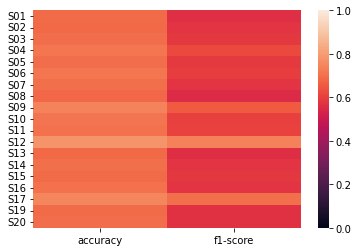

     class0 f1-score  class1 f1-score
S01         0.816176         0.000000
S02         0.810036         0.070175
S03         0.817568         0.035714
S04         0.826923         0.129032
S05         0.817204         0.037736
S06         0.833333         0.000000
S07         0.819672         0.035088
S08         0.810289         0.000000
S09         0.844444         0.196721
S10         0.824281         0.126984
S11         0.821429         0.074074
S12         0.861210         0.450704
S13         0.814570         0.000000
S14         0.819672         0.035088
S15         0.813115         0.065574
S16         0.823151         0.000000
S17         0.842105         0.363636
S19         0.815534         0.033898
S20         0.819672         0.000000


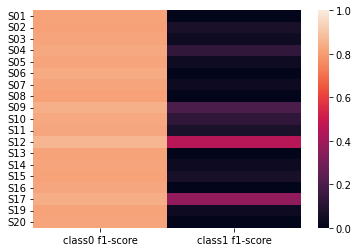

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [7]:
start=-0.5
step=1.5/(188-1)
timestep_labels=[]
for i in range(input_dim[1]):
    timestep_labels.append(round(start+step*i,3))
    
# timestep_labels

In [8]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-DF_TS-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

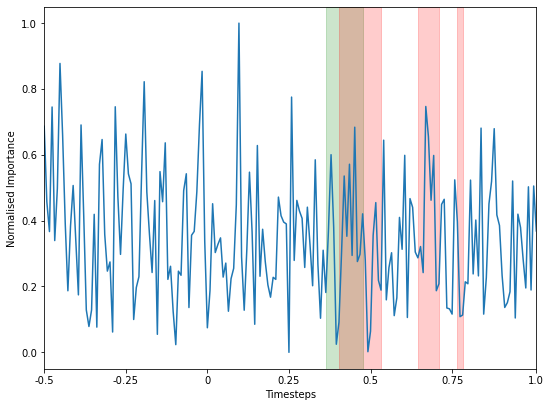

In [9]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(8,6))


scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.reshape(-1,1))
df= pd.DataFrame(scaled_avg_w)

plt.plot(df)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()